In [1]:
import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号



from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(1) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（激活函数为softmax）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #输出层的激活函数为tanh
        layer_list.append(('activation_%d' % (self.depth - 1), torch.nn.Softmax(dim=1)))  

        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict) #layers，长度为2*depth，包含了所有的线性变换和激活函数，奇数索引为线性变换(权重矩阵)，偶数索引为激活函数
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # # 新增方法，获取最后一个隐藏层的输出
    # def hidden_output(self, x):
    #     # 遍历每一层，直到最后一个隐藏层
    #     for i in range(self.depth - 1):
    #         # 获取当前层的线性变换
    #         x = self.layers[i*2](x)
    #         # 获取当前层的激活函数
    #         x = self.layers[i*2 + 1](x)
    #     # 返回最后一个隐藏层的输出
    #     return x

    # 新增方法，循环传递输入
    def hidden_forward(self, x, num_cycles):
        # 将输入传递到最后一个隐藏层，x为最后一个隐藏层的输出
        for i in range(self.depth - 1):
            x = self.layers[i*2](x)
            x = self.layers[i*2 + 1](x)
        
        # 将最后一个隐藏层的输出作为输入传递到第一个隐藏层中，重复num_cycles次
        for _ in range(num_cycles):
            for i in range(1, self.depth - 1): #最开始的x为最后一个隐藏层的输出，然后从第一个隐藏层开始传递
                x = self.layers[i*2](x)
                x = self.layers[i*2 + 1](x)
        hidden_output = x
        
        return hidden_output

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        mu_x, sigma_x = X_f.mean(0), X_f.std(0) #计算X_u的均值和标准差
        X_u = (X_u - mu_x) / sigma_x #对X_u进行标准化
        X_f = (X_f - mu_x) / sigma_x #对X_f进行标准化

        self.mu_x = torch.tensor(mu_x).float().to(device) #创建一个pytorch张量（数据来源于mu_x），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.sigma_x = torch.tensor(sigma_x).float().to(device) #创建一个pytorch张量（数据来源于sigma_x），并将其转换为浮点类型，最后将张量移动到指定的设备上

        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #初边界点数据
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #配位点数据
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        # #测试点数据
        # self.X_star = torch.tensor(X_star).float().to(device)
        # #测试点真实数据
        # self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), eps = 1e-30) 


        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x):  
        u = self.dnn(x)  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x) #调用上面的net_u函数，计算神经网络的输出u
        u1 = u[:,0:1];u2 = u[:,1:2];u3 = u[:,2:3]; #将u的第一列、第二列、第三列分别赋值给u1、u2、u3
        u4 = u[:,3:4];u5 = u[:,4:5];u6 = u[:,5:6]; #将u的第四列、第五列、第六列分别赋值给u4、u5、u6
        u7 = u[:,6:7];u8 = u[:,7:8];u9 = u[:,8:9]; #将u的第七列、第八列、第九列分别赋值给u7、u8、u9
        u10 = u[:,9:10];u11 = u[:,10:11];u12 = u[:,11:12] #将u的第十列、第十一列、第十二列分别赋值给u10、u11、u12
        

        u_x_1 = torch.autograd.grad(
            u1, x, #输入的张量，要计算u1关于x的导数
            grad_outputs=torch.ones_like(u1), #生成一个与u1形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u1的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_2 = torch.autograd.grad(
            u2, x, #输入的张量，要计算u2关于x的导数
            grad_outputs=torch.ones_like(u2), #生成一个与u2形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u2的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_3 = torch.autograd.grad(
            u3, x, #输入的张量，要计算u3关于x的导数
            grad_outputs=torch.ones_like(u3), #生成一个与u3形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u3的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_4 = torch.autograd.grad(
            u4, x,
            grad_outputs=torch.ones_like(u4),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_5 = torch.autograd.grad(
            u5, x,
            grad_outputs=torch.ones_like(u5),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_6 = torch.autograd.grad(
            u6, x,
            grad_outputs=torch.ones_like(u6),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_7 = torch.autograd.grad(
            u7, x,
            grad_outputs=torch.ones_like(u7),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_8 = torch.autograd.grad(
            u8, x,
            grad_outputs=torch.ones_like(u8),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_9 = torch.autograd.grad(
            u9, x,
            grad_outputs=torch.ones_like(u9),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_10 = torch.autograd.grad(
            u10, x,
            grad_outputs=torch.ones_like(u10),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_11 = torch.autograd.grad(
            u11, x,
            grad_outputs=torch.ones_like(u11),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_12 = torch.autograd.grad(
            u12, x,
            grad_outputs=torch.ones_like(u12),
            retain_graph=True,
            create_graph=True
        )[0]


        #归一化
        u_x_1 = u_x_1 / self.sigma_x;u_x_2 = u_x_2 / self.sigma_x;u_x_3 = u_x_3 / self.sigma_x
        u_x_4 = u_x_4 / self.sigma_x;u_x_5 = u_x_5 / self.sigma_x;u_x_6 = u_x_6 / self.sigma_x
        u_x_7 = u_x_7 / self.sigma_x;u_x_8 = u_x_8 / self.sigma_x;u_x_9 = u_x_9 / self.sigma_x
        u_x_10 = u_x_10 / self.sigma_x;u_x_11 = u_x_11 / self.sigma_x;u_x_12 = u_x_12 / self.sigma_x

        #指定状态转移概率
        #对于元素1
        Lambda2_1_1=7; Mu1_2_1=100;
        #对于元素2
        Lambda2_1_2=10; Mu1_2_2=80;
        #对于元素3
        Lambda3_2_3=10; Lambda3_1_3=0; Lambda2_1_3=7;
        Mu1_3_3=0; Mu1_2_3=120; Mu2_3_3=110
        #-----------------------------------------------
        #计算ODE项
        ode_1 = -(Lambda2_1_1+Lambda2_1_2+Lambda3_2_3)*u1+Mu1_2_1*u2+Mu1_2_2*u3+Mu2_3_3*u4;
        ode_2 = Lambda2_1_1*u1-(Mu1_2_1+Lambda2_1_2+Lambda3_2_3)*u2+Mu1_2_2*u5+Mu2_3_3*u6;
        ode_3 = Lambda2_1_2*u1-(Mu1_2_2+Lambda2_1_1+Lambda3_2_3)*u3+Mu1_2_1*u5+Mu2_3_3*u7;
        ode_4 = Lambda3_2_3*u1-(Mu2_3_3+Lambda2_1_1+Lambda2_1_2+Lambda2_1_3)*u4+Mu1_2_1*u6+Mu1_2_2*u7+Mu1_2_3*u8;
        ode_5 = Lambda2_1_2*u2+Lambda2_1_1*u3-(Mu1_2_2+Mu1_2_1+Lambda3_2_3)*u5+Mu2_3_3*u9;
        ode_6 = Lambda3_2_3*u2+Lambda2_1_1*u4-(Mu2_3_3+Mu1_2_1+Lambda2_1_2+Lambda2_1_3)*u6+Mu1_2_2*u9+Mu1_2_3*u10;
        ode_7 = Lambda3_2_3*u3+Lambda2_1_2*u4-(Mu2_3_3+Mu1_2_2+Lambda2_1_1+Lambda2_1_3)*u7+Mu1_2_1*u9+Mu1_2_3*u11;
        ode_8 = Lambda2_1_3*u4-(Mu1_2_3+Lambda2_1_1+Lambda2_1_2)*u8+Mu1_2_1*u10+Mu1_2_2*u11;
        ode_9 = Lambda3_2_3*u5+Lambda2_1_2*u6+Lambda2_1_1*u7-(Mu2_3_3+Mu1_2_2+Mu1_2_1+Lambda2_1_3)*u9+Mu1_2_3*u12;
        ode_10 = Lambda2_1_3*u6+Lambda2_1_1*u8-(Mu1_2_3+Mu1_2_1+Lambda2_1_2)*u10+Mu1_2_2*u12;
        ode_11 = Lambda2_1_3*u7+Lambda2_1_2*u8-(Mu1_2_3+Mu1_2_2+Lambda2_1_1)*u11+Mu1_2_1*u12;
        ode_12 = Lambda2_1_3*u9+Lambda2_1_2*u10+Lambda2_1_1*u11-(Mu1_2_3+Mu1_2_2+Mu1_2_1)*u12

        
        #计算残差
        residual_1 = u_x_1-ode_1; residual_2 = u_x_2-ode_2; residual_3 = u_x_3-ode_3
        residual_4 = u_x_4-ode_4; residual_5 = u_x_5-ode_5; residual_6 = u_x_6-ode_6;
        residual_7 = u_x_7-ode_7; residual_8 = u_x_8-ode_8; residual_9 = u_x_9-ode_9;
        residual_10 = u_x_10-ode_10; residual_11 = u_x_11-ode_11; residual_12 = u_x_12-ode_12

        #计算损失函数
        loss_1 = torch.mean(residual_1 ** 2); loss_2 = torch.mean(residual_2 ** 2); loss_3 = torch.mean(residual_3 ** 2);
        loss_4 = torch.mean(residual_4 ** 2); loss_5 = torch.mean(residual_5 ** 2); loss_6 = torch.mean(residual_6 ** 2);
        loss_7 = torch.mean(residual_7 ** 2); loss_8 = torch.mean(residual_8 ** 2); loss_9 = torch.mean(residual_9 ** 2);
        loss_10 = torch.mean(residual_10 ** 2); loss_11 = torch.mean(residual_11 ** 2); loss_12 = torch.mean(residual_12 ** 2)


        loss_f = loss_1 + loss_2 + loss_3 + loss_4 + loss_5 + loss_6 + loss_7 + loss_8 + loss_9 + loss_10 + loss_11 + loss_12
        return loss_f, residual_1+residual_2+residual_3+residual_4+residual_5+residual_6+residual_7+residual_8+residual_9+residual_10+residual_11+residual_12
    
      
    
    def train(self, nIter):


        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.X_u) #调用之前定义的函数，传入初值得到神经网络的输出u

            loss_u = torch.mean((self.u - u_pred) ** 2) #计算初值的损失函数
            loss_f, _ = self.net_f(self.X_f) #计算残差的损失函数
            

            loss = 100*loss_u + loss_f
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # # record the test error
            # self.dnn.eval() #将神经网络切换为评估模式
            # with torch.no_grad():
            #     u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u


            # error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            # self.test_error.append(error_test)

            # # 计算 MAE和MSE
            # mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            # mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # # 记录 MAE 和 MSE
            # self.test_error_mae.append(mae)
            # self.test_error_mse.append(mse)


  

    def predict(self, X):
        x = torch.tensor(X, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x) #调用之前定义的函数得到神经网络的输出u,以及f
        _, f = self.net_f(x)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x, num_cycles):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval()
        hidden_output = self.dnn.hidden_forward(x, num_cycles)
        hidden_output = hidden_output.detach().cpu().numpy()
        return hidden_output

In [6]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [7]:
def get_system_performance(df):
    
    df['system_3.5'] = df['state_1']
    df['system_2.0'] = df['state_2']
    df['system_1.8'] = df['state_4'] + df['state_6']
    df['system_1.5'] = df['state_3'] + df['state_7']
    df['system_0'] = df['state_5'] + df['state_8'] + df['state_9'] + df['state_10'] + df['state_11'] + df['state_12']
    
    return df

state_column_names = ['state_1', 'state_2', 'state_3', 'state_4', 'state_5', 'state_6', 'state_7',
                      'state_8', 'state_9', 'state_10', 'state_11', 'state_12']

In [8]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]
#设置噪声水平为0
noise = 0.0     

eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')

N_u = 1
N_f = 200

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 12]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([0.2])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0,0,0,0,0,0,0,0,0,0]])          # 初始真实状态


error_y = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值
chaoss = [] #创建一个空列表，用于存储混沌值
residuals = [] #创建一个空列表，用于存储残差值

i = 0


# # 创建文件夹
# model_dir = 'Adam+LBFGS+LHS(5000)'
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

for seed in seeds:
    set_seed(seed) #设置随机数种子

    # X_f = lb + (ub - lb) * lhs(1, N_f) #生成N_f个配位点，均匀分布在[0,1]之间
    X_f = np.linspace(lb, ub, N_f)     # 配位点位置
    nIter = 40000

    #创建PINN模型并输入各种参数     
    # model = PhysicsInformedNN(X_u, u, X_f, layers, lb, ub, X_star, u_star)
    model = PhysicsInformedNN(X_u, u, X_f, layers, lb, ub)
    
    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter)
    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))


    # up = 80000
    n_star = 500+1
    x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 
    y_pred, _ = model.predict(x_star)
    y_pred_df = pd.DataFrame(y_pred, columns = state_column_names)
    y_pred = get_system_performance(y_pred_df)
    # y_diff_no_pcgrad_eigenvectors = eigenvector_solution_df - y_pred_df
    y_star = eigenvector_solution_df


    #计算误差（基于2范数）        
    error_y.append(np.linalg.norm(y_star.iloc[:,-5:]-y_pred.iloc[:, -5:],2)/np.linalg.norm(y_star.iloc[:, -5:],2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(y_star.iloc[:, -5:] - y_pred.iloc[:, -5:]))
    mse = np.mean((y_star.iloc[:, -5:] - y_pred.iloc[:, -5:]) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)


    #计算混沌度
    y_chaos = model.hidden_predict(x_star, 100)
    # print(y_chaos)
    x_sss = x_star + np.random.normal(0, 0.001)
    y_chaos_sss = model.hidden_predict(x_sss, 100)
    chaos = np.linalg.norm(y_chaos - y_chaos_sss,axis=1).sum()
    chaoss.append(chaos)

    #计算残差

    _, residual = model.predict(x_star)
    residual = residual.flatten()
    residual = np.abs(residual)
    residual = residual.sum()
    residuals.append(residual)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error y : %e' % (np.linalg.norm(y_star.iloc[:,-5:]-y_pred.iloc[:,-5:],2)/np.linalg.norm(y_star.iloc[:,-5:],2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    print('Chaos: %e' % chaos) #打印混沌度
    print('Residual: %e' % residual) #打印残差
    # # 保存模型到文件夹
    # model_path = os.path.join(model_dir, f'model_{i}_seed_{seed}.pkl')
    # with open(model_path, 'wb') as f:
    #     pickle.dump(model, f)






Adam:   0%|          | 0/40000 [00:00<?, ?it/s]


Adam:   0%|          | 4/40000 [00:00<17:14, 38.68it/s]


Adam:   0%|          | 20/40000 [00:00<06:13, 107.04it/s]


Adam:   0%|          | 38/40000 [00:00<04:50, 137.55it/s]


Adam:   0%|          | 58/40000 [00:00<04:08, 160.52it/s]


Adam:   0%|          | 76/40000 [00:00<04:00, 165.86it/s]


Adam:   0%|          | 95/40000 [00:00<03:57, 168.37it/s]


Adam:   0%|          | 116/40000 [00:00<03:42, 179.62it/s]


Adam:   0%|          | 134/40000 [00:00<03:50, 173.08it/s]


Adam:   0%|          | 152/40000 [00:00<03:48, 174.47it/s]


Adam:   0%|          | 170/40000 [00:01<03:58, 166.72it/s]


Adam:   0%|          | 188/40000 [00:01<03:55, 169.34it/s]


Adam:   1%|          | 210/40000 [00:01<03:36, 183.98it/s]


Adam:   1%|          | 233/40000 [00:01<03:24, 194.56it/s]


Adam:   1%|          | 253/40000 [00:01<03:23, 194.88it/s]


Adam:   1%|          | 274/40000 [00:01<03:20, 198.20it/s]


Adam:   1%|          | 294/40000 [00:01<03:39, 180.78it/s]


Adam:   1%|          | 313/40000 [00:01<03:38, 181.87it/s]


Adam:   1%|          | 332/40000 [00:01<03:49, 173.14it/s]


Adam:   1%|          | 350/40000 [00:02<04:00, 164.64it/s]


Adam:   1%|          | 367/40000 [00:02<04:06, 160.80it/s]


Adam:   1%|          | 384/40000 [00:02<04:07, 159.94it/s]


Adam:   1%|          | 402/40000 [00:02<04:00, 164.47it/s]


Adam:   1%|          | 425/40000 [00:02<03:37, 182.02it/s]


Adam:   1%|          | 444/40000 [00:02<03:35, 183.81it/s]


Adam:   1%|          | 463/40000 [00:02<03:42, 177.80it/s]


Adam:   1%|          | 481/40000 [00:02<04:04, 161.44it/s]


Adam:   1%|          | 499/40000 [00:02<03:57, 166.03it/s]


Adam:   1%|▏         | 516/40000 [00:03<04:09, 158.05it/s]


Adam:   1%|▏         | 533/40000 [00:03<04:07, 159.66it/s]


Adam:   1%|▏         | 553/40000 [00:03<03:50, 170.84it/s]


Adam:   1%|▏         | 572/40000 [00:03<03:45, 174.48it/s]


Adam:   1%|▏         | 590/40000 [00:03<03:48, 172.62it/s]


Adam:   2%|▏         | 608/40000 [00:03<04:03, 161.92it/s]


Adam:   2%|▏         | 629/40000 [00:03<03:46, 174.18it/s]


Adam:   2%|▏         | 650/40000 [00:03<03:36, 181.85it/s]


Adam:   2%|▏         | 669/40000 [00:03<03:39, 179.25it/s]


Adam:   2%|▏         | 688/40000 [00:04<03:41, 177.87it/s]


Adam:   2%|▏         | 710/40000 [00:04<03:29, 187.33it/s]


Adam:   2%|▏         | 729/40000 [00:04<03:31, 185.48it/s]


Adam:   2%|▏         | 748/40000 [00:04<03:55, 166.42it/s]


Adam:   2%|▏         | 767/40000 [00:04<03:51, 169.69it/s]


Adam:   2%|▏         | 787/40000 [00:04<03:41, 177.02it/s]


Adam:   2%|▏         | 807/40000 [00:04<03:33, 183.34it/s]


Adam:   2%|▏         | 826/40000 [00:04<03:48, 171.50it/s]


Adam:   2%|▏         | 847/40000 [00:04<03:35, 181.55it/s]


Adam:   2%|▏         | 866/40000 [00:05<03:42, 175.73it/s]


Adam:   2%|▏         | 884/40000 [00:05<04:02, 161.43it/s]


Adam:   2%|▏         | 908/40000 [00:05<03:36, 180.71it/s]


Adam:   2%|▏         | 931/40000 [00:05<03:23, 192.28it/s]


Adam:   2%|▏         | 953/40000 [00:05<03:16, 198.39it/s]


Adam:   2%|▏         | 975/40000 [00:05<03:12, 202.63it/s]


Adam:   2%|▏         | 997/40000 [00:05<03:09, 205.75it/s]


Adam:   3%|▎         | 1020/40000 [00:05<03:03, 212.50it/s]


Adam:   3%|▎         | 1042/40000 [00:05<03:02, 213.56it/s]


Adam:   3%|▎         | 1064/40000 [00:05<03:03, 212.48it/s]


Adam:   3%|▎         | 1086/40000 [00:06<03:17, 197.28it/s]


Adam:   3%|▎         | 1106/40000 [00:06<03:31, 184.08it/s]


Adam:   3%|▎         | 1125/40000 [00:06<03:40, 176.00it/s]


Adam:   3%|▎         | 1145/40000 [00:06<03:33, 182.32it/s]


Adam:   3%|▎         | 1165/40000 [00:06<03:29, 185.50it/s]


Adam:   3%|▎         | 1185/40000 [00:06<03:28, 186.54it/s]


Adam:   3%|▎         | 1204/40000 [00:06<03:44, 172.84it/s]


Adam:   3%|▎         | 1222/40000 [00:06<03:43, 173.32it/s]


Adam:   3%|▎         | 1243/40000 [00:07<03:31, 183.38it/s]


Adam:   3%|▎         | 1262/40000 [00:07<03:46, 171.28it/s]


Adam:   3%|▎         | 1280/40000 [00:07<03:57, 162.91it/s]


Adam:   3%|▎         | 1298/40000 [00:07<03:53, 165.62it/s]


Adam:   3%|▎         | 1315/40000 [00:07<03:58, 162.13it/s]


Adam:   3%|▎         | 1335/40000 [00:07<03:47, 170.24it/s]


Adam:   3%|▎         | 1353/40000 [00:07<03:43, 172.71it/s]


Adam:   3%|▎         | 1372/40000 [00:07<03:40, 175.55it/s]


Adam:   3%|▎         | 1390/40000 [00:07<03:56, 163.45it/s]


Adam:   4%|▎         | 1412/40000 [00:08<03:37, 177.53it/s]


Adam:   4%|▎         | 1430/40000 [00:08<03:47, 169.19it/s]


Adam:   4%|▎         | 1448/40000 [00:08<03:57, 162.67it/s]


Adam:   4%|▎         | 1467/40000 [00:08<03:47, 169.12it/s]


Adam:   4%|▎         | 1487/40000 [00:08<03:38, 176.53it/s]


Adam:   4%|▍         | 1505/40000 [00:08<03:42, 172.94it/s]


Adam:   4%|▍         | 1523/40000 [00:08<03:47, 169.38it/s]


Adam:   4%|▍         | 1541/40000 [00:08<03:54, 164.10it/s]


Adam:   4%|▍         | 1561/40000 [00:08<03:43, 171.97it/s]


Adam:   4%|▍         | 1579/40000 [00:09<03:45, 170.02it/s]


Adam:   4%|▍         | 1602/40000 [00:09<03:26, 186.01it/s]


Adam:   4%|▍         | 1624/40000 [00:09<03:17, 194.44it/s]


Adam:   4%|▍         | 1644/40000 [00:09<03:18, 192.82it/s]


Adam:   4%|▍         | 1667/40000 [00:09<03:09, 202.73it/s]


Adam:   4%|▍         | 1688/40000 [00:09<03:17, 193.70it/s]


Adam:   4%|▍         | 1708/40000 [00:09<03:31, 181.39it/s]


Adam:   4%|▍         | 1727/40000 [00:09<03:30, 181.93it/s]


Adam:   4%|▍         | 1746/40000 [00:09<03:34, 178.62it/s]


Adam:   4%|▍         | 1766/40000 [00:09<03:28, 183.78it/s]


Adam:   4%|▍         | 1786/40000 [00:10<03:23, 187.65it/s]


Adam:   5%|▍         | 1805/40000 [00:10<03:39, 173.69it/s]


Adam:   5%|▍         | 1825/40000 [00:10<03:33, 179.13it/s]


Adam:   5%|▍         | 1845/40000 [00:10<03:30, 181.04it/s]


Adam:   5%|▍         | 1864/40000 [00:10<03:30, 181.46it/s]


Adam:   5%|▍         | 1883/40000 [00:10<03:37, 175.24it/s]


Adam:   5%|▍         | 1906/40000 [00:10<03:20, 190.22it/s]


Adam:   5%|▍         | 1927/40000 [00:10<03:17, 192.71it/s]


Adam:   5%|▍         | 1947/40000 [00:10<03:26, 184.68it/s]


Adam:   5%|▍         | 1966/40000 [00:11<03:39, 173.58it/s]


Adam:   5%|▍         | 1987/40000 [00:11<03:28, 182.46it/s]


Adam:   5%|▌         | 2011/40000 [00:11<03:13, 196.67it/s]


Adam:   5%|▌         | 2033/40000 [00:11<03:09, 200.77it/s]


Adam:   5%|▌         | 2055/40000 [00:11<03:04, 205.59it/s]


Adam:   5%|▌         | 2076/40000 [00:11<03:12, 197.01it/s]


Adam:   5%|▌         | 2096/40000 [00:11<03:26, 183.70it/s]


Adam:   5%|▌         | 2115/40000 [00:11<03:49, 164.94it/s]


Adam:   5%|▌         | 2132/40000 [00:12<04:14, 148.59it/s]


Adam:   5%|▌         | 2148/40000 [00:12<04:29, 140.64it/s]


Adam:   5%|▌         | 2170/40000 [00:12<03:58, 158.89it/s]


Adam:   5%|▌         | 2187/40000 [00:12<04:01, 156.30it/s]


Adam:   6%|▌         | 2204/40000 [00:12<04:05, 154.08it/s]


Adam:   6%|▌         | 2220/40000 [00:12<04:05, 153.71it/s]


Adam:   6%|▌         | 2236/40000 [00:12<04:24, 142.92it/s]


Adam:   6%|▌         | 2254/40000 [00:12<04:08, 151.69it/s]


Adam:   6%|▌         | 2273/40000 [00:12<03:57, 158.68it/s]


Adam:   6%|▌         | 2290/40000 [00:13<04:35, 136.78it/s]


Adam:   6%|▌         | 2307/40000 [00:13<04:20, 144.74it/s]


Adam:   6%|▌         | 2323/40000 [00:13<04:22, 143.47it/s]


Adam:   6%|▌         | 2338/40000 [00:13<04:52, 128.96it/s]


Adam:   6%|▌         | 2355/40000 [00:13<04:32, 138.24it/s]


Adam:   6%|▌         | 2370/40000 [00:13<04:46, 131.28it/s]


Adam:   6%|▌         | 2385/40000 [00:13<04:41, 133.84it/s]


Adam:   6%|▌         | 2403/40000 [00:13<04:20, 144.20it/s]


Adam:   6%|▌         | 2418/40000 [00:14<04:33, 137.41it/s]


Adam:   6%|▌         | 2440/40000 [00:14<03:55, 159.35it/s]


Adam:   6%|▌         | 2457/40000 [00:14<04:39, 134.13it/s]


Adam:   6%|▌         | 2473/40000 [00:14<04:29, 139.39it/s]


Adam:   6%|▌         | 2492/40000 [00:14<04:06, 152.28it/s]


Adam:   6%|▋         | 2508/40000 [00:14<04:11, 149.22it/s]


Adam:   6%|▋         | 2528/40000 [00:14<03:51, 161.73it/s]


Adam:   6%|▋         | 2545/40000 [00:14<04:07, 151.62it/s]


Adam:   6%|▋         | 2561/40000 [00:15<04:32, 137.38it/s]


Adam:   6%|▋         | 2576/40000 [00:15<04:41, 133.16it/s]


Adam:   6%|▋         | 2596/40000 [00:15<04:10, 149.16it/s]


Adam:   7%|▋         | 2612/40000 [00:15<04:28, 139.10it/s]


Adam:   7%|▋         | 2629/40000 [00:15<04:18, 144.66it/s]


Adam:   7%|▋         | 2644/40000 [00:15<04:22, 142.37it/s]


Adam:   7%|▋         | 2661/40000 [00:15<04:15, 146.01it/s]


Adam:   7%|▋         | 2680/40000 [00:15<03:58, 156.80it/s]


Adam:   7%|▋         | 2699/40000 [00:15<03:48, 163.50it/s]


Adam:   7%|▋         | 2716/40000 [00:16<04:20, 142.91it/s]


Adam:   7%|▋         | 2731/40000 [00:16<04:34, 135.86it/s]


Adam:   7%|▋         | 2745/40000 [00:16<04:36, 134.95it/s]


Adam:   7%|▋         | 2759/40000 [00:16<04:41, 132.13it/s]


Adam:   7%|▋         | 2773/40000 [00:16<04:57, 125.13it/s]


Adam:   7%|▋         | 2795/40000 [00:16<04:09, 148.89it/s]


Adam:   7%|▋         | 2814/40000 [00:16<03:56, 157.13it/s]


Adam:   7%|▋         | 2831/40000 [00:16<04:31, 137.13it/s]


Adam:   7%|▋         | 2846/40000 [00:17<04:48, 128.62it/s]


Adam:   7%|▋         | 2860/40000 [00:17<04:45, 130.25it/s]


Adam:   7%|▋         | 2875/40000 [00:17<04:35, 134.63it/s]


Adam:   7%|▋         | 2894/40000 [00:17<04:11, 147.46it/s]


Adam:   7%|▋         | 2910/40000 [00:17<04:15, 144.95it/s]


Adam:   7%|▋         | 2925/40000 [00:17<04:20, 142.20it/s]


Adam:   7%|▋         | 2940/40000 [00:17<04:25, 139.84it/s]


Adam:   7%|▋         | 2957/40000 [00:17<04:11, 147.19it/s]


Adam:   7%|▋         | 2972/40000 [00:17<04:26, 138.74it/s]


Adam:   7%|▋         | 2992/40000 [00:18<03:59, 154.54it/s]


Adam:   8%|▊         | 3009/40000 [00:18<03:53, 158.60it/s]


Adam:   8%|▊         | 3031/40000 [00:18<03:32, 173.80it/s]


Adam:   8%|▊         | 3051/40000 [00:18<03:25, 179.49it/s]


Adam:   8%|▊         | 3074/40000 [00:18<03:12, 192.12it/s]


Adam:   8%|▊         | 3094/40000 [00:18<03:11, 193.12it/s]


Adam:   8%|▊         | 3115/40000 [00:18<03:06, 197.44it/s]


Adam:   8%|▊         | 3137/40000 [00:18<03:01, 202.71it/s]


Adam:   8%|▊         | 3160/40000 [00:18<02:57, 207.66it/s]


Adam:   8%|▊         | 3182/40000 [00:18<02:54, 210.81it/s]


Adam:   8%|▊         | 3204/40000 [00:19<03:15, 188.68it/s]


Adam:   8%|▊         | 3226/40000 [00:19<03:06, 196.81it/s]


Adam:   8%|▊         | 3247/40000 [00:19<03:19, 184.06it/s]


Adam:   8%|▊         | 3266/40000 [00:19<03:34, 171.20it/s]


Adam:   8%|▊         | 3284/40000 [00:19<03:52, 157.65it/s]


Adam:   8%|▊         | 3305/40000 [00:19<03:36, 169.40it/s]


Adam:   8%|▊         | 3323/40000 [00:19<03:33, 172.06it/s]


Adam:   8%|▊         | 3341/40000 [00:19<03:30, 174.17it/s]


Adam:   8%|▊         | 3359/40000 [00:20<03:43, 164.25it/s]


Adam:   8%|▊         | 3376/40000 [00:20<04:06, 148.85it/s]


Adam:   8%|▊         | 3398/40000 [00:20<03:40, 166.18it/s]


Adam:   9%|▊         | 3421/40000 [00:20<03:20, 182.10it/s]


Adam:   9%|▊         | 3440/40000 [00:20<03:21, 181.41it/s]


Adam:   9%|▊         | 3459/40000 [00:20<03:24, 178.66it/s]


Adam:   9%|▊         | 3478/40000 [00:20<04:08, 146.86it/s]


Adam:   9%|▊         | 3494/40000 [00:20<04:14, 143.58it/s]


Adam:   9%|▉         | 3513/40000 [00:20<03:57, 153.38it/s]


Adam:   9%|▉         | 3530/40000 [00:21<03:55, 154.84it/s]


Adam:   9%|▉         | 3548/40000 [00:21<03:48, 159.77it/s]


Adam:   9%|▉         | 3565/40000 [00:21<03:45, 161.44it/s]


Adam:   9%|▉         | 3582/40000 [00:21<03:45, 161.85it/s]


Adam:   9%|▉         | 3599/40000 [00:21<04:12, 144.24it/s]


Adam:   9%|▉         | 3622/40000 [00:21<03:40, 165.06it/s]


Adam:   9%|▉         | 3640/40000 [00:21<03:37, 166.92it/s]


Adam:   9%|▉         | 3658/40000 [00:21<03:35, 168.81it/s]


Adam:   9%|▉         | 3676/40000 [00:21<03:33, 169.89it/s]


Adam:   9%|▉         | 3694/40000 [00:22<03:58, 152.37it/s]


Adam:   9%|▉         | 3712/40000 [00:22<03:48, 158.72it/s]


Adam:   9%|▉         | 3731/40000 [00:22<03:37, 166.43it/s]


Adam:   9%|▉         | 3748/40000 [00:22<03:55, 153.68it/s]


Adam:   9%|▉         | 3765/40000 [00:22<03:49, 157.73it/s]


Adam:   9%|▉         | 3784/40000 [00:22<03:39, 165.06it/s]


Adam:  10%|▉         | 3804/40000 [00:22<03:27, 174.59it/s]


Adam:  10%|▉         | 3822/40000 [00:22<04:01, 149.90it/s]


Adam:  10%|▉         | 3843/40000 [00:23<03:41, 163.51it/s]


Adam:  10%|▉         | 3861/40000 [00:23<03:40, 163.87it/s]


Adam:  10%|▉         | 3878/40000 [00:23<03:39, 164.53it/s]


Adam:  10%|▉         | 3895/40000 [00:23<04:02, 149.07it/s]


Adam:  10%|▉         | 3913/40000 [00:23<03:51, 156.18it/s]


Adam:  10%|▉         | 3930/40000 [00:23<04:16, 140.61it/s]


Adam:  10%|▉         | 3945/40000 [00:23<04:12, 142.65it/s]


Adam:  10%|▉         | 3960/40000 [00:23<04:13, 141.99it/s]


Adam:  10%|▉         | 3975/40000 [00:23<04:20, 138.20it/s]


Adam:  10%|▉         | 3990/40000 [00:24<04:15, 140.80it/s]


Adam:  10%|█         | 4008/40000 [00:24<03:58, 150.94it/s]


Adam:  10%|█         | 4027/40000 [00:24<03:45, 159.47it/s]


Adam:  10%|█         | 4044/40000 [00:24<03:58, 150.94it/s]


Adam:  10%|█         | 4060/40000 [00:24<04:10, 143.52it/s]


Adam:  10%|█         | 4077/40000 [00:24<03:58, 150.61it/s]


Adam:  10%|█         | 4093/40000 [00:24<04:03, 147.48it/s]


Adam:  10%|█         | 4108/40000 [00:24<04:19, 138.39it/s]


Adam:  10%|█         | 4123/40000 [00:24<04:25, 135.05it/s]


Adam:  10%|█         | 4141/40000 [00:25<04:05, 146.34it/s]


Adam:  10%|█         | 4156/40000 [00:25<04:04, 146.36it/s]


Adam:  10%|█         | 4171/40000 [00:25<04:10, 143.00it/s]


Adam:  10%|█         | 4191/40000 [00:25<03:46, 158.14it/s]


Adam:  11%|█         | 4207/40000 [00:25<03:45, 158.44it/s]


Adam:  11%|█         | 4224/40000 [00:25<03:43, 159.82it/s]


Adam:  11%|█         | 4244/40000 [00:25<03:30, 170.01it/s]


Adam:  11%|█         | 4266/40000 [00:25<03:14, 183.90it/s]


Adam:  11%|█         | 4285/40000 [00:25<03:15, 182.95it/s]


Adam:  11%|█         | 4304/40000 [00:26<03:36, 164.69it/s]


Adam:  11%|█         | 4321/40000 [00:26<04:08, 143.71it/s]


Adam:  11%|█         | 4337/40000 [00:26<04:05, 145.07it/s]


Adam:  11%|█         | 4352/40000 [00:26<04:13, 140.44it/s]


Adam:  11%|█         | 4367/40000 [00:26<04:25, 134.33it/s]


Adam:  11%|█         | 4385/40000 [00:26<04:04, 145.50it/s]


Adam:  11%|█         | 4403/40000 [00:26<03:52, 152.84it/s]


Adam:  11%|█         | 4419/40000 [00:26<04:28, 132.74it/s]


Adam:  11%|█         | 4433/40000 [00:27<04:33, 129.92it/s]


Adam:  11%|█         | 4447/40000 [00:27<05:05, 116.48it/s]


Adam:  11%|█         | 4460/40000 [00:27<05:18, 111.55it/s]


Adam:  11%|█         | 4475/40000 [00:27<04:56, 119.93it/s]


Adam:  11%|█         | 4488/40000 [00:27<05:16, 112.03it/s]


Adam:  11%|█▏        | 4506/40000 [00:27<04:38, 127.60it/s]


Adam:  11%|█▏        | 4527/40000 [00:27<03:59, 148.10it/s]


Adam:  11%|█▏        | 4547/40000 [00:27<03:41, 160.34it/s]


Adam:  11%|█▏        | 4567/40000 [00:27<03:31, 167.48it/s]


Adam:  11%|█▏        | 4585/40000 [00:28<03:31, 167.22it/s]


Adam:  12%|█▏        | 4602/40000 [00:28<03:46, 156.21it/s]


Adam:  12%|█▏        | 4618/40000 [00:28<04:06, 143.61it/s]


Adam:  12%|█▏        | 4635/40000 [00:28<03:57, 149.01it/s]


Adam:  12%|█▏        | 4651/40000 [00:28<03:53, 151.68it/s]


Adam:  12%|█▏        | 4668/40000 [00:28<03:52, 151.84it/s]


Adam:  12%|█▏        | 4684/40000 [00:28<04:19, 136.12it/s]


Adam:  12%|█▏        | 4699/40000 [00:28<04:19, 136.25it/s]


Adam:  12%|█▏        | 4713/40000 [00:29<04:21, 134.73it/s]


Adam:  12%|█▏        | 4728/40000 [00:29<04:18, 136.57it/s]


Adam:  12%|█▏        | 4742/40000 [00:29<04:27, 132.01it/s]


Adam:  12%|█▏        | 4756/40000 [00:29<05:16, 111.36it/s]


Adam:  12%|█▏        | 4769/40000 [00:29<05:04, 115.81it/s]


Adam:  12%|█▏        | 4782/40000 [00:29<05:07, 114.40it/s]


Adam:  12%|█▏        | 4797/40000 [00:29<04:49, 121.78it/s]


Adam:  12%|█▏        | 4810/40000 [00:29<05:02, 116.20it/s]


Adam:  12%|█▏        | 4822/40000 [00:30<05:24, 108.43it/s]


Adam:  12%|█▏        | 4842/40000 [00:30<04:27, 131.46it/s]


Adam:  12%|█▏        | 4856/40000 [00:30<04:36, 126.88it/s]


Adam:  12%|█▏        | 4871/40000 [00:30<04:31, 129.41it/s]


Adam:  12%|█▏        | 4885/40000 [00:30<04:26, 131.67it/s]


Adam:  12%|█▏        | 4901/40000 [00:30<04:14, 138.08it/s]


Adam:  12%|█▏        | 4920/40000 [00:30<03:49, 152.53it/s]


Adam:  12%|█▏        | 4936/40000 [00:30<03:57, 147.52it/s]


Adam:  12%|█▏        | 4951/40000 [00:30<04:09, 140.27it/s]


Adam:  12%|█▏        | 4966/40000 [00:31<04:32, 128.70it/s]


Adam:  12%|█▏        | 4980/40000 [00:31<04:26, 131.30it/s]


Adam:  12%|█▏        | 4994/40000 [00:31<04:22, 133.39it/s]


Adam:  13%|█▎        | 5009/40000 [00:31<04:14, 137.25it/s]


Adam:  13%|█▎        | 5023/40000 [00:31<04:23, 132.86it/s]


Adam:  13%|█▎        | 5040/40000 [00:31<04:07, 140.99it/s]


Adam:  13%|█▎        | 5055/40000 [00:31<04:31, 128.74it/s]


Adam:  13%|█▎        | 5069/40000 [00:31<04:34, 127.06it/s]


Adam:  13%|█▎        | 5082/40000 [00:31<04:47, 121.63it/s]


Adam:  13%|█▎        | 5099/40000 [00:32<04:23, 132.34it/s]


Adam:  13%|█▎        | 5118/40000 [00:32<03:59, 145.52it/s]


Adam:  13%|█▎        | 5133/40000 [00:32<04:06, 141.18it/s]


Adam:  13%|█▎        | 5148/40000 [00:32<04:06, 141.67it/s]


Adam:  13%|█▎        | 5165/40000 [00:32<03:56, 147.14it/s]


Adam:  13%|█▎        | 5180/40000 [00:32<04:20, 133.83it/s]


Adam:  13%|█▎        | 5202/40000 [00:32<03:44, 155.10it/s]


Adam:  13%|█▎        | 5222/40000 [00:32<03:34, 161.79it/s]


Adam:  13%|█▎        | 5239/40000 [00:32<03:41, 156.75it/s]


Adam:  13%|█▎        | 5255/40000 [00:33<03:41, 157.14it/s]


Adam:  13%|█▎        | 5271/40000 [00:33<03:56, 146.89it/s]


Adam:  13%|█▎        | 5288/40000 [00:33<03:47, 152.70it/s]


Adam:  13%|█▎        | 5304/40000 [00:33<04:01, 143.47it/s]


Adam:  13%|█▎        | 5319/40000 [00:33<04:22, 132.20it/s]


Adam:  13%|█▎        | 5335/40000 [00:33<04:11, 137.67it/s]


Adam:  13%|█▎        | 5355/40000 [00:33<03:47, 152.32it/s]


Adam:  13%|█▎        | 5374/40000 [00:33<03:36, 159.94it/s]


Adam:  13%|█▎        | 5391/40000 [00:34<04:19, 133.56it/s]


Adam:  14%|█▎        | 5407/40000 [00:34<04:12, 137.02it/s]


Adam:  14%|█▎        | 5423/40000 [00:34<04:03, 142.25it/s]


Adam:  14%|█▎        | 5442/40000 [00:34<03:43, 154.42it/s]


Adam:  14%|█▎        | 5458/40000 [00:34<04:00, 143.87it/s]


Adam:  14%|█▎        | 5473/40000 [00:34<04:09, 138.29it/s]


Adam:  14%|█▎        | 5488/40000 [00:34<04:44, 121.32it/s]


Adam:  14%|█▍        | 5501/40000 [00:34<04:39, 123.38it/s]


Adam:  14%|█▍        | 5515/40000 [00:34<04:34, 125.65it/s]


Adam:  14%|█▍        | 5530/40000 [00:35<04:24, 130.46it/s]


Adam:  14%|█▍        | 5544/40000 [00:35<04:24, 130.13it/s]


Adam:  14%|█▍        | 5565/40000 [00:35<03:50, 149.66it/s]


Adam:  14%|█▍        | 5582/40000 [00:35<03:43, 154.22it/s]


Adam:  14%|█▍        | 5601/40000 [00:35<03:30, 163.25it/s]


Adam:  14%|█▍        | 5618/40000 [00:35<03:40, 156.14it/s]


Adam:  14%|█▍        | 5637/40000 [00:35<03:28, 164.74it/s]


Adam:  14%|█▍        | 5654/40000 [00:35<03:28, 164.42it/s]


Adam:  14%|█▍        | 5671/40000 [00:35<03:58, 143.64it/s]


Adam:  14%|█▍        | 5686/40000 [00:36<04:07, 138.91it/s]


Adam:  14%|█▍        | 5704/40000 [00:36<03:53, 147.13it/s]


Adam:  14%|█▍        | 5720/40000 [00:36<04:12, 135.62it/s]


Adam:  14%|█▍        | 5734/40000 [00:36<04:19, 132.10it/s]


Adam:  14%|█▍        | 5748/40000 [00:36<04:49, 118.27it/s]


Adam:  14%|█▍        | 5762/40000 [00:36<04:38, 122.77it/s]


Adam:  14%|█▍        | 5775/40000 [00:36<04:46, 119.44it/s]


Adam:  14%|█▍        | 5792/40000 [00:36<04:19, 131.79it/s]


Adam:  15%|█▍        | 5806/40000 [00:37<04:49, 118.27it/s]


Adam:  15%|█▍        | 5819/40000 [00:37<04:44, 119.99it/s]


Adam:  15%|█▍        | 5832/40000 [00:37<04:43, 120.65it/s]


Adam:  15%|█▍        | 5846/40000 [00:37<04:32, 125.51it/s]


Adam:  15%|█▍        | 5866/40000 [00:37<03:54, 145.47it/s]


Adam:  15%|█▍        | 5881/40000 [00:37<04:09, 136.82it/s]


Adam:  15%|█▍        | 5900/40000 [00:37<03:46, 150.56it/s]


Adam:  15%|█▍        | 5916/40000 [00:37<04:08, 137.31it/s]


Adam:  15%|█▍        | 5932/40000 [00:37<04:01, 140.87it/s]


Adam:  15%|█▍        | 5948/40000 [00:38<03:54, 145.29it/s]


Adam:  15%|█▍        | 5963/40000 [00:38<04:02, 140.48it/s]


Adam:  15%|█▍        | 5978/40000 [00:38<04:34, 124.09it/s]


Adam:  15%|█▍        | 5991/40000 [00:38<04:53, 115.75it/s]


Adam:  15%|█▌        | 6003/40000 [00:38<04:57, 114.42it/s]


Adam:  15%|█▌        | 6015/40000 [00:38<05:01, 112.67it/s]


Adam:  15%|█▌        | 6028/40000 [00:38<04:50, 116.80it/s]


Adam:  15%|█▌        | 6047/40000 [00:38<04:12, 134.71it/s]


Adam:  15%|█▌        | 6062/40000 [00:38<04:06, 137.48it/s]


Adam:  15%|█▌        | 6076/40000 [00:39<04:51, 116.54it/s]


Adam:  15%|█▌        | 6089/40000 [00:39<04:54, 115.02it/s]


Adam:  15%|█▌        | 6104/40000 [00:39<04:35, 123.05it/s]


Adam:  15%|█▌        | 6123/40000 [00:39<04:04, 138.73it/s]


Adam:  15%|█▌        | 6138/40000 [00:39<04:01, 140.40it/s]


Adam:  15%|█▌        | 6155/40000 [00:39<03:52, 145.74it/s]


Adam:  15%|█▌        | 6170/40000 [00:39<03:56, 143.34it/s]


Adam:  15%|█▌        | 6185/40000 [00:39<04:07, 136.35it/s]


Adam:  15%|█▌        | 6199/40000 [00:40<04:19, 130.17it/s]


Adam:  16%|█▌        | 6213/40000 [00:40<04:29, 125.16it/s]


Adam:  16%|█▌        | 6226/40000 [00:40<04:47, 117.39it/s]


Adam:  16%|█▌        | 6244/40000 [00:40<04:20, 129.63it/s]


Adam:  16%|█▌        | 6258/40000 [00:40<04:25, 127.31it/s]


Adam:  16%|█▌        | 6273/40000 [00:40<04:13, 133.28it/s]


Adam:  16%|█▌        | 6291/40000 [00:40<03:51, 145.79it/s]


Adam:  16%|█▌        | 6306/40000 [00:40<03:56, 142.31it/s]


Adam:  16%|█▌        | 6321/40000 [00:40<04:01, 139.55it/s]


Adam:  16%|█▌        | 6336/40000 [00:41<04:04, 137.76it/s]


Adam:  16%|█▌        | 6350/40000 [00:41<04:07, 136.09it/s]


Adam:  16%|█▌        | 6364/40000 [00:41<04:27, 125.94it/s]


Adam:  16%|█▌        | 6377/40000 [00:41<04:28, 125.45it/s]


Adam:  16%|█▌        | 6390/40000 [00:41<04:31, 123.75it/s]


Adam:  16%|█▌        | 6403/40000 [00:41<04:34, 122.37it/s]


Adam:  16%|█▌        | 6417/40000 [00:41<04:28, 125.21it/s]


Adam:  16%|█▌        | 6430/40000 [00:41<04:41, 119.17it/s]


Adam:  16%|█▌        | 6444/40000 [00:41<04:31, 123.75it/s]


Adam:  16%|█▌        | 6457/40000 [00:42<04:31, 123.35it/s]


Adam:  16%|█▌        | 6475/40000 [00:42<04:02, 138.26it/s]


Adam:  16%|█▌        | 6489/40000 [00:42<04:04, 137.24it/s]


Adam:  16%|█▋        | 6509/40000 [00:42<03:38, 153.56it/s]


Adam:  16%|█▋        | 6526/40000 [00:42<03:33, 156.55it/s]


Adam:  16%|█▋        | 6544/40000 [00:42<03:25, 162.45it/s]


Adam:  16%|█▋        | 6561/40000 [00:42<03:43, 149.52it/s]


Adam:  16%|█▋        | 6579/40000 [00:42<03:38, 153.20it/s]


Adam:  16%|█▋        | 6595/40000 [00:43<04:29, 123.76it/s]


Adam:  17%|█▋        | 6613/40000 [00:43<04:06, 135.17it/s]


Adam:  17%|█▋        | 6630/40000 [00:43<03:55, 141.55it/s]


Adam:  17%|█▋        | 6645/40000 [00:43<04:15, 130.43it/s]


Adam:  17%|█▋        | 6662/40000 [00:43<04:00, 138.85it/s]


Adam:  17%|█▋        | 6677/40000 [00:43<04:13, 131.47it/s]


Adam:  17%|█▋        | 6692/40000 [00:43<04:11, 132.38it/s]


Adam:  17%|█▋        | 6706/40000 [00:43<04:17, 129.24it/s]


Adam:  17%|█▋        | 6722/40000 [00:43<04:03, 136.60it/s]


Adam:  17%|█▋        | 6736/40000 [00:44<04:16, 129.62it/s]


Adam:  17%|█▋        | 6752/40000 [00:44<04:01, 137.63it/s]


Adam:  17%|█▋        | 6770/40000 [00:44<03:42, 149.25it/s]


Adam:  17%|█▋        | 6786/40000 [00:44<03:56, 140.35it/s]


Adam:  17%|█▋        | 6801/40000 [00:44<03:54, 141.34it/s]


Adam:  17%|█▋        | 6816/40000 [00:44<04:07, 134.35it/s]


Adam:  17%|█▋        | 6833/40000 [00:44<03:51, 142.98it/s]


Adam:  17%|█▋        | 6848/40000 [00:44<03:52, 142.57it/s]


Adam:  17%|█▋        | 6863/40000 [00:44<04:29, 122.80it/s]


Adam:  17%|█▋        | 6881/40000 [00:45<04:03, 135.84it/s]


Adam:  17%|█▋        | 6900/40000 [00:45<03:41, 149.22it/s]


Adam:  17%|█▋        | 6916/40000 [00:45<03:59, 138.39it/s]


Adam:  17%|█▋        | 6935/40000 [00:45<03:40, 149.91it/s]


Adam:  17%|█▋        | 6951/40000 [00:45<03:41, 149.42it/s]


Adam:  17%|█▋        | 6972/40000 [00:45<03:20, 164.40it/s]


Adam:  17%|█▋        | 6992/40000 [00:45<03:10, 173.01it/s]


Adam:  18%|█▊        | 7010/40000 [00:45<03:17, 167.01it/s]


Adam:  18%|█▊        | 7027/40000 [00:45<03:30, 156.95it/s]


Adam:  18%|█▊        | 7044/40000 [00:46<03:27, 158.60it/s]


Adam:  18%|█▊        | 7061/40000 [00:46<04:07, 132.90it/s]


Adam:  18%|█▊        | 7076/40000 [00:46<04:02, 135.76it/s]


Adam:  18%|█▊        | 7095/40000 [00:46<03:43, 147.15it/s]


Adam:  18%|█▊        | 7111/40000 [00:46<03:49, 143.46it/s]


Adam:  18%|█▊        | 7128/40000 [00:46<03:40, 149.29it/s]


Adam:  18%|█▊        | 7144/40000 [00:46<04:02, 135.62it/s]


Adam:  18%|█▊        | 7158/40000 [00:46<04:22, 125.34it/s]


Adam:  18%|█▊        | 7171/40000 [00:47<04:42, 116.37it/s]


Adam:  18%|█▊        | 7183/40000 [00:47<05:19, 102.82it/s]


Adam:  18%|█▊        | 7194/40000 [00:47<05:27, 100.11it/s]


Adam:  18%|█▊        | 7211/40000 [00:47<04:40, 117.08it/s]


Adam:  18%|█▊        | 7227/40000 [00:47<04:16, 127.87it/s]


Adam:  18%|█▊        | 7241/40000 [00:47<04:36, 118.40it/s]


Adam:  18%|█▊        | 7255/40000 [00:47<04:29, 121.29it/s]


Adam:  18%|█▊        | 7268/40000 [00:47<04:49, 113.20it/s]


Adam:  18%|█▊        | 7283/40000 [00:48<04:28, 121.87it/s]


Adam:  18%|█▊        | 7301/40000 [00:48<04:01, 135.67it/s]


Adam:  18%|█▊        | 7315/40000 [00:48<04:02, 134.82it/s]


Adam:  18%|█▊        | 7331/40000 [00:48<03:51, 141.02it/s]


Adam:  18%|█▊        | 7348/40000 [00:48<03:40, 148.30it/s]


Adam:  18%|█▊        | 7364/40000 [00:48<03:49, 142.43it/s]


Adam:  18%|█▊        | 7383/40000 [00:48<03:31, 154.21it/s]


Adam:  19%|█▊        | 7401/40000 [00:48<03:22, 160.76it/s]


Adam:  19%|█▊        | 7420/40000 [00:48<03:14, 167.83it/s]


Adam:  19%|█▊        | 7437/40000 [00:49<03:41, 146.77it/s]


Adam:  19%|█▊        | 7453/40000 [00:49<03:47, 142.77it/s]


Adam:  19%|█▊        | 7468/40000 [00:49<04:25, 122.39it/s]


Adam:  19%|█▊        | 7481/40000 [00:49<04:31, 119.67it/s]


Adam:  19%|█▊        | 7499/40000 [00:49<04:01, 134.37it/s]


Adam:  19%|█▉        | 7514/40000 [00:49<03:58, 136.13it/s]


Adam:  19%|█▉        | 7529/40000 [00:49<03:54, 138.38it/s]


Adam:  19%|█▉        | 7546/40000 [00:49<03:44, 144.76it/s]


Adam:  19%|█▉        | 7561/40000 [00:50<03:59, 135.71it/s]


Adam:  19%|█▉        | 7575/40000 [00:50<04:34, 117.92it/s]


Adam:  19%|█▉        | 7588/40000 [00:50<04:40, 115.64it/s]


Adam:  19%|█▉        | 7605/40000 [00:50<04:12, 128.40it/s]


Adam:  19%|█▉        | 7619/40000 [00:50<04:21, 124.03it/s]


Adam:  19%|█▉        | 7633/40000 [00:50<04:14, 127.12it/s]


Adam:  19%|█▉        | 7646/40000 [00:50<04:46, 112.74it/s]


Adam:  19%|█▉        | 7660/40000 [00:50<04:30, 119.43it/s]


Adam:  19%|█▉        | 7675/40000 [00:50<04:14, 126.80it/s]


Adam:  19%|█▉        | 7690/40000 [00:51<04:05, 131.77it/s]


Adam:  19%|█▉        | 7704/40000 [00:51<04:11, 128.19it/s]


Adam:  19%|█▉        | 7718/40000 [00:51<04:24, 122.15it/s]


Adam:  19%|█▉        | 7732/40000 [00:51<04:22, 123.10it/s]


Adam:  19%|█▉        | 7745/40000 [00:51<04:19, 124.48it/s]


Adam:  19%|█▉        | 7761/40000 [00:51<04:02, 133.09it/s]


Adam:  19%|█▉        | 7775/40000 [00:51<04:08, 129.59it/s]


Adam:  19%|█▉        | 7789/40000 [00:51<04:06, 130.81it/s]


Adam:  20%|█▉        | 7803/40000 [00:51<04:10, 128.59it/s]


Adam:  20%|█▉        | 7817/40000 [00:52<04:07, 130.12it/s]


Adam:  20%|█▉        | 7834/40000 [00:52<03:49, 140.02it/s]


Adam:  20%|█▉        | 7849/40000 [00:52<03:46, 142.06it/s]


Adam:  20%|█▉        | 7865/40000 [00:52<03:39, 146.56it/s]


Adam:  20%|█▉        | 7880/40000 [00:52<03:42, 144.68it/s]


Adam:  20%|█▉        | 7897/40000 [00:52<03:31, 151.92it/s]


Adam:  20%|█▉        | 7915/40000 [00:52<03:21, 159.16it/s]


Adam:  20%|█▉        | 7933/40000 [00:52<03:15, 164.15it/s]


Adam:  20%|█▉        | 7950/40000 [00:52<03:23, 157.33it/s]


Adam:  20%|█▉        | 7966/40000 [00:53<03:49, 139.65it/s]


Adam:  20%|█▉        | 7981/40000 [00:53<03:46, 141.30it/s]


Adam:  20%|██        | 8001/40000 [00:53<03:24, 156.25it/s]


Adam:  20%|██        | 8021/40000 [00:53<03:10, 167.84it/s]


Adam:  20%|██        | 8040/40000 [00:53<03:06, 171.69it/s]


Adam:  20%|██        | 8058/40000 [00:53<03:13, 165.41it/s]


Adam:  20%|██        | 8075/40000 [00:53<03:33, 149.88it/s]


Adam:  20%|██        | 8091/40000 [00:53<04:04, 130.49it/s]


Adam:  20%|██        | 8105/40000 [00:54<04:19, 123.04it/s]


Adam:  20%|██        | 8119/40000 [00:54<04:13, 125.62it/s]


Adam:  20%|██        | 8134/40000 [00:54<04:07, 128.72it/s]


Adam:  20%|██        | 8148/40000 [00:54<04:09, 127.55it/s]


Adam:  20%|██        | 8161/40000 [00:54<04:10, 126.99it/s]


Adam:  20%|██        | 8174/40000 [00:54<04:32, 116.81it/s]


Adam:  20%|██        | 8193/40000 [00:54<03:53, 135.97it/s]


Adam:  21%|██        | 8210/40000 [00:54<03:40, 144.45it/s]


Adam:  21%|██        | 8227/40000 [00:54<03:32, 149.85it/s]


Adam:  21%|██        | 8243/40000 [00:55<03:41, 143.62it/s]


Adam:  21%|██        | 8258/40000 [00:55<03:57, 133.67it/s]


Adam:  21%|██        | 8272/40000 [00:55<03:56, 134.20it/s]


Adam:  21%|██        | 8287/40000 [00:55<03:54, 134.96it/s]


Adam:  21%|██        | 8301/40000 [00:55<04:38, 113.90it/s]


Adam:  21%|██        | 8321/40000 [00:55<03:56, 134.09it/s]


Adam:  21%|██        | 8336/40000 [00:55<03:50, 137.29it/s]


Adam:  21%|██        | 8353/40000 [00:55<03:38, 144.57it/s]


Adam:  21%|██        | 8369/40000 [00:55<03:33, 147.84it/s]


Adam:  21%|██        | 8388/40000 [00:56<03:18, 158.90it/s]


Adam:  21%|██        | 8405/40000 [00:56<03:20, 157.64it/s]


Adam:  21%|██        | 8421/40000 [00:56<03:22, 156.26it/s]


Adam:  21%|██        | 8437/40000 [00:56<03:32, 148.82it/s]


Adam:  21%|██        | 8453/40000 [00:56<03:57, 132.62it/s]


Adam:  21%|██        | 8469/40000 [00:56<03:46, 138.99it/s]


Adam:  21%|██        | 8491/40000 [00:56<03:21, 156.40it/s]


Adam:  21%|██▏       | 8507/40000 [00:56<03:43, 141.05it/s]


Adam:  21%|██▏       | 8525/40000 [00:57<03:28, 150.88it/s]


Adam:  21%|██▏       | 8546/40000 [00:57<03:09, 166.26it/s]


Adam:  21%|██▏       | 8566/40000 [00:57<03:00, 174.49it/s]


Adam:  21%|██▏       | 8588/40000 [00:57<02:49, 185.09it/s]


Adam:  22%|██▏       | 8609/40000 [00:57<02:45, 189.76it/s]


Adam:  22%|██▏       | 8629/40000 [00:57<02:49, 185.10it/s]


Adam:  22%|██▏       | 8648/40000 [00:57<02:48, 185.61it/s]


Adam:  22%|██▏       | 8670/40000 [00:57<02:40, 194.94it/s]


Adam:  22%|██▏       | 8690/40000 [00:57<02:56, 177.45it/s]


Adam:  22%|██▏       | 8709/40000 [00:58<03:23, 153.96it/s]


Adam:  22%|██▏       | 8727/40000 [00:58<03:15, 160.31it/s]


Adam:  22%|██▏       | 8744/40000 [00:58<04:13, 123.47it/s]


Adam:  22%|██▏       | 8758/40000 [00:58<04:41, 110.87it/s]


Adam:  22%|██▏       | 8771/40000 [00:58<04:41, 110.86it/s]


Adam:  22%|██▏       | 8783/40000 [00:58<04:43, 110.10it/s]


Adam:  22%|██▏       | 8795/40000 [00:58<05:07, 101.40it/s]


Adam:  22%|██▏       | 8813/40000 [00:59<04:23, 118.47it/s]


Adam:  22%|██▏       | 8826/40000 [00:59<04:34, 113.62it/s]


Adam:  22%|██▏       | 8844/40000 [00:59<04:05, 126.67it/s]


Adam:  22%|██▏       | 8858/40000 [00:59<03:59, 129.84it/s]


Adam:  22%|██▏       | 8872/40000 [00:59<03:57, 130.85it/s]


Adam:  22%|██▏       | 8886/40000 [00:59<04:03, 127.75it/s]


Adam:  22%|██▏       | 8899/40000 [00:59<04:42, 110.03it/s]


Adam:  22%|██▏       | 8913/40000 [00:59<04:26, 116.64it/s]


Adam:  22%|██▏       | 8927/40000 [00:59<04:15, 121.68it/s]


Adam:  22%|██▏       | 8941/40000 [01:00<04:12, 123.10it/s]


Adam:  22%|██▏       | 8955/40000 [01:00<04:05, 126.63it/s]


Adam:  22%|██▏       | 8971/40000 [01:00<03:52, 133.70it/s]


Adam:  22%|██▏       | 8985/40000 [01:00<03:54, 132.11it/s]


Adam:  22%|██▏       | 8999/40000 [01:00<04:05, 126.39it/s]


Adam:  23%|██▎       | 9013/40000 [01:00<03:59, 129.16it/s]


Adam:  23%|██▎       | 9027/40000 [01:00<04:09, 124.08it/s]


Adam:  23%|██▎       | 9044/40000 [01:00<03:47, 136.18it/s]


Adam:  23%|██▎       | 9065/40000 [01:00<03:17, 156.82it/s]


Adam:  23%|██▎       | 9085/40000 [01:01<03:02, 169.10it/s]


Adam:  23%|██▎       | 9106/40000 [01:01<02:50, 180.85it/s]


Adam:  23%|██▎       | 9125/40000 [01:01<03:05, 166.79it/s]


Adam:  23%|██▎       | 9143/40000 [01:01<03:07, 164.65it/s]


Adam:  23%|██▎       | 9160/40000 [01:01<03:52, 132.85it/s]


Adam:  23%|██▎       | 9175/40000 [01:01<03:56, 130.43it/s]


Adam:  23%|██▎       | 9190/40000 [01:01<03:54, 131.12it/s]


Adam:  23%|██▎       | 9204/40000 [01:01<04:07, 124.21it/s]


Adam:  23%|██▎       | 9219/40000 [01:02<03:56, 130.16it/s]


Adam:  23%|██▎       | 9233/40000 [01:02<03:57, 129.38it/s]


Adam:  23%|██▎       | 9248/40000 [01:02<03:51, 133.11it/s]


Adam:  23%|██▎       | 9262/40000 [01:02<04:14, 120.97it/s]


Adam:  23%|██▎       | 9275/40000 [01:02<04:14, 120.85it/s]


Adam:  23%|██▎       | 9288/40000 [01:02<04:17, 119.19it/s]


Adam:  23%|██▎       | 9303/40000 [01:02<04:02, 126.41it/s]


Adam:  23%|██▎       | 9321/40000 [01:02<03:37, 141.19it/s]


Adam:  23%|██▎       | 9339/40000 [01:02<03:21, 151.97it/s]


Adam:  23%|██▎       | 9355/40000 [01:03<03:34, 143.05it/s]


Adam:  23%|██▎       | 9370/40000 [01:03<03:39, 139.44it/s]


Adam:  23%|██▎       | 9387/40000 [01:03<03:27, 147.28it/s]


Adam:  24%|██▎       | 9402/40000 [01:03<03:32, 143.89it/s]


Adam:  24%|██▎       | 9420/40000 [01:03<03:22, 151.07it/s]


Adam:  24%|██▎       | 9436/40000 [01:03<03:27, 147.35it/s]


Adam:  24%|██▎       | 9451/40000 [01:03<03:28, 146.35it/s]


Adam:  24%|██▎       | 9471/40000 [01:03<03:09, 161.44it/s]


Adam:  24%|██▎       | 9490/40000 [01:03<03:02, 166.96it/s]


Adam:  24%|██▍       | 9507/40000 [01:03<03:11, 159.32it/s]


Adam:  24%|██▍       | 9525/40000 [01:04<03:06, 163.32it/s]


Adam:  24%|██▍       | 9542/40000 [01:04<03:14, 156.75it/s]


Adam:  24%|██▍       | 9558/40000 [01:04<03:16, 155.10it/s]


Adam:  24%|██▍       | 9574/40000 [01:04<03:34, 142.14it/s]


Adam:  24%|██▍       | 9589/40000 [01:04<03:59, 127.19it/s]


Adam:  24%|██▍       | 9603/40000 [01:04<04:32, 111.52it/s]


Adam:  24%|██▍       | 9615/40000 [01:04<04:47, 105.60it/s]


Adam:  24%|██▍       | 9628/40000 [01:05<04:34, 110.79it/s]


Adam:  24%|██▍       | 9640/40000 [01:05<04:32, 111.55it/s]


Adam:  24%|██▍       | 9656/40000 [01:05<04:04, 123.93it/s]


Adam:  24%|██▍       | 9671/40000 [01:05<03:52, 130.47it/s]


Adam:  24%|██▍       | 9689/40000 [01:05<03:31, 143.56it/s]


Adam:  24%|██▍       | 9705/40000 [01:05<03:28, 145.46it/s]


Adam:  24%|██▍       | 9720/40000 [01:05<03:53, 129.91it/s]


Adam:  24%|██▍       | 9734/40000 [01:05<03:48, 132.50it/s]


Adam:  24%|██▍       | 9755/40000 [01:05<03:18, 152.26it/s]


Adam:  24%|██▍       | 9773/40000 [01:05<03:12, 157.17it/s]


Adam:  24%|██▍       | 9789/40000 [01:06<03:34, 140.68it/s]


Adam:  25%|██▍       | 9809/40000 [01:06<03:15, 154.38it/s]


Adam:  25%|██▍       | 9828/40000 [01:06<03:05, 162.86it/s]


Adam:  25%|██▍       | 9848/40000 [01:06<02:54, 172.50it/s]


Adam:  25%|██▍       | 9869/40000 [01:06<02:45, 182.06it/s]


Adam:  25%|██▍       | 9888/40000 [01:06<03:10, 158.17it/s]


Adam:  25%|██▍       | 9905/40000 [01:06<03:14, 154.62it/s]


Adam:  25%|██▍       | 9921/40000 [01:06<03:30, 142.98it/s]


Adam:  25%|██▍       | 9936/40000 [01:07<03:31, 142.04it/s]


Adam:  25%|██▍       | 9951/40000 [01:07<03:34, 140.24it/s]


Adam:  25%|██▍       | 9966/40000 [01:07<03:47, 131.91it/s]


Adam:  25%|██▍       | 9983/40000 [01:07<03:34, 139.98it/s]


Adam:  25%|██▍       | 9998/40000 [01:07<03:49, 130.88it/s]


Adam:  25%|██▌       | 10015/40000 [01:07<03:34, 140.01it/s]


Adam:  25%|██▌       | 10030/40000 [01:07<03:46, 132.04it/s]


Adam:  25%|██▌       | 10047/40000 [01:07<03:33, 140.54it/s]


Adam:  25%|██▌       | 10062/40000 [01:07<03:31, 141.27it/s]


Adam:  25%|██▌       | 10082/40000 [01:08<03:12, 155.12it/s]


Adam:  25%|██▌       | 10098/40000 [01:08<03:40, 135.64it/s]


Adam:  25%|██▌       | 10114/40000 [01:08<03:31, 141.12it/s]


Adam:  25%|██▌       | 10129/40000 [01:08<03:51, 128.93it/s]


Adam:  25%|██▌       | 10143/40000 [01:08<03:48, 130.80it/s]


Adam:  25%|██▌       | 10158/40000 [01:08<03:45, 132.17it/s]


Adam:  25%|██▌       | 10172/40000 [01:08<03:54, 127.41it/s]


Adam:  25%|██▌       | 10186/40000 [01:08<03:52, 128.33it/s]


Adam:  26%|██▌       | 10200/40000 [01:09<03:46, 131.47it/s]


Adam:  26%|██▌       | 10220/40000 [01:09<03:17, 150.51it/s]


Adam:  26%|██▌       | 10241/40000 [01:09<02:57, 167.19it/s]


Adam:  26%|██▌       | 10258/40000 [01:09<02:58, 166.58it/s]


Adam:  26%|██▌       | 10276/40000 [01:09<02:54, 170.37it/s]


Adam:  26%|██▌       | 10297/40000 [01:09<02:44, 180.81it/s]


Adam:  26%|██▌       | 10316/40000 [01:09<02:45, 179.04it/s]


Adam:  26%|██▌       | 10334/40000 [01:09<03:25, 144.26it/s]


Adam:  26%|██▌       | 10351/40000 [01:09<03:21, 146.87it/s]


Adam:  26%|██▌       | 10367/40000 [01:10<03:44, 131.79it/s]


Adam:  26%|██▌       | 10383/40000 [01:10<03:34, 138.01it/s]


Adam:  26%|██▌       | 10398/40000 [01:10<03:44, 132.06it/s]


Adam:  26%|██▌       | 10412/40000 [01:10<03:59, 123.63it/s]


Adam:  26%|██▌       | 10425/40000 [01:10<04:01, 122.35it/s]


Adam:  26%|██▌       | 10447/40000 [01:10<03:21, 146.60it/s]


Adam:  26%|██▌       | 10463/40000 [01:10<03:16, 149.96it/s]


Adam:  26%|██▌       | 10479/40000 [01:10<03:19, 147.91it/s]


Adam:  26%|██▌       | 10499/40000 [01:10<03:02, 161.55it/s]


Adam:  26%|██▋       | 10521/40000 [01:11<02:47, 175.87it/s]


Adam:  26%|██▋       | 10539/40000 [01:11<02:51, 171.45it/s]


Adam:  26%|██▋       | 10557/40000 [01:11<03:00, 162.95it/s]


Adam:  26%|██▋       | 10574/40000 [01:11<03:24, 144.07it/s]


Adam:  26%|██▋       | 10589/40000 [01:11<04:01, 121.58it/s]


Adam:  27%|██▋       | 10602/40000 [01:11<04:32, 107.99it/s]


Adam:  27%|██▋       | 10614/40000 [01:11<04:33, 107.36it/s]


Adam:  27%|██▋       | 10628/40000 [01:12<04:16, 114.70it/s]


Adam:  27%|██▋       | 10643/40000 [01:12<03:59, 122.40it/s]


Adam:  27%|██▋       | 10656/40000 [01:12<04:30, 108.30it/s]


Adam:  27%|██▋       | 10668/40000 [01:12<04:25, 110.29it/s]


Adam:  27%|██▋       | 10682/40000 [01:12<04:08, 117.91it/s]


Adam:  27%|██▋       | 10703/40000 [01:12<03:26, 141.96it/s]


Adam:  27%|██▋       | 10718/40000 [01:12<03:49, 127.65it/s]


Adam:  27%|██▋       | 10732/40000 [01:12<03:53, 125.55it/s]


Adam:  27%|██▋       | 10749/40000 [01:12<03:35, 135.95it/s]


Adam:  27%|██▋       | 10764/40000 [01:13<03:45, 129.89it/s]


Adam:  27%|██▋       | 10778/40000 [01:13<04:11, 116.04it/s]


Adam:  27%|██▋       | 10791/40000 [01:13<04:06, 118.34it/s]


Adam:  27%|██▋       | 10804/40000 [01:13<04:10, 116.77it/s]


Adam:  27%|██▋       | 10817/40000 [01:13<04:08, 117.51it/s]


Adam:  27%|██▋       | 10829/40000 [01:13<04:08, 117.36it/s]


Adam:  27%|██▋       | 10843/40000 [01:13<03:56, 123.04it/s]


Adam:  27%|██▋       | 10856/40000 [01:13<04:14, 114.32it/s]


Adam:  27%|██▋       | 10870/40000 [01:14<04:06, 117.98it/s]


Adam:  27%|██▋       | 10882/40000 [01:14<04:08, 117.26it/s]


Adam:  27%|██▋       | 10895/40000 [01:14<04:02, 119.90it/s]


Adam:  27%|██▋       | 10909/40000 [01:14<03:52, 125.29it/s]


Adam:  27%|██▋       | 10925/40000 [01:14<03:35, 134.77it/s]


Adam:  27%|██▋       | 10939/40000 [01:14<03:35, 134.66it/s]


Adam:  27%|██▋       | 10953/40000 [01:14<03:50, 125.93it/s]


Adam:  27%|██▋       | 10966/40000 [01:14<03:52, 125.08it/s]


Adam:  27%|██▋       | 10980/40000 [01:14<03:48, 126.84it/s]


Adam:  27%|██▋       | 10994/40000 [01:14<03:42, 130.35it/s]


Adam:  28%|██▊       | 11008/40000 [01:15<03:41, 130.90it/s]


Adam:  28%|██▊       | 11025/40000 [01:15<03:30, 137.84it/s]


Adam:  28%|██▊       | 11039/40000 [01:15<03:58, 121.22it/s]


Adam:  28%|██▊       | 11057/40000 [01:15<03:34, 134.79it/s]


Adam:  28%|██▊       | 11071/40000 [01:15<03:42, 129.99it/s]


Adam:  28%|██▊       | 11085/40000 [01:15<03:43, 129.12it/s]


Adam:  28%|██▊       | 11099/40000 [01:15<03:57, 121.60it/s]


Adam:  28%|██▊       | 11119/40000 [01:15<03:23, 141.65it/s]


Adam:  28%|██▊       | 11134/40000 [01:15<03:21, 143.26it/s]


Adam:  28%|██▊       | 11149/40000 [01:16<03:29, 137.98it/s]


Adam:  28%|██▊       | 11166/40000 [01:16<03:18, 145.20it/s]


Adam:  28%|██▊       | 11181/40000 [01:16<03:32, 135.71it/s]


Adam:  28%|██▊       | 11195/40000 [01:16<03:38, 131.80it/s]


Adam:  28%|██▊       | 11209/40000 [01:16<03:59, 120.23it/s]


Adam:  28%|██▊       | 11222/40000 [01:16<04:29, 106.69it/s]


Adam:  28%|██▊       | 11237/40000 [01:16<04:09, 115.39it/s]


Adam:  28%|██▊       | 11252/40000 [01:16<03:54, 122.69it/s]


Adam:  28%|██▊       | 11270/40000 [01:17<03:28, 137.75it/s]


Adam:  28%|██▊       | 11289/40000 [01:17<03:10, 150.61it/s]


Adam:  28%|██▊       | 11307/40000 [01:17<03:01, 157.75it/s]


Adam:  28%|██▊       | 11324/40000 [01:17<02:59, 160.12it/s]


Adam:  28%|██▊       | 11341/40000 [01:17<03:13, 147.81it/s]


Adam:  28%|██▊       | 11359/40000 [01:17<03:03, 156.16it/s]


Adam:  28%|██▊       | 11375/40000 [01:17<03:11, 149.72it/s]


Adam:  28%|██▊       | 11391/40000 [01:17<03:20, 142.51it/s]


Adam:  29%|██▊       | 11408/40000 [01:17<03:13, 148.07it/s]


Adam:  29%|██▊       | 11424/40000 [01:18<03:22, 140.80it/s]


Adam:  29%|██▊       | 11443/40000 [01:18<03:07, 152.39it/s]


Adam:  29%|██▊       | 11460/40000 [01:18<03:02, 156.16it/s]


Adam:  29%|██▊       | 11480/40000 [01:18<02:51, 166.28it/s]


Adam:  29%|██▉       | 11501/40000 [01:18<02:40, 177.66it/s]


Adam:  29%|██▉       | 11520/40000 [01:18<02:37, 180.84it/s]


Adam:  29%|██▉       | 11539/40000 [01:18<03:01, 156.98it/s]


Adam:  29%|██▉       | 11556/40000 [01:18<03:27, 137.15it/s]


Adam:  29%|██▉       | 11577/40000 [01:19<03:05, 152.91it/s]


Adam:  29%|██▉       | 11594/40000 [01:19<03:01, 156.70it/s]


Adam:  29%|██▉       | 11615/40000 [01:19<02:47, 169.42it/s]


Adam:  29%|██▉       | 11633/40000 [01:19<03:04, 154.10it/s]


Adam:  29%|██▉       | 11650/40000 [01:19<03:01, 156.20it/s]


Adam:  29%|██▉       | 11668/40000 [01:19<02:54, 162.32it/s]


Adam:  29%|██▉       | 11685/40000 [01:19<02:52, 164.11it/s]


Adam:  29%|██▉       | 11702/40000 [01:19<03:03, 154.05it/s]


Adam:  29%|██▉       | 11718/40000 [01:19<03:03, 154.51it/s]


Adam:  29%|██▉       | 11734/40000 [01:20<03:14, 145.26it/s]


Adam:  29%|██▉       | 11751/40000 [01:20<03:10, 148.58it/s]


Adam:  29%|██▉       | 11767/40000 [01:20<03:33, 132.09it/s]


Adam:  29%|██▉       | 11786/40000 [01:20<03:12, 146.78it/s]


Adam:  30%|██▉       | 11803/40000 [01:20<03:04, 152.61it/s]


Adam:  30%|██▉       | 11819/40000 [01:20<03:06, 151.02it/s]


Adam:  30%|██▉       | 11835/40000 [01:20<03:10, 148.15it/s]


Adam:  30%|██▉       | 11855/40000 [01:20<02:54, 161.38it/s]


Adam:  30%|██▉       | 11876/40000 [01:20<02:41, 174.68it/s]


Adam:  30%|██▉       | 11894/40000 [01:21<03:13, 145.13it/s]


Adam:  30%|██▉       | 11910/40000 [01:21<03:26, 135.81it/s]


Adam:  30%|██▉       | 11925/40000 [01:21<03:41, 126.72it/s]


Adam:  30%|██▉       | 11939/40000 [01:21<04:01, 115.96it/s]


Adam:  30%|██▉       | 11952/40000 [01:21<04:30, 103.75it/s]


Adam:  30%|██▉       | 11969/40000 [01:21<04:01, 115.91it/s]


Adam:  30%|██▉       | 11982/40000 [01:21<04:10, 111.81it/s]


Adam:  30%|██▉       | 11994/40000 [01:22<04:22, 106.69it/s]


Adam:  30%|███       | 12008/40000 [01:22<04:06, 113.77it/s]


Adam:  30%|███       | 12025/40000 [01:22<03:39, 127.54it/s]


Adam:  30%|███       | 12046/40000 [01:22<03:08, 148.29it/s]


Adam:  30%|███       | 12063/40000 [01:22<03:03, 152.35it/s]


Adam:  30%|███       | 12079/40000 [01:22<03:06, 150.03it/s]


Adam:  30%|███       | 12098/40000 [01:22<02:54, 160.29it/s]


Adam:  30%|███       | 12115/40000 [01:22<02:59, 155.78it/s]


Adam:  30%|███       | 12133/40000 [01:22<02:53, 160.94it/s]


Adam:  30%|███       | 12150/40000 [01:23<02:56, 157.60it/s]


Adam:  30%|███       | 12168/40000 [01:23<02:52, 161.79it/s]


Adam:  30%|███       | 12185/40000 [01:23<03:09, 147.13it/s]


Adam:  31%|███       | 12201/40000 [01:23<03:08, 147.63it/s]


Adam:  31%|███       | 12216/40000 [01:23<03:14, 142.56it/s]


Adam:  31%|███       | 12235/40000 [01:23<03:01, 152.95it/s]


Adam:  31%|███       | 12251/40000 [01:23<03:28, 132.91it/s]


Adam:  31%|███       | 12265/40000 [01:23<03:29, 132.31it/s]


Adam:  31%|███       | 12279/40000 [01:23<03:28, 132.92it/s]


Adam:  31%|███       | 12293/40000 [01:24<04:05, 112.87it/s]


Adam:  31%|███       | 12307/40000 [01:24<03:51, 119.46it/s]


Adam:  31%|███       | 12325/40000 [01:24<03:27, 133.68it/s]


Adam:  31%|███       | 12339/40000 [01:24<03:30, 131.30it/s]


Adam:  31%|███       | 12353/40000 [01:24<03:29, 132.17it/s]


Adam:  31%|███       | 12367/40000 [01:24<03:46, 122.11it/s]


Adam:  31%|███       | 12380/40000 [01:24<04:03, 113.29it/s]


Adam:  31%|███       | 12393/40000 [01:24<03:56, 116.80it/s]


Adam:  31%|███       | 12408/40000 [01:25<03:39, 125.44it/s]


Adam:  31%|███       | 12421/40000 [01:25<03:57, 115.90it/s]


Adam:  31%|███       | 12435/40000 [01:25<03:47, 121.36it/s]


Adam:  31%|███       | 12456/40000 [01:25<03:10, 144.60it/s]


Adam:  31%|███       | 12476/40000 [01:25<02:54, 157.50it/s]


Adam:  31%|███       | 12493/40000 [01:25<02:59, 153.58it/s]


Adam:  31%|███▏      | 12509/40000 [01:25<03:06, 147.18it/s]


Adam:  31%|███▏      | 12525/40000 [01:25<03:02, 150.41it/s]


Adam:  31%|███▏      | 12543/40000 [01:25<02:55, 156.32it/s]


Adam:  31%|███▏      | 12559/40000 [01:26<03:09, 145.18it/s]


Adam:  31%|███▏      | 12574/40000 [01:26<03:17, 138.52it/s]


Adam:  31%|███▏      | 12589/40000 [01:26<03:15, 140.06it/s]


Adam:  32%|███▏      | 12604/40000 [01:26<03:15, 140.22it/s]


Adam:  32%|███▏      | 12620/40000 [01:26<03:11, 143.04it/s]


Adam:  32%|███▏      | 12637/40000 [01:26<03:03, 149.35it/s]


Adam:  32%|███▏      | 12653/40000 [01:26<03:27, 132.03it/s]


Adam:  32%|███▏      | 12667/40000 [01:26<03:29, 130.55it/s]


Adam:  32%|███▏      | 12685/40000 [01:26<03:11, 142.97it/s]


Adam:  32%|███▏      | 12700/40000 [01:27<03:08, 144.59it/s]


Adam:  32%|███▏      | 12721/40000 [01:27<02:48, 162.20it/s]


Adam:  32%|███▏      | 12738/40000 [01:27<03:20, 136.21it/s]


Adam:  32%|███▏      | 12753/40000 [01:27<03:52, 117.00it/s]


Adam:  32%|███▏      | 12766/40000 [01:27<04:03, 111.80it/s]


Adam:  32%|███▏      | 12784/40000 [01:27<03:33, 127.54it/s]


Adam:  32%|███▏      | 12800/40000 [01:27<03:23, 133.38it/s]


Adam:  32%|███▏      | 12815/40000 [01:27<03:32, 127.90it/s]


Adam:  32%|███▏      | 12829/40000 [01:28<04:04, 111.25it/s]


Adam:  32%|███▏      | 12849/40000 [01:28<03:25, 131.89it/s]


Adam:  32%|███▏      | 12867/40000 [01:28<03:08, 143.96it/s]


Adam:  32%|███▏      | 12886/40000 [01:28<02:56, 153.55it/s]


Adam:  32%|███▏      | 12903/40000 [01:28<03:01, 149.52it/s]


Adam:  32%|███▏      | 12919/40000 [01:28<03:24, 132.72it/s]


Adam:  32%|███▏      | 12933/40000 [01:28<03:29, 128.94it/s]


Adam:  32%|███▏      | 12947/40000 [01:29<03:47, 118.75it/s]


Adam:  32%|███▏      | 12965/40000 [01:29<03:22, 133.27it/s]


Adam:  32%|███▏      | 12984/40000 [01:29<03:02, 148.02it/s]


Adam:  33%|███▎      | 13004/40000 [01:29<02:46, 161.93it/s]


Adam:  33%|███▎      | 13021/40000 [01:29<02:50, 158.62it/s]


Adam:  33%|███▎      | 13038/40000 [01:29<03:32, 126.85it/s]


Adam:  33%|███▎      | 13052/40000 [01:29<03:31, 127.70it/s]


Adam:  33%|███▎      | 13069/40000 [01:29<03:15, 137.90it/s]


Adam:  33%|███▎      | 13088/40000 [01:29<02:58, 150.70it/s]


Adam:  33%|███▎      | 13105/40000 [01:30<02:54, 153.85it/s]


Adam:  33%|███▎      | 13121/40000 [01:30<02:57, 151.64it/s]


Adam:  33%|███▎      | 13137/40000 [01:30<03:01, 148.21it/s]


Adam:  33%|███▎      | 13153/40000 [01:30<02:59, 149.77it/s]


Adam:  33%|███▎      | 13169/40000 [01:30<02:56, 152.25it/s]


Adam:  33%|███▎      | 13185/40000 [01:30<02:54, 153.49it/s]


Adam:  33%|███▎      | 13201/40000 [01:30<03:13, 138.32it/s]


Adam:  33%|███▎      | 13216/40000 [01:30<03:22, 132.33it/s]


Adam:  33%|███▎      | 13233/40000 [01:30<03:09, 141.47it/s]


Adam:  33%|███▎      | 13254/40000 [01:31<02:48, 158.90it/s]


Adam:  33%|███▎      | 13276/40000 [01:31<02:32, 175.64it/s]


Adam:  33%|███▎      | 13294/40000 [01:31<02:38, 168.06it/s]


Adam:  33%|███▎      | 13312/40000 [01:31<03:05, 144.06it/s]


Adam:  33%|███▎      | 13328/40000 [01:31<03:28, 128.00it/s]


Adam:  33%|███▎      | 13344/40000 [01:31<03:17, 134.64it/s]


Adam:  33%|███▎      | 13359/40000 [01:31<03:48, 116.40it/s]


Adam:  33%|███▎      | 13372/40000 [01:31<03:51, 114.82it/s]


Adam:  33%|███▎      | 13387/40000 [01:32<03:37, 122.30it/s]


Adam:  34%|███▎      | 13403/40000 [01:32<03:22, 131.19it/s]


Adam:  34%|███▎      | 13423/40000 [01:32<03:02, 145.99it/s]


Adam:  34%|███▎      | 13439/40000 [01:32<03:11, 138.36it/s]


Adam:  34%|███▎      | 13454/40000 [01:32<03:12, 137.96it/s]


Adam:  34%|███▎      | 13469/40000 [01:32<03:22, 131.14it/s]


Adam:  34%|███▎      | 13488/40000 [01:32<03:01, 146.19it/s]


Adam:  34%|███▍      | 13505/40000 [01:32<02:53, 152.56it/s]


Adam:  34%|███▍      | 13523/40000 [01:32<02:47, 158.08it/s]


Adam:  34%|███▍      | 13543/40000 [01:33<02:36, 168.74it/s]


Adam:  34%|███▍      | 13563/40000 [01:33<02:31, 174.69it/s]


Adam:  34%|███▍      | 13581/40000 [01:33<02:50, 154.79it/s]


Adam:  34%|███▍      | 13597/40000 [01:33<02:54, 151.68it/s]


Adam:  34%|███▍      | 13613/40000 [01:33<03:01, 145.34it/s]


Adam:  34%|███▍      | 13631/40000 [01:33<02:53, 151.74it/s]


Adam:  34%|███▍      | 13650/40000 [01:33<02:43, 161.63it/s]


Adam:  34%|███▍      | 13668/40000 [01:33<02:39, 165.45it/s]


Adam:  34%|███▍      | 13685/40000 [01:34<02:54, 150.51it/s]


Adam:  34%|███▍      | 13701/40000 [01:34<02:55, 149.62it/s]


Adam:  34%|███▍      | 13717/40000 [01:34<03:09, 138.45it/s]


Adam:  34%|███▍      | 13732/40000 [01:34<03:22, 129.52it/s]


Adam:  34%|███▍      | 13749/40000 [01:34<03:08, 139.06it/s]


Adam:  34%|███▍      | 13764/40000 [01:34<03:11, 137.06it/s]


Adam:  34%|███▍      | 13779/40000 [01:34<03:08, 139.46it/s]


Adam:  34%|███▍      | 13794/40000 [01:34<03:10, 137.62it/s]


Adam:  35%|███▍      | 13808/40000 [01:34<03:24, 128.21it/s]


Adam:  35%|███▍      | 13825/40000 [01:35<03:08, 138.60it/s]


Adam:  35%|███▍      | 13840/40000 [01:35<03:07, 139.37it/s]


Adam:  35%|███▍      | 13855/40000 [01:35<03:09, 137.62it/s]


Adam:  35%|███▍      | 13869/40000 [01:35<03:17, 132.18it/s]


Adam:  35%|███▍      | 13885/40000 [01:35<03:08, 138.45it/s]


Adam:  35%|███▍      | 13900/40000 [01:35<03:06, 140.02it/s]


Adam:  35%|███▍      | 13915/40000 [01:35<03:18, 131.32it/s]


Adam:  35%|███▍      | 13935/40000 [01:35<02:56, 147.54it/s]


Adam:  35%|███▍      | 13950/40000 [01:35<03:12, 135.03it/s]


Adam:  35%|███▍      | 13964/40000 [01:36<03:25, 126.86it/s]


Adam:  35%|███▍      | 13977/40000 [01:36<03:39, 118.59it/s]


Adam:  35%|███▍      | 13992/40000 [01:36<03:30, 123.30it/s]


Adam:  35%|███▌      | 14005/40000 [01:36<03:49, 113.05it/s]


Adam:  35%|███▌      | 14017/40000 [01:36<04:00, 107.88it/s]


Adam:  35%|███▌      | 14029/40000 [01:36<03:56, 110.00it/s]


Adam:  35%|███▌      | 14044/40000 [01:36<03:40, 117.81it/s]


Adam:  35%|███▌      | 14057/40000 [01:36<03:34, 120.68it/s]


Adam:  35%|███▌      | 14073/40000 [01:37<03:18, 130.77it/s]


Adam:  35%|███▌      | 14093/40000 [01:37<02:53, 149.21it/s]


Adam:  35%|███▌      | 14111/40000 [01:37<02:45, 156.35it/s]


Adam:  35%|███▌      | 14127/40000 [01:37<03:07, 138.00it/s]


Adam:  35%|███▌      | 14142/40000 [01:37<03:05, 139.07it/s]


Adam:  35%|███▌      | 14157/40000 [01:37<03:18, 130.38it/s]


Adam:  35%|███▌      | 14174/40000 [01:37<03:07, 138.10it/s]


Adam:  35%|███▌      | 14189/40000 [01:37<03:23, 127.12it/s]


Adam:  36%|███▌      | 14203/40000 [01:38<03:38, 118.18it/s]


Adam:  36%|███▌      | 14216/40000 [01:38<03:44, 115.01it/s]


Adam:  36%|███▌      | 14229/40000 [01:38<03:41, 116.59it/s]


Adam:  36%|███▌      | 14244/40000 [01:38<03:27, 124.18it/s]


Adam:  36%|███▌      | 14259/40000 [01:38<03:18, 129.80it/s]


Adam:  36%|███▌      | 14273/40000 [01:38<03:44, 114.44it/s]


Adam:  36%|███▌      | 14289/40000 [01:38<03:25, 124.83it/s]


Adam:  36%|███▌      | 14302/40000 [01:38<03:42, 115.54it/s]


Adam:  36%|███▌      | 14314/40000 [01:38<04:01, 106.21it/s]


Adam:  36%|███▌      | 14328/40000 [01:39<03:44, 114.34it/s]


Adam:  36%|███▌      | 14340/40000 [01:39<04:07, 103.80it/s]


Adam:  36%|███▌      | 14357/40000 [01:39<03:34, 119.57it/s]


Adam:  36%|███▌      | 14373/40000 [01:39<03:17, 129.69it/s]


Adam:  36%|███▌      | 14391/40000 [01:39<03:01, 140.84it/s]


Adam:  36%|███▌      | 14406/40000 [01:39<03:01, 141.18it/s]


Adam:  36%|███▌      | 14421/40000 [01:39<03:06, 136.88it/s]


Adam:  36%|███▌      | 14435/40000 [01:39<03:15, 130.95it/s]


Adam:  36%|███▌      | 14449/40000 [01:40<03:48, 111.67it/s]


Adam:  36%|███▌      | 14462/40000 [01:40<03:39, 116.12it/s]


Adam:  36%|███▌      | 14477/40000 [01:40<03:25, 124.05it/s]


Adam:  36%|███▌      | 14490/40000 [01:40<03:34, 118.82it/s]


Adam:  36%|███▋      | 14509/40000 [01:40<03:07, 136.13it/s]


Adam:  36%|███▋      | 14529/40000 [01:40<02:48, 150.93it/s]


Adam:  36%|███▋      | 14545/40000 [01:40<02:54, 146.15it/s]


Adam:  36%|███▋      | 14562/40000 [01:40<02:50, 149.48it/s]


Adam:  36%|███▋      | 14578/40000 [01:40<02:48, 151.21it/s]


Adam:  36%|███▋      | 14594/40000 [01:41<03:03, 138.79it/s]


Adam:  37%|███▋      | 14613/40000 [01:41<02:48, 150.94it/s]


Adam:  37%|███▋      | 14629/40000 [01:41<02:49, 149.79it/s]


Adam:  37%|███▋      | 14645/40000 [01:41<02:59, 141.51it/s]


Adam:  37%|███▋      | 14662/40000 [01:41<02:51, 148.17it/s]


Adam:  37%|███▋      | 14681/40000 [01:41<02:39, 158.80it/s]


Adam:  37%|███▋      | 14698/40000 [01:41<02:36, 161.87it/s]


Adam:  37%|███▋      | 14718/40000 [01:41<02:28, 170.68it/s]


Adam:  37%|███▋      | 14737/40000 [01:41<02:24, 175.03it/s]


Adam:  37%|███▋      | 14755/40000 [01:42<02:24, 174.41it/s]


Adam:  37%|███▋      | 14773/40000 [01:42<02:44, 152.89it/s]


Adam:  37%|███▋      | 14792/40000 [01:42<02:35, 162.38it/s]


Adam:  37%|███▋      | 14809/40000 [01:42<02:42, 154.87it/s]


Adam:  37%|███▋      | 14825/40000 [01:42<02:59, 140.09it/s]


Adam:  37%|███▋      | 14842/40000 [01:42<02:51, 146.28it/s]


Adam:  37%|███▋      | 14858/40000 [01:42<03:04, 135.91it/s]


Adam:  37%|███▋      | 14876/40000 [01:42<02:52, 145.71it/s]


Adam:  37%|███▋      | 14894/40000 [01:42<02:43, 153.93it/s]


Adam:  37%|███▋      | 14911/40000 [01:43<02:39, 157.52it/s]


Adam:  37%|███▋      | 14928/40000 [01:43<02:41, 154.99it/s]


Adam:  37%|███▋      | 14949/40000 [01:43<02:27, 169.79it/s]


Adam:  37%|███▋      | 14967/40000 [01:43<02:32, 164.36it/s]


Adam:  37%|███▋      | 14984/40000 [01:43<03:05, 134.85it/s]


Adam:  37%|███▋      | 14999/40000 [01:43<03:14, 128.73it/s]


Adam:  38%|███▊      | 15017/40000 [01:43<02:59, 138.85it/s]


Adam:  38%|███▊      | 15038/40000 [01:43<02:40, 155.85it/s]


Adam:  38%|███▊      | 15055/40000 [01:44<02:38, 157.82it/s]


Adam:  38%|███▊      | 15072/40000 [01:44<02:40, 155.65it/s]


Adam:  38%|███▊      | 15089/40000 [01:44<02:36, 158.93it/s]


Adam:  38%|███▊      | 15110/40000 [01:44<02:24, 171.67it/s]


Adam:  38%|███▊      | 15129/40000 [01:44<02:22, 174.30it/s]


Adam:  38%|███▊      | 15147/40000 [01:44<02:41, 154.32it/s]


Adam:  38%|███▊      | 15163/40000 [01:44<02:46, 148.83it/s]


Adam:  38%|███▊      | 15179/40000 [01:44<02:59, 138.64it/s]


Adam:  38%|███▊      | 15197/40000 [01:44<02:48, 147.55it/s]


Adam:  38%|███▊      | 15213/40000 [01:45<02:45, 149.55it/s]


Adam:  38%|███▊      | 15229/40000 [01:45<02:51, 144.53it/s]


Adam:  38%|███▊      | 15244/40000 [01:45<03:07, 131.94it/s]


Adam:  38%|███▊      | 15260/40000 [01:45<03:00, 137.33it/s]


Adam:  38%|███▊      | 15275/40000 [01:45<03:03, 134.79it/s]


Adam:  38%|███▊      | 15290/40000 [01:45<03:00, 136.77it/s]


Adam:  38%|███▊      | 15308/40000 [01:45<02:47, 147.54it/s]


Adam:  38%|███▊      | 15328/40000 [01:45<02:32, 161.89it/s]


Adam:  38%|███▊      | 15345/40000 [01:45<02:41, 152.72it/s]


Adam:  38%|███▊      | 15361/40000 [01:46<02:44, 149.51it/s]


Adam:  38%|███▊      | 15382/40000 [01:46<02:28, 165.55it/s]


Adam:  38%|███▊      | 15399/40000 [01:46<02:34, 159.55it/s]


Adam:  39%|███▊      | 15416/40000 [01:46<02:58, 137.79it/s]


Adam:  39%|███▊      | 15431/40000 [01:46<03:16, 124.86it/s]


Adam:  39%|███▊      | 15446/40000 [01:46<03:11, 128.01it/s]


Adam:  39%|███▊      | 15460/40000 [01:46<03:12, 127.25it/s]


Adam:  39%|███▊      | 15474/40000 [01:46<03:14, 126.42it/s]


Adam:  39%|███▊      | 15489/40000 [01:47<03:04, 132.63it/s]


Adam:  39%|███▉      | 15504/40000 [01:47<02:58, 137.33it/s]


Adam:  39%|███▉      | 15518/40000 [01:47<02:59, 136.53it/s]


Adam:  39%|███▉      | 15532/40000 [01:47<03:01, 134.45it/s]


Adam:  39%|███▉      | 15546/40000 [01:47<03:18, 123.10it/s]


Adam:  39%|███▉      | 15561/40000 [01:47<03:09, 128.87it/s]


Adam:  39%|███▉      | 15581/40000 [01:47<02:45, 147.86it/s]


Adam:  39%|███▉      | 15597/40000 [01:47<03:23, 119.92it/s]


Adam:  39%|███▉      | 15611/40000 [01:48<03:23, 119.93it/s]


Adam:  39%|███▉      | 15624/40000 [01:48<03:24, 119.37it/s]


Adam:  39%|███▉      | 15637/40000 [01:48<03:23, 120.00it/s]


Adam:  39%|███▉      | 15650/40000 [01:48<03:32, 114.58it/s]


Adam:  39%|███▉      | 15663/40000 [01:48<03:25, 118.46it/s]


Adam:  39%|███▉      | 15678/40000 [01:48<03:12, 126.46it/s]


Adam:  39%|███▉      | 15699/40000 [01:48<02:43, 148.34it/s]


Adam:  39%|███▉      | 15717/40000 [01:48<02:35, 156.04it/s]


Adam:  39%|███▉      | 15733/40000 [01:48<03:06, 129.90it/s]


Adam:  39%|███▉      | 15747/40000 [01:49<03:26, 117.49it/s]


Adam:  39%|███▉      | 15760/40000 [01:49<03:28, 116.07it/s]


Adam:  39%|███▉      | 15778/40000 [01:49<03:06, 129.92it/s]


Adam:  39%|███▉      | 15793/40000 [01:49<03:01, 133.26it/s]


Adam:  40%|███▉      | 15813/40000 [01:49<02:41, 150.05it/s]


Adam:  40%|███▉      | 15830/40000 [01:49<02:37, 153.82it/s]


Adam:  40%|███▉      | 15848/40000 [01:49<02:31, 159.53it/s]


Adam:  40%|███▉      | 15869/40000 [01:49<02:20, 172.34it/s]


Adam:  40%|███▉      | 15889/40000 [01:49<02:16, 177.06it/s]


Adam:  40%|███▉      | 15907/40000 [01:50<02:27, 163.45it/s]


Adam:  40%|███▉      | 15924/40000 [01:50<02:34, 155.95it/s]


Adam:  40%|███▉      | 15943/40000 [01:50<02:27, 162.72it/s]


Adam:  40%|███▉      | 15965/40000 [01:50<02:16, 176.42it/s]


Adam:  40%|███▉      | 15986/40000 [01:50<02:09, 184.85it/s]


Adam:  40%|████      | 16005/40000 [01:50<02:12, 180.64it/s]


Adam:  40%|████      | 16024/40000 [01:50<02:11, 182.39it/s]


Adam:  40%|████      | 16043/40000 [01:50<02:17, 173.62it/s]


Adam:  40%|████      | 16061/40000 [01:50<02:16, 175.32it/s]


Adam:  40%|████      | 16079/40000 [01:51<02:28, 161.48it/s]


Adam:  40%|████      | 16096/40000 [01:51<02:26, 162.97it/s]


Adam:  40%|████      | 16113/40000 [01:51<02:25, 163.62it/s]


Adam:  40%|████      | 16130/40000 [01:51<02:42, 146.75it/s]


Adam:  40%|████      | 16147/40000 [01:51<02:37, 150.98it/s]


Adam:  40%|████      | 16163/40000 [01:51<02:42, 146.78it/s]


Adam:  40%|████      | 16180/40000 [01:51<02:35, 152.96it/s]


Adam:  40%|████      | 16196/40000 [01:51<03:09, 125.79it/s]


Adam:  41%|████      | 16210/40000 [01:52<03:14, 122.25it/s]


Adam:  41%|████      | 16223/40000 [01:52<03:30, 112.77it/s]


Adam:  41%|████      | 16239/40000 [01:52<03:12, 123.38it/s]


Adam:  41%|████      | 16255/40000 [01:52<03:00, 131.56it/s]


Adam:  41%|████      | 16269/40000 [01:52<03:03, 128.98it/s]


Adam:  41%|████      | 16283/40000 [01:52<03:03, 128.97it/s]


Adam:  41%|████      | 16297/40000 [01:52<03:14, 122.13it/s]


Adam:  41%|████      | 16318/40000 [01:52<02:43, 145.22it/s]


Adam:  41%|████      | 16333/40000 [01:52<02:49, 139.27it/s]


Adam:  41%|████      | 16348/40000 [01:53<02:53, 136.17it/s]


Adam:  41%|████      | 16362/40000 [01:53<03:12, 122.75it/s]


Adam:  41%|████      | 16375/40000 [01:53<03:11, 123.32it/s]


Adam:  41%|████      | 16388/40000 [01:53<03:09, 124.47it/s]


Adam:  41%|████      | 16402/40000 [01:53<03:05, 127.24it/s]


Adam:  41%|████      | 16417/40000 [01:53<02:56, 133.58it/s]


Adam:  41%|████      | 16431/40000 [01:53<02:54, 135.31it/s]


Adam:  41%|████      | 16446/40000 [01:53<02:50, 137.94it/s]


Adam:  41%|████      | 16460/40000 [01:53<02:52, 136.12it/s]


Adam:  41%|████      | 16479/40000 [01:54<02:36, 149.97it/s]


Adam:  41%|████      | 16495/40000 [01:54<03:08, 124.89it/s]


Adam:  41%|████▏     | 16509/40000 [01:54<03:14, 120.58it/s]


Adam:  41%|████▏     | 16522/40000 [01:54<03:26, 113.85it/s]


Adam:  41%|████▏     | 16535/40000 [01:54<03:20, 116.92it/s]


Adam:  41%|████▏     | 16552/40000 [01:54<03:00, 129.67it/s]


Adam:  41%|████▏     | 16568/40000 [01:54<02:50, 137.41it/s]


Adam:  41%|████▏     | 16587/40000 [01:54<02:34, 151.58it/s]


Adam:  42%|████▏     | 16605/40000 [01:55<02:26, 159.20it/s]


Adam:  42%|████▏     | 16622/40000 [01:55<02:26, 159.82it/s]


Adam:  42%|████▏     | 16639/40000 [01:55<02:47, 139.86it/s]


Adam:  42%|████▏     | 16656/40000 [01:55<02:38, 147.67it/s]


Adam:  42%|████▏     | 16672/40000 [01:55<02:45, 140.68it/s]


Adam:  42%|████▏     | 16687/40000 [01:55<02:56, 132.36it/s]


Adam:  42%|████▏     | 16701/40000 [01:55<03:01, 128.05it/s]


Adam:  42%|████▏     | 16718/40000 [01:55<02:48, 138.09it/s]


Adam:  42%|████▏     | 16733/40000 [01:55<02:45, 140.24it/s]


Adam:  42%|████▏     | 16751/40000 [01:56<02:36, 148.37it/s]


Adam:  42%|████▏     | 16769/40000 [01:56<02:28, 156.76it/s]


Adam:  42%|████▏     | 16785/40000 [01:56<02:30, 154.42it/s]


Adam:  42%|████▏     | 16801/40000 [01:56<02:29, 155.32it/s]


Adam:  42%|████▏     | 16817/40000 [01:56<02:38, 146.19it/s]


Adam:  42%|████▏     | 16832/40000 [01:56<03:13, 119.68it/s]


Adam:  42%|████▏     | 16852/40000 [01:56<02:46, 138.85it/s]


Adam:  42%|████▏     | 16869/40000 [01:56<02:40, 144.04it/s]


Adam:  42%|████▏     | 16885/40000 [01:57<02:55, 131.79it/s]


Adam:  42%|████▏     | 16899/40000 [01:57<03:03, 125.71it/s]


Adam:  42%|████▏     | 16913/40000 [01:57<03:26, 111.59it/s]


Adam:  42%|████▏     | 16932/40000 [01:57<02:59, 128.31it/s]


Adam:  42%|████▏     | 16946/40000 [01:57<03:06, 123.56it/s]


Adam:  42%|████▏     | 16961/40000 [01:57<02:58, 129.32it/s]


Adam:  42%|████▏     | 16977/40000 [01:57<02:47, 137.23it/s]


Adam:  42%|████▏     | 16992/40000 [01:57<02:43, 140.55it/s]


Adam:  43%|████▎     | 17007/40000 [01:57<02:41, 142.73it/s]


Adam:  43%|████▎     | 17022/40000 [01:58<02:50, 134.67it/s]


Adam:  43%|████▎     | 17036/40000 [01:58<03:11, 119.69it/s]


Adam:  43%|████▎     | 17051/40000 [01:58<03:03, 125.36it/s]


Adam:  43%|████▎     | 17071/40000 [01:58<02:38, 144.77it/s]


Adam:  43%|████▎     | 17089/40000 [01:58<02:28, 153.87it/s]


Adam:  43%|████▎     | 17105/40000 [01:58<02:54, 131.57it/s]


Adam:  43%|████▎     | 17119/40000 [01:58<03:07, 122.26it/s]


Adam:  43%|████▎     | 17134/40000 [01:58<02:59, 127.49it/s]


Adam:  43%|████▎     | 17148/40000 [01:59<03:21, 113.42it/s]


Adam:  43%|████▎     | 17162/40000 [01:59<03:12, 118.79it/s]


Adam:  43%|████▎     | 17178/40000 [01:59<02:56, 129.18it/s]


Adam:  43%|████▎     | 17198/40000 [01:59<02:35, 146.56it/s]


Adam:  43%|████▎     | 17217/40000 [01:59<02:24, 157.91it/s]


Adam:  43%|████▎     | 17234/40000 [01:59<02:48, 135.11it/s]


Adam:  43%|████▎     | 17249/40000 [01:59<02:53, 131.43it/s]


Adam:  43%|████▎     | 17263/40000 [01:59<02:52, 132.06it/s]


Adam:  43%|████▎     | 17282/40000 [02:00<02:36, 145.15it/s]


Adam:  43%|████▎     | 17297/40000 [02:00<02:55, 129.13it/s]


Adam:  43%|████▎     | 17311/40000 [02:00<02:53, 130.91it/s]


Adam:  43%|████▎     | 17325/40000 [02:00<02:54, 129.86it/s]


Adam:  43%|████▎     | 17345/40000 [02:00<02:32, 148.17it/s]


Adam:  43%|████▎     | 17364/40000 [02:00<02:23, 158.08it/s]


Adam:  43%|████▎     | 17381/40000 [02:00<02:34, 146.71it/s]


Adam:  43%|████▎     | 17397/40000 [02:00<03:05, 122.15it/s]


Adam:  44%|████▎     | 17413/40000 [02:01<02:57, 127.36it/s]


Adam:  44%|████▎     | 17427/40000 [02:01<03:27, 108.68it/s]


Adam:  44%|████▎     | 17439/40000 [02:01<03:25, 109.57it/s]


Adam:  44%|████▎     | 17451/40000 [02:01<03:21, 111.95it/s]


Adam:  44%|████▎     | 17471/40000 [02:01<02:48, 133.98it/s]


Adam:  44%|████▎     | 17486/40000 [02:01<02:48, 133.85it/s]


Adam:  44%|████▍     | 17500/40000 [02:01<03:14, 115.69it/s]


Adam:  44%|████▍     | 17518/40000 [02:01<02:51, 131.29it/s]


Adam:  44%|████▍     | 17532/40000 [02:02<03:13, 116.39it/s]


Adam:  44%|████▍     | 17547/40000 [02:02<03:02, 122.85it/s]


Adam:  44%|████▍     | 17562/40000 [02:02<02:54, 128.30it/s]


Adam:  44%|████▍     | 17579/40000 [02:02<02:41, 138.77it/s]


Adam:  44%|████▍     | 17594/40000 [02:02<02:39, 140.80it/s]


Adam:  44%|████▍     | 17610/40000 [02:02<02:34, 144.60it/s]


Adam:  44%|████▍     | 17625/40000 [02:02<02:44, 135.66it/s]


Adam:  44%|████▍     | 17639/40000 [02:02<02:43, 136.71it/s]


Adam:  44%|████▍     | 17653/40000 [02:02<02:46, 134.25it/s]


Adam:  44%|████▍     | 17667/40000 [02:03<02:45, 135.08it/s]


Adam:  44%|████▍     | 17683/40000 [02:03<02:39, 140.10it/s]


Adam:  44%|████▍     | 17700/40000 [02:03<02:33, 144.88it/s]


Adam:  44%|████▍     | 17715/40000 [02:03<02:39, 139.37it/s]


Adam:  44%|████▍     | 17730/40000 [02:03<02:50, 130.93it/s]


Adam:  44%|████▍     | 17744/40000 [02:03<03:05, 119.99it/s]


Adam:  44%|████▍     | 17757/40000 [02:03<03:08, 118.14it/s]


Adam:  44%|████▍     | 17770/40000 [02:03<03:08, 118.04it/s]


Adam:  44%|████▍     | 17782/40000 [02:03<03:11, 115.95it/s]


Adam:  44%|████▍     | 17796/40000 [02:04<03:02, 121.54it/s]


Adam:  45%|████▍     | 17812/40000 [02:04<02:49, 130.63it/s]


Adam:  45%|████▍     | 17826/40000 [02:04<03:15, 113.56it/s]


Adam:  45%|████▍     | 17839/40000 [02:04<03:09, 116.73it/s]


Adam:  45%|████▍     | 17856/40000 [02:04<02:49, 130.43it/s]


Adam:  45%|████▍     | 17872/40000 [02:04<02:42, 135.77it/s]


Adam:  45%|████▍     | 17886/40000 [02:04<02:53, 127.39it/s]


Adam:  45%|████▍     | 17907/40000 [02:04<02:29, 147.63it/s]


Adam:  45%|████▍     | 17923/40000 [02:04<02:30, 146.64it/s]


Adam:  45%|████▍     | 17938/40000 [02:05<02:40, 137.21it/s]


Adam:  45%|████▍     | 17953/40000 [02:05<02:37, 140.14it/s]


Adam:  45%|████▍     | 17970/40000 [02:05<02:30, 146.83it/s]


Adam:  45%|████▍     | 17985/40000 [02:05<02:29, 147.21it/s]


Adam:  45%|████▌     | 18000/40000 [02:05<02:44, 134.01it/s]


Adam:  45%|████▌     | 18019/40000 [02:05<02:29, 147.48it/s]


Adam:  45%|████▌     | 18035/40000 [02:05<02:30, 146.04it/s]


Adam:  45%|████▌     | 18050/40000 [02:05<02:30, 146.23it/s]


Adam:  45%|████▌     | 18065/40000 [02:06<02:57, 123.32it/s]


Adam:  45%|████▌     | 18079/40000 [02:06<03:00, 121.19it/s]


Adam:  45%|████▌     | 18096/40000 [02:06<02:45, 132.71it/s]


Adam:  45%|████▌     | 18110/40000 [02:06<02:42, 134.34it/s]


Adam:  45%|████▌     | 18124/40000 [02:06<02:43, 133.68it/s]


Adam:  45%|████▌     | 18138/40000 [02:06<02:58, 122.42it/s]


Adam:  45%|████▌     | 18157/40000 [02:06<02:37, 138.67it/s]


Adam:  45%|████▌     | 18173/40000 [02:06<02:32, 142.86it/s]


Adam:  45%|████▌     | 18188/40000 [02:06<02:50, 127.93it/s]


Adam:  46%|████▌     | 18202/40000 [02:07<02:57, 122.84it/s]


Adam:  46%|████▌     | 18218/40000 [02:07<02:45, 131.50it/s]


Adam:  46%|████▌     | 18232/40000 [02:07<02:53, 125.30it/s]


Adam:  46%|████▌     | 18250/40000 [02:07<02:35, 139.56it/s]


Adam:  46%|████▌     | 18267/40000 [02:07<02:27, 147.36it/s]


Adam:  46%|████▌     | 18283/40000 [02:07<02:33, 141.40it/s]


Adam:  46%|████▌     | 18298/40000 [02:07<02:55, 123.77it/s]


Adam:  46%|████▌     | 18312/40000 [02:07<02:51, 126.50it/s]


Adam:  46%|████▌     | 18329/40000 [02:07<02:39, 135.80it/s]


Adam:  46%|████▌     | 18346/40000 [02:08<02:29, 144.67it/s]


Adam:  46%|████▌     | 18361/40000 [02:08<02:42, 133.19it/s]


Adam:  46%|████▌     | 18378/40000 [02:08<02:33, 140.87it/s]


Adam:  46%|████▌     | 18393/40000 [02:08<02:31, 142.55it/s]


Adam:  46%|████▌     | 18408/40000 [02:08<02:31, 142.66it/s]


Adam:  46%|████▌     | 18429/40000 [02:08<02:14, 160.84it/s]


Adam:  46%|████▌     | 18451/40000 [02:08<02:03, 174.36it/s]


Adam:  46%|████▌     | 18469/40000 [02:08<02:27, 146.43it/s]


Adam:  46%|████▌     | 18485/40000 [02:09<02:41, 132.87it/s]


Adam:  46%|████▋     | 18500/40000 [02:09<02:40, 133.67it/s]


Adam:  46%|████▋     | 18515/40000 [02:09<02:37, 136.46it/s]


Adam:  46%|████▋     | 18530/40000 [02:09<02:51, 125.03it/s]


Adam:  46%|████▋     | 18543/40000 [02:09<03:04, 116.03it/s]


Adam:  46%|████▋     | 18557/40000 [02:09<02:56, 121.62it/s]


Adam:  46%|████▋     | 18570/40000 [02:09<03:08, 113.98it/s]


Adam:  46%|████▋     | 18584/40000 [02:09<02:59, 119.40it/s]


Adam:  47%|████▋     | 18601/40000 [02:10<02:43, 130.82it/s]


Adam:  47%|████▋     | 18617/40000 [02:10<02:35, 137.40it/s]


Adam:  47%|████▋     | 18635/40000 [02:10<02:23, 149.13it/s]


Adam:  47%|████▋     | 18652/40000 [02:10<02:17, 154.92it/s]


Adam:  47%|████▋     | 18668/40000 [02:10<02:39, 134.00it/s]


Adam:  47%|████▋     | 18683/40000 [02:10<02:44, 129.49it/s]


Adam:  47%|████▋     | 18701/40000 [02:10<02:31, 140.92it/s]


Adam:  47%|████▋     | 18716/40000 [02:10<02:31, 140.79it/s]


Adam:  47%|████▋     | 18731/40000 [02:10<02:31, 140.59it/s]


Adam:  47%|████▋     | 18746/40000 [02:11<02:34, 137.78it/s]


Adam:  47%|████▋     | 18764/40000 [02:11<02:24, 147.32it/s]


Adam:  47%|████▋     | 18779/40000 [02:11<02:29, 141.57it/s]


Adam:  47%|████▋     | 18799/40000 [02:11<02:15, 155.91it/s]


Adam:  47%|████▋     | 18815/40000 [02:11<02:21, 149.57it/s]


Adam:  47%|████▋     | 18833/40000 [02:11<02:14, 157.30it/s]


Adam:  47%|████▋     | 18849/40000 [02:11<02:15, 156.60it/s]


Adam:  47%|████▋     | 18868/40000 [02:11<02:07, 165.34it/s]


Adam:  47%|████▋     | 18885/40000 [02:11<02:15, 156.15it/s]


Adam:  47%|████▋     | 18901/40000 [02:12<02:39, 132.06it/s]


Adam:  47%|████▋     | 18915/40000 [02:12<02:44, 128.08it/s]


Adam:  47%|████▋     | 18929/40000 [02:12<02:56, 119.49it/s]


Adam:  47%|████▋     | 18943/40000 [02:12<02:49, 124.47it/s]


Adam:  47%|████▋     | 18959/40000 [02:12<02:37, 133.23it/s]


Adam:  47%|████▋     | 18976/40000 [02:12<02:28, 141.68it/s]


Adam:  47%|████▋     | 18991/40000 [02:12<02:34, 136.36it/s]


Adam:  48%|████▊     | 19009/40000 [02:12<02:23, 146.59it/s]


Adam:  48%|████▊     | 19024/40000 [02:12<02:24, 145.30it/s]


Adam:  48%|████▊     | 19039/40000 [02:13<02:30, 138.95it/s]


Adam:  48%|████▊     | 19057/40000 [02:13<02:20, 148.72it/s]


Adam:  48%|████▊     | 19073/40000 [02:13<02:25, 143.34it/s]


Adam:  48%|████▊     | 19088/40000 [02:13<02:30, 139.38it/s]


Adam:  48%|████▊     | 19103/40000 [02:13<02:38, 131.93it/s]


Adam:  48%|████▊     | 19117/40000 [02:13<02:58, 117.23it/s]


Adam:  48%|████▊     | 19130/40000 [02:13<02:56, 118.11it/s]


Adam:  48%|████▊     | 19143/40000 [02:13<02:56, 118.24it/s]


Adam:  48%|████▊     | 19155/40000 [02:14<03:03, 113.72it/s]


Adam:  48%|████▊     | 19169/40000 [02:14<02:57, 117.21it/s]


Adam:  48%|████▊     | 19184/40000 [02:14<02:46, 124.73it/s]


Adam:  48%|████▊     | 19203/40000 [02:14<02:29, 139.58it/s]


Adam:  48%|████▊     | 19218/40000 [02:14<02:37, 131.64it/s]


Adam:  48%|████▊     | 19235/40000 [02:14<02:28, 139.44it/s]


Adam:  48%|████▊     | 19250/40000 [02:14<02:31, 136.75it/s]


Adam:  48%|████▊     | 19265/40000 [02:14<02:27, 140.30it/s]


Adam:  48%|████▊     | 19282/40000 [02:14<02:21, 146.30it/s]


Adam:  48%|████▊     | 19301/40000 [02:15<02:14, 154.38it/s]


Adam:  48%|████▊     | 19317/40000 [02:15<02:13, 154.72it/s]


Adam:  48%|████▊     | 19338/40000 [02:15<02:01, 170.25it/s]


Adam:  48%|████▊     | 19359/40000 [02:15<01:53, 181.07it/s]


Adam:  48%|████▊     | 19378/40000 [02:15<02:01, 169.80it/s]


Adam:  48%|████▊     | 19396/40000 [02:15<02:16, 151.00it/s]


Adam:  49%|████▊     | 19413/40000 [02:15<02:13, 154.25it/s]


Adam:  49%|████▊     | 19429/40000 [02:15<02:15, 151.59it/s]


Adam:  49%|████▊     | 19445/40000 [02:15<02:23, 143.42it/s]


Adam:  49%|████▊     | 19460/40000 [02:16<02:21, 144.65it/s]


Adam:  49%|████▊     | 19475/40000 [02:16<02:31, 135.66it/s]


Adam:  49%|████▊     | 19491/40000 [02:16<02:24, 142.00it/s]


Adam:  49%|████▉     | 19506/40000 [02:16<02:39, 128.17it/s]


Adam:  49%|████▉     | 19522/40000 [02:16<02:32, 134.47it/s]


Adam:  49%|████▉     | 19538/40000 [02:16<02:29, 136.74it/s]


Adam:  49%|████▉     | 19552/40000 [02:16<02:45, 123.35it/s]


Adam:  49%|████▉     | 19565/40000 [02:16<02:58, 114.49it/s]


Adam:  49%|████▉     | 19583/40000 [02:17<02:37, 129.34it/s]


Adam:  49%|████▉     | 19600/40000 [02:17<02:25, 139.77it/s]


Adam:  49%|████▉     | 19618/40000 [02:17<02:17, 148.57it/s]


Adam:  49%|████▉     | 19635/40000 [02:17<02:13, 152.30it/s]


Adam:  49%|████▉     | 19651/40000 [02:17<02:25, 140.33it/s]


Adam:  49%|████▉     | 19666/40000 [02:17<02:32, 133.66it/s]


Adam:  49%|████▉     | 19681/40000 [02:17<02:31, 134.35it/s]


Adam:  49%|████▉     | 19696/40000 [02:17<02:29, 136.15it/s]


Adam:  49%|████▉     | 19710/40000 [02:17<02:31, 134.26it/s]


Adam:  49%|████▉     | 19731/40000 [02:18<02:10, 155.14it/s]


Adam:  49%|████▉     | 19748/40000 [02:18<02:09, 156.23it/s]


Adam:  49%|████▉     | 19764/40000 [02:18<02:27, 137.24it/s]


Adam:  49%|████▉     | 19779/40000 [02:18<02:25, 139.30it/s]


Adam:  49%|████▉     | 19795/40000 [02:18<02:21, 143.26it/s]


Adam:  50%|████▉     | 19810/40000 [02:18<02:40, 125.66it/s]


Adam:  50%|████▉     | 19824/40000 [02:18<02:40, 125.67it/s]


Adam:  50%|████▉     | 19837/40000 [02:18<02:54, 115.61it/s]


Adam:  50%|████▉     | 19851/40000 [02:19<02:47, 120.27it/s]


Adam:  50%|████▉     | 19864/40000 [02:19<02:53, 115.82it/s]


Adam:  50%|████▉     | 19883/40000 [02:19<02:29, 134.23it/s]


Adam:  50%|████▉     | 19900/40000 [02:19<02:20, 142.95it/s]


Adam:  50%|████▉     | 19916/40000 [02:19<02:17, 146.17it/s]


Adam:  50%|████▉     | 19931/40000 [02:19<02:29, 133.92it/s]


Adam:  50%|████▉     | 19948/40000 [02:19<02:21, 141.42it/s]


Adam:  50%|████▉     | 19965/40000 [02:19<02:15, 147.76it/s]


Adam:  50%|████▉     | 19984/40000 [02:19<02:06, 158.35it/s]


Adam:  50%|█████     | 20001/40000 [02:20<02:15, 148.01it/s]


Adam:  50%|█████     | 20017/40000 [02:20<02:14, 148.90it/s]


Adam:  50%|█████     | 20033/40000 [02:20<02:14, 148.42it/s]


Adam:  50%|█████     | 20048/40000 [02:20<02:23, 139.39it/s]


Adam:  50%|█████     | 20069/40000 [02:20<02:06, 158.01it/s]


Adam:  50%|█████     | 20089/40000 [02:20<01:57, 169.55it/s]


Adam:  50%|█████     | 20111/40000 [02:20<01:49, 181.44it/s]


Adam:  50%|█████     | 20130/40000 [02:20<01:51, 178.35it/s]


Adam:  50%|█████     | 20149/40000 [02:20<01:50, 179.16it/s]


Adam:  50%|█████     | 20168/40000 [02:21<02:24, 137.14it/s]


Adam:  50%|█████     | 20184/40000 [02:21<02:20, 141.18it/s]


Adam:  50%|█████     | 20200/40000 [02:21<02:40, 123.58it/s]


Adam:  51%|█████     | 20214/40000 [02:21<02:40, 123.39it/s]


Adam:  51%|█████     | 20229/40000 [02:21<02:34, 128.21it/s]


Adam:  51%|█████     | 20243/40000 [02:21<02:49, 116.68it/s]


Adam:  51%|█████     | 20259/40000 [02:21<02:37, 125.47it/s]


Adam:  51%|█████     | 20273/40000 [02:22<02:55, 112.16it/s]


Adam:  51%|█████     | 20288/40000 [02:22<02:43, 120.59it/s]


Adam:  51%|█████     | 20301/40000 [02:22<03:02, 108.17it/s]


Adam:  51%|█████     | 20313/40000 [02:22<03:00, 109.32it/s]


Adam:  51%|█████     | 20327/40000 [02:22<02:49, 115.78it/s]


Adam:  51%|█████     | 20341/40000 [02:22<02:42, 121.09it/s]


Adam:  51%|█████     | 20355/40000 [02:22<02:35, 126.17it/s]


Adam:  51%|█████     | 20372/40000 [02:22<02:22, 137.34it/s]


Adam:  51%|█████     | 20394/40000 [02:22<02:02, 159.67it/s]


Adam:  51%|█████     | 20411/40000 [02:23<02:15, 144.19it/s]


Adam:  51%|█████     | 20426/40000 [02:23<02:29, 131.21it/s]


Adam:  51%|█████     | 20441/40000 [02:23<02:27, 132.50it/s]


Adam:  51%|█████     | 20455/40000 [02:23<02:39, 122.86it/s]


Adam:  51%|█████     | 20472/40000 [02:23<02:25, 134.54it/s]


Adam:  51%|█████     | 20487/40000 [02:23<02:21, 137.89it/s]


Adam:  51%|█████▏    | 20504/40000 [02:23<02:14, 145.42it/s]


Adam:  51%|█████▏    | 20519/40000 [02:23<02:19, 139.63it/s]


Adam:  51%|█████▏    | 20534/40000 [02:23<02:19, 139.96it/s]


Adam:  51%|█████▏    | 20553/40000 [02:24<02:09, 149.96it/s]


Adam:  51%|█████▏    | 20569/40000 [02:24<02:28, 130.63it/s]


Adam:  51%|█████▏    | 20587/40000 [02:24<02:18, 140.66it/s]


Adam:  52%|█████▏    | 20602/40000 [02:24<02:22, 135.77it/s]


Adam:  52%|█████▏    | 20616/40000 [02:24<02:32, 127.18it/s]


Adam:  52%|█████▏    | 20631/40000 [02:24<02:27, 131.61it/s]


Adam:  52%|█████▏    | 20645/40000 [02:24<02:30, 128.34it/s]


Adam:  52%|█████▏    | 20663/40000 [02:24<02:17, 141.14it/s]


Adam:  52%|█████▏    | 20678/40000 [02:25<02:21, 136.59it/s]


Adam:  52%|█████▏    | 20692/40000 [02:25<02:21, 136.78it/s]


Adam:  52%|█████▏    | 20713/40000 [02:25<02:03, 155.72it/s]


Adam:  52%|█████▏    | 20730/40000 [02:25<02:00, 159.33it/s]


Adam:  52%|█████▏    | 20747/40000 [02:25<02:01, 158.08it/s]


Adam:  52%|█████▏    | 20763/40000 [02:25<02:04, 155.11it/s]


Adam:  52%|█████▏    | 20779/40000 [02:25<02:04, 153.95it/s]


Adam:  52%|█████▏    | 20795/40000 [02:25<02:08, 149.60it/s]


Adam:  52%|█████▏    | 20811/40000 [02:25<02:20, 136.51it/s]


Adam:  52%|█████▏    | 20825/40000 [02:26<02:31, 126.44it/s]


Adam:  52%|█████▏    | 20839/40000 [02:26<02:28, 129.41it/s]


Adam:  52%|█████▏    | 20854/40000 [02:26<02:23, 133.86it/s]


Adam:  52%|█████▏    | 20868/40000 [02:26<02:40, 118.89it/s]


Adam:  52%|█████▏    | 20885/40000 [02:26<02:26, 130.90it/s]


Adam:  52%|█████▏    | 20899/40000 [02:26<02:33, 124.79it/s]


Adam:  52%|█████▏    | 20914/40000 [02:26<02:27, 129.12it/s]


Adam:  52%|█████▏    | 20928/40000 [02:26<02:28, 128.31it/s]


Adam:  52%|█████▏    | 20943/40000 [02:26<02:22, 133.84it/s]


Adam:  52%|█████▏    | 20957/40000 [02:27<02:33, 123.84it/s]


Adam:  52%|█████▏    | 20972/40000 [02:27<02:25, 130.81it/s]


Adam:  52%|█████▏    | 20987/40000 [02:27<02:19, 136.04it/s]


Adam:  53%|█████▎    | 21006/40000 [02:27<02:07, 149.24it/s]


Adam:  53%|█████▎    | 21025/40000 [02:27<01:58, 160.62it/s]


Adam:  53%|█████▎    | 21045/40000 [02:27<01:50, 171.10it/s]


Adam:  53%|█████▎    | 21065/40000 [02:27<01:45, 179.28it/s]


Adam:  53%|█████▎    | 21084/40000 [02:27<02:00, 156.94it/s]


Adam:  53%|█████▎    | 21101/40000 [02:27<02:01, 155.61it/s]


Adam:  53%|█████▎    | 21117/40000 [02:28<02:01, 155.66it/s]


Adam:  53%|█████▎    | 21133/40000 [02:28<02:03, 153.35it/s]


Adam:  53%|█████▎    | 21149/40000 [02:28<02:07, 148.04it/s]


Adam:  53%|█████▎    | 21164/40000 [02:28<02:06, 148.42it/s]


Adam:  53%|█████▎    | 21179/40000 [02:28<02:24, 130.59it/s]


Adam:  53%|█████▎    | 21193/40000 [02:28<02:24, 130.08it/s]


Adam:  53%|█████▎    | 21210/40000 [02:28<02:13, 140.68it/s]


Adam:  53%|█████▎    | 21225/40000 [02:28<02:17, 136.42it/s]


Adam:  53%|█████▎    | 21239/40000 [02:28<02:23, 130.68it/s]


Adam:  53%|█████▎    | 21253/40000 [02:29<02:24, 129.70it/s]


Adam:  53%|█████▎    | 21273/40000 [02:29<02:07, 146.54it/s]


Adam:  53%|█████▎    | 21289/40000 [02:29<02:06, 148.16it/s]


Adam:  53%|█████▎    | 21306/40000 [02:29<02:01, 153.41it/s]


Adam:  53%|█████▎    | 21322/40000 [02:29<02:09, 144.15it/s]


Adam:  53%|█████▎    | 21339/40000 [02:29<02:04, 149.44it/s]


Adam:  53%|█████▎    | 21355/40000 [02:29<02:05, 147.99it/s]


Adam:  53%|█████▎    | 21372/40000 [02:29<02:01, 152.73it/s]


Adam:  53%|█████▎    | 21389/40000 [02:29<01:59, 155.75it/s]


Adam:  54%|█████▎    | 21410/40000 [02:30<01:50, 168.99it/s]


Adam:  54%|█████▎    | 21429/40000 [02:30<01:46, 173.59it/s]


Adam:  54%|█████▎    | 21447/40000 [02:30<01:46, 175.02it/s]


Adam:  54%|█████▎    | 21465/40000 [02:30<01:53, 163.98it/s]


Adam:  54%|█████▎    | 21482/40000 [02:30<01:52, 165.23it/s]


Adam:  54%|█████▍    | 21502/40000 [02:30<01:46, 173.01it/s]


Adam:  54%|█████▍    | 21520/40000 [02:30<01:45, 174.83it/s]


Adam:  54%|█████▍    | 21538/40000 [02:30<01:46, 173.56it/s]


Adam:  54%|█████▍    | 21556/40000 [02:30<01:58, 155.39it/s]


Adam:  54%|█████▍    | 21572/40000 [02:31<02:04, 147.45it/s]


Adam:  54%|█████▍    | 21588/40000 [02:31<02:13, 137.97it/s]


Adam:  54%|█████▍    | 21603/40000 [02:31<02:18, 132.90it/s]


Adam:  54%|█████▍    | 21617/40000 [02:31<02:34, 119.10it/s]


Adam:  54%|█████▍    | 21631/40000 [02:31<02:29, 122.66it/s]


Adam:  54%|█████▍    | 21644/40000 [02:31<02:29, 122.76it/s]


Adam:  54%|█████▍    | 21661/40000 [02:31<02:16, 134.70it/s]


Adam:  54%|█████▍    | 21675/40000 [02:31<02:37, 116.17it/s]


Adam:  54%|█████▍    | 21695/40000 [02:32<02:14, 135.87it/s]


Adam:  54%|█████▍    | 21712/40000 [02:32<02:10, 139.91it/s]


Adam:  54%|█████▍    | 21727/40000 [02:32<02:26, 124.43it/s]


Adam:  54%|█████▍    | 21743/40000 [02:32<02:17, 132.85it/s]


Adam:  54%|█████▍    | 21762/40000 [02:32<02:04, 146.41it/s]


Adam:  54%|█████▍    | 21778/40000 [02:32<02:02, 148.59it/s]


Adam:  54%|█████▍    | 21794/40000 [02:32<02:03, 147.89it/s]


Adam:  55%|█████▍    | 21810/40000 [02:32<02:17, 132.69it/s]


Adam:  55%|█████▍    | 21830/40000 [02:32<02:01, 149.39it/s]


Adam:  55%|█████▍    | 21849/40000 [02:33<01:53, 160.17it/s]


Adam:  55%|█████▍    | 21866/40000 [02:33<02:03, 146.85it/s]


Adam:  55%|█████▍    | 21882/40000 [02:33<02:07, 142.17it/s]


Adam:  55%|█████▍    | 21897/40000 [02:33<02:06, 143.16it/s]


Adam:  55%|█████▍    | 21912/40000 [02:33<02:10, 138.88it/s]


Adam:  55%|█████▍    | 21930/40000 [02:33<02:01, 149.14it/s]


Adam:  55%|█████▍    | 21946/40000 [02:33<02:00, 149.56it/s]


Adam:  55%|█████▍    | 21965/40000 [02:33<01:53, 159.01it/s]


Adam:  55%|█████▍    | 21985/40000 [02:33<01:48, 166.62it/s]


Adam:  55%|█████▌    | 22002/40000 [02:34<01:50, 162.52it/s]


Adam:  55%|█████▌    | 22019/40000 [02:34<02:03, 145.97it/s]


Adam:  55%|█████▌    | 22035/40000 [02:34<02:01, 147.41it/s]


Adam:  55%|█████▌    | 22050/40000 [02:34<02:11, 136.75it/s]


Adam:  55%|█████▌    | 22064/40000 [02:34<02:34, 116.13it/s]


Adam:  55%|█████▌    | 22077/40000 [02:34<02:32, 117.52it/s]


Adam:  55%|█████▌    | 22090/40000 [02:34<02:32, 117.22it/s]


Adam:  55%|█████▌    | 22106/40000 [02:34<02:20, 127.25it/s]


Adam:  55%|█████▌    | 22126/40000 [02:35<02:04, 144.01it/s]


Adam:  55%|█████▌    | 22145/40000 [02:35<01:55, 155.06it/s]


Adam:  55%|█████▌    | 22161/40000 [02:35<01:54, 155.69it/s]


Adam:  55%|█████▌    | 22177/40000 [02:35<02:00, 147.36it/s]


Adam:  55%|█████▌    | 22192/40000 [02:35<02:17, 129.12it/s]


Adam:  56%|█████▌    | 22207/40000 [02:35<02:12, 133.86it/s]


Adam:  56%|█████▌    | 22221/40000 [02:35<02:29, 118.71it/s]


Adam:  56%|█████▌    | 22235/40000 [02:35<02:24, 122.93it/s]


Adam:  56%|█████▌    | 22252/40000 [02:36<02:11, 134.61it/s]


Adam:  56%|█████▌    | 22271/40000 [02:36<01:59, 148.96it/s]


Adam:  56%|█████▌    | 22287/40000 [02:36<02:01, 145.94it/s]


Adam:  56%|█████▌    | 22304/40000 [02:36<01:57, 150.96it/s]


Adam:  56%|█████▌    | 22320/40000 [02:36<01:58, 149.53it/s]


Adam:  56%|█████▌    | 22336/40000 [02:36<02:02, 144.25it/s]


Adam:  56%|█████▌    | 22351/40000 [02:36<02:09, 136.50it/s]


Adam:  56%|█████▌    | 22365/40000 [02:36<02:12, 133.18it/s]


Adam:  56%|█████▌    | 22381/40000 [02:36<02:06, 139.80it/s]


Adam:  56%|█████▌    | 22396/40000 [02:37<02:05, 140.40it/s]


Adam:  56%|█████▌    | 22411/40000 [02:37<02:18, 126.65it/s]


Adam:  56%|█████▌    | 22431/40000 [02:37<02:01, 145.11it/s]


Adam:  56%|█████▌    | 22447/40000 [02:37<01:58, 148.72it/s]


Adam:  56%|█████▌    | 22466/40000 [02:37<01:49, 159.40it/s]


Adam:  56%|█████▌    | 22486/40000 [02:37<01:43, 168.99it/s]


Adam:  56%|█████▋    | 22504/40000 [02:37<01:45, 165.91it/s]


Adam:  56%|█████▋    | 22521/40000 [02:37<01:46, 164.87it/s]


Adam:  56%|█████▋    | 22538/40000 [02:37<01:46, 163.30it/s]


Adam:  56%|█████▋    | 22555/40000 [02:38<01:47, 161.96it/s]


Adam:  56%|█████▋    | 22572/40000 [02:38<02:01, 143.68it/s]


Adam:  56%|█████▋    | 22590/40000 [02:38<01:54, 152.50it/s]


Adam:  57%|█████▋    | 22606/40000 [02:38<02:09, 134.63it/s]


Adam:  57%|█████▋    | 22621/40000 [02:38<02:15, 127.90it/s]


Adam:  57%|█████▋    | 22639/40000 [02:38<02:04, 139.74it/s]


Adam:  57%|█████▋    | 22654/40000 [02:38<02:08, 134.51it/s]


Adam:  57%|█████▋    | 22673/40000 [02:38<01:56, 148.22it/s]


Adam:  57%|█████▋    | 22692/40000 [02:38<01:49, 157.97it/s]


Adam:  57%|█████▋    | 22709/40000 [02:39<02:02, 141.34it/s]


Adam:  57%|█████▋    | 22724/40000 [02:39<02:08, 134.68it/s]


Adam:  57%|█████▋    | 22738/40000 [02:39<02:26, 117.96it/s]


Adam:  57%|█████▋    | 22756/40000 [02:39<02:10, 131.98it/s]


Adam:  57%|█████▋    | 22772/40000 [02:39<02:04, 138.19it/s]


Adam:  57%|█████▋    | 22787/40000 [02:39<02:04, 137.77it/s]


Adam:  57%|█████▋    | 22803/40000 [02:39<02:01, 141.61it/s]


Adam:  57%|█████▋    | 22818/40000 [02:39<02:01, 140.96it/s]


Adam:  57%|█████▋    | 22833/40000 [02:40<02:15, 126.74it/s]


Adam:  57%|█████▋    | 22847/40000 [02:40<02:19, 122.79it/s]


Adam:  57%|█████▋    | 22860/40000 [02:40<02:24, 118.50it/s]


Adam:  57%|█████▋    | 22876/40000 [02:40<02:14, 127.77it/s]


Adam:  57%|█████▋    | 22894/40000 [02:40<02:00, 141.71it/s]


Adam:  57%|█████▋    | 22909/40000 [02:40<02:02, 139.94it/s]


Adam:  57%|█████▋    | 22924/40000 [02:40<02:23, 118.86it/s]


Adam:  57%|█████▋    | 22938/40000 [02:40<02:18, 123.04it/s]


Adam:  57%|█████▋    | 22958/40000 [02:41<01:59, 142.43it/s]


Adam:  57%|█████▋    | 22973/40000 [02:41<02:01, 140.15it/s]


Adam:  57%|█████▋    | 22988/40000 [02:41<02:19, 122.39it/s]


Adam:  58%|█████▊    | 23003/40000 [02:41<02:12, 127.95it/s]


Adam:  58%|█████▊    | 23017/40000 [02:41<02:14, 126.57it/s]


Adam:  58%|█████▊    | 23033/40000 [02:41<02:06, 133.87it/s]


Adam:  58%|█████▊    | 23050/40000 [02:41<01:59, 142.15it/s]


Adam:  58%|█████▊    | 23065/40000 [02:41<02:04, 136.52it/s]


Adam:  58%|█████▊    | 23083/40000 [02:41<01:55, 146.88it/s]


Adam:  58%|█████▊    | 23102/40000 [02:42<01:50, 153.49it/s]


Adam:  58%|█████▊    | 23120/40000 [02:42<01:46, 157.81it/s]


Adam:  58%|█████▊    | 23136/40000 [02:42<01:51, 150.61it/s]


Adam:  58%|█████▊    | 23152/40000 [02:42<01:55, 146.17it/s]


Adam:  58%|█████▊    | 23167/40000 [02:42<02:21, 118.76it/s]


Adam:  58%|█████▊    | 23184/40000 [02:42<02:11, 127.53it/s]


Adam:  58%|█████▊    | 23199/40000 [02:42<02:06, 132.71it/s]


Adam:  58%|█████▊    | 23213/40000 [02:42<02:23, 116.60it/s]


Adam:  58%|█████▊    | 23229/40000 [02:43<02:11, 127.18it/s]


Adam:  58%|█████▊    | 23248/40000 [02:43<01:57, 142.91it/s]


Adam:  58%|█████▊    | 23264/40000 [02:43<01:59, 140.37it/s]


Adam:  58%|█████▊    | 23279/40000 [02:43<02:10, 128.25it/s]


Adam:  58%|█████▊    | 23293/40000 [02:43<02:32, 109.80it/s]


Adam:  58%|█████▊    | 23314/40000 [02:43<02:06, 132.11it/s]


Adam:  58%|█████▊    | 23329/40000 [02:43<02:07, 130.49it/s]


Adam:  58%|█████▊    | 23347/40000 [02:43<01:56, 142.72it/s]


Adam:  58%|█████▊    | 23363/40000 [02:44<01:59, 139.79it/s]


Adam:  58%|█████▊    | 23378/40000 [02:44<01:58, 139.77it/s]


Adam:  58%|█████▊    | 23395/40000 [02:44<01:54, 145.12it/s]


Adam:  59%|█████▊    | 23410/40000 [02:44<01:56, 142.22it/s]


Adam:  59%|█████▊    | 23425/40000 [02:44<01:57, 140.73it/s]


Adam:  59%|█████▊    | 23440/40000 [02:44<02:04, 133.07it/s]


Adam:  59%|█████▊    | 23454/40000 [02:44<02:15, 122.53it/s]


Adam:  59%|█████▊    | 23473/40000 [02:44<01:59, 138.63it/s]


Adam:  59%|█████▊    | 23491/40000 [02:44<01:50, 149.44it/s]


Adam:  59%|█████▉    | 23507/40000 [02:45<02:01, 135.85it/s]


Adam:  59%|█████▉    | 23525/40000 [02:45<01:52, 146.44it/s]


Adam:  59%|█████▉    | 23541/40000 [02:45<01:56, 141.83it/s]


Adam:  59%|█████▉    | 23556/40000 [02:45<02:02, 134.54it/s]


Adam:  59%|█████▉    | 23570/40000 [02:45<02:03, 132.89it/s]


Adam:  59%|█████▉    | 23584/40000 [02:45<02:08, 127.43it/s]


Adam:  59%|█████▉    | 23602/40000 [02:45<01:56, 140.48it/s]


Adam:  59%|█████▉    | 23622/40000 [02:45<01:45, 155.69it/s]


Adam:  59%|█████▉    | 23638/40000 [02:46<01:59, 137.02it/s]


Adam:  59%|█████▉    | 23653/40000 [02:46<02:01, 134.43it/s]


Adam:  59%|█████▉    | 23673/40000 [02:46<01:49, 148.90it/s]


Adam:  59%|█████▉    | 23689/40000 [02:46<01:49, 148.57it/s]


Adam:  59%|█████▉    | 23705/40000 [02:46<01:52, 144.30it/s]


Adam:  59%|█████▉    | 23720/40000 [02:46<02:03, 132.03it/s]


Adam:  59%|█████▉    | 23735/40000 [02:46<02:01, 134.25it/s]


Adam:  59%|█████▉    | 23749/40000 [02:46<02:08, 126.66it/s]


Adam:  59%|█████▉    | 23765/40000 [02:46<02:01, 133.41it/s]


Adam:  59%|█████▉    | 23781/40000 [02:47<01:55, 139.93it/s]


Adam:  59%|█████▉    | 23796/40000 [02:47<02:00, 133.93it/s]


Adam:  60%|█████▉    | 23810/40000 [02:47<02:04, 129.95it/s]


Adam:  60%|█████▉    | 23824/40000 [02:47<02:23, 112.73it/s]


Adam:  60%|█████▉    | 23837/40000 [02:47<02:19, 115.64it/s]


Adam:  60%|█████▉    | 23852/40000 [02:47<02:11, 122.97it/s]


Adam:  60%|█████▉    | 23868/40000 [02:47<02:01, 132.46it/s]


Adam:  60%|█████▉    | 23884/40000 [02:47<01:55, 140.01it/s]


Adam:  60%|█████▉    | 23899/40000 [02:48<02:11, 122.32it/s]


Adam:  60%|█████▉    | 23914/40000 [02:48<02:05, 128.45it/s]


Adam:  60%|█████▉    | 23935/40000 [02:48<01:47, 150.08it/s]


Adam:  60%|█████▉    | 23951/40000 [02:48<01:52, 142.41it/s]


Adam:  60%|█████▉    | 23966/40000 [02:48<02:06, 126.64it/s]


Adam:  60%|█████▉    | 23980/40000 [02:48<02:20, 114.19it/s]


Adam:  60%|█████▉    | 23993/40000 [02:48<02:16, 116.99it/s]


Adam:  60%|██████    | 24006/40000 [02:48<02:20, 113.57it/s]


Adam:  60%|██████    | 24023/40000 [02:49<02:06, 126.30it/s]


Adam:  60%|██████    | 24042/40000 [02:49<01:51, 142.84it/s]


Adam:  60%|██████    | 24062/40000 [02:49<01:41, 157.19it/s]


Adam:  60%|██████    | 24079/40000 [02:49<01:49, 145.39it/s]


Adam:  60%|██████    | 24095/40000 [02:49<01:53, 140.62it/s]


Adam:  60%|██████    | 24114/40000 [02:49<01:44, 152.74it/s]


Adam:  60%|██████    | 24131/40000 [02:49<01:41, 155.61it/s]


Adam:  60%|██████    | 24147/40000 [02:49<01:48, 146.64it/s]


Adam:  60%|██████    | 24162/40000 [02:49<01:49, 145.30it/s]


Adam:  60%|██████    | 24177/40000 [02:50<02:12, 119.07it/s]


Adam:  60%|██████    | 24196/40000 [02:50<01:57, 134.94it/s]


Adam:  61%|██████    | 24211/40000 [02:50<02:02, 129.10it/s]


Adam:  61%|██████    | 24225/40000 [02:50<02:16, 115.76it/s]


Adam:  61%|██████    | 24239/40000 [02:50<02:09, 121.26it/s]


Adam:  61%|██████    | 24254/40000 [02:50<02:04, 126.06it/s]


Adam:  61%|██████    | 24273/40000 [02:50<01:51, 141.13it/s]


Adam:  61%|██████    | 24288/40000 [02:50<01:55, 136.30it/s]


Adam:  61%|██████    | 24302/40000 [02:51<01:56, 134.40it/s]


Adam:  61%|██████    | 24316/40000 [02:51<02:10, 119.89it/s]


Adam:  61%|██████    | 24329/40000 [02:51<02:12, 118.38it/s]


Adam:  61%|██████    | 24344/40000 [02:51<02:04, 126.11it/s]


Adam:  61%|██████    | 24360/40000 [02:51<01:56, 134.24it/s]


Adam:  61%|██████    | 24374/40000 [02:51<02:04, 125.66it/s]


Adam:  61%|██████    | 24390/40000 [02:51<01:59, 130.78it/s]


Adam:  61%|██████    | 24404/40000 [02:51<01:59, 130.14it/s]


Adam:  61%|██████    | 24418/40000 [02:51<01:59, 130.71it/s]


Adam:  61%|██████    | 24436/40000 [02:52<01:47, 144.36it/s]


Adam:  61%|██████    | 24452/40000 [02:52<01:44, 148.62it/s]


Adam:  61%|██████    | 24468/40000 [02:52<01:45, 147.76it/s]


Adam:  61%|██████    | 24483/40000 [02:52<02:03, 125.20it/s]


Adam:  61%|██████    | 24498/40000 [02:52<01:58, 130.71it/s]


Adam:  61%|██████▏   | 24519/40000 [02:52<01:43, 150.23it/s]


Adam:  61%|██████▏   | 24535/40000 [02:52<01:45, 146.26it/s]


Adam:  61%|██████▏   | 24551/40000 [02:52<01:52, 137.37it/s]


Adam:  61%|██████▏   | 24566/40000 [02:52<01:54, 134.50it/s]


Adam:  61%|██████▏   | 24585/40000 [02:53<01:43, 148.68it/s]


Adam:  62%|██████▏   | 24606/40000 [02:53<01:33, 164.18it/s]


Adam:  62%|██████▏   | 24627/40000 [02:53<01:27, 175.52it/s]


Adam:  62%|██████▏   | 24648/40000 [02:53<01:23, 182.80it/s]


Adam:  62%|██████▏   | 24667/40000 [02:53<01:41, 151.00it/s]


Adam:  62%|██████▏   | 24684/40000 [02:53<01:44, 147.01it/s]


Adam:  62%|██████▏   | 24700/40000 [02:53<01:46, 143.57it/s]


Adam:  62%|██████▏   | 24715/40000 [02:54<02:05, 122.08it/s]


Adam:  62%|██████▏   | 24728/40000 [02:54<02:06, 121.19it/s]


Adam:  62%|██████▏   | 24741/40000 [02:54<02:05, 121.41it/s]


Adam:  62%|██████▏   | 24754/40000 [02:54<02:09, 117.42it/s]


Adam:  62%|██████▏   | 24766/40000 [02:54<02:09, 117.32it/s]


Adam:  62%|██████▏   | 24780/40000 [02:54<02:03, 123.19it/s]


Adam:  62%|██████▏   | 24793/40000 [02:54<02:01, 124.76it/s]


Adam:  62%|██████▏   | 24812/40000 [02:54<01:46, 142.30it/s]


Adam:  62%|██████▏   | 24832/40000 [02:54<01:37, 156.35it/s]


Adam:  62%|██████▏   | 24848/40000 [02:54<01:49, 138.98it/s]


Adam:  62%|██████▏   | 24863/40000 [02:55<01:50, 136.42it/s]


Adam:  62%|██████▏   | 24880/40000 [02:55<01:47, 140.81it/s]


Adam:  62%|██████▏   | 24895/40000 [02:55<02:04, 120.97it/s]


Adam:  62%|██████▏   | 24908/40000 [02:55<02:06, 119.16it/s]


Adam:  62%|██████▏   | 24921/40000 [02:55<02:13, 113.21it/s]


Adam:  62%|██████▏   | 24937/40000 [02:55<02:03, 121.51it/s]


Adam:  62%|██████▏   | 24950/40000 [02:55<02:18, 108.69it/s]


Adam:  62%|██████▏   | 24962/40000 [02:56<02:18, 108.40it/s]


Adam:  62%|██████▏   | 24979/40000 [02:56<02:02, 122.98it/s]


Adam:  62%|██████▏   | 24992/40000 [02:56<02:04, 120.16it/s]


Adam:  63%|██████▎   | 25008/40000 [02:56<01:56, 128.73it/s]


Adam:  63%|██████▎   | 25022/40000 [02:56<01:57, 127.69it/s]


Adam:  63%|██████▎   | 25035/40000 [02:56<02:06, 118.50it/s]


Adam:  63%|██████▎   | 25048/40000 [02:56<02:05, 119.04it/s]


Adam:  63%|██████▎   | 25067/40000 [02:56<01:49, 136.69it/s]


Adam:  63%|██████▎   | 25083/40000 [02:56<01:44, 142.68it/s]


Adam:  63%|██████▎   | 25098/40000 [02:57<01:52, 132.05it/s]


Adam:  63%|██████▎   | 25112/40000 [02:57<01:53, 131.65it/s]


Adam:  63%|██████▎   | 25126/40000 [02:57<02:05, 118.90it/s]


Adam:  63%|██████▎   | 25139/40000 [02:57<02:19, 106.75it/s]


Adam:  63%|██████▎   | 25151/40000 [02:57<02:28, 99.93it/s] 


Adam:  63%|██████▎   | 25162/40000 [02:57<02:29, 98.95it/s]


Adam:  63%|██████▎   | 25177/40000 [02:57<02:14, 110.07it/s]


Adam:  63%|██████▎   | 25193/40000 [02:57<02:01, 121.95it/s]


Adam:  63%|██████▎   | 25209/40000 [02:58<01:55, 128.53it/s]


Adam:  63%|██████▎   | 25223/40000 [02:58<02:03, 119.20it/s]


Adam:  63%|██████▎   | 25236/40000 [02:58<02:22, 103.62it/s]


Adam:  63%|██████▎   | 25247/40000 [02:58<02:25, 101.11it/s]


Adam:  63%|██████▎   | 25258/40000 [02:58<02:27, 99.89it/s] 


Adam:  63%|██████▎   | 25269/40000 [02:58<02:33, 95.93it/s]


Adam:  63%|██████▎   | 25280/40000 [02:58<02:29, 98.67it/s]


Adam:  63%|██████▎   | 25295/40000 [02:58<02:12, 110.87it/s]


Adam:  63%|██████▎   | 25310/40000 [02:58<02:02, 120.23it/s]


Adam:  63%|██████▎   | 25324/40000 [02:59<01:57, 124.90it/s]


Adam:  63%|██████▎   | 25339/40000 [02:59<01:53, 128.87it/s]


Adam:  63%|██████▎   | 25353/40000 [02:59<02:09, 113.54it/s]


Adam:  63%|██████▎   | 25374/40000 [02:59<01:46, 136.82it/s]


Adam:  63%|██████▎   | 25396/40000 [02:59<01:32, 158.18it/s]


Adam:  64%|██████▎   | 25416/40000 [02:59<01:27, 167.30it/s]


Adam:  64%|██████▎   | 25434/40000 [02:59<01:30, 160.26it/s]


Adam:  64%|██████▎   | 25455/40000 [02:59<01:24, 171.62it/s]


Adam:  64%|██████▎   | 25473/40000 [03:00<01:41, 143.74it/s]


Adam:  64%|██████▎   | 25489/40000 [03:00<01:56, 124.95it/s]


Adam:  64%|██████▍   | 25506/40000 [03:00<01:48, 133.62it/s]


Adam:  64%|██████▍   | 25526/40000 [03:00<01:37, 149.18it/s]


Adam:  64%|██████▍   | 25542/40000 [03:00<01:36, 150.36it/s]


Adam:  64%|██████▍   | 25558/40000 [03:00<01:37, 148.67it/s]


Adam:  64%|██████▍   | 25574/40000 [03:00<01:39, 144.50it/s]


Adam:  64%|██████▍   | 25595/40000 [03:00<01:29, 160.33it/s]


Adam:  64%|██████▍   | 25613/40000 [03:00<01:27, 164.65it/s]


Adam:  64%|██████▍   | 25630/40000 [03:01<01:28, 163.25it/s]


Adam:  64%|██████▍   | 25647/40000 [03:01<01:29, 160.19it/s]


Adam:  64%|██████▍   | 25664/40000 [03:01<01:32, 154.39it/s]


Adam:  64%|██████▍   | 25680/40000 [03:01<01:36, 148.06it/s]


Adam:  64%|██████▍   | 25695/40000 [03:01<01:50, 129.14it/s]


Adam:  64%|██████▍   | 25709/40000 [03:01<02:00, 118.19it/s]


Adam:  64%|██████▍   | 25723/40000 [03:01<01:56, 122.40it/s]


Adam:  64%|██████▍   | 25736/40000 [03:01<02:00, 118.34it/s]


Adam:  64%|██████▍   | 25756/40000 [03:02<01:42, 138.52it/s]


Adam:  64%|██████▍   | 25776/40000 [03:02<01:33, 152.15it/s]


Adam:  64%|██████▍   | 25792/40000 [03:02<01:36, 146.76it/s]


Adam:  65%|██████▍   | 25808/40000 [03:02<01:36, 147.83it/s]


Adam:  65%|██████▍   | 25827/40000 [03:02<01:29, 158.49it/s]


Adam:  65%|██████▍   | 25844/40000 [03:02<01:37, 145.90it/s]


Adam:  65%|██████▍   | 25859/40000 [03:02<01:38, 143.53it/s]


Adam:  65%|██████▍   | 25878/40000 [03:02<01:31, 154.89it/s]


Adam:  65%|██████▍   | 25897/40000 [03:02<01:25, 164.10it/s]


Adam:  65%|██████▍   | 25914/40000 [03:03<01:28, 158.60it/s]


Adam:  65%|██████▍   | 25934/40000 [03:03<01:23, 168.45it/s]


Adam:  65%|██████▍   | 25952/40000 [03:03<01:24, 166.85it/s]


Adam:  65%|██████▍   | 25969/40000 [03:03<01:25, 164.55it/s]


Adam:  65%|██████▍   | 25986/40000 [03:03<01:32, 152.14it/s]


Adam:  65%|██████▌   | 26007/40000 [03:03<01:23, 167.20it/s]


Adam:  65%|██████▌   | 26025/40000 [03:03<01:25, 162.96it/s]


Adam:  65%|██████▌   | 26042/40000 [03:03<01:33, 149.48it/s]


Adam:  65%|██████▌   | 26058/40000 [03:04<01:48, 128.77it/s]


Adam:  65%|██████▌   | 26072/40000 [03:04<01:53, 122.32it/s]


Adam:  65%|██████▌   | 26085/40000 [03:04<01:58, 117.88it/s]


Adam:  65%|██████▌   | 26100/40000 [03:04<01:51, 124.37it/s]


Adam:  65%|██████▌   | 26113/40000 [03:04<01:52, 123.32it/s]


Adam:  65%|██████▌   | 26131/40000 [03:04<01:41, 136.10it/s]


Adam:  65%|██████▌   | 26145/40000 [03:04<01:45, 131.49it/s]


Adam:  65%|██████▌   | 26161/40000 [03:04<01:39, 138.78it/s]


Adam:  65%|██████▌   | 26176/40000 [03:05<01:55, 120.08it/s]


Adam:  65%|██████▌   | 26189/40000 [03:05<02:04, 110.95it/s]


Adam:  66%|██████▌   | 26205/40000 [03:05<01:52, 122.08it/s]


Adam:  66%|██████▌   | 26218/40000 [03:05<01:53, 121.29it/s]


Adam:  66%|██████▌   | 26232/40000 [03:05<01:50, 124.12it/s]


Adam:  66%|██████▌   | 26245/40000 [03:05<01:51, 123.17it/s]


Adam:  66%|██████▌   | 26261/40000 [03:05<01:44, 131.18it/s]


Adam:  66%|██████▌   | 26276/40000 [03:05<01:43, 132.83it/s]


Adam:  66%|██████▌   | 26290/40000 [03:05<01:46, 129.26it/s]


Adam:  66%|██████▌   | 26307/40000 [03:06<01:40, 136.78it/s]


Adam:  66%|██████▌   | 26322/40000 [03:06<01:38, 139.25it/s]


Adam:  66%|██████▌   | 26336/40000 [03:06<01:38, 139.20it/s]


Adam:  66%|██████▌   | 26351/40000 [03:06<01:36, 140.74it/s]


Adam:  66%|██████▌   | 26371/40000 [03:06<01:27, 154.89it/s]


Adam:  66%|██████▌   | 26387/40000 [03:06<01:34, 143.30it/s]


Adam:  66%|██████▌   | 26404/40000 [03:06<01:31, 148.40it/s]


Adam:  66%|██████▌   | 26422/40000 [03:06<01:27, 155.26it/s]


Adam:  66%|██████▌   | 26439/40000 [03:06<01:26, 157.57it/s]


Adam:  66%|██████▌   | 26456/40000 [03:06<01:26, 157.11it/s]


Adam:  66%|██████▌   | 26472/40000 [03:07<01:31, 148.32it/s]


Adam:  66%|██████▌   | 26487/40000 [03:07<01:45, 128.09it/s]


Adam:  66%|██████▋   | 26501/40000 [03:07<01:46, 127.33it/s]


Adam:  66%|██████▋   | 26515/40000 [03:07<01:44, 129.00it/s]


Adam:  66%|██████▋   | 26529/40000 [03:07<01:56, 115.49it/s]


Adam:  66%|██████▋   | 26545/40000 [03:07<01:46, 126.12it/s]


Adam:  66%|██████▋   | 26564/40000 [03:07<01:35, 141.35it/s]


Adam:  66%|██████▋   | 26579/40000 [03:08<01:54, 116.91it/s]


Adam:  66%|██████▋   | 26592/40000 [03:08<01:52, 119.11it/s]


Adam:  67%|██████▋   | 26612/40000 [03:08<01:36, 138.71it/s]


Adam:  67%|██████▋   | 26627/40000 [03:08<01:40, 133.17it/s]


Adam:  67%|██████▋   | 26641/40000 [03:08<01:39, 134.75it/s]


Adam:  67%|██████▋   | 26657/40000 [03:08<01:36, 138.42it/s]


Adam:  67%|██████▋   | 26672/40000 [03:08<01:35, 139.02it/s]


Adam:  67%|██████▋   | 26693/40000 [03:08<01:24, 158.04it/s]


Adam:  67%|██████▋   | 26710/40000 [03:08<01:22, 160.80it/s]


Adam:  67%|██████▋   | 26727/40000 [03:08<01:24, 157.92it/s]


Adam:  67%|██████▋   | 26743/40000 [03:09<01:23, 158.46it/s]


Adam:  67%|██████▋   | 26759/40000 [03:09<01:34, 139.76it/s]


Adam:  67%|██████▋   | 26774/40000 [03:09<01:39, 133.23it/s]


Adam:  67%|██████▋   | 26794/40000 [03:09<01:28, 149.88it/s]


Adam:  67%|██████▋   | 26811/40000 [03:09<01:25, 154.06it/s]


Adam:  67%|██████▋   | 26827/40000 [03:09<01:25, 153.71it/s]


Adam:  67%|██████▋   | 26843/40000 [03:09<01:38, 133.30it/s]


Adam:  67%|██████▋   | 26858/40000 [03:09<01:38, 133.95it/s]


Adam:  67%|██████▋   | 26876/40000 [03:10<01:30, 145.16it/s]


Adam:  67%|██████▋   | 26891/40000 [03:10<01:30, 145.09it/s]


Adam:  67%|██████▋   | 26907/40000 [03:10<01:29, 145.58it/s]


Adam:  67%|██████▋   | 26922/40000 [03:10<01:33, 139.75it/s]


Adam:  67%|██████▋   | 26943/40000 [03:10<01:23, 156.63it/s]


Adam:  67%|██████▋   | 26962/40000 [03:10<01:18, 165.35it/s]


Adam:  67%|██████▋   | 26979/40000 [03:10<01:18, 165.97it/s]


Adam:  67%|██████▋   | 26996/40000 [03:10<01:27, 148.40it/s]


Adam:  68%|██████▊   | 27013/40000 [03:10<01:25, 152.42it/s]


Adam:  68%|██████▊   | 27034/40000 [03:11<01:17, 166.38it/s]


Adam:  68%|██████▊   | 27054/40000 [03:11<01:14, 174.23it/s]


Adam:  68%|██████▊   | 27072/40000 [03:11<01:15, 171.33it/s]


Adam:  68%|██████▊   | 27091/40000 [03:11<01:13, 174.80it/s]


Adam:  68%|██████▊   | 27109/40000 [03:11<01:30, 142.56it/s]


Adam:  68%|██████▊   | 27125/40000 [03:11<01:30, 142.18it/s]


Adam:  68%|██████▊   | 27140/40000 [03:11<01:29, 143.87it/s]


Adam:  68%|██████▊   | 27155/40000 [03:11<01:42, 125.78it/s]


Adam:  68%|██████▊   | 27169/40000 [03:12<01:47, 119.73it/s]


Adam:  68%|██████▊   | 27185/40000 [03:12<01:39, 128.98it/s]


Adam:  68%|██████▊   | 27199/40000 [03:12<01:49, 116.39it/s]


Adam:  68%|██████▊   | 27214/40000 [03:12<01:43, 123.25it/s]


Adam:  68%|██████▊   | 27229/40000 [03:12<01:41, 125.90it/s]


Adam:  68%|██████▊   | 27242/40000 [03:12<01:48, 117.18it/s]


Adam:  68%|██████▊   | 27258/40000 [03:12<01:42, 124.26it/s]


Adam:  68%|██████▊   | 27271/40000 [03:12<01:46, 119.99it/s]


Adam:  68%|██████▊   | 27290/40000 [03:12<01:32, 137.07it/s]


Adam:  68%|██████▊   | 27308/40000 [03:13<01:25, 147.59it/s]


Adam:  68%|██████▊   | 27326/40000 [03:13<01:22, 153.86it/s]


Adam:  68%|██████▊   | 27342/40000 [03:13<01:25, 148.41it/s]


Adam:  68%|██████▊   | 27358/40000 [03:13<01:24, 149.50it/s]


Adam:  68%|██████▊   | 27374/40000 [03:13<01:24, 150.09it/s]


Adam:  68%|██████▊   | 27390/40000 [03:13<01:28, 142.70it/s]


Adam:  69%|██████▊   | 27405/40000 [03:13<01:27, 143.66it/s]


Adam:  69%|██████▊   | 27421/40000 [03:13<01:25, 146.39it/s]


Adam:  69%|██████▊   | 27439/40000 [03:13<01:21, 154.59it/s]


Adam:  69%|██████▊   | 27459/40000 [03:14<01:15, 166.06it/s]


Adam:  69%|██████▊   | 27476/40000 [03:14<01:20, 154.75it/s]


Adam:  69%|██████▊   | 27492/40000 [03:14<01:28, 140.64it/s]


Adam:  69%|██████▉   | 27507/40000 [03:14<01:45, 118.43it/s]


Adam:  69%|██████▉   | 27521/40000 [03:14<01:41, 123.25it/s]


Adam:  69%|██████▉   | 27535/40000 [03:14<01:40, 123.53it/s]


Adam:  69%|██████▉   | 27548/40000 [03:14<01:48, 114.95it/s]


Adam:  69%|██████▉   | 27560/40000 [03:14<01:47, 116.00it/s]


Adam:  69%|██████▉   | 27577/40000 [03:15<01:37, 127.87it/s]


Adam:  69%|██████▉   | 27591/40000 [03:15<01:46, 117.05it/s]


Adam:  69%|██████▉   | 27604/40000 [03:15<01:48, 114.63it/s]


Adam:  69%|██████▉   | 27616/40000 [03:15<01:48, 114.61it/s]


Adam:  69%|██████▉   | 27633/40000 [03:15<01:36, 128.09it/s]


Adam:  69%|██████▉   | 27647/40000 [03:15<01:36, 127.70it/s]


Adam:  69%|██████▉   | 27664/40000 [03:15<01:29, 137.77it/s]


Adam:  69%|██████▉   | 27679/40000 [03:15<01:28, 139.48it/s]


Adam:  69%|██████▉   | 27696/40000 [03:15<01:23, 147.77it/s]


Adam:  69%|██████▉   | 27714/40000 [03:16<01:20, 151.88it/s]


Adam:  69%|██████▉   | 27732/40000 [03:16<01:17, 159.16it/s]


Adam:  69%|██████▉   | 27751/40000 [03:16<01:13, 167.28it/s]


Adam:  69%|██████▉   | 27768/40000 [03:16<01:18, 155.39it/s]


Adam:  69%|██████▉   | 27788/40000 [03:16<01:12, 167.72it/s]


Adam:  70%|██████▉   | 27806/40000 [03:16<01:14, 162.94it/s]


Adam:  70%|██████▉   | 27825/40000 [03:16<01:12, 167.29it/s]


Adam:  70%|██████▉   | 27842/40000 [03:16<01:15, 160.34it/s]


Adam:  70%|██████▉   | 27863/40000 [03:16<01:10, 173.28it/s]


Adam:  70%|██████▉   | 27883/40000 [03:17<01:07, 180.08it/s]


Adam:  70%|██████▉   | 27902/40000 [03:17<01:13, 164.32it/s]


Adam:  70%|██████▉   | 27919/40000 [03:17<01:16, 157.97it/s]


Adam:  70%|██████▉   | 27936/40000 [03:17<01:15, 160.38it/s]


Adam:  70%|██████▉   | 27953/40000 [03:17<01:18, 153.04it/s]


Adam:  70%|██████▉   | 27969/40000 [03:17<01:18, 152.45it/s]


Adam:  70%|██████▉   | 27988/40000 [03:17<01:14, 160.34it/s]


Adam:  70%|███████   | 28005/40000 [03:17<01:16, 156.16it/s]


Adam:  70%|███████   | 28022/40000 [03:17<01:15, 158.73it/s]


Adam:  70%|███████   | 28038/40000 [03:18<01:18, 152.98it/s]


Adam:  70%|███████   | 28057/40000 [03:18<01:14, 161.06it/s]


Adam:  70%|███████   | 28074/40000 [03:18<01:15, 158.75it/s]


Adam:  70%|███████   | 28094/40000 [03:18<01:10, 168.46it/s]


Adam:  70%|███████   | 28111/40000 [03:18<01:21, 145.60it/s]


Adam:  70%|███████   | 28127/40000 [03:18<01:21, 146.57it/s]


Adam:  70%|███████   | 28148/40000 [03:18<01:12, 162.66it/s]


Adam:  70%|███████   | 28165/40000 [03:18<01:18, 151.54it/s]


Adam:  70%|███████   | 28182/40000 [03:18<01:15, 155.73it/s]


Adam:  70%|███████   | 28198/40000 [03:19<01:18, 150.94it/s]


Adam:  71%|███████   | 28214/40000 [03:19<01:30, 129.85it/s]


Adam:  71%|███████   | 28233/40000 [03:19<01:21, 144.60it/s]


Adam:  71%|███████   | 28249/40000 [03:19<01:22, 142.61it/s]


Adam:  71%|███████   | 28264/40000 [03:19<01:29, 130.86it/s]


Adam:  71%|███████   | 28284/40000 [03:19<01:20, 145.21it/s]


Adam:  71%|███████   | 28300/40000 [03:19<01:29, 131.23it/s]


Adam:  71%|███████   | 28314/40000 [03:19<01:30, 129.22it/s]


Adam:  71%|███████   | 28328/40000 [03:20<01:30, 128.64it/s]


Adam:  71%|███████   | 28342/40000 [03:20<01:29, 129.99it/s]


Adam:  71%|███████   | 28360/40000 [03:20<01:21, 142.37it/s]


Adam:  71%|███████   | 28375/40000 [03:20<01:21, 142.75it/s]


Adam:  71%|███████   | 28392/40000 [03:20<01:17, 149.32it/s]


Adam:  71%|███████   | 28410/40000 [03:20<01:13, 157.81it/s]


Adam:  71%|███████   | 28431/40000 [03:20<01:07, 171.54it/s]


Adam:  71%|███████   | 28449/40000 [03:20<01:09, 166.55it/s]


Adam:  71%|███████   | 28469/40000 [03:20<01:06, 173.58it/s]


Adam:  71%|███████   | 28490/40000 [03:21<01:03, 181.93it/s]


Adam:  71%|███████▏  | 28509/40000 [03:21<01:08, 168.45it/s]


Adam:  71%|███████▏  | 28527/40000 [03:21<01:09, 165.90it/s]


Adam:  71%|███████▏  | 28544/40000 [03:21<01:27, 131.22it/s]


Adam:  71%|███████▏  | 28559/40000 [03:21<01:41, 113.20it/s]


Adam:  71%|███████▏  | 28576/40000 [03:21<01:31, 124.85it/s]


Adam:  71%|███████▏  | 28596/40000 [03:21<01:20, 141.87it/s]


Adam:  72%|███████▏  | 28613/40000 [03:21<01:17, 147.42it/s]


Adam:  72%|███████▏  | 28629/40000 [03:22<01:26, 132.04it/s]


Adam:  72%|███████▏  | 28644/40000 [03:22<01:26, 130.71it/s]


Adam:  72%|███████▏  | 28658/40000 [03:22<01:25, 132.15it/s]


Adam:  72%|███████▏  | 28672/40000 [03:22<01:26, 130.91it/s]


Adam:  72%|███████▏  | 28687/40000 [03:22<01:24, 134.23it/s]


Adam:  72%|███████▏  | 28701/40000 [03:22<01:29, 126.60it/s]


Adam:  72%|███████▏  | 28717/40000 [03:22<01:24, 133.34it/s]


Adam:  72%|███████▏  | 28731/40000 [03:22<01:32, 121.80it/s]


Adam:  72%|███████▏  | 28745/40000 [03:23<01:29, 126.42it/s]


Adam:  72%|███████▏  | 28758/40000 [03:23<01:32, 121.32it/s]


Adam:  72%|███████▏  | 28779/40000 [03:23<01:18, 143.83it/s]


Adam:  72%|███████▏  | 28800/40000 [03:23<01:09, 161.20it/s]


Adam:  72%|███████▏  | 28819/40000 [03:23<01:06, 167.28it/s]


Adam:  72%|███████▏  | 28836/40000 [03:23<01:10, 157.27it/s]


Adam:  72%|███████▏  | 28853/40000 [03:23<01:21, 136.60it/s]


Adam:  72%|███████▏  | 28870/40000 [03:23<01:16, 144.86it/s]


Adam:  72%|███████▏  | 28886/40000 [03:23<01:17, 142.71it/s]


Adam:  72%|███████▏  | 28901/40000 [03:24<01:31, 121.67it/s]


Adam:  72%|███████▏  | 28919/40000 [03:24<01:22, 134.45it/s]


Adam:  72%|███████▏  | 28934/40000 [03:24<01:22, 134.34it/s]


Adam:  72%|███████▏  | 28948/40000 [03:24<01:21, 135.48it/s]


Adam:  72%|███████▏  | 28962/40000 [03:24<01:29, 123.98it/s]


Adam:  72%|███████▏  | 28976/40000 [03:24<01:27, 125.50it/s]


Adam:  72%|███████▏  | 28991/40000 [03:24<01:23, 131.87it/s]


Adam:  73%|███████▎  | 29005/40000 [03:24<01:26, 126.54it/s]


Adam:  73%|███████▎  | 29018/40000 [03:25<01:28, 123.63it/s]


Adam:  73%|███████▎  | 29031/40000 [03:25<01:28, 123.67it/s]


Adam:  73%|███████▎  | 29047/40000 [03:25<01:22, 132.21it/s]


Adam:  73%|███████▎  | 29066/40000 [03:25<01:14, 146.87it/s]


Adam:  73%|███████▎  | 29081/40000 [03:25<01:20, 136.35it/s]


Adam:  73%|███████▎  | 29100/40000 [03:25<01:12, 149.47it/s]


Adam:  73%|███████▎  | 29119/40000 [03:25<01:07, 160.56it/s]


Adam:  73%|███████▎  | 29138/40000 [03:25<01:05, 165.60it/s]


Adam:  73%|███████▎  | 29158/40000 [03:25<01:01, 175.15it/s]


Adam:  73%|███████▎  | 29178/40000 [03:26<00:59, 181.49it/s]


Adam:  73%|███████▎  | 29197/40000 [03:26<00:59, 183.01it/s]


Adam:  73%|███████▎  | 29216/40000 [03:26<01:02, 172.89it/s]


Adam:  73%|███████▎  | 29234/40000 [03:26<01:03, 170.79it/s]


Adam:  73%|███████▎  | 29252/40000 [03:26<01:04, 167.53it/s]


Adam:  73%|███████▎  | 29269/40000 [03:26<01:03, 167.68it/s]


Adam:  73%|███████▎  | 29286/40000 [03:26<01:08, 156.75it/s]


Adam:  73%|███████▎  | 29302/40000 [03:26<01:16, 140.63it/s]


Adam:  73%|███████▎  | 29319/40000 [03:26<01:13, 146.00it/s]


Adam:  73%|███████▎  | 29335/40000 [03:27<01:13, 145.89it/s]


Adam:  73%|███████▎  | 29350/40000 [03:27<01:18, 136.51it/s]


Adam:  73%|███████▎  | 29364/40000 [03:27<01:17, 137.33it/s]


Adam:  73%|███████▎  | 29378/40000 [03:27<01:20, 131.48it/s]


Adam:  73%|███████▎  | 29392/40000 [03:27<01:23, 126.34it/s]


Adam:  74%|███████▎  | 29411/40000 [03:27<01:14, 141.84it/s]


Adam:  74%|███████▎  | 29429/40000 [03:27<01:10, 150.49it/s]


Adam:  74%|███████▎  | 29445/40000 [03:27<01:09, 151.50it/s]


Adam:  74%|███████▎  | 29461/40000 [03:27<01:08, 153.03it/s]


Adam:  74%|███████▎  | 29482/40000 [03:28<01:02, 168.23it/s]


Adam:  74%|███████▍  | 29502/40000 [03:28<00:59, 177.18it/s]


Adam:  74%|███████▍  | 29520/40000 [03:28<01:02, 166.75it/s]


Adam:  74%|███████▍  | 29537/40000 [03:28<01:06, 156.41it/s]


Adam:  74%|███████▍  | 29555/40000 [03:28<01:05, 158.35it/s]


Adam:  74%|███████▍  | 29571/40000 [03:28<01:20, 129.46it/s]


Adam:  74%|███████▍  | 29590/40000 [03:28<01:13, 142.44it/s]


Adam:  74%|███████▍  | 29606/40000 [03:28<01:15, 138.05it/s]


Adam:  74%|███████▍  | 29621/40000 [03:29<01:17, 133.99it/s]


Adam:  74%|███████▍  | 29635/40000 [03:29<01:25, 121.32it/s]


Adam:  74%|███████▍  | 29652/40000 [03:29<01:18, 132.29it/s]


Adam:  74%|███████▍  | 29669/40000 [03:29<01:13, 140.02it/s]


Adam:  74%|███████▍  | 29685/40000 [03:29<01:11, 145.04it/s]


Adam:  74%|███████▍  | 29700/40000 [03:29<01:12, 143.01it/s]


Adam:  74%|███████▍  | 29718/40000 [03:29<01:07, 152.74it/s]


Adam:  74%|███████▍  | 29734/40000 [03:29<01:07, 153.01it/s]


Adam:  74%|███████▍  | 29750/40000 [03:29<01:14, 138.16it/s]


Adam:  74%|███████▍  | 29765/40000 [03:30<01:14, 137.45it/s]


Adam:  74%|███████▍  | 29781/40000 [03:30<01:11, 142.72it/s]


Adam:  74%|███████▍  | 29796/40000 [03:30<01:14, 136.63it/s]


Adam:  75%|███████▍  | 29810/40000 [03:30<01:17, 131.28it/s]


Adam:  75%|███████▍  | 29824/40000 [03:30<01:19, 127.90it/s]


Adam:  75%|███████▍  | 29841/40000 [03:30<01:15, 134.48it/s]


Adam:  75%|███████▍  | 29855/40000 [03:30<01:18, 130.02it/s]


Adam:  75%|███████▍  | 29870/40000 [03:30<01:15, 133.70it/s]


Adam:  75%|███████▍  | 29885/40000 [03:30<01:13, 137.06it/s]


Adam:  75%|███████▍  | 29899/40000 [03:31<01:14, 135.02it/s]


Adam:  75%|███████▍  | 29913/40000 [03:31<01:16, 132.25it/s]


Adam:  75%|███████▍  | 29927/40000 [03:31<01:32, 108.56it/s]


Adam:  75%|███████▍  | 29939/40000 [03:31<01:42, 97.82it/s] 


Adam:  75%|███████▍  | 29950/40000 [03:31<01:45, 95.09it/s]


Adam:  75%|███████▍  | 29960/40000 [03:31<01:49, 91.53it/s]


Adam:  75%|███████▍  | 29970/40000 [03:31<01:56, 86.07it/s]


Adam:  75%|███████▍  | 29983/40000 [03:31<01:44, 96.08it/s]


Adam:  75%|███████▍  | 29993/40000 [03:32<01:43, 96.49it/s]


Adam:  75%|███████▌  | 30005/40000 [03:32<01:39, 100.14it/s]


Adam:  75%|███████▌  | 30019/40000 [03:32<01:30, 109.97it/s]


Adam:  75%|███████▌  | 30032/40000 [03:32<01:26, 115.12it/s]


Adam:  75%|███████▌  | 30044/40000 [03:32<01:27, 113.97it/s]


Adam:  75%|███████▌  | 30059/40000 [03:32<01:22, 120.05it/s]


Adam:  75%|███████▌  | 30072/40000 [03:32<01:28, 112.67it/s]


Adam:  75%|███████▌  | 30092/40000 [03:32<01:12, 135.89it/s]


Adam:  75%|███████▌  | 30110/40000 [03:32<01:09, 143.26it/s]


Adam:  75%|███████▌  | 30125/40000 [03:33<01:15, 131.27it/s]


Adam:  75%|███████▌  | 30139/40000 [03:33<01:15, 131.36it/s]


Adam:  75%|███████▌  | 30153/40000 [03:33<01:21, 120.25it/s]


Adam:  75%|███████▌  | 30166/40000 [03:33<01:23, 117.33it/s]


Adam:  75%|███████▌  | 30178/40000 [03:33<01:23, 117.35it/s]


Adam:  75%|███████▌  | 30192/40000 [03:33<01:21, 120.67it/s]


Adam:  76%|███████▌  | 30205/40000 [03:33<01:21, 119.64it/s]


Adam:  76%|███████▌  | 30218/40000 [03:33<01:20, 121.61it/s]


Adam:  76%|███████▌  | 30231/40000 [03:34<01:23, 117.02it/s]


Adam:  76%|███████▌  | 30251/40000 [03:34<01:10, 138.65it/s]


Adam:  76%|███████▌  | 30266/40000 [03:34<01:08, 141.42it/s]


Adam:  76%|███████▌  | 30287/40000 [03:34<01:01, 158.74it/s]


Adam:  76%|███████▌  | 30304/40000 [03:34<01:03, 152.60it/s]


Adam:  76%|███████▌  | 30320/40000 [03:34<01:05, 147.59it/s]


Adam:  76%|███████▌  | 30335/40000 [03:34<01:07, 142.96it/s]


Adam:  76%|███████▌  | 30350/40000 [03:34<01:11, 135.15it/s]


Adam:  76%|███████▌  | 30365/40000 [03:34<01:09, 137.71it/s]


Adam:  76%|███████▌  | 30384/40000 [03:35<01:04, 150.04it/s]


Adam:  76%|███████▌  | 30400/40000 [03:35<01:06, 145.38it/s]


Adam:  76%|███████▌  | 30420/40000 [03:35<01:01, 156.75it/s]


Adam:  76%|███████▌  | 30436/40000 [03:35<01:10, 136.57it/s]


Adam:  76%|███████▌  | 30451/40000 [03:35<01:13, 129.06it/s]


Adam:  76%|███████▌  | 30465/40000 [03:35<01:17, 123.64it/s]


Adam:  76%|███████▌  | 30478/40000 [03:35<01:22, 115.47it/s]


Adam:  76%|███████▌  | 30490/40000 [03:35<01:27, 108.81it/s]


Adam:  76%|███████▋  | 30502/40000 [03:36<01:25, 111.45it/s]


Adam:  76%|███████▋  | 30516/40000 [03:36<01:20, 117.92it/s]


Adam:  76%|███████▋  | 30529/40000 [03:36<01:20, 117.77it/s]


Adam:  76%|███████▋  | 30541/40000 [03:36<01:23, 113.18it/s]


Adam:  76%|███████▋  | 30553/40000 [03:36<01:24, 112.44it/s]


Adam:  76%|███████▋  | 30565/40000 [03:36<01:27, 108.41it/s]


Adam:  76%|███████▋  | 30583/40000 [03:36<01:14, 126.21it/s]


Adam:  76%|███████▋  | 30599/40000 [03:36<01:10, 133.61it/s]


Adam:  77%|███████▋  | 30613/40000 [03:36<01:21, 115.11it/s]


Adam:  77%|███████▋  | 30630/40000 [03:37<01:13, 127.55it/s]


Adam:  77%|███████▋  | 30644/40000 [03:37<01:18, 119.01it/s]


Adam:  77%|███████▋  | 30657/40000 [03:37<01:18, 119.47it/s]


Adam:  77%|███████▋  | 30678/40000 [03:37<01:07, 138.82it/s]


Adam:  77%|███████▋  | 30693/40000 [03:37<01:07, 137.54it/s]


Adam:  77%|███████▋  | 30708/40000 [03:37<01:06, 139.36it/s]


Adam:  77%|███████▋  | 30723/40000 [03:37<01:05, 141.01it/s]


Adam:  77%|███████▋  | 30738/40000 [03:37<01:08, 136.04it/s]


Adam:  77%|███████▋  | 30752/40000 [03:37<01:13, 126.04it/s]


Adam:  77%|███████▋  | 30769/40000 [03:38<01:07, 135.89it/s]


Adam:  77%|███████▋  | 30783/40000 [03:38<01:20, 114.96it/s]


Adam:  77%|███████▋  | 30796/40000 [03:38<01:17, 118.02it/s]


Adam:  77%|███████▋  | 30809/40000 [03:38<01:16, 120.10it/s]


Adam:  77%|███████▋  | 30823/40000 [03:38<01:14, 122.54it/s]


Adam:  77%|███████▋  | 30837/40000 [03:38<01:12, 127.02it/s]


Adam:  77%|███████▋  | 30853/40000 [03:38<01:07, 136.25it/s]


Adam:  77%|███████▋  | 30873/40000 [03:38<00:59, 152.39it/s]


Adam:  77%|███████▋  | 30889/40000 [03:39<01:09, 130.86it/s]


Adam:  77%|███████▋  | 30903/40000 [03:39<01:09, 129.97it/s]


Adam:  77%|███████▋  | 30917/40000 [03:39<01:18, 116.32it/s]


Adam:  77%|███████▋  | 30933/40000 [03:39<01:12, 125.70it/s]


Adam:  77%|███████▋  | 30947/40000 [03:39<01:12, 125.15it/s]


Adam:  77%|███████▋  | 30960/40000 [03:39<01:16, 118.93it/s]


Adam:  77%|███████▋  | 30973/40000 [03:39<01:15, 119.56it/s]


Adam:  77%|███████▋  | 30991/40000 [03:39<01:06, 134.53it/s]


Adam:  78%|███████▊  | 31008/40000 [03:39<01:02, 143.69it/s]


Adam:  78%|███████▊  | 31026/40000 [03:40<01:00, 148.38it/s]


Adam:  78%|███████▊  | 31042/40000 [03:40<01:09, 128.79it/s]


Adam:  78%|███████▊  | 31056/40000 [03:40<01:12, 123.47it/s]


Adam:  78%|███████▊  | 31071/40000 [03:40<01:08, 130.11it/s]


Adam:  78%|███████▊  | 31085/40000 [03:40<01:08, 130.72it/s]


Adam:  78%|███████▊  | 31099/40000 [03:40<01:07, 132.08it/s]


Adam:  78%|███████▊  | 31118/40000 [03:40<01:00, 146.84it/s]


Adam:  78%|███████▊  | 31133/40000 [03:40<01:03, 140.63it/s]


Adam:  78%|███████▊  | 31148/40000 [03:41<01:14, 119.41it/s]


Adam:  78%|███████▊  | 31161/40000 [03:41<01:24, 105.10it/s]


Adam:  78%|███████▊  | 31173/40000 [03:41<01:22, 107.14it/s]


Adam:  78%|███████▊  | 31192/40000 [03:41<01:09, 126.43it/s]


Adam:  78%|███████▊  | 31210/40000 [03:41<01:03, 138.15it/s]


Adam:  78%|███████▊  | 31226/40000 [03:41<01:01, 143.00it/s]


Adam:  78%|███████▊  | 31241/40000 [03:41<01:04, 135.88it/s]


Adam:  78%|███████▊  | 31256/40000 [03:41<01:03, 137.04it/s]


Adam:  78%|███████▊  | 31271/40000 [03:41<01:03, 137.11it/s]


Adam:  78%|███████▊  | 31285/40000 [03:42<01:04, 134.62it/s]


Adam:  78%|███████▊  | 31304/40000 [03:42<00:58, 147.85it/s]


Adam:  78%|███████▊  | 31319/40000 [03:42<01:10, 123.96it/s]


Adam:  78%|███████▊  | 31333/40000 [03:42<01:09, 124.72it/s]


Adam:  78%|███████▊  | 31349/40000 [03:42<01:05, 131.44it/s]


Adam:  78%|███████▊  | 31363/40000 [03:42<01:05, 131.53it/s]


Adam:  78%|███████▊  | 31377/40000 [03:42<01:09, 124.79it/s]


Adam:  78%|███████▊  | 31391/40000 [03:42<01:07, 127.91it/s]


Adam:  79%|███████▊  | 31404/40000 [03:43<01:11, 120.70it/s]


Adam:  79%|███████▊  | 31417/40000 [03:43<01:14, 115.34it/s]


Adam:  79%|███████▊  | 31436/40000 [03:43<01:03, 133.84it/s]


Adam:  79%|███████▊  | 31453/40000 [03:43<01:00, 140.27it/s]


Adam:  79%|███████▊  | 31468/40000 [03:43<01:02, 136.31it/s]


Adam:  79%|███████▊  | 31486/40000 [03:43<00:58, 146.56it/s]


Adam:  79%|███████▉  | 31507/40000 [03:43<00:52, 162.69it/s]


Adam:  79%|███████▉  | 31524/40000 [03:43<01:02, 136.67it/s]


Adam:  79%|███████▉  | 31539/40000 [03:44<01:15, 112.22it/s]


Adam:  79%|███████▉  | 31552/40000 [03:44<01:22, 102.24it/s]


Adam:  79%|███████▉  | 31564/40000 [03:44<01:23, 101.43it/s]


Adam:  79%|███████▉  | 31578/40000 [03:44<01:16, 110.17it/s]


Adam:  79%|███████▉  | 31597/40000 [03:44<01:05, 128.90it/s]


Adam:  79%|███████▉  | 31611/40000 [03:44<01:07, 123.86it/s]


Adam:  79%|███████▉  | 31624/40000 [03:44<01:07, 125.01it/s]


Adam:  79%|███████▉  | 31642/40000 [03:44<01:00, 138.50it/s]


Adam:  79%|███████▉  | 31657/40000 [03:45<01:02, 134.39it/s]


Adam:  79%|███████▉  | 31671/40000 [03:45<01:10, 118.78it/s]


Adam:  79%|███████▉  | 31687/40000 [03:45<01:05, 127.51it/s]


Adam:  79%|███████▉  | 31705/40000 [03:45<00:59, 139.74it/s]


Adam:  79%|███████▉  | 31720/40000 [03:45<01:01, 134.13it/s]


Adam:  79%|███████▉  | 31738/40000 [03:45<00:56, 145.93it/s]


Adam:  79%|███████▉  | 31753/40000 [03:45<00:57, 143.39it/s]


Adam:  79%|███████▉  | 31768/40000 [03:45<01:05, 125.35it/s]


Adam:  79%|███████▉  | 31782/40000 [03:45<01:07, 121.22it/s]


Adam:  79%|███████▉  | 31795/40000 [03:46<01:10, 116.35it/s]


Adam:  80%|███████▉  | 31807/40000 [03:46<01:13, 111.01it/s]


Adam:  80%|███████▉  | 31825/40000 [03:46<01:03, 127.79it/s]


Adam:  80%|███████▉  | 31846/40000 [03:46<00:55, 147.09it/s]


Adam:  80%|███████▉  | 31862/40000 [03:46<00:55, 145.97it/s]


Adam:  80%|███████▉  | 31879/40000 [03:46<00:53, 151.61it/s]


Adam:  80%|███████▉  | 31895/40000 [03:46<00:57, 139.90it/s]


Adam:  80%|███████▉  | 31910/40000 [03:46<01:04, 125.18it/s]


Adam:  80%|███████▉  | 31923/40000 [03:47<01:06, 121.60it/s]


Adam:  80%|███████▉  | 31937/40000 [03:47<01:04, 125.90it/s]


Adam:  80%|███████▉  | 31954/40000 [03:47<00:58, 136.74it/s]


Adam:  80%|███████▉  | 31972/40000 [03:47<00:55, 144.66it/s]


Adam:  80%|███████▉  | 31987/40000 [03:47<00:57, 138.85it/s]


Adam:  80%|████████  | 32006/40000 [03:47<00:52, 150.98it/s]


Adam:  80%|████████  | 32022/40000 [03:47<01:00, 131.02it/s]


Adam:  80%|████████  | 32036/40000 [03:47<01:00, 131.35it/s]


Adam:  80%|████████  | 32054/40000 [03:47<00:55, 141.95it/s]


Adam:  80%|████████  | 32069/40000 [03:48<00:57, 138.54it/s]


Adam:  80%|████████  | 32085/40000 [03:48<00:55, 142.53it/s]


Adam:  80%|████████  | 32100/40000 [03:48<00:56, 139.76it/s]


Adam:  80%|████████  | 32119/40000 [03:48<00:51, 152.08it/s]


Adam:  80%|████████  | 32135/40000 [03:48<00:51, 153.57it/s]


Adam:  80%|████████  | 32152/40000 [03:48<00:50, 155.99it/s]


Adam:  80%|████████  | 32168/40000 [03:48<00:52, 149.39it/s]


Adam:  80%|████████  | 32184/40000 [03:48<00:51, 150.98it/s]


Adam:  81%|████████  | 32201/40000 [03:48<00:50, 154.74it/s]


Adam:  81%|████████  | 32217/40000 [03:49<00:56, 137.38it/s]


Adam:  81%|████████  | 32232/40000 [03:49<01:01, 126.94it/s]


Adam:  81%|████████  | 32250/40000 [03:49<00:56, 137.14it/s]


Adam:  81%|████████  | 32265/40000 [03:49<00:59, 130.52it/s]


Adam:  81%|████████  | 32279/40000 [03:49<01:06, 116.11it/s]


Adam:  81%|████████  | 32294/40000 [03:49<01:02, 122.96it/s]


Adam:  81%|████████  | 32311/40000 [03:49<00:58, 132.53it/s]


Adam:  81%|████████  | 32325/40000 [03:49<01:01, 124.24it/s]


Adam:  81%|████████  | 32345/40000 [03:50<00:53, 143.65it/s]


Adam:  81%|████████  | 32360/40000 [03:50<01:02, 122.39it/s]


Adam:  81%|████████  | 32381/40000 [03:50<00:53, 142.78it/s]


Adam:  81%|████████  | 32397/40000 [03:50<00:56, 134.62it/s]


Adam:  81%|████████  | 32412/40000 [03:50<00:57, 132.96it/s]


Adam:  81%|████████  | 32426/40000 [03:50<00:56, 132.97it/s]


Adam:  81%|████████  | 32446/40000 [03:50<00:50, 150.45it/s]


Adam:  81%|████████  | 32462/40000 [03:50<00:49, 151.86it/s]


Adam:  81%|████████  | 32478/40000 [03:51<00:49, 152.30it/s]


Adam:  81%|████████  | 32494/40000 [03:51<00:52, 143.64it/s]


Adam:  81%|████████▏ | 32509/40000 [03:51<01:01, 122.52it/s]


Adam:  81%|████████▏ | 32527/40000 [03:51<00:55, 135.80it/s]


Adam:  81%|████████▏ | 32542/40000 [03:51<01:02, 120.10it/s]


Adam:  81%|████████▏ | 32555/40000 [03:51<01:10, 106.00it/s]


Adam:  81%|████████▏ | 32576/40000 [03:51<00:57, 129.67it/s]


Adam:  81%|████████▏ | 32592/40000 [03:51<00:54, 136.90it/s]


Adam:  82%|████████▏ | 32608/40000 [03:52<00:51, 142.40it/s]


Adam:  82%|████████▏ | 32624/40000 [03:52<00:50, 145.25it/s]


Adam:  82%|████████▏ | 32643/40000 [03:52<00:47, 155.95it/s]


Adam:  82%|████████▏ | 32660/40000 [03:52<00:54, 134.89it/s]


Adam:  82%|████████▏ | 32675/40000 [03:52<00:54, 135.01it/s]


Adam:  82%|████████▏ | 32690/40000 [03:52<00:53, 135.49it/s]


Adam:  82%|████████▏ | 32704/40000 [03:52<00:53, 135.89it/s]


Adam:  82%|████████▏ | 32718/40000 [03:52<00:56, 129.47it/s]


Adam:  82%|████████▏ | 32732/40000 [03:52<00:56, 128.94it/s]


Adam:  82%|████████▏ | 32750/40000 [03:53<00:51, 141.31it/s]


Adam:  82%|████████▏ | 32765/40000 [03:53<00:54, 131.97it/s]


Adam:  82%|████████▏ | 32779/40000 [03:53<00:54, 133.31it/s]


Adam:  82%|████████▏ | 32793/40000 [03:53<00:55, 130.15it/s]


Adam:  82%|████████▏ | 32807/40000 [03:53<00:54, 132.28it/s]


Adam:  82%|████████▏ | 32821/40000 [03:53<00:58, 122.87it/s]


Adam:  82%|████████▏ | 32834/40000 [03:53<00:58, 122.54it/s]


Adam:  82%|████████▏ | 32847/40000 [03:53<00:58, 122.55it/s]


Adam:  82%|████████▏ | 32860/40000 [03:53<01:01, 116.38it/s]


Adam:  82%|████████▏ | 32876/40000 [03:54<00:55, 127.43it/s]


Adam:  82%|████████▏ | 32889/40000 [03:54<00:56, 126.41it/s]


Adam:  82%|████████▏ | 32902/40000 [03:54<00:59, 118.41it/s]


Adam:  82%|████████▏ | 32916/40000 [03:54<00:57, 122.78it/s]


Adam:  82%|████████▏ | 32929/40000 [03:54<00:59, 119.26it/s]


Adam:  82%|████████▏ | 32944/40000 [03:54<00:55, 126.57it/s]


Adam:  82%|████████▏ | 32957/40000 [03:54<00:56, 124.32it/s]


Adam:  82%|████████▏ | 32970/40000 [03:54<01:00, 115.93it/s]


Adam:  82%|████████▏ | 32987/40000 [03:54<00:54, 128.89it/s]


Adam:  83%|████████▎ | 33001/40000 [03:55<00:54, 129.11it/s]


Adam:  83%|████████▎ | 33016/40000 [03:55<00:52, 132.74it/s]


Adam:  83%|████████▎ | 33030/40000 [03:55<00:52, 132.25it/s]


Adam:  83%|████████▎ | 33044/40000 [03:55<00:55, 124.62it/s]


Adam:  83%|████████▎ | 33057/40000 [03:55<00:59, 117.18it/s]


Adam:  83%|████████▎ | 33071/40000 [03:55<00:56, 122.81it/s]


Adam:  83%|████████▎ | 33084/40000 [03:55<01:01, 111.76it/s]


Adam:  83%|████████▎ | 33101/40000 [03:55<00:54, 125.77it/s]


Adam:  83%|████████▎ | 33114/40000 [03:56<00:56, 122.40it/s]


Adam:  83%|████████▎ | 33134/40000 [03:56<00:49, 139.55it/s]


Adam:  83%|████████▎ | 33149/40000 [03:56<00:52, 130.03it/s]


Adam:  83%|████████▎ | 33163/40000 [03:56<00:52, 130.04it/s]


Adam:  83%|████████▎ | 33179/40000 [03:56<00:50, 136.18it/s]


Adam:  83%|████████▎ | 33198/40000 [03:56<00:45, 149.62it/s]


Adam:  83%|████████▎ | 33214/40000 [03:56<00:46, 144.71it/s]


Adam:  83%|████████▎ | 33229/40000 [03:56<00:51, 132.32it/s]


Adam:  83%|████████▎ | 33246/40000 [03:56<00:48, 140.52it/s]


Adam:  83%|████████▎ | 33261/40000 [03:57<00:48, 138.17it/s]


Adam:  83%|████████▎ | 33276/40000 [03:57<00:50, 133.16it/s]


Adam:  83%|████████▎ | 33291/40000 [03:57<00:49, 136.64it/s]


Adam:  83%|████████▎ | 33305/40000 [03:57<00:52, 128.44it/s]


Adam:  83%|████████▎ | 33322/40000 [03:57<00:48, 138.09it/s]


Adam:  83%|████████▎ | 33342/40000 [03:57<00:43, 152.79it/s]


Adam:  83%|████████▎ | 33358/40000 [03:57<00:51, 128.83it/s]


Adam:  83%|████████▎ | 33375/40000 [03:57<00:47, 138.68it/s]


Adam:  83%|████████▎ | 33391/40000 [03:58<00:46, 143.47it/s]


Adam:  84%|████████▎ | 33410/40000 [03:58<00:42, 155.89it/s]


Adam:  84%|████████▎ | 33429/40000 [03:58<00:40, 164.18it/s]


Adam:  84%|████████▎ | 33446/40000 [03:58<00:40, 162.89it/s]


Adam:  84%|████████▎ | 33463/40000 [03:58<00:43, 151.74it/s]


Adam:  84%|████████▎ | 33479/40000 [03:58<00:43, 149.56it/s]


Adam:  84%|████████▎ | 33495/40000 [03:58<00:48, 133.61it/s]


Adam:  84%|████████▍ | 33512/40000 [03:58<00:45, 142.24it/s]


Adam:  84%|████████▍ | 33531/40000 [03:58<00:41, 154.79it/s]


Adam:  84%|████████▍ | 33552/40000 [03:59<00:38, 169.44it/s]


Adam:  84%|████████▍ | 33570/40000 [03:59<00:49, 130.07it/s]


Adam:  84%|████████▍ | 33585/40000 [03:59<00:51, 123.80it/s]


Adam:  84%|████████▍ | 33599/40000 [03:59<00:52, 122.18it/s]


Adam:  84%|████████▍ | 33616/40000 [03:59<00:48, 132.76it/s]


Adam:  84%|████████▍ | 33635/40000 [03:59<00:43, 146.44it/s]


Adam:  84%|████████▍ | 33651/40000 [03:59<00:43, 146.85it/s]


Adam:  84%|████████▍ | 33667/40000 [03:59<00:51, 121.97it/s]


Adam:  84%|████████▍ | 33681/40000 [04:00<00:54, 116.11it/s]


Adam:  84%|████████▍ | 33694/40000 [04:00<00:54, 115.53it/s]


Adam:  84%|████████▍ | 33710/40000 [04:00<00:50, 125.33it/s]


Adam:  84%|████████▍ | 33730/40000 [04:00<00:43, 143.63it/s]


Adam:  84%|████████▍ | 33751/40000 [04:00<00:39, 159.55it/s]


Adam:  84%|████████▍ | 33768/40000 [04:00<00:40, 155.01it/s]


Adam:  84%|████████▍ | 33786/40000 [04:00<00:38, 161.13it/s]


Adam:  85%|████████▍ | 33803/40000 [04:00<00:37, 163.56it/s]


Adam:  85%|████████▍ | 33822/40000 [04:00<00:36, 170.39it/s]


Adam:  85%|████████▍ | 33840/40000 [04:01<00:36, 168.93it/s]


Adam:  85%|████████▍ | 33858/40000 [04:01<00:38, 161.60it/s]


Adam:  85%|████████▍ | 33875/40000 [04:01<00:48, 125.64it/s]


Adam:  85%|████████▍ | 33893/40000 [04:01<00:44, 137.70it/s]


Adam:  85%|████████▍ | 33913/40000 [04:01<00:40, 149.10it/s]


Adam:  85%|████████▍ | 33929/40000 [04:01<00:44, 134.97it/s]


Adam:  85%|████████▍ | 33944/40000 [04:01<00:49, 123.50it/s]


Adam:  85%|████████▍ | 33958/40000 [04:02<00:53, 112.48it/s]


Adam:  85%|████████▍ | 33972/40000 [04:02<00:51, 118.09it/s]


Adam:  85%|████████▍ | 33987/40000 [04:02<00:48, 124.32it/s]


Adam:  85%|████████▌ | 34002/40000 [04:02<00:46, 129.73it/s]


Adam:  85%|████████▌ | 34023/40000 [04:02<00:39, 151.22it/s]


Adam:  85%|████████▌ | 34039/40000 [04:02<00:43, 135.55it/s]


Adam:  85%|████████▌ | 34054/40000 [04:02<00:45, 131.46it/s]


Adam:  85%|████████▌ | 34068/40000 [04:02<00:45, 131.61it/s]


Adam:  85%|████████▌ | 34086/40000 [04:02<00:41, 142.97it/s]


Adam:  85%|████████▌ | 34105/40000 [04:03<00:38, 153.45it/s]


Adam:  85%|████████▌ | 34121/40000 [04:03<00:41, 139.98it/s]


Adam:  85%|████████▌ | 34136/40000 [04:03<00:41, 142.48it/s]


Adam:  85%|████████▌ | 34156/40000 [04:03<00:37, 156.15it/s]


Adam:  85%|████████▌ | 34172/40000 [04:03<00:39, 147.09it/s]


Adam:  85%|████████▌ | 34187/40000 [04:03<00:44, 132.05it/s]


Adam:  86%|████████▌ | 34202/40000 [04:03<00:43, 134.75it/s]


Adam:  86%|████████▌ | 34216/40000 [04:03<00:48, 119.97it/s]


Adam:  86%|████████▌ | 34229/40000 [04:04<00:49, 116.85it/s]


Adam:  86%|████████▌ | 34244/40000 [04:04<00:46, 123.67it/s]


Adam:  86%|████████▌ | 34257/40000 [04:04<00:47, 120.68it/s]


Adam:  86%|████████▌ | 34270/40000 [04:04<00:46, 122.23it/s]


Adam:  86%|████████▌ | 34283/40000 [04:04<00:49, 115.72it/s]


Adam:  86%|████████▌ | 34296/40000 [04:04<00:48, 118.01it/s]


Adam:  86%|████████▌ | 34308/40000 [04:04<00:49, 115.59it/s]


Adam:  86%|████████▌ | 34326/40000 [04:04<00:42, 132.98it/s]


Adam:  86%|████████▌ | 34342/40000 [04:04<00:40, 139.32it/s]


Adam:  86%|████████▌ | 34357/40000 [04:05<00:42, 132.36it/s]


Adam:  86%|████████▌ | 34372/40000 [04:05<00:41, 135.10it/s]


Adam:  86%|████████▌ | 34386/40000 [04:05<00:48, 116.48it/s]


Adam:  86%|████████▌ | 34399/40000 [04:05<00:46, 119.69it/s]


Adam:  86%|████████▌ | 34414/40000 [04:05<00:45, 123.30it/s]


Adam:  86%|████████▌ | 34427/40000 [04:05<00:45, 122.78it/s]


Adam:  86%|████████▌ | 34440/40000 [04:05<00:48, 115.52it/s]


Adam:  86%|████████▌ | 34452/40000 [04:05<00:47, 116.40it/s]


Adam:  86%|████████▌ | 34472/40000 [04:05<00:40, 137.12it/s]


Adam:  86%|████████▌ | 34493/40000 [04:06<00:35, 156.50it/s]


Adam:  86%|████████▋ | 34512/40000 [04:06<00:33, 163.40it/s]


Adam:  86%|████████▋ | 34529/40000 [04:06<00:40, 136.57it/s]


Adam:  86%|████████▋ | 34544/40000 [04:06<00:39, 137.91it/s]


Adam:  86%|████████▋ | 34561/40000 [04:06<00:37, 144.17it/s]


Adam:  86%|████████▋ | 34576/40000 [04:06<00:42, 126.55it/s]


Adam:  86%|████████▋ | 34590/40000 [04:06<00:42, 127.66it/s]


Adam:  87%|████████▋ | 34604/40000 [04:06<00:46, 115.68it/s]


Adam:  87%|████████▋ | 34617/40000 [04:07<00:46, 115.04it/s]


Adam:  87%|████████▋ | 34634/40000 [04:07<00:41, 128.27it/s]


Adam:  87%|████████▋ | 34649/40000 [04:07<00:40, 132.47it/s]


Adam:  87%|████████▋ | 34667/40000 [04:07<00:37, 140.99it/s]


Adam:  87%|████████▋ | 34682/40000 [04:07<00:38, 139.92it/s]


Adam:  87%|████████▋ | 34697/40000 [04:07<00:37, 142.48it/s]


Adam:  87%|████████▋ | 34712/40000 [04:07<00:36, 144.44it/s]


Adam:  87%|████████▋ | 34727/40000 [04:07<00:41, 128.18it/s]


Adam:  87%|████████▋ | 34741/40000 [04:08<00:44, 119.45it/s]


Adam:  87%|████████▋ | 34757/40000 [04:08<00:40, 129.68it/s]


Adam:  87%|████████▋ | 34772/40000 [04:08<00:39, 133.31it/s]


Adam:  87%|████████▋ | 34786/40000 [04:08<00:43, 119.66it/s]


Adam:  87%|████████▋ | 34801/40000 [04:08<00:40, 126.97it/s]


Adam:  87%|████████▋ | 34816/40000 [04:08<00:38, 133.06it/s]


Adam:  87%|████████▋ | 34830/40000 [04:08<00:42, 121.57it/s]


Adam:  87%|████████▋ | 34843/40000 [04:08<00:43, 117.90it/s]


Adam:  87%|████████▋ | 34856/40000 [04:08<00:44, 115.85it/s]


Adam:  87%|████████▋ | 34872/40000 [04:09<00:40, 127.28it/s]


Adam:  87%|████████▋ | 34886/40000 [04:09<00:45, 113.15it/s]


Adam:  87%|████████▋ | 34899/40000 [04:09<00:44, 115.05it/s]


Adam:  87%|████████▋ | 34917/40000 [04:09<00:39, 130.23it/s]


Adam:  87%|████████▋ | 34931/40000 [04:09<00:39, 127.22it/s]


Adam:  87%|████████▋ | 34945/40000 [04:09<00:40, 125.81it/s]


Adam:  87%|████████▋ | 34961/40000 [04:09<00:37, 134.27it/s]


Adam:  87%|████████▋ | 34977/40000 [04:09<00:35, 139.67it/s]


Adam:  87%|████████▋ | 34994/40000 [04:09<00:33, 148.09it/s]


Adam:  88%|████████▊ | 35010/40000 [04:10<00:33, 150.42it/s]


Adam:  88%|████████▊ | 35029/40000 [04:10<00:31, 159.49it/s]


Adam:  88%|████████▊ | 35046/40000 [04:10<00:38, 128.60it/s]


Adam:  88%|████████▊ | 35066/40000 [04:10<00:34, 145.06it/s]


Adam:  88%|████████▊ | 35083/40000 [04:10<00:32, 149.64it/s]


Adam:  88%|████████▊ | 35099/40000 [04:10<00:32, 149.34it/s]


Adam:  88%|████████▊ | 35115/40000 [04:10<00:33, 147.22it/s]


Adam:  88%|████████▊ | 35131/40000 [04:10<00:33, 147.23it/s]


Adam:  88%|████████▊ | 35148/40000 [04:10<00:31, 151.83it/s]


Adam:  88%|████████▊ | 35164/40000 [04:11<00:35, 137.64it/s]


Adam:  88%|████████▊ | 35179/40000 [04:11<00:35, 135.45it/s]


Adam:  88%|████████▊ | 35193/40000 [04:11<00:37, 126.67it/s]


Adam:  88%|████████▊ | 35210/40000 [04:11<00:35, 136.14it/s]


Adam:  88%|████████▊ | 35224/40000 [04:11<00:34, 136.78it/s]


Adam:  88%|████████▊ | 35238/40000 [04:11<00:36, 131.64it/s]


Adam:  88%|████████▊ | 35252/40000 [04:11<00:38, 124.52it/s]


Adam:  88%|████████▊ | 35265/40000 [04:11<00:41, 114.69it/s]


Adam:  88%|████████▊ | 35278/40000 [04:12<00:40, 116.41it/s]


Adam:  88%|████████▊ | 35291/40000 [04:12<00:39, 119.51it/s]


Adam:  88%|████████▊ | 35306/40000 [04:12<00:37, 125.08it/s]


Adam:  88%|████████▊ | 35321/40000 [04:12<00:35, 131.82it/s]


Adam:  88%|████████▊ | 35337/40000 [04:12<00:33, 138.12it/s]


Adam:  88%|████████▊ | 35355/40000 [04:12<00:31, 148.75it/s]


Adam:  88%|████████▊ | 35370/40000 [04:12<00:32, 141.60it/s]


Adam:  88%|████████▊ | 35385/40000 [04:12<00:35, 130.17it/s]


Adam:  88%|████████▊ | 35399/40000 [04:12<00:36, 124.87it/s]


Adam:  89%|████████▊ | 35414/40000 [04:13<00:35, 130.47it/s]


Adam:  89%|████████▊ | 35428/40000 [04:13<00:36, 123.63it/s]


Adam:  89%|████████▊ | 35446/40000 [04:13<00:33, 136.24it/s]


Adam:  89%|████████▊ | 35463/40000 [04:13<00:31, 143.37it/s]


Adam:  89%|████████▊ | 35478/40000 [04:13<00:33, 134.47it/s]


Adam:  89%|████████▊ | 35492/40000 [04:13<00:34, 132.15it/s]


Adam:  89%|████████▉ | 35506/40000 [04:13<00:35, 126.87it/s]


Adam:  89%|████████▉ | 35521/40000 [04:13<00:33, 132.37it/s]


Adam:  89%|████████▉ | 35539/40000 [04:13<00:31, 143.51it/s]


Adam:  89%|████████▉ | 35554/40000 [04:14<00:34, 129.26it/s]


Adam:  89%|████████▉ | 35568/40000 [04:14<00:35, 126.31it/s]


Adam:  89%|████████▉ | 35583/40000 [04:14<00:33, 131.24it/s]


Adam:  89%|████████▉ | 35597/40000 [04:14<00:33, 132.96it/s]


Adam:  89%|████████▉ | 35612/40000 [04:14<00:31, 137.46it/s]


Adam:  89%|████████▉ | 35626/40000 [04:14<00:34, 125.11it/s]


Adam:  89%|████████▉ | 35646/40000 [04:14<00:30, 144.97it/s]


Adam:  89%|████████▉ | 35666/40000 [04:14<00:27, 160.11it/s]


Adam:  89%|████████▉ | 35683/40000 [04:15<00:27, 159.64it/s]


Adam:  89%|████████▉ | 35701/40000 [04:15<00:26, 162.51it/s]


Adam:  89%|████████▉ | 35718/40000 [04:15<00:27, 157.24it/s]


Adam:  89%|████████▉ | 35736/40000 [04:15<00:26, 161.72it/s]


Adam:  89%|████████▉ | 35753/40000 [04:15<00:26, 159.10it/s]


Adam:  89%|████████▉ | 35770/40000 [04:15<00:32, 131.72it/s]


Adam:  89%|████████▉ | 35785/40000 [04:15<00:34, 121.46it/s]


Adam:  90%|████████▉ | 35800/40000 [04:15<00:33, 127.27it/s]


Adam:  90%|████████▉ | 35820/40000 [04:15<00:28, 144.98it/s]


Adam:  90%|████████▉ | 35841/40000 [04:16<00:25, 160.59it/s]


Adam:  90%|████████▉ | 35858/40000 [04:16<00:25, 159.95it/s]


Adam:  90%|████████▉ | 35878/40000 [04:16<00:24, 169.71it/s]


Adam:  90%|████████▉ | 35896/40000 [04:16<00:24, 167.47it/s]


Adam:  90%|████████▉ | 35914/40000 [04:16<00:27, 148.83it/s]


Adam:  90%|████████▉ | 35930/40000 [04:16<00:29, 136.83it/s]


Adam:  90%|████████▉ | 35949/40000 [04:16<00:27, 145.99it/s]


Adam:  90%|████████▉ | 35966/40000 [04:16<00:26, 150.37it/s]


Adam:  90%|████████▉ | 35982/40000 [04:17<00:27, 144.23it/s]


Adam:  90%|████████▉ | 35997/40000 [04:17<00:27, 145.36it/s]


Adam:  90%|█████████ | 36012/40000 [04:17<00:29, 136.75it/s]


Adam:  90%|█████████ | 36026/40000 [04:17<00:29, 135.32it/s]


Adam:  90%|█████████ | 36040/40000 [04:17<00:31, 123.76it/s]


Adam:  90%|█████████ | 36057/40000 [04:17<00:29, 135.18it/s]


Adam:  90%|█████████ | 36074/40000 [04:17<00:27, 143.11it/s]


Adam:  90%|█████████ | 36089/40000 [04:17<00:28, 139.63it/s]


Adam:  90%|█████████ | 36106/40000 [04:17<00:26, 147.73it/s]


Adam:  90%|█████████ | 36121/40000 [04:18<00:26, 143.80it/s]


Adam:  90%|█████████ | 36136/40000 [04:18<00:27, 142.81it/s]


Adam:  90%|█████████ | 36151/40000 [04:18<00:26, 144.37it/s]


Adam:  90%|█████████ | 36166/40000 [04:18<00:30, 127.57it/s]


Adam:  90%|█████████ | 36184/40000 [04:18<00:27, 140.17it/s]


Adam:  90%|█████████ | 36199/40000 [04:18<00:27, 139.95it/s]


Adam:  91%|█████████ | 36215/40000 [04:18<00:26, 144.00it/s]


Adam:  91%|█████████ | 36233/40000 [04:18<00:24, 152.79it/s]


Adam:  91%|█████████ | 36249/40000 [04:18<00:26, 144.15it/s]


Adam:  91%|█████████ | 36264/40000 [04:19<00:26, 139.95it/s]


Adam:  91%|█████████ | 36280/40000 [04:19<00:25, 143.27it/s]


Adam:  91%|█████████ | 36297/40000 [04:19<00:24, 148.18it/s]


Adam:  91%|█████████ | 36312/40000 [04:19<00:26, 139.22it/s]


Adam:  91%|█████████ | 36327/40000 [04:19<00:26, 140.43it/s]


Adam:  91%|█████████ | 36347/40000 [04:19<00:23, 156.03it/s]


Adam:  91%|█████████ | 36363/40000 [04:19<00:23, 154.34it/s]


Adam:  91%|█████████ | 36379/40000 [04:19<00:23, 153.95it/s]


Adam:  91%|█████████ | 36395/40000 [04:19<00:24, 147.63it/s]


Adam:  91%|█████████ | 36410/40000 [04:20<00:25, 142.04it/s]


Adam:  91%|█████████ | 36426/40000 [04:20<00:24, 146.24it/s]


Adam:  91%|█████████ | 36441/40000 [04:20<00:26, 133.47it/s]


Adam:  91%|█████████ | 36456/40000 [04:20<00:26, 135.67it/s]


Adam:  91%|█████████ | 36472/40000 [04:20<00:24, 141.68it/s]


Adam:  91%|█████████ | 36487/40000 [04:20<00:24, 143.73it/s]


Adam:  91%|█████████▏| 36502/40000 [04:20<00:24, 141.54it/s]


Adam:  91%|█████████▏| 36520/40000 [04:20<00:22, 151.53it/s]


Adam:  91%|█████████▏| 36538/40000 [04:20<00:21, 158.32it/s]


Adam:  91%|█████████▏| 36558/40000 [04:21<00:20, 168.18it/s]


Adam:  91%|█████████▏| 36575/40000 [04:21<00:22, 152.15it/s]


Adam:  91%|█████████▏| 36591/40000 [04:21<00:22, 149.19it/s]


Adam:  92%|█████████▏| 36612/40000 [04:21<00:20, 163.94it/s]


Adam:  92%|█████████▏| 36629/40000 [04:21<00:21, 155.08it/s]


Adam:  92%|█████████▏| 36647/40000 [04:21<00:20, 161.39it/s]


Adam:  92%|█████████▏| 36664/40000 [04:21<00:20, 163.28it/s]


Adam:  92%|█████████▏| 36684/40000 [04:21<00:19, 173.20it/s]


Adam:  92%|█████████▏| 36702/40000 [04:21<00:20, 163.36it/s]


Adam:  92%|█████████▏| 36719/40000 [04:22<00:22, 148.09it/s]


Adam:  92%|█████████▏| 36735/40000 [04:22<00:21, 149.46it/s]


Adam:  92%|█████████▏| 36752/40000 [04:22<00:21, 154.41it/s]


Adam:  92%|█████████▏| 36768/40000 [04:22<00:21, 149.62it/s]


Adam:  92%|█████████▏| 36784/40000 [04:22<00:23, 139.46it/s]


Adam:  92%|█████████▏| 36800/40000 [04:22<00:22, 142.73it/s]


Adam:  92%|█████████▏| 36815/40000 [04:22<00:23, 134.61it/s]


Adam:  92%|█████████▏| 36829/40000 [04:22<00:23, 135.24it/s]


Adam:  92%|█████████▏| 36843/40000 [04:22<00:23, 133.97it/s]


Adam:  92%|█████████▏| 36857/40000 [04:23<00:25, 122.80it/s]


Adam:  92%|█████████▏| 36874/40000 [04:23<00:23, 133.50it/s]


Adam:  92%|█████████▏| 36888/40000 [04:23<00:26, 115.81it/s]


Adam:  92%|█████████▏| 36904/40000 [04:23<00:24, 125.86it/s]


Adam:  92%|█████████▏| 36920/40000 [04:23<00:23, 133.67it/s]


Adam:  92%|█████████▏| 36938/40000 [04:23<00:21, 143.26it/s]


Adam:  92%|█████████▏| 36953/40000 [04:23<00:24, 124.97it/s]


Adam:  92%|█████████▏| 36967/40000 [04:23<00:26, 114.60it/s]


Adam:  92%|█████████▏| 36980/40000 [04:24<00:26, 115.47it/s]


Adam:  92%|█████████▏| 36995/40000 [04:24<00:24, 122.13it/s]


Adam:  93%|█████████▎| 37008/40000 [04:24<00:27, 110.63it/s]


Adam:  93%|█████████▎| 37023/40000 [04:24<00:24, 120.24it/s]


Adam:  93%|█████████▎| 37036/40000 [04:24<00:25, 117.59it/s]


Adam:  93%|█████████▎| 37054/40000 [04:24<00:22, 132.87it/s]


Adam:  93%|█████████▎| 37075/40000 [04:24<00:19, 153.79it/s]


Adam:  93%|█████████▎| 37096/40000 [04:24<00:17, 168.91it/s]


Adam:  93%|█████████▎| 37116/40000 [04:24<00:16, 175.06it/s]


Adam:  93%|█████████▎| 37134/40000 [04:25<00:17, 163.84it/s]


Adam:  93%|█████████▎| 37151/40000 [04:25<00:20, 138.14it/s]


Adam:  93%|█████████▎| 37170/40000 [04:25<00:18, 150.08it/s]


Adam:  93%|█████████▎| 37188/40000 [04:25<00:17, 156.29it/s]


Adam:  93%|█████████▎| 37205/40000 [04:25<00:19, 143.71it/s]


Adam:  93%|█████████▎| 37223/40000 [04:25<00:18, 151.89it/s]


Adam:  93%|█████████▎| 37239/40000 [04:25<00:18, 151.66it/s]


Adam:  93%|█████████▎| 37255/40000 [04:25<00:18, 148.36it/s]


Adam:  93%|█████████▎| 37271/40000 [04:26<00:19, 137.80it/s]


Adam:  93%|█████████▎| 37286/40000 [04:26<00:19, 137.89it/s]


Adam:  93%|█████████▎| 37304/40000 [04:26<00:18, 147.59it/s]


Adam:  93%|█████████▎| 37324/40000 [04:26<00:16, 161.49it/s]


Adam:  93%|█████████▎| 37344/40000 [04:26<00:15, 170.46it/s]


Adam:  93%|█████████▎| 37362/40000 [04:26<00:15, 170.71it/s]


Adam:  93%|█████████▎| 37381/40000 [04:26<00:15, 173.89it/s]


Adam:  93%|█████████▎| 37399/40000 [04:26<00:17, 152.70it/s]


Adam:  94%|█████████▎| 37418/40000 [04:26<00:15, 162.15it/s]


Adam:  94%|█████████▎| 37435/40000 [04:27<00:16, 157.13it/s]


Adam:  94%|█████████▎| 37455/40000 [04:27<00:15, 167.21it/s]


Adam:  94%|█████████▎| 37473/40000 [04:27<00:16, 149.51it/s]


Adam:  94%|█████████▎| 37492/40000 [04:27<00:15, 159.24it/s]


Adam:  94%|█████████▍| 37509/40000 [04:27<00:15, 160.95it/s]


Adam:  94%|█████████▍| 37526/40000 [04:27<00:16, 149.85it/s]


Adam:  94%|█████████▍| 37542/40000 [04:27<00:16, 146.49it/s]


Adam:  94%|█████████▍| 37558/40000 [04:27<00:16, 149.62it/s]


Adam:  94%|█████████▍| 37574/40000 [04:28<00:16, 143.62it/s]


Adam:  94%|█████████▍| 37593/40000 [04:28<00:15, 152.52it/s]


Adam:  94%|█████████▍| 37609/40000 [04:28<00:16, 144.90it/s]


Adam:  94%|█████████▍| 37624/40000 [04:28<00:17, 137.23it/s]


Adam:  94%|█████████▍| 37638/40000 [04:28<00:17, 136.97it/s]


Adam:  94%|█████████▍| 37656/40000 [04:28<00:15, 146.64it/s]


Adam:  94%|█████████▍| 37675/40000 [04:28<00:14, 155.88it/s]


Adam:  94%|█████████▍| 37695/40000 [04:28<00:13, 168.23it/s]


Adam:  94%|█████████▍| 37712/40000 [04:28<00:13, 168.64it/s]


Adam:  94%|█████████▍| 37729/40000 [04:29<00:14, 160.25it/s]


Adam:  94%|█████████▍| 37746/40000 [04:29<00:15, 143.05it/s]


Adam:  94%|█████████▍| 37761/40000 [04:29<00:16, 135.01it/s]


Adam:  94%|█████████▍| 37776/40000 [04:29<00:16, 134.82it/s]


Adam:  94%|█████████▍| 37790/40000 [04:29<00:18, 120.25it/s]


Adam:  95%|█████████▍| 37803/40000 [04:29<00:18, 118.11it/s]


Adam:  95%|█████████▍| 37817/40000 [04:29<00:17, 122.69it/s]


Adam:  95%|█████████▍| 37833/40000 [04:29<00:16, 130.85it/s]


Adam:  95%|█████████▍| 37849/40000 [04:29<00:15, 137.09it/s]


Adam:  95%|█████████▍| 37866/40000 [04:30<00:14, 144.03it/s]


Adam:  95%|█████████▍| 37881/40000 [04:30<00:16, 130.83it/s]


Adam:  95%|█████████▍| 37895/40000 [04:30<00:15, 131.91it/s]


Adam:  95%|█████████▍| 37909/40000 [04:30<00:17, 120.50it/s]


Adam:  95%|█████████▍| 37927/40000 [04:30<00:15, 134.54it/s]


Adam:  95%|█████████▍| 37944/40000 [04:30<00:14, 143.13it/s]


Adam:  95%|█████████▍| 37959/40000 [04:30<00:14, 144.53it/s]


Adam:  95%|█████████▍| 37978/40000 [04:30<00:12, 155.96it/s]


Adam:  95%|█████████▍| 37994/40000 [04:30<00:13, 149.18it/s]


Adam:  95%|█████████▌| 38010/40000 [04:31<00:13, 145.10it/s]


Adam:  95%|█████████▌| 38025/40000 [04:31<00:13, 144.41it/s]


Adam:  95%|█████████▌| 38041/40000 [04:31<00:13, 147.07it/s]


Adam:  95%|█████████▌| 38056/40000 [04:31<00:13, 140.71it/s]


Adam:  95%|█████████▌| 38071/40000 [04:31<00:13, 142.61it/s]


Adam:  95%|█████████▌| 38086/40000 [04:31<00:13, 140.35it/s]


Adam:  95%|█████████▌| 38101/40000 [04:31<00:14, 133.20it/s]


Adam:  95%|█████████▌| 38118/40000 [04:31<00:13, 142.56it/s]


Adam:  95%|█████████▌| 38133/40000 [04:32<00:13, 134.48it/s]


Adam:  95%|█████████▌| 38147/40000 [04:32<00:15, 123.43it/s]


Adam:  95%|█████████▌| 38160/40000 [04:32<00:15, 116.21it/s]


Adam:  95%|█████████▌| 38172/40000 [04:32<00:16, 109.96it/s]


Adam:  95%|█████████▌| 38184/40000 [04:32<00:17, 103.85it/s]


Adam:  95%|█████████▌| 38195/40000 [04:32<00:17, 102.56it/s]


Adam:  96%|█████████▌| 38206/40000 [04:32<00:18, 95.33it/s] 


Adam:  96%|█████████▌| 38216/40000 [04:32<00:19, 93.44it/s]


Adam:  96%|█████████▌| 38235/40000 [04:32<00:15, 117.31it/s]


Adam:  96%|█████████▌| 38250/40000 [04:33<00:14, 124.24it/s]


Adam:  96%|█████████▌| 38263/40000 [04:33<00:15, 113.07it/s]


Adam:  96%|█████████▌| 38280/40000 [04:33<00:13, 127.34it/s]


Adam:  96%|█████████▌| 38301/40000 [04:33<00:11, 148.13it/s]


Adam:  96%|█████████▌| 38317/40000 [04:33<00:11, 150.73it/s]


Adam:  96%|█████████▌| 38334/40000 [04:33<00:10, 152.82it/s]


Adam:  96%|█████████▌| 38351/40000 [04:33<00:10, 156.34it/s]


Adam:  96%|█████████▌| 38367/40000 [04:33<00:10, 155.43it/s]


Adam:  96%|█████████▌| 38384/40000 [04:33<00:10, 156.27it/s]


Adam:  96%|█████████▌| 38400/40000 [04:34<00:12, 130.18it/s]


Adam:  96%|█████████▌| 38414/40000 [04:34<00:12, 127.79it/s]


Adam:  96%|█████████▌| 38430/40000 [04:34<00:11, 135.67it/s]


Adam:  96%|█████████▌| 38447/40000 [04:34<00:10, 143.09it/s]


Adam:  96%|█████████▌| 38462/40000 [04:34<00:10, 144.38it/s]


Adam:  96%|█████████▌| 38477/40000 [04:34<00:10, 138.92it/s]


Adam:  96%|█████████▌| 38492/40000 [04:34<00:13, 115.04it/s]


Adam:  96%|█████████▋| 38505/40000 [04:34<00:12, 118.39it/s]


Adam:  96%|█████████▋| 38518/40000 [04:35<00:12, 120.86it/s]


Adam:  96%|█████████▋| 38536/40000 [04:35<00:10, 135.65it/s]


Adam:  96%|█████████▋| 38556/40000 [04:35<00:09, 152.72it/s]


Adam:  96%|█████████▋| 38572/40000 [04:35<00:09, 150.47it/s]


Adam:  96%|█████████▋| 38591/40000 [04:35<00:08, 160.34it/s]


Adam:  97%|█████████▋| 38610/40000 [04:35<00:08, 167.32it/s]


Adam:  97%|█████████▋| 38630/40000 [04:35<00:07, 174.42it/s]


Adam:  97%|█████████▋| 38651/40000 [04:35<00:07, 182.82it/s]


Adam:  97%|█████████▋| 38670/40000 [04:35<00:07, 172.61it/s]


Adam:  97%|█████████▋| 38688/40000 [04:36<00:07, 170.42it/s]


Adam:  97%|█████████▋| 38706/40000 [04:36<00:07, 169.09it/s]


Adam:  97%|█████████▋| 38724/40000 [04:36<00:07, 162.29it/s]


Adam:  97%|█████████▋| 38741/40000 [04:36<00:08, 157.12it/s]


Adam:  97%|█████████▋| 38757/40000 [04:36<00:08, 146.71it/s]


Adam:  97%|█████████▋| 38773/40000 [04:36<00:08, 149.62it/s]


Adam:  97%|█████████▋| 38789/40000 [04:36<00:08, 147.59it/s]


Adam:  97%|█████████▋| 38804/40000 [04:36<00:08, 144.03it/s]


Adam:  97%|█████████▋| 38821/40000 [04:36<00:07, 148.69it/s]


Adam:  97%|█████████▋| 38836/40000 [04:37<00:07, 147.68it/s]


Adam:  97%|█████████▋| 38856/40000 [04:37<00:07, 160.87it/s]


Adam:  97%|█████████▋| 38873/40000 [04:37<00:07, 158.87it/s]


Adam:  97%|█████████▋| 38891/40000 [04:37<00:06, 162.13it/s]


Adam:  97%|█████████▋| 38908/40000 [04:37<00:07, 154.57it/s]


Adam:  97%|█████████▋| 38925/40000 [04:37<00:06, 156.44it/s]


Adam:  97%|█████████▋| 38943/40000 [04:37<00:06, 162.53it/s]


Adam:  97%|█████████▋| 38960/40000 [04:37<00:06, 157.53it/s]


Adam:  97%|█████████▋| 38976/40000 [04:37<00:07, 138.45it/s]


Adam:  97%|█████████▋| 38991/40000 [04:38<00:07, 134.72it/s]


Adam:  98%|█████████▊| 39010/40000 [04:38<00:06, 148.90it/s]


Adam:  98%|█████████▊| 39026/40000 [04:38<00:07, 134.68it/s]


Adam:  98%|█████████▊| 39044/40000 [04:38<00:06, 144.57it/s]


Adam:  98%|█████████▊| 39060/40000 [04:38<00:06, 148.60it/s]


Adam:  98%|█████████▊| 39076/40000 [04:38<00:06, 141.11it/s]


Adam:  98%|█████████▊| 39091/40000 [04:38<00:06, 135.46it/s]


Adam:  98%|█████████▊| 39105/40000 [04:38<00:07, 125.45it/s]


Adam:  98%|█████████▊| 39124/40000 [04:39<00:06, 140.35it/s]


Adam:  98%|█████████▊| 39139/40000 [04:39<00:07, 116.02it/s]


Adam:  98%|█████████▊| 39152/40000 [04:39<00:07, 114.68it/s]


Adam:  98%|█████████▊| 39168/40000 [04:39<00:06, 123.63it/s]


Adam:  98%|█████████▊| 39181/40000 [04:39<00:07, 115.30it/s]


Adam:  98%|█████████▊| 39194/40000 [04:39<00:06, 118.41it/s]


Adam:  98%|█████████▊| 39209/40000 [04:39<00:06, 125.52it/s]


Adam:  98%|█████████▊| 39225/40000 [04:39<00:05, 131.36it/s]


Adam:  98%|█████████▊| 39239/40000 [04:39<00:05, 128.86it/s]


Adam:  98%|█████████▊| 39254/40000 [04:40<00:05, 134.20it/s]


Adam:  98%|█████████▊| 39270/40000 [04:40<00:05, 139.84it/s]


Adam:  98%|█████████▊| 39285/40000 [04:40<00:05, 131.07it/s]


Adam:  98%|█████████▊| 39299/40000 [04:40<00:05, 123.13it/s]


Adam:  98%|█████████▊| 39312/40000 [04:40<00:06, 109.49it/s]


Adam:  98%|█████████▊| 39327/40000 [04:40<00:05, 118.69it/s]


Adam:  98%|█████████▊| 39343/40000 [04:40<00:05, 128.95it/s]


Adam:  98%|█████████▊| 39359/40000 [04:40<00:04, 136.10it/s]


Adam:  98%|█████████▊| 39378/40000 [04:41<00:04, 150.79it/s]


Adam:  98%|█████████▊| 39394/40000 [04:41<00:04, 141.55it/s]


Adam:  99%|█████████▊| 39409/40000 [04:41<00:04, 139.70it/s]


Adam:  99%|█████████▊| 39424/40000 [04:41<00:04, 115.90it/s]


Adam:  99%|█████████▊| 39437/40000 [04:41<00:05, 110.28it/s]


Adam:  99%|█████████▊| 39449/40000 [04:41<00:05, 107.29it/s]


Adam:  99%|█████████▊| 39468/40000 [04:41<00:04, 127.06it/s]


Adam:  99%|█████████▊| 39488/40000 [04:41<00:03, 145.18it/s]


Adam:  99%|█████████▉| 39504/40000 [04:42<00:03, 130.99it/s]


Adam:  99%|█████████▉| 39518/40000 [04:42<00:04, 111.65it/s]


Adam:  99%|█████████▉| 39531/40000 [04:42<00:04, 106.88it/s]


Adam:  99%|█████████▉| 39547/40000 [04:42<00:03, 118.62it/s]


Adam:  99%|█████████▉| 39564/40000 [04:42<00:03, 127.36it/s]


Adam:  99%|█████████▉| 39578/40000 [04:42<00:03, 124.18it/s]


Adam:  99%|█████████▉| 39595/40000 [04:42<00:02, 135.09it/s]


Adam:  99%|█████████▉| 39615/40000 [04:42<00:02, 152.44it/s]


Adam:  99%|█████████▉| 39631/40000 [04:43<00:02, 148.84it/s]


Adam:  99%|█████████▉| 39647/40000 [04:43<00:02, 120.84it/s]


Adam:  99%|█████████▉| 39661/40000 [04:43<00:02, 115.42it/s]


Adam:  99%|█████████▉| 39679/40000 [04:43<00:02, 129.09it/s]


Adam:  99%|█████████▉| 39695/40000 [04:43<00:02, 135.64it/s]


Adam:  99%|█████████▉| 39710/40000 [04:43<00:02, 134.05it/s]


Adam:  99%|█████████▉| 39724/40000 [04:43<00:02, 129.31it/s]


Adam:  99%|█████████▉| 39739/40000 [04:43<00:01, 133.53it/s]


Adam:  99%|█████████▉| 39755/40000 [04:43<00:01, 140.34it/s]


Adam:  99%|█████████▉| 39771/40000 [04:44<00:01, 144.06it/s]


Adam:  99%|█████████▉| 39786/40000 [04:44<00:01, 134.74it/s]


Adam: 100%|█████████▉| 39800/40000 [04:44<00:01, 132.43it/s]


Adam: 100%|█████████▉| 39814/40000 [04:44<00:01, 126.88it/s]


Adam: 100%|█████████▉| 39827/40000 [04:44<00:01, 127.17it/s]


Adam: 100%|█████████▉| 39845/40000 [04:44<00:01, 140.84it/s]


Adam: 100%|█████████▉| 39860/40000 [04:44<00:01, 132.72it/s]


Adam: 100%|█████████▉| 39874/40000 [04:44<00:00, 129.56it/s]


Adam: 100%|█████████▉| 39888/40000 [04:45<00:00, 129.24it/s]


Adam: 100%|█████████▉| 39902/40000 [04:45<00:00, 125.31it/s]


Adam: 100%|█████████▉| 39915/40000 [04:45<00:00, 109.98it/s]


Adam: 100%|█████████▉| 39932/40000 [04:45<00:00, 124.45it/s]


Adam: 100%|█████████▉| 39946/40000 [04:45<00:00, 127.57it/s]


Adam: 100%|█████████▉| 39965/40000 [04:45<00:00, 143.12it/s]


Adam: 100%|█████████▉| 39980/40000 [04:45<00:00, 139.97it/s]


Adam: 100%|█████████▉| 39995/40000 [04:45<00:00, 133.31it/s]


Adam: 100%|██████████| 40000/40000 [04:45<00:00, 139.92it/s]

Training time: 285.8712
当前为第1次循环，种子为0
Error y : 5.333437e-02
MAE: 4.552032e-03
MSE: 3.474675e-04
Chaos: 3.874765e-05
Residual: 3.522891e-04



Adam:   0%|          | 0/40000 [00:00<?, ?it/s]


Adam:   0%|          | 1/40000 [00:00<2:02:55,  5.42it/s]


Adam:   0%|          | 17/40000 [00:00<09:10, 72.58it/s] 


Adam:   0%|          | 33/40000 [00:00<06:27, 103.26it/s]


Adam:   0%|          | 46/40000 [00:00<06:09, 108.16it/s]


Adam:   0%|          | 64/40000 [00:00<05:06, 130.36it/s]


Adam:   0%|          | 80/40000 [00:00<04:49, 137.81it/s]


Adam:   0%|          | 97/40000 [00:00<04:31, 147.05it/s]


Adam:   0%|          | 113/40000 [00:00<04:25, 150.24it/s]


Adam:   0%|          | 134/40000 [00:01<03:59, 166.54it/s]


Adam:   0%|          | 151/40000 [00:01<04:06, 161.89it/s]


Adam:   0%|          | 170/40000 [00:01<03:57, 167.71it/s]


Adam:   0%|          | 187/40000 [00:01<03:57, 167.74it/s]


Adam:   1%|          | 206/40000 [00:01<03:51, 171.63it/s]


Adam:   1%|          | 224/40000 [00:01<04:57, 133.59it/s]


Adam:   1%|          | 245/40000 [00:01<04:21, 151.74it/s]


Adam:   1%|          | 263/40000 [00:01<04:12, 157.58it/s]


Adam:   1%|          | 280/40000 [00:01<04:19, 153.08it/s]


Adam:   1%|          | 297/40000 [00:02<04:16, 154.58it/s]


Adam:   1%|          | 313/40000 [00:02<04:40, 141.52it/s]


Adam:   1%|          | 328/40000 [00:02<04:51, 136.05it/s]


Adam:   1%|          | 342/40000 [00:02<04:57, 133.12it/s]


Adam:   1%|          | 360/40000 [00:02<04:33, 145.01it/s]


Adam:   1%|          | 380/40000 [00:02<04:10, 158.40it/s]


Adam:   1%|          | 400/40000 [00:02<03:55, 168.20it/s]


Adam:   1%|          | 418/40000 [00:02<03:58, 166.22it/s]


Adam:   1%|          | 435/40000 [00:02<04:01, 163.95it/s]


Adam:   1%|          | 453/40000 [00:03<03:55, 167.62it/s]


Adam:   1%|          | 470/40000 [00:03<04:06, 160.50it/s]


Adam:   1%|          | 487/40000 [00:03<05:03, 130.21it/s]


Adam:   1%|▏         | 501/40000 [00:03<05:35, 117.87it/s]


Adam:   1%|▏         | 514/40000 [00:03<06:15, 105.07it/s]


Adam:   1%|▏         | 527/40000 [00:03<05:57, 110.51it/s]


Adam:   1%|▏         | 546/40000 [00:03<05:07, 128.34it/s]


Adam:   1%|▏         | 560/40000 [00:04<05:10, 126.90it/s]


Adam:   1%|▏         | 574/40000 [00:04<05:57, 110.18it/s]


Adam:   1%|▏         | 586/40000 [00:04<06:14, 105.32it/s]


Adam:   2%|▏         | 600/40000 [00:04<05:46, 113.61it/s]


Adam:   2%|▏         | 618/40000 [00:04<05:05, 128.73it/s]


Adam:   2%|▏         | 632/40000 [00:04<05:14, 125.01it/s]


Adam:   2%|▏         | 647/40000 [00:04<05:01, 130.64it/s]


Adam:   2%|▏         | 661/40000 [00:04<05:18, 123.43it/s]


Adam:   2%|▏         | 674/40000 [00:05<06:03, 108.18it/s]


Adam:   2%|▏         | 686/40000 [00:05<06:09, 106.41it/s]


Adam:   2%|▏         | 704/40000 [00:05<05:15, 124.48it/s]


Adam:   2%|▏         | 717/40000 [00:05<05:14, 124.87it/s]


Adam:   2%|▏         | 730/40000 [00:05<05:25, 120.62it/s]


Adam:   2%|▏         | 743/40000 [00:05<05:25, 120.45it/s]


Adam:   2%|▏         | 757/40000 [00:05<05:18, 123.39it/s]


Adam:   2%|▏         | 770/40000 [00:05<06:17, 103.92it/s]


Adam:   2%|▏         | 781/40000 [00:05<06:16, 104.27it/s]


Adam:   2%|▏         | 792/40000 [00:06<06:17, 103.86it/s]


Adam:   2%|▏         | 803/40000 [00:06<06:28, 101.00it/s]


Adam:   2%|▏         | 815/40000 [00:06<06:13, 104.88it/s]


Adam:   2%|▏         | 830/40000 [00:06<05:41, 114.71it/s]


Adam:   2%|▏         | 842/40000 [00:06<05:59, 108.84it/s]


Adam:   2%|▏         | 854/40000 [00:06<06:44, 96.69it/s] 


Adam:   2%|▏         | 868/40000 [00:06<06:07, 106.58it/s]


Adam:   2%|▏         | 880/40000 [00:06<06:00, 108.52it/s]


Adam:   2%|▏         | 894/40000 [00:06<05:36, 116.27it/s]


Adam:   2%|▏         | 910/40000 [00:07<05:06, 127.72it/s]


Adam:   2%|▏         | 924/40000 [00:07<05:18, 122.71it/s]


Adam:   2%|▏         | 937/40000 [00:07<05:17, 122.87it/s]


Adam:   2%|▏         | 950/40000 [00:07<05:29, 118.64it/s]


Adam:   2%|▏         | 963/40000 [00:07<05:47, 112.43it/s]


Adam:   2%|▏         | 975/40000 [00:07<06:23, 101.65it/s]


Adam:   2%|▏         | 989/40000 [00:07<05:54, 110.03it/s]


Adam:   3%|▎         | 1004/40000 [00:07<05:24, 120.32it/s]


Adam:   3%|▎         | 1017/40000 [00:08<05:20, 121.53it/s]


Adam:   3%|▎         | 1030/40000 [00:08<05:52, 110.62it/s]


Adam:   3%|▎         | 1042/40000 [00:08<06:02, 107.58it/s]


Adam:   3%|▎         | 1055/40000 [00:08<05:46, 112.24it/s]


Adam:   3%|▎         | 1069/40000 [00:08<05:34, 116.49it/s]


Adam:   3%|▎         | 1081/40000 [00:08<05:53, 110.09it/s]


Adam:   3%|▎         | 1097/40000 [00:08<05:15, 123.26it/s]


Adam:   3%|▎         | 1111/40000 [00:08<05:04, 127.88it/s]


Adam:   3%|▎         | 1128/40000 [00:08<04:42, 137.43it/s]


Adam:   3%|▎         | 1142/40000 [00:09<05:27, 118.80it/s]


Adam:   3%|▎         | 1155/40000 [00:09<05:19, 121.64it/s]


Adam:   3%|▎         | 1168/40000 [00:09<05:43, 113.02it/s]


Adam:   3%|▎         | 1180/40000 [00:09<05:40, 113.97it/s]


Adam:   3%|▎         | 1194/40000 [00:09<05:21, 120.85it/s]


Adam:   3%|▎         | 1207/40000 [00:09<05:48, 111.34it/s]


Adam:   3%|▎         | 1225/40000 [00:09<05:00, 128.96it/s]


Adam:   3%|▎         | 1239/40000 [00:09<05:10, 124.81it/s]


Adam:   3%|▎         | 1252/40000 [00:10<05:53, 109.59it/s]


Adam:   3%|▎         | 1264/40000 [00:10<05:55, 109.04it/s]


Adam:   3%|▎         | 1280/40000 [00:10<05:19, 121.02it/s]


Adam:   3%|▎         | 1293/40000 [00:10<05:15, 122.60it/s]


Adam:   3%|▎         | 1306/40000 [00:10<05:51, 110.21it/s]


Adam:   3%|▎         | 1321/40000 [00:10<05:25, 118.65it/s]


Adam:   3%|▎         | 1334/40000 [00:10<05:38, 114.06it/s]


Adam:   3%|▎         | 1350/40000 [00:10<05:15, 122.45it/s]


Adam:   3%|▎         | 1363/40000 [00:10<05:18, 121.37it/s]


Adam:   3%|▎         | 1378/40000 [00:11<05:00, 128.54it/s]


Adam:   3%|▎         | 1394/40000 [00:11<04:43, 136.03it/s]


Adam:   4%|▎         | 1408/40000 [00:11<04:58, 129.41it/s]


Adam:   4%|▎         | 1422/40000 [00:11<05:35, 115.05it/s]


Adam:   4%|▎         | 1437/40000 [00:11<05:15, 122.40it/s]


Adam:   4%|▎         | 1450/40000 [00:11<05:14, 122.64it/s]


Adam:   4%|▎         | 1463/40000 [00:11<05:58, 107.55it/s]


Adam:   4%|▎         | 1475/40000 [00:11<06:05, 105.31it/s]


Adam:   4%|▎         | 1490/40000 [00:12<05:30, 116.52it/s]


Adam:   4%|▍         | 1506/40000 [00:12<05:04, 126.45it/s]


Adam:   4%|▍         | 1520/40000 [00:12<05:23, 118.90it/s]


Adam:   4%|▍         | 1533/40000 [00:12<05:59, 107.12it/s]


Adam:   4%|▍         | 1550/40000 [00:12<05:18, 120.55it/s]


Adam:   4%|▍         | 1566/40000 [00:12<05:01, 127.61it/s]


Adam:   4%|▍         | 1580/40000 [00:12<05:11, 123.41it/s]


Adam:   4%|▍         | 1593/40000 [00:12<05:23, 118.72it/s]


Adam:   4%|▍         | 1607/40000 [00:12<05:09, 124.08it/s]


Adam:   4%|▍         | 1621/40000 [00:13<05:06, 125.42it/s]


Adam:   4%|▍         | 1635/40000 [00:13<05:01, 127.23it/s]


Adam:   4%|▍         | 1652/40000 [00:13<04:40, 136.60it/s]


Adam:   4%|▍         | 1668/40000 [00:13<04:28, 142.84it/s]


Adam:   4%|▍         | 1684/40000 [00:13<04:21, 146.36it/s]


Adam:   4%|▍         | 1699/40000 [00:13<04:38, 137.36it/s]


Adam:   4%|▍         | 1713/40000 [00:13<05:01, 126.84it/s]


Adam:   4%|▍         | 1726/40000 [00:13<05:10, 123.08it/s]


Adam:   4%|▍         | 1739/40000 [00:14<05:25, 117.59it/s]


Adam:   4%|▍         | 1759/40000 [00:14<04:37, 137.88it/s]


Adam:   4%|▍         | 1777/40000 [00:14<04:16, 148.92it/s]


Adam:   4%|▍         | 1793/40000 [00:14<04:34, 139.34it/s]


Adam:   5%|▍         | 1808/40000 [00:14<05:09, 123.42it/s]


Adam:   5%|▍         | 1821/40000 [00:14<05:12, 122.12it/s]


Adam:   5%|▍         | 1834/40000 [00:14<05:29, 115.73it/s]


Adam:   5%|▍         | 1846/40000 [00:14<05:34, 114.22it/s]


Adam:   5%|▍         | 1862/40000 [00:14<05:09, 123.31it/s]


Adam:   5%|▍         | 1879/40000 [00:15<04:43, 134.35it/s]


Adam:   5%|▍         | 1898/40000 [00:15<04:16, 148.72it/s]


Adam:   5%|▍         | 1916/40000 [00:15<04:04, 155.70it/s]


Adam:   5%|▍         | 1932/40000 [00:15<04:25, 143.23it/s]


Adam:   5%|▍         | 1950/40000 [00:15<04:10, 151.62it/s]


Adam:   5%|▍         | 1966/40000 [00:15<04:16, 148.28it/s]


Adam:   5%|▍         | 1985/40000 [00:15<03:58, 159.46it/s]


Adam:   5%|▌         | 2004/40000 [00:15<03:47, 167.22it/s]


Adam:   5%|▌         | 2021/40000 [00:15<04:00, 158.08it/s]


Adam:   5%|▌         | 2038/40000 [00:16<05:14, 120.63it/s]


Adam:   5%|▌         | 2052/40000 [00:16<05:09, 122.62it/s]


Adam:   5%|▌         | 2066/40000 [00:16<05:40, 111.45it/s]


Adam:   5%|▌         | 2079/40000 [00:16<05:34, 113.27it/s]


Adam:   5%|▌         | 2098/40000 [00:16<04:47, 131.65it/s]


Adam:   5%|▌         | 2119/40000 [00:16<04:13, 149.15it/s]


Adam:   5%|▌         | 2135/40000 [00:16<04:16, 147.89it/s]


Adam:   5%|▌         | 2151/40000 [00:16<04:25, 142.74it/s]


Adam:   5%|▌         | 2169/40000 [00:17<04:09, 151.80it/s]


Adam:   5%|▌         | 2187/40000 [00:17<04:04, 154.52it/s]


Adam:   6%|▌         | 2203/40000 [00:17<04:26, 142.02it/s]


Adam:   6%|▌         | 2218/40000 [00:17<04:40, 134.87it/s]


Adam:   6%|▌         | 2232/40000 [00:17<04:44, 132.85it/s]


Adam:   6%|▌         | 2249/40000 [00:17<04:25, 142.11it/s]


Adam:   6%|▌         | 2268/40000 [00:17<04:03, 155.13it/s]


Adam:   6%|▌         | 2284/40000 [00:17<04:07, 152.08it/s]


Adam:   6%|▌         | 2300/40000 [00:18<05:21, 117.20it/s]


Adam:   6%|▌         | 2317/40000 [00:18<04:50, 129.50it/s]


Adam:   6%|▌         | 2335/40000 [00:18<04:25, 141.69it/s]


Adam:   6%|▌         | 2351/40000 [00:18<04:21, 143.94it/s]


Adam:   6%|▌         | 2367/40000 [00:18<04:39, 134.45it/s]


Adam:   6%|▌         | 2382/40000 [00:18<04:37, 135.43it/s]


Adam:   6%|▌         | 2397/40000 [00:18<04:56, 126.99it/s]


Adam:   6%|▌         | 2411/40000 [00:18<04:57, 126.26it/s]


Adam:   6%|▌         | 2424/40000 [00:19<04:57, 126.34it/s]


Adam:   6%|▌         | 2437/40000 [00:19<05:23, 116.00it/s]


Adam:   6%|▌         | 2449/40000 [00:19<05:27, 114.65it/s]


Adam:   6%|▌         | 2462/40000 [00:19<05:20, 117.28it/s]


Adam:   6%|▌         | 2474/40000 [00:19<05:41, 110.03it/s]


Adam:   6%|▌         | 2488/40000 [00:19<05:22, 116.25it/s]


Adam:   6%|▋         | 2503/40000 [00:19<05:00, 124.81it/s]


Adam:   6%|▋         | 2516/40000 [00:19<05:02, 123.72it/s]


Adam:   6%|▋         | 2529/40000 [00:19<05:16, 118.51it/s]


Adam:   6%|▋         | 2545/40000 [00:20<04:49, 129.49it/s]


Adam:   6%|▋         | 2561/40000 [00:20<04:33, 136.86it/s]


Adam:   6%|▋         | 2575/40000 [00:20<04:36, 135.46it/s]


Adam:   6%|▋         | 2590/40000 [00:20<04:34, 136.37it/s]


Adam:   7%|▋         | 2604/40000 [00:20<05:07, 121.76it/s]


Adam:   7%|▋         | 2617/40000 [00:20<05:20, 116.76it/s]


Adam:   7%|▋         | 2631/40000 [00:20<05:04, 122.78it/s]


Adam:   7%|▋         | 2650/40000 [00:20<04:26, 140.35it/s]


Adam:   7%|▋         | 2665/40000 [00:20<04:34, 136.14it/s]


Adam:   7%|▋         | 2679/40000 [00:21<04:34, 135.88it/s]


Adam:   7%|▋         | 2693/40000 [00:21<04:39, 133.25it/s]


Adam:   7%|▋         | 2707/40000 [00:21<04:50, 128.48it/s]


Adam:   7%|▋         | 2722/40000 [00:21<04:41, 132.28it/s]


Adam:   7%|▋         | 2739/40000 [00:21<04:27, 139.47it/s]


Adam:   7%|▋         | 2754/40000 [00:21<04:31, 137.22it/s]


Adam:   7%|▋         | 2769/40000 [00:21<04:25, 140.08it/s]


Adam:   7%|▋         | 2784/40000 [00:21<04:29, 138.27it/s]


Adam:   7%|▋         | 2801/40000 [00:21<04:14, 146.31it/s]


Adam:   7%|▋         | 2817/40000 [00:22<04:10, 148.15it/s]


Adam:   7%|▋         | 2833/40000 [00:22<04:08, 149.77it/s]


Adam:   7%|▋         | 2849/40000 [00:22<04:50, 127.76it/s]


Adam:   7%|▋         | 2863/40000 [00:22<05:20, 116.05it/s]


Adam:   7%|▋         | 2878/40000 [00:22<05:02, 122.56it/s]


Adam:   7%|▋         | 2892/40000 [00:22<04:54, 125.79it/s]


Adam:   7%|▋         | 2905/40000 [00:22<05:20, 115.60it/s]


Adam:   7%|▋         | 2917/40000 [00:22<05:18, 116.55it/s]


Adam:   7%|▋         | 2931/40000 [00:22<05:02, 122.69it/s]


Adam:   7%|▋         | 2946/40000 [00:23<04:48, 128.57it/s]


Adam:   7%|▋         | 2960/40000 [00:23<04:45, 129.63it/s]


Adam:   7%|▋         | 2974/40000 [00:23<05:13, 118.18it/s]


Adam:   7%|▋         | 2988/40000 [00:23<05:00, 123.09it/s]


Adam:   8%|▊         | 3001/40000 [00:23<05:02, 122.44it/s]


Adam:   8%|▊         | 3014/40000 [00:23<05:09, 119.33it/s]


Adam:   8%|▊         | 3027/40000 [00:23<05:24, 113.85it/s]


Adam:   8%|▊         | 3040/40000 [00:23<05:18, 116.04it/s]


Adam:   8%|▊         | 3055/40000 [00:23<04:55, 125.09it/s]


Adam:   8%|▊         | 3068/40000 [00:24<04:56, 124.49it/s]


Adam:   8%|▊         | 3083/40000 [00:24<04:42, 130.63it/s]


Adam:   8%|▊         | 3100/40000 [00:24<04:23, 140.15it/s]


Adam:   8%|▊         | 3115/40000 [00:24<04:28, 137.23it/s]


Adam:   8%|▊         | 3129/40000 [00:24<05:20, 115.06it/s]


Adam:   8%|▊         | 3142/40000 [00:24<05:44, 107.14it/s]


Adam:   8%|▊         | 3156/40000 [00:24<05:22, 114.25it/s]


Adam:   8%|▊         | 3173/40000 [00:24<04:49, 127.19it/s]


Adam:   8%|▊         | 3188/40000 [00:25<04:38, 132.14it/s]


Adam:   8%|▊         | 3202/40000 [00:25<04:56, 123.90it/s]


Adam:   8%|▊         | 3218/40000 [00:25<04:37, 132.41it/s]


Adam:   8%|▊         | 3236/40000 [00:25<04:17, 142.86it/s]


Adam:   8%|▊         | 3251/40000 [00:25<04:36, 132.80it/s]


Adam:   8%|▊         | 3265/40000 [00:25<05:02, 121.25it/s]


Adam:   8%|▊         | 3279/40000 [00:25<04:53, 125.05it/s]


Adam:   8%|▊         | 3294/40000 [00:25<04:40, 130.66it/s]


Adam:   8%|▊         | 3308/40000 [00:25<04:44, 128.86it/s]


Adam:   8%|▊         | 3322/40000 [00:26<04:50, 126.38it/s]


Adam:   8%|▊         | 3337/40000 [00:26<04:37, 131.89it/s]


Adam:   8%|▊         | 3353/40000 [00:26<04:23, 138.98it/s]


Adam:   8%|▊         | 3368/40000 [00:26<04:44, 128.86it/s]


Adam:   8%|▊         | 3382/40000 [00:26<04:42, 129.67it/s]


Adam:   8%|▊         | 3396/40000 [00:26<04:51, 125.38it/s]


Adam:   9%|▊         | 3412/40000 [00:26<04:37, 131.97it/s]


Adam:   9%|▊         | 3426/40000 [00:26<04:46, 127.45it/s]


Adam:   9%|▊         | 3439/40000 [00:26<04:53, 124.75it/s]


Adam:   9%|▊         | 3457/40000 [00:27<04:25, 137.57it/s]


Adam:   9%|▊         | 3471/40000 [00:27<04:31, 134.65it/s]


Adam:   9%|▊         | 3486/40000 [00:27<04:23, 138.73it/s]


Adam:   9%|▉         | 3503/40000 [00:27<04:08, 146.87it/s]


Adam:   9%|▉         | 3518/40000 [00:27<04:45, 127.70it/s]


Adam:   9%|▉         | 3532/40000 [00:27<05:06, 118.91it/s]


Adam:   9%|▉         | 3545/40000 [00:27<05:18, 114.61it/s]


Adam:   9%|▉         | 3557/40000 [00:27<05:21, 113.32it/s]


Adam:   9%|▉         | 3572/40000 [00:28<04:57, 122.37it/s]


Adam:   9%|▉         | 3585/40000 [00:28<05:05, 119.02it/s]


Adam:   9%|▉         | 3598/40000 [00:28<05:17, 114.51it/s]


Adam:   9%|▉         | 3610/40000 [00:28<05:24, 112.28it/s]


Adam:   9%|▉         | 3623/40000 [00:28<05:16, 115.04it/s]


Adam:   9%|▉         | 3635/40000 [00:28<05:29, 110.24it/s]


Adam:   9%|▉         | 3647/40000 [00:28<05:26, 111.45it/s]


Adam:   9%|▉         | 3664/40000 [00:28<04:47, 126.29it/s]


Adam:   9%|▉         | 3677/40000 [00:28<04:58, 121.50it/s]


Adam:   9%|▉         | 3690/40000 [00:29<05:03, 119.69it/s]


Adam:   9%|▉         | 3703/40000 [00:29<05:39, 106.99it/s]


Adam:   9%|▉         | 3714/40000 [00:29<05:36, 107.72it/s]


Adam:   9%|▉         | 3730/40000 [00:29<05:02, 119.87it/s]


Adam:   9%|▉         | 3746/40000 [00:29<04:37, 130.83it/s]


Adam:   9%|▉         | 3764/40000 [00:29<04:11, 144.34it/s]


Adam:   9%|▉         | 3783/40000 [00:29<03:51, 156.72it/s]


Adam:  10%|▉         | 3800/40000 [00:29<03:46, 159.94it/s]


Adam:  10%|▉         | 3817/40000 [00:29<04:02, 149.12it/s]


Adam:  10%|▉         | 3833/40000 [00:30<03:58, 151.34it/s]


Adam:  10%|▉         | 3852/40000 [00:30<03:44, 161.15it/s]


Adam:  10%|▉         | 3870/40000 [00:30<03:37, 166.10it/s]


Adam:  10%|▉         | 3887/40000 [00:30<04:06, 146.28it/s]


Adam:  10%|▉         | 3903/40000 [00:30<04:13, 142.54it/s]


Adam:  10%|▉         | 3918/40000 [00:30<04:14, 141.57it/s]


Adam:  10%|▉         | 3933/40000 [00:30<04:15, 140.98it/s]


Adam:  10%|▉         | 3948/40000 [00:30<05:02, 119.21it/s]


Adam:  10%|▉         | 3961/40000 [00:31<05:24, 111.18it/s]


Adam:  10%|▉         | 3976/40000 [00:31<04:59, 120.42it/s]


Adam:  10%|▉         | 3992/40000 [00:31<04:41, 127.99it/s]


Adam:  10%|█         | 4007/40000 [00:31<04:31, 132.52it/s]


Adam:  10%|█         | 4021/40000 [00:31<04:50, 124.06it/s]


Adam:  10%|█         | 4036/40000 [00:31<04:36, 130.05it/s]


Adam:  10%|█         | 4050/40000 [00:31<04:40, 128.03it/s]


Adam:  10%|█         | 4068/40000 [00:31<04:15, 140.91it/s]


Adam:  10%|█         | 4083/40000 [00:31<04:34, 130.81it/s]


Adam:  10%|█         | 4099/40000 [00:32<04:28, 133.70it/s]


Adam:  10%|█         | 4113/40000 [00:32<05:08, 116.48it/s]


Adam:  10%|█         | 4129/40000 [00:32<04:46, 125.36it/s]


Adam:  10%|█         | 4143/40000 [00:32<04:46, 125.25it/s]


Adam:  10%|█         | 4161/40000 [00:32<04:18, 138.67it/s]


Adam:  10%|█         | 4176/40000 [00:32<04:17, 139.38it/s]


Adam:  10%|█         | 4191/40000 [00:32<04:22, 136.38it/s]


Adam:  11%|█         | 4205/40000 [00:32<04:37, 129.11it/s]


Adam:  11%|█         | 4220/40000 [00:33<04:27, 133.90it/s]


Adam:  11%|█         | 4240/40000 [00:33<03:57, 150.80it/s]


Adam:  11%|█         | 4256/40000 [00:33<04:41, 126.89it/s]


Adam:  11%|█         | 4272/40000 [00:33<04:25, 134.68it/s]


Adam:  11%|█         | 4287/40000 [00:33<04:56, 120.32it/s]


Adam:  11%|█         | 4300/40000 [00:33<05:03, 117.81it/s]


Adam:  11%|█         | 4319/40000 [00:33<04:24, 134.85it/s]


Adam:  11%|█         | 4334/40000 [00:33<04:23, 135.58it/s]


Adam:  11%|█         | 4348/40000 [00:33<04:32, 130.77it/s]


Adam:  11%|█         | 4362/40000 [00:34<04:45, 124.97it/s]


Adam:  11%|█         | 4375/40000 [00:34<04:47, 123.79it/s]


Adam:  11%|█         | 4391/40000 [00:34<04:29, 132.15it/s]


Adam:  11%|█         | 4408/40000 [00:34<04:10, 142.02it/s]


Adam:  11%|█         | 4423/40000 [00:34<04:32, 130.44it/s]


Adam:  11%|█         | 4437/40000 [00:34<05:16, 112.43it/s]


Adam:  11%|█         | 4450/40000 [00:34<05:07, 115.69it/s]


Adam:  11%|█         | 4469/40000 [00:34<04:25, 133.68it/s]


Adam:  11%|█         | 4485/40000 [00:35<04:19, 136.82it/s]


Adam:  11%|█▏        | 4500/40000 [00:35<04:18, 137.36it/s]


Adam:  11%|█▏        | 4515/40000 [00:35<04:45, 124.14it/s]


Adam:  11%|█▏        | 4528/40000 [00:35<04:50, 122.24it/s]


Adam:  11%|█▏        | 4547/40000 [00:35<04:16, 138.42it/s]


Adam:  11%|█▏        | 4562/40000 [00:35<04:22, 134.83it/s]


Adam:  11%|█▏        | 4576/40000 [00:35<04:20, 136.09it/s]


Adam:  11%|█▏        | 4590/40000 [00:35<04:38, 127.31it/s]


Adam:  12%|█▏        | 4604/40000 [00:35<04:32, 129.69it/s]


Adam:  12%|█▏        | 4619/40000 [00:36<04:23, 134.09it/s]


Adam:  12%|█▏        | 4633/40000 [00:36<04:34, 128.97it/s]


Adam:  12%|█▏        | 4647/40000 [00:36<04:34, 129.02it/s]


Adam:  12%|█▏        | 4660/40000 [00:36<04:50, 121.48it/s]


Adam:  12%|█▏        | 4673/40000 [00:36<04:55, 119.61it/s]


Adam:  12%|█▏        | 4687/40000 [00:36<04:44, 124.30it/s]


Adam:  12%|█▏        | 4700/40000 [00:36<04:49, 122.06it/s]


Adam:  12%|█▏        | 4718/40000 [00:36<04:17, 137.06it/s]


Adam:  12%|█▏        | 4732/40000 [00:37<04:56, 118.88it/s]


Adam:  12%|█▏        | 4748/40000 [00:37<04:35, 128.11it/s]


Adam:  12%|█▏        | 4763/40000 [00:37<04:27, 131.91it/s]


Adam:  12%|█▏        | 4777/40000 [00:37<04:33, 128.55it/s]


Adam:  12%|█▏        | 4792/40000 [00:37<04:22, 134.25it/s]


Adam:  12%|█▏        | 4808/40000 [00:37<04:16, 137.31it/s]


Adam:  12%|█▏        | 4822/40000 [00:37<05:00, 116.93it/s]


Adam:  12%|█▏        | 4835/40000 [00:37<04:59, 117.43it/s]


Adam:  12%|█▏        | 4848/40000 [00:37<05:06, 114.74it/s]


Adam:  12%|█▏        | 4860/40000 [00:38<05:23, 108.74it/s]


Adam:  12%|█▏        | 4874/40000 [00:38<05:05, 115.14it/s]


Adam:  12%|█▏        | 4892/40000 [00:38<04:34, 127.95it/s]


Adam:  12%|█▏        | 4905/40000 [00:38<05:06, 114.50it/s]


Adam:  12%|█▏        | 4919/40000 [00:38<04:50, 120.73it/s]


Adam:  12%|█▏        | 4933/40000 [00:38<04:42, 124.15it/s]


Adam:  12%|█▏        | 4946/40000 [00:38<04:55, 118.83it/s]


Adam:  12%|█▏        | 4959/40000 [00:38<05:15, 111.15it/s]


Adam:  12%|█▏        | 4971/40000 [00:39<05:23, 108.13it/s]


Adam:  12%|█▏        | 4982/40000 [00:39<05:32, 105.37it/s]


Adam:  12%|█▏        | 4995/40000 [00:39<05:13, 111.60it/s]


Adam:  13%|█▎        | 5012/40000 [00:39<04:36, 126.50it/s]


Adam:  13%|█▎        | 5027/40000 [00:39<04:24, 132.00it/s]


Adam:  13%|█▎        | 5044/40000 [00:39<04:08, 140.91it/s]


Adam:  13%|█▎        | 5059/40000 [00:39<04:28, 130.29it/s]


Adam:  13%|█▎        | 5073/40000 [00:39<04:43, 123.26it/s]


Adam:  13%|█▎        | 5087/40000 [00:39<04:34, 127.11it/s]


Adam:  13%|█▎        | 5100/40000 [00:40<04:37, 125.66it/s]


Adam:  13%|█▎        | 5117/40000 [00:40<04:21, 133.34it/s]


Adam:  13%|█▎        | 5131/40000 [00:40<04:58, 116.74it/s]


Adam:  13%|█▎        | 5147/40000 [00:40<04:36, 125.99it/s]


Adam:  13%|█▎        | 5164/40000 [00:40<04:13, 137.41it/s]


Adam:  13%|█▎        | 5179/40000 [00:40<04:28, 129.72it/s]


Adam:  13%|█▎        | 5194/40000 [00:40<04:18, 134.87it/s]


Adam:  13%|█▎        | 5209/40000 [00:40<04:12, 137.95it/s]


Adam:  13%|█▎        | 5229/40000 [00:40<03:50, 150.67it/s]


Adam:  13%|█▎        | 5245/40000 [00:41<03:52, 149.76it/s]


Adam:  13%|█▎        | 5263/40000 [00:41<03:41, 156.68it/s]


Adam:  13%|█▎        | 5281/40000 [00:41<03:33, 162.73it/s]


Adam:  13%|█▎        | 5300/40000 [00:41<03:25, 168.69it/s]


Adam:  13%|█▎        | 5317/40000 [00:41<03:26, 168.24it/s]


Adam:  13%|█▎        | 5335/40000 [00:41<03:23, 170.57it/s]


Adam:  13%|█▎        | 5353/40000 [00:41<03:44, 154.15it/s]


Adam:  13%|█▎        | 5369/40000 [00:41<04:12, 137.06it/s]


Adam:  13%|█▎        | 5384/40000 [00:41<04:28, 128.78it/s]


Adam:  14%|█▎        | 5401/40000 [00:42<04:10, 137.90it/s]


Adam:  14%|█▎        | 5416/40000 [00:42<04:37, 124.52it/s]


Adam:  14%|█▎        | 5433/40000 [00:42<04:14, 135.65it/s]


Adam:  14%|█▎        | 5448/40000 [00:42<04:17, 134.41it/s]


Adam:  14%|█▎        | 5466/40000 [00:42<03:59, 144.30it/s]


Adam:  14%|█▎        | 5481/40000 [00:42<04:01, 142.91it/s]


Adam:  14%|█▎        | 5496/40000 [00:42<04:26, 129.63it/s]


Adam:  14%|█▍        | 5512/40000 [00:42<04:13, 136.01it/s]


Adam:  14%|█▍        | 5526/40000 [00:43<04:17, 133.67it/s]


Adam:  14%|█▍        | 5540/40000 [00:43<04:16, 134.25it/s]


Adam:  14%|█▍        | 5555/40000 [00:43<04:13, 136.06it/s]


Adam:  14%|█▍        | 5569/40000 [00:43<04:36, 124.69it/s]


Adam:  14%|█▍        | 5582/40000 [00:43<04:45, 120.60it/s]


Adam:  14%|█▍        | 5596/40000 [00:43<04:40, 122.57it/s]


Adam:  14%|█▍        | 5609/40000 [00:43<04:45, 120.37it/s]


Adam:  14%|█▍        | 5624/40000 [00:43<04:27, 128.40it/s]


Adam:  14%|█▍        | 5641/40000 [00:43<04:05, 139.80it/s]


Adam:  14%|█▍        | 5656/40000 [00:44<04:03, 140.99it/s]


Adam:  14%|█▍        | 5671/40000 [00:44<04:00, 142.97it/s]


Adam:  14%|█▍        | 5686/40000 [00:44<04:07, 138.65it/s]


Adam:  14%|█▍        | 5700/40000 [00:44<04:26, 128.72it/s]


Adam:  14%|█▍        | 5716/40000 [00:44<04:12, 136.00it/s]


Adam:  14%|█▍        | 5736/40000 [00:44<03:44, 152.45it/s]


Adam:  14%|█▍        | 5754/40000 [00:44<03:33, 160.16it/s]


Adam:  14%|█▍        | 5771/40000 [00:44<04:23, 130.10it/s]


Adam:  14%|█▍        | 5787/40000 [00:44<04:09, 136.91it/s]


Adam:  15%|█▍        | 5805/40000 [00:45<03:53, 146.22it/s]


Adam:  15%|█▍        | 5821/40000 [00:45<04:12, 135.55it/s]


Adam:  15%|█▍        | 5836/40000 [00:45<04:31, 125.83it/s]


Adam:  15%|█▍        | 5850/40000 [00:45<04:36, 123.63it/s]


Adam:  15%|█▍        | 5864/40000 [00:45<04:28, 127.17it/s]


Adam:  15%|█▍        | 5878/40000 [00:45<04:22, 130.22it/s]


Adam:  15%|█▍        | 5892/40000 [00:45<04:39, 121.90it/s]


Adam:  15%|█▍        | 5905/40000 [00:45<05:06, 111.14it/s]


Adam:  15%|█▍        | 5917/40000 [00:46<05:10, 109.71it/s]


Adam:  15%|█▍        | 5933/40000 [00:46<04:39, 121.78it/s]


Adam:  15%|█▍        | 5947/40000 [00:46<04:30, 125.83it/s]


Adam:  15%|█▍        | 5960/40000 [00:46<04:44, 119.61it/s]


Adam:  15%|█▍        | 5976/40000 [00:46<04:22, 129.78it/s]


Adam:  15%|█▍        | 5990/40000 [00:46<04:32, 124.59it/s]


Adam:  15%|█▌        | 6008/40000 [00:46<04:06, 137.91it/s]


Adam:  15%|█▌        | 6023/40000 [00:46<04:26, 127.37it/s]


Adam:  15%|█▌        | 6037/40000 [00:46<04:47, 118.33it/s]


Adam:  15%|█▌        | 6052/40000 [00:47<04:29, 125.89it/s]


Adam:  15%|█▌        | 6069/40000 [00:47<04:12, 134.33it/s]


Adam:  15%|█▌        | 6083/40000 [00:47<04:34, 123.58it/s]


Adam:  15%|█▌        | 6103/40000 [00:47<03:58, 142.13it/s]


Adam:  15%|█▌        | 6118/40000 [00:47<04:00, 140.94it/s]


Adam:  15%|█▌        | 6133/40000 [00:47<04:49, 116.81it/s]


Adam:  15%|█▌        | 6146/40000 [00:47<05:05, 110.80it/s]


Adam:  15%|█▌        | 6162/40000 [00:47<04:40, 120.52it/s]


Adam:  15%|█▌        | 6175/40000 [00:48<04:36, 122.44it/s]


Adam:  15%|█▌        | 6194/40000 [00:48<04:02, 139.24it/s]


Adam:  16%|█▌        | 6209/40000 [00:48<03:58, 141.52it/s]


Adam:  16%|█▌        | 6224/40000 [00:48<04:12, 133.71it/s]


Adam:  16%|█▌        | 6238/40000 [00:48<04:53, 114.97it/s]


Adam:  16%|█▌        | 6253/40000 [00:48<04:35, 122.29it/s]


Adam:  16%|█▌        | 6266/40000 [00:48<04:40, 120.39it/s]


Adam:  16%|█▌        | 6279/40000 [00:48<04:52, 115.37it/s]


Adam:  16%|█▌        | 6295/40000 [00:49<04:28, 125.39it/s]


Adam:  16%|█▌        | 6310/40000 [00:49<04:15, 131.96it/s]


Adam:  16%|█▌        | 6324/40000 [00:49<04:33, 123.20it/s]


Adam:  16%|█▌        | 6340/40000 [00:49<04:16, 131.11it/s]


Adam:  16%|█▌        | 6354/40000 [00:49<04:28, 125.18it/s]


Adam:  16%|█▌        | 6367/40000 [00:49<04:32, 123.64it/s]


Adam:  16%|█▌        | 6380/40000 [00:49<04:30, 124.30it/s]


Adam:  16%|█▌        | 6393/40000 [00:49<04:42, 119.07it/s]


Adam:  16%|█▌        | 6406/40000 [00:49<04:56, 113.36it/s]


Adam:  16%|█▌        | 6423/40000 [00:50<04:23, 127.66it/s]


Adam:  16%|█▌        | 6437/40000 [00:50<04:33, 122.51it/s]


Adam:  16%|█▌        | 6450/40000 [00:50<04:29, 124.39it/s]


Adam:  16%|█▌        | 6468/40000 [00:50<04:00, 139.62it/s]


Adam:  16%|█▌        | 6483/40000 [00:50<03:57, 140.85it/s]


Adam:  16%|█▌        | 6498/40000 [00:50<04:29, 124.13it/s]


Adam:  16%|█▋        | 6512/40000 [00:50<04:24, 126.57it/s]


Adam:  16%|█▋        | 6528/40000 [00:50<04:10, 133.63it/s]


Adam:  16%|█▋        | 6542/40000 [00:50<04:25, 125.79it/s]


Adam:  16%|█▋        | 6558/40000 [00:51<04:08, 134.33it/s]


Adam:  16%|█▋        | 6573/40000 [00:51<04:03, 137.15it/s]


Adam:  16%|█▋        | 6591/40000 [00:51<03:47, 146.66it/s]


Adam:  17%|█▋        | 6606/40000 [00:51<04:28, 124.30it/s]


Adam:  17%|█▋        | 6622/40000 [00:51<04:11, 132.68it/s]


Adam:  17%|█▋        | 6639/40000 [00:51<03:55, 141.77it/s]


Adam:  17%|█▋        | 6656/40000 [00:51<03:43, 148.96it/s]


Adam:  17%|█▋        | 6672/40000 [00:51<03:49, 145.19it/s]


Adam:  17%|█▋        | 6687/40000 [00:51<03:54, 142.13it/s]


Adam:  17%|█▋        | 6702/40000 [00:52<04:20, 127.89it/s]


Adam:  17%|█▋        | 6716/40000 [00:52<04:43, 117.36it/s]


Adam:  17%|█▋        | 6729/40000 [00:52<04:46, 116.22it/s]


Adam:  17%|█▋        | 6748/40000 [00:52<04:10, 133.00it/s]


Adam:  17%|█▋        | 6762/40000 [00:52<04:20, 127.49it/s]


Adam:  17%|█▋        | 6776/40000 [00:52<04:45, 116.23it/s]


Adam:  17%|█▋        | 6794/40000 [00:52<04:13, 130.85it/s]


Adam:  17%|█▋        | 6808/40000 [00:52<04:30, 122.54it/s]


Adam:  17%|█▋        | 6825/40000 [00:53<04:06, 134.36it/s]


Adam:  17%|█▋        | 6845/40000 [00:53<03:40, 150.26it/s]


Adam:  17%|█▋        | 6861/40000 [00:53<03:40, 150.61it/s]


Adam:  17%|█▋        | 6877/40000 [00:53<04:00, 137.85it/s]


Adam:  17%|█▋        | 6892/40000 [00:53<03:55, 140.87it/s]


Adam:  17%|█▋        | 6909/40000 [00:53<03:44, 147.49it/s]


Adam:  17%|█▋        | 6925/40000 [00:53<03:40, 149.77it/s]


Adam:  17%|█▋        | 6941/40000 [00:53<04:04, 135.48it/s]


Adam:  17%|█▋        | 6959/40000 [00:53<03:44, 147.16it/s]


Adam:  17%|█▋        | 6975/40000 [00:54<03:42, 148.16it/s]


Adam:  17%|█▋        | 6991/40000 [00:54<04:02, 136.34it/s]


Adam:  18%|█▊        | 7006/40000 [00:54<04:07, 133.16it/s]


Adam:  18%|█▊        | 7026/40000 [00:54<03:40, 149.66it/s]


Adam:  18%|█▊        | 7044/40000 [00:54<03:32, 155.16it/s]


Adam:  18%|█▊        | 7060/40000 [00:54<03:39, 150.31it/s]


Adam:  18%|█▊        | 7076/40000 [00:54<03:42, 148.23it/s]


Adam:  18%|█▊        | 7091/40000 [00:54<03:58, 137.90it/s]


Adam:  18%|█▊        | 7107/40000 [00:55<03:49, 143.37it/s]


Adam:  18%|█▊        | 7127/40000 [00:55<03:28, 158.04it/s]


Adam:  18%|█▊        | 7148/40000 [00:55<03:12, 171.03it/s]


Adam:  18%|█▊        | 7166/40000 [00:55<03:36, 151.58it/s]


Adam:  18%|█▊        | 7182/40000 [00:55<04:14, 129.20it/s]


Adam:  18%|█▊        | 7196/40000 [00:55<04:24, 123.80it/s]


Adam:  18%|█▊        | 7211/40000 [00:55<04:18, 126.93it/s]


Adam:  18%|█▊        | 7226/40000 [00:55<04:12, 130.05it/s]


Adam:  18%|█▊        | 7244/40000 [00:56<03:50, 141.98it/s]


Adam:  18%|█▊        | 7262/40000 [00:56<03:40, 148.75it/s]


Adam:  18%|█▊        | 7279/40000 [00:56<03:31, 154.57it/s]


Adam:  18%|█▊        | 7295/40000 [00:56<03:31, 154.40it/s]


Adam:  18%|█▊        | 7311/40000 [00:56<03:42, 147.16it/s]


Adam:  18%|█▊        | 7326/40000 [00:56<04:02, 135.00it/s]


Adam:  18%|█▊        | 7340/40000 [00:56<04:37, 117.54it/s]


Adam:  18%|█▊        | 7353/40000 [00:56<04:55, 110.45it/s]


Adam:  18%|█▊        | 7373/40000 [00:56<04:09, 130.95it/s]


Adam:  18%|█▊        | 7388/40000 [00:57<04:03, 133.88it/s]


Adam:  19%|█▊        | 7403/40000 [00:57<03:57, 137.47it/s]


Adam:  19%|█▊        | 7418/40000 [00:57<04:02, 134.63it/s]


Adam:  19%|█▊        | 7432/40000 [00:57<04:37, 117.53it/s]


Adam:  19%|█▊        | 7446/40000 [00:57<04:27, 121.89it/s]


Adam:  19%|█▊        | 7462/40000 [00:57<04:07, 131.51it/s]


Adam:  19%|█▊        | 7476/40000 [00:57<04:19, 125.12it/s]


Adam:  19%|█▊        | 7493/40000 [00:57<04:01, 134.74it/s]


Adam:  19%|█▉        | 7511/40000 [00:57<03:41, 146.46it/s]


Adam:  19%|█▉        | 7527/40000 [00:58<03:38, 148.54it/s]


Adam:  19%|█▉        | 7543/40000 [00:58<03:44, 144.42it/s]


Adam:  19%|█▉        | 7558/40000 [00:58<03:42, 145.83it/s]


Adam:  19%|█▉        | 7573/40000 [00:58<04:27, 121.00it/s]


Adam:  19%|█▉        | 7588/40000 [00:58<04:14, 127.49it/s]


Adam:  19%|█▉        | 7606/40000 [00:58<03:51, 139.77it/s]


Adam:  19%|█▉        | 7624/40000 [00:58<03:36, 149.54it/s]


Adam:  19%|█▉        | 7640/40000 [00:58<03:42, 145.38it/s]


Adam:  19%|█▉        | 7655/40000 [00:59<03:53, 138.46it/s]


Adam:  19%|█▉        | 7673/40000 [00:59<03:37, 148.51it/s]


Adam:  19%|█▉        | 7690/40000 [00:59<03:29, 154.34it/s]


Adam:  19%|█▉        | 7709/40000 [00:59<03:17, 163.55it/s]


Adam:  19%|█▉        | 7726/40000 [00:59<03:26, 156.40it/s]


Adam:  19%|█▉        | 7745/40000 [00:59<03:14, 165.64it/s]


Adam:  19%|█▉        | 7762/40000 [00:59<03:13, 166.28it/s]


Adam:  19%|█▉        | 7780/40000 [00:59<03:11, 168.51it/s]


Adam:  19%|█▉        | 7797/40000 [00:59<03:13, 166.60it/s]


Adam:  20%|█▉        | 7814/40000 [00:59<03:16, 163.70it/s]


Adam:  20%|█▉        | 7831/40000 [01:00<03:29, 153.59it/s]


Adam:  20%|█▉        | 7847/40000 [01:00<03:40, 145.75it/s]


Adam:  20%|█▉        | 7862/40000 [01:00<04:00, 133.47it/s]


Adam:  20%|█▉        | 7876/40000 [01:00<04:33, 117.40it/s]


Adam:  20%|█▉        | 7892/40000 [01:00<04:12, 127.11it/s]


Adam:  20%|█▉        | 7910/40000 [01:00<03:48, 140.24it/s]


Adam:  20%|█▉        | 7925/40000 [01:00<03:50, 139.08it/s]


Adam:  20%|█▉        | 7940/40000 [01:00<03:59, 133.92it/s]


Adam:  20%|█▉        | 7959/40000 [01:01<03:38, 146.77it/s]


Adam:  20%|█▉        | 7976/40000 [01:01<03:33, 149.96it/s]


Adam:  20%|█▉        | 7992/40000 [01:01<03:37, 147.05it/s]


Adam:  20%|██        | 8009/40000 [01:01<03:29, 152.96it/s]


Adam:  20%|██        | 8025/40000 [01:01<03:28, 153.47it/s]


Adam:  20%|██        | 8043/40000 [01:01<03:20, 159.66it/s]


Adam:  20%|██        | 8060/40000 [01:01<03:33, 149.91it/s]


Adam:  20%|██        | 8076/40000 [01:01<04:40, 113.98it/s]


Adam:  20%|██        | 8089/40000 [01:02<04:34, 116.45it/s]


Adam:  20%|██        | 8102/40000 [01:02<04:43, 112.56it/s]


Adam:  20%|██        | 8114/40000 [01:02<04:41, 113.33it/s]


Adam:  20%|██        | 8126/40000 [01:02<04:38, 114.42it/s]


Adam:  20%|██        | 8143/40000 [01:02<04:08, 128.17it/s]


Adam:  20%|██        | 8158/40000 [01:02<03:58, 133.46it/s]


Adam:  20%|██        | 8173/40000 [01:02<03:50, 137.89it/s]


Adam:  20%|██        | 8189/40000 [01:02<03:43, 142.22it/s]


Adam:  21%|██        | 8204/40000 [01:02<04:16, 123.72it/s]


Adam:  21%|██        | 8217/40000 [01:03<04:20, 121.81it/s]


Adam:  21%|██        | 8230/40000 [01:03<04:34, 115.84it/s]


Adam:  21%|██        | 8242/40000 [01:03<05:17, 99.91it/s] 


Adam:  21%|██        | 8256/40000 [01:03<04:50, 109.39it/s]


Adam:  21%|██        | 8272/40000 [01:03<04:20, 121.63it/s]


Adam:  21%|██        | 8285/40000 [01:03<04:20, 121.85it/s]


Adam:  21%|██        | 8298/40000 [01:03<04:28, 117.86it/s]


Adam:  21%|██        | 8316/40000 [01:03<03:56, 134.22it/s]


Adam:  21%|██        | 8330/40000 [01:04<04:02, 130.36it/s]


Adam:  21%|██        | 8345/40000 [01:04<03:57, 133.53it/s]


Adam:  21%|██        | 8359/40000 [01:04<04:10, 126.41it/s]


Adam:  21%|██        | 8373/40000 [01:04<04:04, 129.41it/s]


Adam:  21%|██        | 8390/40000 [01:04<03:48, 138.35it/s]


Adam:  21%|██        | 8404/40000 [01:04<04:00, 131.16it/s]


Adam:  21%|██        | 8418/40000 [01:04<03:57, 133.01it/s]


Adam:  21%|██        | 8432/40000 [01:04<04:18, 121.99it/s]


Adam:  21%|██        | 8452/40000 [01:04<03:47, 138.77it/s]


Adam:  21%|██        | 8468/40000 [01:05<03:41, 142.06it/s]


Adam:  21%|██        | 8483/40000 [01:05<04:40, 112.52it/s]


Adam:  21%|██        | 8496/40000 [01:05<04:39, 112.87it/s]


Adam:  21%|██▏       | 8513/40000 [01:05<04:12, 124.73it/s]


Adam:  21%|██▏       | 8527/40000 [01:05<04:22, 119.84it/s]


Adam:  21%|██▏       | 8543/40000 [01:05<04:05, 128.26it/s]


Adam:  21%|██▏       | 8557/40000 [01:05<04:05, 127.82it/s]


Adam:  21%|██▏       | 8571/40000 [01:05<04:32, 115.33it/s]


Adam:  21%|██▏       | 8583/40000 [01:06<04:44, 110.52it/s]


Adam:  22%|██▏       | 8600/40000 [01:06<04:10, 125.43it/s]


Adam:  22%|██▏       | 8618/40000 [01:06<03:47, 138.11it/s]


Adam:  22%|██▏       | 8635/40000 [01:06<03:36, 144.59it/s]


Adam:  22%|██▏       | 8650/40000 [01:06<03:48, 137.37it/s]


Adam:  22%|██▏       | 8666/40000 [01:06<03:42, 141.07it/s]


Adam:  22%|██▏       | 8681/40000 [01:06<03:45, 138.96it/s]


Adam:  22%|██▏       | 8699/40000 [01:06<03:31, 148.06it/s]


Adam:  22%|██▏       | 8714/40000 [01:06<03:48, 136.63it/s]


Adam:  22%|██▏       | 8728/40000 [01:07<04:10, 124.96it/s]


Adam:  22%|██▏       | 8741/40000 [01:07<04:43, 110.43it/s]


Adam:  22%|██▏       | 8756/40000 [01:07<04:22, 119.01it/s]


Adam:  22%|██▏       | 8770/40000 [01:07<04:12, 123.84it/s]


Adam:  22%|██▏       | 8783/40000 [01:07<04:17, 121.14it/s]


Adam:  22%|██▏       | 8796/40000 [01:07<04:49, 107.77it/s]


Adam:  22%|██▏       | 8810/40000 [01:07<04:30, 115.23it/s]


Adam:  22%|██▏       | 8822/40000 [01:07<04:34, 113.40it/s]


Adam:  22%|██▏       | 8841/40000 [01:08<03:54, 132.76it/s]


Adam:  22%|██▏       | 8856/40000 [01:08<03:48, 136.40it/s]


Adam:  22%|██▏       | 8871/40000 [01:08<03:45, 138.33it/s]


Adam:  22%|██▏       | 8889/40000 [01:08<03:29, 148.31it/s]


Adam:  22%|██▏       | 8905/40000 [01:08<03:26, 150.84it/s]


Adam:  22%|██▏       | 8921/40000 [01:08<03:39, 141.72it/s]


Adam:  22%|██▏       | 8936/40000 [01:08<03:41, 140.07it/s]


Adam:  22%|██▏       | 8951/40000 [01:08<04:03, 127.68it/s]


Adam:  22%|██▏       | 8966/40000 [01:08<03:52, 133.51it/s]


Adam:  22%|██▏       | 8980/40000 [01:09<03:54, 132.18it/s]


Adam:  22%|██▏       | 8994/40000 [01:09<04:06, 125.79it/s]


Adam:  23%|██▎       | 9007/40000 [01:09<04:30, 114.50it/s]


Adam:  23%|██▎       | 9020/40000 [01:09<04:24, 117.24it/s]


Adam:  23%|██▎       | 9032/40000 [01:09<04:42, 109.60it/s]


Adam:  23%|██▎       | 9049/40000 [01:09<04:06, 125.37it/s]


Adam:  23%|██▎       | 9068/40000 [01:09<03:39, 140.93it/s]


Adam:  23%|██▎       | 9083/40000 [01:09<03:46, 136.77it/s]


Adam:  23%|██▎       | 9097/40000 [01:09<04:00, 128.46it/s]


Adam:  23%|██▎       | 9111/40000 [01:10<04:14, 121.34it/s]


Adam:  23%|██▎       | 9128/40000 [01:10<03:51, 133.42it/s]


Adam:  23%|██▎       | 9144/40000 [01:10<03:43, 137.83it/s]


Adam:  23%|██▎       | 9159/40000 [01:10<03:48, 135.03it/s]


Adam:  23%|██▎       | 9174/40000 [01:10<03:42, 138.37it/s]


Adam:  23%|██▎       | 9190/40000 [01:10<03:36, 142.57it/s]


Adam:  23%|██▎       | 9206/40000 [01:10<03:28, 147.44it/s]


Adam:  23%|██▎       | 9221/40000 [01:10<04:08, 123.83it/s]


Adam:  23%|██▎       | 9235/40000 [01:11<04:38, 110.42it/s]


Adam:  23%|██▎       | 9247/40000 [01:11<04:33, 112.61it/s]


Adam:  23%|██▎       | 9262/40000 [01:11<04:14, 120.83it/s]


Adam:  23%|██▎       | 9275/40000 [01:11<04:22, 117.22it/s]


Adam:  23%|██▎       | 9295/40000 [01:11<03:40, 139.04it/s]


Adam:  23%|██▎       | 9310/40000 [01:11<03:37, 140.95it/s]


Adam:  23%|██▎       | 9325/40000 [01:11<03:45, 135.91it/s]


Adam:  23%|██▎       | 9342/40000 [01:11<03:34, 142.75it/s]


Adam:  23%|██▎       | 9357/40000 [01:11<03:31, 144.65it/s]


Adam:  23%|██▎       | 9374/40000 [01:12<03:24, 149.72it/s]


Adam:  23%|██▎       | 9390/40000 [01:12<03:30, 145.14it/s]


Adam:  24%|██▎       | 9405/40000 [01:12<03:49, 133.28it/s]


Adam:  24%|██▎       | 9420/40000 [01:12<03:47, 134.42it/s]


Adam:  24%|██▎       | 9436/40000 [01:12<03:38, 139.69it/s]


Adam:  24%|██▎       | 9452/40000 [01:12<03:33, 143.02it/s]


Adam:  24%|██▎       | 9467/40000 [01:12<03:34, 142.58it/s]


Adam:  24%|██▎       | 9482/40000 [01:12<03:58, 127.96it/s]


Adam:  24%|██▎       | 9496/40000 [01:13<04:42, 107.91it/s]


Adam:  24%|██▍       | 9509/40000 [01:13<04:29, 112.98it/s]


Adam:  24%|██▍       | 9522/40000 [01:13<04:25, 114.77it/s]


Adam:  24%|██▍       | 9536/40000 [01:13<04:15, 119.00it/s]


Adam:  24%|██▍       | 9551/40000 [01:13<04:00, 126.48it/s]


Adam:  24%|██▍       | 9568/40000 [01:13<03:41, 137.69it/s]


Adam:  24%|██▍       | 9583/40000 [01:13<03:42, 136.48it/s]


Adam:  24%|██▍       | 9597/40000 [01:13<03:42, 136.94it/s]


Adam:  24%|██▍       | 9611/40000 [01:13<03:50, 131.65it/s]


Adam:  24%|██▍       | 9625/40000 [01:14<03:46, 133.86it/s]


Adam:  24%|██▍       | 9641/40000 [01:14<03:41, 137.23it/s]


Adam:  24%|██▍       | 9655/40000 [01:14<04:02, 124.99it/s]


Adam:  24%|██▍       | 9668/40000 [01:14<04:02, 124.92it/s]


Adam:  24%|██▍       | 9684/40000 [01:14<03:47, 133.52it/s]


Adam:  24%|██▍       | 9698/40000 [01:14<04:23, 115.05it/s]


Adam:  24%|██▍       | 9711/40000 [01:14<04:32, 111.19it/s]


Adam:  24%|██▍       | 9723/40000 [01:14<04:31, 111.61it/s]


Adam:  24%|██▍       | 9739/40000 [01:14<04:05, 123.49it/s]


Adam:  24%|██▍       | 9752/40000 [01:15<04:11, 120.46it/s]


Adam:  24%|██▍       | 9765/40000 [01:15<04:37, 108.87it/s]


Adam:  24%|██▍       | 9777/40000 [01:15<05:08, 98.12it/s] 


Adam:  24%|██▍       | 9788/40000 [01:15<05:16, 95.41it/s]


Adam:  24%|██▍       | 9799/40000 [01:15<05:06, 98.42it/s]


Adam:  25%|██▍       | 9818/40000 [01:15<04:09, 120.95it/s]


Adam:  25%|██▍       | 9835/40000 [01:15<03:45, 133.97it/s]


Adam:  25%|██▍       | 9850/40000 [01:15<03:39, 137.23it/s]


Adam:  25%|██▍       | 9865/40000 [01:16<03:56, 127.40it/s]


Adam:  25%|██▍       | 9879/40000 [01:16<04:09, 120.51it/s]


Adam:  25%|██▍       | 9898/40000 [01:16<03:38, 137.92it/s]


Adam:  25%|██▍       | 9913/40000 [01:16<03:41, 136.09it/s]


Adam:  25%|██▍       | 9930/40000 [01:16<03:30, 143.19it/s]


Adam:  25%|██▍       | 9945/40000 [01:16<03:33, 141.07it/s]


Adam:  25%|██▍       | 9960/40000 [01:16<03:32, 141.40it/s]


Adam:  25%|██▍       | 9977/40000 [01:16<03:23, 147.63it/s]


Adam:  25%|██▍       | 9992/40000 [01:16<04:00, 124.54it/s]


Adam:  25%|██▌       | 10006/40000 [01:17<04:12, 118.84it/s]


Adam:  25%|██▌       | 10020/40000 [01:17<04:04, 122.40it/s]


Adam:  25%|██▌       | 10033/40000 [01:17<04:18, 115.85it/s]


Adam:  25%|██▌       | 10047/40000 [01:17<04:06, 121.39it/s]


Adam:  25%|██▌       | 10060/40000 [01:17<04:07, 121.01it/s]


Adam:  25%|██▌       | 10076/40000 [01:17<03:49, 130.17it/s]


Adam:  25%|██▌       | 10090/40000 [01:17<03:50, 129.99it/s]


Adam:  25%|██▌       | 10104/40000 [01:17<04:10, 119.32it/s]


Adam:  25%|██▌       | 10117/40000 [01:18<04:22, 113.90it/s]


Adam:  25%|██▌       | 10131/40000 [01:18<04:09, 119.87it/s]


Adam:  25%|██▌       | 10144/40000 [01:18<04:30, 110.45it/s]


Adam:  25%|██▌       | 10161/40000 [01:18<03:58, 125.04it/s]


Adam:  25%|██▌       | 10174/40000 [01:18<04:18, 115.16it/s]


Adam:  25%|██▌       | 10186/40000 [01:18<04:44, 104.97it/s]


Adam:  25%|██▌       | 10198/40000 [01:18<04:34, 108.38it/s]


Adam:  26%|██▌       | 10214/40000 [01:18<04:05, 121.52it/s]


Adam:  26%|██▌       | 10229/40000 [01:18<03:56, 125.84it/s]


Adam:  26%|██▌       | 10242/40000 [01:19<04:14, 116.94it/s]


Adam:  26%|██▌       | 10257/40000 [01:19<03:56, 125.58it/s]


Adam:  26%|██▌       | 10270/40000 [01:19<04:01, 122.96it/s]


Adam:  26%|██▌       | 10283/40000 [01:19<04:23, 112.87it/s]


Adam:  26%|██▌       | 10295/40000 [01:19<04:27, 111.08it/s]


Adam:  26%|██▌       | 10310/40000 [01:19<04:11, 118.25it/s]


Adam:  26%|██▌       | 10323/40000 [01:19<04:07, 120.14it/s]


Adam:  26%|██▌       | 10342/40000 [01:19<03:34, 138.10it/s]


Adam:  26%|██▌       | 10357/40000 [01:20<03:37, 136.30it/s]


Adam:  26%|██▌       | 10371/40000 [01:20<03:36, 136.55it/s]


Adam:  26%|██▌       | 10385/40000 [01:20<03:53, 126.73it/s]


Adam:  26%|██▌       | 10398/40000 [01:20<04:01, 122.77it/s]


Adam:  26%|██▌       | 10412/40000 [01:20<03:54, 126.29it/s]


Adam:  26%|██▌       | 10425/40000 [01:20<04:27, 110.69it/s]


Adam:  26%|██▌       | 10440/40000 [01:20<04:07, 119.67it/s]


Adam:  26%|██▌       | 10456/40000 [01:20<03:47, 129.82it/s]


Adam:  26%|██▌       | 10473/40000 [01:20<03:33, 138.58it/s]


Adam:  26%|██▌       | 10488/40000 [01:21<04:07, 119.13it/s]


Adam:  26%|██▋       | 10501/40000 [01:21<04:32, 108.18it/s]


Adam:  26%|██▋       | 10513/40000 [01:21<04:32, 108.34it/s]


Adam:  26%|██▋       | 10529/40000 [01:21<04:04, 120.60it/s]


Adam:  26%|██▋       | 10543/40000 [01:21<03:57, 123.90it/s]


Adam:  26%|██▋       | 10556/40000 [01:21<04:08, 118.66it/s]


Adam:  26%|██▋       | 10574/40000 [01:21<03:39, 133.79it/s]


Adam:  26%|██▋       | 10593/40000 [01:21<03:20, 146.90it/s]


Adam:  27%|██▋       | 10608/40000 [01:22<03:34, 137.08it/s]


Adam:  27%|██▋       | 10623/40000 [01:22<03:35, 136.37it/s]


Adam:  27%|██▋       | 10641/40000 [01:22<03:18, 147.74it/s]


Adam:  27%|██▋       | 10657/40000 [01:22<03:15, 149.84it/s]


Adam:  27%|██▋       | 10673/40000 [01:22<03:18, 147.55it/s]


Adam:  27%|██▋       | 10688/40000 [01:22<03:53, 125.56it/s]


Adam:  27%|██▋       | 10702/40000 [01:22<04:03, 120.09it/s]


Adam:  27%|██▋       | 10715/40000 [01:22<04:15, 114.45it/s]


Adam:  27%|██▋       | 10727/40000 [01:22<04:29, 108.60it/s]


Adam:  27%|██▋       | 10742/40000 [01:23<04:10, 116.86it/s]


Adam:  27%|██▋       | 10754/40000 [01:23<04:26, 109.67it/s]


Adam:  27%|██▋       | 10766/40000 [01:23<04:20, 112.16it/s]


Adam:  27%|██▋       | 10778/40000 [01:23<04:25, 110.02it/s]


Adam:  27%|██▋       | 10792/40000 [01:23<04:10, 116.47it/s]


Adam:  27%|██▋       | 10807/40000 [01:23<03:57, 123.10it/s]


Adam:  27%|██▋       | 10820/40000 [01:23<04:29, 108.25it/s]


Adam:  27%|██▋       | 10837/40000 [01:23<03:57, 122.55it/s]


Adam:  27%|██▋       | 10852/40000 [01:24<03:46, 128.59it/s]


Adam:  27%|██▋       | 10866/40000 [01:24<03:58, 122.33it/s]


Adam:  27%|██▋       | 10881/40000 [01:24<03:45, 129.23it/s]


Adam:  27%|██▋       | 10897/40000 [01:24<03:31, 137.52it/s]


Adam:  27%|██▋       | 10913/40000 [01:24<03:23, 142.93it/s]


Adam:  27%|██▋       | 10930/40000 [01:24<03:14, 149.71it/s]


Adam:  27%|██▋       | 10947/40000 [01:24<03:06, 155.55it/s]


Adam:  27%|██▋       | 10963/40000 [01:24<03:09, 153.19it/s]


Adam:  27%|██▋       | 10979/40000 [01:24<03:08, 153.95it/s]


Adam:  27%|██▋       | 10995/40000 [01:25<03:38, 132.94it/s]


Adam:  28%|██▊       | 11009/40000 [01:25<03:38, 132.91it/s]


Adam:  28%|██▊       | 11023/40000 [01:25<03:51, 124.95it/s]


Adam:  28%|██▊       | 11041/40000 [01:25<03:29, 138.52it/s]


Adam:  28%|██▊       | 11060/40000 [01:25<03:10, 151.71it/s]


Adam:  28%|██▊       | 11079/40000 [01:25<02:59, 160.88it/s]


Adam:  28%|██▊       | 11096/40000 [01:25<03:33, 135.11it/s]


Adam:  28%|██▊       | 11111/40000 [01:25<03:45, 128.17it/s]


Adam:  28%|██▊       | 11126/40000 [01:25<03:40, 131.05it/s]


Adam:  28%|██▊       | 11140/40000 [01:26<03:41, 130.08it/s]


Adam:  28%|██▊       | 11154/40000 [01:26<03:54, 122.79it/s]


Adam:  28%|██▊       | 11167/40000 [01:26<03:59, 120.63it/s]


Adam:  28%|██▊       | 11182/40000 [01:26<03:47, 126.87it/s]


Adam:  28%|██▊       | 11195/40000 [01:26<03:50, 124.74it/s]


Adam:  28%|██▊       | 11212/40000 [01:26<03:33, 135.07it/s]


Adam:  28%|██▊       | 11226/40000 [01:26<04:00, 119.40it/s]


Adam:  28%|██▊       | 11239/40000 [01:26<04:12, 114.07it/s]


Adam:  28%|██▊       | 11251/40000 [01:27<04:31, 105.86it/s]


Adam:  28%|██▊       | 11269/40000 [01:27<03:53, 123.11it/s]


Adam:  28%|██▊       | 11289/40000 [01:27<03:24, 140.66it/s]


Adam:  28%|██▊       | 11304/40000 [01:27<03:34, 133.69it/s]


Adam:  28%|██▊       | 11321/40000 [01:27<03:23, 141.18it/s]


Adam:  28%|██▊       | 11338/40000 [01:27<03:15, 146.82it/s]


Adam:  28%|██▊       | 11353/40000 [01:27<03:35, 132.68it/s]


Adam:  28%|██▊       | 11372/40000 [01:27<03:14, 147.01it/s]


Adam:  28%|██▊       | 11388/40000 [01:27<03:24, 139.91it/s]


Adam:  29%|██▊       | 11403/40000 [01:28<03:45, 126.60it/s]


Adam:  29%|██▊       | 11417/40000 [01:28<04:07, 115.58it/s]


Adam:  29%|██▊       | 11431/40000 [01:28<03:56, 121.03it/s]


Adam:  29%|██▊       | 11447/40000 [01:28<03:38, 130.46it/s]


Adam:  29%|██▊       | 11466/40000 [01:28<03:15, 146.18it/s]


Adam:  29%|██▊       | 11482/40000 [01:28<03:11, 148.60it/s]


Adam:  29%|██▊       | 11498/40000 [01:28<03:12, 148.17it/s]


Adam:  29%|██▉       | 11514/40000 [01:28<03:26, 137.80it/s]


Adam:  29%|██▉       | 11532/40000 [01:29<03:11, 148.45it/s]


Adam:  29%|██▉       | 11550/40000 [01:29<03:02, 156.08it/s]


Adam:  29%|██▉       | 11566/40000 [01:29<03:01, 156.76it/s]


Adam:  29%|██▉       | 11582/40000 [01:29<03:01, 156.69it/s]


Adam:  29%|██▉       | 11598/40000 [01:29<03:08, 150.84it/s]


Adam:  29%|██▉       | 11614/40000 [01:29<03:31, 134.38it/s]


Adam:  29%|██▉       | 11631/40000 [01:29<03:20, 141.39it/s]


Adam:  29%|██▉       | 11646/40000 [01:29<03:23, 139.34it/s]


Adam:  29%|██▉       | 11661/40000 [01:29<03:28, 135.89it/s]


Adam:  29%|██▉       | 11675/40000 [01:30<03:36, 131.01it/s]


Adam:  29%|██▉       | 11689/40000 [01:30<03:34, 131.96it/s]


Adam:  29%|██▉       | 11703/40000 [01:30<03:43, 126.87it/s]


Adam:  29%|██▉       | 11716/40000 [01:30<03:50, 122.75it/s]


Adam:  29%|██▉       | 11729/40000 [01:30<04:05, 115.07it/s]


Adam:  29%|██▉       | 11748/40000 [01:30<03:31, 133.52it/s]


Adam:  29%|██▉       | 11766/40000 [01:30<03:17, 143.24it/s]


Adam:  29%|██▉       | 11783/40000 [01:30<03:11, 147.70it/s]


Adam:  29%|██▉       | 11798/40000 [01:30<03:22, 139.05it/s]


Adam:  30%|██▉       | 11813/40000 [01:31<03:31, 133.07it/s]


Adam:  30%|██▉       | 11827/40000 [01:31<03:37, 129.82it/s]


Adam:  30%|██▉       | 11847/40000 [01:31<03:12, 146.49it/s]


Adam:  30%|██▉       | 11864/40000 [01:31<03:07, 150.11it/s]


Adam:  30%|██▉       | 11880/40000 [01:31<03:24, 137.70it/s]


Adam:  30%|██▉       | 11895/40000 [01:31<03:36, 129.64it/s]


Adam:  30%|██▉       | 11909/40000 [01:31<03:40, 127.20it/s]


Adam:  30%|██▉       | 11922/40000 [01:31<03:43, 125.78it/s]


Adam:  30%|██▉       | 11935/40000 [01:32<03:53, 119.96it/s]


Adam:  30%|██▉       | 11954/40000 [01:32<03:24, 137.19it/s]


Adam:  30%|██▉       | 11972/40000 [01:32<03:09, 147.68it/s]


Adam:  30%|██▉       | 11988/40000 [01:32<03:30, 133.29it/s]


Adam:  30%|███       | 12004/40000 [01:32<03:20, 139.70it/s]


Adam:  30%|███       | 12019/40000 [01:32<03:41, 126.33it/s]


Adam:  30%|███       | 12033/40000 [01:32<04:02, 115.51it/s]


Adam:  30%|███       | 12045/40000 [01:32<04:05, 113.83it/s]


Adam:  30%|███       | 12058/40000 [01:33<03:58, 117.09it/s]


Adam:  30%|███       | 12073/40000 [01:33<03:44, 124.64it/s]


Adam:  30%|███       | 12088/40000 [01:33<03:33, 131.02it/s]


Adam:  30%|███       | 12103/40000 [01:33<03:27, 134.55it/s]


Adam:  30%|███       | 12119/40000 [01:33<03:18, 140.20it/s]


Adam:  30%|███       | 12134/40000 [01:33<03:21, 138.16it/s]


Adam:  30%|███       | 12149/40000 [01:33<03:18, 140.32it/s]


Adam:  30%|███       | 12168/40000 [01:33<03:00, 153.83it/s]


Adam:  30%|███       | 12188/40000 [01:33<02:48, 164.60it/s]


Adam:  31%|███       | 12205/40000 [01:33<02:58, 155.41it/s]


Adam:  31%|███       | 12221/40000 [01:34<03:03, 151.75it/s]


Adam:  31%|███       | 12237/40000 [01:34<03:12, 144.15it/s]


Adam:  31%|███       | 12252/40000 [01:34<03:15, 142.20it/s]


Adam:  31%|███       | 12267/40000 [01:34<03:18, 139.80it/s]


Adam:  31%|███       | 12282/40000 [01:34<03:42, 124.36it/s]


Adam:  31%|███       | 12300/40000 [01:34<03:22, 137.09it/s]


Adam:  31%|███       | 12315/40000 [01:34<04:04, 113.36it/s]


Adam:  31%|███       | 12328/40000 [01:35<04:32, 101.72it/s]


Adam:  31%|███       | 12342/40000 [01:35<04:12, 109.71it/s]


Adam:  31%|███       | 12357/40000 [01:35<03:51, 119.32it/s]


Adam:  31%|███       | 12371/40000 [01:35<03:44, 122.80it/s]


Adam:  31%|███       | 12384/40000 [01:35<03:56, 116.63it/s]


Adam:  31%|███       | 12397/40000 [01:35<04:09, 110.73it/s]


Adam:  31%|███       | 12413/40000 [01:35<03:47, 121.50it/s]


Adam:  31%|███       | 12430/40000 [01:35<03:25, 133.98it/s]


Adam:  31%|███       | 12444/40000 [01:35<03:28, 131.93it/s]


Adam:  31%|███       | 12460/40000 [01:36<03:20, 137.68it/s]


Adam:  31%|███       | 12476/40000 [01:36<03:13, 142.16it/s]


Adam:  31%|███       | 12491/40000 [01:36<04:00, 114.24it/s]


Adam:  31%|███▏      | 12504/40000 [01:36<04:28, 102.42it/s]


Adam:  31%|███▏      | 12517/40000 [01:36<04:13, 108.44it/s]


Adam:  31%|███▏      | 12531/40000 [01:36<03:56, 115.99it/s]


Adam:  31%|███▏      | 12546/40000 [01:36<03:43, 122.80it/s]


Adam:  31%|███▏      | 12559/40000 [01:36<03:40, 124.29it/s]


Adam:  31%|███▏      | 12575/40000 [01:36<03:25, 133.14it/s]


Adam:  31%|███▏      | 12589/40000 [01:37<03:30, 129.95it/s]


Adam:  32%|███▏      | 12604/40000 [01:37<03:24, 133.81it/s]


Adam:  32%|███▏      | 12618/40000 [01:37<03:26, 132.49it/s]


Adam:  32%|███▏      | 12632/40000 [01:37<03:24, 134.10it/s]


Adam:  32%|███▏      | 12647/40000 [01:37<03:17, 138.22it/s]


Adam:  32%|███▏      | 12661/40000 [01:37<03:45, 121.09it/s]


Adam:  32%|███▏      | 12674/40000 [01:37<04:14, 107.19it/s]


Adam:  32%|███▏      | 12686/40000 [01:37<04:35, 99.20it/s] 


Adam:  32%|███▏      | 12700/40000 [01:38<04:11, 108.74it/s]


Adam:  32%|███▏      | 12715/40000 [01:38<03:48, 119.21it/s]


Adam:  32%|███▏      | 12728/40000 [01:38<03:52, 117.38it/s]


Adam:  32%|███▏      | 12741/40000 [01:38<04:00, 113.19it/s]


Adam:  32%|███▏      | 12753/40000 [01:38<04:16, 106.24it/s]


Adam:  32%|███▏      | 12765/40000 [01:38<04:09, 109.13it/s]


Adam:  32%|███▏      | 12777/40000 [01:38<04:18, 105.49it/s]


Adam:  32%|███▏      | 12791/40000 [01:38<04:04, 111.07it/s]


Adam:  32%|███▏      | 12803/40000 [01:39<04:36, 98.43it/s] 


Adam:  32%|███▏      | 12815/40000 [01:39<04:23, 102.99it/s]


Adam:  32%|███▏      | 12828/40000 [01:39<04:07, 109.69it/s]


Adam:  32%|███▏      | 12845/40000 [01:39<03:37, 124.80it/s]


Adam:  32%|███▏      | 12860/40000 [01:39<03:29, 129.53it/s]


Adam:  32%|███▏      | 12876/40000 [01:39<03:17, 137.50it/s]


Adam:  32%|███▏      | 12890/40000 [01:39<03:31, 128.17it/s]


Adam:  32%|███▏      | 12906/40000 [01:39<03:19, 135.80it/s]


Adam:  32%|███▏      | 12921/40000 [01:39<03:14, 139.10it/s]


Adam:  32%|███▏      | 12936/40000 [01:40<03:25, 131.42it/s]


Adam:  32%|███▏      | 12953/40000 [01:40<03:14, 139.40it/s]


Adam:  32%|███▏      | 12968/40000 [01:40<03:19, 135.43it/s]


Adam:  32%|███▏      | 12982/40000 [01:40<03:43, 120.77it/s]


Adam:  33%|███▎      | 13002/40000 [01:40<03:13, 139.44it/s]


Adam:  33%|███▎      | 13017/40000 [01:40<03:17, 136.32it/s]


Adam:  33%|███▎      | 13031/40000 [01:40<03:30, 128.20it/s]


Adam:  33%|███▎      | 13045/40000 [01:40<03:38, 123.47it/s]


Adam:  33%|███▎      | 13061/40000 [01:40<03:28, 129.39it/s]


Adam:  33%|███▎      | 13075/40000 [01:41<03:25, 131.23it/s]


Adam:  33%|███▎      | 13089/40000 [01:41<03:38, 123.35it/s]


Adam:  33%|███▎      | 13103/40000 [01:41<03:32, 126.59it/s]


Adam:  33%|███▎      | 13116/40000 [01:41<03:47, 118.21it/s]


Adam:  33%|███▎      | 13128/40000 [01:41<03:58, 112.69it/s]


Adam:  33%|███▎      | 13140/40000 [01:41<03:56, 113.58it/s]


Adam:  33%|███▎      | 13154/40000 [01:41<03:44, 119.76it/s]


Adam:  33%|███▎      | 13167/40000 [01:41<03:42, 120.46it/s]


Adam:  33%|███▎      | 13180/40000 [01:42<03:53, 114.72it/s]


Adam:  33%|███▎      | 13195/40000 [01:42<03:35, 124.18it/s]


Adam:  33%|███▎      | 13214/40000 [01:42<03:09, 141.60it/s]


Adam:  33%|███▎      | 13232/40000 [01:42<02:55, 152.22it/s]


Adam:  33%|███▎      | 13248/40000 [01:42<03:04, 144.96it/s]


Adam:  33%|███▎      | 13263/40000 [01:42<03:48, 116.95it/s]


Adam:  33%|███▎      | 13279/40000 [01:42<03:30, 127.12it/s]


Adam:  33%|███▎      | 13300/40000 [01:42<03:02, 146.68it/s]


Adam:  33%|███▎      | 13320/40000 [01:42<02:46, 160.64it/s]


Adam:  33%|███▎      | 13337/40000 [01:43<03:13, 137.74it/s]


Adam:  33%|███▎      | 13352/40000 [01:43<03:27, 128.29it/s]


Adam:  33%|███▎      | 13366/40000 [01:43<03:33, 124.89it/s]


Adam:  33%|███▎      | 13380/40000 [01:43<03:27, 128.59it/s]


Adam:  33%|███▎      | 13394/40000 [01:43<03:49, 116.02it/s]


Adam:  34%|███▎      | 13407/40000 [01:43<03:43, 119.13it/s]


Adam:  34%|███▎      | 13420/40000 [01:43<03:39, 121.33it/s]


Adam:  34%|███▎      | 13433/40000 [01:43<03:40, 120.55it/s]


Adam:  34%|███▎      | 13450/40000 [01:44<03:20, 132.33it/s]


Adam:  34%|███▎      | 13464/40000 [01:44<03:36, 122.81it/s]


Adam:  34%|███▎      | 13478/40000 [01:44<03:31, 125.14it/s]


Adam:  34%|███▎      | 13491/40000 [01:44<03:32, 124.86it/s]


Adam:  34%|███▍      | 13507/40000 [01:44<03:18, 133.50it/s]


Adam:  34%|███▍      | 13527/40000 [01:44<02:55, 150.46it/s]


Adam:  34%|███▍      | 13543/40000 [01:44<03:09, 139.44it/s]


Adam:  34%|███▍      | 13558/40000 [01:44<03:26, 128.19it/s]


Adam:  34%|███▍      | 13572/40000 [01:44<03:37, 121.63it/s]


Adam:  34%|███▍      | 13586/40000 [01:45<03:30, 125.46it/s]


Adam:  34%|███▍      | 13602/40000 [01:45<03:20, 131.39it/s]


Adam:  34%|███▍      | 13617/40000 [01:45<03:13, 136.21it/s]


Adam:  34%|███▍      | 13636/40000 [01:45<02:54, 150.85it/s]


Adam:  34%|███▍      | 13654/40000 [01:45<02:46, 157.85it/s]


Adam:  34%|███▍      | 13670/40000 [01:45<03:15, 134.61it/s]


Adam:  34%|███▍      | 13685/40000 [01:45<03:21, 130.40it/s]


Adam:  34%|███▍      | 13699/40000 [01:45<03:32, 123.49it/s]


Adam:  34%|███▍      | 13717/40000 [01:46<03:11, 137.32it/s]


Adam:  34%|███▍      | 13734/40000 [01:46<03:00, 145.91it/s]


Adam:  34%|███▍      | 13750/40000 [01:46<02:56, 148.90it/s]


Adam:  34%|███▍      | 13768/40000 [01:46<02:46, 157.23it/s]


Adam:  34%|███▍      | 13785/40000 [01:46<02:47, 156.93it/s]


Adam:  35%|███▍      | 13804/40000 [01:46<02:39, 164.11it/s]


Adam:  35%|███▍      | 13821/40000 [01:46<02:42, 160.84it/s]


Adam:  35%|███▍      | 13838/40000 [01:46<02:43, 159.88it/s]


Adam:  35%|███▍      | 13855/40000 [01:46<02:47, 156.11it/s]


Adam:  35%|███▍      | 13871/40000 [01:46<02:49, 154.18it/s]


Adam:  35%|███▍      | 13887/40000 [01:47<03:09, 138.00it/s]


Adam:  35%|███▍      | 13902/40000 [01:47<03:41, 118.07it/s]


Adam:  35%|███▍      | 13915/40000 [01:47<03:43, 116.49it/s]


Adam:  35%|███▍      | 13929/40000 [01:47<03:34, 121.70it/s]


Adam:  35%|███▍      | 13943/40000 [01:47<03:27, 125.47it/s]


Adam:  35%|███▍      | 13956/40000 [01:47<03:29, 124.29it/s]


Adam:  35%|███▍      | 13971/40000 [01:47<03:20, 129.52it/s]


Adam:  35%|███▍      | 13985/40000 [01:47<03:17, 131.86it/s]


Adam:  35%|███▍      | 13999/40000 [01:48<03:22, 128.69it/s]


Adam:  35%|███▌      | 14012/40000 [01:48<03:45, 115.45it/s]


Adam:  35%|███▌      | 14024/40000 [01:48<03:45, 115.32it/s]


Adam:  35%|███▌      | 14037/40000 [01:48<03:38, 118.90it/s]


Adam:  35%|███▌      | 14055/40000 [01:48<03:12, 134.76it/s]


Adam:  35%|███▌      | 14069/40000 [01:48<03:10, 136.02it/s]


Adam:  35%|███▌      | 14088/40000 [01:48<02:52, 150.43it/s]


Adam:  35%|███▌      | 14104/40000 [01:48<02:50, 151.75it/s]


Adam:  35%|███▌      | 14120/40000 [01:48<03:24, 126.72it/s]


Adam:  35%|███▌      | 14134/40000 [01:49<03:53, 110.63it/s]


Adam:  35%|███▌      | 14153/40000 [01:49<03:21, 128.12it/s]


Adam:  35%|███▌      | 14170/40000 [01:49<03:07, 138.06it/s]


Adam:  35%|███▌      | 14188/40000 [01:49<02:55, 147.24it/s]


Adam:  36%|███▌      | 14208/40000 [01:49<02:41, 159.37it/s]


Adam:  36%|███▌      | 14225/40000 [01:49<02:41, 159.18it/s]


Adam:  36%|███▌      | 14243/40000 [01:49<02:37, 163.54it/s]


Adam:  36%|███▌      | 14260/40000 [01:49<02:55, 146.74it/s]


Adam:  36%|███▌      | 14276/40000 [01:50<03:05, 138.51it/s]


Adam:  36%|███▌      | 14295/40000 [01:50<02:50, 150.79it/s]


Adam:  36%|███▌      | 14315/40000 [01:50<02:38, 161.69it/s]


Adam:  36%|███▌      | 14332/40000 [01:50<02:49, 151.13it/s]


Adam:  36%|███▌      | 14348/40000 [01:50<03:30, 122.13it/s]


Adam:  36%|███▌      | 14363/40000 [01:50<03:22, 126.35it/s]


Adam:  36%|███▌      | 14377/40000 [01:50<03:20, 127.85it/s]


Adam:  36%|███▌      | 14391/40000 [01:50<03:49, 111.40it/s]


Adam:  36%|███▌      | 14411/40000 [01:51<03:16, 130.04it/s]


Adam:  36%|███▌      | 14425/40000 [01:51<03:14, 131.28it/s]


Adam:  36%|███▌      | 14439/40000 [01:51<03:39, 116.58it/s]


Adam:  36%|███▌      | 14452/40000 [01:51<03:50, 111.04it/s]


Adam:  36%|███▌      | 14468/40000 [01:51<03:27, 122.87it/s]


Adam:  36%|███▌      | 14487/40000 [01:51<03:03, 138.77it/s]


Adam:  36%|███▋      | 14502/40000 [01:51<03:15, 130.10it/s]


Adam:  36%|███▋      | 14518/40000 [01:51<03:07, 135.60it/s]


Adam:  36%|███▋      | 14532/40000 [01:52<03:14, 131.21it/s]


Adam:  36%|███▋      | 14550/40000 [01:52<02:57, 143.44it/s]


Adam:  36%|███▋      | 14565/40000 [01:52<02:57, 143.23it/s]


Adam:  36%|███▋      | 14580/40000 [01:52<03:06, 136.09it/s]


Adam:  36%|███▋      | 14597/40000 [01:52<02:55, 144.48it/s]


Adam:  37%|███▋      | 14612/40000 [01:52<03:21, 126.18it/s]


Adam:  37%|███▋      | 14626/40000 [01:52<03:19, 127.27it/s]


Adam:  37%|███▋      | 14640/40000 [01:52<03:28, 121.89it/s]


Adam:  37%|███▋      | 14655/40000 [01:52<03:16, 128.85it/s]


Adam:  37%|███▋      | 14669/40000 [01:53<03:31, 119.72it/s]


Adam:  37%|███▋      | 14682/40000 [01:53<03:37, 116.65it/s]


Adam:  37%|███▋      | 14697/40000 [01:53<03:22, 125.07it/s]


Adam:  37%|███▋      | 14713/40000 [01:53<03:08, 133.82it/s]


Adam:  37%|███▋      | 14727/40000 [01:53<03:21, 125.59it/s]


Adam:  37%|███▋      | 14743/40000 [01:53<03:08, 134.03it/s]


Adam:  37%|███▋      | 14757/40000 [01:53<03:14, 129.63it/s]


Adam:  37%|███▋      | 14773/40000 [01:53<03:05, 136.17it/s]


Adam:  37%|███▋      | 14792/40000 [01:53<02:48, 149.66it/s]


Adam:  37%|███▋      | 14808/40000 [01:54<02:46, 151.25it/s]


Adam:  37%|███▋      | 14825/40000 [01:54<02:41, 155.80it/s]


Adam:  37%|███▋      | 14841/40000 [01:54<02:43, 154.01it/s]


Adam:  37%|███▋      | 14857/40000 [01:54<02:47, 150.19it/s]


Adam:  37%|███▋      | 14873/40000 [01:54<02:45, 151.69it/s]


Adam:  37%|███▋      | 14889/40000 [01:54<02:54, 144.26it/s]


Adam:  37%|███▋      | 14904/40000 [01:54<03:06, 134.30it/s]


Adam:  37%|███▋      | 14922/40000 [01:54<02:51, 145.89it/s]


Adam:  37%|███▋      | 14937/40000 [01:54<02:52, 145.59it/s]


Adam:  37%|███▋      | 14952/40000 [01:55<03:10, 131.76it/s]


Adam:  37%|███▋      | 14966/40000 [01:55<03:28, 120.01it/s]


Adam:  37%|███▋      | 14980/40000 [01:55<03:23, 123.20it/s]


Adam:  38%|███▊      | 15000/40000 [01:55<02:56, 141.38it/s]


Adam:  38%|███▊      | 15017/40000 [01:55<02:48, 148.18it/s]


Adam:  38%|███▊      | 15033/40000 [01:55<02:58, 140.10it/s]


Adam:  38%|███▊      | 15051/40000 [01:55<02:46, 150.20it/s]


Adam:  38%|███▊      | 15067/40000 [01:55<02:54, 142.98it/s]


Adam:  38%|███▊      | 15082/40000 [01:56<03:21, 123.94it/s]


Adam:  38%|███▊      | 15097/40000 [01:56<03:13, 128.52it/s]


Adam:  38%|███▊      | 15111/40000 [01:56<03:11, 130.30it/s]


Adam:  38%|███▊      | 15126/40000 [01:56<03:07, 132.37it/s]


Adam:  38%|███▊      | 15140/40000 [01:56<03:32, 117.07it/s]


Adam:  38%|███▊      | 15155/40000 [01:56<03:18, 125.12it/s]


Adam:  38%|███▊      | 15168/40000 [01:56<03:24, 121.27it/s]


Adam:  38%|███▊      | 15181/40000 [01:56<03:28, 118.85it/s]


Adam:  38%|███▊      | 15195/40000 [01:56<03:21, 123.11it/s]


Adam:  38%|███▊      | 15208/40000 [01:57<03:31, 117.16it/s]


Adam:  38%|███▊      | 15225/40000 [01:57<03:09, 130.97it/s]


Adam:  38%|███▊      | 15239/40000 [01:57<03:13, 127.95it/s]


Adam:  38%|███▊      | 15255/40000 [01:57<03:02, 135.61it/s]


Adam:  38%|███▊      | 15270/40000 [01:57<02:59, 137.96it/s]


Adam:  38%|███▊      | 15284/40000 [01:57<03:08, 131.33it/s]


Adam:  38%|███▊      | 15298/40000 [01:57<03:05, 133.12it/s]


Adam:  38%|███▊      | 15314/40000 [01:57<02:59, 137.85it/s]


Adam:  38%|███▊      | 15328/40000 [01:57<03:12, 127.95it/s]


Adam:  38%|███▊      | 15343/40000 [01:58<03:05, 132.84it/s]


Adam:  38%|███▊      | 15359/40000 [01:58<02:56, 139.56it/s]


Adam:  38%|███▊      | 15376/40000 [01:58<02:46, 147.59it/s]


Adam:  38%|███▊      | 15395/40000 [01:58<02:35, 158.11it/s]


Adam:  39%|███▊      | 15411/40000 [01:58<02:49, 144.80it/s]


Adam:  39%|███▊      | 15426/40000 [01:58<02:54, 140.72it/s]


Adam:  39%|███▊      | 15443/40000 [01:58<02:45, 148.04it/s]


Adam:  39%|███▊      | 15459/40000 [01:58<02:42, 150.94it/s]


Adam:  39%|███▊      | 15475/40000 [01:58<02:55, 139.46it/s]


Adam:  39%|███▊      | 15490/40000 [01:59<02:55, 139.67it/s]


Adam:  39%|███▉      | 15507/40000 [01:59<02:46, 147.27it/s]


Adam:  39%|███▉      | 15522/40000 [01:59<03:24, 119.51it/s]


Adam:  39%|███▉      | 15537/40000 [01:59<03:14, 125.97it/s]


Adam:  39%|███▉      | 15551/40000 [01:59<03:20, 121.80it/s]


Adam:  39%|███▉      | 15567/40000 [01:59<03:08, 129.84it/s]


Adam:  39%|███▉      | 15581/40000 [01:59<03:25, 119.12it/s]


Adam:  39%|███▉      | 15599/40000 [01:59<03:01, 134.60it/s]


Adam:  39%|███▉      | 15614/40000 [02:00<03:05, 131.42it/s]


Adam:  39%|███▉      | 15632/40000 [02:00<02:50, 142.54it/s]


Adam:  39%|███▉      | 15647/40000 [02:00<02:51, 141.65it/s]


Adam:  39%|███▉      | 15663/40000 [02:00<02:47, 145.47it/s]


Adam:  39%|███▉      | 15679/40000 [02:00<02:44, 147.69it/s]


Adam:  39%|███▉      | 15694/40000 [02:00<02:54, 139.08it/s]


Adam:  39%|███▉      | 15709/40000 [02:00<02:58, 136.18it/s]


Adam:  39%|███▉      | 15723/40000 [02:00<03:12, 126.12it/s]


Adam:  39%|███▉      | 15736/40000 [02:01<03:37, 111.76it/s]


Adam:  39%|███▉      | 15748/40000 [02:01<03:34, 113.06it/s]


Adam:  39%|███▉      | 15764/40000 [02:01<03:14, 124.66it/s]


Adam:  39%|███▉      | 15777/40000 [02:01<03:18, 121.81it/s]


Adam:  39%|███▉      | 15790/40000 [02:01<03:21, 120.16it/s]


Adam:  40%|███▉      | 15804/40000 [02:01<03:17, 122.33it/s]


Adam:  40%|███▉      | 15817/40000 [02:01<03:25, 117.56it/s]


Adam:  40%|███▉      | 15837/40000 [02:01<02:54, 138.27it/s]


Adam:  40%|███▉      | 15852/40000 [02:01<02:53, 139.17it/s]


Adam:  40%|███▉      | 15868/40000 [02:01<02:48, 143.39it/s]


Adam:  40%|███▉      | 15883/40000 [02:02<02:52, 139.82it/s]


Adam:  40%|███▉      | 15898/40000 [02:02<03:16, 122.39it/s]


Adam:  40%|███▉      | 15911/40000 [02:02<03:44, 107.19it/s]


Adam:  40%|███▉      | 15925/40000 [02:02<03:32, 113.16it/s]


Adam:  40%|███▉      | 15939/40000 [02:02<03:26, 116.56it/s]


Adam:  40%|███▉      | 15952/40000 [02:02<03:20, 119.78it/s]


Adam:  40%|███▉      | 15966/40000 [02:02<03:12, 124.89it/s]


Adam:  40%|███▉      | 15979/40000 [02:02<03:10, 126.14it/s]


Adam:  40%|███▉      | 15993/40000 [02:03<03:06, 128.90it/s]


Adam:  40%|████      | 16011/40000 [02:03<02:48, 142.31it/s]


Adam:  40%|████      | 16029/40000 [02:03<02:38, 150.83it/s]


Adam:  40%|████      | 16045/40000 [02:03<02:46, 144.11it/s]


Adam:  40%|████      | 16060/40000 [02:03<03:00, 132.28it/s]


Adam:  40%|████      | 16074/40000 [02:03<03:15, 122.49it/s]


Adam:  40%|████      | 16087/40000 [02:03<03:13, 123.28it/s]


Adam:  40%|████      | 16101/40000 [02:03<03:08, 127.04it/s]


Adam:  40%|████      | 16116/40000 [02:03<03:01, 131.50it/s]


Adam:  40%|████      | 16130/40000 [02:04<03:13, 123.58it/s]


Adam:  40%|████      | 16143/40000 [02:04<03:12, 123.70it/s]


Adam:  40%|████      | 16156/40000 [02:04<03:17, 120.91it/s]


Adam:  40%|████      | 16173/40000 [02:04<02:57, 134.00it/s]


Adam:  40%|████      | 16188/40000 [02:04<02:52, 137.66it/s]


Adam:  41%|████      | 16203/40000 [02:04<02:51, 138.72it/s]


Adam:  41%|████      | 16219/40000 [02:04<02:46, 142.54it/s]


Adam:  41%|████      | 16234/40000 [02:04<02:58, 133.37it/s]


Adam:  41%|████      | 16249/40000 [02:04<02:53, 137.07it/s]


Adam:  41%|████      | 16267/40000 [02:05<02:39, 148.50it/s]


Adam:  41%|████      | 16283/40000 [02:05<02:54, 135.96it/s]


Adam:  41%|████      | 16297/40000 [02:05<03:08, 125.67it/s]


Adam:  41%|████      | 16314/40000 [02:05<02:53, 136.71it/s]


Adam:  41%|████      | 16330/40000 [02:05<02:46, 142.03it/s]


Adam:  41%|████      | 16348/40000 [02:05<02:35, 151.77it/s]


Adam:  41%|████      | 16364/40000 [02:05<02:59, 132.00it/s]


Adam:  41%|████      | 16378/40000 [02:05<03:04, 127.99it/s]


Adam:  41%|████      | 16392/40000 [02:06<03:04, 127.65it/s]


Adam:  41%|████      | 16406/40000 [02:06<03:12, 122.83it/s]


Adam:  41%|████      | 16421/40000 [02:06<03:01, 129.74it/s]


Adam:  41%|████      | 16439/40000 [02:06<02:44, 143.22it/s]


Adam:  41%|████      | 16457/40000 [02:06<02:34, 152.69it/s]


Adam:  41%|████      | 16474/40000 [02:06<02:31, 155.43it/s]


Adam:  41%|████      | 16490/40000 [02:06<02:34, 152.45it/s]


Adam:  41%|████▏     | 16506/40000 [02:06<02:40, 146.52it/s]


Adam:  41%|████▏     | 16521/40000 [02:06<02:41, 145.27it/s]


Adam:  41%|████▏     | 16536/40000 [02:07<03:09, 123.76it/s]


Adam:  41%|████▏     | 16554/40000 [02:07<02:51, 136.64it/s]


Adam:  41%|████▏     | 16569/40000 [02:07<03:07, 124.84it/s]


Adam:  41%|████▏     | 16583/40000 [02:07<03:03, 127.39it/s]


Adam:  41%|████▏     | 16599/40000 [02:07<02:53, 135.21it/s]


Adam:  42%|████▏     | 16613/40000 [02:07<02:59, 130.08it/s]


Adam:  42%|████▏     | 16630/40000 [02:07<02:48, 138.59it/s]


Adam:  42%|████▏     | 16645/40000 [02:07<03:06, 125.32it/s]


Adam:  42%|████▏     | 16658/40000 [02:07<03:07, 124.17it/s]


Adam:  42%|████▏     | 16673/40000 [02:08<03:01, 128.34it/s]


Adam:  42%|████▏     | 16687/40000 [02:08<03:00, 129.02it/s]


Adam:  42%|████▏     | 16701/40000 [02:08<03:08, 123.46it/s]


Adam:  42%|████▏     | 16714/40000 [02:08<03:12, 120.74it/s]


Adam:  42%|████▏     | 16727/40000 [02:08<03:12, 120.63it/s]


Adam:  42%|████▏     | 16740/40000 [02:08<03:28, 111.47it/s]


Adam:  42%|████▏     | 16752/40000 [02:08<03:26, 112.66it/s]


Adam:  42%|████▏     | 16766/40000 [02:08<03:15, 118.88it/s]


Adam:  42%|████▏     | 16780/40000 [02:09<03:11, 120.98it/s]


Adam:  42%|████▏     | 16793/40000 [02:09<03:15, 118.97it/s]


Adam:  42%|████▏     | 16808/40000 [02:09<03:06, 124.32it/s]


Adam:  42%|████▏     | 16823/40000 [02:09<02:58, 129.79it/s]


Adam:  42%|████▏     | 16840/40000 [02:09<02:49, 136.42it/s]


Adam:  42%|████▏     | 16854/40000 [02:09<02:56, 131.01it/s]


Adam:  42%|████▏     | 16874/40000 [02:09<02:35, 148.29it/s]


Adam:  42%|████▏     | 16892/40000 [02:09<02:28, 155.54it/s]


Adam:  42%|████▏     | 16908/40000 [02:09<02:30, 153.22it/s]


Adam:  42%|████▏     | 16924/40000 [02:10<02:48, 136.84it/s]


Adam:  42%|████▏     | 16940/40000 [02:10<02:43, 141.19it/s]


Adam:  42%|████▏     | 16955/40000 [02:10<02:57, 129.90it/s]


Adam:  42%|████▏     | 16969/40000 [02:10<03:19, 115.21it/s]


Adam:  42%|████▏     | 16988/40000 [02:10<02:54, 132.25it/s]


Adam:  43%|████▎     | 17004/40000 [02:10<02:45, 138.64it/s]


Adam:  43%|████▎     | 17019/40000 [02:10<02:44, 139.67it/s]


Adam:  43%|████▎     | 17036/40000 [02:10<02:35, 147.73it/s]


Adam:  43%|████▎     | 17053/40000 [02:10<02:29, 153.11it/s]


Adam:  43%|████▎     | 17069/40000 [02:11<02:48, 136.11it/s]


Adam:  43%|████▎     | 17085/40000 [02:11<02:41, 142.19it/s]


Adam:  43%|████▎     | 17102/40000 [02:11<02:33, 149.31it/s]


Adam:  43%|████▎     | 17121/40000 [02:11<02:22, 160.45it/s]


Adam:  43%|████▎     | 17138/40000 [02:11<02:28, 153.87it/s]


Adam:  43%|████▎     | 17154/40000 [02:11<02:33, 148.54it/s]


Adam:  43%|████▎     | 17170/40000 [02:11<03:13, 117.81it/s]


Adam:  43%|████▎     | 17183/40000 [02:11<03:20, 113.78it/s]


Adam:  43%|████▎     | 17201/40000 [02:12<02:57, 128.67it/s]


Adam:  43%|████▎     | 17217/40000 [02:12<02:48, 135.11it/s]


Adam:  43%|████▎     | 17232/40000 [02:12<02:53, 131.09it/s]


Adam:  43%|████▎     | 17247/40000 [02:12<02:50, 133.67it/s]


Adam:  43%|████▎     | 17261/40000 [02:12<03:04, 122.99it/s]


Adam:  43%|████▎     | 17274/40000 [02:12<03:08, 120.49it/s]


Adam:  43%|████▎     | 17291/40000 [02:12<02:51, 132.62it/s]


Adam:  43%|████▎     | 17306/40000 [02:12<02:47, 135.79it/s]


Adam:  43%|████▎     | 17320/40000 [02:12<02:49, 133.58it/s]


Adam:  43%|████▎     | 17336/40000 [02:13<02:42, 139.42it/s]


Adam:  43%|████▎     | 17352/40000 [02:13<02:38, 143.24it/s]


Adam:  43%|████▎     | 17367/40000 [02:13<02:57, 127.21it/s]


Adam:  43%|████▎     | 17381/40000 [02:13<02:58, 126.40it/s]


Adam:  43%|████▎     | 17398/40000 [02:13<02:46, 135.80it/s]


Adam:  44%|████▎     | 17412/40000 [02:13<03:04, 122.47it/s]


Adam:  44%|████▎     | 17431/40000 [02:13<02:42, 139.10it/s]


Adam:  44%|████▎     | 17447/40000 [02:13<02:36, 143.87it/s]


Adam:  44%|████▎     | 17462/40000 [02:14<02:53, 130.06it/s]


Adam:  44%|████▎     | 17477/40000 [02:14<02:49, 133.25it/s]


Adam:  44%|████▎     | 17491/40000 [02:14<03:11, 117.59it/s]


Adam:  44%|████▍     | 17509/40000 [02:14<02:51, 130.90it/s]


Adam:  44%|████▍     | 17526/40000 [02:14<02:39, 140.65it/s]


Adam:  44%|████▍     | 17541/40000 [02:14<02:39, 140.98it/s]


Adam:  44%|████▍     | 17556/40000 [02:14<02:50, 131.66it/s]


Adam:  44%|████▍     | 17572/40000 [02:14<02:41, 138.58it/s]


Adam:  44%|████▍     | 17587/40000 [02:14<02:52, 129.61it/s]


Adam:  44%|████▍     | 17603/40000 [02:15<02:44, 136.16it/s]


Adam:  44%|████▍     | 17617/40000 [02:15<02:44, 135.81it/s]


Adam:  44%|████▍     | 17631/40000 [02:15<02:51, 130.39it/s]


Adam:  44%|████▍     | 17646/40000 [02:15<02:45, 135.17it/s]


Adam:  44%|████▍     | 17660/40000 [02:15<02:44, 135.82it/s]


Adam:  44%|████▍     | 17674/40000 [02:15<02:46, 133.86it/s]


Adam:  44%|████▍     | 17688/40000 [02:15<03:11, 116.30it/s]


Adam:  44%|████▍     | 17708/40000 [02:15<02:42, 137.39it/s]


Adam:  44%|████▍     | 17723/40000 [02:16<02:48, 132.08it/s]


Adam:  44%|████▍     | 17737/40000 [02:16<02:49, 131.63it/s]


Adam:  44%|████▍     | 17751/40000 [02:16<02:51, 129.82it/s]


Adam:  44%|████▍     | 17767/40000 [02:16<02:42, 137.13it/s]


Adam:  44%|████▍     | 17781/40000 [02:16<02:51, 129.60it/s]


Adam:  44%|████▍     | 17795/40000 [02:16<02:53, 127.82it/s]


Adam:  45%|████▍     | 17813/40000 [02:16<02:37, 140.49it/s]


Adam:  45%|████▍     | 17828/40000 [02:16<02:37, 140.37it/s]


Adam:  45%|████▍     | 17844/40000 [02:16<02:33, 143.88it/s]


Adam:  45%|████▍     | 17859/40000 [02:17<02:47, 132.14it/s]


Adam:  45%|████▍     | 17873/40000 [02:17<02:53, 127.82it/s]


Adam:  45%|████▍     | 17887/40000 [02:17<02:50, 129.48it/s]


Adam:  45%|████▍     | 17903/40000 [02:17<02:41, 137.12it/s]


Adam:  45%|████▍     | 17921/40000 [02:17<02:28, 149.12it/s]


Adam:  45%|████▍     | 17937/40000 [02:17<02:40, 137.17it/s]


Adam:  45%|████▍     | 17952/40000 [02:17<02:55, 125.98it/s]


Adam:  45%|████▍     | 17966/40000 [02:17<02:53, 127.07it/s]


Adam:  45%|████▍     | 17979/40000 [02:17<03:16, 111.98it/s]


Adam:  45%|████▍     | 17993/40000 [02:18<03:05, 118.92it/s]


Adam:  45%|████▌     | 18006/40000 [02:18<03:00, 121.74it/s]


Adam:  45%|████▌     | 18019/40000 [02:18<03:08, 116.52it/s]


Adam:  45%|████▌     | 18032/40000 [02:18<03:03, 119.63it/s]


Adam:  45%|████▌     | 18045/40000 [02:18<02:59, 122.04it/s]


Adam:  45%|████▌     | 18058/40000 [02:18<03:14, 112.99it/s]


Adam:  45%|████▌     | 18072/40000 [02:18<03:06, 117.63it/s]


Adam:  45%|████▌     | 18084/40000 [02:18<03:09, 115.38it/s]


Adam:  45%|████▌     | 18097/40000 [02:18<03:07, 116.53it/s]


Adam:  45%|████▌     | 18109/40000 [02:19<03:16, 111.64it/s]


Adam:  45%|████▌     | 18123/40000 [02:19<03:09, 115.70it/s]


Adam:  45%|████▌     | 18136/40000 [02:19<03:03, 119.43it/s]


Adam:  45%|████▌     | 18149/40000 [02:19<03:02, 119.45it/s]


Adam:  45%|████▌     | 18162/40000 [02:19<03:04, 118.51it/s]


Adam:  45%|████▌     | 18179/40000 [02:19<02:45, 131.47it/s]


Adam:  45%|████▌     | 18196/40000 [02:19<02:35, 140.34it/s]


Adam:  46%|████▌     | 18211/40000 [02:19<02:36, 138.88it/s]


Adam:  46%|████▌     | 18225/40000 [02:19<02:47, 129.80it/s]


Adam:  46%|████▌     | 18239/40000 [02:20<02:50, 127.34it/s]


Adam:  46%|████▌     | 18258/40000 [02:20<02:32, 142.26it/s]


Adam:  46%|████▌     | 18278/40000 [02:20<02:18, 156.78it/s]


Adam:  46%|████▌     | 18296/40000 [02:20<02:13, 162.75it/s]


Adam:  46%|████▌     | 18313/40000 [02:20<02:21, 153.58it/s]


Adam:  46%|████▌     | 18333/40000 [02:20<02:10, 166.34it/s]


Adam:  46%|████▌     | 18350/40000 [02:20<02:18, 156.70it/s]


Adam:  46%|████▌     | 18366/40000 [02:20<02:19, 155.22it/s]


Adam:  46%|████▌     | 18384/40000 [02:20<02:15, 159.88it/s]


Adam:  46%|████▌     | 18401/40000 [02:21<02:42, 132.52it/s]


Adam:  46%|████▌     | 18416/40000 [02:21<02:47, 128.60it/s]


Adam:  46%|████▌     | 18430/40000 [02:21<02:56, 122.42it/s]


Adam:  46%|████▌     | 18443/40000 [02:21<03:15, 110.08it/s]


Adam:  46%|████▌     | 18455/40000 [02:21<03:21, 106.91it/s]


Adam:  46%|████▌     | 18466/40000 [02:21<03:41, 97.26it/s] 


Adam:  46%|████▌     | 18480/40000 [02:21<03:22, 106.27it/s]


Adam:  46%|████▌     | 18492/40000 [02:22<03:17, 108.67it/s]


Adam:  46%|████▋     | 18509/40000 [02:22<02:52, 124.62it/s]


Adam:  46%|████▋     | 18522/40000 [02:22<03:07, 114.73it/s]


Adam:  46%|████▋     | 18534/40000 [02:22<03:17, 108.90it/s]


Adam:  46%|████▋     | 18546/40000 [02:22<03:17, 108.67it/s]


Adam:  46%|████▋     | 18558/40000 [02:22<03:17, 108.61it/s]


Adam:  46%|████▋     | 18573/40000 [02:22<02:58, 119.74it/s]


Adam:  46%|████▋     | 18586/40000 [02:22<02:58, 120.19it/s]


Adam:  47%|████▋     | 18601/40000 [02:22<02:48, 126.96it/s]


Adam:  47%|████▋     | 18616/40000 [02:23<02:42, 131.31it/s]


Adam:  47%|████▋     | 18630/40000 [02:23<02:58, 119.51it/s]


Adam:  47%|████▋     | 18643/40000 [02:23<03:15, 109.03it/s]


Adam:  47%|████▋     | 18655/40000 [02:23<03:31, 100.89it/s]


Adam:  47%|████▋     | 18667/40000 [02:23<03:25, 104.04it/s]


Adam:  47%|████▋     | 18678/40000 [02:23<03:42, 95.72it/s] 


Adam:  47%|████▋     | 18688/40000 [02:23<03:44, 94.94it/s]


Adam:  47%|████▋     | 18703/40000 [02:23<03:17, 107.65it/s]


Adam:  47%|████▋     | 18719/40000 [02:24<02:54, 121.64it/s]


Adam:  47%|████▋     | 18734/40000 [02:24<02:45, 128.87it/s]


Adam:  47%|████▋     | 18748/40000 [02:24<02:55, 121.06it/s]


Adam:  47%|████▋     | 18761/40000 [02:24<03:04, 115.15it/s]


Adam:  47%|████▋     | 18774/40000 [02:24<03:01, 117.24it/s]


Adam:  47%|████▋     | 18788/40000 [02:24<02:54, 121.34it/s]


Adam:  47%|████▋     | 18802/40000 [02:24<02:49, 124.72it/s]


Adam:  47%|████▋     | 18815/40000 [02:24<03:02, 115.82it/s]


Adam:  47%|████▋     | 18829/40000 [02:24<02:59, 117.67it/s]


Adam:  47%|████▋     | 18841/40000 [02:25<03:06, 113.23it/s]


Adam:  47%|████▋     | 18858/40000 [02:25<02:46, 126.80it/s]


Adam:  47%|████▋     | 18871/40000 [02:25<02:56, 120.02it/s]


Adam:  47%|████▋     | 18884/40000 [02:25<02:59, 117.68it/s]


Adam:  47%|████▋     | 18896/40000 [02:25<02:59, 117.67it/s]


Adam:  47%|████▋     | 18910/40000 [02:25<02:52, 122.13it/s]


Adam:  47%|████▋     | 18925/40000 [02:25<02:43, 129.28it/s]


Adam:  47%|████▋     | 18939/40000 [02:25<02:42, 129.77it/s]


Adam:  47%|████▋     | 18953/40000 [02:25<02:44, 127.76it/s]


Adam:  47%|████▋     | 18966/40000 [02:26<03:07, 112.39it/s]


Adam:  47%|████▋     | 18978/40000 [02:26<03:11, 109.60it/s]


Adam:  47%|████▋     | 18996/40000 [02:26<02:46, 126.42it/s]


Adam:  48%|████▊     | 19009/40000 [02:26<03:03, 114.46it/s]


Adam:  48%|████▊     | 19025/40000 [02:26<02:47, 125.43it/s]


Adam:  48%|████▊     | 19043/40000 [02:26<02:31, 138.76it/s]


Adam:  48%|████▊     | 19058/40000 [02:26<02:34, 135.70it/s]


Adam:  48%|████▊     | 19074/40000 [02:26<02:29, 140.27it/s]


Adam:  48%|████▊     | 19089/40000 [02:26<02:30, 139.40it/s]


Adam:  48%|████▊     | 19104/40000 [02:27<02:39, 131.12it/s]


Adam:  48%|████▊     | 19118/40000 [02:27<02:51, 122.00it/s]


Adam:  48%|████▊     | 19131/40000 [02:27<03:08, 110.51it/s]


Adam:  48%|████▊     | 19143/40000 [02:27<03:27, 100.69it/s]


Adam:  48%|████▊     | 19160/40000 [02:27<03:02, 114.49it/s]


Adam:  48%|████▊     | 19172/40000 [02:27<03:00, 115.41it/s]


Adam:  48%|████▊     | 19184/40000 [02:27<03:03, 113.39it/s]


Adam:  48%|████▊     | 19198/40000 [02:27<02:55, 118.79it/s]


Adam:  48%|████▊     | 19211/40000 [02:28<02:51, 121.07it/s]


Adam:  48%|████▊     | 19224/40000 [02:28<02:51, 120.80it/s]


Adam:  48%|████▊     | 19240/40000 [02:28<02:42, 127.85it/s]


Adam:  48%|████▊     | 19254/40000 [02:28<02:39, 130.38it/s]


Adam:  48%|████▊     | 19268/40000 [02:28<02:56, 117.26it/s]


Adam:  48%|████▊     | 19281/40000 [02:28<02:56, 117.64it/s]


Adam:  48%|████▊     | 19293/40000 [02:28<03:28, 99.28it/s] 


Adam:  48%|████▊     | 19304/40000 [02:28<03:29, 98.57it/s]


Adam:  48%|████▊     | 19320/40000 [02:29<03:03, 112.79it/s]


Adam:  48%|████▊     | 19340/40000 [02:29<02:32, 135.32it/s]


Adam:  48%|████▊     | 19358/40000 [02:29<02:20, 147.44it/s]


Adam:  48%|████▊     | 19374/40000 [02:29<02:31, 135.90it/s]


Adam:  48%|████▊     | 19389/40000 [02:29<02:35, 132.52it/s]


Adam:  49%|████▊     | 19405/40000 [02:29<02:28, 138.56it/s]


Adam:  49%|████▊     | 19420/40000 [02:29<02:47, 122.81it/s]


Adam:  49%|████▊     | 19437/40000 [02:29<02:33, 133.99it/s]


Adam:  49%|████▊     | 19455/40000 [02:29<02:20, 146.08it/s]


Adam:  49%|████▊     | 19471/40000 [02:30<02:17, 148.91it/s]


Adam:  49%|████▊     | 19487/40000 [02:30<02:18, 148.55it/s]


Adam:  49%|████▉     | 19503/40000 [02:30<02:34, 132.42it/s]


Adam:  49%|████▉     | 19520/40000 [02:30<02:24, 142.09it/s]


Adam:  49%|████▉     | 19537/40000 [02:30<02:19, 146.75it/s]


Adam:  49%|████▉     | 19553/40000 [02:30<02:42, 125.79it/s]


Adam:  49%|████▉     | 19569/40000 [02:30<02:34, 132.26it/s]


Adam:  49%|████▉     | 19583/40000 [02:30<02:42, 126.00it/s]


Adam:  49%|████▉     | 19597/40000 [02:31<02:42, 125.58it/s]


Adam:  49%|████▉     | 19610/40000 [02:31<02:57, 114.78it/s]


Adam:  49%|████▉     | 19622/40000 [02:31<03:00, 113.08it/s]


Adam:  49%|████▉     | 19635/40000 [02:31<02:55, 115.75it/s]


Adam:  49%|████▉     | 19647/40000 [02:31<03:20, 101.64it/s]


Adam:  49%|████▉     | 19660/40000 [02:31<03:08, 108.16it/s]


Adam:  49%|████▉     | 19678/40000 [02:31<02:42, 125.02it/s]


Adam:  49%|████▉     | 19694/40000 [02:31<02:36, 129.65it/s]


Adam:  49%|████▉     | 19708/40000 [02:31<02:36, 129.90it/s]


Adam:  49%|████▉     | 19727/40000 [02:32<02:20, 144.78it/s]


Adam:  49%|████▉     | 19743/40000 [02:32<02:17, 147.39it/s]


Adam:  49%|████▉     | 19759/40000 [02:32<02:14, 150.21it/s]


Adam:  49%|████▉     | 19775/40000 [02:32<02:15, 149.59it/s]


Adam:  49%|████▉     | 19793/40000 [02:32<02:09, 156.64it/s]


Adam:  50%|████▉     | 19809/40000 [02:32<02:09, 155.62it/s]


Adam:  50%|████▉     | 19825/40000 [02:32<02:14, 150.09it/s]


Adam:  50%|████▉     | 19841/40000 [02:32<02:14, 149.82it/s]


Adam:  50%|████▉     | 19859/40000 [02:32<02:10, 154.03it/s]


Adam:  50%|████▉     | 19875/40000 [02:33<02:27, 136.40it/s]


Adam:  50%|████▉     | 19890/40000 [02:33<02:28, 135.73it/s]


Adam:  50%|████▉     | 19907/40000 [02:33<02:20, 142.94it/s]


Adam:  50%|████▉     | 19923/40000 [02:33<02:16, 147.43it/s]


Adam:  50%|████▉     | 19939/40000 [02:33<02:14, 148.99it/s]


Adam:  50%|████▉     | 19955/40000 [02:33<02:25, 137.81it/s]


Adam:  50%|████▉     | 19970/40000 [02:33<02:33, 130.37it/s]


Adam:  50%|████▉     | 19984/40000 [02:33<02:50, 117.50it/s]


Adam:  50%|████▉     | 19997/40000 [02:34<03:15, 102.38it/s]


Adam:  50%|█████     | 20008/40000 [02:34<03:22, 98.56it/s] 


Adam:  50%|█████     | 20020/40000 [02:34<03:12, 103.60it/s]


Adam:  50%|█████     | 20034/40000 [02:34<02:57, 112.20it/s]


Adam:  50%|█████     | 20047/40000 [02:34<02:50, 116.74it/s]


Adam:  50%|█████     | 20059/40000 [02:34<03:00, 110.67it/s]


Adam:  50%|█████     | 20072/40000 [02:34<02:53, 114.81it/s]


Adam:  50%|█████     | 20088/40000 [02:34<02:37, 126.78it/s]


Adam:  50%|█████     | 20102/40000 [02:34<02:32, 130.19it/s]


Adam:  50%|█████     | 20116/40000 [02:35<02:41, 122.78it/s]


Adam:  50%|█████     | 20129/40000 [02:35<02:41, 123.29it/s]


Adam:  50%|█████     | 20147/40000 [02:35<02:24, 136.98it/s]


Adam:  50%|█████     | 20161/40000 [02:35<02:38, 125.37it/s]


Adam:  50%|█████     | 20174/40000 [02:35<02:37, 125.67it/s]


Adam:  50%|█████     | 20187/40000 [02:35<03:00, 109.68it/s]


Adam:  51%|█████     | 20202/40000 [02:35<02:45, 119.37it/s]


Adam:  51%|█████     | 20215/40000 [02:35<02:44, 120.41it/s]


Adam:  51%|█████     | 20228/40000 [02:36<02:41, 122.29it/s]


Adam:  51%|█████     | 20247/40000 [02:36<02:23, 137.66it/s]


Adam:  51%|█████     | 20261/40000 [02:36<02:36, 125.94it/s]


Adam:  51%|█████     | 20274/40000 [02:36<02:44, 120.19it/s]


Adam:  51%|█████     | 20287/40000 [02:36<02:43, 120.78it/s]


Adam:  51%|█████     | 20300/40000 [02:36<02:40, 122.51it/s]


Adam:  51%|█████     | 20313/40000 [02:36<02:57, 110.69it/s]


Adam:  51%|█████     | 20331/40000 [02:36<02:33, 128.35it/s]


Adam:  51%|█████     | 20346/40000 [02:36<02:28, 132.55it/s]


Adam:  51%|█████     | 20365/40000 [02:37<02:13, 147.50it/s]


Adam:  51%|█████     | 20385/40000 [02:37<02:02, 160.44it/s]


Adam:  51%|█████     | 20402/40000 [02:37<02:21, 138.91it/s]


Adam:  51%|█████     | 20417/40000 [02:37<02:40, 121.76it/s]


Adam:  51%|█████     | 20433/40000 [02:37<02:31, 129.46it/s]


Adam:  51%|█████     | 20447/40000 [02:37<02:49, 115.58it/s]


Adam:  51%|█████     | 20460/40000 [02:37<02:44, 118.48it/s]


Adam:  51%|█████     | 20474/40000 [02:37<02:41, 121.26it/s]


Adam:  51%|█████     | 20487/40000 [02:38<02:47, 116.69it/s]


Adam:  51%|█████     | 20499/40000 [02:38<02:51, 113.69it/s]


Adam:  51%|█████▏    | 20514/40000 [02:38<02:38, 123.16it/s]


Adam:  51%|█████▏    | 20529/40000 [02:38<02:29, 129.90it/s]


Adam:  51%|█████▏    | 20543/40000 [02:38<02:40, 120.87it/s]


Adam:  51%|█████▏    | 20556/40000 [02:38<02:45, 117.63it/s]


Adam:  51%|█████▏    | 20568/40000 [02:38<02:52, 112.59it/s]


Adam:  51%|█████▏    | 20585/40000 [02:38<02:33, 126.35it/s]


Adam:  51%|█████▏    | 20598/40000 [02:39<02:54, 110.99it/s]


Adam:  52%|█████▏    | 20615/40000 [02:39<02:34, 125.36it/s]


Adam:  52%|█████▏    | 20629/40000 [02:39<02:49, 114.35it/s]


Adam:  52%|█████▏    | 20645/40000 [02:39<02:33, 125.80it/s]


Adam:  52%|█████▏    | 20663/40000 [02:39<02:19, 138.82it/s]


Adam:  52%|█████▏    | 20678/40000 [02:39<02:16, 141.50it/s]


Adam:  52%|█████▏    | 20693/40000 [02:39<02:23, 134.56it/s]


Adam:  52%|█████▏    | 20707/40000 [02:39<02:29, 128.84it/s]


Adam:  52%|█████▏    | 20724/40000 [02:39<02:18, 139.01it/s]


Adam:  52%|█████▏    | 20739/40000 [02:40<02:23, 134.38it/s]


Adam:  52%|█████▏    | 20753/40000 [02:40<02:30, 127.60it/s]


Adam:  52%|█████▏    | 20768/40000 [02:40<02:25, 132.26it/s]


Adam:  52%|█████▏    | 20783/40000 [02:40<02:21, 135.64it/s]


Adam:  52%|█████▏    | 20797/40000 [02:40<02:39, 120.42it/s]


Adam:  52%|█████▏    | 20814/40000 [02:40<02:25, 131.68it/s]


Adam:  52%|█████▏    | 20828/40000 [02:40<02:41, 118.57it/s]


Adam:  52%|█████▏    | 20843/40000 [02:40<02:32, 125.40it/s]


Adam:  52%|█████▏    | 20858/40000 [02:40<02:26, 130.95it/s]


Adam:  52%|█████▏    | 20872/40000 [02:41<02:35, 122.79it/s]


Adam:  52%|█████▏    | 20889/40000 [02:41<02:23, 132.89it/s]


Adam:  52%|█████▏    | 20905/40000 [02:41<02:18, 138.09it/s]


Adam:  52%|█████▏    | 20920/40000 [02:41<02:21, 134.47it/s]


Adam:  52%|█████▏    | 20937/40000 [02:41<02:13, 143.21it/s]


Adam:  52%|█████▏    | 20954/40000 [02:41<02:08, 148.51it/s]


Adam:  52%|█████▏    | 20970/40000 [02:41<02:15, 140.15it/s]


Adam:  52%|█████▏    | 20985/40000 [02:41<02:40, 118.45it/s]


Adam:  52%|█████▏    | 20998/40000 [02:42<02:43, 116.16it/s]


Adam:  53%|█████▎    | 21011/40000 [02:42<02:40, 118.37it/s]


Adam:  53%|█████▎    | 21024/40000 [02:42<03:06, 101.83it/s]


Adam:  53%|█████▎    | 21041/40000 [02:42<02:41, 117.24it/s]


Adam:  53%|█████▎    | 21054/40000 [02:42<02:44, 115.33it/s]


Adam:  53%|█████▎    | 21068/40000 [02:42<02:37, 120.14it/s]


Adam:  53%|█████▎    | 21084/40000 [02:42<02:27, 128.28it/s]


Adam:  53%|█████▎    | 21100/40000 [02:42<02:19, 135.10it/s]


Adam:  53%|█████▎    | 21118/40000 [02:42<02:08, 146.85it/s]


Adam:  53%|█████▎    | 21133/40000 [02:43<02:15, 139.61it/s]


Adam:  53%|█████▎    | 21148/40000 [02:43<02:35, 121.14it/s]


Adam:  53%|█████▎    | 21161/40000 [02:43<02:51, 109.68it/s]


Adam:  53%|█████▎    | 21173/40000 [02:43<02:55, 107.39it/s]


Adam:  53%|█████▎    | 21188/40000 [02:43<02:40, 117.22it/s]


Adam:  53%|█████▎    | 21201/40000 [02:43<03:09, 99.13it/s] 


Adam:  53%|█████▎    | 21217/40000 [02:43<02:50, 110.42it/s]


Adam:  53%|█████▎    | 21231/40000 [02:44<02:41, 115.86it/s]


Adam:  53%|█████▎    | 21246/40000 [02:44<02:31, 123.89it/s]


Adam:  53%|█████▎    | 21264/40000 [02:44<02:16, 136.90it/s]


Adam:  53%|█████▎    | 21281/40000 [02:44<02:08, 145.56it/s]


Adam:  53%|█████▎    | 21296/40000 [02:44<02:09, 144.02it/s]


Adam:  53%|█████▎    | 21311/40000 [02:44<02:12, 140.75it/s]


Adam:  53%|█████▎    | 21326/40000 [02:44<02:12, 141.17it/s]


Adam:  53%|█████▎    | 21345/40000 [02:44<02:01, 152.94it/s]


Adam:  53%|█████▎    | 21361/40000 [02:44<02:14, 138.98it/s]


Adam:  53%|█████▎    | 21376/40000 [02:45<02:22, 130.90it/s]


Adam:  53%|█████▎    | 21391/40000 [02:45<02:18, 133.94it/s]


Adam:  54%|█████▎    | 21406/40000 [02:45<02:15, 137.11it/s]


Adam:  54%|█████▎    | 21422/40000 [02:45<02:10, 142.48it/s]


Adam:  54%|█████▎    | 21437/40000 [02:45<02:32, 122.05it/s]


Adam:  54%|█████▎    | 21450/40000 [02:45<02:53, 107.05it/s]


Adam:  54%|█████▎    | 21462/40000 [02:45<02:53, 107.09it/s]


Adam:  54%|█████▎    | 21479/40000 [02:45<02:32, 121.55it/s]


Adam:  54%|█████▎    | 21493/40000 [02:46<02:26, 126.09it/s]


Adam:  54%|█████▍    | 21507/40000 [02:46<02:38, 116.90it/s]


Adam:  54%|█████▍    | 21520/40000 [02:46<02:46, 111.26it/s]


Adam:  54%|█████▍    | 21532/40000 [02:46<02:46, 110.64it/s]


Adam:  54%|█████▍    | 21544/40000 [02:46<02:45, 111.41it/s]


Adam:  54%|█████▍    | 21559/40000 [02:46<02:35, 118.77it/s]


Adam:  54%|█████▍    | 21572/40000 [02:46<02:42, 113.42it/s]


Adam:  54%|█████▍    | 21584/40000 [02:46<02:43, 112.73it/s]


Adam:  54%|█████▍    | 21596/40000 [02:46<02:46, 110.84it/s]


Adam:  54%|█████▍    | 21612/40000 [02:47<02:29, 123.30it/s]


Adam:  54%|█████▍    | 21628/40000 [02:47<02:18, 132.55it/s]


Adam:  54%|█████▍    | 21644/40000 [02:47<02:11, 139.20it/s]


Adam:  54%|█████▍    | 21662/40000 [02:47<02:04, 147.55it/s]


Adam:  54%|█████▍    | 21677/40000 [02:47<02:18, 132.19it/s]


Adam:  54%|█████▍    | 21691/40000 [02:47<02:24, 126.32it/s]


Adam:  54%|█████▍    | 21705/40000 [02:47<02:22, 128.18it/s]


Adam:  54%|█████▍    | 21719/40000 [02:47<02:31, 120.68it/s]


Adam:  54%|█████▍    | 21737/40000 [02:47<02:15, 134.81it/s]


Adam:  54%|█████▍    | 21751/40000 [02:48<02:16, 133.82it/s]


Adam:  54%|█████▍    | 21770/40000 [02:48<02:03, 147.46it/s]


Adam:  54%|█████▍    | 21785/40000 [02:48<02:04, 146.46it/s]


Adam:  55%|█████▍    | 21803/40000 [02:48<01:57, 154.73it/s]


Adam:  55%|█████▍    | 21819/40000 [02:48<01:57, 154.39it/s]


Adam:  55%|█████▍    | 21835/40000 [02:48<02:12, 136.98it/s]


Adam:  55%|█████▍    | 21851/40000 [02:48<02:08, 141.38it/s]


Adam:  55%|█████▍    | 21867/40000 [02:48<02:04, 145.70it/s]


Adam:  55%|█████▍    | 21882/40000 [02:48<02:10, 138.32it/s]


Adam:  55%|█████▍    | 21897/40000 [02:49<02:27, 123.14it/s]


Adam:  55%|█████▍    | 21912/40000 [02:49<02:20, 128.54it/s]


Adam:  55%|█████▍    | 21926/40000 [02:49<02:33, 118.10it/s]


Adam:  55%|█████▍    | 21939/40000 [02:49<02:33, 117.39it/s]


Adam:  55%|█████▍    | 21952/40000 [02:49<02:49, 106.17it/s]


Adam:  55%|█████▍    | 21965/40000 [02:49<02:41, 111.60it/s]


Adam:  55%|█████▍    | 21978/40000 [02:49<02:37, 114.65it/s]


Adam:  55%|█████▍    | 21990/40000 [02:49<02:36, 114.95it/s]


Adam:  55%|█████▌    | 22005/40000 [02:50<02:25, 123.49it/s]


Adam:  55%|█████▌    | 22023/40000 [02:50<02:11, 136.25it/s]


Adam:  55%|█████▌    | 22037/40000 [02:50<02:21, 127.19it/s]


Adam:  55%|█████▌    | 22050/40000 [02:50<02:22, 126.06it/s]


Adam:  55%|█████▌    | 22063/40000 [02:50<02:21, 126.54it/s]


Adam:  55%|█████▌    | 22079/40000 [02:50<02:13, 133.85it/s]


Adam:  55%|█████▌    | 22097/40000 [02:50<02:01, 146.80it/s]


Adam:  55%|█████▌    | 22114/40000 [02:50<01:57, 152.77it/s]


Adam:  55%|█████▌    | 22131/40000 [02:50<01:53, 157.71it/s]


Adam:  55%|█████▌    | 22147/40000 [02:51<01:53, 157.68it/s]


Adam:  55%|█████▌    | 22163/40000 [02:51<01:58, 150.83it/s]


Adam:  55%|█████▌    | 22179/40000 [02:51<02:02, 146.04it/s]


Adam:  55%|█████▌    | 22194/40000 [02:51<02:17, 129.03it/s]


Adam:  56%|█████▌    | 22208/40000 [02:51<02:22, 124.93it/s]


Adam:  56%|█████▌    | 22223/40000 [02:51<02:18, 128.73it/s]


Adam:  56%|█████▌    | 22237/40000 [02:51<02:21, 125.77it/s]


Adam:  56%|█████▌    | 22251/40000 [02:51<02:17, 128.93it/s]


Adam:  56%|█████▌    | 22265/40000 [02:51<02:18, 128.00it/s]


Adam:  56%|█████▌    | 22278/40000 [02:52<02:25, 121.74it/s]


Adam:  56%|█████▌    | 22291/40000 [02:52<02:27, 120.42it/s]


Adam:  56%|█████▌    | 22308/40000 [02:52<02:13, 132.11it/s]


Adam:  56%|█████▌    | 22322/40000 [02:52<02:12, 133.16it/s]


Adam:  56%|█████▌    | 22336/40000 [02:52<02:16, 129.68it/s]


Adam:  56%|█████▌    | 22350/40000 [02:52<02:20, 125.57it/s]


Adam:  56%|█████▌    | 22363/40000 [02:52<02:30, 117.14it/s]


Adam:  56%|█████▌    | 22375/40000 [02:52<02:45, 106.70it/s]


Adam:  56%|█████▌    | 22391/40000 [02:52<02:26, 120.17it/s]


Adam:  56%|█████▌    | 22408/40000 [02:53<02:12, 132.45it/s]


Adam:  56%|█████▌    | 22422/40000 [02:53<02:15, 130.01it/s]


Adam:  56%|█████▌    | 22436/40000 [02:53<02:24, 121.43it/s]


Adam:  56%|█████▌    | 22449/40000 [02:53<02:27, 118.65it/s]


Adam:  56%|█████▌    | 22462/40000 [02:53<02:29, 117.08it/s]


Adam:  56%|█████▌    | 22474/40000 [02:53<02:36, 112.00it/s]


Adam:  56%|█████▌    | 22489/40000 [02:53<02:23, 121.94it/s]


Adam:  56%|█████▋    | 22503/40000 [02:53<02:18, 126.14it/s]


Adam:  56%|█████▋    | 22516/40000 [02:54<02:18, 126.22it/s]


Adam:  56%|█████▋    | 22531/40000 [02:54<02:13, 130.50it/s]


Adam:  56%|█████▋    | 22545/40000 [02:54<02:30, 116.16it/s]


Adam:  56%|█████▋    | 22560/40000 [02:54<02:21, 123.20it/s]


Adam:  56%|█████▋    | 22577/40000 [02:54<02:10, 133.44it/s]


Adam:  56%|█████▋    | 22592/40000 [02:54<02:07, 136.94it/s]


Adam:  57%|█████▋    | 22609/40000 [02:54<02:00, 144.92it/s]


Adam:  57%|█████▋    | 22628/40000 [02:54<01:50, 156.74it/s]


Adam:  57%|█████▋    | 22644/40000 [02:54<01:53, 152.81it/s]


Adam:  57%|█████▋    | 22660/40000 [02:55<02:08, 135.00it/s]


Adam:  57%|█████▋    | 22674/40000 [02:55<02:11, 131.90it/s]


Adam:  57%|█████▋    | 22688/40000 [02:55<02:24, 119.54it/s]


Adam:  57%|█████▋    | 22702/40000 [02:55<02:21, 122.05it/s]


Adam:  57%|█████▋    | 22715/40000 [02:55<02:22, 121.57it/s]


Adam:  57%|█████▋    | 22728/40000 [02:55<02:33, 112.76it/s]


Adam:  57%|█████▋    | 22741/40000 [02:55<02:27, 116.73it/s]


Adam:  57%|█████▋    | 22755/40000 [02:55<02:21, 121.64it/s]


Adam:  57%|█████▋    | 22768/40000 [02:55<02:31, 114.05it/s]


Adam:  57%|█████▋    | 22780/40000 [02:56<02:49, 101.79it/s]


Adam:  57%|█████▋    | 22791/40000 [02:56<02:50, 101.20it/s]


Adam:  57%|█████▋    | 22802/40000 [02:56<03:00, 95.32it/s] 


Adam:  57%|█████▋    | 22814/40000 [02:56<02:50, 100.79it/s]


Adam:  57%|█████▋    | 22833/40000 [02:56<02:19, 122.89it/s]


Adam:  57%|█████▋    | 22846/40000 [02:56<02:20, 122.34it/s]


Adam:  57%|█████▋    | 22860/40000 [02:56<02:15, 126.28it/s]


Adam:  57%|█████▋    | 22875/40000 [02:56<02:11, 130.27it/s]


Adam:  57%|█████▋    | 22889/40000 [02:57<02:14, 127.09it/s]


Adam:  57%|█████▋    | 22906/40000 [02:57<02:04, 137.38it/s]


Adam:  57%|█████▋    | 22924/40000 [02:57<01:54, 149.12it/s]


Adam:  57%|█████▋    | 22943/40000 [02:57<01:49, 155.90it/s]


Adam:  57%|█████▋    | 22960/40000 [02:57<01:47, 159.15it/s]


Adam:  57%|█████▋    | 22976/40000 [02:57<01:54, 148.08it/s]


Adam:  57%|█████▋    | 22992/40000 [02:57<01:53, 150.42it/s]


Adam:  58%|█████▊    | 23008/40000 [02:57<02:30, 113.20it/s]


Adam:  58%|█████▊    | 23022/40000 [02:58<02:23, 118.36it/s]


Adam:  58%|█████▊    | 23039/40000 [02:58<02:10, 129.64it/s]


Adam:  58%|█████▊    | 23055/40000 [02:58<02:04, 136.15it/s]


Adam:  58%|█████▊    | 23073/40000 [02:58<01:56, 145.60it/s]


Adam:  58%|█████▊    | 23089/40000 [02:58<02:01, 139.13it/s]


Adam:  58%|█████▊    | 23104/40000 [02:58<02:14, 125.84it/s]


Adam:  58%|█████▊    | 23118/40000 [02:58<02:19, 121.44it/s]


Adam:  58%|█████▊    | 23131/40000 [02:58<02:16, 123.50it/s]


Adam:  58%|█████▊    | 23144/40000 [02:58<02:20, 120.27it/s]


Adam:  58%|█████▊    | 23161/40000 [02:59<02:06, 132.74it/s]


Adam:  58%|█████▊    | 23175/40000 [02:59<02:20, 119.99it/s]


Adam:  58%|█████▊    | 23188/40000 [02:59<02:32, 110.59it/s]


Adam:  58%|█████▊    | 23200/40000 [02:59<02:41, 104.22it/s]


Adam:  58%|█████▊    | 23211/40000 [02:59<02:45, 101.58it/s]


Adam:  58%|█████▊    | 23227/40000 [02:59<02:24, 115.70it/s]


Adam:  58%|█████▊    | 23242/40000 [02:59<02:16, 123.09it/s]


Adam:  58%|█████▊    | 23256/40000 [02:59<02:12, 126.20it/s]


Adam:  58%|█████▊    | 23269/40000 [03:00<02:17, 121.83it/s]


Adam:  58%|█████▊    | 23285/40000 [03:00<02:06, 132.16it/s]


Adam:  58%|█████▊    | 23302/40000 [03:00<01:57, 142.67it/s]


Adam:  58%|█████▊    | 23319/40000 [03:00<01:51, 149.37it/s]


Adam:  58%|█████▊    | 23335/40000 [03:00<02:09, 128.77it/s]


Adam:  58%|█████▊    | 23349/40000 [03:00<02:07, 130.69it/s]


Adam:  58%|█████▊    | 23363/40000 [03:00<02:13, 124.35it/s]


Adam:  58%|█████▊    | 23379/40000 [03:00<02:04, 133.48it/s]


Adam:  58%|█████▊    | 23395/40000 [03:00<01:58, 139.83it/s]


Adam:  59%|█████▊    | 23414/40000 [03:01<01:48, 153.56it/s]


Adam:  59%|█████▊    | 23433/40000 [03:01<01:42, 162.06it/s]


Adam:  59%|█████▊    | 23450/40000 [03:01<01:42, 161.92it/s]


Adam:  59%|█████▊    | 23467/40000 [03:01<01:50, 149.45it/s]


Adam:  59%|█████▊    | 23484/40000 [03:01<01:47, 153.70it/s]


Adam:  59%|█████▉    | 23500/40000 [03:01<01:47, 153.46it/s]


Adam:  59%|█████▉    | 23518/40000 [03:01<01:43, 158.89it/s]


Adam:  59%|█████▉    | 23535/40000 [03:01<01:50, 148.60it/s]


Adam:  59%|█████▉    | 23551/40000 [03:01<01:55, 141.82it/s]


Adam:  59%|█████▉    | 23566/40000 [03:02<02:22, 115.35it/s]


Adam:  59%|█████▉    | 23580/40000 [03:02<02:17, 119.54it/s]


Adam:  59%|█████▉    | 23593/40000 [03:02<02:28, 110.67it/s]


Adam:  59%|█████▉    | 23608/40000 [03:02<02:16, 120.11it/s]


Adam:  59%|█████▉    | 23621/40000 [03:02<02:21, 115.88it/s]


Adam:  59%|█████▉    | 23634/40000 [03:02<02:40, 101.88it/s]


Adam:  59%|█████▉    | 23651/40000 [03:02<02:19, 117.35it/s]


Adam:  59%|█████▉    | 23667/40000 [03:02<02:08, 126.86it/s]


Adam:  59%|█████▉    | 23681/40000 [03:03<02:07, 128.24it/s]


Adam:  59%|█████▉    | 23695/40000 [03:03<02:14, 121.30it/s]


Adam:  59%|█████▉    | 23708/40000 [03:03<02:21, 115.53it/s]


Adam:  59%|█████▉    | 23722/40000 [03:03<02:15, 120.48it/s]


Adam:  59%|█████▉    | 23739/40000 [03:03<02:02, 133.16it/s]


Adam:  59%|█████▉    | 23755/40000 [03:03<01:57, 138.47it/s]


Adam:  59%|█████▉    | 23770/40000 [03:03<01:58, 137.40it/s]


Adam:  59%|█████▉    | 23786/40000 [03:03<01:53, 142.93it/s]


Adam:  60%|█████▉    | 23801/40000 [03:03<02:02, 132.44it/s]


Adam:  60%|█████▉    | 23815/40000 [03:04<02:08, 125.92it/s]


Adam:  60%|█████▉    | 23830/40000 [03:04<02:04, 130.22it/s]


Adam:  60%|█████▉    | 23846/40000 [03:04<01:56, 138.23it/s]


Adam:  60%|█████▉    | 23864/40000 [03:04<01:48, 149.10it/s]


Adam:  60%|█████▉    | 23880/40000 [03:04<01:57, 137.25it/s]


Adam:  60%|█████▉    | 23895/40000 [03:04<02:03, 130.19it/s]


Adam:  60%|█████▉    | 23911/40000 [03:04<01:58, 135.76it/s]


Adam:  60%|█████▉    | 23930/40000 [03:04<01:47, 149.39it/s]


Adam:  60%|█████▉    | 23946/40000 [03:05<01:59, 134.29it/s]


Adam:  60%|█████▉    | 23960/40000 [03:05<02:06, 127.17it/s]


Adam:  60%|█████▉    | 23976/40000 [03:05<01:59, 134.04it/s]


Adam:  60%|█████▉    | 23990/40000 [03:05<02:18, 115.31it/s]


Adam:  60%|██████    | 24003/40000 [03:05<02:14, 118.66it/s]


Adam:  60%|██████    | 24017/40000 [03:05<02:09, 123.09it/s]


Adam:  60%|██████    | 24030/40000 [03:05<02:19, 114.09it/s]


Adam:  60%|██████    | 24043/40000 [03:05<02:15, 117.42it/s]


Adam:  60%|██████    | 24061/40000 [03:05<01:58, 134.06it/s]


Adam:  60%|██████    | 24080/40000 [03:06<01:46, 148.97it/s]


Adam:  60%|██████    | 24098/40000 [03:06<01:41, 156.62it/s]


Adam:  60%|██████    | 24114/40000 [03:06<01:44, 151.54it/s]


Adam:  60%|██████    | 24130/40000 [03:06<01:46, 148.66it/s]


Adam:  60%|██████    | 24146/40000 [03:06<01:47, 146.97it/s]


Adam:  60%|██████    | 24163/40000 [03:06<01:45, 150.66it/s]


Adam:  60%|██████    | 24179/40000 [03:06<01:52, 140.83it/s]


Adam:  60%|██████    | 24195/40000 [03:06<01:49, 144.69it/s]


Adam:  61%|██████    | 24210/40000 [03:06<01:55, 137.03it/s]


Adam:  61%|██████    | 24224/40000 [03:07<02:02, 129.05it/s]


Adam:  61%|██████    | 24239/40000 [03:07<01:57, 134.01it/s]


Adam:  61%|██████    | 24255/40000 [03:07<01:51, 140.68it/s]


Adam:  61%|██████    | 24275/40000 [03:07<01:40, 156.09it/s]


Adam:  61%|██████    | 24291/40000 [03:07<01:42, 153.50it/s]


Adam:  61%|██████    | 24307/40000 [03:07<01:43, 151.92it/s]


Adam:  61%|██████    | 24325/40000 [03:07<01:38, 159.56it/s]


Adam:  61%|██████    | 24342/40000 [03:07<01:37, 161.06it/s]


Adam:  61%|██████    | 24361/40000 [03:07<01:32, 169.18it/s]


Adam:  61%|██████    | 24381/40000 [03:08<01:28, 175.90it/s]


Adam:  61%|██████    | 24399/40000 [03:08<01:38, 158.91it/s]


Adam:  61%|██████    | 24416/40000 [03:08<01:49, 141.82it/s]


Adam:  61%|██████    | 24431/40000 [03:08<02:10, 119.24it/s]


Adam:  61%|██████    | 24449/40000 [03:08<01:56, 133.01it/s]


Adam:  61%|██████    | 24464/40000 [03:08<01:55, 134.78it/s]


Adam:  61%|██████    | 24479/40000 [03:08<01:52, 137.79it/s]


Adam:  61%|██████    | 24497/40000 [03:08<01:44, 148.16it/s]


Adam:  61%|██████▏   | 24513/40000 [03:09<01:55, 134.63it/s]


Adam:  61%|██████▏   | 24528/40000 [03:09<02:06, 122.69it/s]


Adam:  61%|██████▏   | 24541/40000 [03:09<02:05, 123.65it/s]


Adam:  61%|██████▏   | 24557/40000 [03:09<01:56, 132.22it/s]


Adam:  61%|██████▏   | 24571/40000 [03:09<02:02, 126.07it/s]


Adam:  61%|██████▏   | 24584/40000 [03:09<02:07, 121.13it/s]


Adam:  61%|██████▏   | 24599/40000 [03:09<02:01, 127.07it/s]


Adam:  62%|██████▏   | 24612/40000 [03:09<02:07, 120.89it/s]


Adam:  62%|██████▏   | 24629/40000 [03:09<01:56, 132.19it/s]


Adam:  62%|██████▏   | 24648/40000 [03:10<01:44, 147.47it/s]


Adam:  62%|██████▏   | 24668/40000 [03:10<01:35, 160.33it/s]


Adam:  62%|██████▏   | 24685/40000 [03:10<01:34, 162.79it/s]


Adam:  62%|██████▏   | 24702/40000 [03:10<01:41, 150.00it/s]


Adam:  62%|██████▏   | 24718/40000 [03:10<01:44, 146.00it/s]


Adam:  62%|██████▏   | 24736/40000 [03:10<01:40, 152.15it/s]


Adam:  62%|██████▏   | 24752/40000 [03:10<01:42, 149.35it/s]


Adam:  62%|██████▏   | 24768/40000 [03:10<01:50, 138.45it/s]


Adam:  62%|██████▏   | 24783/40000 [03:11<01:55, 131.88it/s]


Adam:  62%|██████▏   | 24797/40000 [03:11<01:55, 131.68it/s]


Adam:  62%|██████▏   | 24811/40000 [03:11<01:57, 129.62it/s]


Adam:  62%|██████▏   | 24825/40000 [03:11<01:58, 127.64it/s]


Adam:  62%|██████▏   | 24838/40000 [03:11<02:03, 123.16it/s]


Adam:  62%|██████▏   | 24851/40000 [03:11<02:11, 115.05it/s]


Adam:  62%|██████▏   | 24864/40000 [03:11<02:08, 118.19it/s]


Adam:  62%|██████▏   | 24878/40000 [03:11<02:06, 119.70it/s]


Adam:  62%|██████▏   | 24891/40000 [03:11<02:14, 112.26it/s]


Adam:  62%|██████▏   | 24903/40000 [03:12<02:18, 108.70it/s]


Adam:  62%|██████▏   | 24919/40000 [03:12<02:04, 120.81it/s]


Adam:  62%|██████▏   | 24933/40000 [03:12<02:00, 125.27it/s]


Adam:  62%|██████▏   | 24953/40000 [03:12<01:44, 144.46it/s]


Adam:  62%|██████▏   | 24972/40000 [03:12<01:35, 156.70it/s]


Adam:  62%|██████▏   | 24988/40000 [03:12<01:42, 145.79it/s]


Adam:  63%|██████▎   | 25003/40000 [03:12<01:45, 141.64it/s]


Adam:  63%|██████▎   | 25018/40000 [03:12<01:50, 135.44it/s]


Adam:  63%|██████▎   | 25036/40000 [03:12<01:42, 145.54it/s]


Adam:  63%|██████▎   | 25054/40000 [03:13<01:36, 154.98it/s]


Adam:  63%|██████▎   | 25070/40000 [03:13<02:05, 118.98it/s]


Adam:  63%|██████▎   | 25085/40000 [03:13<01:59, 124.35it/s]


Adam:  63%|██████▎   | 25099/40000 [03:13<01:58, 125.61it/s]


Adam:  63%|██████▎   | 25115/40000 [03:13<01:50, 134.27it/s]


Adam:  63%|██████▎   | 25133/40000 [03:13<01:42, 144.86it/s]


Adam:  63%|██████▎   | 25149/40000 [03:13<01:53, 131.35it/s]


Adam:  63%|██████▎   | 25163/40000 [03:13<01:55, 128.75it/s]


Adam:  63%|██████▎   | 25177/40000 [03:14<02:00, 122.70it/s]


Adam:  63%|██████▎   | 25190/40000 [03:14<02:05, 117.69it/s]


Adam:  63%|██████▎   | 25204/40000 [03:14<02:00, 122.63it/s]


Adam:  63%|██████▎   | 25222/40000 [03:14<01:47, 137.86it/s]


Adam:  63%|██████▎   | 25237/40000 [03:14<01:50, 133.53it/s]


Adam:  63%|██████▎   | 25255/40000 [03:14<01:41, 145.11it/s]


Adam:  63%|██████▎   | 25272/40000 [03:14<01:37, 150.35it/s]


Adam:  63%|██████▎   | 25292/40000 [03:14<01:30, 162.21it/s]


Adam:  63%|██████▎   | 25309/40000 [03:14<01:29, 164.32it/s]


Adam:  63%|██████▎   | 25326/40000 [03:15<01:31, 160.62it/s]


Adam:  63%|██████▎   | 25343/40000 [03:15<01:31, 159.82it/s]


Adam:  63%|██████▎   | 25360/40000 [03:15<01:44, 140.54it/s]


Adam:  63%|██████▎   | 25375/40000 [03:15<01:44, 140.31it/s]


Adam:  63%|██████▎   | 25393/40000 [03:15<01:37, 149.66it/s]


Adam:  64%|██████▎   | 25409/40000 [03:15<01:53, 128.98it/s]


Adam:  64%|██████▎   | 25423/40000 [03:15<01:51, 130.57it/s]


Adam:  64%|██████▎   | 25442/40000 [03:15<01:40, 144.88it/s]


Adam:  64%|██████▎   | 25459/40000 [03:16<01:37, 149.91it/s]


Adam:  64%|██████▎   | 25475/40000 [03:16<01:48, 134.21it/s]


Adam:  64%|██████▎   | 25490/40000 [03:16<01:46, 136.60it/s]


Adam:  64%|██████▍   | 25508/40000 [03:16<01:38, 146.45it/s]


Adam:  64%|██████▍   | 25524/40000 [03:16<01:42, 141.37it/s]


Adam:  64%|██████▍   | 25539/40000 [03:16<01:46, 135.35it/s]


Adam:  64%|██████▍   | 25553/40000 [03:16<01:47, 134.61it/s]


Adam:  64%|██████▍   | 25567/40000 [03:16<01:46, 135.85it/s]


Adam:  64%|██████▍   | 25583/40000 [03:16<01:42, 140.15it/s]


Adam:  64%|██████▍   | 25600/40000 [03:17<01:37, 147.12it/s]


Adam:  64%|██████▍   | 25615/40000 [03:17<01:44, 137.47it/s]


Adam:  64%|██████▍   | 25629/40000 [03:17<01:44, 136.97it/s]


Adam:  64%|██████▍   | 25644/40000 [03:17<01:44, 137.91it/s]


Adam:  64%|██████▍   | 25660/40000 [03:17<01:40, 142.09it/s]


Adam:  64%|██████▍   | 25677/40000 [03:17<01:37, 147.07it/s]


Adam:  64%|██████▍   | 25692/40000 [03:17<02:00, 119.11it/s]


Adam:  64%|██████▍   | 25705/40000 [03:17<02:01, 118.05it/s]


Adam:  64%|██████▍   | 25718/40000 [03:18<02:03, 115.60it/s]


Adam:  64%|██████▍   | 25730/40000 [03:18<02:23, 99.18it/s] 


Adam:  64%|██████▍   | 25745/40000 [03:18<02:10, 109.61it/s]


Adam:  64%|██████▍   | 25759/40000 [03:18<02:02, 116.24it/s]


Adam:  64%|██████▍   | 25772/40000 [03:18<02:02, 116.40it/s]


Adam:  64%|██████▍   | 25787/40000 [03:18<01:55, 122.89it/s]


Adam:  64%|██████▍   | 25800/40000 [03:18<01:59, 119.26it/s]


Adam:  65%|██████▍   | 25815/40000 [03:18<01:52, 126.43it/s]


Adam:  65%|██████▍   | 25832/40000 [03:18<01:42, 138.07it/s]


Adam:  65%|██████▍   | 25851/40000 [03:19<01:33, 152.09it/s]


Adam:  65%|██████▍   | 25868/40000 [03:19<01:30, 156.56it/s]


Adam:  65%|██████▍   | 25884/40000 [03:19<01:31, 153.99it/s]


Adam:  65%|██████▍   | 25900/40000 [03:19<01:34, 149.05it/s]


Adam:  65%|██████▍   | 25916/40000 [03:19<01:33, 151.07it/s]


Adam:  65%|██████▍   | 25932/40000 [03:19<01:36, 146.50it/s]


Adam:  65%|██████▍   | 25948/40000 [03:19<01:34, 148.39it/s]


Adam:  65%|██████▍   | 25965/40000 [03:19<01:30, 154.43it/s]


Adam:  65%|██████▍   | 25981/40000 [03:19<01:43, 135.27it/s]


Adam:  65%|██████▍   | 25996/40000 [03:20<01:58, 118.43it/s]


Adam:  65%|██████▌   | 26012/40000 [03:20<01:50, 126.38it/s]


Adam:  65%|██████▌   | 26027/40000 [03:20<01:47, 130.13it/s]


Adam:  65%|██████▌   | 26041/40000 [03:20<01:51, 125.59it/s]


Adam:  65%|██████▌   | 26054/40000 [03:20<01:56, 119.48it/s]


Adam:  65%|██████▌   | 26067/40000 [03:20<02:08, 108.38it/s]


Adam:  65%|██████▌   | 26079/40000 [03:20<02:05, 111.14it/s]


Adam:  65%|██████▌   | 26092/40000 [03:20<02:00, 115.79it/s]


Adam:  65%|██████▌   | 26107/40000 [03:21<01:55, 120.48it/s]


Adam:  65%|██████▌   | 26120/40000 [03:21<02:03, 111.94it/s]


Adam:  65%|██████▌   | 26132/40000 [03:21<02:25, 95.57it/s] 


Adam:  65%|██████▌   | 26147/40000 [03:21<02:08, 107.50it/s]


Adam:  65%|██████▌   | 26159/40000 [03:21<02:07, 108.37it/s]


Adam:  65%|██████▌   | 26171/40000 [03:21<02:08, 107.28it/s]


Adam:  65%|██████▌   | 26185/40000 [03:21<01:59, 115.73it/s]


Adam:  66%|██████▌   | 26201/40000 [03:21<01:48, 127.29it/s]


Adam:  66%|██████▌   | 26218/40000 [03:21<01:40, 136.96it/s]


Adam:  66%|██████▌   | 26233/40000 [03:22<01:40, 137.13it/s]


Adam:  66%|██████▌   | 26247/40000 [03:22<01:48, 126.80it/s]


Adam:  66%|██████▌   | 26264/40000 [03:22<01:40, 136.85it/s]


Adam:  66%|██████▌   | 26283/40000 [03:22<01:31, 149.40it/s]


Adam:  66%|██████▌   | 26300/40000 [03:22<01:29, 152.43it/s]


Adam:  66%|██████▌   | 26316/40000 [03:22<01:41, 135.41it/s]


Adam:  66%|██████▌   | 26330/40000 [03:22<01:50, 123.31it/s]


Adam:  66%|██████▌   | 26343/40000 [03:22<01:54, 119.71it/s]


Adam:  66%|██████▌   | 26356/40000 [03:23<01:52, 120.82it/s]


Adam:  66%|██████▌   | 26369/40000 [03:23<02:01, 111.92it/s]


Adam:  66%|██████▌   | 26382/40000 [03:23<01:57, 115.65it/s]


Adam:  66%|██████▌   | 26394/40000 [03:23<02:11, 103.76it/s]


Adam:  66%|██████▌   | 26411/40000 [03:23<01:55, 117.56it/s]


Adam:  66%|██████▌   | 26424/40000 [03:23<01:54, 118.76it/s]


Adam:  66%|██████▌   | 26443/40000 [03:23<01:38, 137.24it/s]


Adam:  66%|██████▌   | 26462/40000 [03:23<01:30, 150.01it/s]


Adam:  66%|██████▌   | 26478/40000 [03:24<01:45, 128.19it/s]


Adam:  66%|██████▌   | 26492/40000 [03:24<01:51, 120.85it/s]


Adam:  66%|██████▋   | 26505/40000 [03:24<01:58, 113.66it/s]


Adam:  66%|██████▋   | 26517/40000 [03:24<01:58, 113.44it/s]


Adam:  66%|██████▋   | 26531/40000 [03:24<01:52, 119.26it/s]


Adam:  66%|██████▋   | 26544/40000 [03:24<01:53, 118.79it/s]


Adam:  66%|██████▋   | 26557/40000 [03:24<01:50, 121.77it/s]


Adam:  66%|██████▋   | 26573/40000 [03:24<01:42, 131.58it/s]


Adam:  66%|██████▋   | 26591/40000 [03:24<01:34, 142.39it/s]


Adam:  67%|██████▋   | 26610/40000 [03:25<01:26, 155.46it/s]


Adam:  67%|██████▋   | 26626/40000 [03:25<01:36, 138.35it/s]


Adam:  67%|██████▋   | 26641/40000 [03:25<01:38, 135.85it/s]


Adam:  67%|██████▋   | 26655/40000 [03:25<01:47, 124.64it/s]


Adam:  67%|██████▋   | 26668/40000 [03:25<01:45, 125.87it/s]


Adam:  67%|██████▋   | 26682/40000 [03:25<01:44, 127.54it/s]


Adam:  67%|██████▋   | 26695/40000 [03:25<01:47, 124.28it/s]


Adam:  67%|██████▋   | 26713/40000 [03:25<01:35, 139.07it/s]


Adam:  67%|██████▋   | 26728/40000 [03:25<01:47, 123.97it/s]


Adam:  67%|██████▋   | 26741/40000 [03:26<01:46, 124.70it/s]


Adam:  67%|██████▋   | 26754/40000 [03:26<01:47, 123.79it/s]


Adam:  67%|██████▋   | 26770/40000 [03:26<01:39, 133.61it/s]


Adam:  67%|██████▋   | 26784/40000 [03:26<01:44, 126.32it/s]


Adam:  67%|██████▋   | 26797/40000 [03:26<01:50, 119.45it/s]


Adam:  67%|██████▋   | 26810/40000 [03:26<01:49, 120.10it/s]


Adam:  67%|██████▋   | 26824/40000 [03:26<01:45, 124.64it/s]


Adam:  67%|██████▋   | 26837/40000 [03:26<01:45, 124.19it/s]


Adam:  67%|██████▋   | 26856/40000 [03:26<01:32, 142.24it/s]


Adam:  67%|██████▋   | 26875/40000 [03:27<01:25, 154.02it/s]


Adam:  67%|██████▋   | 26893/40000 [03:27<01:21, 160.49it/s]


Adam:  67%|██████▋   | 26911/40000 [03:27<01:19, 163.94it/s]


Adam:  67%|██████▋   | 26929/40000 [03:27<01:17, 168.52it/s]


Adam:  67%|██████▋   | 26946/40000 [03:27<01:28, 147.90it/s]


Adam:  67%|██████▋   | 26964/40000 [03:27<01:24, 154.39it/s]


Adam:  67%|██████▋   | 26981/40000 [03:27<01:23, 155.62it/s]


Adam:  67%|██████▋   | 26997/40000 [03:27<01:34, 137.72it/s]


Adam:  68%|██████▊   | 27012/40000 [03:27<01:34, 137.14it/s]


Adam:  68%|██████▊   | 27031/40000 [03:28<01:26, 149.18it/s]


Adam:  68%|██████▊   | 27047/40000 [03:28<01:30, 142.71it/s]


Adam:  68%|██████▊   | 27062/40000 [03:28<01:36, 134.48it/s]


Adam:  68%|██████▊   | 27082/40000 [03:28<01:26, 150.00it/s]


Adam:  68%|██████▊   | 27098/40000 [03:28<01:32, 139.46it/s]


Adam:  68%|██████▊   | 27115/40000 [03:28<01:27, 146.58it/s]


Adam:  68%|██████▊   | 27131/40000 [03:28<01:26, 148.59it/s]


Adam:  68%|██████▊   | 27147/40000 [03:28<01:26, 148.06it/s]


Adam:  68%|██████▊   | 27162/40000 [03:29<01:27, 147.02it/s]


Adam:  68%|██████▊   | 27177/40000 [03:29<01:37, 132.13it/s]


Adam:  68%|██████▊   | 27191/40000 [03:29<01:40, 127.09it/s]


Adam:  68%|██████▊   | 27210/40000 [03:29<01:29, 143.62it/s]


Adam:  68%|██████▊   | 27227/40000 [03:29<01:24, 150.45it/s]


Adam:  68%|██████▊   | 27243/40000 [03:29<01:28, 144.84it/s]


Adam:  68%|██████▊   | 27258/40000 [03:29<01:27, 145.47it/s]


Adam:  68%|██████▊   | 27274/40000 [03:29<01:25, 149.06it/s]


Adam:  68%|██████▊   | 27290/40000 [03:29<01:30, 140.16it/s]


Adam:  68%|██████▊   | 27305/40000 [03:30<01:29, 141.80it/s]


Adam:  68%|██████▊   | 27320/40000 [03:30<01:34, 133.76it/s]


Adam:  68%|██████▊   | 27334/40000 [03:30<01:38, 128.28it/s]


Adam:  68%|██████▊   | 27351/40000 [03:30<01:31, 138.70it/s]


Adam:  68%|██████▊   | 27366/40000 [03:30<01:37, 129.98it/s]


Adam:  68%|██████▊   | 27382/40000 [03:30<01:31, 137.66it/s]


Adam:  68%|██████▊   | 27399/40000 [03:30<01:26, 146.25it/s]


Adam:  69%|██████▊   | 27414/40000 [03:30<01:26, 145.87it/s]


Adam:  69%|██████▊   | 27429/40000 [03:30<01:25, 146.59it/s]


Adam:  69%|██████▊   | 27444/40000 [03:31<01:42, 122.41it/s]


Adam:  69%|██████▊   | 27457/40000 [03:31<01:42, 122.20it/s]


Adam:  69%|██████▊   | 27470/40000 [03:31<01:48, 115.61it/s]


Adam:  69%|██████▊   | 27482/40000 [03:31<01:49, 114.37it/s]


Adam:  69%|██████▊   | 27494/40000 [03:31<01:52, 111.63it/s]


Adam:  69%|██████▉   | 27507/40000 [03:31<01:48, 115.55it/s]


Adam:  69%|██████▉   | 27524/40000 [03:31<01:37, 128.37it/s]


Adam:  69%|██████▉   | 27538/40000 [03:31<01:39, 125.39it/s]


Adam:  69%|██████▉   | 27551/40000 [03:31<01:45, 118.47it/s]


Adam:  69%|██████▉   | 27563/40000 [03:32<01:51, 111.77it/s]


Adam:  69%|██████▉   | 27581/40000 [03:32<01:36, 128.69it/s]


Adam:  69%|██████▉   | 27595/40000 [03:32<01:34, 131.09it/s]


Adam:  69%|██████▉   | 27609/40000 [03:32<01:41, 121.93it/s]


Adam:  69%|██████▉   | 27622/40000 [03:32<01:46, 116.52it/s]


Adam:  69%|██████▉   | 27638/40000 [03:32<01:37, 126.18it/s]


Adam:  69%|██████▉   | 27651/40000 [03:32<01:37, 127.06it/s]


Adam:  69%|██████▉   | 27664/40000 [03:32<01:53, 108.28it/s]


Adam:  69%|██████▉   | 27676/40000 [03:33<01:53, 108.21it/s]


Adam:  69%|██████▉   | 27691/40000 [03:33<01:43, 118.43it/s]


Adam:  69%|██████▉   | 27706/40000 [03:33<01:37, 126.18it/s]


Adam:  69%|██████▉   | 27724/40000 [03:33<01:28, 138.14it/s]


Adam:  69%|██████▉   | 27739/40000 [03:33<01:28, 138.41it/s]


Adam:  69%|██████▉   | 27758/40000 [03:33<01:20, 152.38it/s]


Adam:  69%|██████▉   | 27777/40000 [03:33<01:15, 162.33it/s]


Adam:  69%|██████▉   | 27794/40000 [03:33<01:15, 160.70it/s]


Adam:  70%|██████▉   | 27811/40000 [03:33<01:18, 155.91it/s]


Adam:  70%|██████▉   | 27827/40000 [03:34<01:31, 132.98it/s]


Adam:  70%|██████▉   | 27847/40000 [03:34<01:22, 147.27it/s]


Adam:  70%|██████▉   | 27863/40000 [03:34<01:25, 142.06it/s]


Adam:  70%|██████▉   | 27881/40000 [03:34<01:20, 151.11it/s]


Adam:  70%|██████▉   | 27897/40000 [03:34<01:28, 136.27it/s]


Adam:  70%|██████▉   | 27912/40000 [03:34<01:27, 138.26it/s]


Adam:  70%|██████▉   | 27927/40000 [03:34<01:28, 136.18it/s]


Adam:  70%|██████▉   | 27942/40000 [03:34<01:27, 138.12it/s]


Adam:  70%|██████▉   | 27961/40000 [03:34<01:20, 150.02it/s]


Adam:  70%|██████▉   | 27977/40000 [03:35<01:31, 131.15it/s]


Adam:  70%|██████▉   | 27991/40000 [03:35<01:41, 118.69it/s]


Adam:  70%|███████   | 28007/40000 [03:35<01:34, 127.42it/s]


Adam:  70%|███████   | 28026/40000 [03:35<01:23, 143.48it/s]


Adam:  70%|███████   | 28044/40000 [03:35<01:18, 152.57it/s]


Adam:  70%|███████   | 28062/40000 [03:35<01:14, 159.54it/s]


Adam:  70%|███████   | 28079/40000 [03:35<01:14, 160.60it/s]


Adam:  70%|███████   | 28096/40000 [03:35<01:15, 157.72it/s]


Adam:  70%|███████   | 28112/40000 [03:36<01:19, 149.57it/s]


Adam:  70%|███████   | 28128/40000 [03:36<01:28, 134.57it/s]


Adam:  70%|███████   | 28146/40000 [03:36<01:21, 145.22it/s]


Adam:  70%|███████   | 28161/40000 [03:36<01:26, 136.96it/s]


Adam:  70%|███████   | 28176/40000 [03:36<01:28, 132.91it/s]


Adam:  70%|███████   | 28192/40000 [03:36<01:25, 138.24it/s]


Adam:  71%|███████   | 28209/40000 [03:36<01:21, 145.13it/s]


Adam:  71%|███████   | 28228/40000 [03:36<01:14, 157.10it/s]


Adam:  71%|███████   | 28244/40000 [03:36<01:16, 154.10it/s]


Adam:  71%|███████   | 28260/40000 [03:37<01:24, 138.22it/s]


Adam:  71%|███████   | 28275/40000 [03:37<01:35, 122.18it/s]


Adam:  71%|███████   | 28288/40000 [03:37<01:36, 121.68it/s]


Adam:  71%|███████   | 28305/40000 [03:37<01:27, 133.92it/s]


Adam:  71%|███████   | 28319/40000 [03:37<01:30, 129.40it/s]


Adam:  71%|███████   | 28333/40000 [03:37<01:30, 128.26it/s]


Adam:  71%|███████   | 28347/40000 [03:37<01:36, 120.90it/s]


Adam:  71%|███████   | 28361/40000 [03:37<01:32, 125.79it/s]


Adam:  71%|███████   | 28376/40000 [03:38<01:29, 130.54it/s]


Adam:  71%|███████   | 28390/40000 [03:38<01:29, 129.28it/s]


Adam:  71%|███████   | 28404/40000 [03:38<01:29, 129.02it/s]


Adam:  71%|███████   | 28417/40000 [03:38<01:44, 111.24it/s]


Adam:  71%|███████   | 28429/40000 [03:38<01:50, 104.35it/s]


Adam:  71%|███████   | 28442/40000 [03:38<01:45, 109.61it/s]


Adam:  71%|███████   | 28454/40000 [03:38<01:52, 102.64it/s]


Adam:  71%|███████   | 28465/40000 [03:38<01:52, 102.71it/s]


Adam:  71%|███████   | 28476/40000 [03:39<02:02, 94.32it/s] 


Adam:  71%|███████   | 28491/40000 [03:39<01:47, 107.06it/s]


Adam:  71%|███████▏  | 28508/40000 [03:39<01:33, 122.37it/s]


Adam:  71%|███████▏  | 28521/40000 [03:39<01:32, 123.65it/s]


Adam:  71%|███████▏  | 28534/40000 [03:39<01:34, 121.00it/s]


Adam:  71%|███████▏  | 28548/40000 [03:39<01:30, 125.95it/s]


Adam:  71%|███████▏  | 28563/40000 [03:39<01:26, 132.38it/s]


Adam:  71%|███████▏  | 28581/40000 [03:39<01:18, 145.27it/s]


Adam:  72%|███████▏  | 28600/40000 [03:39<01:13, 155.02it/s]


Adam:  72%|███████▏  | 28616/40000 [03:40<01:19, 143.98it/s]


Adam:  72%|███████▏  | 28631/40000 [03:40<01:29, 126.94it/s]


Adam:  72%|███████▏  | 28645/40000 [03:40<01:28, 128.10it/s]


Adam:  72%|███████▏  | 28660/40000 [03:40<01:25, 133.07it/s]


Adam:  72%|███████▏  | 28677/40000 [03:40<01:19, 142.45it/s]


Adam:  72%|███████▏  | 28692/40000 [03:40<01:19, 142.79it/s]


Adam:  72%|███████▏  | 28707/40000 [03:40<01:22, 137.50it/s]


Adam:  72%|███████▏  | 28723/40000 [03:40<01:18, 143.19it/s]


Adam:  72%|███████▏  | 28742/40000 [03:40<01:12, 155.85it/s]


Adam:  72%|███████▏  | 28758/40000 [03:41<01:29, 125.55it/s]


Adam:  72%|███████▏  | 28772/40000 [03:41<01:30, 124.47it/s]


Adam:  72%|███████▏  | 28789/40000 [03:41<01:23, 133.70it/s]


Adam:  72%|███████▏  | 28803/40000 [03:41<01:24, 132.81it/s]


Adam:  72%|███████▏  | 28817/40000 [03:41<01:29, 124.78it/s]


Adam:  72%|███████▏  | 28830/40000 [03:41<01:30, 123.95it/s]


Adam:  72%|███████▏  | 28843/40000 [03:41<01:39, 112.48it/s]


Adam:  72%|███████▏  | 28855/40000 [03:41<01:44, 106.18it/s]


Adam:  72%|███████▏  | 28866/40000 [03:42<01:49, 101.38it/s]


Adam:  72%|███████▏  | 28883/40000 [03:42<01:34, 117.80it/s]


Adam:  72%|███████▏  | 28899/40000 [03:42<01:27, 126.86it/s]


Adam:  72%|███████▏  | 28913/40000 [03:42<01:28, 125.00it/s]


Adam:  72%|███████▏  | 28928/40000 [03:42<01:24, 130.47it/s]


Adam:  72%|███████▏  | 28942/40000 [03:42<01:34, 116.48it/s]


Adam:  72%|███████▏  | 28955/40000 [03:42<01:44, 106.18it/s]


Adam:  72%|███████▏  | 28967/40000 [03:42<01:55, 95.55it/s] 


Adam:  72%|███████▏  | 28977/40000 [03:43<02:00, 91.70it/s]


Adam:  72%|███████▏  | 28991/40000 [03:43<01:46, 103.15it/s]


Adam:  73%|███████▎  | 29007/40000 [03:43<01:34, 116.76it/s]


Adam:  73%|███████▎  | 29024/40000 [03:43<01:24, 130.01it/s]


Adam:  73%|███████▎  | 29038/40000 [03:43<01:24, 130.40it/s]


Adam:  73%|███████▎  | 29053/40000 [03:43<01:20, 135.61it/s]


Adam:  73%|███████▎  | 29067/40000 [03:43<01:25, 127.93it/s]


Adam:  73%|███████▎  | 29083/40000 [03:43<01:21, 134.61it/s]


Adam:  73%|███████▎  | 29097/40000 [03:43<01:28, 123.40it/s]


Adam:  73%|███████▎  | 29112/40000 [03:44<01:25, 126.63it/s]


Adam:  73%|███████▎  | 29130/40000 [03:44<01:17, 139.47it/s]


Adam:  73%|███████▎  | 29149/40000 [03:44<01:11, 151.52it/s]


Adam:  73%|███████▎  | 29166/40000 [03:44<01:10, 153.90it/s]


Adam:  73%|███████▎  | 29182/40000 [03:44<01:12, 148.69it/s]


Adam:  73%|███████▎  | 29198/40000 [03:44<01:12, 148.09it/s]


Adam:  73%|███████▎  | 29213/40000 [03:44<01:22, 131.49it/s]


Adam:  73%|███████▎  | 29227/40000 [03:44<01:30, 118.99it/s]


Adam:  73%|███████▎  | 29240/40000 [03:45<01:34, 114.22it/s]


Adam:  73%|███████▎  | 29256/40000 [03:45<01:26, 124.70it/s]


Adam:  73%|███████▎  | 29272/40000 [03:45<01:20, 132.56it/s]


Adam:  73%|███████▎  | 29286/40000 [03:45<01:31, 116.75it/s]


Adam:  73%|███████▎  | 29299/40000 [03:45<01:42, 104.74it/s]


Adam:  73%|███████▎  | 29314/40000 [03:45<01:33, 114.67it/s]


Adam:  73%|███████▎  | 29329/40000 [03:45<01:28, 120.00it/s]


Adam:  73%|███████▎  | 29343/40000 [03:45<01:26, 122.72it/s]


Adam:  73%|███████▎  | 29356/40000 [03:45<01:29, 118.98it/s]


Adam:  73%|███████▎  | 29369/40000 [03:46<01:27, 120.86it/s]


Adam:  73%|███████▎  | 29382/40000 [03:46<01:26, 123.32it/s]


Adam:  73%|███████▎  | 29395/40000 [03:46<01:36, 109.80it/s]


Adam:  74%|███████▎  | 29407/40000 [03:46<01:36, 109.49it/s]


Adam:  74%|███████▎  | 29421/40000 [03:46<01:30, 116.59it/s]


Adam:  74%|███████▎  | 29438/40000 [03:46<01:20, 130.40it/s]


Adam:  74%|███████▎  | 29452/40000 [03:46<01:28, 119.62it/s]


Adam:  74%|███████▎  | 29466/40000 [03:46<01:24, 124.58it/s]


Adam:  74%|███████▎  | 29479/40000 [03:46<01:24, 123.87it/s]


Adam:  74%|███████▎  | 29492/40000 [03:47<01:26, 121.21it/s]


Adam:  74%|███████▍  | 29505/40000 [03:47<01:27, 120.60it/s]


Adam:  74%|███████▍  | 29519/40000 [03:47<01:24, 123.93it/s]


Adam:  74%|███████▍  | 29532/40000 [03:47<01:29, 116.46it/s]


Adam:  74%|███████▍  | 29544/40000 [03:47<01:30, 116.05it/s]


Adam:  74%|███████▍  | 29560/40000 [03:47<01:24, 123.62it/s]


Adam:  74%|███████▍  | 29573/40000 [03:47<01:28, 118.08it/s]


Adam:  74%|███████▍  | 29586/40000 [03:47<01:28, 117.88it/s]


Adam:  74%|███████▍  | 29602/40000 [03:47<01:20, 128.80it/s]


Adam:  74%|███████▍  | 29620/40000 [03:48<01:12, 142.34it/s]


Adam:  74%|███████▍  | 29635/40000 [03:48<01:16, 136.38it/s]


Adam:  74%|███████▍  | 29649/40000 [03:48<01:17, 134.17it/s]


Adam:  74%|███████▍  | 29663/40000 [03:48<01:24, 122.35it/s]


Adam:  74%|███████▍  | 29681/40000 [03:48<01:16, 135.02it/s]


Adam:  74%|███████▍  | 29696/40000 [03:48<01:15, 136.56it/s]


Adam:  74%|███████▍  | 29710/40000 [03:48<01:17, 132.61it/s]


Adam:  74%|███████▍  | 29724/40000 [03:48<01:18, 130.88it/s]


Adam:  74%|███████▍  | 29738/40000 [03:49<01:18, 130.82it/s]


Adam:  74%|███████▍  | 29752/40000 [03:49<01:30, 112.97it/s]


Adam:  74%|███████▍  | 29764/40000 [03:49<01:30, 113.31it/s]


Adam:  74%|███████▍  | 29779/40000 [03:49<01:23, 122.01it/s]


Adam:  74%|███████▍  | 29795/40000 [03:49<01:19, 128.93it/s]


Adam:  75%|███████▍  | 29809/40000 [03:49<01:27, 116.22it/s]


Adam:  75%|███████▍  | 29822/40000 [03:49<01:30, 112.44it/s]


Adam:  75%|███████▍  | 29837/40000 [03:49<01:24, 120.59it/s]


Adam:  75%|███████▍  | 29850/40000 [03:50<01:33, 108.99it/s]


Adam:  75%|███████▍  | 29865/40000 [03:50<01:26, 117.33it/s]


Adam:  75%|███████▍  | 29878/40000 [03:50<01:32, 109.98it/s]


Adam:  75%|███████▍  | 29897/40000 [03:50<01:18, 128.29it/s]


Adam:  75%|███████▍  | 29911/40000 [03:50<01:20, 125.84it/s]


Adam:  75%|███████▍  | 29926/40000 [03:50<01:16, 131.42it/s]


Adam:  75%|███████▍  | 29941/40000 [03:50<01:13, 136.16it/s]


Adam:  75%|███████▍  | 29955/40000 [03:50<01:14, 134.37it/s]


Adam:  75%|███████▍  | 29969/40000 [03:50<01:22, 121.22it/s]


Adam:  75%|███████▍  | 29987/40000 [03:51<01:13, 135.96it/s]


Adam:  75%|███████▌  | 30002/40000 [03:51<01:11, 139.26it/s]


Adam:  75%|███████▌  | 30017/40000 [03:51<01:15, 132.19it/s]


Adam:  75%|███████▌  | 30036/40000 [03:51<01:08, 146.03it/s]


Adam:  75%|███████▌  | 30051/40000 [03:51<01:11, 139.41it/s]


Adam:  75%|███████▌  | 30066/40000 [03:51<01:11, 139.65it/s]


Adam:  75%|███████▌  | 30081/40000 [03:51<01:12, 136.25it/s]


Adam:  75%|███████▌  | 30095/40000 [03:51<01:22, 119.97it/s]


Adam:  75%|███████▌  | 30108/40000 [03:52<01:27, 113.11it/s]


Adam:  75%|███████▌  | 30126/40000 [03:52<01:16, 128.52it/s]


Adam:  75%|███████▌  | 30145/40000 [03:52<01:08, 142.92it/s]


Adam:  75%|███████▌  | 30160/40000 [03:52<01:23, 117.97it/s]


Adam:  75%|███████▌  | 30173/40000 [03:52<01:29, 110.39it/s]


Adam:  75%|███████▌  | 30185/40000 [03:52<01:38, 99.96it/s] 


Adam:  75%|███████▌  | 30197/40000 [03:52<01:34, 103.26it/s]


Adam:  76%|███████▌  | 30214/40000 [03:52<01:22, 118.55it/s]


Adam:  76%|███████▌  | 30228/40000 [03:53<01:19, 123.26it/s]


Adam:  76%|███████▌  | 30245/40000 [03:53<01:13, 133.37it/s]


Adam:  76%|███████▌  | 30261/40000 [03:53<01:10, 138.62it/s]


Adam:  76%|███████▌  | 30276/40000 [03:53<01:10, 137.05it/s]


Adam:  76%|███████▌  | 30290/40000 [03:53<01:20, 120.42it/s]


Adam:  76%|███████▌  | 30303/40000 [03:53<01:27, 110.22it/s]


Adam:  76%|███████▌  | 30319/40000 [03:53<01:19, 121.77it/s]


Adam:  76%|███████▌  | 30332/40000 [03:53<01:18, 122.91it/s]


Adam:  76%|███████▌  | 30346/40000 [03:53<01:15, 127.09it/s]


Adam:  76%|███████▌  | 30361/40000 [03:54<01:12, 132.88it/s]


Adam:  76%|███████▌  | 30375/40000 [03:54<01:19, 120.82it/s]


Adam:  76%|███████▌  | 30391/40000 [03:54<01:13, 130.80it/s]


Adam:  76%|███████▌  | 30405/40000 [03:54<01:12, 133.24it/s]


Adam:  76%|███████▌  | 30423/40000 [03:54<01:06, 145.03it/s]


Adam:  76%|███████▌  | 30440/40000 [03:54<01:02, 152.11it/s]


Adam:  76%|███████▌  | 30456/40000 [03:54<01:05, 146.55it/s]


Adam:  76%|███████▌  | 30471/40000 [03:54<01:07, 140.59it/s]


Adam:  76%|███████▌  | 30486/40000 [03:54<01:08, 138.59it/s]


Adam:  76%|███████▋  | 30501/40000 [03:55<01:07, 140.62it/s]


Adam:  76%|███████▋  | 30517/40000 [03:55<01:05, 144.84it/s]


Adam:  76%|███████▋  | 30535/40000 [03:55<01:01, 153.26it/s]


Adam:  76%|███████▋  | 30551/40000 [03:55<01:08, 138.75it/s]


Adam:  76%|███████▋  | 30566/40000 [03:55<01:08, 136.97it/s]


Adam:  76%|███████▋  | 30580/40000 [03:55<01:10, 133.05it/s]


Adam:  76%|███████▋  | 30600/40000 [03:55<01:03, 149.03it/s]


Adam:  77%|███████▋  | 30617/40000 [03:55<01:01, 153.42it/s]


Adam:  77%|███████▋  | 30633/40000 [03:55<01:04, 144.23it/s]


Adam:  77%|███████▋  | 30648/40000 [03:56<01:16, 122.78it/s]


Adam:  77%|███████▋  | 30662/40000 [03:56<01:14, 126.02it/s]


Adam:  77%|███████▋  | 30678/40000 [03:56<01:09, 134.35it/s]


Adam:  77%|███████▋  | 30693/40000 [03:56<01:07, 138.09it/s]


Adam:  77%|███████▋  | 30709/40000 [03:56<01:05, 142.86it/s]


Adam:  77%|███████▋  | 30724/40000 [03:56<01:06, 139.69it/s]


Adam:  77%|███████▋  | 30739/40000 [03:56<01:09, 132.38it/s]


Adam:  77%|███████▋  | 30753/40000 [03:56<01:12, 126.70it/s]


Adam:  77%|███████▋  | 30766/40000 [03:56<01:14, 124.22it/s]


Adam:  77%|███████▋  | 30779/40000 [03:57<01:15, 122.63it/s]


Adam:  77%|███████▋  | 30792/40000 [03:57<01:16, 121.12it/s]


Adam:  77%|███████▋  | 30805/40000 [03:57<01:16, 119.99it/s]


Adam:  77%|███████▋  | 30818/40000 [03:57<01:18, 116.55it/s]


Adam:  77%|███████▋  | 30835/40000 [03:57<01:10, 129.44it/s]


Adam:  77%|███████▋  | 30849/40000 [03:57<01:17, 118.23it/s]


Adam:  77%|███████▋  | 30862/40000 [03:57<01:16, 120.18it/s]


Adam:  77%|███████▋  | 30878/40000 [03:57<01:09, 130.77it/s]


Adam:  77%|███████▋  | 30896/40000 [03:58<01:03, 142.71it/s]


Adam:  77%|███████▋  | 30911/40000 [03:58<01:11, 127.51it/s]


Adam:  77%|███████▋  | 30925/40000 [03:58<01:17, 116.48it/s]


Adam:  77%|███████▋  | 30941/40000 [03:58<01:11, 127.11it/s]


Adam:  77%|███████▋  | 30959/40000 [03:58<01:05, 137.95it/s]


Adam:  77%|███████▋  | 30974/40000 [03:58<01:05, 138.83it/s]


Adam:  77%|███████▋  | 30989/40000 [03:58<01:08, 131.23it/s]


Adam:  78%|███████▊  | 31004/40000 [03:58<01:06, 136.18it/s]


Adam:  78%|███████▊  | 31021/40000 [03:58<01:02, 144.66it/s]


Adam:  78%|███████▊  | 31036/40000 [03:59<01:09, 129.55it/s]


Adam:  78%|███████▊  | 31052/40000 [03:59<01:05, 137.02it/s]


Adam:  78%|███████▊  | 31067/40000 [03:59<01:04, 137.75it/s]


Adam:  78%|███████▊  | 31082/40000 [03:59<01:04, 137.44it/s]


Adam:  78%|███████▊  | 31099/40000 [03:59<01:02, 143.54it/s]


Adam:  78%|███████▊  | 31114/40000 [03:59<01:08, 130.64it/s]


Adam:  78%|███████▊  | 31128/40000 [03:59<01:12, 123.05it/s]


Adam:  78%|███████▊  | 31143/40000 [03:59<01:08, 128.75it/s]


Adam:  78%|███████▊  | 31158/40000 [03:59<01:06, 132.71it/s]


Adam:  78%|███████▊  | 31173/40000 [04:00<01:05, 134.51it/s]


Adam:  78%|███████▊  | 31187/40000 [04:00<01:09, 127.23it/s]


Adam:  78%|███████▊  | 31206/40000 [04:00<01:01, 142.56it/s]


Adam:  78%|███████▊  | 31223/40000 [04:00<00:59, 148.22it/s]


Adam:  78%|███████▊  | 31242/40000 [04:00<00:55, 159.01it/s]


Adam:  78%|███████▊  | 31259/40000 [04:00<00:58, 149.53it/s]


Adam:  78%|███████▊  | 31275/40000 [04:00<01:04, 135.82it/s]


Adam:  78%|███████▊  | 31289/40000 [04:00<01:04, 134.39it/s]


Adam:  78%|███████▊  | 31306/40000 [04:01<01:01, 141.17it/s]


Adam:  78%|███████▊  | 31321/40000 [04:01<01:04, 135.48it/s]


Adam:  78%|███████▊  | 31335/40000 [04:01<01:05, 132.41it/s]


Adam:  78%|███████▊  | 31349/40000 [04:01<01:17, 111.07it/s]


Adam:  78%|███████▊  | 31364/40000 [04:01<01:12, 118.59it/s]


Adam:  78%|███████▊  | 31377/40000 [04:01<01:11, 120.14it/s]


Adam:  78%|███████▊  | 31390/40000 [04:01<01:14, 115.64it/s]


Adam:  79%|███████▊  | 31402/40000 [04:01<01:16, 112.12it/s]


Adam:  79%|███████▊  | 31417/40000 [04:01<01:10, 121.84it/s]


Adam:  79%|███████▊  | 31436/40000 [04:02<01:01, 139.15it/s]


Adam:  79%|███████▊  | 31455/40000 [04:02<00:56, 151.34it/s]


Adam:  79%|███████▊  | 31471/40000 [04:02<00:55, 152.84it/s]


Adam:  79%|███████▊  | 31487/40000 [04:02<00:59, 143.24it/s]


Adam:  79%|███████▉  | 31502/40000 [04:02<01:01, 138.97it/s]


Adam:  79%|███████▉  | 31517/40000 [04:02<01:01, 138.14it/s]


Adam:  79%|███████▉  | 31531/40000 [04:02<01:01, 137.44it/s]


Adam:  79%|███████▉  | 31546/40000 [04:02<01:00, 140.45it/s]


Adam:  79%|███████▉  | 31562/40000 [04:02<00:58, 143.52it/s]


Adam:  79%|███████▉  | 31577/40000 [04:03<01:03, 132.42it/s]


Adam:  79%|███████▉  | 31591/40000 [04:03<01:06, 126.05it/s]


Adam:  79%|███████▉  | 31604/40000 [04:03<01:09, 120.99it/s]


Adam:  79%|███████▉  | 31622/40000 [04:03<01:02, 134.73it/s]


Adam:  79%|███████▉  | 31636/40000 [04:03<01:02, 134.68it/s]


Adam:  79%|███████▉  | 31650/40000 [04:03<01:04, 128.90it/s]


Adam:  79%|███████▉  | 31667/40000 [04:03<00:59, 139.11it/s]


Adam:  79%|███████▉  | 31683/40000 [04:03<00:57, 144.73it/s]


Adam:  79%|███████▉  | 31698/40000 [04:04<01:00, 137.29it/s]


Adam:  79%|███████▉  | 31713/40000 [04:04<00:58, 140.58it/s]


Adam:  79%|███████▉  | 31732/40000 [04:04<00:53, 153.47it/s]


Adam:  79%|███████▉  | 31751/40000 [04:04<00:51, 161.73it/s]


Adam:  79%|███████▉  | 31768/40000 [04:04<00:52, 157.70it/s]


Adam:  79%|███████▉  | 31784/40000 [04:04<01:00, 136.50it/s]


Adam:  80%|███████▉  | 31801/40000 [04:04<00:57, 143.43it/s]


Adam:  80%|███████▉  | 31818/40000 [04:04<00:55, 147.44it/s]


Adam:  80%|███████▉  | 31834/40000 [04:04<00:55, 148.21it/s]


Adam:  80%|███████▉  | 31850/40000 [04:05<01:08, 119.16it/s]


Adam:  80%|███████▉  | 31866/40000 [04:05<01:03, 127.39it/s]


Adam:  80%|███████▉  | 31881/40000 [04:05<01:01, 132.78it/s]


Adam:  80%|███████▉  | 31896/40000 [04:05<01:05, 123.75it/s]


Adam:  80%|███████▉  | 31909/40000 [04:05<01:05, 122.78it/s]


Adam:  80%|███████▉  | 31923/40000 [04:05<01:04, 125.63it/s]


Adam:  80%|███████▉  | 31936/40000 [04:05<01:07, 119.09it/s]


Adam:  80%|███████▉  | 31953/40000 [04:05<01:01, 131.52it/s]


Adam:  80%|███████▉  | 31969/40000 [04:05<00:58, 137.59it/s]


Adam:  80%|███████▉  | 31986/40000 [04:06<00:55, 145.36it/s]


Adam:  80%|████████  | 32001/40000 [04:06<00:56, 140.57it/s]


Adam:  80%|████████  | 32016/40000 [04:06<00:56, 140.74it/s]


Adam:  80%|████████  | 32031/40000 [04:06<00:59, 133.30it/s]


Adam:  80%|████████  | 32045/40000 [04:06<01:05, 121.27it/s]


Adam:  80%|████████  | 32061/40000 [04:06<01:01, 129.60it/s]


Adam:  80%|████████  | 32078/40000 [04:06<00:56, 139.14it/s]


Adam:  80%|████████  | 32095/40000 [04:06<00:53, 146.69it/s]


Adam:  80%|████████  | 32113/40000 [04:06<00:50, 154.81it/s]


Adam:  80%|████████  | 32129/40000 [04:07<00:59, 132.05it/s]


Adam:  80%|████████  | 32143/40000 [04:07<01:03, 123.71it/s]


Adam:  80%|████████  | 32156/40000 [04:07<01:06, 118.32it/s]


Adam:  80%|████████  | 32172/40000 [04:07<01:01, 127.00it/s]


Adam:  80%|████████  | 32188/40000 [04:07<00:59, 131.88it/s]


Adam:  81%|████████  | 32202/40000 [04:07<01:03, 123.76it/s]


Adam:  81%|████████  | 32221/40000 [04:07<00:55, 139.75it/s]


Adam:  81%|████████  | 32240/40000 [04:07<00:51, 151.84it/s]


Adam:  81%|████████  | 32258/40000 [04:08<00:48, 158.13it/s]


Adam:  81%|████████  | 32275/40000 [04:08<00:51, 149.94it/s]


Adam:  81%|████████  | 32293/40000 [04:08<00:49, 156.61it/s]


Adam:  81%|████████  | 32309/40000 [04:08<00:53, 145.10it/s]


Adam:  81%|████████  | 32324/40000 [04:08<01:06, 115.14it/s]


Adam:  81%|████████  | 32338/40000 [04:08<01:03, 120.10it/s]


Adam:  81%|████████  | 32351/40000 [04:08<01:06, 115.15it/s]


Adam:  81%|████████  | 32367/40000 [04:08<01:01, 124.72it/s]


Adam:  81%|████████  | 32381/40000 [04:09<01:04, 118.50it/s]


Adam:  81%|████████  | 32395/40000 [04:09<01:01, 123.94it/s]


Adam:  81%|████████  | 32408/40000 [04:09<01:04, 117.76it/s]


Adam:  81%|████████  | 32421/40000 [04:09<01:12, 104.57it/s]


Adam:  81%|████████  | 32436/40000 [04:09<01:06, 114.34it/s]


Adam:  81%|████████  | 32448/40000 [04:09<01:06, 114.23it/s]


Adam:  81%|████████  | 32462/40000 [04:09<01:04, 116.94it/s]


Adam:  81%|████████  | 32479/40000 [04:09<00:57, 130.89it/s]


Adam:  81%|████████  | 32497/40000 [04:10<00:52, 143.29it/s]


Adam:  81%|████████▏ | 32512/40000 [04:10<00:58, 128.83it/s]


Adam:  81%|████████▏ | 32532/40000 [04:10<00:50, 147.29it/s]


Adam:  81%|████████▏ | 32548/40000 [04:10<00:50, 146.20it/s]


Adam:  81%|████████▏ | 32565/40000 [04:10<00:50, 148.64it/s]


Adam:  81%|████████▏ | 32581/40000 [04:10<01:01, 121.10it/s]


Adam:  81%|████████▏ | 32595/40000 [04:10<01:08, 108.85it/s]


Adam:  82%|████████▏ | 32608/40000 [04:10<01:05, 112.56it/s]


Adam:  82%|████████▏ | 32622/40000 [04:11<01:02, 118.31it/s]


Adam:  82%|████████▏ | 32638/40000 [04:11<00:57, 128.06it/s]


Adam:  82%|████████▏ | 32654/40000 [04:11<00:54, 135.03it/s]


Adam:  82%|████████▏ | 32668/40000 [04:11<00:56, 128.68it/s]


Adam:  82%|████████▏ | 32684/40000 [04:11<00:54, 134.54it/s]


Adam:  82%|████████▏ | 32698/40000 [04:11<00:55, 132.59it/s]


Adam:  82%|████████▏ | 32712/40000 [04:11<00:59, 121.96it/s]


Adam:  82%|████████▏ | 32725/40000 [04:11<01:08, 105.65it/s]


Adam:  82%|████████▏ | 32737/40000 [04:12<01:10, 102.84it/s]


Adam:  82%|████████▏ | 32757/40000 [04:12<00:57, 125.64it/s]


Adam:  82%|████████▏ | 32775/40000 [04:12<00:52, 136.49it/s]


Adam:  82%|████████▏ | 32790/40000 [04:12<01:02, 115.34it/s]


Adam:  82%|████████▏ | 32803/40000 [04:12<01:06, 107.86it/s]


Adam:  82%|████████▏ | 32815/40000 [04:12<01:06, 108.59it/s]


Adam:  82%|████████▏ | 32833/40000 [04:12<00:56, 126.22it/s]


Adam:  82%|████████▏ | 32851/40000 [04:12<00:51, 138.64it/s]


Adam:  82%|████████▏ | 32868/40000 [04:12<00:48, 146.10it/s]


Adam:  82%|████████▏ | 32885/40000 [04:13<00:47, 148.37it/s]


Adam:  82%|████████▏ | 32901/40000 [04:13<00:51, 138.80it/s]


Adam:  82%|████████▏ | 32918/40000 [04:13<00:48, 145.02it/s]


Adam:  82%|████████▏ | 32935/40000 [04:13<00:46, 151.52it/s]


Adam:  82%|████████▏ | 32951/40000 [04:13<00:50, 139.11it/s]


Adam:  82%|████████▏ | 32967/40000 [04:13<00:49, 142.50it/s]


Adam:  82%|████████▏ | 32982/40000 [04:13<00:55, 126.45it/s]


Adam:  82%|████████▏ | 32996/40000 [04:13<00:57, 122.66it/s]


Adam:  83%|████████▎ | 33009/40000 [04:14<00:58, 119.83it/s]


Adam:  83%|████████▎ | 33023/40000 [04:14<00:55, 124.93it/s]


Adam:  83%|████████▎ | 33036/40000 [04:14<00:57, 121.99it/s]


Adam:  83%|████████▎ | 33049/40000 [04:14<01:06, 104.81it/s]


Adam:  83%|████████▎ | 33065/40000 [04:14<00:59, 117.14it/s]


Adam:  83%|████████▎ | 33078/40000 [04:14<00:58, 117.55it/s]


Adam:  83%|████████▎ | 33095/40000 [04:14<00:52, 130.64it/s]


Adam:  83%|████████▎ | 33111/40000 [04:14<00:50, 137.72it/s]


Adam:  83%|████████▎ | 33128/40000 [04:14<00:47, 145.93it/s]


Adam:  83%|████████▎ | 33144/40000 [04:15<00:45, 149.91it/s]


Adam:  83%|████████▎ | 33160/40000 [04:15<00:46, 148.39it/s]


Adam:  83%|████████▎ | 33176/40000 [04:15<00:51, 132.12it/s]


Adam:  83%|████████▎ | 33190/40000 [04:15<00:55, 122.34it/s]


Adam:  83%|████████▎ | 33203/40000 [04:15<00:59, 114.08it/s]


Adam:  83%|████████▎ | 33220/40000 [04:15<00:53, 125.90it/s]


Adam:  83%|████████▎ | 33237/40000 [04:15<00:49, 136.83it/s]


Adam:  83%|████████▎ | 33252/40000 [04:15<00:48, 138.37it/s]


Adam:  83%|████████▎ | 33267/40000 [04:16<00:53, 126.52it/s]


Adam:  83%|████████▎ | 33281/40000 [04:16<00:55, 120.76it/s]


Adam:  83%|████████▎ | 33297/40000 [04:16<00:51, 129.83it/s]


Adam:  83%|████████▎ | 33312/40000 [04:16<00:49, 134.21it/s]


Adam:  83%|████████▎ | 33326/40000 [04:16<00:53, 125.46it/s]


Adam:  83%|████████▎ | 33339/40000 [04:16<00:54, 121.46it/s]


Adam:  83%|████████▎ | 33356/40000 [04:16<00:50, 132.10it/s]


Adam:  83%|████████▎ | 33372/40000 [04:17<01:37, 67.85it/s] 


Adam:  83%|████████▎ | 33383/40000 [04:17<01:40, 65.93it/s]


Adam:  83%|████████▎ | 33399/40000 [04:17<01:21, 80.65it/s]


Adam:  84%|████████▎ | 33410/40000 [04:17<01:18, 84.10it/s]


Adam:  84%|████████▎ | 33421/40000 [04:17<01:17, 84.86it/s]


Adam:  84%|████████▎ | 33431/40000 [04:17<01:24, 77.71it/s]


Adam:  84%|████████▎ | 33441/40000 [04:18<01:19, 82.01it/s]


Adam:  84%|████████▎ | 33455/40000 [04:18<01:09, 94.61it/s]


Adam:  84%|████████▎ | 33468/40000 [04:18<01:03, 102.75it/s]


Adam:  84%|████████▎ | 33480/40000 [04:18<01:01, 106.03it/s]


Adam:  84%|████████▎ | 33494/40000 [04:18<00:57, 114.00it/s]


Adam:  84%|████████▍ | 33506/40000 [04:18<00:56, 114.48it/s]


Adam:  84%|████████▍ | 33518/40000 [04:18<00:56, 115.46it/s]


Adam:  84%|████████▍ | 33533/40000 [04:18<00:53, 121.35it/s]


Adam:  84%|████████▍ | 33546/40000 [04:18<00:52, 122.28it/s]


Adam:  84%|████████▍ | 33562/40000 [04:18<00:49, 129.05it/s]


Adam:  84%|████████▍ | 33575/40000 [04:19<00:52, 122.69it/s]


Adam:  84%|████████▍ | 33589/40000 [04:19<00:50, 127.02it/s]


Adam:  84%|████████▍ | 33605/40000 [04:19<00:47, 135.18it/s]


Adam:  84%|████████▍ | 33619/40000 [04:19<00:48, 131.74it/s]


Adam:  84%|████████▍ | 33633/40000 [04:19<00:54, 116.63it/s]


Adam:  84%|████████▍ | 33646/40000 [04:19<00:57, 110.68it/s]


Adam:  84%|████████▍ | 33658/40000 [04:19<00:58, 109.21it/s]


Adam:  84%|████████▍ | 33671/40000 [04:19<00:56, 111.64it/s]


Adam:  84%|████████▍ | 33686/40000 [04:20<00:52, 120.54it/s]


Adam:  84%|████████▍ | 33699/40000 [04:20<00:56, 110.74it/s]


Adam:  84%|████████▍ | 33711/40000 [04:20<00:56, 111.66it/s]


Adam:  84%|████████▍ | 33723/40000 [04:20<00:55, 112.87it/s]


Adam:  84%|████████▍ | 33737/40000 [04:20<00:53, 117.91it/s]


Adam:  84%|████████▍ | 33751/40000 [04:20<00:50, 123.85it/s]


Adam:  84%|████████▍ | 33764/40000 [04:20<00:50, 124.07it/s]


Adam:  84%|████████▍ | 33779/40000 [04:20<00:47, 130.60it/s]


Adam:  84%|████████▍ | 33793/40000 [04:20<00:51, 120.84it/s]


Adam:  85%|████████▍ | 33812/40000 [04:21<00:44, 137.97it/s]


Adam:  85%|████████▍ | 33829/40000 [04:21<00:42, 144.55it/s]


Adam:  85%|████████▍ | 33844/40000 [04:21<00:45, 134.09it/s]


Adam:  85%|████████▍ | 33858/40000 [04:21<00:51, 119.83it/s]


Adam:  85%|████████▍ | 33872/40000 [04:21<00:49, 123.22it/s]


Adam:  85%|████████▍ | 33888/40000 [04:21<00:46, 131.96it/s]


Adam:  85%|████████▍ | 33902/40000 [04:21<00:50, 119.97it/s]


Adam:  85%|████████▍ | 33915/40000 [04:21<00:50, 120.02it/s]


Adam:  85%|████████▍ | 33928/40000 [04:21<00:49, 121.46it/s]


Adam:  85%|████████▍ | 33941/40000 [04:22<00:52, 116.39it/s]


Adam:  85%|████████▍ | 33956/40000 [04:22<00:48, 124.08it/s]


Adam:  85%|████████▍ | 33971/40000 [04:22<00:46, 128.95it/s]


Adam:  85%|████████▍ | 33985/40000 [04:22<00:47, 126.76it/s]


Adam:  85%|████████▌ | 34003/40000 [04:22<00:43, 138.87it/s]


Adam:  85%|████████▌ | 34018/40000 [04:22<00:45, 131.48it/s]


Adam:  85%|████████▌ | 34035/40000 [04:22<00:42, 139.71it/s]


Adam:  85%|████████▌ | 34050/40000 [04:22<00:42, 139.86it/s]


Adam:  85%|████████▌ | 34065/40000 [04:22<00:42, 140.30it/s]


Adam:  85%|████████▌ | 34080/40000 [04:23<00:44, 134.45it/s]


Adam:  85%|████████▌ | 34094/40000 [04:23<00:44, 133.92it/s]


Adam:  85%|████████▌ | 34109/40000 [04:23<00:42, 137.58it/s]


Adam:  85%|████████▌ | 34123/40000 [04:23<00:43, 134.35it/s]


Adam:  85%|████████▌ | 34139/40000 [04:23<00:41, 139.66it/s]


Adam:  85%|████████▌ | 34154/40000 [04:23<00:47, 123.46it/s]


Adam:  85%|████████▌ | 34167/40000 [04:23<00:49, 117.89it/s]


Adam:  85%|████████▌ | 34182/40000 [04:23<00:46, 125.24it/s]


Adam:  85%|████████▌ | 34195/40000 [04:24<00:50, 115.37it/s]


Adam:  86%|████████▌ | 34212/40000 [04:24<00:45, 128.04it/s]


Adam:  86%|████████▌ | 34226/40000 [04:24<00:48, 119.41it/s]


Adam:  86%|████████▌ | 34239/40000 [04:24<00:48, 118.17it/s]


Adam:  86%|████████▌ | 34257/40000 [04:24<00:42, 133.96it/s]


Adam:  86%|████████▌ | 34272/40000 [04:24<00:41, 138.16it/s]


Adam:  86%|████████▌ | 34287/40000 [04:24<00:41, 138.66it/s]


Adam:  86%|████████▌ | 34302/40000 [04:24<00:48, 117.96it/s]


Adam:  86%|████████▌ | 34318/40000 [04:24<00:44, 127.83it/s]


Adam:  86%|████████▌ | 34336/40000 [04:25<00:40, 140.71it/s]


Adam:  86%|████████▌ | 34351/40000 [04:25<00:40, 139.34it/s]


Adam:  86%|████████▌ | 34366/40000 [04:25<00:47, 118.63it/s]


Adam:  86%|████████▌ | 34379/40000 [04:25<00:56, 100.32it/s]


Adam:  86%|████████▌ | 34394/40000 [04:25<00:50, 110.77it/s]


Adam:  86%|████████▌ | 34408/40000 [04:25<00:47, 117.67it/s]


Adam:  86%|████████▌ | 34422/40000 [04:25<00:45, 122.30it/s]


Adam:  86%|████████▌ | 34435/40000 [04:25<00:47, 117.90it/s]


Adam:  86%|████████▌ | 34448/40000 [04:26<00:47, 115.82it/s]


Adam:  86%|████████▌ | 34460/40000 [04:26<00:51, 107.89it/s]


Adam:  86%|████████▌ | 34472/40000 [04:26<00:50, 108.71it/s]


Adam:  86%|████████▌ | 34487/40000 [04:26<00:47, 117.15it/s]


Adam:  86%|████████▌ | 34499/40000 [04:26<00:47, 115.87it/s]


Adam:  86%|████████▋ | 34511/40000 [04:26<00:49, 110.35it/s]


Adam:  86%|████████▋ | 34528/40000 [04:26<00:43, 125.83it/s]


Adam:  86%|████████▋ | 34541/40000 [04:26<00:48, 112.60it/s]


Adam:  86%|████████▋ | 34553/40000 [04:27<00:49, 109.10it/s]


Adam:  86%|████████▋ | 34565/40000 [04:27<00:51, 104.67it/s]


Adam:  86%|████████▋ | 34576/40000 [04:27<00:55, 97.06it/s] 


Adam:  86%|████████▋ | 34586/40000 [04:27<00:55, 97.59it/s]


Adam:  86%|████████▋ | 34596/40000 [04:27<00:59, 90.82it/s]


Adam:  87%|████████▋ | 34610/40000 [04:27<00:52, 103.57it/s]


Adam:  87%|████████▋ | 34627/40000 [04:27<00:44, 121.05it/s]


Adam:  87%|████████▋ | 34643/40000 [04:27<00:40, 131.33it/s]


Adam:  87%|████████▋ | 34657/40000 [04:27<00:43, 122.08it/s]


Adam:  87%|████████▋ | 34672/40000 [04:28<00:41, 128.43it/s]


Adam:  87%|████████▋ | 34688/40000 [04:28<00:38, 136.90it/s]


Adam:  87%|████████▋ | 34704/40000 [04:28<00:37, 143.10it/s]


Adam:  87%|████████▋ | 34719/40000 [04:28<00:39, 134.95it/s]


Adam:  87%|████████▋ | 34733/40000 [04:28<00:39, 133.01it/s]


Adam:  87%|████████▋ | 34748/40000 [04:28<00:38, 135.59it/s]


Adam:  87%|████████▋ | 34762/40000 [04:28<00:40, 130.64it/s]


Adam:  87%|████████▋ | 34776/40000 [04:28<00:41, 124.86it/s]


Adam:  87%|████████▋ | 34793/40000 [04:28<00:39, 133.09it/s]


Adam:  87%|████████▋ | 34807/40000 [04:29<00:45, 114.04it/s]


Adam:  87%|████████▋ | 34819/40000 [04:29<00:46, 110.60it/s]


Adam:  87%|████████▋ | 34831/40000 [04:29<00:51, 101.02it/s]


Adam:  87%|████████▋ | 34842/40000 [04:29<00:50, 102.63it/s]


Adam:  87%|████████▋ | 34853/40000 [04:29<00:51, 100.51it/s]


Adam:  87%|████████▋ | 34866/40000 [04:29<00:47, 107.64it/s]


Adam:  87%|████████▋ | 34883/40000 [04:29<00:41, 124.22it/s]


Adam:  87%|████████▋ | 34898/40000 [04:29<00:39, 130.30it/s]


Adam:  87%|████████▋ | 34913/40000 [04:30<00:37, 134.41it/s]


Adam:  87%|████████▋ | 34929/40000 [04:30<00:36, 138.26it/s]


Adam:  87%|████████▋ | 34943/40000 [04:30<00:42, 119.57it/s]


Adam:  87%|████████▋ | 34956/40000 [04:30<00:43, 115.08it/s]


Adam:  87%|████████▋ | 34968/40000 [04:30<00:44, 112.98it/s]


Adam:  87%|████████▋ | 34986/40000 [04:30<00:38, 129.31it/s]


Adam:  88%|████████▊ | 35004/40000 [04:30<00:35, 141.87it/s]


Adam:  88%|████████▊ | 35020/40000 [04:30<00:34, 146.12it/s]


Adam:  88%|████████▊ | 35035/40000 [04:30<00:33, 146.08it/s]


Adam:  88%|████████▊ | 35050/40000 [04:31<00:35, 139.76it/s]


Adam:  88%|████████▊ | 35065/40000 [04:31<00:35, 137.46it/s]


Adam:  88%|████████▊ | 35079/40000 [04:31<00:35, 137.77it/s]


Adam:  88%|████████▊ | 35094/40000 [04:31<00:35, 137.59it/s]


Adam:  88%|████████▊ | 35108/40000 [04:31<00:37, 131.73it/s]


Adam:  88%|████████▊ | 35122/40000 [04:31<00:36, 131.89it/s]


Adam:  88%|████████▊ | 35136/40000 [04:31<00:38, 127.11it/s]


Adam:  88%|████████▊ | 35149/40000 [04:31<00:47, 103.11it/s]


Adam:  88%|████████▊ | 35161/40000 [04:32<00:45, 107.03it/s]


Adam:  88%|████████▊ | 35173/40000 [04:32<00:45, 106.71it/s]


Adam:  88%|████████▊ | 35191/40000 [04:32<00:38, 125.43it/s]


Adam:  88%|████████▊ | 35205/40000 [04:32<00:41, 116.08it/s]


Adam:  88%|████████▊ | 35218/40000 [04:32<00:41, 116.34it/s]


Adam:  88%|████████▊ | 35234/40000 [04:32<00:38, 125.05it/s]


Adam:  88%|████████▊ | 35247/40000 [04:32<00:45, 105.58it/s]


Adam:  88%|████████▊ | 35259/40000 [04:32<00:44, 106.08it/s]


Adam:  88%|████████▊ | 35272/40000 [04:32<00:42, 111.10it/s]


Adam:  88%|████████▊ | 35285/40000 [04:33<00:41, 114.61it/s]


Adam:  88%|████████▊ | 35299/40000 [04:33<00:39, 119.85it/s]


Adam:  88%|████████▊ | 35312/40000 [04:33<00:39, 117.96it/s]


Adam:  88%|████████▊ | 35326/40000 [04:33<00:38, 122.46it/s]


Adam:  88%|████████▊ | 35339/40000 [04:33<00:44, 103.77it/s]


Adam:  88%|████████▊ | 35355/40000 [04:33<00:39, 116.81it/s]


Adam:  88%|████████▊ | 35368/40000 [04:33<00:40, 115.56it/s]


Adam:  88%|████████▊ | 35387/40000 [04:33<00:34, 133.84it/s]


Adam:  89%|████████▊ | 35401/40000 [04:34<00:35, 131.06it/s]


Adam:  89%|████████▊ | 35415/40000 [04:34<00:35, 130.83it/s]


Adam:  89%|████████▊ | 35432/40000 [04:34<00:32, 140.68it/s]


Adam:  89%|████████▊ | 35449/40000 [04:34<00:30, 147.77it/s]


Adam:  89%|████████▊ | 35466/40000 [04:34<00:29, 151.71it/s]


Adam:  89%|████████▊ | 35482/40000 [04:34<00:30, 149.99it/s]


Adam:  89%|████████▊ | 35498/40000 [04:34<00:35, 126.32it/s]


Adam:  89%|████████▉ | 35512/40000 [04:34<00:34, 128.80it/s]


Adam:  89%|████████▉ | 35527/40000 [04:34<00:33, 132.49it/s]


Adam:  89%|████████▉ | 35546/40000 [04:35<00:30, 147.26it/s]


Adam:  89%|████████▉ | 35562/40000 [04:35<00:29, 150.41it/s]


Adam:  89%|████████▉ | 35578/40000 [04:35<00:31, 140.09it/s]


Adam:  89%|████████▉ | 35593/40000 [04:35<00:32, 135.42it/s]


Adam:  89%|████████▉ | 35608/40000 [04:35<00:32, 136.96it/s]


Adam:  89%|████████▉ | 35622/40000 [04:35<00:37, 117.03it/s]


Adam:  89%|████████▉ | 35635/40000 [04:35<00:38, 113.21it/s]


Adam:  89%|████████▉ | 35651/40000 [04:35<00:35, 123.78it/s]


Adam:  89%|████████▉ | 35665/40000 [04:35<00:34, 126.63it/s]


Adam:  89%|████████▉ | 35682/40000 [04:36<00:31, 136.59it/s]


Adam:  89%|████████▉ | 35696/40000 [04:36<00:31, 135.55it/s]


Adam:  89%|████████▉ | 35711/40000 [04:36<00:30, 138.78it/s]


Adam:  89%|████████▉ | 35726/40000 [04:36<00:32, 132.77it/s]


Adam:  89%|████████▉ | 35741/40000 [04:36<00:31, 136.62it/s]


Adam:  89%|████████▉ | 35755/40000 [04:36<00:33, 126.55it/s]


Adam:  89%|████████▉ | 35768/40000 [04:36<00:38, 110.21it/s]


Adam:  89%|████████▉ | 35780/40000 [04:36<00:40, 103.69it/s]


Adam:  89%|████████▉ | 35791/40000 [04:37<00:44, 94.82it/s] 


Adam:  90%|████████▉ | 35801/40000 [04:37<00:44, 93.43it/s]


Adam:  90%|████████▉ | 35815/40000 [04:37<00:40, 103.31it/s]


Adam:  90%|████████▉ | 35830/40000 [04:37<00:36, 114.81it/s]


Adam:  90%|████████▉ | 35843/40000 [04:37<00:35, 115.95it/s]


Adam:  90%|████████▉ | 35857/40000 [04:37<00:33, 122.17it/s]


Adam:  90%|████████▉ | 35870/40000 [04:37<00:36, 114.63it/s]


Adam:  90%|████████▉ | 35884/40000 [04:37<00:34, 119.30it/s]


Adam:  90%|████████▉ | 35897/40000 [04:37<00:35, 114.17it/s]


Adam:  90%|████████▉ | 35911/40000 [04:38<00:34, 119.98it/s]


Adam:  90%|████████▉ | 35924/40000 [04:38<00:33, 121.60it/s]


Adam:  90%|████████▉ | 35937/40000 [04:38<00:35, 114.42it/s]


Adam:  90%|████████▉ | 35949/40000 [04:38<00:35, 113.50it/s]


Adam:  90%|████████▉ | 35961/40000 [04:38<00:37, 107.00it/s]


Adam:  90%|████████▉ | 35972/40000 [04:38<00:38, 105.15it/s]


Adam:  90%|████████▉ | 35984/40000 [04:38<00:37, 106.80it/s]


Adam:  90%|████████▉ | 35997/40000 [04:38<00:35, 111.79it/s]


Adam:  90%|█████████ | 36010/40000 [04:38<00:34, 116.86it/s]


Adam:  90%|█████████ | 36028/40000 [04:39<00:29, 133.54it/s]


Adam:  90%|█████████ | 36042/40000 [04:39<00:31, 125.93it/s]


Adam:  90%|█████████ | 36055/40000 [04:39<00:33, 117.68it/s]


Adam:  90%|█████████ | 36070/40000 [04:39<00:31, 125.29it/s]


Adam:  90%|█████████ | 36085/40000 [04:39<00:30, 129.28it/s]


Adam:  90%|█████████ | 36101/40000 [04:39<00:28, 136.96it/s]


Adam:  90%|█████████ | 36115/40000 [04:39<00:29, 133.00it/s]


Adam:  90%|█████████ | 36130/40000 [04:39<00:28, 136.81it/s]


Adam:  90%|█████████ | 36144/40000 [04:39<00:30, 128.47it/s]


Adam:  90%|█████████ | 36158/40000 [04:40<00:31, 122.62it/s]


Adam:  90%|█████████ | 36175/40000 [04:40<00:28, 133.23it/s]


Adam:  90%|█████████ | 36189/40000 [04:40<00:28, 133.05it/s]


Adam:  91%|█████████ | 36203/40000 [04:40<00:28, 132.33it/s]


Adam:  91%|█████████ | 36218/40000 [04:40<00:28, 134.85it/s]


Adam:  91%|█████████ | 36232/40000 [04:40<00:27, 134.69it/s]


Adam:  91%|█████████ | 36247/40000 [04:40<00:27, 137.99it/s]


Adam:  91%|█████████ | 36261/40000 [04:40<00:29, 127.87it/s]


Adam:  91%|█████████ | 36277/40000 [04:40<00:27, 135.93it/s]


Adam:  91%|█████████ | 36294/40000 [04:41<00:25, 143.89it/s]


Adam:  91%|█████████ | 36312/40000 [04:41<00:24, 152.37it/s]


Adam:  91%|█████████ | 36328/40000 [04:41<00:25, 141.34it/s]


Adam:  91%|█████████ | 36343/40000 [04:41<00:27, 132.39it/s]


Adam:  91%|█████████ | 36357/40000 [04:41<00:28, 129.39it/s]


Adam:  91%|█████████ | 36371/40000 [04:41<00:31, 116.51it/s]


Adam:  91%|█████████ | 36383/40000 [04:41<00:31, 116.45it/s]


Adam:  91%|█████████ | 36395/40000 [04:41<00:32, 110.26it/s]


Adam:  91%|█████████ | 36407/40000 [04:42<00:36, 98.99it/s] 


Adam:  91%|█████████ | 36420/40000 [04:42<00:33, 105.51it/s]


Adam:  91%|█████████ | 36435/40000 [04:42<00:30, 116.87it/s]


Adam:  91%|█████████ | 36451/40000 [04:42<00:27, 127.93it/s]


Adam:  91%|█████████ | 36468/40000 [04:42<00:25, 139.22it/s]


Adam:  91%|█████████ | 36483/40000 [04:42<00:26, 130.60it/s]


Adam:  91%|█████████ | 36498/40000 [04:42<00:25, 135.68it/s]


Adam:  91%|█████████▏| 36512/40000 [04:42<00:25, 135.99it/s]


Adam:  91%|█████████▏| 36526/40000 [04:42<00:27, 127.35it/s]


Adam:  91%|█████████▏| 36539/40000 [04:43<00:28, 122.63it/s]


Adam:  91%|█████████▏| 36552/40000 [04:43<00:30, 111.38it/s]


Adam:  91%|█████████▏| 36564/40000 [04:43<00:31, 109.85it/s]


Adam:  91%|█████████▏| 36578/40000 [04:43<00:29, 116.75it/s]


Adam:  91%|█████████▏| 36593/40000 [04:43<00:27, 121.70it/s]


Adam:  92%|█████████▏| 36606/40000 [04:43<00:33, 101.00it/s]


Adam:  92%|█████████▏| 36617/40000 [04:43<00:36, 93.87it/s] 


Adam:  92%|█████████▏| 36634/40000 [04:43<00:30, 111.38it/s]


Adam:  92%|█████████▏| 36650/40000 [04:44<00:27, 123.16it/s]


Adam:  92%|█████████▏| 36664/40000 [04:44<00:26, 124.60it/s]


Adam:  92%|█████████▏| 36679/40000 [04:44<00:26, 127.64it/s]


Adam:  92%|█████████▏| 36693/40000 [04:44<00:29, 112.85it/s]


Adam:  92%|█████████▏| 36705/40000 [04:44<00:31, 104.78it/s]


Adam:  92%|█████████▏| 36716/40000 [04:44<00:32, 102.17it/s]


Adam:  92%|█████████▏| 36727/40000 [04:44<00:33, 98.48it/s] 


Adam:  92%|█████████▏| 36745/40000 [04:44<00:27, 118.20it/s]


Adam:  92%|█████████▏| 36761/40000 [04:45<00:25, 127.12it/s]


Adam:  92%|█████████▏| 36776/40000 [04:45<00:24, 131.38it/s]


Adam:  92%|█████████▏| 36790/40000 [04:45<00:24, 128.62it/s]


Adam:  92%|█████████▏| 36808/40000 [04:45<00:22, 141.92it/s]


Adam:  92%|█████████▏| 36823/40000 [04:45<00:23, 133.97it/s]


Adam:  92%|█████████▏| 36837/40000 [04:45<00:25, 126.08it/s]


Adam:  92%|█████████▏| 36850/40000 [04:45<00:25, 124.67it/s]


Adam:  92%|█████████▏| 36864/40000 [04:45<00:24, 127.11it/s]


Adam:  92%|█████████▏| 36880/40000 [04:45<00:23, 134.66it/s]


Adam:  92%|█████████▏| 36895/40000 [04:46<00:22, 138.68it/s]


Adam:  92%|█████████▏| 36909/40000 [04:46<00:25, 121.70it/s]


Adam:  92%|█████████▏| 36922/40000 [04:46<00:26, 117.80it/s]


Adam:  92%|█████████▏| 36936/40000 [04:46<00:25, 122.01it/s]


Adam:  92%|█████████▏| 36953/40000 [04:46<00:22, 134.47it/s]


Adam:  92%|█████████▏| 36967/40000 [04:46<00:26, 115.77it/s]


Adam:  92%|█████████▏| 36980/40000 [04:46<00:26, 113.97it/s]


Adam:  92%|█████████▏| 36996/40000 [04:46<00:23, 125.63it/s]


Adam:  93%|█████████▎| 37012/40000 [04:47<00:22, 133.21it/s]


Adam:  93%|█████████▎| 37026/40000 [04:47<00:22, 131.62it/s]


Adam:  93%|█████████▎| 37042/40000 [04:47<00:21, 139.19it/s]


Adam:  93%|█████████▎| 37057/40000 [04:47<00:21, 138.77it/s]


Adam:  93%|█████████▎| 37072/40000 [04:47<00:21, 135.47it/s]


Adam:  93%|█████████▎| 37086/40000 [04:47<00:22, 130.09it/s]


Adam:  93%|█████████▎| 37104/40000 [04:47<00:20, 141.84it/s]


Adam:  93%|█████████▎| 37123/40000 [04:47<00:18, 153.29it/s]


Adam:  93%|█████████▎| 37139/40000 [04:47<00:18, 152.95it/s]


Adam:  93%|█████████▎| 37155/40000 [04:48<00:20, 139.85it/s]


Adam:  93%|█████████▎| 37170/40000 [04:48<00:22, 127.35it/s]


Adam:  93%|█████████▎| 37184/40000 [04:48<00:22, 122.76it/s]


Adam:  93%|█████████▎| 37197/40000 [04:48<00:23, 121.00it/s]


Adam:  93%|█████████▎| 37210/40000 [04:48<00:24, 114.61it/s]


Adam:  93%|█████████▎| 37226/40000 [04:48<00:22, 123.45it/s]


Adam:  93%|█████████▎| 37240/40000 [04:48<00:21, 127.45it/s]


Adam:  93%|█████████▎| 37253/40000 [04:48<00:24, 111.18it/s]


Adam:  93%|█████████▎| 37265/40000 [04:49<00:26, 101.87it/s]


Adam:  93%|█████████▎| 37281/40000 [04:49<00:23, 115.86it/s]


Adam:  93%|█████████▎| 37294/40000 [04:49<00:23, 113.20it/s]


Adam:  93%|█████████▎| 37306/40000 [04:49<00:23, 113.31it/s]


Adam:  93%|█████████▎| 37323/40000 [04:49<00:20, 127.87it/s]


Adam:  93%|█████████▎| 37337/40000 [04:49<00:20, 127.81it/s]


Adam:  93%|█████████▎| 37351/40000 [04:49<00:20, 128.40it/s]


Adam:  93%|█████████▎| 37369/40000 [04:49<00:18, 142.15it/s]


Adam:  93%|█████████▎| 37384/40000 [04:49<00:18, 137.84it/s]


Adam:  93%|█████████▎| 37399/40000 [04:50<00:18, 140.67it/s]


Adam:  94%|█████████▎| 37417/40000 [04:50<00:17, 146.94it/s]


Adam:  94%|█████████▎| 37432/40000 [04:50<00:18, 136.52it/s]


Adam:  94%|█████████▎| 37450/40000 [04:50<00:17, 147.36it/s]


Adam:  94%|█████████▎| 37468/40000 [04:50<00:16, 155.25it/s]


Adam:  94%|█████████▎| 37484/40000 [04:50<00:16, 155.69it/s]


Adam:  94%|█████████▍| 37500/40000 [04:50<00:17, 142.17it/s]


Adam:  94%|█████████▍| 37519/40000 [04:50<00:16, 154.90it/s]


Adam:  94%|█████████▍| 37538/40000 [04:50<00:15, 162.75it/s]


Adam:  94%|█████████▍| 37555/40000 [04:51<00:15, 160.55it/s]


Adam:  94%|█████████▍| 37572/40000 [04:51<00:15, 157.92it/s]


Adam:  94%|█████████▍| 37590/40000 [04:51<00:14, 162.57it/s]


Adam:  94%|█████████▍| 37608/40000 [04:51<00:14, 166.30it/s]


Adam:  94%|█████████▍| 37627/40000 [04:51<00:13, 172.43it/s]


Adam:  94%|█████████▍| 37647/40000 [04:51<00:13, 177.90it/s]


Adam:  94%|█████████▍| 37667/40000 [04:51<00:12, 182.31it/s]


Adam:  94%|█████████▍| 37686/40000 [04:51<00:13, 172.70it/s]


Adam:  94%|█████████▍| 37704/40000 [04:51<00:16, 142.13it/s]


Adam:  94%|█████████▍| 37720/40000 [04:52<00:16, 136.59it/s]


Adam:  94%|█████████▍| 37735/40000 [04:52<00:18, 124.62it/s]


Adam:  94%|█████████▍| 37751/40000 [04:52<00:17, 131.61it/s]


Adam:  94%|█████████▍| 37765/40000 [04:52<00:16, 131.93it/s]


Adam:  94%|█████████▍| 37779/40000 [04:52<00:16, 131.77it/s]


Adam:  94%|█████████▍| 37795/40000 [04:52<00:15, 138.33it/s]


Adam:  95%|█████████▍| 37810/40000 [04:52<00:18, 120.36it/s]


Adam:  95%|█████████▍| 37823/40000 [04:52<00:19, 109.61it/s]


Adam:  95%|█████████▍| 37840/40000 [04:53<00:17, 123.63it/s]


Adam:  95%|█████████▍| 37858/40000 [04:53<00:15, 136.90it/s]


Adam:  95%|█████████▍| 37873/40000 [04:53<00:16, 132.89it/s]


Adam:  95%|█████████▍| 37888/40000 [04:53<00:15, 136.55it/s]


Adam:  95%|█████████▍| 37907/40000 [04:53<00:13, 149.75it/s]


Adam:  95%|█████████▍| 37924/40000 [04:53<00:13, 153.23it/s]


Adam:  95%|█████████▍| 37940/40000 [04:53<00:14, 146.85it/s]


Adam:  95%|█████████▍| 37955/40000 [04:53<00:14, 139.13it/s]


Adam:  95%|█████████▍| 37970/40000 [04:53<00:15, 134.10it/s]


Adam:  95%|█████████▍| 37984/40000 [04:54<00:16, 122.74it/s]


Adam:  95%|█████████▌| 38002/40000 [04:54<00:14, 134.98it/s]


Adam:  95%|█████████▌| 38016/40000 [04:54<00:14, 132.70it/s]


Adam:  95%|█████████▌| 38030/40000 [04:54<00:15, 131.06it/s]


Adam:  95%|█████████▌| 38044/40000 [04:54<00:15, 123.23it/s]


Adam:  95%|█████████▌| 38062/40000 [04:54<00:14, 137.91it/s]


Adam:  95%|█████████▌| 38078/40000 [04:54<00:13, 142.17it/s]


Adam:  95%|█████████▌| 38093/40000 [04:54<00:13, 141.40it/s]


Adam:  95%|█████████▌| 38108/40000 [04:54<00:14, 134.11it/s]


Adam:  95%|█████████▌| 38122/40000 [04:55<00:14, 132.16it/s]


Adam:  95%|█████████▌| 38136/40000 [04:55<00:16, 111.13it/s]


Adam:  95%|█████████▌| 38148/40000 [04:55<00:16, 113.19it/s]


Adam:  95%|█████████▌| 38161/40000 [04:55<00:15, 117.27it/s]


Adam:  95%|█████████▌| 38180/40000 [04:55<00:13, 135.86it/s]


Adam:  95%|█████████▌| 38195/40000 [04:55<00:13, 138.06it/s]


Adam:  96%|█████████▌| 38214/40000 [04:55<00:11, 152.52it/s]


Adam:  96%|█████████▌| 38230/40000 [04:55<00:12, 144.56it/s]


Adam:  96%|█████████▌| 38245/40000 [04:56<00:12, 135.46it/s]


Adam:  96%|█████████▌| 38259/40000 [04:56<00:15, 112.20it/s]


Adam:  96%|█████████▌| 38276/40000 [04:56<00:13, 124.15it/s]


Adam:  96%|█████████▌| 38290/40000 [04:56<00:14, 114.80it/s]


Adam:  96%|█████████▌| 38304/40000 [04:56<00:14, 120.27it/s]


Adam:  96%|█████████▌| 38320/40000 [04:56<00:12, 129.89it/s]


Adam:  96%|█████████▌| 38338/40000 [04:56<00:11, 142.60it/s]


Adam:  96%|█████████▌| 38353/40000 [04:56<00:11, 137.95it/s]


Adam:  96%|█████████▌| 38368/40000 [04:57<00:13, 122.02it/s]


Adam:  96%|█████████▌| 38386/40000 [04:57<00:11, 135.37it/s]


Adam:  96%|█████████▌| 38403/40000 [04:57<00:11, 144.03it/s]


Adam:  96%|█████████▌| 38418/40000 [04:57<00:11, 137.68it/s]


Adam:  96%|█████████▌| 38433/40000 [04:57<00:11, 139.12it/s]


Adam:  96%|█████████▌| 38448/40000 [04:57<00:12, 123.17it/s]


Adam:  96%|█████████▌| 38466/40000 [04:57<00:11, 137.21it/s]


Adam:  96%|█████████▌| 38482/40000 [04:57<00:10, 140.61it/s]


Adam:  96%|█████████▌| 38497/40000 [04:57<00:11, 136.47it/s]


Adam:  96%|█████████▋| 38511/40000 [04:58<00:12, 119.04it/s]


Adam:  96%|█████████▋| 38524/40000 [04:58<00:12, 118.39it/s]


Adam:  96%|█████████▋| 38540/40000 [04:58<00:11, 128.21it/s]


Adam:  96%|█████████▋| 38554/40000 [04:58<00:11, 120.94it/s]


Adam:  96%|█████████▋| 38567/40000 [04:58<00:13, 103.05it/s]


Adam:  96%|█████████▋| 38578/40000 [04:58<00:13, 103.84it/s]


Adam:  96%|█████████▋| 38590/40000 [04:58<00:13, 107.06it/s]


Adam:  97%|█████████▋| 38604/40000 [04:58<00:12, 112.09it/s]


Adam:  97%|█████████▋| 38616/40000 [04:59<00:13, 100.16it/s]


Adam:  97%|█████████▋| 38627/40000 [04:59<00:13, 101.86it/s]


Adam:  97%|█████████▋| 38645/40000 [04:59<00:11, 121.53it/s]


Adam:  97%|█████████▋| 38658/40000 [04:59<00:11, 115.70it/s]


Adam:  97%|█████████▋| 38670/40000 [04:59<00:12, 110.07it/s]


Adam:  97%|█████████▋| 38682/40000 [04:59<00:12, 107.45it/s]


Adam:  97%|█████████▋| 38693/40000 [04:59<00:12, 102.51it/s]


Adam:  97%|█████████▋| 38709/40000 [04:59<00:11, 116.23it/s]


Adam:  97%|█████████▋| 38721/40000 [05:00<00:11, 112.73it/s]


Adam:  97%|█████████▋| 38733/40000 [05:00<00:11, 108.75it/s]


Adam:  97%|█████████▋| 38752/40000 [05:00<00:09, 128.24it/s]


Adam:  97%|█████████▋| 38766/40000 [05:00<00:10, 121.78it/s]


Adam:  97%|█████████▋| 38779/40000 [05:00<00:10, 120.37it/s]


Adam:  97%|█████████▋| 38792/40000 [05:00<00:10, 116.90it/s]


Adam:  97%|█████████▋| 38804/40000 [05:00<00:10, 114.55it/s]


Adam:  97%|█████████▋| 38816/40000 [05:00<00:10, 112.98it/s]


Adam:  97%|█████████▋| 38832/40000 [05:00<00:09, 124.15it/s]


Adam:  97%|█████████▋| 38845/40000 [05:01<00:10, 110.69it/s]


Adam:  97%|█████████▋| 38857/40000 [05:01<00:11, 99.84it/s] 


Adam:  97%|█████████▋| 38868/40000 [05:01<00:11, 101.20it/s]


Adam:  97%|█████████▋| 38885/40000 [05:01<00:09, 118.44it/s]


Adam:  97%|█████████▋| 38903/40000 [05:01<00:08, 134.18it/s]


Adam:  97%|█████████▋| 38919/40000 [05:01<00:07, 136.94it/s]


Adam:  97%|█████████▋| 38934/40000 [05:01<00:07, 135.73it/s]


Adam:  97%|█████████▋| 38950/40000 [05:01<00:07, 140.54it/s]


Adam:  97%|█████████▋| 38965/40000 [05:01<00:07, 141.03it/s]


Adam:  97%|█████████▋| 38982/40000 [05:02<00:07, 145.15it/s]


Adam:  97%|█████████▋| 38997/40000 [05:02<00:08, 120.69it/s]


Adam:  98%|█████████▊| 39010/40000 [05:02<00:08, 120.25it/s]


Adam:  98%|█████████▊| 39025/40000 [05:02<00:07, 125.75it/s]


Adam:  98%|█████████▊| 39038/40000 [05:02<00:07, 126.32it/s]


Adam:  98%|█████████▊| 39054/40000 [05:02<00:07, 133.82it/s]


Adam:  98%|█████████▊| 39068/40000 [05:02<00:07, 129.17it/s]


Adam:  98%|█████████▊| 39082/40000 [05:02<00:08, 112.95it/s]


Adam:  98%|█████████▊| 39098/40000 [05:03<00:07, 124.68it/s]


Adam:  98%|█████████▊| 39113/40000 [05:03<00:06, 131.32it/s]


Adam:  98%|█████████▊| 39128/40000 [05:03<00:06, 133.25it/s]


Adam:  98%|█████████▊| 39142/40000 [05:03<00:06, 129.55it/s]


Adam:  98%|█████████▊| 39157/40000 [05:03<00:06, 133.87it/s]


Adam:  98%|█████████▊| 39171/40000 [05:03<00:06, 128.27it/s]


Adam:  98%|█████████▊| 39185/40000 [05:03<00:06, 122.58it/s]


Adam:  98%|█████████▊| 39200/40000 [05:03<00:06, 129.32it/s]


Adam:  98%|█████████▊| 39214/40000 [05:03<00:06, 121.73it/s]


Adam:  98%|█████████▊| 39230/40000 [05:04<00:05, 131.23it/s]


Adam:  98%|█████████▊| 39249/40000 [05:04<00:05, 146.59it/s]


Adam:  98%|█████████▊| 39266/40000 [05:04<00:04, 151.88it/s]


Adam:  98%|█████████▊| 39282/40000 [05:04<00:05, 136.10it/s]


Adam:  98%|█████████▊| 39297/40000 [05:04<00:05, 123.71it/s]


Adam:  98%|█████████▊| 39310/40000 [05:04<00:06, 113.51it/s]


Adam:  98%|█████████▊| 39322/40000 [05:04<00:06, 105.37it/s]


Adam:  98%|█████████▊| 39336/40000 [05:04<00:05, 111.82it/s]


Adam:  98%|█████████▊| 39349/40000 [05:05<00:05, 114.82it/s]


Adam:  98%|█████████▊| 39361/40000 [05:05<00:05, 116.08it/s]


Adam:  98%|█████████▊| 39377/40000 [05:05<00:04, 127.29it/s]


Adam:  98%|█████████▊| 39390/40000 [05:05<00:05, 119.85it/s]


Adam:  99%|█████████▊| 39406/40000 [05:05<00:04, 130.74it/s]


Adam:  99%|█████████▊| 39421/40000 [05:05<00:04, 133.86it/s]


Adam:  99%|█████████▊| 39435/40000 [05:05<00:04, 130.58it/s]


Adam:  99%|█████████▊| 39449/40000 [05:05<00:04, 118.96it/s]


Adam:  99%|█████████▊| 39467/40000 [05:05<00:03, 134.89it/s]


Adam:  99%|█████████▊| 39483/40000 [05:06<00:03, 139.47it/s]


Adam:  99%|█████████▊| 39498/40000 [05:06<00:03, 141.04it/s]


Adam:  99%|█████████▉| 39513/40000 [05:06<00:03, 140.94it/s]


Adam:  99%|█████████▉| 39528/40000 [05:06<00:03, 136.27it/s]


Adam:  99%|█████████▉| 39542/40000 [05:06<00:03, 136.25it/s]


Adam:  99%|█████████▉| 39556/40000 [05:06<00:03, 132.57it/s]


Adam:  99%|█████████▉| 39571/40000 [05:06<00:03, 137.01it/s]


Adam:  99%|█████████▉| 39585/40000 [05:06<00:03, 126.06it/s]


Adam:  99%|█████████▉| 39598/40000 [05:06<00:03, 121.38it/s]


Adam:  99%|█████████▉| 39611/40000 [05:07<00:03, 120.84it/s]


Adam:  99%|█████████▉| 39624/40000 [05:07<00:03, 116.71it/s]


Adam:  99%|█████████▉| 39642/40000 [05:07<00:02, 132.61it/s]


Adam:  99%|█████████▉| 39656/40000 [05:07<00:02, 127.31it/s]


Adam:  99%|█████████▉| 39670/40000 [05:07<00:02, 130.46it/s]


Adam:  99%|█████████▉| 39684/40000 [05:07<00:02, 115.70it/s]


Adam:  99%|█████████▉| 39699/40000 [05:07<00:02, 123.94it/s]


Adam:  99%|█████████▉| 39712/40000 [05:07<00:02, 104.18it/s]


Adam:  99%|█████████▉| 39724/40000 [05:08<00:02, 99.03it/s] 


Adam:  99%|█████████▉| 39735/40000 [05:08<00:02, 96.46it/s]


Adam:  99%|█████████▉| 39749/40000 [05:08<00:02, 107.12it/s]


Adam:  99%|█████████▉| 39763/40000 [05:08<00:02, 113.79it/s]


Adam:  99%|█████████▉| 39780/40000 [05:08<00:01, 128.44it/s]


Adam:  99%|█████████▉| 39794/40000 [05:08<00:01, 123.64it/s]


Adam: 100%|█████████▉| 39807/40000 [05:08<00:01, 118.08it/s]


Adam: 100%|█████████▉| 39820/40000 [05:08<00:01, 106.55it/s]


Adam: 100%|█████████▉| 39832/40000 [05:09<00:01, 104.60it/s]


Adam: 100%|█████████▉| 39843/40000 [05:09<00:01, 105.67it/s]


Adam: 100%|█████████▉| 39859/40000 [05:09<00:01, 119.62it/s]


Adam: 100%|█████████▉| 39875/40000 [05:09<00:00, 125.80it/s]


Adam: 100%|█████████▉| 39888/40000 [05:09<00:00, 118.08it/s]


Adam: 100%|█████████▉| 39901/40000 [05:09<00:00, 117.51it/s]


Adam: 100%|█████████▉| 39916/40000 [05:09<00:00, 125.47it/s]


Adam: 100%|█████████▉| 39930/40000 [05:09<00:00, 128.44it/s]


Adam: 100%|█████████▉| 39945/40000 [05:09<00:00, 132.04it/s]


Adam: 100%|█████████▉| 39961/40000 [05:10<00:00, 139.87it/s]


Adam: 100%|█████████▉| 39976/40000 [05:10<00:00, 127.50it/s]


Adam: 100%|█████████▉| 39990/40000 [05:10<00:00, 124.54it/s]


Adam: 100%|██████████| 40000/40000 [05:10<00:00, 128.88it/s]

Training time: 310.3726
当前为第2次循环，种子为1
Error y : 5.318408e-02
MAE: 4.568265e-03
MSE: 3.455138e-04
Chaos: 3.647651e-05
Residual: 3.552289e-04



Adam:   0%|          | 0/40000 [00:00<?, ?it/s]


Adam:   0%|          | 12/40000 [00:00<05:36, 118.80it/s]


Adam:   0%|          | 24/40000 [00:00<06:24, 104.06it/s]


Adam:   0%|          | 38/40000 [00:00<05:36, 118.80it/s]


Adam:   0%|          | 55/40000 [00:00<04:51, 136.86it/s]


Adam:   0%|          | 69/40000 [00:00<04:54, 135.48it/s]


Adam:   0%|          | 83/40000 [00:00<05:31, 120.45it/s]


Adam:   0%|          | 96/40000 [00:00<05:31, 120.36it/s]


Adam:   0%|          | 111/40000 [00:00<05:10, 128.54it/s]


Adam:   0%|          | 125/40000 [00:01<05:15, 126.45it/s]


Adam:   0%|          | 138/40000 [00:01<05:28, 121.52it/s]


Adam:   0%|          | 154/40000 [00:01<05:07, 129.73it/s]


Adam:   0%|          | 168/40000 [00:01<05:05, 130.21it/s]


Adam:   0%|          | 183/40000 [00:01<04:56, 134.07it/s]


Adam:   0%|          | 197/40000 [00:01<04:58, 133.37it/s]


Adam:   1%|          | 211/40000 [00:01<04:57, 133.81it/s]


Adam:   1%|          | 225/40000 [00:01<05:24, 122.56it/s]


Adam:   1%|          | 238/40000 [00:01<06:00, 110.40it/s]


Adam:   1%|          | 250/40000 [00:02<06:34, 100.77it/s]


Adam:   1%|          | 261/40000 [00:02<07:06, 93.11it/s] 


Adam:   1%|          | 271/40000 [00:02<07:00, 94.50it/s]


Adam:   1%|          | 283/40000 [00:02<06:39, 99.52it/s]


Adam:   1%|          | 294/40000 [00:02<06:29, 102.06it/s]


Adam:   1%|          | 305/40000 [00:02<06:45, 97.94it/s] 


Adam:   1%|          | 322/40000 [00:02<05:43, 115.67it/s]


Adam:   1%|          | 334/40000 [00:02<05:55, 111.54it/s]


Adam:   1%|          | 348/40000 [00:02<05:34, 118.45it/s]


Adam:   1%|          | 361/40000 [00:03<05:52, 112.54it/s]


Adam:   1%|          | 373/40000 [00:03<05:57, 110.74it/s]


Adam:   1%|          | 390/40000 [00:03<05:16, 125.23it/s]


Adam:   1%|          | 403/40000 [00:03<05:16, 124.99it/s]


Adam:   1%|          | 416/40000 [00:03<05:54, 111.81it/s]


Adam:   1%|          | 428/40000 [00:03<06:31, 100.95it/s]


Adam:   1%|          | 439/40000 [00:03<07:10, 91.91it/s] 


Adam:   1%|          | 450/40000 [00:03<06:58, 94.50it/s]


Adam:   1%|          | 460/40000 [00:04<07:06, 92.61it/s]


Adam:   1%|          | 475/40000 [00:04<06:10, 106.67it/s]


Adam:   1%|          | 486/40000 [00:04<06:22, 103.34it/s]


Adam:   1%|          | 499/40000 [00:04<05:58, 110.20it/s]


Adam:   1%|▏         | 512/40000 [00:04<05:45, 114.28it/s]


Adam:   1%|▏         | 526/40000 [00:04<05:28, 120.20it/s]


Adam:   1%|▏         | 539/40000 [00:04<05:30, 119.55it/s]


Adam:   1%|▏         | 552/40000 [00:04<05:47, 113.61it/s]


Adam:   1%|▏         | 565/40000 [00:04<05:43, 114.73it/s]


Adam:   1%|▏         | 578/40000 [00:05<05:33, 118.09it/s]


Adam:   1%|▏         | 590/40000 [00:05<05:38, 116.43it/s]


Adam:   2%|▏         | 602/40000 [00:05<06:02, 108.72it/s]


Adam:   2%|▏         | 618/40000 [00:05<05:22, 122.23it/s]


Adam:   2%|▏         | 633/40000 [00:05<05:05, 129.03it/s]


Adam:   2%|▏         | 650/40000 [00:05<04:42, 139.11it/s]


Adam:   2%|▏         | 665/40000 [00:05<05:17, 123.78it/s]


Adam:   2%|▏         | 678/40000 [00:05<05:17, 123.69it/s]


Adam:   2%|▏         | 691/40000 [00:05<05:28, 119.76it/s]


Adam:   2%|▏         | 706/40000 [00:06<05:11, 126.23it/s]


Adam:   2%|▏         | 719/40000 [00:06<05:22, 121.75it/s]


Adam:   2%|▏         | 732/40000 [00:06<05:26, 120.43it/s]


Adam:   2%|▏         | 745/40000 [00:06<05:32, 118.11it/s]


Adam:   2%|▏         | 764/40000 [00:06<04:47, 136.45it/s]


Adam:   2%|▏         | 778/40000 [00:06<05:00, 130.67it/s]


Adam:   2%|▏         | 792/40000 [00:06<04:58, 131.39it/s]


Adam:   2%|▏         | 809/40000 [00:06<04:37, 141.07it/s]


Adam:   2%|▏         | 824/40000 [00:06<04:52, 134.08it/s]


Adam:   2%|▏         | 841/40000 [00:07<04:37, 141.21it/s]


Adam:   2%|▏         | 856/40000 [00:07<04:55, 132.35it/s]


Adam:   2%|▏         | 870/40000 [00:07<05:13, 124.79it/s]


Adam:   2%|▏         | 884/40000 [00:07<05:08, 126.65it/s]


Adam:   2%|▏         | 897/40000 [00:07<05:18, 122.74it/s]


Adam:   2%|▏         | 910/40000 [00:07<05:20, 121.81it/s]


Adam:   2%|▏         | 924/40000 [00:07<05:11, 125.29it/s]


Adam:   2%|▏         | 937/40000 [00:07<05:22, 121.26it/s]


Adam:   2%|▏         | 950/40000 [00:08<05:24, 120.17it/s]


Adam:   2%|▏         | 963/40000 [00:08<05:19, 122.12it/s]


Adam:   2%|▏         | 976/40000 [00:08<05:18, 122.38it/s]


Adam:   2%|▏         | 989/40000 [00:08<05:17, 122.99it/s]


Adam:   3%|▎         | 1002/40000 [00:08<05:59, 108.58it/s]


Adam:   3%|▎         | 1014/40000 [00:08<05:59, 108.45it/s]


Adam:   3%|▎         | 1032/40000 [00:08<05:07, 126.64it/s]


Adam:   3%|▎         | 1046/40000 [00:08<05:05, 127.57it/s]


Adam:   3%|▎         | 1060/40000 [00:08<05:32, 116.94it/s]


Adam:   3%|▎         | 1073/40000 [00:09<05:40, 114.45it/s]


Adam:   3%|▎         | 1091/40000 [00:09<04:58, 130.27it/s]


Adam:   3%|▎         | 1105/40000 [00:09<04:54, 132.04it/s]


Adam:   3%|▎         | 1120/40000 [00:09<04:47, 135.14it/s]


Adam:   3%|▎         | 1136/40000 [00:09<04:33, 141.86it/s]


Adam:   3%|▎         | 1151/40000 [00:09<05:03, 128.11it/s]


Adam:   3%|▎         | 1165/40000 [00:09<05:19, 121.70it/s]


Adam:   3%|▎         | 1178/40000 [00:09<05:26, 118.73it/s]


Adam:   3%|▎         | 1191/40000 [00:10<05:41, 113.55it/s]


Adam:   3%|▎         | 1205/40000 [00:10<05:26, 118.79it/s]


Adam:   3%|▎         | 1218/40000 [00:10<05:21, 120.49it/s]


Adam:   3%|▎         | 1232/40000 [00:10<05:09, 125.25it/s]


Adam:   3%|▎         | 1245/40000 [00:10<05:51, 110.23it/s]


Adam:   3%|▎         | 1257/40000 [00:10<05:51, 110.32it/s]


Adam:   3%|▎         | 1272/40000 [00:10<05:20, 120.75it/s]


Adam:   3%|▎         | 1288/40000 [00:10<04:54, 131.30it/s]


Adam:   3%|▎         | 1303/40000 [00:10<04:46, 135.02it/s]


Adam:   3%|▎         | 1317/40000 [00:10<05:01, 128.41it/s]


Adam:   3%|▎         | 1331/40000 [00:11<05:28, 117.56it/s]


Adam:   3%|▎         | 1345/40000 [00:11<05:14, 123.09it/s]


Adam:   3%|▎         | 1361/40000 [00:11<04:52, 132.03it/s]


Adam:   3%|▎         | 1381/40000 [00:11<04:17, 150.15it/s]


Adam:   3%|▎         | 1397/40000 [00:11<04:15, 150.88it/s]


Adam:   4%|▎         | 1413/40000 [00:11<04:11, 153.24it/s]


Adam:   4%|▎         | 1429/40000 [00:11<04:18, 149.50it/s]


Adam:   4%|▎         | 1445/40000 [00:11<04:18, 149.28it/s]


Adam:   4%|▎         | 1461/40000 [00:12<04:52, 131.86it/s]


Adam:   4%|▎         | 1476/40000 [00:12<04:45, 134.94it/s]


Adam:   4%|▎         | 1490/40000 [00:12<05:11, 123.80it/s]


Adam:   4%|▍         | 1505/40000 [00:12<04:56, 129.96it/s]


Adam:   4%|▍         | 1522/40000 [00:12<04:35, 139.46it/s]


Adam:   4%|▍         | 1537/40000 [00:12<04:44, 135.08it/s]


Adam:   4%|▍         | 1551/40000 [00:12<05:18, 120.60it/s]


Adam:   4%|▍         | 1564/40000 [00:12<05:44, 111.56it/s]


Adam:   4%|▍         | 1576/40000 [00:13<05:55, 108.15it/s]


Adam:   4%|▍         | 1588/40000 [00:13<05:45, 111.09it/s]


Adam:   4%|▍         | 1604/40000 [00:13<05:18, 120.55it/s]


Adam:   4%|▍         | 1617/40000 [00:13<05:47, 110.61it/s]


Adam:   4%|▍         | 1632/40000 [00:13<05:27, 117.17it/s]


Adam:   4%|▍         | 1645/40000 [00:13<05:24, 118.28it/s]


Adam:   4%|▍         | 1658/40000 [00:13<05:26, 117.60it/s]


Adam:   4%|▍         | 1675/40000 [00:13<04:54, 130.11it/s]


Adam:   4%|▍         | 1689/40000 [00:13<04:53, 130.33it/s]


Adam:   4%|▍         | 1706/40000 [00:14<04:34, 139.64it/s]


Adam:   4%|▍         | 1722/40000 [00:14<04:25, 144.26it/s]


Adam:   4%|▍         | 1737/40000 [00:14<04:23, 145.37it/s]


Adam:   4%|▍         | 1752/40000 [00:14<04:33, 139.74it/s]


Adam:   4%|▍         | 1767/40000 [00:14<04:58, 128.26it/s]


Adam:   4%|▍         | 1781/40000 [00:14<05:34, 114.25it/s]


Adam:   4%|▍         | 1793/40000 [00:14<05:48, 109.76it/s]


Adam:   5%|▍         | 1805/40000 [00:14<05:56, 107.02it/s]


Adam:   5%|▍         | 1823/40000 [00:14<05:03, 125.59it/s]


Adam:   5%|▍         | 1837/40000 [00:15<05:57, 106.82it/s]


Adam:   5%|▍         | 1849/40000 [00:15<06:15, 101.63it/s]


Adam:   5%|▍         | 1862/40000 [00:15<05:57, 106.76it/s]


Adam:   5%|▍         | 1878/40000 [00:15<05:19, 119.46it/s]


Adam:   5%|▍         | 1896/40000 [00:15<04:44, 133.74it/s]


Adam:   5%|▍         | 1913/40000 [00:15<04:26, 143.02it/s]


Adam:   5%|▍         | 1928/40000 [00:15<04:36, 137.68it/s]


Adam:   5%|▍         | 1944/40000 [00:15<04:26, 142.88it/s]


Adam:   5%|▍         | 1962/40000 [00:16<04:08, 153.20it/s]


Adam:   5%|▍         | 1978/40000 [00:16<04:23, 144.21it/s]


Adam:   5%|▍         | 1996/40000 [00:16<04:08, 152.68it/s]


Adam:   5%|▌         | 2012/40000 [00:16<04:25, 142.83it/s]


Adam:   5%|▌         | 2027/40000 [00:16<04:35, 137.98it/s]


Adam:   5%|▌         | 2042/40000 [00:16<04:33, 138.88it/s]


Adam:   5%|▌         | 2058/40000 [00:16<04:24, 143.20it/s]


Adam:   5%|▌         | 2073/40000 [00:16<04:46, 132.26it/s]


Adam:   5%|▌         | 2087/40000 [00:16<05:23, 117.04it/s]


Adam:   5%|▌         | 2100/40000 [00:17<05:23, 117.12it/s]


Adam:   5%|▌         | 2113/40000 [00:17<05:22, 117.57it/s]


Adam:   5%|▌         | 2125/40000 [00:17<05:51, 107.69it/s]


Adam:   5%|▌         | 2139/40000 [00:17<05:30, 114.41it/s]


Adam:   5%|▌         | 2159/40000 [00:17<04:39, 135.59it/s]


Adam:   5%|▌         | 2173/40000 [00:17<04:47, 131.63it/s]


Adam:   5%|▌         | 2187/40000 [00:17<05:25, 116.12it/s]


Adam:   6%|▌         | 2200/40000 [00:17<05:50, 107.69it/s]


Adam:   6%|▌         | 2218/40000 [00:18<05:04, 124.00it/s]


Adam:   6%|▌         | 2231/40000 [00:18<05:01, 125.45it/s]


Adam:   6%|▌         | 2245/40000 [00:18<04:54, 128.12it/s]


Adam:   6%|▌         | 2259/40000 [00:18<04:56, 127.36it/s]


Adam:   6%|▌         | 2275/40000 [00:18<04:38, 135.26it/s]


Adam:   6%|▌         | 2289/40000 [00:18<05:01, 125.02it/s]


Adam:   6%|▌         | 2302/40000 [00:18<05:04, 123.84it/s]


Adam:   6%|▌         | 2315/40000 [00:18<05:39, 110.92it/s]


Adam:   6%|▌         | 2327/40000 [00:19<05:57, 105.29it/s]


Adam:   6%|▌         | 2339/40000 [00:19<05:49, 107.65it/s]


Adam:   6%|▌         | 2353/40000 [00:19<05:27, 114.92it/s]


Adam:   6%|▌         | 2366/40000 [00:19<05:18, 118.29it/s]


Adam:   6%|▌         | 2382/40000 [00:19<04:50, 129.37it/s]


Adam:   6%|▌         | 2396/40000 [00:19<05:04, 123.63it/s]


Adam:   6%|▌         | 2409/40000 [00:19<05:16, 118.66it/s]


Adam:   6%|▌         | 2424/40000 [00:19<04:56, 126.58it/s]


Adam:   6%|▌         | 2440/40000 [00:19<04:40, 134.07it/s]


Adam:   6%|▌         | 2454/40000 [00:20<05:10, 121.04it/s]


Adam:   6%|▌         | 2467/40000 [00:20<05:18, 117.81it/s]


Adam:   6%|▌         | 2480/40000 [00:20<05:22, 116.47it/s]


Adam:   6%|▌         | 2496/40000 [00:20<04:55, 127.00it/s]


Adam:   6%|▋         | 2515/40000 [00:20<04:21, 143.51it/s]


Adam:   6%|▋         | 2534/40000 [00:20<04:07, 151.67it/s]


Adam:   6%|▋         | 2553/40000 [00:20<03:52, 160.78it/s]


Adam:   6%|▋         | 2570/40000 [00:20<04:00, 155.37it/s]


Adam:   6%|▋         | 2586/40000 [00:20<04:05, 152.68it/s]


Adam:   7%|▋         | 2605/40000 [00:21<03:51, 161.23it/s]


Adam:   7%|▋         | 2622/40000 [00:21<04:02, 154.20it/s]


Adam:   7%|▋         | 2638/40000 [00:21<04:36, 135.25it/s]


Adam:   7%|▋         | 2652/40000 [00:21<04:50, 128.37it/s]


Adam:   7%|▋         | 2667/40000 [00:21<04:42, 132.16it/s]


Adam:   7%|▋         | 2686/40000 [00:21<04:13, 147.22it/s]


Adam:   7%|▋         | 2702/40000 [00:21<04:10, 148.73it/s]


Adam:   7%|▋         | 2718/40000 [00:21<04:27, 139.16it/s]


Adam:   7%|▋         | 2733/40000 [00:21<04:43, 131.38it/s]


Adam:   7%|▋         | 2747/40000 [00:22<05:25, 114.37it/s]


Adam:   7%|▋         | 2759/40000 [00:22<05:46, 107.59it/s]


Adam:   7%|▋         | 2773/40000 [00:22<05:25, 114.28it/s]


Adam:   7%|▋         | 2787/40000 [00:22<05:11, 119.28it/s]


Adam:   7%|▋         | 2800/40000 [00:22<05:42, 108.77it/s]


Adam:   7%|▋         | 2816/40000 [00:22<05:07, 121.10it/s]


Adam:   7%|▋         | 2832/40000 [00:22<04:51, 127.72it/s]


Adam:   7%|▋         | 2846/40000 [00:22<04:45, 130.10it/s]


Adam:   7%|▋         | 2860/40000 [00:23<05:11, 119.08it/s]


Adam:   7%|▋         | 2873/40000 [00:23<05:12, 118.94it/s]


Adam:   7%|▋         | 2887/40000 [00:23<05:02, 122.83it/s]


Adam:   7%|▋         | 2904/40000 [00:23<04:34, 135.30it/s]


Adam:   7%|▋         | 2919/40000 [00:23<04:26, 139.34it/s]


Adam:   7%|▋         | 2936/40000 [00:23<04:12, 146.99it/s]


Adam:   7%|▋         | 2955/40000 [00:23<03:53, 158.91it/s]


Adam:   7%|▋         | 2972/40000 [00:23<04:26, 139.10it/s]


Adam:   7%|▋         | 2987/40000 [00:23<04:22, 140.75it/s]


Adam:   8%|▊         | 3002/40000 [00:24<04:42, 130.80it/s]


Adam:   8%|▊         | 3016/40000 [00:24<04:40, 131.79it/s]


Adam:   8%|▊         | 3030/40000 [00:24<05:01, 122.71it/s]


Adam:   8%|▊         | 3043/40000 [00:24<05:02, 122.19it/s]


Adam:   8%|▊         | 3057/40000 [00:24<04:55, 125.19it/s]


Adam:   8%|▊         | 3070/40000 [00:24<05:43, 107.66it/s]


Adam:   8%|▊         | 3084/40000 [00:24<05:23, 114.23it/s]


Adam:   8%|▊         | 3097/40000 [00:24<05:16, 116.58it/s]


Adam:   8%|▊         | 3109/40000 [00:25<05:44, 107.22it/s]


Adam:   8%|▊         | 3121/40000 [00:25<05:34, 110.24it/s]


Adam:   8%|▊         | 3133/40000 [00:25<05:46, 106.46it/s]


Adam:   8%|▊         | 3144/40000 [00:25<05:45, 106.81it/s]


Adam:   8%|▊         | 3159/40000 [00:25<05:13, 117.55it/s]


Adam:   8%|▊         | 3175/40000 [00:25<04:54, 125.13it/s]


Adam:   8%|▊         | 3188/40000 [00:25<05:20, 114.75it/s]


Adam:   8%|▊         | 3200/40000 [00:25<05:34, 110.07it/s]


Adam:   8%|▊         | 3213/40000 [00:25<05:28, 111.86it/s]


Adam:   8%|▊         | 3225/40000 [00:26<05:41, 107.71it/s]


Adam:   8%|▊         | 3236/40000 [00:26<05:40, 107.99it/s]


Adam:   8%|▊         | 3247/40000 [00:26<05:51, 104.56it/s]


Adam:   8%|▊         | 3258/40000 [00:26<05:54, 103.70it/s]


Adam:   8%|▊         | 3277/40000 [00:26<04:50, 126.21it/s]


Adam:   8%|▊         | 3294/40000 [00:26<04:26, 137.81it/s]


Adam:   8%|▊         | 3308/40000 [00:26<04:51, 125.82it/s]


Adam:   8%|▊         | 3324/40000 [00:26<04:33, 134.08it/s]


Adam:   8%|▊         | 3339/40000 [00:26<04:33, 134.18it/s]


Adam:   8%|▊         | 3353/40000 [00:27<04:46, 127.95it/s]


Adam:   8%|▊         | 3369/40000 [00:27<04:31, 134.84it/s]


Adam:   8%|▊         | 3386/40000 [00:27<04:13, 144.42it/s]


Adam:   9%|▊         | 3404/40000 [00:27<04:00, 152.46it/s]


Adam:   9%|▊         | 3420/40000 [00:27<04:58, 122.63it/s]


Adam:   9%|▊         | 3434/40000 [00:27<04:54, 123.99it/s]


Adam:   9%|▊         | 3449/40000 [00:27<04:40, 130.48it/s]


Adam:   9%|▊         | 3463/40000 [00:27<04:54, 124.18it/s]


Adam:   9%|▊         | 3479/40000 [00:28<04:35, 132.55it/s]


Adam:   9%|▊         | 3493/40000 [00:28<05:26, 111.77it/s]


Adam:   9%|▉         | 3507/40000 [00:28<05:15, 115.52it/s]


Adam:   9%|▉         | 3520/40000 [00:28<06:07, 99.38it/s] 


Adam:   9%|▉         | 3535/40000 [00:28<05:29, 110.75it/s]


Adam:   9%|▉         | 3552/40000 [00:28<04:50, 125.41it/s]


Adam:   9%|▉         | 3568/40000 [00:28<04:33, 133.34it/s]


Adam:   9%|▉         | 3583/40000 [00:28<04:29, 135.16it/s]


Adam:   9%|▉         | 3598/40000 [00:29<04:29, 135.15it/s]


Adam:   9%|▉         | 3614/40000 [00:29<04:16, 141.88it/s]


Adam:   9%|▉         | 3629/40000 [00:29<04:31, 133.95it/s]


Adam:   9%|▉         | 3643/40000 [00:29<04:32, 133.33it/s]


Adam:   9%|▉         | 3657/40000 [00:29<05:24, 111.97it/s]


Adam:   9%|▉         | 3674/40000 [00:29<04:51, 124.51it/s]


Adam:   9%|▉         | 3688/40000 [00:29<05:18, 114.10it/s]


Adam:   9%|▉         | 3701/40000 [00:29<05:31, 109.42it/s]


Adam:   9%|▉         | 3715/40000 [00:30<05:11, 116.55it/s]


Adam:   9%|▉         | 3729/40000 [00:30<04:58, 121.65it/s]


Adam:   9%|▉         | 3742/40000 [00:30<04:56, 122.35it/s]


Adam:   9%|▉         | 3756/40000 [00:30<04:54, 123.09it/s]


Adam:   9%|▉         | 3769/40000 [00:30<05:18, 113.92it/s]


Adam:   9%|▉         | 3784/40000 [00:30<04:57, 121.91it/s]


Adam:  10%|▉         | 3800/40000 [00:30<04:38, 130.07it/s]


Adam:  10%|▉         | 3814/40000 [00:30<05:02, 119.77it/s]


Adam:  10%|▉         | 3827/40000 [00:30<05:01, 119.80it/s]


Adam:  10%|▉         | 3843/40000 [00:31<04:37, 130.08it/s]


Adam:  10%|▉         | 3858/40000 [00:31<04:31, 133.10it/s]


Adam:  10%|▉         | 3872/40000 [00:31<04:42, 128.02it/s]


Adam:  10%|▉         | 3885/40000 [00:31<05:00, 120.14it/s]


Adam:  10%|▉         | 3898/40000 [00:31<05:13, 115.26it/s]


Adam:  10%|▉         | 3911/40000 [00:31<05:05, 118.22it/s]


Adam:  10%|▉         | 3924/40000 [00:31<04:59, 120.60it/s]


Adam:  10%|▉         | 3942/40000 [00:31<04:27, 135.04it/s]


Adam:  10%|▉         | 3959/40000 [00:31<04:12, 142.98it/s]


Adam:  10%|▉         | 3975/40000 [00:32<04:05, 146.87it/s]


Adam:  10%|▉         | 3990/40000 [00:32<04:12, 142.61it/s]


Adam:  10%|█         | 4005/40000 [00:32<04:27, 134.72it/s]


Adam:  10%|█         | 4019/40000 [00:32<04:27, 134.57it/s]


Adam:  10%|█         | 4033/40000 [00:32<04:40, 128.21it/s]


Adam:  10%|█         | 4051/40000 [00:32<04:16, 140.05it/s]


Adam:  10%|█         | 4067/40000 [00:32<04:08, 144.69it/s]


Adam:  10%|█         | 4085/40000 [00:32<03:54, 153.33it/s]


Adam:  10%|█         | 4101/40000 [00:32<03:51, 154.77it/s]


Adam:  10%|█         | 4117/40000 [00:33<04:09, 143.59it/s]


Adam:  10%|█         | 4132/40000 [00:33<04:07, 144.91it/s]


Adam:  10%|█         | 4150/40000 [00:33<03:53, 153.46it/s]


Adam:  10%|█         | 4166/40000 [00:33<04:10, 142.91it/s]


Adam:  10%|█         | 4181/40000 [00:33<04:54, 121.49it/s]


Adam:  10%|█         | 4194/40000 [00:33<04:51, 122.77it/s]


Adam:  11%|█         | 4208/40000 [00:33<04:45, 125.54it/s]


Adam:  11%|█         | 4221/40000 [00:33<05:39, 105.25it/s]


Adam:  11%|█         | 4233/40000 [00:34<05:43, 104.01it/s]


Adam:  11%|█         | 4249/40000 [00:34<05:05, 117.20it/s]


Adam:  11%|█         | 4262/40000 [00:34<05:48, 102.45it/s]


Adam:  11%|█         | 4276/40000 [00:34<05:23, 110.48it/s]


Adam:  11%|█         | 4290/40000 [00:34<05:03, 117.52it/s]


Adam:  11%|█         | 4308/40000 [00:34<04:26, 133.86it/s]


Adam:  11%|█         | 4325/40000 [00:34<04:08, 143.30it/s]


Adam:  11%|█         | 4341/40000 [00:34<04:02, 146.77it/s]


Adam:  11%|█         | 4357/40000 [00:34<04:02, 146.71it/s]


Adam:  11%|█         | 4372/40000 [00:35<04:10, 142.49it/s]


Adam:  11%|█         | 4389/40000 [00:35<04:00, 148.23it/s]


Adam:  11%|█         | 4406/40000 [00:35<03:52, 153.32it/s]


Adam:  11%|█         | 4423/40000 [00:35<03:47, 156.56it/s]


Adam:  11%|█         | 4439/40000 [00:35<04:10, 141.86it/s]


Adam:  11%|█         | 4454/40000 [00:35<05:05, 116.26it/s]


Adam:  11%|█         | 4468/40000 [00:35<04:51, 121.81it/s]


Adam:  11%|█         | 4481/40000 [00:35<04:53, 120.87it/s]


Adam:  11%|█         | 4494/40000 [00:36<05:25, 109.24it/s]


Adam:  11%|█▏        | 4506/40000 [00:36<05:37, 105.13it/s]


Adam:  11%|█▏        | 4517/40000 [00:36<05:39, 104.61it/s]


Adam:  11%|█▏        | 4530/40000 [00:36<05:21, 110.20it/s]


Adam:  11%|█▏        | 4542/40000 [00:36<05:29, 107.54it/s]


Adam:  11%|█▏        | 4554/40000 [00:36<05:23, 109.58it/s]


Adam:  11%|█▏        | 4569/40000 [00:36<05:02, 117.05it/s]


Adam:  11%|█▏        | 4581/40000 [00:36<05:09, 114.32it/s]


Adam:  11%|█▏        | 4593/40000 [00:36<05:10, 113.92it/s]


Adam:  12%|█▏        | 4605/40000 [00:37<05:46, 102.08it/s]


Adam:  12%|█▏        | 4616/40000 [00:37<06:08, 95.90it/s] 


Adam:  12%|█▏        | 4631/40000 [00:37<05:23, 109.42it/s]


Adam:  12%|█▏        | 4647/40000 [00:37<04:50, 121.85it/s]


Adam:  12%|█▏        | 4660/40000 [00:37<05:05, 115.54it/s]


Adam:  12%|█▏        | 4672/40000 [00:37<05:09, 114.25it/s]


Adam:  12%|█▏        | 4685/40000 [00:37<05:02, 116.86it/s]


Adam:  12%|█▏        | 4697/40000 [00:37<05:23, 109.21it/s]


Adam:  12%|█▏        | 4709/40000 [00:38<05:21, 109.71it/s]


Adam:  12%|█▏        | 4721/40000 [00:38<05:43, 102.66it/s]


Adam:  12%|█▏        | 4734/40000 [00:38<05:21, 109.53it/s]


Adam:  12%|█▏        | 4746/40000 [00:38<05:28, 107.44it/s]


Adam:  12%|█▏        | 4759/40000 [00:38<05:12, 112.68it/s]


Adam:  12%|█▏        | 4774/40000 [00:38<04:47, 122.72it/s]


Adam:  12%|█▏        | 4787/40000 [00:38<05:18, 110.54it/s]


Adam:  12%|█▏        | 4799/40000 [00:38<05:37, 104.15it/s]


Adam:  12%|█▏        | 4812/40000 [00:38<05:22, 109.23it/s]


Adam:  12%|█▏        | 4824/40000 [00:39<05:21, 109.42it/s]


Adam:  12%|█▏        | 4839/40000 [00:39<04:53, 119.86it/s]


Adam:  12%|█▏        | 4852/40000 [00:39<05:05, 115.04it/s]


Adam:  12%|█▏        | 4867/40000 [00:39<04:45, 122.85it/s]


Adam:  12%|█▏        | 4882/40000 [00:39<04:36, 127.20it/s]


Adam:  12%|█▏        | 4895/40000 [00:39<05:15, 111.32it/s]


Adam:  12%|█▏        | 4908/40000 [00:39<05:04, 115.25it/s]


Adam:  12%|█▏        | 4925/40000 [00:39<04:30, 129.85it/s]


Adam:  12%|█▏        | 4939/40000 [00:39<04:39, 125.44it/s]


Adam:  12%|█▏        | 4952/40000 [00:40<04:57, 117.85it/s]


Adam:  12%|█▏        | 4968/40000 [00:40<04:33, 127.89it/s]


Adam:  12%|█▏        | 4982/40000 [00:40<04:48, 121.50it/s]


Adam:  12%|█▏        | 4997/40000 [00:40<04:31, 128.89it/s]


Adam:  13%|█▎        | 5011/40000 [00:40<04:38, 125.76it/s]


Adam:  13%|█▎        | 5026/40000 [00:40<04:30, 129.17it/s]


Adam:  13%|█▎        | 5040/40000 [00:40<04:41, 124.36it/s]


Adam:  13%|█▎        | 5055/40000 [00:40<04:29, 129.89it/s]


Adam:  13%|█▎        | 5072/40000 [00:40<04:12, 138.08it/s]


Adam:  13%|█▎        | 5086/40000 [00:41<04:22, 132.81it/s]


Adam:  13%|█▎        | 5100/40000 [00:41<04:25, 131.42it/s]


Adam:  13%|█▎        | 5114/40000 [00:41<05:14, 110.95it/s]


Adam:  13%|█▎        | 5126/40000 [00:41<05:12, 111.69it/s]


Adam:  13%|█▎        | 5138/40000 [00:41<05:21, 108.35it/s]


Adam:  13%|█▎        | 5155/40000 [00:41<04:48, 120.61it/s]


Adam:  13%|█▎        | 5168/40000 [00:41<05:29, 105.63it/s]


Adam:  13%|█▎        | 5181/40000 [00:41<05:17, 109.74it/s]


Adam:  13%|█▎        | 5199/40000 [00:42<04:32, 127.58it/s]


Adam:  13%|█▎        | 5217/40000 [00:42<04:09, 139.18it/s]


Adam:  13%|█▎        | 5232/40000 [00:42<04:06, 141.12it/s]


Adam:  13%|█▎        | 5247/40000 [00:42<04:08, 139.64it/s]


Adam:  13%|█▎        | 5263/40000 [00:42<04:02, 143.54it/s]


Adam:  13%|█▎        | 5280/40000 [00:42<03:51, 149.78it/s]


Adam:  13%|█▎        | 5296/40000 [00:42<04:18, 134.09it/s]


Adam:  13%|█▎        | 5310/40000 [00:42<04:39, 124.17it/s]


Adam:  13%|█▎        | 5326/40000 [00:43<04:21, 132.83it/s]


Adam:  13%|█▎        | 5341/40000 [00:43<04:12, 137.23it/s]


Adam:  13%|█▎        | 5357/40000 [00:43<04:03, 142.13it/s]


Adam:  13%|█▎        | 5375/40000 [00:43<03:46, 152.63it/s]


Adam:  13%|█▎        | 5394/40000 [00:43<03:31, 163.32it/s]


Adam:  14%|█▎        | 5411/40000 [00:43<03:42, 155.26it/s]


Adam:  14%|█▎        | 5427/40000 [00:43<03:48, 151.31it/s]


Adam:  14%|█▎        | 5447/40000 [00:43<03:32, 162.69it/s]


Adam:  14%|█▎        | 5464/40000 [00:43<04:00, 143.83it/s]


Adam:  14%|█▎        | 5481/40000 [00:44<03:50, 149.92it/s]


Adam:  14%|█▎        | 5497/40000 [00:44<03:49, 150.21it/s]


Adam:  14%|█▍        | 5513/40000 [00:44<03:46, 152.29it/s]


Adam:  14%|█▍        | 5531/40000 [00:44<03:36, 158.93it/s]


Adam:  14%|█▍        | 5548/40000 [00:44<03:33, 161.37it/s]


Adam:  14%|█▍        | 5565/40000 [00:44<03:39, 156.86it/s]


Adam:  14%|█▍        | 5581/40000 [00:44<03:42, 154.59it/s]


Adam:  14%|█▍        | 5597/40000 [00:44<03:48, 150.74it/s]


Adam:  14%|█▍        | 5613/40000 [00:44<03:58, 143.90it/s]


Adam:  14%|█▍        | 5628/40000 [00:44<04:04, 140.36it/s]


Adam:  14%|█▍        | 5643/40000 [00:45<04:06, 139.22it/s]


Adam:  14%|█▍        | 5663/40000 [00:45<03:43, 153.44it/s]


Adam:  14%|█▍        | 5681/40000 [00:45<03:37, 158.07it/s]


Adam:  14%|█▍        | 5700/40000 [00:45<03:28, 164.64it/s]


Adam:  14%|█▍        | 5719/40000 [00:45<03:21, 169.88it/s]


Adam:  14%|█▍        | 5737/40000 [00:45<03:30, 163.04it/s]


Adam:  14%|█▍        | 5754/40000 [00:45<03:31, 161.63it/s]


Adam:  14%|█▍        | 5771/40000 [00:45<04:17, 132.87it/s]


Adam:  14%|█▍        | 5786/40000 [00:46<04:34, 124.45it/s]


Adam:  15%|█▍        | 5804/40000 [00:46<04:11, 135.79it/s]


Adam:  15%|█▍        | 5819/40000 [00:46<04:24, 129.47it/s]


Adam:  15%|█▍        | 5835/40000 [00:46<04:11, 135.76it/s]


Adam:  15%|█▍        | 5850/40000 [00:46<04:14, 134.04it/s]


Adam:  15%|█▍        | 5864/40000 [00:46<04:16, 133.34it/s]


Adam:  15%|█▍        | 5881/40000 [00:46<03:58, 143.26it/s]


Adam:  15%|█▍        | 5898/40000 [00:46<03:48, 149.12it/s]


Adam:  15%|█▍        | 5914/40000 [00:47<04:27, 127.42it/s]


Adam:  15%|█▍        | 5928/40000 [00:47<04:31, 125.32it/s]


Adam:  15%|█▍        | 5946/40000 [00:47<04:07, 137.61it/s]


Adam:  15%|█▍        | 5961/40000 [00:47<04:14, 133.98it/s]


Adam:  15%|█▍        | 5975/40000 [00:47<04:16, 132.62it/s]


Adam:  15%|█▍        | 5989/40000 [00:47<04:58, 114.05it/s]


Adam:  15%|█▌        | 6003/40000 [00:47<04:50, 117.15it/s]


Adam:  15%|█▌        | 6017/40000 [00:47<04:39, 121.41it/s]


Adam:  15%|█▌        | 6031/40000 [00:47<04:32, 124.60it/s]


Adam:  15%|█▌        | 6044/40000 [00:48<05:01, 112.61it/s]


Adam:  15%|█▌        | 6056/40000 [00:48<05:19, 106.30it/s]


Adam:  15%|█▌        | 6071/40000 [00:48<04:52, 116.12it/s]


Adam:  15%|█▌        | 6083/40000 [00:48<05:03, 111.84it/s]


Adam:  15%|█▌        | 6096/40000 [00:48<04:51, 116.49it/s]


Adam:  15%|█▌        | 6109/40000 [00:48<04:46, 118.33it/s]


Adam:  15%|█▌        | 6121/40000 [00:48<05:03, 111.79it/s]


Adam:  15%|█▌        | 6133/40000 [00:48<05:34, 101.22it/s]


Adam:  15%|█▌        | 6147/40000 [00:49<05:06, 110.55it/s]


Adam:  15%|█▌        | 6160/40000 [00:49<04:54, 114.80it/s]


Adam:  15%|█▌        | 6172/40000 [00:49<04:59, 112.81it/s]


Adam:  15%|█▌        | 6184/40000 [00:49<05:06, 110.38it/s]


Adam:  16%|█▌        | 6201/40000 [00:49<04:29, 125.50it/s]


Adam:  16%|█▌        | 6216/40000 [00:49<04:16, 131.59it/s]


Adam:  16%|█▌        | 6230/40000 [00:49<04:33, 123.33it/s]


Adam:  16%|█▌        | 6244/40000 [00:49<04:25, 127.30it/s]


Adam:  16%|█▌        | 6257/40000 [00:49<04:30, 124.66it/s]


Adam:  16%|█▌        | 6276/40000 [00:50<03:59, 141.01it/s]


Adam:  16%|█▌        | 6291/40000 [00:50<03:55, 143.09it/s]


Adam:  16%|█▌        | 6308/40000 [00:50<03:46, 148.95it/s]


Adam:  16%|█▌        | 6323/40000 [00:50<04:35, 122.44it/s]


Adam:  16%|█▌        | 6337/40000 [00:50<04:34, 122.79it/s]


Adam:  16%|█▌        | 6354/40000 [00:50<04:12, 133.35it/s]


Adam:  16%|█▌        | 6368/40000 [00:50<04:20, 128.93it/s]


Adam:  16%|█▌        | 6383/40000 [00:50<04:13, 132.61it/s]


Adam:  16%|█▌        | 6400/40000 [00:50<03:57, 141.28it/s]


Adam:  16%|█▌        | 6417/40000 [00:51<03:51, 145.35it/s]


Adam:  16%|█▌        | 6432/40000 [00:51<04:13, 132.34it/s]


Adam:  16%|█▌        | 6447/40000 [00:51<04:08, 134.99it/s]


Adam:  16%|█▌        | 6461/40000 [00:51<04:15, 131.33it/s]


Adam:  16%|█▌        | 6476/40000 [00:51<04:07, 135.53it/s]


Adam:  16%|█▌        | 6491/40000 [00:51<04:02, 138.44it/s]


Adam:  16%|█▋        | 6509/40000 [00:51<03:44, 149.39it/s]


Adam:  16%|█▋        | 6525/40000 [00:51<03:49, 145.81it/s]


Adam:  16%|█▋        | 6540/40000 [00:51<03:58, 140.06it/s]


Adam:  16%|█▋        | 6556/40000 [00:52<03:49, 145.57it/s]


Adam:  16%|█▋        | 6573/40000 [00:52<03:41, 150.79it/s]


Adam:  16%|█▋        | 6589/40000 [00:52<04:08, 134.21it/s]


Adam:  17%|█▋        | 6603/40000 [00:52<04:29, 123.98it/s]


Adam:  17%|█▋        | 6621/40000 [00:52<04:07, 134.81it/s]


Adam:  17%|█▋        | 6635/40000 [00:52<04:18, 129.12it/s]


Adam:  17%|█▋        | 6650/40000 [00:52<04:08, 134.39it/s]


Adam:  17%|█▋        | 6664/40000 [00:52<04:15, 130.35it/s]


Adam:  17%|█▋        | 6680/40000 [00:52<04:01, 137.74it/s]


Adam:  17%|█▋        | 6697/40000 [00:53<03:50, 144.50it/s]


Adam:  17%|█▋        | 6713/40000 [00:53<03:44, 148.16it/s]


Adam:  17%|█▋        | 6728/40000 [00:53<03:57, 140.12it/s]


Adam:  17%|█▋        | 6745/40000 [00:53<03:47, 145.97it/s]


Adam:  17%|█▋        | 6760/40000 [00:53<04:30, 122.83it/s]


Adam:  17%|█▋        | 6773/40000 [00:53<04:57, 111.67it/s]


Adam:  17%|█▋        | 6787/40000 [00:53<04:42, 117.49it/s]


Adam:  17%|█▋        | 6803/40000 [00:53<04:22, 126.26it/s]


Adam:  17%|█▋        | 6817/40000 [00:54<04:43, 116.98it/s]


Adam:  17%|█▋        | 6833/40000 [00:54<04:21, 126.65it/s]


Adam:  17%|█▋        | 6849/40000 [00:54<04:06, 134.70it/s]


Adam:  17%|█▋        | 6866/40000 [00:54<03:55, 140.66it/s]


Adam:  17%|█▋        | 6881/40000 [00:54<04:28, 123.20it/s]


Adam:  17%|█▋        | 6897/40000 [00:54<04:09, 132.43it/s]


Adam:  17%|█▋        | 6914/40000 [00:54<03:54, 141.06it/s]


Adam:  17%|█▋        | 6929/40000 [00:54<04:08, 133.16it/s]


Adam:  17%|█▋        | 6948/40000 [00:54<03:47, 145.57it/s]


Adam:  17%|█▋        | 6968/40000 [00:55<03:31, 156.21it/s]


Adam:  17%|█▋        | 6984/40000 [00:55<04:17, 128.10it/s]


Adam:  17%|█▋        | 6998/40000 [00:55<04:13, 130.13it/s]


Adam:  18%|█▊        | 7015/40000 [00:55<03:56, 139.58it/s]


Adam:  18%|█▊        | 7032/40000 [00:55<03:43, 147.59it/s]


Adam:  18%|█▊        | 7048/40000 [00:55<04:13, 129.74it/s]


Adam:  18%|█▊        | 7062/40000 [00:55<04:20, 126.23it/s]


Adam:  18%|█▊        | 7076/40000 [00:56<04:36, 119.04it/s]


Adam:  18%|█▊        | 7089/40000 [00:56<05:20, 102.80it/s]


Adam:  18%|█▊        | 7101/40000 [00:56<05:12, 105.40it/s]


Adam:  18%|█▊        | 7119/40000 [00:56<04:29, 121.92it/s]


Adam:  18%|█▊        | 7133/40000 [00:56<04:24, 124.38it/s]


Adam:  18%|█▊        | 7148/40000 [00:56<04:13, 129.48it/s]


Adam:  18%|█▊        | 7162/40000 [00:56<04:12, 129.87it/s]


Adam:  18%|█▊        | 7178/40000 [00:56<04:01, 135.91it/s]


Adam:  18%|█▊        | 7194/40000 [00:56<03:53, 140.78it/s]


Adam:  18%|█▊        | 7211/40000 [00:57<03:41, 147.86it/s]


Adam:  18%|█▊        | 7229/40000 [00:57<03:31, 154.74it/s]


Adam:  18%|█▊        | 7245/40000 [00:57<03:35, 152.29it/s]


Adam:  18%|█▊        | 7261/40000 [00:57<04:02, 135.10it/s]


Adam:  18%|█▊        | 7275/40000 [00:57<04:44, 115.20it/s]


Adam:  18%|█▊        | 7288/40000 [00:57<05:01, 108.50it/s]


Adam:  18%|█▊        | 7305/40000 [00:57<04:29, 121.36it/s]


Adam:  18%|█▊        | 7319/40000 [00:57<04:20, 125.65it/s]


Adam:  18%|█▊        | 7336/40000 [00:58<04:02, 134.97it/s]


Adam:  18%|█▊        | 7350/40000 [00:58<04:03, 134.07it/s]


Adam:  18%|█▊        | 7364/40000 [00:58<04:28, 121.76it/s]


Adam:  18%|█▊        | 7379/40000 [00:58<04:13, 128.92it/s]


Adam:  18%|█▊        | 7395/40000 [00:58<04:00, 135.55it/s]


Adam:  19%|█▊        | 7411/40000 [00:58<03:49, 142.20it/s]


Adam:  19%|█▊        | 7427/40000 [00:58<03:47, 143.00it/s]


Adam:  19%|█▊        | 7442/40000 [00:58<03:54, 138.75it/s]


Adam:  19%|█▊        | 7457/40000 [00:58<03:58, 136.48it/s]


Adam:  19%|█▊        | 7471/40000 [00:59<04:34, 118.70it/s]


Adam:  19%|█▊        | 7489/40000 [00:59<04:05, 132.54it/s]


Adam:  19%|█▉        | 7503/40000 [00:59<04:36, 117.36it/s]


Adam:  19%|█▉        | 7518/40000 [00:59<04:21, 124.32it/s]


Adam:  19%|█▉        | 7531/40000 [00:59<04:31, 119.73it/s]


Adam:  19%|█▉        | 7547/40000 [00:59<04:10, 129.65it/s]


Adam:  19%|█▉        | 7562/40000 [00:59<04:00, 135.01it/s]


Adam:  19%|█▉        | 7579/40000 [00:59<03:45, 143.62it/s]


Adam:  19%|█▉        | 7595/40000 [00:59<03:42, 145.80it/s]


Adam:  19%|█▉        | 7612/40000 [01:00<03:34, 151.19it/s]


Adam:  19%|█▉        | 7628/40000 [01:00<04:20, 124.18it/s]


Adam:  19%|█▉        | 7644/40000 [01:00<04:06, 131.38it/s]


Adam:  19%|█▉        | 7659/40000 [01:00<04:00, 134.71it/s]


Adam:  19%|█▉        | 7674/40000 [01:00<04:01, 133.85it/s]


Adam:  19%|█▉        | 7693/40000 [01:00<03:39, 147.48it/s]


Adam:  19%|█▉        | 7709/40000 [01:00<03:52, 138.84it/s]


Adam:  19%|█▉        | 7726/40000 [01:00<03:40, 146.45it/s]


Adam:  19%|█▉        | 7742/40000 [01:01<03:38, 147.85it/s]


Adam:  19%|█▉        | 7758/40000 [01:01<03:48, 141.04it/s]


Adam:  19%|█▉        | 7774/40000 [01:01<03:43, 144.44it/s]


Adam:  19%|█▉        | 7789/40000 [01:01<03:55, 136.91it/s]


Adam:  20%|█▉        | 7804/40000 [01:01<03:51, 139.01it/s]


Adam:  20%|█▉        | 7819/40000 [01:01<03:48, 140.70it/s]


Adam:  20%|█▉        | 7834/40000 [01:01<04:02, 132.59it/s]


Adam:  20%|█▉        | 7849/40000 [01:01<03:58, 134.97it/s]


Adam:  20%|█▉        | 7863/40000 [01:01<03:56, 135.63it/s]


Adam:  20%|█▉        | 7877/40000 [01:02<04:05, 130.65it/s]


Adam:  20%|█▉        | 7894/40000 [01:02<03:48, 140.26it/s]


Adam:  20%|█▉        | 7909/40000 [01:02<04:00, 133.19it/s]


Adam:  20%|█▉        | 7927/40000 [01:02<03:40, 145.73it/s]


Adam:  20%|█▉        | 7942/40000 [01:02<04:07, 129.63it/s]


Adam:  20%|█▉        | 7956/40000 [01:02<04:06, 129.77it/s]


Adam:  20%|█▉        | 7972/40000 [01:02<03:55, 136.28it/s]


Adam:  20%|█▉        | 7986/40000 [01:02<04:26, 120.27it/s]


Adam:  20%|██        | 8000/40000 [01:02<04:16, 124.74it/s]


Adam:  20%|██        | 8019/40000 [01:03<03:47, 140.39it/s]


Adam:  20%|██        | 8035/40000 [01:03<03:40, 144.72it/s]


Adam:  20%|██        | 8050/40000 [01:03<03:44, 142.55it/s]


Adam:  20%|██        | 8066/40000 [01:03<03:41, 144.23it/s]


Adam:  20%|██        | 8081/40000 [01:03<04:01, 131.91it/s]


Adam:  20%|██        | 8095/40000 [01:03<04:49, 110.32it/s]


Adam:  20%|██        | 8107/40000 [01:03<05:10, 102.78it/s]


Adam:  20%|██        | 8123/40000 [01:03<04:35, 115.60it/s]


Adam:  20%|██        | 8139/40000 [01:04<04:15, 124.93it/s]


Adam:  20%|██        | 8153/40000 [01:04<04:14, 125.24it/s]


Adam:  20%|██        | 8169/40000 [01:04<03:59, 132.67it/s]


Adam:  20%|██        | 8187/40000 [01:04<03:42, 143.02it/s]


Adam:  21%|██        | 8202/40000 [01:04<04:23, 120.61it/s]


Adam:  21%|██        | 8215/40000 [01:04<04:52, 108.51it/s]


Adam:  21%|██        | 8228/40000 [01:04<04:40, 113.21it/s]


Adam:  21%|██        | 8240/40000 [01:04<04:39, 113.75it/s]


Adam:  21%|██        | 8255/40000 [01:05<04:19, 122.51it/s]


Adam:  21%|██        | 8268/40000 [01:05<04:22, 121.03it/s]


Adam:  21%|██        | 8281/40000 [01:05<04:32, 116.38it/s]


Adam:  21%|██        | 8297/40000 [01:05<04:09, 126.91it/s]


Adam:  21%|██        | 8310/40000 [01:05<04:30, 116.99it/s]


Adam:  21%|██        | 8325/40000 [01:05<04:13, 124.80it/s]


Adam:  21%|██        | 8344/40000 [01:05<03:42, 142.52it/s]


Adam:  21%|██        | 8359/40000 [01:05<03:55, 134.58it/s]


Adam:  21%|██        | 8373/40000 [01:05<04:01, 131.06it/s]


Adam:  21%|██        | 8387/40000 [01:06<04:13, 124.77it/s]


Adam:  21%|██        | 8401/40000 [01:06<04:07, 127.74it/s]


Adam:  21%|██        | 8414/40000 [01:06<04:21, 120.90it/s]


Adam:  21%|██        | 8427/40000 [01:06<04:16, 123.09it/s]


Adam:  21%|██        | 8445/40000 [01:06<03:48, 137.90it/s]


Adam:  21%|██        | 8459/40000 [01:06<03:51, 136.03it/s]


Adam:  21%|██        | 8473/40000 [01:06<03:52, 135.61it/s]


Adam:  21%|██        | 8488/40000 [01:06<03:47, 138.48it/s]


Adam:  21%|██▏       | 8506/40000 [01:06<03:32, 148.18it/s]


Adam:  21%|██▏       | 8522/40000 [01:07<03:29, 150.03it/s]


Adam:  21%|██▏       | 8538/40000 [01:07<03:39, 143.44it/s]


Adam:  21%|██▏       | 8553/40000 [01:07<03:39, 143.45it/s]


Adam:  21%|██▏       | 8568/40000 [01:07<04:14, 123.40it/s]


Adam:  21%|██▏       | 8584/40000 [01:07<04:02, 129.59it/s]


Adam:  21%|██▏       | 8598/40000 [01:07<04:00, 130.48it/s]


Adam:  22%|██▏       | 8612/40000 [01:07<04:19, 120.86it/s]


Adam:  22%|██▏       | 8625/40000 [01:07<04:15, 122.62it/s]


Adam:  22%|██▏       | 8638/40000 [01:07<04:33, 114.46it/s]


Adam:  22%|██▏       | 8650/40000 [01:08<04:36, 113.28it/s]


Adam:  22%|██▏       | 8665/40000 [01:08<04:19, 120.94it/s]


Adam:  22%|██▏       | 8678/40000 [01:08<04:46, 109.45it/s]


Adam:  22%|██▏       | 8690/40000 [01:08<05:17, 98.51it/s] 


Adam:  22%|██▏       | 8701/40000 [01:08<05:20, 97.78it/s]


Adam:  22%|██▏       | 8716/40000 [01:08<04:44, 109.82it/s]


Adam:  22%|██▏       | 8733/40000 [01:08<04:12, 124.01it/s]


Adam:  22%|██▏       | 8747/40000 [01:08<04:04, 127.94it/s]


Adam:  22%|██▏       | 8761/40000 [01:09<03:58, 130.84it/s]


Adam:  22%|██▏       | 8779/40000 [01:09<03:40, 141.63it/s]


Adam:  22%|██▏       | 8794/40000 [01:09<03:44, 138.84it/s]


Adam:  22%|██▏       | 8809/40000 [01:09<03:41, 140.78it/s]


Adam:  22%|██▏       | 8827/40000 [01:09<03:25, 151.74it/s]


Adam:  22%|██▏       | 8843/40000 [01:09<03:23, 153.21it/s]


Adam:  22%|██▏       | 8859/40000 [01:09<03:49, 135.51it/s]


Adam:  22%|██▏       | 8873/40000 [01:09<04:27, 116.41it/s]


Adam:  22%|██▏       | 8888/40000 [01:09<04:11, 123.81it/s]


Adam:  22%|██▏       | 8903/40000 [01:10<04:00, 129.23it/s]


Adam:  22%|██▏       | 8917/40000 [01:10<03:56, 131.45it/s]


Adam:  22%|██▏       | 8931/40000 [01:10<03:56, 131.48it/s]


Adam:  22%|██▏       | 8945/40000 [01:10<04:08, 124.93it/s]


Adam:  22%|██▏       | 8962/40000 [01:10<03:49, 135.32it/s]


Adam:  22%|██▏       | 8976/40000 [01:10<03:51, 134.28it/s]


Adam:  22%|██▏       | 8993/40000 [01:10<03:37, 142.50it/s]


Adam:  23%|██▎       | 9008/40000 [01:10<03:36, 143.09it/s]


Adam:  23%|██▎       | 9028/40000 [01:10<03:16, 157.55it/s]


Adam:  23%|██▎       | 9047/40000 [01:11<03:05, 166.48it/s]


Adam:  23%|██▎       | 9064/40000 [01:11<03:08, 163.87it/s]


Adam:  23%|██▎       | 9081/40000 [01:11<03:16, 157.17it/s]


Adam:  23%|██▎       | 9097/40000 [01:11<04:03, 126.70it/s]


Adam:  23%|██▎       | 9111/40000 [01:11<03:59, 128.80it/s]


Adam:  23%|██▎       | 9125/40000 [01:11<04:08, 124.00it/s]


Adam:  23%|██▎       | 9144/40000 [01:11<03:40, 139.94it/s]


Adam:  23%|██▎       | 9161/40000 [01:11<03:30, 146.42it/s]


Adam:  23%|██▎       | 9177/40000 [01:11<03:31, 145.99it/s]


Adam:  23%|██▎       | 9192/40000 [01:12<03:40, 139.69it/s]


Adam:  23%|██▎       | 9207/40000 [01:12<03:56, 130.24it/s]


Adam:  23%|██▎       | 9222/40000 [01:12<03:50, 133.70it/s]


Adam:  23%|██▎       | 9238/40000 [01:12<03:40, 139.65it/s]


Adam:  23%|██▎       | 9257/40000 [01:12<03:21, 152.73it/s]


Adam:  23%|██▎       | 9273/40000 [01:12<03:41, 138.81it/s]


Adam:  23%|██▎       | 9290/40000 [01:12<03:30, 145.60it/s]


Adam:  23%|██▎       | 9306/40000 [01:12<03:28, 147.14it/s]


Adam:  23%|██▎       | 9324/40000 [01:13<03:18, 154.64it/s]


Adam:  23%|██▎       | 9341/40000 [01:13<03:14, 157.50it/s]


Adam:  23%|██▎       | 9357/40000 [01:13<03:20, 152.48it/s]


Adam:  23%|██▎       | 9373/40000 [01:13<03:24, 149.55it/s]


Adam:  23%|██▎       | 9389/40000 [01:13<03:45, 135.53it/s]


Adam:  24%|██▎       | 9405/40000 [01:13<03:35, 141.87it/s]


Adam:  24%|██▎       | 9423/40000 [01:13<03:22, 150.99it/s]


Adam:  24%|██▎       | 9439/40000 [01:13<03:52, 131.33it/s]


Adam:  24%|██▎       | 9453/40000 [01:13<03:55, 129.98it/s]


Adam:  24%|██▎       | 9467/40000 [01:14<03:50, 132.28it/s]


Adam:  24%|██▎       | 9482/40000 [01:14<03:42, 136.87it/s]


Adam:  24%|██▍       | 9500/40000 [01:14<03:27, 146.95it/s]


Adam:  24%|██▍       | 9515/40000 [01:14<03:51, 131.70it/s]


Adam:  24%|██▍       | 9529/40000 [01:14<04:35, 110.55it/s]


Adam:  24%|██▍       | 9541/40000 [01:14<04:49, 105.28it/s]


Adam:  24%|██▍       | 9556/40000 [01:14<04:23, 115.61it/s]


Adam:  24%|██▍       | 9569/40000 [01:14<04:54, 103.33it/s]


Adam:  24%|██▍       | 9586/40000 [01:15<04:17, 118.07it/s]


Adam:  24%|██▍       | 9604/40000 [01:15<03:48, 132.89it/s]


Adam:  24%|██▍       | 9619/40000 [01:15<03:57, 128.02it/s]


Adam:  24%|██▍       | 9633/40000 [01:15<03:54, 129.57it/s]


Adam:  24%|██▍       | 9648/40000 [01:15<03:48, 133.12it/s]


Adam:  24%|██▍       | 9665/40000 [01:15<03:32, 142.53it/s]


Adam:  24%|██▍       | 9680/40000 [01:15<03:31, 143.63it/s]


Adam:  24%|██▍       | 9697/40000 [01:15<03:23, 148.80it/s]


Adam:  24%|██▍       | 9713/40000 [01:15<03:38, 138.31it/s]


Adam:  24%|██▍       | 9729/40000 [01:16<03:30, 144.00it/s]


Adam:  24%|██▍       | 9744/40000 [01:16<03:42, 136.07it/s]


Adam:  24%|██▍       | 9758/40000 [01:16<03:51, 130.45it/s]


Adam:  24%|██▍       | 9775/40000 [01:16<03:36, 139.90it/s]


Adam:  24%|██▍       | 9790/40000 [01:16<04:07, 122.16it/s]


Adam:  25%|██▍       | 9804/40000 [01:16<04:00, 125.53it/s]


Adam:  25%|██▍       | 9817/40000 [01:16<04:11, 119.98it/s]


Adam:  25%|██▍       | 9830/40000 [01:16<04:34, 110.00it/s]


Adam:  25%|██▍       | 9848/40000 [01:17<03:58, 126.49it/s]


Adam:  25%|██▍       | 9864/40000 [01:17<03:45, 133.50it/s]


Adam:  25%|██▍       | 9878/40000 [01:17<03:47, 132.49it/s]


Adam:  25%|██▍       | 9892/40000 [01:17<03:47, 132.09it/s]


Adam:  25%|██▍       | 9906/40000 [01:17<04:18, 116.52it/s]


Adam:  25%|██▍       | 9920/40000 [01:17<04:09, 120.33it/s]


Adam:  25%|██▍       | 9934/40000 [01:17<04:01, 124.56it/s]


Adam:  25%|██▍       | 9947/40000 [01:17<04:06, 121.88it/s]


Adam:  25%|██▍       | 9965/40000 [01:17<03:40, 136.14it/s]


Adam:  25%|██▍       | 9983/40000 [01:18<03:24, 146.67it/s]


Adam:  25%|██▌       | 10002/40000 [01:18<03:11, 156.97it/s]


Adam:  25%|██▌       | 10018/40000 [01:18<03:11, 156.24it/s]


Adam:  25%|██▌       | 10034/40000 [01:18<03:52, 128.77it/s]


Adam:  25%|██▌       | 10049/40000 [01:18<03:44, 133.43it/s]


Adam:  25%|██▌       | 10064/40000 [01:18<03:45, 132.98it/s]


Adam:  25%|██▌       | 10078/40000 [01:18<03:43, 133.94it/s]


Adam:  25%|██▌       | 10092/40000 [01:18<03:43, 133.82it/s]


Adam:  25%|██▌       | 10111/40000 [01:18<03:22, 147.52it/s]


Adam:  25%|██▌       | 10128/40000 [01:19<03:15, 153.01it/s]


Adam:  25%|██▌       | 10146/40000 [01:19<03:06, 160.38it/s]


Adam:  25%|██▌       | 10163/40000 [01:19<03:26, 144.41it/s]


Adam:  25%|██▌       | 10178/40000 [01:19<03:48, 130.62it/s]


Adam:  25%|██▌       | 10193/40000 [01:19<03:44, 132.72it/s]


Adam:  26%|██▌       | 10207/40000 [01:19<03:53, 127.81it/s]


Adam:  26%|██▌       | 10225/40000 [01:19<03:30, 141.14it/s]


Adam:  26%|██▌       | 10240/40000 [01:19<03:33, 139.68it/s]


Adam:  26%|██▌       | 10255/40000 [01:20<03:40, 134.76it/s]


Adam:  26%|██▌       | 10269/40000 [01:20<03:47, 130.63it/s]


Adam:  26%|██▌       | 10283/40000 [01:20<04:14, 116.56it/s]


Adam:  26%|██▌       | 10300/40000 [01:20<03:52, 127.87it/s]


Adam:  26%|██▌       | 10318/40000 [01:20<03:30, 140.99it/s]


Adam:  26%|██▌       | 10336/40000 [01:20<03:18, 149.44it/s]


Adam:  26%|██▌       | 10352/40000 [01:20<03:18, 149.46it/s]


Adam:  26%|██▌       | 10370/40000 [01:20<03:09, 156.36it/s]


Adam:  26%|██▌       | 10386/40000 [01:20<03:09, 156.53it/s]


Adam:  26%|██▌       | 10403/40000 [01:21<03:05, 159.83it/s]


Adam:  26%|██▌       | 10420/40000 [01:21<03:32, 138.96it/s]


Adam:  26%|██▌       | 10435/40000 [01:21<03:49, 128.86it/s]


Adam:  26%|██▌       | 10451/40000 [01:21<03:38, 135.33it/s]


Adam:  26%|██▌       | 10468/40000 [01:21<03:24, 144.41it/s]


Adam:  26%|██▌       | 10483/40000 [01:21<03:33, 138.49it/s]


Adam:  26%|██▌       | 10498/40000 [01:21<03:28, 141.55it/s]


Adam:  26%|██▋       | 10515/40000 [01:21<03:20, 147.29it/s]


Adam:  26%|██▋       | 10533/40000 [01:21<03:10, 154.59it/s]


Adam:  26%|██▋       | 10549/40000 [01:22<03:40, 133.80it/s]


Adam:  26%|██▋       | 10563/40000 [01:22<03:59, 122.88it/s]


Adam:  26%|██▋       | 10577/40000 [01:22<03:58, 123.32it/s]


Adam:  26%|██▋       | 10590/40000 [01:22<04:36, 106.40it/s]


Adam:  27%|██▋       | 10604/40000 [01:22<04:18, 113.93it/s]


Adam:  27%|██▋       | 10618/40000 [01:22<04:05, 119.45it/s]


Adam:  27%|██▋       | 10631/40000 [01:22<04:05, 119.49it/s]


Adam:  27%|██▋       | 10646/40000 [01:22<03:51, 126.78it/s]


Adam:  27%|██▋       | 10660/40000 [01:23<03:51, 127.01it/s]


Adam:  27%|██▋       | 10673/40000 [01:23<03:55, 124.67it/s]


Adam:  27%|██▋       | 10686/40000 [01:23<04:02, 120.83it/s]


Adam:  27%|██▋       | 10699/40000 [01:23<04:06, 118.96it/s]


Adam:  27%|██▋       | 10711/40000 [01:23<04:12, 115.79it/s]


Adam:  27%|██▋       | 10725/40000 [01:23<03:59, 122.21it/s]


Adam:  27%|██▋       | 10739/40000 [01:23<03:57, 123.32it/s]


Adam:  27%|██▋       | 10752/40000 [01:23<04:43, 103.32it/s]


Adam:  27%|██▋       | 10767/40000 [01:23<04:17, 113.63it/s]


Adam:  27%|██▋       | 10779/40000 [01:24<04:15, 114.40it/s]


Adam:  27%|██▋       | 10796/40000 [01:24<03:47, 128.56it/s]


Adam:  27%|██▋       | 10810/40000 [01:24<03:41, 131.69it/s]


Adam:  27%|██▋       | 10824/40000 [01:24<03:56, 123.11it/s]


Adam:  27%|██▋       | 10837/40000 [01:24<03:58, 122.03it/s]


Adam:  27%|██▋       | 10850/40000 [01:24<03:57, 122.51it/s]


Adam:  27%|██▋       | 10865/40000 [01:24<03:49, 127.13it/s]


Adam:  27%|██▋       | 10878/40000 [01:24<04:25, 109.50it/s]


Adam:  27%|██▋       | 10893/40000 [01:25<04:04, 118.91it/s]


Adam:  27%|██▋       | 10906/40000 [01:25<04:02, 120.09it/s]


Adam:  27%|██▋       | 10919/40000 [01:25<03:57, 122.21it/s]


Adam:  27%|██▋       | 10932/40000 [01:25<04:07, 117.53it/s]


Adam:  27%|██▋       | 10948/40000 [01:25<03:45, 128.68it/s]


Adam:  27%|██▋       | 10963/40000 [01:25<03:40, 131.70it/s]


Adam:  27%|██▋       | 10979/40000 [01:25<03:30, 138.03it/s]


Adam:  27%|██▋       | 10995/40000 [01:25<03:25, 141.46it/s]


Adam:  28%|██▊       | 11010/40000 [01:25<04:06, 117.70it/s]


Adam:  28%|██▊       | 11027/40000 [01:26<03:43, 129.88it/s]


Adam:  28%|██▊       | 11041/40000 [01:26<04:02, 119.60it/s]


Adam:  28%|██▊       | 11054/40000 [01:26<04:04, 118.55it/s]


Adam:  28%|██▊       | 11067/40000 [01:26<04:01, 119.68it/s]


Adam:  28%|██▊       | 11080/40000 [01:26<04:18, 111.76it/s]


Adam:  28%|██▊       | 11098/40000 [01:26<03:49, 126.17it/s]


Adam:  28%|██▊       | 11111/40000 [01:26<03:50, 125.60it/s]


Adam:  28%|██▊       | 11124/40000 [01:26<03:58, 120.94it/s]


Adam:  28%|██▊       | 11137/40000 [01:27<04:20, 110.97it/s]


Adam:  28%|██▊       | 11155/40000 [01:27<03:45, 128.17it/s]


Adam:  28%|██▊       | 11169/40000 [01:27<03:52, 124.21it/s]


Adam:  28%|██▊       | 11184/40000 [01:27<03:41, 130.07it/s]


Adam:  28%|██▊       | 11198/40000 [01:27<03:43, 128.86it/s]


Adam:  28%|██▊       | 11212/40000 [01:27<03:38, 131.89it/s]


Adam:  28%|██▊       | 11226/40000 [01:27<03:41, 130.12it/s]


Adam:  28%|██▊       | 11243/40000 [01:27<03:25, 140.06it/s]


Adam:  28%|██▊       | 11258/40000 [01:27<03:42, 129.33it/s]


Adam:  28%|██▊       | 11272/40000 [01:28<03:47, 126.42it/s]


Adam:  28%|██▊       | 11288/40000 [01:28<03:36, 132.89it/s]


Adam:  28%|██▊       | 11303/40000 [01:28<03:33, 134.44it/s]


Adam:  28%|██▊       | 11317/40000 [01:28<04:02, 118.42it/s]


Adam:  28%|██▊       | 11333/40000 [01:28<03:44, 127.97it/s]


Adam:  28%|██▊       | 11347/40000 [01:28<04:01, 118.75it/s]


Adam:  28%|██▊       | 11360/40000 [01:28<04:02, 118.24it/s]


Adam:  28%|██▊       | 11379/40000 [01:28<03:31, 135.45it/s]


Adam:  28%|██▊       | 11396/40000 [01:28<03:19, 143.03it/s]


Adam:  29%|██▊       | 11411/40000 [01:29<03:30, 135.87it/s]


Adam:  29%|██▊       | 11425/40000 [01:29<03:36, 131.88it/s]


Adam:  29%|██▊       | 11443/40000 [01:29<03:20, 142.71it/s]


Adam:  29%|██▊       | 11458/40000 [01:29<03:53, 122.19it/s]


Adam:  29%|██▊       | 11471/40000 [01:29<04:11, 113.34it/s]


Adam:  29%|██▊       | 11487/40000 [01:29<03:50, 123.52it/s]


Adam:  29%|██▉       | 11505/40000 [01:29<03:26, 137.68it/s]


Adam:  29%|██▉       | 11524/40000 [01:29<03:08, 151.16it/s]


Adam:  29%|██▉       | 11541/40000 [01:30<03:03, 155.07it/s]


Adam:  29%|██▉       | 11559/40000 [01:30<02:57, 159.80it/s]


Adam:  29%|██▉       | 11577/40000 [01:30<02:53, 163.45it/s]


Adam:  29%|██▉       | 11594/40000 [01:30<03:22, 140.39it/s]


Adam:  29%|██▉       | 11610/40000 [01:30<03:17, 143.90it/s]


Adam:  29%|██▉       | 11625/40000 [01:30<03:24, 138.49it/s]


Adam:  29%|██▉       | 11640/40000 [01:30<03:33, 132.75it/s]


Adam:  29%|██▉       | 11656/40000 [01:30<03:24, 138.44it/s]


Adam:  29%|██▉       | 11671/40000 [01:30<03:52, 121.66it/s]


Adam:  29%|██▉       | 11687/40000 [01:31<03:37, 129.91it/s]


Adam:  29%|██▉       | 11701/40000 [01:31<03:35, 131.03it/s]


Adam:  29%|██▉       | 11715/40000 [01:31<03:32, 133.20it/s]


Adam:  29%|██▉       | 11730/40000 [01:31<03:26, 137.05it/s]


Adam:  29%|██▉       | 11746/40000 [01:31<03:18, 142.68it/s]


Adam:  29%|██▉       | 11763/40000 [01:31<03:08, 149.67it/s]


Adam:  29%|██▉       | 11779/40000 [01:31<03:28, 135.35it/s]


Adam:  29%|██▉       | 11795/40000 [01:31<03:19, 141.73it/s]


Adam:  30%|██▉       | 11810/40000 [01:31<03:24, 138.08it/s]


Adam:  30%|██▉       | 11826/40000 [01:32<03:18, 141.64it/s]


Adam:  30%|██▉       | 11842/40000 [01:32<03:13, 145.38it/s]


Adam:  30%|██▉       | 11857/40000 [01:32<03:24, 137.55it/s]


Adam:  30%|██▉       | 11871/40000 [01:32<03:52, 121.00it/s]


Adam:  30%|██▉       | 11884/40000 [01:32<04:03, 115.68it/s]


Adam:  30%|██▉       | 11899/40000 [01:32<03:47, 123.75it/s]


Adam:  30%|██▉       | 11912/40000 [01:32<03:48, 123.12it/s]


Adam:  30%|██▉       | 11928/40000 [01:32<03:31, 132.61it/s]


Adam:  30%|██▉       | 11942/40000 [01:33<04:07, 113.55it/s]


Adam:  30%|██▉       | 11954/40000 [01:33<04:26, 105.15it/s]


Adam:  30%|██▉       | 11967/40000 [01:33<04:16, 109.18it/s]


Adam:  30%|██▉       | 11980/40000 [01:33<04:09, 112.38it/s]


Adam:  30%|██▉       | 11992/40000 [01:33<04:20, 107.41it/s]


Adam:  30%|███       | 12012/40000 [01:33<03:34, 130.55it/s]


Adam:  30%|███       | 12031/40000 [01:33<03:11, 145.91it/s]


Adam:  30%|███       | 12048/40000 [01:33<03:05, 150.79it/s]


Adam:  30%|███       | 12064/40000 [01:33<03:02, 153.12it/s]


Adam:  30%|███       | 12083/40000 [01:34<02:52, 161.48it/s]


Adam:  30%|███       | 12100/40000 [01:34<03:05, 150.64it/s]


Adam:  30%|███       | 12116/40000 [01:34<03:07, 148.50it/s]


Adam:  30%|███       | 12132/40000 [01:34<03:18, 140.55it/s]


Adam:  30%|███       | 12147/40000 [01:34<03:25, 135.58it/s]


Adam:  30%|███       | 12161/40000 [01:34<03:28, 133.55it/s]


Adam:  30%|███       | 12175/40000 [01:34<03:38, 127.26it/s]


Adam:  30%|███       | 12190/40000 [01:34<03:29, 132.78it/s]


Adam:  31%|███       | 12204/40000 [01:34<03:35, 129.10it/s]


Adam:  31%|███       | 12218/40000 [01:35<03:41, 125.35it/s]


Adam:  31%|███       | 12231/40000 [01:35<03:40, 126.11it/s]


Adam:  31%|███       | 12244/40000 [01:35<03:51, 120.06it/s]


Adam:  31%|███       | 12259/40000 [01:35<03:38, 126.93it/s]


Adam:  31%|███       | 12274/40000 [01:35<03:27, 133.31it/s]


Adam:  31%|███       | 12290/40000 [01:35<03:23, 136.37it/s]


Adam:  31%|███       | 12304/40000 [01:35<03:33, 129.63it/s]


Adam:  31%|███       | 12318/40000 [01:35<03:37, 127.42it/s]


Adam:  31%|███       | 12331/40000 [01:36<03:53, 118.68it/s]


Adam:  31%|███       | 12343/40000 [01:36<04:10, 110.26it/s]


Adam:  31%|███       | 12356/40000 [01:36<04:00, 114.91it/s]


Adam:  31%|███       | 12372/40000 [01:36<03:41, 124.92it/s]


Adam:  31%|███       | 12385/40000 [01:36<03:46, 121.66it/s]


Adam:  31%|███       | 12398/40000 [01:36<03:59, 115.27it/s]


Adam:  31%|███       | 12410/40000 [01:36<04:17, 107.19it/s]


Adam:  31%|███       | 12421/40000 [01:36<04:16, 107.43it/s]


Adam:  31%|███       | 12437/40000 [01:36<03:51, 119.06it/s]


Adam:  31%|███       | 12450/40000 [01:37<03:56, 116.40it/s]


Adam:  31%|███       | 12467/40000 [01:37<03:30, 130.54it/s]


Adam:  31%|███       | 12484/40000 [01:37<03:18, 138.90it/s]


Adam:  31%|███       | 12499/40000 [01:37<03:31, 129.88it/s]


Adam:  31%|███▏      | 12516/40000 [01:37<03:16, 139.73it/s]


Adam:  31%|███▏      | 12531/40000 [01:37<03:16, 139.62it/s]


Adam:  31%|███▏      | 12546/40000 [01:37<03:55, 116.41it/s]


Adam:  31%|███▏      | 12562/40000 [01:37<03:40, 124.33it/s]


Adam:  31%|███▏      | 12580/40000 [01:38<03:20, 136.79it/s]


Adam:  31%|███▏      | 12597/40000 [01:38<03:09, 144.65it/s]


Adam:  32%|███▏      | 12613/40000 [01:38<03:06, 146.89it/s]


Adam:  32%|███▏      | 12632/40000 [01:38<02:55, 155.96it/s]


Adam:  32%|███▏      | 12648/40000 [01:38<03:17, 138.26it/s]


Adam:  32%|███▏      | 12663/40000 [01:38<03:48, 119.61it/s]


Adam:  32%|███▏      | 12676/40000 [01:38<03:54, 116.74it/s]


Adam:  32%|███▏      | 12694/40000 [01:38<03:27, 131.33it/s]


Adam:  32%|███▏      | 12710/40000 [01:38<03:20, 136.37it/s]


Adam:  32%|███▏      | 12725/40000 [01:39<03:26, 131.86it/s]


Adam:  32%|███▏      | 12742/40000 [01:39<03:15, 139.52it/s]


Adam:  32%|███▏      | 12760/40000 [01:39<03:02, 148.93it/s]


Adam:  32%|███▏      | 12776/40000 [01:39<03:11, 141.99it/s]


Adam:  32%|███▏      | 12791/40000 [01:39<03:12, 141.59it/s]


Adam:  32%|███▏      | 12806/40000 [01:39<03:18, 137.19it/s]


Adam:  32%|███▏      | 12821/40000 [01:39<03:16, 138.32it/s]


Adam:  32%|███▏      | 12839/40000 [01:39<03:02, 148.85it/s]


Adam:  32%|███▏      | 12855/40000 [01:40<03:21, 134.57it/s]


Adam:  32%|███▏      | 12869/40000 [01:40<03:52, 116.62it/s]


Adam:  32%|███▏      | 12883/40000 [01:40<03:45, 120.42it/s]


Adam:  32%|███▏      | 12896/40000 [01:40<04:23, 103.02it/s]


Adam:  32%|███▏      | 12908/40000 [01:40<04:15, 106.05it/s]


Adam:  32%|███▏      | 12926/40000 [01:40<03:39, 123.49it/s]


Adam:  32%|███▏      | 12940/40000 [01:40<03:59, 112.79it/s]


Adam:  32%|███▏      | 12952/40000 [01:40<04:14, 106.31it/s]


Adam:  32%|███▏      | 12964/40000 [01:41<04:15, 105.90it/s]


Adam:  32%|███▏      | 12981/40000 [01:41<03:47, 118.80it/s]


Adam:  32%|███▏      | 12994/40000 [01:41<04:09, 108.08it/s]


Adam:  33%|███▎      | 13011/40000 [01:41<03:39, 122.90it/s]


Adam:  33%|███▎      | 13024/40000 [01:41<03:44, 120.01it/s]


Adam:  33%|███▎      | 13040/40000 [01:41<03:30, 128.21it/s]


Adam:  33%|███▎      | 13054/40000 [01:41<03:36, 124.22it/s]


Adam:  33%|███▎      | 13068/40000 [01:41<03:35, 124.89it/s]


Adam:  33%|███▎      | 13081/40000 [01:41<03:46, 118.96it/s]


Adam:  33%|███▎      | 13098/40000 [01:42<03:25, 130.77it/s]


Adam:  33%|███▎      | 13114/40000 [01:42<03:15, 137.80it/s]


Adam:  33%|███▎      | 13131/40000 [01:42<03:04, 145.36it/s]


Adam:  33%|███▎      | 13146/40000 [01:42<03:55, 114.00it/s]


Adam:  33%|███▎      | 13159/40000 [01:42<03:54, 114.62it/s]


Adam:  33%|███▎      | 13175/40000 [01:42<03:39, 122.35it/s]


Adam:  33%|███▎      | 13188/40000 [01:42<03:44, 119.33it/s]


Adam:  33%|███▎      | 13201/40000 [01:42<03:58, 112.36it/s]


Adam:  33%|███▎      | 13213/40000 [01:43<04:03, 109.80it/s]


Adam:  33%|███▎      | 13227/40000 [01:43<03:49, 116.61it/s]


Adam:  33%|███▎      | 13239/40000 [01:43<04:10, 106.76it/s]


Adam:  33%|███▎      | 13250/40000 [01:43<04:13, 105.70it/s]


Adam:  33%|███▎      | 13265/40000 [01:43<03:47, 117.47it/s]


Adam:  33%|███▎      | 13281/40000 [01:43<03:27, 128.66it/s]


Adam:  33%|███▎      | 13295/40000 [01:43<04:15, 104.43it/s]


Adam:  33%|███▎      | 13307/40000 [01:43<04:28, 99.57it/s] 


Adam:  33%|███▎      | 13321/40000 [01:44<04:07, 107.83it/s]


Adam:  33%|███▎      | 13335/40000 [01:44<03:52, 114.59it/s]


Adam:  33%|███▎      | 13349/40000 [01:44<03:40, 120.93it/s]


Adam:  33%|███▎      | 13367/40000 [01:44<03:14, 136.60it/s]


Adam:  33%|███▎      | 13383/40000 [01:44<03:06, 142.65it/s]


Adam:  33%|███▎      | 13398/40000 [01:44<03:15, 136.21it/s]


Adam:  34%|███▎      | 13417/40000 [01:44<02:58, 149.16it/s]


Adam:  34%|███▎      | 13433/40000 [01:44<03:39, 121.03it/s]


Adam:  34%|███▎      | 13447/40000 [01:45<03:42, 119.39it/s]


Adam:  34%|███▎      | 13465/40000 [01:45<03:20, 132.42it/s]


Adam:  34%|███▎      | 13482/40000 [01:45<03:07, 141.21it/s]


Adam:  34%|███▍      | 13500/40000 [01:45<02:56, 149.96it/s]


Adam:  34%|███▍      | 13516/40000 [01:45<03:12, 137.33it/s]


Adam:  34%|███▍      | 13531/40000 [01:45<03:09, 139.50it/s]


Adam:  34%|███▍      | 13547/40000 [01:45<03:04, 143.16it/s]


Adam:  34%|███▍      | 13562/40000 [01:45<03:05, 142.31it/s]


Adam:  34%|███▍      | 13577/40000 [01:45<03:11, 137.67it/s]


Adam:  34%|███▍      | 13591/40000 [01:46<03:16, 134.74it/s]


Adam:  34%|███▍      | 13609/40000 [01:46<03:04, 142.97it/s]


Adam:  34%|███▍      | 13624/40000 [01:46<03:40, 119.84it/s]


Adam:  34%|███▍      | 13637/40000 [01:46<03:53, 112.85it/s]


Adam:  34%|███▍      | 13649/40000 [01:46<03:50, 114.16it/s]


Adam:  34%|███▍      | 13663/40000 [01:46<03:38, 120.36it/s]


Adam:  34%|███▍      | 13677/40000 [01:46<03:30, 124.87it/s]


Adam:  34%|███▍      | 13692/40000 [01:46<03:19, 131.81it/s]


Adam:  34%|███▍      | 13706/40000 [01:46<03:27, 126.65it/s]


Adam:  34%|███▍      | 13725/40000 [01:47<03:03, 143.52it/s]


Adam:  34%|███▍      | 13741/40000 [01:47<03:00, 145.75it/s]


Adam:  34%|███▍      | 13759/40000 [01:47<02:50, 153.89it/s]


Adam:  34%|███▍      | 13775/40000 [01:47<03:31, 123.74it/s]


Adam:  34%|███▍      | 13789/40000 [01:47<03:48, 114.54it/s]


Adam:  35%|███▍      | 13802/40000 [01:47<03:58, 109.62it/s]


Adam:  35%|███▍      | 13818/40000 [01:47<03:35, 121.61it/s]


Adam:  35%|███▍      | 13831/40000 [01:48<04:00, 108.73it/s]


Adam:  35%|███▍      | 13843/40000 [01:48<04:26, 98.14it/s] 


Adam:  35%|███▍      | 13857/40000 [01:48<04:06, 106.13it/s]


Adam:  35%|███▍      | 13869/40000 [01:48<04:20, 100.37it/s]


Adam:  35%|███▍      | 13880/40000 [01:48<04:16, 101.96it/s]


Adam:  35%|███▍      | 13896/40000 [01:48<03:45, 115.61it/s]


Adam:  35%|███▍      | 13909/40000 [01:48<03:41, 117.94it/s]


Adam:  35%|███▍      | 13926/40000 [01:48<03:20, 130.09it/s]


Adam:  35%|███▍      | 13940/40000 [01:48<03:28, 125.25it/s]


Adam:  35%|███▍      | 13954/40000 [01:49<03:21, 129.24it/s]


Adam:  35%|███▍      | 13968/40000 [01:49<03:43, 116.34it/s]


Adam:  35%|███▍      | 13981/40000 [01:49<04:22, 99.23it/s] 


Adam:  35%|███▍      | 13994/40000 [01:49<04:08, 104.86it/s]


Adam:  35%|███▌      | 14010/40000 [01:49<03:40, 117.82it/s]


Adam:  35%|███▌      | 14024/40000 [01:49<03:35, 120.47it/s]


Adam:  35%|███▌      | 14039/40000 [01:49<03:23, 127.59it/s]


Adam:  35%|███▌      | 14056/40000 [01:49<03:07, 138.65it/s]


Adam:  35%|███▌      | 14072/40000 [01:50<03:02, 142.19it/s]


Adam:  35%|███▌      | 14089/40000 [01:50<02:55, 147.75it/s]


Adam:  35%|███▌      | 14106/40000 [01:50<02:50, 151.61it/s]


Adam:  35%|███▌      | 14122/40000 [01:50<02:58, 144.76it/s]


Adam:  35%|███▌      | 14137/40000 [01:50<03:26, 125.51it/s]


Adam:  35%|███▌      | 14154/40000 [01:50<03:11, 135.18it/s]


Adam:  35%|███▌      | 14169/40000 [01:50<03:34, 120.17it/s]


Adam:  35%|███▌      | 14182/40000 [01:50<03:34, 120.10it/s]


Adam:  35%|███▌      | 14195/40000 [01:51<03:47, 113.18it/s]


Adam:  36%|███▌      | 14207/40000 [01:51<04:02, 106.42it/s]


Adam:  36%|███▌      | 14219/40000 [01:51<03:57, 108.43it/s]


Adam:  36%|███▌      | 14231/40000 [01:51<03:56, 109.07it/s]


Adam:  36%|███▌      | 14243/40000 [01:51<04:20, 99.06it/s] 


Adam:  36%|███▌      | 14255/40000 [01:51<04:07, 104.00it/s]


Adam:  36%|███▌      | 14272/40000 [01:51<03:32, 120.80it/s]


Adam:  36%|███▌      | 14285/40000 [01:51<03:41, 116.18it/s]


Adam:  36%|███▌      | 14299/40000 [01:51<03:32, 121.10it/s]


Adam:  36%|███▌      | 14312/40000 [01:52<03:34, 119.72it/s]


Adam:  36%|███▌      | 14327/40000 [01:52<03:26, 124.05it/s]


Adam:  36%|███▌      | 14341/40000 [01:52<03:22, 126.48it/s]


Adam:  36%|███▌      | 14354/40000 [01:52<03:52, 110.12it/s]


Adam:  36%|███▌      | 14368/40000 [01:52<03:38, 117.26it/s]


Adam:  36%|███▌      | 14381/40000 [01:52<03:39, 116.53it/s]


Adam:  36%|███▌      | 14396/40000 [01:52<03:26, 124.03it/s]


Adam:  36%|███▌      | 14409/40000 [01:52<03:51, 110.51it/s]


Adam:  36%|███▌      | 14421/40000 [01:53<04:07, 103.24it/s]


Adam:  36%|███▌      | 14434/40000 [01:53<03:54, 108.87it/s]


Adam:  36%|███▌      | 14446/40000 [01:53<03:51, 110.19it/s]


Adam:  36%|███▌      | 14458/40000 [01:53<03:47, 112.32it/s]


Adam:  36%|███▌      | 14471/40000 [01:53<03:41, 115.30it/s]


Adam:  36%|███▌      | 14483/40000 [01:53<03:46, 112.68it/s]


Adam:  36%|███▌      | 14495/40000 [01:53<03:45, 113.22it/s]


Adam:  36%|███▋      | 14507/40000 [01:53<04:02, 104.98it/s]


Adam:  36%|███▋      | 14522/40000 [01:53<03:41, 115.22it/s]


Adam:  36%|███▋      | 14539/40000 [01:53<03:17, 128.80it/s]


Adam:  36%|███▋      | 14553/40000 [01:54<03:19, 127.78it/s]


Adam:  36%|███▋      | 14568/40000 [01:54<03:10, 133.50it/s]


Adam:  36%|███▋      | 14585/40000 [01:54<03:01, 140.39it/s]


Adam:  37%|███▋      | 14601/40000 [01:54<02:56, 143.56it/s]


Adam:  37%|███▋      | 14616/40000 [01:54<03:11, 132.49it/s]


Adam:  37%|███▋      | 14633/40000 [01:54<03:00, 140.85it/s]


Adam:  37%|███▋      | 14648/40000 [01:54<02:57, 142.59it/s]


Adam:  37%|███▋      | 14663/40000 [01:54<03:18, 127.59it/s]


Adam:  37%|███▋      | 14677/40000 [01:55<03:21, 125.50it/s]


Adam:  37%|███▋      | 14691/40000 [01:55<03:18, 127.66it/s]


Adam:  37%|███▋      | 14707/40000 [01:55<03:06, 135.72it/s]


Adam:  37%|███▋      | 14725/40000 [01:55<02:56, 142.97it/s]


Adam:  37%|███▋      | 14740/40000 [01:55<03:24, 123.44it/s]


Adam:  37%|███▋      | 14756/40000 [01:55<03:10, 132.31it/s]


Adam:  37%|███▋      | 14770/40000 [01:55<03:08, 134.09it/s]


Adam:  37%|███▋      | 14784/40000 [01:55<03:31, 119.08it/s]


Adam:  37%|███▋      | 14798/40000 [01:55<03:23, 123.73it/s]


Adam:  37%|███▋      | 14811/40000 [01:56<03:21, 125.29it/s]


Adam:  37%|███▋      | 14824/40000 [01:56<03:58, 105.40it/s]


Adam:  37%|███▋      | 14841/40000 [01:56<03:28, 120.41it/s]


Adam:  37%|███▋      | 14855/40000 [01:56<03:21, 124.65it/s]


Adam:  37%|███▋      | 14872/40000 [01:56<03:06, 134.39it/s]


Adam:  37%|███▋      | 14888/40000 [01:56<02:58, 140.51it/s]


Adam:  37%|███▋      | 14903/40000 [01:56<03:07, 133.71it/s]


Adam:  37%|███▋      | 14919/40000 [01:56<02:58, 140.54it/s]


Adam:  37%|███▋      | 14934/40000 [01:57<03:14, 128.64it/s]


Adam:  37%|███▋      | 14948/40000 [01:57<03:20, 124.69it/s]


Adam:  37%|███▋      | 14963/40000 [01:57<03:15, 128.00it/s]


Adam:  37%|███▋      | 14977/40000 [01:57<03:17, 126.75it/s]


Adam:  37%|███▋      | 14990/40000 [01:57<03:29, 119.44it/s]


Adam:  38%|███▊      | 15008/40000 [01:57<03:06, 134.36it/s]


Adam:  38%|███▊      | 15028/40000 [01:57<02:48, 148.52it/s]


Adam:  38%|███▊      | 15044/40000 [01:57<03:03, 136.05it/s]


Adam:  38%|███▊      | 15062/40000 [01:57<02:50, 145.98it/s]


Adam:  38%|███▊      | 15079/40000 [01:58<02:45, 150.78it/s]


Adam:  38%|███▊      | 15095/40000 [01:58<02:51, 144.93it/s]


Adam:  38%|███▊      | 15111/40000 [01:58<02:47, 148.55it/s]


Adam:  38%|███▊      | 15127/40000 [01:58<02:46, 149.77it/s]


Adam:  38%|███▊      | 15143/40000 [01:58<02:49, 146.46it/s]


Adam:  38%|███▊      | 15158/40000 [01:58<03:09, 130.86it/s]


Adam:  38%|███▊      | 15173/40000 [01:58<03:05, 133.49it/s]


Adam:  38%|███▊      | 15187/40000 [01:58<03:19, 124.67it/s]


Adam:  38%|███▊      | 15202/40000 [01:58<03:09, 130.72it/s]


Adam:  38%|███▊      | 15216/40000 [01:59<03:15, 127.04it/s]


Adam:  38%|███▊      | 15229/40000 [01:59<03:14, 127.23it/s]


Adam:  38%|███▊      | 15242/40000 [01:59<03:46, 109.43it/s]


Adam:  38%|███▊      | 15260/40000 [01:59<03:14, 127.09it/s]


Adam:  38%|███▊      | 15275/40000 [01:59<03:06, 132.78it/s]


Adam:  38%|███▊      | 15289/40000 [01:59<03:22, 122.04it/s]


Adam:  38%|███▊      | 15302/40000 [01:59<03:28, 118.67it/s]


Adam:  38%|███▊      | 15316/40000 [01:59<03:20, 123.24it/s]


Adam:  38%|███▊      | 15331/40000 [02:00<03:09, 130.42it/s]


Adam:  38%|███▊      | 15345/40000 [02:00<03:23, 121.27it/s]


Adam:  38%|███▊      | 15362/40000 [02:00<03:05, 132.60it/s]


Adam:  38%|███▊      | 15376/40000 [02:00<03:09, 130.15it/s]


Adam:  38%|███▊      | 15390/40000 [02:00<03:17, 124.87it/s]


Adam:  39%|███▊      | 15405/40000 [02:00<03:07, 131.42it/s]


Adam:  39%|███▊      | 15421/40000 [02:00<03:02, 134.39it/s]


Adam:  39%|███▊      | 15438/40000 [02:00<02:50, 143.87it/s]


Adam:  39%|███▊      | 15453/40000 [02:00<02:53, 141.57it/s]


Adam:  39%|███▊      | 15468/40000 [02:01<02:55, 140.11it/s]


Adam:  39%|███▊      | 15483/40000 [02:01<02:58, 137.01it/s]


Adam:  39%|███▊      | 15497/40000 [02:01<03:13, 126.73it/s]


Adam:  39%|███▉      | 15515/40000 [02:01<02:54, 139.96it/s]


Adam:  39%|███▉      | 15531/40000 [02:01<02:51, 142.29it/s]


Adam:  39%|███▉      | 15547/40000 [02:01<02:47, 145.86it/s]


Adam:  39%|███▉      | 15562/40000 [02:01<03:05, 131.80it/s]


Adam:  39%|███▉      | 15576/40000 [02:01<03:17, 123.91it/s]


Adam:  39%|███▉      | 15589/40000 [02:01<03:19, 122.24it/s]


Adam:  39%|███▉      | 15604/40000 [02:02<03:10, 128.25it/s]


Adam:  39%|███▉      | 15618/40000 [02:02<03:19, 122.02it/s]


Adam:  39%|███▉      | 15631/40000 [02:02<03:39, 110.94it/s]


Adam:  39%|███▉      | 15645/40000 [02:02<03:31, 114.91it/s]


Adam:  39%|███▉      | 15657/40000 [02:02<03:51, 105.31it/s]


Adam:  39%|███▉      | 15668/40000 [02:02<04:20, 93.54it/s] 


Adam:  39%|███▉      | 15683/40000 [02:02<03:49, 106.13it/s]


Adam:  39%|███▉      | 15695/40000 [02:02<03:44, 108.37it/s]


Adam:  39%|███▉      | 15710/40000 [02:03<03:25, 118.05it/s]


Adam:  39%|███▉      | 15727/40000 [02:03<03:04, 131.61it/s]


Adam:  39%|███▉      | 15741/40000 [02:03<03:02, 133.05it/s]


Adam:  39%|███▉      | 15755/40000 [02:03<03:16, 123.32it/s]


Adam:  39%|███▉      | 15768/40000 [02:03<03:28, 115.99it/s]


Adam:  39%|███▉      | 15780/40000 [02:03<03:31, 114.32it/s]


Adam:  39%|███▉      | 15792/40000 [02:03<03:46, 106.93it/s]


Adam:  40%|███▉      | 15812/40000 [02:03<03:06, 129.90it/s]


Adam:  40%|███▉      | 15830/40000 [02:03<02:48, 143.40it/s]


Adam:  40%|███▉      | 15845/40000 [02:04<03:05, 130.31it/s]


Adam:  40%|███▉      | 15859/40000 [02:04<03:17, 122.36it/s]


Adam:  40%|███▉      | 15872/40000 [02:04<03:29, 115.23it/s]


Adam:  40%|███▉      | 15884/40000 [02:04<03:32, 113.30it/s]


Adam:  40%|███▉      | 15901/40000 [02:04<03:11, 125.79it/s]


Adam:  40%|███▉      | 15914/40000 [02:04<03:27, 116.00it/s]


Adam:  40%|███▉      | 15928/40000 [02:04<03:20, 119.97it/s]


Adam:  40%|███▉      | 15941/40000 [02:04<03:22, 118.79it/s]


Adam:  40%|███▉      | 15954/40000 [02:05<03:54, 102.54it/s]


Adam:  40%|███▉      | 15967/40000 [02:05<03:41, 108.47it/s]


Adam:  40%|███▉      | 15982/40000 [02:05<03:24, 117.66it/s]


Adam:  40%|███▉      | 15995/40000 [02:05<03:38, 109.66it/s]


Adam:  40%|████      | 16010/40000 [02:05<03:19, 119.98it/s]


Adam:  40%|████      | 16023/40000 [02:05<03:21, 119.09it/s]


Adam:  40%|████      | 16036/40000 [02:05<03:29, 114.62it/s]


Adam:  40%|████      | 16048/40000 [02:05<03:29, 114.40it/s]


Adam:  40%|████      | 16060/40000 [02:06<03:28, 114.74it/s]


Adam:  40%|████      | 16072/40000 [02:06<03:29, 114.29it/s]


Adam:  40%|████      | 16084/40000 [02:06<03:34, 111.56it/s]


Adam:  40%|████      | 16096/40000 [02:06<03:32, 112.56it/s]


Adam:  40%|████      | 16110/40000 [02:06<03:20, 119.25it/s]


Adam:  40%|████      | 16122/40000 [02:06<03:26, 115.69it/s]


Adam:  40%|████      | 16137/40000 [02:06<03:10, 124.96it/s]


Adam:  40%|████      | 16150/40000 [02:06<03:14, 122.88it/s]


Adam:  40%|████      | 16169/40000 [02:06<02:48, 141.77it/s]


Adam:  40%|████      | 16184/40000 [02:06<02:52, 138.14it/s]


Adam:  40%|████      | 16198/40000 [02:07<02:54, 136.45it/s]


Adam:  41%|████      | 16212/40000 [02:07<02:54, 136.13it/s]


Adam:  41%|████      | 16227/40000 [02:07<02:51, 138.24it/s]


Adam:  41%|████      | 16242/40000 [02:07<02:53, 136.88it/s]


Adam:  41%|████      | 16259/40000 [02:07<02:45, 143.67it/s]


Adam:  41%|████      | 16275/40000 [02:07<02:41, 147.09it/s]


Adam:  41%|████      | 16290/40000 [02:07<03:05, 127.56it/s]


Adam:  41%|████      | 16306/40000 [02:07<03:00, 131.61it/s]


Adam:  41%|████      | 16320/40000 [02:08<03:07, 126.38it/s]


Adam:  41%|████      | 16333/40000 [02:08<03:12, 122.72it/s]


Adam:  41%|████      | 16351/40000 [02:08<02:52, 136.89it/s]


Adam:  41%|████      | 16365/40000 [02:08<03:05, 127.75it/s]


Adam:  41%|████      | 16379/40000 [02:08<03:22, 116.73it/s]


Adam:  41%|████      | 16395/40000 [02:08<03:08, 125.12it/s]


Adam:  41%|████      | 16408/40000 [02:08<03:11, 123.09it/s]


Adam:  41%|████      | 16422/40000 [02:08<03:07, 125.59it/s]


Adam:  41%|████      | 16435/40000 [02:08<03:16, 120.00it/s]


Adam:  41%|████      | 16449/40000 [02:09<03:08, 125.21it/s]


Adam:  41%|████      | 16462/40000 [02:09<03:30, 112.05it/s]


Adam:  41%|████      | 16480/40000 [02:09<03:03, 128.21it/s]


Adam:  41%|████▏     | 16500/40000 [02:09<02:42, 144.92it/s]


Adam:  41%|████▏     | 16515/40000 [02:09<03:10, 123.41it/s]


Adam:  41%|████▏     | 16530/40000 [02:09<03:01, 129.61it/s]


Adam:  41%|████▏     | 16546/40000 [02:09<02:52, 135.92it/s]


Adam:  41%|████▏     | 16563/40000 [02:09<02:43, 143.60it/s]


Adam:  41%|████▏     | 16579/40000 [02:09<02:38, 147.83it/s]


Adam:  41%|████▏     | 16598/40000 [02:10<02:28, 157.78it/s]


Adam:  42%|████▏     | 16618/40000 [02:10<02:18, 168.67it/s]


Adam:  42%|████▏     | 16636/40000 [02:10<02:26, 159.71it/s]


Adam:  42%|████▏     | 16653/40000 [02:10<02:51, 135.82it/s]


Adam:  42%|████▏     | 16668/40000 [02:10<03:14, 119.78it/s]


Adam:  42%|████▏     | 16684/40000 [02:10<03:02, 127.64it/s]


Adam:  42%|████▏     | 16703/40000 [02:10<02:43, 142.19it/s]


Adam:  42%|████▏     | 16719/40000 [02:10<02:45, 140.88it/s]


Adam:  42%|████▏     | 16734/40000 [02:11<02:45, 140.23it/s]


Adam:  42%|████▏     | 16752/40000 [02:11<02:35, 149.41it/s]


Adam:  42%|████▏     | 16768/40000 [02:11<02:45, 140.28it/s]


Adam:  42%|████▏     | 16783/40000 [02:11<02:57, 131.07it/s]


Adam:  42%|████▏     | 16797/40000 [02:11<02:54, 132.82it/s]


Adam:  42%|████▏     | 16812/40000 [02:11<02:49, 136.90it/s]


Adam:  42%|████▏     | 16827/40000 [02:11<02:47, 138.13it/s]


Adam:  42%|████▏     | 16842/40000 [02:11<02:48, 137.22it/s]


Adam:  42%|████▏     | 16856/40000 [02:11<02:49, 136.49it/s]


Adam:  42%|████▏     | 16875/40000 [02:12<02:33, 150.31it/s]


Adam:  42%|████▏     | 16891/40000 [02:12<02:32, 151.91it/s]


Adam:  42%|████▏     | 16908/40000 [02:12<02:28, 155.00it/s]


Adam:  42%|████▏     | 16924/40000 [02:12<02:45, 139.14it/s]


Adam:  42%|████▏     | 16939/40000 [02:12<02:49, 135.80it/s]


Adam:  42%|████▏     | 16955/40000 [02:12<02:44, 139.72it/s]


Adam:  42%|████▏     | 16970/40000 [02:12<02:44, 139.62it/s]


Adam:  42%|████▏     | 16985/40000 [02:12<03:09, 121.76it/s]


Adam:  42%|████▏     | 16998/40000 [02:13<03:14, 118.02it/s]


Adam:  43%|████▎     | 17014/40000 [02:13<02:59, 128.01it/s]


Adam:  43%|████▎     | 17033/40000 [02:13<02:39, 144.12it/s]


Adam:  43%|████▎     | 17050/40000 [02:13<02:31, 151.00it/s]


Adam:  43%|████▎     | 17066/40000 [02:13<02:43, 140.32it/s]


Adam:  43%|████▎     | 17081/40000 [02:13<02:58, 128.18it/s]


Adam:  43%|████▎     | 17098/40000 [02:13<02:46, 137.82it/s]


Adam:  43%|████▎     | 17113/40000 [02:13<02:43, 139.61it/s]


Adam:  43%|████▎     | 17128/40000 [02:13<02:49, 135.00it/s]


Adam:  43%|████▎     | 17143/40000 [02:14<02:47, 136.57it/s]


Adam:  43%|████▎     | 17158/40000 [02:14<02:43, 139.65it/s]


Adam:  43%|████▎     | 17173/40000 [02:14<03:12, 118.88it/s]


Adam:  43%|████▎     | 17186/40000 [02:14<03:18, 115.05it/s]


Adam:  43%|████▎     | 17202/40000 [02:14<03:01, 125.33it/s]


Adam:  43%|████▎     | 17220/40000 [02:14<02:44, 138.74it/s]


Adam:  43%|████▎     | 17236/40000 [02:14<02:37, 144.21it/s]


Adam:  43%|████▎     | 17255/40000 [02:14<02:27, 154.71it/s]


Adam:  43%|████▎     | 17273/40000 [02:14<02:20, 161.84it/s]


Adam:  43%|████▎     | 17290/40000 [02:15<02:20, 161.46it/s]


Adam:  43%|████▎     | 17307/40000 [02:15<02:33, 148.02it/s]


Adam:  43%|████▎     | 17323/40000 [02:15<02:38, 142.80it/s]


Adam:  43%|████▎     | 17339/40000 [02:15<02:35, 145.80it/s]


Adam:  43%|████▎     | 17354/40000 [02:15<02:58, 126.89it/s]


Adam:  43%|████▎     | 17369/40000 [02:15<02:52, 131.10it/s]


Adam:  43%|████▎     | 17384/40000 [02:15<02:47, 135.20it/s]


Adam:  43%|████▎     | 17398/40000 [02:15<02:55, 128.82it/s]


Adam:  44%|████▎     | 17413/40000 [02:16<02:48, 134.02it/s]


Adam:  44%|████▎     | 17432/40000 [02:16<02:31, 149.26it/s]


Adam:  44%|████▎     | 17452/40000 [02:16<02:19, 161.11it/s]


Adam:  44%|████▎     | 17471/40000 [02:16<02:14, 167.99it/s]


Adam:  44%|████▎     | 17488/40000 [02:16<02:37, 143.32it/s]


Adam:  44%|████▍     | 17504/40000 [02:16<02:46, 135.32it/s]


Adam:  44%|████▍     | 17519/40000 [02:16<02:45, 135.65it/s]


Adam:  44%|████▍     | 17533/40000 [02:16<02:50, 131.87it/s]


Adam:  44%|████▍     | 17549/40000 [02:16<02:42, 137.99it/s]


Adam:  44%|████▍     | 17564/40000 [02:17<03:01, 123.77it/s]


Adam:  44%|████▍     | 17577/40000 [02:17<03:01, 123.49it/s]


Adam:  44%|████▍     | 17590/40000 [02:17<03:08, 119.02it/s]


Adam:  44%|████▍     | 17603/40000 [02:17<03:41, 101.29it/s]


Adam:  44%|████▍     | 17617/40000 [02:17<03:24, 109.58it/s]


Adam:  44%|████▍     | 17631/40000 [02:17<03:12, 116.15it/s]


Adam:  44%|████▍     | 17646/40000 [02:17<03:00, 123.61it/s]


Adam:  44%|████▍     | 17663/40000 [02:17<02:44, 135.43it/s]


Adam:  44%|████▍     | 17677/40000 [02:18<02:47, 132.97it/s]


Adam:  44%|████▍     | 17691/40000 [02:18<02:48, 132.51it/s]


Adam:  44%|████▍     | 17707/40000 [02:18<02:40, 138.62it/s]


Adam:  44%|████▍     | 17724/40000 [02:18<02:31, 147.22it/s]


Adam:  44%|████▍     | 17741/40000 [02:18<02:28, 149.98it/s]


Adam:  44%|████▍     | 17757/40000 [02:18<02:54, 127.13it/s]


Adam:  44%|████▍     | 17771/40000 [02:18<02:59, 123.91it/s]


Adam:  44%|████▍     | 17786/40000 [02:18<02:51, 129.22it/s]


Adam:  45%|████▍     | 17804/40000 [02:18<02:37, 140.51it/s]


Adam:  45%|████▍     | 17821/40000 [02:19<02:30, 147.79it/s]


Adam:  45%|████▍     | 17837/40000 [02:19<02:32, 145.55it/s]


Adam:  45%|████▍     | 17852/40000 [02:19<02:39, 138.48it/s]


Adam:  45%|████▍     | 17868/40000 [02:19<02:34, 143.29it/s]


Adam:  45%|████▍     | 17883/40000 [02:19<02:50, 130.05it/s]


Adam:  45%|████▍     | 17897/40000 [02:19<02:51, 128.83it/s]


Adam:  45%|████▍     | 17911/40000 [02:19<02:57, 124.49it/s]


Adam:  45%|████▍     | 17924/40000 [02:19<03:14, 113.76it/s]


Adam:  45%|████▍     | 17936/40000 [02:20<03:29, 105.36it/s]


Adam:  45%|████▍     | 17950/40000 [02:20<03:14, 113.21it/s]


Adam:  45%|████▍     | 17965/40000 [02:20<03:03, 120.41it/s]


Adam:  45%|████▍     | 17979/40000 [02:20<02:56, 124.80it/s]


Adam:  45%|████▍     | 17992/40000 [02:20<03:04, 119.20it/s]


Adam:  45%|████▌     | 18005/40000 [02:20<03:16, 111.79it/s]


Adam:  45%|████▌     | 18021/40000 [02:20<02:57, 123.75it/s]


Adam:  45%|████▌     | 18037/40000 [02:20<02:45, 132.56it/s]


Adam:  45%|████▌     | 18055/40000 [02:20<02:32, 144.04it/s]


Adam:  45%|████▌     | 18070/40000 [02:21<02:37, 138.86it/s]


Adam:  45%|████▌     | 18085/40000 [02:21<02:36, 139.66it/s]


Adam:  45%|████▌     | 18100/40000 [02:21<02:39, 137.13it/s]


Adam:  45%|████▌     | 18114/40000 [02:21<02:39, 137.05it/s]


Adam:  45%|████▌     | 18129/40000 [02:21<02:36, 139.76it/s]


Adam:  45%|████▌     | 18145/40000 [02:21<02:30, 144.79it/s]


Adam:  45%|████▌     | 18163/40000 [02:21<02:21, 154.73it/s]


Adam:  45%|████▌     | 18179/40000 [02:21<02:33, 142.57it/s]


Adam:  45%|████▌     | 18194/40000 [02:21<02:31, 143.66it/s]


Adam:  46%|████▌     | 18213/40000 [02:22<02:19, 155.85it/s]


Adam:  46%|████▌     | 18233/40000 [02:22<02:09, 168.02it/s]


Adam:  46%|████▌     | 18250/40000 [02:22<02:09, 168.11it/s]


Adam:  46%|████▌     | 18267/40000 [02:22<02:13, 162.40it/s]


Adam:  46%|████▌     | 18284/40000 [02:22<02:35, 139.58it/s]


Adam:  46%|████▌     | 18299/40000 [02:22<02:54, 124.29it/s]


Adam:  46%|████▌     | 18317/40000 [02:22<02:39, 136.14it/s]


Adam:  46%|████▌     | 18334/40000 [02:22<02:30, 144.29it/s]


Adam:  46%|████▌     | 18350/40000 [02:22<02:27, 147.18it/s]


Adam:  46%|████▌     | 18366/40000 [02:23<02:26, 147.19it/s]


Adam:  46%|████▌     | 18384/40000 [02:23<02:19, 154.59it/s]


Adam:  46%|████▌     | 18400/40000 [02:23<02:19, 155.37it/s]


Adam:  46%|████▌     | 18416/40000 [02:23<02:33, 140.99it/s]


Adam:  46%|████▌     | 18432/40000 [02:23<02:27, 146.04it/s]


Adam:  46%|████▌     | 18447/40000 [02:23<02:35, 138.18it/s]


Adam:  46%|████▌     | 18463/40000 [02:23<02:32, 141.67it/s]


Adam:  46%|████▌     | 18479/40000 [02:23<02:28, 144.93it/s]


Adam:  46%|████▌     | 18494/40000 [02:23<02:36, 137.34it/s]


Adam:  46%|████▋     | 18509/40000 [02:24<02:35, 138.25it/s]


Adam:  46%|████▋     | 18523/40000 [02:24<02:39, 134.80it/s]


Adam:  46%|████▋     | 18537/40000 [02:24<02:39, 134.28it/s]


Adam:  46%|████▋     | 18551/40000 [02:24<02:43, 130.97it/s]


Adam:  46%|████▋     | 18565/40000 [02:24<02:51, 124.89it/s]


Adam:  46%|████▋     | 18578/40000 [02:24<02:52, 124.28it/s]


Adam:  46%|████▋     | 18591/40000 [02:24<02:56, 121.24it/s]


Adam:  47%|████▋     | 18604/40000 [02:24<03:00, 118.38it/s]


Adam:  47%|████▋     | 18623/40000 [02:24<02:35, 137.10it/s]


Adam:  47%|████▋     | 18640/40000 [02:25<02:26, 145.57it/s]


Adam:  47%|████▋     | 18658/40000 [02:25<02:18, 153.65it/s]


Adam:  47%|████▋     | 18674/40000 [02:25<02:20, 151.94it/s]


Adam:  47%|████▋     | 18690/40000 [02:25<02:24, 147.56it/s]


Adam:  47%|████▋     | 18705/40000 [02:25<02:32, 140.02it/s]


Adam:  47%|████▋     | 18720/40000 [02:25<02:47, 127.28it/s]


Adam:  47%|████▋     | 18734/40000 [02:25<03:05, 114.38it/s]


Adam:  47%|████▋     | 18746/40000 [02:25<03:14, 109.36it/s]


Adam:  47%|████▋     | 18760/40000 [02:26<03:06, 114.04it/s]


Adam:  47%|████▋     | 18774/40000 [02:26<02:58, 118.83it/s]


Adam:  47%|████▋     | 18788/40000 [02:26<02:50, 124.34it/s]


Adam:  47%|████▋     | 18804/40000 [02:26<02:39, 132.73it/s]


Adam:  47%|████▋     | 18818/40000 [02:26<02:41, 131.06it/s]


Adam:  47%|████▋     | 18835/40000 [02:26<02:32, 139.10it/s]


Adam:  47%|████▋     | 18852/40000 [02:26<02:24, 146.28it/s]


Adam:  47%|████▋     | 18867/40000 [02:26<02:32, 138.26it/s]


Adam:  47%|████▋     | 18886/40000 [02:26<02:18, 152.49it/s]


Adam:  47%|████▋     | 18904/40000 [02:27<02:15, 155.25it/s]


Adam:  47%|████▋     | 18920/40000 [02:27<02:22, 148.13it/s]


Adam:  47%|████▋     | 18935/40000 [02:27<02:21, 148.47it/s]


Adam:  47%|████▋     | 18950/40000 [02:27<02:35, 135.51it/s]


Adam:  47%|████▋     | 18964/40000 [02:27<02:45, 127.22it/s]


Adam:  47%|████▋     | 18979/40000 [02:27<02:40, 130.67it/s]


Adam:  47%|████▋     | 18993/40000 [02:27<02:51, 122.46it/s]


Adam:  48%|████▊     | 19006/40000 [02:27<03:10, 110.49it/s]


Adam:  48%|████▊     | 19018/40000 [02:28<03:26, 101.73it/s]


Adam:  48%|████▊     | 19032/40000 [02:28<03:09, 110.62it/s]


Adam:  48%|████▊     | 19047/40000 [02:28<02:55, 119.36it/s]


Adam:  48%|████▊     | 19062/40000 [02:28<02:44, 127.01it/s]


Adam:  48%|████▊     | 19078/40000 [02:28<02:34, 135.05it/s]


Adam:  48%|████▊     | 19092/40000 [02:28<02:41, 129.75it/s]


Adam:  48%|████▊     | 19111/40000 [02:28<02:25, 143.92it/s]


Adam:  48%|████▊     | 19126/40000 [02:28<02:35, 134.58it/s]


Adam:  48%|████▊     | 19143/40000 [02:28<02:25, 143.07it/s]


Adam:  48%|████▊     | 19158/40000 [02:29<02:27, 140.89it/s]


Adam:  48%|████▊     | 19174/40000 [02:29<02:24, 143.93it/s]


Adam:  48%|████▊     | 19191/40000 [02:29<02:18, 149.79it/s]


Adam:  48%|████▊     | 19207/40000 [02:29<03:00, 115.46it/s]


Adam:  48%|████▊     | 19220/40000 [02:29<02:59, 115.49it/s]


Adam:  48%|████▊     | 19233/40000 [02:29<02:59, 115.69it/s]


Adam:  48%|████▊     | 19246/40000 [02:29<03:02, 113.47it/s]


Adam:  48%|████▊     | 19260/40000 [02:29<02:56, 117.49it/s]


Adam:  48%|████▊     | 19273/40000 [02:30<03:03, 113.05it/s]


Adam:  48%|████▊     | 19285/40000 [02:30<03:01, 114.06it/s]


Adam:  48%|████▊     | 19297/40000 [02:30<03:26, 100.02it/s]


Adam:  48%|████▊     | 19311/40000 [02:30<03:11, 108.29it/s]


Adam:  48%|████▊     | 19324/40000 [02:30<03:01, 113.69it/s]


Adam:  48%|████▊     | 19339/40000 [02:30<02:47, 123.09it/s]


Adam:  48%|████▊     | 19353/40000 [02:30<02:43, 126.46it/s]


Adam:  48%|████▊     | 19368/40000 [02:30<02:36, 131.99it/s]


Adam:  48%|████▊     | 19382/40000 [02:30<03:08, 109.39it/s]


Adam:  48%|████▊     | 19394/40000 [02:31<03:25, 100.29it/s]


Adam:  49%|████▊     | 19410/40000 [02:31<03:01, 113.71it/s]


Adam:  49%|████▊     | 19424/40000 [02:31<02:52, 119.16it/s]


Adam:  49%|████▊     | 19437/40000 [02:31<02:55, 117.23it/s]


Adam:  49%|████▊     | 19456/40000 [02:31<02:31, 135.26it/s]


Adam:  49%|████▊     | 19474/40000 [02:31<02:19, 147.06it/s]


Adam:  49%|████▊     | 19490/40000 [02:31<02:27, 138.60it/s]


Adam:  49%|████▉     | 19509/40000 [02:31<02:15, 150.71it/s]


Adam:  49%|████▉     | 19525/40000 [02:31<02:17, 148.77it/s]


Adam:  49%|████▉     | 19541/40000 [02:32<02:21, 144.59it/s]


Adam:  49%|████▉     | 19556/40000 [02:32<02:38, 128.93it/s]


Adam:  49%|████▉     | 19571/40000 [02:32<02:33, 132.85it/s]


Adam:  49%|████▉     | 19585/40000 [02:32<02:41, 126.67it/s]


Adam:  49%|████▉     | 19598/40000 [02:32<02:53, 117.47it/s]


Adam:  49%|████▉     | 19615/40000 [02:32<02:37, 129.71it/s]


Adam:  49%|████▉     | 19634/40000 [02:32<02:20, 145.02it/s]


Adam:  49%|████▉     | 19649/40000 [02:32<02:30, 135.54it/s]


Adam:  49%|████▉     | 19665/40000 [02:33<02:25, 139.78it/s]


Adam:  49%|████▉     | 19680/40000 [02:33<02:30, 134.70it/s]


Adam:  49%|████▉     | 19694/40000 [02:33<02:30, 134.71it/s]


Adam:  49%|████▉     | 19708/40000 [02:33<02:47, 120.85it/s]


Adam:  49%|████▉     | 19722/40000 [02:33<02:42, 124.86it/s]


Adam:  49%|████▉     | 19740/40000 [02:33<02:26, 138.53it/s]


Adam:  49%|████▉     | 19758/40000 [02:33<02:19, 145.34it/s]


Adam:  49%|████▉     | 19773/40000 [02:33<02:27, 137.36it/s]


Adam:  49%|████▉     | 19790/40000 [02:33<02:18, 145.52it/s]


Adam:  50%|████▉     | 19809/40000 [02:34<02:09, 155.78it/s]


Adam:  50%|████▉     | 19826/40000 [02:34<02:08, 157.44it/s]


Adam:  50%|████▉     | 19842/40000 [02:34<02:26, 137.30it/s]


Adam:  50%|████▉     | 19857/40000 [02:34<02:24, 139.15it/s]


Adam:  50%|████▉     | 19872/40000 [02:34<03:00, 111.21it/s]


Adam:  50%|████▉     | 19885/40000 [02:34<02:56, 113.69it/s]


Adam:  50%|████▉     | 19898/40000 [02:34<03:02, 109.88it/s]


Adam:  50%|████▉     | 19910/40000 [02:34<02:58, 112.25it/s]


Adam:  50%|████▉     | 19922/40000 [02:35<03:01, 110.34it/s]


Adam:  50%|████▉     | 19940/40000 [02:35<02:38, 126.89it/s]


Adam:  50%|████▉     | 19954/40000 [02:35<02:34, 130.11it/s]


Adam:  50%|████▉     | 19969/40000 [02:35<02:27, 135.36it/s]


Adam:  50%|████▉     | 19983/40000 [02:35<02:32, 131.00it/s]


Adam:  50%|████▉     | 19997/40000 [02:35<02:37, 127.31it/s]


Adam:  50%|█████     | 20010/40000 [02:35<02:44, 121.32it/s]


Adam:  50%|█████     | 20024/40000 [02:35<02:41, 123.41it/s]


Adam:  50%|█████     | 20037/40000 [02:36<03:09, 105.55it/s]


Adam:  50%|█████     | 20050/40000 [02:36<03:00, 110.28it/s]


Adam:  50%|█████     | 20062/40000 [02:36<02:58, 111.99it/s]


Adam:  50%|█████     | 20074/40000 [02:36<02:59, 111.24it/s]


Adam:  50%|█████     | 20086/40000 [02:36<02:55, 113.50it/s]


Adam:  50%|█████     | 20102/40000 [02:36<02:39, 124.83it/s]


Adam:  50%|█████     | 20116/40000 [02:36<02:35, 127.60it/s]


Adam:  50%|█████     | 20136/40000 [02:36<02:15, 146.21it/s]


Adam:  50%|█████     | 20152/40000 [02:36<02:14, 147.99it/s]


Adam:  50%|█████     | 20167/40000 [02:37<02:28, 133.15it/s]


Adam:  50%|█████     | 20181/40000 [02:37<02:32, 129.88it/s]


Adam:  50%|█████     | 20195/40000 [02:37<02:32, 130.09it/s]


Adam:  51%|█████     | 20210/40000 [02:37<02:28, 133.59it/s]


Adam:  51%|█████     | 20225/40000 [02:37<02:25, 136.18it/s]


Adam:  51%|█████     | 20239/40000 [02:37<02:38, 124.89it/s]


Adam:  51%|█████     | 20252/40000 [02:37<02:40, 122.91it/s]


Adam:  51%|█████     | 20265/40000 [02:37<02:42, 121.34it/s]


Adam:  51%|█████     | 20279/40000 [02:37<02:38, 124.37it/s]


Adam:  51%|█████     | 20297/40000 [02:38<02:21, 139.10it/s]


Adam:  51%|█████     | 20312/40000 [02:38<02:22, 137.81it/s]


Adam:  51%|█████     | 20326/40000 [02:38<02:27, 133.00it/s]


Adam:  51%|█████     | 20340/40000 [02:38<02:32, 129.23it/s]


Adam:  51%|█████     | 20353/40000 [02:38<02:40, 122.27it/s]


Adam:  51%|█████     | 20367/40000 [02:38<02:36, 125.11it/s]


Adam:  51%|█████     | 20384/40000 [02:38<02:22, 137.36it/s]


Adam:  51%|█████     | 20400/40000 [02:38<02:17, 142.86it/s]


Adam:  51%|█████     | 20416/40000 [02:38<02:13, 146.76it/s]


Adam:  51%|█████     | 20431/40000 [02:38<02:17, 142.72it/s]


Adam:  51%|█████     | 20446/40000 [02:39<02:19, 140.41it/s]


Adam:  51%|█████     | 20462/40000 [02:39<02:15, 144.49it/s]


Adam:  51%|█████     | 20477/40000 [02:39<02:29, 130.92it/s]


Adam:  51%|█████     | 20491/40000 [02:39<02:32, 127.83it/s]


Adam:  51%|█████▏    | 20507/40000 [02:39<02:24, 134.83it/s]


Adam:  51%|█████▏    | 20526/40000 [02:39<02:10, 149.32it/s]


Adam:  51%|█████▏    | 20543/40000 [02:39<02:06, 154.11it/s]


Adam:  51%|█████▏    | 20559/40000 [02:39<02:06, 154.04it/s]


Adam:  51%|█████▏    | 20575/40000 [02:39<02:07, 152.64it/s]


Adam:  51%|█████▏    | 20592/40000 [02:40<02:04, 155.70it/s]


Adam:  52%|█████▏    | 20608/40000 [02:40<02:10, 148.54it/s]


Adam:  52%|█████▏    | 20624/40000 [02:40<02:08, 150.27it/s]


Adam:  52%|█████▏    | 20640/40000 [02:40<02:07, 151.46it/s]


Adam:  52%|█████▏    | 20656/40000 [02:40<02:08, 151.06it/s]


Adam:  52%|█████▏    | 20672/40000 [02:40<02:42, 119.12it/s]


Adam:  52%|█████▏    | 20685/40000 [02:40<02:44, 117.54it/s]


Adam:  52%|█████▏    | 20699/40000 [02:40<02:37, 122.63it/s]


Adam:  52%|█████▏    | 20714/40000 [02:41<02:31, 127.08it/s]


Adam:  52%|█████▏    | 20728/40000 [02:41<02:32, 126.15it/s]


Adam:  52%|█████▏    | 20741/40000 [02:41<02:34, 124.93it/s]


Adam:  52%|█████▏    | 20757/40000 [02:41<02:23, 134.25it/s]


Adam:  52%|█████▏    | 20775/40000 [02:41<02:12, 145.61it/s]


Adam:  52%|█████▏    | 20790/40000 [02:41<02:20, 136.93it/s]


Adam:  52%|█████▏    | 20804/40000 [02:41<02:27, 129.72it/s]


Adam:  52%|█████▏    | 20818/40000 [02:41<02:29, 128.26it/s]


Adam:  52%|█████▏    | 20832/40000 [02:41<02:27, 129.70it/s]


Adam:  52%|█████▏    | 20847/40000 [02:42<02:21, 135.04it/s]


Adam:  52%|█████▏    | 20861/40000 [02:42<02:20, 136.40it/s]


Adam:  52%|█████▏    | 20878/40000 [02:42<02:11, 145.46it/s]


Adam:  52%|█████▏    | 20893/40000 [02:42<02:24, 131.80it/s]


Adam:  52%|█████▏    | 20907/40000 [02:42<02:28, 128.77it/s]


Adam:  52%|█████▏    | 20922/40000 [02:42<02:22, 134.34it/s]


Adam:  52%|█████▏    | 20936/40000 [02:42<02:39, 119.59it/s]


Adam:  52%|█████▏    | 20949/40000 [02:42<02:41, 117.65it/s]


Adam:  52%|█████▏    | 20962/40000 [02:42<02:45, 115.19it/s]


Adam:  52%|█████▏    | 20974/40000 [02:43<02:44, 115.92it/s]


Adam:  52%|█████▏    | 20991/40000 [02:43<02:26, 129.74it/s]


Adam:  53%|█████▎    | 21006/40000 [02:43<02:22, 133.15it/s]


Adam:  53%|█████▎    | 21020/40000 [02:43<02:35, 122.24it/s]


Adam:  53%|█████▎    | 21033/40000 [02:43<02:43, 116.10it/s]


Adam:  53%|█████▎    | 21046/40000 [02:43<02:42, 116.63it/s]


Adam:  53%|█████▎    | 21058/40000 [02:43<02:57, 106.46it/s]


Adam:  53%|█████▎    | 21074/40000 [02:43<02:41, 117.36it/s]


Adam:  53%|█████▎    | 21086/40000 [02:44<02:45, 114.40it/s]


Adam:  53%|█████▎    | 21098/40000 [02:44<02:49, 111.29it/s]


Adam:  53%|█████▎    | 21114/40000 [02:44<02:35, 121.13it/s]


Adam:  53%|█████▎    | 21128/40000 [02:44<02:29, 126.10it/s]


Adam:  53%|█████▎    | 21142/40000 [02:44<02:27, 128.08it/s]


Adam:  53%|█████▎    | 21159/40000 [02:44<02:14, 139.91it/s]


Adam:  53%|█████▎    | 21174/40000 [02:44<02:27, 127.84it/s]


Adam:  53%|█████▎    | 21188/40000 [02:44<02:35, 120.97it/s]


Adam:  53%|█████▎    | 21205/40000 [02:44<02:22, 132.09it/s]


Adam:  53%|█████▎    | 21219/40000 [02:45<02:27, 127.27it/s]


Adam:  53%|█████▎    | 21232/40000 [02:45<02:31, 123.91it/s]


Adam:  53%|█████▎    | 21247/40000 [02:45<02:23, 130.50it/s]


Adam:  53%|█████▎    | 21263/40000 [02:45<02:16, 137.66it/s]


Adam:  53%|█████▎    | 21277/40000 [02:45<02:29, 125.48it/s]


Adam:  53%|█████▎    | 21290/40000 [02:45<02:45, 112.90it/s]


Adam:  53%|█████▎    | 21302/40000 [02:45<02:46, 111.99it/s]


Adam:  53%|█████▎    | 21318/40000 [02:45<02:31, 123.51it/s]


Adam:  53%|█████▎    | 21336/40000 [02:45<02:14, 138.69it/s]


Adam:  53%|█████▎    | 21355/40000 [02:46<02:02, 152.07it/s]


Adam:  53%|█████▎    | 21373/40000 [02:46<01:57, 158.40it/s]


Adam:  53%|█████▎    | 21390/40000 [02:46<02:04, 150.05it/s]


Adam:  54%|█████▎    | 21406/40000 [02:46<02:12, 140.54it/s]


Adam:  54%|█████▎    | 21421/40000 [02:46<02:12, 140.19it/s]


Adam:  54%|█████▎    | 21436/40000 [02:46<02:14, 138.23it/s]


Adam:  54%|█████▎    | 21454/40000 [02:46<02:04, 149.12it/s]


Adam:  54%|█████▎    | 21474/40000 [02:46<01:55, 160.92it/s]


Adam:  54%|█████▎    | 21492/40000 [02:46<01:52, 164.67it/s]


Adam:  54%|█████▍    | 21509/40000 [02:47<02:09, 142.41it/s]


Adam:  54%|█████▍    | 21524/40000 [02:47<02:19, 132.04it/s]


Adam:  54%|█████▍    | 21539/40000 [02:47<02:16, 135.39it/s]


Adam:  54%|█████▍    | 21554/40000 [02:47<02:12, 138.72it/s]


Adam:  54%|█████▍    | 21569/40000 [02:47<02:17, 133.69it/s]


Adam:  54%|█████▍    | 21583/40000 [02:47<02:20, 130.83it/s]


Adam:  54%|█████▍    | 21597/40000 [02:47<02:19, 131.78it/s]


Adam:  54%|█████▍    | 21613/40000 [02:47<02:11, 139.40it/s]


Adam:  54%|█████▍    | 21628/40000 [02:48<02:26, 125.55it/s]


Adam:  54%|█████▍    | 21646/40000 [02:48<02:12, 138.12it/s]


Adam:  54%|█████▍    | 21662/40000 [02:48<02:07, 143.32it/s]


Adam:  54%|█████▍    | 21677/40000 [02:48<02:10, 140.35it/s]


Adam:  54%|█████▍    | 21692/40000 [02:48<02:14, 136.32it/s]


Adam:  54%|█████▍    | 21706/40000 [02:48<02:18, 132.30it/s]


Adam:  54%|█████▍    | 21720/40000 [02:48<02:17, 132.99it/s]


Adam:  54%|█████▍    | 21737/40000 [02:48<02:09, 141.39it/s]


Adam:  54%|█████▍    | 21752/40000 [02:48<02:27, 123.86it/s]


Adam:  54%|█████▍    | 21765/40000 [02:49<02:30, 121.40it/s]


Adam:  54%|█████▍    | 21778/40000 [02:49<02:35, 117.04it/s]


Adam:  54%|█████▍    | 21790/40000 [02:49<02:44, 110.98it/s]


Adam:  55%|█████▍    | 21806/40000 [02:49<02:31, 120.07it/s]


Adam:  55%|█████▍    | 21819/40000 [02:49<02:31, 120.28it/s]


Adam:  55%|█████▍    | 21832/40000 [02:49<02:30, 120.44it/s]


Adam:  55%|█████▍    | 21849/40000 [02:49<02:16, 132.79it/s]


Adam:  55%|█████▍    | 21865/40000 [02:49<02:10, 139.26it/s]


Adam:  55%|█████▍    | 21881/40000 [02:49<02:05, 144.64it/s]


Adam:  55%|█████▍    | 21896/40000 [02:50<02:10, 138.59it/s]


Adam:  55%|█████▍    | 21910/40000 [02:50<02:22, 126.63it/s]


Adam:  55%|█████▍    | 21923/40000 [02:50<02:28, 121.73it/s]


Adam:  55%|█████▍    | 21937/40000 [02:50<02:25, 123.77it/s]


Adam:  55%|█████▍    | 21951/40000 [02:50<02:25, 124.45it/s]


Adam:  55%|█████▍    | 21965/40000 [02:50<02:21, 127.57it/s]


Adam:  55%|█████▍    | 21978/40000 [02:50<02:33, 117.44it/s]


Adam:  55%|█████▍    | 21995/40000 [02:50<02:16, 131.48it/s]


Adam:  55%|█████▌    | 22013/40000 [02:50<02:04, 144.75it/s]


Adam:  55%|█████▌    | 22032/40000 [02:51<01:54, 157.32it/s]


Adam:  55%|█████▌    | 22049/40000 [02:51<01:53, 158.49it/s]


Adam:  55%|█████▌    | 22066/40000 [02:51<01:57, 152.97it/s]


Adam:  55%|█████▌    | 22082/40000 [02:51<02:01, 147.71it/s]


Adam:  55%|█████▌    | 22098/40000 [02:51<02:02, 146.24it/s]


Adam:  55%|█████▌    | 22113/40000 [02:51<02:18, 129.16it/s]


Adam:  55%|█████▌    | 22127/40000 [02:51<02:32, 117.57it/s]


Adam:  55%|█████▌    | 22140/40000 [02:51<02:40, 111.35it/s]


Adam:  55%|█████▌    | 22156/40000 [02:52<02:25, 123.02it/s]


Adam:  55%|█████▌    | 22171/40000 [02:52<02:19, 127.84it/s]


Adam:  55%|█████▌    | 22185/40000 [02:52<02:27, 120.44it/s]


Adam:  55%|█████▌    | 22198/40000 [02:52<02:54, 101.76it/s]


Adam:  56%|█████▌    | 22211/40000 [02:52<02:45, 107.79it/s]


Adam:  56%|█████▌    | 22223/40000 [02:52<02:47, 105.98it/s]


Adam:  56%|█████▌    | 22235/40000 [02:52<02:51, 103.45it/s]


Adam:  56%|█████▌    | 22252/40000 [02:52<02:28, 119.24it/s]


Adam:  56%|█████▌    | 22267/40000 [02:53<02:19, 126.87it/s]


Adam:  56%|█████▌    | 22281/40000 [02:53<02:20, 125.93it/s]


Adam:  56%|█████▌    | 22294/40000 [02:53<02:24, 122.45it/s]


Adam:  56%|█████▌    | 22311/40000 [02:53<02:10, 135.11it/s]


Adam:  56%|█████▌    | 22328/40000 [02:53<02:03, 143.16it/s]


Adam:  56%|█████▌    | 22343/40000 [02:53<02:01, 144.87it/s]


Adam:  56%|█████▌    | 22361/40000 [02:53<01:54, 154.28it/s]


Adam:  56%|█████▌    | 22377/40000 [02:53<02:19, 126.39it/s]


Adam:  56%|█████▌    | 22391/40000 [02:53<02:18, 127.18it/s]


Adam:  56%|█████▌    | 22410/40000 [02:54<02:03, 142.14it/s]


Adam:  56%|█████▌    | 22425/40000 [02:54<02:02, 143.71it/s]


Adam:  56%|█████▌    | 22441/40000 [02:54<01:59, 147.21it/s]


Adam:  56%|█████▌    | 22457/40000 [02:54<02:07, 137.31it/s]


Adam:  56%|█████▌    | 22472/40000 [02:54<02:05, 139.92it/s]


Adam:  56%|█████▌    | 22487/40000 [02:54<02:11, 133.26it/s]


Adam:  56%|█████▋    | 22502/40000 [02:54<02:09, 135.48it/s]


Adam:  56%|█████▋    | 22516/40000 [02:54<02:17, 126.87it/s]


Adam:  56%|█████▋    | 22534/40000 [02:54<02:04, 139.79it/s]


Adam:  56%|█████▋    | 22551/40000 [02:55<02:01, 143.48it/s]


Adam:  56%|█████▋    | 22566/40000 [02:55<02:09, 135.10it/s]


Adam:  56%|█████▋    | 22580/40000 [02:55<02:13, 130.70it/s]


Adam:  56%|█████▋    | 22595/40000 [02:55<02:09, 134.69it/s]


Adam:  57%|█████▋    | 22612/40000 [02:55<02:00, 144.30it/s]


Adam:  57%|█████▋    | 22630/40000 [02:55<01:55, 150.36it/s]


Adam:  57%|█████▋    | 22646/40000 [02:55<02:28, 116.64it/s]


Adam:  57%|█████▋    | 22659/40000 [02:55<02:31, 114.20it/s]


Adam:  57%|█████▋    | 22674/40000 [02:56<02:22, 121.77it/s]


Adam:  57%|█████▋    | 22687/40000 [02:56<02:29, 115.52it/s]


Adam:  57%|█████▋    | 22706/40000 [02:56<02:08, 134.11it/s]


Adam:  57%|█████▋    | 22721/40000 [02:56<02:05, 137.51it/s]


Adam:  57%|█████▋    | 22739/40000 [02:56<01:56, 148.54it/s]


Adam:  57%|█████▋    | 22755/40000 [02:56<01:55, 148.82it/s]


Adam:  57%|█████▋    | 22771/40000 [02:56<01:59, 143.73it/s]


Adam:  57%|█████▋    | 22786/40000 [02:56<02:08, 133.58it/s]


Adam:  57%|█████▋    | 22803/40000 [02:56<02:03, 139.56it/s]


Adam:  57%|█████▋    | 22818/40000 [02:57<02:09, 132.20it/s]


Adam:  57%|█████▋    | 22832/40000 [02:57<02:23, 119.38it/s]


Adam:  57%|█████▋    | 22848/40000 [02:57<02:13, 128.50it/s]


Adam:  57%|█████▋    | 22867/40000 [02:57<01:59, 143.88it/s]


Adam:  57%|█████▋    | 22882/40000 [02:57<02:10, 130.85it/s]


Adam:  57%|█████▋    | 22896/40000 [02:57<02:11, 130.04it/s]


Adam:  57%|█████▋    | 22912/40000 [02:57<02:04, 137.78it/s]


Adam:  57%|█████▋    | 22927/40000 [02:57<02:09, 132.09it/s]


Adam:  57%|█████▋    | 22941/40000 [02:58<02:13, 128.02it/s]


Adam:  57%|█████▋    | 22956/40000 [02:58<02:07, 133.58it/s]


Adam:  57%|█████▋    | 22970/40000 [02:58<02:09, 131.77it/s]


Adam:  57%|█████▋    | 22985/40000 [02:58<02:06, 134.74it/s]


Adam:  57%|█████▋    | 22999/40000 [02:58<02:16, 124.55it/s]


Adam:  58%|█████▊    | 23017/40000 [02:58<02:02, 138.09it/s]


Adam:  58%|█████▊    | 23036/40000 [02:58<01:51, 151.66it/s]


Adam:  58%|█████▊    | 23053/40000 [02:58<01:48, 156.38it/s]


Adam:  58%|█████▊    | 23069/40000 [02:58<01:58, 142.35it/s]


Adam:  58%|█████▊    | 23084/40000 [02:59<01:57, 144.22it/s]


Adam:  58%|█████▊    | 23101/40000 [02:59<01:52, 149.82it/s]


Adam:  58%|█████▊    | 23117/40000 [02:59<02:08, 131.90it/s]


Adam:  58%|█████▊    | 23131/40000 [02:59<02:08, 131.28it/s]


Adam:  58%|█████▊    | 23145/40000 [02:59<02:06, 133.26it/s]


Adam:  58%|█████▊    | 23159/40000 [02:59<02:05, 134.20it/s]


Adam:  58%|█████▊    | 23173/40000 [02:59<02:07, 132.27it/s]


Adam:  58%|█████▊    | 23187/40000 [02:59<02:17, 122.67it/s]


Adam:  58%|█████▊    | 23201/40000 [02:59<02:12, 126.84it/s]


Adam:  58%|█████▊    | 23220/40000 [03:00<01:57, 142.69it/s]


Adam:  58%|█████▊    | 23235/40000 [03:00<02:07, 131.19it/s]


Adam:  58%|█████▊    | 23252/40000 [03:00<01:59, 140.38it/s]


Adam:  58%|█████▊    | 23267/40000 [03:00<02:01, 138.12it/s]


Adam:  58%|█████▊    | 23282/40000 [03:00<01:58, 141.34it/s]


Adam:  58%|█████▊    | 23297/40000 [03:00<02:08, 129.85it/s]


Adam:  58%|█████▊    | 23315/40000 [03:00<01:57, 142.50it/s]


Adam:  58%|█████▊    | 23335/40000 [03:00<01:46, 156.45it/s]


Adam:  58%|█████▊    | 23351/40000 [03:00<01:50, 151.33it/s]


Adam:  58%|█████▊    | 23367/40000 [03:01<01:52, 148.02it/s]


Adam:  58%|█████▊    | 23382/40000 [03:01<01:55, 143.27it/s]


Adam:  58%|█████▊    | 23399/40000 [03:01<01:51, 148.71it/s]


Adam:  59%|█████▊    | 23419/40000 [03:01<01:42, 161.22it/s]


Adam:  59%|█████▊    | 23438/40000 [03:01<01:38, 168.72it/s]


Adam:  59%|█████▊    | 23456/40000 [03:01<01:51, 148.92it/s]


Adam:  59%|█████▊    | 23472/40000 [03:01<01:59, 137.92it/s]


Adam:  59%|█████▊    | 23490/40000 [03:01<01:51, 148.44it/s]


Adam:  59%|█████▉    | 23506/40000 [03:02<01:54, 143.94it/s]


Adam:  59%|█████▉    | 23521/40000 [03:02<01:58, 138.62it/s]


Adam:  59%|█████▉    | 23539/40000 [03:02<01:51, 147.46it/s]


Adam:  59%|█████▉    | 23557/40000 [03:02<01:45, 155.86it/s]


Adam:  59%|█████▉    | 23573/40000 [03:02<01:52, 145.92it/s]


Adam:  59%|█████▉    | 23588/40000 [03:02<01:53, 144.72it/s]


Adam:  59%|█████▉    | 23604/40000 [03:02<01:50, 148.06it/s]


Adam:  59%|█████▉    | 23619/40000 [03:02<01:53, 144.89it/s]


Adam:  59%|█████▉    | 23639/40000 [03:02<01:43, 158.01it/s]


Adam:  59%|█████▉    | 23655/40000 [03:02<01:43, 157.50it/s]


Adam:  59%|█████▉    | 23671/40000 [03:03<02:00, 135.56it/s]


Adam:  59%|█████▉    | 23686/40000 [03:03<01:58, 137.30it/s]


Adam:  59%|█████▉    | 23701/40000 [03:03<02:05, 129.39it/s]


Adam:  59%|█████▉    | 23718/40000 [03:03<01:57, 138.07it/s]


Adam:  59%|█████▉    | 23738/40000 [03:03<01:45, 153.68it/s]


Adam:  59%|█████▉    | 23754/40000 [03:03<01:51, 146.08it/s]


Adam:  59%|█████▉    | 23769/40000 [03:03<01:53, 143.48it/s]


Adam:  59%|█████▉    | 23787/40000 [03:03<01:46, 152.32it/s]


Adam:  60%|█████▉    | 23803/40000 [03:04<01:47, 151.18it/s]


Adam:  60%|█████▉    | 23820/40000 [03:04<01:45, 153.20it/s]


Adam:  60%|█████▉    | 23836/40000 [03:04<01:57, 137.56it/s]


Adam:  60%|█████▉    | 23851/40000 [03:04<02:06, 128.02it/s]


Adam:  60%|█████▉    | 23865/40000 [03:04<02:09, 124.18it/s]


Adam:  60%|█████▉    | 23878/40000 [03:04<02:18, 115.99it/s]


Adam:  60%|█████▉    | 23890/40000 [03:04<02:19, 115.71it/s]


Adam:  60%|█████▉    | 23902/40000 [03:04<02:24, 111.22it/s]


Adam:  60%|█████▉    | 23919/40000 [03:05<02:08, 125.00it/s]


Adam:  60%|█████▉    | 23933/40000 [03:05<02:06, 127.09it/s]


Adam:  60%|█████▉    | 23947/40000 [03:05<02:02, 130.55it/s]


Adam:  60%|█████▉    | 23963/40000 [03:05<01:56, 137.64it/s]


Adam:  60%|█████▉    | 23977/40000 [03:05<02:03, 129.95it/s]


Adam:  60%|█████▉    | 23991/40000 [03:05<02:03, 129.61it/s]


Adam:  60%|██████    | 24005/40000 [03:05<02:03, 129.50it/s]


Adam:  60%|██████    | 24019/40000 [03:05<02:25, 109.55it/s]


Adam:  60%|██████    | 24034/40000 [03:05<02:13, 119.50it/s]


Adam:  60%|██████    | 24054/40000 [03:06<01:54, 139.60it/s]


Adam:  60%|██████    | 24072/40000 [03:06<01:47, 148.82it/s]


Adam:  60%|██████    | 24088/40000 [03:06<01:45, 151.50it/s]


Adam:  60%|██████    | 24104/40000 [03:06<02:00, 131.48it/s]


Adam:  60%|██████    | 24120/40000 [03:06<01:54, 138.41it/s]


Adam:  60%|██████    | 24135/40000 [03:06<02:00, 131.82it/s]


Adam:  60%|██████    | 24149/40000 [03:06<01:59, 133.16it/s]


Adam:  60%|██████    | 24164/40000 [03:06<01:56, 135.86it/s]


Adam:  60%|██████    | 24180/40000 [03:06<01:51, 142.26it/s]


Adam:  60%|██████    | 24199/40000 [03:07<01:42, 153.49it/s]


Adam:  61%|██████    | 24215/40000 [03:07<01:49, 143.64it/s]


Adam:  61%|██████    | 24230/40000 [03:07<02:02, 128.53it/s]


Adam:  61%|██████    | 24244/40000 [03:07<02:03, 127.22it/s]


Adam:  61%|██████    | 24258/40000 [03:07<02:02, 128.02it/s]


Adam:  61%|██████    | 24272/40000 [03:07<02:05, 125.43it/s]


Adam:  61%|██████    | 24287/40000 [03:07<02:01, 129.45it/s]


Adam:  61%|██████    | 24301/40000 [03:07<02:11, 119.78it/s]


Adam:  61%|██████    | 24314/40000 [03:08<02:11, 119.64it/s]


Adam:  61%|██████    | 24327/40000 [03:08<02:10, 120.40it/s]


Adam:  61%|██████    | 24340/40000 [03:08<02:14, 116.66it/s]


Adam:  61%|██████    | 24359/40000 [03:08<01:56, 134.62it/s]


Adam:  61%|██████    | 24377/40000 [03:08<01:46, 146.71it/s]


Adam:  61%|██████    | 24392/40000 [03:08<02:03, 126.51it/s]


Adam:  61%|██████    | 24406/40000 [03:08<02:12, 117.50it/s]


Adam:  61%|██████    | 24422/40000 [03:08<02:01, 127.94it/s]


Adam:  61%|██████    | 24437/40000 [03:08<01:57, 132.15it/s]


Adam:  61%|██████    | 24452/40000 [03:09<01:53, 136.43it/s]


Adam:  61%|██████    | 24466/40000 [03:09<02:04, 124.51it/s]


Adam:  61%|██████    | 24479/40000 [03:09<02:04, 124.86it/s]


Adam:  61%|██████    | 24493/40000 [03:09<02:03, 125.51it/s]


Adam:  61%|██████▏   | 24506/40000 [03:09<02:03, 125.85it/s]


Adam:  61%|██████▏   | 24519/40000 [03:09<02:03, 125.15it/s]


Adam:  61%|██████▏   | 24535/40000 [03:09<01:55, 134.34it/s]


Adam:  61%|██████▏   | 24550/40000 [03:09<01:52, 137.71it/s]


Adam:  61%|██████▏   | 24564/40000 [03:09<01:59, 129.19it/s]


Adam:  61%|██████▏   | 24581/40000 [03:10<01:50, 139.46it/s]


Adam:  61%|██████▏   | 24596/40000 [03:10<01:59, 128.38it/s]


Adam:  62%|██████▏   | 24610/40000 [03:10<02:15, 113.88it/s]


Adam:  62%|██████▏   | 24622/40000 [03:10<02:14, 114.19it/s]


Adam:  62%|██████▏   | 24639/40000 [03:10<01:59, 128.41it/s]


Adam:  62%|██████▏   | 24656/40000 [03:10<01:51, 138.03it/s]


Adam:  62%|██████▏   | 24671/40000 [03:10<01:53, 135.13it/s]


Adam:  62%|██████▏   | 24686/40000 [03:10<01:54, 134.23it/s]


Adam:  62%|██████▏   | 24700/40000 [03:10<01:52, 135.75it/s]


Adam:  62%|██████▏   | 24714/40000 [03:11<01:57, 129.95it/s]


Adam:  62%|██████▏   | 24728/40000 [03:11<02:09, 118.03it/s]


Adam:  62%|██████▏   | 24741/40000 [03:11<02:19, 109.43it/s]


Adam:  62%|██████▏   | 24753/40000 [03:11<02:32, 100.16it/s]


Adam:  62%|██████▏   | 24766/40000 [03:11<02:24, 105.58it/s]


Adam:  62%|██████▏   | 24785/40000 [03:11<02:01, 125.38it/s]


Adam:  62%|██████▏   | 24800/40000 [03:11<01:56, 130.21it/s]


Adam:  62%|██████▏   | 24814/40000 [03:11<02:02, 123.76it/s]


Adam:  62%|██████▏   | 24827/40000 [03:12<02:03, 123.14it/s]


Adam:  62%|██████▏   | 24841/40000 [03:12<01:59, 126.42it/s]


Adam:  62%|██████▏   | 24857/40000 [03:12<01:53, 133.97it/s]


Adam:  62%|██████▏   | 24871/40000 [03:12<02:10, 116.14it/s]


Adam:  62%|██████▏   | 24884/40000 [03:12<02:25, 104.05it/s]


Adam:  62%|██████▏   | 24895/40000 [03:12<02:30, 100.28it/s]


Adam:  62%|██████▏   | 24911/40000 [03:12<02:13, 113.13it/s]


Adam:  62%|██████▏   | 24924/40000 [03:12<02:09, 116.71it/s]


Adam:  62%|██████▏   | 24941/40000 [03:13<01:56, 129.54it/s]


Adam:  62%|██████▏   | 24955/40000 [03:13<02:09, 116.46it/s]


Adam:  62%|██████▏   | 24973/40000 [03:13<01:53, 132.58it/s]


Adam:  62%|██████▏   | 24993/40000 [03:13<01:41, 147.72it/s]


Adam:  63%|██████▎   | 25009/40000 [03:13<01:41, 147.72it/s]


Adam:  63%|██████▎   | 25027/40000 [03:13<01:35, 156.59it/s]


Adam:  63%|██████▎   | 25045/40000 [03:13<01:33, 160.01it/s]


Adam:  63%|██████▎   | 25062/40000 [03:13<01:43, 143.90it/s]


Adam:  63%|██████▎   | 25077/40000 [03:14<01:56, 128.38it/s]


Adam:  63%|██████▎   | 25094/40000 [03:14<01:49, 135.61it/s]


Adam:  63%|██████▎   | 25109/40000 [03:14<02:02, 121.95it/s]


Adam:  63%|██████▎   | 25122/40000 [03:14<02:04, 119.86it/s]


Adam:  63%|██████▎   | 25135/40000 [03:14<02:11, 112.80it/s]


Adam:  63%|██████▎   | 25153/40000 [03:14<01:56, 127.02it/s]


Adam:  63%|██████▎   | 25167/40000 [03:14<02:09, 114.69it/s]


Adam:  63%|██████▎   | 25180/40000 [03:14<02:05, 118.19it/s]


Adam:  63%|██████▎   | 25193/40000 [03:15<02:03, 119.71it/s]


Adam:  63%|██████▎   | 25209/40000 [03:15<01:53, 130.01it/s]


Adam:  63%|██████▎   | 25223/40000 [03:15<01:51, 132.40it/s]


Adam:  63%|██████▎   | 25237/40000 [03:15<01:50, 133.80it/s]


Adam:  63%|██████▎   | 25254/40000 [03:15<01:42, 144.13it/s]


Adam:  63%|██████▎   | 25272/40000 [03:15<01:36, 153.30it/s]


Adam:  63%|██████▎   | 25291/40000 [03:15<01:29, 163.96it/s]


Adam:  63%|██████▎   | 25308/40000 [03:15<01:29, 164.19it/s]


Adam:  63%|██████▎   | 25325/40000 [03:15<01:31, 160.50it/s]


Adam:  63%|██████▎   | 25342/40000 [03:15<01:40, 145.74it/s]


Adam:  63%|██████▎   | 25357/40000 [03:16<01:41, 144.67it/s]


Adam:  63%|██████▎   | 25372/40000 [03:16<01:47, 136.30it/s]


Adam:  63%|██████▎   | 25386/40000 [03:16<01:49, 133.36it/s]


Adam:  64%|██████▎   | 25400/40000 [03:16<01:49, 132.77it/s]


Adam:  64%|██████▎   | 25414/40000 [03:16<01:48, 134.72it/s]


Adam:  64%|██████▎   | 25429/40000 [03:16<01:46, 136.24it/s]


Adam:  64%|██████▎   | 25444/40000 [03:16<01:44, 138.70it/s]


Adam:  64%|██████▎   | 25458/40000 [03:16<01:45, 138.14it/s]


Adam:  64%|██████▎   | 25472/40000 [03:16<01:54, 126.46it/s]


Adam:  64%|██████▎   | 25485/40000 [03:17<01:54, 126.95it/s]


Adam:  64%|██████▎   | 25498/40000 [03:17<02:09, 111.70it/s]


Adam:  64%|██████▍   | 25511/40000 [03:17<02:06, 114.77it/s]


Adam:  64%|██████▍   | 25527/40000 [03:17<01:54, 126.12it/s]


Adam:  64%|██████▍   | 25540/40000 [03:17<01:53, 127.16it/s]


Adam:  64%|██████▍   | 25559/40000 [03:17<01:40, 143.31it/s]


Adam:  64%|██████▍   | 25574/40000 [03:17<01:44, 138.35it/s]


Adam:  64%|██████▍   | 25589/40000 [03:17<01:44, 138.10it/s]


Adam:  64%|██████▍   | 25606/40000 [03:17<01:38, 146.32it/s]


Adam:  64%|██████▍   | 25623/40000 [03:18<01:35, 150.26it/s]


Adam:  64%|██████▍   | 25639/40000 [03:18<01:42, 140.47it/s]


Adam:  64%|██████▍   | 25654/40000 [03:18<01:49, 131.60it/s]


Adam:  64%|██████▍   | 25668/40000 [03:18<01:59, 119.59it/s]


Adam:  64%|██████▍   | 25687/40000 [03:18<01:44, 136.93it/s]


Adam:  64%|██████▍   | 25703/40000 [03:18<01:41, 141.34it/s]


Adam:  64%|██████▍   | 25718/40000 [03:18<01:50, 129.67it/s]


Adam:  64%|██████▍   | 25733/40000 [03:18<01:46, 134.49it/s]


Adam:  64%|██████▍   | 25750/40000 [03:19<01:38, 144.01it/s]


Adam:  64%|██████▍   | 25765/40000 [03:19<01:38, 145.15it/s]


Adam:  64%|██████▍   | 25780/40000 [03:19<01:42, 138.41it/s]


Adam:  64%|██████▍   | 25795/40000 [03:19<01:54, 124.20it/s]


Adam:  65%|██████▍   | 25808/40000 [03:19<01:52, 125.64it/s]


Adam:  65%|██████▍   | 25822/40000 [03:19<01:50, 128.83it/s]


Adam:  65%|██████▍   | 25836/40000 [03:19<01:51, 127.43it/s]


Adam:  65%|██████▍   | 25849/40000 [03:19<02:09, 109.66it/s]


Adam:  65%|██████▍   | 25864/40000 [03:19<01:58, 118.91it/s]


Adam:  65%|██████▍   | 25877/40000 [03:20<01:56, 121.19it/s]


Adam:  65%|██████▍   | 25891/40000 [03:20<01:52, 125.83it/s]


Adam:  65%|██████▍   | 25905/40000 [03:20<01:48, 129.75it/s]


Adam:  65%|██████▍   | 25919/40000 [03:20<01:49, 129.15it/s]


Adam:  65%|██████▍   | 25934/40000 [03:20<01:44, 134.05it/s]


Adam:  65%|██████▍   | 25948/40000 [03:20<01:45, 133.57it/s]


Adam:  65%|██████▍   | 25966/40000 [03:20<01:36, 144.77it/s]


Adam:  65%|██████▍   | 25981/40000 [03:20<01:38, 142.72it/s]


Adam:  65%|██████▍   | 25996/40000 [03:20<01:45, 132.54it/s]


Adam:  65%|██████▌   | 26010/40000 [03:21<01:43, 134.54it/s]


Adam:  65%|██████▌   | 26024/40000 [03:21<01:54, 122.43it/s]


Adam:  65%|██████▌   | 26039/40000 [03:21<01:48, 128.90it/s]


Adam:  65%|██████▌   | 26053/40000 [03:21<01:47, 130.21it/s]


Adam:  65%|██████▌   | 26067/40000 [03:21<01:51, 124.99it/s]


Adam:  65%|██████▌   | 26080/40000 [03:21<01:50, 125.89it/s]


Adam:  65%|██████▌   | 26093/40000 [03:21<01:55, 120.57it/s]


Adam:  65%|██████▌   | 26108/40000 [03:21<01:49, 126.91it/s]


Adam:  65%|██████▌   | 26123/40000 [03:21<01:45, 131.69it/s]


Adam:  65%|██████▌   | 26137/40000 [03:22<01:48, 127.24it/s]


Adam:  65%|██████▌   | 26152/40000 [03:22<01:43, 133.31it/s]


Adam:  65%|██████▌   | 26166/40000 [03:22<01:45, 131.08it/s]


Adam:  65%|██████▌   | 26180/40000 [03:22<01:50, 125.63it/s]


Adam:  65%|██████▌   | 26193/40000 [03:22<02:02, 112.46it/s]


Adam:  66%|██████▌   | 26205/40000 [03:22<02:01, 113.17it/s]


Adam:  66%|██████▌   | 26218/40000 [03:22<01:58, 116.48it/s]


Adam:  66%|██████▌   | 26230/40000 [03:22<01:59, 114.81it/s]


Adam:  66%|██████▌   | 26242/40000 [03:22<02:05, 109.20it/s]


Adam:  66%|██████▌   | 26258/40000 [03:23<01:52, 121.74it/s]


Adam:  66%|██████▌   | 26271/40000 [03:23<02:01, 113.33it/s]


Adam:  66%|██████▌   | 26284/40000 [03:23<01:58, 116.12it/s]


Adam:  66%|██████▌   | 26298/40000 [03:23<01:53, 120.44it/s]


Adam:  66%|██████▌   | 26315/40000 [03:23<01:43, 132.39it/s]


Adam:  66%|██████▌   | 26331/40000 [03:23<01:39, 137.08it/s]


Adam:  66%|██████▌   | 26345/40000 [03:23<01:42, 133.12it/s]


Adam:  66%|██████▌   | 26362/40000 [03:23<01:37, 140.53it/s]


Adam:  66%|██████▌   | 26377/40000 [03:24<01:54, 119.37it/s]


Adam:  66%|██████▌   | 26390/40000 [03:24<01:57, 115.71it/s]


Adam:  66%|██████▌   | 26403/40000 [03:24<01:57, 115.76it/s]


Adam:  66%|██████▌   | 26418/40000 [03:24<01:49, 123.93it/s]


Adam:  66%|██████▌   | 26433/40000 [03:24<01:45, 128.79it/s]


Adam:  66%|██████▌   | 26447/40000 [03:24<01:47, 125.75it/s]


Adam:  66%|██████▌   | 26460/40000 [03:24<01:49, 123.63it/s]


Adam:  66%|██████▌   | 26473/40000 [03:24<02:00, 112.11it/s]


Adam:  66%|██████▌   | 26485/40000 [03:24<02:05, 107.99it/s]


Adam:  66%|██████▋   | 26503/40000 [03:25<01:47, 125.96it/s]


Adam:  66%|██████▋   | 26517/40000 [03:25<01:44, 128.49it/s]


Adam:  66%|██████▋   | 26531/40000 [03:25<02:03, 109.49it/s]


Adam:  66%|██████▋   | 26543/40000 [03:25<02:08, 104.79it/s]


Adam:  66%|██████▋   | 26562/40000 [03:25<01:48, 123.63it/s]


Adam:  66%|██████▋   | 26579/40000 [03:25<01:40, 133.48it/s]


Adam:  66%|██████▋   | 26595/40000 [03:25<01:36, 138.34it/s]


Adam:  67%|██████▋   | 26610/40000 [03:25<01:35, 139.96it/s]


Adam:  67%|██████▋   | 26627/40000 [03:25<01:30, 147.42it/s]


Adam:  67%|██████▋   | 26644/40000 [03:26<01:27, 152.71it/s]


Adam:  67%|██████▋   | 26660/40000 [03:26<01:32, 143.81it/s]


Adam:  67%|██████▋   | 26675/40000 [03:26<01:34, 140.29it/s]


Adam:  67%|██████▋   | 26690/40000 [03:26<01:39, 133.84it/s]


Adam:  67%|██████▋   | 26708/40000 [03:26<01:31, 144.71it/s]


Adam:  67%|██████▋   | 26727/40000 [03:26<01:24, 156.51it/s]


Adam:  67%|██████▋   | 26743/40000 [03:26<01:25, 154.81it/s]


Adam:  67%|██████▋   | 26759/40000 [03:26<01:33, 142.21it/s]


Adam:  67%|██████▋   | 26777/40000 [03:27<01:28, 149.83it/s]


Adam:  67%|██████▋   | 26796/40000 [03:27<01:23, 159.08it/s]


Adam:  67%|██████▋   | 26813/40000 [03:27<01:27, 151.14it/s]


Adam:  67%|██████▋   | 26829/40000 [03:27<01:47, 122.72it/s]


Adam:  67%|██████▋   | 26843/40000 [03:27<01:46, 123.60it/s]


Adam:  67%|██████▋   | 26857/40000 [03:27<02:01, 108.19it/s]


Adam:  67%|██████▋   | 26875/40000 [03:27<01:45, 124.24it/s]


Adam:  67%|██████▋   | 26889/40000 [03:27<01:52, 116.18it/s]


Adam:  67%|██████▋   | 26903/40000 [03:28<01:48, 120.86it/s]


Adam:  67%|██████▋   | 26918/40000 [03:28<01:42, 127.44it/s]


Adam:  67%|██████▋   | 26932/40000 [03:28<01:42, 127.28it/s]


Adam:  67%|██████▋   | 26946/40000 [03:28<02:06, 103.55it/s]


Adam:  67%|██████▋   | 26958/40000 [03:28<02:09, 100.42it/s]


Adam:  67%|██████▋   | 26971/40000 [03:28<02:04, 104.80it/s]


Adam:  67%|██████▋   | 26985/40000 [03:28<01:55, 112.25it/s]


Adam:  67%|██████▋   | 26997/40000 [03:28<01:59, 108.52it/s]


Adam:  68%|██████▊   | 27009/40000 [03:29<01:56, 111.10it/s]


Adam:  68%|██████▊   | 27026/40000 [03:29<01:43, 125.56it/s]


Adam:  68%|██████▊   | 27039/40000 [03:29<01:46, 122.08it/s]


Adam:  68%|██████▊   | 27053/40000 [03:29<01:42, 125.76it/s]


Adam:  68%|██████▊   | 27066/40000 [03:29<01:55, 112.32it/s]


Adam:  68%|██████▊   | 27080/40000 [03:29<01:48, 119.40it/s]


Adam:  68%|██████▊   | 27096/40000 [03:29<01:39, 129.97it/s]


Adam:  68%|██████▊   | 27110/40000 [03:29<01:41, 127.50it/s]


Adam:  68%|██████▊   | 27123/40000 [03:29<01:47, 119.54it/s]


Adam:  68%|██████▊   | 27137/40000 [03:30<01:42, 124.99it/s]


Adam:  68%|██████▊   | 27150/40000 [03:30<01:42, 124.83it/s]


Adam:  68%|██████▊   | 27163/40000 [03:30<01:46, 120.32it/s]


Adam:  68%|██████▊   | 27176/40000 [03:30<01:55, 111.16it/s]


Adam:  68%|██████▊   | 27191/40000 [03:30<01:46, 120.54it/s]


Adam:  68%|██████▊   | 27206/40000 [03:30<01:40, 127.33it/s]


Adam:  68%|██████▊   | 27220/40000 [03:30<01:37, 130.75it/s]


Adam:  68%|██████▊   | 27234/40000 [03:30<01:41, 126.24it/s]


Adam:  68%|██████▊   | 27251/40000 [03:30<01:33, 136.44it/s]


Adam:  68%|██████▊   | 27268/40000 [03:31<01:27, 145.77it/s]


Adam:  68%|██████▊   | 27286/40000 [03:31<01:22, 153.68it/s]


Adam:  68%|██████▊   | 27302/40000 [03:31<01:23, 152.74it/s]


Adam:  68%|██████▊   | 27320/40000 [03:31<01:19, 159.12it/s]


Adam:  68%|██████▊   | 27337/40000 [03:31<01:18, 160.86it/s]


Adam:  68%|██████▊   | 27354/40000 [03:31<01:21, 154.24it/s]


Adam:  68%|██████▊   | 27370/40000 [03:31<01:23, 151.53it/s]


Adam:  68%|██████▊   | 27386/40000 [03:31<01:36, 130.10it/s]


Adam:  68%|██████▊   | 27400/40000 [03:31<01:39, 126.86it/s]


Adam:  69%|██████▊   | 27414/40000 [03:32<01:39, 126.55it/s]


Adam:  69%|██████▊   | 27433/40000 [03:32<01:28, 141.61it/s]


Adam:  69%|██████▊   | 27448/40000 [03:32<01:40, 125.25it/s]


Adam:  69%|██████▊   | 27462/40000 [03:32<01:38, 127.02it/s]


Adam:  69%|██████▊   | 27480/40000 [03:32<01:29, 139.72it/s]


Adam:  69%|██████▊   | 27495/40000 [03:32<01:29, 139.32it/s]


Adam:  69%|██████▉   | 27510/40000 [03:32<01:34, 131.72it/s]


Adam:  69%|██████▉   | 27526/40000 [03:32<01:30, 138.59it/s]


Adam:  69%|██████▉   | 27541/40000 [03:33<01:40, 123.99it/s]


Adam:  69%|██████▉   | 27554/40000 [03:33<01:48, 114.57it/s]


Adam:  69%|██████▉   | 27566/40000 [03:33<01:51, 111.30it/s]


Adam:  69%|██████▉   | 27583/40000 [03:33<01:39, 125.18it/s]


Adam:  69%|██████▉   | 27597/40000 [03:33<01:36, 128.19it/s]


Adam:  69%|██████▉   | 27612/40000 [03:33<01:32, 133.29it/s]


Adam:  69%|██████▉   | 27626/40000 [03:33<01:33, 132.75it/s]


Adam:  69%|██████▉   | 27640/40000 [03:33<01:32, 133.46it/s]


Adam:  69%|██████▉   | 27657/40000 [03:33<01:26, 143.46it/s]


Adam:  69%|██████▉   | 27672/40000 [03:34<01:32, 133.40it/s]


Adam:  69%|██████▉   | 27686/40000 [03:34<01:36, 128.02it/s]


Adam:  69%|██████▉   | 27699/40000 [03:34<01:41, 120.70it/s]


Adam:  69%|██████▉   | 27714/40000 [03:34<01:36, 127.32it/s]


Adam:  69%|██████▉   | 27734/40000 [03:34<01:23, 146.40it/s]


Adam:  69%|██████▉   | 27752/40000 [03:34<01:19, 154.81it/s]


Adam:  69%|██████▉   | 27769/40000 [03:34<01:19, 153.52it/s]


Adam:  69%|██████▉   | 27785/40000 [03:34<01:27, 140.39it/s]


Adam:  70%|██████▉   | 27801/40000 [03:34<01:24, 144.04it/s]


Adam:  70%|██████▉   | 27816/40000 [03:35<01:38, 123.90it/s]


Adam:  70%|██████▉   | 27829/40000 [03:35<01:41, 120.17it/s]


Adam:  70%|██████▉   | 27844/40000 [03:35<01:36, 126.06it/s]


Adam:  70%|██████▉   | 27862/40000 [03:35<01:28, 137.46it/s]


Adam:  70%|██████▉   | 27877/40000 [03:35<01:34, 128.94it/s]


Adam:  70%|██████▉   | 27891/40000 [03:35<01:32, 130.67it/s]


Adam:  70%|██████▉   | 27909/40000 [03:35<01:25, 141.94it/s]


Adam:  70%|██████▉   | 27924/40000 [03:35<01:31, 132.45it/s]


Adam:  70%|██████▉   | 27938/40000 [03:36<01:37, 123.36it/s]


Adam:  70%|██████▉   | 27955/40000 [03:36<01:30, 133.71it/s]


Adam:  70%|██████▉   | 27969/40000 [03:36<01:31, 131.81it/s]


Adam:  70%|██████▉   | 27986/40000 [03:36<01:24, 141.99it/s]


Adam:  70%|███████   | 28001/40000 [03:36<01:25, 140.54it/s]


Adam:  70%|███████   | 28016/40000 [03:36<01:34, 126.30it/s]


Adam:  70%|███████   | 28031/40000 [03:36<01:31, 131.35it/s]


Adam:  70%|███████   | 28045/40000 [03:36<01:37, 122.06it/s]


Adam:  70%|███████   | 28061/40000 [03:36<01:32, 129.47it/s]


Adam:  70%|███████   | 28075/40000 [03:37<01:32, 128.51it/s]


Adam:  70%|███████   | 28091/40000 [03:37<01:27, 135.37it/s]


Adam:  70%|███████   | 28110/40000 [03:37<01:20, 147.55it/s]


Adam:  70%|███████   | 28125/40000 [03:37<01:22, 143.58it/s]


Adam:  70%|███████   | 28140/40000 [03:37<01:27, 135.76it/s]


Adam:  70%|███████   | 28154/40000 [03:37<01:28, 133.69it/s]


Adam:  70%|███████   | 28168/40000 [03:37<01:30, 130.68it/s]


Adam:  70%|███████   | 28182/40000 [03:37<01:42, 114.86it/s]


Adam:  70%|███████   | 28194/40000 [03:38<01:46, 110.81it/s]


Adam:  71%|███████   | 28206/40000 [03:38<01:44, 112.99it/s]


Adam:  71%|███████   | 28218/40000 [03:38<01:45, 112.16it/s]


Adam:  71%|███████   | 28231/40000 [03:38<01:41, 115.40it/s]


Adam:  71%|███████   | 28246/40000 [03:38<01:34, 123.92it/s]


Adam:  71%|███████   | 28259/40000 [03:38<01:37, 120.39it/s]


Adam:  71%|███████   | 28276/40000 [03:38<01:28, 132.35it/s]


Adam:  71%|███████   | 28294/40000 [03:38<01:21, 143.08it/s]


Adam:  71%|███████   | 28309/40000 [03:38<01:26, 134.99it/s]


Adam:  71%|███████   | 28323/40000 [03:39<01:39, 117.44it/s]


Adam:  71%|███████   | 28336/40000 [03:39<01:41, 115.19it/s]


Adam:  71%|███████   | 28351/40000 [03:39<01:34, 123.11it/s]


Adam:  71%|███████   | 28365/40000 [03:39<01:32, 126.19it/s]


Adam:  71%|███████   | 28380/40000 [03:39<01:29, 129.95it/s]


Adam:  71%|███████   | 28394/40000 [03:39<01:28, 131.11it/s]


Adam:  71%|███████   | 28409/40000 [03:39<01:24, 136.37it/s]


Adam:  71%|███████   | 28423/40000 [03:39<01:31, 125.92it/s]


Adam:  71%|███████   | 28436/40000 [03:39<01:41, 114.06it/s]


Adam:  71%|███████   | 28452/40000 [03:40<01:31, 125.71it/s]


Adam:  71%|███████   | 28465/40000 [03:40<01:35, 120.47it/s]


Adam:  71%|███████   | 28482/40000 [03:40<01:26, 132.84it/s]


Adam:  71%|███████   | 28497/40000 [03:40<01:24, 135.67it/s]


Adam:  71%|███████▏  | 28511/40000 [03:40<01:28, 129.86it/s]


Adam:  71%|███████▏  | 28528/40000 [03:40<01:21, 139.93it/s]


Adam:  71%|███████▏  | 28547/40000 [03:40<01:15, 151.58it/s]


Adam:  71%|███████▏  | 28563/40000 [03:40<01:14, 152.93it/s]


Adam:  71%|███████▏  | 28579/40000 [03:40<01:20, 142.46it/s]


Adam:  71%|███████▏  | 28594/40000 [03:41<01:25, 132.67it/s]


Adam:  72%|███████▏  | 28610/40000 [03:41<01:22, 137.78it/s]


Adam:  72%|███████▏  | 28625/40000 [03:41<01:22, 137.85it/s]


Adam:  72%|███████▏  | 28639/40000 [03:41<01:26, 131.22it/s]


Adam:  72%|███████▏  | 28656/40000 [03:41<01:21, 139.78it/s]


Adam:  72%|███████▏  | 28671/40000 [03:41<01:28, 128.66it/s]


Adam:  72%|███████▏  | 28685/40000 [03:41<01:29, 126.78it/s]


Adam:  72%|███████▏  | 28699/40000 [03:41<01:27, 129.40it/s]


Adam:  72%|███████▏  | 28715/40000 [03:42<01:22, 137.19it/s]


Adam:  72%|███████▏  | 28730/40000 [03:42<01:20, 140.36it/s]


Adam:  72%|███████▏  | 28745/40000 [03:42<01:34, 119.70it/s]


Adam:  72%|███████▏  | 28758/40000 [03:42<01:41, 110.68it/s]


Adam:  72%|███████▏  | 28773/40000 [03:42<01:34, 118.49it/s]


Adam:  72%|███████▏  | 28789/40000 [03:42<01:28, 127.12it/s]


Adam:  72%|███████▏  | 28806/40000 [03:42<01:23, 134.76it/s]


Adam:  72%|███████▏  | 28821/40000 [03:42<01:20, 138.31it/s]


Adam:  72%|███████▏  | 28836/40000 [03:42<01:24, 132.46it/s]


Adam:  72%|███████▏  | 28850/40000 [03:43<01:41, 110.36it/s]


Adam:  72%|███████▏  | 28865/40000 [03:43<01:34, 117.83it/s]


Adam:  72%|███████▏  | 28878/40000 [03:43<01:48, 102.84it/s]


Adam:  72%|███████▏  | 28893/40000 [03:43<01:37, 113.68it/s]


Adam:  72%|███████▏  | 28912/40000 [03:43<01:23, 132.05it/s]


Adam:  72%|███████▏  | 28927/40000 [03:43<01:22, 134.45it/s]


Adam:  72%|███████▏  | 28942/40000 [03:43<01:32, 119.44it/s]


Adam:  72%|███████▏  | 28955/40000 [03:44<01:44, 105.68it/s]


Adam:  72%|███████▏  | 28967/40000 [03:44<01:56, 94.85it/s] 


Adam:  72%|███████▏  | 28978/40000 [03:44<02:05, 88.16it/s]


Adam:  72%|███████▏  | 28988/40000 [03:44<02:12, 83.35it/s]


Adam:  72%|███████▏  | 28998/40000 [03:44<02:08, 85.62it/s]


Adam:  73%|███████▎  | 29008/40000 [03:44<02:06, 87.13it/s]


Adam:  73%|███████▎  | 29022/40000 [03:44<01:50, 99.18it/s]


Adam:  73%|███████▎  | 29040/40000 [03:44<01:31, 119.25it/s]


Adam:  73%|███████▎  | 29057/40000 [03:45<01:22, 132.72it/s]


Adam:  73%|███████▎  | 29071/40000 [03:45<01:21, 134.17it/s]


Adam:  73%|███████▎  | 29089/40000 [03:45<01:14, 145.61it/s]


Adam:  73%|███████▎  | 29105/40000 [03:45<01:13, 147.74it/s]


Adam:  73%|███████▎  | 29121/40000 [03:45<01:13, 148.30it/s]


Adam:  73%|███████▎  | 29136/40000 [03:45<01:19, 137.49it/s]


Adam:  73%|███████▎  | 29150/40000 [03:45<01:19, 135.88it/s]


Adam:  73%|███████▎  | 29169/40000 [03:45<01:13, 148.07it/s]


Adam:  73%|███████▎  | 29186/40000 [03:45<01:10, 152.93it/s]


Adam:  73%|███████▎  | 29202/40000 [03:46<01:11, 151.02it/s]


Adam:  73%|███████▎  | 29218/40000 [03:46<01:15, 142.83it/s]


Adam:  73%|███████▎  | 29233/40000 [03:46<01:18, 136.29it/s]


Adam:  73%|███████▎  | 29251/40000 [03:46<01:12, 147.95it/s]


Adam:  73%|███████▎  | 29269/40000 [03:46<01:08, 156.06it/s]


Adam:  73%|███████▎  | 29285/40000 [03:46<01:15, 142.32it/s]


Adam:  73%|███████▎  | 29300/40000 [03:46<01:20, 133.00it/s]


Adam:  73%|███████▎  | 29314/40000 [03:46<01:24, 126.07it/s]


Adam:  73%|███████▎  | 29327/40000 [03:46<01:31, 116.99it/s]


Adam:  73%|███████▎  | 29339/40000 [03:47<01:34, 113.01it/s]


Adam:  73%|███████▎  | 29354/40000 [03:47<01:27, 122.34it/s]


Adam:  73%|███████▎  | 29372/40000 [03:47<01:17, 136.62it/s]


Adam:  73%|███████▎  | 29386/40000 [03:47<01:28, 120.16it/s]


Adam:  73%|███████▎  | 29399/40000 [03:47<01:35, 111.36it/s]


Adam:  74%|███████▎  | 29411/40000 [03:47<01:46, 99.57it/s] 


Adam:  74%|███████▎  | 29425/40000 [03:47<01:36, 109.06it/s]


Adam:  74%|███████▎  | 29438/40000 [03:47<01:33, 112.69it/s]


Adam:  74%|███████▎  | 29454/40000 [03:48<01:24, 124.70it/s]


Adam:  74%|███████▎  | 29467/40000 [03:48<01:33, 112.31it/s]


Adam:  74%|███████▎  | 29479/40000 [03:48<01:36, 108.81it/s]


Adam:  74%|███████▎  | 29491/40000 [03:48<01:43, 101.18it/s]


Adam:  74%|███████▍  | 29502/40000 [03:48<01:42, 102.88it/s]


Adam:  74%|███████▍  | 29515/40000 [03:48<01:35, 109.80it/s]


Adam:  74%|███████▍  | 29527/40000 [03:48<01:43, 101.60it/s]


Adam:  74%|███████▍  | 29541/40000 [03:48<01:35, 109.22it/s]


Adam:  74%|███████▍  | 29556/40000 [03:49<01:27, 119.19it/s]


Adam:  74%|███████▍  | 29570/40000 [03:49<01:23, 124.65it/s]


Adam:  74%|███████▍  | 29585/40000 [03:49<01:20, 129.40it/s]


Adam:  74%|███████▍  | 29600/40000 [03:49<01:17, 134.22it/s]


Adam:  74%|███████▍  | 29614/40000 [03:49<01:30, 115.16it/s]


Adam:  74%|███████▍  | 29627/40000 [03:49<01:34, 109.77it/s]


Adam:  74%|███████▍  | 29645/40000 [03:49<01:22, 125.90it/s]


Adam:  74%|███████▍  | 29659/40000 [03:49<01:24, 122.91it/s]


Adam:  74%|███████▍  | 29676/40000 [03:49<01:16, 134.14it/s]


Adam:  74%|███████▍  | 29691/40000 [03:50<01:15, 137.02it/s]


Adam:  74%|███████▍  | 29706/40000 [03:50<01:14, 137.69it/s]


Adam:  74%|███████▍  | 29722/40000 [03:50<01:12, 142.43it/s]


Adam:  74%|███████▍  | 29737/40000 [03:50<01:13, 139.86it/s]


Adam:  74%|███████▍  | 29754/40000 [03:50<01:09, 146.61it/s]


Adam:  74%|███████▍  | 29771/40000 [03:50<01:08, 150.14it/s]


Adam:  74%|███████▍  | 29787/40000 [03:50<01:10, 143.85it/s]


Adam:  75%|███████▍  | 29802/40000 [03:50<01:11, 142.55it/s]


Adam:  75%|███████▍  | 29817/40000 [03:50<01:13, 139.10it/s]


Adam:  75%|███████▍  | 29831/40000 [03:51<01:21, 124.75it/s]


Adam:  75%|███████▍  | 29845/40000 [03:51<01:18, 128.62it/s]


Adam:  75%|███████▍  | 29859/40000 [03:51<01:17, 130.08it/s]


Adam:  75%|███████▍  | 29873/40000 [03:51<01:17, 131.41it/s]


Adam:  75%|███████▍  | 29887/40000 [03:51<01:25, 118.51it/s]


Adam:  75%|███████▍  | 29900/40000 [03:51<01:33, 107.92it/s]


Adam:  75%|███████▍  | 29912/40000 [03:51<01:35, 105.29it/s]


Adam:  75%|███████▍  | 29926/40000 [03:51<01:28, 113.67it/s]


Adam:  75%|███████▍  | 29940/40000 [03:52<01:24, 119.33it/s]


Adam:  75%|███████▍  | 29959/40000 [03:52<01:13, 137.06it/s]


Adam:  75%|███████▍  | 29975/40000 [03:52<01:11, 140.49it/s]


Adam:  75%|███████▍  | 29990/40000 [03:52<01:09, 143.12it/s]


Adam:  75%|███████▌  | 30005/40000 [03:52<01:09, 144.48it/s]


Adam:  75%|███████▌  | 30020/40000 [03:52<01:16, 130.15it/s]


Adam:  75%|███████▌  | 30038/40000 [03:52<01:09, 142.94it/s]


Adam:  75%|███████▌  | 30053/40000 [03:52<01:08, 144.17it/s]


Adam:  75%|███████▌  | 30068/40000 [03:52<01:09, 143.69it/s]


Adam:  75%|███████▌  | 30083/40000 [03:53<01:19, 125.11it/s]


Adam:  75%|███████▌  | 30097/40000 [03:53<01:18, 126.50it/s]


Adam:  75%|███████▌  | 30113/40000 [03:53<01:13, 134.18it/s]


Adam:  75%|███████▌  | 30127/40000 [03:53<01:19, 124.80it/s]


Adam:  75%|███████▌  | 30142/40000 [03:53<01:16, 129.70it/s]


Adam:  75%|███████▌  | 30157/40000 [03:53<01:12, 135.03it/s]


Adam:  75%|███████▌  | 30171/40000 [03:53<01:17, 126.28it/s]


Adam:  75%|███████▌  | 30187/40000 [03:53<01:12, 134.57it/s]


Adam:  76%|███████▌  | 30206/40000 [03:53<01:06, 147.42it/s]


Adam:  76%|███████▌  | 30221/40000 [03:54<01:07, 144.41it/s]


Adam:  76%|███████▌  | 30236/40000 [03:54<01:18, 125.05it/s]


Adam:  76%|███████▌  | 30251/40000 [03:54<01:14, 131.08it/s]


Adam:  76%|███████▌  | 30265/40000 [03:54<01:13, 131.84it/s]


Adam:  76%|███████▌  | 30279/40000 [03:54<01:19, 121.87it/s]


Adam:  76%|███████▌  | 30295/40000 [03:54<01:13, 131.21it/s]


Adam:  76%|███████▌  | 30309/40000 [03:54<01:14, 129.78it/s]


Adam:  76%|███████▌  | 30323/40000 [03:54<01:24, 114.41it/s]


Adam:  76%|███████▌  | 30342/40000 [03:55<01:12, 133.24it/s]


Adam:  76%|███████▌  | 30359/40000 [03:55<01:09, 139.43it/s]


Adam:  76%|███████▌  | 30374/40000 [03:55<01:16, 125.14it/s]


Adam:  76%|███████▌  | 30388/40000 [03:55<01:22, 116.56it/s]


Adam:  76%|███████▌  | 30402/40000 [03:55<01:18, 121.94it/s]


Adam:  76%|███████▌  | 30420/40000 [03:55<01:10, 135.25it/s]


Adam:  76%|███████▌  | 30439/40000 [03:55<01:04, 148.77it/s]


Adam:  76%|███████▌  | 30456/40000 [03:55<01:02, 153.30it/s]


Adam:  76%|███████▌  | 30472/40000 [03:55<01:05, 145.61it/s]


Adam:  76%|███████▌  | 30490/40000 [03:56<01:01, 153.88it/s]


Adam:  76%|███████▋  | 30508/40000 [03:56<00:59, 159.67it/s]


Adam:  76%|███████▋  | 30527/40000 [03:56<00:57, 165.36it/s]


Adam:  76%|███████▋  | 30544/40000 [03:56<00:57, 164.76it/s]


Adam:  76%|███████▋  | 30561/40000 [03:56<00:57, 164.13it/s]


Adam:  76%|███████▋  | 30578/40000 [03:56<01:06, 141.87it/s]


Adam:  76%|███████▋  | 30593/40000 [03:56<01:09, 135.95it/s]


Adam:  77%|███████▋  | 30610/40000 [03:56<01:05, 144.33it/s]


Adam:  77%|███████▋  | 30625/40000 [03:56<01:07, 139.67it/s]


Adam:  77%|███████▋  | 30644/40000 [03:57<01:01, 152.74it/s]


Adam:  77%|███████▋  | 30662/40000 [03:57<00:59, 155.85it/s]


Adam:  77%|███████▋  | 30678/40000 [03:57<01:00, 153.68it/s]


Adam:  77%|███████▋  | 30694/40000 [03:57<01:02, 149.74it/s]


Adam:  77%|███████▋  | 30710/40000 [03:57<01:03, 146.42it/s]


Adam:  77%|███████▋  | 30725/40000 [03:57<01:07, 137.15it/s]


Adam:  77%|███████▋  | 30743/40000 [03:57<01:03, 146.92it/s]


Adam:  77%|███████▋  | 30758/40000 [03:57<01:03, 144.56it/s]


Adam:  77%|███████▋  | 30773/40000 [03:58<01:19, 116.36it/s]


Adam:  77%|███████▋  | 30786/40000 [03:58<01:17, 119.15it/s]


Adam:  77%|███████▋  | 30799/40000 [03:58<01:17, 118.91it/s]


Adam:  77%|███████▋  | 30812/40000 [03:58<01:17, 118.72it/s]


Adam:  77%|███████▋  | 30825/40000 [03:58<01:18, 117.52it/s]


Adam:  77%|███████▋  | 30837/40000 [03:58<01:20, 114.04it/s]


Adam:  77%|███████▋  | 30849/40000 [03:58<01:20, 114.15it/s]


Adam:  77%|███████▋  | 30869/40000 [03:58<01:06, 136.91it/s]


Adam:  77%|███████▋  | 30883/40000 [03:58<01:07, 135.98it/s]


Adam:  77%|███████▋  | 30897/40000 [03:59<01:08, 133.12it/s]


Adam:  77%|███████▋  | 30911/40000 [03:59<01:09, 130.80it/s]


Adam:  77%|███████▋  | 30925/40000 [03:59<01:09, 129.85it/s]


Adam:  77%|███████▋  | 30939/40000 [03:59<01:09, 130.45it/s]


Adam:  77%|███████▋  | 30956/40000 [03:59<01:04, 140.53it/s]


Adam:  77%|███████▋  | 30971/40000 [03:59<01:03, 141.50it/s]


Adam:  77%|███████▋  | 30986/40000 [03:59<01:09, 129.94it/s]


Adam:  78%|███████▊  | 31002/40000 [03:59<01:05, 136.83it/s]


Adam:  78%|███████▊  | 31021/40000 [03:59<00:59, 150.21it/s]


Adam:  78%|███████▊  | 31038/40000 [03:59<00:58, 154.32it/s]


Adam:  78%|███████▊  | 31054/40000 [04:00<01:00, 148.94it/s]


Adam:  78%|███████▊  | 31070/40000 [04:00<01:00, 148.57it/s]


Adam:  78%|███████▊  | 31088/40000 [04:00<00:57, 154.16it/s]


Adam:  78%|███████▊  | 31104/40000 [04:00<00:58, 151.81it/s]


Adam:  78%|███████▊  | 31121/40000 [04:00<00:56, 156.05it/s]


Adam:  78%|███████▊  | 31137/40000 [04:00<00:56, 157.00it/s]


Adam:  78%|███████▊  | 31153/40000 [04:00<00:59, 147.96it/s]


Adam:  78%|███████▊  | 31168/40000 [04:00<01:01, 143.50it/s]


Adam:  78%|███████▊  | 31187/40000 [04:00<00:56, 156.27it/s]


Adam:  78%|███████▊  | 31203/40000 [04:01<01:00, 144.41it/s]


Adam:  78%|███████▊  | 31218/40000 [04:01<01:00, 145.15it/s]


Adam:  78%|███████▊  | 31233/40000 [04:01<01:01, 142.84it/s]


Adam:  78%|███████▊  | 31248/40000 [04:01<01:13, 118.34it/s]


Adam:  78%|███████▊  | 31265/40000 [04:01<01:07, 130.03it/s]


Adam:  78%|███████▊  | 31281/40000 [04:01<01:03, 137.52it/s]


Adam:  78%|███████▊  | 31299/40000 [04:01<00:58, 148.02it/s]


Adam:  78%|███████▊  | 31317/40000 [04:01<00:55, 155.20it/s]


Adam:  78%|███████▊  | 31333/40000 [04:02<00:56, 153.41it/s]


Adam:  78%|███████▊  | 31351/40000 [04:02<00:55, 156.55it/s]


Adam:  78%|███████▊  | 31367/40000 [04:02<00:59, 145.36it/s]


Adam:  78%|███████▊  | 31382/40000 [04:02<01:03, 136.52it/s]


Adam:  78%|███████▊  | 31396/40000 [04:02<01:04, 133.57it/s]


Adam:  79%|███████▊  | 31410/40000 [04:02<01:05, 130.41it/s]


Adam:  79%|███████▊  | 31429/40000 [04:02<01:00, 141.92it/s]


Adam:  79%|███████▊  | 31444/40000 [04:02<01:09, 123.94it/s]


Adam:  79%|███████▊  | 31457/40000 [04:02<01:08, 124.37it/s]


Adam:  79%|███████▊  | 31470/40000 [04:03<01:11, 119.67it/s]


Adam:  79%|███████▊  | 31485/40000 [04:03<01:07, 125.66it/s]


Adam:  79%|███████▊  | 31498/40000 [04:03<01:11, 119.48it/s]


Adam:  79%|███████▉  | 31511/40000 [04:03<01:12, 117.15it/s]


Adam:  79%|███████▉  | 31528/40000 [04:03<01:04, 130.59it/s]


Adam:  79%|███████▉  | 31543/40000 [04:03<01:03, 132.88it/s]


Adam:  79%|███████▉  | 31557/40000 [04:03<01:04, 131.24it/s]


Adam:  79%|███████▉  | 31573/40000 [04:03<01:01, 137.87it/s]


Adam:  79%|███████▉  | 31588/40000 [04:03<00:59, 140.46it/s]


Adam:  79%|███████▉  | 31605/40000 [04:04<00:56, 148.01it/s]


Adam:  79%|███████▉  | 31620/40000 [04:04<00:56, 148.48it/s]


Adam:  79%|███████▉  | 31635/40000 [04:04<01:05, 128.37it/s]


Adam:  79%|███████▉  | 31649/40000 [04:04<01:11, 116.61it/s]


Adam:  79%|███████▉  | 31662/40000 [04:04<01:10, 117.52it/s]


Adam:  79%|███████▉  | 31677/40000 [04:04<01:06, 124.61it/s]


Adam:  79%|███████▉  | 31694/40000 [04:04<01:00, 136.75it/s]


Adam:  79%|███████▉  | 31709/40000 [04:04<00:59, 139.26it/s]


Adam:  79%|███████▉  | 31724/40000 [04:05<01:08, 121.69it/s]


Adam:  79%|███████▉  | 31741/40000 [04:05<01:02, 132.46it/s]


Adam:  79%|███████▉  | 31759/40000 [04:05<00:56, 144.75it/s]


Adam:  79%|███████▉  | 31775/40000 [04:05<00:55, 148.34it/s]


Adam:  79%|███████▉  | 31791/40000 [04:05<01:04, 127.35it/s]


Adam:  80%|███████▉  | 31808/40000 [04:05<00:59, 137.80it/s]


Adam:  80%|███████▉  | 31825/40000 [04:05<00:56, 144.92it/s]


Adam:  80%|███████▉  | 31845/40000 [04:05<00:51, 157.36it/s]


Adam:  80%|███████▉  | 31864/40000 [04:05<00:49, 164.79it/s]


Adam:  80%|███████▉  | 31881/40000 [04:06<00:49, 165.58it/s]


Adam:  80%|███████▉  | 31898/40000 [04:06<00:53, 150.79it/s]


Adam:  80%|███████▉  | 31914/40000 [04:06<00:53, 150.08it/s]


Adam:  80%|███████▉  | 31931/40000 [04:06<00:52, 153.81it/s]


Adam:  80%|███████▉  | 31947/40000 [04:06<00:55, 145.96it/s]


Adam:  80%|███████▉  | 31962/40000 [04:06<01:04, 125.04it/s]


Adam:  80%|███████▉  | 31976/40000 [04:06<01:08, 117.67it/s]


Adam:  80%|███████▉  | 31993/40000 [04:06<01:02, 128.91it/s]


Adam:  80%|████████  | 32010/40000 [04:07<00:57, 138.09it/s]


Adam:  80%|████████  | 32025/40000 [04:07<01:11, 112.11it/s]


Adam:  80%|████████  | 32038/40000 [04:07<01:10, 113.16it/s]


Adam:  80%|████████  | 32051/40000 [04:07<01:09, 114.95it/s]


Adam:  80%|████████  | 32064/40000 [04:07<01:16, 104.03it/s]


Adam:  80%|████████  | 32079/40000 [04:07<01:09, 113.57it/s]


Adam:  80%|████████  | 32092/40000 [04:07<01:07, 116.74it/s]


Adam:  80%|████████  | 32105/40000 [04:07<01:05, 120.23it/s]


Adam:  80%|████████  | 32120/40000 [04:08<01:01, 128.06it/s]


Adam:  80%|████████  | 32134/40000 [04:08<01:05, 120.15it/s]


Adam:  80%|████████  | 32147/40000 [04:08<01:11, 109.42it/s]


Adam:  80%|████████  | 32161/40000 [04:08<01:07, 116.35it/s]


Adam:  80%|████████  | 32175/40000 [04:08<01:04, 120.91it/s]


Adam:  80%|████████  | 32194/40000 [04:08<00:56, 139.08it/s]


Adam:  81%|████████  | 32209/40000 [04:08<01:00, 128.53it/s]


Adam:  81%|████████  | 32223/40000 [04:08<01:05, 118.34it/s]


Adam:  81%|████████  | 32238/40000 [04:08<01:01, 125.77it/s]


Adam:  81%|████████  | 32252/40000 [04:09<01:00, 128.76it/s]


Adam:  81%|████████  | 32266/40000 [04:09<01:04, 120.22it/s]


Adam:  81%|████████  | 32279/40000 [04:09<01:06, 115.59it/s]


Adam:  81%|████████  | 32293/40000 [04:09<01:03, 120.95it/s]


Adam:  81%|████████  | 32306/40000 [04:09<01:06, 116.48it/s]


Adam:  81%|████████  | 32321/40000 [04:09<01:01, 124.50it/s]


Adam:  81%|████████  | 32338/40000 [04:09<00:56, 135.70it/s]


Adam:  81%|████████  | 32352/40000 [04:09<01:06, 114.98it/s]


Adam:  81%|████████  | 32365/40000 [04:10<01:08, 112.15it/s]


Adam:  81%|████████  | 32377/40000 [04:10<01:11, 106.10it/s]


Adam:  81%|████████  | 32390/40000 [04:10<01:07, 111.99it/s]


Adam:  81%|████████  | 32407/40000 [04:10<01:00, 124.75it/s]


Adam:  81%|████████  | 32425/40000 [04:10<00:54, 138.68it/s]


Adam:  81%|████████  | 32440/40000 [04:10<00:59, 126.59it/s]


Adam:  81%|████████  | 32456/40000 [04:10<00:56, 134.38it/s]


Adam:  81%|████████  | 32470/40000 [04:10<00:59, 126.84it/s]


Adam:  81%|████████  | 32484/40000 [04:11<01:05, 114.44it/s]


Adam:  81%|████████  | 32496/40000 [04:11<01:07, 111.51it/s]


Adam:  81%|████████▏ | 32508/40000 [04:11<01:07, 110.42it/s]


Adam:  81%|████████▏ | 32522/40000 [04:11<01:03, 117.19it/s]


Adam:  81%|████████▏ | 32536/40000 [04:11<01:02, 119.35it/s]


Adam:  81%|████████▏ | 32549/40000 [04:11<01:05, 112.92it/s]


Adam:  81%|████████▏ | 32565/40000 [04:11<01:00, 123.81it/s]


Adam:  81%|████████▏ | 32578/40000 [04:11<01:03, 116.83it/s]


Adam:  81%|████████▏ | 32590/40000 [04:11<01:06, 111.57it/s]


Adam:  82%|████████▏ | 32602/40000 [04:12<01:06, 111.10it/s]


Adam:  82%|████████▏ | 32621/40000 [04:12<00:56, 130.28it/s]


Adam:  82%|████████▏ | 32637/40000 [04:12<00:54, 135.53it/s]


Adam:  82%|████████▏ | 32651/40000 [04:12<00:54, 134.38it/s]


Adam:  82%|████████▏ | 32666/40000 [04:12<00:53, 136.09it/s]


Adam:  82%|████████▏ | 32680/40000 [04:12<00:59, 122.75it/s]


Adam:  82%|████████▏ | 32693/40000 [04:12<01:02, 117.12it/s]


Adam:  82%|████████▏ | 32709/40000 [04:12<00:57, 126.59it/s]


Adam:  82%|████████▏ | 32727/40000 [04:12<00:52, 138.82it/s]


Adam:  82%|████████▏ | 32745/40000 [04:13<00:48, 148.40it/s]


Adam:  82%|████████▏ | 32764/40000 [04:13<00:45, 159.64it/s]


Adam:  82%|████████▏ | 32781/40000 [04:13<00:46, 155.88it/s]


Adam:  82%|████████▏ | 32797/40000 [04:13<00:46, 155.58it/s]


Adam:  82%|████████▏ | 32813/40000 [04:13<00:46, 154.34it/s]


Adam:  82%|████████▏ | 32832/40000 [04:13<00:43, 164.10it/s]


Adam:  82%|████████▏ | 32852/40000 [04:13<00:41, 172.50it/s]


Adam:  82%|████████▏ | 32871/40000 [04:13<00:40, 175.87it/s]


Adam:  82%|████████▏ | 32889/40000 [04:13<00:40, 176.35it/s]


Adam:  82%|████████▏ | 32907/40000 [04:14<00:42, 165.66it/s]


Adam:  82%|████████▏ | 32924/40000 [04:14<00:48, 145.53it/s]


Adam:  82%|████████▏ | 32940/40000 [04:14<00:50, 140.07it/s]


Adam:  82%|████████▏ | 32955/40000 [04:14<00:53, 131.38it/s]


Adam:  82%|████████▏ | 32974/40000 [04:14<00:48, 145.18it/s]


Adam:  82%|████████▏ | 32990/40000 [04:14<00:48, 145.29it/s]


Adam:  83%|████████▎ | 33005/40000 [04:14<00:48, 143.45it/s]


Adam:  83%|████████▎ | 33021/40000 [04:14<00:47, 147.84it/s]


Adam:  83%|████████▎ | 33036/40000 [04:14<00:50, 138.87it/s]


Adam:  83%|████████▎ | 33053/40000 [04:15<00:47, 147.01it/s]


Adam:  83%|████████▎ | 33068/40000 [04:15<00:52, 131.54it/s]


Adam:  83%|████████▎ | 33082/40000 [04:15<00:52, 132.30it/s]


Adam:  83%|████████▎ | 33099/40000 [04:15<00:48, 141.49it/s]


Adam:  83%|████████▎ | 33117/40000 [04:15<00:46, 148.72it/s]


Adam:  83%|████████▎ | 33133/40000 [04:15<00:48, 141.82it/s]


Adam:  83%|████████▎ | 33148/40000 [04:15<00:53, 129.10it/s]


Adam:  83%|████████▎ | 33166/40000 [04:15<00:48, 139.88it/s]


Adam:  83%|████████▎ | 33181/40000 [04:16<00:51, 133.07it/s]


Adam:  83%|████████▎ | 33195/40000 [04:16<00:54, 124.84it/s]


Adam:  83%|████████▎ | 33211/40000 [04:16<00:50, 133.60it/s]


Adam:  83%|████████▎ | 33225/40000 [04:16<00:58, 115.82it/s]


Adam:  83%|████████▎ | 33240/40000 [04:16<00:55, 122.70it/s]


Adam:  83%|████████▎ | 33253/40000 [04:16<00:57, 117.65it/s]


Adam:  83%|████████▎ | 33266/40000 [04:16<00:56, 119.36it/s]


Adam:  83%|████████▎ | 33279/40000 [04:16<01:00, 110.85it/s]


Adam:  83%|████████▎ | 33293/40000 [04:17<00:57, 117.39it/s]


Adam:  83%|████████▎ | 33306/40000 [04:17<01:01, 108.12it/s]


Adam:  83%|████████▎ | 33321/40000 [04:17<00:56, 118.58it/s]


Adam:  83%|████████▎ | 33336/40000 [04:17<00:52, 126.64it/s]


Adam:  83%|████████▎ | 33350/40000 [04:17<00:54, 122.09it/s]


Adam:  83%|████████▎ | 33363/40000 [04:17<00:58, 113.02it/s]


Adam:  83%|████████▎ | 33379/40000 [04:17<00:53, 123.04it/s]


Adam:  83%|████████▎ | 33392/40000 [04:17<00:54, 122.08it/s]


Adam:  84%|████████▎ | 33409/40000 [04:17<00:48, 134.86it/s]


Adam:  84%|████████▎ | 33423/40000 [04:18<00:53, 122.55it/s]


Adam:  84%|████████▎ | 33442/40000 [04:18<00:46, 139.68it/s]


Adam:  84%|████████▎ | 33457/40000 [04:18<00:47, 137.67it/s]


Adam:  84%|████████▎ | 33473/40000 [04:18<00:45, 143.67it/s]


Adam:  84%|████████▎ | 33491/40000 [04:18<00:42, 152.32it/s]


Adam:  84%|████████▍ | 33507/40000 [04:18<00:44, 144.94it/s]


Adam:  84%|████████▍ | 33522/40000 [04:18<00:53, 121.32it/s]


Adam:  84%|████████▍ | 33535/40000 [04:18<00:54, 117.72it/s]


Adam:  84%|████████▍ | 33550/40000 [04:19<00:51, 125.33it/s]


Adam:  84%|████████▍ | 33564/40000 [04:19<00:54, 118.93it/s]


Adam:  84%|████████▍ | 33581/40000 [04:19<00:49, 130.75it/s]


Adam:  84%|████████▍ | 33595/40000 [04:19<00:49, 129.27it/s]


Adam:  84%|████████▍ | 33609/40000 [04:19<00:58, 110.12it/s]


Adam:  84%|████████▍ | 33621/40000 [04:19<00:57, 110.75it/s]


Adam:  84%|████████▍ | 33634/40000 [04:19<00:55, 115.12it/s]


Adam:  84%|████████▍ | 33647/40000 [04:19<00:54, 117.63it/s]


Adam:  84%|████████▍ | 33662/40000 [04:19<00:50, 126.21it/s]


Adam:  84%|████████▍ | 33675/40000 [04:20<00:50, 125.03it/s]


Adam:  84%|████████▍ | 33691/40000 [04:20<00:47, 133.42it/s]


Adam:  84%|████████▍ | 33707/40000 [04:20<00:44, 139.97it/s]


Adam:  84%|████████▍ | 33723/40000 [04:20<00:43, 145.39it/s]


Adam:  84%|████████▍ | 33739/40000 [04:20<00:42, 148.17it/s]


Adam:  84%|████████▍ | 33756/40000 [04:20<00:40, 154.16it/s]


Adam:  84%|████████▍ | 33772/40000 [04:20<00:40, 152.83it/s]


Adam:  84%|████████▍ | 33788/40000 [04:20<00:46, 132.44it/s]


Adam:  85%|████████▍ | 33802/40000 [04:20<00:46, 133.83it/s]


Adam:  85%|████████▍ | 33817/40000 [04:21<00:44, 137.53it/s]


Adam:  85%|████████▍ | 33835/40000 [04:21<00:41, 148.14it/s]


Adam:  85%|████████▍ | 33852/40000 [04:21<00:39, 153.96it/s]


Adam:  85%|████████▍ | 33868/40000 [04:21<00:45, 134.37it/s]


Adam:  85%|████████▍ | 33884/40000 [04:21<00:43, 140.76it/s]


Adam:  85%|████████▍ | 33899/40000 [04:21<00:47, 127.45it/s]


Adam:  85%|████████▍ | 33913/40000 [04:21<00:47, 127.66it/s]


Adam:  85%|████████▍ | 33932/40000 [04:21<00:42, 142.85it/s]


Adam:  85%|████████▍ | 33947/40000 [04:21<00:42, 143.19it/s]


Adam:  85%|████████▍ | 33962/40000 [04:22<00:42, 142.41it/s]


Adam:  85%|████████▍ | 33980/40000 [04:22<00:39, 152.51it/s]


Adam:  85%|████████▍ | 33996/40000 [04:22<00:39, 151.27it/s]


Adam:  85%|████████▌ | 34012/40000 [04:22<00:43, 138.18it/s]


Adam:  85%|████████▌ | 34027/40000 [04:22<00:42, 140.47it/s]


Adam:  85%|████████▌ | 34043/40000 [04:22<00:41, 143.88it/s]


Adam:  85%|████████▌ | 34058/40000 [04:22<00:43, 135.41it/s]


Adam:  85%|████████▌ | 34072/40000 [04:22<00:44, 134.30it/s]


Adam:  85%|████████▌ | 34086/40000 [04:22<00:44, 134.01it/s]


Adam:  85%|████████▌ | 34100/40000 [04:23<00:45, 130.69it/s]


Adam:  85%|████████▌ | 34114/40000 [04:23<00:48, 120.88it/s]


Adam:  85%|████████▌ | 34127/40000 [04:23<00:49, 118.00it/s]


Adam:  85%|████████▌ | 34140/40000 [04:23<00:48, 120.46it/s]


Adam:  85%|████████▌ | 34159/40000 [04:23<00:42, 139.06it/s]


Adam:  85%|████████▌ | 34174/40000 [04:23<00:47, 123.68it/s]


Adam:  85%|████████▌ | 34187/40000 [04:23<00:46, 124.36it/s]


Adam:  86%|████████▌ | 34200/40000 [04:23<00:47, 122.93it/s]


Adam:  86%|████████▌ | 34215/40000 [04:24<00:45, 127.60it/s]


Adam:  86%|████████▌ | 34228/40000 [04:24<00:45, 125.90it/s]


Adam:  86%|████████▌ | 34241/40000 [04:24<00:49, 116.97it/s]


Adam:  86%|████████▌ | 34253/40000 [04:24<00:49, 116.35it/s]


Adam:  86%|████████▌ | 34268/40000 [04:24<00:46, 123.20it/s]


Adam:  86%|████████▌ | 34281/40000 [04:24<00:50, 114.31it/s]


Adam:  86%|████████▌ | 34293/40000 [04:24<00:51, 110.41it/s]


Adam:  86%|████████▌ | 34305/40000 [04:24<00:56, 100.95it/s]


Adam:  86%|████████▌ | 34319/40000 [04:24<00:51, 110.26it/s]


Adam:  86%|████████▌ | 34339/40000 [04:25<00:42, 132.97it/s]


Adam:  86%|████████▌ | 34359/40000 [04:25<00:37, 148.90it/s]


Adam:  86%|████████▌ | 34375/40000 [04:25<00:41, 136.74it/s]


Adam:  86%|████████▌ | 34390/40000 [04:25<00:48, 115.17it/s]


Adam:  86%|████████▌ | 34403/40000 [04:25<00:47, 117.43it/s]


Adam:  86%|████████▌ | 34421/40000 [04:25<00:42, 131.47it/s]


Adam:  86%|████████▌ | 34435/40000 [04:25<00:43, 128.60it/s]


Adam:  86%|████████▌ | 34449/40000 [04:25<00:43, 127.51it/s]


Adam:  86%|████████▌ | 34463/40000 [04:26<00:43, 127.30it/s]


Adam:  86%|████████▌ | 34476/40000 [04:26<00:44, 125.46it/s]


Adam:  86%|████████▌ | 34489/40000 [04:26<00:48, 112.96it/s]


Adam:  86%|████████▋ | 34501/40000 [04:26<00:50, 108.26it/s]


Adam:  86%|████████▋ | 34513/40000 [04:26<00:50, 108.78it/s]


Adam:  86%|████████▋ | 34525/40000 [04:26<00:55, 99.27it/s] 


Adam:  86%|████████▋ | 34539/40000 [04:26<00:50, 107.97it/s]


Adam:  86%|████████▋ | 34551/40000 [04:26<00:52, 103.54it/s]


Adam:  86%|████████▋ | 34563/40000 [04:27<00:50, 106.75it/s]


Adam:  86%|████████▋ | 34578/40000 [04:27<00:46, 116.91it/s]


Adam:  86%|████████▋ | 34590/40000 [04:27<00:48, 112.30it/s]


Adam:  87%|████████▋ | 34604/40000 [04:27<00:45, 117.85it/s]


Adam:  87%|████████▋ | 34616/40000 [04:27<00:50, 107.42it/s]


Adam:  87%|████████▋ | 34627/40000 [04:27<00:54, 97.80it/s] 


Adam:  87%|████████▋ | 34643/40000 [04:27<00:47, 113.26it/s]


Adam:  87%|████████▋ | 34658/40000 [04:27<00:43, 122.86it/s]


Adam:  87%|████████▋ | 34671/40000 [04:27<00:43, 121.99it/s]


Adam:  87%|████████▋ | 34686/40000 [04:28<00:41, 127.54it/s]


Adam:  87%|████████▋ | 34699/40000 [04:28<00:45, 116.36it/s]


Adam:  87%|████████▋ | 34711/40000 [04:28<00:50, 105.45it/s]


Adam:  87%|████████▋ | 34724/40000 [04:28<00:47, 111.65it/s]


Adam:  87%|████████▋ | 34741/40000 [04:28<00:41, 126.63it/s]


Adam:  87%|████████▋ | 34757/40000 [04:28<00:39, 132.74it/s]


Adam:  87%|████████▋ | 34771/40000 [04:28<00:41, 125.19it/s]


Adam:  87%|████████▋ | 34784/40000 [04:28<00:47, 110.45it/s]


Adam:  87%|████████▋ | 34796/40000 [04:29<00:52, 98.79it/s] 


Adam:  87%|████████▋ | 34808/40000 [04:29<00:50, 103.74it/s]


Adam:  87%|████████▋ | 34820/40000 [04:29<00:48, 106.95it/s]


Adam:  87%|████████▋ | 34833/40000 [04:29<00:46, 111.60it/s]


Adam:  87%|████████▋ | 34850/40000 [04:29<00:41, 124.59it/s]


Adam:  87%|████████▋ | 34863/40000 [04:29<00:42, 121.64it/s]


Adam:  87%|████████▋ | 34880/40000 [04:29<00:38, 134.72it/s]


Adam:  87%|████████▋ | 34897/40000 [04:29<00:35, 143.36it/s]


Adam:  87%|████████▋ | 34915/40000 [04:29<00:33, 151.73it/s]


Adam:  87%|████████▋ | 34931/40000 [04:30<00:37, 135.59it/s]


Adam:  87%|████████▋ | 34945/40000 [04:30<00:38, 132.37it/s]


Adam:  87%|████████▋ | 34959/40000 [04:30<00:40, 123.11it/s]


Adam:  87%|████████▋ | 34972/40000 [04:30<00:45, 110.30it/s]


Adam:  87%|████████▋ | 34984/40000 [04:30<00:46, 107.95it/s]


Adam:  87%|████████▋ | 34998/40000 [04:30<00:44, 113.41it/s]


Adam:  88%|████████▊ | 35010/40000 [04:30<00:47, 104.74it/s]


Adam:  88%|████████▊ | 35021/40000 [04:30<00:48, 103.34it/s]


Adam:  88%|████████▊ | 35037/40000 [04:31<00:42, 117.04it/s]


Adam:  88%|████████▊ | 35053/40000 [04:31<00:38, 127.44it/s]


Adam:  88%|████████▊ | 35073/40000 [04:31<00:33, 146.31it/s]


Adam:  88%|████████▊ | 35088/40000 [04:31<00:36, 135.63it/s]


Adam:  88%|████████▊ | 35106/40000 [04:31<00:33, 146.61it/s]


Adam:  88%|████████▊ | 35125/40000 [04:31<00:30, 158.36it/s]


Adam:  88%|████████▊ | 35144/40000 [04:31<00:29, 163.71it/s]


Adam:  88%|████████▊ | 35161/40000 [04:31<00:32, 149.25it/s]


Adam:  88%|████████▊ | 35177/40000 [04:31<00:36, 130.70it/s]


Adam:  88%|████████▊ | 35191/40000 [04:32<00:43, 110.62it/s]


Adam:  88%|████████▊ | 35203/40000 [04:32<00:44, 108.81it/s]


Adam:  88%|████████▊ | 35215/40000 [04:32<00:45, 105.07it/s]


Adam:  88%|████████▊ | 35229/40000 [04:32<00:42, 113.16it/s]


Adam:  88%|████████▊ | 35249/40000 [04:32<00:35, 134.98it/s]


Adam:  88%|████████▊ | 35264/40000 [04:32<00:36, 128.16it/s]


Adam:  88%|████████▊ | 35279/40000 [04:32<00:35, 133.23it/s]


Adam:  88%|████████▊ | 35295/40000 [04:32<00:34, 138.32it/s]


Adam:  88%|████████▊ | 35310/40000 [04:33<00:33, 139.02it/s]


Adam:  88%|████████▊ | 35328/40000 [04:33<00:31, 146.90it/s]


Adam:  88%|████████▊ | 35343/40000 [04:33<00:35, 130.71it/s]


Adam:  88%|████████▊ | 35361/40000 [04:33<00:32, 142.96it/s]


Adam:  88%|████████▊ | 35376/40000 [04:33<00:34, 135.73it/s]


Adam:  88%|████████▊ | 35390/40000 [04:33<00:38, 120.42it/s]


Adam:  89%|████████▊ | 35404/40000 [04:33<00:36, 125.29it/s]


Adam:  89%|████████▊ | 35417/40000 [04:33<00:36, 125.69it/s]


Adam:  89%|████████▊ | 35431/40000 [04:33<00:35, 128.95it/s]


Adam:  89%|████████▊ | 35447/40000 [04:34<00:33, 135.29it/s]


Adam:  89%|████████▊ | 35465/40000 [04:34<00:30, 146.40it/s]


Adam:  89%|████████▊ | 35480/40000 [04:34<00:35, 126.15it/s]


Adam:  89%|████████▊ | 35494/40000 [04:34<00:36, 124.77it/s]


Adam:  89%|████████▉ | 35507/40000 [04:34<00:36, 123.90it/s]


Adam:  89%|████████▉ | 35526/40000 [04:34<00:31, 140.89it/s]


Adam:  89%|████████▉ | 35543/40000 [04:34<00:30, 147.60it/s]


Adam:  89%|████████▉ | 35559/40000 [04:34<00:37, 118.10it/s]


Adam:  89%|████████▉ | 35572/40000 [04:35<00:36, 120.70it/s]


Adam:  89%|████████▉ | 35587/40000 [04:35<00:34, 128.07it/s]


Adam:  89%|████████▉ | 35605/40000 [04:35<00:31, 138.98it/s]


Adam:  89%|████████▉ | 35621/40000 [04:35<00:30, 143.74it/s]


Adam:  89%|████████▉ | 35636/40000 [04:35<00:33, 129.18it/s]


Adam:  89%|████████▉ | 35651/40000 [04:35<00:32, 132.21it/s]


Adam:  89%|████████▉ | 35667/40000 [04:35<00:31, 138.70it/s]


Adam:  89%|████████▉ | 35685/40000 [04:35<00:29, 148.19it/s]


Adam:  89%|████████▉ | 35702/40000 [04:35<00:28, 153.35it/s]


Adam:  89%|████████▉ | 35718/40000 [04:36<00:29, 143.85it/s]


Adam:  89%|████████▉ | 35733/40000 [04:36<00:30, 141.05it/s]


Adam:  89%|████████▉ | 35748/40000 [04:36<00:30, 137.61it/s]


Adam:  89%|████████▉ | 35762/40000 [04:36<00:31, 136.68it/s]


Adam:  89%|████████▉ | 35776/40000 [04:36<00:31, 135.99it/s]


Adam:  89%|████████▉ | 35791/40000 [04:36<00:30, 139.21it/s]


Adam:  90%|████████▉ | 35806/40000 [04:36<00:29, 142.13it/s]


Adam:  90%|████████▉ | 35821/40000 [04:36<00:29, 139.89it/s]


Adam:  90%|████████▉ | 35836/40000 [04:36<00:32, 129.55it/s]


Adam:  90%|████████▉ | 35855/40000 [04:37<00:28, 143.62it/s]


Adam:  90%|████████▉ | 35873/40000 [04:37<00:27, 152.51it/s]


Adam:  90%|████████▉ | 35889/40000 [04:37<00:27, 146.88it/s]


Adam:  90%|████████▉ | 35904/40000 [04:37<00:31, 130.69it/s]


Adam:  90%|████████▉ | 35919/40000 [04:37<00:30, 133.67it/s]


Adam:  90%|████████▉ | 35933/40000 [04:37<00:30, 132.65it/s]


Adam:  90%|████████▉ | 35947/40000 [04:37<00:30, 131.20it/s]


Adam:  90%|████████▉ | 35961/40000 [04:37<00:33, 121.73it/s]


Adam:  90%|████████▉ | 35974/40000 [04:38<00:33, 120.35it/s]


Adam:  90%|████████▉ | 35987/40000 [04:38<00:37, 107.98it/s]


Adam:  90%|████████▉ | 35999/40000 [04:38<00:36, 109.30it/s]


Adam:  90%|█████████ | 36017/40000 [04:38<00:31, 126.66it/s]


Adam:  90%|█████████ | 36031/40000 [04:38<00:31, 124.19it/s]


Adam:  90%|█████████ | 36044/40000 [04:38<00:36, 109.31it/s]


Adam:  90%|█████████ | 36061/40000 [04:38<00:32, 122.38it/s]


Adam:  90%|█████████ | 36074/40000 [04:38<00:33, 116.95it/s]


Adam:  90%|█████████ | 36091/40000 [04:38<00:30, 129.74it/s]


Adam:  90%|█████████ | 36105/40000 [04:39<00:30, 126.84it/s]


Adam:  90%|█████████ | 36119/40000 [04:39<00:30, 127.92it/s]


Adam:  90%|█████████ | 36135/40000 [04:39<00:28, 134.68it/s]


Adam:  90%|█████████ | 36154/40000 [04:39<00:26, 147.37it/s]


Adam:  90%|█████████ | 36169/40000 [04:39<00:26, 144.87it/s]


Adam:  90%|█████████ | 36184/40000 [04:39<00:27, 139.97it/s]


Adam:  91%|█████████ | 36204/40000 [04:39<00:24, 155.40it/s]


Adam:  91%|█████████ | 36224/40000 [04:39<00:22, 166.86it/s]


Adam:  91%|█████████ | 36241/40000 [04:39<00:24, 151.88it/s]


Adam:  91%|█████████ | 36257/40000 [04:40<00:25, 144.31it/s]


Adam:  91%|█████████ | 36273/40000 [04:40<00:25, 143.92it/s]


Adam:  91%|█████████ | 36288/40000 [04:40<00:29, 123.76it/s]


Adam:  91%|█████████ | 36301/40000 [04:40<00:29, 124.02it/s]


Adam:  91%|█████████ | 36319/40000 [04:40<00:26, 137.94it/s]


Adam:  91%|█████████ | 36334/40000 [04:40<00:27, 131.91it/s]


Adam:  91%|█████████ | 36348/40000 [04:40<00:29, 124.16it/s]


Adam:  91%|█████████ | 36362/40000 [04:40<00:28, 127.15it/s]


Adam:  91%|█████████ | 36380/40000 [04:41<00:25, 140.57it/s]


Adam:  91%|█████████ | 36397/40000 [04:41<00:24, 147.10it/s]


Adam:  91%|█████████ | 36412/40000 [04:41<00:26, 137.45it/s]


Adam:  91%|█████████ | 36427/40000 [04:41<00:26, 135.52it/s]


Adam:  91%|█████████ | 36441/40000 [04:41<00:27, 131.02it/s]


Adam:  91%|█████████ | 36455/40000 [04:41<00:27, 128.01it/s]


Adam:  91%|█████████ | 36469/40000 [04:41<00:27, 129.39it/s]


Adam:  91%|█████████ | 36483/40000 [04:41<00:26, 131.28it/s]


Adam:  91%|█████████▏| 36500/40000 [04:41<00:24, 141.64it/s]


Adam:  91%|█████████▏| 36515/40000 [04:42<00:29, 117.39it/s]


Adam:  91%|█████████▏| 36528/40000 [04:42<00:29, 117.17it/s]


Adam:  91%|█████████▏| 36541/40000 [04:42<00:29, 116.28it/s]


Adam:  91%|█████████▏| 36554/40000 [04:42<00:28, 119.60it/s]


Adam:  91%|█████████▏| 36567/40000 [04:42<00:28, 120.33it/s]


Adam:  91%|█████████▏| 36580/40000 [04:42<00:29, 116.92it/s]


Adam:  91%|█████████▏| 36594/40000 [04:42<00:28, 121.43it/s]


Adam:  92%|█████████▏| 36607/40000 [04:42<00:27, 123.64it/s]


Adam:  92%|█████████▏| 36620/40000 [04:43<00:29, 113.09it/s]


Adam:  92%|█████████▏| 36637/40000 [04:43<00:26, 127.31it/s]


Adam:  92%|█████████▏| 36654/40000 [04:43<00:24, 138.83it/s]


Adam:  92%|█████████▏| 36672/40000 [04:43<00:22, 148.71it/s]


Adam:  92%|█████████▏| 36688/40000 [04:43<00:22, 147.45it/s]


Adam:  92%|█████████▏| 36706/40000 [04:43<00:21, 153.69it/s]


Adam:  92%|█████████▏| 36722/40000 [04:43<00:23, 141.03it/s]


Adam:  92%|█████████▏| 36738/40000 [04:43<00:22, 145.62it/s]


Adam:  92%|█████████▏| 36753/40000 [04:43<00:22, 145.38it/s]


Adam:  92%|█████████▏| 36768/40000 [04:44<00:26, 123.12it/s]


Adam:  92%|█████████▏| 36785/40000 [04:44<00:23, 134.38it/s]


Adam:  92%|█████████▏| 36800/40000 [04:44<00:24, 129.48it/s]


Adam:  92%|█████████▏| 36814/40000 [04:44<00:24, 129.27it/s]


Adam:  92%|█████████▏| 36831/40000 [04:44<00:22, 138.98it/s]


Adam:  92%|█████████▏| 36846/40000 [04:44<00:23, 132.02it/s]


Adam:  92%|█████████▏| 36860/40000 [04:44<00:26, 119.00it/s]


Adam:  92%|█████████▏| 36878/40000 [04:44<00:23, 134.15it/s]


Adam:  92%|█████████▏| 36892/40000 [04:45<00:25, 122.30it/s]


Adam:  92%|█████████▏| 36905/40000 [04:45<00:25, 121.10it/s]


Adam:  92%|█████████▏| 36918/40000 [04:45<00:27, 112.49it/s]


Adam:  92%|█████████▏| 36930/40000 [04:45<00:28, 109.19it/s]


Adam:  92%|█████████▏| 36942/40000 [04:45<00:28, 105.61it/s]


Adam:  92%|█████████▏| 36953/40000 [04:45<00:29, 104.42it/s]


Adam:  92%|█████████▏| 36967/40000 [04:45<00:26, 113.01it/s]


Adam:  92%|█████████▏| 36983/40000 [04:45<00:24, 121.21it/s]


Adam:  92%|█████████▏| 36998/40000 [04:45<00:23, 128.51it/s]


Adam:  93%|█████████▎| 37013/40000 [04:46<00:22, 133.21it/s]


Adam:  93%|█████████▎| 37029/40000 [04:46<00:21, 139.07it/s]


Adam:  93%|█████████▎| 37044/40000 [04:46<00:21, 136.57it/s]


Adam:  93%|█████████▎| 37058/40000 [04:46<00:22, 129.94it/s]


Adam:  93%|█████████▎| 37072/40000 [04:46<00:22, 129.95it/s]


Adam:  93%|█████████▎| 37088/40000 [04:46<00:21, 136.62it/s]


Adam:  93%|█████████▎| 37103/40000 [04:46<00:21, 135.35it/s]


Adam:  93%|█████████▎| 37117/40000 [04:46<00:21, 131.99it/s]


Adam:  93%|█████████▎| 37131/40000 [04:46<00:23, 120.70it/s]


Adam:  93%|█████████▎| 37145/40000 [04:47<00:22, 125.48it/s]


Adam:  93%|█████████▎| 37159/40000 [04:47<00:22, 128.75it/s]


Adam:  93%|█████████▎| 37173/40000 [04:47<00:21, 128.93it/s]


Adam:  93%|█████████▎| 37191/40000 [04:47<00:19, 143.15it/s]


Adam:  93%|█████████▎| 37206/40000 [04:47<00:22, 121.90it/s]


Adam:  93%|█████████▎| 37219/40000 [04:47<00:23, 115.96it/s]


Adam:  93%|█████████▎| 37232/40000 [04:47<00:24, 111.93it/s]


Adam:  93%|█████████▎| 37249/40000 [04:47<00:21, 125.41it/s]


Adam:  93%|█████████▎| 37267/40000 [04:47<00:19, 139.33it/s]


Adam:  93%|█████████▎| 37282/40000 [04:48<00:20, 132.47it/s]


Adam:  93%|█████████▎| 37297/40000 [04:48<00:19, 135.44it/s]


Adam:  93%|█████████▎| 37315/40000 [04:48<00:18, 144.65it/s]


Adam:  93%|█████████▎| 37333/40000 [04:48<00:17, 152.79it/s]


Adam:  93%|█████████▎| 37349/40000 [04:48<00:19, 138.84it/s]


Adam:  93%|█████████▎| 37364/40000 [04:48<00:19, 132.64it/s]


Adam:  93%|█████████▎| 37378/40000 [04:48<00:20, 125.27it/s]


Adam:  93%|█████████▎| 37391/40000 [04:48<00:21, 124.15it/s]


Adam:  94%|█████████▎| 37404/40000 [04:49<00:21, 120.44it/s]


Adam:  94%|█████████▎| 37418/40000 [04:49<00:20, 123.23it/s]


Adam:  94%|█████████▎| 37431/40000 [04:49<00:23, 110.72it/s]


Adam:  94%|█████████▎| 37443/40000 [04:49<00:24, 102.72it/s]


Adam:  94%|█████████▎| 37454/40000 [04:49<00:25, 98.22it/s] 


Adam:  94%|█████████▎| 37466/40000 [04:49<00:24, 102.43it/s]


Adam:  94%|█████████▎| 37477/40000 [04:49<00:25, 100.75it/s]


Adam:  94%|█████████▎| 37488/40000 [04:49<00:26, 96.54it/s] 


Adam:  94%|█████████▍| 37505/40000 [04:50<00:21, 115.46it/s]


Adam:  94%|█████████▍| 37521/40000 [04:50<00:19, 126.73it/s]


Adam:  94%|█████████▍| 37535/40000 [04:50<00:20, 122.62it/s]


Adam:  94%|█████████▍| 37552/40000 [04:50<00:18, 132.89it/s]


Adam:  94%|█████████▍| 37569/40000 [04:50<00:17, 141.62it/s]


Adam:  94%|█████████▍| 37584/40000 [04:50<00:17, 136.37it/s]


Adam:  94%|█████████▍| 37598/40000 [04:50<00:19, 121.88it/s]


Adam:  94%|█████████▍| 37611/40000 [04:50<00:21, 108.94it/s]


Adam:  94%|█████████▍| 37623/40000 [04:50<00:21, 110.28it/s]


Adam:  94%|█████████▍| 37639/40000 [04:51<00:19, 122.12it/s]


Adam:  94%|█████████▍| 37655/40000 [04:51<00:18, 130.10it/s]


Adam:  94%|█████████▍| 37669/40000 [04:51<00:17, 129.55it/s]


Adam:  94%|█████████▍| 37683/40000 [04:51<00:18, 122.93it/s]


Adam:  94%|█████████▍| 37696/40000 [04:51<00:21, 106.73it/s]


Adam:  94%|█████████▍| 37708/40000 [04:51<00:22, 103.56it/s]


Adam:  94%|█████████▍| 37724/40000 [04:51<00:19, 116.89it/s]


Adam:  94%|█████████▍| 37738/40000 [04:51<00:18, 119.10it/s]


Adam:  94%|█████████▍| 37751/40000 [04:52<00:20, 112.08it/s]


Adam:  94%|█████████▍| 37768/40000 [04:52<00:17, 126.50it/s]


Adam:  94%|█████████▍| 37782/40000 [04:52<00:17, 125.93it/s]


Adam:  94%|█████████▍| 37797/40000 [04:52<00:17, 127.66it/s]


Adam:  95%|█████████▍| 37810/40000 [04:52<00:19, 112.36it/s]


Adam:  95%|█████████▍| 37822/40000 [04:52<00:20, 105.28it/s]


Adam:  95%|█████████▍| 37833/40000 [04:52<00:20, 104.58it/s]


Adam:  95%|█████████▍| 37847/40000 [04:52<00:19, 111.97it/s]


Adam:  95%|█████████▍| 37859/40000 [04:52<00:19, 109.27it/s]


Adam:  95%|█████████▍| 37875/40000 [04:53<00:17, 121.30it/s]


Adam:  95%|█████████▍| 37891/40000 [04:53<00:16, 130.84it/s]


Adam:  95%|█████████▍| 37907/40000 [04:53<00:15, 138.69it/s]


Adam:  95%|█████████▍| 37924/40000 [04:53<00:14, 145.52it/s]


Adam:  95%|█████████▍| 37941/40000 [04:53<00:13, 150.56it/s]


Adam:  95%|█████████▍| 37957/40000 [04:53<00:14, 139.38it/s]


Adam:  95%|█████████▍| 37972/40000 [04:53<00:14, 140.28it/s]


Adam:  95%|█████████▍| 37991/40000 [04:53<00:13, 150.91it/s]


Adam:  95%|█████████▌| 38007/40000 [04:53<00:14, 140.85it/s]


Adam:  95%|█████████▌| 38026/40000 [04:54<00:12, 152.31it/s]


Adam:  95%|█████████▌| 38042/40000 [04:54<00:12, 150.82it/s]


Adam:  95%|█████████▌| 38058/40000 [04:54<00:13, 140.05it/s]


Adam:  95%|█████████▌| 38073/40000 [04:54<00:14, 130.36it/s]


Adam:  95%|█████████▌| 38088/40000 [04:54<00:14, 134.46it/s]


Adam:  95%|█████████▌| 38102/40000 [04:54<00:14, 130.36it/s]


Adam:  95%|█████████▌| 38116/40000 [04:54<00:15, 119.65it/s]


Adam:  95%|█████████▌| 38129/40000 [04:54<00:16, 113.74it/s]


Adam:  95%|█████████▌| 38141/40000 [04:55<00:16, 113.17it/s]


Adam:  95%|█████████▌| 38154/40000 [04:55<00:15, 115.51it/s]


Adam:  95%|█████████▌| 38166/40000 [04:55<00:16, 111.61it/s]


Adam:  95%|█████████▌| 38178/40000 [04:55<00:17, 103.38it/s]


Adam:  95%|█████████▌| 38189/40000 [04:55<00:17, 104.03it/s]


Adam:  96%|█████████▌| 38207/40000 [04:55<00:14, 122.57it/s]


Adam:  96%|█████████▌| 38221/40000 [04:55<00:14, 125.68it/s]


Adam:  96%|█████████▌| 38234/40000 [04:55<00:14, 125.65it/s]


Adam:  96%|█████████▌| 38248/40000 [04:55<00:13, 127.79it/s]


Adam:  96%|█████████▌| 38261/40000 [04:56<00:13, 125.32it/s]


Adam:  96%|█████████▌| 38274/40000 [04:56<00:15, 113.68it/s]


Adam:  96%|█████████▌| 38286/40000 [04:56<00:16, 100.98it/s]


Adam:  96%|█████████▌| 38300/40000 [04:56<00:15, 110.58it/s]


Adam:  96%|█████████▌| 38315/40000 [04:56<00:14, 119.38it/s]


Adam:  96%|█████████▌| 38332/40000 [04:56<00:12, 131.99it/s]


Adam:  96%|█████████▌| 38346/40000 [04:56<00:12, 128.16it/s]


Adam:  96%|█████████▌| 38360/40000 [04:56<00:13, 126.12it/s]


Adam:  96%|█████████▌| 38379/40000 [04:57<00:11, 139.35it/s]


Adam:  96%|█████████▌| 38394/40000 [04:57<00:12, 133.17it/s]


Adam:  96%|█████████▌| 38409/40000 [04:57<00:11, 135.96it/s]


Adam:  96%|█████████▌| 38426/40000 [04:57<00:10, 144.39it/s]


Adam:  96%|█████████▌| 38441/40000 [04:57<00:11, 133.63it/s]


Adam:  96%|█████████▌| 38455/40000 [04:57<00:11, 131.69it/s]


Adam:  96%|█████████▌| 38471/40000 [04:57<00:11, 137.87it/s]


Adam:  96%|█████████▌| 38485/40000 [04:57<00:11, 129.57it/s]


Adam:  96%|█████████▋| 38501/40000 [04:57<00:10, 136.59it/s]


Adam:  96%|█████████▋| 38518/40000 [04:58<00:10, 143.15it/s]


Adam:  96%|█████████▋| 38533/40000 [04:58<00:12, 119.15it/s]


Adam:  96%|█████████▋| 38547/40000 [04:58<00:11, 122.96it/s]


Adam:  96%|█████████▋| 38560/40000 [04:58<00:12, 119.20it/s]


Adam:  96%|█████████▋| 38573/40000 [04:58<00:12, 113.56it/s]


Adam:  96%|█████████▋| 38586/40000 [04:58<00:12, 115.99it/s]


Adam:  97%|█████████▋| 38601/40000 [04:58<00:11, 124.18it/s]


Adam:  97%|█████████▋| 38620/40000 [04:58<00:09, 142.13it/s]


Adam:  97%|█████████▋| 38638/40000 [04:58<00:09, 151.19it/s]


Adam:  97%|█████████▋| 38654/40000 [04:59<00:08, 151.48it/s]


Adam:  97%|█████████▋| 38672/40000 [04:59<00:08, 158.05it/s]


Adam:  97%|█████████▋| 38688/40000 [04:59<00:09, 144.93it/s]


Adam:  97%|█████████▋| 38703/40000 [04:59<00:09, 131.15it/s]


Adam:  97%|█████████▋| 38717/40000 [04:59<00:10, 125.97it/s]


Adam:  97%|█████████▋| 38732/40000 [04:59<00:09, 131.66it/s]


Adam:  97%|█████████▋| 38748/40000 [04:59<00:09, 137.26it/s]


Adam:  97%|█████████▋| 38765/40000 [04:59<00:08, 143.98it/s]


Adam:  97%|█████████▋| 38780/40000 [04:59<00:08, 143.33it/s]


Adam:  97%|█████████▋| 38795/40000 [05:00<00:08, 134.47it/s]


Adam:  97%|█████████▋| 38809/40000 [05:00<00:10, 111.69it/s]


Adam:  97%|█████████▋| 38821/40000 [05:00<00:11, 104.70it/s]


Adam:  97%|█████████▋| 38839/40000 [05:00<00:09, 121.94it/s]


Adam:  97%|█████████▋| 38855/40000 [05:00<00:08, 129.98it/s]


Adam:  97%|█████████▋| 38869/40000 [05:00<00:08, 129.58it/s]


Adam:  97%|█████████▋| 38886/40000 [05:00<00:07, 140.19it/s]


Adam:  97%|█████████▋| 38903/40000 [05:00<00:07, 148.14it/s]


Adam:  97%|█████████▋| 38919/40000 [05:01<00:07, 148.79it/s]


Adam:  97%|█████████▋| 38935/40000 [05:01<00:07, 140.23it/s]


Adam:  97%|█████████▋| 38950/40000 [05:01<00:08, 124.65it/s]


Adam:  97%|█████████▋| 38964/40000 [05:01<00:08, 125.93it/s]


Adam:  97%|█████████▋| 38977/40000 [05:01<00:08, 124.64it/s]


Adam:  97%|█████████▋| 38990/40000 [05:01<00:08, 125.47it/s]


Adam:  98%|█████████▊| 39004/40000 [05:01<00:07, 127.15it/s]


Adam:  98%|█████████▊| 39017/40000 [05:01<00:07, 127.79it/s]


Adam:  98%|█████████▊| 39032/40000 [05:01<00:07, 130.46it/s]


Adam:  98%|█████████▊| 39046/40000 [05:02<00:08, 115.36it/s]


Adam:  98%|█████████▊| 39063/40000 [05:02<00:07, 127.51it/s]


Adam:  98%|█████████▊| 39077/40000 [05:02<00:07, 123.34it/s]


Adam:  98%|█████████▊| 39094/40000 [05:02<00:06, 133.74it/s]


Adam:  98%|█████████▊| 39108/40000 [05:02<00:07, 121.03it/s]


Adam:  98%|█████████▊| 39121/40000 [05:02<00:08, 106.59it/s]


Adam:  98%|█████████▊| 39133/40000 [05:02<00:09, 94.47it/s] 


Adam:  98%|█████████▊| 39148/40000 [05:03<00:08, 106.40it/s]


Adam:  98%|█████████▊| 39164/40000 [05:03<00:07, 117.74it/s]


Adam:  98%|█████████▊| 39178/40000 [05:03<00:06, 121.89it/s]


Adam:  98%|█████████▊| 39191/40000 [05:03<00:06, 119.82it/s]


Adam:  98%|█████████▊| 39208/40000 [05:03<00:05, 132.30it/s]


Adam:  98%|█████████▊| 39225/40000 [05:03<00:05, 138.05it/s]


Adam:  98%|█████████▊| 39242/40000 [05:03<00:05, 146.74it/s]


Adam:  98%|█████████▊| 39259/40000 [05:03<00:04, 150.17it/s]


Adam:  98%|█████████▊| 39275/40000 [05:03<00:05, 120.94it/s]


Adam:  98%|█████████▊| 39289/40000 [05:04<00:06, 116.04it/s]


Adam:  98%|█████████▊| 39303/40000 [05:04<00:05, 120.29it/s]


Adam:  98%|█████████▊| 39320/40000 [05:04<00:05, 131.02it/s]


Adam:  98%|█████████▊| 39334/40000 [05:04<00:05, 120.92it/s]


Adam:  98%|█████████▊| 39347/40000 [05:04<00:05, 117.86it/s]


Adam:  98%|█████████▊| 39360/40000 [05:04<00:05, 114.63it/s]


Adam:  98%|█████████▊| 39375/40000 [05:04<00:05, 122.88it/s]


Adam:  98%|█████████▊| 39393/40000 [05:04<00:04, 136.91it/s]


Adam:  99%|█████████▊| 39408/40000 [05:05<00:04, 137.82it/s]


Adam:  99%|█████████▊| 39423/40000 [05:05<00:04, 116.98it/s]


Adam:  99%|█████████▊| 39437/40000 [05:05<00:04, 121.73it/s]


Adam:  99%|█████████▊| 39450/40000 [05:05<00:04, 120.18it/s]


Adam:  99%|█████████▊| 39466/40000 [05:05<00:04, 129.12it/s]


Adam:  99%|█████████▊| 39481/40000 [05:05<00:03, 132.09it/s]


Adam:  99%|█████████▊| 39496/40000 [05:05<00:03, 133.60it/s]


Adam:  99%|█████████▉| 39513/40000 [05:05<00:03, 141.89it/s]


Adam:  99%|█████████▉| 39528/40000 [05:06<00:04, 112.90it/s]


Adam:  99%|█████████▉| 39541/40000 [05:06<00:04, 110.90it/s]


Adam:  99%|█████████▉| 39558/40000 [05:06<00:03, 123.75it/s]


Adam:  99%|█████████▉| 39572/40000 [05:06<00:03, 114.29it/s]


Adam:  99%|█████████▉| 39588/40000 [05:06<00:03, 124.62it/s]


Adam:  99%|█████████▉| 39602/40000 [05:06<00:03, 108.67it/s]


Adam:  99%|█████████▉| 39620/40000 [05:06<00:03, 124.43it/s]


Adam:  99%|█████████▉| 39634/40000 [05:06<00:02, 124.97it/s]


Adam:  99%|█████████▉| 39652/40000 [05:06<00:02, 139.07it/s]


Adam:  99%|█████████▉| 39670/40000 [05:07<00:02, 149.63it/s]


Adam:  99%|█████████▉| 39686/40000 [05:07<00:02, 148.53it/s]


Adam:  99%|█████████▉| 39702/40000 [05:07<00:02, 135.66it/s]


Adam:  99%|█████████▉| 39717/40000 [05:07<00:02, 131.42it/s]


Adam:  99%|█████████▉| 39731/40000 [05:07<00:02, 127.68it/s]


Adam:  99%|█████████▉| 39744/40000 [05:07<00:02, 111.77it/s]


Adam:  99%|█████████▉| 39758/40000 [05:07<00:02, 118.22it/s]


Adam:  99%|█████████▉| 39775/40000 [05:07<00:01, 131.23it/s]


Adam:  99%|█████████▉| 39791/40000 [05:08<00:01, 138.33it/s]


Adam: 100%|█████████▉| 39807/40000 [05:08<00:01, 143.51it/s]


Adam: 100%|█████████▉| 39822/40000 [05:08<00:01, 143.82it/s]


Adam: 100%|█████████▉| 39841/40000 [05:08<00:01, 156.23it/s]


Adam: 100%|█████████▉| 39857/40000 [05:08<00:01, 122.65it/s]


Adam: 100%|█████████▉| 39871/40000 [05:08<00:01, 119.63it/s]


Adam: 100%|█████████▉| 39884/40000 [05:08<00:00, 119.20it/s]


Adam: 100%|█████████▉| 39902/40000 [05:08<00:00, 133.11it/s]


Adam: 100%|█████████▉| 39916/40000 [05:09<00:00, 127.90it/s]


Adam: 100%|█████████▉| 39930/40000 [05:09<00:00, 123.27it/s]


Adam: 100%|█████████▉| 39943/40000 [05:09<00:00, 115.58it/s]


Adam: 100%|█████████▉| 39957/40000 [05:09<00:00, 120.77it/s]


Adam: 100%|█████████▉| 39972/40000 [05:09<00:00, 127.55it/s]


Adam: 100%|█████████▉| 39986/40000 [05:09<00:00, 116.72it/s]


Adam: 100%|█████████▉| 39999/40000 [05:09<00:00, 112.38it/s]


Adam: 100%|██████████| 40000/40000 [05:09<00:00, 129.13it/s]

Training time: 309.7597
当前为第3次循环，种子为12
Error y : 5.319154e-02
MAE: 4.556200e-03
MSE: 3.456120e-04
Chaos: 4.102243e-05
Residual: 3.379381e-04



Adam:   0%|          | 0/40000 [00:00<?, ?it/s]


Adam:   0%|          | 2/40000 [00:00<38:33, 17.29it/s]


Adam:   0%|          | 4/40000 [00:00<52:00, 12.82it/s]


Adam:   0%|          | 19/40000 [00:00<11:09, 59.72it/s]


Adam:   0%|          | 33/40000 [00:00<07:53, 84.42it/s]


Adam:   0%|          | 43/40000 [00:00<07:56, 83.80it/s]


Adam:   0%|          | 53/40000 [00:00<07:45, 85.75it/s]


Adam:   0%|          | 67/40000 [00:00<06:39, 99.97it/s]


Adam:   0%|          | 79/40000 [00:00<06:20, 104.84it/s]


Adam:   0%|          | 91/40000 [00:01<06:10, 107.83it/s]


Adam:   0%|          | 103/40000 [00:01<06:16, 106.00it/s]


Adam:   0%|          | 115/40000 [00:01<06:16, 106.00it/s]


Adam:   0%|          | 126/40000 [00:01<06:48, 97.56it/s] 


Adam:   0%|          | 137/40000 [00:01<06:39, 99.86it/s]


Adam:   0%|          | 151/40000 [00:01<06:05, 109.09it/s]


Adam:   0%|          | 168/40000 [00:01<05:16, 125.70it/s]


Adam:   0%|          | 184/40000 [00:01<04:58, 133.60it/s]


Adam:   0%|          | 199/40000 [00:01<04:51, 136.73it/s]


Adam:   1%|          | 213/40000 [00:02<05:06, 129.99it/s]


Adam:   1%|          | 227/40000 [00:02<05:57, 111.34it/s]


Adam:   1%|          | 239/40000 [00:02<06:08, 108.00it/s]


Adam:   1%|          | 253/40000 [00:02<05:47, 114.34it/s]


Adam:   1%|          | 265/40000 [00:02<06:01, 109.95it/s]


Adam:   1%|          | 277/40000 [00:02<06:08, 107.93it/s]


Adam:   1%|          | 288/40000 [00:02<06:56, 95.26it/s] 


Adam:   1%|          | 302/40000 [00:02<06:19, 104.71it/s]


Adam:   1%|          | 320/40000 [00:03<05:23, 122.53it/s]


Adam:   1%|          | 338/40000 [00:03<04:53, 135.24it/s]


Adam:   1%|          | 352/40000 [00:03<05:17, 124.94it/s]


Adam:   1%|          | 365/40000 [00:03<05:35, 118.25it/s]


Adam:   1%|          | 378/40000 [00:03<05:55, 111.56it/s]


Adam:   1%|          | 394/40000 [00:03<05:21, 123.09it/s]


Adam:   1%|          | 407/40000 [00:03<05:21, 123.15it/s]


Adam:   1%|          | 420/40000 [00:03<05:27, 120.84it/s]


Adam:   1%|          | 433/40000 [00:04<05:56, 111.10it/s]


Adam:   1%|          | 447/40000 [00:04<05:36, 117.68it/s]


Adam:   1%|          | 460/40000 [00:04<05:32, 118.80it/s]


Adam:   1%|          | 478/40000 [00:04<04:53, 134.83it/s]


Adam:   1%|          | 492/40000 [00:04<04:50, 136.11it/s]


Adam:   1%|▏         | 506/40000 [00:04<05:25, 121.17it/s]


Adam:   1%|▏         | 520/40000 [00:04<05:15, 125.31it/s]


Adam:   1%|▏         | 536/40000 [00:04<04:59, 131.76it/s]


Adam:   1%|▏         | 550/40000 [00:04<05:18, 123.67it/s]


Adam:   1%|▏         | 563/40000 [00:05<06:10, 106.39it/s]


Adam:   1%|▏         | 575/40000 [00:05<06:08, 106.97it/s]


Adam:   1%|▏         | 587/40000 [00:05<06:03, 108.31it/s]


Adam:   1%|▏         | 599/40000 [00:05<06:07, 107.24it/s]


Adam:   2%|▏         | 610/40000 [00:05<06:05, 107.78it/s]


Adam:   2%|▏         | 623/40000 [00:05<05:50, 112.20it/s]


Adam:   2%|▏         | 636/40000 [00:05<05:38, 116.45it/s]


Adam:   2%|▏         | 650/40000 [00:05<05:21, 122.55it/s]


Adam:   2%|▏         | 665/40000 [00:05<05:04, 129.37it/s]


Adam:   2%|▏         | 679/40000 [00:06<05:05, 128.51it/s]


Adam:   2%|▏         | 692/40000 [00:06<05:49, 112.61it/s]


Adam:   2%|▏         | 706/40000 [00:06<05:29, 119.14it/s]


Adam:   2%|▏         | 722/40000 [00:06<05:05, 128.69it/s]


Adam:   2%|▏         | 736/40000 [00:06<05:07, 127.69it/s]


Adam:   2%|▏         | 749/40000 [00:06<05:28, 119.62it/s]


Adam:   2%|▏         | 762/40000 [00:06<05:28, 119.45it/s]


Adam:   2%|▏         | 779/40000 [00:06<04:55, 132.85it/s]


Adam:   2%|▏         | 793/40000 [00:07<06:04, 107.63it/s]


Adam:   2%|▏         | 806/40000 [00:07<05:49, 112.04it/s]


Adam:   2%|▏         | 818/40000 [00:07<06:00, 108.62it/s]


Adam:   2%|▏         | 832/40000 [00:07<05:42, 114.28it/s]


Adam:   2%|▏         | 844/40000 [00:07<06:25, 101.63it/s]


Adam:   2%|▏         | 856/40000 [00:07<06:09, 105.92it/s]


Adam:   2%|▏         | 871/40000 [00:07<05:36, 116.34it/s]


Adam:   2%|▏         | 884/40000 [00:07<05:45, 113.16it/s]


Adam:   2%|▏         | 900/40000 [00:07<05:13, 124.89it/s]


Adam:   2%|▏         | 913/40000 [00:08<05:21, 121.57it/s]


Adam:   2%|▏         | 926/40000 [00:08<05:23, 120.64it/s]


Adam:   2%|▏         | 941/40000 [00:08<05:08, 126.79it/s]


Adam:   2%|▏         | 956/40000 [00:08<04:57, 131.37it/s]


Adam:   2%|▏         | 970/40000 [00:08<05:21, 121.25it/s]


Adam:   2%|▏         | 983/40000 [00:08<05:30, 118.23it/s]


Adam:   2%|▏         | 995/40000 [00:08<05:39, 114.75it/s]


Adam:   3%|▎         | 1011/40000 [00:08<05:11, 125.22it/s]


Adam:   3%|▎         | 1027/40000 [00:08<04:53, 132.65it/s]


Adam:   3%|▎         | 1041/40000 [00:09<05:18, 122.27it/s]


Adam:   3%|▎         | 1057/40000 [00:09<04:57, 131.05it/s]


Adam:   3%|▎         | 1074/40000 [00:09<04:34, 141.64it/s]


Adam:   3%|▎         | 1089/40000 [00:09<04:47, 135.18it/s]


Adam:   3%|▎         | 1103/40000 [00:09<04:56, 131.18it/s]


Adam:   3%|▎         | 1120/40000 [00:09<04:38, 139.68it/s]


Adam:   3%|▎         | 1135/40000 [00:09<04:35, 140.89it/s]


Adam:   3%|▎         | 1150/40000 [00:09<04:53, 132.57it/s]


Adam:   3%|▎         | 1164/40000 [00:10<05:27, 118.51it/s]


Adam:   3%|▎         | 1177/40000 [00:10<05:24, 119.69it/s]


Adam:   3%|▎         | 1191/40000 [00:10<05:13, 123.75it/s]


Adam:   3%|▎         | 1209/40000 [00:10<04:43, 136.98it/s]


Adam:   3%|▎         | 1227/40000 [00:10<04:24, 146.35it/s]


Adam:   3%|▎         | 1242/40000 [00:10<04:39, 138.89it/s]


Adam:   3%|▎         | 1257/40000 [00:10<05:15, 122.65it/s]


Adam:   3%|▎         | 1270/40000 [00:10<05:19, 121.39it/s]


Adam:   3%|▎         | 1286/40000 [00:10<04:57, 130.13it/s]


Adam:   3%|▎         | 1301/40000 [00:11<04:54, 131.25it/s]


Adam:   3%|▎         | 1315/40000 [00:11<05:03, 127.32it/s]


Adam:   3%|▎         | 1328/40000 [00:11<05:12, 123.77it/s]


Adam:   3%|▎         | 1341/40000 [00:11<05:52, 109.58it/s]


Adam:   3%|▎         | 1353/40000 [00:11<05:52, 109.63it/s]


Adam:   3%|▎         | 1365/40000 [00:11<05:46, 111.45it/s]


Adam:   3%|▎         | 1381/40000 [00:11<05:14, 122.86it/s]


Adam:   3%|▎         | 1396/40000 [00:11<05:04, 126.95it/s]


Adam:   4%|▎         | 1414/40000 [00:11<04:35, 139.88it/s]


Adam:   4%|▎         | 1432/40000 [00:12<04:21, 147.63it/s]


Adam:   4%|▎         | 1450/40000 [00:12<04:07, 155.46it/s]


Adam:   4%|▎         | 1466/40000 [00:12<04:08, 154.82it/s]


Adam:   4%|▎         | 1482/40000 [00:12<04:14, 151.42it/s]


Adam:   4%|▎         | 1498/40000 [00:12<04:26, 144.27it/s]


Adam:   4%|▍         | 1513/40000 [00:12<04:24, 145.63it/s]


Adam:   4%|▍         | 1529/40000 [00:12<04:22, 146.66it/s]


Adam:   4%|▍         | 1544/40000 [00:12<04:36, 139.04it/s]


Adam:   4%|▍         | 1559/40000 [00:13<05:03, 126.52it/s]


Adam:   4%|▍         | 1572/40000 [00:13<05:05, 125.91it/s]


Adam:   4%|▍         | 1585/40000 [00:13<05:38, 113.37it/s]


Adam:   4%|▍         | 1597/40000 [00:13<05:44, 111.58it/s]


Adam:   4%|▍         | 1613/40000 [00:13<05:15, 121.55it/s]


Adam:   4%|▍         | 1626/40000 [00:13<05:10, 123.49it/s]


Adam:   4%|▍         | 1639/40000 [00:13<05:36, 113.87it/s]


Adam:   4%|▍         | 1653/40000 [00:13<05:18, 120.35it/s]


Adam:   4%|▍         | 1667/40000 [00:13<05:08, 124.42it/s]


Adam:   4%|▍         | 1680/40000 [00:14<05:04, 125.73it/s]


Adam:   4%|▍         | 1695/40000 [00:14<04:50, 132.03it/s]


Adam:   4%|▍         | 1714/40000 [00:14<04:17, 148.45it/s]


Adam:   4%|▍         | 1730/40000 [00:14<04:56, 128.88it/s]


Adam:   4%|▍         | 1744/40000 [00:14<05:00, 127.24it/s]


Adam:   4%|▍         | 1758/40000 [00:14<05:02, 126.46it/s]


Adam:   4%|▍         | 1771/40000 [00:14<05:06, 124.62it/s]


Adam:   4%|▍         | 1787/40000 [00:14<04:46, 133.19it/s]


Adam:   5%|▍         | 1801/40000 [00:14<05:06, 124.56it/s]


Adam:   5%|▍         | 1814/40000 [00:15<05:20, 119.29it/s]


Adam:   5%|▍         | 1830/40000 [00:15<04:53, 129.84it/s]


Adam:   5%|▍         | 1844/40000 [00:15<04:55, 129.22it/s]


Adam:   5%|▍         | 1858/40000 [00:15<05:10, 122.83it/s]


Adam:   5%|▍         | 1871/40000 [00:15<05:46, 109.90it/s]


Adam:   5%|▍         | 1883/40000 [00:15<06:00, 105.68it/s]


Adam:   5%|▍         | 1900/40000 [00:15<05:12, 121.93it/s]


Adam:   5%|▍         | 1917/40000 [00:15<04:44, 133.88it/s]


Adam:   5%|▍         | 1932/40000 [00:15<04:44, 133.62it/s]


Adam:   5%|▍         | 1946/40000 [00:16<05:25, 117.05it/s]


Adam:   5%|▍         | 1959/40000 [00:16<05:40, 111.88it/s]


Adam:   5%|▍         | 1972/40000 [00:16<05:29, 115.29it/s]


Adam:   5%|▍         | 1984/40000 [00:16<05:57, 106.37it/s]


Adam:   5%|▍         | 1999/40000 [00:16<05:25, 116.65it/s]


Adam:   5%|▌         | 2016/40000 [00:16<04:51, 130.23it/s]


Adam:   5%|▌         | 2032/40000 [00:16<04:37, 136.90it/s]


Adam:   5%|▌         | 2047/40000 [00:16<05:12, 121.48it/s]


Adam:   5%|▌         | 2065/40000 [00:17<04:39, 135.49it/s]


Adam:   5%|▌         | 2080/40000 [00:17<05:06, 123.80it/s]


Adam:   5%|▌         | 2098/40000 [00:17<04:41, 134.45it/s]


Adam:   5%|▌         | 2112/40000 [00:17<04:39, 135.41it/s]


Adam:   5%|▌         | 2126/40000 [00:17<04:52, 129.64it/s]


Adam:   5%|▌         | 2141/40000 [00:17<04:42, 133.82it/s]


Adam:   5%|▌         | 2155/40000 [00:17<04:48, 131.25it/s]


Adam:   5%|▌         | 2169/40000 [00:17<04:43, 133.23it/s]


Adam:   5%|▌         | 2183/40000 [00:17<04:49, 130.71it/s]


Adam:   5%|▌         | 2197/40000 [00:18<05:39, 111.21it/s]


Adam:   6%|▌         | 2209/40000 [00:18<05:47, 108.75it/s]


Adam:   6%|▌         | 2222/40000 [00:18<05:31, 113.80it/s]


Adam:   6%|▌         | 2234/40000 [00:18<05:42, 110.41it/s]


Adam:   6%|▌         | 2246/40000 [00:18<05:56, 105.91it/s]


Adam:   6%|▌         | 2257/40000 [00:18<06:28, 97.03it/s] 


Adam:   6%|▌         | 2267/40000 [00:18<06:38, 94.79it/s]


Adam:   6%|▌         | 2280/40000 [00:18<06:03, 103.65it/s]


Adam:   6%|▌         | 2291/40000 [00:19<06:09, 102.16it/s]


Adam:   6%|▌         | 2302/40000 [00:19<06:13, 100.99it/s]


Adam:   6%|▌         | 2317/40000 [00:19<05:33, 112.92it/s]


Adam:   6%|▌         | 2334/40000 [00:19<04:53, 128.47it/s]


Adam:   6%|▌         | 2348/40000 [00:19<05:05, 123.14it/s]


Adam:   6%|▌         | 2361/40000 [00:19<05:04, 123.79it/s]


Adam:   6%|▌         | 2374/40000 [00:19<05:17, 118.35it/s]


Adam:   6%|▌         | 2389/40000 [00:19<04:58, 125.81it/s]


Adam:   6%|▌         | 2405/40000 [00:19<04:45, 131.49it/s]


Adam:   6%|▌         | 2419/40000 [00:20<05:22, 116.66it/s]


Adam:   6%|▌         | 2434/40000 [00:20<05:10, 121.09it/s]


Adam:   6%|▌         | 2447/40000 [00:20<05:13, 119.63it/s]


Adam:   6%|▌         | 2461/40000 [00:20<05:08, 121.76it/s]


Adam:   6%|▌         | 2475/40000 [00:20<05:00, 124.71it/s]


Adam:   6%|▌         | 2489/40000 [00:20<04:59, 125.12it/s]


Adam:   6%|▋         | 2502/40000 [00:20<05:21, 116.72it/s]


Adam:   6%|▋         | 2514/40000 [00:20<05:19, 117.31it/s]


Adam:   6%|▋         | 2526/40000 [00:21<05:52, 106.31it/s]


Adam:   6%|▋         | 2540/40000 [00:21<05:30, 113.50it/s]


Adam:   6%|▋         | 2557/40000 [00:21<04:51, 128.31it/s]


Adam:   6%|▋         | 2573/40000 [00:21<04:33, 136.80it/s]


Adam:   6%|▋         | 2591/40000 [00:21<04:14, 146.89it/s]


Adam:   7%|▋         | 2606/40000 [00:21<04:52, 127.91it/s]


Adam:   7%|▋         | 2620/40000 [00:21<05:36, 111.03it/s]


Adam:   7%|▋         | 2638/40000 [00:21<04:53, 127.10it/s]


Adam:   7%|▋         | 2657/40000 [00:21<04:22, 142.33it/s]


Adam:   7%|▋         | 2675/40000 [00:22<04:06, 151.69it/s]


Adam:   7%|▋         | 2691/40000 [00:22<04:03, 153.01it/s]


Adam:   7%|▋         | 2707/40000 [00:22<04:13, 147.37it/s]


Adam:   7%|▋         | 2723/40000 [00:22<04:10, 148.79it/s]


Adam:   7%|▋         | 2739/40000 [00:22<04:30, 137.52it/s]


Adam:   7%|▋         | 2754/40000 [00:22<05:40, 109.47it/s]


Adam:   7%|▋         | 2772/40000 [00:22<04:57, 125.04it/s]


Adam:   7%|▋         | 2786/40000 [00:22<05:02, 122.99it/s]


Adam:   7%|▋         | 2800/40000 [00:23<05:25, 114.34it/s]


Adam:   7%|▋         | 2814/40000 [00:23<05:09, 120.18it/s]


Adam:   7%|▋         | 2827/40000 [00:23<05:39, 109.51it/s]


Adam:   7%|▋         | 2839/40000 [00:23<06:23, 96.97it/s] 


Adam:   7%|▋         | 2850/40000 [00:23<06:22, 97.21it/s]


Adam:   7%|▋         | 2865/40000 [00:23<05:38, 109.56it/s]


Adam:   7%|▋         | 2878/40000 [00:23<05:25, 113.95it/s]


Adam:   7%|▋         | 2891/40000 [00:23<05:21, 115.42it/s]


Adam:   7%|▋         | 2903/40000 [00:24<05:47, 106.61it/s]


Adam:   7%|▋         | 2920/40000 [00:24<05:06, 120.92it/s]


Adam:   7%|▋         | 2936/40000 [00:24<04:45, 129.85it/s]


Adam:   7%|▋         | 2951/40000 [00:24<04:33, 135.28it/s]


Adam:   7%|▋         | 2967/40000 [00:24<04:27, 138.69it/s]


Adam:   7%|▋         | 2982/40000 [00:24<04:51, 126.90it/s]


Adam:   7%|▋         | 2999/40000 [00:24<04:28, 138.03it/s]


Adam:   8%|▊         | 3015/40000 [00:24<04:16, 144.03it/s]


Adam:   8%|▊         | 3030/40000 [00:25<04:55, 125.27it/s]


Adam:   8%|▊         | 3044/40000 [00:25<05:03, 121.93it/s]


Adam:   8%|▊         | 3057/40000 [00:25<05:17, 116.48it/s]


Adam:   8%|▊         | 3069/40000 [00:25<05:38, 109.08it/s]


Adam:   8%|▊         | 3081/40000 [00:25<06:11, 99.39it/s] 


Adam:   8%|▊         | 3095/40000 [00:25<05:40, 108.25it/s]


Adam:   8%|▊         | 3108/40000 [00:25<05:30, 111.56it/s]


Adam:   8%|▊         | 3120/40000 [00:25<06:03, 101.41it/s]


Adam:   8%|▊         | 3133/40000 [00:26<05:42, 107.76it/s]


Adam:   8%|▊         | 3150/40000 [00:26<05:04, 121.06it/s]


Adam:   8%|▊         | 3164/40000 [00:26<04:55, 124.72it/s]


Adam:   8%|▊         | 3179/40000 [00:26<04:42, 130.42it/s]


Adam:   8%|▊         | 3195/40000 [00:26<04:27, 137.43it/s]


Adam:   8%|▊         | 3209/40000 [00:26<04:35, 133.61it/s]


Adam:   8%|▊         | 3223/40000 [00:26<04:33, 134.70it/s]


Adam:   8%|▊         | 3242/40000 [00:26<04:07, 148.76it/s]


Adam:   8%|▊         | 3260/40000 [00:26<03:54, 156.39it/s]


Adam:   8%|▊         | 3276/40000 [00:27<04:29, 136.45it/s]


Adam:   8%|▊         | 3291/40000 [00:27<04:34, 133.81it/s]


Adam:   8%|▊         | 3306/40000 [00:27<04:29, 136.16it/s]


Adam:   8%|▊         | 3320/40000 [00:27<04:34, 133.38it/s]


Adam:   8%|▊         | 3334/40000 [00:27<05:16, 115.69it/s]


Adam:   8%|▊         | 3347/40000 [00:27<05:43, 106.81it/s]


Adam:   8%|▊         | 3359/40000 [00:27<05:43, 106.52it/s]


Adam:   8%|▊         | 3371/40000 [00:27<05:41, 107.36it/s]


Adam:   8%|▊         | 3382/40000 [00:27<05:49, 104.91it/s]


Adam:   8%|▊         | 3399/40000 [00:28<05:08, 118.63it/s]


Adam:   9%|▊         | 3412/40000 [00:28<05:06, 119.37it/s]


Adam:   9%|▊         | 3425/40000 [00:28<06:05, 99.94it/s] 


Adam:   9%|▊         | 3439/40000 [00:28<05:36, 108.66it/s]


Adam:   9%|▊         | 3455/40000 [00:28<05:04, 120.20it/s]


Adam:   9%|▊         | 3468/40000 [00:28<04:57, 122.73it/s]


Adam:   9%|▊         | 3481/40000 [00:28<05:08, 118.33it/s]


Adam:   9%|▊         | 3494/40000 [00:28<05:02, 120.85it/s]


Adam:   9%|▉         | 3507/40000 [00:29<05:21, 113.34it/s]


Adam:   9%|▉         | 3523/40000 [00:29<04:54, 123.68it/s]


Adam:   9%|▉         | 3536/40000 [00:29<04:52, 124.63it/s]


Adam:   9%|▉         | 3550/40000 [00:29<04:45, 127.63it/s]


Adam:   9%|▉         | 3568/40000 [00:29<04:16, 142.18it/s]


Adam:   9%|▉         | 3583/40000 [00:29<04:26, 136.80it/s]


Adam:   9%|▉         | 3597/40000 [00:29<04:37, 131.34it/s]


Adam:   9%|▉         | 3611/40000 [00:29<04:49, 125.63it/s]


Adam:   9%|▉         | 3626/40000 [00:29<04:37, 131.19it/s]


Adam:   9%|▉         | 3643/40000 [00:30<04:19, 140.16it/s]


Adam:   9%|▉         | 3661/40000 [00:30<04:03, 148.97it/s]


Adam:   9%|▉         | 3679/40000 [00:30<03:52, 156.10it/s]


Adam:   9%|▉         | 3695/40000 [00:30<04:16, 141.29it/s]


Adam:   9%|▉         | 3710/40000 [00:30<04:52, 124.17it/s]


Adam:   9%|▉         | 3723/40000 [00:30<05:06, 118.22it/s]


Adam:   9%|▉         | 3740/40000 [00:30<04:37, 130.46it/s]


Adam:   9%|▉         | 3756/40000 [00:30<04:23, 137.43it/s]


Adam:   9%|▉         | 3771/40000 [00:30<04:35, 131.68it/s]


Adam:   9%|▉         | 3786/40000 [00:31<04:25, 136.46it/s]


Adam:  10%|▉         | 3803/40000 [00:31<04:09, 145.35it/s]


Adam:  10%|▉         | 3819/40000 [00:31<04:05, 147.46it/s]


Adam:  10%|▉         | 3834/40000 [00:31<04:19, 139.50it/s]


Adam:  10%|▉         | 3849/40000 [00:31<04:57, 121.66it/s]


Adam:  10%|▉         | 3863/40000 [00:31<04:47, 125.67it/s]


Adam:  10%|▉         | 3878/40000 [00:31<04:41, 128.16it/s]


Adam:  10%|▉         | 3892/40000 [00:31<04:37, 130.24it/s]


Adam:  10%|▉         | 3906/40000 [00:32<04:36, 130.70it/s]


Adam:  10%|▉         | 3920/40000 [00:32<04:32, 132.55it/s]


Adam:  10%|▉         | 3935/40000 [00:32<04:28, 134.08it/s]


Adam:  10%|▉         | 3949/40000 [00:32<04:39, 129.15it/s]


Adam:  10%|▉         | 3965/40000 [00:32<04:22, 137.40it/s]


Adam:  10%|▉         | 3979/40000 [00:32<04:28, 134.22it/s]


Adam:  10%|▉         | 3996/40000 [00:32<04:10, 143.64it/s]


Adam:  10%|█         | 4011/40000 [00:32<04:25, 135.44it/s]


Adam:  10%|█         | 4026/40000 [00:32<04:21, 137.44it/s]


Adam:  10%|█         | 4042/40000 [00:32<04:11, 143.03it/s]


Adam:  10%|█         | 4057/40000 [00:33<04:19, 138.46it/s]


Adam:  10%|█         | 4075/40000 [00:33<04:03, 147.59it/s]


Adam:  10%|█         | 4092/40000 [00:33<04:01, 148.52it/s]


Adam:  10%|█         | 4107/40000 [00:33<04:09, 143.96it/s]


Adam:  10%|█         | 4124/40000 [00:33<03:57, 150.92it/s]


Adam:  10%|█         | 4140/40000 [00:33<03:56, 151.85it/s]


Adam:  10%|█         | 4156/40000 [00:33<04:18, 138.68it/s]


Adam:  10%|█         | 4171/40000 [00:33<04:16, 139.43it/s]


Adam:  10%|█         | 4186/40000 [00:34<05:00, 119.12it/s]


Adam:  10%|█         | 4199/40000 [00:34<05:09, 115.69it/s]


Adam:  11%|█         | 4212/40000 [00:34<05:01, 118.61it/s]


Adam:  11%|█         | 4225/40000 [00:34<05:02, 118.39it/s]


Adam:  11%|█         | 4238/40000 [00:34<04:57, 120.18it/s]


Adam:  11%|█         | 4253/40000 [00:34<04:39, 127.77it/s]


Adam:  11%|█         | 4266/40000 [00:34<04:48, 123.71it/s]


Adam:  11%|█         | 4279/40000 [00:34<04:53, 121.61it/s]


Adam:  11%|█         | 4296/40000 [00:34<04:27, 133.64it/s]


Adam:  11%|█         | 4313/40000 [00:35<04:11, 141.85it/s]


Adam:  11%|█         | 4329/40000 [00:35<04:04, 146.15it/s]


Adam:  11%|█         | 4344/40000 [00:35<04:12, 141.01it/s]


Adam:  11%|█         | 4359/40000 [00:35<04:11, 141.59it/s]


Adam:  11%|█         | 4374/40000 [00:35<04:19, 137.16it/s]


Adam:  11%|█         | 4388/40000 [00:35<05:32, 107.25it/s]


Adam:  11%|█         | 4401/40000 [00:35<05:16, 112.46it/s]


Adam:  11%|█         | 4415/40000 [00:35<04:58, 119.04it/s]


Adam:  11%|█         | 4428/40000 [00:35<05:09, 114.86it/s]


Adam:  11%|█         | 4440/40000 [00:36<05:21, 110.48it/s]


Adam:  11%|█         | 4459/40000 [00:36<04:31, 130.81it/s]


Adam:  11%|█         | 4473/40000 [00:36<04:38, 127.73it/s]


Adam:  11%|█         | 4492/40000 [00:36<04:11, 141.00it/s]


Adam:  11%|█▏        | 4508/40000 [00:36<04:04, 145.37it/s]


Adam:  11%|█▏        | 4530/40000 [00:36<03:35, 164.76it/s]


Adam:  11%|█▏        | 4547/40000 [00:36<04:12, 140.50it/s]


Adam:  11%|█▏        | 4562/40000 [00:36<04:27, 132.24it/s]


Adam:  11%|█▏        | 4581/40000 [00:37<04:02, 146.33it/s]


Adam:  11%|█▏        | 4597/40000 [00:37<04:05, 144.26it/s]


Adam:  12%|█▏        | 4613/40000 [00:37<04:00, 147.23it/s]


Adam:  12%|█▏        | 4632/40000 [00:37<03:45, 156.99it/s]


Adam:  12%|█▏        | 4648/40000 [00:37<03:58, 148.40it/s]


Adam:  12%|█▏        | 4665/40000 [00:37<03:51, 152.49it/s]


Adam:  12%|█▏        | 4681/40000 [00:37<03:49, 154.18it/s]


Adam:  12%|█▏        | 4699/40000 [00:37<03:42, 158.59it/s]


Adam:  12%|█▏        | 4715/40000 [00:37<03:43, 157.68it/s]


Adam:  12%|█▏        | 4731/40000 [00:38<03:51, 152.29it/s]


Adam:  12%|█▏        | 4747/40000 [00:38<04:10, 140.67it/s]


Adam:  12%|█▏        | 4767/40000 [00:38<03:47, 154.89it/s]


Adam:  12%|█▏        | 4787/40000 [00:38<03:31, 166.27it/s]


Adam:  12%|█▏        | 4804/40000 [00:38<03:41, 158.75it/s]


Adam:  12%|█▏        | 4821/40000 [00:38<04:16, 137.37it/s]


Adam:  12%|█▏        | 4837/40000 [00:38<04:06, 142.68it/s]


Adam:  12%|█▏        | 4852/40000 [00:38<04:36, 126.98it/s]


Adam:  12%|█▏        | 4866/40000 [00:39<05:06, 114.53it/s]


Adam:  12%|█▏        | 4879/40000 [00:39<05:33, 105.31it/s]


Adam:  12%|█▏        | 4890/40000 [00:39<05:42, 102.51it/s]


Adam:  12%|█▏        | 4907/40000 [00:39<04:57, 117.98it/s]


Adam:  12%|█▏        | 4920/40000 [00:39<05:32, 105.36it/s]


Adam:  12%|█▏        | 4932/40000 [00:39<05:37, 103.80it/s]


Adam:  12%|█▏        | 4946/40000 [00:39<05:13, 111.86it/s]


Adam:  12%|█▏        | 4959/40000 [00:39<05:03, 115.58it/s]


Adam:  12%|█▏        | 4971/40000 [00:40<05:03, 115.33it/s]


Adam:  12%|█▏        | 4988/40000 [00:40<04:34, 127.77it/s]


Adam:  13%|█▎        | 5001/40000 [00:40<04:42, 123.86it/s]


Adam:  13%|█▎        | 5018/40000 [00:40<04:19, 134.85it/s]


Adam:  13%|█▎        | 5036/40000 [00:40<04:00, 145.49it/s]


Adam:  13%|█▎        | 5052/40000 [00:40<03:55, 148.56it/s]


Adam:  13%|█▎        | 5067/40000 [00:40<04:11, 138.74it/s]


Adam:  13%|█▎        | 5083/40000 [00:40<04:02, 144.07it/s]


Adam:  13%|█▎        | 5101/40000 [00:40<03:47, 153.39it/s]


Adam:  13%|█▎        | 5117/40000 [00:40<04:02, 143.94it/s]


Adam:  13%|█▎        | 5132/40000 [00:41<04:41, 124.08it/s]


Adam:  13%|█▎        | 5145/40000 [00:41<04:43, 122.82it/s]


Adam:  13%|█▎        | 5162/40000 [00:41<04:20, 133.74it/s]


Adam:  13%|█▎        | 5181/40000 [00:41<03:56, 147.51it/s]


Adam:  13%|█▎        | 5197/40000 [00:41<03:54, 148.38it/s]


Adam:  13%|█▎        | 5213/40000 [00:41<03:55, 147.49it/s]


Adam:  13%|█▎        | 5228/40000 [00:41<04:28, 129.49it/s]


Adam:  13%|█▎        | 5242/40000 [00:41<04:28, 129.48it/s]


Adam:  13%|█▎        | 5256/40000 [00:42<04:59, 115.92it/s]


Adam:  13%|█▎        | 5275/40000 [00:42<04:23, 131.96it/s]


Adam:  13%|█▎        | 5289/40000 [00:42<04:42, 122.76it/s]


Adam:  13%|█▎        | 5306/40000 [00:42<04:19, 133.80it/s]


Adam:  13%|█▎        | 5325/40000 [00:42<03:55, 147.09it/s]


Adam:  13%|█▎        | 5341/40000 [00:42<03:58, 145.16it/s]


Adam:  13%|█▎        | 5356/40000 [00:42<04:09, 138.84it/s]


Adam:  13%|█▎        | 5371/40000 [00:42<04:38, 124.20it/s]


Adam:  13%|█▎        | 5390/40000 [00:43<04:07, 139.90it/s]


Adam:  14%|█▎        | 5410/40000 [00:43<03:44, 154.02it/s]


Adam:  14%|█▎        | 5428/40000 [00:43<03:38, 158.39it/s]


Adam:  14%|█▎        | 5445/40000 [00:43<03:51, 149.25it/s]


Adam:  14%|█▎        | 5461/40000 [00:43<03:57, 145.25it/s]


Adam:  14%|█▎        | 5476/40000 [00:43<04:04, 141.09it/s]


Adam:  14%|█▎        | 5495/40000 [00:43<03:46, 152.63it/s]


Adam:  14%|█▍        | 5513/40000 [00:43<03:36, 159.27it/s]


Adam:  14%|█▍        | 5530/40000 [00:43<03:52, 148.11it/s]


Adam:  14%|█▍        | 5546/40000 [00:44<04:22, 131.34it/s]


Adam:  14%|█▍        | 5563/40000 [00:44<04:07, 139.29it/s]


Adam:  14%|█▍        | 5579/40000 [00:44<03:59, 143.58it/s]


Adam:  14%|█▍        | 5594/40000 [00:44<04:13, 135.89it/s]


Adam:  14%|█▍        | 5608/40000 [00:44<04:21, 131.61it/s]


Adam:  14%|█▍        | 5622/40000 [00:44<04:51, 118.10it/s]


Adam:  14%|█▍        | 5636/40000 [00:44<04:40, 122.54it/s]


Adam:  14%|█▍        | 5653/40000 [00:44<04:16, 134.10it/s]


Adam:  14%|█▍        | 5667/40000 [00:45<04:13, 135.18it/s]


Adam:  14%|█▍        | 5681/40000 [00:45<04:48, 118.94it/s]


Adam:  14%|█▍        | 5695/40000 [00:45<04:38, 123.20it/s]


Adam:  14%|█▍        | 5712/40000 [00:45<04:14, 134.80it/s]


Adam:  14%|█▍        | 5730/40000 [00:45<03:53, 146.50it/s]


Adam:  14%|█▍        | 5748/40000 [00:45<03:43, 153.31it/s]


Adam:  14%|█▍        | 5764/40000 [00:45<03:53, 146.56it/s]


Adam:  14%|█▍        | 5779/40000 [00:45<04:04, 139.79it/s]


Adam:  14%|█▍        | 5794/40000 [00:45<04:10, 136.42it/s]


Adam:  15%|█▍        | 5808/40000 [00:46<04:10, 136.61it/s]


Adam:  15%|█▍        | 5828/40000 [00:46<03:43, 152.94it/s]


Adam:  15%|█▍        | 5847/40000 [00:46<03:31, 161.24it/s]


Adam:  15%|█▍        | 5865/40000 [00:46<03:25, 166.30it/s]


Adam:  15%|█▍        | 5884/40000 [00:46<03:18, 172.30it/s]


Adam:  15%|█▍        | 5902/40000 [00:46<03:29, 162.77it/s]


Adam:  15%|█▍        | 5919/40000 [00:46<03:37, 156.45it/s]


Adam:  15%|█▍        | 5935/40000 [00:46<03:50, 147.54it/s]


Adam:  15%|█▍        | 5950/40000 [00:46<04:29, 126.26it/s]


Adam:  15%|█▍        | 5966/40000 [00:47<04:13, 134.02it/s]


Adam:  15%|█▍        | 5983/40000 [00:47<04:02, 140.10it/s]


Adam:  15%|█▍        | 5998/40000 [00:47<04:00, 141.43it/s]


Adam:  15%|█▌        | 6013/40000 [00:47<04:07, 137.34it/s]


Adam:  15%|█▌        | 6027/40000 [00:47<04:25, 127.80it/s]


Adam:  15%|█▌        | 6041/40000 [00:47<04:19, 130.77it/s]


Adam:  15%|█▌        | 6055/40000 [00:47<04:20, 130.20it/s]


Adam:  15%|█▌        | 6069/40000 [00:47<05:21, 105.69it/s]


Adam:  15%|█▌        | 6081/40000 [00:48<05:32, 102.12it/s]


Adam:  15%|█▌        | 6092/40000 [00:48<05:33, 101.73it/s]


Adam:  15%|█▌        | 6104/40000 [00:48<05:26, 103.85it/s]


Adam:  15%|█▌        | 6119/40000 [00:48<04:54, 115.15it/s]


Adam:  15%|█▌        | 6137/40000 [00:48<04:17, 131.73it/s]


Adam:  15%|█▌        | 6151/40000 [00:48<04:15, 132.54it/s]


Adam:  15%|█▌        | 6169/40000 [00:48<03:56, 143.09it/s]


Adam:  15%|█▌        | 6184/40000 [00:48<03:59, 141.36it/s]


Adam:  15%|█▌        | 6199/40000 [00:48<04:21, 129.24it/s]


Adam:  16%|█▌        | 6215/40000 [00:49<04:08, 135.82it/s]


Adam:  16%|█▌        | 6229/40000 [00:49<04:12, 133.57it/s]


Adam:  16%|█▌        | 6244/40000 [00:49<04:06, 136.96it/s]


Adam:  16%|█▌        | 6259/40000 [00:49<04:01, 139.51it/s]


Adam:  16%|█▌        | 6274/40000 [00:49<04:05, 137.23it/s]


Adam:  16%|█▌        | 6288/40000 [00:49<04:18, 130.20it/s]


Adam:  16%|█▌        | 6302/40000 [00:49<04:24, 127.37it/s]


Adam:  16%|█▌        | 6316/40000 [00:49<04:18, 130.25it/s]


Adam:  16%|█▌        | 6331/40000 [00:49<04:10, 134.29it/s]


Adam:  16%|█▌        | 6345/40000 [00:50<04:21, 128.53it/s]


Adam:  16%|█▌        | 6359/40000 [00:50<04:18, 129.95it/s]


Adam:  16%|█▌        | 6373/40000 [00:50<04:49, 116.12it/s]


Adam:  16%|█▌        | 6385/40000 [00:50<05:15, 106.70it/s]


Adam:  16%|█▌        | 6396/40000 [00:50<05:27, 102.55it/s]


Adam:  16%|█▌        | 6409/40000 [00:50<05:08, 108.89it/s]


Adam:  16%|█▌        | 6425/40000 [00:50<04:35, 122.04it/s]


Adam:  16%|█▌        | 6440/40000 [00:50<04:21, 128.48it/s]


Adam:  16%|█▌        | 6454/40000 [00:51<04:30, 124.05it/s]


Adam:  16%|█▌        | 6467/40000 [00:51<04:35, 121.70it/s]


Adam:  16%|█▌        | 6485/40000 [00:51<04:08, 134.97it/s]


Adam:  16%|█▋        | 6501/40000 [00:51<03:59, 140.09it/s]


Adam:  16%|█▋        | 6520/40000 [00:51<03:39, 152.43it/s]


Adam:  16%|█▋        | 6539/40000 [00:51<03:26, 161.74it/s]


Adam:  16%|█▋        | 6556/40000 [00:51<03:51, 144.48it/s]


Adam:  16%|█▋        | 6571/40000 [00:51<03:57, 140.96it/s]


Adam:  16%|█▋        | 6591/40000 [00:51<03:35, 155.11it/s]


Adam:  17%|█▋        | 6609/40000 [00:51<03:27, 161.01it/s]


Adam:  17%|█▋        | 6628/40000 [00:52<03:18, 168.52it/s]


Adam:  17%|█▋        | 6646/40000 [00:52<03:34, 155.57it/s]


Adam:  17%|█▋        | 6662/40000 [00:52<03:36, 154.23it/s]


Adam:  17%|█▋        | 6678/40000 [00:52<03:47, 146.65it/s]


Adam:  17%|█▋        | 6693/40000 [00:52<03:50, 144.76it/s]


Adam:  17%|█▋        | 6708/40000 [00:52<03:54, 141.91it/s]


Adam:  17%|█▋        | 6727/40000 [00:52<03:38, 152.32it/s]


Adam:  17%|█▋        | 6745/40000 [00:52<03:29, 158.59it/s]


Adam:  17%|█▋        | 6761/40000 [00:53<03:42, 149.41it/s]


Adam:  17%|█▋        | 6777/40000 [00:53<03:48, 145.64it/s]


Adam:  17%|█▋        | 6792/40000 [00:53<04:20, 127.64it/s]


Adam:  17%|█▋        | 6806/40000 [00:53<04:22, 126.50it/s]


Adam:  17%|█▋        | 6822/40000 [00:53<04:09, 132.77it/s]


Adam:  17%|█▋        | 6836/40000 [00:53<04:24, 125.56it/s]


Adam:  17%|█▋        | 6849/40000 [00:53<04:34, 120.63it/s]


Adam:  17%|█▋        | 6865/40000 [00:53<04:15, 129.78it/s]


Adam:  17%|█▋        | 6880/40000 [00:53<04:05, 134.87it/s]


Adam:  17%|█▋        | 6896/40000 [00:54<03:53, 141.86it/s]


Adam:  17%|█▋        | 6914/40000 [00:54<03:39, 150.87it/s]


Adam:  17%|█▋        | 6930/40000 [00:54<03:41, 149.42it/s]


Adam:  17%|█▋        | 6946/40000 [00:54<03:52, 141.94it/s]


Adam:  17%|█▋        | 6961/40000 [00:54<03:59, 137.68it/s]


Adam:  17%|█▋        | 6975/40000 [00:54<04:18, 127.87it/s]


Adam:  17%|█▋        | 6988/40000 [00:54<04:33, 120.62it/s]


Adam:  18%|█▊        | 7001/40000 [00:54<04:30, 122.09it/s]


Adam:  18%|█▊        | 7017/40000 [00:54<04:11, 131.35it/s]


Adam:  18%|█▊        | 7031/40000 [00:55<04:16, 128.42it/s]


Adam:  18%|█▊        | 7044/40000 [00:55<04:43, 116.44it/s]


Adam:  18%|█▊        | 7057/40000 [00:55<04:36, 119.09it/s]


Adam:  18%|█▊        | 7073/40000 [00:55<04:14, 129.32it/s]


Adam:  18%|█▊        | 7087/40000 [00:55<04:36, 119.06it/s]


Adam:  18%|█▊        | 7100/40000 [00:55<04:37, 118.58it/s]


Adam:  18%|█▊        | 7113/40000 [00:55<04:37, 118.43it/s]


Adam:  18%|█▊        | 7125/40000 [00:55<04:40, 117.35it/s]


Adam:  18%|█▊        | 7137/40000 [00:56<04:42, 116.48it/s]


Adam:  18%|█▊        | 7150/40000 [00:56<04:38, 117.80it/s]


Adam:  18%|█▊        | 7163/40000 [00:56<04:32, 120.54it/s]


Adam:  18%|█▊        | 7182/40000 [00:56<03:56, 138.50it/s]


Adam:  18%|█▊        | 7201/40000 [00:56<03:35, 152.25it/s]


Adam:  18%|█▊        | 7217/40000 [00:56<03:41, 148.01it/s]


Adam:  18%|█▊        | 7232/40000 [00:56<03:49, 143.04it/s]


Adam:  18%|█▊        | 7249/40000 [00:56<03:37, 150.38it/s]


Adam:  18%|█▊        | 7268/40000 [00:56<03:24, 160.10it/s]


Adam:  18%|█▊        | 7286/40000 [00:56<03:18, 164.94it/s]


Adam:  18%|█▊        | 7303/40000 [00:57<03:22, 161.39it/s]


Adam:  18%|█▊        | 7320/40000 [00:57<03:42, 146.63it/s]


Adam:  18%|█▊        | 7335/40000 [00:57<04:10, 130.17it/s]


Adam:  18%|█▊        | 7349/40000 [00:57<04:24, 123.36it/s]


Adam:  18%|█▊        | 7362/40000 [00:57<04:26, 122.25it/s]


Adam:  18%|█▊        | 7375/40000 [00:57<04:23, 123.64it/s]


Adam:  18%|█▊        | 7390/40000 [00:57<04:16, 127.26it/s]


Adam:  19%|█▊        | 7403/40000 [00:57<04:22, 124.04it/s]


Adam:  19%|█▊        | 7416/40000 [00:58<04:23, 123.53it/s]


Adam:  19%|█▊        | 7429/40000 [00:58<04:20, 124.92it/s]


Adam:  19%|█▊        | 7446/40000 [00:58<04:00, 135.54it/s]


Adam:  19%|█▊        | 7460/40000 [00:58<04:04, 133.04it/s]


Adam:  19%|█▊        | 7477/40000 [00:58<03:48, 142.62it/s]


Adam:  19%|█▊        | 7496/40000 [00:58<03:29, 155.39it/s]


Adam:  19%|█▉        | 7513/40000 [00:58<03:25, 158.38it/s]


Adam:  19%|█▉        | 7529/40000 [00:58<03:38, 148.75it/s]


Adam:  19%|█▉        | 7545/40000 [00:58<04:00, 135.21it/s]


Adam:  19%|█▉        | 7559/40000 [00:59<04:07, 131.28it/s]


Adam:  19%|█▉        | 7574/40000 [00:59<04:01, 134.54it/s]


Adam:  19%|█▉        | 7588/40000 [00:59<04:27, 120.97it/s]


Adam:  19%|█▉        | 7601/40000 [00:59<04:44, 113.95it/s]


Adam:  19%|█▉        | 7617/40000 [00:59<04:18, 125.26it/s]


Adam:  19%|█▉        | 7637/40000 [00:59<03:48, 141.39it/s]


Adam:  19%|█▉        | 7652/40000 [00:59<04:12, 128.27it/s]


Adam:  19%|█▉        | 7666/40000 [00:59<04:15, 126.52it/s]


Adam:  19%|█▉        | 7683/40000 [00:59<03:55, 137.24it/s]


Adam:  19%|█▉        | 7698/40000 [01:00<04:04, 132.38it/s]


Adam:  19%|█▉        | 7717/40000 [01:00<03:39, 147.38it/s]


Adam:  19%|█▉        | 7733/40000 [01:00<03:34, 150.57it/s]


Adam:  19%|█▉        | 7749/40000 [01:00<03:53, 138.38it/s]


Adam:  19%|█▉        | 7764/40000 [01:00<04:38, 115.83it/s]


Adam:  19%|█▉        | 7778/40000 [01:00<04:27, 120.25it/s]


Adam:  19%|█▉        | 7791/40000 [01:00<04:44, 113.23it/s]


Adam:  20%|█▉        | 7803/40000 [01:00<04:54, 109.45it/s]


Adam:  20%|█▉        | 7816/40000 [01:01<04:45, 112.77it/s]


Adam:  20%|█▉        | 7828/40000 [01:01<04:43, 113.38it/s]


Adam:  20%|█▉        | 7841/40000 [01:01<04:38, 115.61it/s]


Adam:  20%|█▉        | 7857/40000 [01:01<04:14, 126.43it/s]


Adam:  20%|█▉        | 7870/40000 [01:01<04:21, 122.80it/s]


Adam:  20%|█▉        | 7883/40000 [01:01<04:45, 112.34it/s]


Adam:  20%|█▉        | 7896/40000 [01:01<04:34, 116.78it/s]


Adam:  20%|█▉        | 7910/40000 [01:01<04:24, 121.32it/s]


Adam:  20%|█▉        | 7924/40000 [01:01<04:19, 123.63it/s]


Adam:  20%|█▉        | 7937/40000 [01:02<04:19, 123.62it/s]


Adam:  20%|█▉        | 7957/40000 [01:02<03:43, 143.59it/s]


Adam:  20%|█▉        | 7976/40000 [01:02<03:30, 152.15it/s]


Adam:  20%|█▉        | 7992/40000 [01:02<03:33, 149.73it/s]


Adam:  20%|██        | 8008/40000 [01:02<03:32, 150.71it/s]


Adam:  20%|██        | 8024/40000 [01:02<03:56, 134.93it/s]


Adam:  20%|██        | 8042/40000 [01:02<03:38, 146.16it/s]


Adam:  20%|██        | 8058/40000 [01:02<03:33, 149.68it/s]


Adam:  20%|██        | 8074/40000 [01:02<03:30, 151.78it/s]


Adam:  20%|██        | 8090/40000 [01:03<03:40, 144.92it/s]


Adam:  20%|██        | 8105/40000 [01:03<03:49, 138.77it/s]


Adam:  20%|██        | 8123/40000 [01:03<03:35, 148.08it/s]


Adam:  20%|██        | 8138/40000 [01:03<03:53, 136.24it/s]


Adam:  20%|██        | 8152/40000 [01:03<03:53, 136.33it/s]


Adam:  20%|██        | 8166/40000 [01:03<03:53, 136.47it/s]


Adam:  20%|██        | 8184/40000 [01:03<03:35, 147.30it/s]


Adam:  20%|██        | 8199/40000 [01:03<04:21, 121.78it/s]


Adam:  21%|██        | 8215/40000 [01:04<04:04, 129.98it/s]


Adam:  21%|██        | 8232/40000 [01:04<03:46, 140.39it/s]


Adam:  21%|██        | 8247/40000 [01:04<03:42, 142.88it/s]


Adam:  21%|██        | 8267/40000 [01:04<03:22, 157.05it/s]


Adam:  21%|██        | 8284/40000 [01:04<04:02, 130.88it/s]


Adam:  21%|██        | 8299/40000 [01:04<04:33, 115.85it/s]


Adam:  21%|██        | 8312/40000 [01:04<05:18, 99.63it/s] 


Adam:  21%|██        | 8323/40000 [01:04<05:25, 97.46it/s]


Adam:  21%|██        | 8339/40000 [01:05<04:49, 109.28it/s]


Adam:  21%|██        | 8351/40000 [01:05<05:13, 101.04it/s]


Adam:  21%|██        | 8363/40000 [01:05<05:00, 105.36it/s]


Adam:  21%|██        | 8376/40000 [01:05<04:48, 109.58it/s]


Adam:  21%|██        | 8388/40000 [01:05<04:42, 111.73it/s]


Adam:  21%|██        | 8400/40000 [01:05<04:48, 109.62it/s]


Adam:  21%|██        | 8412/40000 [01:05<04:42, 111.78it/s]


Adam:  21%|██        | 8427/40000 [01:05<04:20, 121.04it/s]


Adam:  21%|██        | 8440/40000 [01:05<04:25, 119.02it/s]


Adam:  21%|██        | 8453/40000 [01:06<04:46, 109.99it/s]


Adam:  21%|██        | 8468/40000 [01:06<04:22, 119.90it/s]


Adam:  21%|██        | 8483/40000 [01:06<04:07, 127.48it/s]


Adam:  21%|██        | 8496/40000 [01:06<04:16, 122.91it/s]


Adam:  21%|██▏       | 8509/40000 [01:06<04:31, 115.94it/s]


Adam:  21%|██▏       | 8521/40000 [01:06<04:29, 116.70it/s]


Adam:  21%|██▏       | 8541/40000 [01:06<03:47, 138.32it/s]


Adam:  21%|██▏       | 8556/40000 [01:06<03:48, 137.79it/s]


Adam:  21%|██▏       | 8574/40000 [01:06<03:31, 148.50it/s]


Adam:  21%|██▏       | 8590/40000 [01:07<03:31, 148.67it/s]


Adam:  22%|██▏       | 8607/40000 [01:07<03:22, 154.70it/s]


Adam:  22%|██▏       | 8623/40000 [01:07<03:39, 142.69it/s]


Adam:  22%|██▏       | 8638/40000 [01:07<03:40, 142.33it/s]


Adam:  22%|██▏       | 8653/40000 [01:07<03:52, 134.91it/s]


Adam:  22%|██▏       | 8667/40000 [01:07<04:35, 113.72it/s]


Adam:  22%|██▏       | 8680/40000 [01:07<04:28, 116.67it/s]


Adam:  22%|██▏       | 8694/40000 [01:07<04:18, 121.30it/s]


Adam:  22%|██▏       | 8709/40000 [01:08<04:02, 128.85it/s]


Adam:  22%|██▏       | 8723/40000 [01:08<04:18, 120.78it/s]


Adam:  22%|██▏       | 8736/40000 [01:08<04:21, 119.47it/s]


Adam:  22%|██▏       | 8749/40000 [01:08<04:20, 120.10it/s]


Adam:  22%|██▏       | 8762/40000 [01:08<04:40, 111.50it/s]


Adam:  22%|██▏       | 8774/40000 [01:08<04:34, 113.66it/s]


Adam:  22%|██▏       | 8789/40000 [01:08<04:18, 120.85it/s]


Adam:  22%|██▏       | 8807/40000 [01:08<03:48, 136.51it/s]


Adam:  22%|██▏       | 8824/40000 [01:08<03:33, 145.88it/s]


Adam:  22%|██▏       | 8839/40000 [01:09<04:26, 117.04it/s]


Adam:  22%|██▏       | 8852/40000 [01:09<04:39, 111.37it/s]


Adam:  22%|██▏       | 8866/40000 [01:09<04:29, 115.62it/s]


Adam:  22%|██▏       | 8879/40000 [01:09<04:25, 117.12it/s]


Adam:  22%|██▏       | 8899/40000 [01:09<03:46, 137.25it/s]


Adam:  22%|██▏       | 8914/40000 [01:09<03:55, 132.24it/s]


Adam:  22%|██▏       | 8928/40000 [01:09<04:23, 117.95it/s]


Adam:  22%|██▏       | 8941/40000 [01:09<04:17, 120.44it/s]


Adam:  22%|██▏       | 8958/40000 [01:10<03:52, 133.30it/s]


Adam:  22%|██▏       | 8975/40000 [01:10<03:42, 139.49it/s]


Adam:  22%|██▏       | 8991/40000 [01:10<03:36, 143.56it/s]


Adam:  23%|██▎       | 9006/40000 [01:10<03:49, 135.25it/s]


Adam:  23%|██▎       | 9020/40000 [01:10<03:51, 133.99it/s]


Adam:  23%|██▎       | 9034/40000 [01:10<04:03, 127.19it/s]


Adam:  23%|██▎       | 9047/40000 [01:10<04:01, 127.93it/s]


Adam:  23%|██▎       | 9061/40000 [01:10<04:01, 127.89it/s]


Adam:  23%|██▎       | 9074/40000 [01:11<04:31, 113.85it/s]


Adam:  23%|██▎       | 9089/40000 [01:11<04:12, 122.57it/s]


Adam:  23%|██▎       | 9102/40000 [01:11<04:29, 114.56it/s]


Adam:  23%|██▎       | 9122/40000 [01:11<03:47, 135.85it/s]


Adam:  23%|██▎       | 9141/40000 [01:11<03:27, 148.74it/s]


Adam:  23%|██▎       | 9157/40000 [01:11<03:32, 145.13it/s]


Adam:  23%|██▎       | 9174/40000 [01:11<03:25, 149.70it/s]


Adam:  23%|██▎       | 9190/40000 [01:11<03:26, 148.92it/s]


Adam:  23%|██▎       | 9209/40000 [01:11<03:12, 159.95it/s]


Adam:  23%|██▎       | 9226/40000 [01:12<03:33, 144.42it/s]


Adam:  23%|██▎       | 9241/40000 [01:12<03:37, 141.63it/s]


Adam:  23%|██▎       | 9256/40000 [01:12<04:11, 122.33it/s]


Adam:  23%|██▎       | 9269/40000 [01:12<04:21, 117.40it/s]


Adam:  23%|██▎       | 9284/40000 [01:12<04:05, 125.34it/s]


Adam:  23%|██▎       | 9297/40000 [01:12<04:33, 112.11it/s]


Adam:  23%|██▎       | 9309/40000 [01:12<05:07, 99.77it/s] 


Adam:  23%|██▎       | 9326/40000 [01:12<04:27, 114.86it/s]


Adam:  23%|██▎       | 9339/40000 [01:13<04:35, 111.21it/s]


Adam:  23%|██▎       | 9352/40000 [01:13<04:27, 114.37it/s]


Adam:  23%|██▎       | 9364/40000 [01:13<04:28, 114.15it/s]


Adam:  23%|██▎       | 9376/40000 [01:13<04:40, 109.30it/s]


Adam:  23%|██▎       | 9391/40000 [01:13<04:20, 117.70it/s]


Adam:  24%|██▎       | 9403/40000 [01:13<04:44, 107.68it/s]


Adam:  24%|██▎       | 9415/40000 [01:13<05:08, 99.01it/s] 


Adam:  24%|██▎       | 9429/40000 [01:13<04:40, 109.00it/s]


Adam:  24%|██▎       | 9444/40000 [01:13<04:15, 119.71it/s]


Adam:  24%|██▎       | 9463/40000 [01:14<03:41, 137.89it/s]


Adam:  24%|██▎       | 9482/40000 [01:14<03:22, 150.73it/s]


Adam:  24%|██▎       | 9498/40000 [01:14<03:36, 140.79it/s]


Adam:  24%|██▍       | 9515/40000 [01:14<03:27, 146.76it/s]


Adam:  24%|██▍       | 9532/40000 [01:14<03:20, 152.07it/s]


Adam:  24%|██▍       | 9548/40000 [01:14<03:34, 141.70it/s]


Adam:  24%|██▍       | 9563/40000 [01:14<03:52, 130.85it/s]


Adam:  24%|██▍       | 9577/40000 [01:14<04:11, 120.83it/s]


Adam:  24%|██▍       | 9594/40000 [01:15<03:49, 132.35it/s]


Adam:  24%|██▍       | 9608/40000 [01:15<03:50, 132.06it/s]


Adam:  24%|██▍       | 9625/40000 [01:15<03:33, 142.16it/s]


Adam:  24%|██▍       | 9642/40000 [01:15<03:24, 148.20it/s]


Adam:  24%|██▍       | 9658/40000 [01:15<03:29, 144.84it/s]


Adam:  24%|██▍       | 9673/40000 [01:15<04:01, 125.44it/s]


Adam:  24%|██▍       | 9687/40000 [01:15<04:21, 115.77it/s]


Adam:  24%|██▍       | 9703/40000 [01:15<04:04, 124.13it/s]


Adam:  24%|██▍       | 9716/40000 [01:15<04:09, 121.48it/s]


Adam:  24%|██▍       | 9729/40000 [01:16<04:11, 120.41it/s]


Adam:  24%|██▍       | 9742/40000 [01:16<04:25, 113.97it/s]


Adam:  24%|██▍       | 9754/40000 [01:16<04:53, 103.19it/s]


Adam:  24%|██▍       | 9771/40000 [01:16<04:13, 119.21it/s]


Adam:  24%|██▍       | 9784/40000 [01:16<04:51, 103.59it/s]


Adam:  25%|██▍       | 9803/40000 [01:16<04:03, 123.78it/s]


Adam:  25%|██▍       | 9819/40000 [01:16<03:51, 130.29it/s]


Adam:  25%|██▍       | 9833/40000 [01:17<04:21, 115.54it/s]


Adam:  25%|██▍       | 9847/40000 [01:17<04:08, 121.16it/s]


Adam:  25%|██▍       | 9860/40000 [01:17<04:04, 123.34it/s]


Adam:  25%|██▍       | 9874/40000 [01:17<03:59, 126.03it/s]


Adam:  25%|██▍       | 9888/40000 [01:17<03:58, 126.38it/s]


Adam:  25%|██▍       | 9901/40000 [01:17<04:12, 119.21it/s]


Adam:  25%|██▍       | 9915/40000 [01:17<04:04, 123.08it/s]


Adam:  25%|██▍       | 9928/40000 [01:17<04:10, 120.28it/s]


Adam:  25%|██▍       | 9941/40000 [01:17<04:34, 109.51it/s]


Adam:  25%|██▍       | 9958/40000 [01:18<04:02, 124.09it/s]


Adam:  25%|██▍       | 9971/40000 [01:18<04:13, 118.32it/s]


Adam:  25%|██▍       | 9985/40000 [01:18<04:02, 123.53it/s]


Adam:  25%|██▍       | 9998/40000 [01:18<04:28, 111.63it/s]


Adam:  25%|██▌       | 10010/40000 [01:18<04:35, 108.88it/s]


Adam:  25%|██▌       | 10024/40000 [01:18<04:19, 115.55it/s]


Adam:  25%|██▌       | 10036/40000 [01:18<04:38, 107.70it/s]


Adam:  25%|██▌       | 10049/40000 [01:18<04:30, 110.63it/s]


Adam:  25%|██▌       | 10062/40000 [01:18<04:21, 114.70it/s]


Adam:  25%|██▌       | 10079/40000 [01:19<03:51, 129.14it/s]


Adam:  25%|██▌       | 10095/40000 [01:19<03:42, 134.18it/s]


Adam:  25%|██▌       | 10109/40000 [01:19<03:58, 125.22it/s]


Adam:  25%|██▌       | 10122/40000 [01:19<04:19, 114.94it/s]


Adam:  25%|██▌       | 10136/40000 [01:19<04:09, 119.90it/s]


Adam:  25%|██▌       | 10149/40000 [01:19<04:27, 111.59it/s]


Adam:  25%|██▌       | 10163/40000 [01:19<04:11, 118.79it/s]


Adam:  25%|██▌       | 10180/40000 [01:19<03:47, 130.93it/s]


Adam:  25%|██▌       | 10198/40000 [01:20<03:33, 139.36it/s]


Adam:  26%|██▌       | 10213/40000 [01:20<03:35, 138.24it/s]


Adam:  26%|██▌       | 10229/40000 [01:20<03:26, 144.13it/s]


Adam:  26%|██▌       | 10246/40000 [01:20<03:17, 151.03it/s]


Adam:  26%|██▌       | 10265/40000 [01:20<03:06, 159.01it/s]


Adam:  26%|██▌       | 10285/40000 [01:20<02:56, 168.51it/s]


Adam:  26%|██▌       | 10302/40000 [01:20<03:03, 162.04it/s]


Adam:  26%|██▌       | 10319/40000 [01:20<03:06, 158.90it/s]


Adam:  26%|██▌       | 10335/40000 [01:20<03:07, 158.16it/s]


Adam:  26%|██▌       | 10352/40000 [01:20<03:05, 159.95it/s]


Adam:  26%|██▌       | 10370/40000 [01:21<02:58, 165.59it/s]


Adam:  26%|██▌       | 10390/40000 [01:21<02:50, 173.67it/s]


Adam:  26%|██▌       | 10408/40000 [01:21<03:01, 162.67it/s]


Adam:  26%|██▌       | 10425/40000 [01:21<03:12, 153.45it/s]


Adam:  26%|██▌       | 10441/40000 [01:21<03:12, 153.19it/s]


Adam:  26%|██▌       | 10457/40000 [01:21<03:24, 144.56it/s]


Adam:  26%|██▌       | 10472/40000 [01:21<03:29, 141.17it/s]


Adam:  26%|██▌       | 10490/40000 [01:21<03:18, 148.95it/s]


Adam:  26%|██▋       | 10506/40000 [01:21<03:16, 150.40it/s]


Adam:  26%|██▋       | 10524/40000 [01:22<03:09, 155.54it/s]


Adam:  26%|██▋       | 10541/40000 [01:22<03:05, 158.55it/s]


Adam:  26%|██▋       | 10557/40000 [01:22<03:53, 125.90it/s]


Adam:  26%|██▋       | 10572/40000 [01:22<03:46, 130.10it/s]


Adam:  26%|██▋       | 10586/40000 [01:22<03:46, 129.96it/s]


Adam:  26%|██▋       | 10600/40000 [01:22<03:45, 130.27it/s]


Adam:  27%|██▋       | 10614/40000 [01:22<03:52, 126.61it/s]


Adam:  27%|██▋       | 10628/40000 [01:22<03:50, 127.60it/s]


Adam:  27%|██▋       | 10643/40000 [01:23<03:40, 133.35it/s]


Adam:  27%|██▋       | 10657/40000 [01:23<04:18, 113.32it/s]


Adam:  27%|██▋       | 10669/40000 [01:23<04:33, 107.43it/s]


Adam:  27%|██▋       | 10686/40000 [01:23<03:59, 122.32it/s]


Adam:  27%|██▋       | 10700/40000 [01:23<03:54, 124.94it/s]


Adam:  27%|██▋       | 10713/40000 [01:23<04:12, 115.79it/s]


Adam:  27%|██▋       | 10725/40000 [01:23<04:28, 109.16it/s]


Adam:  27%|██▋       | 10737/40000 [01:23<04:50, 100.67it/s]


Adam:  27%|██▋       | 10752/40000 [01:24<04:19, 112.63it/s]


Adam:  27%|██▋       | 10769/40000 [01:24<03:50, 126.77it/s]


Adam:  27%|██▋       | 10783/40000 [01:24<04:22, 111.10it/s]


Adam:  27%|██▋       | 10795/40000 [01:24<04:32, 107.03it/s]


Adam:  27%|██▋       | 10809/40000 [01:24<04:19, 112.56it/s]


Adam:  27%|██▋       | 10821/40000 [01:24<04:49, 100.88it/s]


Adam:  27%|██▋       | 10834/40000 [01:24<04:31, 107.25it/s]


Adam:  27%|██▋       | 10851/40000 [01:24<03:59, 121.94it/s]


Adam:  27%|██▋       | 10866/40000 [01:24<03:46, 128.49it/s]


Adam:  27%|██▋       | 10880/40000 [01:25<04:10, 116.22it/s]


Adam:  27%|██▋       | 10895/40000 [01:25<03:58, 122.09it/s]


Adam:  27%|██▋       | 10908/40000 [01:25<04:37, 104.80it/s]


Adam:  27%|██▋       | 10920/40000 [01:25<04:40, 103.51it/s]


Adam:  27%|██▋       | 10932/40000 [01:25<04:33, 106.34it/s]


Adam:  27%|██▋       | 10944/40000 [01:25<04:25, 109.26it/s]


Adam:  27%|██▋       | 10960/40000 [01:25<04:05, 118.18it/s]


Adam:  27%|██▋       | 10976/40000 [01:25<03:45, 128.48it/s]


Adam:  27%|██▋       | 10990/40000 [01:26<03:56, 122.83it/s]


Adam:  28%|██▊       | 11007/40000 [01:26<03:38, 132.93it/s]


Adam:  28%|██▊       | 11021/40000 [01:26<03:40, 131.61it/s]


Adam:  28%|██▊       | 11038/40000 [01:26<03:25, 140.63it/s]


Adam:  28%|██▊       | 11053/40000 [01:26<03:40, 131.26it/s]


Adam:  28%|██▊       | 11069/40000 [01:26<03:30, 137.63it/s]


Adam:  28%|██▊       | 11086/40000 [01:26<03:18, 145.40it/s]


Adam:  28%|██▊       | 11104/40000 [01:26<03:06, 154.80it/s]


Adam:  28%|██▊       | 11124/40000 [01:26<02:53, 166.54it/s]


Adam:  28%|██▊       | 11141/40000 [01:27<02:57, 162.89it/s]


Adam:  28%|██▊       | 11158/40000 [01:27<02:57, 162.28it/s]


Adam:  28%|██▊       | 11175/40000 [01:27<03:16, 146.83it/s]


Adam:  28%|██▊       | 11191/40000 [01:27<03:19, 144.72it/s]


Adam:  28%|██▊       | 11206/40000 [01:27<03:44, 128.25it/s]


Adam:  28%|██▊       | 11223/40000 [01:27<03:29, 137.46it/s]


Adam:  28%|██▊       | 11239/40000 [01:27<03:22, 142.06it/s]


Adam:  28%|██▊       | 11254/40000 [01:27<03:36, 132.59it/s]


Adam:  28%|██▊       | 11270/40000 [01:28<03:26, 138.87it/s]


Adam:  28%|██▊       | 11286/40000 [01:28<03:19, 144.10it/s]


Adam:  28%|██▊       | 11301/40000 [01:28<03:43, 128.63it/s]


Adam:  28%|██▊       | 11319/40000 [01:28<03:22, 141.48it/s]


Adam:  28%|██▊       | 11334/40000 [01:28<03:47, 126.27it/s]


Adam:  28%|██▊       | 11348/40000 [01:28<04:28, 106.76it/s]


Adam:  28%|██▊       | 11360/40000 [01:28<04:51, 98.12it/s] 


Adam:  28%|██▊       | 11371/40000 [01:28<05:05, 93.82it/s]


Adam:  28%|██▊       | 11382/40000 [01:29<04:58, 95.96it/s]


Adam:  28%|██▊       | 11392/40000 [01:29<05:12, 91.42it/s]


Adam:  29%|██▊       | 11406/40000 [01:29<04:45, 100.32it/s]


Adam:  29%|██▊       | 11417/40000 [01:29<04:47, 99.57it/s] 


Adam:  29%|██▊       | 11428/40000 [01:29<05:04, 93.72it/s]


Adam:  29%|██▊       | 11445/40000 [01:29<04:12, 113.00it/s]


Adam:  29%|██▊       | 11464/40000 [01:29<03:35, 132.40it/s]


Adam:  29%|██▊       | 11479/40000 [01:29<03:28, 137.03it/s]


Adam:  29%|██▊       | 11496/40000 [01:29<03:15, 146.11it/s]


Adam:  29%|██▉       | 11513/40000 [01:30<03:09, 150.51it/s]


Adam:  29%|██▉       | 11530/40000 [01:30<03:05, 153.07it/s]


Adam:  29%|██▉       | 11548/40000 [01:30<02:59, 158.27it/s]


Adam:  29%|██▉       | 11568/40000 [01:30<02:49, 168.01it/s]


Adam:  29%|██▉       | 11585/40000 [01:30<03:25, 138.21it/s]


Adam:  29%|██▉       | 11600/40000 [01:30<03:46, 125.64it/s]


Adam:  29%|██▉       | 11616/40000 [01:30<03:32, 133.67it/s]


Adam:  29%|██▉       | 11631/40000 [01:30<03:32, 133.23it/s]


Adam:  29%|██▉       | 11645/40000 [01:31<03:41, 128.23it/s]


Adam:  29%|██▉       | 11659/40000 [01:31<03:51, 122.38it/s]


Adam:  29%|██▉       | 11673/40000 [01:31<03:45, 125.82it/s]


Adam:  29%|██▉       | 11686/40000 [01:31<04:14, 111.13it/s]


Adam:  29%|██▉       | 11698/40000 [01:31<04:16, 110.35it/s]


Adam:  29%|██▉       | 11710/40000 [01:31<04:48, 98.00it/s] 


Adam:  29%|██▉       | 11722/40000 [01:31<04:33, 103.35it/s]


Adam:  29%|██▉       | 11733/40000 [01:31<04:55, 95.53it/s] 


Adam:  29%|██▉       | 11750/40000 [01:32<04:09, 113.40it/s]


Adam:  29%|██▉       | 11770/40000 [01:32<03:29, 134.81it/s]


Adam:  29%|██▉       | 11786/40000 [01:32<03:22, 139.14it/s]


Adam:  30%|██▉       | 11802/40000 [01:32<03:14, 144.68it/s]


Adam:  30%|██▉       | 11819/40000 [01:32<03:09, 149.01it/s]


Adam:  30%|██▉       | 11835/40000 [01:32<03:14, 145.02it/s]


Adam:  30%|██▉       | 11852/40000 [01:32<03:07, 150.36it/s]


Adam:  30%|██▉       | 11869/40000 [01:32<03:02, 154.12it/s]


Adam:  30%|██▉       | 11885/40000 [01:32<03:23, 138.31it/s]


Adam:  30%|██▉       | 11903/40000 [01:33<03:09, 148.40it/s]


Adam:  30%|██▉       | 11919/40000 [01:33<03:12, 146.12it/s]


Adam:  30%|██▉       | 11935/40000 [01:33<03:07, 149.52it/s]


Adam:  30%|██▉       | 11951/40000 [01:33<03:06, 150.50it/s]


Adam:  30%|██▉       | 11967/40000 [01:33<03:31, 132.60it/s]


Adam:  30%|██▉       | 11981/40000 [01:33<03:58, 117.50it/s]


Adam:  30%|██▉       | 11997/40000 [01:33<03:40, 126.80it/s]


Adam:  30%|███       | 12011/40000 [01:33<03:44, 124.88it/s]


Adam:  30%|███       | 12026/40000 [01:34<03:36, 129.04it/s]


Adam:  30%|███       | 12040/40000 [01:34<03:48, 122.20it/s]


Adam:  30%|███       | 12054/40000 [01:34<03:44, 124.55it/s]


Adam:  30%|███       | 12067/40000 [01:34<03:50, 121.40it/s]


Adam:  30%|███       | 12081/40000 [01:34<03:44, 124.54it/s]


Adam:  30%|███       | 12095/40000 [01:34<03:39, 127.16it/s]


Adam:  30%|███       | 12112/40000 [01:34<03:21, 138.14it/s]


Adam:  30%|███       | 12126/40000 [01:34<03:23, 137.07it/s]


Adam:  30%|███       | 12140/40000 [01:34<03:22, 137.67it/s]


Adam:  30%|███       | 12158/40000 [01:34<03:06, 149.59it/s]


Adam:  30%|███       | 12174/40000 [01:35<03:15, 142.57it/s]


Adam:  30%|███       | 12189/40000 [01:35<03:25, 135.32it/s]


Adam:  31%|███       | 12203/40000 [01:35<03:23, 136.47it/s]


Adam:  31%|███       | 12221/40000 [01:35<03:09, 146.92it/s]


Adam:  31%|███       | 12236/40000 [01:35<03:17, 140.30it/s]


Adam:  31%|███       | 12251/40000 [01:35<03:31, 131.32it/s]


Adam:  31%|███       | 12269/40000 [01:35<03:12, 144.07it/s]


Adam:  31%|███       | 12288/40000 [01:35<02:57, 156.50it/s]


Adam:  31%|███       | 12304/40000 [01:36<03:17, 140.45it/s]


Adam:  31%|███       | 12319/40000 [01:36<03:32, 130.12it/s]


Adam:  31%|███       | 12333/40000 [01:36<03:50, 119.97it/s]


Adam:  31%|███       | 12346/40000 [01:36<03:58, 116.16it/s]


Adam:  31%|███       | 12360/40000 [01:36<03:47, 121.27it/s]


Adam:  31%|███       | 12374/40000 [01:36<03:39, 126.09it/s]


Adam:  31%|███       | 12388/40000 [01:36<03:34, 128.50it/s]


Adam:  31%|███       | 12402/40000 [01:36<03:43, 123.71it/s]


Adam:  31%|███       | 12415/40000 [01:37<04:04, 112.67it/s]


Adam:  31%|███       | 12427/40000 [01:37<04:13, 108.97it/s]


Adam:  31%|███       | 12439/40000 [01:37<04:08, 110.70it/s]


Adam:  31%|███       | 12451/40000 [01:37<04:15, 107.72it/s]


Adam:  31%|███       | 12463/40000 [01:37<04:11, 109.68it/s]


Adam:  31%|███       | 12479/40000 [01:37<03:46, 121.45it/s]


Adam:  31%|███       | 12498/40000 [01:37<03:18, 138.63it/s]


Adam:  31%|███▏      | 12514/40000 [01:37<03:12, 142.45it/s]


Adam:  31%|███▏      | 12529/40000 [01:37<03:35, 127.45it/s]


Adam:  31%|███▏      | 12543/40000 [01:38<03:40, 124.63it/s]


Adam:  31%|███▏      | 12557/40000 [01:38<03:33, 128.29it/s]


Adam:  31%|███▏      | 12573/40000 [01:38<03:22, 135.51it/s]


Adam:  31%|███▏      | 12587/40000 [01:38<03:31, 129.87it/s]


Adam:  32%|███▏      | 12601/40000 [01:38<03:33, 128.62it/s]


Adam:  32%|███▏      | 12615/40000 [01:38<03:30, 130.40it/s]


Adam:  32%|███▏      | 12629/40000 [01:38<04:13, 107.92it/s]


Adam:  32%|███▏      | 12641/40000 [01:38<04:18, 105.68it/s]


Adam:  32%|███▏      | 12653/40000 [01:38<04:10, 109.19it/s]


Adam:  32%|███▏      | 12670/40000 [01:39<03:39, 124.79it/s]


Adam:  32%|███▏      | 12683/40000 [01:39<03:49, 119.19it/s]


Adam:  32%|███▏      | 12696/40000 [01:39<03:59, 113.95it/s]


Adam:  32%|███▏      | 12708/40000 [01:39<04:22, 103.81it/s]


Adam:  32%|███▏      | 12720/40000 [01:39<04:15, 106.89it/s]


Adam:  32%|███▏      | 12731/40000 [01:39<04:20, 104.67it/s]


Adam:  32%|███▏      | 12742/40000 [01:39<04:45, 95.44it/s] 


Adam:  32%|███▏      | 12752/40000 [01:39<04:52, 93.04it/s]


Adam:  32%|███▏      | 12768/40000 [01:40<04:09, 109.19it/s]


Adam:  32%|███▏      | 12783/40000 [01:40<03:51, 117.57it/s]


Adam:  32%|███▏      | 12797/40000 [01:40<03:43, 121.96it/s]


Adam:  32%|███▏      | 12813/40000 [01:40<03:26, 131.34it/s]


Adam:  32%|███▏      | 12832/40000 [01:40<03:05, 146.71it/s]


Adam:  32%|███▏      | 12847/40000 [01:40<03:15, 139.03it/s]


Adam:  32%|███▏      | 12862/40000 [01:40<03:41, 122.73it/s]


Adam:  32%|███▏      | 12877/40000 [01:40<03:31, 128.00it/s]


Adam:  32%|███▏      | 12895/40000 [01:40<03:11, 141.22it/s]


Adam:  32%|███▏      | 12910/40000 [01:41<03:34, 126.52it/s]


Adam:  32%|███▏      | 12924/40000 [01:41<03:50, 117.41it/s]


Adam:  32%|███▏      | 12937/40000 [01:41<04:19, 104.24it/s]


Adam:  32%|███▏      | 12949/40000 [01:41<04:11, 107.70it/s]


Adam:  32%|███▏      | 12963/40000 [01:41<03:55, 114.65it/s]


Adam:  32%|███▏      | 12975/40000 [01:41<03:54, 115.13it/s]


Adam:  32%|███▏      | 12991/40000 [01:41<03:34, 125.84it/s]


Adam:  33%|███▎      | 13007/40000 [01:41<03:20, 134.91it/s]


Adam:  33%|███▎      | 13021/40000 [01:42<03:20, 134.43it/s]


Adam:  33%|███▎      | 13035/40000 [01:42<03:24, 131.96it/s]


Adam:  33%|███▎      | 13049/40000 [01:42<03:25, 131.27it/s]


Adam:  33%|███▎      | 13063/40000 [01:42<03:41, 121.46it/s]


Adam:  33%|███▎      | 13078/40000 [01:42<03:31, 127.13it/s]


Adam:  33%|███▎      | 13091/40000 [01:42<03:44, 119.82it/s]


Adam:  33%|███▎      | 13110/40000 [01:42<03:16, 137.01it/s]


Adam:  33%|███▎      | 13124/40000 [01:42<03:16, 137.04it/s]


Adam:  33%|███▎      | 13138/40000 [01:42<03:40, 121.80it/s]


Adam:  33%|███▎      | 13151/40000 [01:43<03:55, 114.04it/s]


Adam:  33%|███▎      | 13163/40000 [01:43<03:52, 115.54it/s]


Adam:  33%|███▎      | 13175/40000 [01:43<03:54, 114.62it/s]


Adam:  33%|███▎      | 13191/40000 [01:43<03:31, 126.53it/s]


Adam:  33%|███▎      | 13210/40000 [01:43<03:08, 142.35it/s]


Adam:  33%|███▎      | 13225/40000 [01:43<03:11, 140.12it/s]


Adam:  33%|███▎      | 13240/40000 [01:43<03:16, 136.51it/s]


Adam:  33%|███▎      | 13258/40000 [01:43<03:01, 147.73it/s]


Adam:  33%|███▎      | 13273/40000 [01:43<03:04, 145.05it/s]


Adam:  33%|███▎      | 13289/40000 [01:44<03:00, 147.75it/s]


Adam:  33%|███▎      | 13306/40000 [01:44<02:55, 152.03it/s]


Adam:  33%|███▎      | 13322/40000 [01:44<03:03, 145.07it/s]


Adam:  33%|███▎      | 13339/40000 [01:44<02:56, 150.75it/s]


Adam:  33%|███▎      | 13355/40000 [01:44<03:01, 147.20it/s]


Adam:  33%|███▎      | 13374/40000 [01:44<02:50, 156.61it/s]


Adam:  33%|███▎      | 13393/40000 [01:44<02:41, 164.60it/s]


Adam:  34%|███▎      | 13410/40000 [01:44<02:41, 164.76it/s]


Adam:  34%|███▎      | 13427/40000 [01:44<03:12, 137.87it/s]


Adam:  34%|███▎      | 13442/40000 [01:45<03:10, 139.29it/s]


Adam:  34%|███▎      | 13457/40000 [01:45<03:08, 141.12it/s]


Adam:  34%|███▎      | 13472/40000 [01:45<03:20, 132.63it/s]


Adam:  34%|███▎      | 13486/40000 [01:45<03:31, 125.52it/s]


Adam:  34%|███▎      | 13499/40000 [01:45<03:50, 114.85it/s]


Adam:  34%|███▍      | 13519/40000 [01:45<03:15, 135.38it/s]


Adam:  34%|███▍      | 13539/40000 [01:45<02:55, 150.50it/s]


Adam:  34%|███▍      | 13556/40000 [01:45<02:52, 153.45it/s]


Adam:  34%|███▍      | 13572/40000 [01:46<03:00, 146.66it/s]


Adam:  34%|███▍      | 13587/40000 [01:46<03:30, 125.43it/s]


Adam:  34%|███▍      | 13605/40000 [01:46<03:12, 137.11it/s]


Adam:  34%|███▍      | 13620/40000 [01:46<03:21, 130.78it/s]


Adam:  34%|███▍      | 13636/40000 [01:46<03:15, 135.19it/s]


Adam:  34%|███▍      | 13650/40000 [01:46<03:30, 125.35it/s]


Adam:  34%|███▍      | 13663/40000 [01:46<03:56, 111.23it/s]


Adam:  34%|███▍      | 13679/40000 [01:46<03:34, 122.88it/s]


Adam:  34%|███▍      | 13695/40000 [01:47<03:19, 131.57it/s]


Adam:  34%|███▍      | 13709/40000 [01:47<03:23, 129.43it/s]


Adam:  34%|███▍      | 13723/40000 [01:47<03:56, 111.26it/s]


Adam:  34%|███▍      | 13739/40000 [01:47<03:34, 122.50it/s]


Adam:  34%|███▍      | 13752/40000 [01:47<03:34, 122.10it/s]


Adam:  34%|███▍      | 13768/40000 [01:47<03:20, 131.11it/s]


Adam:  34%|███▍      | 13782/40000 [01:47<03:19, 131.35it/s]


Adam:  34%|███▍      | 13798/40000 [01:47<03:12, 135.94it/s]


Adam:  35%|███▍      | 13812/40000 [01:47<03:40, 118.76it/s]


Adam:  35%|███▍      | 13825/40000 [01:48<04:04, 106.92it/s]


Adam:  35%|███▍      | 13840/40000 [01:48<03:45, 116.11it/s]


Adam:  35%|███▍      | 13855/40000 [01:48<03:31, 123.34it/s]


Adam:  35%|███▍      | 13870/40000 [01:48<03:23, 128.32it/s]


Adam:  35%|███▍      | 13885/40000 [01:48<03:18, 131.42it/s]


Adam:  35%|███▍      | 13899/40000 [01:48<03:34, 121.78it/s]


Adam:  35%|███▍      | 13913/40000 [01:48<03:29, 124.27it/s]


Adam:  35%|███▍      | 13928/40000 [01:48<03:20, 129.89it/s]


Adam:  35%|███▍      | 13943/40000 [01:49<03:13, 134.59it/s]


Adam:  35%|███▍      | 13957/40000 [01:49<03:28, 124.72it/s]


Adam:  35%|███▍      | 13973/40000 [01:49<03:16, 132.35it/s]


Adam:  35%|███▍      | 13987/40000 [01:49<03:25, 126.65it/s]


Adam:  35%|███▌      | 14003/40000 [01:49<03:14, 133.80it/s]


Adam:  35%|███▌      | 14023/40000 [01:49<02:53, 150.04it/s]


Adam:  35%|███▌      | 14039/40000 [01:49<02:52, 150.14it/s]


Adam:  35%|███▌      | 14055/40000 [01:49<03:21, 129.02it/s]


Adam:  35%|███▌      | 14069/40000 [01:50<03:43, 115.79it/s]


Adam:  35%|███▌      | 14086/40000 [01:50<03:21, 128.53it/s]


Adam:  35%|███▌      | 14103/40000 [01:50<03:09, 136.92it/s]


Adam:  35%|███▌      | 14118/40000 [01:50<03:11, 135.41it/s]


Adam:  35%|███▌      | 14137/40000 [01:50<02:52, 149.88it/s]


Adam:  35%|███▌      | 14155/40000 [01:50<02:45, 155.93it/s]


Adam:  35%|███▌      | 14171/40000 [01:50<02:47, 154.08it/s]


Adam:  35%|███▌      | 14187/40000 [01:50<02:54, 147.78it/s]


Adam:  36%|███▌      | 14202/40000 [01:50<03:09, 136.34it/s]


Adam:  36%|███▌      | 14216/40000 [01:51<03:40, 117.07it/s]


Adam:  36%|███▌      | 14229/40000 [01:51<04:06, 104.56it/s]


Adam:  36%|███▌      | 14243/40000 [01:51<03:51, 111.44it/s]


Adam:  36%|███▌      | 14259/40000 [01:51<03:29, 123.04it/s]


Adam:  36%|███▌      | 14272/40000 [01:51<03:27, 123.86it/s]


Adam:  36%|███▌      | 14287/40000 [01:51<03:20, 128.36it/s]


Adam:  36%|███▌      | 14301/40000 [01:51<03:24, 125.76it/s]


Adam:  36%|███▌      | 14314/40000 [01:51<03:45, 113.92it/s]


Adam:  36%|███▌      | 14328/40000 [01:51<03:33, 120.23it/s]


Adam:  36%|███▌      | 14344/40000 [01:52<03:17, 129.58it/s]


Adam:  36%|███▌      | 14358/40000 [01:52<03:29, 122.32it/s]


Adam:  36%|███▌      | 14371/40000 [01:52<03:42, 115.04it/s]


Adam:  36%|███▌      | 14383/40000 [01:52<03:42, 115.00it/s]


Adam:  36%|███▌      | 14398/40000 [01:52<03:27, 123.30it/s]


Adam:  36%|███▌      | 14411/40000 [01:52<03:33, 120.11it/s]


Adam:  36%|███▌      | 14424/40000 [01:52<03:34, 119.06it/s]


Adam:  36%|███▌      | 14439/40000 [01:52<03:23, 125.67it/s]


Adam:  36%|███▌      | 14458/40000 [01:52<02:59, 141.99it/s]


Adam:  36%|███▌      | 14475/40000 [01:53<02:52, 147.93it/s]


Adam:  36%|███▌      | 14491/40000 [01:53<02:50, 149.79it/s]


Adam:  36%|███▋      | 14507/40000 [01:53<02:49, 150.05it/s]


Adam:  36%|███▋      | 14523/40000 [01:53<03:08, 135.33it/s]


Adam:  36%|███▋      | 14537/40000 [01:53<03:12, 132.56it/s]


Adam:  36%|███▋      | 14551/40000 [01:53<03:25, 124.14it/s]


Adam:  36%|███▋      | 14565/40000 [01:53<03:22, 125.58it/s]


Adam:  36%|███▋      | 14580/40000 [01:53<03:12, 132.13it/s]


Adam:  36%|███▋      | 14594/40000 [01:54<03:17, 128.36it/s]


Adam:  37%|███▋      | 14608/40000 [01:54<03:20, 126.79it/s]


Adam:  37%|███▋      | 14621/40000 [01:54<03:18, 127.59it/s]


Adam:  37%|███▋      | 14634/40000 [01:54<03:22, 125.45it/s]


Adam:  37%|███▋      | 14649/40000 [01:54<03:15, 129.98it/s]


Adam:  37%|███▋      | 14663/40000 [01:54<03:31, 119.84it/s]


Adam:  37%|███▋      | 14676/40000 [01:54<03:44, 112.76it/s]


Adam:  37%|███▋      | 14688/40000 [01:54<04:06, 102.82it/s]


Adam:  37%|███▋      | 14699/40000 [01:54<04:15, 99.22it/s] 


Adam:  37%|███▋      | 14710/40000 [01:55<04:18, 97.88it/s]


Adam:  37%|███▋      | 14720/40000 [01:55<04:24, 95.56it/s]


Adam:  37%|███▋      | 14730/40000 [01:55<04:22, 96.37it/s]


Adam:  37%|███▋      | 14747/40000 [01:55<03:37, 115.91it/s]


Adam:  37%|███▋      | 14761/40000 [01:55<03:29, 120.50it/s]


Adam:  37%|███▋      | 14776/40000 [01:55<03:18, 127.34it/s]


Adam:  37%|███▋      | 14789/40000 [01:55<03:17, 127.44it/s]


Adam:  37%|███▋      | 14802/40000 [01:55<03:22, 124.30it/s]


Adam:  37%|███▋      | 14815/40000 [01:55<03:45, 111.62it/s]


Adam:  37%|███▋      | 14829/40000 [01:56<03:36, 116.14it/s]


Adam:  37%|███▋      | 14842/40000 [01:56<03:31, 118.92it/s]


Adam:  37%|███▋      | 14855/40000 [01:56<04:15, 98.59it/s] 


Adam:  37%|███▋      | 14866/40000 [01:56<04:15, 98.46it/s]


Adam:  37%|███▋      | 14880/40000 [01:56<03:53, 107.57it/s]


Adam:  37%|███▋      | 14892/40000 [01:56<04:17, 97.35it/s] 


Adam:  37%|███▋      | 14906/40000 [01:56<03:54, 106.84it/s]


Adam:  37%|███▋      | 14918/40000 [01:56<03:51, 108.29it/s]


Adam:  37%|███▋      | 14930/40000 [01:57<03:45, 111.15it/s]


Adam:  37%|███▋      | 14942/40000 [01:57<03:55, 106.60it/s]


Adam:  37%|███▋      | 14953/40000 [01:57<03:58, 105.19it/s]


Adam:  37%|███▋      | 14969/40000 [01:57<03:32, 118.06it/s]


Adam:  37%|███▋      | 14986/40000 [01:57<03:10, 131.63it/s]


Adam:  38%|███▊      | 15001/40000 [01:57<03:03, 136.23it/s]


Adam:  38%|███▊      | 15015/40000 [01:57<03:37, 114.72it/s]


Adam:  38%|███▊      | 15028/40000 [01:57<03:39, 113.54it/s]


Adam:  38%|███▊      | 15040/40000 [01:58<03:57, 104.95it/s]


Adam:  38%|███▊      | 15054/40000 [01:58<03:43, 111.52it/s]


Adam:  38%|███▊      | 15066/40000 [01:58<03:51, 107.58it/s]


Adam:  38%|███▊      | 15081/40000 [01:58<03:31, 117.78it/s]


Adam:  38%|███▊      | 15094/40000 [01:58<03:27, 120.25it/s]


Adam:  38%|███▊      | 15110/40000 [01:58<03:12, 129.61it/s]


Adam:  38%|███▊      | 15124/40000 [01:58<03:20, 123.91it/s]


Adam:  38%|███▊      | 15137/40000 [01:58<03:26, 120.44it/s]


Adam:  38%|███▊      | 15154/40000 [01:58<03:06, 133.28it/s]


Adam:  38%|███▊      | 15171/40000 [01:59<02:57, 139.51it/s]


Adam:  38%|███▊      | 15186/40000 [01:59<03:29, 118.51it/s]


Adam:  38%|███▊      | 15200/40000 [01:59<03:23, 121.83it/s]


Adam:  38%|███▊      | 15213/40000 [01:59<03:45, 109.91it/s]


Adam:  38%|███▊      | 15225/40000 [01:59<03:55, 105.14it/s]


Adam:  38%|███▊      | 15236/40000 [01:59<04:11, 98.61it/s] 


Adam:  38%|███▊      | 15247/40000 [01:59<04:08, 99.58it/s]


Adam:  38%|███▊      | 15259/40000 [01:59<03:58, 103.73it/s]


Adam:  38%|███▊      | 15275/40000 [02:00<03:31, 116.79it/s]


Adam:  38%|███▊      | 15291/40000 [02:00<03:13, 128.02it/s]


Adam:  38%|███▊      | 15310/40000 [02:00<02:50, 144.98it/s]


Adam:  38%|███▊      | 15325/40000 [02:00<02:56, 139.92it/s]


Adam:  38%|███▊      | 15340/40000 [02:00<03:02, 135.33it/s]


Adam:  38%|███▊      | 15357/40000 [02:00<02:53, 142.10it/s]


Adam:  38%|███▊      | 15372/40000 [02:00<03:12, 127.75it/s]


Adam:  38%|███▊      | 15390/40000 [02:00<02:54, 140.75it/s]


Adam:  39%|███▊      | 15406/40000 [02:00<02:50, 144.08it/s]


Adam:  39%|███▊      | 15423/40000 [02:01<02:45, 148.66it/s]


Adam:  39%|███▊      | 15439/40000 [02:01<03:04, 133.28it/s]


Adam:  39%|███▊      | 15453/40000 [02:01<03:04, 133.20it/s]


Adam:  39%|███▊      | 15467/40000 [02:01<03:05, 132.50it/s]


Adam:  39%|███▊      | 15482/40000 [02:01<03:00, 135.85it/s]


Adam:  39%|███▉      | 15501/40000 [02:01<02:42, 150.31it/s]


Adam:  39%|███▉      | 15517/40000 [02:01<02:51, 142.37it/s]


Adam:  39%|███▉      | 15532/40000 [02:01<03:07, 130.24it/s]


Adam:  39%|███▉      | 15546/40000 [02:02<03:20, 121.90it/s]


Adam:  39%|███▉      | 15559/40000 [02:02<03:26, 118.53it/s]


Adam:  39%|███▉      | 15573/40000 [02:02<03:17, 123.60it/s]


Adam:  39%|███▉      | 15588/40000 [02:02<03:10, 128.45it/s]


Adam:  39%|███▉      | 15603/40000 [02:02<03:02, 133.94it/s]


Adam:  39%|███▉      | 15617/40000 [02:02<03:10, 128.25it/s]


Adam:  39%|███▉      | 15630/40000 [02:02<03:41, 109.85it/s]


Adam:  39%|███▉      | 15642/40000 [02:02<04:02, 100.25it/s]


Adam:  39%|███▉      | 15659/40000 [02:02<03:30, 115.82it/s]


Adam:  39%|███▉      | 15676/40000 [02:03<03:09, 128.18it/s]


Adam:  39%|███▉      | 15690/40000 [02:03<03:27, 117.03it/s]


Adam:  39%|███▉      | 15703/40000 [02:03<03:35, 112.65it/s]


Adam:  39%|███▉      | 15715/40000 [02:03<03:38, 111.16it/s]


Adam:  39%|███▉      | 15727/40000 [02:03<03:36, 112.18it/s]


Adam:  39%|███▉      | 15739/40000 [02:03<03:49, 105.90it/s]


Adam:  39%|███▉      | 15750/40000 [02:03<04:17, 94.09it/s] 


Adam:  39%|███▉      | 15762/40000 [02:03<04:02, 99.86it/s]


Adam:  39%|███▉      | 15779/40000 [02:04<03:25, 118.06it/s]


Adam:  39%|███▉      | 15795/40000 [02:04<03:08, 128.51it/s]


Adam:  40%|███▉      | 15811/40000 [02:04<02:58, 135.72it/s]


Adam:  40%|███▉      | 15825/40000 [02:04<03:32, 113.77it/s]


Adam:  40%|███▉      | 15840/40000 [02:04<03:18, 121.76it/s]


Adam:  40%|███▉      | 15856/40000 [02:04<03:03, 131.76it/s]


Adam:  40%|███▉      | 15870/40000 [02:04<03:08, 128.08it/s]


Adam:  40%|███▉      | 15884/40000 [02:04<03:12, 125.17it/s]


Adam:  40%|███▉      | 15897/40000 [02:04<03:25, 117.40it/s]


Adam:  40%|███▉      | 15911/40000 [02:05<03:17, 122.23it/s]


Adam:  40%|███▉      | 15925/40000 [02:05<03:14, 123.62it/s]


Adam:  40%|███▉      | 15941/40000 [02:05<03:02, 131.51it/s]


Adam:  40%|███▉      | 15955/40000 [02:05<03:00, 133.29it/s]


Adam:  40%|███▉      | 15972/40000 [02:05<02:48, 142.87it/s]


Adam:  40%|███▉      | 15991/40000 [02:05<02:35, 154.35it/s]


Adam:  40%|████      | 16008/40000 [02:05<02:33, 156.28it/s]


Adam:  40%|████      | 16024/40000 [02:05<02:56, 135.88it/s]


Adam:  40%|████      | 16040/40000 [02:05<02:48, 141.79it/s]


Adam:  40%|████      | 16056/40000 [02:06<02:45, 144.44it/s]


Adam:  40%|████      | 16071/40000 [02:06<02:51, 139.82it/s]


Adam:  40%|████      | 16087/40000 [02:06<02:48, 141.90it/s]


Adam:  40%|████      | 16102/40000 [02:06<03:10, 125.35it/s]


Adam:  40%|████      | 16118/40000 [02:06<02:59, 133.34it/s]


Adam:  40%|████      | 16132/40000 [02:06<03:04, 129.10it/s]


Adam:  40%|████      | 16146/40000 [02:06<03:06, 128.22it/s]


Adam:  40%|████      | 16163/40000 [02:06<02:52, 138.50it/s]


Adam:  40%|████      | 16178/40000 [02:07<02:55, 135.47it/s]


Adam:  40%|████      | 16192/40000 [02:07<02:59, 132.44it/s]


Adam:  41%|████      | 16206/40000 [02:07<03:08, 126.29it/s]


Adam:  41%|████      | 16219/40000 [02:07<03:15, 121.80it/s]


Adam:  41%|████      | 16234/40000 [02:07<03:04, 129.06it/s]


Adam:  41%|████      | 16248/40000 [02:07<03:03, 129.20it/s]


Adam:  41%|████      | 16263/40000 [02:07<02:56, 134.20it/s]


Adam:  41%|████      | 16281/40000 [02:07<02:44, 144.34it/s]


Adam:  41%|████      | 16297/40000 [02:07<02:39, 148.64it/s]


Adam:  41%|████      | 16314/40000 [02:07<02:34, 152.95it/s]


Adam:  41%|████      | 16330/40000 [02:08<03:01, 130.67it/s]


Adam:  41%|████      | 16344/40000 [02:08<03:14, 121.88it/s]


Adam:  41%|████      | 16357/40000 [02:08<03:29, 112.75it/s]


Adam:  41%|████      | 16371/40000 [02:08<03:18, 119.31it/s]


Adam:  41%|████      | 16387/40000 [02:08<03:05, 127.52it/s]


Adam:  41%|████      | 16401/40000 [02:08<03:06, 126.67it/s]


Adam:  41%|████      | 16414/40000 [02:08<03:09, 124.66it/s]


Adam:  41%|████      | 16430/40000 [02:08<02:58, 132.40it/s]


Adam:  41%|████      | 16444/40000 [02:09<03:05, 127.05it/s]


Adam:  41%|████      | 16457/40000 [02:09<03:12, 122.38it/s]


Adam:  41%|████      | 16470/40000 [02:09<03:27, 113.54it/s]


Adam:  41%|████      | 16482/40000 [02:09<03:31, 111.34it/s]


Adam:  41%|████      | 16495/40000 [02:09<03:24, 114.77it/s]


Adam:  41%|████▏     | 16512/40000 [02:09<03:01, 129.14it/s]


Adam:  41%|████▏     | 16526/40000 [02:09<03:08, 124.64it/s]


Adam:  41%|████▏     | 16539/40000 [02:09<03:15, 119.93it/s]


Adam:  41%|████▏     | 16555/40000 [02:10<03:02, 128.61it/s]


Adam:  41%|████▏     | 16572/40000 [02:10<02:49, 138.52it/s]


Adam:  41%|████▏     | 16587/40000 [02:10<02:55, 133.47it/s]


Adam:  42%|████▏     | 16606/40000 [02:10<02:38, 147.28it/s]


Adam:  42%|████▏     | 16625/40000 [02:10<02:28, 157.62it/s]


Adam:  42%|████▏     | 16643/40000 [02:10<02:25, 160.69it/s]


Adam:  42%|████▏     | 16660/40000 [02:10<02:45, 141.15it/s]


Adam:  42%|████▏     | 16675/40000 [02:10<03:19, 117.15it/s]


Adam:  42%|████▏     | 16688/40000 [02:11<03:23, 114.56it/s]


Adam:  42%|████▏     | 16703/40000 [02:11<03:14, 119.86it/s]


Adam:  42%|████▏     | 16716/40000 [02:11<03:17, 118.14it/s]


Adam:  42%|████▏     | 16729/40000 [02:11<03:21, 115.37it/s]


Adam:  42%|████▏     | 16746/40000 [02:11<03:01, 128.33it/s]


Adam:  42%|████▏     | 16761/40000 [02:11<02:54, 133.15it/s]


Adam:  42%|████▏     | 16778/40000 [02:11<02:44, 141.09it/s]


Adam:  42%|████▏     | 16793/40000 [02:11<02:49, 137.22it/s]


Adam:  42%|████▏     | 16807/40000 [02:11<03:13, 119.97it/s]


Adam:  42%|████▏     | 16820/40000 [02:12<03:14, 119.24it/s]


Adam:  42%|████▏     | 16838/40000 [02:12<02:54, 132.46it/s]


Adam:  42%|████▏     | 16852/40000 [02:12<03:12, 120.10it/s]


Adam:  42%|████▏     | 16867/40000 [02:12<03:01, 127.13it/s]


Adam:  42%|████▏     | 16882/40000 [02:12<02:55, 131.58it/s]


Adam:  42%|████▏     | 16899/40000 [02:12<02:47, 137.92it/s]


Adam:  42%|████▏     | 16917/40000 [02:12<02:36, 147.51it/s]


Adam:  42%|████▏     | 16932/40000 [02:12<02:45, 139.60it/s]


Adam:  42%|████▏     | 16947/40000 [02:12<02:48, 136.47it/s]


Adam:  42%|████▏     | 16966/40000 [02:13<02:32, 150.56it/s]


Adam:  42%|████▏     | 16983/40000 [02:13<02:29, 154.05it/s]


Adam:  42%|████▏     | 16999/40000 [02:13<02:30, 152.80it/s]


Adam:  43%|████▎     | 17015/40000 [02:13<02:37, 145.53it/s]


Adam:  43%|████▎     | 17030/40000 [02:13<02:43, 140.42it/s]


Adam:  43%|████▎     | 17046/40000 [02:13<02:39, 143.74it/s]


Adam:  43%|████▎     | 17061/40000 [02:13<03:05, 123.57it/s]


Adam:  43%|████▎     | 17074/40000 [02:13<03:10, 120.59it/s]


Adam:  43%|████▎     | 17093/40000 [02:14<02:45, 138.11it/s]


Adam:  43%|████▎     | 17110/40000 [02:14<02:37, 145.67it/s]


Adam:  43%|████▎     | 17127/40000 [02:14<02:31, 150.92it/s]


Adam:  43%|████▎     | 17143/40000 [02:14<02:34, 147.83it/s]


Adam:  43%|████▎     | 17159/40000 [02:14<02:38, 143.95it/s]


Adam:  43%|████▎     | 17178/40000 [02:14<02:27, 154.97it/s]


Adam:  43%|████▎     | 17195/40000 [02:14<02:25, 157.13it/s]


Adam:  43%|████▎     | 17211/40000 [02:14<02:35, 146.50it/s]


Adam:  43%|████▎     | 17227/40000 [02:14<02:32, 149.62it/s]


Adam:  43%|████▎     | 17244/40000 [02:14<02:27, 154.50it/s]


Adam:  43%|████▎     | 17260/40000 [02:15<02:27, 153.81it/s]


Adam:  43%|████▎     | 17276/40000 [02:15<02:36, 144.94it/s]


Adam:  43%|████▎     | 17294/40000 [02:15<02:27, 153.55it/s]


Adam:  43%|████▎     | 17310/40000 [02:15<02:46, 135.91it/s]


Adam:  43%|████▎     | 17325/40000 [02:15<03:05, 121.92it/s]


Adam:  43%|████▎     | 17339/40000 [02:15<03:01, 125.18it/s]


Adam:  43%|████▎     | 17353/40000 [02:15<02:57, 127.68it/s]


Adam:  43%|████▎     | 17370/40000 [02:15<02:44, 137.84it/s]


Adam:  43%|████▎     | 17385/40000 [02:16<02:43, 138.66it/s]


Adam:  44%|████▎     | 17400/40000 [02:16<02:41, 139.91it/s]


Adam:  44%|████▎     | 17415/40000 [02:16<03:03, 122.99it/s]


Adam:  44%|████▎     | 17433/40000 [02:16<02:46, 135.94it/s]


Adam:  44%|████▎     | 17448/40000 [02:16<03:02, 123.62it/s]


Adam:  44%|████▎     | 17461/40000 [02:16<03:03, 123.04it/s]


Adam:  44%|████▎     | 17475/40000 [02:16<02:58, 126.25it/s]


Adam:  44%|████▎     | 17489/40000 [02:16<02:53, 129.82it/s]


Adam:  44%|████▍     | 17508/40000 [02:16<02:35, 144.61it/s]


Adam:  44%|████▍     | 17523/40000 [02:17<02:39, 141.07it/s]


Adam:  44%|████▍     | 17538/40000 [02:17<02:58, 125.93it/s]


Adam:  44%|████▍     | 17551/40000 [02:17<03:06, 120.07it/s]


Adam:  44%|████▍     | 17569/40000 [02:17<02:45, 135.61it/s]


Adam:  44%|████▍     | 17588/40000 [02:17<02:30, 148.77it/s]


Adam:  44%|████▍     | 17607/40000 [02:17<02:20, 159.00it/s]


Adam:  44%|████▍     | 17624/40000 [02:17<02:20, 158.92it/s]


Adam:  44%|████▍     | 17641/40000 [02:17<02:20, 159.34it/s]


Adam:  44%|████▍     | 17658/40000 [02:18<02:31, 147.17it/s]


Adam:  44%|████▍     | 17674/40000 [02:18<02:55, 126.89it/s]


Adam:  44%|████▍     | 17688/40000 [02:18<03:09, 118.00it/s]


Adam:  44%|████▍     | 17701/40000 [02:18<03:17, 112.84it/s]


Adam:  44%|████▍     | 17713/40000 [02:18<03:34, 103.92it/s]


Adam:  44%|████▍     | 17729/40000 [02:18<03:09, 117.35it/s]


Adam:  44%|████▍     | 17745/40000 [02:18<02:56, 126.42it/s]


Adam:  44%|████▍     | 17759/40000 [02:18<02:53, 128.56it/s]


Adam:  44%|████▍     | 17773/40000 [02:19<02:52, 128.90it/s]


Adam:  44%|████▍     | 17787/40000 [02:19<03:03, 120.86it/s]


Adam:  45%|████▍     | 17807/40000 [02:19<02:38, 140.16it/s]


Adam:  45%|████▍     | 17822/40000 [02:19<02:40, 138.51it/s]


Adam:  45%|████▍     | 17837/40000 [02:19<02:51, 129.29it/s]


Adam:  45%|████▍     | 17851/40000 [02:19<03:14, 113.89it/s]


Adam:  45%|████▍     | 17863/40000 [02:19<03:40, 100.20it/s]


Adam:  45%|████▍     | 17874/40000 [02:19<03:37, 101.94it/s]


Adam:  45%|████▍     | 17891/40000 [02:20<03:08, 117.36it/s]


Adam:  45%|████▍     | 17908/40000 [02:20<02:51, 129.18it/s]


Adam:  45%|████▍     | 17922/40000 [02:20<02:53, 127.55it/s]


Adam:  45%|████▍     | 17941/40000 [02:20<02:34, 142.36it/s]


Adam:  45%|████▍     | 17960/40000 [02:20<02:22, 154.32it/s]


Adam:  45%|████▍     | 17978/40000 [02:20<02:17, 159.69it/s]


Adam:  45%|████▍     | 17997/40000 [02:20<02:13, 165.38it/s]


Adam:  45%|████▌     | 18014/40000 [02:20<02:24, 151.78it/s]


Adam:  45%|████▌     | 18030/40000 [02:20<02:24, 151.97it/s]


Adam:  45%|████▌     | 18046/40000 [02:21<02:25, 150.86it/s]


Adam:  45%|████▌     | 18062/40000 [02:21<02:26, 149.61it/s]


Adam:  45%|████▌     | 18078/40000 [02:21<02:59, 121.94it/s]


Adam:  45%|████▌     | 18092/40000 [02:21<03:00, 121.46it/s]


Adam:  45%|████▌     | 18111/40000 [02:21<02:38, 138.22it/s]


Adam:  45%|████▌     | 18126/40000 [02:21<02:41, 135.04it/s]


Adam:  45%|████▌     | 18141/40000 [02:21<02:53, 126.32it/s]


Adam:  45%|████▌     | 18156/40000 [02:21<02:46, 131.06it/s]


Adam:  45%|████▌     | 18170/40000 [02:22<03:01, 120.07it/s]


Adam:  45%|████▌     | 18183/40000 [02:22<03:06, 117.19it/s]


Adam:  46%|████▌     | 18201/40000 [02:22<02:43, 133.16it/s]


Adam:  46%|████▌     | 18215/40000 [02:22<02:45, 131.53it/s]


Adam:  46%|████▌     | 18233/40000 [02:22<02:30, 144.64it/s]


Adam:  46%|████▌     | 18248/40000 [02:22<02:36, 138.93it/s]


Adam:  46%|████▌     | 18263/40000 [02:22<02:40, 135.62it/s]


Adam:  46%|████▌     | 18282/40000 [02:22<02:25, 149.14it/s]


Adam:  46%|████▌     | 18298/40000 [02:22<02:33, 141.69it/s]


Adam:  46%|████▌     | 18314/40000 [02:23<02:28, 145.92it/s]


Adam:  46%|████▌     | 18334/40000 [02:23<02:16, 158.51it/s]


Adam:  46%|████▌     | 18351/40000 [02:23<02:33, 140.76it/s]


Adam:  46%|████▌     | 18370/40000 [02:23<02:22, 151.65it/s]


Adam:  46%|████▌     | 18387/40000 [02:23<02:19, 154.44it/s]


Adam:  46%|████▌     | 18403/40000 [02:23<02:47, 128.80it/s]


Adam:  46%|████▌     | 18417/40000 [02:23<03:05, 116.58it/s]


Adam:  46%|████▌     | 18430/40000 [02:23<03:02, 118.23it/s]


Adam:  46%|████▌     | 18443/40000 [02:24<03:15, 110.42it/s]


Adam:  46%|████▌     | 18461/40000 [02:24<02:49, 127.28it/s]


Adam:  46%|████▌     | 18479/40000 [02:24<02:33, 140.14it/s]


Adam:  46%|████▌     | 18496/40000 [02:24<02:26, 146.38it/s]


Adam:  46%|████▋     | 18512/40000 [02:24<02:56, 121.84it/s]


Adam:  46%|████▋     | 18526/40000 [02:24<03:05, 115.50it/s]


Adam:  46%|████▋     | 18540/40000 [02:24<02:57, 120.84it/s]


Adam:  46%|████▋     | 18553/40000 [02:24<03:17, 108.35it/s]


Adam:  46%|████▋     | 18572/40000 [02:25<02:48, 127.35it/s]


Adam:  46%|████▋     | 18592/40000 [02:25<02:28, 144.21it/s]


Adam:  47%|████▋     | 18608/40000 [02:25<02:36, 136.33it/s]


Adam:  47%|████▋     | 18623/40000 [02:25<02:34, 138.55it/s]


Adam:  47%|████▋     | 18642/40000 [02:25<02:21, 151.13it/s]


Adam:  47%|████▋     | 18658/40000 [02:25<02:45, 129.30it/s]


Adam:  47%|████▋     | 18673/40000 [02:25<02:40, 133.28it/s]


Adam:  47%|████▋     | 18687/40000 [02:25<03:05, 114.79it/s]


Adam:  47%|████▋     | 18700/40000 [02:26<03:02, 116.98it/s]


Adam:  47%|████▋     | 18715/40000 [02:26<02:51, 124.45it/s]


Adam:  47%|████▋     | 18729/40000 [02:26<02:48, 126.44it/s]


Adam:  47%|████▋     | 18744/40000 [02:26<02:40, 132.79it/s]


Adam:  47%|████▋     | 18759/40000 [02:26<02:39, 133.07it/s]


Adam:  47%|████▋     | 18773/40000 [02:26<02:45, 128.13it/s]


Adam:  47%|████▋     | 18787/40000 [02:26<03:10, 111.64it/s]


Adam:  47%|████▋     | 18799/40000 [02:26<03:28, 101.89it/s]


Adam:  47%|████▋     | 18813/40000 [02:26<03:11, 110.73it/s]


Adam:  47%|████▋     | 18832/40000 [02:27<02:42, 130.12it/s]


Adam:  47%|████▋     | 18846/40000 [02:27<02:56, 119.92it/s]


Adam:  47%|████▋     | 18859/40000 [02:27<03:06, 113.66it/s]


Adam:  47%|████▋     | 18871/40000 [02:27<03:15, 108.06it/s]


Adam:  47%|████▋     | 18885/40000 [02:27<03:02, 115.90it/s]


Adam:  47%|████▋     | 18897/40000 [02:27<03:15, 107.97it/s]


Adam:  47%|████▋     | 18913/40000 [02:27<02:57, 119.07it/s]


Adam:  47%|████▋     | 18926/40000 [02:27<03:15, 107.98it/s]


Adam:  47%|████▋     | 18940/40000 [02:28<03:01, 115.80it/s]


Adam:  47%|████▋     | 18952/40000 [02:28<03:02, 115.02it/s]


Adam:  47%|████▋     | 18964/40000 [02:28<03:16, 107.22it/s]


Adam:  47%|████▋     | 18978/40000 [02:28<03:02, 115.24it/s]


Adam:  47%|████▋     | 18990/40000 [02:28<03:04, 113.88it/s]


Adam:  48%|████▊     | 19004/40000 [02:28<02:56, 118.98it/s]


Adam:  48%|████▊     | 19019/40000 [02:28<02:47, 125.54it/s]


Adam:  48%|████▊     | 19033/40000 [02:28<02:44, 127.46it/s]


Adam:  48%|████▊     | 19047/40000 [02:28<02:40, 130.72it/s]


Adam:  48%|████▊     | 19061/40000 [02:29<03:08, 111.20it/s]


Adam:  48%|████▊     | 19074/40000 [02:29<03:05, 112.63it/s]


Adam:  48%|████▊     | 19089/40000 [02:29<02:52, 121.17it/s]


Adam:  48%|████▊     | 19104/40000 [02:29<02:43, 127.76it/s]


Adam:  48%|████▊     | 19120/40000 [02:29<02:34, 135.26it/s]


Adam:  48%|████▊     | 19137/40000 [02:29<02:25, 143.06it/s]


Adam:  48%|████▊     | 19152/40000 [02:29<02:58, 117.01it/s]


Adam:  48%|████▊     | 19165/40000 [02:29<03:19, 104.23it/s]


Adam:  48%|████▊     | 19177/40000 [02:30<03:25, 101.40it/s]


Adam:  48%|████▊     | 19188/40000 [02:30<03:26, 100.60it/s]


Adam:  48%|████▊     | 19199/40000 [02:30<03:28, 99.63it/s] 


Adam:  48%|████▊     | 19215/40000 [02:30<03:02, 114.18it/s]


Adam:  48%|████▊     | 19227/40000 [02:30<03:00, 114.91it/s]


Adam:  48%|████▊     | 19246/40000 [02:30<02:34, 134.24it/s]


Adam:  48%|████▊     | 19265/40000 [02:30<02:20, 147.94it/s]


Adam:  48%|████▊     | 19283/40000 [02:30<02:12, 156.04it/s]


Adam:  48%|████▊     | 19299/40000 [02:31<02:35, 133.52it/s]


Adam:  48%|████▊     | 19314/40000 [02:31<02:49, 122.17it/s]


Adam:  48%|████▊     | 19328/40000 [02:31<02:45, 125.02it/s]


Adam:  48%|████▊     | 19341/40000 [02:31<02:45, 124.88it/s]


Adam:  48%|████▊     | 19354/40000 [02:31<02:45, 125.02it/s]


Adam:  48%|████▊     | 19370/40000 [02:31<02:33, 134.23it/s]


Adam:  48%|████▊     | 19384/40000 [02:31<02:47, 122.88it/s]


Adam:  48%|████▊     | 19397/40000 [02:31<02:52, 119.52it/s]


Adam:  49%|████▊     | 19412/40000 [02:31<02:42, 126.49it/s]


Adam:  49%|████▊     | 19426/40000 [02:32<02:39, 129.23it/s]


Adam:  49%|████▊     | 19440/40000 [02:32<02:44, 124.99it/s]


Adam:  49%|████▊     | 19453/40000 [02:32<03:07, 109.77it/s]


Adam:  49%|████▊     | 19468/40000 [02:32<02:53, 118.41it/s]


Adam:  49%|████▊     | 19484/40000 [02:32<02:44, 124.86it/s]


Adam:  49%|████▊     | 19497/40000 [02:32<02:52, 119.00it/s]


Adam:  49%|████▉     | 19510/40000 [02:32<03:08, 108.53it/s]


Adam:  49%|████▉     | 19524/40000 [02:32<02:58, 115.02it/s]


Adam:  49%|████▉     | 19539/40000 [02:33<02:45, 123.54it/s]


Adam:  49%|████▉     | 19552/40000 [02:33<02:47, 122.36it/s]


Adam:  49%|████▉     | 19565/40000 [02:33<03:16, 103.81it/s]


Adam:  49%|████▉     | 19576/40000 [02:33<03:24, 100.08it/s]


Adam:  49%|████▉     | 19587/40000 [02:33<03:41, 92.10it/s] 


Adam:  49%|████▉     | 19600/40000 [02:33<03:25, 99.15it/s]


Adam:  49%|████▉     | 19611/40000 [02:33<03:39, 92.93it/s]


Adam:  49%|████▉     | 19623/40000 [02:33<03:27, 98.25it/s]


Adam:  49%|████▉     | 19635/40000 [02:34<03:16, 103.63it/s]


Adam:  49%|████▉     | 19652/40000 [02:34<02:47, 121.52it/s]


Adam:  49%|████▉     | 19671/40000 [02:34<02:25, 139.83it/s]


Adam:  49%|████▉     | 19686/40000 [02:34<02:30, 134.94it/s]


Adam:  49%|████▉     | 19700/40000 [02:34<02:49, 119.68it/s]


Adam:  49%|████▉     | 19714/40000 [02:34<02:44, 123.08it/s]


Adam:  49%|████▉     | 19727/40000 [02:34<02:48, 120.21it/s]


Adam:  49%|████▉     | 19741/40000 [02:34<02:43, 123.99it/s]


Adam:  49%|████▉     | 19757/40000 [02:34<02:32, 132.38it/s]


Adam:  49%|████▉     | 19771/40000 [02:35<02:35, 129.84it/s]


Adam:  49%|████▉     | 19785/40000 [02:35<03:01, 111.23it/s]


Adam:  50%|████▉     | 19802/40000 [02:35<02:40, 125.61it/s]


Adam:  50%|████▉     | 19820/40000 [02:35<02:25, 138.52it/s]


Adam:  50%|████▉     | 19835/40000 [02:35<02:30, 134.23it/s]


Adam:  50%|████▉     | 19849/40000 [02:35<02:44, 122.24it/s]


Adam:  50%|████▉     | 19864/40000 [02:35<02:36, 128.81it/s]


Adam:  50%|████▉     | 19878/40000 [02:35<02:33, 130.82it/s]


Adam:  50%|████▉     | 19895/40000 [02:35<02:22, 141.03it/s]


Adam:  50%|████▉     | 19910/40000 [02:36<02:24, 139.30it/s]


Adam:  50%|████▉     | 19925/40000 [02:36<02:44, 122.40it/s]


Adam:  50%|████▉     | 19943/40000 [02:36<02:27, 135.95it/s]


Adam:  50%|████▉     | 19958/40000 [02:36<02:26, 136.57it/s]


Adam:  50%|████▉     | 19973/40000 [02:36<02:26, 136.25it/s]


Adam:  50%|████▉     | 19987/40000 [02:36<02:45, 121.23it/s]


Adam:  50%|█████     | 20005/40000 [02:36<02:28, 134.68it/s]


Adam:  50%|█████     | 20019/40000 [02:36<02:31, 131.96it/s]


Adam:  50%|█████     | 20033/40000 [02:37<02:37, 126.88it/s]


Adam:  50%|█████     | 20048/40000 [02:37<02:32, 131.02it/s]


Adam:  50%|█████     | 20062/40000 [02:37<02:51, 116.27it/s]


Adam:  50%|█████     | 20081/40000 [02:37<02:29, 133.44it/s]


Adam:  50%|█████     | 20095/40000 [02:37<02:39, 125.01it/s]


Adam:  50%|█████     | 20108/40000 [02:37<02:44, 120.69it/s]


Adam:  50%|█████     | 20121/40000 [02:37<03:05, 106.93it/s]


Adam:  50%|█████     | 20133/40000 [02:37<03:02, 109.01it/s]


Adam:  50%|█████     | 20152/40000 [02:38<02:34, 128.15it/s]


Adam:  50%|█████     | 20170/40000 [02:38<02:24, 137.06it/s]


Adam:  50%|█████     | 20185/40000 [02:38<02:24, 137.45it/s]


Adam:  51%|█████     | 20201/40000 [02:38<02:19, 142.12it/s]


Adam:  51%|█████     | 20216/40000 [02:38<02:30, 131.33it/s]


Adam:  51%|█████     | 20233/40000 [02:38<02:21, 139.90it/s]


Adam:  51%|█████     | 20248/40000 [02:38<02:26, 135.24it/s]


Adam:  51%|█████     | 20263/40000 [02:38<02:23, 137.35it/s]


Adam:  51%|█████     | 20278/40000 [02:38<02:22, 138.35it/s]


Adam:  51%|█████     | 20294/40000 [02:39<02:18, 142.67it/s]


Adam:  51%|█████     | 20309/40000 [02:39<02:28, 132.30it/s]


Adam:  51%|█████     | 20326/40000 [02:39<02:19, 141.26it/s]


Adam:  51%|█████     | 20344/40000 [02:39<02:10, 150.21it/s]


Adam:  51%|█████     | 20360/40000 [02:39<02:18, 141.85it/s]


Adam:  51%|█████     | 20375/40000 [02:39<02:21, 138.83it/s]


Adam:  51%|█████     | 20390/40000 [02:39<02:21, 138.22it/s]


Adam:  51%|█████     | 20404/40000 [02:39<02:28, 131.56it/s]


Adam:  51%|█████     | 20418/40000 [02:39<02:37, 124.45it/s]


Adam:  51%|█████     | 20432/40000 [02:40<02:34, 126.28it/s]


Adam:  51%|█████     | 20445/40000 [02:40<02:41, 121.43it/s]


Adam:  51%|█████     | 20464/40000 [02:40<02:19, 139.76it/s]


Adam:  51%|█████     | 20479/40000 [02:40<02:27, 132.10it/s]


Adam:  51%|█████     | 20493/40000 [02:40<02:47, 116.40it/s]


Adam:  51%|█████▏    | 20506/40000 [02:40<02:50, 114.50it/s]


Adam:  51%|█████▏    | 20525/40000 [02:40<02:26, 132.76it/s]


Adam:  51%|█████▏    | 20543/40000 [02:40<02:15, 143.12it/s]


Adam:  51%|█████▏    | 20558/40000 [02:41<02:29, 130.29it/s]


Adam:  51%|█████▏    | 20572/40000 [02:41<02:57, 109.43it/s]


Adam:  51%|█████▏    | 20586/40000 [02:41<02:48, 115.34it/s]


Adam:  51%|█████▏    | 20599/40000 [02:41<02:48, 115.02it/s]


Adam:  52%|█████▏    | 20615/40000 [02:41<02:34, 125.56it/s]


Adam:  52%|█████▏    | 20630/40000 [02:41<02:29, 129.45it/s]


Adam:  52%|█████▏    | 20645/40000 [02:41<02:23, 134.82it/s]


Adam:  52%|█████▏    | 20659/40000 [02:41<02:35, 124.09it/s]


Adam:  52%|█████▏    | 20674/40000 [02:42<02:28, 130.46it/s]


Adam:  52%|█████▏    | 20688/40000 [02:42<02:30, 128.47it/s]


Adam:  52%|█████▏    | 20703/40000 [02:42<02:26, 132.16it/s]


Adam:  52%|█████▏    | 20717/40000 [02:42<02:24, 133.41it/s]


Adam:  52%|█████▏    | 20736/40000 [02:42<02:09, 148.25it/s]


Adam:  52%|█████▏    | 20752/40000 [02:42<02:08, 149.66it/s]


Adam:  52%|█████▏    | 20768/40000 [02:42<02:11, 145.93it/s]


Adam:  52%|█████▏    | 20783/40000 [02:42<02:11, 146.30it/s]


Adam:  52%|█████▏    | 20798/40000 [02:42<02:18, 138.17it/s]


Adam:  52%|█████▏    | 20812/40000 [02:43<02:30, 127.18it/s]


Adam:  52%|█████▏    | 20825/40000 [02:43<02:31, 126.32it/s]


Adam:  52%|█████▏    | 20838/40000 [02:43<02:39, 120.03it/s]


Adam:  52%|█████▏    | 20851/40000 [02:43<02:49, 112.93it/s]


Adam:  52%|█████▏    | 20865/40000 [02:43<02:41, 118.48it/s]


Adam:  52%|█████▏    | 20878/40000 [02:43<02:37, 121.27it/s]


Adam:  52%|█████▏    | 20891/40000 [02:43<03:00, 105.72it/s]


Adam:  52%|█████▏    | 20903/40000 [02:43<03:18, 96.39it/s] 


Adam:  52%|█████▏    | 20914/40000 [02:44<03:18, 95.95it/s]


Adam:  52%|█████▏    | 20925/40000 [02:44<03:14, 97.86it/s]


Adam:  52%|█████▏    | 20936/40000 [02:44<03:14, 98.04it/s]


Adam:  52%|█████▏    | 20949/40000 [02:44<03:03, 103.76it/s]


Adam:  52%|█████▏    | 20960/40000 [02:44<03:03, 103.84it/s]


Adam:  52%|█████▏    | 20977/40000 [02:44<02:38, 119.98it/s]


Adam:  52%|█████▏    | 20991/40000 [02:44<02:31, 125.19it/s]


Adam:  53%|█████▎    | 21007/40000 [02:44<02:22, 133.65it/s]


Adam:  53%|█████▎    | 21027/40000 [02:44<02:05, 151.77it/s]


Adam:  53%|█████▎    | 21043/40000 [02:44<02:04, 152.47it/s]


Adam:  53%|█████▎    | 21059/40000 [02:45<02:05, 150.40it/s]


Adam:  53%|█████▎    | 21075/40000 [02:45<02:08, 146.72it/s]


Adam:  53%|█████▎    | 21090/40000 [02:45<02:10, 144.97it/s]


Adam:  53%|█████▎    | 21105/40000 [02:45<02:17, 137.07it/s]


Adam:  53%|█████▎    | 21119/40000 [02:45<02:39, 118.21it/s]


Adam:  53%|█████▎    | 21132/40000 [02:45<02:47, 112.65it/s]


Adam:  53%|█████▎    | 21148/40000 [02:45<02:33, 122.99it/s]


Adam:  53%|█████▎    | 21161/40000 [02:45<02:35, 121.35it/s]


Adam:  53%|█████▎    | 21174/40000 [02:46<02:57, 106.24it/s]


Adam:  53%|█████▎    | 21186/40000 [02:46<03:14, 96.94it/s] 


Adam:  53%|█████▎    | 21197/40000 [02:46<03:25, 91.53it/s]


Adam:  53%|█████▎    | 21212/40000 [02:46<03:01, 103.63it/s]


Adam:  53%|█████▎    | 21224/40000 [02:46<02:56, 106.41it/s]


Adam:  53%|█████▎    | 21239/40000 [02:46<02:40, 116.64it/s]


Adam:  53%|█████▎    | 21252/40000 [02:46<02:53, 107.76it/s]


Adam:  53%|█████▎    | 21264/40000 [02:46<03:09, 99.10it/s] 


Adam:  53%|█████▎    | 21277/40000 [02:47<02:58, 104.78it/s]


Adam:  53%|█████▎    | 21292/40000 [02:47<02:40, 116.25it/s]


Adam:  53%|█████▎    | 21305/40000 [02:47<02:39, 117.03it/s]


Adam:  53%|█████▎    | 21318/40000 [02:47<02:38, 118.12it/s]


Adam:  53%|█████▎    | 21331/40000 [02:47<02:54, 106.68it/s]


Adam:  53%|█████▎    | 21343/40000 [02:47<02:50, 109.31it/s]


Adam:  53%|█████▎    | 21358/40000 [02:47<02:35, 119.87it/s]


Adam:  53%|█████▎    | 21377/40000 [02:47<02:15, 137.24it/s]


Adam:  53%|█████▎    | 21392/40000 [02:47<02:14, 138.85it/s]


Adam:  54%|█████▎    | 21407/40000 [02:48<02:28, 125.43it/s]


Adam:  54%|█████▎    | 21421/40000 [02:48<02:24, 128.26it/s]


Adam:  54%|█████▎    | 21438/40000 [02:48<02:14, 137.51it/s]


Adam:  54%|█████▎    | 21456/40000 [02:48<02:05, 147.38it/s]


Adam:  54%|█████▎    | 21471/40000 [02:48<02:15, 137.15it/s]


Adam:  54%|█████▎    | 21485/40000 [02:48<02:25, 126.84it/s]


Adam:  54%|█████▎    | 21498/40000 [02:48<02:27, 125.30it/s]


Adam:  54%|█████▍    | 21515/40000 [02:48<02:15, 136.31it/s]


Adam:  54%|█████▍    | 21530/40000 [02:49<02:12, 139.02it/s]


Adam:  54%|█████▍    | 21545/40000 [02:49<02:15, 136.20it/s]


Adam:  54%|█████▍    | 21561/40000 [02:49<02:10, 141.80it/s]


Adam:  54%|█████▍    | 21576/40000 [02:49<02:17, 134.45it/s]


Adam:  54%|█████▍    | 21591/40000 [02:49<02:13, 137.40it/s]


Adam:  54%|█████▍    | 21609/40000 [02:49<02:04, 147.57it/s]


Adam:  54%|█████▍    | 21624/40000 [02:49<02:14, 136.19it/s]


Adam:  54%|█████▍    | 21641/40000 [02:49<02:07, 144.08it/s]


Adam:  54%|█████▍    | 21659/40000 [02:49<02:00, 151.93it/s]


Adam:  54%|█████▍    | 21677/40000 [02:49<01:54, 159.43it/s]


Adam:  54%|█████▍    | 21694/40000 [02:50<01:55, 158.49it/s]


Adam:  54%|█████▍    | 21710/40000 [02:50<02:00, 151.50it/s]


Adam:  54%|█████▍    | 21726/40000 [02:50<02:14, 135.46it/s]


Adam:  54%|█████▍    | 21740/40000 [02:50<02:14, 135.26it/s]


Adam:  54%|█████▍    | 21754/40000 [02:50<02:25, 125.41it/s]


Adam:  54%|█████▍    | 21767/40000 [02:50<02:29, 121.75it/s]


Adam:  54%|█████▍    | 21782/40000 [02:50<02:21, 128.91it/s]


Adam:  54%|█████▍    | 21797/40000 [02:50<02:15, 134.13it/s]


Adam:  55%|█████▍    | 21811/40000 [02:51<02:45, 109.92it/s]


Adam:  55%|█████▍    | 21827/40000 [02:51<02:28, 121.97it/s]


Adam:  55%|█████▍    | 21843/40000 [02:51<02:19, 129.98it/s]


Adam:  55%|█████▍    | 21857/40000 [02:51<02:23, 126.13it/s]


Adam:  55%|█████▍    | 21871/40000 [02:51<02:30, 120.53it/s]


Adam:  55%|█████▍    | 21886/40000 [02:51<02:21, 128.17it/s]


Adam:  55%|█████▍    | 21900/40000 [02:51<02:34, 117.50it/s]


Adam:  55%|█████▍    | 21917/40000 [02:51<02:18, 131.01it/s]


Adam:  55%|█████▍    | 21931/40000 [02:52<02:22, 126.51it/s]


Adam:  55%|█████▍    | 21947/40000 [02:52<02:13, 135.16it/s]


Adam:  55%|█████▍    | 21961/40000 [02:52<02:12, 136.43it/s]


Adam:  55%|█████▍    | 21976/40000 [02:52<02:11, 136.94it/s]


Adam:  55%|█████▍    | 21990/40000 [02:52<02:19, 129.24it/s]


Adam:  55%|█████▌    | 22008/40000 [02:52<02:07, 141.59it/s]


Adam:  55%|█████▌    | 22025/40000 [02:52<02:01, 147.96it/s]


Adam:  55%|█████▌    | 22040/40000 [02:52<02:06, 142.11it/s]


Adam:  55%|█████▌    | 22055/40000 [02:52<02:17, 130.95it/s]


Adam:  55%|█████▌    | 22069/40000 [02:53<02:44, 109.01it/s]


Adam:  55%|█████▌    | 22081/40000 [02:53<02:52, 104.14it/s]


Adam:  55%|█████▌    | 22097/40000 [02:53<02:34, 116.02it/s]


Adam:  55%|█████▌    | 22110/40000 [02:53<02:33, 116.72it/s]


Adam:  55%|█████▌    | 22123/40000 [02:53<02:42, 110.13it/s]


Adam:  55%|█████▌    | 22135/40000 [02:53<02:41, 110.29it/s]


Adam:  55%|█████▌    | 22149/40000 [02:53<02:31, 117.52it/s]


Adam:  55%|█████▌    | 22163/40000 [02:53<02:25, 122.60it/s]


Adam:  55%|█████▌    | 22176/40000 [02:54<02:34, 115.12it/s]


Adam:  55%|█████▌    | 22192/40000 [02:54<02:24, 123.54it/s]


Adam:  56%|█████▌    | 22206/40000 [02:54<02:21, 126.07it/s]


Adam:  56%|█████▌    | 22224/40000 [02:54<02:06, 140.52it/s]


Adam:  56%|█████▌    | 22243/40000 [02:54<01:56, 152.04it/s]


Adam:  56%|█████▌    | 22259/40000 [02:54<02:01, 146.25it/s]


Adam:  56%|█████▌    | 22274/40000 [02:54<02:10, 135.90it/s]


Adam:  56%|█████▌    | 22288/40000 [02:54<02:17, 129.07it/s]


Adam:  56%|█████▌    | 22304/40000 [02:54<02:09, 136.79it/s]


Adam:  56%|█████▌    | 22318/40000 [02:55<02:13, 132.00it/s]


Adam:  56%|█████▌    | 22332/40000 [02:55<02:28, 119.11it/s]


Adam:  56%|█████▌    | 22349/40000 [02:55<02:13, 131.82it/s]


Adam:  56%|█████▌    | 22363/40000 [02:55<02:24, 122.01it/s]


Adam:  56%|█████▌    | 22376/40000 [02:55<02:22, 123.87it/s]


Adam:  56%|█████▌    | 22389/40000 [02:55<02:31, 116.32it/s]


Adam:  56%|█████▌    | 22401/40000 [02:55<02:34, 114.00it/s]


Adam:  56%|█████▌    | 22417/40000 [02:55<02:20, 124.99it/s]


Adam:  56%|█████▌    | 22431/40000 [02:55<02:16, 128.40it/s]


Adam:  56%|█████▌    | 22450/40000 [02:56<02:02, 143.67it/s]


Adam:  56%|█████▌    | 22465/40000 [02:56<02:02, 142.70it/s]


Adam:  56%|█████▌    | 22480/40000 [02:56<02:06, 138.58it/s]


Adam:  56%|█████▌    | 22495/40000 [02:56<02:03, 141.76it/s]


Adam:  56%|█████▋    | 22510/40000 [02:56<02:06, 137.90it/s]


Adam:  56%|█████▋    | 22524/40000 [02:56<02:07, 136.99it/s]


Adam:  56%|█████▋    | 22538/40000 [02:56<02:18, 125.78it/s]


Adam:  56%|█████▋    | 22551/40000 [02:56<02:29, 116.92it/s]


Adam:  56%|█████▋    | 22564/40000 [02:56<02:30, 116.07it/s]


Adam:  56%|█████▋    | 22576/40000 [02:57<02:35, 111.78it/s]


Adam:  56%|█████▋    | 22593/40000 [02:57<02:17, 126.39it/s]


Adam:  57%|█████▋    | 22607/40000 [02:57<02:14, 129.48it/s]


Adam:  57%|█████▋    | 22621/40000 [02:57<02:35, 111.51it/s]


Adam:  57%|█████▋    | 22636/40000 [02:57<02:24, 120.41it/s]


Adam:  57%|█████▋    | 22649/40000 [02:57<02:21, 122.66it/s]


Adam:  57%|█████▋    | 22666/40000 [02:57<02:08, 134.42it/s]


Adam:  57%|█████▋    | 22683/40000 [02:57<02:03, 140.70it/s]


Adam:  57%|█████▋    | 22698/40000 [02:58<02:14, 128.33it/s]


Adam:  57%|█████▋    | 22713/40000 [02:58<02:09, 133.64it/s]


Adam:  57%|█████▋    | 22727/40000 [02:58<02:15, 127.84it/s]


Adam:  57%|█████▋    | 22741/40000 [02:58<02:15, 126.94it/s]


Adam:  57%|█████▋    | 22754/40000 [02:58<02:15, 127.64it/s]


Adam:  57%|█████▋    | 22770/40000 [02:58<02:07, 134.98it/s]


Adam:  57%|█████▋    | 22788/40000 [02:58<01:56, 147.38it/s]


Adam:  57%|█████▋    | 22805/40000 [02:58<01:52, 153.30it/s]


Adam:  57%|█████▋    | 22822/40000 [02:58<01:49, 157.42it/s]


Adam:  57%|█████▋    | 22838/40000 [02:59<02:03, 139.11it/s]


Adam:  57%|█████▋    | 22854/40000 [02:59<01:59, 143.71it/s]


Adam:  57%|█████▋    | 22869/40000 [02:59<02:02, 139.48it/s]


Adam:  57%|█████▋    | 22887/40000 [02:59<01:54, 149.42it/s]


Adam:  57%|█████▋    | 22903/40000 [02:59<01:56, 147.09it/s]


Adam:  57%|█████▋    | 22918/40000 [02:59<02:08, 133.07it/s]


Adam:  57%|█████▋    | 22932/40000 [02:59<02:07, 134.17it/s]


Adam:  57%|█████▋    | 22950/40000 [02:59<01:57, 145.00it/s]


Adam:  57%|█████▋    | 22965/40000 [02:59<02:06, 135.05it/s]


Adam:  57%|█████▋    | 22979/40000 [03:00<02:14, 126.18it/s]


Adam:  57%|█████▋    | 22992/40000 [03:00<02:31, 112.22it/s]


Adam:  58%|█████▊    | 23011/40000 [03:00<02:09, 130.82it/s]


Adam:  58%|█████▊    | 23025/40000 [03:00<02:21, 119.81it/s]


Adam:  58%|█████▊    | 23038/40000 [03:00<02:19, 121.63it/s]


Adam:  58%|█████▊    | 23051/40000 [03:00<02:19, 121.84it/s]


Adam:  58%|█████▊    | 23064/40000 [03:00<02:19, 121.56it/s]


Adam:  58%|█████▊    | 23077/40000 [03:00<02:18, 121.76it/s]


Adam:  58%|█████▊    | 23091/40000 [03:00<02:13, 126.57it/s]


Adam:  58%|█████▊    | 23104/40000 [03:01<02:15, 124.68it/s]


Adam:  58%|█████▊    | 23119/40000 [03:01<02:08, 131.77it/s]


Adam:  58%|█████▊    | 23138/40000 [03:01<01:55, 145.52it/s]


Adam:  58%|█████▊    | 23153/40000 [03:01<01:56, 145.12it/s]


Adam:  58%|█████▊    | 23172/40000 [03:01<01:47, 157.06it/s]


Adam:  58%|█████▊    | 23190/40000 [03:01<01:43, 162.22it/s]


Adam:  58%|█████▊    | 23209/40000 [03:01<01:39, 169.01it/s]


Adam:  58%|█████▊    | 23226/40000 [03:01<01:40, 166.13it/s]


Adam:  58%|█████▊    | 23243/40000 [03:01<01:40, 166.71it/s]


Adam:  58%|█████▊    | 23261/40000 [03:02<01:39, 168.82it/s]


Adam:  58%|█████▊    | 23280/40000 [03:02<01:36, 172.62it/s]


Adam:  58%|█████▊    | 23298/40000 [03:02<01:58, 141.18it/s]


Adam:  58%|█████▊    | 23314/40000 [03:02<02:09, 128.58it/s]


Adam:  58%|█████▊    | 23328/40000 [03:02<02:08, 129.36it/s]


Adam:  58%|█████▊    | 23342/40000 [03:02<02:06, 131.86it/s]


Adam:  58%|█████▊    | 23356/40000 [03:02<02:09, 128.98it/s]


Adam:  58%|█████▊    | 23371/40000 [03:02<02:03, 134.50it/s]


Adam:  58%|█████▊    | 23386/40000 [03:02<02:00, 137.49it/s]


Adam:  58%|█████▊    | 23400/40000 [03:03<02:05, 132.44it/s]


Adam:  59%|█████▊    | 23414/40000 [03:03<02:13, 124.58it/s]


Adam:  59%|█████▊    | 23427/40000 [03:03<02:31, 109.66it/s]


Adam:  59%|█████▊    | 23439/40000 [03:03<02:47, 98.60it/s] 


Adam:  59%|█████▊    | 23450/40000 [03:03<02:56, 93.95it/s]


Adam:  59%|█████▊    | 23464/40000 [03:03<02:38, 104.61it/s]


Adam:  59%|█████▊    | 23481/40000 [03:03<02:19, 118.65it/s]


Adam:  59%|█████▊    | 23495/40000 [03:03<02:14, 123.05it/s]


Adam:  59%|█████▉    | 23509/40000 [03:04<02:09, 126.95it/s]


Adam:  59%|█████▉    | 23522/40000 [03:04<02:32, 107.73it/s]


Adam:  59%|█████▉    | 23535/40000 [03:04<02:25, 112.92it/s]


Adam:  59%|█████▉    | 23554/40000 [03:04<02:04, 131.91it/s]


Adam:  59%|█████▉    | 23568/40000 [03:04<02:12, 123.72it/s]


Adam:  59%|█████▉    | 23581/40000 [03:04<02:22, 114.86it/s]


Adam:  59%|█████▉    | 23598/40000 [03:04<02:09, 127.03it/s]


Adam:  59%|█████▉    | 23612/40000 [03:04<02:09, 126.22it/s]


Adam:  59%|█████▉    | 23625/40000 [03:05<02:14, 122.03it/s]


Adam:  59%|█████▉    | 23643/40000 [03:05<02:00, 135.66it/s]


Adam:  59%|█████▉    | 23659/40000 [03:05<01:56, 140.51it/s]


Adam:  59%|█████▉    | 23674/40000 [03:05<02:02, 133.22it/s]


Adam:  59%|█████▉    | 23692/40000 [03:05<01:53, 143.51it/s]


Adam:  59%|█████▉    | 23707/40000 [03:05<01:54, 142.14it/s]


Adam:  59%|█████▉    | 23722/40000 [03:05<02:04, 131.10it/s]


Adam:  59%|█████▉    | 23739/40000 [03:05<01:56, 139.03it/s]


Adam:  59%|█████▉    | 23754/40000 [03:05<01:59, 136.14it/s]


Adam:  59%|█████▉    | 23768/40000 [03:06<02:05, 129.80it/s]


Adam:  59%|█████▉    | 23782/40000 [03:06<02:14, 121.02it/s]


Adam:  59%|█████▉    | 23795/40000 [03:06<02:19, 115.82it/s]


Adam:  60%|█████▉    | 23812/40000 [03:06<02:06, 128.39it/s]


Adam:  60%|█████▉    | 23831/40000 [03:06<01:52, 143.89it/s]


Adam:  60%|█████▉    | 23849/40000 [03:06<01:45, 153.38it/s]


Adam:  60%|█████▉    | 23865/40000 [03:06<01:50, 146.66it/s]


Adam:  60%|█████▉    | 23880/40000 [03:06<01:50, 145.25it/s]


Adam:  60%|█████▉    | 23895/40000 [03:07<02:08, 124.90it/s]


Adam:  60%|█████▉    | 23909/40000 [03:07<02:06, 127.56it/s]


Adam:  60%|█████▉    | 23923/40000 [03:07<02:19, 115.40it/s]


Adam:  60%|█████▉    | 23941/40000 [03:07<02:03, 130.09it/s]


Adam:  60%|█████▉    | 23955/40000 [03:07<02:02, 130.59it/s]


Adam:  60%|█████▉    | 23969/40000 [03:07<02:25, 110.45it/s]


Adam:  60%|█████▉    | 23981/40000 [03:07<02:37, 101.43it/s]


Adam:  60%|█████▉    | 23992/40000 [03:07<02:45, 96.72it/s] 


Adam:  60%|██████    | 24007/40000 [03:08<02:28, 107.68it/s]


Adam:  60%|██████    | 24021/40000 [03:08<02:18, 115.20it/s]


Adam:  60%|██████    | 24036/40000 [03:08<02:10, 122.06it/s]


Adam:  60%|██████    | 24049/40000 [03:08<02:16, 116.73it/s]


Adam:  60%|██████    | 24065/40000 [03:08<02:05, 126.82it/s]


Adam:  60%|██████    | 24078/40000 [03:08<02:15, 117.29it/s]


Adam:  60%|██████    | 24091/40000 [03:08<02:35, 102.10it/s]


Adam:  60%|██████    | 24107/40000 [03:08<02:19, 113.67it/s]


Adam:  60%|██████    | 24119/40000 [03:09<02:23, 110.39it/s]


Adam:  60%|██████    | 24137/40000 [03:09<02:03, 128.26it/s]


Adam:  60%|██████    | 24151/40000 [03:09<02:01, 130.63it/s]


Adam:  60%|██████    | 24165/40000 [03:09<02:00, 131.20it/s]


Adam:  60%|██████    | 24180/40000 [03:09<01:57, 134.80it/s]


Adam:  60%|██████    | 24194/40000 [03:09<02:22, 110.97it/s]


Adam:  61%|██████    | 24207/40000 [03:09<02:20, 112.38it/s]


Adam:  61%|██████    | 24220/40000 [03:09<02:15, 116.20it/s]


Adam:  61%|██████    | 24233/40000 [03:09<02:15, 116.70it/s]


Adam:  61%|██████    | 24249/40000 [03:10<02:03, 127.54it/s]


Adam:  61%|██████    | 24263/40000 [03:10<02:08, 122.45it/s]


Adam:  61%|██████    | 24278/40000 [03:10<02:02, 128.33it/s]


Adam:  61%|██████    | 24292/40000 [03:10<02:08, 122.61it/s]


Adam:  61%|██████    | 24310/40000 [03:10<01:55, 136.06it/s]


Adam:  61%|██████    | 24324/40000 [03:10<02:14, 116.22it/s]


Adam:  61%|██████    | 24337/40000 [03:10<02:12, 118.08it/s]


Adam:  61%|██████    | 24350/40000 [03:10<02:10, 119.54it/s]


Adam:  61%|██████    | 24363/40000 [03:11<02:11, 118.59it/s]


Adam:  61%|██████    | 24379/40000 [03:11<02:01, 128.97it/s]


Adam:  61%|██████    | 24395/40000 [03:11<01:56, 133.90it/s]


Adam:  61%|██████    | 24410/40000 [03:11<01:53, 137.58it/s]


Adam:  61%|██████    | 24424/40000 [03:11<02:00, 129.43it/s]


Adam:  61%|██████    | 24438/40000 [03:11<02:08, 120.85it/s]


Adam:  61%|██████    | 24451/40000 [03:11<02:09, 120.02it/s]


Adam:  61%|██████    | 24465/40000 [03:11<02:04, 124.90it/s]


Adam:  61%|██████    | 24478/40000 [03:11<02:20, 110.37it/s]


Adam:  61%|██████    | 24492/40000 [03:12<02:15, 114.17it/s]


Adam:  61%|██████▏   | 24504/40000 [03:12<02:25, 106.81it/s]


Adam:  61%|██████▏   | 24520/40000 [03:12<02:10, 118.99it/s]


Adam:  61%|██████▏   | 24538/40000 [03:12<01:54, 134.97it/s]


Adam:  61%|██████▏   | 24552/40000 [03:12<01:56, 132.64it/s]


Adam:  61%|██████▏   | 24566/40000 [03:12<02:00, 127.96it/s]


Adam:  61%|██████▏   | 24580/40000 [03:12<02:08, 120.39it/s]


Adam:  61%|██████▏   | 24596/40000 [03:12<01:59, 128.71it/s]


Adam:  62%|██████▏   | 24610/40000 [03:13<02:07, 120.76it/s]


Adam:  62%|██████▏   | 24624/40000 [03:13<02:02, 125.60it/s]


Adam:  62%|██████▏   | 24637/40000 [03:13<02:04, 123.47it/s]


Adam:  62%|██████▏   | 24650/40000 [03:13<02:08, 119.74it/s]


Adam:  62%|██████▏   | 24665/40000 [03:13<02:00, 127.16it/s]


Adam:  62%|██████▏   | 24681/40000 [03:13<01:53, 135.32it/s]


Adam:  62%|██████▏   | 24695/40000 [03:13<01:58, 128.89it/s]


Adam:  62%|██████▏   | 24709/40000 [03:13<02:01, 126.30it/s]


Adam:  62%|██████▏   | 24725/40000 [03:13<01:53, 134.30it/s]


Adam:  62%|██████▏   | 24741/40000 [03:13<01:49, 139.58it/s]


Adam:  62%|██████▏   | 24759/40000 [03:14<01:41, 150.10it/s]


Adam:  62%|██████▏   | 24775/40000 [03:14<01:48, 140.67it/s]


Adam:  62%|██████▏   | 24790/40000 [03:14<02:06, 120.46it/s]


Adam:  62%|██████▏   | 24804/40000 [03:14<02:01, 124.66it/s]


Adam:  62%|██████▏   | 24817/40000 [03:14<02:14, 113.27it/s]


Adam:  62%|██████▏   | 24829/40000 [03:14<02:12, 114.29it/s]


Adam:  62%|██████▏   | 24842/40000 [03:14<02:09, 116.94it/s]


Adam:  62%|██████▏   | 24860/40000 [03:14<01:55, 131.64it/s]


Adam:  62%|██████▏   | 24875/40000 [03:15<01:50, 136.37it/s]


Adam:  62%|██████▏   | 24889/40000 [03:15<01:58, 127.47it/s]


Adam:  62%|██████▏   | 24903/40000 [03:15<02:00, 125.01it/s]


Adam:  62%|██████▏   | 24917/40000 [03:15<01:57, 128.85it/s]


Adam:  62%|██████▏   | 24931/40000 [03:15<01:58, 127.21it/s]


Adam:  62%|██████▏   | 24944/40000 [03:15<02:02, 123.34it/s]


Adam:  62%|██████▏   | 24957/40000 [03:15<02:12, 113.44it/s]


Adam:  62%|██████▏   | 24969/40000 [03:15<02:11, 114.68it/s]


Adam:  62%|██████▏   | 24985/40000 [03:15<01:58, 126.81it/s]


Adam:  62%|██████▎   | 25000/40000 [03:16<01:52, 132.96it/s]


Adam:  63%|██████▎   | 25014/40000 [03:16<02:05, 119.19it/s]


Adam:  63%|██████▎   | 25027/40000 [03:16<02:06, 118.26it/s]


Adam:  63%|██████▎   | 25040/40000 [03:16<02:14, 111.26it/s]


Adam:  63%|██████▎   | 25052/40000 [03:16<02:22, 104.61it/s]


Adam:  63%|██████▎   | 25063/40000 [03:16<02:21, 105.86it/s]


Adam:  63%|██████▎   | 25076/40000 [03:16<02:13, 111.38it/s]


Adam:  63%|██████▎   | 25093/40000 [03:16<01:57, 126.58it/s]


Adam:  63%|██████▎   | 25106/40000 [03:16<01:57, 126.83it/s]


Adam:  63%|██████▎   | 25120/40000 [03:17<01:54, 129.56it/s]


Adam:  63%|██████▎   | 25135/40000 [03:17<01:50, 134.88it/s]


Adam:  63%|██████▎   | 25149/40000 [03:17<01:51, 133.08it/s]


Adam:  63%|██████▎   | 25163/40000 [03:17<02:05, 118.06it/s]


Adam:  63%|██████▎   | 25176/40000 [03:17<02:05, 118.27it/s]


Adam:  63%|██████▎   | 25190/40000 [03:17<01:59, 123.67it/s]


Adam:  63%|██████▎   | 25203/40000 [03:17<02:20, 105.52it/s]


Adam:  63%|██████▎   | 25215/40000 [03:17<02:28, 99.47it/s] 


Adam:  63%|██████▎   | 25228/40000 [03:18<02:20, 105.41it/s]


Adam:  63%|██████▎   | 25239/40000 [03:18<02:20, 105.27it/s]


Adam:  63%|██████▎   | 25258/40000 [03:18<01:55, 127.13it/s]


Adam:  63%|██████▎   | 25272/40000 [03:18<01:53, 129.30it/s]


Adam:  63%|██████▎   | 25289/40000 [03:18<01:45, 138.95it/s]


Adam:  63%|██████▎   | 25307/40000 [03:18<01:38, 149.13it/s]


Adam:  63%|██████▎   | 25325/40000 [03:18<01:33, 157.42it/s]


Adam:  63%|██████▎   | 25341/40000 [03:18<01:34, 154.94it/s]


Adam:  63%|██████▎   | 25360/40000 [03:18<01:29, 163.49it/s]


Adam:  63%|██████▎   | 25378/40000 [03:19<01:27, 166.52it/s]


Adam:  63%|██████▎   | 25395/40000 [03:19<01:33, 156.46it/s]


Adam:  64%|██████▎   | 25411/40000 [03:19<01:34, 153.90it/s]


Adam:  64%|██████▎   | 25427/40000 [03:19<01:53, 128.47it/s]


Adam:  64%|██████▎   | 25441/40000 [03:19<02:07, 114.23it/s]


Adam:  64%|██████▎   | 25454/40000 [03:19<02:07, 113.64it/s]


Adam:  64%|██████▎   | 25467/40000 [03:19<02:06, 114.75it/s]


Adam:  64%|██████▎   | 25480/40000 [03:19<02:03, 117.10it/s]


Adam:  64%|██████▎   | 25492/40000 [03:20<02:12, 109.61it/s]


Adam:  64%|██████▍   | 25504/40000 [03:20<02:13, 108.72it/s]


Adam:  64%|██████▍   | 25517/40000 [03:20<02:08, 112.95it/s]


Adam:  64%|██████▍   | 25529/40000 [03:20<02:07, 113.75it/s]


Adam:  64%|██████▍   | 25544/40000 [03:20<01:58, 121.82it/s]


Adam:  64%|██████▍   | 25557/40000 [03:20<01:56, 123.62it/s]


Adam:  64%|██████▍   | 25570/40000 [03:20<02:17, 104.63it/s]


Adam:  64%|██████▍   | 25586/40000 [03:20<02:02, 117.34it/s]


Adam:  64%|██████▍   | 25602/40000 [03:20<01:53, 127.26it/s]


Adam:  64%|██████▍   | 25621/40000 [03:21<01:41, 142.01it/s]


Adam:  64%|██████▍   | 25636/40000 [03:21<01:45, 135.89it/s]


Adam:  64%|██████▍   | 25650/40000 [03:21<02:07, 112.81it/s]


Adam:  64%|██████▍   | 25668/40000 [03:21<01:52, 127.31it/s]


Adam:  64%|██████▍   | 25683/40000 [03:21<01:50, 129.78it/s]


Adam:  64%|██████▍   | 25697/40000 [03:21<01:54, 124.80it/s]


Adam:  64%|██████▍   | 25713/40000 [03:21<01:47, 132.71it/s]


Adam:  64%|██████▍   | 25727/40000 [03:21<01:54, 124.44it/s]


Adam:  64%|██████▍   | 25741/40000 [03:22<01:51, 127.81it/s]


Adam:  64%|██████▍   | 25756/40000 [03:22<01:47, 132.22it/s]


Adam:  64%|██████▍   | 25770/40000 [03:22<01:52, 126.37it/s]


Adam:  64%|██████▍   | 25783/40000 [03:22<01:56, 121.66it/s]


Adam:  64%|██████▍   | 25797/40000 [03:22<01:52, 126.15it/s]


Adam:  65%|██████▍   | 25810/40000 [03:22<02:10, 108.96it/s]


Adam:  65%|██████▍   | 25822/40000 [03:22<02:15, 104.88it/s]


Adam:  65%|██████▍   | 25837/40000 [03:22<02:03, 114.39it/s]


Adam:  65%|██████▍   | 25851/40000 [03:22<01:58, 119.51it/s]


Adam:  65%|██████▍   | 25870/40000 [03:23<01:43, 136.17it/s]


Adam:  65%|██████▍   | 25884/40000 [03:23<01:48, 130.10it/s]


Adam:  65%|██████▍   | 25898/40000 [03:23<01:53, 123.92it/s]


Adam:  65%|██████▍   | 25911/40000 [03:23<01:55, 121.54it/s]


Adam:  65%|██████▍   | 25924/40000 [03:23<01:57, 119.98it/s]


Adam:  65%|██████▍   | 25940/40000 [03:23<01:49, 128.25it/s]


Adam:  65%|██████▍   | 25953/40000 [03:23<02:00, 116.32it/s]


Adam:  65%|██████▍   | 25966/40000 [03:23<01:59, 117.41it/s]


Adam:  65%|██████▍   | 25978/40000 [03:24<02:13, 105.02it/s]


Adam:  65%|██████▍   | 25998/40000 [03:24<01:49, 128.33it/s]


Adam:  65%|██████▌   | 26014/40000 [03:24<01:42, 136.01it/s]


Adam:  65%|██████▌   | 26029/40000 [03:24<01:58, 118.31it/s]


Adam:  65%|██████▌   | 26048/40000 [03:24<01:44, 133.95it/s]


Adam:  65%|██████▌   | 26063/40000 [03:24<01:49, 127.62it/s]


Adam:  65%|██████▌   | 26078/40000 [03:24<01:44, 133.02it/s]


Adam:  65%|██████▌   | 26095/40000 [03:24<01:37, 142.79it/s]


Adam:  65%|██████▌   | 26110/40000 [03:25<01:45, 131.07it/s]


Adam:  65%|██████▌   | 26124/40000 [03:25<01:44, 132.67it/s]


Adam:  65%|██████▌   | 26139/40000 [03:25<01:42, 135.62it/s]


Adam:  65%|██████▌   | 26158/40000 [03:25<01:32, 149.13it/s]


Adam:  65%|██████▌   | 26174/40000 [03:25<01:37, 141.23it/s]


Adam:  65%|██████▌   | 26189/40000 [03:25<01:40, 137.46it/s]


Adam:  66%|██████▌   | 26204/40000 [03:25<01:38, 139.84it/s]


Adam:  66%|██████▌   | 26219/40000 [03:25<01:37, 140.63it/s]


Adam:  66%|██████▌   | 26234/40000 [03:25<01:39, 138.78it/s]


Adam:  66%|██████▌   | 26248/40000 [03:25<01:42, 133.59it/s]


Adam:  66%|██████▌   | 26262/40000 [03:26<01:41, 135.08it/s]


Adam:  66%|██████▌   | 26281/40000 [03:26<01:31, 150.11it/s]


Adam:  66%|██████▌   | 26297/40000 [03:26<01:32, 147.37it/s]


Adam:  66%|██████▌   | 26312/40000 [03:26<01:33, 147.00it/s]


Adam:  66%|██████▌   | 26330/40000 [03:26<01:29, 153.53it/s]


Adam:  66%|██████▌   | 26346/40000 [03:26<01:29, 152.36it/s]


Adam:  66%|██████▌   | 26362/40000 [03:26<01:33, 145.75it/s]


Adam:  66%|██████▌   | 26377/40000 [03:26<01:35, 142.89it/s]


Adam:  66%|██████▌   | 26392/40000 [03:27<01:52, 121.28it/s]


Adam:  66%|██████▌   | 26405/40000 [03:27<01:56, 116.78it/s]


Adam:  66%|██████▌   | 26421/40000 [03:27<01:46, 127.55it/s]


Adam:  66%|██████▌   | 26436/40000 [03:27<01:43, 131.59it/s]


Adam:  66%|██████▌   | 26450/40000 [03:27<01:45, 129.00it/s]


Adam:  66%|██████▌   | 26464/40000 [03:27<02:01, 111.39it/s]


Adam:  66%|██████▌   | 26479/40000 [03:27<01:53, 119.01it/s]


Adam:  66%|██████▌   | 26495/40000 [03:27<01:46, 127.05it/s]


Adam:  66%|██████▋   | 26509/40000 [03:27<01:55, 116.97it/s]


Adam:  66%|██████▋   | 26522/40000 [03:28<02:04, 108.49it/s]


Adam:  66%|██████▋   | 26534/40000 [03:28<02:11, 102.08it/s]


Adam:  66%|██████▋   | 26545/40000 [03:28<02:12, 101.74it/s]


Adam:  66%|██████▋   | 26556/40000 [03:28<02:13, 100.74it/s]


Adam:  66%|██████▋   | 26567/40000 [03:28<02:27, 90.92it/s] 


Adam:  66%|██████▋   | 26577/40000 [03:28<02:33, 87.63it/s]


Adam:  66%|██████▋   | 26586/40000 [03:28<02:34, 86.93it/s]


Adam:  66%|██████▋   | 26595/40000 [03:28<02:37, 85.25it/s]


Adam:  67%|██████▋   | 26611/40000 [03:29<02:08, 104.08it/s]


Adam:  67%|██████▋   | 26627/40000 [03:29<01:53, 117.71it/s]


Adam:  67%|██████▋   | 26643/40000 [03:29<01:45, 126.98it/s]


Adam:  67%|██████▋   | 26658/40000 [03:29<01:41, 131.84it/s]


Adam:  67%|██████▋   | 26673/40000 [03:29<01:37, 136.63it/s]


Adam:  67%|██████▋   | 26687/40000 [03:29<01:46, 125.32it/s]


Adam:  67%|██████▋   | 26700/40000 [03:29<02:01, 109.05it/s]


Adam:  67%|██████▋   | 26712/40000 [03:29<02:14, 98.45it/s] 


Adam:  67%|██████▋   | 26726/40000 [03:30<02:02, 107.97it/s]


Adam:  67%|██████▋   | 26739/40000 [03:30<01:57, 112.43it/s]


Adam:  67%|██████▋   | 26756/40000 [03:30<01:46, 124.41it/s]


Adam:  67%|██████▋   | 26769/40000 [03:30<01:49, 121.34it/s]


Adam:  67%|██████▋   | 26783/40000 [03:30<01:45, 124.96it/s]


Adam:  67%|██████▋   | 26796/40000 [03:30<01:54, 115.31it/s]


Adam:  67%|██████▋   | 26811/40000 [03:30<01:47, 123.16it/s]


Adam:  67%|██████▋   | 26828/40000 [03:30<01:38, 134.14it/s]


Adam:  67%|██████▋   | 26842/40000 [03:30<01:45, 125.19it/s]


Adam:  67%|██████▋   | 26855/40000 [03:31<01:46, 123.40it/s]


Adam:  67%|██████▋   | 26868/40000 [03:31<01:59, 110.14it/s]


Adam:  67%|██████▋   | 26884/40000 [03:31<01:48, 121.31it/s]


Adam:  67%|██████▋   | 26898/40000 [03:31<01:45, 123.86it/s]


Adam:  67%|██████▋   | 26911/40000 [03:31<01:46, 122.47it/s]


Adam:  67%|██████▋   | 26924/40000 [03:31<01:46, 123.21it/s]


Adam:  67%|██████▋   | 26938/40000 [03:31<01:42, 126.89it/s]


Adam:  67%|██████▋   | 26951/40000 [03:31<01:48, 120.54it/s]


Adam:  67%|██████▋   | 26964/40000 [03:31<01:47, 120.90it/s]


Adam:  67%|██████▋   | 26977/40000 [03:32<02:00, 108.45it/s]


Adam:  67%|██████▋   | 26993/40000 [03:32<01:47, 121.38it/s]


Adam:  68%|██████▊   | 27011/40000 [03:32<01:35, 136.33it/s]


Adam:  68%|██████▊   | 27026/40000 [03:32<01:43, 125.32it/s]


Adam:  68%|██████▊   | 27039/40000 [03:32<01:55, 111.85it/s]


Adam:  68%|██████▊   | 27054/40000 [03:32<01:47, 120.55it/s]


Adam:  68%|██████▊   | 27069/40000 [03:32<01:41, 127.72it/s]


Adam:  68%|██████▊   | 27083/40000 [03:32<01:44, 123.81it/s]


Adam:  68%|██████▊   | 27096/40000 [03:33<01:44, 123.59it/s]


Adam:  68%|██████▊   | 27109/40000 [03:33<01:56, 111.05it/s]


Adam:  68%|██████▊   | 27121/40000 [03:33<02:08, 100.26it/s]


Adam:  68%|██████▊   | 27132/40000 [03:33<02:14, 95.41it/s] 


Adam:  68%|██████▊   | 27147/40000 [03:33<01:58, 108.56it/s]


Adam:  68%|██████▊   | 27162/40000 [03:33<01:48, 118.58it/s]


Adam:  68%|██████▊   | 27177/40000 [03:33<01:44, 122.63it/s]


Adam:  68%|██████▊   | 27190/40000 [03:33<01:42, 124.42it/s]


Adam:  68%|██████▊   | 27203/40000 [03:34<01:43, 123.10it/s]


Adam:  68%|██████▊   | 27218/40000 [03:34<01:38, 129.80it/s]


Adam:  68%|██████▊   | 27234/40000 [03:34<01:34, 135.35it/s]


Adam:  68%|██████▊   | 27248/40000 [03:34<01:38, 128.97it/s]


Adam:  68%|██████▊   | 27262/40000 [03:34<01:43, 123.18it/s]


Adam:  68%|██████▊   | 27275/40000 [03:34<01:53, 112.27it/s]


Adam:  68%|██████▊   | 27287/40000 [03:34<02:02, 103.77it/s]


Adam:  68%|██████▊   | 27298/40000 [03:34<02:07, 99.89it/s] 


Adam:  68%|██████▊   | 27317/40000 [03:34<01:44, 121.00it/s]


Adam:  68%|██████▊   | 27332/40000 [03:35<01:38, 128.04it/s]


Adam:  68%|██████▊   | 27349/40000 [03:35<01:31, 137.70it/s]


Adam:  68%|██████▊   | 27366/40000 [03:35<01:26, 145.83it/s]


Adam:  68%|██████▊   | 27381/40000 [03:35<01:40, 125.44it/s]


Adam:  68%|██████▊   | 27397/40000 [03:35<01:34, 133.96it/s]


Adam:  69%|██████▊   | 27411/40000 [03:35<01:40, 124.64it/s]


Adam:  69%|██████▊   | 27426/40000 [03:35<01:35, 131.08it/s]


Adam:  69%|██████▊   | 27441/40000 [03:35<01:32, 135.09it/s]


Adam:  69%|██████▊   | 27455/40000 [03:35<01:34, 132.78it/s]


Adam:  69%|██████▊   | 27469/40000 [03:36<01:38, 127.15it/s]


Adam:  69%|██████▊   | 27482/40000 [03:36<01:43, 120.56it/s]


Adam:  69%|██████▊   | 27495/40000 [03:36<01:42, 121.56it/s]


Adam:  69%|██████▉   | 27511/40000 [03:36<01:34, 131.65it/s]


Adam:  69%|██████▉   | 27525/40000 [03:36<01:34, 131.68it/s]


Adam:  69%|██████▉   | 27543/40000 [03:36<01:26, 143.62it/s]


Adam:  69%|██████▉   | 27559/40000 [03:36<01:25, 145.93it/s]


Adam:  69%|██████▉   | 27574/40000 [03:36<01:24, 146.66it/s]


Adam:  69%|██████▉   | 27589/40000 [03:37<01:41, 122.61it/s]


Adam:  69%|██████▉   | 27602/40000 [03:37<01:42, 120.54it/s]


Adam:  69%|██████▉   | 27616/40000 [03:37<01:41, 121.54it/s]


Adam:  69%|██████▉   | 27629/40000 [03:37<01:56, 106.32it/s]


Adam:  69%|██████▉   | 27641/40000 [03:37<01:53, 108.94it/s]


Adam:  69%|██████▉   | 27653/40000 [03:37<01:51, 110.29it/s]


Adam:  69%|██████▉   | 27669/40000 [03:37<01:40, 122.13it/s]


Adam:  69%|██████▉   | 27686/40000 [03:37<01:31, 134.41it/s]


Adam:  69%|██████▉   | 27700/40000 [03:37<01:31, 134.16it/s]


Adam:  69%|██████▉   | 27714/40000 [03:38<01:30, 135.67it/s]


Adam:  69%|██████▉   | 27728/40000 [03:38<01:29, 136.47it/s]


Adam:  69%|██████▉   | 27744/40000 [03:38<01:26, 141.35it/s]


Adam:  69%|██████▉   | 27759/40000 [03:38<01:28, 138.40it/s]


Adam:  69%|██████▉   | 27773/40000 [03:38<01:40, 121.99it/s]


Adam:  69%|██████▉   | 27791/40000 [03:38<01:29, 136.98it/s]


Adam:  70%|██████▉   | 27806/40000 [03:38<01:30, 134.41it/s]


Adam:  70%|██████▉   | 27820/40000 [03:38<01:34, 128.69it/s]


Adam:  70%|██████▉   | 27836/40000 [03:38<01:29, 136.64it/s]


Adam:  70%|██████▉   | 27853/40000 [03:39<01:24, 144.23it/s]


Adam:  70%|██████▉   | 27868/40000 [03:39<01:23, 144.97it/s]


Adam:  70%|██████▉   | 27883/40000 [03:39<01:33, 129.80it/s]


Adam:  70%|██████▉   | 27897/40000 [03:39<01:35, 127.37it/s]


Adam:  70%|██████▉   | 27915/40000 [03:39<01:26, 139.26it/s]


Adam:  70%|██████▉   | 27933/40000 [03:39<01:21, 147.92it/s]


Adam:  70%|██████▉   | 27950/40000 [03:39<01:18, 152.67it/s]


Adam:  70%|██████▉   | 27966/40000 [03:39<01:19, 151.92it/s]


Adam:  70%|██████▉   | 27982/40000 [03:39<01:31, 131.99it/s]


Adam:  70%|██████▉   | 27997/40000 [03:40<01:29, 133.97it/s]


Adam:  70%|███████   | 28011/40000 [03:40<01:30, 133.14it/s]


Adam:  70%|███████   | 28027/40000 [03:40<01:26, 139.03it/s]


Adam:  70%|███████   | 28042/40000 [03:40<01:26, 138.63it/s]


Adam:  70%|███████   | 28057/40000 [03:40<01:34, 125.89it/s]


Adam:  70%|███████   | 28071/40000 [03:40<01:33, 127.75it/s]


Adam:  70%|███████   | 28086/40000 [03:40<01:30, 131.25it/s]


Adam:  70%|███████   | 28100/40000 [03:40<01:29, 133.39it/s]


Adam:  70%|███████   | 28114/40000 [03:41<01:34, 126.42it/s]


Adam:  70%|███████   | 28127/40000 [03:41<01:36, 122.75it/s]


Adam:  70%|███████   | 28140/40000 [03:41<01:55, 103.11it/s]


Adam:  70%|███████   | 28159/40000 [03:41<01:35, 123.41it/s]


Adam:  70%|███████   | 28175/40000 [03:41<01:29, 131.42it/s]


Adam:  70%|███████   | 28189/40000 [03:41<01:40, 117.41it/s]


Adam:  71%|███████   | 28202/40000 [03:41<01:38, 119.65it/s]


Adam:  71%|███████   | 28216/40000 [03:41<01:35, 123.06it/s]


Adam:  71%|███████   | 28229/40000 [03:41<01:40, 116.61it/s]


Adam:  71%|███████   | 28241/40000 [03:42<01:43, 113.27it/s]


Adam:  71%|███████   | 28256/40000 [03:42<01:37, 120.70it/s]


Adam:  71%|███████   | 28270/40000 [03:42<01:34, 124.56it/s]


Adam:  71%|███████   | 28283/40000 [03:42<01:40, 116.17it/s]


Adam:  71%|███████   | 28299/40000 [03:42<01:33, 125.53it/s]


Adam:  71%|███████   | 28312/40000 [03:42<01:43, 113.20it/s]


Adam:  71%|███████   | 28329/40000 [03:42<01:31, 127.85it/s]


Adam:  71%|███████   | 28346/40000 [03:42<01:24, 137.85it/s]


Adam:  71%|███████   | 28361/40000 [03:43<01:29, 130.58it/s]


Adam:  71%|███████   | 28375/40000 [03:43<01:28, 131.81it/s]


Adam:  71%|███████   | 28389/40000 [03:43<01:27, 132.67it/s]


Adam:  71%|███████   | 28403/40000 [03:43<01:36, 120.72it/s]


Adam:  71%|███████   | 28416/40000 [03:43<01:35, 120.82it/s]


Adam:  71%|███████   | 28429/40000 [03:43<01:49, 105.67it/s]


Adam:  71%|███████   | 28441/40000 [03:43<01:45, 109.06it/s]


Adam:  71%|███████   | 28454/40000 [03:43<01:41, 113.63it/s]


Adam:  71%|███████   | 28472/40000 [03:43<01:28, 130.74it/s]


Adam:  71%|███████   | 28486/40000 [03:44<01:27, 132.20it/s]


Adam:  71%|███████▏  | 28502/40000 [03:44<01:24, 136.23it/s]


Adam:  71%|███████▏  | 28516/40000 [03:44<01:35, 119.75it/s]


Adam:  71%|███████▏  | 28529/40000 [03:44<01:38, 116.97it/s]


Adam:  71%|███████▏  | 28542/40000 [03:44<01:35, 119.90it/s]


Adam:  71%|███████▏  | 28559/40000 [03:44<01:26, 131.66it/s]


Adam:  71%|███████▏  | 28573/40000 [03:44<01:29, 128.33it/s]


Adam:  71%|███████▏  | 28587/40000 [03:44<01:34, 120.68it/s]


Adam:  72%|███████▏  | 28604/40000 [03:44<01:25, 132.84it/s]


Adam:  72%|███████▏  | 28618/40000 [03:45<01:25, 132.66it/s]


Adam:  72%|███████▏  | 28632/40000 [03:45<01:28, 128.96it/s]


Adam:  72%|███████▏  | 28646/40000 [03:45<01:37, 116.67it/s]


Adam:  72%|███████▏  | 28658/40000 [03:45<01:37, 116.55it/s]


Adam:  72%|███████▏  | 28673/40000 [03:45<01:32, 122.30it/s]


Adam:  72%|███████▏  | 28686/40000 [03:45<01:34, 119.34it/s]


Adam:  72%|███████▏  | 28700/40000 [03:45<01:30, 124.85it/s]


Adam:  72%|███████▏  | 28718/40000 [03:45<01:21, 139.07it/s]


Adam:  72%|███████▏  | 28733/40000 [03:46<01:22, 136.93it/s]


Adam:  72%|███████▏  | 28748/40000 [03:46<01:21, 138.16it/s]


Adam:  72%|███████▏  | 28766/40000 [03:46<01:15, 149.29it/s]


Adam:  72%|███████▏  | 28785/40000 [03:46<01:10, 159.89it/s]


Adam:  72%|███████▏  | 28804/40000 [03:46<01:07, 166.88it/s]


Adam:  72%|███████▏  | 28821/40000 [03:46<01:10, 158.13it/s]


Adam:  72%|███████▏  | 28837/40000 [03:46<01:10, 157.89it/s]


Adam:  72%|███████▏  | 28853/40000 [03:46<01:13, 151.59it/s]


Adam:  72%|███████▏  | 28869/40000 [03:46<01:31, 121.02it/s]


Adam:  72%|███████▏  | 28883/40000 [03:47<01:42, 108.06it/s]


Adam:  72%|███████▏  | 28896/40000 [03:47<01:39, 112.05it/s]


Adam:  72%|███████▏  | 28913/40000 [03:47<01:30, 122.39it/s]


Adam:  72%|███████▏  | 28926/40000 [03:47<01:40, 110.67it/s]


Adam:  72%|███████▏  | 28942/40000 [03:47<01:30, 121.62it/s]


Adam:  72%|███████▏  | 28956/40000 [03:47<01:28, 125.04it/s]


Adam:  72%|███████▏  | 28969/40000 [03:47<01:45, 105.01it/s]


Adam:  72%|███████▏  | 28985/40000 [03:47<01:35, 115.39it/s]


Adam:  72%|███████▏  | 28998/40000 [03:48<01:35, 114.95it/s]


Adam:  73%|███████▎  | 29012/40000 [03:48<01:30, 121.28it/s]


Adam:  73%|███████▎  | 29026/40000 [03:48<01:28, 124.25it/s]


Adam:  73%|███████▎  | 29039/40000 [03:48<01:45, 103.47it/s]


Adam:  73%|███████▎  | 29051/40000 [03:48<01:50, 98.74it/s] 


Adam:  73%|███████▎  | 29062/40000 [03:48<01:52, 96.84it/s]


Adam:  73%|███████▎  | 29076/40000 [03:48<01:41, 107.28it/s]


Adam:  73%|███████▎  | 29088/40000 [03:48<01:39, 109.58it/s]


Adam:  73%|███████▎  | 29100/40000 [03:49<01:39, 109.62it/s]


Adam:  73%|███████▎  | 29112/40000 [03:49<01:38, 110.24it/s]


Adam:  73%|███████▎  | 29130/40000 [03:49<01:24, 128.06it/s]


Adam:  73%|███████▎  | 29144/40000 [03:49<01:29, 120.70it/s]


Adam:  73%|███████▎  | 29157/40000 [03:49<01:28, 123.20it/s]


Adam:  73%|███████▎  | 29171/40000 [03:49<01:26, 125.64it/s]


Adam:  73%|███████▎  | 29186/40000 [03:49<01:22, 131.02it/s]


Adam:  73%|███████▎  | 29200/40000 [03:49<01:33, 115.40it/s]


Adam:  73%|███████▎  | 29212/40000 [03:49<01:34, 114.26it/s]


Adam:  73%|███████▎  | 29228/40000 [03:50<01:25, 126.11it/s]


Adam:  73%|███████▎  | 29245/40000 [03:50<01:17, 137.97it/s]


Adam:  73%|███████▎  | 29262/40000 [03:50<01:13, 146.66it/s]


Adam:  73%|███████▎  | 29277/40000 [03:50<01:13, 146.51it/s]


Adam:  73%|███████▎  | 29292/40000 [03:50<01:15, 142.12it/s]


Adam:  73%|███████▎  | 29307/40000 [03:50<01:27, 122.06it/s]


Adam:  73%|███████▎  | 29322/40000 [03:50<01:24, 126.88it/s]


Adam:  73%|███████▎  | 29336/40000 [03:50<01:22, 128.89it/s]


Adam:  73%|███████▎  | 29350/40000 [03:51<01:30, 117.07it/s]


Adam:  73%|███████▎  | 29363/40000 [03:51<01:43, 103.01it/s]


Adam:  73%|███████▎  | 29377/40000 [03:51<01:36, 110.11it/s]


Adam:  73%|███████▎  | 29389/40000 [03:51<01:40, 105.38it/s]


Adam:  74%|███████▎  | 29402/40000 [03:51<01:36, 109.70it/s]


Adam:  74%|███████▎  | 29414/40000 [03:51<01:37, 108.72it/s]


Adam:  74%|███████▎  | 29428/40000 [03:51<01:31, 114.96it/s]


Adam:  74%|███████▎  | 29443/40000 [03:51<01:24, 124.32it/s]


Adam:  74%|███████▎  | 29457/40000 [03:51<01:22, 127.05it/s]


Adam:  74%|███████▎  | 29473/40000 [03:52<01:18, 134.46it/s]


Adam:  74%|███████▎  | 29488/40000 [03:52<01:15, 138.77it/s]


Adam:  74%|███████▍  | 29502/40000 [03:52<01:19, 132.44it/s]


Adam:  74%|███████▍  | 29516/40000 [03:52<01:18, 134.30it/s]


Adam:  74%|███████▍  | 29530/40000 [03:52<01:18, 133.76it/s]


Adam:  74%|███████▍  | 29544/40000 [03:52<01:27, 119.64it/s]


Adam:  74%|███████▍  | 29558/40000 [03:52<01:23, 124.49it/s]


Adam:  74%|███████▍  | 29573/40000 [03:52<01:19, 130.34it/s]


Adam:  74%|███████▍  | 29587/40000 [03:52<01:20, 129.12it/s]


Adam:  74%|███████▍  | 29601/40000 [03:53<01:23, 124.93it/s]


Adam:  74%|███████▍  | 29616/40000 [03:53<01:19, 130.56it/s]


Adam:  74%|███████▍  | 29630/40000 [03:53<01:21, 126.71it/s]


Adam:  74%|███████▍  | 29644/40000 [03:53<01:20, 128.66it/s]


Adam:  74%|███████▍  | 29661/40000 [03:53<01:14, 139.57it/s]


Adam:  74%|███████▍  | 29680/40000 [03:53<01:07, 153.42it/s]


Adam:  74%|███████▍  | 29696/40000 [03:53<01:11, 144.15it/s]


Adam:  74%|███████▍  | 29711/40000 [03:53<01:16, 134.77it/s]


Adam:  74%|███████▍  | 29725/40000 [03:54<01:27, 116.98it/s]


Adam:  74%|███████▍  | 29738/40000 [03:54<01:27, 117.42it/s]


Adam:  74%|███████▍  | 29755/40000 [03:54<01:18, 129.79it/s]


Adam:  74%|███████▍  | 29769/40000 [03:54<01:18, 130.35it/s]


Adam:  74%|███████▍  | 29783/40000 [03:54<01:24, 120.63it/s]


Adam:  74%|███████▍  | 29796/40000 [03:54<01:32, 109.78it/s]


Adam:  75%|███████▍  | 29808/40000 [03:54<01:34, 107.50it/s]


Adam:  75%|███████▍  | 29821/40000 [03:54<01:31, 111.83it/s]


Adam:  75%|███████▍  | 29833/40000 [03:54<01:40, 101.03it/s]


Adam:  75%|███████▍  | 29847/40000 [03:55<01:32, 110.14it/s]


Adam:  75%|███████▍  | 29864/40000 [03:55<01:21, 124.45it/s]


Adam:  75%|███████▍  | 29879/40000 [03:55<01:17, 129.97it/s]


Adam:  75%|███████▍  | 29893/40000 [03:55<01:26, 116.90it/s]


Adam:  75%|███████▍  | 29907/40000 [03:55<01:22, 122.32it/s]


Adam:  75%|███████▍  | 29920/40000 [03:55<01:21, 123.54it/s]


Adam:  75%|███████▍  | 29933/40000 [03:55<01:20, 124.65it/s]


Adam:  75%|███████▍  | 29950/40000 [03:55<01:15, 134.00it/s]


Adam:  75%|███████▍  | 29964/40000 [03:55<01:19, 126.54it/s]


Adam:  75%|███████▍  | 29982/40000 [03:56<01:11, 140.34it/s]


Adam:  75%|███████▍  | 29998/40000 [03:56<01:08, 145.79it/s]


Adam:  75%|███████▌  | 30016/40000 [03:56<01:05, 153.11it/s]


Adam:  75%|███████▌  | 30032/40000 [03:56<01:05, 152.79it/s]


Adam:  75%|███████▌  | 30048/40000 [03:56<01:18, 127.07it/s]


Adam:  75%|███████▌  | 30062/40000 [03:56<01:24, 117.39it/s]


Adam:  75%|███████▌  | 30075/40000 [03:56<01:28, 112.48it/s]


Adam:  75%|███████▌  | 30087/40000 [03:56<01:29, 110.98it/s]


Adam:  75%|███████▌  | 30103/40000 [03:57<01:20, 122.75it/s]


Adam:  75%|███████▌  | 30116/40000 [03:57<01:19, 124.53it/s]


Adam:  75%|███████▌  | 30129/40000 [03:57<01:24, 116.90it/s]


Adam:  75%|███████▌  | 30146/40000 [03:57<01:15, 131.00it/s]


Adam:  75%|███████▌  | 30160/40000 [03:57<01:23, 117.22it/s]


Adam:  75%|███████▌  | 30173/40000 [03:57<01:24, 116.58it/s]


Adam:  75%|███████▌  | 30190/40000 [03:57<01:15, 130.06it/s]


Adam:  76%|███████▌  | 30205/40000 [03:57<01:13, 134.01it/s]


Adam:  76%|███████▌  | 30222/40000 [03:57<01:08, 142.93it/s]


Adam:  76%|███████▌  | 30237/40000 [03:58<01:13, 133.24it/s]


Adam:  76%|███████▌  | 30251/40000 [03:58<01:21, 118.95it/s]


Adam:  76%|███████▌  | 30268/40000 [03:58<01:14, 130.12it/s]


Adam:  76%|███████▌  | 30282/40000 [03:58<01:14, 129.63it/s]


Adam:  76%|███████▌  | 30297/40000 [03:58<01:12, 133.34it/s]


Adam:  76%|███████▌  | 30315/40000 [03:58<01:06, 145.22it/s]


Adam:  76%|███████▌  | 30331/40000 [03:58<01:05, 148.73it/s]


Adam:  76%|███████▌  | 30347/40000 [03:58<01:07, 143.49it/s]


Adam:  76%|███████▌  | 30362/40000 [03:59<01:20, 120.34it/s]


Adam:  76%|███████▌  | 30375/40000 [03:59<01:27, 109.83it/s]


Adam:  76%|███████▌  | 30387/40000 [03:59<01:30, 106.01it/s]


Adam:  76%|███████▌  | 30399/40000 [03:59<01:27, 109.27it/s]


Adam:  76%|███████▌  | 30411/40000 [03:59<01:38, 97.79it/s] 


Adam:  76%|███████▌  | 30422/40000 [03:59<01:39, 95.97it/s]


Adam:  76%|███████▌  | 30432/40000 [03:59<01:41, 94.09it/s]


Adam:  76%|███████▌  | 30444/40000 [03:59<01:36, 99.31it/s]


Adam:  76%|███████▌  | 30460/40000 [04:00<01:23, 114.62it/s]


Adam:  76%|███████▌  | 30475/40000 [04:00<01:16, 123.92it/s]


Adam:  76%|███████▌  | 30493/40000 [04:00<01:08, 138.58it/s]


Adam:  76%|███████▋  | 30508/40000 [04:00<01:11, 133.04it/s]


Adam:  76%|███████▋  | 30525/40000 [04:00<01:06, 142.30it/s]


Adam:  76%|███████▋  | 30540/40000 [04:00<01:12, 131.23it/s]


Adam:  76%|███████▋  | 30554/40000 [04:00<01:22, 114.32it/s]


Adam:  76%|███████▋  | 30568/40000 [04:00<01:19, 119.39it/s]


Adam:  76%|███████▋  | 30583/40000 [04:00<01:15, 124.65it/s]


Adam:  76%|███████▋  | 30596/40000 [04:01<01:23, 112.43it/s]


Adam:  77%|███████▋  | 30608/40000 [04:01<01:22, 114.30it/s]


Adam:  77%|███████▋  | 30620/40000 [04:01<01:22, 113.68it/s]


Adam:  77%|███████▋  | 30632/40000 [04:01<01:21, 114.36it/s]


Adam:  77%|███████▋  | 30644/40000 [04:01<01:33, 99.77it/s] 


Adam:  77%|███████▋  | 30655/40000 [04:01<01:37, 96.25it/s]


Adam:  77%|███████▋  | 30670/40000 [04:01<01:25, 109.45it/s]


Adam:  77%|███████▋  | 30682/40000 [04:01<01:23, 111.20it/s]


Adam:  77%|███████▋  | 30694/40000 [04:02<01:28, 105.64it/s]


Adam:  77%|███████▋  | 30705/40000 [04:02<01:27, 105.85it/s]


Adam:  77%|███████▋  | 30722/40000 [04:02<01:15, 122.12it/s]


Adam:  77%|███████▋  | 30735/40000 [04:02<01:19, 116.86it/s]


Adam:  77%|███████▋  | 30748/40000 [04:02<01:17, 119.73it/s]


Adam:  77%|███████▋  | 30766/40000 [04:02<01:07, 136.33it/s]


Adam:  77%|███████▋  | 30783/40000 [04:02<01:03, 145.29it/s]


Adam:  77%|███████▋  | 30798/40000 [04:02<01:21, 112.34it/s]


Adam:  77%|███████▋  | 30811/40000 [04:03<01:26, 106.62it/s]


Adam:  77%|███████▋  | 30823/40000 [04:03<01:33, 97.88it/s] 


Adam:  77%|███████▋  | 30839/40000 [04:03<01:21, 111.72it/s]


Adam:  77%|███████▋  | 30852/40000 [04:03<01:25, 107.57it/s]


Adam:  77%|███████▋  | 30864/40000 [04:03<01:26, 105.62it/s]


Adam:  77%|███████▋  | 30879/40000 [04:03<01:18, 116.34it/s]


Adam:  77%|███████▋  | 30892/40000 [04:03<01:17, 117.94it/s]


Adam:  77%|███████▋  | 30905/40000 [04:03<01:19, 114.07it/s]


Adam:  77%|███████▋  | 30922/40000 [04:03<01:10, 128.93it/s]


Adam:  77%|███████▋  | 30941/40000 [04:04<01:03, 141.96it/s]


Adam:  77%|███████▋  | 30957/40000 [04:04<01:02, 144.92it/s]


Adam:  77%|███████▋  | 30974/40000 [04:04<01:00, 148.99it/s]


Adam:  77%|███████▋  | 30990/40000 [04:04<01:01, 147.11it/s]


Adam:  78%|███████▊  | 31005/40000 [04:04<01:15, 119.75it/s]


Adam:  78%|███████▊  | 31019/40000 [04:04<01:12, 124.46it/s]


Adam:  78%|███████▊  | 31033/40000 [04:04<01:15, 118.27it/s]


Adam:  78%|███████▊  | 31046/40000 [04:04<01:17, 115.29it/s]


Adam:  78%|███████▊  | 31058/40000 [04:05<01:22, 108.38it/s]


Adam:  78%|███████▊  | 31070/40000 [04:05<01:23, 106.71it/s]


Adam:  78%|███████▊  | 31082/40000 [04:05<01:21, 109.90it/s]


Adam:  78%|███████▊  | 31097/40000 [04:05<01:14, 118.85it/s]


Adam:  78%|███████▊  | 31110/40000 [04:05<01:13, 120.78it/s]


Adam:  78%|███████▊  | 31124/40000 [04:05<01:10, 125.09it/s]


Adam:  78%|███████▊  | 31139/40000 [04:05<01:07, 131.38it/s]


Adam:  78%|███████▊  | 31153/40000 [04:05<01:08, 129.77it/s]


Adam:  78%|███████▊  | 31167/40000 [04:05<01:09, 127.07it/s]


Adam:  78%|███████▊  | 31181/40000 [04:06<01:08, 129.50it/s]


Adam:  78%|███████▊  | 31195/40000 [04:06<01:06, 132.39it/s]


Adam:  78%|███████▊  | 31209/40000 [04:06<01:15, 116.07it/s]


Adam:  78%|███████▊  | 31222/40000 [04:06<01:20, 109.67it/s]


Adam:  78%|███████▊  | 31235/40000 [04:06<01:18, 111.45it/s]


Adam:  78%|███████▊  | 31249/40000 [04:06<01:14, 117.80it/s]


Adam:  78%|███████▊  | 31264/40000 [04:06<01:09, 124.83it/s]


Adam:  78%|███████▊  | 31280/40000 [04:06<01:05, 132.88it/s]


Adam:  78%|███████▊  | 31294/40000 [04:06<01:09, 125.84it/s]


Adam:  78%|███████▊  | 31307/40000 [04:07<01:08, 126.27it/s]


Adam:  78%|███████▊  | 31320/40000 [04:07<01:15, 115.27it/s]


Adam:  78%|███████▊  | 31335/40000 [04:07<01:09, 124.10it/s]


Adam:  78%|███████▊  | 31352/40000 [04:07<01:03, 136.64it/s]


Adam:  78%|███████▊  | 31371/40000 [04:07<00:57, 149.20it/s]


Adam:  78%|███████▊  | 31390/40000 [04:07<00:54, 158.96it/s]


Adam:  79%|███████▊  | 31407/40000 [04:07<00:59, 145.28it/s]


Adam:  79%|███████▊  | 31422/40000 [04:07<01:09, 122.73it/s]


Adam:  79%|███████▊  | 31436/40000 [04:08<01:09, 122.45it/s]


Adam:  79%|███████▊  | 31451/40000 [04:08<01:06, 128.36it/s]


Adam:  79%|███████▊  | 31465/40000 [04:08<01:05, 129.86it/s]


Adam:  79%|███████▊  | 31479/40000 [04:08<01:04, 131.85it/s]


Adam:  79%|███████▊  | 31493/40000 [04:08<01:04, 132.61it/s]


Adam:  79%|███████▉  | 31507/40000 [04:08<01:08, 123.99it/s]


Adam:  79%|███████▉  | 31520/40000 [04:08<01:07, 125.38it/s]


Adam:  79%|███████▉  | 31533/40000 [04:08<01:08, 124.02it/s]


Adam:  79%|███████▉  | 31549/40000 [04:08<01:03, 132.59it/s]


Adam:  79%|███████▉  | 31564/40000 [04:08<01:01, 136.41it/s]


Adam:  79%|███████▉  | 31584/40000 [04:09<00:54, 153.44it/s]


Adam:  79%|███████▉  | 31600/40000 [04:09<00:54, 154.65it/s]


Adam:  79%|███████▉  | 31616/40000 [04:09<00:58, 143.11it/s]


Adam:  79%|███████▉  | 31633/40000 [04:09<00:57, 146.48it/s]


Adam:  79%|███████▉  | 31648/40000 [04:09<01:00, 139.06it/s]


Adam:  79%|███████▉  | 31663/40000 [04:09<01:02, 134.27it/s]


Adam:  79%|███████▉  | 31677/40000 [04:09<01:03, 131.35it/s]


Adam:  79%|███████▉  | 31691/40000 [04:09<01:06, 125.15it/s]


Adam:  79%|███████▉  | 31705/40000 [04:10<01:05, 127.03it/s]


Adam:  79%|███████▉  | 31718/40000 [04:10<01:06, 125.34it/s]


Adam:  79%|███████▉  | 31731/40000 [04:10<01:05, 126.30it/s]


Adam:  79%|███████▉  | 31744/40000 [04:10<01:09, 118.26it/s]


Adam:  79%|███████▉  | 31757/40000 [04:10<01:08, 120.44it/s]


Adam:  79%|███████▉  | 31773/40000 [04:10<01:03, 129.01it/s]


Adam:  79%|███████▉  | 31789/40000 [04:10<01:02, 132.29it/s]


Adam:  80%|███████▉  | 31806/40000 [04:10<00:58, 140.81it/s]


Adam:  80%|███████▉  | 31821/40000 [04:10<01:00, 135.13it/s]


Adam:  80%|███████▉  | 31835/40000 [04:11<01:02, 130.39it/s]


Adam:  80%|███████▉  | 31849/40000 [04:11<01:08, 118.16it/s]


Adam:  80%|███████▉  | 31862/40000 [04:11<01:09, 116.94it/s]


Adam:  80%|███████▉  | 31875/40000 [04:11<01:07, 120.08it/s]


Adam:  80%|███████▉  | 31889/40000 [04:11<01:05, 123.16it/s]


Adam:  80%|███████▉  | 31905/40000 [04:11<01:01, 130.91it/s]


Adam:  80%|███████▉  | 31919/40000 [04:11<01:02, 128.97it/s]


Adam:  80%|███████▉  | 31932/40000 [04:11<01:03, 127.00it/s]


Adam:  80%|███████▉  | 31948/40000 [04:11<01:00, 133.93it/s]


Adam:  80%|███████▉  | 31966/40000 [04:12<00:54, 146.62it/s]


Adam:  80%|███████▉  | 31981/40000 [04:12<00:56, 142.70it/s]


Adam:  80%|███████▉  | 31996/40000 [04:12<00:59, 134.36it/s]


Adam:  80%|████████  | 32011/40000 [04:12<00:58, 137.72it/s]


Adam:  80%|████████  | 32027/40000 [04:12<00:56, 141.98it/s]


Adam:  80%|████████  | 32046/40000 [04:12<00:51, 153.71it/s]


Adam:  80%|████████  | 32065/40000 [04:12<00:48, 163.47it/s]


Adam:  80%|████████  | 32082/40000 [04:12<00:58, 135.84it/s]


Adam:  80%|████████  | 32100/40000 [04:12<00:55, 142.76it/s]


Adam:  80%|████████  | 32117/40000 [04:13<00:52, 149.17it/s]


Adam:  80%|████████  | 32133/40000 [04:13<00:51, 151.93it/s]


Adam:  80%|████████  | 32149/40000 [04:13<00:58, 134.84it/s]


Adam:  80%|████████  | 32165/40000 [04:13<00:55, 141.31it/s]


Adam:  80%|████████  | 32181/40000 [04:13<00:54, 143.29it/s]


Adam:  80%|████████  | 32196/40000 [04:13<00:54, 143.45it/s]


Adam:  81%|████████  | 32213/40000 [04:13<00:52, 149.07it/s]


Adam:  81%|████████  | 32232/40000 [04:13<00:48, 159.66it/s]


Adam:  81%|████████  | 32251/40000 [04:13<00:46, 166.66it/s]


Adam:  81%|████████  | 32268/40000 [04:14<00:49, 155.59it/s]


Adam:  81%|████████  | 32284/40000 [04:14<00:50, 154.13it/s]


Adam:  81%|████████  | 32300/40000 [04:14<00:51, 149.91it/s]


Adam:  81%|████████  | 32317/40000 [04:14<00:50, 152.90it/s]


Adam:  81%|████████  | 32333/40000 [04:14<00:55, 139.16it/s]


Adam:  81%|████████  | 32348/40000 [04:14<01:01, 125.43it/s]


Adam:  81%|████████  | 32362/40000 [04:14<00:59, 129.02it/s]


Adam:  81%|████████  | 32376/40000 [04:14<01:07, 112.22it/s]


Adam:  81%|████████  | 32389/40000 [04:15<01:06, 114.78it/s]


Adam:  81%|████████  | 32404/40000 [04:15<01:01, 123.29it/s]


Adam:  81%|████████  | 32417/40000 [04:15<01:01, 123.60it/s]


Adam:  81%|████████  | 32430/40000 [04:15<01:03, 119.94it/s]


Adam:  81%|████████  | 32443/40000 [04:15<01:07, 111.73it/s]


Adam:  81%|████████  | 32459/40000 [04:15<01:01, 122.81it/s]


Adam:  81%|████████  | 32472/40000 [04:15<01:03, 118.79it/s]


Adam:  81%|████████  | 32485/40000 [04:15<01:01, 121.55it/s]


Adam:  81%|████████▏ | 32500/40000 [04:15<00:58, 129.27it/s]


Adam:  81%|████████▏ | 32517/40000 [04:16<00:53, 139.36it/s]


Adam:  81%|████████▏ | 32532/40000 [04:16<00:53, 140.15it/s]


Adam:  81%|████████▏ | 32547/40000 [04:16<00:55, 133.88it/s]


Adam:  81%|████████▏ | 32562/40000 [04:16<00:55, 135.05it/s]


Adam:  81%|████████▏ | 32576/40000 [04:16<01:04, 115.10it/s]


Adam:  81%|████████▏ | 32594/40000 [04:16<00:56, 130.32it/s]


Adam:  82%|████████▏ | 32608/40000 [04:16<00:56, 130.95it/s]


Adam:  82%|████████▏ | 32627/40000 [04:16<00:50, 144.97it/s]


Adam:  82%|████████▏ | 32642/40000 [04:16<00:51, 143.77it/s]


Adam:  82%|████████▏ | 32658/40000 [04:17<00:49, 147.88it/s]


Adam:  82%|████████▏ | 32674/40000 [04:17<00:51, 142.40it/s]


Adam:  82%|████████▏ | 32689/40000 [04:17<00:53, 137.35it/s]


Adam:  82%|████████▏ | 32707/40000 [04:17<00:49, 148.03it/s]


Adam:  82%|████████▏ | 32723/40000 [04:17<00:57, 126.09it/s]


Adam:  82%|████████▏ | 32737/40000 [04:17<01:02, 116.44it/s]


Adam:  82%|████████▏ | 32750/40000 [04:17<01:01, 117.90it/s]


Adam:  82%|████████▏ | 32766/40000 [04:17<00:56, 127.31it/s]


Adam:  82%|████████▏ | 32785/40000 [04:18<00:50, 142.63it/s]


Adam:  82%|████████▏ | 32800/40000 [04:18<00:53, 135.12it/s]


Adam:  82%|████████▏ | 32815/40000 [04:18<00:51, 138.73it/s]


Adam:  82%|████████▏ | 32832/40000 [04:18<00:49, 145.71it/s]


Adam:  82%|████████▏ | 32847/40000 [04:18<00:50, 142.48it/s]


Adam:  82%|████████▏ | 32862/40000 [04:18<01:02, 113.66it/s]


Adam:  82%|████████▏ | 32875/40000 [04:18<01:01, 115.85it/s]


Adam:  82%|████████▏ | 32891/40000 [04:18<00:56, 125.59it/s]


Adam:  82%|████████▏ | 32906/40000 [04:19<00:54, 131.07it/s]


Adam:  82%|████████▏ | 32920/40000 [04:19<00:55, 127.90it/s]


Adam:  82%|████████▏ | 32934/40000 [04:19<00:58, 120.60it/s]


Adam:  82%|████████▏ | 32947/40000 [04:19<01:00, 117.18it/s]


Adam:  82%|████████▏ | 32959/40000 [04:19<01:01, 115.28it/s]


Adam:  82%|████████▏ | 32971/40000 [04:19<01:02, 113.14it/s]


Adam:  82%|████████▏ | 32985/40000 [04:19<00:59, 117.27it/s]


Adam:  82%|████████▏ | 32997/40000 [04:19<01:00, 115.72it/s]


Adam:  83%|████████▎ | 33009/40000 [04:19<01:04, 107.60it/s]


Adam:  83%|████████▎ | 33020/40000 [04:20<01:07, 103.53it/s]


Adam:  83%|████████▎ | 33031/40000 [04:20<01:08, 102.30it/s]


Adam:  83%|████████▎ | 33048/40000 [04:20<00:58, 118.76it/s]


Adam:  83%|████████▎ | 33062/40000 [04:20<00:55, 124.59it/s]


Adam:  83%|████████▎ | 33075/40000 [04:20<00:57, 119.56it/s]


Adam:  83%|████████▎ | 33088/40000 [04:20<01:01, 112.18it/s]


Adam:  83%|████████▎ | 33100/40000 [04:20<01:03, 108.72it/s]


Adam:  83%|████████▎ | 33113/40000 [04:20<01:00, 112.94it/s]


Adam:  83%|████████▎ | 33129/40000 [04:20<00:54, 125.65it/s]


Adam:  83%|████████▎ | 33142/40000 [04:21<00:58, 117.07it/s]


Adam:  83%|████████▎ | 33154/40000 [04:21<01:00, 113.11it/s]


Adam:  83%|████████▎ | 33166/40000 [04:21<01:06, 102.79it/s]


Adam:  83%|████████▎ | 33178/40000 [04:21<01:03, 106.92it/s]


Adam:  83%|████████▎ | 33193/40000 [04:21<00:58, 117.23it/s]


Adam:  83%|████████▎ | 33205/40000 [04:21<00:57, 117.27it/s]


Adam:  83%|████████▎ | 33221/40000 [04:21<00:53, 127.50it/s]


Adam:  83%|████████▎ | 33234/40000 [04:21<00:56, 120.62it/s]


Adam:  83%|████████▎ | 33247/40000 [04:21<00:56, 119.97it/s]


Adam:  83%|████████▎ | 33260/40000 [04:22<01:01, 110.19it/s]


Adam:  83%|████████▎ | 33272/40000 [04:22<01:06, 101.37it/s]


Adam:  83%|████████▎ | 33283/40000 [04:22<01:08, 97.78it/s] 


Adam:  83%|████████▎ | 33296/40000 [04:22<01:03, 105.69it/s]


Adam:  83%|████████▎ | 33313/40000 [04:22<00:55, 120.78it/s]


Adam:  83%|████████▎ | 33326/40000 [04:22<00:54, 122.07it/s]


Adam:  83%|████████▎ | 33339/40000 [04:22<00:59, 111.47it/s]


Adam:  83%|████████▎ | 33355/40000 [04:22<00:53, 124.04it/s]


Adam:  83%|████████▎ | 33369/40000 [04:23<00:53, 124.69it/s]


Adam:  83%|████████▎ | 33385/40000 [04:23<00:49, 133.68it/s]


Adam:  83%|████████▎ | 33399/40000 [04:23<00:49, 133.75it/s]


Adam:  84%|████████▎ | 33413/40000 [04:23<00:50, 129.26it/s]


Adam:  84%|████████▎ | 33430/40000 [04:23<00:47, 139.51it/s]


Adam:  84%|████████▎ | 33450/40000 [04:23<00:42, 154.76it/s]


Adam:  84%|████████▎ | 33466/40000 [04:23<00:49, 133.07it/s]


Adam:  84%|████████▎ | 33480/40000 [04:23<00:49, 132.25it/s]


Adam:  84%|████████▎ | 33494/40000 [04:23<00:52, 124.62it/s]


Adam:  84%|████████▍ | 33509/40000 [04:24<00:49, 130.19it/s]


Adam:  84%|████████▍ | 33523/40000 [04:24<00:50, 129.29it/s]


Adam:  84%|████████▍ | 33537/40000 [04:24<00:50, 128.24it/s]


Adam:  84%|████████▍ | 33552/40000 [04:24<00:48, 133.42it/s]


Adam:  84%|████████▍ | 33570/40000 [04:24<00:43, 146.17it/s]


Adam:  84%|████████▍ | 33589/40000 [04:24<00:40, 158.10it/s]


Adam:  84%|████████▍ | 33606/40000 [04:24<00:40, 159.43it/s]


Adam:  84%|████████▍ | 33623/40000 [04:24<00:40, 156.72it/s]


Adam:  84%|████████▍ | 33641/40000 [04:24<00:39, 160.21it/s]


Adam:  84%|████████▍ | 33658/40000 [04:25<00:42, 149.92it/s]


Adam:  84%|████████▍ | 33674/40000 [04:25<00:42, 149.51it/s]


Adam:  84%|████████▍ | 33690/40000 [04:25<00:43, 143.94it/s]


Adam:  84%|████████▍ | 33705/40000 [04:25<00:49, 126.41it/s]


Adam:  84%|████████▍ | 33719/40000 [04:25<00:57, 108.48it/s]


Adam:  84%|████████▍ | 33733/40000 [04:25<00:54, 114.39it/s]


Adam:  84%|████████▍ | 33748/40000 [04:25<00:51, 120.85it/s]


Adam:  84%|████████▍ | 33761/40000 [04:25<00:54, 115.31it/s]


Adam:  84%|████████▍ | 33774/40000 [04:26<00:52, 118.17it/s]


Adam:  84%|████████▍ | 33787/40000 [04:26<00:52, 119.36it/s]


Adam:  85%|████████▍ | 33805/40000 [04:26<00:46, 134.04it/s]


Adam:  85%|████████▍ | 33822/40000 [04:26<00:43, 142.43it/s]


Adam:  85%|████████▍ | 33841/40000 [04:26<00:40, 153.81it/s]


Adam:  85%|████████▍ | 33859/40000 [04:26<00:38, 159.86it/s]


Adam:  85%|████████▍ | 33876/40000 [04:26<00:47, 128.68it/s]


Adam:  85%|████████▍ | 33890/40000 [04:26<00:51, 119.73it/s]


Adam:  85%|████████▍ | 33903/40000 [04:27<00:53, 113.58it/s]


Adam:  85%|████████▍ | 33916/40000 [04:27<00:52, 116.37it/s]


Adam:  85%|████████▍ | 33929/40000 [04:27<00:52, 115.24it/s]


Adam:  85%|████████▍ | 33941/40000 [04:27<00:54, 111.71it/s]


Adam:  85%|████████▍ | 33955/40000 [04:27<00:51, 116.98it/s]


Adam:  85%|████████▍ | 33972/40000 [04:27<00:46, 130.91it/s]


Adam:  85%|████████▍ | 33988/40000 [04:27<00:43, 138.90it/s]


Adam:  85%|████████▌ | 34004/40000 [04:27<00:41, 144.30it/s]


Adam:  85%|████████▌ | 34019/40000 [04:27<00:43, 136.44it/s]


Adam:  85%|████████▌ | 34033/40000 [04:28<00:46, 129.63it/s]


Adam:  85%|████████▌ | 34047/40000 [04:28<00:46, 127.02it/s]


Adam:  85%|████████▌ | 34060/40000 [04:28<00:46, 126.96it/s]


Adam:  85%|████████▌ | 34077/40000 [04:28<00:42, 138.73it/s]


Adam:  85%|████████▌ | 34092/40000 [04:28<00:43, 135.22it/s]


Adam:  85%|████████▌ | 34106/40000 [04:28<00:50, 115.91it/s]


Adam:  85%|████████▌ | 34119/40000 [04:28<00:59, 99.15it/s] 


Adam:  85%|████████▌ | 34130/40000 [04:28<01:01, 94.93it/s]


Adam:  85%|████████▌ | 34140/40000 [04:29<01:04, 90.62it/s]


Adam:  85%|████████▌ | 34153/40000 [04:29<00:58, 99.31it/s]


Adam:  85%|████████▌ | 34164/40000 [04:29<01:01, 94.13it/s]


Adam:  85%|████████▌ | 34179/40000 [04:29<00:54, 106.25it/s]


Adam:  85%|████████▌ | 34190/40000 [04:29<00:56, 102.40it/s]


Adam:  86%|████████▌ | 34203/40000 [04:29<00:53, 108.13it/s]


Adam:  86%|████████▌ | 34217/40000 [04:29<00:49, 116.51it/s]


Adam:  86%|████████▌ | 34236/40000 [04:29<00:42, 135.54it/s]


Adam:  86%|████████▌ | 34252/40000 [04:29<00:40, 142.12it/s]


Adam:  86%|████████▌ | 34268/40000 [04:30<00:39, 146.41it/s]


Adam:  86%|████████▌ | 34283/40000 [04:30<00:43, 130.48it/s]


Adam:  86%|████████▌ | 34302/40000 [04:30<00:40, 141.42it/s]


Adam:  86%|████████▌ | 34319/40000 [04:30<00:38, 148.62it/s]


Adam:  86%|████████▌ | 34335/40000 [04:30<00:38, 148.62it/s]


Adam:  86%|████████▌ | 34351/40000 [04:30<00:37, 150.56it/s]


Adam:  86%|████████▌ | 34367/40000 [04:30<00:43, 129.35it/s]


Adam:  86%|████████▌ | 34381/40000 [04:30<00:46, 121.42it/s]


Adam:  86%|████████▌ | 34394/40000 [04:31<00:51, 109.50it/s]


Adam:  86%|████████▌ | 34409/40000 [04:31<00:47, 118.51it/s]


Adam:  86%|████████▌ | 34422/40000 [04:31<00:46, 119.03it/s]


Adam:  86%|████████▌ | 34440/40000 [04:31<00:41, 133.20it/s]


Adam:  86%|████████▌ | 34454/40000 [04:31<01:26, 64.07it/s] 


Adam:  86%|████████▌ | 34465/40000 [04:32<01:57, 47.02it/s]


Adam:  86%|████████▌ | 34479/40000 [04:32<01:34, 58.71it/s]


Adam:  86%|████████▌ | 34489/40000 [04:32<01:26, 63.95it/s]


Adam:  86%|████████▋ | 34501/40000 [04:32<01:14, 73.38it/s]


Adam:  86%|████████▋ | 34513/40000 [04:32<01:06, 82.14it/s]


Adam:  86%|████████▋ | 34524/40000 [04:32<01:04, 84.60it/s]


Adam:  86%|████████▋ | 34538/40000 [04:32<00:56, 96.20it/s]


Adam:  86%|████████▋ | 34552/40000 [04:33<00:51, 106.50it/s]


Adam:  86%|████████▋ | 34568/40000 [04:33<00:45, 120.02it/s]


Adam:  86%|████████▋ | 34583/40000 [04:33<00:42, 126.37it/s]


Adam:  86%|████████▋ | 34597/40000 [04:33<00:45, 119.78it/s]


Adam:  87%|████████▋ | 34610/40000 [04:33<00:45, 118.10it/s]


Adam:  87%|████████▋ | 34623/40000 [04:33<00:44, 120.99it/s]


Adam:  87%|████████▋ | 34638/40000 [04:33<00:41, 128.41it/s]


Adam:  87%|████████▋ | 34655/40000 [04:33<00:38, 138.01it/s]


Adam:  87%|████████▋ | 34670/40000 [04:33<00:39, 135.08it/s]


Adam:  87%|████████▋ | 34686/40000 [04:34<00:37, 140.24it/s]


Adam:  87%|████████▋ | 34701/40000 [04:34<00:41, 126.38it/s]


Adam:  87%|████████▋ | 34717/40000 [04:34<00:39, 134.70it/s]


Adam:  87%|████████▋ | 34731/40000 [04:34<00:39, 132.38it/s]


Adam:  87%|████████▋ | 34745/40000 [04:34<00:42, 123.15it/s]


Adam:  87%|████████▋ | 34761/40000 [04:34<00:39, 132.76it/s]


Adam:  87%|████████▋ | 34779/40000 [04:34<00:36, 143.41it/s]


Adam:  87%|████████▋ | 34794/40000 [04:34<00:36, 144.35it/s]


Adam:  87%|████████▋ | 34809/40000 [04:35<00:39, 129.94it/s]


Adam:  87%|████████▋ | 34823/40000 [04:35<00:40, 128.05it/s]


Adam:  87%|████████▋ | 34840/40000 [04:35<00:37, 137.14it/s]


Adam:  87%|████████▋ | 34854/40000 [04:35<00:40, 127.98it/s]


Adam:  87%|████████▋ | 34868/40000 [04:35<00:43, 117.42it/s]


Adam:  87%|████████▋ | 34881/40000 [04:35<00:43, 118.47it/s]


Adam:  87%|████████▋ | 34894/40000 [04:35<00:42, 120.14it/s]


Adam:  87%|████████▋ | 34910/40000 [04:35<00:39, 129.75it/s]


Adam:  87%|████████▋ | 34924/40000 [04:35<00:43, 116.07it/s]


Adam:  87%|████████▋ | 34936/40000 [04:36<00:44, 113.67it/s]


Adam:  87%|████████▋ | 34951/40000 [04:36<00:41, 122.01it/s]


Adam:  87%|████████▋ | 34964/40000 [04:36<00:41, 120.32it/s]


Adam:  87%|████████▋ | 34977/40000 [04:36<00:44, 114.06it/s]


Adam:  87%|████████▋ | 34989/40000 [04:36<00:44, 112.81it/s]


Adam:  88%|████████▊ | 35006/40000 [04:36<00:40, 124.78it/s]


Adam:  88%|████████▊ | 35020/40000 [04:36<00:39, 126.34it/s]


Adam:  88%|████████▊ | 35035/40000 [04:36<00:37, 131.51it/s]


Adam:  88%|████████▊ | 35049/40000 [04:37<00:41, 119.76it/s]


Adam:  88%|████████▊ | 35065/40000 [04:37<00:39, 126.30it/s]


Adam:  88%|████████▊ | 35079/40000 [04:37<00:38, 128.67it/s]


Adam:  88%|████████▊ | 35095/40000 [04:37<00:36, 136.09it/s]


Adam:  88%|████████▊ | 35111/40000 [04:37<00:34, 140.29it/s]


Adam:  88%|████████▊ | 35127/40000 [04:37<00:34, 141.42it/s]


Adam:  88%|████████▊ | 35142/40000 [04:37<00:41, 118.20it/s]


Adam:  88%|████████▊ | 35155/40000 [04:37<00:46, 103.71it/s]


Adam:  88%|████████▊ | 35168/40000 [04:37<00:44, 107.48it/s]


Adam:  88%|████████▊ | 35182/40000 [04:38<00:42, 114.48it/s]


Adam:  88%|████████▊ | 35196/40000 [04:38<00:40, 118.27it/s]


Adam:  88%|████████▊ | 35209/40000 [04:38<00:43, 110.47it/s]


Adam:  88%|████████▊ | 35225/40000 [04:38<00:38, 122.90it/s]


Adam:  88%|████████▊ | 35243/40000 [04:38<00:35, 134.17it/s]


Adam:  88%|████████▊ | 35257/40000 [04:38<00:35, 133.49it/s]


Adam:  88%|████████▊ | 35272/40000 [04:38<00:34, 137.33it/s]


Adam:  88%|████████▊ | 35286/40000 [04:38<00:39, 120.00it/s]


Adam:  88%|████████▊ | 35300/40000 [04:39<00:38, 121.32it/s]


Adam:  88%|████████▊ | 35313/40000 [04:39<00:43, 107.52it/s]


Adam:  88%|████████▊ | 35325/40000 [04:39<00:49, 93.82it/s] 


Adam:  88%|████████▊ | 35335/40000 [04:39<00:50, 91.86it/s]


Adam:  88%|████████▊ | 35351/40000 [04:39<00:43, 108.05it/s]


Adam:  88%|████████▊ | 35366/40000 [04:39<00:39, 117.66it/s]


Adam:  88%|████████▊ | 35383/40000 [04:39<00:35, 131.20it/s]


Adam:  88%|████████▊ | 35398/40000 [04:39<00:34, 135.19it/s]


Adam:  89%|████████▊ | 35413/40000 [04:39<00:33, 136.91it/s]


Adam:  89%|████████▊ | 35432/40000 [04:40<00:30, 150.96it/s]


Adam:  89%|████████▊ | 35451/40000 [04:40<00:28, 160.33it/s]


Adam:  89%|████████▊ | 35469/40000 [04:40<00:27, 165.12it/s]


Adam:  89%|████████▊ | 35487/40000 [04:40<00:26, 167.69it/s]


Adam:  89%|████████▉ | 35504/40000 [04:40<00:27, 164.36it/s]


Adam:  89%|████████▉ | 35521/40000 [04:40<00:31, 141.81it/s]


Adam:  89%|████████▉ | 35536/40000 [04:40<00:37, 117.66it/s]


Adam:  89%|████████▉ | 35549/40000 [04:40<00:37, 119.52it/s]


Adam:  89%|████████▉ | 35562/40000 [04:41<00:36, 121.47it/s]


Adam:  89%|████████▉ | 35577/40000 [04:41<00:34, 128.10it/s]


Adam:  89%|████████▉ | 35591/40000 [04:41<00:34, 126.38it/s]


Adam:  89%|████████▉ | 35604/40000 [04:41<00:39, 111.02it/s]


Adam:  89%|████████▉ | 35616/40000 [04:41<00:40, 108.39it/s]


Adam:  89%|████████▉ | 35633/40000 [04:41<00:35, 122.60it/s]


Adam:  89%|████████▉ | 35648/40000 [04:41<00:33, 129.30it/s]


Adam:  89%|████████▉ | 35662/40000 [04:41<00:35, 120.88it/s]


Adam:  89%|████████▉ | 35680/40000 [04:41<00:31, 135.76it/s]


Adam:  89%|████████▉ | 35695/40000 [04:42<00:32, 133.43it/s]


Adam:  89%|████████▉ | 35713/40000 [04:42<00:29, 144.15it/s]


Adam:  89%|████████▉ | 35731/40000 [04:42<00:28, 152.33it/s]


Adam:  89%|████████▉ | 35747/40000 [04:42<00:29, 142.77it/s]


Adam:  89%|████████▉ | 35762/40000 [04:42<00:29, 143.29it/s]


Adam:  89%|████████▉ | 35777/40000 [04:42<00:30, 138.68it/s]


Adam:  89%|████████▉ | 35792/40000 [04:42<00:30, 139.08it/s]


Adam:  90%|████████▉ | 35807/40000 [04:42<00:31, 135.14it/s]


Adam:  90%|████████▉ | 35821/40000 [04:43<00:31, 133.01it/s]


Adam:  90%|████████▉ | 35836/40000 [04:43<00:31, 134.14it/s]


Adam:  90%|████████▉ | 35851/40000 [04:43<00:30, 136.85it/s]


Adam:  90%|████████▉ | 35865/40000 [04:43<00:34, 121.35it/s]


Adam:  90%|████████▉ | 35878/40000 [04:43<00:36, 112.75it/s]


Adam:  90%|████████▉ | 35890/40000 [04:43<00:36, 111.67it/s]


Adam:  90%|████████▉ | 35902/40000 [04:43<00:41, 98.12it/s] 


Adam:  90%|████████▉ | 35913/40000 [04:43<00:41, 99.62it/s]


Adam:  90%|████████▉ | 35924/40000 [04:44<00:42, 95.82it/s]


Adam:  90%|████████▉ | 35936/40000 [04:44<00:40, 101.10it/s]


Adam:  90%|████████▉ | 35950/40000 [04:44<00:37, 109.24it/s]


Adam:  90%|████████▉ | 35962/40000 [04:44<00:39, 103.11it/s]


Adam:  90%|████████▉ | 35974/40000 [04:44<00:38, 104.68it/s]


Adam:  90%|████████▉ | 35985/40000 [04:44<00:41, 96.41it/s] 


Adam:  90%|█████████ | 36001/40000 [04:44<00:36, 110.44it/s]


Adam:  90%|█████████ | 36014/40000 [04:44<00:34, 114.25it/s]


Adam:  90%|█████████ | 36027/40000 [04:44<00:34, 114.81it/s]


Adam:  90%|█████████ | 36039/40000 [04:45<00:34, 113.64it/s]


Adam:  90%|█████████ | 36051/40000 [04:45<00:34, 114.95it/s]


Adam:  90%|█████████ | 36063/40000 [04:45<00:34, 115.73it/s]


Adam:  90%|█████████ | 36079/40000 [04:45<00:30, 128.07it/s]


Adam:  90%|█████████ | 36097/40000 [04:45<00:27, 142.75it/s]


Adam:  90%|█████████ | 36113/40000 [04:45<00:26, 147.17it/s]


Adam:  90%|█████████ | 36133/40000 [04:45<00:23, 162.10it/s]


Adam:  90%|█████████ | 36150/40000 [04:45<00:29, 131.74it/s]


Adam:  90%|█████████ | 36165/40000 [04:45<00:31, 121.85it/s]


Adam:  90%|█████████ | 36178/40000 [04:46<00:36, 105.17it/s]


Adam:  90%|█████████ | 36190/40000 [04:46<00:37, 101.72it/s]


Adam:  91%|█████████ | 36204/40000 [04:46<00:34, 109.90it/s]


Adam:  91%|█████████ | 36216/40000 [04:46<00:35, 107.65it/s]


Adam:  91%|█████████ | 36231/40000 [04:46<00:32, 117.23it/s]


Adam:  91%|█████████ | 36245/40000 [04:46<00:30, 121.19it/s]


Adam:  91%|█████████ | 36258/40000 [04:46<00:32, 114.03it/s]


Adam:  91%|█████████ | 36270/40000 [04:46<00:32, 113.46it/s]


Adam:  91%|█████████ | 36286/40000 [04:47<00:29, 125.81it/s]


Adam:  91%|█████████ | 36300/40000 [04:47<00:28, 129.17it/s]


Adam:  91%|█████████ | 36316/40000 [04:47<00:26, 136.59it/s]


Adam:  91%|█████████ | 36330/40000 [04:47<00:27, 131.45it/s]


Adam:  91%|█████████ | 36348/40000 [04:47<00:25, 143.23it/s]


Adam:  91%|█████████ | 36363/40000 [04:47<00:26, 139.08it/s]


Adam:  91%|█████████ | 36378/40000 [04:47<00:30, 119.87it/s]


Adam:  91%|█████████ | 36391/40000 [04:47<00:29, 121.28it/s]


Adam:  91%|█████████ | 36404/40000 [04:47<00:31, 114.37it/s]


Adam:  91%|█████████ | 36416/40000 [04:48<00:31, 114.73it/s]


Adam:  91%|█████████ | 36429/40000 [04:48<00:30, 116.68it/s]


Adam:  91%|█████████ | 36441/40000 [04:48<00:34, 103.68it/s]


Adam:  91%|█████████ | 36458/40000 [04:48<00:29, 119.71it/s]


Adam:  91%|█████████ | 36471/40000 [04:48<00:29, 120.82it/s]


Adam:  91%|█████████ | 36484/40000 [04:48<00:29, 117.45it/s]


Adam:  91%|█████████ | 36497/40000 [04:48<00:28, 120.84it/s]


Adam:  91%|█████████▏| 36510/40000 [04:48<00:30, 116.03it/s]


Adam:  91%|█████████▏| 36523/40000 [04:49<00:29, 116.37it/s]


Adam:  91%|█████████▏| 36539/40000 [04:49<00:27, 126.65it/s]


Adam:  91%|█████████▏| 36554/40000 [04:49<00:26, 131.23it/s]


Adam:  91%|█████████▏| 36568/40000 [04:49<00:26, 128.72it/s]


Adam:  91%|█████████▏| 36583/40000 [04:49<00:25, 133.58it/s]


Adam:  91%|█████████▏| 36597/40000 [04:49<00:26, 128.76it/s]


Adam:  92%|█████████▏| 36613/40000 [04:49<00:24, 136.32it/s]


Adam:  92%|█████████▏| 36627/40000 [04:49<00:25, 131.03it/s]


Adam:  92%|█████████▏| 36641/40000 [04:49<00:29, 112.64it/s]


Adam:  92%|█████████▏| 36655/40000 [04:50<00:28, 117.52it/s]


Adam:  92%|█████████▏| 36668/40000 [04:50<00:30, 109.34it/s]


Adam:  92%|█████████▏| 36680/40000 [04:50<00:30, 109.73it/s]


Adam:  92%|█████████▏| 36693/40000 [04:50<00:28, 114.20it/s]


Adam:  92%|█████████▏| 36705/40000 [04:50<00:29, 111.35it/s]


Adam:  92%|█████████▏| 36717/40000 [04:50<00:32, 101.67it/s]


Adam:  92%|█████████▏| 36734/40000 [04:50<00:27, 118.23it/s]


Adam:  92%|█████████▏| 36747/40000 [04:50<00:27, 116.33it/s]


Adam:  92%|█████████▏| 36759/40000 [04:50<00:28, 114.40it/s]


Adam:  92%|█████████▏| 36772/40000 [04:51<00:27, 118.59it/s]


Adam:  92%|█████████▏| 36787/40000 [04:51<00:25, 126.44it/s]


Adam:  92%|█████████▏| 36802/40000 [04:51<00:24, 131.04it/s]


Adam:  92%|█████████▏| 36817/40000 [04:51<00:23, 135.49it/s]


Adam:  92%|█████████▏| 36831/40000 [04:51<00:26, 121.18it/s]


Adam:  92%|█████████▏| 36844/40000 [04:51<00:25, 123.09it/s]


Adam:  92%|█████████▏| 36857/40000 [04:51<00:27, 114.86it/s]


Adam:  92%|█████████▏| 36873/40000 [04:51<00:25, 125.00it/s]


Adam:  92%|█████████▏| 36888/40000 [04:51<00:23, 129.92it/s]


Adam:  92%|█████████▏| 36902/40000 [04:52<00:25, 119.82it/s]


Adam:  92%|█████████▏| 36915/40000 [04:52<00:28, 107.06it/s]


Adam:  92%|█████████▏| 36927/40000 [04:52<00:28, 106.02it/s]


Adam:  92%|█████████▏| 36941/40000 [04:52<00:27, 112.93it/s]


Adam:  92%|█████████▏| 36957/40000 [04:52<00:24, 123.87it/s]


Adam:  92%|█████████▏| 36971/40000 [04:52<00:23, 127.96it/s]


Adam:  92%|█████████▏| 36989/40000 [04:52<00:21, 140.12it/s]


Adam:  93%|█████████▎| 37006/40000 [04:52<00:20, 148.51it/s]


Adam:  93%|█████████▎| 37022/40000 [04:53<00:21, 136.73it/s]


Adam:  93%|█████████▎| 37037/40000 [04:53<00:22, 134.45it/s]


Adam:  93%|█████████▎| 37051/40000 [04:53<00:23, 126.65it/s]


Adam:  93%|█████████▎| 37067/40000 [04:53<00:22, 133.13it/s]


Adam:  93%|█████████▎| 37081/40000 [04:53<00:22, 130.84it/s]


Adam:  93%|█████████▎| 37095/40000 [04:53<00:22, 128.95it/s]


Adam:  93%|█████████▎| 37113/40000 [04:53<00:20, 138.11it/s]


Adam:  93%|█████████▎| 37127/40000 [04:53<00:22, 126.49it/s]


Adam:  93%|█████████▎| 37143/40000 [04:53<00:21, 134.71it/s]


Adam:  93%|█████████▎| 37157/40000 [04:54<00:23, 120.62it/s]


Adam:  93%|█████████▎| 37172/40000 [04:54<00:22, 127.22it/s]


Adam:  93%|█████████▎| 37186/40000 [04:54<00:22, 124.23it/s]


Adam:  93%|█████████▎| 37205/40000 [04:54<00:19, 141.09it/s]


Adam:  93%|█████████▎| 37221/40000 [04:54<00:19, 144.45it/s]


Adam:  93%|█████████▎| 37236/40000 [04:54<00:19, 143.58it/s]


Adam:  93%|█████████▎| 37252/40000 [04:54<00:18, 145.49it/s]


Adam:  93%|█████████▎| 37267/40000 [04:54<00:19, 140.60it/s]


Adam:  93%|█████████▎| 37282/40000 [04:54<00:19, 137.40it/s]


Adam:  93%|█████████▎| 37296/40000 [04:55<00:20, 134.81it/s]


Adam:  93%|█████████▎| 37312/40000 [04:55<00:19, 140.58it/s]


Adam:  93%|█████████▎| 37327/40000 [04:55<00:20, 129.11it/s]


Adam:  93%|█████████▎| 37341/40000 [04:55<00:20, 129.85it/s]


Adam:  93%|█████████▎| 37359/40000 [04:55<00:18, 143.29it/s]


Adam:  93%|█████████▎| 37374/40000 [04:55<00:22, 118.15it/s]


Adam:  93%|█████████▎| 37387/40000 [04:55<00:22, 118.45it/s]


Adam:  94%|█████████▎| 37405/40000 [04:55<00:19, 133.17it/s]


Adam:  94%|█████████▎| 37424/40000 [04:56<00:17, 146.68it/s]


Adam:  94%|█████████▎| 37440/40000 [04:56<00:17, 143.35it/s]


Adam:  94%|█████████▎| 37455/40000 [04:56<00:18, 136.42it/s]


Adam:  94%|█████████▎| 37469/40000 [04:56<00:18, 137.16it/s]


Adam:  94%|█████████▎| 37483/40000 [04:56<00:18, 136.52it/s]


Adam:  94%|█████████▎| 37499/40000 [04:56<00:17, 140.61it/s]


Adam:  94%|█████████▍| 37517/40000 [04:56<00:16, 150.45it/s]


Adam:  94%|█████████▍| 37533/40000 [04:56<00:18, 133.66it/s]


Adam:  94%|█████████▍| 37548/40000 [04:56<00:17, 137.07it/s]


Adam:  94%|█████████▍| 37566/40000 [04:57<00:16, 146.04it/s]


Adam:  94%|█████████▍| 37581/40000 [04:57<00:18, 130.64it/s]


Adam:  94%|█████████▍| 37595/40000 [04:57<00:18, 128.52it/s]


Adam:  94%|█████████▍| 37611/40000 [04:57<00:17, 136.07it/s]


Adam:  94%|█████████▍| 37627/40000 [04:57<00:17, 138.18it/s]


Adam:  94%|█████████▍| 37642/40000 [04:57<00:17, 133.48it/s]


Adam:  94%|█████████▍| 37656/40000 [04:57<00:18, 127.22it/s]


Adam:  94%|█████████▍| 37673/40000 [04:57<00:16, 136.90it/s]


Adam:  94%|█████████▍| 37688/40000 [04:57<00:16, 139.83it/s]


Adam:  94%|█████████▍| 37703/40000 [04:58<00:18, 123.29it/s]


Adam:  94%|█████████▍| 37716/40000 [04:58<00:20, 112.57it/s]


Adam:  94%|█████████▍| 37732/40000 [04:58<00:18, 120.62it/s]


Adam:  94%|█████████▍| 37745/40000 [04:58<00:20, 111.52it/s]


Adam:  94%|█████████▍| 37757/40000 [04:58<00:20, 110.00it/s]


Adam:  94%|█████████▍| 37771/40000 [04:58<00:19, 117.13it/s]


Adam:  94%|█████████▍| 37787/40000 [04:58<00:17, 127.45it/s]


Adam:  95%|█████████▍| 37801/40000 [04:58<00:18, 120.72it/s]


Adam:  95%|█████████▍| 37814/40000 [04:59<00:19, 114.91it/s]


Adam:  95%|█████████▍| 37829/40000 [04:59<00:17, 123.28it/s]


Adam:  95%|█████████▍| 37843/40000 [04:59<00:16, 127.39it/s]


Adam:  95%|█████████▍| 37859/40000 [04:59<00:15, 135.18it/s]


Adam:  95%|█████████▍| 37873/40000 [04:59<00:16, 128.75it/s]


Adam:  95%|█████████▍| 37887/40000 [04:59<00:16, 131.78it/s]


Adam:  95%|█████████▍| 37901/40000 [04:59<00:17, 121.76it/s]


Adam:  95%|█████████▍| 37914/40000 [04:59<00:17, 118.99it/s]


Adam:  95%|█████████▍| 37929/40000 [05:00<00:16, 123.82it/s]


Adam:  95%|█████████▍| 37942/40000 [05:00<00:20, 102.07it/s]


Adam:  95%|█████████▍| 37953/40000 [05:00<00:20, 99.11it/s] 


Adam:  95%|█████████▍| 37968/40000 [05:00<00:18, 111.52it/s]


Adam:  95%|█████████▍| 37982/40000 [05:00<00:16, 118.74it/s]


Adam:  95%|█████████▍| 37995/40000 [05:00<00:18, 108.46it/s]


Adam:  95%|█████████▌| 38007/40000 [05:00<00:18, 110.26it/s]


Adam:  95%|█████████▌| 38021/40000 [05:00<00:17, 115.35it/s]


Adam:  95%|█████████▌| 38033/40000 [05:01<00:19, 102.00it/s]


Adam:  95%|█████████▌| 38046/40000 [05:01<00:17, 108.70it/s]


Adam:  95%|█████████▌| 38062/40000 [05:01<00:16, 119.06it/s]


Adam:  95%|█████████▌| 38078/40000 [05:01<00:14, 128.52it/s]


Adam:  95%|█████████▌| 38093/40000 [05:01<00:14, 132.66it/s]


Adam:  95%|█████████▌| 38107/40000 [05:01<00:14, 133.75it/s]


Adam:  95%|█████████▌| 38121/40000 [05:01<00:16, 116.68it/s]


Adam:  95%|█████████▌| 38134/40000 [05:01<00:15, 119.80it/s]


Adam:  95%|█████████▌| 38151/40000 [05:01<00:14, 129.55it/s]


Adam:  95%|█████████▌| 38165/40000 [05:02<00:14, 125.70it/s]


Adam:  95%|█████████▌| 38180/40000 [05:02<00:13, 130.48it/s]


Adam:  95%|█████████▌| 38196/40000 [05:02<00:13, 138.57it/s]


Adam:  96%|█████████▌| 38211/40000 [05:02<00:12, 140.03it/s]


Adam:  96%|█████████▌| 38230/40000 [05:02<00:11, 151.64it/s]


Adam:  96%|█████████▌| 38248/40000 [05:02<00:11, 158.19it/s]


Adam:  96%|█████████▌| 38264/40000 [05:02<00:11, 148.60it/s]


Adam:  96%|█████████▌| 38280/40000 [05:02<00:12, 133.40it/s]


Adam:  96%|█████████▌| 38294/40000 [05:02<00:14, 118.38it/s]


Adam:  96%|█████████▌| 38309/40000 [05:03<00:13, 125.64it/s]


Adam:  96%|█████████▌| 38324/40000 [05:03<00:12, 131.87it/s]


Adam:  96%|█████████▌| 38338/40000 [05:03<00:12, 132.28it/s]


Adam:  96%|█████████▌| 38352/40000 [05:03<00:13, 125.57it/s]


Adam:  96%|█████████▌| 38370/40000 [05:03<00:11, 139.82it/s]


Adam:  96%|█████████▌| 38385/40000 [05:03<00:11, 137.62it/s]


Adam:  96%|█████████▌| 38400/40000 [05:03<00:13, 121.54it/s]


Adam:  96%|█████████▌| 38413/40000 [05:03<00:13, 116.05it/s]


Adam:  96%|█████████▌| 38429/40000 [05:04<00:12, 125.88it/s]


Adam:  96%|█████████▌| 38448/40000 [05:04<00:10, 142.12it/s]


Adam:  96%|█████████▌| 38463/40000 [05:04<00:12, 120.31it/s]


Adam:  96%|█████████▌| 38476/40000 [05:04<00:15, 100.45it/s]


Adam:  96%|█████████▌| 38489/40000 [05:04<00:14, 105.81it/s]


Adam:  96%|█████████▋| 38501/40000 [05:04<00:15, 98.54it/s] 


Adam:  96%|█████████▋| 38512/40000 [05:04<00:15, 94.33it/s]


Adam:  96%|█████████▋| 38523/40000 [05:04<00:15, 97.41it/s]


Adam:  96%|█████████▋| 38538/40000 [05:05<00:13, 109.28it/s]


Adam:  96%|█████████▋| 38550/40000 [05:05<00:13, 104.10it/s]


Adam:  96%|█████████▋| 38562/40000 [05:05<00:13, 106.46it/s]


Adam:  96%|█████████▋| 38577/40000 [05:05<00:12, 116.35it/s]


Adam:  96%|█████████▋| 38591/40000 [05:05<00:11, 122.49it/s]


Adam:  97%|█████████▋| 38607/40000 [05:05<00:10, 132.16it/s]


Adam:  97%|█████████▋| 38621/40000 [05:05<00:10, 130.46it/s]


Adam:  97%|█████████▋| 38640/40000 [05:05<00:09, 146.18it/s]


Adam:  97%|█████████▋| 38655/40000 [05:05<00:10, 127.84it/s]


Adam:  97%|█████████▋| 38669/40000 [05:06<00:10, 128.91it/s]


Adam:  97%|█████████▋| 38683/40000 [05:06<00:10, 130.46it/s]


Adam:  97%|█████████▋| 38701/40000 [05:06<00:09, 142.25it/s]


Adam:  97%|█████████▋| 38716/40000 [05:06<00:09, 141.58it/s]


Adam:  97%|█████████▋| 38731/40000 [05:06<00:09, 137.96it/s]


Adam:  97%|█████████▋| 38745/40000 [05:06<00:09, 136.62it/s]


Adam:  97%|█████████▋| 38762/40000 [05:06<00:08, 145.51it/s]


Adam:  97%|█████████▋| 38777/40000 [05:06<00:08, 143.10it/s]


Adam:  97%|█████████▋| 38792/40000 [05:06<00:08, 141.00it/s]


Adam:  97%|█████████▋| 38807/40000 [05:07<00:10, 119.12it/s]


Adam:  97%|█████████▋| 38820/40000 [05:07<00:10, 112.43it/s]


Adam:  97%|█████████▋| 38832/40000 [05:07<00:10, 111.18it/s]


Adam:  97%|█████████▋| 38847/40000 [05:07<00:09, 119.93it/s]


Adam:  97%|█████████▋| 38863/40000 [05:07<00:08, 129.31it/s]


Adam:  97%|█████████▋| 38880/40000 [05:07<00:08, 139.22it/s]


Adam:  97%|█████████▋| 38895/40000 [05:07<00:08, 132.28it/s]


Adam:  97%|█████████▋| 38909/40000 [05:07<00:09, 118.60it/s]


Adam:  97%|█████████▋| 38922/40000 [05:08<00:10, 104.08it/s]


Adam:  97%|█████████▋| 38939/40000 [05:08<00:08, 119.20it/s]


Adam:  97%|█████████▋| 38952/40000 [05:08<00:08, 121.16it/s]


Adam:  97%|█████████▋| 38967/40000 [05:08<00:08, 127.22it/s]


Adam:  97%|█████████▋| 38981/40000 [05:08<00:07, 127.85it/s]


Adam:  97%|█████████▋| 38995/40000 [05:08<00:07, 127.71it/s]


Adam:  98%|█████████▊| 39008/40000 [05:08<00:07, 124.99it/s]


Adam:  98%|█████████▊| 39026/40000 [05:08<00:06, 139.87it/s]


Adam:  98%|█████████▊| 39041/40000 [05:08<00:07, 134.04it/s]


Adam:  98%|█████████▊| 39055/40000 [05:09<00:06, 135.27it/s]


Adam:  98%|█████████▊| 39069/40000 [05:09<00:06, 133.09it/s]


Adam:  98%|█████████▊| 39088/40000 [05:09<00:06, 144.51it/s]


Adam:  98%|█████████▊| 39103/40000 [05:09<00:06, 142.33it/s]


Adam:  98%|█████████▊| 39118/40000 [05:09<00:06, 141.93it/s]


Adam:  98%|█████████▊| 39133/40000 [05:09<00:06, 142.04it/s]


Adam:  98%|█████████▊| 39148/40000 [05:09<00:05, 143.83it/s]


Adam:  98%|█████████▊| 39163/40000 [05:09<00:05, 143.12it/s]


Adam:  98%|█████████▊| 39180/40000 [05:09<00:05, 149.04it/s]


Adam:  98%|█████████▊| 39195/40000 [05:10<00:06, 120.27it/s]


Adam:  98%|█████████▊| 39208/40000 [05:10<00:06, 114.02it/s]


Adam:  98%|█████████▊| 39221/40000 [05:10<00:06, 111.92it/s]


Adam:  98%|█████████▊| 39233/40000 [05:10<00:07, 108.99it/s]


Adam:  98%|█████████▊| 39247/40000 [05:10<00:06, 115.72it/s]


Adam:  98%|█████████▊| 39261/40000 [05:10<00:06, 121.19it/s]


Adam:  98%|█████████▊| 39274/40000 [05:10<00:05, 121.82it/s]


Adam:  98%|█████████▊| 39288/40000 [05:10<00:05, 126.02it/s]


Adam:  98%|█████████▊| 39305/40000 [05:11<00:05, 136.02it/s]


Adam:  98%|█████████▊| 39319/40000 [05:11<00:05, 133.89it/s]


Adam:  98%|█████████▊| 39333/40000 [05:11<00:05, 123.00it/s]


Adam:  98%|█████████▊| 39347/40000 [05:11<00:05, 124.55it/s]


Adam:  98%|█████████▊| 39362/40000 [05:11<00:04, 130.27it/s]


Adam:  98%|█████████▊| 39376/40000 [05:11<00:04, 129.96it/s]


Adam:  98%|█████████▊| 39390/40000 [05:11<00:04, 128.75it/s]


Adam:  99%|█████████▊| 39403/40000 [05:11<00:05, 116.74it/s]


Adam:  99%|█████████▊| 39415/40000 [05:11<00:05, 110.92it/s]


Adam:  99%|█████████▊| 39427/40000 [05:12<00:05, 110.49it/s]


Adam:  99%|█████████▊| 39440/40000 [05:12<00:04, 113.90it/s]


Adam:  99%|█████████▊| 39454/40000 [05:12<00:04, 120.46it/s]


Adam:  99%|█████████▊| 39469/40000 [05:12<00:04, 127.31it/s]


Adam:  99%|█████████▊| 39482/40000 [05:12<00:04, 115.31it/s]


Adam:  99%|█████████▊| 39494/40000 [05:12<00:04, 116.41it/s]


Adam:  99%|█████████▉| 39506/40000 [05:12<00:04, 101.03it/s]


Adam:  99%|█████████▉| 39520/40000 [05:12<00:04, 109.30it/s]


Adam:  99%|█████████▉| 39539/40000 [05:12<00:03, 129.11it/s]


Adam:  99%|█████████▉| 39553/40000 [05:13<00:03, 126.75it/s]


Adam:  99%|█████████▉| 39567/40000 [05:13<00:03, 127.27it/s]


Adam:  99%|█████████▉| 39583/40000 [05:13<00:03, 134.58it/s]


Adam:  99%|█████████▉| 39597/40000 [05:13<00:03, 115.42it/s]


Adam:  99%|█████████▉| 39614/40000 [05:13<00:03, 127.76it/s]


Adam:  99%|█████████▉| 39628/40000 [05:13<00:02, 128.64it/s]


Adam:  99%|█████████▉| 39642/40000 [05:13<00:03, 113.09it/s]


Adam:  99%|█████████▉| 39655/40000 [05:13<00:02, 115.78it/s]


Adam:  99%|█████████▉| 39668/40000 [05:14<00:03, 110.26it/s]


Adam:  99%|█████████▉| 39680/40000 [05:14<00:02, 111.01it/s]


Adam:  99%|█████████▉| 39694/40000 [05:14<00:02, 116.96it/s]


Adam:  99%|█████████▉| 39707/40000 [05:14<00:02, 120.20it/s]


Adam:  99%|█████████▉| 39720/40000 [05:14<00:02, 114.70it/s]


Adam:  99%|█████████▉| 39733/40000 [05:14<00:02, 117.05it/s]


Adam:  99%|█████████▉| 39749/40000 [05:14<00:01, 128.73it/s]


Adam:  99%|█████████▉| 39764/40000 [05:14<00:01, 132.10it/s]


Adam:  99%|█████████▉| 39778/40000 [05:14<00:01, 124.19it/s]


Adam:  99%|█████████▉| 39796/40000 [05:15<00:01, 138.12it/s]


Adam: 100%|█████████▉| 39811/40000 [05:15<00:01, 127.87it/s]


Adam: 100%|█████████▉| 39825/40000 [05:15<00:01, 128.66it/s]


Adam: 100%|█████████▉| 39840/40000 [05:15<00:01, 132.09it/s]


Adam: 100%|█████████▉| 39857/40000 [05:15<00:01, 141.02it/s]


Adam: 100%|█████████▉| 39872/40000 [05:15<00:00, 138.67it/s]


Adam: 100%|█████████▉| 39886/40000 [05:15<00:00, 122.32it/s]


Adam: 100%|█████████▉| 39903/40000 [05:15<00:00, 130.43it/s]


Adam: 100%|█████████▉| 39917/40000 [05:16<00:00, 122.55it/s]


Adam: 100%|█████████▉| 39931/40000 [05:16<00:00, 127.05it/s]


Adam: 100%|█████████▉| 39944/40000 [05:16<00:00, 127.58it/s]


Adam: 100%|█████████▉| 39957/40000 [05:16<00:00, 118.50it/s]


Adam: 100%|█████████▉| 39970/40000 [05:16<00:00, 109.23it/s]


Adam: 100%|█████████▉| 39984/40000 [05:16<00:00, 115.21it/s]


Adam: 100%|█████████▉| 39996/40000 [05:16<00:00, 113.06it/s]


Adam: 100%|██████████| 40000/40000 [05:16<00:00, 126.28it/s]

Training time: 316.7506
当前为第4次循环，种子为33
Error y : 5.325485e-02
MAE: 4.533253e-03
MSE: 3.464322e-04
Chaos: 1.152920e-04
Residual: 3.476704e-04



Adam:   0%|          | 0/40000 [00:00<?, ?it/s]


Adam:   0%|          | 15/40000 [00:00<04:34, 145.86it/s]


Adam:   0%|          | 31/40000 [00:00<04:23, 151.94it/s]


Adam:   0%|          | 47/40000 [00:00<04:26, 149.69it/s]


Adam:   0%|          | 63/40000 [00:00<04:20, 153.44it/s]


Adam:   0%|          | 79/40000 [00:00<04:50, 137.47it/s]


Adam:   0%|          | 94/40000 [00:00<05:53, 113.00it/s]


Adam:   0%|          | 111/40000 [00:00<05:13, 127.15it/s]


Adam:   0%|          | 125/40000 [00:00<05:34, 119.37it/s]


Adam:   0%|          | 138/40000 [00:01<05:52, 113.16it/s]


Adam:   0%|          | 150/40000 [00:01<06:11, 107.14it/s]


Adam:   0%|          | 162/40000 [00:01<06:11, 107.38it/s]


Adam:   0%|          | 173/40000 [00:01<06:41, 99.10it/s] 


Adam:   0%|          | 185/40000 [00:01<06:23, 103.90it/s]


Adam:   0%|          | 196/40000 [00:01<06:49, 97.25it/s] 


Adam:   1%|          | 206/40000 [00:01<07:23, 89.81it/s]


Adam:   1%|          | 222/40000 [00:01<06:13, 106.43it/s]


Adam:   1%|          | 234/40000 [00:02<06:01, 109.94it/s]


Adam:   1%|          | 246/40000 [00:02<06:13, 106.36it/s]


Adam:   1%|          | 258/40000 [00:02<06:01, 109.88it/s]


Adam:   1%|          | 275/40000 [00:02<05:16, 125.67it/s]


Adam:   1%|          | 290/40000 [00:02<05:05, 130.00it/s]


Adam:   1%|          | 304/40000 [00:02<05:01, 131.71it/s]


Adam:   1%|          | 318/40000 [00:02<05:54, 111.87it/s]


Adam:   1%|          | 334/40000 [00:02<05:22, 123.05it/s]


Adam:   1%|          | 347/40000 [00:02<05:34, 118.52it/s]


Adam:   1%|          | 362/40000 [00:03<05:15, 125.44it/s]


Adam:   1%|          | 376/40000 [00:03<05:09, 127.86it/s]


Adam:   1%|          | 390/40000 [00:03<05:36, 117.88it/s]


Adam:   1%|          | 403/40000 [00:03<06:03, 109.03it/s]


Adam:   1%|          | 415/40000 [00:03<06:34, 100.40it/s]


Adam:   1%|          | 426/40000 [00:03<06:54, 95.49it/s] 


Adam:   1%|          | 443/40000 [00:03<05:49, 113.15it/s]


Adam:   1%|          | 456/40000 [00:03<05:38, 116.74it/s]


Adam:   1%|          | 472/40000 [00:04<05:11, 127.03it/s]


Adam:   1%|          | 488/40000 [00:04<04:55, 133.86it/s]


Adam:   1%|▏         | 502/40000 [00:04<05:54, 111.39it/s]


Adam:   1%|▏         | 514/40000 [00:04<06:32, 100.69it/s]


Adam:   1%|▏         | 526/40000 [00:04<06:24, 102.79it/s]


Adam:   1%|▏         | 543/40000 [00:04<05:32, 118.68it/s]


Adam:   1%|▏         | 562/40000 [00:04<04:48, 136.54it/s]


Adam:   1%|▏         | 581/40000 [00:04<04:21, 150.49it/s]


Adam:   1%|▏         | 597/40000 [00:05<04:18, 152.36it/s]


Adam:   2%|▏         | 613/40000 [00:05<04:38, 141.22it/s]


Adam:   2%|▏         | 628/40000 [00:05<04:58, 131.85it/s]


Adam:   2%|▏         | 643/40000 [00:05<04:55, 133.04it/s]


Adam:   2%|▏         | 657/40000 [00:05<04:54, 133.45it/s]


Adam:   2%|▏         | 675/40000 [00:05<04:32, 144.47it/s]


Adam:   2%|▏         | 693/40000 [00:05<04:18, 152.00it/s]


Adam:   2%|▏         | 711/40000 [00:05<04:07, 158.55it/s]


Adam:   2%|▏         | 728/40000 [00:05<04:36, 141.97it/s]


Adam:   2%|▏         | 743/40000 [00:06<04:53, 133.85it/s]


Adam:   2%|▏         | 759/40000 [00:06<04:41, 139.53it/s]


Adam:   2%|▏         | 778/40000 [00:06<04:18, 151.89it/s]


Adam:   2%|▏         | 794/40000 [00:06<04:52, 134.20it/s]


Adam:   2%|▏         | 810/40000 [00:06<04:41, 139.32it/s]


Adam:   2%|▏         | 826/40000 [00:06<04:34, 142.96it/s]


Adam:   2%|▏         | 841/40000 [00:06<04:41, 139.02it/s]


Adam:   2%|▏         | 856/40000 [00:06<04:51, 134.26it/s]


Adam:   2%|▏         | 870/40000 [00:06<04:59, 130.59it/s]


Adam:   2%|▏         | 886/40000 [00:07<04:43, 137.80it/s]


Adam:   2%|▏         | 901/40000 [00:07<04:37, 140.95it/s]


Adam:   2%|▏         | 916/40000 [00:07<05:09, 126.32it/s]


Adam:   2%|▏         | 934/40000 [00:07<04:41, 138.65it/s]


Adam:   2%|▏         | 949/40000 [00:07<04:45, 136.98it/s]


Adam:   2%|▏         | 963/40000 [00:07<04:50, 134.58it/s]


Adam:   2%|▏         | 978/40000 [00:07<04:49, 134.82it/s]


Adam:   2%|▏         | 992/40000 [00:07<05:15, 123.76it/s]


Adam:   3%|▎         | 1007/40000 [00:08<04:58, 130.44it/s]


Adam:   3%|▎         | 1021/40000 [00:08<05:08, 126.30it/s]


Adam:   3%|▎         | 1034/40000 [00:08<05:46, 112.31it/s]


Adam:   3%|▎         | 1046/40000 [00:08<05:50, 111.13it/s]


Adam:   3%|▎         | 1058/40000 [00:08<05:51, 110.80it/s]


Adam:   3%|▎         | 1070/40000 [00:08<05:46, 112.26it/s]


Adam:   3%|▎         | 1085/40000 [00:08<05:18, 122.12it/s]


Adam:   3%|▎         | 1098/40000 [00:08<05:45, 112.46it/s]


Adam:   3%|▎         | 1114/40000 [00:08<05:15, 123.34it/s]


Adam:   3%|▎         | 1133/40000 [00:09<04:38, 139.37it/s]


Adam:   3%|▎         | 1148/40000 [00:09<05:03, 127.85it/s]


Adam:   3%|▎         | 1162/40000 [00:09<05:04, 127.49it/s]


Adam:   3%|▎         | 1176/40000 [00:09<05:18, 121.93it/s]


Adam:   3%|▎         | 1189/40000 [00:09<05:43, 112.92it/s]


Adam:   3%|▎         | 1205/40000 [00:09<05:14, 123.32it/s]


Adam:   3%|▎         | 1219/40000 [00:09<05:04, 127.27it/s]


Adam:   3%|▎         | 1238/40000 [00:09<04:31, 142.87it/s]


Adam:   3%|▎         | 1253/40000 [00:10<04:46, 135.19it/s]


Adam:   3%|▎         | 1269/40000 [00:10<04:34, 140.88it/s]


Adam:   3%|▎         | 1284/40000 [00:10<04:34, 141.16it/s]


Adam:   3%|▎         | 1301/40000 [00:10<04:20, 148.81it/s]


Adam:   3%|▎         | 1317/40000 [00:10<04:52, 132.25it/s]


Adam:   3%|▎         | 1333/40000 [00:10<04:37, 139.42it/s]


Adam:   3%|▎         | 1348/40000 [00:10<04:51, 132.39it/s]


Adam:   3%|▎         | 1362/40000 [00:10<05:10, 124.60it/s]


Adam:   3%|▎         | 1375/40000 [00:10<05:37, 114.45it/s]


Adam:   3%|▎         | 1387/40000 [00:11<06:09, 104.37it/s]


Adam:   4%|▎         | 1402/40000 [00:11<05:39, 113.72it/s]


Adam:   4%|▎         | 1416/40000 [00:11<05:24, 118.90it/s]


Adam:   4%|▎         | 1429/40000 [00:11<06:00, 107.13it/s]


Adam:   4%|▎         | 1441/40000 [00:11<06:36, 97.13it/s] 


Adam:   4%|▎         | 1457/40000 [00:11<05:52, 109.46it/s]


Adam:   4%|▎         | 1469/40000 [00:11<06:14, 102.90it/s]


Adam:   4%|▎         | 1480/40000 [00:12<06:32, 98.24it/s] 


Adam:   4%|▎         | 1498/40000 [00:12<05:35, 114.61it/s]


Adam:   4%|▍         | 1515/40000 [00:12<04:59, 128.51it/s]


Adam:   4%|▍         | 1529/40000 [00:12<05:20, 119.86it/s]


Adam:   4%|▍         | 1544/40000 [00:12<05:02, 127.20it/s]


Adam:   4%|▍         | 1559/40000 [00:12<04:55, 129.94it/s]


Adam:   4%|▍         | 1575/40000 [00:12<04:41, 136.57it/s]


Adam:   4%|▍         | 1589/40000 [00:12<05:00, 127.74it/s]


Adam:   4%|▍         | 1605/40000 [00:12<04:48, 133.08it/s]


Adam:   4%|▍         | 1619/40000 [00:13<05:37, 113.64it/s]


Adam:   4%|▍         | 1636/40000 [00:13<05:05, 125.52it/s]


Adam:   4%|▍         | 1650/40000 [00:13<05:24, 118.30it/s]


Adam:   4%|▍         | 1663/40000 [00:13<05:18, 120.34it/s]


Adam:   4%|▍         | 1683/40000 [00:13<04:32, 140.57it/s]


Adam:   4%|▍         | 1700/40000 [00:13<04:20, 146.80it/s]


Adam:   4%|▍         | 1716/40000 [00:13<04:28, 142.75it/s]


Adam:   4%|▍         | 1732/40000 [00:13<04:22, 146.02it/s]


Adam:   4%|▍         | 1751/40000 [00:13<04:04, 156.39it/s]


Adam:   4%|▍         | 1767/40000 [00:14<04:03, 156.76it/s]


Adam:   4%|▍         | 1783/40000 [00:14<04:25, 143.76it/s]


Adam:   4%|▍         | 1798/40000 [00:14<04:59, 127.65it/s]


Adam:   5%|▍         | 1817/40000 [00:14<04:27, 142.82it/s]


Adam:   5%|▍         | 1832/40000 [00:14<04:35, 138.55it/s]


Adam:   5%|▍         | 1847/40000 [00:14<04:35, 138.27it/s]


Adam:   5%|▍         | 1864/40000 [00:14<04:27, 142.81it/s]


Adam:   5%|▍         | 1879/40000 [00:14<04:40, 136.02it/s]


Adam:   5%|▍         | 1893/40000 [00:15<04:42, 135.01it/s]


Adam:   5%|▍         | 1911/40000 [00:15<04:21, 145.47it/s]


Adam:   5%|▍         | 1927/40000 [00:15<04:18, 147.10it/s]


Adam:   5%|▍         | 1942/40000 [00:15<05:05, 124.78it/s]


Adam:   5%|▍         | 1958/40000 [00:15<04:50, 131.14it/s]


Adam:   5%|▍         | 1975/40000 [00:15<04:32, 139.78it/s]


Adam:   5%|▍         | 1990/40000 [00:15<04:49, 131.21it/s]


Adam:   5%|▌         | 2004/40000 [00:15<05:02, 125.48it/s]


Adam:   5%|▌         | 2017/40000 [00:15<05:08, 123.29it/s]


Adam:   5%|▌         | 2031/40000 [00:16<05:00, 126.24it/s]


Adam:   5%|▌         | 2047/40000 [00:16<04:43, 133.92it/s]


Adam:   5%|▌         | 2062/40000 [00:16<04:39, 135.69it/s]


Adam:   5%|▌         | 2076/40000 [00:16<04:38, 136.22it/s]


Adam:   5%|▌         | 2090/40000 [00:16<04:44, 133.25it/s]


Adam:   5%|▌         | 2104/40000 [00:16<04:41, 134.56it/s]


Adam:   5%|▌         | 2123/40000 [00:16<04:13, 149.16it/s]


Adam:   5%|▌         | 2140/40000 [00:16<04:11, 150.27it/s]


Adam:   5%|▌         | 2156/40000 [00:16<04:30, 139.98it/s]


Adam:   5%|▌         | 2171/40000 [00:17<04:48, 131.13it/s]


Adam:   5%|▌         | 2185/40000 [00:17<04:55, 128.04it/s]


Adam:   5%|▌         | 2199/40000 [00:17<04:57, 127.22it/s]


Adam:   6%|▌         | 2212/40000 [00:17<05:18, 118.79it/s]


Adam:   6%|▌         | 2228/40000 [00:17<04:52, 129.32it/s]


Adam:   6%|▌         | 2242/40000 [00:17<04:51, 129.53it/s]


Adam:   6%|▌         | 2257/40000 [00:17<04:40, 134.41it/s]


Adam:   6%|▌         | 2271/40000 [00:17<05:28, 115.00it/s]


Adam:   6%|▌         | 2284/40000 [00:18<05:31, 113.77it/s]


Adam:   6%|▌         | 2298/40000 [00:18<05:14, 119.77it/s]


Adam:   6%|▌         | 2314/40000 [00:18<04:53, 128.57it/s]


Adam:   6%|▌         | 2333/40000 [00:18<04:22, 143.33it/s]


Adam:   6%|▌         | 2348/40000 [00:18<04:24, 142.37it/s]


Adam:   6%|▌         | 2363/40000 [00:18<05:09, 121.45it/s]


Adam:   6%|▌         | 2380/40000 [00:18<04:44, 132.19it/s]


Adam:   6%|▌         | 2397/40000 [00:18<04:28, 140.03it/s]


Adam:   6%|▌         | 2412/40000 [00:18<04:53, 128.03it/s]


Adam:   6%|▌         | 2426/40000 [00:19<05:05, 123.17it/s]


Adam:   6%|▌         | 2440/40000 [00:19<05:04, 123.43it/s]


Adam:   6%|▌         | 2453/40000 [00:19<05:26, 115.05it/s]


Adam:   6%|▌         | 2469/40000 [00:19<04:57, 126.21it/s]


Adam:   6%|▌         | 2482/40000 [00:19<05:18, 117.91it/s]


Adam:   6%|▌         | 2495/40000 [00:19<05:13, 119.60it/s]


Adam:   6%|▋         | 2508/40000 [00:19<05:17, 117.92it/s]


Adam:   6%|▋         | 2521/40000 [00:19<05:13, 119.43it/s]


Adam:   6%|▋         | 2534/40000 [00:20<05:14, 119.09it/s]


Adam:   6%|▋         | 2552/40000 [00:20<04:36, 135.29it/s]


Adam:   6%|▋         | 2570/40000 [00:20<04:20, 143.89it/s]


Adam:   6%|▋         | 2587/40000 [00:20<04:08, 150.49it/s]


Adam:   7%|▋         | 2604/40000 [00:20<04:00, 155.20it/s]


Adam:   7%|▋         | 2620/40000 [00:20<04:02, 154.16it/s]


Adam:   7%|▋         | 2636/40000 [00:20<04:18, 144.41it/s]


Adam:   7%|▋         | 2652/40000 [00:20<04:16, 145.48it/s]


Adam:   7%|▋         | 2667/40000 [00:20<04:27, 139.44it/s]


Adam:   7%|▋         | 2682/40000 [00:21<05:30, 113.08it/s]


Adam:   7%|▋         | 2695/40000 [00:21<05:53, 105.44it/s]


Adam:   7%|▋         | 2711/40000 [00:21<05:23, 115.43it/s]


Adam:   7%|▋         | 2724/40000 [00:21<05:37, 110.49it/s]


Adam:   7%|▋         | 2736/40000 [00:21<05:45, 107.71it/s]


Adam:   7%|▋         | 2748/40000 [00:21<06:09, 100.92it/s]


Adam:   7%|▋         | 2762/40000 [00:21<05:41, 109.07it/s]


Adam:   7%|▋         | 2774/40000 [00:21<05:58, 103.91it/s]


Adam:   7%|▋         | 2789/40000 [00:22<05:26, 113.94it/s]


Adam:   7%|▋         | 2802/40000 [00:22<05:17, 117.06it/s]


Adam:   7%|▋         | 2818/40000 [00:22<04:53, 126.79it/s]


Adam:   7%|▋         | 2834/40000 [00:22<04:38, 133.33it/s]


Adam:   7%|▋         | 2848/40000 [00:22<04:41, 131.92it/s]


Adam:   7%|▋         | 2863/40000 [00:22<04:33, 135.62it/s]


Adam:   7%|▋         | 2877/40000 [00:22<04:43, 131.15it/s]


Adam:   7%|▋         | 2891/40000 [00:22<04:59, 124.01it/s]


Adam:   7%|▋         | 2904/40000 [00:22<04:55, 125.56it/s]


Adam:   7%|▋         | 2921/40000 [00:23<04:38, 133.12it/s]


Adam:   7%|▋         | 2935/40000 [00:23<04:49, 128.05it/s]


Adam:   7%|▋         | 2948/40000 [00:23<04:57, 124.65it/s]


Adam:   7%|▋         | 2961/40000 [00:23<04:58, 124.24it/s]


Adam:   7%|▋         | 2975/40000 [00:23<04:50, 127.63it/s]


Adam:   7%|▋         | 2988/40000 [00:23<04:50, 127.54it/s]


Adam:   8%|▊         | 3001/40000 [00:23<04:54, 125.54it/s]


Adam:   8%|▊         | 3014/40000 [00:23<05:16, 116.77it/s]


Adam:   8%|▊         | 3026/40000 [00:23<05:14, 117.40it/s]


Adam:   8%|▊         | 3043/40000 [00:24<04:47, 128.60it/s]


Adam:   8%|▊         | 3056/40000 [00:24<05:48, 105.94it/s]


Adam:   8%|▊         | 3068/40000 [00:24<05:41, 108.15it/s]


Adam:   8%|▊         | 3080/40000 [00:24<05:42, 107.73it/s]


Adam:   8%|▊         | 3092/40000 [00:24<06:16, 97.96it/s] 


Adam:   8%|▊         | 3105/40000 [00:24<05:51, 105.09it/s]


Adam:   8%|▊         | 3120/40000 [00:24<05:18, 115.86it/s]


Adam:   8%|▊         | 3132/40000 [00:24<05:21, 114.59it/s]


Adam:   8%|▊         | 3144/40000 [00:25<05:19, 115.30it/s]


Adam:   8%|▊         | 3156/40000 [00:25<05:28, 112.18it/s]


Adam:   8%|▊         | 3168/40000 [00:25<05:24, 113.65it/s]


Adam:   8%|▊         | 3184/40000 [00:25<04:55, 124.61it/s]


Adam:   8%|▊         | 3197/40000 [00:25<04:54, 125.08it/s]


Adam:   8%|▊         | 3211/40000 [00:25<04:47, 127.83it/s]


Adam:   8%|▊         | 3226/40000 [00:25<04:37, 132.64it/s]


Adam:   8%|▊         | 3240/40000 [00:25<04:34, 133.72it/s]


Adam:   8%|▊         | 3259/40000 [00:25<04:05, 149.63it/s]


Adam:   8%|▊         | 3275/40000 [00:25<04:02, 151.28it/s]


Adam:   8%|▊         | 3291/40000 [00:26<04:02, 151.23it/s]


Adam:   8%|▊         | 3307/40000 [00:26<04:14, 144.32it/s]


Adam:   8%|▊         | 3323/40000 [00:26<04:12, 145.49it/s]


Adam:   8%|▊         | 3338/40000 [00:26<04:17, 142.57it/s]


Adam:   8%|▊         | 3354/40000 [00:26<04:09, 146.86it/s]


Adam:   8%|▊         | 3369/40000 [00:26<04:09, 146.66it/s]


Adam:   8%|▊         | 3385/40000 [00:26<04:08, 147.26it/s]


Adam:   9%|▊         | 3402/40000 [00:26<03:59, 153.10it/s]


Adam:   9%|▊         | 3420/40000 [00:26<03:53, 156.48it/s]


Adam:   9%|▊         | 3436/40000 [00:27<04:04, 149.61it/s]


Adam:   9%|▊         | 3452/40000 [00:27<04:46, 127.40it/s]


Adam:   9%|▊         | 3468/40000 [00:27<04:32, 134.16it/s]


Adam:   9%|▊         | 3482/40000 [00:27<05:01, 120.94it/s]


Adam:   9%|▊         | 3495/40000 [00:27<05:35, 108.91it/s]


Adam:   9%|▉         | 3512/40000 [00:27<04:58, 122.14it/s]


Adam:   9%|▉         | 3530/40000 [00:27<04:29, 135.20it/s]


Adam:   9%|▉         | 3546/40000 [00:27<04:17, 141.38it/s]


Adam:   9%|▉         | 3561/40000 [00:28<04:13, 143.68it/s]


Adam:   9%|▉         | 3578/40000 [00:28<04:04, 148.79it/s]


Adam:   9%|▉         | 3594/40000 [00:28<04:33, 133.00it/s]


Adam:   9%|▉         | 3611/40000 [00:28<04:17, 141.06it/s]


Adam:   9%|▉         | 3626/40000 [00:28<04:15, 142.50it/s]


Adam:   9%|▉         | 3641/40000 [00:28<05:03, 119.66it/s]


Adam:   9%|▉         | 3654/40000 [00:28<05:12, 116.48it/s]


Adam:   9%|▉         | 3671/40000 [00:28<04:42, 128.49it/s]


Adam:   9%|▉         | 3689/40000 [00:28<04:17, 141.01it/s]


Adam:   9%|▉         | 3704/40000 [00:29<04:25, 136.46it/s]


Adam:   9%|▉         | 3719/40000 [00:29<04:33, 132.79it/s]


Adam:   9%|▉         | 3733/40000 [00:29<04:48, 125.87it/s]


Adam:   9%|▉         | 3750/40000 [00:29<04:24, 136.94it/s]


Adam:   9%|▉         | 3765/40000 [00:29<04:24, 137.07it/s]


Adam:   9%|▉         | 3779/40000 [00:29<04:38, 130.28it/s]


Adam:   9%|▉         | 3797/40000 [00:29<04:16, 141.14it/s]


Adam:  10%|▉         | 3814/40000 [00:29<04:06, 146.59it/s]


Adam:  10%|▉         | 3829/40000 [00:30<04:20, 138.98it/s]


Adam:  10%|▉         | 3846/40000 [00:30<04:09, 144.63it/s]


Adam:  10%|▉         | 3861/40000 [00:30<04:12, 142.94it/s]


Adam:  10%|▉         | 3880/40000 [00:30<03:54, 154.06it/s]


Adam:  10%|▉         | 3896/40000 [00:30<04:04, 147.42it/s]


Adam:  10%|▉         | 3914/40000 [00:30<03:53, 154.33it/s]


Adam:  10%|▉         | 3935/40000 [00:30<03:35, 167.68it/s]


Adam:  10%|▉         | 3953/40000 [00:30<03:32, 169.31it/s]


Adam:  10%|▉         | 3971/40000 [00:30<03:38, 165.20it/s]


Adam:  10%|▉         | 3990/40000 [00:30<03:29, 171.62it/s]


Adam:  10%|█         | 4008/40000 [00:31<03:29, 171.65it/s]


Adam:  10%|█         | 4026/40000 [00:31<03:46, 158.84it/s]


Adam:  10%|█         | 4043/40000 [00:31<03:48, 157.62it/s]


Adam:  10%|█         | 4059/40000 [00:31<04:02, 148.15it/s]


Adam:  10%|█         | 4074/40000 [00:31<04:25, 135.35it/s]


Adam:  10%|█         | 4091/40000 [00:31<04:13, 141.39it/s]


Adam:  10%|█         | 4107/40000 [00:31<04:08, 144.43it/s]


Adam:  10%|█         | 4122/40000 [00:31<04:35, 130.13it/s]


Adam:  10%|█         | 4137/40000 [00:32<04:26, 134.42it/s]


Adam:  10%|█         | 4151/40000 [00:32<04:40, 127.92it/s]


Adam:  10%|█         | 4165/40000 [00:32<05:29, 108.80it/s]


Adam:  10%|█         | 4181/40000 [00:32<04:58, 120.04it/s]


Adam:  10%|█         | 4200/40000 [00:32<04:21, 137.05it/s]


Adam:  11%|█         | 4220/40000 [00:32<03:53, 153.54it/s]


Adam:  11%|█         | 4237/40000 [00:32<04:18, 138.36it/s]


Adam:  11%|█         | 4255/40000 [00:32<04:00, 148.71it/s]


Adam:  11%|█         | 4271/40000 [00:33<04:43, 125.89it/s]


Adam:  11%|█         | 4285/40000 [00:33<04:49, 123.24it/s]


Adam:  11%|█         | 4299/40000 [00:33<04:43, 125.76it/s]


Adam:  11%|█         | 4317/40000 [00:33<04:15, 139.44it/s]


Adam:  11%|█         | 4332/40000 [00:33<04:55, 120.54it/s]


Adam:  11%|█         | 4345/40000 [00:33<04:51, 122.51it/s]


Adam:  11%|█         | 4358/40000 [00:33<05:13, 113.87it/s]


Adam:  11%|█         | 4375/40000 [00:33<04:39, 127.50it/s]


Adam:  11%|█         | 4390/40000 [00:34<04:27, 133.10it/s]


Adam:  11%|█         | 4405/40000 [00:34<04:19, 137.37it/s]


Adam:  11%|█         | 4420/40000 [00:34<04:43, 125.54it/s]


Adam:  11%|█         | 4434/40000 [00:34<04:53, 121.05it/s]


Adam:  11%|█         | 4448/40000 [00:34<04:43, 125.51it/s]


Adam:  11%|█         | 4464/40000 [00:34<04:25, 133.88it/s]


Adam:  11%|█         | 4480/40000 [00:34<04:12, 140.84it/s]


Adam:  11%|█         | 4495/40000 [00:34<04:12, 140.56it/s]


Adam:  11%|█▏        | 4513/40000 [00:34<03:55, 150.99it/s]


Adam:  11%|█▏        | 4529/40000 [00:35<04:32, 129.99it/s]


Adam:  11%|█▏        | 4545/40000 [00:35<04:19, 136.69it/s]


Adam:  11%|█▏        | 4560/40000 [00:35<04:32, 130.06it/s]


Adam:  11%|█▏        | 4575/40000 [00:35<04:25, 133.29it/s]


Adam:  11%|█▏        | 4589/40000 [00:35<04:56, 119.56it/s]


Adam:  12%|█▏        | 4603/40000 [00:35<04:47, 123.00it/s]


Adam:  12%|█▏        | 4618/40000 [00:35<04:34, 128.86it/s]


Adam:  12%|█▏        | 4638/40000 [00:35<04:01, 146.14it/s]


Adam:  12%|█▏        | 4653/40000 [00:35<04:00, 147.12it/s]


Adam:  12%|█▏        | 4672/40000 [00:36<03:44, 157.62it/s]


Adam:  12%|█▏        | 4688/40000 [00:36<03:43, 157.80it/s]


Adam:  12%|█▏        | 4704/40000 [00:36<04:32, 129.67it/s]


Adam:  12%|█▏        | 4718/40000 [00:36<04:29, 131.06it/s]


Adam:  12%|█▏        | 4732/40000 [00:36<04:37, 127.32it/s]


Adam:  12%|█▏        | 4746/40000 [00:36<04:36, 127.38it/s]


Adam:  12%|█▏        | 4762/40000 [00:36<04:20, 135.42it/s]


Adam:  12%|█▏        | 4777/40000 [00:36<04:13, 138.78it/s]


Adam:  12%|█▏        | 4793/40000 [00:36<04:05, 143.57it/s]


Adam:  12%|█▏        | 4810/40000 [00:37<03:55, 149.67it/s]


Adam:  12%|█▏        | 4826/40000 [00:37<03:56, 148.53it/s]


Adam:  12%|█▏        | 4841/40000 [00:37<04:02, 144.73it/s]


Adam:  12%|█▏        | 4856/40000 [00:37<04:03, 144.31it/s]


Adam:  12%|█▏        | 4871/40000 [00:37<04:07, 141.67it/s]


Adam:  12%|█▏        | 4886/40000 [00:37<04:06, 142.50it/s]


Adam:  12%|█▏        | 4901/40000 [00:37<04:17, 136.06it/s]


Adam:  12%|█▏        | 4915/40000 [00:37<04:18, 135.66it/s]


Adam:  12%|█▏        | 4929/40000 [00:37<04:40, 125.07it/s]


Adam:  12%|█▏        | 4944/40000 [00:38<04:26, 131.51it/s]


Adam:  12%|█▏        | 4960/40000 [00:38<04:15, 136.97it/s]


Adam:  12%|█▏        | 4974/40000 [00:38<04:18, 135.38it/s]


Adam:  12%|█▏        | 4988/40000 [00:38<04:41, 124.24it/s]


Adam:  13%|█▎        | 5004/40000 [00:38<04:25, 131.92it/s]


Adam:  13%|█▎        | 5018/40000 [00:38<04:27, 130.70it/s]


Adam:  13%|█▎        | 5032/40000 [00:38<04:26, 131.22it/s]


Adam:  13%|█▎        | 5050/40000 [00:38<04:03, 143.82it/s]


Adam:  13%|█▎        | 5065/40000 [00:39<05:05, 114.37it/s]


Adam:  13%|█▎        | 5079/40000 [00:39<04:50, 120.05it/s]


Adam:  13%|█▎        | 5092/40000 [00:39<05:16, 110.18it/s]


Adam:  13%|█▎        | 5104/40000 [00:39<05:10, 112.51it/s]


Adam:  13%|█▎        | 5116/40000 [00:39<05:17, 109.91it/s]


Adam:  13%|█▎        | 5128/40000 [00:39<05:49, 99.88it/s] 


Adam:  13%|█▎        | 5140/40000 [00:39<05:32, 104.84it/s]


Adam:  13%|█▎        | 5152/40000 [00:39<05:21, 108.23it/s]


Adam:  13%|█▎        | 5164/40000 [00:39<05:20, 108.72it/s]


Adam:  13%|█▎        | 5179/40000 [00:40<04:51, 119.27it/s]


Adam:  13%|█▎        | 5197/40000 [00:40<04:23, 131.88it/s]


Adam:  13%|█▎        | 5213/40000 [00:40<04:10, 138.88it/s]


Adam:  13%|█▎        | 5228/40000 [00:40<04:18, 134.65it/s]


Adam:  13%|█▎        | 5242/40000 [00:40<05:06, 113.37it/s]


Adam:  13%|█▎        | 5258/40000 [00:40<04:38, 124.83it/s]


Adam:  13%|█▎        | 5274/40000 [00:40<04:20, 133.11it/s]


Adam:  13%|█▎        | 5288/40000 [00:40<04:40, 123.58it/s]


Adam:  13%|█▎        | 5304/40000 [00:41<04:21, 132.69it/s]


Adam:  13%|█▎        | 5318/40000 [00:41<04:32, 127.23it/s]


Adam:  13%|█▎        | 5332/40000 [00:41<04:27, 129.38it/s]


Adam:  13%|█▎        | 5347/40000 [00:41<04:18, 134.08it/s]


Adam:  13%|█▎        | 5361/40000 [00:41<04:18, 134.07it/s]


Adam:  13%|█▎        | 5375/40000 [00:41<04:21, 132.36it/s]


Adam:  13%|█▎        | 5391/40000 [00:41<04:08, 139.15it/s]


Adam:  14%|█▎        | 5406/40000 [00:41<04:11, 137.72it/s]


Adam:  14%|█▎        | 5421/40000 [00:41<04:07, 139.95it/s]


Adam:  14%|█▎        | 5436/40000 [00:42<04:52, 118.01it/s]


Adam:  14%|█▎        | 5449/40000 [00:42<05:16, 109.09it/s]


Adam:  14%|█▎        | 5468/40000 [00:42<04:30, 127.71it/s]


Adam:  14%|█▎        | 5482/40000 [00:42<04:28, 128.44it/s]


Adam:  14%|█▎        | 5496/40000 [00:42<04:49, 119.21it/s]


Adam:  14%|█▍        | 5511/40000 [00:42<04:33, 126.21it/s]


Adam:  14%|█▍        | 5525/40000 [00:42<04:45, 120.69it/s]


Adam:  14%|█▍        | 5538/40000 [00:42<04:42, 122.06it/s]


Adam:  14%|█▍        | 5557/40000 [00:42<04:06, 139.49it/s]


Adam:  14%|█▍        | 5572/40000 [00:43<04:08, 138.67it/s]


Adam:  14%|█▍        | 5587/40000 [00:43<04:24, 129.86it/s]


Adam:  14%|█▍        | 5601/40000 [00:43<04:55, 116.50it/s]


Adam:  14%|█▍        | 5614/40000 [00:43<04:51, 117.88it/s]


Adam:  14%|█▍        | 5627/40000 [00:43<05:29, 104.36it/s]


Adam:  14%|█▍        | 5638/40000 [00:43<05:57, 96.17it/s] 


Adam:  14%|█▍        | 5650/40000 [00:43<05:40, 100.83it/s]


Adam:  14%|█▍        | 5662/40000 [00:43<05:26, 105.33it/s]


Adam:  14%|█▍        | 5677/40000 [00:44<04:55, 115.96it/s]


Adam:  14%|█▍        | 5697/40000 [00:44<04:09, 137.30it/s]


Adam:  14%|█▍        | 5716/40000 [00:44<03:49, 149.19it/s]


Adam:  14%|█▍        | 5733/40000 [00:44<03:43, 153.30it/s]


Adam:  14%|█▍        | 5749/40000 [00:44<03:48, 149.88it/s]


Adam:  14%|█▍        | 5765/40000 [00:44<04:23, 129.94it/s]


Adam:  14%|█▍        | 5779/40000 [00:44<04:22, 130.44it/s]


Adam:  14%|█▍        | 5793/40000 [00:44<04:25, 128.60it/s]


Adam:  15%|█▍        | 5808/40000 [00:45<04:14, 134.13it/s]


Adam:  15%|█▍        | 5822/40000 [00:45<04:20, 131.00it/s]


Adam:  15%|█▍        | 5836/40000 [00:45<04:31, 125.89it/s]


Adam:  15%|█▍        | 5849/40000 [00:45<04:38, 122.45it/s]


Adam:  15%|█▍        | 5866/40000 [00:45<04:14, 133.89it/s]


Adam:  15%|█▍        | 5881/40000 [00:45<04:11, 135.49it/s]


Adam:  15%|█▍        | 5895/40000 [00:45<04:33, 124.79it/s]


Adam:  15%|█▍        | 5909/40000 [00:45<04:28, 126.90it/s]


Adam:  15%|█▍        | 5922/40000 [00:45<04:52, 116.50it/s]


Adam:  15%|█▍        | 5934/40000 [00:46<04:52, 116.40it/s]


Adam:  15%|█▍        | 5946/40000 [00:46<05:07, 110.62it/s]


Adam:  15%|█▍        | 5958/40000 [00:46<05:03, 112.11it/s]


Adam:  15%|█▍        | 5971/40000 [00:46<04:54, 115.67it/s]


Adam:  15%|█▍        | 5987/40000 [00:46<04:27, 127.09it/s]


Adam:  15%|█▌        | 6000/40000 [00:46<04:27, 126.89it/s]


Adam:  15%|█▌        | 6020/40000 [00:46<03:51, 146.82it/s]


Adam:  15%|█▌        | 6035/40000 [00:46<04:03, 139.64it/s]


Adam:  15%|█▌        | 6050/40000 [00:46<03:59, 141.70it/s]


Adam:  15%|█▌        | 6065/40000 [00:47<04:16, 132.19it/s]


Adam:  15%|█▌        | 6079/40000 [00:47<04:40, 120.84it/s]


Adam:  15%|█▌        | 6092/40000 [00:47<05:03, 111.84it/s]


Adam:  15%|█▌        | 6104/40000 [00:47<05:04, 111.24it/s]


Adam:  15%|█▌        | 6116/40000 [00:47<05:17, 106.78it/s]


Adam:  15%|█▌        | 6127/40000 [00:47<05:40, 99.47it/s] 


Adam:  15%|█▌        | 6138/40000 [00:47<05:47, 97.32it/s]


Adam:  15%|█▌        | 6151/40000 [00:47<05:28, 102.94it/s]


Adam:  15%|█▌        | 6162/40000 [00:48<05:32, 101.68it/s]


Adam:  15%|█▌        | 6173/40000 [00:48<05:26, 103.57it/s]


Adam:  15%|█▌        | 6187/40000 [00:48<05:01, 112.18it/s]


Adam:  15%|█▌        | 6199/40000 [00:48<05:03, 111.43it/s]


Adam:  16%|█▌        | 6213/40000 [00:48<04:44, 118.69it/s]


Adam:  16%|█▌        | 6226/40000 [00:48<04:38, 121.25it/s]


Adam:  16%|█▌        | 6242/40000 [00:48<04:18, 130.40it/s]


Adam:  16%|█▌        | 6256/40000 [00:48<04:22, 128.73it/s]


Adam:  16%|█▌        | 6269/40000 [00:48<04:27, 126.29it/s]


Adam:  16%|█▌        | 6285/40000 [00:48<04:09, 134.99it/s]


Adam:  16%|█▌        | 6299/40000 [00:49<04:32, 123.52it/s]


Adam:  16%|█▌        | 6312/40000 [00:49<04:42, 119.39it/s]


Adam:  16%|█▌        | 6325/40000 [00:49<04:50, 115.97it/s]


Adam:  16%|█▌        | 6340/40000 [00:49<04:31, 124.17it/s]


Adam:  16%|█▌        | 6353/40000 [00:49<04:39, 120.22it/s]


Adam:  16%|█▌        | 6366/40000 [00:49<05:04, 110.55it/s]


Adam:  16%|█▌        | 6382/40000 [00:49<04:35, 121.87it/s]


Adam:  16%|█▌        | 6398/40000 [00:49<04:17, 130.32it/s]


Adam:  16%|█▌        | 6412/40000 [00:50<04:13, 132.24it/s]


Adam:  16%|█▌        | 6426/40000 [00:50<04:21, 128.31it/s]


Adam:  16%|█▌        | 6439/40000 [00:50<04:26, 126.07it/s]


Adam:  16%|█▌        | 6452/40000 [00:50<04:34, 122.02it/s]


Adam:  16%|█▌        | 6465/40000 [00:50<05:03, 110.40it/s]


Adam:  16%|█▌        | 6477/40000 [00:50<05:08, 108.78it/s]


Adam:  16%|█▌        | 6489/40000 [00:50<05:59, 93.34it/s] 


Adam:  16%|█▌        | 6499/40000 [00:50<05:53, 94.76it/s]


Adam:  16%|█▋        | 6513/40000 [00:51<05:18, 105.13it/s]


Adam:  16%|█▋        | 6524/40000 [00:51<05:18, 105.25it/s]


Adam:  16%|█▋        | 6535/40000 [00:51<05:53, 94.72it/s] 


Adam:  16%|█▋        | 6548/40000 [00:51<05:27, 102.30it/s]


Adam:  16%|█▋        | 6562/40000 [00:51<04:58, 111.91it/s]


Adam:  16%|█▋        | 6578/40000 [00:51<04:28, 124.69it/s]


Adam:  16%|█▋        | 6594/40000 [00:51<04:12, 132.53it/s]


Adam:  17%|█▋        | 6612/40000 [00:51<03:50, 145.09it/s]


Adam:  17%|█▋        | 6629/40000 [00:51<03:42, 149.86it/s]


Adam:  17%|█▋        | 6645/40000 [00:51<03:47, 146.89it/s]


Adam:  17%|█▋        | 6660/40000 [00:52<04:17, 129.48it/s]


Adam:  17%|█▋        | 6674/40000 [00:52<04:16, 130.13it/s]


Adam:  17%|█▋        | 6688/40000 [00:52<04:29, 123.63it/s]


Adam:  17%|█▋        | 6705/40000 [00:52<04:07, 134.36it/s]


Adam:  17%|█▋        | 6719/40000 [00:52<04:08, 133.77it/s]


Adam:  17%|█▋        | 6733/40000 [00:52<04:14, 130.66it/s]


Adam:  17%|█▋        | 6747/40000 [00:52<04:49, 114.70it/s]


Adam:  17%|█▋        | 6759/40000 [00:52<05:03, 109.54it/s]


Adam:  17%|█▋        | 6773/40000 [00:53<04:47, 115.52it/s]


Adam:  17%|█▋        | 6785/40000 [00:53<05:11, 106.57it/s]


Adam:  17%|█▋        | 6800/40000 [00:53<04:42, 117.32it/s]


Adam:  17%|█▋        | 6817/40000 [00:53<04:13, 130.88it/s]


Adam:  17%|█▋        | 6833/40000 [00:53<04:03, 135.99it/s]


Adam:  17%|█▋        | 6847/40000 [00:53<04:37, 119.67it/s]


Adam:  17%|█▋        | 6865/40000 [00:53<04:06, 134.54it/s]


Adam:  17%|█▋        | 6880/40000 [00:53<04:10, 131.99it/s]


Adam:  17%|█▋        | 6894/40000 [00:54<04:18, 128.15it/s]


Adam:  17%|█▋        | 6910/40000 [00:54<04:04, 135.22it/s]


Adam:  17%|█▋        | 6924/40000 [00:54<04:44, 116.36it/s]


Adam:  17%|█▋        | 6937/40000 [00:54<04:49, 114.03it/s]


Adam:  17%|█▋        | 6949/40000 [00:54<04:50, 113.77it/s]


Adam:  17%|█▋        | 6964/40000 [00:54<04:30, 122.20it/s]


Adam:  17%|█▋        | 6979/40000 [00:54<04:19, 127.20it/s]


Adam:  17%|█▋        | 6995/40000 [00:54<04:06, 134.03it/s]


Adam:  18%|█▊        | 7009/40000 [00:54<04:20, 126.67it/s]


Adam:  18%|█▊        | 7022/40000 [00:55<04:37, 118.91it/s]


Adam:  18%|█▊        | 7035/40000 [00:55<04:51, 113.13it/s]


Adam:  18%|█▊        | 7055/40000 [00:55<04:07, 132.98it/s]


Adam:  18%|█▊        | 7069/40000 [00:55<04:08, 132.33it/s]


Adam:  18%|█▊        | 7083/40000 [00:55<04:16, 128.11it/s]


Adam:  18%|█▊        | 7096/40000 [00:55<04:38, 118.11it/s]


Adam:  18%|█▊        | 7109/40000 [00:55<05:03, 108.45it/s]


Adam:  18%|█▊        | 7121/40000 [00:55<05:27, 100.40it/s]


Adam:  18%|█▊        | 7134/40000 [00:56<05:05, 107.51it/s]


Adam:  18%|█▊        | 7149/40000 [00:56<04:40, 117.04it/s]


Adam:  18%|█▊        | 7162/40000 [00:56<04:54, 111.58it/s]


Adam:  18%|█▊        | 7180/40000 [00:56<04:15, 128.43it/s]


Adam:  18%|█▊        | 7195/40000 [00:56<04:05, 133.79it/s]


Adam:  18%|█▊        | 7209/40000 [00:56<04:21, 125.34it/s]


Adam:  18%|█▊        | 7222/40000 [00:56<05:00, 108.99it/s]


Adam:  18%|█▊        | 7234/40000 [00:56<05:36, 97.27it/s] 


Adam:  18%|█▊        | 7245/40000 [00:57<05:28, 99.75it/s]


Adam:  18%|█▊        | 7256/40000 [00:57<05:34, 97.86it/s]


Adam:  18%|█▊        | 7268/40000 [00:57<05:23, 101.31it/s]


Adam:  18%|█▊        | 7282/40000 [00:57<04:54, 111.06it/s]


Adam:  18%|█▊        | 7294/40000 [00:57<04:50, 112.41it/s]


Adam:  18%|█▊        | 7306/40000 [00:57<05:22, 101.23it/s]


Adam:  18%|█▊        | 7317/40000 [00:57<05:22, 101.46it/s]


Adam:  18%|█▊        | 7330/40000 [00:57<05:05, 107.05it/s]


Adam:  18%|█▊        | 7346/40000 [00:57<04:30, 120.59it/s]


Adam:  18%|█▊        | 7359/40000 [00:58<04:41, 115.99it/s]


Adam:  18%|█▊        | 7371/40000 [00:58<04:43, 115.17it/s]


Adam:  18%|█▊        | 7390/40000 [00:58<04:00, 135.60it/s]


Adam:  19%|█▊        | 7404/40000 [00:58<04:03, 134.07it/s]


Adam:  19%|█▊        | 7418/40000 [00:58<04:06, 132.36it/s]


Adam:  19%|█▊        | 7434/40000 [00:58<03:56, 137.52it/s]


Adam:  19%|█▊        | 7448/40000 [00:58<04:50, 112.18it/s]


Adam:  19%|█▊        | 7461/40000 [00:58<04:57, 109.38it/s]


Adam:  19%|█▊        | 7477/40000 [00:59<04:28, 121.03it/s]


Adam:  19%|█▊        | 7491/40000 [00:59<04:23, 123.56it/s]


Adam:  19%|█▉        | 7504/40000 [00:59<04:29, 120.78it/s]


Adam:  19%|█▉        | 7519/40000 [00:59<04:14, 127.39it/s]


Adam:  19%|█▉        | 7533/40000 [00:59<04:14, 127.71it/s]


Adam:  19%|█▉        | 7548/40000 [00:59<04:05, 131.94it/s]


Adam:  19%|█▉        | 7562/40000 [00:59<04:19, 124.98it/s]


Adam:  19%|█▉        | 7575/40000 [00:59<04:25, 122.24it/s]


Adam:  19%|█▉        | 7589/40000 [00:59<04:15, 127.05it/s]


Adam:  19%|█▉        | 7603/40000 [01:00<04:10, 129.20it/s]


Adam:  19%|█▉        | 7617/40000 [01:00<04:25, 121.93it/s]


Adam:  19%|█▉        | 7631/40000 [01:00<04:15, 126.72it/s]


Adam:  19%|█▉        | 7648/40000 [01:00<03:53, 138.54it/s]


Adam:  19%|█▉        | 7663/40000 [01:00<04:34, 117.81it/s]


Adam:  19%|█▉        | 7676/40000 [01:00<05:00, 107.49it/s]


Adam:  19%|█▉        | 7688/40000 [01:00<05:04, 106.07it/s]


Adam:  19%|█▉        | 7700/40000 [01:00<04:55, 109.19it/s]


Adam:  19%|█▉        | 7713/40000 [01:00<04:44, 113.60it/s]


Adam:  19%|█▉        | 7725/40000 [01:01<05:02, 106.60it/s]


Adam:  19%|█▉        | 7737/40000 [01:01<04:56, 108.70it/s]


Adam:  19%|█▉        | 7749/40000 [01:01<05:25, 99.06it/s] 


Adam:  19%|█▉        | 7760/40000 [01:01<05:34, 96.43it/s]


Adam:  19%|█▉        | 7770/40000 [01:01<05:53, 91.16it/s]


Adam:  19%|█▉        | 7786/40000 [01:01<04:58, 108.08it/s]


Adam:  20%|█▉        | 7806/40000 [01:01<04:08, 129.32it/s]


Adam:  20%|█▉        | 7822/40000 [01:01<03:56, 136.27it/s]


Adam:  20%|█▉        | 7836/40000 [01:02<04:02, 132.37it/s]


Adam:  20%|█▉        | 7852/40000 [01:02<03:51, 138.68it/s]


Adam:  20%|█▉        | 7867/40000 [01:02<03:50, 139.61it/s]


Adam:  20%|█▉        | 7882/40000 [01:02<04:07, 129.71it/s]


Adam:  20%|█▉        | 7898/40000 [01:02<03:55, 136.30it/s]


Adam:  20%|█▉        | 7912/40000 [01:02<04:06, 129.95it/s]


Adam:  20%|█▉        | 7926/40000 [01:02<04:04, 131.28it/s]


Adam:  20%|█▉        | 7945/40000 [01:02<03:40, 145.67it/s]


Adam:  20%|█▉        | 7960/40000 [01:02<03:52, 137.53it/s]


Adam:  20%|█▉        | 7974/40000 [01:03<04:12, 126.82it/s]


Adam:  20%|█▉        | 7987/40000 [01:03<04:16, 124.71it/s]


Adam:  20%|██        | 8003/40000 [01:03<03:58, 133.99it/s]


Adam:  20%|██        | 8019/40000 [01:03<03:53, 137.24it/s]


Adam:  20%|██        | 8033/40000 [01:03<04:31, 117.56it/s]


Adam:  20%|██        | 8046/40000 [01:03<04:53, 108.86it/s]


Adam:  20%|██        | 8062/40000 [01:03<04:26, 119.64it/s]


Adam:  20%|██        | 8081/40000 [01:03<03:52, 137.16it/s]


Adam:  20%|██        | 8100/40000 [01:04<03:31, 151.05it/s]


Adam:  20%|██        | 8120/40000 [01:04<03:16, 162.21it/s]


Adam:  20%|██        | 8137/40000 [01:04<03:14, 163.86it/s]


Adam:  20%|██        | 8154/40000 [01:04<03:27, 153.80it/s]


Adam:  20%|██        | 8170/40000 [01:04<03:27, 153.20it/s]


Adam:  20%|██        | 8186/40000 [01:04<03:42, 143.12it/s]


Adam:  21%|██        | 8201/40000 [01:04<03:53, 136.24it/s]


Adam:  21%|██        | 8215/40000 [01:04<04:40, 113.28it/s]


Adam:  21%|██        | 8228/40000 [01:05<05:14, 100.89it/s]


Adam:  21%|██        | 8241/40000 [01:05<04:57, 106.58it/s]


Adam:  21%|██        | 8255/40000 [01:05<04:44, 111.54it/s]


Adam:  21%|██        | 8267/40000 [01:05<04:44, 111.68it/s]


Adam:  21%|██        | 8282/40000 [01:05<04:23, 120.58it/s]


Adam:  21%|██        | 8298/40000 [01:05<04:02, 130.81it/s]


Adam:  21%|██        | 8314/40000 [01:05<03:52, 136.16it/s]


Adam:  21%|██        | 8328/40000 [01:05<04:08, 127.35it/s]


Adam:  21%|██        | 8342/40000 [01:05<04:15, 124.06it/s]


Adam:  21%|██        | 8355/40000 [01:06<04:12, 125.53it/s]


Adam:  21%|██        | 8373/40000 [01:06<03:47, 138.84it/s]


Adam:  21%|██        | 8388/40000 [01:06<03:46, 139.30it/s]


Adam:  21%|██        | 8403/40000 [01:06<04:24, 119.44it/s]


Adam:  21%|██        | 8416/40000 [01:06<04:38, 113.46it/s]


Adam:  21%|██        | 8429/40000 [01:06<04:35, 114.57it/s]


Adam:  21%|██        | 8441/40000 [01:06<04:33, 115.20it/s]


Adam:  21%|██        | 8453/40000 [01:06<04:48, 109.21it/s]


Adam:  21%|██        | 8469/40000 [01:06<04:17, 122.32it/s]


Adam:  21%|██        | 8485/40000 [01:07<04:00, 130.93it/s]


Adam:  21%|██▏       | 8502/40000 [01:07<03:45, 139.71it/s]


Adam:  21%|██▏       | 8517/40000 [01:07<03:52, 135.52it/s]


Adam:  21%|██▏       | 8535/40000 [01:07<03:35, 145.99it/s]


Adam:  21%|██▏       | 8552/40000 [01:07<03:27, 151.43it/s]


Adam:  21%|██▏       | 8568/40000 [01:07<03:44, 139.91it/s]


Adam:  21%|██▏       | 8583/40000 [01:07<03:52, 134.85it/s]


Adam:  21%|██▏       | 8599/40000 [01:07<03:45, 139.41it/s]


Adam:  22%|██▏       | 8614/40000 [01:07<03:42, 141.17it/s]


Adam:  22%|██▏       | 8629/40000 [01:08<03:39, 143.11it/s]


Adam:  22%|██▏       | 8647/40000 [01:08<03:25, 152.43it/s]


Adam:  22%|██▏       | 8665/40000 [01:08<03:17, 158.45it/s]


Adam:  22%|██▏       | 8681/40000 [01:08<03:21, 155.47it/s]


Adam:  22%|██▏       | 8698/40000 [01:08<03:18, 157.31it/s]


Adam:  22%|██▏       | 8714/40000 [01:08<03:37, 143.89it/s]


Adam:  22%|██▏       | 8729/40000 [01:08<03:44, 138.99it/s]


Adam:  22%|██▏       | 8744/40000 [01:08<04:17, 121.33it/s]


Adam:  22%|██▏       | 8759/40000 [01:09<04:03, 128.37it/s]


Adam:  22%|██▏       | 8773/40000 [01:09<04:11, 124.18it/s]


Adam:  22%|██▏       | 8788/40000 [01:09<04:00, 129.92it/s]


Adam:  22%|██▏       | 8809/40000 [01:09<03:28, 149.79it/s]


Adam:  22%|██▏       | 8825/40000 [01:09<03:44, 139.05it/s]


Adam:  22%|██▏       | 8842/40000 [01:09<03:34, 145.41it/s]


Adam:  22%|██▏       | 8857/40000 [01:09<04:23, 118.37it/s]


Adam:  22%|██▏       | 8870/40000 [01:09<05:04, 102.13it/s]


Adam:  22%|██▏       | 8882/40000 [01:10<05:02, 102.71it/s]


Adam:  22%|██▏       | 8893/40000 [01:10<04:58, 104.31it/s]


Adam:  22%|██▏       | 8906/40000 [01:10<04:42, 110.02it/s]


Adam:  22%|██▏       | 8918/40000 [01:10<04:41, 110.41it/s]


Adam:  22%|██▏       | 8930/40000 [01:10<04:52, 106.25it/s]


Adam:  22%|██▏       | 8945/40000 [01:10<04:29, 115.30it/s]


Adam:  22%|██▏       | 8957/40000 [01:10<05:03, 102.15it/s]


Adam:  22%|██▏       | 8971/40000 [01:10<04:41, 110.11it/s]


Adam:  22%|██▏       | 8983/40000 [01:10<04:43, 109.42it/s]


Adam:  22%|██▏       | 8995/40000 [01:11<04:37, 111.65it/s]


Adam:  23%|██▎       | 9007/40000 [01:11<04:42, 109.52it/s]


Adam:  23%|██▎       | 9025/40000 [01:11<04:05, 126.12it/s]


Adam:  23%|██▎       | 9040/40000 [01:11<03:59, 129.07it/s]


Adam:  23%|██▎       | 9054/40000 [01:11<04:14, 121.44it/s]


Adam:  23%|██▎       | 9068/40000 [01:11<04:08, 124.51it/s]


Adam:  23%|██▎       | 9082/40000 [01:11<04:05, 126.09it/s]


Adam:  23%|██▎       | 9096/40000 [01:11<03:58, 129.35it/s]


Adam:  23%|██▎       | 9111/40000 [01:11<03:50, 133.97it/s]


Adam:  23%|██▎       | 9125/40000 [01:12<04:11, 122.74it/s]


Adam:  23%|██▎       | 9138/40000 [01:12<04:21, 118.10it/s]


Adam:  23%|██▎       | 9150/40000 [01:12<04:37, 111.29it/s]


Adam:  23%|██▎       | 9165/40000 [01:12<04:18, 119.51it/s]


Adam:  23%|██▎       | 9178/40000 [01:12<04:32, 113.19it/s]


Adam:  23%|██▎       | 9194/40000 [01:12<04:05, 125.28it/s]


Adam:  23%|██▎       | 9208/40000 [01:12<04:01, 127.63it/s]


Adam:  23%|██▎       | 9224/40000 [01:12<03:47, 135.05it/s]


Adam:  23%|██▎       | 9241/40000 [01:12<03:33, 144.03it/s]


Adam:  23%|██▎       | 9256/40000 [01:13<03:31, 145.03it/s]


Adam:  23%|██▎       | 9271/40000 [01:13<03:48, 134.52it/s]


Adam:  23%|██▎       | 9287/40000 [01:13<03:40, 139.60it/s]


Adam:  23%|██▎       | 9304/40000 [01:13<03:33, 143.98it/s]


Adam:  23%|██▎       | 9320/40000 [01:13<03:30, 145.79it/s]


Adam:  23%|██▎       | 9335/40000 [01:13<03:55, 130.23it/s]


Adam:  23%|██▎       | 9351/40000 [01:13<03:42, 138.05it/s]


Adam:  23%|██▎       | 9367/40000 [01:13<03:34, 142.54it/s]


Adam:  23%|██▎       | 9386/40000 [01:13<03:17, 155.01it/s]


Adam:  24%|██▎       | 9402/40000 [01:14<03:27, 147.52it/s]


Adam:  24%|██▎       | 9417/40000 [01:14<04:03, 125.47it/s]


Adam:  24%|██▎       | 9435/40000 [01:14<03:44, 136.31it/s]


Adam:  24%|██▎       | 9450/40000 [01:14<04:00, 127.19it/s]


Adam:  24%|██▎       | 9467/40000 [01:14<03:43, 136.54it/s]


Adam:  24%|██▎       | 9485/40000 [01:14<03:27, 147.24it/s]


Adam:  24%|██▍       | 9503/40000 [01:14<03:15, 155.78it/s]


Adam:  24%|██▍       | 9522/40000 [01:14<03:05, 164.32it/s]


Adam:  24%|██▍       | 9539/40000 [01:15<03:14, 156.44it/s]


Adam:  24%|██▍       | 9558/40000 [01:15<03:05, 163.83it/s]


Adam:  24%|██▍       | 9575/40000 [01:15<03:13, 157.35it/s]


Adam:  24%|██▍       | 9591/40000 [01:15<03:21, 151.27it/s]


Adam:  24%|██▍       | 9607/40000 [01:15<03:47, 133.85it/s]


Adam:  24%|██▍       | 9621/40000 [01:15<03:44, 135.29it/s]


Adam:  24%|██▍       | 9635/40000 [01:15<03:47, 133.45it/s]


Adam:  24%|██▍       | 9650/40000 [01:15<03:41, 137.20it/s]


Adam:  24%|██▍       | 9665/40000 [01:15<03:42, 136.54it/s]


Adam:  24%|██▍       | 9679/40000 [01:16<04:28, 113.03it/s]


Adam:  24%|██▍       | 9692/40000 [01:16<04:36, 109.69it/s]


Adam:  24%|██▍       | 9709/40000 [01:16<04:03, 124.41it/s]


Adam:  24%|██▍       | 9723/40000 [01:16<04:12, 120.01it/s]


Adam:  24%|██▍       | 9739/40000 [01:16<03:54, 129.31it/s]


Adam:  24%|██▍       | 9753/40000 [01:16<03:52, 129.93it/s]


Adam:  24%|██▍       | 9767/40000 [01:16<04:05, 122.92it/s]


Adam:  24%|██▍       | 9780/40000 [01:17<04:50, 103.85it/s]


Adam:  24%|██▍       | 9792/40000 [01:17<04:46, 105.51it/s]


Adam:  25%|██▍       | 9804/40000 [01:17<05:08, 97.81it/s] 


Adam:  25%|██▍       | 9821/40000 [01:17<04:24, 114.16it/s]


Adam:  25%|██▍       | 9837/40000 [01:17<04:00, 125.24it/s]


Adam:  25%|██▍       | 9853/40000 [01:17<03:44, 134.26it/s]


Adam:  25%|██▍       | 9868/40000 [01:17<03:41, 135.81it/s]


Adam:  25%|██▍       | 9882/40000 [01:17<03:54, 128.64it/s]


Adam:  25%|██▍       | 9901/40000 [01:17<03:29, 143.65it/s]


Adam:  25%|██▍       | 9916/40000 [01:18<03:31, 142.50it/s]


Adam:  25%|██▍       | 9931/40000 [01:18<03:50, 130.22it/s]


Adam:  25%|██▍       | 9947/40000 [01:18<03:39, 136.77it/s]


Adam:  25%|██▍       | 9961/40000 [01:18<03:39, 136.78it/s]


Adam:  25%|██▍       | 9978/40000 [01:18<03:27, 144.64it/s]


Adam:  25%|██▍       | 9994/40000 [01:18<03:23, 147.33it/s]


Adam:  25%|██▌       | 10010/40000 [01:18<03:18, 150.87it/s]


Adam:  25%|██▌       | 10026/40000 [01:18<03:19, 150.60it/s]


Adam:  25%|██▌       | 10042/40000 [01:18<03:26, 144.82it/s]


Adam:  25%|██▌       | 10059/40000 [01:19<03:17, 151.56it/s]


Adam:  25%|██▌       | 10075/40000 [01:19<03:18, 150.75it/s]


Adam:  25%|██▌       | 10091/40000 [01:19<03:16, 152.25it/s]


Adam:  25%|██▌       | 10107/40000 [01:19<03:29, 142.84it/s]


Adam:  25%|██▌       | 10122/40000 [01:19<03:36, 138.04it/s]


Adam:  25%|██▌       | 10136/40000 [01:19<03:37, 137.59it/s]


Adam:  25%|██▌       | 10150/40000 [01:19<03:36, 137.65it/s]


Adam:  25%|██▌       | 10164/40000 [01:19<04:11, 118.77it/s]


Adam:  25%|██▌       | 10179/40000 [01:19<03:58, 124.93it/s]


Adam:  25%|██▌       | 10194/40000 [01:20<03:48, 130.72it/s]


Adam:  26%|██▌       | 10214/40000 [01:20<03:21, 147.99it/s]


Adam:  26%|██▌       | 10231/40000 [01:20<03:15, 151.90it/s]


Adam:  26%|██▌       | 10247/40000 [01:20<04:03, 122.40it/s]


Adam:  26%|██▌       | 10262/40000 [01:20<03:50, 128.80it/s]


Adam:  26%|██▌       | 10276/40000 [01:20<04:21, 113.82it/s]


Adam:  26%|██▌       | 10292/40000 [01:20<04:01, 122.94it/s]


Adam:  26%|██▌       | 10307/40000 [01:20<03:50, 129.05it/s]


Adam:  26%|██▌       | 10321/40000 [01:21<03:50, 128.93it/s]


Adam:  26%|██▌       | 10335/40000 [01:21<03:45, 131.60it/s]


Adam:  26%|██▌       | 10349/40000 [01:21<04:08, 119.09it/s]


Adam:  26%|██▌       | 10362/40000 [01:21<04:48, 102.66it/s]


Adam:  26%|██▌       | 10378/40000 [01:21<04:17, 115.18it/s]


Adam:  26%|██▌       | 10391/40000 [01:21<04:21, 113.15it/s]


Adam:  26%|██▌       | 10403/40000 [01:21<04:47, 103.02it/s]


Adam:  26%|██▌       | 10418/40000 [01:21<04:20, 113.66it/s]


Adam:  26%|██▌       | 10433/40000 [01:22<04:07, 119.54it/s]


Adam:  26%|██▌       | 10446/40000 [01:22<04:26, 110.94it/s]


Adam:  26%|██▌       | 10461/40000 [01:22<04:05, 120.46it/s]


Adam:  26%|██▌       | 10474/40000 [01:22<04:21, 112.94it/s]


Adam:  26%|██▌       | 10487/40000 [01:22<04:15, 115.49it/s]


Adam:  26%|██▋       | 10500/40000 [01:22<04:10, 117.63it/s]


Adam:  26%|██▋       | 10512/40000 [01:22<04:25, 110.87it/s]


Adam:  26%|██▋       | 10531/40000 [01:22<03:44, 131.26it/s]


Adam:  26%|██▋       | 10551/40000 [01:22<03:19, 147.92it/s]


Adam:  26%|██▋       | 10567/40000 [01:23<03:15, 150.74it/s]


Adam:  26%|██▋       | 10583/40000 [01:23<03:36, 135.83it/s]


Adam:  26%|██▋       | 10598/40000 [01:23<03:46, 129.89it/s]


Adam:  27%|██▋       | 10612/40000 [01:23<04:23, 111.62it/s]


Adam:  27%|██▋       | 10627/40000 [01:23<04:06, 119.09it/s]


Adam:  27%|██▋       | 10641/40000 [01:23<03:56, 124.02it/s]


Adam:  27%|██▋       | 10654/40000 [01:23<03:54, 125.26it/s]


Adam:  27%|██▋       | 10667/40000 [01:23<03:56, 124.04it/s]


Adam:  27%|██▋       | 10680/40000 [01:24<04:10, 116.90it/s]


Adam:  27%|██▋       | 10692/40000 [01:24<04:23, 111.16it/s]


Adam:  27%|██▋       | 10706/40000 [01:24<04:11, 116.48it/s]


Adam:  27%|██▋       | 10718/40000 [01:24<04:31, 107.87it/s]


Adam:  27%|██▋       | 10730/40000 [01:24<04:27, 109.56it/s]


Adam:  27%|██▋       | 10742/40000 [01:24<04:29, 108.44it/s]


Adam:  27%|██▋       | 10756/40000 [01:24<04:10, 116.54it/s]


Adam:  27%|██▋       | 10773/40000 [01:24<03:44, 130.34it/s]


Adam:  27%|██▋       | 10787/40000 [01:24<03:56, 123.49it/s]


Adam:  27%|██▋       | 10801/40000 [01:25<03:50, 126.88it/s]


Adam:  27%|██▋       | 10815/40000 [01:25<03:48, 127.98it/s]


Adam:  27%|██▋       | 10829/40000 [01:25<03:43, 130.59it/s]


Adam:  27%|██▋       | 10847/40000 [01:25<03:24, 142.72it/s]


Adam:  27%|██▋       | 10864/40000 [01:25<03:13, 150.53it/s]


Adam:  27%|██▋       | 10880/40000 [01:25<03:15, 148.63it/s]


Adam:  27%|██▋       | 10895/40000 [01:25<03:33, 136.38it/s]


Adam:  27%|██▋       | 10909/40000 [01:25<03:49, 126.72it/s]


Adam:  27%|██▋       | 10922/40000 [01:25<03:57, 122.37it/s]


Adam:  27%|██▋       | 10935/40000 [01:26<04:20, 111.58it/s]


Adam:  27%|██▋       | 10949/40000 [01:26<04:08, 116.73it/s]


Adam:  27%|██▋       | 10961/40000 [01:26<04:31, 106.77it/s]


Adam:  27%|██▋       | 10975/40000 [01:26<04:14, 113.91it/s]


Adam:  27%|██▋       | 10988/40000 [01:26<04:11, 115.48it/s]


Adam:  28%|██▊       | 11006/40000 [01:26<03:39, 132.08it/s]


Adam:  28%|██▊       | 11024/40000 [01:26<03:20, 144.28it/s]


Adam:  28%|██▊       | 11039/40000 [01:26<03:54, 123.53it/s]


Adam:  28%|██▊       | 11053/40000 [01:27<04:05, 117.87it/s]


Adam:  28%|██▊       | 11070/40000 [01:27<03:47, 127.27it/s]


Adam:  28%|██▊       | 11084/40000 [01:27<03:49, 125.90it/s]


Adam:  28%|██▊       | 11097/40000 [01:27<03:48, 126.35it/s]


Adam:  28%|██▊       | 11111/40000 [01:27<03:42, 129.81it/s]


Adam:  28%|██▊       | 11128/40000 [01:27<03:28, 138.45it/s]


Adam:  28%|██▊       | 11142/40000 [01:27<03:38, 131.93it/s]


Adam:  28%|██▊       | 11156/40000 [01:27<03:37, 132.47it/s]


Adam:  28%|██▊       | 11174/40000 [01:27<03:18, 145.08it/s]


Adam:  28%|██▊       | 11190/40000 [01:28<03:14, 148.10it/s]


Adam:  28%|██▊       | 11205/40000 [01:28<03:14, 148.21it/s]


Adam:  28%|██▊       | 11220/40000 [01:28<03:59, 120.23it/s]


Adam:  28%|██▊       | 11233/40000 [01:28<03:59, 120.22it/s]


Adam:  28%|██▊       | 11246/40000 [01:28<03:55, 121.96it/s]


Adam:  28%|██▊       | 11259/40000 [01:28<04:09, 115.00it/s]


Adam:  28%|██▊       | 11271/40000 [01:28<04:15, 112.23it/s]


Adam:  28%|██▊       | 11290/40000 [01:28<03:36, 132.33it/s]


Adam:  28%|██▊       | 11306/40000 [01:28<03:26, 139.24it/s]


Adam:  28%|██▊       | 11321/40000 [01:29<03:29, 137.11it/s]


Adam:  28%|██▊       | 11339/40000 [01:29<03:14, 147.31it/s]


Adam:  28%|██▊       | 11356/40000 [01:29<03:08, 151.93it/s]


Adam:  28%|██▊       | 11376/40000 [01:29<02:54, 164.16it/s]


Adam:  28%|██▊       | 11393/40000 [01:29<03:36, 132.29it/s]


Adam:  29%|██▊       | 11408/40000 [01:29<03:45, 126.92it/s]


Adam:  29%|██▊       | 11422/40000 [01:29<03:46, 125.92it/s]


Adam:  29%|██▊       | 11436/40000 [01:29<04:03, 117.42it/s]


Adam:  29%|██▊       | 11449/40000 [01:30<04:28, 106.39it/s]


Adam:  29%|██▊       | 11461/40000 [01:30<04:46, 99.71it/s] 


Adam:  29%|██▊       | 11476/40000 [01:30<04:17, 110.76it/s]


Adam:  29%|██▊       | 11489/40000 [01:30<04:13, 112.55it/s]


Adam:  29%|██▉       | 11505/40000 [01:30<03:50, 123.63it/s]


Adam:  29%|██▉       | 11518/40000 [01:30<04:09, 114.19it/s]


Adam:  29%|██▉       | 11533/40000 [01:30<03:52, 122.30it/s]


Adam:  29%|██▉       | 11547/40000 [01:30<03:44, 126.58it/s]


Adam:  29%|██▉       | 11560/40000 [01:31<03:45, 125.84it/s]


Adam:  29%|██▉       | 11573/40000 [01:31<04:14, 111.48it/s]


Adam:  29%|██▉       | 11585/40000 [01:31<04:30, 105.23it/s]


Adam:  29%|██▉       | 11598/40000 [01:31<04:17, 110.49it/s]


Adam:  29%|██▉       | 11612/40000 [01:31<04:06, 115.10it/s]


Adam:  29%|██▉       | 11624/40000 [01:31<04:23, 107.83it/s]


Adam:  29%|██▉       | 11638/40000 [01:31<04:04, 116.15it/s]


Adam:  29%|██▉       | 11650/40000 [01:31<04:05, 115.66it/s]


Adam:  29%|██▉       | 11662/40000 [01:31<04:03, 116.38it/s]


Adam:  29%|██▉       | 11674/40000 [01:32<04:18, 109.59it/s]


Adam:  29%|██▉       | 11686/40000 [01:32<04:25, 106.48it/s]


Adam:  29%|██▉       | 11697/40000 [01:32<05:08, 91.72it/s] 


Adam:  29%|██▉       | 11707/40000 [01:32<05:38, 83.67it/s]


Adam:  29%|██▉       | 11716/40000 [01:32<05:38, 83.64it/s]


Adam:  29%|██▉       | 11725/40000 [01:32<05:45, 81.94it/s]


Adam:  29%|██▉       | 11734/40000 [01:32<05:53, 79.98it/s]


Adam:  29%|██▉       | 11749/40000 [01:32<04:48, 98.01it/s]


Adam:  29%|██▉       | 11763/40000 [01:33<04:26, 105.88it/s]


Adam:  29%|██▉       | 11775/40000 [01:33<04:19, 108.64it/s]


Adam:  29%|██▉       | 11790/40000 [01:33<03:55, 119.85it/s]


Adam:  30%|██▉       | 11803/40000 [01:33<04:09, 112.96it/s]


Adam:  30%|██▉       | 11815/40000 [01:33<04:11, 112.00it/s]


Adam:  30%|██▉       | 11829/40000 [01:33<04:01, 116.48it/s]


Adam:  30%|██▉       | 11841/40000 [01:33<04:24, 106.52it/s]


Adam:  30%|██▉       | 11856/40000 [01:33<04:01, 116.55it/s]


Adam:  30%|██▉       | 11873/40000 [01:33<03:37, 129.06it/s]


Adam:  30%|██▉       | 11887/40000 [01:34<03:56, 119.11it/s]


Adam:  30%|██▉       | 11900/40000 [01:34<04:28, 104.77it/s]


Adam:  30%|██▉       | 11913/40000 [01:34<04:13, 110.77it/s]


Adam:  30%|██▉       | 11925/40000 [01:34<04:20, 107.77it/s]


Adam:  30%|██▉       | 11939/40000 [01:34<04:02, 115.57it/s]


Adam:  30%|██▉       | 11957/40000 [01:34<03:33, 131.11it/s]


Adam:  30%|██▉       | 11971/40000 [01:34<03:42, 125.72it/s]


Adam:  30%|██▉       | 11986/40000 [01:34<03:32, 131.77it/s]


Adam:  30%|███       | 12004/40000 [01:35<03:15, 142.85it/s]


Adam:  30%|███       | 12019/40000 [01:35<03:19, 140.38it/s]


Adam:  30%|███       | 12034/40000 [01:35<03:54, 119.39it/s]


Adam:  30%|███       | 12047/40000 [01:35<03:49, 121.78it/s]


Adam:  30%|███       | 12063/40000 [01:35<03:34, 130.04it/s]


Adam:  30%|███       | 12078/40000 [01:35<03:28, 134.22it/s]


Adam:  30%|███       | 12092/40000 [01:35<03:57, 117.48it/s]


Adam:  30%|███       | 12105/40000 [01:35<04:09, 111.73it/s]


Adam:  30%|███       | 12119/40000 [01:36<03:57, 117.63it/s]


Adam:  30%|███       | 12132/40000 [01:36<04:24, 105.25it/s]


Adam:  30%|███       | 12148/40000 [01:36<03:54, 118.71it/s]


Adam:  30%|███       | 12166/40000 [01:36<03:30, 132.47it/s]


Adam:  30%|███       | 12181/40000 [01:36<03:24, 136.30it/s]


Adam:  30%|███       | 12196/40000 [01:36<03:32, 130.69it/s]


Adam:  31%|███       | 12210/40000 [01:36<03:31, 131.62it/s]


Adam:  31%|███       | 12224/40000 [01:36<03:37, 127.46it/s]


Adam:  31%|███       | 12237/40000 [01:36<03:50, 120.28it/s]


Adam:  31%|███       | 12253/40000 [01:37<03:33, 130.19it/s]


Adam:  31%|███       | 12267/40000 [01:37<03:29, 132.31it/s]


Adam:  31%|███       | 12281/40000 [01:37<03:31, 131.09it/s]


Adam:  31%|███       | 12296/40000 [01:37<03:23, 136.21it/s]


Adam:  31%|███       | 12310/40000 [01:37<03:25, 134.92it/s]


Adam:  31%|███       | 12324/40000 [01:37<03:27, 133.12it/s]


Adam:  31%|███       | 12338/40000 [01:37<03:31, 130.82it/s]


Adam:  31%|███       | 12352/40000 [01:37<03:27, 133.03it/s]


Adam:  31%|███       | 12369/40000 [01:37<03:14, 141.70it/s]


Adam:  31%|███       | 12384/40000 [01:38<03:34, 128.84it/s]


Adam:  31%|███       | 12398/40000 [01:38<03:48, 120.80it/s]


Adam:  31%|███       | 12415/40000 [01:38<03:26, 133.40it/s]


Adam:  31%|███       | 12429/40000 [01:38<03:43, 123.34it/s]


Adam:  31%|███       | 12442/40000 [01:38<03:42, 123.83it/s]


Adam:  31%|███       | 12455/40000 [01:38<04:21, 105.18it/s]


Adam:  31%|███       | 12471/40000 [01:38<03:54, 117.26it/s]


Adam:  31%|███       | 12484/40000 [01:38<03:50, 119.25it/s]


Adam:  31%|███▏      | 12500/40000 [01:38<03:32, 129.20it/s]


Adam:  31%|███▏      | 12514/40000 [01:39<03:35, 127.75it/s]


Adam:  31%|███▏      | 12528/40000 [01:39<03:34, 128.03it/s]


Adam:  31%|███▏      | 12542/40000 [01:39<03:33, 128.41it/s]


Adam:  31%|███▏      | 12561/40000 [01:39<03:10, 144.37it/s]


Adam:  31%|███▏      | 12576/40000 [01:39<03:09, 144.93it/s]


Adam:  31%|███▏      | 12593/40000 [01:39<03:00, 151.65it/s]


Adam:  32%|███▏      | 12610/40000 [01:39<02:54, 156.76it/s]


Adam:  32%|███▏      | 12626/40000 [01:39<03:00, 151.73it/s]


Adam:  32%|███▏      | 12642/40000 [01:39<03:02, 149.57it/s]


Adam:  32%|███▏      | 12658/40000 [01:40<03:20, 136.33it/s]


Adam:  32%|███▏      | 12675/40000 [01:40<03:13, 141.35it/s]


Adam:  32%|███▏      | 12690/40000 [01:40<03:28, 130.68it/s]


Adam:  32%|███▏      | 12704/40000 [01:40<03:33, 127.57it/s]


Adam:  32%|███▏      | 12717/40000 [01:40<04:00, 113.65it/s]


Adam:  32%|███▏      | 12731/40000 [01:40<03:50, 118.49it/s]


Adam:  32%|███▏      | 12744/40000 [01:40<03:55, 115.96it/s]


Adam:  32%|███▏      | 12756/40000 [01:40<03:54, 115.98it/s]


Adam:  32%|███▏      | 12768/40000 [01:41<03:56, 115.00it/s]


Adam:  32%|███▏      | 12780/40000 [01:41<03:56, 115.23it/s]


Adam:  32%|███▏      | 12794/40000 [01:41<03:43, 121.81it/s]


Adam:  32%|███▏      | 12810/40000 [01:41<03:25, 132.30it/s]


Adam:  32%|███▏      | 12824/40000 [01:41<03:22, 134.07it/s]


Adam:  32%|███▏      | 12838/40000 [01:41<03:22, 134.43it/s]


Adam:  32%|███▏      | 12852/40000 [01:41<04:00, 112.76it/s]


Adam:  32%|███▏      | 12864/40000 [01:41<04:02, 112.06it/s]


Adam:  32%|███▏      | 12883/40000 [01:41<03:26, 131.38it/s]


Adam:  32%|███▏      | 12901/40000 [01:42<03:08, 143.63it/s]


Adam:  32%|███▏      | 12916/40000 [01:42<03:29, 129.22it/s]


Adam:  32%|███▏      | 12930/40000 [01:42<03:30, 128.52it/s]


Adam:  32%|███▏      | 12945/40000 [01:42<03:24, 132.60it/s]


Adam:  32%|███▏      | 12959/40000 [01:42<03:21, 134.10it/s]


Adam:  32%|███▏      | 12973/40000 [01:42<03:41, 122.09it/s]


Adam:  32%|███▏      | 12986/40000 [01:42<04:09, 108.39it/s]


Adam:  32%|███▏      | 12998/40000 [01:42<04:18, 104.40it/s]


Adam:  33%|███▎      | 13010/40000 [01:43<04:15, 105.51it/s]


Adam:  33%|███▎      | 13022/40000 [01:43<04:09, 108.33it/s]


Adam:  33%|███▎      | 13035/40000 [01:43<03:58, 113.29it/s]


Adam:  33%|███▎      | 13047/40000 [01:43<04:04, 110.19it/s]


Adam:  33%|███▎      | 13059/40000 [01:43<04:11, 106.98it/s]


Adam:  33%|███▎      | 13071/40000 [01:43<04:06, 109.19it/s]


Adam:  33%|███▎      | 13083/40000 [01:43<04:17, 104.37it/s]


Adam:  33%|███▎      | 13100/40000 [01:43<03:41, 121.57it/s]


Adam:  33%|███▎      | 13119/40000 [01:43<03:12, 139.73it/s]


Adam:  33%|███▎      | 13136/40000 [01:44<03:04, 145.59it/s]


Adam:  33%|███▎      | 13151/40000 [01:44<03:20, 133.94it/s]


Adam:  33%|███▎      | 13165/40000 [01:44<03:25, 130.29it/s]


Adam:  33%|███▎      | 13183/40000 [01:44<03:08, 142.31it/s]


Adam:  33%|███▎      | 13198/40000 [01:44<03:34, 124.71it/s]


Adam:  33%|███▎      | 13211/40000 [01:44<03:32, 125.84it/s]


Adam:  33%|███▎      | 13225/40000 [01:44<03:27, 128.95it/s]


Adam:  33%|███▎      | 13239/40000 [01:44<03:30, 127.23it/s]


Adam:  33%|███▎      | 13252/40000 [01:44<03:31, 126.60it/s]


Adam:  33%|███▎      | 13270/40000 [01:45<03:10, 140.31it/s]


Adam:  33%|███▎      | 13285/40000 [01:45<03:19, 134.02it/s]


Adam:  33%|███▎      | 13299/40000 [01:45<03:25, 129.89it/s]


Adam:  33%|███▎      | 13313/40000 [01:45<03:22, 131.88it/s]


Adam:  33%|███▎      | 13330/40000 [01:45<03:08, 141.66it/s]


Adam:  33%|███▎      | 13348/40000 [01:45<02:57, 150.57it/s]


Adam:  33%|███▎      | 13366/40000 [01:45<02:49, 156.70it/s]


Adam:  33%|███▎      | 13382/40000 [01:45<02:49, 156.80it/s]


Adam:  34%|███▎      | 13400/40000 [01:45<02:43, 162.81it/s]


Adam:  34%|███▎      | 13417/40000 [01:45<02:42, 163.32it/s]


Adam:  34%|███▎      | 13434/40000 [01:46<03:21, 131.63it/s]


Adam:  34%|███▎      | 13449/40000 [01:46<03:32, 124.76it/s]


Adam:  34%|███▎      | 13463/40000 [01:46<03:40, 120.44it/s]


Adam:  34%|███▎      | 13479/40000 [01:46<03:25, 129.17it/s]


Adam:  34%|███▎      | 13497/40000 [01:46<03:09, 140.14it/s]


Adam:  34%|███▍      | 13512/40000 [01:46<03:08, 140.29it/s]


Adam:  34%|███▍      | 13527/40000 [01:46<03:05, 142.73it/s]


Adam:  34%|███▍      | 13546/40000 [01:46<02:52, 153.10it/s]


Adam:  34%|███▍      | 13562/40000 [01:47<03:00, 146.25it/s]


Adam:  34%|███▍      | 13578/40000 [01:47<02:59, 147.38it/s]


Adam:  34%|███▍      | 13594/40000 [01:47<02:56, 149.41it/s]


Adam:  34%|███▍      | 13610/40000 [01:47<03:23, 129.80it/s]


Adam:  34%|███▍      | 13624/40000 [01:47<03:30, 125.16it/s]


Adam:  34%|███▍      | 13641/40000 [01:47<03:16, 134.27it/s]


Adam:  34%|███▍      | 13657/40000 [01:47<03:08, 139.51it/s]


Adam:  34%|███▍      | 13672/40000 [01:47<03:11, 137.45it/s]


Adam:  34%|███▍      | 13691/40000 [01:48<02:53, 151.73it/s]


Adam:  34%|███▍      | 13710/40000 [01:48<02:41, 162.32it/s]


Adam:  34%|███▍      | 13727/40000 [01:48<02:40, 163.42it/s]


Adam:  34%|███▍      | 13744/40000 [01:48<03:05, 141.88it/s]


Adam:  34%|███▍      | 13759/40000 [01:48<03:17, 132.81it/s]


Adam:  34%|███▍      | 13773/40000 [01:48<03:18, 131.90it/s]


Adam:  34%|███▍      | 13787/40000 [01:48<03:33, 123.06it/s]


Adam:  34%|███▍      | 13800/40000 [01:48<03:41, 118.53it/s]


Adam:  35%|███▍      | 13813/40000 [01:48<03:49, 114.07it/s]


Adam:  35%|███▍      | 13825/40000 [01:49<04:18, 101.31it/s]


Adam:  35%|███▍      | 13839/40000 [01:49<03:59, 109.43it/s]


Adam:  35%|███▍      | 13855/40000 [01:49<03:35, 121.34it/s]


Adam:  35%|███▍      | 13871/40000 [01:49<03:20, 130.17it/s]


Adam:  35%|███▍      | 13885/40000 [01:49<03:21, 129.45it/s]


Adam:  35%|███▍      | 13904/40000 [01:49<02:59, 145.53it/s]


Adam:  35%|███▍      | 13920/40000 [01:49<02:57, 146.89it/s]


Adam:  35%|███▍      | 13935/40000 [01:49<03:20, 129.70it/s]


Adam:  35%|███▍      | 13950/40000 [01:50<03:13, 134.44it/s]


Adam:  35%|███▍      | 13967/40000 [01:50<03:01, 143.16it/s]


Adam:  35%|███▍      | 13982/40000 [01:50<03:02, 142.35it/s]


Adam:  35%|███▍      | 13998/40000 [01:50<02:57, 146.64it/s]


Adam:  35%|███▌      | 14013/40000 [01:50<02:57, 146.44it/s]


Adam:  35%|███▌      | 14028/40000 [01:50<02:59, 145.06it/s]


Adam:  35%|███▌      | 14043/40000 [01:50<03:32, 122.02it/s]


Adam:  35%|███▌      | 14056/40000 [01:50<03:46, 114.41it/s]


Adam:  35%|███▌      | 14068/40000 [01:50<03:50, 112.74it/s]


Adam:  35%|███▌      | 14080/40000 [01:51<04:17, 100.74it/s]


Adam:  35%|███▌      | 14092/40000 [01:51<04:06, 105.20it/s]


Adam:  35%|███▌      | 14104/40000 [01:51<03:57, 108.85it/s]


Adam:  35%|███▌      | 14122/40000 [01:51<03:26, 125.54it/s]


Adam:  35%|███▌      | 14139/40000 [01:51<03:11, 135.27it/s]


Adam:  35%|███▌      | 14153/40000 [01:51<03:09, 136.54it/s]


Adam:  35%|███▌      | 14167/40000 [01:51<03:38, 118.13it/s]


Adam:  35%|███▌      | 14183/40000 [01:51<03:22, 127.43it/s]


Adam:  36%|███▌      | 14200/40000 [01:52<03:08, 136.94it/s]


Adam:  36%|███▌      | 14218/40000 [01:52<02:54, 147.91it/s]


Adam:  36%|███▌      | 14234/40000 [01:52<02:54, 147.36it/s]


Adam:  36%|███▌      | 14251/40000 [01:52<02:50, 150.61it/s]


Adam:  36%|███▌      | 14267/40000 [01:52<02:54, 147.37it/s]


Adam:  36%|███▌      | 14283/40000 [01:52<02:50, 150.64it/s]


Adam:  36%|███▌      | 14299/40000 [01:52<03:01, 141.71it/s]


Adam:  36%|███▌      | 14314/40000 [01:52<02:58, 143.93it/s]


Adam:  36%|███▌      | 14332/40000 [01:52<02:47, 153.55it/s]


Adam:  36%|███▌      | 14351/40000 [01:52<02:37, 162.49it/s]


Adam:  36%|███▌      | 14368/40000 [01:53<02:50, 150.35it/s]


Adam:  36%|███▌      | 14384/40000 [01:53<02:50, 150.33it/s]


Adam:  36%|███▌      | 14400/40000 [01:53<03:18, 128.75it/s]


Adam:  36%|███▌      | 14414/40000 [01:53<03:37, 117.54it/s]


Adam:  36%|███▌      | 14431/40000 [01:53<03:19, 128.04it/s]


Adam:  36%|███▌      | 14445/40000 [01:53<03:27, 123.22it/s]


Adam:  36%|███▌      | 14458/40000 [01:53<03:39, 116.41it/s]


Adam:  36%|███▌      | 14470/40000 [01:53<03:39, 116.35it/s]


Adam:  36%|███▌      | 14486/40000 [01:54<03:23, 125.55it/s]


Adam:  36%|███▋      | 14501/40000 [01:54<03:13, 131.57it/s]


Adam:  36%|███▋      | 14515/40000 [01:54<03:13, 131.80it/s]


Adam:  36%|███▋      | 14529/40000 [01:54<03:49, 111.16it/s]


Adam:  36%|███▋      | 14542/40000 [01:54<03:44, 113.41it/s]


Adam:  36%|███▋      | 14554/40000 [01:54<04:01, 105.41it/s]


Adam:  36%|███▋      | 14566/40000 [01:54<03:54, 108.39it/s]


Adam:  36%|███▋      | 14582/40000 [01:54<03:30, 120.59it/s]


Adam:  36%|███▋      | 14595/40000 [01:55<03:36, 117.32it/s]


Adam:  37%|███▋      | 14608/40000 [01:55<03:31, 119.90it/s]


Adam:  37%|███▋      | 14623/40000 [01:55<03:18, 127.53it/s]


Adam:  37%|███▋      | 14636/40000 [01:55<03:21, 125.88it/s]


Adam:  37%|███▋      | 14653/40000 [01:55<03:07, 135.03it/s]


Adam:  37%|███▋      | 14667/40000 [01:55<03:09, 133.56it/s]


Adam:  37%|███▋      | 14681/40000 [01:55<03:11, 132.06it/s]


Adam:  37%|███▋      | 14695/40000 [01:55<03:10, 132.82it/s]


Adam:  37%|███▋      | 14709/40000 [01:55<03:50, 109.61it/s]


Adam:  37%|███▋      | 14721/40000 [01:56<03:46, 111.60it/s]


Adam:  37%|███▋      | 14739/40000 [01:56<03:17, 128.18it/s]


Adam:  37%|███▋      | 14753/40000 [01:56<03:12, 130.86it/s]


Adam:  37%|███▋      | 14770/40000 [01:56<02:58, 141.51it/s]


Adam:  37%|███▋      | 14790/40000 [01:56<02:41, 155.89it/s]


Adam:  37%|███▋      | 14806/40000 [01:56<03:13, 129.99it/s]


Adam:  37%|███▋      | 14820/40000 [01:56<03:41, 113.55it/s]


Adam:  37%|███▋      | 14839/40000 [01:56<03:11, 131.32it/s]


Adam:  37%|███▋      | 14859/40000 [01:57<02:50, 147.36it/s]


Adam:  37%|███▋      | 14875/40000 [01:57<02:48, 148.77it/s]


Adam:  37%|███▋      | 14893/40000 [01:57<02:41, 155.92it/s]


Adam:  37%|███▋      | 14910/40000 [01:57<02:59, 139.87it/s]


Adam:  37%|███▋      | 14925/40000 [01:57<03:37, 115.51it/s]


Adam:  37%|███▋      | 14938/40000 [01:57<03:39, 114.41it/s]


Adam:  37%|███▋      | 14956/40000 [01:57<03:17, 126.82it/s]


Adam:  37%|███▋      | 14970/40000 [01:57<03:43, 112.23it/s]


Adam:  37%|███▋      | 14984/40000 [01:58<03:31, 118.31it/s]


Adam:  37%|███▋      | 14997/40000 [01:58<03:32, 117.67it/s]


Adam:  38%|███▊      | 15010/40000 [01:58<04:05, 101.69it/s]


Adam:  38%|███▊      | 15023/40000 [01:58<03:52, 107.56it/s]


Adam:  38%|███▊      | 15035/40000 [01:58<04:02, 103.05it/s]


Adam:  38%|███▊      | 15053/40000 [01:58<03:26, 120.53it/s]


Adam:  38%|███▊      | 15071/40000 [01:58<03:04, 134.85it/s]


Adam:  38%|███▊      | 15089/40000 [01:58<02:50, 146.47it/s]


Adam:  38%|███▊      | 15105/40000 [01:58<02:47, 148.45it/s]


Adam:  38%|███▊      | 15124/40000 [01:59<02:36, 159.31it/s]


Adam:  38%|███▊      | 15142/40000 [01:59<02:33, 161.97it/s]


Adam:  38%|███▊      | 15159/40000 [01:59<02:32, 163.23it/s]


Adam:  38%|███▊      | 15176/40000 [01:59<02:58, 139.09it/s]


Adam:  38%|███▊      | 15191/40000 [01:59<02:56, 140.18it/s]


Adam:  38%|███▊      | 15206/40000 [01:59<02:54, 142.40it/s]


Adam:  38%|███▊      | 15221/40000 [01:59<03:04, 134.04it/s]


Adam:  38%|███▊      | 15235/40000 [01:59<03:04, 134.05it/s]


Adam:  38%|███▊      | 15249/40000 [02:00<03:06, 132.39it/s]


Adam:  38%|███▊      | 15264/40000 [02:00<03:01, 136.22it/s]


Adam:  38%|███▊      | 15278/40000 [02:00<03:10, 129.93it/s]


Adam:  38%|███▊      | 15292/40000 [02:00<03:23, 121.27it/s]


Adam:  38%|███▊      | 15311/40000 [02:00<02:58, 138.53it/s]


Adam:  38%|███▊      | 15326/40000 [02:00<02:56, 140.07it/s]


Adam:  38%|███▊      | 15341/40000 [02:00<03:03, 134.38it/s]


Adam:  38%|███▊      | 15355/40000 [02:00<03:11, 129.01it/s]


Adam:  38%|███▊      | 15369/40000 [02:00<03:22, 121.44it/s]


Adam:  38%|███▊      | 15382/40000 [02:01<03:28, 117.95it/s]


Adam:  38%|███▊      | 15400/40000 [02:01<03:03, 133.98it/s]


Adam:  39%|███▊      | 15420/40000 [02:01<02:42, 151.26it/s]


Adam:  39%|███▊      | 15437/40000 [02:01<02:42, 150.92it/s]


Adam:  39%|███▊      | 15453/40000 [02:01<03:06, 131.86it/s]


Adam:  39%|███▊      | 15470/40000 [02:01<02:54, 140.38it/s]


Adam:  39%|███▊      | 15485/40000 [02:01<03:11, 128.19it/s]


Adam:  39%|███▉      | 15500/40000 [02:01<03:04, 132.90it/s]


Adam:  39%|███▉      | 15515/40000 [02:02<02:59, 136.69it/s]


Adam:  39%|███▉      | 15531/40000 [02:02<02:53, 140.97it/s]


Adam:  39%|███▉      | 15546/40000 [02:02<03:10, 128.09it/s]


Adam:  39%|███▉      | 15561/40000 [02:02<03:04, 132.23it/s]


Adam:  39%|███▉      | 15579/40000 [02:02<02:50, 143.44it/s]


Adam:  39%|███▉      | 15594/40000 [02:02<02:53, 140.99it/s]


Adam:  39%|███▉      | 15609/40000 [02:02<03:18, 122.93it/s]


Adam:  39%|███▉      | 15622/40000 [02:02<03:26, 118.00it/s]


Adam:  39%|███▉      | 15635/40000 [02:02<03:25, 118.74it/s]


Adam:  39%|███▉      | 15648/40000 [02:03<03:25, 118.62it/s]


Adam:  39%|███▉      | 15665/40000 [02:03<03:06, 130.83it/s]


Adam:  39%|███▉      | 15683/40000 [02:03<02:50, 142.92it/s]


Adam:  39%|███▉      | 15698/40000 [02:03<02:51, 141.59it/s]


Adam:  39%|███▉      | 15713/40000 [02:03<03:25, 118.28it/s]


Adam:  39%|███▉      | 15726/40000 [02:03<03:45, 107.87it/s]


Adam:  39%|███▉      | 15741/40000 [02:03<03:28, 116.56it/s]


Adam:  39%|███▉      | 15754/40000 [02:03<03:33, 113.69it/s]


Adam:  39%|███▉      | 15766/40000 [02:04<03:56, 102.68it/s]


Adam:  39%|███▉      | 15777/40000 [02:04<04:11, 96.39it/s] 


Adam:  39%|███▉      | 15787/40000 [02:04<04:11, 96.42it/s]


Adam:  39%|███▉      | 15797/40000 [02:04<04:30, 89.34it/s]


Adam:  40%|███▉      | 15807/40000 [02:04<04:42, 85.51it/s]


Adam:  40%|███▉      | 15817/40000 [02:04<04:35, 87.79it/s]


Adam:  40%|███▉      | 15829/40000 [02:04<04:12, 95.68it/s]


Adam:  40%|███▉      | 15841/40000 [02:04<04:01, 100.09it/s]


Adam:  40%|███▉      | 15858/40000 [02:05<03:25, 117.75it/s]


Adam:  40%|███▉      | 15872/40000 [02:05<03:14, 123.74it/s]


Adam:  40%|███▉      | 15885/40000 [02:05<03:26, 116.66it/s]


Adam:  40%|███▉      | 15898/40000 [02:05<03:24, 117.65it/s]


Adam:  40%|███▉      | 15911/40000 [02:05<03:20, 120.28it/s]


Adam:  40%|███▉      | 15927/40000 [02:05<03:04, 130.53it/s]


Adam:  40%|███▉      | 15944/40000 [02:05<02:51, 140.37it/s]


Adam:  40%|███▉      | 15959/40000 [02:05<02:48, 143.04it/s]


Adam:  40%|███▉      | 15974/40000 [02:05<02:49, 141.72it/s]


Adam:  40%|███▉      | 15989/40000 [02:05<02:47, 143.68it/s]


Adam:  40%|████      | 16004/40000 [02:06<03:19, 120.58it/s]


Adam:  40%|████      | 16020/40000 [02:06<03:03, 130.65it/s]


Adam:  40%|████      | 16036/40000 [02:06<02:53, 137.83it/s]


Adam:  40%|████      | 16051/40000 [02:06<02:59, 133.68it/s]


Adam:  40%|████      | 16065/40000 [02:06<02:58, 133.84it/s]


Adam:  40%|████      | 16081/40000 [02:06<02:54, 137.29it/s]


Adam:  40%|████      | 16095/40000 [02:06<02:56, 135.44it/s]


Adam:  40%|████      | 16109/40000 [02:06<02:56, 135.56it/s]


Adam:  40%|████      | 16123/40000 [02:07<03:05, 128.53it/s]


Adam:  40%|████      | 16141/40000 [02:07<02:47, 142.08it/s]


Adam:  40%|████      | 16161/40000 [02:07<02:31, 157.57it/s]


Adam:  40%|████      | 16181/40000 [02:07<02:20, 169.41it/s]


Adam:  40%|████      | 16199/40000 [02:07<02:23, 165.57it/s]


Adam:  41%|████      | 16216/40000 [02:07<02:50, 139.68it/s]


Adam:  41%|████      | 16232/40000 [02:07<02:46, 143.10it/s]


Adam:  41%|████      | 16248/40000 [02:07<02:41, 146.68it/s]


Adam:  41%|████      | 16264/40000 [02:07<03:00, 131.23it/s]


Adam:  41%|████      | 16278/40000 [02:08<03:05, 127.59it/s]


Adam:  41%|████      | 16292/40000 [02:08<03:21, 117.70it/s]


Adam:  41%|████      | 16310/40000 [02:08<02:58, 132.57it/s]


Adam:  41%|████      | 16324/40000 [02:08<02:57, 133.75it/s]


Adam:  41%|████      | 16338/40000 [02:08<03:24, 115.85it/s]


Adam:  41%|████      | 16353/40000 [02:08<03:13, 122.39it/s]


Adam:  41%|████      | 16368/40000 [02:08<03:03, 129.03it/s]


Adam:  41%|████      | 16384/40000 [02:08<02:52, 137.23it/s]


Adam:  41%|████      | 16400/40000 [02:08<02:45, 142.71it/s]


Adam:  41%|████      | 16415/40000 [02:09<02:49, 138.99it/s]


Adam:  41%|████      | 16433/40000 [02:09<02:38, 148.76it/s]


Adam:  41%|████      | 16449/40000 [02:09<02:36, 150.35it/s]


Adam:  41%|████      | 16465/40000 [02:09<03:04, 127.37it/s]


Adam:  41%|████      | 16479/40000 [02:09<03:00, 130.25it/s]


Adam:  41%|████      | 16493/40000 [02:09<02:59, 131.21it/s]


Adam:  41%|████▏     | 16507/40000 [02:09<03:05, 126.91it/s]


Adam:  41%|████▏     | 16522/40000 [02:09<02:58, 131.88it/s]


Adam:  41%|████▏     | 16542/40000 [02:10<02:37, 149.16it/s]


Adam:  41%|████▏     | 16558/40000 [02:10<02:55, 133.75it/s]


Adam:  41%|████▏     | 16576/40000 [02:10<02:40, 145.66it/s]


Adam:  41%|████▏     | 16595/40000 [02:10<02:29, 156.59it/s]


Adam:  42%|████▏     | 16612/40000 [02:10<02:48, 138.57it/s]


Adam:  42%|████▏     | 16627/40000 [02:10<03:03, 127.39it/s]


Adam:  42%|████▏     | 16641/40000 [02:10<03:14, 120.00it/s]


Adam:  42%|████▏     | 16654/40000 [02:10<03:25, 113.53it/s]


Adam:  42%|████▏     | 16666/40000 [02:11<03:27, 112.59it/s]


Adam:  42%|████▏     | 16679/40000 [02:11<03:22, 115.17it/s]


Adam:  42%|████▏     | 16692/40000 [02:11<03:18, 117.50it/s]


Adam:  42%|████▏     | 16709/40000 [02:11<02:58, 130.20it/s]


Adam:  42%|████▏     | 16724/40000 [02:11<02:52, 134.66it/s]


Adam:  42%|████▏     | 16740/40000 [02:11<02:44, 141.27it/s]


Adam:  42%|████▏     | 16755/40000 [02:11<03:13, 120.10it/s]


Adam:  42%|████▏     | 16773/40000 [02:11<02:53, 133.77it/s]


Adam:  42%|████▏     | 16792/40000 [02:11<02:37, 147.40it/s]


Adam:  42%|████▏     | 16808/40000 [02:12<02:37, 147.43it/s]


Adam:  42%|████▏     | 16824/40000 [02:12<02:44, 141.17it/s]


Adam:  42%|████▏     | 16839/40000 [02:12<02:57, 130.52it/s]


Adam:  42%|████▏     | 16853/40000 [02:12<03:14, 119.28it/s]


Adam:  42%|████▏     | 16870/40000 [02:12<02:56, 130.86it/s]


Adam:  42%|████▏     | 16884/40000 [02:12<02:58, 129.53it/s]


Adam:  42%|████▏     | 16898/40000 [02:12<03:14, 118.82it/s]


Adam:  42%|████▏     | 16911/40000 [02:12<03:24, 112.94it/s]


Adam:  42%|████▏     | 16927/40000 [02:13<03:07, 122.80it/s]


Adam:  42%|████▏     | 16940/40000 [02:13<03:08, 122.62it/s]


Adam:  42%|████▏     | 16953/40000 [02:13<03:05, 124.00it/s]


Adam:  42%|████▏     | 16973/40000 [02:13<02:40, 143.35it/s]


Adam:  42%|████▏     | 16988/40000 [02:13<02:53, 132.85it/s]


Adam:  43%|████▎     | 17002/40000 [02:13<03:02, 125.77it/s]


Adam:  43%|████▎     | 17019/40000 [02:13<02:48, 136.08it/s]


Adam:  43%|████▎     | 17033/40000 [02:13<02:55, 130.79it/s]


Adam:  43%|████▎     | 17047/40000 [02:13<02:55, 130.50it/s]


Adam:  43%|████▎     | 17064/40000 [02:14<02:43, 140.32it/s]


Adam:  43%|████▎     | 17080/40000 [02:14<02:37, 145.43it/s]


Adam:  43%|████▎     | 17095/40000 [02:14<02:55, 130.72it/s]


Adam:  43%|████▎     | 17112/40000 [02:14<02:42, 140.61it/s]


Adam:  43%|████▎     | 17127/40000 [02:14<02:42, 141.11it/s]


Adam:  43%|████▎     | 17142/40000 [02:14<02:39, 143.21it/s]


Adam:  43%|████▎     | 17159/40000 [02:14<02:37, 144.99it/s]


Adam:  43%|████▎     | 17174/40000 [02:14<02:53, 131.47it/s]


Adam:  43%|████▎     | 17192/40000 [02:14<02:40, 142.35it/s]


Adam:  43%|████▎     | 17207/40000 [02:15<03:04, 123.35it/s]


Adam:  43%|████▎     | 17220/40000 [02:15<03:21, 113.23it/s]


Adam:  43%|████▎     | 17235/40000 [02:15<03:07, 121.12it/s]


Adam:  43%|████▎     | 17248/40000 [02:15<03:06, 121.77it/s]


Adam:  43%|████▎     | 17263/40000 [02:15<02:56, 128.89it/s]


Adam:  43%|████▎     | 17277/40000 [02:15<03:10, 119.45it/s]


Adam:  43%|████▎     | 17291/40000 [02:15<03:02, 124.75it/s]


Adam:  43%|████▎     | 17304/40000 [02:15<03:07, 120.94it/s]


Adam:  43%|████▎     | 17318/40000 [02:16<03:02, 124.07it/s]


Adam:  43%|████▎     | 17331/40000 [02:16<03:08, 120.52it/s]


Adam:  43%|████▎     | 17344/40000 [02:16<03:05, 121.86it/s]


Adam:  43%|████▎     | 17357/40000 [02:16<03:09, 119.40it/s]


Adam:  43%|████▎     | 17372/40000 [02:16<02:58, 126.78it/s]


Adam:  43%|████▎     | 17385/40000 [02:16<03:03, 123.37it/s]


Adam:  43%|████▎     | 17398/40000 [02:16<03:03, 123.40it/s]


Adam:  44%|████▎     | 17413/40000 [02:16<02:56, 128.01it/s]


Adam:  44%|████▎     | 17430/40000 [02:16<02:42, 138.94it/s]


Adam:  44%|████▎     | 17445/40000 [02:17<02:39, 141.24it/s]


Adam:  44%|████▎     | 17461/40000 [02:17<02:35, 144.86it/s]


Adam:  44%|████▎     | 17476/40000 [02:17<02:41, 139.79it/s]


Adam:  44%|████▎     | 17493/40000 [02:17<02:32, 147.22it/s]


Adam:  44%|████▍     | 17510/40000 [02:17<02:28, 151.13it/s]


Adam:  44%|████▍     | 17526/40000 [02:17<02:40, 139.89it/s]


Adam:  44%|████▍     | 17541/40000 [02:17<02:57, 126.28it/s]


Adam:  44%|████▍     | 17557/40000 [02:17<02:47, 134.05it/s]


Adam:  44%|████▍     | 17571/40000 [02:17<03:00, 124.14it/s]


Adam:  44%|████▍     | 17587/40000 [02:18<02:51, 131.03it/s]


Adam:  44%|████▍     | 17601/40000 [02:18<02:52, 130.20it/s]


Adam:  44%|████▍     | 17615/40000 [02:18<03:31, 106.00it/s]


Adam:  44%|████▍     | 17627/40000 [02:18<03:51, 96.44it/s] 


Adam:  44%|████▍     | 17640/40000 [02:18<03:35, 103.64it/s]


Adam:  44%|████▍     | 17656/40000 [02:18<03:12, 115.90it/s]


Adam:  44%|████▍     | 17673/40000 [02:18<02:54, 127.95it/s]


Adam:  44%|████▍     | 17687/40000 [02:18<02:59, 124.16it/s]


Adam:  44%|████▍     | 17702/40000 [02:19<02:51, 130.06it/s]


Adam:  44%|████▍     | 17717/40000 [02:19<02:46, 134.13it/s]


Adam:  44%|████▍     | 17732/40000 [02:19<02:41, 137.94it/s]


Adam:  44%|████▍     | 17749/40000 [02:19<02:36, 142.47it/s]


Adam:  44%|████▍     | 17764/40000 [02:19<02:51, 129.92it/s]


Adam:  44%|████▍     | 17778/40000 [02:19<02:49, 130.75it/s]


Adam:  44%|████▍     | 17796/40000 [02:19<02:35, 143.05it/s]


Adam:  45%|████▍     | 17811/40000 [02:19<02:35, 142.62it/s]


Adam:  45%|████▍     | 17826/40000 [02:19<03:00, 122.54it/s]


Adam:  45%|████▍     | 17843/40000 [02:20<02:46, 133.36it/s]


Adam:  45%|████▍     | 17857/40000 [02:20<03:10, 116.03it/s]


Adam:  45%|████▍     | 17873/40000 [02:20<02:56, 125.65it/s]


Adam:  45%|████▍     | 17892/40000 [02:20<02:35, 141.77it/s]


Adam:  45%|████▍     | 17907/40000 [02:20<02:44, 133.94it/s]


Adam:  45%|████▍     | 17923/40000 [02:20<02:37, 140.48it/s]


Adam:  45%|████▍     | 17941/40000 [02:20<02:25, 151.09it/s]


Adam:  45%|████▍     | 17957/40000 [02:20<02:42, 135.82it/s]


Adam:  45%|████▍     | 17974/40000 [02:21<02:33, 143.35it/s]


Adam:  45%|████▍     | 17990/40000 [02:21<02:30, 145.84it/s]


Adam:  45%|████▌     | 18005/40000 [02:21<02:40, 137.28it/s]


Adam:  45%|████▌     | 18020/40000 [02:21<02:45, 132.67it/s]


Adam:  45%|████▌     | 18040/40000 [02:21<02:26, 149.93it/s]


Adam:  45%|████▌     | 18056/40000 [02:21<02:40, 136.53it/s]


Adam:  45%|████▌     | 18071/40000 [02:21<02:59, 122.00it/s]


Adam:  45%|████▌     | 18084/40000 [02:22<03:46, 96.94it/s] 


Adam:  45%|████▌     | 18100/40000 [02:22<03:18, 110.20it/s]


Adam:  45%|████▌     | 18114/40000 [02:22<03:08, 116.27it/s]


Adam:  45%|████▌     | 18127/40000 [02:22<03:13, 113.26it/s]


Adam:  45%|████▌     | 18140/40000 [02:22<03:21, 108.35it/s]


Adam:  45%|████▌     | 18152/40000 [02:22<03:31, 103.42it/s]


Adam:  45%|████▌     | 18163/40000 [02:22<03:45, 96.70it/s] 


Adam:  45%|████▌     | 18178/40000 [02:22<03:20, 108.81it/s]


Adam:  45%|████▌     | 18193/40000 [02:22<03:03, 118.86it/s]


Adam:  46%|████▌     | 18208/40000 [02:23<02:53, 125.34it/s]


Adam:  46%|████▌     | 18225/40000 [02:23<02:40, 135.72it/s]


Adam:  46%|████▌     | 18240/40000 [02:23<02:37, 138.54it/s]


Adam:  46%|████▌     | 18257/40000 [02:23<02:28, 146.49it/s]


Adam:  46%|████▌     | 18272/40000 [02:23<02:42, 133.94it/s]


Adam:  46%|████▌     | 18286/40000 [02:23<02:41, 134.32it/s]


Adam:  46%|████▌     | 18305/40000 [02:23<02:25, 148.97it/s]


Adam:  46%|████▌     | 18323/40000 [02:23<02:17, 157.29it/s]


Adam:  46%|████▌     | 18340/40000 [02:23<02:15, 160.23it/s]


Adam:  46%|████▌     | 18357/40000 [02:24<02:40, 134.95it/s]


Adam:  46%|████▌     | 18372/40000 [02:24<03:03, 117.89it/s]


Adam:  46%|████▌     | 18385/40000 [02:24<03:09, 113.94it/s]


Adam:  46%|████▌     | 18400/40000 [02:24<02:56, 122.25it/s]


Adam:  46%|████▌     | 18418/40000 [02:24<02:39, 135.43it/s]


Adam:  46%|████▌     | 18434/40000 [02:24<02:32, 141.72it/s]


Adam:  46%|████▌     | 18449/40000 [02:24<02:38, 136.28it/s]


Adam:  46%|████▌     | 18463/40000 [02:24<03:15, 110.29it/s]


Adam:  46%|████▌     | 18479/40000 [02:25<02:58, 120.75it/s]


Adam:  46%|████▌     | 18492/40000 [02:25<03:02, 117.64it/s]


Adam:  46%|████▋     | 18505/40000 [02:25<03:04, 116.74it/s]


Adam:  46%|████▋     | 18524/40000 [02:25<02:40, 134.18it/s]


Adam:  46%|████▋     | 18539/40000 [02:25<02:38, 135.32it/s]


Adam:  46%|████▋     | 18553/40000 [02:25<02:48, 127.46it/s]


Adam:  46%|████▋     | 18567/40000 [02:25<02:49, 126.68it/s]


Adam:  46%|████▋     | 18584/40000 [02:25<02:36, 136.62it/s]


Adam:  46%|████▋     | 18599/40000 [02:25<02:35, 137.99it/s]


Adam:  47%|████▋     | 18613/40000 [02:26<02:43, 130.64it/s]


Adam:  47%|████▋     | 18627/40000 [02:26<02:55, 121.73it/s]


Adam:  47%|████▋     | 18640/40000 [02:26<03:06, 114.65it/s]


Adam:  47%|████▋     | 18657/40000 [02:26<02:45, 128.90it/s]


Adam:  47%|████▋     | 18671/40000 [02:26<02:47, 127.19it/s]


Adam:  47%|████▋     | 18689/40000 [02:26<02:32, 139.94it/s]


Adam:  47%|████▋     | 18709/40000 [02:26<02:19, 152.29it/s]


Adam:  47%|████▋     | 18725/40000 [02:26<02:42, 131.07it/s]


Adam:  47%|████▋     | 18739/40000 [02:27<02:39, 133.19it/s]


Adam:  47%|████▋     | 18758/40000 [02:27<02:24, 147.45it/s]


Adam:  47%|████▋     | 18774/40000 [02:27<02:31, 140.34it/s]


Adam:  47%|████▋     | 18789/40000 [02:27<02:40, 132.19it/s]


Adam:  47%|████▋     | 18804/40000 [02:27<02:35, 135.91it/s]


Adam:  47%|████▋     | 18820/40000 [02:27<02:29, 141.38it/s]


Adam:  47%|████▋     | 18835/40000 [02:27<02:32, 138.99it/s]


Adam:  47%|████▋     | 18850/40000 [02:27<02:46, 126.82it/s]


Adam:  47%|████▋     | 18863/40000 [02:28<02:49, 124.93it/s]


Adam:  47%|████▋     | 18876/40000 [02:28<02:49, 124.66it/s]


Adam:  47%|████▋     | 18889/40000 [02:28<02:48, 125.38it/s]


Adam:  47%|████▋     | 18907/40000 [02:28<02:32, 138.67it/s]


Adam:  47%|████▋     | 18924/40000 [02:28<02:23, 146.54it/s]


Adam:  47%|████▋     | 18941/40000 [02:28<02:19, 150.91it/s]


Adam:  47%|████▋     | 18957/40000 [02:28<02:21, 148.39it/s]


Adam:  47%|████▋     | 18972/40000 [02:28<02:25, 144.20it/s]


Adam:  47%|████▋     | 18987/40000 [02:28<02:29, 140.78it/s]


Adam:  48%|████▊     | 19002/40000 [02:28<02:33, 136.59it/s]


Adam:  48%|████▊     | 19020/40000 [02:29<02:21, 147.76it/s]


Adam:  48%|████▊     | 19036/40000 [02:29<02:21, 148.16it/s]


Adam:  48%|████▊     | 19051/40000 [02:29<02:32, 137.05it/s]


Adam:  48%|████▊     | 19065/40000 [02:29<02:52, 121.66it/s]


Adam:  48%|████▊     | 19078/40000 [02:29<02:57, 117.82it/s]


Adam:  48%|████▊     | 19094/40000 [02:29<02:45, 126.22it/s]


Adam:  48%|████▊     | 19107/40000 [02:29<02:50, 122.77it/s]


Adam:  48%|████▊     | 19120/40000 [02:29<02:48, 123.62it/s]


Adam:  48%|████▊     | 19137/40000 [02:30<02:34, 134.87it/s]


Adam:  48%|████▊     | 19151/40000 [02:30<02:35, 133.92it/s]


Adam:  48%|████▊     | 19169/40000 [02:30<02:22, 145.78it/s]


Adam:  48%|████▊     | 19184/40000 [02:30<02:27, 141.13it/s]


Adam:  48%|████▊     | 19199/40000 [02:30<02:48, 123.74it/s]


Adam:  48%|████▊     | 19212/40000 [02:30<02:53, 119.51it/s]


Adam:  48%|████▊     | 19225/40000 [02:30<02:50, 121.57it/s]


Adam:  48%|████▊     | 19238/40000 [02:30<02:52, 120.20it/s]


Adam:  48%|████▊     | 19251/40000 [02:30<02:51, 120.97it/s]


Adam:  48%|████▊     | 19267/40000 [02:31<02:39, 129.67it/s]


Adam:  48%|████▊     | 19284/40000 [02:31<02:27, 140.14it/s]


Adam:  48%|████▊     | 19299/40000 [02:31<02:41, 127.91it/s]


Adam:  48%|████▊     | 19313/40000 [02:31<02:43, 126.45it/s]


Adam:  48%|████▊     | 19329/40000 [02:31<02:35, 132.94it/s]


Adam:  48%|████▊     | 19343/40000 [02:31<02:49, 122.19it/s]


Adam:  48%|████▊     | 19358/40000 [02:31<02:39, 129.25it/s]


Adam:  48%|████▊     | 19377/40000 [02:31<02:22, 144.48it/s]


Adam:  48%|████▊     | 19392/40000 [02:31<02:33, 134.02it/s]


Adam:  49%|████▊     | 19406/40000 [02:32<02:46, 123.70it/s]


Adam:  49%|████▊     | 19419/40000 [02:32<02:47, 123.17it/s]


Adam:  49%|████▊     | 19436/40000 [02:32<02:33, 134.39it/s]


Adam:  49%|████▊     | 19450/40000 [02:32<02:52, 118.99it/s]


Adam:  49%|████▊     | 19463/40000 [02:32<02:57, 115.77it/s]


Adam:  49%|████▊     | 19475/40000 [02:32<03:02, 112.62it/s]


Adam:  49%|████▊     | 19492/40000 [02:32<02:43, 125.32it/s]


Adam:  49%|████▉     | 19506/40000 [02:32<02:40, 127.66it/s]


Adam:  49%|████▉     | 19519/40000 [02:33<02:50, 120.00it/s]


Adam:  49%|████▉     | 19534/40000 [02:33<02:42, 125.99it/s]


Adam:  49%|████▉     | 19549/40000 [02:33<02:36, 130.88it/s]


Adam:  49%|████▉     | 19563/40000 [02:33<02:49, 120.67it/s]


Adam:  49%|████▉     | 19577/40000 [02:33<02:42, 125.65it/s]


Adam:  49%|████▉     | 19590/40000 [02:33<02:55, 116.28it/s]


Adam:  49%|████▉     | 19608/40000 [02:33<02:33, 133.03it/s]


Adam:  49%|████▉     | 19625/40000 [02:33<02:25, 139.68it/s]


Adam:  49%|████▉     | 19640/40000 [02:33<02:24, 140.97it/s]


Adam:  49%|████▉     | 19657/40000 [02:34<02:18, 146.82it/s]


Adam:  49%|████▉     | 19675/40000 [02:34<02:14, 151.12it/s]


Adam:  49%|████▉     | 19691/40000 [02:34<02:31, 134.28it/s]


Adam:  49%|████▉     | 19705/40000 [02:34<02:35, 130.52it/s]


Adam:  49%|████▉     | 19719/40000 [02:34<02:33, 131.82it/s]


Adam:  49%|████▉     | 19735/40000 [02:34<02:25, 139.37it/s]


Adam:  49%|████▉     | 19750/40000 [02:34<02:27, 137.47it/s]


Adam:  49%|████▉     | 19764/40000 [02:34<02:46, 121.84it/s]


Adam:  49%|████▉     | 19777/40000 [02:34<02:43, 123.81it/s]


Adam:  49%|████▉     | 19794/40000 [02:35<02:29, 135.30it/s]


Adam:  50%|████▉     | 19808/40000 [02:35<02:34, 130.98it/s]


Adam:  50%|████▉     | 19822/40000 [02:35<02:33, 131.35it/s]


Adam:  50%|████▉     | 19836/40000 [02:35<02:59, 112.41it/s]


Adam:  50%|████▉     | 19852/40000 [02:35<02:44, 122.82it/s]


Adam:  50%|████▉     | 19868/40000 [02:35<02:33, 131.35it/s]


Adam:  50%|████▉     | 19882/40000 [02:35<02:49, 119.01it/s]


Adam:  50%|████▉     | 19899/40000 [02:35<02:32, 131.68it/s]


Adam:  50%|████▉     | 19917/40000 [02:36<02:19, 144.18it/s]


Adam:  50%|████▉     | 19932/40000 [02:36<02:27, 136.23it/s]


Adam:  50%|████▉     | 19950/40000 [02:36<02:16, 146.84it/s]


Adam:  50%|████▉     | 19966/40000 [02:36<02:29, 134.27it/s]


Adam:  50%|████▉     | 19980/40000 [02:36<02:43, 122.63it/s]


Adam:  50%|████▉     | 19993/40000 [02:36<02:44, 121.66it/s]


Adam:  50%|█████     | 20010/40000 [02:36<02:30, 132.48it/s]


Adam:  50%|█████     | 20024/40000 [02:36<02:36, 127.66it/s]


Adam:  50%|█████     | 20042/40000 [02:36<02:21, 141.47it/s]


Adam:  50%|█████     | 20057/40000 [02:37<02:23, 139.17it/s]


Adam:  50%|█████     | 20072/40000 [02:37<02:51, 116.28it/s]


Adam:  50%|█████     | 20085/40000 [02:37<02:51, 115.85it/s]


Adam:  50%|█████     | 20100/40000 [02:37<02:41, 122.95it/s]


Adam:  50%|█████     | 20113/40000 [02:37<02:43, 121.44it/s]


Adam:  50%|█████     | 20130/40000 [02:37<02:29, 133.33it/s]


Adam:  50%|█████     | 20144/40000 [02:37<02:34, 128.77it/s]


Adam:  50%|█████     | 20158/40000 [02:37<02:32, 129.96it/s]


Adam:  50%|█████     | 20174/40000 [02:38<02:25, 135.92it/s]


Adam:  50%|█████     | 20189/40000 [02:38<02:22, 138.60it/s]


Adam:  51%|█████     | 20207/40000 [02:38<02:13, 148.39it/s]


Adam:  51%|█████     | 20224/40000 [02:38<02:08, 153.38it/s]


Adam:  51%|█████     | 20242/40000 [02:38<02:05, 157.07it/s]


Adam:  51%|█████     | 20258/40000 [02:38<02:15, 145.56it/s]


Adam:  51%|█████     | 20273/40000 [02:38<02:29, 132.10it/s]


Adam:  51%|█████     | 20291/40000 [02:38<02:18, 142.35it/s]


Adam:  51%|█████     | 20309/40000 [02:38<02:12, 148.92it/s]


Adam:  51%|█████     | 20325/40000 [02:39<02:20, 140.51it/s]


Adam:  51%|█████     | 20341/40000 [02:39<02:15, 144.73it/s]


Adam:  51%|█████     | 20356/40000 [02:39<02:29, 131.31it/s]


Adam:  51%|█████     | 20370/40000 [02:39<02:27, 133.23it/s]


Adam:  51%|█████     | 20385/40000 [02:39<02:25, 134.71it/s]


Adam:  51%|█████     | 20399/40000 [02:39<02:48, 116.59it/s]


Adam:  51%|█████     | 20412/40000 [02:39<02:44, 119.13it/s]


Adam:  51%|█████     | 20427/40000 [02:39<02:34, 126.69it/s]


Adam:  51%|█████     | 20447/40000 [02:39<02:14, 145.25it/s]


Adam:  51%|█████     | 20462/40000 [02:40<02:34, 126.57it/s]


Adam:  51%|█████     | 20476/40000 [02:40<02:33, 127.33it/s]


Adam:  51%|█████     | 20492/40000 [02:40<02:23, 135.58it/s]


Adam:  51%|█████▏    | 20506/40000 [02:40<02:45, 118.09it/s]


Adam:  51%|█████▏    | 20524/40000 [02:40<02:26, 132.89it/s]


Adam:  51%|█████▏    | 20539/40000 [02:40<02:25, 133.39it/s]


Adam:  51%|█████▏    | 20553/40000 [02:40<02:37, 123.81it/s]


Adam:  51%|█████▏    | 20569/40000 [02:40<02:26, 132.68it/s]


Adam:  51%|█████▏    | 20583/40000 [02:41<02:27, 131.83it/s]


Adam:  51%|█████▏    | 20597/40000 [02:41<02:32, 127.09it/s]


Adam:  52%|█████▏    | 20612/40000 [02:41<02:27, 131.87it/s]


Adam:  52%|█████▏    | 20626/40000 [02:41<02:39, 121.15it/s]


Adam:  52%|█████▏    | 20639/40000 [02:41<02:52, 112.23it/s]


Adam:  52%|█████▏    | 20652/40000 [02:41<02:46, 116.26it/s]


Adam:  52%|█████▏    | 20664/40000 [02:41<02:51, 112.64it/s]


Adam:  52%|█████▏    | 20676/40000 [02:41<02:50, 113.13it/s]


Adam:  52%|█████▏    | 20689/40000 [02:42<02:47, 115.46it/s]


Adam:  52%|█████▏    | 20701/40000 [02:42<03:05, 103.83it/s]


Adam:  52%|█████▏    | 20713/40000 [02:42<03:02, 105.43it/s]


Adam:  52%|█████▏    | 20724/40000 [02:42<03:03, 104.84it/s]


Adam:  52%|█████▏    | 20735/40000 [02:42<03:02, 105.82it/s]


Adam:  52%|█████▏    | 20752/40000 [02:42<02:36, 123.18it/s]


Adam:  52%|█████▏    | 20771/40000 [02:42<02:16, 141.18it/s]


Adam:  52%|█████▏    | 20786/40000 [02:42<02:34, 124.08it/s]


Adam:  52%|█████▏    | 20799/40000 [02:43<03:03, 104.38it/s]


Adam:  52%|█████▏    | 20811/40000 [02:43<03:11, 100.26it/s]


Adam:  52%|█████▏    | 20827/40000 [02:43<02:52, 111.18it/s]


Adam:  52%|█████▏    | 20839/40000 [02:43<03:01, 105.63it/s]


Adam:  52%|█████▏    | 20851/40000 [02:43<02:56, 108.35it/s]


Adam:  52%|█████▏    | 20864/40000 [02:43<02:48, 113.29it/s]


Adam:  52%|█████▏    | 20877/40000 [02:43<02:44, 116.54it/s]


Adam:  52%|█████▏    | 20892/40000 [02:43<02:33, 124.63it/s]


Adam:  52%|█████▏    | 20905/40000 [02:43<02:49, 112.42it/s]


Adam:  52%|█████▏    | 20919/40000 [02:44<02:42, 117.45it/s]


Adam:  52%|█████▏    | 20934/40000 [02:44<02:31, 125.84it/s]


Adam:  52%|█████▏    | 20953/40000 [02:44<02:13, 142.90it/s]


Adam:  52%|█████▏    | 20972/40000 [02:44<02:02, 155.31it/s]


Adam:  52%|█████▏    | 20988/40000 [02:44<02:12, 143.90it/s]


Adam:  53%|█████▎    | 21003/40000 [02:44<02:29, 127.03it/s]


Adam:  53%|█████▎    | 21018/40000 [02:44<02:24, 131.57it/s]


Adam:  53%|█████▎    | 21032/40000 [02:44<02:39, 119.15it/s]


Adam:  53%|█████▎    | 21045/40000 [02:45<02:42, 116.43it/s]


Adam:  53%|█████▎    | 21060/40000 [02:45<02:31, 124.76it/s]


Adam:  53%|█████▎    | 21076/40000 [02:45<02:21, 134.01it/s]


Adam:  53%|█████▎    | 21096/40000 [02:45<02:05, 150.37it/s]


Adam:  53%|█████▎    | 21113/40000 [02:45<02:03, 153.12it/s]


Adam:  53%|█████▎    | 21131/40000 [02:45<01:58, 159.43it/s]


Adam:  53%|█████▎    | 21149/40000 [02:45<01:54, 165.28it/s]


Adam:  53%|█████▎    | 21166/40000 [02:45<01:53, 165.47it/s]


Adam:  53%|█████▎    | 21183/40000 [02:45<02:04, 151.55it/s]


Adam:  53%|█████▎    | 21199/40000 [02:46<02:26, 128.37it/s]


Adam:  53%|█████▎    | 21213/40000 [02:46<02:53, 108.56it/s]


Adam:  53%|█████▎    | 21228/40000 [02:46<02:40, 116.92it/s]


Adam:  53%|█████▎    | 21243/40000 [02:46<02:32, 123.37it/s]


Adam:  53%|█████▎    | 21257/40000 [02:46<02:56, 106.34it/s]


Adam:  53%|█████▎    | 21269/40000 [02:46<02:58, 105.01it/s]


Adam:  53%|█████▎    | 21281/40000 [02:46<02:58, 105.15it/s]


Adam:  53%|█████▎    | 21298/40000 [02:46<02:35, 120.26it/s]


Adam:  53%|█████▎    | 21311/40000 [02:47<03:05, 101.02it/s]


Adam:  53%|█████▎    | 21328/40000 [02:47<02:40, 116.67it/s]


Adam:  53%|█████▎    | 21341/40000 [02:47<02:40, 116.60it/s]


Adam:  53%|█████▎    | 21354/40000 [02:47<02:50, 109.25it/s]


Adam:  53%|█████▎    | 21366/40000 [02:47<02:47, 111.06it/s]


Adam:  53%|█████▎    | 21378/40000 [02:47<02:55, 106.34it/s]


Adam:  53%|█████▎    | 21389/40000 [02:47<02:58, 104.33it/s]


Adam:  54%|█████▎    | 21406/40000 [02:47<02:33, 121.37it/s]


Adam:  54%|█████▎    | 21421/40000 [02:48<02:25, 127.75it/s]


Adam:  54%|█████▎    | 21435/40000 [02:48<02:36, 118.51it/s]


Adam:  54%|█████▎    | 21451/40000 [02:48<02:24, 128.21it/s]


Adam:  54%|█████▎    | 21465/40000 [02:48<02:35, 119.06it/s]


Adam:  54%|█████▎    | 21479/40000 [02:48<02:30, 122.68it/s]


Adam:  54%|█████▎    | 21495/40000 [02:48<02:21, 130.66it/s]


Adam:  54%|█████▍    | 21509/40000 [02:48<02:23, 128.77it/s]


Adam:  54%|█████▍    | 21527/40000 [02:48<02:10, 141.51it/s]


Adam:  54%|█████▍    | 21542/40000 [02:48<02:24, 127.71it/s]


Adam:  54%|█████▍    | 21556/40000 [02:49<02:29, 123.19it/s]


Adam:  54%|█████▍    | 21569/40000 [02:49<02:35, 118.74it/s]


Adam:  54%|█████▍    | 21583/40000 [02:49<02:30, 122.21it/s]


Adam:  54%|█████▍    | 21597/40000 [02:49<02:26, 125.51it/s]


Adam:  54%|█████▍    | 21610/40000 [02:49<02:50, 107.54it/s]


Adam:  54%|█████▍    | 21622/40000 [02:49<02:47, 109.57it/s]


Adam:  54%|█████▍    | 21635/40000 [02:49<02:42, 112.97it/s]


Adam:  54%|█████▍    | 21650/40000 [02:49<02:30, 122.03it/s]


Adam:  54%|█████▍    | 21667/40000 [02:50<02:16, 134.70it/s]


Adam:  54%|█████▍    | 21683/40000 [02:50<02:10, 140.00it/s]


Adam:  54%|█████▍    | 21698/40000 [02:50<02:22, 128.76it/s]


Adam:  54%|█████▍    | 21712/40000 [02:50<02:28, 123.12it/s]


Adam:  54%|█████▍    | 21725/40000 [02:50<02:36, 116.47it/s]


Adam:  54%|█████▍    | 21742/40000 [02:50<02:21, 129.25it/s]


Adam:  54%|█████▍    | 21756/40000 [02:50<02:27, 123.28it/s]


Adam:  54%|█████▍    | 21769/40000 [02:50<02:53, 105.30it/s]


Adam:  54%|█████▍    | 21781/40000 [02:51<02:48, 108.04it/s]


Adam:  54%|█████▍    | 21793/40000 [02:51<02:53, 105.08it/s]


Adam:  55%|█████▍    | 21807/40000 [02:51<02:39, 113.75it/s]


Adam:  55%|█████▍    | 21826/40000 [02:51<02:16, 132.77it/s]


Adam:  55%|█████▍    | 21845/40000 [02:51<02:03, 146.61it/s]


Adam:  55%|█████▍    | 21863/40000 [02:51<01:57, 153.77it/s]


Adam:  55%|█████▍    | 21879/40000 [02:51<02:02, 148.46it/s]


Adam:  55%|█████▍    | 21896/40000 [02:51<01:58, 152.84it/s]


Adam:  55%|█████▍    | 21914/40000 [02:51<01:53, 159.84it/s]


Adam:  55%|█████▍    | 21931/40000 [02:51<01:53, 159.24it/s]


Adam:  55%|█████▍    | 21948/40000 [02:52<02:03, 146.04it/s]


Adam:  55%|█████▍    | 21965/40000 [02:52<01:59, 151.28it/s]


Adam:  55%|█████▍    | 21981/40000 [02:52<02:05, 143.79it/s]


Adam:  55%|█████▍    | 21996/40000 [02:52<02:14, 133.64it/s]


Adam:  55%|█████▌    | 22010/40000 [02:52<02:24, 124.62it/s]


Adam:  55%|█████▌    | 22023/40000 [02:52<02:32, 117.53it/s]


Adam:  55%|█████▌    | 22035/40000 [02:52<02:44, 109.17it/s]


Adam:  55%|█████▌    | 22047/40000 [02:52<02:46, 107.86it/s]


Adam:  55%|█████▌    | 22060/40000 [02:53<02:38, 113.02it/s]


Adam:  55%|█████▌    | 22075/40000 [02:53<02:26, 122.29it/s]


Adam:  55%|█████▌    | 22092/40000 [02:53<02:14, 132.89it/s]


Adam:  55%|█████▌    | 22107/40000 [02:53<02:12, 134.79it/s]


Adam:  55%|█████▌    | 22121/40000 [02:53<02:42, 109.83it/s]


Adam:  55%|█████▌    | 22135/40000 [02:53<02:33, 116.43it/s]


Adam:  55%|█████▌    | 22148/40000 [02:53<02:39, 111.63it/s]


Adam:  55%|█████▌    | 22167/40000 [02:53<02:16, 130.21it/s]


Adam:  55%|█████▌    | 22182/40000 [02:54<02:16, 130.68it/s]


Adam:  55%|█████▌    | 22196/40000 [02:54<02:19, 128.06it/s]


Adam:  56%|█████▌    | 22210/40000 [02:54<02:20, 126.69it/s]


Adam:  56%|█████▌    | 22223/40000 [02:54<02:23, 123.61it/s]


Adam:  56%|█████▌    | 22237/40000 [02:54<02:23, 124.14it/s]


Adam:  56%|█████▌    | 22250/40000 [02:54<02:23, 123.54it/s]


Adam:  56%|█████▌    | 22263/40000 [02:54<02:37, 112.32it/s]


Adam:  56%|█████▌    | 22278/40000 [02:54<02:25, 121.55it/s]


Adam:  56%|█████▌    | 22292/40000 [02:54<02:20, 126.13it/s]


Adam:  56%|█████▌    | 22308/40000 [02:55<02:10, 135.41it/s]


Adam:  56%|█████▌    | 22322/40000 [02:55<02:12, 133.89it/s]


Adam:  56%|█████▌    | 22336/40000 [02:55<02:25, 121.14it/s]


Adam:  56%|█████▌    | 22349/40000 [02:55<02:29, 118.10it/s]


Adam:  56%|█████▌    | 22362/40000 [02:55<02:50, 103.16it/s]


Adam:  56%|█████▌    | 22373/40000 [02:55<03:01, 96.97it/s] 


Adam:  56%|█████▌    | 22384/40000 [02:55<02:58, 98.59it/s]


Adam:  56%|█████▌    | 22397/40000 [02:55<02:50, 103.54it/s]


Adam:  56%|█████▌    | 22408/40000 [02:56<02:57, 98.90it/s] 


Adam:  56%|█████▌    | 22427/40000 [02:56<02:23, 122.30it/s]


Adam:  56%|█████▌    | 22444/40000 [02:56<02:11, 133.36it/s]


Adam:  56%|█████▌    | 22459/40000 [02:56<02:08, 136.69it/s]


Adam:  56%|█████▌    | 22473/40000 [02:56<02:24, 121.57it/s]


Adam:  56%|█████▌    | 22489/40000 [02:56<02:13, 131.28it/s]


Adam:  56%|█████▋    | 22503/40000 [02:56<02:14, 129.96it/s]


Adam:  56%|█████▋    | 22517/40000 [02:56<02:18, 125.90it/s]


Adam:  56%|█████▋    | 22531/40000 [02:56<02:15, 128.60it/s]


Adam:  56%|█████▋    | 22545/40000 [02:57<02:19, 125.33it/s]


Adam:  56%|█████▋    | 22558/40000 [02:57<02:38, 110.20it/s]


Adam:  56%|█████▋    | 22571/40000 [02:57<02:34, 113.14it/s]


Adam:  56%|█████▋    | 22588/40000 [02:57<02:18, 125.63it/s]


Adam:  57%|█████▋    | 22601/40000 [02:57<02:21, 122.68it/s]


Adam:  57%|█████▋    | 22614/40000 [02:57<02:31, 114.98it/s]


Adam:  57%|█████▋    | 22629/40000 [02:57<02:20, 124.07it/s]


Adam:  57%|█████▋    | 22645/40000 [02:57<02:10, 132.75it/s]


Adam:  57%|█████▋    | 22663/40000 [02:57<01:59, 144.65it/s]


Adam:  57%|█████▋    | 22679/40000 [02:58<01:56, 148.68it/s]


Adam:  57%|█████▋    | 22695/40000 [02:58<02:00, 144.20it/s]


Adam:  57%|█████▋    | 22710/40000 [02:58<02:10, 132.84it/s]


Adam:  57%|█████▋    | 22724/40000 [02:58<02:25, 118.82it/s]


Adam:  57%|█████▋    | 22740/40000 [02:58<02:14, 127.92it/s]


Adam:  57%|█████▋    | 22754/40000 [02:58<02:12, 130.58it/s]


Adam:  57%|█████▋    | 22768/40000 [02:58<02:30, 114.22it/s]


Adam:  57%|█████▋    | 22780/40000 [02:58<02:45, 104.12it/s]


Adam:  57%|█████▋    | 22792/40000 [02:59<02:39, 107.64it/s]


Adam:  57%|█████▋    | 22804/40000 [02:59<02:36, 110.06it/s]


Adam:  57%|█████▋    | 22816/40000 [02:59<02:38, 108.27it/s]


Adam:  57%|█████▋    | 22832/40000 [02:59<02:21, 121.10it/s]


Adam:  57%|█████▋    | 22845/40000 [02:59<02:20, 121.84it/s]


Adam:  57%|█████▋    | 22858/40000 [02:59<02:20, 121.85it/s]


Adam:  57%|█████▋    | 22874/40000 [02:59<02:11, 130.00it/s]


Adam:  57%|█████▋    | 22888/40000 [02:59<02:11, 130.51it/s]


Adam:  57%|█████▋    | 22902/40000 [02:59<02:21, 120.94it/s]


Adam:  57%|█████▋    | 22915/40000 [03:00<02:19, 122.48it/s]


Adam:  57%|█████▋    | 22928/40000 [03:00<02:20, 121.76it/s]


Adam:  57%|█████▋    | 22941/40000 [03:00<02:49, 100.73it/s]


Adam:  57%|█████▋    | 22952/40000 [03:00<02:45, 102.84it/s]


Adam:  57%|█████▋    | 22964/40000 [03:00<02:40, 106.00it/s]


Adam:  57%|█████▋    | 22979/40000 [03:00<02:25, 117.31it/s]


Adam:  57%|█████▋    | 22998/40000 [03:00<02:03, 137.31it/s]


Adam:  58%|█████▊    | 23016/40000 [03:00<01:55, 147.63it/s]


Adam:  58%|█████▊    | 23032/40000 [03:00<01:54, 148.76it/s]


Adam:  58%|█████▊    | 23048/40000 [03:01<02:21, 120.15it/s]


Adam:  58%|█████▊    | 23062/40000 [03:01<02:26, 115.93it/s]


Adam:  58%|█████▊    | 23080/40000 [03:01<02:08, 131.43it/s]


Adam:  58%|█████▊    | 23095/40000 [03:01<02:10, 129.80it/s]


Adam:  58%|█████▊    | 23110/40000 [03:01<02:05, 134.98it/s]


Adam:  58%|█████▊    | 23124/40000 [03:01<02:12, 127.62it/s]


Adam:  58%|█████▊    | 23138/40000 [03:01<02:11, 127.79it/s]


Adam:  58%|█████▊    | 23156/40000 [03:01<01:59, 140.41it/s]


Adam:  58%|█████▊    | 23175/40000 [03:02<01:50, 152.29it/s]


Adam:  58%|█████▊    | 23191/40000 [03:02<01:50, 152.52it/s]


Adam:  58%|█████▊    | 23208/40000 [03:02<01:47, 155.99it/s]


Adam:  58%|█████▊    | 23224/40000 [03:02<01:49, 153.25it/s]


Adam:  58%|█████▊    | 23240/40000 [03:02<02:06, 132.22it/s]


Adam:  58%|█████▊    | 23254/40000 [03:02<02:05, 133.49it/s]


Adam:  58%|█████▊    | 23268/40000 [03:02<02:08, 130.61it/s]


Adam:  58%|█████▊    | 23282/40000 [03:02<02:15, 123.04it/s]


Adam:  58%|█████▊    | 23299/40000 [03:03<02:06, 132.27it/s]


Adam:  58%|█████▊    | 23313/40000 [03:03<02:08, 129.44it/s]


Adam:  58%|█████▊    | 23328/40000 [03:03<02:07, 130.38it/s]


Adam:  58%|█████▊    | 23342/40000 [03:03<02:32, 109.20it/s]


Adam:  58%|█████▊    | 23354/40000 [03:03<02:33, 108.37it/s]


Adam:  58%|█████▊    | 23374/40000 [03:03<02:08, 129.14it/s]


Adam:  58%|█████▊    | 23391/40000 [03:03<01:58, 139.77it/s]


Adam:  59%|█████▊    | 23406/40000 [03:03<01:59, 139.08it/s]


Adam:  59%|█████▊    | 23421/40000 [03:03<02:00, 137.45it/s]


Adam:  59%|█████▊    | 23440/40000 [03:04<01:51, 147.94it/s]


Adam:  59%|█████▊    | 23456/40000 [03:04<01:56, 141.75it/s]


Adam:  59%|█████▊    | 23471/40000 [03:04<02:07, 129.21it/s]


Adam:  59%|█████▊    | 23489/40000 [03:04<01:56, 141.35it/s]


Adam:  59%|█████▉    | 23504/40000 [03:04<01:58, 138.95it/s]


Adam:  59%|█████▉    | 23520/40000 [03:04<01:54, 143.96it/s]


Adam:  59%|█████▉    | 23535/40000 [03:04<02:08, 128.20it/s]


Adam:  59%|█████▉    | 23549/40000 [03:04<02:18, 118.74it/s]


Adam:  59%|█████▉    | 23565/40000 [03:05<02:08, 127.91it/s]


Adam:  59%|█████▉    | 23581/40000 [03:05<02:01, 134.58it/s]


Adam:  59%|█████▉    | 23600/40000 [03:05<01:50, 147.83it/s]


Adam:  59%|█████▉    | 23616/40000 [03:05<01:50, 147.81it/s]


Adam:  59%|█████▉    | 23636/40000 [03:05<01:42, 159.94it/s]


Adam:  59%|█████▉    | 23653/40000 [03:05<01:44, 156.18it/s]


Adam:  59%|█████▉    | 23669/40000 [03:05<01:59, 136.25it/s]


Adam:  59%|█████▉    | 23687/40000 [03:05<01:52, 145.11it/s]


Adam:  59%|█████▉    | 23702/40000 [03:05<02:04, 131.36it/s]


Adam:  59%|█████▉    | 23716/40000 [03:06<02:04, 130.96it/s]


Adam:  59%|█████▉    | 23733/40000 [03:06<01:56, 139.75it/s]


Adam:  59%|█████▉    | 23748/40000 [03:06<01:54, 141.52it/s]


Adam:  59%|█████▉    | 23764/40000 [03:06<01:52, 144.63it/s]


Adam:  59%|█████▉    | 23779/40000 [03:06<02:01, 133.40it/s]


Adam:  59%|█████▉    | 23794/40000 [03:06<01:58, 136.40it/s]


Adam:  60%|█████▉    | 23808/40000 [03:06<02:10, 123.77it/s]


Adam:  60%|█████▉    | 23822/40000 [03:06<02:07, 126.64it/s]


Adam:  60%|█████▉    | 23840/40000 [03:06<01:55, 140.05it/s]


Adam:  60%|█████▉    | 23855/40000 [03:07<01:55, 139.42it/s]


Adam:  60%|█████▉    | 23870/40000 [03:07<02:11, 122.59it/s]


Adam:  60%|█████▉    | 23884/40000 [03:07<02:08, 125.76it/s]


Adam:  60%|█████▉    | 23899/40000 [03:07<02:02, 131.06it/s]


Adam:  60%|█████▉    | 23915/40000 [03:07<01:57, 137.29it/s]


Adam:  60%|█████▉    | 23932/40000 [03:07<01:50, 145.61it/s]


Adam:  60%|█████▉    | 23951/40000 [03:07<01:43, 155.30it/s]


Adam:  60%|█████▉    | 23967/40000 [03:07<01:44, 153.35it/s]


Adam:  60%|█████▉    | 23986/40000 [03:07<01:38, 162.14it/s]


Adam:  60%|██████    | 24003/40000 [03:08<01:41, 157.72it/s]


Adam:  60%|██████    | 24019/40000 [03:08<02:03, 129.23it/s]


Adam:  60%|██████    | 24033/40000 [03:08<02:03, 129.60it/s]


Adam:  60%|██████    | 24047/40000 [03:08<02:06, 125.80it/s]


Adam:  60%|██████    | 24060/40000 [03:08<02:18, 115.37it/s]


Adam:  60%|██████    | 24073/40000 [03:08<02:14, 118.22it/s]


Adam:  60%|██████    | 24089/40000 [03:08<02:04, 127.42it/s]


Adam:  60%|██████    | 24104/40000 [03:08<01:59, 133.29it/s]


Adam:  60%|██████    | 24118/40000 [03:09<02:05, 126.82it/s]


Adam:  60%|██████    | 24131/40000 [03:09<02:04, 126.97it/s]


Adam:  60%|██████    | 24145/40000 [03:09<02:01, 130.29it/s]


Adam:  60%|██████    | 24159/40000 [03:09<02:00, 130.93it/s]


Adam:  60%|██████    | 24173/40000 [03:09<02:06, 125.18it/s]


Adam:  60%|██████    | 24186/40000 [03:09<02:13, 118.07it/s]


Adam:  60%|██████    | 24198/40000 [03:09<02:25, 108.93it/s]


Adam:  61%|██████    | 24210/40000 [03:09<02:30, 104.88it/s]


Adam:  61%|██████    | 24225/40000 [03:10<02:18, 114.24it/s]


Adam:  61%|██████    | 24240/40000 [03:10<02:10, 120.92it/s]


Adam:  61%|██████    | 24253/40000 [03:10<02:34, 102.01it/s]


Adam:  61%|██████    | 24264/40000 [03:10<02:43, 96.08it/s] 


Adam:  61%|██████    | 24275/40000 [03:10<02:45, 95.18it/s]


Adam:  61%|██████    | 24289/40000 [03:10<02:29, 104.88it/s]


Adam:  61%|██████    | 24301/40000 [03:10<02:24, 108.32it/s]


Adam:  61%|██████    | 24314/40000 [03:10<02:18, 113.04it/s]


Adam:  61%|██████    | 24327/40000 [03:10<02:13, 117.37it/s]


Adam:  61%|██████    | 24339/40000 [03:11<02:35, 101.02it/s]


Adam:  61%|██████    | 24353/40000 [03:11<02:23, 109.23it/s]


Adam:  61%|██████    | 24366/40000 [03:11<02:17, 114.09it/s]


Adam:  61%|██████    | 24380/40000 [03:11<02:09, 120.42it/s]


Adam:  61%|██████    | 24398/40000 [03:11<01:55, 135.31it/s]


Adam:  61%|██████    | 24414/40000 [03:11<01:50, 141.65it/s]


Adam:  61%|██████    | 24429/40000 [03:11<01:57, 132.47it/s]


Adam:  61%|██████    | 24446/40000 [03:11<01:49, 142.09it/s]


Adam:  61%|██████    | 24461/40000 [03:11<01:48, 143.70it/s]


Adam:  61%|██████    | 24476/40000 [03:12<01:49, 142.31it/s]


Adam:  61%|██████    | 24491/40000 [03:12<01:49, 141.88it/s]


Adam:  61%|██████▏   | 24506/40000 [03:12<01:57, 131.40it/s]


Adam:  61%|██████▏   | 24520/40000 [03:12<02:00, 128.16it/s]


Adam:  61%|██████▏   | 24533/40000 [03:12<02:01, 127.71it/s]


Adam:  61%|██████▏   | 24546/40000 [03:12<02:04, 123.95it/s]


Adam:  61%|██████▏   | 24559/40000 [03:12<02:11, 117.09it/s]


Adam:  61%|██████▏   | 24576/40000 [03:12<02:00, 127.67it/s]


Adam:  61%|██████▏   | 24589/40000 [03:13<02:13, 115.65it/s]


Adam:  62%|██████▏   | 24603/40000 [03:13<02:07, 121.02it/s]


Adam:  62%|██████▏   | 24616/40000 [03:13<02:12, 115.97it/s]


Adam:  62%|██████▏   | 24628/40000 [03:13<02:18, 110.94it/s]


Adam:  62%|██████▏   | 24644/40000 [03:13<02:05, 122.38it/s]


Adam:  62%|██████▏   | 24657/40000 [03:13<02:19, 110.15it/s]


Adam:  62%|██████▏   | 24674/40000 [03:13<02:02, 124.95it/s]


Adam:  62%|██████▏   | 24687/40000 [03:13<02:09, 118.27it/s]


Adam:  62%|██████▏   | 24700/40000 [03:13<02:17, 111.10it/s]


Adam:  62%|██████▏   | 24712/40000 [03:14<02:25, 105.34it/s]


Adam:  62%|██████▏   | 24724/40000 [03:14<02:22, 107.53it/s]


Adam:  62%|██████▏   | 24735/40000 [03:14<02:30, 101.59it/s]


Adam:  62%|██████▏   | 24746/40000 [03:14<02:30, 101.31it/s]


Adam:  62%|██████▏   | 24757/40000 [03:14<02:44, 92.69it/s] 


Adam:  62%|██████▏   | 24768/40000 [03:14<02:39, 95.52it/s]


Adam:  62%|██████▏   | 24784/40000 [03:14<02:15, 112.29it/s]


Adam:  62%|██████▏   | 24798/40000 [03:14<02:07, 119.48it/s]


Adam:  62%|██████▏   | 24811/40000 [03:15<02:11, 115.91it/s]


Adam:  62%|██████▏   | 24823/40000 [03:15<02:20, 107.95it/s]


Adam:  62%|██████▏   | 24835/40000 [03:15<02:33, 98.55it/s] 


Adam:  62%|██████▏   | 24852/40000 [03:15<02:10, 115.88it/s]


Adam:  62%|██████▏   | 24866/40000 [03:15<02:06, 119.80it/s]


Adam:  62%|██████▏   | 24879/40000 [03:15<02:12, 114.30it/s]


Adam:  62%|██████▏   | 24891/40000 [03:15<02:20, 107.48it/s]


Adam:  62%|██████▏   | 24902/40000 [03:15<02:33, 98.63it/s] 


Adam:  62%|██████▏   | 24917/40000 [03:16<02:15, 111.56it/s]


Adam:  62%|██████▏   | 24935/40000 [03:16<01:57, 128.16it/s]


Adam:  62%|██████▏   | 24949/40000 [03:16<02:01, 123.81it/s]


Adam:  62%|██████▏   | 24964/40000 [03:16<01:56, 128.71it/s]


Adam:  62%|██████▏   | 24980/40000 [03:16<01:51, 135.24it/s]


Adam:  62%|██████▏   | 24995/40000 [03:16<01:49, 136.86it/s]


Adam:  63%|██████▎   | 25009/40000 [03:16<01:55, 129.46it/s]


Adam:  63%|██████▎   | 25028/40000 [03:16<01:42, 145.43it/s]


Adam:  63%|██████▎   | 25044/40000 [03:16<01:41, 147.14it/s]


Adam:  63%|██████▎   | 25059/40000 [03:16<01:41, 147.20it/s]


Adam:  63%|██████▎   | 25078/40000 [03:17<01:34, 157.51it/s]


Adam:  63%|██████▎   | 25094/40000 [03:17<01:45, 141.36it/s]


Adam:  63%|██████▎   | 25109/40000 [03:17<01:44, 142.32it/s]


Adam:  63%|██████▎   | 25124/40000 [03:17<01:50, 134.09it/s]


Adam:  63%|██████▎   | 25138/40000 [03:17<02:04, 118.96it/s]


Adam:  63%|██████▎   | 25153/40000 [03:17<01:57, 126.69it/s]


Adam:  63%|██████▎   | 25167/40000 [03:17<01:58, 125.22it/s]


Adam:  63%|██████▎   | 25182/40000 [03:17<01:54, 129.97it/s]


Adam:  63%|██████▎   | 25196/40000 [03:18<02:01, 122.11it/s]


Adam:  63%|██████▎   | 25212/40000 [03:18<01:52, 131.59it/s]


Adam:  63%|██████▎   | 25226/40000 [03:18<01:57, 125.66it/s]


Adam:  63%|██████▎   | 25241/40000 [03:18<01:52, 131.68it/s]


Adam:  63%|██████▎   | 25255/40000 [03:18<01:51, 131.95it/s]


Adam:  63%|██████▎   | 25269/40000 [03:18<02:05, 117.10it/s]


Adam:  63%|██████▎   | 25286/40000 [03:18<01:54, 129.00it/s]


Adam:  63%|██████▎   | 25300/40000 [03:18<02:05, 117.08it/s]


Adam:  63%|██████▎   | 25313/40000 [03:19<02:04, 117.60it/s]


Adam:  63%|██████▎   | 25328/40000 [03:19<01:58, 124.17it/s]


Adam:  63%|██████▎   | 25341/40000 [03:19<02:07, 114.67it/s]


Adam:  63%|██████▎   | 25353/40000 [03:19<02:11, 111.41it/s]


Adam:  63%|██████▎   | 25365/40000 [03:19<02:10, 112.17it/s]


Adam:  63%|██████▎   | 25377/40000 [03:19<02:12, 110.22it/s]


Adam:  63%|██████▎   | 25389/40000 [03:19<02:25, 100.18it/s]


Adam:  64%|██████▎   | 25406/40000 [03:19<02:04, 117.34it/s]


Adam:  64%|██████▎   | 25421/40000 [03:19<01:57, 123.97it/s]


Adam:  64%|██████▎   | 25434/40000 [03:20<02:03, 118.20it/s]


Adam:  64%|██████▎   | 25449/40000 [03:20<01:56, 125.39it/s]


Adam:  64%|██████▎   | 25464/40000 [03:20<01:51, 130.65it/s]


Adam:  64%|██████▎   | 25478/40000 [03:20<01:56, 124.77it/s]


Adam:  64%|██████▎   | 25492/40000 [03:20<01:53, 128.27it/s]


Adam:  64%|██████▍   | 25510/40000 [03:20<01:41, 142.09it/s]


Adam:  64%|██████▍   | 25525/40000 [03:20<01:41, 142.32it/s]


Adam:  64%|██████▍   | 25540/40000 [03:20<01:48, 133.13it/s]


Adam:  64%|██████▍   | 25554/40000 [03:20<01:58, 121.99it/s]


Adam:  64%|██████▍   | 25570/40000 [03:21<01:49, 131.70it/s]


Adam:  64%|██████▍   | 25584/40000 [03:21<02:08, 112.33it/s]


Adam:  64%|██████▍   | 25596/40000 [03:21<02:13, 108.27it/s]


Adam:  64%|██████▍   | 25609/40000 [03:21<02:06, 113.55it/s]


Adam:  64%|██████▍   | 25626/40000 [03:21<01:53, 126.24it/s]


Adam:  64%|██████▍   | 25641/40000 [03:21<01:49, 131.57it/s]


Adam:  64%|██████▍   | 25655/40000 [03:21<01:57, 121.59it/s]


Adam:  64%|██████▍   | 25668/40000 [03:21<02:13, 107.73it/s]


Adam:  64%|██████▍   | 25685/40000 [03:22<01:57, 121.46it/s]


Adam:  64%|██████▍   | 25698/40000 [03:22<02:00, 118.41it/s]


Adam:  64%|██████▍   | 25715/40000 [03:22<01:49, 130.49it/s]


Adam:  64%|██████▍   | 25731/40000 [03:22<01:44, 136.17it/s]


Adam:  64%|██████▍   | 25746/40000 [03:22<01:42, 139.71it/s]


Adam:  64%|██████▍   | 25761/40000 [03:22<01:40, 142.33it/s]


Adam:  64%|██████▍   | 25776/40000 [03:22<01:49, 129.36it/s]


Adam:  64%|██████▍   | 25791/40000 [03:22<01:47, 132.10it/s]


Adam:  65%|██████▍   | 25805/40000 [03:22<01:50, 128.21it/s]


Adam:  65%|██████▍   | 25819/40000 [03:23<01:50, 128.63it/s]


Adam:  65%|██████▍   | 25835/40000 [03:23<01:44, 136.17it/s]


Adam:  65%|██████▍   | 25853/40000 [03:23<01:36, 146.64it/s]


Adam:  65%|██████▍   | 25868/40000 [03:23<01:44, 135.16it/s]


Adam:  65%|██████▍   | 25882/40000 [03:23<01:44, 134.73it/s]


Adam:  65%|██████▍   | 25896/40000 [03:23<01:50, 127.27it/s]


Adam:  65%|██████▍   | 25909/40000 [03:23<01:58, 119.39it/s]


Adam:  65%|██████▍   | 25922/40000 [03:23<02:00, 116.91it/s]


Adam:  65%|██████▍   | 25934/40000 [03:24<02:18, 101.61it/s]


Adam:  65%|██████▍   | 25945/40000 [03:24<02:19, 100.94it/s]


Adam:  65%|██████▍   | 25959/40000 [03:24<02:08, 109.35it/s]


Adam:  65%|██████▍   | 25972/40000 [03:24<02:05, 112.10it/s]


Adam:  65%|██████▍   | 25987/40000 [03:24<01:55, 121.57it/s]


Adam:  65%|██████▌   | 26002/40000 [03:24<01:48, 128.98it/s]


Adam:  65%|██████▌   | 26016/40000 [03:24<01:54, 121.66it/s]


Adam:  65%|██████▌   | 26029/40000 [03:24<01:59, 117.32it/s]


Adam:  65%|██████▌   | 26041/40000 [03:24<02:00, 115.62it/s]


Adam:  65%|██████▌   | 26055/40000 [03:25<01:55, 120.64it/s]


Adam:  65%|██████▌   | 26068/40000 [03:25<01:56, 119.62it/s]


Adam:  65%|██████▌   | 26084/40000 [03:25<01:46, 130.61it/s]


Adam:  65%|██████▌   | 26103/40000 [03:25<01:34, 146.37it/s]


Adam:  65%|██████▌   | 26118/40000 [03:25<01:42, 135.53it/s]


Adam:  65%|██████▌   | 26132/40000 [03:25<01:44, 132.39it/s]


Adam:  65%|██████▌   | 26146/40000 [03:25<01:48, 127.87it/s]


Adam:  65%|██████▌   | 26159/40000 [03:25<01:59, 115.34it/s]


Adam:  65%|██████▌   | 26171/40000 [03:25<02:01, 114.10it/s]


Adam:  65%|██████▌   | 26186/40000 [03:26<01:53, 121.21it/s]


Adam:  65%|██████▌   | 26199/40000 [03:26<01:54, 121.00it/s]


Adam:  66%|██████▌   | 26215/40000 [03:26<01:46, 129.93it/s]


Adam:  66%|██████▌   | 26230/40000 [03:26<01:42, 134.66it/s]


Adam:  66%|██████▌   | 26246/40000 [03:26<01:37, 141.33it/s]


Adam:  66%|██████▌   | 26261/40000 [03:26<01:36, 142.93it/s]


Adam:  66%|██████▌   | 26276/40000 [03:26<01:40, 137.08it/s]


Adam:  66%|██████▌   | 26290/40000 [03:26<01:49, 124.87it/s]


Adam:  66%|██████▌   | 26303/40000 [03:26<01:48, 126.19it/s]


Adam:  66%|██████▌   | 26321/40000 [03:27<01:38, 138.95it/s]


Adam:  66%|██████▌   | 26338/40000 [03:27<01:33, 146.71it/s]


Adam:  66%|██████▌   | 26355/40000 [03:27<01:29, 151.67it/s]


Adam:  66%|██████▌   | 26371/40000 [03:27<01:56, 116.80it/s]


Adam:  66%|██████▌   | 26384/40000 [03:27<02:01, 112.29it/s]


Adam:  66%|██████▌   | 26397/40000 [03:27<01:58, 114.70it/s]


Adam:  66%|██████▌   | 26415/40000 [03:27<01:44, 129.82it/s]


Adam:  66%|██████▌   | 26429/40000 [03:27<01:42, 132.41it/s]


Adam:  66%|██████▌   | 26443/40000 [03:28<01:53, 119.88it/s]


Adam:  66%|██████▌   | 26458/40000 [03:28<01:47, 125.84it/s]


Adam:  66%|██████▌   | 26472/40000 [03:28<01:49, 123.23it/s]


Adam:  66%|██████▌   | 26488/40000 [03:28<01:43, 131.15it/s]


Adam:  66%|██████▋   | 26502/40000 [03:28<01:56, 116.16it/s]


Adam:  66%|██████▋   | 26515/40000 [03:28<01:59, 112.47it/s]


Adam:  66%|██████▋   | 26527/40000 [03:28<02:01, 111.11it/s]


Adam:  66%|██████▋   | 26539/40000 [03:28<02:08, 105.05it/s]


Adam:  66%|██████▋   | 26550/40000 [03:29<02:12, 101.36it/s]


Adam:  66%|██████▋   | 26565/40000 [03:29<01:59, 112.87it/s]


Adam:  66%|██████▋   | 26577/40000 [03:29<02:01, 110.17it/s]


Adam:  66%|██████▋   | 26589/40000 [03:29<02:04, 107.98it/s]


Adam:  67%|██████▋   | 26602/40000 [03:29<01:59, 112.05it/s]


Adam:  67%|██████▋   | 26616/40000 [03:29<01:52, 119.23it/s]


Adam:  67%|██████▋   | 26633/40000 [03:29<01:40, 133.30it/s]


Adam:  67%|██████▋   | 26647/40000 [03:29<01:47, 124.67it/s]


Adam:  67%|██████▋   | 26661/40000 [03:29<01:45, 126.10it/s]


Adam:  67%|██████▋   | 26674/40000 [03:30<01:57, 113.90it/s]


Adam:  67%|██████▋   | 26686/40000 [03:30<01:59, 111.27it/s]


Adam:  67%|██████▋   | 26698/40000 [03:30<01:58, 111.94it/s]


Adam:  67%|██████▋   | 26710/40000 [03:30<01:58, 112.59it/s]


Adam:  67%|██████▋   | 26723/40000 [03:30<01:55, 114.50it/s]


Adam:  67%|██████▋   | 26735/40000 [03:30<01:59, 110.93it/s]


Adam:  67%|██████▋   | 26748/40000 [03:30<01:55, 114.94it/s]


Adam:  67%|██████▋   | 26761/40000 [03:30<01:52, 117.29it/s]


Adam:  67%|██████▋   | 26773/40000 [03:30<01:53, 116.85it/s]


Adam:  67%|██████▋   | 26786/40000 [03:31<01:50, 119.76it/s]


Adam:  67%|██████▋   | 26799/40000 [03:31<01:54, 115.65it/s]


Adam:  67%|██████▋   | 26811/40000 [03:31<01:59, 110.08it/s]


Adam:  67%|██████▋   | 26829/40000 [03:31<01:42, 129.02it/s]


Adam:  67%|██████▋   | 26843/40000 [03:31<01:42, 128.27it/s]


Adam:  67%|██████▋   | 26856/40000 [03:31<01:43, 126.62it/s]


Adam:  67%|██████▋   | 26871/40000 [03:31<01:38, 132.81it/s]


Adam:  67%|██████▋   | 26887/40000 [03:31<01:33, 140.47it/s]


Adam:  67%|██████▋   | 26902/40000 [03:31<01:40, 130.75it/s]


Adam:  67%|██████▋   | 26916/40000 [03:32<01:48, 120.61it/s]


Adam:  67%|██████▋   | 26932/40000 [03:32<01:40, 129.44it/s]


Adam:  67%|██████▋   | 26946/40000 [03:32<01:47, 121.19it/s]


Adam:  67%|██████▋   | 26961/40000 [03:32<01:44, 124.45it/s]


Adam:  67%|██████▋   | 26974/40000 [03:32<01:59, 109.22it/s]


Adam:  67%|██████▋   | 26990/40000 [03:32<01:48, 120.32it/s]


Adam:  68%|██████▊   | 27007/40000 [03:32<01:37, 133.04it/s]


Adam:  68%|██████▊   | 27023/40000 [03:32<01:32, 139.72it/s]


Adam:  68%|██████▊   | 27038/40000 [03:33<01:41, 127.38it/s]


Adam:  68%|██████▊   | 27052/40000 [03:33<01:39, 130.22it/s]


Adam:  68%|██████▊   | 27069/40000 [03:33<01:31, 140.82it/s]


Adam:  68%|██████▊   | 27084/40000 [03:33<01:47, 120.68it/s]


Adam:  68%|██████▊   | 27097/40000 [03:33<01:48, 119.14it/s]


Adam:  68%|██████▊   | 27110/40000 [03:33<01:52, 114.92it/s]


Adam:  68%|██████▊   | 27123/40000 [03:33<01:50, 116.90it/s]


Adam:  68%|██████▊   | 27135/40000 [03:33<01:53, 113.02it/s]


Adam:  68%|██████▊   | 27150/40000 [03:33<01:45, 121.93it/s]


Adam:  68%|██████▊   | 27163/40000 [03:34<01:52, 114.01it/s]


Adam:  68%|██████▊   | 27175/40000 [03:34<02:02, 104.49it/s]


Adam:  68%|██████▊   | 27186/40000 [03:34<02:14, 95.44it/s] 


Adam:  68%|██████▊   | 27197/40000 [03:34<02:09, 98.82it/s]


Adam:  68%|██████▊   | 27208/40000 [03:34<02:21, 90.59it/s]


Adam:  68%|██████▊   | 27223/40000 [03:34<02:04, 102.38it/s]


Adam:  68%|██████▊   | 27236/40000 [03:34<01:58, 108.00it/s]


Adam:  68%|██████▊   | 27250/40000 [03:34<01:51, 114.83it/s]


Adam:  68%|██████▊   | 27264/40000 [03:35<01:45, 120.88it/s]


Adam:  68%|██████▊   | 27277/40000 [03:35<01:53, 112.48it/s]


Adam:  68%|██████▊   | 27292/40000 [03:35<01:44, 121.75it/s]


Adam:  68%|██████▊   | 27306/40000 [03:35<01:42, 124.40it/s]


Adam:  68%|██████▊   | 27321/40000 [03:35<01:37, 129.49it/s]


Adam:  68%|██████▊   | 27335/40000 [03:35<01:45, 120.13it/s]


Adam:  68%|██████▊   | 27348/40000 [03:35<01:47, 117.23it/s]


Adam:  68%|██████▊   | 27361/40000 [03:35<01:45, 120.33it/s]


Adam:  68%|██████▊   | 27374/40000 [03:35<01:43, 121.92it/s]


Adam:  68%|██████▊   | 27388/40000 [03:36<01:39, 126.60it/s]


Adam:  69%|██████▊   | 27403/40000 [03:36<01:35, 131.88it/s]


Adam:  69%|██████▊   | 27417/40000 [03:36<01:36, 130.78it/s]


Adam:  69%|██████▊   | 27431/40000 [03:36<01:43, 121.42it/s]


Adam:  69%|██████▊   | 27444/40000 [03:36<01:49, 114.42it/s]


Adam:  69%|██████▊   | 27456/40000 [03:36<01:48, 115.38it/s]


Adam:  69%|██████▊   | 27470/40000 [03:36<01:43, 120.51it/s]


Adam:  69%|██████▊   | 27489/40000 [03:36<01:30, 137.98it/s]


Adam:  69%|██████▉   | 27507/40000 [03:36<01:23, 148.90it/s]


Adam:  69%|██████▉   | 27523/40000 [03:37<01:23, 149.09it/s]


Adam:  69%|██████▉   | 27539/40000 [03:37<01:22, 150.95it/s]


Adam:  69%|██████▉   | 27555/40000 [03:37<01:45, 118.30it/s]


Adam:  69%|██████▉   | 27568/40000 [03:37<01:51, 111.09it/s]


Adam:  69%|██████▉   | 27580/40000 [03:37<01:53, 109.44it/s]


Adam:  69%|██████▉   | 27592/40000 [03:37<01:54, 108.83it/s]


Adam:  69%|██████▉   | 27606/40000 [03:37<01:47, 115.35it/s]


Adam:  69%|██████▉   | 27618/40000 [03:37<02:01, 102.02it/s]


Adam:  69%|██████▉   | 27629/40000 [03:38<02:00, 103.05it/s]


Adam:  69%|██████▉   | 27643/40000 [03:38<01:50, 111.46it/s]


Adam:  69%|██████▉   | 27658/40000 [03:38<01:41, 121.41it/s]


Adam:  69%|██████▉   | 27671/40000 [03:38<01:44, 117.63it/s]


Adam:  69%|██████▉   | 27684/40000 [03:38<01:55, 106.36it/s]


Adam:  69%|██████▉   | 27698/40000 [03:38<01:47, 114.63it/s]


Adam:  69%|██████▉   | 27710/40000 [03:38<01:46, 115.61it/s]


Adam:  69%|██████▉   | 27728/40000 [03:38<01:33, 131.69it/s]


Adam:  69%|██████▉   | 27742/40000 [03:38<01:33, 131.30it/s]


Adam:  69%|██████▉   | 27756/40000 [03:39<01:36, 126.85it/s]


Adam:  69%|██████▉   | 27769/40000 [03:39<01:43, 117.87it/s]


Adam:  69%|██████▉   | 27781/40000 [03:39<01:53, 107.38it/s]


Adam:  69%|██████▉   | 27793/40000 [03:39<01:50, 110.05it/s]


Adam:  70%|██████▉   | 27805/40000 [03:39<02:00, 101.22it/s]


Adam:  70%|██████▉   | 27819/40000 [03:39<01:50, 110.35it/s]


Adam:  70%|██████▉   | 27832/40000 [03:39<01:47, 113.44it/s]


Adam:  70%|██████▉   | 27849/40000 [03:39<01:35, 127.35it/s]


Adam:  70%|██████▉   | 27864/40000 [03:40<01:31, 133.36it/s]


Adam:  70%|██████▉   | 27880/40000 [03:40<01:26, 139.36it/s]


Adam:  70%|██████▉   | 27896/40000 [03:40<01:24, 143.41it/s]


Adam:  70%|██████▉   | 27911/40000 [03:40<01:25, 140.85it/s]


Adam:  70%|██████▉   | 27926/40000 [03:40<01:35, 126.27it/s]


Adam:  70%|██████▉   | 27939/40000 [03:40<01:42, 117.59it/s]


Adam:  70%|██████▉   | 27952/40000 [03:40<01:43, 116.24it/s]


Adam:  70%|██████▉   | 27964/40000 [03:40<01:56, 103.25it/s]


Adam:  70%|██████▉   | 27977/40000 [03:40<01:51, 107.86it/s]


Adam:  70%|██████▉   | 27989/40000 [03:41<01:49, 109.65it/s]


Adam:  70%|███████   | 28004/40000 [03:41<01:40, 119.05it/s]


Adam:  70%|███████   | 28022/40000 [03:41<01:28, 135.58it/s]


Adam:  70%|███████   | 28036/40000 [03:41<01:39, 120.54it/s]


Adam:  70%|███████   | 28049/40000 [03:41<01:42, 116.93it/s]


Adam:  70%|███████   | 28062/40000 [03:41<01:39, 119.57it/s]


Adam:  70%|███████   | 28075/40000 [03:41<01:55, 102.88it/s]


Adam:  70%|███████   | 28086/40000 [03:41<01:57, 101.25it/s]


Adam:  70%|███████   | 28097/40000 [03:42<01:56, 102.27it/s]


Adam:  70%|███████   | 28110/40000 [03:42<01:48, 109.38it/s]


Adam:  70%|███████   | 28127/40000 [03:42<01:34, 125.43it/s]


Adam:  70%|███████   | 28143/40000 [03:42<01:28, 133.40it/s]


Adam:  70%|███████   | 28159/40000 [03:42<01:24, 140.92it/s]


Adam:  70%|███████   | 28176/40000 [03:42<01:19, 149.28it/s]


Adam:  70%|███████   | 28192/40000 [03:42<01:33, 126.14it/s]


Adam:  71%|███████   | 28206/40000 [03:42<01:46, 110.64it/s]


Adam:  71%|███████   | 28219/40000 [03:43<01:44, 112.89it/s]


Adam:  71%|███████   | 28231/40000 [03:43<01:47, 109.47it/s]


Adam:  71%|███████   | 28246/40000 [03:43<01:39, 118.42it/s]


Adam:  71%|███████   | 28260/40000 [03:43<01:35, 122.44it/s]


Adam:  71%|███████   | 28274/40000 [03:43<01:35, 123.19it/s]


Adam:  71%|███████   | 28287/40000 [03:43<01:37, 120.11it/s]


Adam:  71%|███████   | 28300/40000 [03:43<01:49, 107.06it/s]


Adam:  71%|███████   | 28312/40000 [03:43<01:54, 101.66it/s]


Adam:  71%|███████   | 28324/40000 [03:43<01:51, 104.92it/s]


Adam:  71%|███████   | 28338/40000 [03:44<01:43, 112.70it/s]


Adam:  71%|███████   | 28352/40000 [03:44<01:38, 118.46it/s]


Adam:  71%|███████   | 28365/40000 [03:44<01:49, 106.06it/s]


Adam:  71%|███████   | 28378/40000 [03:44<01:44, 111.15it/s]


Adam:  71%|███████   | 28390/40000 [03:44<01:42, 112.87it/s]


Adam:  71%|███████   | 28402/40000 [03:44<01:41, 113.90it/s]


Adam:  71%|███████   | 28416/40000 [03:44<01:37, 119.01it/s]


Adam:  71%|███████   | 28429/40000 [03:44<01:41, 113.59it/s]


Adam:  71%|███████   | 28445/40000 [03:44<01:31, 126.04it/s]


Adam:  71%|███████   | 28462/40000 [03:45<01:23, 138.09it/s]


Adam:  71%|███████   | 28477/40000 [03:45<01:27, 132.27it/s]


Adam:  71%|███████   | 28491/40000 [03:45<01:35, 120.58it/s]


Adam:  71%|███████▏  | 28504/40000 [03:45<01:40, 114.17it/s]


Adam:  71%|███████▏  | 28518/40000 [03:45<01:38, 117.12it/s]


Adam:  71%|███████▏  | 28530/40000 [03:45<01:40, 114.19it/s]


Adam:  71%|███████▏  | 28545/40000 [03:45<01:34, 121.42it/s]


Adam:  71%|███████▏  | 28558/40000 [03:45<01:47, 106.36it/s]


Adam:  71%|███████▏  | 28570/40000 [03:46<01:50, 103.72it/s]


Adam:  71%|███████▏  | 28585/40000 [03:46<01:39, 114.24it/s]


Adam:  72%|███████▏  | 28602/40000 [03:46<01:29, 127.75it/s]


Adam:  72%|███████▏  | 28620/40000 [03:46<01:20, 141.84it/s]


Adam:  72%|███████▏  | 28636/40000 [03:46<01:18, 145.39it/s]


Adam:  72%|███████▏  | 28652/40000 [03:46<01:16, 149.24it/s]


Adam:  72%|███████▏  | 28668/40000 [03:46<01:24, 134.18it/s]


Adam:  72%|███████▏  | 28685/40000 [03:46<01:19, 142.15it/s]


Adam:  72%|███████▏  | 28702/40000 [03:46<01:16, 147.24it/s]


Adam:  72%|███████▏  | 28718/40000 [03:47<01:20, 140.48it/s]


Adam:  72%|███████▏  | 28733/40000 [03:47<01:23, 135.33it/s]


Adam:  72%|███████▏  | 28748/40000 [03:47<01:21, 138.44it/s]


Adam:  72%|███████▏  | 28763/40000 [03:47<01:25, 131.77it/s]


Adam:  72%|███████▏  | 28777/40000 [03:47<01:31, 123.02it/s]


Adam:  72%|███████▏  | 28790/40000 [03:47<01:30, 123.39it/s]


Adam:  72%|███████▏  | 28803/40000 [03:47<01:29, 124.62it/s]


Adam:  72%|███████▏  | 28818/40000 [03:47<01:25, 130.32it/s]


Adam:  72%|███████▏  | 28832/40000 [03:47<01:25, 130.76it/s]


Adam:  72%|███████▏  | 28846/40000 [03:48<01:31, 122.30it/s]


Adam:  72%|███████▏  | 28862/40000 [03:48<01:25, 130.18it/s]


Adam:  72%|███████▏  | 28876/40000 [03:48<01:24, 131.34it/s]


Adam:  72%|███████▏  | 28893/40000 [03:48<01:18, 141.70it/s]


Adam:  72%|███████▏  | 28911/40000 [03:48<01:13, 150.46it/s]


Adam:  72%|███████▏  | 28927/40000 [03:48<01:17, 143.36it/s]


Adam:  72%|███████▏  | 28942/40000 [03:48<01:27, 126.69it/s]


Adam:  72%|███████▏  | 28956/40000 [03:48<01:43, 106.88it/s]


Adam:  72%|███████▏  | 28969/40000 [03:49<01:38, 111.56it/s]


Adam:  72%|███████▏  | 28983/40000 [03:49<01:34, 116.62it/s]


Adam:  72%|███████▏  | 28996/40000 [03:49<01:35, 114.79it/s]


Adam:  73%|███████▎  | 29008/40000 [03:49<01:46, 103.59it/s]


Adam:  73%|███████▎  | 29024/40000 [03:49<01:34, 115.59it/s]


Adam:  73%|███████▎  | 29037/40000 [03:49<01:33, 116.82it/s]


Adam:  73%|███████▎  | 29051/40000 [03:49<01:29, 122.70it/s]


Adam:  73%|███████▎  | 29065/40000 [03:49<01:26, 127.01it/s]


Adam:  73%|███████▎  | 29083/40000 [03:49<01:17, 139.99it/s]


Adam:  73%|███████▎  | 29098/40000 [03:50<01:28, 123.50it/s]


Adam:  73%|███████▎  | 29111/40000 [03:50<01:36, 113.26it/s]


Adam:  73%|███████▎  | 29123/40000 [03:50<01:39, 109.82it/s]


Adam:  73%|███████▎  | 29135/40000 [03:50<01:47, 100.64it/s]


Adam:  73%|███████▎  | 29146/40000 [03:50<01:51, 97.06it/s] 


Adam:  73%|███████▎  | 29156/40000 [03:50<01:57, 92.41it/s]


Adam:  73%|███████▎  | 29168/40000 [03:50<01:50, 98.14it/s]


Adam:  73%|███████▎  | 29180/40000 [03:50<01:44, 103.30it/s]


Adam:  73%|███████▎  | 29191/40000 [03:51<01:43, 104.86it/s]


Adam:  73%|███████▎  | 29210/40000 [03:51<01:25, 125.78it/s]


Adam:  73%|███████▎  | 29223/40000 [03:51<01:33, 115.56it/s]


Adam:  73%|███████▎  | 29235/40000 [03:51<01:44, 103.06it/s]


Adam:  73%|███████▎  | 29246/40000 [03:51<01:52, 95.45it/s] 


Adam:  73%|███████▎  | 29256/40000 [03:51<01:52, 95.46it/s]


Adam:  73%|███████▎  | 29270/40000 [03:51<01:40, 106.30it/s]


Adam:  73%|███████▎  | 29284/40000 [03:51<01:33, 114.58it/s]


Adam:  73%|███████▎  | 29300/40000 [03:52<01:24, 126.35it/s]


Adam:  73%|███████▎  | 29314/40000 [03:52<01:22, 130.13it/s]


Adam:  73%|███████▎  | 29328/40000 [03:52<01:20, 132.25it/s]


Adam:  73%|███████▎  | 29345/40000 [03:52<01:14, 142.97it/s]


Adam:  73%|███████▎  | 29360/40000 [03:52<01:23, 128.02it/s]


Adam:  73%|███████▎  | 29375/40000 [03:52<01:20, 132.47it/s]


Adam:  73%|███████▎  | 29391/40000 [03:52<01:16, 138.23it/s]


Adam:  74%|███████▎  | 29406/40000 [03:52<01:17, 135.91it/s]


Adam:  74%|███████▎  | 29420/40000 [03:52<01:17, 136.50it/s]


Adam:  74%|███████▎  | 29434/40000 [03:53<01:24, 125.26it/s]


Adam:  74%|███████▎  | 29448/40000 [03:53<01:22, 127.17it/s]


Adam:  74%|███████▎  | 29467/40000 [03:53<01:12, 144.30it/s]


Adam:  74%|███████▎  | 29482/40000 [03:53<01:16, 138.39it/s]


Adam:  74%|███████▎  | 29497/40000 [03:53<01:28, 119.06it/s]


Adam:  74%|███████▍  | 29511/40000 [03:53<01:24, 123.77it/s]


Adam:  74%|███████▍  | 29524/40000 [03:53<01:31, 114.56it/s]


Adam:  74%|███████▍  | 29536/40000 [03:53<01:33, 111.86it/s]


Adam:  74%|███████▍  | 29554/40000 [03:53<01:21, 128.69it/s]


Adam:  74%|███████▍  | 29568/40000 [03:54<01:19, 130.67it/s]


Adam:  74%|███████▍  | 29582/40000 [03:54<01:27, 119.74it/s]


Adam:  74%|███████▍  | 29595/40000 [03:54<01:30, 114.82it/s]


Adam:  74%|███████▍  | 29610/40000 [03:54<01:25, 121.58it/s]


Adam:  74%|███████▍  | 29623/40000 [03:54<01:30, 114.44it/s]


Adam:  74%|███████▍  | 29641/40000 [03:54<01:19, 130.23it/s]


Adam:  74%|███████▍  | 29656/40000 [03:54<01:16, 134.38it/s]


Adam:  74%|███████▍  | 29670/40000 [03:54<01:16, 135.56it/s]


Adam:  74%|███████▍  | 29684/40000 [03:55<01:19, 130.33it/s]


Adam:  74%|███████▍  | 29698/40000 [03:55<01:22, 124.27it/s]


Adam:  74%|███████▍  | 29714/40000 [03:55<01:17, 133.09it/s]


Adam:  74%|███████▍  | 29728/40000 [03:55<01:20, 127.40it/s]


Adam:  74%|███████▍  | 29744/40000 [03:55<01:16, 134.70it/s]


Adam:  74%|███████▍  | 29760/40000 [03:55<01:13, 140.14it/s]


Adam:  74%|███████▍  | 29778/40000 [03:55<01:07, 150.55it/s]


Adam:  74%|███████▍  | 29794/40000 [03:55<01:08, 148.47it/s]


Adam:  75%|███████▍  | 29809/40000 [03:55<01:22, 122.94it/s]


Adam:  75%|███████▍  | 29825/40000 [03:56<01:17, 131.45it/s]


Adam:  75%|███████▍  | 29842/40000 [03:56<01:12, 140.77it/s]


Adam:  75%|███████▍  | 29857/40000 [03:56<01:12, 139.13it/s]


Adam:  75%|███████▍  | 29872/40000 [03:56<01:14, 135.25it/s]


Adam:  75%|███████▍  | 29887/40000 [03:56<01:12, 138.74it/s]


Adam:  75%|███████▍  | 29902/40000 [03:56<01:11, 141.40it/s]


Adam:  75%|███████▍  | 29917/40000 [03:56<01:16, 132.63it/s]


Adam:  75%|███████▍  | 29931/40000 [03:56<01:24, 118.59it/s]


Adam:  75%|███████▍  | 29944/40000 [03:57<01:27, 115.13it/s]


Adam:  75%|███████▍  | 29958/40000 [03:57<01:22, 121.15it/s]


Adam:  75%|███████▍  | 29975/40000 [03:57<01:15, 132.70it/s]


Adam:  75%|███████▍  | 29990/40000 [03:57<01:13, 136.06it/s]


Adam:  75%|███████▌  | 30007/40000 [03:57<01:08, 145.07it/s]


Adam:  75%|███████▌  | 30022/40000 [03:57<01:09, 143.05it/s]


Adam:  75%|███████▌  | 30037/40000 [03:57<01:11, 139.29it/s]


Adam:  75%|███████▌  | 30052/40000 [03:57<01:27, 113.50it/s]


Adam:  75%|███████▌  | 30065/40000 [03:57<01:25, 116.07it/s]


Adam:  75%|███████▌  | 30082/40000 [03:58<01:17, 128.23it/s]


Adam:  75%|███████▌  | 30096/40000 [03:58<01:17, 127.29it/s]


Adam:  75%|███████▌  | 30110/40000 [03:58<01:15, 130.55it/s]


Adam:  75%|███████▌  | 30124/40000 [03:58<01:31, 107.95it/s]


Adam:  75%|███████▌  | 30137/40000 [03:58<01:27, 112.09it/s]


Adam:  75%|███████▌  | 30149/40000 [03:58<01:26, 113.92it/s]


Adam:  75%|███████▌  | 30161/40000 [03:58<01:35, 103.46it/s]


Adam:  75%|███████▌  | 30173/40000 [03:58<01:32, 105.78it/s]


Adam:  75%|███████▌  | 30188/40000 [03:59<01:23, 116.95it/s]


Adam:  76%|███████▌  | 30202/40000 [03:59<01:19, 123.11it/s]


Adam:  76%|███████▌  | 30216/40000 [03:59<01:18, 124.71it/s]


Adam:  76%|███████▌  | 30232/40000 [03:59<01:13, 133.08it/s]


Adam:  76%|███████▌  | 30247/40000 [03:59<01:12, 134.67it/s]


Adam:  76%|███████▌  | 30261/40000 [03:59<01:14, 130.27it/s]


Adam:  76%|███████▌  | 30275/40000 [03:59<01:14, 130.85it/s]


Adam:  76%|███████▌  | 30291/40000 [03:59<01:10, 136.78it/s]


Adam:  76%|███████▌  | 30305/40000 [03:59<01:14, 129.28it/s]


Adam:  76%|███████▌  | 30319/40000 [03:59<01:14, 130.59it/s]


Adam:  76%|███████▌  | 30333/40000 [04:00<01:15, 127.59it/s]


Adam:  76%|███████▌  | 30346/40000 [04:00<01:22, 116.52it/s]


Adam:  76%|███████▌  | 30358/40000 [04:00<01:29, 107.41it/s]


Adam:  76%|███████▌  | 30372/40000 [04:00<01:24, 113.92it/s]


Adam:  76%|███████▌  | 30387/40000 [04:00<01:18, 123.20it/s]


Adam:  76%|███████▌  | 30402/40000 [04:00<01:15, 127.78it/s]


Adam:  76%|███████▌  | 30415/40000 [04:00<01:16, 125.63it/s]


Adam:  76%|███████▌  | 30433/40000 [04:00<01:08, 139.00it/s]


Adam:  76%|███████▌  | 30448/40000 [04:01<01:16, 124.94it/s]


Adam:  76%|███████▌  | 30461/40000 [04:01<01:24, 113.30it/s]


Adam:  76%|███████▌  | 30476/40000 [04:01<01:18, 121.66it/s]


Adam:  76%|███████▌  | 30489/40000 [04:01<01:20, 117.68it/s]


Adam:  76%|███████▋  | 30502/40000 [04:01<01:25, 111.60it/s]


Adam:  76%|███████▋  | 30514/40000 [04:01<01:25, 110.55it/s]


Adam:  76%|███████▋  | 30529/40000 [04:01<01:18, 120.28it/s]


Adam:  76%|███████▋  | 30545/40000 [04:01<01:12, 130.09it/s]


Adam:  76%|███████▋  | 30560/40000 [04:01<01:10, 133.80it/s]


Adam:  76%|███████▋  | 30576/40000 [04:02<01:06, 140.73it/s]


Adam:  76%|███████▋  | 30591/40000 [04:02<01:08, 138.08it/s]


Adam:  77%|███████▋  | 30605/40000 [04:02<01:15, 123.81it/s]


Adam:  77%|███████▋  | 30618/40000 [04:02<01:16, 122.75it/s]


Adam:  77%|███████▋  | 30632/40000 [04:02<01:13, 126.73it/s]


Adam:  77%|███████▋  | 30646/40000 [04:02<01:13, 127.32it/s]


Adam:  77%|███████▋  | 30659/40000 [04:02<01:27, 107.26it/s]


Adam:  77%|███████▋  | 30673/40000 [04:02<01:21, 114.22it/s]


Adam:  77%|███████▋  | 30685/40000 [04:03<01:23, 111.10it/s]


Adam:  77%|███████▋  | 30700/40000 [04:03<01:17, 120.35it/s]


Adam:  77%|███████▋  | 30713/40000 [04:03<01:26, 107.46it/s]


Adam:  77%|███████▋  | 30725/40000 [04:03<01:27, 106.30it/s]


Adam:  77%|███████▋  | 30736/40000 [04:03<01:26, 106.60it/s]


Adam:  77%|███████▋  | 30753/40000 [04:03<01:14, 123.54it/s]


Adam:  77%|███████▋  | 30766/40000 [04:03<01:13, 125.19it/s]


Adam:  77%|███████▋  | 30783/40000 [04:03<01:06, 137.70it/s]


Adam:  77%|███████▋  | 30798/40000 [04:03<01:17, 118.38it/s]


Adam:  77%|███████▋  | 30814/40000 [04:04<01:12, 127.45it/s]


Adam:  77%|███████▋  | 30828/40000 [04:04<01:15, 122.19it/s]


Adam:  77%|███████▋  | 30843/40000 [04:04<01:12, 127.18it/s]


Adam:  77%|███████▋  | 30857/40000 [04:04<01:10, 128.81it/s]


Adam:  77%|███████▋  | 30871/40000 [04:04<01:14, 122.16it/s]


Adam:  77%|███████▋  | 30884/40000 [04:04<01:18, 115.84it/s]


Adam:  77%|███████▋  | 30896/40000 [04:04<01:26, 105.48it/s]


Adam:  77%|███████▋  | 30909/40000 [04:04<01:22, 110.16it/s]


Adam:  77%|███████▋  | 30921/40000 [04:05<01:33, 96.93it/s] 


Adam:  77%|███████▋  | 30932/40000 [04:05<01:36, 94.44it/s]


Adam:  77%|███████▋  | 30945/40000 [04:05<01:27, 102.98it/s]


Adam:  77%|███████▋  | 30956/40000 [04:05<01:28, 101.66it/s]


Adam:  77%|███████▋  | 30972/40000 [04:05<01:17, 116.27it/s]


Adam:  77%|███████▋  | 30984/40000 [04:05<01:21, 110.73it/s]


Adam:  77%|███████▋  | 30996/40000 [04:05<01:27, 102.84it/s]


Adam:  78%|███████▊  | 31008/40000 [04:05<01:26, 104.21it/s]


Adam:  78%|███████▊  | 31019/40000 [04:05<01:26, 104.05it/s]


Adam:  78%|███████▊  | 31030/40000 [04:06<01:28, 100.93it/s]


Adam:  78%|███████▊  | 31041/40000 [04:06<01:35, 93.87it/s] 


Adam:  78%|███████▊  | 31054/40000 [04:06<01:27, 102.70it/s]


Adam:  78%|███████▊  | 31070/40000 [04:06<01:15, 117.58it/s]


Adam:  78%|███████▊  | 31084/40000 [04:06<01:12, 123.68it/s]


Adam:  78%|███████▊  | 31097/40000 [04:06<01:14, 119.44it/s]


Adam:  78%|███████▊  | 31110/40000 [04:06<01:21, 109.46it/s]


Adam:  78%|███████▊  | 31125/40000 [04:06<01:14, 118.54it/s]


Adam:  78%|███████▊  | 31139/40000 [04:07<01:11, 123.67it/s]


Adam:  78%|███████▊  | 31158/40000 [04:07<01:03, 139.96it/s]


Adam:  78%|███████▊  | 31176/40000 [04:07<00:59, 147.64it/s]


Adam:  78%|███████▊  | 31191/40000 [04:07<01:09, 126.33it/s]


Adam:  78%|███████▊  | 31205/40000 [04:07<01:08, 128.18it/s]


Adam:  78%|███████▊  | 31221/40000 [04:07<01:05, 134.37it/s]


Adam:  78%|███████▊  | 31235/40000 [04:07<01:06, 131.36it/s]


Adam:  78%|███████▊  | 31252/40000 [04:07<01:01, 141.52it/s]


Adam:  78%|███████▊  | 31267/40000 [04:07<01:02, 139.21it/s]


Adam:  78%|███████▊  | 31282/40000 [04:08<01:13, 118.85it/s]


Adam:  78%|███████▊  | 31295/40000 [04:08<01:13, 118.81it/s]


Adam:  78%|███████▊  | 31310/40000 [04:08<01:08, 126.74it/s]


Adam:  78%|███████▊  | 31325/40000 [04:08<01:05, 132.86it/s]


Adam:  78%|███████▊  | 31339/40000 [04:08<01:05, 133.24it/s]


Adam:  78%|███████▊  | 31353/40000 [04:08<01:11, 121.77it/s]


Adam:  78%|███████▊  | 31366/40000 [04:08<01:10, 122.88it/s]


Adam:  78%|███████▊  | 31379/40000 [04:08<01:13, 117.76it/s]


Adam:  78%|███████▊  | 31394/40000 [04:08<01:08, 125.12it/s]


Adam:  79%|███████▊  | 31410/40000 [04:09<01:05, 131.13it/s]


Adam:  79%|███████▊  | 31424/40000 [04:09<01:12, 118.88it/s]


Adam:  79%|███████▊  | 31437/40000 [04:09<01:10, 120.72it/s]


Adam:  79%|███████▊  | 31450/40000 [04:09<01:11, 118.94it/s]


Adam:  79%|███████▊  | 31467/40000 [04:09<01:05, 131.04it/s]


Adam:  79%|███████▊  | 31481/40000 [04:09<01:05, 130.36it/s]


Adam:  79%|███████▊  | 31495/40000 [04:09<01:06, 127.86it/s]


Adam:  79%|███████▉  | 31511/40000 [04:09<01:02, 136.46it/s]


Adam:  79%|███████▉  | 31525/40000 [04:10<01:13, 115.41it/s]


Adam:  79%|███████▉  | 31538/40000 [04:10<01:16, 111.00it/s]


Adam:  79%|███████▉  | 31553/40000 [04:10<01:10, 120.05it/s]


Adam:  79%|███████▉  | 31566/40000 [04:10<01:10, 119.67it/s]


Adam:  79%|███████▉  | 31579/40000 [04:10<01:11, 117.61it/s]


Adam:  79%|███████▉  | 31591/40000 [04:10<01:18, 106.52it/s]


Adam:  79%|███████▉  | 31605/40000 [04:10<01:13, 114.71it/s]


Adam:  79%|███████▉  | 31617/40000 [04:10<01:15, 110.49it/s]


Adam:  79%|███████▉  | 31629/40000 [04:10<01:16, 109.65it/s]


Adam:  79%|███████▉  | 31643/40000 [04:11<01:11, 116.34it/s]


Adam:  79%|███████▉  | 31655/40000 [04:11<01:11, 116.73it/s]


Adam:  79%|███████▉  | 31667/40000 [04:11<01:11, 116.90it/s]


Adam:  79%|███████▉  | 31679/40000 [04:11<01:12, 115.32it/s]


Adam:  79%|███████▉  | 31696/40000 [04:11<01:04, 129.16it/s]


Adam:  79%|███████▉  | 31713/40000 [04:11<00:59, 140.15it/s]


Adam:  79%|███████▉  | 31729/40000 [04:11<00:57, 144.87it/s]


Adam:  79%|███████▉  | 31744/40000 [04:11<01:04, 128.75it/s]


Adam:  79%|███████▉  | 31758/40000 [04:11<01:08, 119.75it/s]


Adam:  79%|███████▉  | 31773/40000 [04:12<01:05, 126.20it/s]


Adam:  79%|███████▉  | 31786/40000 [04:12<01:10, 116.79it/s]


Adam:  79%|███████▉  | 31798/40000 [04:12<01:12, 112.78it/s]


Adam:  80%|███████▉  | 31810/40000 [04:12<01:14, 110.06it/s]


Adam:  80%|███████▉  | 31823/40000 [04:12<01:10, 115.19it/s]


Adam:  80%|███████▉  | 31838/40000 [04:12<01:06, 122.70it/s]


Adam:  80%|███████▉  | 31853/40000 [04:12<01:03, 128.93it/s]


Adam:  80%|███████▉  | 31867/40000 [04:12<01:06, 121.78it/s]


Adam:  80%|███████▉  | 31880/40000 [04:13<01:05, 123.25it/s]


Adam:  80%|███████▉  | 31895/40000 [04:13<01:02, 130.43it/s]


Adam:  80%|███████▉  | 31909/40000 [04:13<01:03, 126.78it/s]


Adam:  80%|███████▉  | 31922/40000 [04:13<01:05, 123.47it/s]


Adam:  80%|███████▉  | 31937/40000 [04:13<01:02, 129.10it/s]


Adam:  80%|███████▉  | 31955/40000 [04:13<00:56, 141.48it/s]


Adam:  80%|███████▉  | 31971/40000 [04:13<00:56, 142.61it/s]


Adam:  80%|███████▉  | 31986/40000 [04:13<00:55, 143.32it/s]


Adam:  80%|████████  | 32001/40000 [04:13<00:56, 141.71it/s]


Adam:  80%|████████  | 32016/40000 [04:14<01:11, 111.25it/s]


Adam:  80%|████████  | 32029/40000 [04:14<01:18, 101.93it/s]


Adam:  80%|████████  | 32041/40000 [04:14<01:16, 104.28it/s]


Adam:  80%|████████  | 32053/40000 [04:14<01:18, 100.90it/s]


Adam:  80%|████████  | 32064/40000 [04:14<01:17, 102.64it/s]


Adam:  80%|████████  | 32075/40000 [04:14<01:19, 100.20it/s]


Adam:  80%|████████  | 32086/40000 [04:14<01:21, 97.08it/s] 


Adam:  80%|████████  | 32100/40000 [04:14<01:14, 106.63it/s]


Adam:  80%|████████  | 32116/40000 [04:15<01:05, 120.94it/s]


Adam:  80%|████████  | 32132/40000 [04:15<01:00, 129.80it/s]


Adam:  80%|████████  | 32146/40000 [04:15<01:02, 125.11it/s]


Adam:  80%|████████  | 32160/40000 [04:15<01:00, 128.72it/s]


Adam:  80%|████████  | 32174/40000 [04:15<01:03, 123.21it/s]


Adam:  80%|████████  | 32188/40000 [04:15<01:02, 125.65it/s]


Adam:  81%|████████  | 32201/40000 [04:15<01:07, 115.76it/s]


Adam:  81%|████████  | 32216/40000 [04:15<01:03, 121.80it/s]


Adam:  81%|████████  | 32229/40000 [04:15<01:04, 121.39it/s]


Adam:  81%|████████  | 32246/40000 [04:16<00:57, 134.34it/s]


Adam:  81%|████████  | 32260/40000 [04:16<01:00, 127.76it/s]


Adam:  81%|████████  | 32275/40000 [04:16<00:57, 133.35it/s]


Adam:  81%|████████  | 32289/40000 [04:16<00:57, 134.88it/s]


Adam:  81%|████████  | 32304/40000 [04:16<00:55, 137.54it/s]


Adam:  81%|████████  | 32318/40000 [04:16<01:00, 126.04it/s]


Adam:  81%|████████  | 32331/40000 [04:16<01:10, 108.09it/s]


Adam:  81%|████████  | 32343/40000 [04:16<01:16, 99.64it/s] 


Adam:  81%|████████  | 32362/40000 [04:17<01:03, 120.54it/s]


Adam:  81%|████████  | 32378/40000 [04:17<00:58, 129.21it/s]


Adam:  81%|████████  | 32396/40000 [04:17<00:53, 141.63it/s]


Adam:  81%|████████  | 32415/40000 [04:17<00:49, 153.76it/s]


Adam:  81%|████████  | 32431/40000 [04:17<00:50, 150.22it/s]


Adam:  81%|████████  | 32447/40000 [04:17<00:53, 142.42it/s]


Adam:  81%|████████  | 32462/40000 [04:17<00:52, 144.27it/s]


Adam:  81%|████████  | 32477/40000 [04:17<00:58, 128.39it/s]


Adam:  81%|████████  | 32491/40000 [04:17<01:07, 111.37it/s]


Adam:  81%|████████▏ | 32508/40000 [04:18<01:00, 124.69it/s]


Adam:  81%|████████▏ | 32522/40000 [04:18<01:00, 124.04it/s]


Adam:  81%|████████▏ | 32537/40000 [04:18<00:58, 128.57it/s]


Adam:  81%|████████▏ | 32553/40000 [04:18<00:54, 136.39it/s]


Adam:  81%|████████▏ | 32571/40000 [04:18<00:50, 146.74it/s]


Adam:  81%|████████▏ | 32587/40000 [04:18<00:57, 129.43it/s]


Adam:  82%|████████▏ | 32601/40000 [04:18<00:59, 123.55it/s]


Adam:  82%|████████▏ | 32618/40000 [04:18<00:54, 135.07it/s]


Adam:  82%|████████▏ | 32633/40000 [04:18<00:53, 136.80it/s]


Adam:  82%|████████▏ | 32648/40000 [04:19<00:58, 125.30it/s]


Adam:  82%|████████▏ | 32664/40000 [04:19<00:55, 133.30it/s]


Adam:  82%|████████▏ | 32679/40000 [04:19<00:53, 136.94it/s]


Adam:  82%|████████▏ | 32699/40000 [04:19<00:48, 149.97it/s]


Adam:  82%|████████▏ | 32715/40000 [04:19<01:02, 115.78it/s]


Adam:  82%|████████▏ | 32728/40000 [04:19<01:02, 116.93it/s]


Adam:  82%|████████▏ | 32741/40000 [04:19<01:03, 114.74it/s]


Adam:  82%|████████▏ | 32755/40000 [04:19<01:00, 119.79it/s]


Adam:  82%|████████▏ | 32768/40000 [04:20<01:02, 116.39it/s]


Adam:  82%|████████▏ | 32784/40000 [04:20<00:56, 127.25it/s]


Adam:  82%|████████▏ | 32802/40000 [04:20<00:51, 139.98it/s]


Adam:  82%|████████▏ | 32817/40000 [04:20<01:03, 113.65it/s]


Adam:  82%|████████▏ | 32830/40000 [04:20<01:02, 115.01it/s]


Adam:  82%|████████▏ | 32843/40000 [04:20<01:05, 108.64it/s]


Adam:  82%|████████▏ | 32857/40000 [04:20<01:01, 115.42it/s]


Adam:  82%|████████▏ | 32875/40000 [04:20<00:54, 129.98it/s]


Adam:  82%|████████▏ | 32889/40000 [04:21<01:00, 118.27it/s]


Adam:  82%|████████▏ | 32902/40000 [04:21<01:01, 114.82it/s]


Adam:  82%|████████▏ | 32915/40000 [04:21<01:01, 115.42it/s]


Adam:  82%|████████▏ | 32927/40000 [04:21<01:04, 109.28it/s]


Adam:  82%|████████▏ | 32939/40000 [04:21<01:12, 96.94it/s] 


Adam:  82%|████████▏ | 32951/40000 [04:21<01:08, 102.27it/s]


Adam:  82%|████████▏ | 32965/40000 [04:21<01:03, 110.06it/s]


Adam:  82%|████████▏ | 32982/40000 [04:21<00:55, 125.74it/s]


Adam:  82%|████████▏ | 32998/40000 [04:22<00:53, 132.05it/s]


Adam:  83%|████████▎ | 33012/40000 [04:22<00:54, 128.07it/s]


Adam:  83%|████████▎ | 33026/40000 [04:22<00:56, 122.38it/s]


Adam:  83%|████████▎ | 33039/40000 [04:22<00:57, 120.61it/s]


Adam:  83%|████████▎ | 33053/40000 [04:22<00:56, 121.95it/s]


Adam:  83%|████████▎ | 33066/40000 [04:22<01:02, 111.51it/s]


Adam:  83%|████████▎ | 33080/40000 [04:22<00:59, 116.66it/s]


Adam:  83%|████████▎ | 33095/40000 [04:22<00:55, 125.11it/s]


Adam:  83%|████████▎ | 33108/40000 [04:23<00:59, 115.89it/s]


Adam:  83%|████████▎ | 33120/40000 [04:23<01:00, 113.56it/s]


Adam:  83%|████████▎ | 33132/40000 [04:23<01:00, 113.14it/s]


Adam:  83%|████████▎ | 33150/40000 [04:23<00:52, 130.77it/s]


Adam:  83%|████████▎ | 33165/40000 [04:23<00:50, 135.22it/s]


Adam:  83%|████████▎ | 33179/40000 [04:23<00:52, 129.92it/s]


Adam:  83%|████████▎ | 33196/40000 [04:23<00:48, 140.26it/s]


Adam:  83%|████████▎ | 33211/40000 [04:23<00:51, 131.68it/s]


Adam:  83%|████████▎ | 33227/40000 [04:23<00:49, 137.85it/s]


Adam:  83%|████████▎ | 33241/40000 [04:24<00:53, 125.65it/s]


Adam:  83%|████████▎ | 33256/40000 [04:24<00:51, 131.92it/s]


Adam:  83%|████████▎ | 33271/40000 [04:24<00:49, 135.08it/s]


Adam:  83%|████████▎ | 33289/40000 [04:24<00:45, 145.96it/s]


Adam:  83%|████████▎ | 33304/40000 [04:24<00:48, 138.09it/s]


Adam:  83%|████████▎ | 33319/40000 [04:24<00:48, 137.58it/s]


Adam:  83%|████████▎ | 33333/40000 [04:24<00:48, 138.05it/s]


Adam:  83%|████████▎ | 33351/40000 [04:24<00:44, 149.56it/s]


Adam:  83%|████████▎ | 33367/40000 [04:24<00:43, 151.98it/s]


Adam:  83%|████████▎ | 33383/40000 [04:25<00:50, 130.30it/s]


Adam:  84%|████████▎ | 33401/40000 [04:25<00:46, 141.46it/s]


Adam:  84%|████████▎ | 33419/40000 [04:25<00:43, 149.64it/s]


Adam:  84%|████████▎ | 33435/40000 [04:25<00:49, 132.81it/s]


Adam:  84%|████████▎ | 33449/40000 [04:25<00:53, 123.50it/s]


Adam:  84%|████████▎ | 33462/40000 [04:25<01:00, 108.58it/s]


Adam:  84%|████████▎ | 33477/40000 [04:25<00:55, 118.02it/s]


Adam:  84%|████████▎ | 33491/40000 [04:25<00:52, 122.83it/s]


Adam:  84%|████████▍ | 33504/40000 [04:26<00:58, 111.24it/s]


Adam:  84%|████████▍ | 33516/40000 [04:26<00:57, 113.37it/s]


Adam:  84%|████████▍ | 33528/40000 [04:26<01:05, 98.87it/s] 


Adam:  84%|████████▍ | 33544/40000 [04:26<00:57, 112.48it/s]


Adam:  84%|████████▍ | 33558/40000 [04:26<00:54, 118.94it/s]


Adam:  84%|████████▍ | 33575/40000 [04:26<00:49, 130.15it/s]


Adam:  84%|████████▍ | 33589/40000 [04:26<00:49, 130.28it/s]


Adam:  84%|████████▍ | 33603/40000 [04:26<00:52, 122.69it/s]


Adam:  84%|████████▍ | 33616/40000 [04:26<00:55, 115.92it/s]


Adam:  84%|████████▍ | 33629/40000 [04:27<00:53, 118.83it/s]


Adam:  84%|████████▍ | 33642/40000 [04:27<00:56, 112.69it/s]


Adam:  84%|████████▍ | 33656/40000 [04:27<00:52, 119.83it/s]


Adam:  84%|████████▍ | 33674/40000 [04:27<00:46, 135.52it/s]


Adam:  84%|████████▍ | 33688/40000 [04:27<00:47, 132.88it/s]


Adam:  84%|████████▍ | 33702/40000 [04:27<00:50, 124.59it/s]


Adam:  84%|████████▍ | 33715/40000 [04:27<00:51, 121.11it/s]


Adam:  84%|████████▍ | 33730/40000 [04:27<00:48, 128.42it/s]


Adam:  84%|████████▍ | 33744/40000 [04:28<00:53, 116.79it/s]


Adam:  84%|████████▍ | 33756/40000 [04:28<00:56, 109.62it/s]


Adam:  84%|████████▍ | 33772/40000 [04:28<00:51, 121.67it/s]


Adam:  84%|████████▍ | 33787/40000 [04:28<00:48, 129.05it/s]


Adam:  85%|████████▍ | 33802/40000 [04:28<00:47, 131.58it/s]


Adam:  85%|████████▍ | 33816/40000 [04:28<00:50, 123.34it/s]


Adam:  85%|████████▍ | 33832/40000 [04:28<00:46, 131.50it/s]


Adam:  85%|████████▍ | 33846/40000 [04:28<00:52, 118.29it/s]


Adam:  85%|████████▍ | 33862/40000 [04:28<00:47, 128.98it/s]


Adam:  85%|████████▍ | 33876/40000 [04:29<00:50, 121.20it/s]


Adam:  85%|████████▍ | 33891/40000 [04:29<00:47, 127.56it/s]


Adam:  85%|████████▍ | 33909/40000 [04:29<00:43, 141.42it/s]


Adam:  85%|████████▍ | 33926/40000 [04:29<00:41, 147.77it/s]


Adam:  85%|████████▍ | 33942/40000 [04:29<00:41, 144.73it/s]


Adam:  85%|████████▍ | 33957/40000 [04:29<00:47, 127.07it/s]


Adam:  85%|████████▍ | 33971/40000 [04:29<00:52, 115.31it/s]


Adam:  85%|████████▍ | 33984/40000 [04:29<00:54, 110.26it/s]


Adam:  85%|████████▍ | 33996/40000 [04:30<01:00, 98.98it/s] 


Adam:  85%|████████▌ | 34007/40000 [04:30<01:00, 99.76it/s]


Adam:  85%|████████▌ | 34021/40000 [04:30<00:54, 109.15it/s]


Adam:  85%|████████▌ | 34035/40000 [04:30<00:51, 114.78it/s]


Adam:  85%|████████▌ | 34047/40000 [04:30<00:58, 101.38it/s]


Adam:  85%|████████▌ | 34061/40000 [04:30<00:54, 109.53it/s]


Adam:  85%|████████▌ | 34073/40000 [04:30<00:56, 105.22it/s]


Adam:  85%|████████▌ | 34089/40000 [04:30<00:50, 117.61it/s]


Adam:  85%|████████▌ | 34103/40000 [04:31<00:48, 121.89it/s]


Adam:  85%|████████▌ | 34120/40000 [04:31<00:44, 132.96it/s]


Adam:  85%|████████▌ | 34138/40000 [04:31<00:40, 144.63it/s]


Adam:  85%|████████▌ | 34155/40000 [04:31<00:38, 150.66it/s]


Adam:  85%|████████▌ | 34171/40000 [04:31<00:38, 149.92it/s]


Adam:  85%|████████▌ | 34187/40000 [04:31<00:40, 142.93it/s]


Adam:  86%|████████▌ | 34206/40000 [04:31<00:37, 155.57it/s]


Adam:  86%|████████▌ | 34222/40000 [04:31<00:39, 147.34it/s]


Adam:  86%|████████▌ | 34237/40000 [04:31<00:40, 143.35it/s]


Adam:  86%|████████▌ | 34252/40000 [04:31<00:39, 144.10it/s]


Adam:  86%|████████▌ | 34267/40000 [04:32<00:41, 138.47it/s]


Adam:  86%|████████▌ | 34285/40000 [04:32<00:38, 147.97it/s]


Adam:  86%|████████▌ | 34300/40000 [04:32<00:42, 133.13it/s]


Adam:  86%|████████▌ | 34316/40000 [04:32<00:41, 138.42it/s]


Adam:  86%|████████▌ | 34333/40000 [04:32<00:38, 145.90it/s]


Adam:  86%|████████▌ | 34348/40000 [04:32<00:39, 141.50it/s]


Adam:  86%|████████▌ | 34363/40000 [04:32<00:40, 137.51it/s]


Adam:  86%|████████▌ | 34377/40000 [04:32<00:41, 136.40it/s]


Adam:  86%|████████▌ | 34393/40000 [04:32<00:39, 142.71it/s]


Adam:  86%|████████▌ | 34408/40000 [04:33<00:40, 138.05it/s]


Adam:  86%|████████▌ | 34422/40000 [04:33<00:45, 122.90it/s]


Adam:  86%|████████▌ | 34435/40000 [04:33<00:46, 119.05it/s]


Adam:  86%|████████▌ | 34448/40000 [04:33<00:46, 118.46it/s]


Adam:  86%|████████▌ | 34460/40000 [04:33<00:50, 110.02it/s]


Adam:  86%|████████▌ | 34475/40000 [04:33<00:46, 118.91it/s]


Adam:  86%|████████▌ | 34491/40000 [04:33<00:43, 127.86it/s]


Adam:  86%|████████▋ | 34510/40000 [04:33<00:38, 143.38it/s]


Adam:  86%|████████▋ | 34529/40000 [04:34<00:35, 156.26it/s]


Adam:  86%|████████▋ | 34545/40000 [04:34<00:36, 147.75it/s]


Adam:  86%|████████▋ | 34561/40000 [04:34<00:43, 123.95it/s]


Adam:  86%|████████▋ | 34577/40000 [04:34<00:41, 131.21it/s]


Adam:  86%|████████▋ | 34593/40000 [04:34<00:39, 136.59it/s]


Adam:  87%|████████▋ | 34608/40000 [04:34<00:41, 129.50it/s]


Adam:  87%|████████▋ | 34622/40000 [04:34<00:44, 121.55it/s]


Adam:  87%|████████▋ | 34636/40000 [04:34<00:43, 123.67it/s]


Adam:  87%|████████▋ | 34651/40000 [04:35<00:41, 128.90it/s]


Adam:  87%|████████▋ | 34665/40000 [04:35<00:42, 125.58it/s]


Adam:  87%|████████▋ | 34682/40000 [04:35<00:38, 137.29it/s]


Adam:  87%|████████▋ | 34696/40000 [04:35<00:38, 137.23it/s]


Adam:  87%|████████▋ | 34713/40000 [04:35<00:36, 144.79it/s]


Adam:  87%|████████▋ | 34731/40000 [04:35<00:34, 154.01it/s]


Adam:  87%|████████▋ | 34747/40000 [04:35<00:39, 134.59it/s]


Adam:  87%|████████▋ | 34763/40000 [04:35<00:37, 139.69it/s]


Adam:  87%|████████▋ | 34778/40000 [04:35<00:39, 132.07it/s]


Adam:  87%|████████▋ | 34793/40000 [04:36<00:38, 135.10it/s]


Adam:  87%|████████▋ | 34807/40000 [04:36<00:39, 131.76it/s]


Adam:  87%|████████▋ | 34823/40000 [04:36<00:37, 138.91it/s]


Adam:  87%|████████▋ | 34839/40000 [04:36<00:35, 144.61it/s]


Adam:  87%|████████▋ | 34854/40000 [04:36<00:36, 142.66it/s]


Adam:  87%|████████▋ | 34869/40000 [04:36<00:37, 138.28it/s]


Adam:  87%|████████▋ | 34883/40000 [04:36<00:37, 138.07it/s]


Adam:  87%|████████▋ | 34897/40000 [04:36<00:44, 114.04it/s]


Adam:  87%|████████▋ | 34910/40000 [04:37<00:48, 104.90it/s]


Adam:  87%|████████▋ | 34922/40000 [04:37<00:49, 103.15it/s]


Adam:  87%|████████▋ | 34936/40000 [04:37<00:45, 112.06it/s]


Adam:  87%|████████▋ | 34952/40000 [04:37<00:40, 124.29it/s]


Adam:  87%|████████▋ | 34968/40000 [04:37<00:38, 129.65it/s]


Adam:  87%|████████▋ | 34982/40000 [04:37<00:41, 121.23it/s]


Adam:  87%|████████▋ | 34999/40000 [04:37<00:37, 132.37it/s]


Adam:  88%|████████▊ | 35013/40000 [04:37<00:37, 133.38it/s]


Adam:  88%|████████▊ | 35027/40000 [04:37<00:40, 122.00it/s]


Adam:  88%|████████▊ | 35040/40000 [04:38<00:41, 119.60it/s]


Adam:  88%|████████▊ | 35054/40000 [04:38<00:40, 122.82it/s]


Adam:  88%|████████▊ | 35067/40000 [04:38<00:41, 118.08it/s]


Adam:  88%|████████▊ | 35079/40000 [04:38<00:42, 116.98it/s]


Adam:  88%|████████▊ | 35091/40000 [04:38<00:43, 112.13it/s]


Adam:  88%|████████▊ | 35107/40000 [04:38<00:39, 123.21it/s]


Adam:  88%|████████▊ | 35123/40000 [04:38<00:36, 132.36it/s]


Adam:  88%|████████▊ | 35137/40000 [04:38<00:37, 128.79it/s]


Adam:  88%|████████▊ | 35152/40000 [04:38<00:36, 131.89it/s]


Adam:  88%|████████▊ | 35166/40000 [04:39<00:36, 132.41it/s]


Adam:  88%|████████▊ | 35180/40000 [04:39<00:43, 111.91it/s]


Adam:  88%|████████▊ | 35192/40000 [04:39<00:44, 107.23it/s]


Adam:  88%|████████▊ | 35204/40000 [04:39<00:46, 103.85it/s]


Adam:  88%|████████▊ | 35221/40000 [04:39<00:40, 119.07it/s]


Adam:  88%|████████▊ | 35239/40000 [04:39<00:35, 132.96it/s]


Adam:  88%|████████▊ | 35254/40000 [04:39<00:34, 137.22it/s]


Adam:  88%|████████▊ | 35271/40000 [04:39<00:32, 144.76it/s]


Adam:  88%|████████▊ | 35286/40000 [04:39<00:33, 142.38it/s]


Adam:  88%|████████▊ | 35301/40000 [04:40<00:38, 120.91it/s]


Adam:  88%|████████▊ | 35314/40000 [04:40<00:40, 117.14it/s]


Adam:  88%|████████▊ | 35327/40000 [04:40<00:41, 113.18it/s]


Adam:  88%|████████▊ | 35344/40000 [04:40<00:36, 125.98it/s]


Adam:  88%|████████▊ | 35357/40000 [04:40<00:41, 111.22it/s]


Adam:  88%|████████▊ | 35369/40000 [04:40<00:44, 104.75it/s]


Adam:  88%|████████▊ | 35380/40000 [04:40<00:45, 102.34it/s]


Adam:  88%|████████▊ | 35396/40000 [04:41<00:39, 116.47it/s]


Adam:  89%|████████▊ | 35413/40000 [04:41<00:35, 129.56it/s]


Adam:  89%|████████▊ | 35427/40000 [04:41<00:37, 120.62it/s]


Adam:  89%|████████▊ | 35443/40000 [04:41<00:35, 129.56it/s]


Adam:  89%|████████▊ | 35457/40000 [04:41<00:38, 118.22it/s]


Adam:  89%|████████▊ | 35474/40000 [04:41<00:34, 130.03it/s]


Adam:  89%|████████▊ | 35488/40000 [04:41<00:37, 121.44it/s]


Adam:  89%|████████▉ | 35502/40000 [04:41<00:35, 125.22it/s]


Adam:  89%|████████▉ | 35518/40000 [04:41<00:33, 132.16it/s]


Adam:  89%|████████▉ | 35532/40000 [04:42<00:39, 113.65it/s]


Adam:  89%|████████▉ | 35546/40000 [04:42<00:37, 117.23it/s]


Adam:  89%|████████▉ | 35559/40000 [04:42<00:42, 104.95it/s]


Adam:  89%|████████▉ | 35574/40000 [04:42<00:38, 114.52it/s]


Adam:  89%|████████▉ | 35586/40000 [04:42<00:39, 110.72it/s]


Adam:  89%|████████▉ | 35598/40000 [04:42<00:41, 105.37it/s]


Adam:  89%|████████▉ | 35609/40000 [04:42<00:41, 105.94it/s]


Adam:  89%|████████▉ | 35620/40000 [04:42<00:42, 103.92it/s]


Adam:  89%|████████▉ | 35631/40000 [04:43<00:42, 101.85it/s]


Adam:  89%|████████▉ | 35642/40000 [04:43<00:44, 98.76it/s] 


Adam:  89%|████████▉ | 35652/40000 [04:43<00:44, 98.01it/s]


Adam:  89%|████████▉ | 35669/40000 [04:43<00:37, 115.96it/s]


Adam:  89%|████████▉ | 35681/40000 [04:43<00:40, 107.83it/s]


Adam:  89%|████████▉ | 35696/40000 [04:43<00:36, 118.71it/s]


Adam:  89%|████████▉ | 35713/40000 [04:43<00:32, 130.96it/s]


Adam:  89%|████████▉ | 35730/40000 [04:43<00:30, 141.74it/s]


Adam:  89%|████████▉ | 35745/40000 [04:43<00:29, 144.06it/s]


Adam:  89%|████████▉ | 35761/40000 [04:44<00:29, 146.05it/s]


Adam:  89%|████████▉ | 35776/40000 [04:44<00:29, 145.60it/s]


Adam:  89%|████████▉ | 35793/40000 [04:44<00:27, 152.06it/s]


Adam:  90%|████████▉ | 35809/40000 [04:44<00:28, 147.12it/s]


Adam:  90%|████████▉ | 35824/40000 [04:44<00:31, 132.94it/s]


Adam:  90%|████████▉ | 35839/40000 [04:44<00:31, 133.21it/s]


Adam:  90%|████████▉ | 35853/40000 [04:44<00:31, 133.31it/s]


Adam:  90%|████████▉ | 35868/40000 [04:44<00:30, 137.22it/s]


Adam:  90%|████████▉ | 35882/40000 [04:44<00:32, 128.48it/s]


Adam:  90%|████████▉ | 35899/40000 [04:45<00:29, 136.73it/s]


Adam:  90%|████████▉ | 35913/40000 [04:45<00:36, 110.93it/s]


Adam:  90%|████████▉ | 35925/40000 [04:45<00:36, 112.19it/s]


Adam:  90%|████████▉ | 35942/40000 [04:45<00:32, 125.04it/s]


Adam:  90%|████████▉ | 35956/40000 [04:45<00:31, 128.68it/s]


Adam:  90%|████████▉ | 35970/40000 [04:45<00:33, 121.43it/s]


Adam:  90%|████████▉ | 35988/40000 [04:45<00:29, 135.41it/s]


Adam:  90%|█████████ | 36002/40000 [04:45<00:32, 121.31it/s]


Adam:  90%|█████████ | 36017/40000 [04:46<00:31, 127.14it/s]


Adam:  90%|█████████ | 36031/40000 [04:46<00:34, 114.00it/s]


Adam:  90%|█████████ | 36043/40000 [04:46<00:40, 98.55it/s] 


Adam:  90%|█████████ | 36055/40000 [04:46<00:39, 101.03it/s]


Adam:  90%|█████████ | 36066/40000 [04:46<00:38, 102.52it/s]


Adam:  90%|█████████ | 36081/40000 [04:46<00:34, 112.66it/s]


Adam:  90%|█████████ | 36093/40000 [04:46<00:34, 112.83it/s]


Adam:  90%|█████████ | 36106/40000 [04:46<00:33, 117.41it/s]


Adam:  90%|█████████ | 36120/40000 [04:46<00:31, 123.34it/s]


Adam:  90%|█████████ | 36133/40000 [04:47<00:31, 120.99it/s]


Adam:  90%|█████████ | 36149/40000 [04:47<00:29, 129.77it/s]


Adam:  90%|█████████ | 36163/40000 [04:47<00:28, 132.65it/s]


Adam:  90%|█████████ | 36177/40000 [04:47<00:30, 124.51it/s]


Adam:  90%|█████████ | 36193/40000 [04:47<00:29, 131.12it/s]


Adam:  91%|█████████ | 36207/40000 [04:47<00:29, 130.42it/s]


Adam:  91%|█████████ | 36221/40000 [04:47<00:28, 131.92it/s]


Adam:  91%|█████████ | 36235/40000 [04:47<00:28, 134.03it/s]


Adam:  91%|█████████ | 36251/40000 [04:47<00:26, 138.96it/s]


Adam:  91%|█████████ | 36265/40000 [04:48<00:31, 119.10it/s]


Adam:  91%|█████████ | 36280/40000 [04:48<00:29, 126.49it/s]


Adam:  91%|█████████ | 36294/40000 [04:48<00:31, 119.12it/s]


Adam:  91%|█████████ | 36308/40000 [04:48<00:29, 124.34it/s]


Adam:  91%|█████████ | 36321/40000 [04:48<00:31, 118.49it/s]


Adam:  91%|█████████ | 36334/40000 [04:48<00:30, 120.37it/s]


Adam:  91%|█████████ | 36347/40000 [04:48<00:31, 115.80it/s]


Adam:  91%|█████████ | 36359/40000 [04:48<00:32, 111.45it/s]


Adam:  91%|█████████ | 36375/40000 [04:49<00:29, 123.53it/s]


Adam:  91%|█████████ | 36388/40000 [04:49<00:30, 119.85it/s]


Adam:  91%|█████████ | 36402/40000 [04:49<00:29, 123.68it/s]


Adam:  91%|█████████ | 36420/40000 [04:49<00:26, 136.94it/s]


Adam:  91%|█████████ | 36434/40000 [04:49<00:26, 132.71it/s]


Adam:  91%|█████████ | 36448/40000 [04:49<00:30, 118.30it/s]


Adam:  91%|█████████ | 36461/40000 [04:49<00:29, 120.44it/s]


Adam:  91%|█████████ | 36474/40000 [04:49<00:29, 120.65it/s]


Adam:  91%|█████████ | 36488/40000 [04:49<00:28, 123.83it/s]


Adam:  91%|█████████▏| 36503/40000 [04:50<00:26, 130.05it/s]


Adam:  91%|█████████▏| 36517/40000 [04:50<00:27, 124.39it/s]


Adam:  91%|█████████▏| 36532/40000 [04:50<00:27, 127.90it/s]


Adam:  91%|█████████▏| 36545/40000 [04:50<00:29, 115.41it/s]


Adam:  91%|█████████▏| 36560/40000 [04:50<00:28, 120.38it/s]


Adam:  91%|█████████▏| 36573/40000 [04:50<00:32, 105.42it/s]


Adam:  91%|█████████▏| 36586/40000 [04:50<00:30, 110.80it/s]


Adam:  92%|█████████▏| 36602/40000 [04:50<00:27, 122.79it/s]


Adam:  92%|█████████▏| 36615/40000 [04:51<00:29, 116.44it/s]


Adam:  92%|█████████▏| 36627/40000 [04:51<00:28, 116.69it/s]


Adam:  92%|█████████▏| 36644/40000 [04:51<00:25, 129.69it/s]


Adam:  92%|█████████▏| 36659/40000 [04:51<00:25, 133.28it/s]


Adam:  92%|█████████▏| 36673/40000 [04:51<00:24, 134.57it/s]


Adam:  92%|█████████▏| 36687/40000 [04:51<00:25, 130.16it/s]


Adam:  92%|█████████▏| 36701/40000 [04:51<00:25, 129.22it/s]


Adam:  92%|█████████▏| 36715/40000 [04:51<00:25, 128.80it/s]


Adam:  92%|█████████▏| 36733/40000 [04:51<00:23, 139.97it/s]


Adam:  92%|█████████▏| 36748/40000 [04:52<00:25, 128.18it/s]


Adam:  92%|█████████▏| 36765/40000 [04:52<00:23, 138.88it/s]


Adam:  92%|█████████▏| 36780/40000 [04:52<00:22, 141.18it/s]


Adam:  92%|█████████▏| 36795/40000 [04:52<00:27, 114.65it/s]


Adam:  92%|█████████▏| 36808/40000 [04:52<00:29, 108.25it/s]


Adam:  92%|█████████▏| 36825/40000 [04:52<00:26, 121.73it/s]


Adam:  92%|█████████▏| 36842/40000 [04:52<00:23, 131.98it/s]


Adam:  92%|█████████▏| 36856/40000 [04:52<00:24, 130.72it/s]


Adam:  92%|█████████▏| 36870/40000 [04:52<00:23, 132.79it/s]


Adam:  92%|█████████▏| 36884/40000 [04:53<00:23, 132.07it/s]


Adam:  92%|█████████▏| 36899/40000 [04:53<00:22, 135.90it/s]


Adam:  92%|█████████▏| 36913/40000 [04:53<00:23, 129.15it/s]


Adam:  92%|█████████▏| 36933/40000 [04:53<00:20, 147.53it/s]


Adam:  92%|█████████▏| 36948/40000 [04:53<00:20, 145.67it/s]


Adam:  92%|█████████▏| 36963/40000 [04:53<00:22, 132.56it/s]


Adam:  92%|█████████▏| 36980/40000 [04:53<00:21, 141.82it/s]


Adam:  92%|█████████▏| 36999/40000 [04:53<00:19, 153.15it/s]


Adam:  93%|█████████▎| 37015/40000 [04:54<00:22, 134.40it/s]


Adam:  93%|█████████▎| 37030/40000 [04:54<00:21, 137.67it/s]


Adam:  93%|█████████▎| 37047/40000 [04:54<00:20, 146.04it/s]


Adam:  93%|█████████▎| 37063/40000 [04:54<00:21, 136.84it/s]


Adam:  93%|█████████▎| 37078/40000 [04:54<00:22, 128.09it/s]


Adam:  93%|█████████▎| 37092/40000 [04:54<00:23, 123.80it/s]


Adam:  93%|█████████▎| 37105/40000 [04:54<00:26, 108.34it/s]


Adam:  93%|█████████▎| 37119/40000 [04:54<00:25, 114.97it/s]


Adam:  93%|█████████▎| 37133/40000 [04:54<00:23, 120.84it/s]


Adam:  93%|█████████▎| 37147/40000 [04:55<00:23, 123.64it/s]


Adam:  93%|█████████▎| 37160/40000 [04:55<00:23, 118.79it/s]


Adam:  93%|█████████▎| 37173/40000 [04:55<00:26, 106.05it/s]


Adam:  93%|█████████▎| 37190/40000 [04:55<00:23, 120.81it/s]


Adam:  93%|█████████▎| 37206/40000 [04:55<00:21, 129.15it/s]


Adam:  93%|█████████▎| 37221/40000 [04:55<00:20, 134.13it/s]


Adam:  93%|█████████▎| 37235/40000 [04:55<00:23, 119.02it/s]


Adam:  93%|█████████▎| 37253/40000 [04:55<00:20, 133.66it/s]


Adam:  93%|█████████▎| 37268/40000 [04:56<00:19, 137.21it/s]


Adam:  93%|█████████▎| 37286/40000 [04:56<00:18, 146.85it/s]


Adam:  93%|█████████▎| 37302/40000 [04:56<00:19, 135.01it/s]


Adam:  93%|█████████▎| 37316/40000 [04:56<00:23, 113.14it/s]


Adam:  93%|█████████▎| 37329/40000 [04:56<00:24, 111.20it/s]


Adam:  93%|█████████▎| 37346/40000 [04:56<00:21, 123.65it/s]


Adam:  93%|█████████▎| 37363/40000 [04:56<00:19, 135.06it/s]


Adam:  93%|█████████▎| 37380/40000 [04:56<00:18, 143.55it/s]


Adam:  93%|█████████▎| 37398/40000 [04:56<00:17, 152.63it/s]


Adam:  94%|█████████▎| 37414/40000 [04:57<00:20, 125.22it/s]


Adam:  94%|█████████▎| 37430/40000 [04:57<00:19, 130.74it/s]


Adam:  94%|█████████▎| 37444/40000 [04:57<00:20, 122.65it/s]


Adam:  94%|█████████▎| 37457/40000 [04:57<00:21, 120.63it/s]


Adam:  94%|█████████▎| 37470/40000 [04:57<00:21, 115.51it/s]


Adam:  94%|█████████▎| 37486/40000 [04:57<00:19, 126.86it/s]


Adam:  94%|█████████▍| 37500/40000 [04:57<00:20, 124.70it/s]


Adam:  94%|█████████▍| 37516/40000 [04:57<00:18, 131.17it/s]


Adam:  94%|█████████▍| 37532/40000 [04:58<00:17, 138.67it/s]


Adam:  94%|█████████▍| 37547/40000 [04:58<00:17, 140.31it/s]


Adam:  94%|█████████▍| 37562/40000 [04:58<00:17, 135.82it/s]


Adam:  94%|█████████▍| 37576/40000 [04:58<00:19, 126.49it/s]


Adam:  94%|█████████▍| 37592/40000 [04:58<00:17, 134.33it/s]


Adam:  94%|█████████▍| 37606/40000 [04:58<00:18, 131.96it/s]


Adam:  94%|█████████▍| 37620/40000 [04:58<00:18, 126.48it/s]


Adam:  94%|█████████▍| 37633/40000 [04:58<00:18, 125.38it/s]


Adam:  94%|█████████▍| 37651/40000 [04:58<00:16, 139.50it/s]


Adam:  94%|█████████▍| 37666/40000 [04:59<00:18, 125.33it/s]


Adam:  94%|█████████▍| 37682/40000 [04:59<00:17, 131.98it/s]


Adam:  94%|█████████▍| 37696/40000 [04:59<00:18, 121.34it/s]


Adam:  94%|█████████▍| 37712/40000 [04:59<00:17, 127.30it/s]


Adam:  94%|█████████▍| 37726/40000 [04:59<00:19, 114.03it/s]


Adam:  94%|█████████▍| 37739/40000 [04:59<00:19, 117.27it/s]


Adam:  94%|█████████▍| 37755/40000 [04:59<00:17, 127.85it/s]


Adam:  94%|█████████▍| 37774/40000 [04:59<00:15, 144.43it/s]


Adam:  94%|█████████▍| 37793/40000 [05:00<00:14, 154.08it/s]


Adam:  95%|█████████▍| 37809/40000 [05:00<00:14, 151.65it/s]


Adam:  95%|█████████▍| 37826/40000 [05:00<00:14, 154.58it/s]


Adam:  95%|█████████▍| 37843/40000 [05:00<00:13, 155.79it/s]


Adam:  95%|█████████▍| 37859/40000 [05:00<00:16, 131.06it/s]


Adam:  95%|█████████▍| 37873/40000 [05:00<00:16, 129.12it/s]


Adam:  95%|█████████▍| 37889/40000 [05:00<00:15, 135.53it/s]


Adam:  95%|█████████▍| 37903/40000 [05:00<00:15, 135.55it/s]


Adam:  95%|█████████▍| 37917/40000 [05:00<00:15, 131.36it/s]


Adam:  95%|█████████▍| 37931/40000 [05:01<00:16, 127.58it/s]


Adam:  95%|█████████▍| 37944/40000 [05:01<00:16, 126.13it/s]


Adam:  95%|█████████▍| 37963/40000 [05:01<00:14, 141.73it/s]


Adam:  95%|█████████▍| 37978/40000 [05:01<00:14, 139.76it/s]


Adam:  95%|█████████▍| 37994/40000 [05:01<00:14, 140.37it/s]


Adam:  95%|█████████▌| 38009/40000 [05:01<00:14, 134.77it/s]


Adam:  95%|█████████▌| 38028/40000 [05:01<00:13, 149.38it/s]


Adam:  95%|█████████▌| 38044/40000 [05:01<00:13, 141.15it/s]


Adam:  95%|█████████▌| 38059/40000 [05:02<00:14, 130.95it/s]


Adam:  95%|█████████▌| 38078/40000 [05:02<00:13, 146.23it/s]


Adam:  95%|█████████▌| 38094/40000 [05:02<00:13, 144.94it/s]


Adam:  95%|█████████▌| 38109/40000 [05:02<00:13, 135.70it/s]


Adam:  95%|█████████▌| 38123/40000 [05:02<00:15, 123.54it/s]


Adam:  95%|█████████▌| 38138/40000 [05:02<00:14, 128.76it/s]


Adam:  95%|█████████▌| 38153/40000 [05:02<00:13, 133.78it/s]


Adam:  95%|█████████▌| 38170/40000 [05:02<00:12, 142.03it/s]


Adam:  95%|█████████▌| 38185/40000 [05:02<00:13, 135.80it/s]


Adam:  96%|█████████▌| 38201/40000 [05:03<00:12, 141.33it/s]


Adam:  96%|█████████▌| 38216/40000 [05:03<00:14, 125.27it/s]


Adam:  96%|█████████▌| 38235/40000 [05:03<00:12, 140.43it/s]


Adam:  96%|█████████▌| 38250/40000 [05:03<00:12, 135.13it/s]


Adam:  96%|█████████▌| 38264/40000 [05:03<00:13, 130.32it/s]


Adam:  96%|█████████▌| 38281/40000 [05:03<00:12, 139.20it/s]


Adam:  96%|█████████▌| 38296/40000 [05:03<00:12, 140.64it/s]


Adam:  96%|█████████▌| 38315/40000 [05:03<00:10, 153.82it/s]


Adam:  96%|█████████▌| 38334/40000 [05:03<00:10, 163.15it/s]


Adam:  96%|█████████▌| 38353/40000 [05:04<00:09, 168.52it/s]


Adam:  96%|█████████▌| 38370/40000 [05:04<00:10, 156.78it/s]


Adam:  96%|█████████▌| 38386/40000 [05:04<00:10, 148.96it/s]


Adam:  96%|█████████▌| 38402/40000 [05:04<00:12, 125.14it/s]


Adam:  96%|█████████▌| 38416/40000 [05:04<00:12, 125.19it/s]


Adam:  96%|█████████▌| 38430/40000 [05:04<00:13, 116.85it/s]


Adam:  96%|█████████▌| 38444/40000 [05:04<00:12, 120.82it/s]


Adam:  96%|█████████▌| 38459/40000 [05:04<00:12, 125.17it/s]


Adam:  96%|█████████▌| 38473/40000 [05:05<00:11, 128.49it/s]


Adam:  96%|█████████▌| 38488/40000 [05:05<00:11, 133.04it/s]


Adam:  96%|█████████▋| 38503/40000 [05:05<00:10, 137.49it/s]


Adam:  96%|█████████▋| 38517/40000 [05:05<00:12, 118.88it/s]


Adam:  96%|█████████▋| 38530/40000 [05:05<00:12, 113.89it/s]


Adam:  96%|█████████▋| 38545/40000 [05:05<00:11, 121.79it/s]


Adam:  96%|█████████▋| 38560/40000 [05:05<00:11, 128.76it/s]


Adam:  96%|█████████▋| 38578/40000 [05:05<00:10, 139.66it/s]


Adam:  96%|█████████▋| 38594/40000 [05:05<00:09, 145.06it/s]


Adam:  97%|█████████▋| 38612/40000 [05:06<00:09, 153.48it/s]


Adam:  97%|█████████▋| 38630/40000 [05:06<00:08, 160.22it/s]


Adam:  97%|█████████▋| 38647/40000 [05:06<00:08, 162.10it/s]


Adam:  97%|█████████▋| 38666/40000 [05:06<00:07, 169.02it/s]


Adam:  97%|█████████▋| 38684/40000 [05:06<00:07, 170.04it/s]


Adam:  97%|█████████▋| 38704/40000 [05:06<00:07, 177.18it/s]


Adam:  97%|█████████▋| 38723/40000 [05:06<00:07, 180.92it/s]


Adam:  97%|█████████▋| 38742/40000 [05:06<00:06, 183.47it/s]


Adam:  97%|█████████▋| 38761/40000 [05:06<00:06, 183.89it/s]


Adam:  97%|█████████▋| 38780/40000 [05:06<00:06, 179.71it/s]


Adam:  97%|█████████▋| 38799/40000 [05:07<00:08, 147.17it/s]


Adam:  97%|█████████▋| 38816/40000 [05:07<00:07, 151.68it/s]


Adam:  97%|█████████▋| 38832/40000 [05:07<00:09, 121.08it/s]


Adam:  97%|█████████▋| 38846/40000 [05:07<00:10, 108.25it/s]


Adam:  97%|█████████▋| 38864/40000 [05:07<00:09, 123.06it/s]


Adam:  97%|█████████▋| 38878/40000 [05:07<00:09, 122.90it/s]


Adam:  97%|█████████▋| 38892/40000 [05:07<00:09, 116.35it/s]


Adam:  97%|█████████▋| 38911/40000 [05:08<00:08, 133.45it/s]


Adam:  97%|█████████▋| 38926/40000 [05:08<00:07, 136.83it/s]


Adam:  97%|█████████▋| 38941/40000 [05:08<00:07, 132.86it/s]


Adam:  97%|█████████▋| 38955/40000 [05:08<00:08, 124.69it/s]


Adam:  97%|█████████▋| 38971/40000 [05:08<00:07, 132.76it/s]


Adam:  97%|█████████▋| 38990/40000 [05:08<00:06, 146.38it/s]


Adam:  98%|█████████▊| 39005/40000 [05:08<00:06, 144.75it/s]


Adam:  98%|█████████▊| 39022/40000 [05:08<00:06, 150.26it/s]


Adam:  98%|█████████▊| 39040/40000 [05:08<00:06, 158.57it/s]


Adam:  98%|█████████▊| 39057/40000 [05:09<00:06, 144.71it/s]


Adam:  98%|█████████▊| 39072/40000 [05:09<00:06, 137.97it/s]


Adam:  98%|█████████▊| 39087/40000 [05:09<00:06, 136.15it/s]


Adam:  98%|█████████▊| 39101/40000 [05:09<00:06, 132.71it/s]


Adam:  98%|█████████▊| 39115/40000 [05:09<00:07, 125.03it/s]


Adam:  98%|█████████▊| 39128/40000 [05:09<00:07, 114.68it/s]


Adam:  98%|█████████▊| 39141/40000 [05:09<00:07, 118.09it/s]


Adam:  98%|█████████▊| 39154/40000 [05:09<00:08, 100.30it/s]


Adam:  98%|█████████▊| 39165/40000 [05:10<00:08, 99.27it/s] 


Adam:  98%|█████████▊| 39178/40000 [05:10<00:07, 105.03it/s]


Adam:  98%|█████████▊| 39191/40000 [05:10<00:07, 109.22it/s]


Adam:  98%|█████████▊| 39203/40000 [05:10<00:07, 105.23it/s]


Adam:  98%|█████████▊| 39215/40000 [05:10<00:07, 107.73it/s]


Adam:  98%|█████████▊| 39226/40000 [05:10<00:07, 106.86it/s]


Adam:  98%|█████████▊| 39241/40000 [05:10<00:06, 116.83it/s]


Adam:  98%|█████████▊| 39256/40000 [05:10<00:05, 125.07it/s]


Adam:  98%|█████████▊| 39269/40000 [05:10<00:05, 125.14it/s]


Adam:  98%|█████████▊| 39282/40000 [05:11<00:05, 120.43it/s]


Adam:  98%|█████████▊| 39295/40000 [05:11<00:05, 119.15it/s]


Adam:  98%|█████████▊| 39309/40000 [05:11<00:05, 124.84it/s]


Adam:  98%|█████████▊| 39323/40000 [05:11<00:05, 128.13it/s]


Adam:  98%|█████████▊| 39338/40000 [05:11<00:05, 131.84it/s]


Adam:  98%|█████████▊| 39352/40000 [05:11<00:05, 128.94it/s]


Adam:  98%|█████████▊| 39370/40000 [05:11<00:04, 143.05it/s]


Adam:  98%|█████████▊| 39385/40000 [05:11<00:04, 127.53it/s]


Adam:  98%|█████████▊| 39399/40000 [05:12<00:04, 121.66it/s]


Adam:  99%|█████████▊| 39417/40000 [05:12<00:04, 135.65it/s]


Adam:  99%|█████████▊| 39431/40000 [05:12<00:04, 114.48it/s]


Adam:  99%|█████████▊| 39448/40000 [05:12<00:04, 126.77it/s]


Adam:  99%|█████████▊| 39463/40000 [05:12<00:04, 132.33it/s]


Adam:  99%|█████████▊| 39480/40000 [05:12<00:03, 138.11it/s]


Adam:  99%|█████████▊| 39495/40000 [05:12<00:04, 123.62it/s]


Adam:  99%|█████████▉| 39511/40000 [05:12<00:03, 131.36it/s]


Adam:  99%|█████████▉| 39525/40000 [05:12<00:03, 124.80it/s]


Adam:  99%|█████████▉| 39538/40000 [05:13<00:03, 123.37it/s]


Adam:  99%|█████████▉| 39551/40000 [05:13<00:03, 125.04it/s]


Adam:  99%|█████████▉| 39564/40000 [05:13<00:03, 126.35it/s]


Adam:  99%|█████████▉| 39579/40000 [05:13<00:03, 130.73it/s]


Adam:  99%|█████████▉| 39593/40000 [05:13<00:03, 132.03it/s]


Adam:  99%|█████████▉| 39607/40000 [05:13<00:03, 125.65it/s]


Adam:  99%|█████████▉| 39622/40000 [05:13<00:02, 131.89it/s]


Adam:  99%|█████████▉| 39636/40000 [05:13<00:03, 117.73it/s]


Adam:  99%|█████████▉| 39651/40000 [05:13<00:02, 126.04it/s]


Adam:  99%|█████████▉| 39664/40000 [05:14<00:02, 126.97it/s]


Adam:  99%|█████████▉| 39677/40000 [05:14<00:02, 121.04it/s]


Adam:  99%|█████████▉| 39690/40000 [05:14<00:02, 119.38it/s]


Adam:  99%|█████████▉| 39703/40000 [05:14<00:02, 121.68it/s]


Adam:  99%|█████████▉| 39716/40000 [05:14<00:02, 114.68it/s]


Adam:  99%|█████████▉| 39732/40000 [05:14<00:02, 125.17it/s]


Adam:  99%|█████████▉| 39746/40000 [05:14<00:01, 129.05it/s]


Adam:  99%|█████████▉| 39760/40000 [05:14<00:01, 129.53it/s]


Adam:  99%|█████████▉| 39774/40000 [05:14<00:01, 129.11it/s]


Adam:  99%|█████████▉| 39787/40000 [05:15<00:01, 115.64it/s]


Adam: 100%|█████████▉| 39802/40000 [05:15<00:01, 124.25it/s]


Adam: 100%|█████████▉| 39815/40000 [05:15<00:01, 120.94it/s]


Adam: 100%|█████████▉| 39829/40000 [05:15<00:01, 124.27it/s]


Adam: 100%|█████████▉| 39842/40000 [05:15<00:01, 125.77it/s]


Adam: 100%|█████████▉| 39855/40000 [05:15<00:01, 117.30it/s]


Adam: 100%|█████████▉| 39871/40000 [05:15<00:01, 127.99it/s]


Adam: 100%|█████████▉| 39885/40000 [05:15<00:00, 118.98it/s]


Adam: 100%|█████████▉| 39898/40000 [05:15<00:00, 120.70it/s]


Adam: 100%|█████████▉| 39911/40000 [05:16<00:00, 118.54it/s]


Adam: 100%|█████████▉| 39926/40000 [05:16<00:00, 125.33it/s]


Adam: 100%|█████████▉| 39939/40000 [05:16<00:00, 118.53it/s]


Adam: 100%|█████████▉| 39952/40000 [05:16<00:00, 119.30it/s]


Adam: 100%|█████████▉| 39965/40000 [05:16<00:00, 117.11it/s]


Adam: 100%|█████████▉| 39977/40000 [05:16<00:00, 113.57it/s]


Adam: 100%|█████████▉| 39990/40000 [05:16<00:00, 114.93it/s]


Adam: 100%|██████████| 40000/40000 [05:16<00:00, 126.22it/s]

Training time: 316.9115
当前为第5次循环，种子为123
Error y : 5.339447e-02
MAE: 4.604140e-03
MSE: 3.482465e-04
Chaos: 3.918145e-05
Residual: 3.584260e-04



Adam:   0%|          | 0/40000 [00:00<?, ?it/s]


Adam:   0%|          | 2/40000 [00:00<1:27:09,  7.65it/s]


Adam:   0%|          | 14/40000 [00:00<14:14, 46.80it/s] 


Adam:   0%|          | 22/40000 [00:00<12:00, 55.47it/s]


Adam:   0%|          | 39/40000 [00:00<07:18, 91.20it/s]


Adam:   0%|          | 56/40000 [00:00<05:50, 114.11it/s]


Adam:   0%|          | 69/40000 [00:00<05:38, 118.03it/s]


Adam:   0%|          | 82/40000 [00:00<05:34, 119.39it/s]


Adam:   0%|          | 95/40000 [00:01<06:06, 108.92it/s]


Adam:   0%|          | 112/40000 [00:01<05:19, 124.68it/s]


Adam:   0%|          | 128/40000 [00:01<04:56, 134.31it/s]


Adam:   0%|          | 144/40000 [00:01<04:44, 140.10it/s]


Adam:   0%|          | 159/40000 [00:01<04:55, 134.75it/s]


Adam:   0%|          | 175/40000 [00:01<04:41, 141.40it/s]


Adam:   0%|          | 190/40000 [00:01<05:01, 131.88it/s]


Adam:   1%|          | 204/40000 [00:01<05:36, 118.26it/s]


Adam:   1%|          | 218/40000 [00:01<05:25, 122.26it/s]


Adam:   1%|          | 231/40000 [00:02<05:52, 112.74it/s]


Adam:   1%|          | 249/40000 [00:02<05:11, 127.64it/s]


Adam:   1%|          | 263/40000 [00:02<06:05, 108.62it/s]


Adam:   1%|          | 276/40000 [00:02<05:54, 111.99it/s]


Adam:   1%|          | 288/40000 [00:02<06:17, 105.06it/s]


Adam:   1%|          | 299/40000 [00:02<06:43, 98.32it/s] 


Adam:   1%|          | 310/40000 [00:02<06:49, 96.83it/s]


Adam:   1%|          | 320/40000 [00:02<07:13, 91.49it/s]


Adam:   1%|          | 336/40000 [00:03<06:10, 107.03it/s]


Adam:   1%|          | 349/40000 [00:03<05:52, 112.37it/s]


Adam:   1%|          | 367/40000 [00:03<05:07, 129.04it/s]


Adam:   1%|          | 381/40000 [00:03<05:34, 118.54it/s]


Adam:   1%|          | 395/40000 [00:03<05:20, 123.59it/s]


Adam:   1%|          | 408/40000 [00:03<05:19, 123.73it/s]


Adam:   1%|          | 421/40000 [00:03<05:21, 123.19it/s]


Adam:   1%|          | 434/40000 [00:03<06:11, 106.55it/s]


Adam:   1%|          | 452/40000 [00:04<05:16, 125.04it/s]


Adam:   1%|          | 466/40000 [00:04<05:36, 117.48it/s]


Adam:   1%|          | 480/40000 [00:04<05:29, 120.12it/s]


Adam:   1%|          | 493/40000 [00:04<05:57, 110.40it/s]


Adam:   1%|▏         | 506/40000 [00:04<05:43, 115.14it/s]


Adam:   1%|▏         | 521/40000 [00:04<05:18, 123.96it/s]


Adam:   1%|▏         | 535/40000 [00:04<05:11, 126.71it/s]


Adam:   1%|▏         | 548/40000 [00:04<05:16, 124.48it/s]


Adam:   1%|▏         | 561/40000 [00:04<05:13, 125.77it/s]


Adam:   1%|▏         | 576/40000 [00:05<04:59, 131.59it/s]


Adam:   1%|▏         | 590/40000 [00:05<05:37, 116.85it/s]


Adam:   2%|▏         | 606/40000 [00:05<05:10, 127.02it/s]


Adam:   2%|▏         | 623/40000 [00:05<04:48, 136.46it/s]


Adam:   2%|▏         | 637/40000 [00:05<04:52, 134.36it/s]


Adam:   2%|▏         | 651/40000 [00:05<05:27, 120.18it/s]


Adam:   2%|▏         | 664/40000 [00:05<05:30, 119.12it/s]


Adam:   2%|▏         | 684/40000 [00:05<04:41, 139.86it/s]


Adam:   2%|▏         | 699/40000 [00:05<04:46, 137.21it/s]


Adam:   2%|▏         | 714/40000 [00:06<04:57, 132.25it/s]


Adam:   2%|▏         | 731/40000 [00:06<04:43, 138.60it/s]


Adam:   2%|▏         | 746/40000 [00:06<05:22, 121.59it/s]


Adam:   2%|▏         | 759/40000 [00:06<05:30, 118.77it/s]


Adam:   2%|▏         | 773/40000 [00:06<05:20, 122.29it/s]


Adam:   2%|▏         | 790/40000 [00:06<04:53, 133.80it/s]


Adam:   2%|▏         | 807/40000 [00:06<04:40, 139.93it/s]


Adam:   2%|▏         | 822/40000 [00:06<04:57, 131.78it/s]


Adam:   2%|▏         | 840/40000 [00:07<04:33, 143.31it/s]


Adam:   2%|▏         | 855/40000 [00:07<04:35, 142.30it/s]


Adam:   2%|▏         | 872/40000 [00:07<04:23, 148.23it/s]


Adam:   2%|▏         | 888/40000 [00:07<04:19, 150.93it/s]


Adam:   2%|▏         | 904/40000 [00:07<04:48, 135.60it/s]


Adam:   2%|▏         | 918/40000 [00:07<04:59, 130.30it/s]


Adam:   2%|▏         | 932/40000 [00:07<05:00, 130.17it/s]


Adam:   2%|▏         | 946/40000 [00:07<05:13, 124.70it/s]


Adam:   2%|▏         | 962/40000 [00:07<04:56, 131.63it/s]


Adam:   2%|▏         | 976/40000 [00:08<05:33, 116.92it/s]


Adam:   2%|▏         | 990/40000 [00:08<05:20, 121.85it/s]


Adam:   3%|▎         | 1003/40000 [00:08<05:42, 113.80it/s]


Adam:   3%|▎         | 1018/40000 [00:08<05:24, 120.15it/s]


Adam:   3%|▎         | 1031/40000 [00:08<05:36, 115.72it/s]


Adam:   3%|▎         | 1043/40000 [00:08<05:38, 114.98it/s]


Adam:   3%|▎         | 1060/40000 [00:08<05:03, 128.42it/s]


Adam:   3%|▎         | 1074/40000 [00:08<05:00, 129.44it/s]


Adam:   3%|▎         | 1088/40000 [00:09<05:53, 110.08it/s]


Adam:   3%|▎         | 1100/40000 [00:09<06:05, 106.48it/s]


Adam:   3%|▎         | 1114/40000 [00:09<05:40, 114.17it/s]


Adam:   3%|▎         | 1131/40000 [00:09<05:05, 127.43it/s]


Adam:   3%|▎         | 1148/40000 [00:09<04:43, 136.95it/s]


Adam:   3%|▎         | 1166/40000 [00:09<04:25, 146.43it/s]


Adam:   3%|▎         | 1181/40000 [00:09<04:34, 141.56it/s]


Adam:   3%|▎         | 1196/40000 [00:09<04:56, 131.04it/s]


Adam:   3%|▎         | 1210/40000 [00:10<05:43, 112.99it/s]


Adam:   3%|▎         | 1226/40000 [00:10<05:14, 123.27it/s]


Adam:   3%|▎         | 1239/40000 [00:10<05:23, 120.00it/s]


Adam:   3%|▎         | 1252/40000 [00:10<06:18, 102.42it/s]


Adam:   3%|▎         | 1263/40000 [00:10<06:30, 99.20it/s] 


Adam:   3%|▎         | 1275/40000 [00:10<06:13, 103.76it/s]


Adam:   3%|▎         | 1288/40000 [00:10<05:56, 108.68it/s]


Adam:   3%|▎         | 1303/40000 [00:10<05:29, 117.35it/s]


Adam:   3%|▎         | 1316/40000 [00:10<05:21, 120.18it/s]


Adam:   3%|▎         | 1332/40000 [00:11<04:56, 130.59it/s]


Adam:   3%|▎         | 1346/40000 [00:11<04:58, 129.71it/s]


Adam:   3%|▎         | 1363/40000 [00:11<04:34, 140.80it/s]


Adam:   3%|▎         | 1378/40000 [00:11<04:38, 138.73it/s]


Adam:   3%|▎         | 1393/40000 [00:11<04:59, 129.10it/s]


Adam:   4%|▎         | 1407/40000 [00:11<05:53, 109.12it/s]


Adam:   4%|▎         | 1421/40000 [00:11<05:31, 116.46it/s]


Adam:   4%|▎         | 1441/40000 [00:11<04:43, 136.11it/s]


Adam:   4%|▎         | 1460/40000 [00:12<04:19, 148.74it/s]


Adam:   4%|▎         | 1478/40000 [00:12<04:05, 156.83it/s]


Adam:   4%|▎         | 1495/40000 [00:12<04:02, 158.49it/s]


Adam:   4%|▍         | 1512/40000 [00:12<05:13, 122.80it/s]


Adam:   4%|▍         | 1526/40000 [00:12<05:07, 125.14it/s]


Adam:   4%|▍         | 1541/40000 [00:12<05:02, 127.26it/s]


Adam:   4%|▍         | 1555/40000 [00:12<05:25, 118.12it/s]


Adam:   4%|▍         | 1568/40000 [00:12<05:42, 112.17it/s]


Adam:   4%|▍         | 1580/40000 [00:13<05:55, 108.04it/s]


Adam:   4%|▍         | 1592/40000 [00:13<05:47, 110.44it/s]


Adam:   4%|▍         | 1607/40000 [00:13<05:21, 119.30it/s]


Adam:   4%|▍         | 1620/40000 [00:13<05:31, 115.65it/s]


Adam:   4%|▍         | 1632/40000 [00:13<05:46, 110.62it/s]


Adam:   4%|▍         | 1650/40000 [00:13<05:01, 127.36it/s]


Adam:   4%|▍         | 1668/40000 [00:13<04:35, 139.12it/s]


Adam:   4%|▍         | 1685/40000 [00:13<04:21, 146.56it/s]


Adam:   4%|▍         | 1701/40000 [00:13<04:21, 146.65it/s]


Adam:   4%|▍         | 1716/40000 [00:14<05:07, 124.70it/s]


Adam:   4%|▍         | 1730/40000 [00:14<05:27, 116.81it/s]


Adam:   4%|▍         | 1743/40000 [00:14<05:20, 119.35it/s]


Adam:   4%|▍         | 1756/40000 [00:14<06:05, 104.50it/s]


Adam:   4%|▍         | 1772/40000 [00:14<05:27, 116.65it/s]


Adam:   4%|▍         | 1788/40000 [00:14<05:02, 126.33it/s]


Adam:   5%|▍         | 1802/40000 [00:14<05:03, 125.72it/s]


Adam:   5%|▍         | 1815/40000 [00:14<05:07, 124.27it/s]


Adam:   5%|▍         | 1833/40000 [00:15<04:38, 137.23it/s]


Adam:   5%|▍         | 1850/40000 [00:15<04:22, 145.59it/s]


Adam:   5%|▍         | 1865/40000 [00:15<04:24, 144.41it/s]


Adam:   5%|▍         | 1880/40000 [00:15<04:45, 133.32it/s]


Adam:   5%|▍         | 1894/40000 [00:15<05:55, 107.09it/s]


Adam:   5%|▍         | 1907/40000 [00:15<05:40, 111.98it/s]


Adam:   5%|▍         | 1919/40000 [00:15<06:05, 104.12it/s]


Adam:   5%|▍         | 1931/40000 [00:15<06:18, 100.68it/s]


Adam:   5%|▍         | 1945/40000 [00:16<05:44, 110.36it/s]


Adam:   5%|▍         | 1957/40000 [00:16<05:55, 107.12it/s]


Adam:   5%|▍         | 1970/40000 [00:16<05:41, 111.41it/s]


Adam:   5%|▍         | 1982/40000 [00:16<05:52, 107.98it/s]


Adam:   5%|▍         | 1995/40000 [00:16<05:40, 111.53it/s]


Adam:   5%|▌         | 2007/40000 [00:16<05:34, 113.61it/s]


Adam:   5%|▌         | 2021/40000 [00:16<05:17, 119.78it/s]


Adam:   5%|▌         | 2039/40000 [00:16<04:37, 136.60it/s]


Adam:   5%|▌         | 2053/40000 [00:16<05:17, 119.44it/s]


Adam:   5%|▌         | 2066/40000 [00:17<05:31, 114.55it/s]


Adam:   5%|▌         | 2078/40000 [00:17<05:34, 113.50it/s]


Adam:   5%|▌         | 2090/40000 [00:17<05:56, 106.28it/s]


Adam:   5%|▌         | 2101/40000 [00:17<05:56, 106.31it/s]


Adam:   5%|▌         | 2117/40000 [00:17<05:14, 120.55it/s]


Adam:   5%|▌         | 2130/40000 [00:17<05:37, 112.18it/s]


Adam:   5%|▌         | 2147/40000 [00:17<04:59, 126.32it/s]


Adam:   5%|▌         | 2160/40000 [00:17<05:40, 111.12it/s]


Adam:   5%|▌         | 2175/40000 [00:18<05:16, 119.69it/s]


Adam:   5%|▌         | 2192/40000 [00:18<04:49, 130.59it/s]


Adam:   6%|▌         | 2206/40000 [00:18<05:15, 119.79it/s]


Adam:   6%|▌         | 2219/40000 [00:18<05:42, 110.23it/s]


Adam:   6%|▌         | 2231/40000 [00:18<06:18, 99.87it/s] 


Adam:   6%|▌         | 2242/40000 [00:18<06:16, 100.17it/s]


Adam:   6%|▌         | 2257/40000 [00:18<05:40, 110.93it/s]


Adam:   6%|▌         | 2275/40000 [00:18<04:53, 128.50it/s]


Adam:   6%|▌         | 2290/40000 [00:18<04:44, 132.53it/s]


Adam:   6%|▌         | 2304/40000 [00:19<05:08, 122.04it/s]


Adam:   6%|▌         | 2320/40000 [00:19<04:49, 129.94it/s]


Adam:   6%|▌         | 2334/40000 [00:19<05:12, 120.34it/s]


Adam:   6%|▌         | 2347/40000 [00:19<05:13, 119.95it/s]


Adam:   6%|▌         | 2360/40000 [00:19<05:55, 105.84it/s]


Adam:   6%|▌         | 2372/40000 [00:19<05:51, 107.12it/s]


Adam:   6%|▌         | 2385/40000 [00:19<05:33, 112.87it/s]


Adam:   6%|▌         | 2399/40000 [00:19<05:12, 120.14it/s]


Adam:   6%|▌         | 2412/40000 [00:20<05:11, 120.71it/s]


Adam:   6%|▌         | 2425/40000 [00:20<05:47, 108.17it/s]


Adam:   6%|▌         | 2437/40000 [00:20<06:03, 103.20it/s]


Adam:   6%|▌         | 2454/40000 [00:20<05:15, 119.14it/s]


Adam:   6%|▌         | 2469/40000 [00:20<04:59, 125.48it/s]


Adam:   6%|▌         | 2482/40000 [00:20<05:16, 118.60it/s]


Adam:   6%|▌         | 2495/40000 [00:20<05:45, 108.54it/s]


Adam:   6%|▋         | 2509/40000 [00:20<05:25, 115.30it/s]


Adam:   6%|▋         | 2528/40000 [00:21<04:40, 133.66it/s]


Adam:   6%|▋         | 2546/40000 [00:21<04:17, 145.63it/s]


Adam:   6%|▋         | 2565/40000 [00:21<03:59, 156.19it/s]


Adam:   6%|▋         | 2581/40000 [00:21<04:02, 154.46it/s]


Adam:   6%|▋         | 2599/40000 [00:21<03:54, 159.75it/s]


Adam:   7%|▋         | 2616/40000 [00:21<03:50, 162.25it/s]


Adam:   7%|▋         | 2633/40000 [00:21<03:50, 162.14it/s]


Adam:   7%|▋         | 2650/40000 [00:21<03:51, 161.37it/s]


Adam:   7%|▋         | 2667/40000 [00:21<04:07, 150.68it/s]


Adam:   7%|▋         | 2683/40000 [00:22<04:58, 124.90it/s]


Adam:   7%|▋         | 2698/40000 [00:22<04:46, 130.04it/s]


Adam:   7%|▋         | 2712/40000 [00:22<04:52, 127.43it/s]


Adam:   7%|▋         | 2726/40000 [00:22<04:48, 129.00it/s]


Adam:   7%|▋         | 2740/40000 [00:22<05:40, 109.31it/s]


Adam:   7%|▋         | 2755/40000 [00:22<05:15, 118.03it/s]


Adam:   7%|▋         | 2772/40000 [00:22<04:45, 130.57it/s]


Adam:   7%|▋         | 2786/40000 [00:22<05:06, 121.30it/s]


Adam:   7%|▋         | 2799/40000 [00:23<05:42, 108.52it/s]


Adam:   7%|▋         | 2811/40000 [00:23<05:44, 107.94it/s]


Adam:   7%|▋         | 2826/40000 [00:23<05:16, 117.53it/s]


Adam:   7%|▋         | 2839/40000 [00:23<05:48, 106.74it/s]


Adam:   7%|▋         | 2856/40000 [00:23<05:07, 120.81it/s]


Adam:   7%|▋         | 2869/40000 [00:23<05:18, 116.42it/s]


Adam:   7%|▋         | 2882/40000 [00:23<05:26, 113.60it/s]


Adam:   7%|▋         | 2895/40000 [00:23<05:22, 115.08it/s]


Adam:   7%|▋         | 2907/40000 [00:23<05:31, 111.87it/s]


Adam:   7%|▋         | 2921/40000 [00:24<05:13, 118.44it/s]


Adam:   7%|▋         | 2933/40000 [00:24<05:41, 108.68it/s]


Adam:   7%|▋         | 2945/40000 [00:24<05:36, 110.28it/s]


Adam:   7%|▋         | 2957/40000 [00:24<05:59, 102.93it/s]


Adam:   7%|▋         | 2974/40000 [00:24<05:09, 119.69it/s]


Adam:   7%|▋         | 2993/40000 [00:24<04:29, 137.10it/s]


Adam:   8%|▊         | 3012/40000 [00:24<04:03, 151.60it/s]


Adam:   8%|▊         | 3030/40000 [00:24<03:51, 159.50it/s]


Adam:   8%|▊         | 3047/40000 [00:24<03:47, 162.39it/s]


Adam:   8%|▊         | 3065/40000 [00:25<03:42, 166.34it/s]


Adam:   8%|▊         | 3082/40000 [00:25<04:33, 135.19it/s]


Adam:   8%|▊         | 3097/40000 [00:25<04:26, 138.28it/s]


Adam:   8%|▊         | 3113/40000 [00:25<04:16, 143.75it/s]


Adam:   8%|▊         | 3128/40000 [00:25<04:28, 137.46it/s]


Adam:   8%|▊         | 3143/40000 [00:25<04:37, 132.64it/s]


Adam:   8%|▊         | 3161/40000 [00:25<04:18, 142.24it/s]


Adam:   8%|▊         | 3176/40000 [00:25<04:23, 139.68it/s]


Adam:   8%|▊         | 3191/40000 [00:26<04:19, 141.83it/s]


Adam:   8%|▊         | 3208/40000 [00:26<04:06, 149.28it/s]


Adam:   8%|▊         | 3224/40000 [00:26<04:41, 130.77it/s]


Adam:   8%|▊         | 3240/40000 [00:26<04:28, 136.95it/s]


Adam:   8%|▊         | 3258/40000 [00:26<04:07, 148.45it/s]


Adam:   8%|▊         | 3274/40000 [00:26<04:15, 143.83it/s]


Adam:   8%|▊         | 3289/40000 [00:26<04:32, 134.48it/s]


Adam:   8%|▊         | 3308/40000 [00:26<04:08, 147.38it/s]


Adam:   8%|▊         | 3324/40000 [00:26<04:24, 138.90it/s]


Adam:   8%|▊         | 3339/40000 [00:27<04:40, 130.89it/s]


Adam:   8%|▊         | 3353/40000 [00:27<05:03, 120.87it/s]


Adam:   8%|▊         | 3368/40000 [00:27<04:51, 125.81it/s]


Adam:   8%|▊         | 3382/40000 [00:27<04:47, 127.39it/s]


Adam:   8%|▊         | 3399/40000 [00:27<04:27, 136.67it/s]


Adam:   9%|▊         | 3413/40000 [00:27<04:46, 127.73it/s]


Adam:   9%|▊         | 3428/40000 [00:27<04:35, 132.85it/s]


Adam:   9%|▊         | 3442/40000 [00:27<04:59, 122.14it/s]


Adam:   9%|▊         | 3455/40000 [00:28<05:13, 116.73it/s]


Adam:   9%|▊         | 3467/40000 [00:28<05:24, 112.43it/s]


Adam:   9%|▊         | 3485/40000 [00:28<04:43, 128.81it/s]


Adam:   9%|▉         | 3504/40000 [00:28<04:11, 145.19it/s]


Adam:   9%|▉         | 3520/40000 [00:28<04:08, 146.68it/s]


Adam:   9%|▉         | 3535/40000 [00:28<04:33, 133.35it/s]


Adam:   9%|▉         | 3549/40000 [00:28<04:47, 126.59it/s]


Adam:   9%|▉         | 3567/40000 [00:28<04:22, 138.69it/s]


Adam:   9%|▉         | 3583/40000 [00:28<04:12, 144.14it/s]


Adam:   9%|▉         | 3598/40000 [00:29<04:13, 143.61it/s]


Adam:   9%|▉         | 3613/40000 [00:29<04:45, 127.46it/s]


Adam:   9%|▉         | 3628/40000 [00:29<04:35, 131.86it/s]


Adam:   9%|▉         | 3643/40000 [00:29<04:30, 134.60it/s]


Adam:   9%|▉         | 3658/40000 [00:29<04:22, 138.42it/s]


Adam:   9%|▉         | 3679/40000 [00:29<03:51, 156.72it/s]


Adam:   9%|▉         | 3699/40000 [00:29<03:37, 166.75it/s]


Adam:   9%|▉         | 3716/40000 [00:29<03:43, 162.58it/s]


Adam:   9%|▉         | 3734/40000 [00:29<03:39, 165.44it/s]


Adam:   9%|▉         | 3751/40000 [00:30<03:49, 157.96it/s]


Adam:   9%|▉         | 3767/40000 [00:30<03:52, 155.93it/s]


Adam:   9%|▉         | 3786/40000 [00:30<03:42, 162.43it/s]


Adam:  10%|▉         | 3803/40000 [00:30<04:06, 147.00it/s]


Adam:  10%|▉         | 3819/40000 [00:30<04:46, 126.40it/s]


Adam:  10%|▉         | 3833/40000 [00:30<04:57, 121.61it/s]


Adam:  10%|▉         | 3847/40000 [00:30<04:49, 124.90it/s]


Adam:  10%|▉         | 3860/40000 [00:30<04:47, 125.62it/s]


Adam:  10%|▉         | 3876/40000 [00:31<04:30, 133.60it/s]


Adam:  10%|▉         | 3890/40000 [00:31<04:58, 121.15it/s]


Adam:  10%|▉         | 3903/40000 [00:31<05:03, 118.86it/s]


Adam:  10%|▉         | 3919/40000 [00:31<04:42, 127.73it/s]


Adam:  10%|▉         | 3933/40000 [00:31<04:40, 128.58it/s]


Adam:  10%|▉         | 3947/40000 [00:31<04:34, 131.40it/s]


Adam:  10%|▉         | 3964/40000 [00:31<04:16, 140.66it/s]


Adam:  10%|▉         | 3979/40000 [00:31<04:48, 124.99it/s]


Adam:  10%|▉         | 3993/40000 [00:31<04:41, 128.11it/s]


Adam:  10%|█         | 4009/40000 [00:32<04:32, 132.24it/s]


Adam:  10%|█         | 4023/40000 [00:32<04:47, 125.16it/s]


Adam:  10%|█         | 4037/40000 [00:32<04:40, 128.10it/s]


Adam:  10%|█         | 4054/40000 [00:32<04:18, 138.99it/s]


Adam:  10%|█         | 4069/40000 [00:32<04:50, 123.58it/s]


Adam:  10%|█         | 4082/40000 [00:32<05:00, 119.48it/s]


Adam:  10%|█         | 4095/40000 [00:32<05:00, 119.40it/s]


Adam:  10%|█         | 4109/40000 [00:32<04:48, 124.32it/s]


Adam:  10%|█         | 4122/40000 [00:33<05:06, 117.15it/s]


Adam:  10%|█         | 4134/40000 [00:33<05:29, 109.01it/s]


Adam:  10%|█         | 4147/40000 [00:33<05:14, 113.94it/s]


Adam:  10%|█         | 4161/40000 [00:33<04:57, 120.46it/s]


Adam:  10%|█         | 4177/40000 [00:33<04:39, 128.34it/s]


Adam:  10%|█         | 4190/40000 [00:33<04:58, 120.12it/s]


Adam:  11%|█         | 4209/40000 [00:33<04:21, 136.94it/s]


Adam:  11%|█         | 4223/40000 [00:33<05:07, 116.50it/s]


Adam:  11%|█         | 4240/40000 [00:33<04:36, 129.35it/s]


Adam:  11%|█         | 4254/40000 [00:34<04:36, 129.37it/s]


Adam:  11%|█         | 4272/40000 [00:34<04:10, 142.80it/s]


Adam:  11%|█         | 4287/40000 [00:34<04:10, 142.47it/s]


Adam:  11%|█         | 4302/40000 [00:34<04:38, 128.35it/s]


Adam:  11%|█         | 4317/40000 [00:34<04:26, 133.66it/s]


Adam:  11%|█         | 4332/40000 [00:34<04:18, 137.90it/s]


Adam:  11%|█         | 4349/40000 [00:34<04:05, 145.48it/s]


Adam:  11%|█         | 4364/40000 [00:34<04:15, 139.47it/s]


Adam:  11%|█         | 4379/40000 [00:34<04:33, 130.47it/s]


Adam:  11%|█         | 4393/40000 [00:35<05:00, 118.35it/s]


Adam:  11%|█         | 4406/40000 [00:35<05:00, 118.31it/s]


Adam:  11%|█         | 4424/40000 [00:35<04:28, 132.64it/s]


Adam:  11%|█         | 4443/40000 [00:35<04:02, 146.85it/s]


Adam:  11%|█         | 4459/40000 [00:35<04:21, 136.15it/s]


Adam:  11%|█         | 4474/40000 [00:35<05:10, 114.56it/s]


Adam:  11%|█         | 4490/40000 [00:35<04:44, 124.73it/s]


Adam:  11%|█▏        | 4504/40000 [00:35<04:36, 128.44it/s]


Adam:  11%|█▏        | 4519/40000 [00:36<04:33, 129.92it/s]


Adam:  11%|█▏        | 4533/40000 [00:36<04:41, 126.11it/s]


Adam:  11%|█▏        | 4546/40000 [00:36<04:43, 124.89it/s]


Adam:  11%|█▏        | 4559/40000 [00:36<04:44, 124.69it/s]


Adam:  11%|█▏        | 4572/40000 [00:36<04:49, 122.38it/s]


Adam:  11%|█▏        | 4588/40000 [00:36<04:30, 130.92it/s]


Adam:  12%|█▏        | 4604/40000 [00:36<04:16, 137.84it/s]


Adam:  12%|█▏        | 4618/40000 [00:36<04:40, 126.27it/s]


Adam:  12%|█▏        | 4631/40000 [00:36<04:53, 120.39it/s]


Adam:  12%|█▏        | 4646/40000 [00:37<04:37, 127.39it/s]


Adam:  12%|█▏        | 4664/40000 [00:37<04:11, 140.61it/s]


Adam:  12%|█▏        | 4680/40000 [00:37<04:03, 145.28it/s]


Adam:  12%|█▏        | 4695/40000 [00:37<04:01, 146.07it/s]


Adam:  12%|█▏        | 4713/40000 [00:37<03:50, 153.09it/s]


Adam:  12%|█▏        | 4729/40000 [00:37<03:52, 151.74it/s]


Adam:  12%|█▏        | 4745/40000 [00:37<03:55, 149.66it/s]


Adam:  12%|█▏        | 4761/40000 [00:37<04:14, 138.54it/s]


Adam:  12%|█▏        | 4776/40000 [00:37<04:30, 130.34it/s]


Adam:  12%|█▏        | 4790/40000 [00:38<04:49, 121.64it/s]


Adam:  12%|█▏        | 4803/40000 [00:38<04:52, 120.43it/s]


Adam:  12%|█▏        | 4817/40000 [00:38<04:45, 123.40it/s]


Adam:  12%|█▏        | 4831/40000 [00:38<04:40, 125.33it/s]


Adam:  12%|█▏        | 4844/40000 [00:38<05:15, 111.33it/s]


Adam:  12%|█▏        | 4856/40000 [00:38<05:40, 103.31it/s]


Adam:  12%|█▏        | 4870/40000 [00:38<05:21, 109.33it/s]


Adam:  12%|█▏        | 4882/40000 [00:38<05:46, 101.33it/s]


Adam:  12%|█▏        | 4894/40000 [00:39<05:35, 104.76it/s]


Adam:  12%|█▏        | 4910/40000 [00:39<04:56, 118.41it/s]


Adam:  12%|█▏        | 4923/40000 [00:39<04:57, 117.97it/s]


Adam:  12%|█▏        | 4941/40000 [00:39<04:23, 132.95it/s]


Adam:  12%|█▏        | 4956/40000 [00:39<04:17, 136.07it/s]


Adam:  12%|█▏        | 4970/40000 [00:39<04:17, 135.87it/s]


Adam:  12%|█▏        | 4985/40000 [00:39<04:15, 136.96it/s]


Adam:  12%|█▏        | 4999/40000 [00:39<04:57, 117.54it/s]


Adam:  13%|█▎        | 5012/40000 [00:40<05:21, 108.72it/s]


Adam:  13%|█▎        | 5024/40000 [00:40<05:28, 106.47it/s]


Adam:  13%|█▎        | 5035/40000 [00:40<05:41, 102.24it/s]


Adam:  13%|█▎        | 5046/40000 [00:40<05:37, 103.63it/s]


Adam:  13%|█▎        | 5058/40000 [00:40<05:25, 107.43it/s]


Adam:  13%|█▎        | 5070/40000 [00:40<05:17, 110.17it/s]


Adam:  13%|█▎        | 5085/40000 [00:40<04:50, 120.22it/s]


Adam:  13%|█▎        | 5103/40000 [00:40<04:17, 135.58it/s]


Adam:  13%|█▎        | 5117/40000 [00:40<04:26, 130.93it/s]


Adam:  13%|█▎        | 5131/40000 [00:41<05:12, 111.64it/s]


Adam:  13%|█▎        | 5148/40000 [00:41<04:38, 125.35it/s]


Adam:  13%|█▎        | 5162/40000 [00:41<04:30, 128.72it/s]


Adam:  13%|█▎        | 5176/40000 [00:41<04:50, 119.87it/s]


Adam:  13%|█▎        | 5193/40000 [00:41<04:25, 131.32it/s]


Adam:  13%|█▎        | 5207/40000 [00:41<04:31, 128.37it/s]


Adam:  13%|█▎        | 5221/40000 [00:41<04:46, 121.54it/s]


Adam:  13%|█▎        | 5236/40000 [00:41<04:31, 127.85it/s]


Adam:  13%|█▎        | 5256/40000 [00:41<03:58, 145.47it/s]


Adam:  13%|█▎        | 5274/40000 [00:42<03:46, 153.63it/s]


Adam:  13%|█▎        | 5290/40000 [00:42<04:17, 134.60it/s]


Adam:  13%|█▎        | 5305/40000 [00:42<04:33, 126.92it/s]


Adam:  13%|█▎        | 5319/40000 [00:42<05:14, 110.39it/s]


Adam:  13%|█▎        | 5337/40000 [00:42<04:36, 125.56it/s]


Adam:  13%|█▎        | 5351/40000 [00:42<05:04, 113.79it/s]


Adam:  13%|█▎        | 5367/40000 [00:42<04:42, 122.61it/s]


Adam:  13%|█▎        | 5380/40000 [00:43<05:14, 110.15it/s]


Adam:  13%|█▎        | 5392/40000 [00:43<05:12, 110.85it/s]


Adam:  14%|█▎        | 5408/40000 [00:43<04:43, 122.03it/s]


Adam:  14%|█▎        | 5424/40000 [00:43<04:24, 130.78it/s]


Adam:  14%|█▎        | 5438/40000 [00:43<05:07, 112.47it/s]


Adam:  14%|█▎        | 5451/40000 [00:43<04:59, 115.25it/s]


Adam:  14%|█▎        | 5466/40000 [00:43<04:41, 122.76it/s]


Adam:  14%|█▎        | 5479/40000 [00:43<04:54, 117.31it/s]


Adam:  14%|█▎        | 5495/40000 [00:43<04:36, 124.94it/s]


Adam:  14%|█▍        | 5508/40000 [00:44<04:44, 121.37it/s]


Adam:  14%|█▍        | 5524/40000 [00:44<04:22, 131.22it/s]


Adam:  14%|█▍        | 5539/40000 [00:44<04:12, 136.36it/s]


Adam:  14%|█▍        | 5557/40000 [00:44<03:53, 147.57it/s]


Adam:  14%|█▍        | 5572/40000 [00:44<04:14, 135.13it/s]


Adam:  14%|█▍        | 5586/40000 [00:44<04:34, 125.26it/s]


Adam:  14%|█▍        | 5599/40000 [00:44<05:01, 114.27it/s]


Adam:  14%|█▍        | 5614/40000 [00:44<04:45, 120.58it/s]


Adam:  14%|█▍        | 5627/40000 [00:45<05:09, 110.90it/s]


Adam:  14%|█▍        | 5642/40000 [00:45<04:47, 119.69it/s]


Adam:  14%|█▍        | 5655/40000 [00:45<05:00, 114.41it/s]


Adam:  14%|█▍        | 5667/40000 [00:45<04:59, 114.79it/s]


Adam:  14%|█▍        | 5681/40000 [00:45<04:45, 120.19it/s]


Adam:  14%|█▍        | 5694/40000 [00:45<05:14, 108.94it/s]


Adam:  14%|█▍        | 5706/40000 [00:45<05:15, 108.79it/s]


Adam:  14%|█▍        | 5720/40000 [00:45<04:54, 116.25it/s]


Adam:  14%|█▍        | 5739/40000 [00:45<04:14, 134.61it/s]


Adam:  14%|█▍        | 5753/40000 [00:46<04:52, 117.05it/s]


Adam:  14%|█▍        | 5766/40000 [00:46<05:41, 100.24it/s]


Adam:  14%|█▍        | 5777/40000 [00:46<06:04, 93.88it/s] 


Adam:  14%|█▍        | 5790/40000 [00:46<05:41, 100.15it/s]


Adam:  15%|█▍        | 5801/40000 [00:46<05:55, 96.11it/s] 


Adam:  15%|█▍        | 5811/40000 [00:46<06:15, 91.06it/s]


Adam:  15%|█▍        | 5826/40000 [00:46<05:25, 104.95it/s]


Adam:  15%|█▍        | 5845/40000 [00:46<04:33, 124.82it/s]


Adam:  15%|█▍        | 5860/40000 [00:47<04:22, 130.02it/s]


Adam:  15%|█▍        | 5877/40000 [00:47<04:03, 139.89it/s]


Adam:  15%|█▍        | 5892/40000 [00:47<04:14, 134.01it/s]


Adam:  15%|█▍        | 5906/40000 [00:47<05:00, 113.43it/s]


Adam:  15%|█▍        | 5921/40000 [00:47<04:41, 120.91it/s]


Adam:  15%|█▍        | 5940/40000 [00:47<04:08, 136.90it/s]


Adam:  15%|█▍        | 5956/40000 [00:47<04:01, 140.92it/s]


Adam:  15%|█▍        | 5971/40000 [00:47<04:07, 137.71it/s]


Adam:  15%|█▍        | 5988/40000 [00:48<03:59, 141.84it/s]


Adam:  15%|█▌        | 6003/40000 [00:48<04:23, 129.13it/s]


Adam:  15%|█▌        | 6020/40000 [00:48<04:04, 138.71it/s]


Adam:  15%|█▌        | 6035/40000 [00:48<04:06, 137.68it/s]


Adam:  15%|█▌        | 6050/40000 [00:48<04:07, 137.25it/s]


Adam:  15%|█▌        | 6068/40000 [00:48<03:50, 147.43it/s]


Adam:  15%|█▌        | 6083/40000 [00:48<03:53, 145.52it/s]


Adam:  15%|█▌        | 6101/40000 [00:48<03:40, 153.72it/s]


Adam:  15%|█▌        | 6117/40000 [00:48<04:26, 127.33it/s]


Adam:  15%|█▌        | 6131/40000 [00:49<04:28, 126.09it/s]


Adam:  15%|█▌        | 6149/40000 [00:49<04:06, 137.55it/s]


Adam:  15%|█▌        | 6164/40000 [00:49<04:08, 136.29it/s]


Adam:  15%|█▌        | 6178/40000 [00:49<04:15, 132.25it/s]


Adam:  15%|█▌        | 6192/40000 [00:49<04:51, 115.79it/s]


Adam:  16%|█▌        | 6209/40000 [00:49<04:22, 128.85it/s]


Adam:  16%|█▌        | 6226/40000 [00:49<04:01, 139.62it/s]


Adam:  16%|█▌        | 6241/40000 [00:49<04:47, 117.62it/s]


Adam:  16%|█▌        | 6260/40000 [00:50<04:11, 133.96it/s]


Adam:  16%|█▌        | 6275/40000 [00:50<04:06, 136.74it/s]


Adam:  16%|█▌        | 6290/40000 [00:50<04:21, 128.87it/s]


Adam:  16%|█▌        | 6305/40000 [00:50<04:14, 132.56it/s]


Adam:  16%|█▌        | 6319/40000 [00:50<04:44, 118.50it/s]


Adam:  16%|█▌        | 6332/40000 [00:50<04:53, 114.65it/s]


Adam:  16%|█▌        | 6346/40000 [00:50<04:40, 120.16it/s]


Adam:  16%|█▌        | 6361/40000 [00:50<04:26, 126.44it/s]


Adam:  16%|█▌        | 6374/40000 [00:51<04:49, 116.09it/s]


Adam:  16%|█▌        | 6386/40000 [00:51<04:59, 112.09it/s]


Adam:  16%|█▌        | 6398/40000 [00:51<05:07, 109.40it/s]


Adam:  16%|█▌        | 6415/40000 [00:51<04:31, 123.67it/s]


Adam:  16%|█▌        | 6432/40000 [00:51<04:13, 132.22it/s]


Adam:  16%|█▌        | 6446/40000 [00:51<05:03, 110.54it/s]


Adam:  16%|█▌        | 6458/40000 [00:51<05:09, 108.27it/s]


Adam:  16%|█▌        | 6470/40000 [00:51<05:50, 95.78it/s] 


Adam:  16%|█▌        | 6481/40000 [00:52<06:10, 90.41it/s]


Adam:  16%|█▌        | 6494/40000 [00:52<05:37, 99.32it/s]


Adam:  16%|█▋        | 6505/40000 [00:52<05:33, 100.46it/s]


Adam:  16%|█▋        | 6522/40000 [00:52<04:45, 117.20it/s]


Adam:  16%|█▋        | 6539/40000 [00:52<04:16, 130.66it/s]


Adam:  16%|█▋        | 6556/40000 [00:52<03:57, 140.90it/s]


Adam:  16%|█▋        | 6571/40000 [00:52<04:34, 121.58it/s]


Adam:  16%|█▋        | 6584/40000 [00:52<04:41, 118.73it/s]


Adam:  16%|█▋        | 6599/40000 [00:53<04:27, 125.06it/s]


Adam:  17%|█▋        | 6617/40000 [00:53<04:00, 138.84it/s]


Adam:  17%|█▋        | 6632/40000 [00:53<04:01, 138.40it/s]


Adam:  17%|█▋        | 6647/40000 [00:53<04:23, 126.46it/s]


Adam:  17%|█▋        | 6661/40000 [00:53<04:51, 114.29it/s]


Adam:  17%|█▋        | 6673/40000 [00:53<05:16, 105.23it/s]


Adam:  17%|█▋        | 6684/40000 [00:53<05:23, 102.88it/s]


Adam:  17%|█▋        | 6702/40000 [00:53<04:35, 120.94it/s]


Adam:  17%|█▋        | 6719/40000 [00:53<04:12, 131.62it/s]


Adam:  17%|█▋        | 6733/40000 [00:54<04:10, 132.78it/s]


Adam:  17%|█▋        | 6750/40000 [00:54<03:53, 142.25it/s]


Adam:  17%|█▋        | 6765/40000 [00:54<03:56, 140.64it/s]


Adam:  17%|█▋        | 6780/40000 [00:54<03:52, 142.64it/s]


Adam:  17%|█▋        | 6795/40000 [00:54<04:01, 137.42it/s]


Adam:  17%|█▋        | 6812/40000 [00:54<03:49, 144.72it/s]


Adam:  17%|█▋        | 6829/40000 [00:54<03:39, 150.90it/s]


Adam:  17%|█▋        | 6845/40000 [00:54<04:11, 131.63it/s]


Adam:  17%|█▋        | 6861/40000 [00:54<03:58, 138.95it/s]


Adam:  17%|█▋        | 6876/40000 [00:55<04:19, 127.89it/s]


Adam:  17%|█▋        | 6890/40000 [00:55<04:15, 129.84it/s]


Adam:  17%|█▋        | 6904/40000 [00:55<04:13, 130.53it/s]


Adam:  17%|█▋        | 6918/40000 [00:55<04:10, 131.81it/s]


Adam:  17%|█▋        | 6932/40000 [00:55<04:07, 133.49it/s]


Adam:  17%|█▋        | 6948/40000 [00:55<03:57, 138.94it/s]


Adam:  17%|█▋        | 6963/40000 [00:55<04:05, 134.52it/s]


Adam:  17%|█▋        | 6977/40000 [00:55<04:06, 134.00it/s]


Adam:  17%|█▋        | 6992/40000 [00:55<03:59, 138.05it/s]


Adam:  18%|█▊        | 7006/40000 [00:56<04:01, 136.80it/s]


Adam:  18%|█▊        | 7023/40000 [00:56<03:46, 145.82it/s]


Adam:  18%|█▊        | 7039/40000 [00:56<03:42, 148.02it/s]


Adam:  18%|█▊        | 7054/40000 [00:56<03:51, 142.49it/s]


Adam:  18%|█▊        | 7069/40000 [00:56<03:59, 137.44it/s]


Adam:  18%|█▊        | 7083/40000 [00:56<04:19, 126.73it/s]


Adam:  18%|█▊        | 7096/40000 [00:56<04:53, 112.19it/s]


Adam:  18%|█▊        | 7111/40000 [00:56<04:30, 121.41it/s]


Adam:  18%|█▊        | 7125/40000 [00:56<04:22, 125.47it/s]


Adam:  18%|█▊        | 7138/40000 [00:57<04:25, 123.88it/s]


Adam:  18%|█▊        | 7151/40000 [00:57<04:26, 123.11it/s]


Adam:  18%|█▊        | 7167/40000 [00:57<04:09, 131.74it/s]


Adam:  18%|█▊        | 7181/40000 [00:57<04:15, 128.51it/s]


Adam:  18%|█▊        | 7195/40000 [00:57<04:09, 131.51it/s]


Adam:  18%|█▊        | 7209/40000 [00:57<04:20, 126.09it/s]


Adam:  18%|█▊        | 7226/40000 [00:57<04:00, 136.53it/s]


Adam:  18%|█▊        | 7246/40000 [00:57<03:33, 153.68it/s]


Adam:  18%|█▊        | 7266/40000 [00:57<03:17, 165.49it/s]


Adam:  18%|█▊        | 7283/40000 [00:58<04:06, 132.68it/s]


Adam:  18%|█▊        | 7298/40000 [00:58<04:08, 131.34it/s]


Adam:  18%|█▊        | 7312/40000 [00:58<04:08, 131.55it/s]


Adam:  18%|█▊        | 7326/40000 [00:58<04:35, 118.76it/s]


Adam:  18%|█▊        | 7339/40000 [00:58<04:40, 116.37it/s]


Adam:  18%|█▊        | 7357/40000 [00:58<04:09, 131.04it/s]


Adam:  18%|█▊        | 7371/40000 [00:58<04:41, 115.95it/s]


Adam:  18%|█▊        | 7384/40000 [00:59<04:40, 116.12it/s]


Adam:  18%|█▊        | 7397/40000 [00:59<04:46, 113.81it/s]


Adam:  19%|█▊        | 7417/40000 [00:59<04:03, 133.60it/s]


Adam:  19%|█▊        | 7431/40000 [00:59<04:25, 122.71it/s]


Adam:  19%|█▊        | 7444/40000 [00:59<04:41, 115.77it/s]


Adam:  19%|█▊        | 7456/40000 [00:59<05:01, 108.10it/s]


Adam:  19%|█▊        | 7468/40000 [00:59<04:55, 110.00it/s]


Adam:  19%|█▊        | 7482/40000 [00:59<04:40, 115.86it/s]


Adam:  19%|█▊        | 7495/40000 [00:59<04:36, 117.64it/s]


Adam:  19%|█▉        | 7508/40000 [01:00<04:37, 117.03it/s]


Adam:  19%|█▉        | 7520/40000 [01:00<05:20, 101.46it/s]


Adam:  19%|█▉        | 7536/40000 [01:00<04:40, 115.61it/s]


Adam:  19%|█▉        | 7552/40000 [01:00<04:16, 126.32it/s]


Adam:  19%|█▉        | 7567/40000 [01:00<04:06, 131.77it/s]


Adam:  19%|█▉        | 7581/40000 [01:00<04:17, 125.96it/s]


Adam:  19%|█▉        | 7594/40000 [01:00<04:26, 121.68it/s]


Adam:  19%|█▉        | 7607/40000 [01:00<04:27, 121.20it/s]


Adam:  19%|█▉        | 7621/40000 [01:00<04:20, 124.14it/s]


Adam:  19%|█▉        | 7636/40000 [01:01<04:09, 129.86it/s]


Adam:  19%|█▉        | 7650/40000 [01:01<04:24, 122.09it/s]


Adam:  19%|█▉        | 7665/40000 [01:01<04:11, 128.69it/s]


Adam:  19%|█▉        | 7679/40000 [01:01<04:10, 129.17it/s]


Adam:  19%|█▉        | 7698/40000 [01:01<03:45, 143.19it/s]


Adam:  19%|█▉        | 7714/40000 [01:01<03:40, 146.45it/s]


Adam:  19%|█▉        | 7729/40000 [01:01<03:39, 147.11it/s]


Adam:  19%|█▉        | 7747/40000 [01:01<03:28, 154.89it/s]


Adam:  19%|█▉        | 7763/40000 [01:01<03:29, 154.20it/s]


Adam:  19%|█▉        | 7783/40000 [01:02<03:12, 167.04it/s]


Adam:  20%|█▉        | 7800/40000 [01:02<03:16, 163.68it/s]


Adam:  20%|█▉        | 7817/40000 [01:02<03:29, 153.43it/s]


Adam:  20%|█▉        | 7836/40000 [01:02<03:19, 160.85it/s]


Adam:  20%|█▉        | 7853/40000 [01:02<03:30, 152.77it/s]


Adam:  20%|█▉        | 7869/40000 [01:02<04:12, 127.00it/s]


Adam:  20%|█▉        | 7883/40000 [01:02<04:08, 129.41it/s]


Adam:  20%|█▉        | 7898/40000 [01:02<03:59, 134.19it/s]


Adam:  20%|█▉        | 7914/40000 [01:03<03:54, 136.83it/s]


Adam:  20%|█▉        | 7929/40000 [01:03<04:04, 131.25it/s]


Adam:  20%|█▉        | 7943/40000 [01:03<04:21, 122.54it/s]


Adam:  20%|█▉        | 7956/40000 [01:03<04:29, 118.82it/s]


Adam:  20%|█▉        | 7969/40000 [01:03<04:43, 112.93it/s]


Adam:  20%|█▉        | 7983/40000 [01:03<04:27, 119.66it/s]


Adam:  20%|█▉        | 7997/40000 [01:03<04:20, 123.08it/s]


Adam:  20%|██        | 8014/40000 [01:03<03:57, 134.82it/s]


Adam:  20%|██        | 8028/40000 [01:03<04:28, 118.97it/s]


Adam:  20%|██        | 8043/40000 [01:04<04:13, 126.06it/s]


Adam:  20%|██        | 8057/40000 [01:04<04:26, 120.08it/s]


Adam:  20%|██        | 8070/40000 [01:04<05:05, 104.46it/s]


Adam:  20%|██        | 8081/40000 [01:04<05:06, 104.18it/s]


Adam:  20%|██        | 8095/40000 [01:04<04:46, 111.31it/s]


Adam:  20%|██        | 8107/40000 [01:04<04:42, 113.03it/s]


Adam:  20%|██        | 8123/40000 [01:04<04:16, 124.41it/s]


Adam:  20%|██        | 8136/40000 [01:04<04:30, 117.64it/s]


Adam:  20%|██        | 8149/40000 [01:05<04:34, 116.15it/s]


Adam:  20%|██        | 8161/40000 [01:05<04:49, 110.12it/s]


Adam:  20%|██        | 8173/40000 [01:05<05:08, 103.26it/s]


Adam:  20%|██        | 8185/40000 [01:05<04:56, 107.34it/s]


Adam:  21%|██        | 8203/40000 [01:05<04:14, 124.88it/s]


Adam:  21%|██        | 8219/40000 [01:05<03:58, 133.14it/s]


Adam:  21%|██        | 8236/40000 [01:05<03:44, 141.57it/s]


Adam:  21%|██        | 8251/40000 [01:05<03:54, 135.13it/s]


Adam:  21%|██        | 8265/40000 [01:05<04:27, 118.52it/s]


Adam:  21%|██        | 8278/40000 [01:06<04:53, 108.26it/s]


Adam:  21%|██        | 8293/40000 [01:06<04:32, 116.47it/s]


Adam:  21%|██        | 8306/40000 [01:06<04:33, 115.85it/s]


Adam:  21%|██        | 8320/40000 [01:06<04:27, 118.39it/s]


Adam:  21%|██        | 8334/40000 [01:06<04:15, 124.09it/s]


Adam:  21%|██        | 8349/40000 [01:06<04:02, 130.32it/s]


Adam:  21%|██        | 8363/40000 [01:06<04:08, 127.52it/s]


Adam:  21%|██        | 8376/40000 [01:06<04:24, 119.62it/s]


Adam:  21%|██        | 8389/40000 [01:07<04:20, 121.35it/s]


Adam:  21%|██        | 8408/40000 [01:07<03:46, 139.53it/s]


Adam:  21%|██        | 8423/40000 [01:07<04:10, 125.94it/s]


Adam:  21%|██        | 8436/40000 [01:07<04:26, 118.39it/s]


Adam:  21%|██        | 8449/40000 [01:07<04:28, 117.70it/s]


Adam:  21%|██        | 8462/40000 [01:07<04:21, 120.83it/s]


Adam:  21%|██        | 8475/40000 [01:07<04:17, 122.37it/s]


Adam:  21%|██        | 8491/40000 [01:07<04:05, 128.31it/s]


Adam:  21%|██▏       | 8507/40000 [01:07<03:50, 136.47it/s]


Adam:  21%|██▏       | 8521/40000 [01:08<03:51, 136.05it/s]


Adam:  21%|██▏       | 8539/40000 [01:08<03:36, 145.18it/s]


Adam:  21%|██▏       | 8554/40000 [01:08<03:37, 144.45it/s]


Adam:  21%|██▏       | 8570/40000 [01:08<03:31, 148.88it/s]


Adam:  21%|██▏       | 8587/40000 [01:08<03:25, 152.71it/s]


Adam:  22%|██▏       | 8603/40000 [01:08<03:29, 149.58it/s]


Adam:  22%|██▏       | 8619/40000 [01:08<03:30, 149.09it/s]


Adam:  22%|██▏       | 8634/40000 [01:08<03:41, 141.85it/s]


Adam:  22%|██▏       | 8651/40000 [01:08<03:32, 147.33it/s]


Adam:  22%|██▏       | 8666/40000 [01:09<04:05, 127.61it/s]


Adam:  22%|██▏       | 8680/40000 [01:09<04:27, 116.93it/s]


Adam:  22%|██▏       | 8695/40000 [01:09<04:12, 123.89it/s]


Adam:  22%|██▏       | 8708/40000 [01:09<04:10, 124.80it/s]


Adam:  22%|██▏       | 8721/40000 [01:09<04:31, 115.38it/s]


Adam:  22%|██▏       | 8740/40000 [01:09<03:53, 133.85it/s]


Adam:  22%|██▏       | 8754/40000 [01:09<04:04, 128.00it/s]


Adam:  22%|██▏       | 8770/40000 [01:09<03:52, 134.36it/s]


Adam:  22%|██▏       | 8784/40000 [01:09<03:56, 132.25it/s]


Adam:  22%|██▏       | 8798/40000 [01:10<04:00, 129.78it/s]


Adam:  22%|██▏       | 8812/40000 [01:10<03:57, 131.43it/s]


Adam:  22%|██▏       | 8828/40000 [01:10<03:51, 134.82it/s]


Adam:  22%|██▏       | 8843/40000 [01:10<03:45, 138.40it/s]


Adam:  22%|██▏       | 8857/40000 [01:10<03:56, 131.70it/s]


Adam:  22%|██▏       | 8871/40000 [01:10<04:11, 123.57it/s]


Adam:  22%|██▏       | 8886/40000 [01:10<04:00, 129.45it/s]


Adam:  22%|██▏       | 8900/40000 [01:10<04:15, 121.66it/s]


Adam:  22%|██▏       | 8914/40000 [01:11<04:10, 124.04it/s]


Adam:  22%|██▏       | 8927/40000 [01:11<04:40, 110.81it/s]


Adam:  22%|██▏       | 8941/40000 [01:11<04:26, 116.49it/s]


Adam:  22%|██▏       | 8956/40000 [01:11<04:09, 124.27it/s]


Adam:  22%|██▏       | 8972/40000 [01:11<03:54, 132.31it/s]


Adam:  22%|██▏       | 8986/40000 [01:11<04:14, 122.01it/s]


Adam:  22%|██▏       | 8999/40000 [01:11<04:21, 118.52it/s]


Adam:  23%|██▎       | 9012/40000 [01:11<04:30, 114.52it/s]


Adam:  23%|██▎       | 9024/40000 [01:11<04:30, 114.48it/s]


Adam:  23%|██▎       | 9038/40000 [01:12<04:18, 119.58it/s]


Adam:  23%|██▎       | 9053/40000 [01:12<04:05, 126.20it/s]


Adam:  23%|██▎       | 9066/40000 [01:12<04:17, 120.19it/s]


Adam:  23%|██▎       | 9080/40000 [01:12<04:12, 122.46it/s]


Adam:  23%|██▎       | 9093/40000 [01:12<04:32, 113.50it/s]


Adam:  23%|██▎       | 9105/40000 [01:12<04:39, 110.58it/s]


Adam:  23%|██▎       | 9117/40000 [01:12<04:34, 112.63it/s]


Adam:  23%|██▎       | 9129/40000 [01:12<04:43, 108.98it/s]


Adam:  23%|██▎       | 9144/40000 [01:12<04:20, 118.42it/s]


Adam:  23%|██▎       | 9159/40000 [01:13<04:03, 126.80it/s]


Adam:  23%|██▎       | 9175/40000 [01:13<03:50, 133.77it/s]


Adam:  23%|██▎       | 9189/40000 [01:13<03:49, 134.09it/s]


Adam:  23%|██▎       | 9204/40000 [01:13<03:45, 136.65it/s]


Adam:  23%|██▎       | 9219/40000 [01:13<03:42, 138.56it/s]


Adam:  23%|██▎       | 9233/40000 [01:13<04:34, 112.02it/s]


Adam:  23%|██▎       | 9246/40000 [01:13<04:58, 103.12it/s]


Adam:  23%|██▎       | 9263/40000 [01:13<04:18, 119.05it/s]


Adam:  23%|██▎       | 9276/40000 [01:14<04:27, 114.93it/s]


Adam:  23%|██▎       | 9292/40000 [01:14<04:03, 125.85it/s]


Adam:  23%|██▎       | 9312/40000 [01:14<03:32, 144.34it/s]


Adam:  23%|██▎       | 9328/40000 [01:14<03:30, 145.92it/s]


Adam:  23%|██▎       | 9344/40000 [01:14<03:55, 130.45it/s]


Adam:  23%|██▎       | 9358/40000 [01:14<03:59, 128.06it/s]


Adam:  23%|██▎       | 9372/40000 [01:14<04:03, 125.67it/s]


Adam:  23%|██▎       | 9387/40000 [01:14<03:52, 131.41it/s]


Adam:  24%|██▎       | 9401/40000 [01:14<04:04, 125.19it/s]


Adam:  24%|██▎       | 9414/40000 [01:15<04:09, 122.39it/s]


Adam:  24%|██▎       | 9428/40000 [01:15<04:08, 123.18it/s]


Adam:  24%|██▎       | 9441/40000 [01:15<04:25, 115.30it/s]


Adam:  24%|██▎       | 9453/40000 [01:15<04:54, 103.59it/s]


Adam:  24%|██▎       | 9466/40000 [01:15<04:37, 110.20it/s]


Adam:  24%|██▎       | 9479/40000 [01:15<04:28, 113.64it/s]


Adam:  24%|██▎       | 9491/40000 [01:15<04:29, 113.36it/s]


Adam:  24%|██▍       | 9503/40000 [01:15<04:59, 101.68it/s]


Adam:  24%|██▍       | 9521/40000 [01:16<04:11, 121.11it/s]


Adam:  24%|██▍       | 9534/40000 [01:16<04:13, 119.96it/s]


Adam:  24%|██▍       | 9547/40000 [01:16<04:26, 114.07it/s]


Adam:  24%|██▍       | 9559/40000 [01:16<04:34, 111.03it/s]


Adam:  24%|██▍       | 9573/40000 [01:16<04:16, 118.42it/s]


Adam:  24%|██▍       | 9588/40000 [01:16<03:59, 127.10it/s]


Adam:  24%|██▍       | 9602/40000 [01:16<03:52, 130.55it/s]


Adam:  24%|██▍       | 9618/40000 [01:16<03:42, 136.57it/s]


Adam:  24%|██▍       | 9632/40000 [01:16<04:24, 114.91it/s]


Adam:  24%|██▍       | 9645/40000 [01:17<04:46, 105.94it/s]


Adam:  24%|██▍       | 9658/40000 [01:17<04:33, 110.95it/s]


Adam:  24%|██▍       | 9671/40000 [01:17<04:24, 114.51it/s]


Adam:  24%|██▍       | 9683/40000 [01:17<04:34, 110.61it/s]


Adam:  24%|██▍       | 9695/40000 [01:17<04:40, 108.19it/s]


Adam:  24%|██▍       | 9707/40000 [01:17<04:53, 103.08it/s]


Adam:  24%|██▍       | 9726/40000 [01:17<04:04, 124.07it/s]


Adam:  24%|██▍       | 9745/40000 [01:17<03:36, 139.93it/s]


Adam:  24%|██▍       | 9760/40000 [01:18<03:34, 141.19it/s]


Adam:  24%|██▍       | 9775/40000 [01:18<03:32, 142.40it/s]


Adam:  24%|██▍       | 9794/40000 [01:18<03:19, 151.20it/s]


Adam:  25%|██▍       | 9810/40000 [01:18<03:37, 138.57it/s]


Adam:  25%|██▍       | 9825/40000 [01:18<03:46, 133.43it/s]


Adam:  25%|██▍       | 9839/40000 [01:18<03:45, 133.58it/s]


Adam:  25%|██▍       | 9853/40000 [01:18<04:13, 119.00it/s]


Adam:  25%|██▍       | 9869/40000 [01:18<03:56, 127.41it/s]


Adam:  25%|██▍       | 9883/40000 [01:18<04:04, 123.06it/s]


Adam:  25%|██▍       | 9897/40000 [01:19<03:57, 126.79it/s]


Adam:  25%|██▍       | 9914/40000 [01:19<03:37, 138.15it/s]


Adam:  25%|██▍       | 9932/40000 [01:19<03:23, 147.53it/s]


Adam:  25%|██▍       | 9947/40000 [01:19<03:56, 126.94it/s]


Adam:  25%|██▍       | 9961/40000 [01:19<03:56, 127.28it/s]


Adam:  25%|██▍       | 9975/40000 [01:19<04:21, 114.63it/s]


Adam:  25%|██▍       | 9987/40000 [01:19<04:32, 109.95it/s]


Adam:  25%|██▍       | 9999/40000 [01:19<04:51, 103.05it/s]


Adam:  25%|██▌       | 10013/40000 [01:20<04:30, 110.96it/s]


Adam:  25%|██▌       | 10029/40000 [01:20<04:05, 121.87it/s]


Adam:  25%|██▌       | 10046/40000 [01:20<03:45, 132.85it/s]


Adam:  25%|██▌       | 10060/40000 [01:20<03:55, 126.94it/s]


Adam:  25%|██▌       | 10073/40000 [01:20<04:12, 118.75it/s]


Adam:  25%|██▌       | 10086/40000 [01:20<04:29, 110.94it/s]


Adam:  25%|██▌       | 10100/40000 [01:20<04:13, 118.03it/s]


Adam:  25%|██▌       | 10114/40000 [01:20<04:01, 123.77it/s]


Adam:  25%|██▌       | 10128/40000 [01:20<03:54, 127.19it/s]


Adam:  25%|██▌       | 10143/40000 [01:21<03:47, 131.51it/s]


Adam:  25%|██▌       | 10161/40000 [01:21<03:28, 142.99it/s]


Adam:  25%|██▌       | 10178/40000 [01:21<03:20, 148.58it/s]


Adam:  25%|██▌       | 10193/40000 [01:21<03:40, 135.07it/s]


Adam:  26%|██▌       | 10207/40000 [01:21<04:14, 117.14it/s]


Adam:  26%|██▌       | 10222/40000 [01:21<03:59, 124.40it/s]


Adam:  26%|██▌       | 10238/40000 [01:21<03:45, 131.75it/s]


Adam:  26%|██▌       | 10253/40000 [01:21<03:45, 131.64it/s]


Adam:  26%|██▌       | 10267/40000 [01:22<03:59, 124.40it/s]


Adam:  26%|██▌       | 10281/40000 [01:22<03:52, 128.10it/s]


Adam:  26%|██▌       | 10295/40000 [01:22<04:24, 112.44it/s]


Adam:  26%|██▌       | 10307/40000 [01:22<04:25, 111.94it/s]


Adam:  26%|██▌       | 10324/40000 [01:22<03:57, 125.20it/s]


Adam:  26%|██▌       | 10337/40000 [01:22<04:19, 114.52it/s]


Adam:  26%|██▌       | 10351/40000 [01:22<04:07, 119.85it/s]


Adam:  26%|██▌       | 10367/40000 [01:22<03:48, 129.55it/s]


Adam:  26%|██▌       | 10383/40000 [01:22<03:35, 137.45it/s]


Adam:  26%|██▌       | 10399/40000 [01:23<03:27, 142.46it/s]


Adam:  26%|██▌       | 10414/40000 [01:23<03:38, 135.23it/s]


Adam:  26%|██▌       | 10428/40000 [01:23<03:48, 129.23it/s]


Adam:  26%|██▌       | 10445/40000 [01:23<03:34, 137.67it/s]


Adam:  26%|██▌       | 10460/40000 [01:23<03:30, 140.10it/s]


Adam:  26%|██▌       | 10475/40000 [01:23<03:47, 129.67it/s]


Adam:  26%|██▌       | 10489/40000 [01:23<03:46, 130.49it/s]


Adam:  26%|██▋       | 10503/40000 [01:23<03:51, 127.51it/s]


Adam:  26%|██▋       | 10519/40000 [01:23<03:42, 132.40it/s]


Adam:  26%|██▋       | 10533/40000 [01:24<03:54, 125.58it/s]


Adam:  26%|██▋       | 10546/40000 [01:24<03:59, 122.80it/s]


Adam:  26%|██▋       | 10560/40000 [01:24<03:57, 123.85it/s]


Adam:  26%|██▋       | 10573/40000 [01:24<04:07, 118.93it/s]


Adam:  26%|██▋       | 10586/40000 [01:24<04:07, 118.64it/s]


Adam:  26%|██▋       | 10598/40000 [01:24<04:45, 103.08it/s]


Adam:  27%|██▋       | 10609/40000 [01:24<04:45, 103.12it/s]


Adam:  27%|██▋       | 10624/40000 [01:24<04:16, 114.72it/s]


Adam:  27%|██▋       | 10638/40000 [01:25<04:03, 120.47it/s]


Adam:  27%|██▋       | 10653/40000 [01:25<03:55, 124.88it/s]


Adam:  27%|██▋       | 10670/40000 [01:25<03:36, 135.64it/s]


Adam:  27%|██▋       | 10687/40000 [01:25<03:22, 144.75it/s]


Adam:  27%|██▋       | 10702/40000 [01:25<03:26, 141.61it/s]


Adam:  27%|██▋       | 10717/40000 [01:25<03:36, 135.22it/s]


Adam:  27%|██▋       | 10731/40000 [01:25<03:55, 124.05it/s]


Adam:  27%|██▋       | 10744/40000 [01:25<04:13, 115.49it/s]


Adam:  27%|██▋       | 10758/40000 [01:25<04:03, 119.96it/s]


Adam:  27%|██▋       | 10771/40000 [01:26<04:02, 120.40it/s]


Adam:  27%|██▋       | 10784/40000 [01:26<03:58, 122.65it/s]


Adam:  27%|██▋       | 10797/40000 [01:26<04:05, 118.93it/s]


Adam:  27%|██▋       | 10813/40000 [01:26<03:48, 127.55it/s]


Adam:  27%|██▋       | 10826/40000 [01:26<03:52, 125.64it/s]


Adam:  27%|██▋       | 10839/40000 [01:26<03:54, 124.15it/s]


Adam:  27%|██▋       | 10856/40000 [01:26<03:36, 134.36it/s]


Adam:  27%|██▋       | 10871/40000 [01:26<03:32, 137.01it/s]


Adam:  27%|██▋       | 10888/40000 [01:26<03:23, 143.29it/s]


Adam:  27%|██▋       | 10906/40000 [01:27<03:11, 151.90it/s]


Adam:  27%|██▋       | 10922/40000 [01:27<03:17, 147.21it/s]


Adam:  27%|██▋       | 10938/40000 [01:27<03:12, 150.59it/s]


Adam:  27%|██▋       | 10954/40000 [01:27<03:09, 153.14it/s]


Adam:  27%|██▋       | 10970/40000 [01:27<03:46, 128.07it/s]


Adam:  27%|██▋       | 10985/40000 [01:27<03:38, 133.03it/s]


Adam:  27%|██▋       | 10999/40000 [01:27<03:44, 129.43it/s]


Adam:  28%|██▊       | 11013/40000 [01:27<04:04, 118.67it/s]


Adam:  28%|██▊       | 11027/40000 [01:27<03:56, 122.31it/s]


Adam:  28%|██▊       | 11040/40000 [01:28<03:55, 123.07it/s]


Adam:  28%|██▊       | 11053/40000 [01:28<03:51, 124.94it/s]


Adam:  28%|██▊       | 11066/40000 [01:28<03:57, 122.07it/s]


Adam:  28%|██▊       | 11081/40000 [01:28<03:49, 125.95it/s]


Adam:  28%|██▊       | 11094/40000 [01:28<03:54, 123.28it/s]


Adam:  28%|██▊       | 11107/40000 [01:28<03:51, 125.03it/s]


Adam:  28%|██▊       | 11122/40000 [01:28<03:41, 130.27it/s]


Adam:  28%|██▊       | 11140/40000 [01:28<03:21, 143.54it/s]


Adam:  28%|██▊       | 11159/40000 [01:28<03:06, 154.35it/s]


Adam:  28%|██▊       | 11175/40000 [01:29<03:14, 147.84it/s]


Adam:  28%|██▊       | 11190/40000 [01:29<03:41, 130.16it/s]


Adam:  28%|██▊       | 11204/40000 [01:29<04:12, 114.01it/s]


Adam:  28%|██▊       | 11216/40000 [01:29<04:13, 113.75it/s]


Adam:  28%|██▊       | 11230/40000 [01:29<04:02, 118.78it/s]


Adam:  28%|██▊       | 11243/40000 [01:29<04:10, 114.79it/s]


Adam:  28%|██▊       | 11257/40000 [01:29<03:56, 121.32it/s]


Adam:  28%|██▊       | 11275/40000 [01:29<03:30, 136.49it/s]


Adam:  28%|██▊       | 11290/40000 [01:30<03:31, 135.79it/s]


Adam:  28%|██▊       | 11304/40000 [01:30<04:05, 116.65it/s]


Adam:  28%|██▊       | 11321/40000 [01:30<03:43, 128.27it/s]


Adam:  28%|██▊       | 11335/40000 [01:30<03:46, 126.63it/s]


Adam:  28%|██▊       | 11349/40000 [01:30<03:46, 126.48it/s]


Adam:  28%|██▊       | 11362/40000 [01:30<04:03, 117.70it/s]


Adam:  28%|██▊       | 11377/40000 [01:30<03:49, 124.85it/s]


Adam:  28%|██▊       | 11396/40000 [01:30<03:22, 141.42it/s]


Adam:  29%|██▊       | 11412/40000 [01:30<03:20, 142.65it/s]


Adam:  29%|██▊       | 11427/40000 [01:31<03:34, 133.39it/s]


Adam:  29%|██▊       | 11444/40000 [01:31<03:22, 140.84it/s]


Adam:  29%|██▊       | 11460/40000 [01:31<03:17, 144.58it/s]


Adam:  29%|██▊       | 11475/40000 [01:31<03:27, 137.29it/s]


Adam:  29%|██▊       | 11489/40000 [01:31<03:32, 134.26it/s]


Adam:  29%|██▉       | 11504/40000 [01:31<03:27, 137.23it/s]


Adam:  29%|██▉       | 11518/40000 [01:31<03:37, 130.76it/s]


Adam:  29%|██▉       | 11532/40000 [01:31<03:48, 124.44it/s]


Adam:  29%|██▉       | 11549/40000 [01:31<03:34, 132.85it/s]


Adam:  29%|██▉       | 11563/40000 [01:32<03:45, 126.10it/s]


Adam:  29%|██▉       | 11576/40000 [01:32<03:51, 122.73it/s]


Adam:  29%|██▉       | 11589/40000 [01:32<03:49, 123.61it/s]


Adam:  29%|██▉       | 11605/40000 [01:32<03:36, 131.34it/s]


Adam:  29%|██▉       | 11620/40000 [01:32<03:28, 136.09it/s]


Adam:  29%|██▉       | 11638/40000 [01:32<03:13, 146.27it/s]


Adam:  29%|██▉       | 11653/40000 [01:32<03:27, 136.78it/s]


Adam:  29%|██▉       | 11667/40000 [01:32<03:38, 129.79it/s]


Adam:  29%|██▉       | 11681/40000 [01:32<03:34, 131.93it/s]


Adam:  29%|██▉       | 11695/40000 [01:33<03:41, 127.87it/s]


Adam:  29%|██▉       | 11708/40000 [01:33<03:50, 122.57it/s]


Adam:  29%|██▉       | 11721/40000 [01:33<03:53, 120.93it/s]


Adam:  29%|██▉       | 11734/40000 [01:33<04:25, 106.49it/s]


Adam:  29%|██▉       | 11745/40000 [01:33<04:24, 106.63it/s]


Adam:  29%|██▉       | 11760/40000 [01:33<04:04, 115.65it/s]


Adam:  29%|██▉       | 11773/40000 [01:33<03:57, 118.66it/s]


Adam:  29%|██▉       | 11786/40000 [01:33<03:53, 120.81it/s]


Adam:  29%|██▉       | 11799/40000 [01:34<04:13, 111.18it/s]


Adam:  30%|██▉       | 11815/40000 [01:34<03:50, 122.52it/s]


Adam:  30%|██▉       | 11830/40000 [01:34<03:38, 129.01it/s]


Adam:  30%|██▉       | 11847/40000 [01:34<03:20, 140.17it/s]


Adam:  30%|██▉       | 11862/40000 [01:34<03:19, 141.28it/s]


Adam:  30%|██▉       | 11879/40000 [01:34<03:10, 147.61it/s]


Adam:  30%|██▉       | 11894/40000 [01:34<03:12, 145.66it/s]


Adam:  30%|██▉       | 11909/40000 [01:34<03:23, 137.84it/s]


Adam:  30%|██▉       | 11923/40000 [01:34<03:24, 137.03it/s]


Adam:  30%|██▉       | 11937/40000 [01:35<03:26, 135.58it/s]


Adam:  30%|██▉       | 11951/40000 [01:35<03:42, 126.16it/s]


Adam:  30%|██▉       | 11964/40000 [01:35<03:50, 121.81it/s]


Adam:  30%|██▉       | 11977/40000 [01:35<03:47, 123.41it/s]


Adam:  30%|██▉       | 11990/40000 [01:35<04:03, 114.94it/s]


Adam:  30%|███       | 12004/40000 [01:35<03:53, 119.85it/s]


Adam:  30%|███       | 12017/40000 [01:35<03:58, 117.24it/s]


Adam:  30%|███       | 12029/40000 [01:35<04:20, 107.17it/s]


Adam:  30%|███       | 12040/40000 [01:35<04:25, 105.35it/s]


Adam:  30%|███       | 12051/40000 [01:36<04:22, 106.32it/s]


Adam:  30%|███       | 12062/40000 [01:36<04:41, 99.16it/s] 


Adam:  30%|███       | 12073/40000 [01:36<04:55, 94.57it/s]


Adam:  30%|███       | 12087/40000 [01:36<04:27, 104.45it/s]


Adam:  30%|███       | 12102/40000 [01:36<04:02, 114.88it/s]


Adam:  30%|███       | 12115/40000 [01:36<03:56, 117.99it/s]


Adam:  30%|███       | 12127/40000 [01:36<04:04, 114.21it/s]


Adam:  30%|███       | 12143/40000 [01:36<03:40, 126.21it/s]


Adam:  30%|███       | 12159/40000 [01:36<03:25, 135.40it/s]


Adam:  30%|███       | 12173/40000 [01:37<03:43, 124.51it/s]


Adam:  30%|███       | 12186/40000 [01:37<03:54, 118.84it/s]


Adam:  30%|███       | 12199/40000 [01:37<04:05, 113.46it/s]


Adam:  31%|███       | 12211/40000 [01:37<04:08, 111.83it/s]


Adam:  31%|███       | 12225/40000 [01:37<03:54, 118.32it/s]


Adam:  31%|███       | 12237/40000 [01:37<04:09, 111.45it/s]


Adam:  31%|███       | 12253/40000 [01:37<03:45, 123.32it/s]


Adam:  31%|███       | 12268/40000 [01:37<03:34, 129.50it/s]


Adam:  31%|███       | 12282/40000 [01:37<03:36, 128.02it/s]


Adam:  31%|███       | 12295/40000 [01:38<04:09, 110.98it/s]


Adam:  31%|███       | 12307/40000 [01:38<04:17, 107.39it/s]


Adam:  31%|███       | 12321/40000 [01:38<03:59, 115.66it/s]


Adam:  31%|███       | 12338/40000 [01:38<03:35, 128.63it/s]


Adam:  31%|███       | 12354/40000 [01:38<03:24, 135.45it/s]


Adam:  31%|███       | 12370/40000 [01:38<03:16, 140.79it/s]


Adam:  31%|███       | 12385/40000 [01:38<03:40, 125.48it/s]


Adam:  31%|███       | 12398/40000 [01:38<03:52, 118.69it/s]


Adam:  31%|███       | 12413/40000 [01:39<03:39, 125.63it/s]


Adam:  31%|███       | 12428/40000 [01:39<03:29, 131.40it/s]


Adam:  31%|███       | 12445/40000 [01:39<03:15, 140.94it/s]


Adam:  31%|███       | 12460/40000 [01:39<03:19, 137.94it/s]


Adam:  31%|███       | 12478/40000 [01:39<03:04, 148.78it/s]


Adam:  31%|███       | 12494/40000 [01:39<03:01, 151.48it/s]


Adam:  31%|███▏      | 12510/40000 [01:39<03:06, 147.06it/s]


Adam:  31%|███▏      | 12525/40000 [01:39<03:07, 146.73it/s]


Adam:  31%|███▏      | 12540/40000 [01:39<03:28, 131.97it/s]


Adam:  31%|███▏      | 12554/40000 [01:40<03:25, 133.28it/s]


Adam:  31%|███▏      | 12569/40000 [01:40<03:22, 135.76it/s]


Adam:  31%|███▏      | 12586/40000 [01:40<03:12, 142.50it/s]


Adam:  32%|███▏      | 12601/40000 [01:40<03:31, 129.50it/s]


Adam:  32%|███▏      | 12615/40000 [01:40<04:03, 112.54it/s]


Adam:  32%|███▏      | 12630/40000 [01:40<03:51, 118.21it/s]


Adam:  32%|███▏      | 12643/40000 [01:40<03:45, 121.07it/s]


Adam:  32%|███▏      | 12657/40000 [01:40<03:38, 124.94it/s]


Adam:  32%|███▏      | 12672/40000 [01:40<03:28, 131.05it/s]


Adam:  32%|███▏      | 12686/40000 [01:41<03:37, 125.84it/s]


Adam:  32%|███▏      | 12704/40000 [01:41<03:16, 139.00it/s]


Adam:  32%|███▏      | 12721/40000 [01:41<03:04, 147.63it/s]


Adam:  32%|███▏      | 12736/40000 [01:41<03:05, 146.71it/s]


Adam:  32%|███▏      | 12751/40000 [01:41<03:17, 137.70it/s]


Adam:  32%|███▏      | 12769/40000 [01:41<03:02, 148.83it/s]


Adam:  32%|███▏      | 12785/40000 [01:41<02:59, 151.97it/s]


Adam:  32%|███▏      | 12801/40000 [01:41<03:31, 128.54it/s]


Adam:  32%|███▏      | 12816/40000 [01:42<03:24, 133.22it/s]


Adam:  32%|███▏      | 12830/40000 [01:42<03:23, 133.74it/s]


Adam:  32%|███▏      | 12844/40000 [01:42<03:52, 116.80it/s]


Adam:  32%|███▏      | 12858/40000 [01:42<03:42, 121.81it/s]


Adam:  32%|███▏      | 12871/40000 [01:42<04:16, 105.73it/s]


Adam:  32%|███▏      | 12883/40000 [01:42<04:17, 105.39it/s]


Adam:  32%|███▏      | 12895/40000 [01:42<04:20, 104.24it/s]


Adam:  32%|███▏      | 12909/40000 [01:42<04:00, 112.68it/s]


Adam:  32%|███▏      | 12921/40000 [01:43<04:16, 105.63it/s]


Adam:  32%|███▏      | 12936/40000 [01:43<03:54, 115.66it/s]


Adam:  32%|███▏      | 12951/40000 [01:43<03:39, 123.28it/s]


Adam:  32%|███▏      | 12966/40000 [01:43<03:34, 126.23it/s]


Adam:  32%|███▏      | 12984/40000 [01:43<03:13, 139.76it/s]


Adam:  32%|███▏      | 12999/40000 [01:43<03:09, 142.22it/s]


Adam:  33%|███▎      | 13014/40000 [01:43<03:38, 123.42it/s]


Adam:  33%|███▎      | 13027/40000 [01:43<03:38, 123.56it/s]


Adam:  33%|███▎      | 13041/40000 [01:43<03:34, 125.58it/s]


Adam:  33%|███▎      | 13056/40000 [01:44<03:29, 128.79it/s]


Adam:  33%|███▎      | 13072/40000 [01:44<03:17, 136.24it/s]


Adam:  33%|███▎      | 13086/40000 [01:44<03:16, 137.11it/s]


Adam:  33%|███▎      | 13100/40000 [01:44<03:41, 121.64it/s]


Adam:  33%|███▎      | 13113/40000 [01:44<03:40, 121.70it/s]


Adam:  33%|███▎      | 13127/40000 [01:44<03:35, 124.80it/s]


Adam:  33%|███▎      | 13142/40000 [01:44<03:25, 130.73it/s]


Adam:  33%|███▎      | 13159/40000 [01:44<03:10, 141.11it/s]


Adam:  33%|███▎      | 13174/40000 [01:44<03:17, 136.03it/s]


Adam:  33%|███▎      | 13188/40000 [01:45<03:39, 122.33it/s]


Adam:  33%|███▎      | 13201/40000 [01:45<03:40, 121.47it/s]


Adam:  33%|███▎      | 13214/40000 [01:45<04:09, 107.26it/s]


Adam:  33%|███▎      | 13226/40000 [01:45<04:13, 105.52it/s]


Adam:  33%|███▎      | 13238/40000 [01:45<04:12, 105.94it/s]


Adam:  33%|███▎      | 13249/40000 [01:45<04:14, 105.30it/s]


Adam:  33%|███▎      | 13261/40000 [01:45<04:09, 107.36it/s]


Adam:  33%|███▎      | 13273/40000 [01:45<04:06, 108.53it/s]


Adam:  33%|███▎      | 13286/40000 [01:45<03:53, 114.17it/s]


Adam:  33%|███▎      | 13298/40000 [01:46<04:31, 98.17it/s] 


Adam:  33%|███▎      | 13309/40000 [01:46<04:47, 92.95it/s]


Adam:  33%|███▎      | 13321/40000 [01:46<04:32, 97.93it/s]


Adam:  33%|███▎      | 13333/40000 [01:46<04:23, 101.23it/s]


Adam:  33%|███▎      | 13344/40000 [01:46<04:36, 96.43it/s] 


Adam:  33%|███▎      | 13354/40000 [01:46<04:48, 92.29it/s]


Adam:  33%|███▎      | 13364/40000 [01:46<04:56, 89.90it/s]


Adam:  33%|███▎      | 13376/40000 [01:46<04:33, 97.42it/s]


Adam:  33%|███▎      | 13389/40000 [01:47<04:12, 105.19it/s]


Adam:  34%|███▎      | 13401/40000 [01:47<04:04, 108.77it/s]


Adam:  34%|███▎      | 13413/40000 [01:47<04:01, 109.88it/s]


Adam:  34%|███▎      | 13428/40000 [01:47<03:40, 120.28it/s]


Adam:  34%|███▎      | 13441/40000 [01:47<03:44, 118.38it/s]


Adam:  34%|███▎      | 13453/40000 [01:47<04:00, 110.60it/s]


Adam:  34%|███▎      | 13467/40000 [01:47<03:45, 117.58it/s]


Adam:  34%|███▎      | 13479/40000 [01:47<03:59, 110.82it/s]


Adam:  34%|███▎      | 13491/40000 [01:47<04:00, 110.14it/s]


Adam:  34%|███▍      | 13503/40000 [01:48<04:06, 107.71it/s]


Adam:  34%|███▍      | 13514/40000 [01:48<04:23, 100.56it/s]


Adam:  34%|███▍      | 13527/40000 [01:48<04:09, 106.12it/s]


Adam:  34%|███▍      | 13540/40000 [01:48<04:02, 109.13it/s]


Adam:  34%|███▍      | 13555/40000 [01:48<03:41, 119.17it/s]


Adam:  34%|███▍      | 13573/40000 [01:48<03:15, 135.32it/s]


Adam:  34%|███▍      | 13587/40000 [01:48<03:19, 132.51it/s]


Adam:  34%|███▍      | 13601/40000 [01:48<03:29, 125.78it/s]


Adam:  34%|███▍      | 13614/40000 [01:48<03:40, 119.70it/s]


Adam:  34%|███▍      | 13627/40000 [01:49<04:13, 103.94it/s]


Adam:  34%|███▍      | 13641/40000 [01:49<03:56, 111.45it/s]


Adam:  34%|███▍      | 13655/40000 [01:49<03:41, 118.74it/s]


Adam:  34%|███▍      | 13669/40000 [01:49<03:31, 124.38it/s]


Adam:  34%|███▍      | 13687/40000 [01:49<03:08, 139.79it/s]


Adam:  34%|███▍      | 13702/40000 [01:49<03:23, 129.14it/s]


Adam:  34%|███▍      | 13716/40000 [01:49<03:30, 124.73it/s]


Adam:  34%|███▍      | 13731/40000 [01:49<03:20, 130.85it/s]


Adam:  34%|███▍      | 13749/40000 [01:50<03:04, 142.66it/s]


Adam:  34%|███▍      | 13764/40000 [01:50<03:03, 142.68it/s]


Adam:  34%|███▍      | 13781/40000 [01:50<02:57, 148.03it/s]


Adam:  34%|███▍      | 13797/40000 [01:50<02:56, 148.84it/s]


Adam:  35%|███▍      | 13812/40000 [01:50<03:07, 139.49it/s]


Adam:  35%|███▍      | 13827/40000 [01:50<03:13, 135.22it/s]


Adam:  35%|███▍      | 13841/40000 [01:50<03:12, 136.20it/s]


Adam:  35%|███▍      | 13859/40000 [01:50<02:57, 147.04it/s]


Adam:  35%|███▍      | 13876/40000 [01:50<02:50, 152.83it/s]


Adam:  35%|███▍      | 13892/40000 [01:50<02:54, 149.62it/s]


Adam:  35%|███▍      | 13908/40000 [01:51<03:24, 127.81it/s]


Adam:  35%|███▍      | 13924/40000 [01:51<03:14, 133.94it/s]


Adam:  35%|███▍      | 13940/40000 [01:51<03:05, 140.20it/s]


Adam:  35%|███▍      | 13955/40000 [01:51<03:15, 133.15it/s]


Adam:  35%|███▍      | 13969/40000 [01:51<03:51, 112.42it/s]


Adam:  35%|███▍      | 13981/40000 [01:51<03:48, 113.77it/s]


Adam:  35%|███▍      | 13993/40000 [01:51<03:46, 115.02it/s]


Adam:  35%|███▌      | 14005/40000 [01:52<03:57, 109.48it/s]


Adam:  35%|███▌      | 14019/40000 [01:52<03:43, 116.47it/s]


Adam:  35%|███▌      | 14032/40000 [01:52<03:38, 118.70it/s]


Adam:  35%|███▌      | 14046/40000 [01:52<03:32, 122.19it/s]


Adam:  35%|███▌      | 14059/40000 [01:52<03:40, 117.53it/s]


Adam:  35%|███▌      | 14071/40000 [01:52<03:43, 116.22it/s]


Adam:  35%|███▌      | 14087/40000 [01:52<03:25, 125.96it/s]


Adam:  35%|███▌      | 14100/40000 [01:52<03:27, 125.05it/s]


Adam:  35%|███▌      | 14114/40000 [01:52<03:22, 128.04it/s]


Adam:  35%|███▌      | 14128/40000 [01:52<03:17, 131.05it/s]


Adam:  35%|███▌      | 14142/40000 [01:53<03:39, 117.56it/s]


Adam:  35%|███▌      | 14155/40000 [01:53<04:15, 101.07it/s]


Adam:  35%|███▌      | 14169/40000 [01:53<03:57, 108.73it/s]


Adam:  35%|███▌      | 14182/40000 [01:53<03:46, 113.91it/s]


Adam:  35%|███▌      | 14194/40000 [01:53<03:47, 113.23it/s]


Adam:  36%|███▌      | 14206/40000 [01:53<03:54, 109.96it/s]


Adam:  36%|███▌      | 14223/40000 [01:53<03:25, 125.72it/s]


Adam:  36%|███▌      | 14236/40000 [01:53<03:28, 123.62it/s]


Adam:  36%|███▌      | 14249/40000 [01:54<03:30, 122.14it/s]


Adam:  36%|███▌      | 14267/40000 [01:54<03:09, 136.10it/s]


Adam:  36%|███▌      | 14285/40000 [01:54<02:54, 147.42it/s]


Adam:  36%|███▌      | 14300/40000 [01:54<03:03, 139.77it/s]


Adam:  36%|███▌      | 14315/40000 [01:54<03:03, 139.76it/s]


Adam:  36%|███▌      | 14330/40000 [01:54<03:00, 142.19it/s]


Adam:  36%|███▌      | 14345/40000 [01:54<03:04, 139.24it/s]


Adam:  36%|███▌      | 14361/40000 [01:54<02:57, 144.21it/s]


Adam:  36%|███▌      | 14378/40000 [01:54<02:49, 150.77it/s]


Adam:  36%|███▌      | 14394/40000 [01:54<02:49, 151.47it/s]


Adam:  36%|███▌      | 14410/40000 [01:55<02:58, 143.39it/s]


Adam:  36%|███▌      | 14425/40000 [01:55<03:11, 133.55it/s]


Adam:  36%|███▌      | 14442/40000 [01:55<02:59, 142.33it/s]


Adam:  36%|███▌      | 14457/40000 [01:55<03:09, 134.84it/s]


Adam:  36%|███▌      | 14471/40000 [01:55<03:22, 125.95it/s]


Adam:  36%|███▌      | 14484/40000 [01:55<03:31, 120.50it/s]


Adam:  36%|███▌      | 14497/40000 [01:55<03:30, 121.31it/s]


Adam:  36%|███▋      | 14510/40000 [01:55<03:39, 116.05it/s]


Adam:  36%|███▋      | 14524/40000 [01:56<03:30, 121.31it/s]


Adam:  36%|███▋      | 14539/40000 [01:56<03:19, 127.82it/s]


Adam:  36%|███▋      | 14553/40000 [01:56<03:14, 130.52it/s]


Adam:  36%|███▋      | 14567/40000 [01:56<03:16, 129.15it/s]


Adam:  36%|███▋      | 14580/40000 [01:56<03:19, 127.31it/s]


Adam:  36%|███▋      | 14594/40000 [01:56<03:17, 128.36it/s]


Adam:  37%|███▋      | 14607/40000 [01:56<03:37, 116.78it/s]


Adam:  37%|███▋      | 14623/40000 [01:56<03:18, 127.70it/s]


Adam:  37%|███▋      | 14641/40000 [01:56<03:02, 139.25it/s]


Adam:  37%|███▋      | 14656/40000 [01:57<03:15, 129.63it/s]


Adam:  37%|███▋      | 14670/40000 [01:57<03:15, 129.53it/s]


Adam:  37%|███▋      | 14684/40000 [01:57<03:20, 126.08it/s]


Adam:  37%|███▋      | 14697/40000 [01:57<03:48, 110.68it/s]


Adam:  37%|███▋      | 14713/40000 [01:57<03:28, 121.02it/s]


Adam:  37%|███▋      | 14727/40000 [01:57<03:22, 124.95it/s]


Adam:  37%|███▋      | 14742/40000 [01:57<03:13, 130.79it/s]


Adam:  37%|███▋      | 14756/40000 [01:57<03:37, 116.26it/s]


Adam:  37%|███▋      | 14771/40000 [01:58<03:24, 123.55it/s]


Adam:  37%|███▋      | 14784/40000 [01:58<03:39, 114.87it/s]


Adam:  37%|███▋      | 14796/40000 [01:58<03:38, 115.25it/s]


Adam:  37%|███▋      | 14810/40000 [01:58<03:31, 119.38it/s]


Adam:  37%|███▋      | 14823/40000 [01:58<03:40, 114.07it/s]


Adam:  37%|███▋      | 14839/40000 [01:58<03:21, 124.74it/s]


Adam:  37%|███▋      | 14852/40000 [01:58<03:30, 119.69it/s]


Adam:  37%|███▋      | 14871/40000 [01:58<03:01, 138.44it/s]


Adam:  37%|███▋      | 14887/40000 [01:58<02:55, 143.49it/s]


Adam:  37%|███▋      | 14902/40000 [01:59<03:04, 136.35it/s]


Adam:  37%|███▋      | 14916/40000 [01:59<03:31, 118.48it/s]


Adam:  37%|███▋      | 14929/40000 [01:59<03:57, 105.53it/s]


Adam:  37%|███▋      | 14941/40000 [01:59<04:13, 98.73it/s] 


Adam:  37%|███▋      | 14952/40000 [01:59<04:12, 99.31it/s]


Adam:  37%|███▋      | 14970/40000 [01:59<03:35, 116.22it/s]


Adam:  37%|███▋      | 14984/40000 [01:59<03:27, 120.32it/s]


Adam:  37%|███▋      | 14997/40000 [01:59<03:25, 121.70it/s]


Adam:  38%|███▊      | 15010/40000 [02:00<03:24, 122.25it/s]


Adam:  38%|███▊      | 15023/40000 [02:00<03:30, 118.76it/s]


Adam:  38%|███▊      | 15037/40000 [02:00<03:20, 124.35it/s]


Adam:  38%|███▊      | 15052/40000 [02:00<03:12, 129.51it/s]


Adam:  38%|███▊      | 15066/40000 [02:00<03:16, 127.12it/s]


Adam:  38%|███▊      | 15083/40000 [02:00<03:02, 136.88it/s]


Adam:  38%|███▊      | 15097/40000 [02:00<03:30, 118.45it/s]


Adam:  38%|███▊      | 15112/40000 [02:00<03:17, 126.19it/s]


Adam:  38%|███▊      | 15126/40000 [02:00<03:16, 126.35it/s]


Adam:  38%|███▊      | 15139/40000 [02:01<03:25, 121.11it/s]


Adam:  38%|███▊      | 15157/40000 [02:01<03:03, 135.51it/s]


Adam:  38%|███▊      | 15172/40000 [02:01<03:00, 137.69it/s]


Adam:  38%|███▊      | 15186/40000 [02:01<03:12, 128.88it/s]


Adam:  38%|███▊      | 15200/40000 [02:01<03:22, 122.54it/s]


Adam:  38%|███▊      | 15216/40000 [02:01<03:08, 131.14it/s]


Adam:  38%|███▊      | 15230/40000 [02:01<03:05, 133.45it/s]


Adam:  38%|███▊      | 15244/40000 [02:01<03:15, 126.58it/s]


Adam:  38%|███▊      | 15257/40000 [02:01<03:19, 123.82it/s]


Adam:  38%|███▊      | 15274/40000 [02:02<03:02, 135.76it/s]


Adam:  38%|███▊      | 15288/40000 [02:02<03:06, 132.82it/s]


Adam:  38%|███▊      | 15302/40000 [02:02<03:33, 115.70it/s]


Adam:  38%|███▊      | 15315/40000 [02:02<03:28, 118.48it/s]


Adam:  38%|███▊      | 15331/40000 [02:02<03:13, 127.74it/s]


Adam:  38%|███▊      | 15345/40000 [02:02<03:14, 126.98it/s]


Adam:  38%|███▊      | 15360/40000 [02:02<03:06, 132.16it/s]


Adam:  38%|███▊      | 15374/40000 [02:02<03:05, 133.02it/s]


Adam:  38%|███▊      | 15388/40000 [02:02<03:02, 134.76it/s]


Adam:  39%|███▊      | 15403/40000 [02:03<03:00, 136.50it/s]


Adam:  39%|███▊      | 15419/40000 [02:03<02:56, 139.48it/s]


Adam:  39%|███▊      | 15433/40000 [02:03<03:10, 128.87it/s]


Adam:  39%|███▊      | 15449/40000 [02:03<03:00, 135.72it/s]


Adam:  39%|███▊      | 15463/40000 [02:03<03:09, 129.81it/s]


Adam:  39%|███▊      | 15477/40000 [02:03<03:19, 122.68it/s]


Adam:  39%|███▊      | 15490/40000 [02:03<03:26, 118.51it/s]


Adam:  39%|███▉      | 15504/40000 [02:03<03:19, 122.50it/s]


Adam:  39%|███▉      | 15519/40000 [02:04<03:11, 127.78it/s]


Adam:  39%|███▉      | 15532/40000 [02:04<03:29, 116.63it/s]


Adam:  39%|███▉      | 15546/40000 [02:04<03:21, 121.34it/s]


Adam:  39%|███▉      | 15559/40000 [02:04<03:24, 119.59it/s]


Adam:  39%|███▉      | 15576/40000 [02:04<03:06, 130.97it/s]


Adam:  39%|███▉      | 15590/40000 [02:04<03:08, 129.53it/s]


Adam:  39%|███▉      | 15604/40000 [02:04<03:25, 118.81it/s]


Adam:  39%|███▉      | 15617/40000 [02:04<03:21, 120.97it/s]


Adam:  39%|███▉      | 15630/40000 [02:04<03:34, 113.53it/s]


Adam:  39%|███▉      | 15648/40000 [02:05<03:08, 129.47it/s]


Adam:  39%|███▉      | 15662/40000 [02:05<03:13, 125.51it/s]


Adam:  39%|███▉      | 15676/40000 [02:05<03:08, 129.29it/s]


Adam:  39%|███▉      | 15695/40000 [02:05<02:48, 144.64it/s]


Adam:  39%|███▉      | 15710/40000 [02:05<02:47, 145.03it/s]


Adam:  39%|███▉      | 15726/40000 [02:05<02:45, 146.85it/s]


Adam:  39%|███▉      | 15741/40000 [02:05<02:47, 144.51it/s]


Adam:  39%|███▉      | 15756/40000 [02:05<03:15, 123.96it/s]


Adam:  39%|███▉      | 15769/40000 [02:05<03:17, 122.47it/s]


Adam:  39%|███▉      | 15785/40000 [02:06<03:03, 132.15it/s]


Adam:  40%|███▉      | 15805/40000 [02:06<02:43, 148.27it/s]


Adam:  40%|███▉      | 15825/40000 [02:06<02:30, 160.95it/s]


Adam:  40%|███▉      | 15842/40000 [02:06<02:34, 156.31it/s]


Adam:  40%|███▉      | 15858/40000 [02:06<03:11, 125.99it/s]


Adam:  40%|███▉      | 15872/40000 [02:06<03:23, 118.55it/s]


Adam:  40%|███▉      | 15885/40000 [02:06<03:22, 119.36it/s]


Adam:  40%|███▉      | 15904/40000 [02:06<02:55, 137.06it/s]


Adam:  40%|███▉      | 15919/40000 [02:07<03:02, 131.80it/s]


Adam:  40%|███▉      | 15934/40000 [02:07<02:58, 134.69it/s]


Adam:  40%|███▉      | 15948/40000 [02:07<03:10, 126.43it/s]


Adam:  40%|███▉      | 15961/40000 [02:07<03:27, 116.03it/s]


Adam:  40%|███▉      | 15978/40000 [02:07<03:06, 129.12it/s]


Adam:  40%|███▉      | 15998/40000 [02:07<02:43, 146.59it/s]


Adam:  40%|████      | 16014/40000 [02:07<03:01, 132.36it/s]


Adam:  40%|████      | 16028/40000 [02:07<03:20, 119.78it/s]


Adam:  40%|████      | 16041/40000 [02:08<03:32, 112.79it/s]


Adam:  40%|████      | 16057/40000 [02:08<03:15, 122.77it/s]


Adam:  40%|████      | 16070/40000 [02:08<03:32, 112.56it/s]


Adam:  40%|████      | 16085/40000 [02:08<03:18, 120.43it/s]


Adam:  40%|████      | 16100/40000 [02:08<03:09, 126.14it/s]


Adam:  40%|████      | 16114/40000 [02:08<03:10, 125.34it/s]


Adam:  40%|████      | 16127/40000 [02:08<03:44, 106.44it/s]


Adam:  40%|████      | 16139/40000 [02:08<03:45, 106.02it/s]


Adam:  40%|████      | 16151/40000 [02:09<03:39, 108.68it/s]


Adam:  40%|████      | 16164/40000 [02:09<03:29, 113.72it/s]


Adam:  40%|████      | 16179/40000 [02:09<03:15, 121.55it/s]


Adam:  40%|████      | 16195/40000 [02:09<03:00, 132.08it/s]


Adam:  41%|████      | 16209/40000 [02:09<03:05, 128.08it/s]


Adam:  41%|████      | 16224/40000 [02:09<02:59, 132.14it/s]


Adam:  41%|████      | 16238/40000 [02:09<03:03, 129.34it/s]


Adam:  41%|████      | 16252/40000 [02:09<03:15, 121.24it/s]


Adam:  41%|████      | 16265/40000 [02:09<03:36, 109.50it/s]


Adam:  41%|████      | 16277/40000 [02:10<03:37, 108.83it/s]


Adam:  41%|████      | 16291/40000 [02:10<03:28, 113.90it/s]


Adam:  41%|████      | 16303/40000 [02:10<03:27, 114.13it/s]


Adam:  41%|████      | 16315/40000 [02:10<03:28, 113.54it/s]


Adam:  41%|████      | 16331/40000 [02:10<03:07, 125.99it/s]


Adam:  41%|████      | 16349/40000 [02:10<02:48, 140.25it/s]


Adam:  41%|████      | 16364/40000 [02:10<02:55, 134.34it/s]


Adam:  41%|████      | 16382/40000 [02:10<02:42, 145.39it/s]


Adam:  41%|████      | 16397/40000 [02:10<02:49, 139.19it/s]


Adam:  41%|████      | 16412/40000 [02:11<02:49, 138.81it/s]


Adam:  41%|████      | 16426/40000 [02:11<02:49, 139.03it/s]


Adam:  41%|████      | 16440/40000 [02:11<02:56, 133.52it/s]


Adam:  41%|████      | 16456/40000 [02:11<02:48, 139.99it/s]


Adam:  41%|████      | 16471/40000 [02:11<03:19, 118.07it/s]


Adam:  41%|████      | 16484/40000 [02:11<03:23, 115.65it/s]


Adam:  41%|████      | 16497/40000 [02:11<03:26, 113.77it/s]


Adam:  41%|████▏     | 16510/40000 [02:11<03:21, 116.64it/s]


Adam:  41%|████▏     | 16522/40000 [02:11<03:21, 116.54it/s]


Adam:  41%|████▏     | 16534/40000 [02:12<03:35, 108.70it/s]


Adam:  41%|████▏     | 16546/40000 [02:12<03:38, 107.55it/s]


Adam:  41%|████▏     | 16561/40000 [02:12<03:18, 118.15it/s]


Adam:  41%|████▏     | 16576/40000 [02:12<03:06, 125.81it/s]


Adam:  41%|████▏     | 16589/40000 [02:12<03:15, 119.94it/s]


Adam:  42%|████▏     | 16603/40000 [02:12<03:08, 124.13it/s]


Adam:  42%|████▏     | 16616/40000 [02:12<03:06, 125.72it/s]


Adam:  42%|████▏     | 16631/40000 [02:12<02:58, 130.97it/s]


Adam:  42%|████▏     | 16647/40000 [02:12<02:49, 138.00it/s]


Adam:  42%|████▏     | 16665/40000 [02:13<02:35, 149.74it/s]


Adam:  42%|████▏     | 16681/40000 [02:13<02:33, 152.18it/s]


Adam:  42%|████▏     | 16697/40000 [02:13<02:59, 129.74it/s]


Adam:  42%|████▏     | 16714/40000 [02:13<02:46, 140.20it/s]


Adam:  42%|████▏     | 16729/40000 [02:13<02:51, 135.60it/s]


Adam:  42%|████▏     | 16746/40000 [02:13<02:40, 144.84it/s]


Adam:  42%|████▏     | 16761/40000 [02:13<02:40, 144.65it/s]


Adam:  42%|████▏     | 16776/40000 [02:13<03:12, 120.35it/s]


Adam:  42%|████▏     | 16789/40000 [02:14<03:18, 117.18it/s]


Adam:  42%|████▏     | 16804/40000 [02:14<03:06, 124.10it/s]


Adam:  42%|████▏     | 16818/40000 [02:14<03:05, 124.97it/s]


Adam:  42%|████▏     | 16831/40000 [02:14<03:11, 121.07it/s]


Adam:  42%|████▏     | 16844/40000 [02:14<03:34, 108.04it/s]


Adam:  42%|████▏     | 16856/40000 [02:14<03:28, 110.91it/s]


Adam:  42%|████▏     | 16868/40000 [02:14<03:24, 113.02it/s]


Adam:  42%|████▏     | 16880/40000 [02:14<03:23, 113.68it/s]


Adam:  42%|████▏     | 16893/40000 [02:14<03:16, 117.75it/s]


Adam:  42%|████▏     | 16913/40000 [02:15<02:45, 139.60it/s]


Adam:  42%|████▏     | 16932/40000 [02:15<02:33, 150.59it/s]


Adam:  42%|████▏     | 16948/40000 [02:15<02:38, 145.28it/s]


Adam:  42%|████▏     | 16963/40000 [02:15<02:52, 133.91it/s]


Adam:  42%|████▏     | 16977/40000 [02:15<03:08, 122.21it/s]


Adam:  42%|████▏     | 16990/40000 [02:15<03:05, 123.88it/s]


Adam:  43%|████▎     | 17003/40000 [02:15<03:21, 113.86it/s]


Adam:  43%|████▎     | 17016/40000 [02:15<03:16, 117.23it/s]


Adam:  43%|████▎     | 17030/40000 [02:15<03:08, 122.04it/s]


Adam:  43%|████▎     | 17046/40000 [02:16<02:54, 131.71it/s]


Adam:  43%|████▎     | 17060/40000 [02:16<03:01, 126.25it/s]


Adam:  43%|████▎     | 17073/40000 [02:16<03:05, 123.41it/s]


Adam:  43%|████▎     | 17086/40000 [02:16<03:19, 115.14it/s]


Adam:  43%|████▎     | 17098/40000 [02:16<03:33, 107.44it/s]


Adam:  43%|████▎     | 17110/40000 [02:16<03:27, 110.19it/s]


Adam:  43%|████▎     | 17126/40000 [02:16<03:05, 123.31it/s]


Adam:  43%|████▎     | 17140/40000 [02:16<03:02, 125.39it/s]


Adam:  43%|████▎     | 17153/40000 [02:17<03:07, 121.84it/s]


Adam:  43%|████▎     | 17166/40000 [02:17<03:34, 106.25it/s]


Adam:  43%|████▎     | 17178/40000 [02:17<03:38, 104.54it/s]


Adam:  43%|████▎     | 17193/40000 [02:17<03:17, 115.64it/s]


Adam:  43%|████▎     | 17205/40000 [02:17<03:20, 113.53it/s]


Adam:  43%|████▎     | 17224/40000 [02:17<02:50, 133.28it/s]


Adam:  43%|████▎     | 17238/40000 [02:17<03:02, 124.75it/s]


Adam:  43%|████▎     | 17253/40000 [02:17<02:55, 129.79it/s]


Adam:  43%|████▎     | 17268/40000 [02:17<02:49, 134.46it/s]


Adam:  43%|████▎     | 17282/40000 [02:18<03:02, 124.35it/s]


Adam:  43%|████▎     | 17295/40000 [02:18<03:15, 116.15it/s]


Adam:  43%|████▎     | 17307/40000 [02:18<03:14, 116.38it/s]


Adam:  43%|████▎     | 17319/40000 [02:18<03:25, 110.14it/s]


Adam:  43%|████▎     | 17331/40000 [02:18<03:25, 110.53it/s]


Adam:  43%|████▎     | 17346/40000 [02:18<03:07, 120.71it/s]


Adam:  43%|████▎     | 17359/40000 [02:18<03:07, 120.98it/s]


Adam:  43%|████▎     | 17373/40000 [02:18<03:00, 125.48it/s]


Adam:  43%|████▎     | 17388/40000 [02:18<02:51, 131.50it/s]


Adam:  44%|████▎     | 17402/40000 [02:19<03:04, 122.81it/s]


Adam:  44%|████▎     | 17415/40000 [02:19<03:04, 122.34it/s]


Adam:  44%|████▎     | 17428/40000 [02:19<03:36, 104.47it/s]


Adam:  44%|████▎     | 17442/40000 [02:19<03:20, 112.37it/s]


Adam:  44%|████▎     | 17458/40000 [02:19<03:02, 123.47it/s]


Adam:  44%|████▎     | 17471/40000 [02:19<03:09, 118.92it/s]


Adam:  44%|████▎     | 17484/40000 [02:19<03:25, 109.45it/s]


Adam:  44%|████▎     | 17496/40000 [02:19<03:22, 111.29it/s]


Adam:  44%|████▍     | 17508/40000 [02:20<03:28, 108.11it/s]


Adam:  44%|████▍     | 17522/40000 [02:20<03:15, 115.01it/s]


Adam:  44%|████▍     | 17535/40000 [02:20<03:12, 116.87it/s]


Adam:  44%|████▍     | 17547/40000 [02:20<03:18, 112.86it/s]


Adam:  44%|████▍     | 17560/40000 [02:20<03:14, 115.37it/s]


Adam:  44%|████▍     | 17572/40000 [02:20<03:37, 103.33it/s]


Adam:  44%|████▍     | 17588/40000 [02:20<03:12, 116.51it/s]


Adam:  44%|████▍     | 17601/40000 [02:20<03:08, 118.80it/s]


Adam:  44%|████▍     | 17614/40000 [02:20<03:19, 112.26it/s]


Adam:  44%|████▍     | 17632/40000 [02:21<02:53, 128.56it/s]


Adam:  44%|████▍     | 17648/40000 [02:21<02:44, 136.13it/s]


Adam:  44%|████▍     | 17666/40000 [02:21<02:31, 147.46it/s]


Adam:  44%|████▍     | 17682/40000 [02:21<02:43, 136.82it/s]


Adam:  44%|████▍     | 17697/40000 [02:21<02:49, 131.40it/s]


Adam:  44%|████▍     | 17711/40000 [02:21<03:00, 123.72it/s]


Adam:  44%|████▍     | 17726/40000 [02:21<02:52, 129.44it/s]


Adam:  44%|████▍     | 17740/40000 [02:21<02:54, 127.28it/s]


Adam:  44%|████▍     | 17753/40000 [02:22<03:05, 120.17it/s]


Adam:  44%|████▍     | 17770/40000 [02:22<02:47, 132.66it/s]


Adam:  44%|████▍     | 17784/40000 [02:22<02:47, 132.48it/s]


Adam:  45%|████▍     | 17801/40000 [02:22<02:37, 140.53it/s]


Adam:  45%|████▍     | 17816/40000 [02:22<03:04, 120.29it/s]


Adam:  45%|████▍     | 17829/40000 [02:22<03:01, 122.30it/s]


Adam:  45%|████▍     | 17845/40000 [02:22<02:48, 131.19it/s]


Adam:  45%|████▍     | 17859/40000 [02:22<03:04, 119.92it/s]


Adam:  45%|████▍     | 17872/40000 [02:22<03:18, 111.49it/s]


Adam:  45%|████▍     | 17884/40000 [02:23<03:16, 112.33it/s]


Adam:  45%|████▍     | 17897/40000 [02:23<03:10, 115.94it/s]


Adam:  45%|████▍     | 17909/40000 [02:23<03:16, 112.47it/s]


Adam:  45%|████▍     | 17924/40000 [02:23<03:01, 121.83it/s]


Adam:  45%|████▍     | 17937/40000 [02:23<03:03, 120.07it/s]


Adam:  45%|████▍     | 17953/40000 [02:23<02:50, 129.15it/s]


Adam:  45%|████▍     | 17969/40000 [02:23<02:40, 137.38it/s]


Adam:  45%|████▍     | 17983/40000 [02:23<02:39, 137.98it/s]


Adam:  45%|████▍     | 17997/40000 [02:24<03:11, 115.00it/s]


Adam:  45%|████▌     | 18013/40000 [02:24<02:55, 125.52it/s]


Adam:  45%|████▌     | 18027/40000 [02:24<03:28, 105.55it/s]


Adam:  45%|████▌     | 18043/40000 [02:24<03:07, 116.82it/s]


Adam:  45%|████▌     | 18056/40000 [02:24<03:07, 117.32it/s]


Adam:  45%|████▌     | 18069/40000 [02:24<03:16, 111.69it/s]


Adam:  45%|████▌     | 18082/40000 [02:24<03:10, 115.04it/s]


Adam:  45%|████▌     | 18094/40000 [02:24<03:17, 110.89it/s]


Adam:  45%|████▌     | 18106/40000 [02:25<03:47, 96.04it/s] 


Adam:  45%|████▌     | 18119/40000 [02:25<03:32, 102.92it/s]


Adam:  45%|████▌     | 18134/40000 [02:25<03:14, 112.64it/s]


Adam:  45%|████▌     | 18151/40000 [02:25<02:54, 125.51it/s]


Adam:  45%|████▌     | 18164/40000 [02:25<02:58, 122.54it/s]


Adam:  45%|████▌     | 18177/40000 [02:25<03:04, 118.28it/s]


Adam:  45%|████▌     | 18190/40000 [02:25<03:09, 114.93it/s]


Adam:  46%|████▌     | 18202/40000 [02:25<03:22, 107.61it/s]


Adam:  46%|████▌     | 18215/40000 [02:25<03:13, 112.75it/s]


Adam:  46%|████▌     | 18229/40000 [02:26<03:01, 119.77it/s]


Adam:  46%|████▌     | 18242/40000 [02:26<03:02, 118.99it/s]


Adam:  46%|████▌     | 18256/40000 [02:26<02:54, 124.81it/s]


Adam:  46%|████▌     | 18270/40000 [02:26<02:49, 128.53it/s]


Adam:  46%|████▌     | 18283/40000 [02:26<02:54, 124.36it/s]


Adam:  46%|████▌     | 18300/40000 [02:26<02:38, 136.68it/s]


Adam:  46%|████▌     | 18317/40000 [02:26<02:28, 145.82it/s]


Adam:  46%|████▌     | 18334/40000 [02:26<02:22, 152.54it/s]


Adam:  46%|████▌     | 18354/40000 [02:26<02:10, 165.58it/s]


Adam:  46%|████▌     | 18372/40000 [02:26<02:10, 166.35it/s]


Adam:  46%|████▌     | 18389/40000 [02:27<02:11, 163.77it/s]


Adam:  46%|████▌     | 18406/40000 [02:27<02:25, 148.28it/s]


Adam:  46%|████▌     | 18422/40000 [02:27<02:32, 141.07it/s]


Adam:  46%|████▌     | 18437/40000 [02:27<02:46, 129.59it/s]


Adam:  46%|████▌     | 18455/40000 [02:27<02:32, 141.08it/s]


Adam:  46%|████▌     | 18473/40000 [02:27<02:22, 150.55it/s]


Adam:  46%|████▌     | 18489/40000 [02:27<02:53, 123.67it/s]


Adam:  46%|████▋     | 18506/40000 [02:27<02:39, 134.71it/s]


Adam:  46%|████▋     | 18524/40000 [02:28<02:29, 144.13it/s]


Adam:  46%|████▋     | 18541/40000 [02:28<02:23, 149.35it/s]


Adam:  46%|████▋     | 18557/40000 [02:28<02:47, 128.05it/s]


Adam:  46%|████▋     | 18575/40000 [02:28<02:35, 137.45it/s]


Adam:  46%|████▋     | 18590/40000 [02:28<02:41, 132.58it/s]


Adam:  47%|████▋     | 18604/40000 [02:28<02:58, 119.70it/s]


Adam:  47%|████▋     | 18622/40000 [02:28<02:39, 133.80it/s]


Adam:  47%|████▋     | 18637/40000 [02:28<02:35, 137.34it/s]


Adam:  47%|████▋     | 18652/40000 [02:29<02:32, 139.96it/s]


Adam:  47%|████▋     | 18667/40000 [02:29<02:32, 139.87it/s]


Adam:  47%|████▋     | 18682/40000 [02:29<03:04, 115.31it/s]


Adam:  47%|████▋     | 18697/40000 [02:29<02:54, 122.30it/s]


Adam:  47%|████▋     | 18713/40000 [02:29<02:42, 130.64it/s]


Adam:  47%|████▋     | 18728/40000 [02:29<02:38, 134.02it/s]


Adam:  47%|████▋     | 18746/40000 [02:29<02:26, 145.13it/s]


Adam:  47%|████▋     | 18763/40000 [02:29<02:21, 150.28it/s]


Adam:  47%|████▋     | 18779/40000 [02:29<02:28, 143.06it/s]


Adam:  47%|████▋     | 18794/40000 [02:30<02:51, 123.35it/s]


Adam:  47%|████▋     | 18812/40000 [02:30<02:34, 136.72it/s]


Adam:  47%|████▋     | 18827/40000 [02:30<02:32, 138.67it/s]


Adam:  47%|████▋     | 18842/40000 [02:30<02:38, 133.29it/s]


Adam:  47%|████▋     | 18858/40000 [02:30<02:31, 139.20it/s]


Adam:  47%|████▋     | 18875/40000 [02:30<02:23, 147.13it/s]


Adam:  47%|████▋     | 18891/40000 [02:30<02:26, 143.93it/s]


Adam:  47%|████▋     | 18906/40000 [02:30<02:37, 133.82it/s]


Adam:  47%|████▋     | 18925/40000 [02:31<02:22, 147.44it/s]


Adam:  47%|████▋     | 18941/40000 [02:31<02:35, 135.46it/s]


Adam:  47%|████▋     | 18955/40000 [02:31<02:36, 134.27it/s]


Adam:  47%|████▋     | 18969/40000 [02:31<02:35, 134.90it/s]


Adam:  47%|████▋     | 18983/40000 [02:31<03:12, 109.16it/s]


Adam:  48%|████▊     | 19000/40000 [02:31<02:51, 122.39it/s]


Adam:  48%|████▊     | 19017/40000 [02:31<02:39, 131.63it/s]


Adam:  48%|████▊     | 19031/40000 [02:31<02:44, 127.35it/s]


Adam:  48%|████▊     | 19045/40000 [02:32<02:45, 126.99it/s]


Adam:  48%|████▊     | 19059/40000 [02:32<02:48, 124.11it/s]


Adam:  48%|████▊     | 19073/40000 [02:32<02:43, 128.18it/s]


Adam:  48%|████▊     | 19087/40000 [02:32<02:44, 127.47it/s]


Adam:  48%|████▊     | 19100/40000 [02:32<02:47, 124.43it/s]


Adam:  48%|████▊     | 19116/40000 [02:32<02:36, 133.20it/s]


Adam:  48%|████▊     | 19131/40000 [02:32<02:33, 136.17it/s]


Adam:  48%|████▊     | 19150/40000 [02:32<02:19, 149.51it/s]


Adam:  48%|████▊     | 19167/40000 [02:32<02:16, 153.12it/s]


Adam:  48%|████▊     | 19183/40000 [02:33<02:19, 148.92it/s]


Adam:  48%|████▊     | 19198/40000 [02:33<02:25, 142.96it/s]


Adam:  48%|████▊     | 19215/40000 [02:33<02:19, 149.21it/s]


Adam:  48%|████▊     | 19231/40000 [02:33<02:25, 142.55it/s]


Adam:  48%|████▊     | 19246/40000 [02:33<02:40, 129.51it/s]


Adam:  48%|████▊     | 19260/40000 [02:33<02:54, 118.80it/s]


Adam:  48%|████▊     | 19274/40000 [02:33<02:47, 123.93it/s]


Adam:  48%|████▊     | 19287/40000 [02:33<02:46, 124.25it/s]


Adam:  48%|████▊     | 19300/40000 [02:33<02:49, 122.32it/s]


Adam:  48%|████▊     | 19319/40000 [02:34<02:27, 140.06it/s]


Adam:  48%|████▊     | 19337/40000 [02:34<02:17, 149.79it/s]


Adam:  48%|████▊     | 19353/40000 [02:34<02:33, 134.27it/s]


Adam:  48%|████▊     | 19367/40000 [02:34<02:37, 130.78it/s]


Adam:  48%|████▊     | 19381/40000 [02:34<02:35, 132.37it/s]


Adam:  48%|████▊     | 19396/40000 [02:34<02:30, 136.75it/s]


Adam:  49%|████▊     | 19410/40000 [02:34<02:29, 137.36it/s]


Adam:  49%|████▊     | 19424/40000 [02:34<02:30, 136.56it/s]


Adam:  49%|████▊     | 19440/40000 [02:34<02:27, 139.48it/s]


Adam:  49%|████▊     | 19455/40000 [02:35<02:28, 138.16it/s]


Adam:  49%|████▊     | 19470/40000 [02:35<02:27, 139.04it/s]


Adam:  49%|████▊     | 19484/40000 [02:35<02:42, 126.52it/s]


Adam:  49%|████▊     | 19497/40000 [02:35<02:52, 118.54it/s]


Adam:  49%|████▉     | 19510/40000 [02:35<03:06, 109.90it/s]


Adam:  49%|████▉     | 19522/40000 [02:35<03:22, 101.06it/s]


Adam:  49%|████▉     | 19537/40000 [02:35<03:03, 111.77it/s]


Adam:  49%|████▉     | 19549/40000 [02:35<03:00, 113.45it/s]


Adam:  49%|████▉     | 19564/40000 [02:36<02:50, 120.13it/s]


Adam:  49%|████▉     | 19579/40000 [02:36<02:40, 127.51it/s]


Adam:  49%|████▉     | 19592/40000 [02:36<02:57, 114.98it/s]


Adam:  49%|████▉     | 19604/40000 [02:36<03:11, 106.76it/s]


Adam:  49%|████▉     | 19618/40000 [02:36<02:57, 114.67it/s]


Adam:  49%|████▉     | 19636/40000 [02:36<02:35, 131.31it/s]


Adam:  49%|████▉     | 19654/40000 [02:36<02:23, 141.64it/s]


Adam:  49%|████▉     | 19669/40000 [02:36<02:51, 118.76it/s]


Adam:  49%|████▉     | 19682/40000 [02:37<02:57, 114.54it/s]


Adam:  49%|████▉     | 19699/40000 [02:37<02:38, 128.01it/s]


Adam:  49%|████▉     | 19718/40000 [02:37<02:22, 142.78it/s]


Adam:  49%|████▉     | 19736/40000 [02:37<02:13, 151.53it/s]


Adam:  49%|████▉     | 19752/40000 [02:37<02:13, 151.22it/s]


Adam:  49%|████▉     | 19768/40000 [02:37<02:12, 153.08it/s]


Adam:  49%|████▉     | 19784/40000 [02:37<02:37, 128.71it/s]


Adam:  49%|████▉     | 19799/40000 [02:37<02:34, 130.95it/s]


Adam:  50%|████▉     | 19813/40000 [02:37<02:50, 118.26it/s]


Adam:  50%|████▉     | 19826/40000 [02:38<02:55, 114.86it/s]


Adam:  50%|████▉     | 19839/40000 [02:38<02:51, 117.57it/s]


Adam:  50%|████▉     | 19852/40000 [02:38<02:57, 113.63it/s]


Adam:  50%|████▉     | 19867/40000 [02:38<02:44, 122.28it/s]


Adam:  50%|████▉     | 19882/40000 [02:38<02:35, 129.49it/s]


Adam:  50%|████▉     | 19896/40000 [02:38<02:36, 128.81it/s]


Adam:  50%|████▉     | 19910/40000 [02:38<02:44, 122.18it/s]


Adam:  50%|████▉     | 19927/40000 [02:38<02:30, 133.42it/s]


Adam:  50%|████▉     | 19941/40000 [02:38<02:49, 118.06it/s]


Adam:  50%|████▉     | 19954/40000 [02:39<02:46, 120.17it/s]


Adam:  50%|████▉     | 19970/40000 [02:39<02:33, 130.51it/s]


Adam:  50%|████▉     | 19985/40000 [02:39<02:28, 134.76it/s]


Adam:  50%|█████     | 20003/40000 [02:39<02:16, 146.26it/s]


Adam:  50%|█████     | 20022/40000 [02:39<02:07, 156.76it/s]


Adam:  50%|█████     | 20038/40000 [02:39<02:18, 144.59it/s]


Adam:  50%|█████     | 20053/40000 [02:39<02:19, 143.40it/s]


Adam:  50%|█████     | 20070/40000 [02:39<02:14, 148.36it/s]


Adam:  50%|█████     | 20086/40000 [02:39<02:14, 147.88it/s]


Adam:  50%|█████     | 20101/40000 [02:40<02:17, 145.11it/s]


Adam:  50%|█████     | 20116/40000 [02:40<02:31, 131.30it/s]


Adam:  50%|█████     | 20130/40000 [02:40<02:31, 131.43it/s]


Adam:  50%|█████     | 20145/40000 [02:40<02:27, 135.04it/s]


Adam:  50%|█████     | 20160/40000 [02:40<02:26, 135.49it/s]


Adam:  50%|█████     | 20176/40000 [02:40<02:19, 141.98it/s]


Adam:  50%|█████     | 20191/40000 [02:40<02:22, 139.06it/s]


Adam:  51%|█████     | 20206/40000 [02:40<02:27, 133.76it/s]


Adam:  51%|█████     | 20220/40000 [02:40<02:32, 129.59it/s]


Adam:  51%|█████     | 20234/40000 [02:41<02:58, 110.70it/s]


Adam:  51%|█████     | 20250/40000 [02:41<02:41, 121.99it/s]


Adam:  51%|█████     | 20263/40000 [02:41<02:47, 117.90it/s]


Adam:  51%|█████     | 20276/40000 [02:41<02:48, 116.80it/s]


Adam:  51%|█████     | 20292/40000 [02:41<02:35, 126.61it/s]


Adam:  51%|█████     | 20307/40000 [02:41<02:30, 131.27it/s]


Adam:  51%|█████     | 20321/40000 [02:41<02:32, 129.13it/s]


Adam:  51%|█████     | 20335/40000 [02:41<02:29, 131.67it/s]


Adam:  51%|█████     | 20349/40000 [02:42<02:28, 131.91it/s]


Adam:  51%|█████     | 20363/40000 [02:42<02:49, 115.68it/s]


Adam:  51%|█████     | 20378/40000 [02:42<02:38, 123.87it/s]


Adam:  51%|█████     | 20394/40000 [02:42<02:27, 133.23it/s]


Adam:  51%|█████     | 20412/40000 [02:42<02:15, 144.91it/s]


Adam:  51%|█████     | 20427/40000 [02:42<02:19, 140.62it/s]


Adam:  51%|█████     | 20442/40000 [02:42<02:36, 125.23it/s]


Adam:  51%|█████     | 20456/40000 [02:42<02:33, 127.57it/s]


Adam:  51%|█████     | 20474/40000 [02:42<02:19, 140.05it/s]


Adam:  51%|█████     | 20489/40000 [02:43<02:36, 124.74it/s]


Adam:  51%|█████▏    | 20504/40000 [02:43<02:31, 128.86it/s]


Adam:  51%|█████▏    | 20518/40000 [02:43<02:47, 116.42it/s]


Adam:  51%|█████▏    | 20532/40000 [02:43<02:41, 120.42it/s]


Adam:  51%|█████▏    | 20545/40000 [02:43<02:40, 121.38it/s]


Adam:  51%|█████▏    | 20558/40000 [02:43<02:41, 120.38it/s]


Adam:  51%|█████▏    | 20576/40000 [02:43<02:22, 136.05it/s]


Adam:  51%|█████▏    | 20590/40000 [02:43<02:34, 125.87it/s]


Adam:  52%|█████▏    | 20605/40000 [02:44<02:26, 132.12it/s]


Adam:  52%|█████▏    | 20622/40000 [02:44<02:16, 142.05it/s]


Adam:  52%|█████▏    | 20637/40000 [02:44<02:15, 143.31it/s]


Adam:  52%|█████▏    | 20652/40000 [02:44<02:38, 121.98it/s]


Adam:  52%|█████▏    | 20665/40000 [02:44<02:43, 117.92it/s]


Adam:  52%|█████▏    | 20682/40000 [02:44<02:27, 130.74it/s]


Adam:  52%|█████▏    | 20697/40000 [02:44<02:24, 133.65it/s]


Adam:  52%|█████▏    | 20711/40000 [02:44<02:48, 114.27it/s]


Adam:  52%|█████▏    | 20724/40000 [02:45<02:54, 110.70it/s]


Adam:  52%|█████▏    | 20739/40000 [02:45<02:40, 120.01it/s]


Adam:  52%|█████▏    | 20752/40000 [02:45<03:10, 100.83it/s]


Adam:  52%|█████▏    | 20763/40000 [02:45<03:17, 97.59it/s] 


Adam:  52%|█████▏    | 20775/40000 [02:45<03:08, 102.20it/s]


Adam:  52%|█████▏    | 20787/40000 [02:45<03:05, 103.40it/s]


Adam:  52%|█████▏    | 20798/40000 [02:45<03:17, 97.35it/s] 


Adam:  52%|█████▏    | 20811/40000 [02:45<03:03, 104.82it/s]


Adam:  52%|█████▏    | 20822/40000 [02:45<03:09, 101.03it/s]


Adam:  52%|█████▏    | 20840/40000 [02:46<02:41, 119.00it/s]


Adam:  52%|█████▏    | 20854/40000 [02:46<02:34, 124.12it/s]


Adam:  52%|█████▏    | 20872/40000 [02:46<02:18, 138.31it/s]


Adam:  52%|█████▏    | 20890/40000 [02:46<02:07, 149.78it/s]


Adam:  52%|█████▏    | 20907/40000 [02:46<02:03, 154.89it/s]


Adam:  52%|█████▏    | 20923/40000 [02:46<02:16, 139.63it/s]


Adam:  52%|█████▏    | 20938/40000 [02:46<02:15, 140.26it/s]


Adam:  52%|█████▏    | 20953/40000 [02:46<02:13, 142.55it/s]


Adam:  52%|█████▏    | 20968/40000 [02:46<02:11, 144.59it/s]


Adam:  52%|█████▏    | 20983/40000 [02:47<02:17, 138.32it/s]


Adam:  52%|█████▏    | 20998/40000 [02:47<02:18, 136.99it/s]


Adam:  53%|█████▎    | 21017/40000 [02:47<02:05, 150.79it/s]


Adam:  53%|█████▎    | 21034/40000 [02:47<02:02, 154.27it/s]


Adam:  53%|█████▎    | 21050/40000 [02:47<02:21, 134.25it/s]


Adam:  53%|█████▎    | 21065/40000 [02:47<02:19, 135.42it/s]


Adam:  53%|█████▎    | 21079/40000 [02:47<02:30, 125.89it/s]


Adam:  53%|█████▎    | 21092/40000 [02:47<02:30, 125.22it/s]


Adam:  53%|█████▎    | 21105/40000 [02:48<02:36, 120.38it/s]


Adam:  53%|█████▎    | 21118/40000 [02:48<02:44, 115.04it/s]


Adam:  53%|█████▎    | 21131/40000 [02:48<02:40, 117.83it/s]


Adam:  53%|█████▎    | 21146/40000 [02:48<02:30, 125.54it/s]


Adam:  53%|█████▎    | 21159/40000 [02:48<02:59, 105.14it/s]


Adam:  53%|█████▎    | 21171/40000 [02:48<02:55, 107.33it/s]


Adam:  53%|█████▎    | 21183/40000 [02:48<02:53, 108.31it/s]


Adam:  53%|█████▎    | 21195/40000 [02:48<02:50, 110.43it/s]


Adam:  53%|█████▎    | 21207/40000 [02:49<03:15, 96.14it/s] 


Adam:  53%|█████▎    | 21220/40000 [02:49<03:02, 102.85it/s]


Adam:  53%|█████▎    | 21234/40000 [02:49<02:50, 110.12it/s]


Adam:  53%|█████▎    | 21246/40000 [02:49<02:46, 112.68it/s]


Adam:  53%|█████▎    | 21258/40000 [02:49<02:56, 105.96it/s]


Adam:  53%|█████▎    | 21272/40000 [02:49<02:43, 114.61it/s]


Adam:  53%|█████▎    | 21284/40000 [02:49<02:46, 112.50it/s]


Adam:  53%|█████▎    | 21296/40000 [02:49<02:49, 110.28it/s]


Adam:  53%|█████▎    | 21308/40000 [02:49<03:05, 100.93it/s]


Adam:  53%|█████▎    | 21320/40000 [02:50<02:59, 104.29it/s]


Adam:  53%|█████▎    | 21332/40000 [02:50<02:53, 107.50it/s]


Adam:  53%|█████▎    | 21349/40000 [02:50<02:31, 123.42it/s]


Adam:  53%|█████▎    | 21362/40000 [02:50<02:28, 125.15it/s]


Adam:  53%|█████▎    | 21375/40000 [02:50<02:35, 119.47it/s]


Adam:  53%|█████▎    | 21388/40000 [02:50<02:47, 111.18it/s]


Adam:  54%|█████▎    | 21401/40000 [02:50<02:40, 115.65it/s]


Adam:  54%|█████▎    | 21415/40000 [02:50<02:33, 121.08it/s]


Adam:  54%|█████▎    | 21432/40000 [02:50<02:18, 134.44it/s]


Adam:  54%|█████▎    | 21446/40000 [02:51<02:22, 130.21it/s]


Adam:  54%|█████▎    | 21460/40000 [02:51<02:28, 124.46it/s]


Adam:  54%|█████▎    | 21473/40000 [02:51<02:44, 112.71it/s]


Adam:  54%|█████▎    | 21487/40000 [02:51<02:35, 119.24it/s]


Adam:  54%|█████▍    | 21500/40000 [02:51<02:35, 118.90it/s]


Adam:  54%|█████▍    | 21513/40000 [02:51<03:04, 100.41it/s]


Adam:  54%|█████▍    | 21525/40000 [02:51<02:59, 103.02it/s]


Adam:  54%|█████▍    | 21536/40000 [02:51<03:19, 92.37it/s] 


Adam:  54%|█████▍    | 21548/40000 [02:52<03:12, 95.79it/s]


Adam:  54%|█████▍    | 21560/40000 [02:52<03:01, 101.45it/s]


Adam:  54%|█████▍    | 21573/40000 [02:52<02:51, 107.32it/s]


Adam:  54%|█████▍    | 21589/40000 [02:52<02:35, 118.71it/s]


Adam:  54%|█████▍    | 21604/40000 [02:52<02:25, 126.81it/s]


Adam:  54%|█████▍    | 21619/40000 [02:52<02:19, 131.65it/s]


Adam:  54%|█████▍    | 21633/40000 [02:52<02:23, 127.76it/s]


Adam:  54%|█████▍    | 21651/40000 [02:52<02:10, 140.48it/s]


Adam:  54%|█████▍    | 21666/40000 [02:52<02:09, 141.43it/s]


Adam:  54%|█████▍    | 21681/40000 [02:53<02:07, 143.43it/s]


Adam:  54%|█████▍    | 21698/40000 [02:53<02:02, 149.30it/s]


Adam:  54%|█████▍    | 21715/40000 [02:53<01:59, 153.24it/s]


Adam:  54%|█████▍    | 21733/40000 [02:53<01:54, 159.57it/s]


Adam:  54%|█████▍    | 21750/40000 [02:53<01:54, 159.52it/s]


Adam:  54%|█████▍    | 21767/40000 [02:53<01:54, 159.87it/s]


Adam:  54%|█████▍    | 21784/40000 [02:53<01:53, 160.07it/s]


Adam:  55%|█████▍    | 21801/40000 [02:53<01:52, 161.13it/s]


Adam:  55%|█████▍    | 21818/40000 [02:53<01:58, 152.98it/s]


Adam:  55%|█████▍    | 21834/40000 [02:54<02:11, 137.93it/s]


Adam:  55%|█████▍    | 21849/40000 [02:54<02:20, 128.90it/s]


Adam:  55%|█████▍    | 21863/40000 [02:54<02:29, 121.55it/s]


Adam:  55%|█████▍    | 21876/40000 [02:54<02:32, 119.01it/s]


Adam:  55%|█████▍    | 21889/40000 [02:54<02:36, 115.76it/s]


Adam:  55%|█████▍    | 21901/40000 [02:54<02:36, 115.53it/s]


Adam:  55%|█████▍    | 21913/40000 [02:54<02:36, 115.50it/s]


Adam:  55%|█████▍    | 21927/40000 [02:54<02:28, 121.70it/s]


Adam:  55%|█████▍    | 21940/40000 [02:54<02:30, 120.06it/s]


Adam:  55%|█████▍    | 21956/40000 [02:55<02:18, 130.43it/s]


Adam:  55%|█████▍    | 21970/40000 [02:55<02:22, 126.70it/s]


Adam:  55%|█████▍    | 21983/40000 [02:55<02:26, 122.81it/s]


Adam:  55%|█████▍    | 21996/40000 [02:55<02:29, 120.13it/s]


Adam:  55%|█████▌    | 22009/40000 [02:55<02:37, 114.30it/s]


Adam:  55%|█████▌    | 22023/40000 [02:55<02:28, 121.03it/s]


Adam:  55%|█████▌    | 22041/40000 [02:55<02:11, 136.47it/s]


Adam:  55%|█████▌    | 22058/40000 [02:55<02:04, 144.44it/s]


Adam:  55%|█████▌    | 22076/40000 [02:55<01:56, 153.72it/s]


Adam:  55%|█████▌    | 22094/40000 [02:56<01:51, 160.13it/s]


Adam:  55%|█████▌    | 22111/40000 [02:56<02:03, 144.51it/s]


Adam:  55%|█████▌    | 22126/40000 [02:56<02:25, 122.48it/s]


Adam:  55%|█████▌    | 22142/40000 [02:56<02:17, 130.06it/s]


Adam:  55%|█████▌    | 22158/40000 [02:56<02:13, 133.46it/s]


Adam:  55%|█████▌    | 22172/40000 [02:56<02:21, 126.22it/s]


Adam:  55%|█████▌    | 22187/40000 [02:56<02:15, 131.07it/s]


Adam:  56%|█████▌    | 22205/40000 [02:56<02:03, 143.64it/s]


Adam:  56%|█████▌    | 22222/40000 [02:56<01:58, 150.09it/s]


Adam:  56%|█████▌    | 22238/40000 [02:57<01:57, 150.88it/s]


Adam:  56%|█████▌    | 22254/40000 [02:57<01:57, 151.30it/s]


Adam:  56%|█████▌    | 22270/40000 [02:57<02:04, 142.02it/s]


Adam:  56%|█████▌    | 22286/40000 [02:57<02:01, 145.35it/s]


Adam:  56%|█████▌    | 22301/40000 [02:57<02:09, 137.17it/s]


Adam:  56%|█████▌    | 22316/40000 [02:57<02:06, 140.22it/s]


Adam:  56%|█████▌    | 22335/40000 [02:57<01:55, 152.82it/s]


Adam:  56%|█████▌    | 22351/40000 [02:57<02:03, 143.23it/s]


Adam:  56%|█████▌    | 22368/40000 [02:57<01:58, 148.37it/s]


Adam:  56%|█████▌    | 22384/40000 [02:58<02:05, 140.30it/s]


Adam:  56%|█████▌    | 22399/40000 [02:58<02:05, 140.26it/s]


Adam:  56%|█████▌    | 22418/40000 [02:58<01:55, 151.78it/s]


Adam:  56%|█████▌    | 22436/40000 [02:58<01:51, 158.22it/s]


Adam:  56%|█████▌    | 22452/40000 [02:58<02:01, 144.25it/s]


Adam:  56%|█████▌    | 22467/40000 [02:58<02:11, 132.91it/s]


Adam:  56%|█████▌    | 22482/40000 [02:58<02:08, 136.44it/s]


Adam:  56%|█████▌    | 22496/40000 [02:58<02:26, 119.15it/s]


Adam:  56%|█████▋    | 22509/40000 [02:59<02:41, 108.11it/s]


Adam:  56%|█████▋    | 22521/40000 [02:59<02:42, 107.25it/s]


Adam:  56%|█████▋    | 22533/40000 [02:59<02:41, 107.85it/s]


Adam:  56%|█████▋    | 22548/40000 [02:59<02:28, 117.34it/s]


Adam:  56%|█████▋    | 22565/40000 [02:59<02:15, 129.10it/s]


Adam:  56%|█████▋    | 22579/40000 [02:59<02:29, 116.25it/s]


Adam:  56%|█████▋    | 22592/40000 [02:59<02:40, 108.79it/s]


Adam:  57%|█████▋    | 22608/40000 [02:59<02:24, 120.19it/s]


Adam:  57%|█████▋    | 22628/40000 [03:00<02:04, 139.29it/s]


Adam:  57%|█████▋    | 22643/40000 [03:00<02:11, 132.42it/s]


Adam:  57%|█████▋    | 22657/40000 [03:00<02:14, 129.31it/s]


Adam:  57%|█████▋    | 22673/40000 [03:00<02:08, 135.25it/s]


Adam:  57%|█████▋    | 22687/40000 [03:00<02:09, 133.57it/s]


Adam:  57%|█████▋    | 22704/40000 [03:00<02:00, 143.13it/s]


Adam:  57%|█████▋    | 22722/40000 [03:00<01:53, 152.43it/s]


Adam:  57%|█████▋    | 22738/40000 [03:00<01:53, 152.57it/s]


Adam:  57%|█████▋    | 22755/40000 [03:00<01:51, 154.69it/s]


Adam:  57%|█████▋    | 22771/40000 [03:01<02:05, 137.42it/s]


Adam:  57%|█████▋    | 22786/40000 [03:01<02:10, 131.50it/s]


Adam:  57%|█████▋    | 22801/40000 [03:01<02:10, 131.91it/s]


Adam:  57%|█████▋    | 22815/40000 [03:01<02:10, 131.22it/s]


Adam:  57%|█████▋    | 22830/40000 [03:01<02:07, 134.40it/s]


Adam:  57%|█████▋    | 22848/40000 [03:01<01:57, 145.64it/s]


Adam:  57%|█████▋    | 22863/40000 [03:01<01:58, 145.00it/s]


Adam:  57%|█████▋    | 22879/40000 [03:01<01:54, 149.21it/s]


Adam:  57%|█████▋    | 22897/40000 [03:01<01:49, 155.77it/s]


Adam:  57%|█████▋    | 22913/40000 [03:02<01:49, 156.46it/s]


Adam:  57%|█████▋    | 22929/40000 [03:02<02:10, 130.49it/s]


Adam:  57%|█████▋    | 22947/40000 [03:02<01:59, 142.18it/s]


Adam:  57%|█████▋    | 22962/40000 [03:02<02:07, 133.24it/s]


Adam:  57%|█████▋    | 22976/40000 [03:02<02:19, 121.92it/s]


Adam:  57%|█████▋    | 22989/40000 [03:02<02:21, 120.24it/s]


Adam:  58%|█████▊    | 23005/40000 [03:02<02:10, 130.42it/s]


Adam:  58%|█████▊    | 23020/40000 [03:02<02:07, 133.35it/s]


Adam:  58%|█████▊    | 23034/40000 [03:03<02:11, 129.02it/s]


Adam:  58%|█████▊    | 23048/40000 [03:03<02:11, 128.52it/s]


Adam:  58%|█████▊    | 23063/40000 [03:03<02:07, 133.32it/s]


Adam:  58%|█████▊    | 23077/40000 [03:03<02:19, 120.96it/s]


Adam:  58%|█████▊    | 23090/40000 [03:03<02:22, 118.95it/s]


Adam:  58%|█████▊    | 23107/40000 [03:03<02:09, 130.45it/s]


Adam:  58%|█████▊    | 23121/40000 [03:03<02:09, 130.20it/s]


Adam:  58%|█████▊    | 23137/40000 [03:03<02:02, 137.11it/s]


Adam:  58%|█████▊    | 23151/40000 [03:03<02:24, 116.88it/s]


Adam:  58%|█████▊    | 23169/40000 [03:04<02:08, 131.13it/s]


Adam:  58%|█████▊    | 23187/40000 [03:04<02:01, 138.90it/s]


Adam:  58%|█████▊    | 23202/40000 [03:04<02:13, 126.10it/s]


Adam:  58%|█████▊    | 23219/40000 [03:04<02:05, 133.29it/s]


Adam:  58%|█████▊    | 23233/40000 [03:04<02:22, 117.64it/s]


Adam:  58%|█████▊    | 23247/40000 [03:04<02:16, 122.80it/s]


Adam:  58%|█████▊    | 23260/40000 [03:04<02:23, 116.54it/s]


Adam:  58%|█████▊    | 23275/40000 [03:04<02:15, 123.48it/s]


Adam:  58%|█████▊    | 23291/40000 [03:05<02:05, 132.82it/s]


Adam:  58%|█████▊    | 23305/40000 [03:05<02:26, 113.72it/s]


Adam:  58%|█████▊    | 23321/40000 [03:05<02:14, 124.05it/s]


Adam:  58%|█████▊    | 23337/40000 [03:05<02:05, 132.81it/s]


Adam:  58%|█████▊    | 23352/40000 [03:05<02:02, 135.74it/s]


Adam:  58%|█████▊    | 23368/40000 [03:05<01:59, 139.33it/s]


Adam:  58%|█████▊    | 23383/40000 [03:05<01:59, 138.83it/s]


Adam:  58%|█████▊    | 23398/40000 [03:05<02:18, 119.93it/s]


Adam:  59%|█████▊    | 23415/40000 [03:06<02:05, 131.79it/s]


Adam:  59%|█████▊    | 23429/40000 [03:06<02:18, 119.91it/s]


Adam:  59%|█████▊    | 23442/40000 [03:06<02:40, 103.08it/s]


Adam:  59%|█████▊    | 23456/40000 [03:06<02:28, 111.05it/s]


Adam:  59%|█████▊    | 23468/40000 [03:06<02:28, 111.42it/s]


Adam:  59%|█████▊    | 23480/40000 [03:06<02:33, 107.64it/s]


Adam:  59%|█████▊    | 23495/40000 [03:06<02:19, 117.95it/s]


Adam:  59%|█████▉    | 23508/40000 [03:06<02:29, 110.22it/s]


Adam:  59%|█████▉    | 23520/40000 [03:06<02:26, 112.23it/s]


Adam:  59%|█████▉    | 23532/40000 [03:07<02:32, 107.67it/s]


Adam:  59%|█████▉    | 23546/40000 [03:07<02:21, 115.89it/s]


Adam:  59%|█████▉    | 23558/40000 [03:07<02:31, 108.44it/s]


Adam:  59%|█████▉    | 23573/40000 [03:07<02:18, 118.19it/s]


Adam:  59%|█████▉    | 23588/40000 [03:07<02:11, 124.53it/s]


Adam:  59%|█████▉    | 23601/40000 [03:07<02:13, 122.62it/s]


Adam:  59%|█████▉    | 23618/40000 [03:07<02:01, 134.97it/s]


Adam:  59%|█████▉    | 23632/40000 [03:07<02:00, 136.22it/s]


Adam:  59%|█████▉    | 23646/40000 [03:07<02:08, 127.49it/s]


Adam:  59%|█████▉    | 23660/40000 [03:08<02:07, 128.44it/s]


Adam:  59%|█████▉    | 23673/40000 [03:08<02:10, 125.45it/s]


Adam:  59%|█████▉    | 23686/40000 [03:08<02:26, 111.45it/s]


Adam:  59%|█████▉    | 23698/40000 [03:08<02:36, 104.35it/s]


Adam:  59%|█████▉    | 23714/40000 [03:08<02:19, 117.11it/s]


Adam:  59%|█████▉    | 23727/40000 [03:08<02:17, 118.36it/s]


Adam:  59%|█████▉    | 23742/40000 [03:08<02:10, 125.03it/s]


Adam:  59%|█████▉    | 23755/40000 [03:08<02:09, 125.80it/s]


Adam:  59%|█████▉    | 23769/40000 [03:09<02:07, 127.61it/s]


Adam:  59%|█████▉    | 23783/40000 [03:09<02:04, 130.14it/s]


Adam:  59%|█████▉    | 23797/40000 [03:09<02:08, 125.77it/s]


Adam:  60%|█████▉    | 23810/40000 [03:09<02:21, 114.07it/s]


Adam:  60%|█████▉    | 23822/40000 [03:09<02:21, 114.72it/s]


Adam:  60%|█████▉    | 23834/40000 [03:09<02:20, 114.81it/s]


Adam:  60%|█████▉    | 23846/40000 [03:09<02:30, 107.12it/s]


Adam:  60%|█████▉    | 23861/40000 [03:09<02:17, 117.12it/s]


Adam:  60%|█████▉    | 23875/40000 [03:09<02:12, 121.45it/s]


Adam:  60%|█████▉    | 23890/40000 [03:10<02:04, 129.34it/s]


Adam:  60%|█████▉    | 23906/40000 [03:10<01:58, 135.50it/s]


Adam:  60%|█████▉    | 23920/40000 [03:10<01:58, 136.17it/s]


Adam:  60%|█████▉    | 23934/40000 [03:10<02:00, 133.60it/s]


Adam:  60%|█████▉    | 23948/40000 [03:10<02:27, 109.04it/s]


Adam:  60%|█████▉    | 23960/40000 [03:10<02:28, 108.10it/s]


Adam:  60%|█████▉    | 23972/40000 [03:10<02:30, 106.62it/s]


Adam:  60%|█████▉    | 23985/40000 [03:10<02:23, 111.53it/s]


Adam:  60%|█████▉    | 23997/40000 [03:11<02:36, 102.10it/s]


Adam:  60%|██████    | 24008/40000 [03:11<02:34, 103.70it/s]


Adam:  60%|██████    | 24019/40000 [03:11<02:43, 97.82it/s] 


Adam:  60%|██████    | 24031/40000 [03:11<02:36, 102.19it/s]


Adam:  60%|██████    | 24049/40000 [03:11<02:10, 122.33it/s]


Adam:  60%|██████    | 24065/40000 [03:11<02:00, 132.15it/s]


Adam:  60%|██████    | 24079/40000 [03:11<02:06, 126.07it/s]


Adam:  60%|██████    | 24092/40000 [03:11<02:05, 126.78it/s]


Adam:  60%|██████    | 24110/40000 [03:11<01:53, 139.65it/s]


Adam:  60%|██████    | 24125/40000 [03:11<01:53, 140.17it/s]


Adam:  60%|██████    | 24141/40000 [03:12<01:51, 142.31it/s]


Adam:  60%|██████    | 24156/40000 [03:12<01:56, 136.59it/s]


Adam:  60%|██████    | 24170/40000 [03:12<01:55, 137.43it/s]


Adam:  60%|██████    | 24184/40000 [03:12<01:55, 136.62it/s]


Adam:  60%|██████    | 24199/40000 [03:12<01:52, 139.87it/s]


Adam:  61%|██████    | 24214/40000 [03:12<01:55, 136.18it/s]


Adam:  61%|██████    | 24230/40000 [03:12<01:50, 142.08it/s]


Adam:  61%|██████    | 24245/40000 [03:12<02:01, 129.51it/s]


Adam:  61%|██████    | 24259/40000 [03:13<02:22, 110.67it/s]


Adam:  61%|██████    | 24271/40000 [03:13<02:31, 104.11it/s]


Adam:  61%|██████    | 24283/40000 [03:13<02:29, 105.47it/s]


Adam:  61%|██████    | 24294/40000 [03:13<02:28, 106.03it/s]


Adam:  61%|██████    | 24305/40000 [03:13<02:39, 98.30it/s] 


Adam:  61%|██████    | 24316/40000 [03:13<02:46, 94.40it/s]


Adam:  61%|██████    | 24328/40000 [03:13<02:40, 97.36it/s]


Adam:  61%|██████    | 24338/40000 [03:13<02:45, 94.68it/s]


Adam:  61%|██████    | 24355/40000 [03:13<02:17, 113.45it/s]


Adam:  61%|██████    | 24367/40000 [03:14<02:19, 111.68it/s]


Adam:  61%|██████    | 24379/40000 [03:14<02:38, 98.74it/s] 


Adam:  61%|██████    | 24391/40000 [03:14<02:30, 103.59it/s]


Adam:  61%|██████    | 24406/40000 [03:14<02:15, 114.91it/s]


Adam:  61%|██████    | 24423/40000 [03:14<02:01, 128.58it/s]


Adam:  61%|██████    | 24439/40000 [03:14<01:54, 135.97it/s]


Adam:  61%|██████    | 24453/40000 [03:14<02:05, 123.71it/s]


Adam:  61%|██████    | 24466/40000 [03:14<02:09, 120.01it/s]


Adam:  61%|██████    | 24479/40000 [03:15<02:14, 115.28it/s]


Adam:  61%|██████    | 24492/40000 [03:15<02:12, 117.37it/s]


Adam:  61%|██████▏   | 24504/40000 [03:15<02:34, 100.45it/s]


Adam:  61%|██████▏   | 24518/40000 [03:15<02:21, 109.48it/s]


Adam:  61%|██████▏   | 24530/40000 [03:15<02:29, 103.56it/s]


Adam:  61%|██████▏   | 24542/40000 [03:15<02:26, 105.49it/s]


Adam:  61%|██████▏   | 24558/40000 [03:15<02:09, 119.27it/s]


Adam:  61%|██████▏   | 24571/40000 [03:15<02:11, 116.97it/s]


Adam:  61%|██████▏   | 24583/40000 [03:16<02:17, 112.47it/s]


Adam:  62%|██████▏   | 24603/40000 [03:16<01:55, 133.17it/s]


Adam:  62%|██████▏   | 24622/40000 [03:16<01:44, 147.76it/s]


Adam:  62%|██████▏   | 24638/40000 [03:16<01:51, 138.06it/s]


Adam:  62%|██████▏   | 24654/40000 [03:16<01:47, 142.53it/s]


Adam:  62%|██████▏   | 24669/40000 [03:16<01:58, 129.70it/s]


Adam:  62%|██████▏   | 24683/40000 [03:16<01:57, 129.82it/s]


Adam:  62%|██████▏   | 24702/40000 [03:16<01:45, 145.23it/s]


Adam:  62%|██████▏   | 24719/40000 [03:16<01:41, 150.51it/s]


Adam:  62%|██████▏   | 24735/40000 [03:17<02:08, 119.23it/s]


Adam:  62%|██████▏   | 24749/40000 [03:17<02:07, 119.88it/s]


Adam:  62%|██████▏   | 24762/40000 [03:17<02:19, 109.49it/s]


Adam:  62%|██████▏   | 24776/40000 [03:17<02:11, 115.66it/s]


Adam:  62%|██████▏   | 24792/40000 [03:17<02:01, 125.11it/s]


Adam:  62%|██████▏   | 24808/40000 [03:17<01:55, 131.77it/s]


Adam:  62%|██████▏   | 24824/40000 [03:17<01:49, 138.30it/s]


Adam:  62%|██████▏   | 24841/40000 [03:17<01:44, 145.69it/s]


Adam:  62%|██████▏   | 24859/40000 [03:17<01:37, 154.61it/s]


Adam:  62%|██████▏   | 24875/40000 [03:18<01:41, 149.56it/s]


Adam:  62%|██████▏   | 24893/40000 [03:18<01:36, 156.07it/s]


Adam:  62%|██████▏   | 24909/40000 [03:18<01:43, 146.04it/s]


Adam:  62%|██████▏   | 24924/40000 [03:18<01:43, 145.32it/s]


Adam:  62%|██████▏   | 24939/40000 [03:18<01:51, 134.99it/s]


Adam:  62%|██████▏   | 24958/40000 [03:18<01:40, 149.11it/s]


Adam:  62%|██████▏   | 24977/40000 [03:18<01:34, 159.70it/s]


Adam:  62%|██████▏   | 24994/40000 [03:18<01:47, 139.06it/s]


Adam:  63%|██████▎   | 25009/40000 [03:19<01:52, 133.22it/s]


Adam:  63%|██████▎   | 25026/40000 [03:19<01:45, 141.53it/s]


Adam:  63%|██████▎   | 25044/40000 [03:19<01:39, 150.99it/s]


Adam:  63%|██████▎   | 25060/40000 [03:19<01:38, 151.66it/s]


Adam:  63%|██████▎   | 25076/40000 [03:19<01:42, 145.16it/s]


Adam:  63%|██████▎   | 25091/40000 [03:19<01:43, 144.19it/s]


Adam:  63%|██████▎   | 25106/40000 [03:19<01:51, 133.10it/s]


Adam:  63%|██████▎   | 25120/40000 [03:19<01:52, 132.19it/s]


Adam:  63%|██████▎   | 25138/40000 [03:19<01:43, 142.91it/s]


Adam:  63%|██████▎   | 25153/40000 [03:20<01:44, 142.65it/s]


Adam:  63%|██████▎   | 25170/40000 [03:20<01:39, 149.07it/s]


Adam:  63%|██████▎   | 25187/40000 [03:20<01:36, 153.61it/s]


Adam:  63%|██████▎   | 25204/40000 [03:20<01:35, 155.08it/s]


Adam:  63%|██████▎   | 25220/40000 [03:20<01:37, 152.16it/s]


Adam:  63%|██████▎   | 25236/40000 [03:20<01:42, 144.48it/s]


Adam:  63%|██████▎   | 25251/40000 [03:20<01:48, 135.58it/s]


Adam:  63%|██████▎   | 25269/40000 [03:20<01:40, 146.23it/s]


Adam:  63%|██████▎   | 25284/40000 [03:20<01:47, 137.53it/s]


Adam:  63%|██████▎   | 25298/40000 [03:21<02:09, 113.42it/s]


Adam:  63%|██████▎   | 25311/40000 [03:21<02:22, 102.95it/s]


Adam:  63%|██████▎   | 25327/40000 [03:21<02:08, 114.51it/s]


Adam:  63%|██████▎   | 25340/40000 [03:21<02:08, 114.23it/s]


Adam:  63%|██████▎   | 25352/40000 [03:21<02:08, 114.27it/s]


Adam:  63%|██████▎   | 25369/40000 [03:21<01:54, 127.67it/s]


Adam:  63%|██████▎   | 25383/40000 [03:21<02:06, 115.24it/s]


Adam:  63%|██████▎   | 25397/40000 [03:21<02:00, 121.00it/s]


Adam:  64%|██████▎   | 25411/40000 [03:22<01:56, 125.08it/s]


Adam:  64%|██████▎   | 25424/40000 [03:22<02:10, 111.60it/s]


Adam:  64%|██████▎   | 25436/40000 [03:22<02:10, 111.24it/s]


Adam:  64%|██████▎   | 25449/40000 [03:22<02:05, 115.60it/s]


Adam:  64%|██████▎   | 25463/40000 [03:22<02:00, 120.80it/s]


Adam:  64%|██████▎   | 25481/40000 [03:22<01:45, 137.07it/s]


Adam:  64%|██████▎   | 25495/40000 [03:22<01:48, 133.47it/s]


Adam:  64%|██████▍   | 25509/40000 [03:22<01:51, 130.33it/s]


Adam:  64%|██████▍   | 25525/40000 [03:22<01:44, 138.51it/s]


Adam:  64%|██████▍   | 25542/40000 [03:23<01:38, 146.92it/s]


Adam:  64%|██████▍   | 25557/40000 [03:23<01:41, 142.81it/s]


Adam:  64%|██████▍   | 25572/40000 [03:23<01:40, 143.64it/s]


Adam:  64%|██████▍   | 25587/40000 [03:23<01:42, 140.05it/s]


Adam:  64%|██████▍   | 25602/40000 [03:23<01:45, 136.77it/s]


Adam:  64%|██████▍   | 25618/40000 [03:23<01:40, 143.18it/s]


Adam:  64%|██████▍   | 25633/40000 [03:23<01:53, 126.04it/s]


Adam:  64%|██████▍   | 25649/40000 [03:23<01:46, 134.61it/s]


Adam:  64%|██████▍   | 25663/40000 [03:24<01:54, 125.45it/s]


Adam:  64%|██████▍   | 25676/40000 [03:24<01:58, 120.55it/s]


Adam:  64%|██████▍   | 25689/40000 [03:24<02:06, 113.21it/s]


Adam:  64%|██████▍   | 25701/40000 [03:24<02:08, 111.64it/s]


Adam:  64%|██████▍   | 25713/40000 [03:24<02:10, 109.27it/s]


Adam:  64%|██████▍   | 25730/40000 [03:24<01:54, 124.81it/s]


Adam:  64%|██████▍   | 25743/40000 [03:24<02:11, 108.33it/s]


Adam:  64%|██████▍   | 25756/40000 [03:24<02:05, 113.30it/s]


Adam:  64%|██████▍   | 25768/40000 [03:24<02:04, 114.39it/s]


Adam:  64%|██████▍   | 25781/40000 [03:25<02:02, 115.94it/s]


Adam:  64%|██████▍   | 25793/40000 [03:25<02:06, 112.21it/s]


Adam:  65%|██████▍   | 25807/40000 [03:25<01:58, 119.47it/s]


Adam:  65%|██████▍   | 25822/40000 [03:25<01:51, 126.62it/s]


Adam:  65%|██████▍   | 25837/40000 [03:25<01:46, 132.65it/s]


Adam:  65%|██████▍   | 25851/40000 [03:25<01:48, 130.46it/s]


Adam:  65%|██████▍   | 25865/40000 [03:25<02:05, 112.75it/s]


Adam:  65%|██████▍   | 25877/40000 [03:25<02:10, 108.27it/s]


Adam:  65%|██████▍   | 25895/40000 [03:25<01:51, 126.46it/s]


Adam:  65%|██████▍   | 25909/40000 [03:26<01:53, 123.85it/s]


Adam:  65%|██████▍   | 25922/40000 [03:26<01:58, 118.73it/s]


Adam:  65%|██████▍   | 25935/40000 [03:26<02:09, 108.65it/s]


Adam:  65%|██████▍   | 25947/40000 [03:26<02:22, 98.35it/s] 


Adam:  65%|██████▍   | 25962/40000 [03:26<02:07, 110.13it/s]


Adam:  65%|██████▍   | 25974/40000 [03:26<02:13, 105.43it/s]


Adam:  65%|██████▍   | 25985/40000 [03:26<02:15, 103.20it/s]


Adam:  65%|██████▍   | 25996/40000 [03:27<02:27, 95.00it/s] 


Adam:  65%|██████▌   | 26012/40000 [03:27<02:07, 109.37it/s]


Adam:  65%|██████▌   | 26025/40000 [03:27<02:04, 112.69it/s]


Adam:  65%|██████▌   | 26043/40000 [03:27<01:48, 129.19it/s]


Adam:  65%|██████▌   | 26060/40000 [03:27<01:39, 139.43it/s]


Adam:  65%|██████▌   | 26077/40000 [03:27<01:34, 147.46it/s]


Adam:  65%|██████▌   | 26093/40000 [03:27<01:35, 145.21it/s]


Adam:  65%|██████▌   | 26108/40000 [03:27<01:34, 146.42it/s]


Adam:  65%|██████▌   | 26124/40000 [03:27<01:33, 148.47it/s]


Adam:  65%|██████▌   | 26141/40000 [03:27<01:32, 150.20it/s]


Adam:  65%|██████▌   | 26157/40000 [03:28<01:42, 134.52it/s]


Adam:  65%|██████▌   | 26171/40000 [03:28<01:48, 127.96it/s]


Adam:  65%|██████▌   | 26185/40000 [03:28<01:49, 126.55it/s]


Adam:  65%|██████▌   | 26199/40000 [03:28<01:46, 129.67it/s]


Adam:  66%|██████▌   | 26216/40000 [03:28<01:38, 139.76it/s]


Adam:  66%|██████▌   | 26233/40000 [03:28<01:33, 147.12it/s]


Adam:  66%|██████▌   | 26248/40000 [03:28<01:40, 137.08it/s]


Adam:  66%|██████▌   | 26262/40000 [03:28<01:58, 115.64it/s]


Adam:  66%|██████▌   | 26275/40000 [03:29<01:57, 116.93it/s]


Adam:  66%|██████▌   | 26293/40000 [03:29<01:44, 131.69it/s]


Adam:  66%|██████▌   | 26307/40000 [03:29<01:43, 132.74it/s]


Adam:  66%|██████▌   | 26323/40000 [03:29<01:37, 139.60it/s]


Adam:  66%|██████▌   | 26338/40000 [03:29<01:36, 142.11it/s]


Adam:  66%|██████▌   | 26353/40000 [03:29<01:43, 132.48it/s]


Adam:  66%|██████▌   | 26367/40000 [03:29<01:50, 123.40it/s]


Adam:  66%|██████▌   | 26384/40000 [03:29<01:40, 135.56it/s]


Adam:  66%|██████▌   | 26400/40000 [03:29<01:35, 142.17it/s]


Adam:  66%|██████▌   | 26415/40000 [03:30<01:37, 138.97it/s]


Adam:  66%|██████▌   | 26430/40000 [03:30<01:47, 126.50it/s]


Adam:  66%|██████▌   | 26444/40000 [03:30<01:51, 121.34it/s]


Adam:  66%|██████▌   | 26457/40000 [03:30<01:53, 119.31it/s]


Adam:  66%|██████▌   | 26476/40000 [03:30<01:39, 136.43it/s]


Adam:  66%|██████▌   | 26494/40000 [03:30<01:31, 147.19it/s]


Adam:  66%|██████▋   | 26510/40000 [03:30<01:40, 134.82it/s]


Adam:  66%|██████▋   | 26524/40000 [03:30<01:40, 134.48it/s]


Adam:  66%|██████▋   | 26538/40000 [03:30<01:41, 133.01it/s]


Adam:  66%|██████▋   | 26552/40000 [03:31<01:44, 128.14it/s]


Adam:  66%|██████▋   | 26565/40000 [03:31<01:50, 121.85it/s]


Adam:  66%|██████▋   | 26582/40000 [03:31<01:40, 133.62it/s]


Adam:  66%|██████▋   | 26597/40000 [03:31<01:38, 136.70it/s]


Adam:  67%|██████▋   | 26615/40000 [03:31<01:30, 147.37it/s]


Adam:  67%|██████▋   | 26630/40000 [03:31<01:44, 127.92it/s]


Adam:  67%|██████▋   | 26644/40000 [03:31<02:01, 109.65it/s]


Adam:  67%|██████▋   | 26656/40000 [03:32<02:13, 99.66it/s] 


Adam:  67%|██████▋   | 26669/40000 [03:32<02:05, 105.82it/s]


Adam:  67%|██████▋   | 26681/40000 [03:32<02:09, 103.11it/s]


Adam:  67%|██████▋   | 26695/40000 [03:32<01:58, 111.93it/s]


Adam:  67%|██████▋   | 26707/40000 [03:32<02:01, 109.59it/s]


Adam:  67%|██████▋   | 26719/40000 [03:32<02:17, 96.51it/s] 


Adam:  67%|██████▋   | 26730/40000 [03:32<02:23, 92.65it/s]


Adam:  67%|██████▋   | 26741/40000 [03:32<02:20, 94.17it/s]


Adam:  67%|██████▋   | 26751/40000 [03:33<02:29, 88.70it/s]


Adam:  67%|██████▋   | 26761/40000 [03:33<02:43, 80.99it/s]


Adam:  67%|██████▋   | 26770/40000 [03:33<02:41, 81.77it/s]


Adam:  67%|██████▋   | 26789/40000 [03:33<02:02, 107.91it/s]


Adam:  67%|██████▋   | 26802/40000 [03:33<01:58, 111.74it/s]


Adam:  67%|██████▋   | 26816/40000 [03:33<01:50, 118.90it/s]


Adam:  67%|██████▋   | 26829/40000 [03:33<01:58, 111.49it/s]


Adam:  67%|██████▋   | 26842/40000 [03:33<01:54, 114.65it/s]


Adam:  67%|██████▋   | 26854/40000 [03:33<02:06, 103.70it/s]


Adam:  67%|██████▋   | 26869/40000 [03:34<01:54, 114.79it/s]


Adam:  67%|██████▋   | 26884/40000 [03:34<01:47, 122.47it/s]


Adam:  67%|██████▋   | 26903/40000 [03:34<01:33, 139.46it/s]


Adam:  67%|██████▋   | 26918/40000 [03:34<01:41, 128.63it/s]


Adam:  67%|██████▋   | 26933/40000 [03:34<01:38, 133.32it/s]


Adam:  67%|██████▋   | 26947/40000 [03:34<01:40, 129.83it/s]


Adam:  67%|██████▋   | 26961/40000 [03:34<01:41, 128.23it/s]


Adam:  67%|██████▋   | 26974/40000 [03:34<01:54, 113.67it/s]


Adam:  67%|██████▋   | 26986/40000 [03:35<01:56, 111.37it/s]


Adam:  67%|██████▋   | 26998/40000 [03:35<02:05, 103.29it/s]


Adam:  68%|██████▊   | 27013/40000 [03:35<01:54, 113.00it/s]


Adam:  68%|██████▊   | 27027/40000 [03:35<01:49, 118.51it/s]


Adam:  68%|██████▊   | 27040/40000 [03:35<01:47, 120.20it/s]


Adam:  68%|██████▊   | 27053/40000 [03:35<01:52, 114.72it/s]


Adam:  68%|██████▊   | 27065/40000 [03:35<01:56, 110.79it/s]


Adam:  68%|██████▊   | 27079/40000 [03:35<01:52, 114.88it/s]


Adam:  68%|██████▊   | 27091/40000 [03:35<01:57, 110.19it/s]


Adam:  68%|██████▊   | 27103/40000 [03:36<01:54, 112.43it/s]


Adam:  68%|██████▊   | 27117/40000 [03:36<01:49, 117.38it/s]


Adam:  68%|██████▊   | 27129/40000 [03:36<02:03, 104.03it/s]


Adam:  68%|██████▊   | 27140/40000 [03:36<02:08, 99.69it/s] 


Adam:  68%|██████▊   | 27158/40000 [03:36<01:47, 119.68it/s]


Adam:  68%|██████▊   | 27171/40000 [03:36<01:47, 119.08it/s]


Adam:  68%|██████▊   | 27184/40000 [03:36<01:54, 111.89it/s]


Adam:  68%|██████▊   | 27197/40000 [03:36<01:51, 114.50it/s]


Adam:  68%|██████▊   | 27209/40000 [03:36<01:54, 112.15it/s]


Adam:  68%|██████▊   | 27221/40000 [03:37<01:54, 111.34it/s]


Adam:  68%|██████▊   | 27234/40000 [03:37<01:50, 115.64it/s]


Adam:  68%|██████▊   | 27249/40000 [03:37<01:41, 125.13it/s]


Adam:  68%|██████▊   | 27263/40000 [03:37<01:39, 127.63it/s]


Adam:  68%|██████▊   | 27276/40000 [03:37<01:44, 122.04it/s]


Adam:  68%|██████▊   | 27291/40000 [03:37<01:39, 128.31it/s]


Adam:  68%|██████▊   | 27307/40000 [03:37<01:33, 135.11it/s]


Adam:  68%|██████▊   | 27323/40000 [03:37<01:29, 141.53it/s]


Adam:  68%|██████▊   | 27338/40000 [03:37<01:34, 134.13it/s]


Adam:  68%|██████▊   | 27352/40000 [03:38<01:34, 134.50it/s]


Adam:  68%|██████▊   | 27366/40000 [03:38<01:34, 133.68it/s]


Adam:  68%|██████▊   | 27385/40000 [03:38<01:25, 147.82it/s]


Adam:  69%|██████▊   | 27404/40000 [03:38<01:19, 158.83it/s]


Adam:  69%|██████▊   | 27420/40000 [03:38<01:19, 158.41it/s]


Adam:  69%|██████▊   | 27436/40000 [03:38<01:35, 130.89it/s]


Adam:  69%|██████▊   | 27450/40000 [03:38<01:39, 126.60it/s]


Adam:  69%|██████▊   | 27466/40000 [03:38<01:33, 134.12it/s]


Adam:  69%|██████▊   | 27480/40000 [03:39<01:39, 126.21it/s]


Adam:  69%|██████▊   | 27494/40000 [03:39<01:58, 105.28it/s]


Adam:  69%|██████▉   | 27506/40000 [03:39<01:59, 104.83it/s]


Adam:  69%|██████▉   | 27522/40000 [03:39<01:45, 118.00it/s]


Adam:  69%|██████▉   | 27535/40000 [03:39<01:46, 116.51it/s]


Adam:  69%|██████▉   | 27548/40000 [03:39<01:52, 110.59it/s]


Adam:  69%|██████▉   | 27562/40000 [03:39<01:45, 118.02it/s]


Adam:  69%|██████▉   | 27577/40000 [03:39<01:40, 123.18it/s]


Adam:  69%|██████▉   | 27590/40000 [03:39<01:44, 118.98it/s]


Adam:  69%|██████▉   | 27606/40000 [03:40<01:36, 128.35it/s]


Adam:  69%|██████▉   | 27622/40000 [03:40<01:31, 135.04it/s]


Adam:  69%|██████▉   | 27638/40000 [03:40<01:29, 137.85it/s]


Adam:  69%|██████▉   | 27652/40000 [03:40<01:29, 138.32it/s]


Adam:  69%|██████▉   | 27666/40000 [03:40<01:34, 130.02it/s]


Adam:  69%|██████▉   | 27680/40000 [03:40<01:49, 112.98it/s]


Adam:  69%|██████▉   | 27697/40000 [03:40<01:37, 126.19it/s]


Adam:  69%|██████▉   | 27712/40000 [03:40<01:32, 132.40it/s]


Adam:  69%|██████▉   | 27726/40000 [03:41<01:34, 130.51it/s]


Adam:  69%|██████▉   | 27740/40000 [03:41<01:36, 127.05it/s]


Adam:  69%|██████▉   | 27753/40000 [03:41<01:43, 118.53it/s]


Adam:  69%|██████▉   | 27766/40000 [03:41<01:50, 111.09it/s]


Adam:  69%|██████▉   | 27778/40000 [03:41<01:54, 106.42it/s]


Adam:  69%|██████▉   | 27792/40000 [03:41<01:47, 113.73it/s]


Adam:  70%|██████▉   | 27804/40000 [03:41<01:45, 115.23it/s]


Adam:  70%|██████▉   | 27816/40000 [03:41<01:49, 111.03it/s]


Adam:  70%|██████▉   | 27828/40000 [03:41<01:58, 102.32it/s]


Adam:  70%|██████▉   | 27839/40000 [03:42<02:06, 96.11it/s] 


Adam:  70%|██████▉   | 27854/40000 [03:42<01:51, 109.18it/s]


Adam:  70%|██████▉   | 27872/40000 [03:42<01:36, 125.40it/s]


Adam:  70%|██████▉   | 27889/40000 [03:42<01:29, 135.83it/s]


Adam:  70%|██████▉   | 27907/40000 [03:42<01:22, 146.22it/s]


Adam:  70%|██████▉   | 27922/40000 [03:42<01:42, 117.89it/s]


Adam:  70%|██████▉   | 27935/40000 [03:42<01:56, 103.67it/s]


Adam:  70%|██████▉   | 27947/40000 [03:43<01:57, 103.01it/s]


Adam:  70%|██████▉   | 27962/40000 [03:43<01:46, 113.23it/s]


Adam:  70%|██████▉   | 27974/40000 [03:43<02:01, 99.25it/s] 


Adam:  70%|██████▉   | 27987/40000 [03:43<01:52, 106.41it/s]


Adam:  70%|███████   | 28002/40000 [03:43<01:42, 116.87it/s]


Adam:  70%|███████   | 28019/40000 [03:43<01:32, 129.91it/s]


Adam:  70%|███████   | 28035/40000 [03:43<01:27, 136.80it/s]


Adam:  70%|███████   | 28050/40000 [03:43<01:35, 125.08it/s]


Adam:  70%|███████   | 28064/40000 [03:44<01:55, 103.62it/s]


Adam:  70%|███████   | 28076/40000 [03:44<01:52, 106.39it/s]


Adam:  70%|███████   | 28088/40000 [03:44<01:59, 99.83it/s] 


Adam:  70%|███████   | 28100/40000 [03:44<01:53, 104.41it/s]


Adam:  70%|███████   | 28116/40000 [03:44<01:41, 117.59it/s]


Adam:  70%|███████   | 28133/40000 [03:44<01:30, 130.67it/s]


Adam:  70%|███████   | 28151/40000 [03:44<01:22, 143.25it/s]


Adam:  70%|███████   | 28166/40000 [03:44<01:30, 131.10it/s]


Adam:  70%|███████   | 28180/40000 [03:44<01:34, 125.58it/s]


Adam:  70%|███████   | 28193/40000 [03:45<01:36, 122.01it/s]


Adam:  71%|███████   | 28210/40000 [03:45<01:28, 132.88it/s]


Adam:  71%|███████   | 28224/40000 [03:45<01:32, 127.59it/s]


Adam:  71%|███████   | 28240/40000 [03:45<01:28, 132.35it/s]


Adam:  71%|███████   | 28255/40000 [03:45<01:25, 136.65it/s]


Adam:  71%|███████   | 28270/40000 [03:45<01:24, 138.77it/s]


Adam:  71%|███████   | 28284/40000 [03:45<01:27, 133.47it/s]


Adam:  71%|███████   | 28298/40000 [03:45<01:29, 130.84it/s]


Adam:  71%|███████   | 28312/40000 [03:45<01:29, 129.98it/s]


Adam:  71%|███████   | 28326/40000 [03:46<01:29, 129.86it/s]


Adam:  71%|███████   | 28341/40000 [03:46<01:27, 133.60it/s]


Adam:  71%|███████   | 28355/40000 [03:46<01:35, 121.79it/s]


Adam:  71%|███████   | 28370/40000 [03:46<01:31, 127.33it/s]


Adam:  71%|███████   | 28383/40000 [03:46<01:46, 108.77it/s]


Adam:  71%|███████   | 28395/40000 [03:46<01:45, 110.05it/s]


Adam:  71%|███████   | 28408/40000 [03:46<01:40, 114.84it/s]


Adam:  71%|███████   | 28421/40000 [03:46<01:38, 118.10it/s]


Adam:  71%|███████   | 28434/40000 [03:46<01:40, 115.22it/s]


Adam:  71%|███████   | 28446/40000 [03:47<01:47, 107.04it/s]


Adam:  71%|███████   | 28464/40000 [03:47<01:31, 126.07it/s]


Adam:  71%|███████   | 28482/40000 [03:47<01:22, 139.17it/s]


Adam:  71%|███████   | 28497/40000 [03:47<01:38, 116.42it/s]


Adam:  71%|███████▏  | 28515/40000 [03:47<01:27, 131.90it/s]


Adam:  71%|███████▏  | 28530/40000 [03:47<01:24, 135.26it/s]


Adam:  71%|███████▏  | 28545/40000 [03:47<01:23, 137.32it/s]


Adam:  71%|███████▏  | 28560/40000 [03:47<01:38, 115.99it/s]


Adam:  71%|███████▏  | 28573/40000 [03:48<01:39, 114.36it/s]


Adam:  71%|███████▏  | 28588/40000 [03:48<01:34, 121.37it/s]


Adam:  72%|███████▏  | 28603/40000 [03:48<01:29, 128.02it/s]


Adam:  72%|███████▏  | 28620/40000 [03:48<01:22, 137.34it/s]


Adam:  72%|███████▏  | 28637/40000 [03:48<01:19, 143.36it/s]


Adam:  72%|███████▏  | 28654/40000 [03:48<01:16, 148.13it/s]


Adam:  72%|███████▏  | 28670/40000 [03:48<01:17, 146.22it/s]


Adam:  72%|███████▏  | 28685/40000 [03:48<01:25, 131.78it/s]


Adam:  72%|███████▏  | 28701/40000 [03:48<01:22, 137.21it/s]


Adam:  72%|███████▏  | 28716/40000 [03:49<01:38, 114.97it/s]


Adam:  72%|███████▏  | 28731/40000 [03:49<01:32, 121.93it/s]


Adam:  72%|███████▏  | 28744/40000 [03:49<01:33, 120.80it/s]


Adam:  72%|███████▏  | 28757/40000 [03:49<01:38, 114.35it/s]


Adam:  72%|███████▏  | 28771/40000 [03:49<01:34, 118.78it/s]


Adam:  72%|███████▏  | 28787/40000 [03:49<01:26, 129.33it/s]


Adam:  72%|███████▏  | 28801/40000 [03:49<01:33, 119.91it/s]


Adam:  72%|███████▏  | 28814/40000 [03:50<01:48, 103.31it/s]


Adam:  72%|███████▏  | 28833/40000 [03:50<01:31, 122.49it/s]


Adam:  72%|███████▏  | 28849/40000 [03:50<01:25, 130.21it/s]


Adam:  72%|███████▏  | 28863/40000 [03:50<01:27, 127.24it/s]


Adam:  72%|███████▏  | 28877/40000 [03:50<01:28, 126.20it/s]


Adam:  72%|███████▏  | 28890/40000 [03:50<01:27, 126.85it/s]


Adam:  72%|███████▏  | 28903/40000 [03:50<01:31, 121.19it/s]


Adam:  72%|███████▏  | 28916/40000 [03:50<01:47, 103.49it/s]


Adam:  72%|███████▏  | 28927/40000 [03:50<01:49, 101.46it/s]


Adam:  72%|███████▏  | 28942/40000 [03:51<01:37, 113.63it/s]


Adam:  72%|███████▏  | 28961/40000 [03:51<01:22, 133.55it/s]


Adam:  72%|███████▏  | 28980/40000 [03:51<01:14, 147.79it/s]


Adam:  72%|███████▏  | 28996/40000 [03:51<01:16, 143.95it/s]


Adam:  73%|███████▎  | 29012/40000 [03:51<01:14, 147.98it/s]


Adam:  73%|███████▎  | 29028/40000 [03:51<01:19, 137.65it/s]


Adam:  73%|███████▎  | 29045/40000 [03:51<01:15, 144.37it/s]


Adam:  73%|███████▎  | 29060/40000 [03:51<01:17, 140.99it/s]


Adam:  73%|███████▎  | 29078/40000 [03:51<01:12, 150.10it/s]


Adam:  73%|███████▎  | 29095/40000 [03:52<01:10, 155.09it/s]


Adam:  73%|███████▎  | 29111/40000 [03:52<01:14, 145.88it/s]


Adam:  73%|███████▎  | 29127/40000 [03:52<01:13, 148.04it/s]


Adam:  73%|███████▎  | 29142/40000 [03:52<01:24, 128.90it/s]


Adam:  73%|███████▎  | 29156/40000 [03:52<01:27, 124.59it/s]


Adam:  73%|███████▎  | 29173/40000 [03:52<01:20, 135.29it/s]


Adam:  73%|███████▎  | 29188/40000 [03:52<01:18, 137.30it/s]


Adam:  73%|███████▎  | 29204/40000 [03:52<01:16, 141.72it/s]


Adam:  73%|███████▎  | 29219/40000 [03:53<01:20, 133.39it/s]


Adam:  73%|███████▎  | 29233/40000 [03:53<01:25, 126.67it/s]


Adam:  73%|███████▎  | 29246/40000 [03:53<01:27, 122.63it/s]


Adam:  73%|███████▎  | 29259/40000 [03:53<01:28, 121.75it/s]


Adam:  73%|███████▎  | 29277/40000 [03:53<01:18, 136.60it/s]


Adam:  73%|███████▎  | 29291/40000 [03:53<01:29, 120.10it/s]


Adam:  73%|███████▎  | 29304/40000 [03:53<01:34, 113.76it/s]


Adam:  73%|███████▎  | 29320/40000 [03:53<01:25, 125.09it/s]


Adam:  73%|███████▎  | 29338/40000 [03:53<01:16, 138.79it/s]


Adam:  73%|███████▎  | 29355/40000 [03:54<01:13, 144.38it/s]


Adam:  73%|███████▎  | 29370/40000 [03:54<01:18, 135.72it/s]


Adam:  73%|███████▎  | 29384/40000 [03:54<01:22, 128.17it/s]


Adam:  73%|███████▎  | 29398/40000 [03:54<01:23, 126.34it/s]


Adam:  74%|███████▎  | 29411/40000 [03:54<01:37, 108.64it/s]


Adam:  74%|███████▎  | 29425/40000 [03:54<01:32, 114.28it/s]


Adam:  74%|███████▎  | 29437/40000 [03:54<01:34, 112.34it/s]


Adam:  74%|███████▎  | 29451/40000 [03:54<01:30, 116.06it/s]


Adam:  74%|███████▎  | 29463/40000 [03:55<01:45, 100.03it/s]


Adam:  74%|███████▎  | 29477/40000 [03:55<01:36, 108.80it/s]


Adam:  74%|███████▎  | 29490/40000 [03:55<01:33, 112.91it/s]


Adam:  74%|███████▍  | 29506/40000 [03:55<01:24, 124.42it/s]


Adam:  74%|███████▍  | 29519/40000 [03:55<01:32, 113.08it/s]


Adam:  74%|███████▍  | 29531/40000 [03:55<01:38, 106.10it/s]


Adam:  74%|███████▍  | 29542/40000 [03:55<01:40, 104.56it/s]


Adam:  74%|███████▍  | 29553/40000 [03:55<01:44, 99.83it/s] 


Adam:  74%|███████▍  | 29568/40000 [03:56<01:35, 109.38it/s]


Adam:  74%|███████▍  | 29580/40000 [03:56<01:33, 111.85it/s]


Adam:  74%|███████▍  | 29593/40000 [03:56<01:29, 115.96it/s]


Adam:  74%|███████▍  | 29607/40000 [03:56<01:25, 122.09it/s]


Adam:  74%|███████▍  | 29620/40000 [03:56<01:24, 122.91it/s]


Adam:  74%|███████▍  | 29633/40000 [03:56<01:29, 116.00it/s]


Adam:  74%|███████▍  | 29649/40000 [03:56<01:21, 126.25it/s]


Adam:  74%|███████▍  | 29663/40000 [03:56<01:20, 128.05it/s]


Adam:  74%|███████▍  | 29676/40000 [03:56<01:30, 113.67it/s]


Adam:  74%|███████▍  | 29689/40000 [03:57<01:27, 117.80it/s]


Adam:  74%|███████▍  | 29707/40000 [03:57<01:17, 132.67it/s]


Adam:  74%|███████▍  | 29722/40000 [03:57<01:16, 134.59it/s]


Adam:  74%|███████▍  | 29739/40000 [03:57<01:11, 143.85it/s]


Adam:  74%|███████▍  | 29754/40000 [03:57<01:11, 142.89it/s]


Adam:  74%|███████▍  | 29771/40000 [03:57<01:09, 148.00it/s]


Adam:  74%|███████▍  | 29786/40000 [03:57<01:12, 140.63it/s]


Adam:  75%|███████▍  | 29801/40000 [03:57<01:11, 142.58it/s]


Adam:  75%|███████▍  | 29817/40000 [03:57<01:10, 144.78it/s]


Adam:  75%|███████▍  | 29832/40000 [03:57<01:14, 137.29it/s]


Adam:  75%|███████▍  | 29846/40000 [03:58<01:24, 119.97it/s]


Adam:  75%|███████▍  | 29859/40000 [03:58<01:24, 120.36it/s]


Adam:  75%|███████▍  | 29872/40000 [03:58<01:26, 117.63it/s]


Adam:  75%|███████▍  | 29885/40000 [03:58<01:24, 119.10it/s]


Adam:  75%|███████▍  | 29898/40000 [03:58<01:29, 112.91it/s]


Adam:  75%|███████▍  | 29914/40000 [03:58<01:21, 123.38it/s]


Adam:  75%|███████▍  | 29929/40000 [03:58<01:17, 130.33it/s]


Adam:  75%|███████▍  | 29947/40000 [03:58<01:10, 142.33it/s]


Adam:  75%|███████▍  | 29963/40000 [03:59<01:09, 143.59it/s]


Adam:  75%|███████▍  | 29978/40000 [03:59<01:12, 138.72it/s]


Adam:  75%|███████▍  | 29993/40000 [03:59<01:10, 141.43it/s]


Adam:  75%|███████▌  | 30008/40000 [03:59<01:17, 128.41it/s]


Adam:  75%|███████▌  | 30024/40000 [03:59<01:13, 136.62it/s]


Adam:  75%|███████▌  | 30040/40000 [03:59<01:10, 141.81it/s]


Adam:  75%|███████▌  | 30055/40000 [03:59<01:22, 120.68it/s]


Adam:  75%|███████▌  | 30068/40000 [03:59<01:24, 116.89it/s]


Adam:  75%|███████▌  | 30081/40000 [03:59<01:26, 114.43it/s]


Adam:  75%|███████▌  | 30095/40000 [04:00<01:22, 119.74it/s]


Adam:  75%|███████▌  | 30109/40000 [04:00<01:20, 123.53it/s]


Adam:  75%|███████▌  | 30122/40000 [04:00<01:20, 123.02it/s]


Adam:  75%|███████▌  | 30138/40000 [04:00<01:14, 131.55it/s]


Adam:  75%|███████▌  | 30153/40000 [04:00<01:12, 136.05it/s]


Adam:  75%|███████▌  | 30170/40000 [04:00<01:07, 145.33it/s]


Adam:  75%|███████▌  | 30188/40000 [04:00<01:03, 153.60it/s]


Adam:  76%|███████▌  | 30204/40000 [04:00<01:19, 123.81it/s]


Adam:  76%|███████▌  | 30218/40000 [04:01<01:22, 118.79it/s]


Adam:  76%|███████▌  | 30231/40000 [04:01<01:27, 111.69it/s]


Adam:  76%|███████▌  | 30248/40000 [04:01<01:17, 125.97it/s]


Adam:  76%|███████▌  | 30263/40000 [04:01<01:13, 131.94it/s]


Adam:  76%|███████▌  | 30277/40000 [04:01<01:15, 128.07it/s]


Adam:  76%|███████▌  | 30293/40000 [04:01<01:12, 134.42it/s]


Adam:  76%|███████▌  | 30309/40000 [04:01<01:08, 140.75it/s]


Adam:  76%|███████▌  | 30324/40000 [04:01<01:15, 127.47it/s]


Adam:  76%|███████▌  | 30338/40000 [04:01<01:16, 126.81it/s]


Adam:  76%|███████▌  | 30356/40000 [04:02<01:09, 138.78it/s]


Adam:  76%|███████▌  | 30373/40000 [04:02<01:06, 145.42it/s]


Adam:  76%|███████▌  | 30389/40000 [04:02<01:05, 146.06it/s]


Adam:  76%|███████▌  | 30404/40000 [04:02<01:14, 128.89it/s]


Adam:  76%|███████▌  | 30418/40000 [04:02<01:25, 111.44it/s]


Adam:  76%|███████▌  | 30431/40000 [04:02<01:25, 112.23it/s]


Adam:  76%|███████▌  | 30443/40000 [04:02<01:24, 113.34it/s]


Adam:  76%|███████▌  | 30463/40000 [04:02<01:10, 134.46it/s]


Adam:  76%|███████▌  | 30481/40000 [04:03<01:05, 145.42it/s]


Adam:  76%|███████▌  | 30499/40000 [04:03<01:02, 153.15it/s]


Adam:  76%|███████▋  | 30515/40000 [04:03<01:05, 145.37it/s]


Adam:  76%|███████▋  | 30530/40000 [04:03<01:07, 140.35it/s]


Adam:  76%|███████▋  | 30545/40000 [04:03<01:10, 134.32it/s]


Adam:  76%|███████▋  | 30559/40000 [04:03<01:11, 131.24it/s]


Adam:  76%|███████▋  | 30573/40000 [04:03<01:12, 130.04it/s]


Adam:  76%|███████▋  | 30588/40000 [04:03<01:09, 134.69it/s]


Adam:  77%|███████▋  | 30605/40000 [04:03<01:05, 144.30it/s]


Adam:  77%|███████▋  | 30624/40000 [04:04<00:59, 157.28it/s]


Adam:  77%|███████▋  | 30640/40000 [04:04<01:02, 149.25it/s]


Adam:  77%|███████▋  | 30656/40000 [04:04<01:03, 148.19it/s]


Adam:  77%|███████▋  | 30671/40000 [04:04<01:14, 124.92it/s]


Adam:  77%|███████▋  | 30685/40000 [04:04<01:13, 126.95it/s]


Adam:  77%|███████▋  | 30701/40000 [04:04<01:08, 135.23it/s]


Adam:  77%|███████▋  | 30715/40000 [04:04<01:08, 135.54it/s]


Adam:  77%|███████▋  | 30731/40000 [04:04<01:05, 141.45it/s]


Adam:  77%|███████▋  | 30749/40000 [04:04<01:00, 152.14it/s]


Adam:  77%|███████▋  | 30765/40000 [04:05<01:03, 145.68it/s]


Adam:  77%|███████▋  | 30780/40000 [04:05<01:06, 139.63it/s]


Adam:  77%|███████▋  | 30795/40000 [04:05<01:12, 127.27it/s]


Adam:  77%|███████▋  | 30810/40000 [04:05<01:09, 132.84it/s]


Adam:  77%|███████▋  | 30824/40000 [04:05<01:15, 122.10it/s]


Adam:  77%|███████▋  | 30838/40000 [04:05<01:12, 125.70it/s]


Adam:  77%|███████▋  | 30857/40000 [04:05<01:04, 141.53it/s]


Adam:  77%|███████▋  | 30874/40000 [04:05<01:03, 144.81it/s]


Adam:  77%|███████▋  | 30889/40000 [04:05<01:07, 135.98it/s]


Adam:  77%|███████▋  | 30903/40000 [04:06<01:18, 116.37it/s]


Adam:  77%|███████▋  | 30916/40000 [04:06<01:23, 108.48it/s]


Adam:  77%|███████▋  | 30928/40000 [04:06<01:29, 101.20it/s]


Adam:  77%|███████▋  | 30942/40000 [04:06<01:22, 109.41it/s]


Adam:  77%|███████▋  | 30956/40000 [04:06<01:17, 116.23it/s]


Adam:  77%|███████▋  | 30974/40000 [04:06<01:08, 130.90it/s]


Adam:  77%|███████▋  | 30988/40000 [04:06<01:10, 126.99it/s]


Adam:  78%|███████▊  | 31002/40000 [04:06<01:09, 129.64it/s]


Adam:  78%|███████▊  | 31016/40000 [04:07<01:10, 127.93it/s]


Adam:  78%|███████▊  | 31030/40000 [04:07<01:08, 130.35it/s]


Adam:  78%|███████▊  | 31044/40000 [04:07<01:23, 107.25it/s]


Adam:  78%|███████▊  | 31058/40000 [04:07<01:19, 112.03it/s]


Adam:  78%|███████▊  | 31070/40000 [04:07<01:26, 103.60it/s]


Adam:  78%|███████▊  | 31087/40000 [04:07<01:14, 119.03it/s]


Adam:  78%|███████▊  | 31102/40000 [04:07<01:10, 126.40it/s]


Adam:  78%|███████▊  | 31116/40000 [04:07<01:18, 113.21it/s]


Adam:  78%|███████▊  | 31132/40000 [04:08<01:12, 122.49it/s]


Adam:  78%|███████▊  | 31146/40000 [04:08<01:10, 126.15it/s]


Adam:  78%|███████▊  | 31163/40000 [04:08<01:04, 137.28it/s]


Adam:  78%|███████▊  | 31180/40000 [04:08<01:00, 145.19it/s]


Adam:  78%|███████▊  | 31196/40000 [04:08<00:59, 147.23it/s]


Adam:  78%|███████▊  | 31211/40000 [04:08<01:01, 142.57it/s]


Adam:  78%|███████▊  | 31226/40000 [04:08<01:01, 141.93it/s]


Adam:  78%|███████▊  | 31241/40000 [04:08<01:06, 132.10it/s]


Adam:  78%|███████▊  | 31255/40000 [04:08<01:07, 128.62it/s]


Adam:  78%|███████▊  | 31269/40000 [04:09<01:15, 115.33it/s]


Adam:  78%|███████▊  | 31281/40000 [04:09<01:20, 108.39it/s]


Adam:  78%|███████▊  | 31299/40000 [04:09<01:10, 124.07it/s]


Adam:  78%|███████▊  | 31315/40000 [04:09<01:06, 131.42it/s]


Adam:  78%|███████▊  | 31329/40000 [04:09<01:07, 128.65it/s]


Adam:  78%|███████▊  | 31343/40000 [04:09<01:10, 123.08it/s]


Adam:  78%|███████▊  | 31356/40000 [04:09<01:11, 121.68it/s]


Adam:  78%|███████▊  | 31369/40000 [04:09<01:15, 114.55it/s]


Adam:  78%|███████▊  | 31382/40000 [04:10<01:14, 115.76it/s]


Adam:  78%|███████▊  | 31394/40000 [04:10<01:16, 112.94it/s]


Adam:  79%|███████▊  | 31410/40000 [04:10<01:08, 124.73it/s]


Adam:  79%|███████▊  | 31423/40000 [04:10<01:10, 122.49it/s]


Adam:  79%|███████▊  | 31436/40000 [04:10<01:15, 112.90it/s]


Adam:  79%|███████▊  | 31448/40000 [04:10<01:14, 114.48it/s]


Adam:  79%|███████▊  | 31462/40000 [04:10<01:10, 121.03it/s]


Adam:  79%|███████▊  | 31475/40000 [04:10<01:16, 110.81it/s]


Adam:  79%|███████▊  | 31487/40000 [04:11<01:23, 101.76it/s]


Adam:  79%|███████▊  | 31499/40000 [04:11<01:20, 105.67it/s]


Adam:  79%|███████▉  | 31510/40000 [04:11<01:24, 100.70it/s]


Adam:  79%|███████▉  | 31521/40000 [04:11<01:29, 94.32it/s] 


Adam:  79%|███████▉  | 31536/40000 [04:11<01:18, 107.96it/s]


Adam:  79%|███████▉  | 31548/40000 [04:11<01:16, 110.22it/s]


Adam:  79%|███████▉  | 31561/40000 [04:11<01:13, 115.00it/s]


Adam:  79%|███████▉  | 31574/40000 [04:11<01:11, 118.52it/s]


Adam:  79%|███████▉  | 31587/40000 [04:11<01:12, 116.33it/s]


Adam:  79%|███████▉  | 31602/40000 [04:12<01:06, 125.36it/s]


Adam:  79%|███████▉  | 31615/40000 [04:12<01:13, 114.20it/s]


Adam:  79%|███████▉  | 31631/40000 [04:12<01:06, 126.40it/s]


Adam:  79%|███████▉  | 31649/40000 [04:12<00:59, 140.95it/s]


Adam:  79%|███████▉  | 31664/40000 [04:12<01:01, 136.33it/s]


Adam:  79%|███████▉  | 31680/40000 [04:12<00:59, 139.41it/s]


Adam:  79%|███████▉  | 31695/40000 [04:12<00:59, 138.95it/s]


Adam:  79%|███████▉  | 31711/40000 [04:12<00:58, 142.72it/s]


Adam:  79%|███████▉  | 31728/40000 [04:12<00:55, 149.69it/s]


Adam:  79%|███████▉  | 31744/40000 [04:13<01:02, 131.17it/s]


Adam:  79%|███████▉  | 31758/40000 [04:13<01:06, 123.17it/s]


Adam:  79%|███████▉  | 31771/40000 [04:13<01:09, 118.88it/s]


Adam:  79%|███████▉  | 31785/40000 [04:13<01:06, 123.40it/s]


Adam:  79%|███████▉  | 31798/40000 [04:13<01:08, 118.94it/s]


Adam:  80%|███████▉  | 31811/40000 [04:13<01:10, 115.58it/s]


Adam:  80%|███████▉  | 31823/40000 [04:13<01:17, 105.10it/s]


Adam:  80%|███████▉  | 31834/40000 [04:13<01:23, 97.42it/s] 


Adam:  80%|███████▉  | 31851/40000 [04:14<01:11, 114.60it/s]


Adam:  80%|███████▉  | 31867/40000 [04:14<01:04, 126.14it/s]


Adam:  80%|███████▉  | 31883/40000 [04:14<01:00, 135.02it/s]


Adam:  80%|███████▉  | 31901/40000 [04:14<00:55, 146.20it/s]


Adam:  80%|███████▉  | 31916/40000 [04:14<01:01, 131.16it/s]


Adam:  80%|███████▉  | 31930/40000 [04:14<01:13, 109.44it/s]


Adam:  80%|███████▉  | 31943/40000 [04:14<01:11, 112.69it/s]


Adam:  80%|███████▉  | 31958/40000 [04:14<01:07, 119.02it/s]


Adam:  80%|███████▉  | 31971/40000 [04:14<01:07, 119.73it/s]


Adam:  80%|███████▉  | 31984/40000 [04:15<01:10, 113.47it/s]


Adam:  80%|████████  | 32000/40000 [04:15<01:04, 125.00it/s]


Adam:  80%|████████  | 32015/40000 [04:15<01:01, 129.54it/s]


Adam:  80%|████████  | 32029/40000 [04:15<01:06, 120.56it/s]


Adam:  80%|████████  | 32045/40000 [04:15<01:01, 129.84it/s]


Adam:  80%|████████  | 32059/40000 [04:15<01:02, 127.02it/s]


Adam:  80%|████████  | 32072/40000 [04:15<01:09, 114.01it/s]


Adam:  80%|████████  | 32084/40000 [04:15<01:13, 106.99it/s]


Adam:  80%|████████  | 32095/40000 [04:16<01:16, 103.59it/s]


Adam:  80%|████████  | 32110/40000 [04:16<01:09, 114.02it/s]


Adam:  80%|████████  | 32128/40000 [04:16<01:00, 130.66it/s]


Adam:  80%|████████  | 32145/40000 [04:16<00:56, 139.01it/s]


Adam:  80%|████████  | 32160/40000 [04:16<01:09, 112.17it/s]


Adam:  80%|████████  | 32173/40000 [04:16<01:09, 112.44it/s]


Adam:  80%|████████  | 32191/40000 [04:16<01:00, 128.32it/s]


Adam:  81%|████████  | 32205/40000 [04:16<01:01, 127.02it/s]


Adam:  81%|████████  | 32221/40000 [04:17<00:57, 134.63it/s]


Adam:  81%|████████  | 32235/40000 [04:17<00:58, 131.87it/s]


Adam:  81%|████████  | 32251/40000 [04:17<00:57, 134.62it/s]


Adam:  81%|████████  | 32265/40000 [04:17<01:03, 122.76it/s]


Adam:  81%|████████  | 32278/40000 [04:17<01:08, 112.61it/s]


Adam:  81%|████████  | 32294/40000 [04:17<01:01, 124.52it/s]


Adam:  81%|████████  | 32307/40000 [04:17<01:04, 119.91it/s]


Adam:  81%|████████  | 32320/40000 [04:17<01:02, 122.35it/s]


Adam:  81%|████████  | 32333/40000 [04:17<01:01, 124.00it/s]


Adam:  81%|████████  | 32349/40000 [04:18<00:57, 132.07it/s]


Adam:  81%|████████  | 32363/40000 [04:18<00:57, 132.23it/s]


Adam:  81%|████████  | 32377/40000 [04:18<00:59, 129.09it/s]


Adam:  81%|████████  | 32394/40000 [04:18<00:54, 139.75it/s]


Adam:  81%|████████  | 32409/40000 [04:18<01:01, 123.56it/s]


Adam:  81%|████████  | 32422/40000 [04:18<01:08, 110.92it/s]


Adam:  81%|████████  | 32434/40000 [04:18<01:09, 108.83it/s]


Adam:  81%|████████  | 32448/40000 [04:18<01:06, 114.27it/s]


Adam:  81%|████████  | 32460/40000 [04:19<01:09, 108.47it/s]


Adam:  81%|████████  | 32475/40000 [04:19<01:03, 117.94it/s]


Adam:  81%|████████  | 32489/40000 [04:19<01:02, 120.11it/s]


Adam:  81%|████████▏ | 32502/40000 [04:19<01:05, 114.36it/s]


Adam:  81%|████████▏ | 32514/40000 [04:19<01:12, 102.63it/s]


Adam:  81%|████████▏ | 32525/40000 [04:19<01:11, 104.21it/s]


Adam:  81%|████████▏ | 32543/40000 [04:19<01:00, 123.49it/s]


Adam:  81%|████████▏ | 32561/40000 [04:19<00:54, 137.70it/s]


Adam:  81%|████████▏ | 32576/40000 [04:19<00:57, 128.97it/s]


Adam:  81%|████████▏ | 32593/40000 [04:20<00:53, 139.43it/s]


Adam:  82%|████████▏ | 32609/40000 [04:20<00:51, 143.65it/s]


Adam:  82%|████████▏ | 32624/40000 [04:20<00:52, 141.53it/s]


Adam:  82%|████████▏ | 32640/40000 [04:20<00:50, 145.98it/s]


Adam:  82%|████████▏ | 32655/40000 [04:20<00:50, 145.98it/s]


Adam:  82%|████████▏ | 32672/40000 [04:20<00:48, 150.97it/s]


Adam:  82%|████████▏ | 32688/40000 [04:20<00:49, 148.22it/s]


Adam:  82%|████████▏ | 32703/40000 [04:20<00:52, 138.06it/s]


Adam:  82%|████████▏ | 32717/40000 [04:20<01:04, 113.37it/s]


Adam:  82%|████████▏ | 32733/40000 [04:21<00:58, 123.48it/s]


Adam:  82%|████████▏ | 32747/40000 [04:21<01:01, 118.11it/s]


Adam:  82%|████████▏ | 32760/40000 [04:21<01:03, 113.37it/s]


Adam:  82%|████████▏ | 32774/40000 [04:21<01:00, 119.59it/s]


Adam:  82%|████████▏ | 32791/40000 [04:21<00:54, 131.18it/s]


Adam:  82%|████████▏ | 32805/40000 [04:21<00:56, 127.45it/s]


Adam:  82%|████████▏ | 32819/40000 [04:21<00:55, 129.96it/s]


Adam:  82%|████████▏ | 32833/40000 [04:21<00:54, 132.55it/s]


Adam:  82%|████████▏ | 32848/40000 [04:21<00:52, 135.72it/s]


Adam:  82%|████████▏ | 32863/40000 [04:22<00:52, 137.12it/s]


Adam:  82%|████████▏ | 32877/40000 [04:22<00:54, 130.08it/s]


Adam:  82%|████████▏ | 32891/40000 [04:22<00:55, 127.58it/s]


Adam:  82%|████████▏ | 32908/40000 [04:22<00:51, 137.71it/s]


Adam:  82%|████████▏ | 32922/40000 [04:22<00:57, 123.48it/s]


Adam:  82%|████████▏ | 32935/40000 [04:22<00:58, 120.00it/s]


Adam:  82%|████████▏ | 32948/40000 [04:22<00:57, 122.33it/s]


Adam:  82%|████████▏ | 32961/40000 [04:22<01:00, 116.59it/s]


Adam:  82%|████████▏ | 32973/40000 [04:23<01:00, 116.59it/s]


Adam:  82%|████████▏ | 32987/40000 [04:23<00:57, 122.89it/s]


Adam:  83%|████████▎ | 33001/40000 [04:23<00:55, 125.54it/s]


Adam:  83%|████████▎ | 33014/40000 [04:23<00:57, 122.33it/s]


Adam:  83%|████████▎ | 33027/40000 [04:23<01:00, 115.61it/s]


Adam:  83%|████████▎ | 33043/40000 [04:23<00:55, 125.82it/s]


Adam:  83%|████████▎ | 33060/40000 [04:23<00:50, 137.50it/s]


Adam:  83%|████████▎ | 33075/40000 [04:23<00:50, 137.75it/s]


Adam:  83%|████████▎ | 33089/40000 [04:23<00:56, 121.51it/s]


Adam:  83%|████████▎ | 33103/40000 [04:24<00:54, 126.29it/s]


Adam:  83%|████████▎ | 33116/40000 [04:24<00:54, 126.77it/s]


Adam:  83%|████████▎ | 33132/40000 [04:24<00:51, 134.44it/s]


Adam:  83%|████████▎ | 33148/40000 [04:24<00:48, 140.42it/s]


Adam:  83%|████████▎ | 33163/40000 [04:24<00:54, 124.87it/s]


Adam:  83%|████████▎ | 33176/40000 [04:24<00:55, 123.51it/s]


Adam:  83%|████████▎ | 33192/40000 [04:24<00:51, 132.74it/s]


Adam:  83%|████████▎ | 33206/40000 [04:24<00:55, 122.47it/s]


Adam:  83%|████████▎ | 33219/40000 [04:24<00:59, 114.40it/s]


Adam:  83%|████████▎ | 33234/40000 [04:25<00:54, 123.36it/s]


Adam:  83%|████████▎ | 33250/40000 [04:25<00:51, 132.09it/s]


Adam:  83%|████████▎ | 33264/40000 [04:25<00:55, 122.17it/s]


Adam:  83%|████████▎ | 33277/40000 [04:25<00:55, 121.29it/s]


Adam:  83%|████████▎ | 33293/40000 [04:25<00:51, 130.07it/s]


Adam:  83%|████████▎ | 33308/40000 [04:25<00:50, 133.80it/s]


Adam:  83%|████████▎ | 33322/40000 [04:25<00:57, 116.62it/s]


Adam:  83%|████████▎ | 33335/40000 [04:25<00:57, 115.02it/s]


Adam:  83%|████████▎ | 33351/40000 [04:26<00:52, 125.73it/s]


Adam:  83%|████████▎ | 33366/40000 [04:26<00:50, 130.35it/s]


Adam:  83%|████████▎ | 33380/40000 [04:26<00:50, 130.84it/s]


Adam:  83%|████████▎ | 33394/40000 [04:26<00:55, 118.84it/s]


Adam:  84%|████████▎ | 33407/40000 [04:26<00:58, 113.24it/s]


Adam:  84%|████████▎ | 33419/40000 [04:26<00:57, 114.12it/s]


Adam:  84%|████████▎ | 33431/40000 [04:26<00:56, 115.34it/s]


Adam:  84%|████████▎ | 33446/40000 [04:26<00:52, 124.30it/s]


Adam:  84%|████████▎ | 33465/40000 [04:26<00:46, 141.42it/s]


Adam:  84%|████████▎ | 33483/40000 [04:27<00:42, 151.85it/s]


Adam:  84%|████████▎ | 33499/40000 [04:27<00:43, 150.21it/s]


Adam:  84%|████████▍ | 33515/40000 [04:27<00:43, 149.80it/s]


Adam:  84%|████████▍ | 33532/40000 [04:27<00:41, 154.00it/s]


Adam:  84%|████████▍ | 33548/40000 [04:27<00:42, 151.43it/s]


Adam:  84%|████████▍ | 33564/40000 [04:27<00:44, 144.67it/s]


Adam:  84%|████████▍ | 33580/40000 [04:27<00:43, 146.88it/s]


Adam:  84%|████████▍ | 33597/40000 [04:27<00:42, 149.88it/s]


Adam:  84%|████████▍ | 33613/40000 [04:27<00:48, 130.60it/s]


Adam:  84%|████████▍ | 33627/40000 [04:28<00:51, 123.80it/s]


Adam:  84%|████████▍ | 33640/40000 [04:28<00:51, 122.97it/s]


Adam:  84%|████████▍ | 33653/40000 [04:28<00:52, 119.84it/s]


Adam:  84%|████████▍ | 33666/40000 [04:28<00:52, 121.06it/s]


Adam:  84%|████████▍ | 33679/40000 [04:28<01:01, 103.10it/s]


Adam:  84%|████████▍ | 33690/40000 [04:28<01:07, 94.00it/s] 


Adam:  84%|████████▍ | 33702/40000 [04:28<01:03, 98.57it/s]


Adam:  84%|████████▍ | 33713/40000 [04:28<01:03, 99.06it/s]


Adam:  84%|████████▍ | 33727/40000 [04:29<00:58, 106.90it/s]


Adam:  84%|████████▍ | 33738/40000 [04:29<00:59, 105.68it/s]


Adam:  84%|████████▍ | 33752/40000 [04:29<00:54, 113.67it/s]


Adam:  84%|████████▍ | 33770/40000 [04:29<00:47, 131.25it/s]


Adam:  84%|████████▍ | 33784/40000 [04:29<00:48, 128.24it/s]


Adam:  84%|████████▍ | 33800/40000 [04:29<00:45, 135.48it/s]


Adam:  85%|████████▍ | 33816/40000 [04:29<00:44, 137.67it/s]


Adam:  85%|████████▍ | 33830/40000 [04:29<00:52, 116.45it/s]


Adam:  85%|████████▍ | 33843/40000 [04:29<00:57, 107.89it/s]


Adam:  85%|████████▍ | 33858/40000 [04:30<00:52, 117.13it/s]


Adam:  85%|████████▍ | 33872/40000 [04:30<00:50, 121.32it/s]


Adam:  85%|████████▍ | 33888/40000 [04:30<00:46, 130.63it/s]


Adam:  85%|████████▍ | 33902/40000 [04:30<00:47, 129.18it/s]


Adam:  85%|████████▍ | 33918/40000 [04:30<00:44, 136.95it/s]


Adam:  85%|████████▍ | 33932/40000 [04:30<00:48, 123.94it/s]


Adam:  85%|████████▍ | 33945/40000 [04:30<00:51, 118.53it/s]


Adam:  85%|████████▍ | 33959/40000 [04:30<00:49, 122.81it/s]


Adam:  85%|████████▍ | 33977/40000 [04:30<00:43, 136.97it/s]


Adam:  85%|████████▍ | 33994/40000 [04:31<00:41, 143.34it/s]


Adam:  85%|████████▌ | 34009/40000 [04:31<00:48, 123.98it/s]


Adam:  85%|████████▌ | 34026/40000 [04:31<00:44, 135.53it/s]


Adam:  85%|████████▌ | 34041/40000 [04:31<00:47, 125.03it/s]


Adam:  85%|████████▌ | 34057/40000 [04:31<00:44, 133.81it/s]


Adam:  85%|████████▌ | 34074/40000 [04:31<00:41, 142.35it/s]


Adam:  85%|████████▌ | 34089/40000 [04:31<00:42, 140.68it/s]


Adam:  85%|████████▌ | 34106/40000 [04:31<00:40, 146.95it/s]


Adam:  85%|████████▌ | 34121/40000 [04:32<00:42, 138.34it/s]


Adam:  85%|████████▌ | 34136/40000 [04:32<00:43, 133.47it/s]


Adam:  85%|████████▌ | 34152/40000 [04:32<00:42, 139.08it/s]


Adam:  85%|████████▌ | 34169/40000 [04:32<00:39, 146.73it/s]


Adam:  85%|████████▌ | 34187/40000 [04:32<00:37, 153.03it/s]


Adam:  86%|████████▌ | 34203/40000 [04:32<00:40, 142.34it/s]


Adam:  86%|████████▌ | 34219/40000 [04:32<00:39, 144.60it/s]


Adam:  86%|████████▌ | 34236/40000 [04:32<00:38, 150.92it/s]


Adam:  86%|████████▌ | 34254/40000 [04:32<00:36, 157.09it/s]


Adam:  86%|████████▌ | 34272/40000 [04:33<00:35, 163.12it/s]


Adam:  86%|████████▌ | 34289/40000 [04:33<00:37, 150.85it/s]


Adam:  86%|████████▌ | 34307/40000 [04:33<00:36, 156.28it/s]


Adam:  86%|████████▌ | 34323/40000 [04:33<00:36, 153.62it/s]


Adam:  86%|████████▌ | 34339/40000 [04:33<00:37, 151.29it/s]


Adam:  86%|████████▌ | 34355/40000 [04:33<00:36, 152.59it/s]


Adam:  86%|████████▌ | 34373/40000 [04:33<00:35, 158.92it/s]


Adam:  86%|████████▌ | 34389/40000 [04:33<00:36, 154.48it/s]


Adam:  86%|████████▌ | 34405/40000 [04:33<00:41, 133.80it/s]


Adam:  86%|████████▌ | 34419/40000 [04:34<00:42, 131.24it/s]


Adam:  86%|████████▌ | 34434/40000 [04:34<00:41, 133.38it/s]


Adam:  86%|████████▌ | 34448/40000 [04:34<01:32, 60.22it/s] 


Adam:  86%|████████▌ | 34459/40000 [04:35<01:59, 46.50it/s]


Adam:  86%|████████▌ | 34473/40000 [04:35<01:34, 58.20it/s]


Adam:  86%|████████▌ | 34483/40000 [04:35<01:29, 61.77it/s]


Adam:  86%|████████▌ | 34498/40000 [04:35<01:12, 75.90it/s]


Adam:  86%|████████▋ | 34509/40000 [04:35<01:07, 80.81it/s]


Adam:  86%|████████▋ | 34520/40000 [04:35<01:04, 85.57it/s]


Adam:  86%|████████▋ | 34536/40000 [04:35<00:53, 101.74it/s]


Adam:  86%|████████▋ | 34553/40000 [04:35<00:46, 117.24it/s]


Adam:  86%|████████▋ | 34570/40000 [04:36<00:41, 129.49it/s]


Adam:  86%|████████▋ | 34585/40000 [04:36<00:46, 116.56it/s]


Adam:  86%|████████▋ | 34598/40000 [04:36<00:52, 102.44it/s]


Adam:  87%|████████▋ | 34610/40000 [04:36<00:50, 106.41it/s]


Adam:  87%|████████▋ | 34622/40000 [04:36<00:49, 109.66it/s]


Adam:  87%|████████▋ | 34634/40000 [04:36<00:51, 103.28it/s]


Adam:  87%|████████▋ | 34646/40000 [04:36<00:50, 106.94it/s]


Adam:  87%|████████▋ | 34658/40000 [04:36<00:54, 97.68it/s] 


Adam:  87%|████████▋ | 34673/40000 [04:37<00:48, 110.61it/s]


Adam:  87%|████████▋ | 34685/40000 [04:37<00:48, 110.55it/s]


Adam:  87%|████████▋ | 34703/40000 [04:37<00:41, 127.75it/s]


Adam:  87%|████████▋ | 34722/40000 [04:37<00:36, 144.11it/s]


Adam:  87%|████████▋ | 34737/40000 [04:37<00:37, 139.99it/s]


Adam:  87%|████████▋ | 34752/40000 [04:37<00:47, 110.26it/s]


Adam:  87%|████████▋ | 34767/40000 [04:37<00:43, 119.37it/s]


Adam:  87%|████████▋ | 34780/40000 [04:37<00:43, 120.03it/s]


Adam:  87%|████████▋ | 34795/40000 [04:37<00:41, 126.46it/s]


Adam:  87%|████████▋ | 34809/40000 [04:38<00:42, 122.00it/s]


Adam:  87%|████████▋ | 34823/40000 [04:38<00:41, 124.43it/s]


Adam:  87%|████████▋ | 34836/40000 [04:38<00:41, 124.38it/s]


Adam:  87%|████████▋ | 34849/40000 [04:38<00:43, 117.88it/s]


Adam:  87%|████████▋ | 34861/40000 [04:38<00:45, 112.13it/s]


Adam:  87%|████████▋ | 34873/40000 [04:38<00:47, 107.41it/s]


Adam:  87%|████████▋ | 34891/40000 [04:38<00:40, 125.58it/s]


Adam:  87%|████████▋ | 34907/40000 [04:38<00:38, 131.79it/s]


Adam:  87%|████████▋ | 34921/40000 [04:39<00:45, 111.90it/s]


Adam:  87%|████████▋ | 34933/40000 [04:39<00:51, 98.50it/s] 


Adam:  87%|████████▋ | 34949/40000 [04:39<00:45, 111.80it/s]


Adam:  87%|████████▋ | 34961/40000 [04:39<00:44, 113.45it/s]


Adam:  87%|████████▋ | 34974/40000 [04:39<00:43, 116.81it/s]


Adam:  87%|████████▋ | 34987/40000 [04:39<00:50, 98.48it/s] 


Adam:  87%|████████▋ | 34999/40000 [04:39<00:48, 103.55it/s]


Adam:  88%|████████▊ | 35013/40000 [04:39<00:44, 112.26it/s]


Adam:  88%|████████▊ | 35029/40000 [04:40<00:40, 123.28it/s]


Adam:  88%|████████▊ | 35042/40000 [04:40<00:45, 109.07it/s]


Adam:  88%|████████▊ | 35054/40000 [04:40<00:46, 106.76it/s]


Adam:  88%|████████▊ | 35070/40000 [04:40<00:41, 119.48it/s]


Adam:  88%|████████▊ | 35084/40000 [04:40<00:39, 123.11it/s]


Adam:  88%|████████▊ | 35097/40000 [04:40<00:41, 117.54it/s]


Adam:  88%|████████▊ | 35110/40000 [04:40<00:41, 118.66it/s]


Adam:  88%|████████▊ | 35124/40000 [04:40<00:39, 124.46it/s]


Adam:  88%|████████▊ | 35137/40000 [04:40<00:40, 119.96it/s]


Adam:  88%|████████▊ | 35154/40000 [04:41<00:36, 133.44it/s]


Adam:  88%|████████▊ | 35172/40000 [04:41<00:33, 142.38it/s]


Adam:  88%|████████▊ | 35189/40000 [04:41<00:32, 149.56it/s]


Adam:  88%|████████▊ | 35209/40000 [04:41<00:29, 161.36it/s]


Adam:  88%|████████▊ | 35226/40000 [04:41<00:29, 160.67it/s]


Adam:  88%|████████▊ | 35243/40000 [04:41<00:35, 132.83it/s]


Adam:  88%|████████▊ | 35258/40000 [04:41<00:39, 119.14it/s]


Adam:  88%|████████▊ | 35272/40000 [04:41<00:38, 122.20it/s]


Adam:  88%|████████▊ | 35285/40000 [04:42<00:38, 122.58it/s]


Adam:  88%|████████▊ | 35301/40000 [04:42<00:35, 131.79it/s]


Adam:  88%|████████▊ | 35315/40000 [04:42<00:36, 129.73it/s]


Adam:  88%|████████▊ | 35330/40000 [04:42<00:34, 134.62it/s]


Adam:  88%|████████▊ | 35348/40000 [04:42<00:32, 145.03it/s]


Adam:  88%|████████▊ | 35366/40000 [04:42<00:30, 153.93it/s]


Adam:  88%|████████▊ | 35383/40000 [04:42<00:29, 156.45it/s]


Adam:  88%|████████▊ | 35399/40000 [04:42<00:31, 147.07it/s]


Adam:  89%|████████▊ | 35414/40000 [04:42<00:32, 142.57it/s]


Adam:  89%|████████▊ | 35433/40000 [04:43<00:29, 153.99it/s]


Adam:  89%|████████▊ | 35450/40000 [04:43<00:28, 157.48it/s]


Adam:  89%|████████▊ | 35466/40000 [04:43<00:29, 153.03it/s]


Adam:  89%|████████▊ | 35482/40000 [04:43<00:31, 144.58it/s]


Adam:  89%|████████▊ | 35497/40000 [04:43<00:31, 142.86it/s]


Adam:  89%|████████▉ | 35512/40000 [04:43<00:31, 142.20it/s]


Adam:  89%|████████▉ | 35529/40000 [04:43<00:29, 149.26it/s]


Adam:  89%|████████▉ | 35545/40000 [04:43<00:30, 148.14it/s]


Adam:  89%|████████▉ | 35561/40000 [04:43<00:29, 149.48it/s]


Adam:  89%|████████▉ | 35576/40000 [04:43<00:31, 141.90it/s]


Adam:  89%|████████▉ | 35591/40000 [04:44<00:33, 130.03it/s]


Adam:  89%|████████▉ | 35605/40000 [04:44<00:33, 132.34it/s]


Adam:  89%|████████▉ | 35619/40000 [04:44<00:34, 127.09it/s]


Adam:  89%|████████▉ | 35632/40000 [04:44<00:35, 121.87it/s]


Adam:  89%|████████▉ | 35647/40000 [04:44<00:34, 127.73it/s]


Adam:  89%|████████▉ | 35660/40000 [04:44<00:37, 115.47it/s]


Adam:  89%|████████▉ | 35672/40000 [04:44<00:38, 112.65it/s]


Adam:  89%|████████▉ | 35684/40000 [04:44<00:37, 114.22it/s]


Adam:  89%|████████▉ | 35696/40000 [04:45<00:42, 101.44it/s]


Adam:  89%|████████▉ | 35708/40000 [04:45<00:40, 105.46it/s]


Adam:  89%|████████▉ | 35719/40000 [04:45<00:41, 103.75it/s]


Adam:  89%|████████▉ | 35730/40000 [04:45<00:45, 93.59it/s] 


Adam:  89%|████████▉ | 35744/40000 [04:45<00:40, 105.02it/s]


Adam:  89%|████████▉ | 35759/40000 [04:45<00:36, 116.56it/s]


Adam:  89%|████████▉ | 35775/40000 [04:45<00:33, 127.90it/s]


Adam:  89%|████████▉ | 35790/40000 [04:45<00:31, 132.01it/s]


Adam:  90%|████████▉ | 35804/40000 [04:45<00:34, 123.09it/s]


Adam:  90%|████████▉ | 35818/40000 [04:46<00:33, 126.30it/s]


Adam:  90%|████████▉ | 35831/40000 [04:46<00:33, 124.66it/s]


Adam:  90%|████████▉ | 35844/40000 [04:46<00:34, 120.33it/s]


Adam:  90%|████████▉ | 35862/40000 [04:46<00:30, 134.00it/s]


Adam:  90%|████████▉ | 35876/40000 [04:46<00:30, 133.10it/s]


Adam:  90%|████████▉ | 35890/40000 [04:46<00:32, 125.60it/s]


Adam:  90%|████████▉ | 35903/40000 [04:46<00:32, 124.60it/s]


Adam:  90%|████████▉ | 35916/40000 [04:46<00:39, 102.90it/s]


Adam:  90%|████████▉ | 35931/40000 [04:47<00:36, 112.13it/s]


Adam:  90%|████████▉ | 35943/40000 [04:47<00:36, 110.24it/s]


Adam:  90%|████████▉ | 35955/40000 [04:47<00:37, 108.43it/s]


Adam:  90%|████████▉ | 35967/40000 [04:47<00:37, 106.62it/s]


Adam:  90%|████████▉ | 35979/40000 [04:47<00:36, 109.20it/s]


Adam:  90%|████████▉ | 35991/40000 [04:47<00:39, 100.56it/s]


Adam:  90%|█████████ | 36002/40000 [04:47<00:40, 97.61it/s] 


Adam:  90%|█████████ | 36016/40000 [04:47<00:36, 107.96it/s]


Adam:  90%|█████████ | 36030/40000 [04:47<00:34, 115.25it/s]


Adam:  90%|█████████ | 36047/40000 [04:48<00:30, 127.55it/s]


Adam:  90%|█████████ | 36060/40000 [04:48<00:32, 122.98it/s]


Adam:  90%|█████████ | 36073/40000 [04:48<00:34, 112.70it/s]


Adam:  90%|█████████ | 36085/40000 [04:48<00:37, 104.30it/s]


Adam:  90%|█████████ | 36098/40000 [04:48<00:35, 110.49it/s]


Adam:  90%|█████████ | 36113/40000 [04:48<00:32, 119.45it/s]


Adam:  90%|█████████ | 36130/40000 [04:48<00:29, 132.84it/s]


Adam:  90%|█████████ | 36144/40000 [04:48<00:29, 130.45it/s]


Adam:  90%|█████████ | 36158/40000 [04:49<00:33, 114.88it/s]


Adam:  90%|█████████ | 36173/40000 [04:49<00:31, 122.48it/s]


Adam:  90%|█████████ | 36186/40000 [04:49<00:31, 120.88it/s]


Adam:  91%|█████████ | 36202/40000 [04:49<00:29, 130.67it/s]


Adam:  91%|█████████ | 36218/40000 [04:49<00:27, 137.50it/s]


Adam:  91%|█████████ | 36233/40000 [04:49<00:27, 138.84it/s]


Adam:  91%|█████████ | 36251/40000 [04:49<00:25, 148.68it/s]


Adam:  91%|█████████ | 36267/40000 [04:49<00:30, 123.92it/s]


Adam:  91%|█████████ | 36282/40000 [04:49<00:28, 129.76it/s]


Adam:  91%|█████████ | 36299/40000 [04:50<00:26, 138.20it/s]


Adam:  91%|█████████ | 36314/40000 [04:50<00:26, 140.93it/s]


Adam:  91%|█████████ | 36332/40000 [04:50<00:24, 150.81it/s]


Adam:  91%|█████████ | 36348/40000 [04:50<00:25, 143.49it/s]


Adam:  91%|█████████ | 36363/40000 [04:50<00:25, 140.64it/s]


Adam:  91%|█████████ | 36378/40000 [04:50<00:30, 117.81it/s]


Adam:  91%|█████████ | 36392/40000 [04:50<00:29, 120.51it/s]


Adam:  91%|█████████ | 36406/40000 [04:50<00:28, 125.08it/s]


Adam:  91%|█████████ | 36419/40000 [04:51<00:29, 119.65it/s]


Adam:  91%|█████████ | 36432/40000 [04:51<00:30, 117.67it/s]


Adam:  91%|█████████ | 36444/40000 [04:51<00:30, 114.76it/s]


Adam:  91%|█████████ | 36456/40000 [04:51<00:30, 114.40it/s]


Adam:  91%|█████████ | 36468/40000 [04:51<00:33, 106.97it/s]


Adam:  91%|█████████ | 36482/40000 [04:51<00:30, 114.88it/s]


Adam:  91%|█████████ | 36498/40000 [04:51<00:27, 127.10it/s]


Adam:  91%|█████████▏| 36516/40000 [04:51<00:24, 141.83it/s]


Adam:  91%|█████████▏| 36533/40000 [04:51<00:23, 148.65it/s]


Adam:  91%|█████████▏| 36549/40000 [04:51<00:23, 148.11it/s]


Adam:  91%|█████████▏| 36565/40000 [04:52<00:22, 151.28it/s]


Adam:  91%|█████████▏| 36581/40000 [04:52<00:25, 133.85it/s]


Adam:  91%|█████████▏| 36595/40000 [04:52<00:26, 126.25it/s]


Adam:  92%|█████████▏| 36610/40000 [04:52<00:25, 131.42it/s]


Adam:  92%|█████████▏| 36627/40000 [04:52<00:23, 141.60it/s]


Adam:  92%|█████████▏| 36642/40000 [04:52<00:24, 138.01it/s]


Adam:  92%|█████████▏| 36659/40000 [04:52<00:23, 145.25it/s]


Adam:  92%|█████████▏| 36678/40000 [04:52<00:21, 153.32it/s]


Adam:  92%|█████████▏| 36694/40000 [04:53<00:22, 145.19it/s]


Adam:  92%|█████████▏| 36709/40000 [04:53<00:23, 140.56it/s]


Adam:  92%|█████████▏| 36724/40000 [04:53<00:26, 124.69it/s]


Adam:  92%|█████████▏| 36737/40000 [04:53<00:26, 121.82it/s]


Adam:  92%|█████████▏| 36750/40000 [04:53<00:26, 120.94it/s]


Adam:  92%|█████████▏| 36766/40000 [04:53<00:24, 130.79it/s]


Adam:  92%|█████████▏| 36780/40000 [04:53<00:24, 131.74it/s]


Adam:  92%|█████████▏| 36796/40000 [04:53<00:23, 139.30it/s]


Adam:  92%|█████████▏| 36812/40000 [04:53<00:22, 144.21it/s]


Adam:  92%|█████████▏| 36827/40000 [04:54<00:24, 126.95it/s]


Adam:  92%|█████████▏| 36841/40000 [04:54<00:27, 115.77it/s]


Adam:  92%|█████████▏| 36854/40000 [04:54<00:30, 101.49it/s]


Adam:  92%|█████████▏| 36865/40000 [04:54<00:32, 97.08it/s] 


Adam:  92%|█████████▏| 36881/40000 [04:54<00:27, 111.40it/s]


Adam:  92%|█████████▏| 36897/40000 [04:54<00:25, 123.40it/s]


Adam:  92%|█████████▏| 36914/40000 [04:54<00:22, 134.35it/s]


Adam:  92%|█████████▏| 36931/40000 [04:54<00:22, 139.30it/s]


Adam:  92%|█████████▏| 36946/40000 [04:55<00:22, 136.47it/s]


Adam:  92%|█████████▏| 36961/40000 [04:55<00:21, 140.04it/s]


Adam:  92%|█████████▏| 36979/40000 [04:55<00:20, 150.33it/s]


Adam:  92%|█████████▏| 36995/40000 [04:55<00:21, 140.15it/s]


Adam:  93%|█████████▎| 37010/40000 [04:55<00:24, 123.15it/s]


Adam:  93%|█████████▎| 37023/40000 [04:55<00:24, 123.61it/s]


Adam:  93%|█████████▎| 37041/40000 [04:55<00:21, 138.22it/s]


Adam:  93%|█████████▎| 37056/40000 [04:55<00:20, 141.41it/s]


Adam:  93%|█████████▎| 37071/40000 [04:55<00:21, 137.63it/s]


Adam:  93%|█████████▎| 37086/40000 [04:56<00:23, 124.46it/s]


Adam:  93%|█████████▎| 37099/40000 [04:56<00:23, 123.55it/s]


Adam:  93%|█████████▎| 37112/40000 [04:56<00:26, 110.72it/s]


Adam:  93%|█████████▎| 37125/40000 [04:56<00:25, 114.36it/s]


Adam:  93%|█████████▎| 37140/40000 [04:56<00:23, 123.44it/s]


Adam:  93%|█████████▎| 37153/40000 [04:56<00:22, 124.79it/s]


Adam:  93%|█████████▎| 37168/40000 [04:56<00:21, 129.65it/s]


Adam:  93%|█████████▎| 37182/40000 [04:56<00:21, 128.18it/s]


Adam:  93%|█████████▎| 37196/40000 [04:57<00:21, 130.00it/s]


Adam:  93%|█████████▎| 37210/40000 [04:57<00:21, 132.13it/s]


Adam:  93%|█████████▎| 37224/40000 [04:57<00:21, 126.22it/s]


Adam:  93%|█████████▎| 37237/40000 [04:57<00:23, 115.72it/s]


Adam:  93%|█████████▎| 37251/40000 [04:57<00:22, 121.81it/s]


Adam:  93%|█████████▎| 37264/40000 [04:57<00:23, 117.20it/s]


Adam:  93%|█████████▎| 37281/40000 [04:57<00:20, 130.26it/s]


Adam:  93%|█████████▎| 37296/40000 [04:57<00:19, 135.63it/s]


Adam:  93%|█████████▎| 37312/40000 [04:57<00:18, 141.60it/s]


Adam:  93%|█████████▎| 37327/40000 [04:58<00:20, 132.44it/s]


Adam:  93%|█████████▎| 37341/40000 [04:58<00:21, 123.51it/s]


Adam:  93%|█████████▎| 37356/40000 [04:58<00:20, 130.03it/s]


Adam:  93%|█████████▎| 37373/40000 [04:58<00:18, 140.78it/s]


Adam:  93%|█████████▎| 37388/40000 [04:58<00:18, 142.75it/s]


Adam:  94%|█████████▎| 37407/40000 [04:58<00:16, 154.52it/s]


Adam:  94%|█████████▎| 37423/40000 [04:58<00:18, 139.67it/s]


Adam:  94%|█████████▎| 37438/40000 [04:58<00:22, 112.89it/s]


Adam:  94%|█████████▎| 37455/40000 [04:59<00:20, 125.70it/s]


Adam:  94%|█████████▎| 37469/40000 [04:59<00:19, 127.47it/s]


Adam:  94%|█████████▎| 37485/40000 [04:59<00:18, 134.31it/s]


Adam:  94%|█████████▍| 37501/40000 [04:59<00:17, 139.68it/s]


Adam:  94%|█████████▍| 37516/40000 [04:59<00:19, 125.79it/s]


Adam:  94%|█████████▍| 37535/40000 [04:59<00:17, 141.38it/s]


Adam:  94%|█████████▍| 37553/40000 [04:59<00:16, 148.57it/s]


Adam:  94%|█████████▍| 37569/40000 [04:59<00:17, 135.78it/s]


Adam:  94%|█████████▍| 37584/40000 [04:59<00:18, 128.84it/s]


Adam:  94%|█████████▍| 37598/40000 [05:00<00:19, 126.17it/s]


Adam:  94%|█████████▍| 37614/40000 [05:00<00:17, 134.80it/s]


Adam:  94%|█████████▍| 37629/40000 [05:00<00:17, 136.84it/s]


Adam:  94%|█████████▍| 37644/40000 [05:00<00:17, 136.35it/s]


Adam:  94%|█████████▍| 37658/40000 [05:00<00:17, 131.35it/s]


Adam:  94%|█████████▍| 37672/40000 [05:00<00:19, 118.92it/s]


Adam:  94%|█████████▍| 37685/40000 [05:00<00:19, 121.37it/s]


Adam:  94%|█████████▍| 37699/40000 [05:00<00:18, 122.85it/s]


Adam:  94%|█████████▍| 37713/40000 [05:00<00:18, 126.06it/s]


Adam:  94%|█████████▍| 37730/40000 [05:01<00:16, 137.13it/s]


Adam:  94%|█████████▍| 37746/40000 [05:01<00:15, 141.67it/s]


Adam:  94%|█████████▍| 37763/40000 [05:01<00:14, 149.15it/s]


Adam:  94%|█████████▍| 37779/40000 [05:01<00:14, 149.87it/s]


Adam:  94%|█████████▍| 37795/40000 [05:01<00:18, 121.23it/s]


Adam:  95%|█████████▍| 37812/40000 [05:01<00:16, 131.49it/s]


Adam:  95%|█████████▍| 37826/40000 [05:01<00:16, 132.46it/s]


Adam:  95%|█████████▍| 37840/40000 [05:01<00:16, 128.89it/s]


Adam:  95%|█████████▍| 37854/40000 [05:02<00:17, 124.40it/s]


Adam:  95%|█████████▍| 37868/40000 [05:02<00:16, 127.17it/s]


Adam:  95%|█████████▍| 37881/40000 [05:02<00:18, 115.93it/s]


Adam:  95%|█████████▍| 37893/40000 [05:02<00:19, 108.97it/s]


Adam:  95%|█████████▍| 37906/40000 [05:02<00:18, 113.03it/s]


Adam:  95%|█████████▍| 37918/40000 [05:02<00:19, 107.03it/s]


Adam:  95%|█████████▍| 37929/40000 [05:02<00:19, 105.07it/s]


Adam:  95%|█████████▍| 37940/40000 [05:02<00:20, 101.25it/s]


Adam:  95%|█████████▍| 37952/40000 [05:02<00:19, 105.37it/s]


Adam:  95%|█████████▍| 37963/40000 [05:03<00:21, 95.84it/s] 


Adam:  95%|█████████▍| 37977/40000 [05:03<00:19, 105.94it/s]


Adam:  95%|█████████▍| 37997/40000 [05:03<00:15, 129.60it/s]


Adam:  95%|█████████▌| 38014/40000 [05:03<00:14, 138.66it/s]


Adam:  95%|█████████▌| 38032/40000 [05:03<00:13, 148.99it/s]


Adam:  95%|█████████▌| 38048/40000 [05:03<00:12, 151.76it/s]


Adam:  95%|█████████▌| 38064/40000 [05:03<00:13, 140.57it/s]


Adam:  95%|█████████▌| 38082/40000 [05:03<00:12, 150.35it/s]


Adam:  95%|█████████▌| 38098/40000 [05:03<00:12, 147.54it/s]


Adam:  95%|█████████▌| 38116/40000 [05:04<00:12, 154.34it/s]


Adam:  95%|█████████▌| 38132/40000 [05:04<00:13, 142.80it/s]


Adam:  95%|█████████▌| 38147/40000 [05:04<00:14, 125.85it/s]


Adam:  95%|█████████▌| 38161/40000 [05:04<00:14, 127.58it/s]


Adam:  95%|█████████▌| 38177/40000 [05:04<00:13, 134.89it/s]


Adam:  95%|█████████▌| 38191/40000 [05:04<00:13, 133.16it/s]


Adam:  96%|█████████▌| 38206/40000 [05:04<00:13, 136.88it/s]


Adam:  96%|█████████▌| 38222/40000 [05:04<00:12, 142.93it/s]


Adam:  96%|█████████▌| 38237/40000 [05:04<00:12, 141.61it/s]


Adam:  96%|█████████▌| 38252/40000 [05:05<00:12, 136.88it/s]


Adam:  96%|█████████▌| 38270/40000 [05:05<00:11, 148.85it/s]


Adam:  96%|█████████▌| 38286/40000 [05:05<00:12, 136.74it/s]


Adam:  96%|█████████▌| 38301/40000 [05:05<00:12, 139.85it/s]


Adam:  96%|█████████▌| 38316/40000 [05:05<00:12, 135.70it/s]


Adam:  96%|█████████▌| 38330/40000 [05:05<00:13, 123.46it/s]


Adam:  96%|█████████▌| 38343/40000 [05:05<00:14, 114.29it/s]


Adam:  96%|█████████▌| 38355/40000 [05:05<00:14, 115.21it/s]


Adam:  96%|█████████▌| 38369/40000 [05:06<00:13, 120.56it/s]


Adam:  96%|█████████▌| 38383/40000 [05:06<00:12, 125.63it/s]


Adam:  96%|█████████▌| 38397/40000 [05:06<00:12, 128.75it/s]


Adam:  96%|█████████▌| 38411/40000 [05:06<00:14, 111.00it/s]


Adam:  96%|█████████▌| 38429/40000 [05:06<00:12, 128.03it/s]


Adam:  96%|█████████▌| 38443/40000 [05:06<00:12, 128.64it/s]


Adam:  96%|█████████▌| 38457/40000 [05:06<00:12, 123.89it/s]


Adam:  96%|█████████▌| 38470/40000 [05:06<00:13, 110.55it/s]


Adam:  96%|█████████▌| 38482/40000 [05:07<00:14, 107.86it/s]


Adam:  96%|█████████▌| 38494/40000 [05:07<00:14, 100.77it/s]


Adam:  96%|█████████▋| 38505/40000 [05:07<00:15, 97.14it/s] 


Adam:  96%|█████████▋| 38516/40000 [05:07<00:14, 100.07it/s]


Adam:  96%|█████████▋| 38529/40000 [05:07<00:13, 105.93it/s]


Adam:  96%|█████████▋| 38544/40000 [05:07<00:12, 116.70it/s]


Adam:  96%|█████████▋| 38560/40000 [05:07<00:11, 127.92it/s]


Adam:  96%|█████████▋| 38574/40000 [05:07<00:11, 119.81it/s]


Adam:  96%|█████████▋| 38587/40000 [05:07<00:12, 113.16it/s]


Adam:  96%|█████████▋| 38599/40000 [05:08<00:13, 107.16it/s]


Adam:  97%|█████████▋| 38613/40000 [05:08<00:12, 115.41it/s]


Adam:  97%|█████████▋| 38630/40000 [05:08<00:10, 128.16it/s]


Adam:  97%|█████████▋| 38644/40000 [05:08<00:12, 108.05it/s]


Adam:  97%|█████████▋| 38656/40000 [05:08<00:12, 107.18it/s]


Adam:  97%|█████████▋| 38673/40000 [05:08<00:10, 120.81it/s]


Adam:  97%|█████████▋| 38686/40000 [05:08<00:11, 110.92it/s]


Adam:  97%|█████████▋| 38698/40000 [05:08<00:12, 107.94it/s]


Adam:  97%|█████████▋| 38712/40000 [05:09<00:11, 114.95it/s]


Adam:  97%|█████████▋| 38724/40000 [05:09<00:11, 109.54it/s]


Adam:  97%|█████████▋| 38736/40000 [05:09<00:12, 104.04it/s]


Adam:  97%|█████████▋| 38747/40000 [05:09<00:13, 96.21it/s] 


Adam:  97%|█████████▋| 38759/40000 [05:09<00:12, 101.96it/s]


Adam:  97%|█████████▋| 38770/40000 [05:09<00:12, 101.65it/s]


Adam:  97%|█████████▋| 38786/40000 [05:09<00:10, 115.44it/s]


Adam:  97%|█████████▋| 38798/40000 [05:09<00:11, 106.41it/s]


Adam:  97%|█████████▋| 38815/40000 [05:10<00:09, 122.06it/s]


Adam:  97%|█████████▋| 38828/40000 [05:10<00:09, 120.47it/s]


Adam:  97%|█████████▋| 38846/40000 [05:10<00:08, 135.18it/s]


Adam:  97%|█████████▋| 38860/40000 [05:10<00:08, 136.28it/s]


Adam:  97%|█████████▋| 38876/40000 [05:10<00:08, 137.11it/s]


Adam:  97%|█████████▋| 38890/40000 [05:10<00:10, 108.45it/s]


Adam:  97%|█████████▋| 38902/40000 [05:10<00:10, 108.31it/s]


Adam:  97%|█████████▋| 38914/40000 [05:10<00:11, 94.99it/s] 


Adam:  97%|█████████▋| 38931/40000 [05:11<00:09, 111.62it/s]


Adam:  97%|█████████▋| 38944/40000 [05:11<00:09, 115.96it/s]


Adam:  97%|█████████▋| 38957/40000 [05:11<00:08, 117.35it/s]


Adam:  97%|█████████▋| 38970/40000 [05:11<00:09, 106.85it/s]


Adam:  97%|█████████▋| 38982/40000 [05:11<00:09, 108.81it/s]


Adam:  97%|█████████▋| 38994/40000 [05:11<00:09, 109.03it/s]


Adam:  98%|█████████▊| 39007/40000 [05:11<00:08, 112.36it/s]


Adam:  98%|█████████▊| 39019/40000 [05:11<00:09, 104.71it/s]


Adam:  98%|█████████▊| 39030/40000 [05:11<00:09, 100.18it/s]


Adam:  98%|█████████▊| 39044/40000 [05:12<00:08, 109.46it/s]


Adam:  98%|█████████▊| 39062/40000 [05:12<00:07, 126.87it/s]


Adam:  98%|█████████▊| 39080/40000 [05:12<00:06, 139.54it/s]


Adam:  98%|█████████▊| 39098/40000 [05:12<00:06, 148.73it/s]


Adam:  98%|█████████▊| 39116/40000 [05:12<00:05, 157.18it/s]


Adam:  98%|█████████▊| 39134/40000 [05:12<00:05, 159.34it/s]


Adam:  98%|█████████▊| 39151/40000 [05:12<00:05, 153.96it/s]


Adam:  98%|█████████▊| 39170/40000 [05:12<00:05, 161.92it/s]


Adam:  98%|█████████▊| 39187/40000 [05:12<00:05, 136.92it/s]


Adam:  98%|█████████▊| 39202/40000 [05:13<00:06, 126.46it/s]


Adam:  98%|█████████▊| 39216/40000 [05:13<00:06, 116.64it/s]


Adam:  98%|█████████▊| 39230/40000 [05:13<00:06, 122.14it/s]


Adam:  98%|█████████▊| 39243/40000 [05:13<00:06, 110.14it/s]


Adam:  98%|█████████▊| 39255/40000 [05:13<00:06, 108.72it/s]


Adam:  98%|█████████▊| 39267/40000 [05:13<00:06, 111.08it/s]


Adam:  98%|█████████▊| 39284/40000 [05:13<00:05, 126.47it/s]


Adam:  98%|█████████▊| 39300/40000 [05:13<00:05, 135.22it/s]


Adam:  98%|█████████▊| 39315/40000 [05:14<00:05, 136.51it/s]


Adam:  98%|█████████▊| 39329/40000 [05:14<00:05, 131.92it/s]


Adam:  98%|█████████▊| 39343/40000 [05:14<00:05, 127.91it/s]


Adam:  98%|█████████▊| 39361/40000 [05:14<00:04, 140.70it/s]


Adam:  98%|█████████▊| 39376/40000 [05:14<00:04, 126.92it/s]


Adam:  98%|█████████▊| 39390/40000 [05:14<00:04, 127.51it/s]


Adam:  99%|█████████▊| 39408/40000 [05:14<00:04, 140.98it/s]


Adam:  99%|█████████▊| 39423/40000 [05:14<00:04, 119.64it/s]


Adam:  99%|█████████▊| 39439/40000 [05:15<00:04, 127.34it/s]


Adam:  99%|█████████▊| 39453/40000 [05:15<00:04, 130.21it/s]


Adam:  99%|█████████▊| 39467/40000 [05:15<00:04, 121.64it/s]


Adam:  99%|█████████▊| 39480/40000 [05:15<00:04, 109.16it/s]


Adam:  99%|█████████▊| 39492/40000 [05:15<00:04, 110.53it/s]


Adam:  99%|█████████▉| 39504/40000 [05:15<00:04, 112.95it/s]


Adam:  99%|█████████▉| 39519/40000 [05:15<00:03, 121.10it/s]


Adam:  99%|█████████▉| 39534/40000 [05:15<00:03, 128.64it/s]


Adam:  99%|█████████▉| 39548/40000 [05:15<00:03, 120.57it/s]


Adam:  99%|█████████▉| 39561/40000 [05:16<00:03, 111.63it/s]


Adam:  99%|█████████▉| 39573/40000 [05:16<00:03, 109.32it/s]


Adam:  99%|█████████▉| 39585/40000 [05:16<00:04, 101.21it/s]


Adam:  99%|█████████▉| 39601/40000 [05:16<00:03, 115.17it/s]


Adam:  99%|█████████▉| 39613/40000 [05:16<00:03, 104.57it/s]


Adam:  99%|█████████▉| 39626/40000 [05:16<00:03, 110.17it/s]


Adam:  99%|█████████▉| 39638/40000 [05:16<00:03, 112.69it/s]


Adam:  99%|█████████▉| 39651/40000 [05:16<00:03, 116.22it/s]


Adam:  99%|█████████▉| 39664/40000 [05:17<00:02, 118.10it/s]


Adam:  99%|█████████▉| 39678/40000 [05:17<00:02, 124.06it/s]


Adam:  99%|█████████▉| 39695/40000 [05:17<00:02, 137.19it/s]


Adam:  99%|█████████▉| 39709/40000 [05:17<00:02, 135.61it/s]


Adam:  99%|█████████▉| 39725/40000 [05:17<00:01, 141.28it/s]


Adam:  99%|█████████▉| 39740/40000 [05:17<00:01, 133.15it/s]


Adam:  99%|█████████▉| 39754/40000 [05:17<00:02, 115.24it/s]


Adam:  99%|█████████▉| 39768/40000 [05:17<00:01, 117.28it/s]


Adam:  99%|█████████▉| 39782/40000 [05:17<00:01, 122.92it/s]


Adam:  99%|█████████▉| 39797/40000 [05:18<00:01, 129.40it/s]


Adam: 100%|█████████▉| 39811/40000 [05:18<00:01, 127.62it/s]


Adam: 100%|█████████▉| 39827/40000 [05:18<00:01, 134.45it/s]


Adam: 100%|█████████▉| 39841/40000 [05:18<00:01, 126.56it/s]


Adam: 100%|█████████▉| 39856/40000 [05:18<00:01, 129.65it/s]


Adam: 100%|█████████▉| 39870/40000 [05:18<00:01, 128.60it/s]


Adam: 100%|█████████▉| 39883/40000 [05:18<00:01, 106.88it/s]


Adam: 100%|█████████▉| 39895/40000 [05:18<00:01, 102.71it/s]


Adam: 100%|█████████▉| 39908/40000 [05:19<00:00, 107.80it/s]


Adam: 100%|█████████▉| 39925/40000 [05:19<00:00, 122.87it/s]


Adam: 100%|█████████▉| 39938/40000 [05:19<00:00, 123.75it/s]


Adam: 100%|█████████▉| 39953/40000 [05:19<00:00, 128.72it/s]


Adam: 100%|█████████▉| 39969/40000 [05:19<00:00, 132.96it/s]


Adam: 100%|█████████▉| 39983/40000 [05:19<00:00, 129.18it/s]


Adam: 100%|██████████| 40000/40000 [05:19<00:00, 138.84it/s]


Adam: 100%|██████████| 40000/40000 [05:19<00:00, 125.14it/s]

Training time: 319.6535
当前为第6次循环，种子为321
Error y : 5.332331e-02
MAE: 4.541619e-03
MSE: 3.473225e-04
Chaos: 4.041035e-05
Residual: 3.420202e-04



Adam:   0%|          | 0/40000 [00:00<?, ?it/s]


Adam:   0%|          | 15/40000 [00:00<04:44, 140.76it/s]


Adam:   0%|          | 32/40000 [00:00<04:19, 153.87it/s]


Adam:   0%|          | 48/40000 [00:00<04:29, 148.34it/s]


Adam:   0%|          | 67/40000 [00:00<04:07, 161.24it/s]


Adam:   0%|          | 84/40000 [00:00<04:11, 159.02it/s]


Adam:   0%|          | 100/40000 [00:00<04:56, 134.79it/s]


Adam:   0%|          | 119/40000 [00:00<04:27, 149.22it/s]


Adam:   0%|          | 135/40000 [00:00<04:28, 148.32it/s]


Adam:   0%|          | 151/40000 [00:01<04:57, 134.02it/s]


Adam:   0%|          | 165/40000 [00:01<05:01, 132.08it/s]


Adam:   0%|          | 184/40000 [00:01<04:33, 145.71it/s]


Adam:   1%|          | 201/40000 [00:01<04:26, 149.17it/s]


Adam:   1%|          | 217/40000 [00:01<04:31, 146.27it/s]


Adam:   1%|          | 235/40000 [00:01<04:19, 153.17it/s]


Adam:   1%|          | 253/40000 [00:01<04:09, 159.59it/s]


Adam:   1%|          | 270/40000 [00:01<04:31, 146.15it/s]


Adam:   1%|          | 285/40000 [00:01<04:57, 133.35it/s]


Adam:   1%|          | 302/40000 [00:02<04:39, 142.21it/s]


Adam:   1%|          | 320/40000 [00:02<04:23, 150.35it/s]


Adam:   1%|          | 336/40000 [00:02<04:36, 143.49it/s]


Adam:   1%|          | 351/40000 [00:02<04:43, 139.89it/s]


Adam:   1%|          | 366/40000 [00:02<04:47, 137.76it/s]


Adam:   1%|          | 380/40000 [00:02<05:15, 125.74it/s]


Adam:   1%|          | 393/40000 [00:02<06:08, 107.55it/s]


Adam:   1%|          | 405/40000 [00:02<06:35, 100.04it/s]


Adam:   1%|          | 416/40000 [00:03<06:34, 100.33it/s]


Adam:   1%|          | 429/40000 [00:03<06:10, 106.77it/s]


Adam:   1%|          | 440/40000 [00:03<06:23, 103.03it/s]


Adam:   1%|          | 455/40000 [00:03<05:53, 111.76it/s]


Adam:   1%|          | 469/40000 [00:03<05:32, 118.79it/s]


Adam:   1%|          | 482/40000 [00:03<05:26, 121.02it/s]


Adam:   1%|          | 498/40000 [00:03<05:02, 130.64it/s]


Adam:   1%|▏         | 512/40000 [00:03<05:18, 124.08it/s]


Adam:   1%|▏         | 525/40000 [00:03<05:34, 118.06it/s]


Adam:   1%|▏         | 541/40000 [00:04<05:10, 127.14it/s]


Adam:   1%|▏         | 554/40000 [00:04<05:21, 122.74it/s]


Adam:   1%|▏         | 567/40000 [00:04<05:29, 119.68it/s]


Adam:   1%|▏         | 580/40000 [00:04<05:32, 118.63it/s]


Adam:   1%|▏         | 597/40000 [00:04<04:57, 132.30it/s]


Adam:   2%|▏         | 611/40000 [00:04<06:13, 105.38it/s]


Adam:   2%|▏         | 624/40000 [00:04<05:56, 110.37it/s]


Adam:   2%|▏         | 636/40000 [00:04<06:20, 103.44it/s]


Adam:   2%|▏         | 647/40000 [00:05<06:18, 103.88it/s]


Adam:   2%|▏         | 659/40000 [00:05<06:12, 105.49it/s]


Adam:   2%|▏         | 670/40000 [00:05<06:30, 100.70it/s]


Adam:   2%|▏         | 683/40000 [00:05<06:06, 107.23it/s]


Adam:   2%|▏         | 699/40000 [00:05<05:25, 120.77it/s]


Adam:   2%|▏         | 713/40000 [00:05<05:15, 124.36it/s]


Adam:   2%|▏         | 728/40000 [00:05<05:01, 130.19it/s]


Adam:   2%|▏         | 744/40000 [00:05<04:44, 138.02it/s]


Adam:   2%|▏         | 761/40000 [00:05<04:33, 143.29it/s]


Adam:   2%|▏         | 780/40000 [00:06<04:13, 154.80it/s]


Adam:   2%|▏         | 796/40000 [00:06<04:38, 140.81it/s]


Adam:   2%|▏         | 811/40000 [00:06<05:17, 123.52it/s]


Adam:   2%|▏         | 824/40000 [00:06<05:19, 122.45it/s]


Adam:   2%|▏         | 837/40000 [00:06<05:30, 118.45it/s]


Adam:   2%|▏         | 850/40000 [00:06<05:48, 112.44it/s]


Adam:   2%|▏         | 863/40000 [00:06<05:44, 113.65it/s]


Adam:   2%|▏         | 878/40000 [00:06<05:20, 122.23it/s]


Adam:   2%|▏         | 891/40000 [00:07<05:47, 112.45it/s]


Adam:   2%|▏         | 905/40000 [00:07<05:31, 118.09it/s]


Adam:   2%|▏         | 920/40000 [00:07<05:12, 125.01it/s]


Adam:   2%|▏         | 936/40000 [00:07<04:54, 132.84it/s]


Adam:   2%|▏         | 950/40000 [00:07<05:04, 128.21it/s]


Adam:   2%|▏         | 963/40000 [00:07<05:15, 123.83it/s]


Adam:   2%|▏         | 976/40000 [00:07<05:15, 123.83it/s]


Adam:   2%|▏         | 989/40000 [00:07<05:13, 124.33it/s]


Adam:   3%|▎         | 1002/40000 [00:07<05:58, 108.86it/s]


Adam:   3%|▎         | 1019/40000 [00:08<05:14, 123.93it/s]


Adam:   3%|▎         | 1032/40000 [00:08<05:13, 124.39it/s]


Adam:   3%|▎         | 1048/40000 [00:08<04:52, 133.06it/s]


Adam:   3%|▎         | 1062/40000 [00:08<05:09, 125.87it/s]


Adam:   3%|▎         | 1079/40000 [00:08<04:47, 135.26it/s]


Adam:   3%|▎         | 1093/40000 [00:08<05:00, 129.49it/s]


Adam:   3%|▎         | 1107/40000 [00:08<05:21, 121.15it/s]


Adam:   3%|▎         | 1120/40000 [00:08<05:21, 120.80it/s]


Adam:   3%|▎         | 1136/40000 [00:08<04:58, 130.32it/s]


Adam:   3%|▎         | 1150/40000 [00:09<05:17, 122.24it/s]


Adam:   3%|▎         | 1165/40000 [00:09<05:02, 128.40it/s]


Adam:   3%|▎         | 1181/40000 [00:09<04:47, 135.16it/s]


Adam:   3%|▎         | 1195/40000 [00:09<04:47, 134.87it/s]


Adam:   3%|▎         | 1210/40000 [00:09<04:40, 138.53it/s]


Adam:   3%|▎         | 1224/40000 [00:09<04:42, 137.22it/s]


Adam:   3%|▎         | 1238/40000 [00:09<05:14, 123.12it/s]


Adam:   3%|▎         | 1252/40000 [00:09<05:07, 126.01it/s]


Adam:   3%|▎         | 1265/40000 [00:10<05:41, 113.33it/s]


Adam:   3%|▎         | 1281/40000 [00:10<05:14, 123.25it/s]


Adam:   3%|▎         | 1298/40000 [00:10<04:46, 134.86it/s]


Adam:   3%|▎         | 1312/40000 [00:10<05:14, 123.20it/s]


Adam:   3%|▎         | 1325/40000 [00:10<05:09, 124.89it/s]


Adam:   3%|▎         | 1342/40000 [00:10<04:45, 135.62it/s]


Adam:   3%|▎         | 1358/40000 [00:10<04:33, 141.28it/s]


Adam:   3%|▎         | 1373/40000 [00:10<04:52, 132.18it/s]


Adam:   3%|▎         | 1391/40000 [00:10<04:26, 144.93it/s]


Adam:   4%|▎         | 1409/40000 [00:11<04:14, 151.81it/s]


Adam:   4%|▎         | 1425/40000 [00:11<04:18, 148.99it/s]


Adam:   4%|▎         | 1441/40000 [00:11<04:50, 132.57it/s]


Adam:   4%|▎         | 1455/40000 [00:11<04:47, 133.99it/s]


Adam:   4%|▎         | 1469/40000 [00:11<04:56, 129.80it/s]


Adam:   4%|▎         | 1484/40000 [00:11<04:45, 135.05it/s]


Adam:   4%|▎         | 1498/40000 [00:11<05:07, 125.01it/s]


Adam:   4%|▍         | 1512/40000 [00:11<04:58, 128.95it/s]


Adam:   4%|▍         | 1527/40000 [00:11<04:48, 133.24it/s]


Adam:   4%|▍         | 1544/40000 [00:12<04:32, 141.14it/s]


Adam:   4%|▍         | 1561/40000 [00:12<04:21, 147.28it/s]


Adam:   4%|▍         | 1576/40000 [00:12<04:49, 132.62it/s]


Adam:   4%|▍         | 1590/40000 [00:12<05:14, 122.25it/s]


Adam:   4%|▍         | 1604/40000 [00:12<05:05, 125.79it/s]


Adam:   4%|▍         | 1620/40000 [00:12<04:46, 133.78it/s]


Adam:   4%|▍         | 1635/40000 [00:12<04:37, 138.15it/s]


Adam:   4%|▍         | 1650/40000 [00:12<04:47, 133.39it/s]


Adam:   4%|▍         | 1664/40000 [00:12<05:09, 124.05it/s]


Adam:   4%|▍         | 1677/40000 [00:13<05:11, 122.91it/s]


Adam:   4%|▍         | 1690/40000 [00:13<05:39, 112.97it/s]


Adam:   4%|▍         | 1702/40000 [00:13<05:59, 106.39it/s]


Adam:   4%|▍         | 1718/40000 [00:13<05:22, 118.88it/s]


Adam:   4%|▍         | 1731/40000 [00:13<05:14, 121.53it/s]


Adam:   4%|▍         | 1744/40000 [00:13<05:45, 110.82it/s]


Adam:   4%|▍         | 1758/40000 [00:13<05:24, 117.67it/s]


Adam:   4%|▍         | 1774/40000 [00:13<05:01, 126.71it/s]


Adam:   4%|▍         | 1792/40000 [00:14<04:33, 139.80it/s]


Adam:   5%|▍         | 1807/40000 [00:14<04:39, 136.42it/s]


Adam:   5%|▍         | 1822/40000 [00:14<04:35, 138.61it/s]


Adam:   5%|▍         | 1839/40000 [00:14<04:19, 146.84it/s]


Adam:   5%|▍         | 1854/40000 [00:14<04:49, 131.84it/s]


Adam:   5%|▍         | 1869/40000 [00:14<04:40, 135.97it/s]


Adam:   5%|▍         | 1883/40000 [00:14<05:17, 120.19it/s]


Adam:   5%|▍         | 1896/40000 [00:14<05:20, 119.05it/s]


Adam:   5%|▍         | 1910/40000 [00:14<05:06, 124.18it/s]


Adam:   5%|▍         | 1923/40000 [00:15<05:20, 118.64it/s]


Adam:   5%|▍         | 1936/40000 [00:15<05:15, 120.47it/s]


Adam:   5%|▍         | 1953/40000 [00:15<04:47, 132.48it/s]


Adam:   5%|▍         | 1967/40000 [00:15<04:52, 129.99it/s]


Adam:   5%|▍         | 1981/40000 [00:15<05:40, 111.74it/s]


Adam:   5%|▍         | 1993/40000 [00:15<05:56, 106.47it/s]


Adam:   5%|▌         | 2009/40000 [00:15<05:18, 119.24it/s]


Adam:   5%|▌         | 2022/40000 [00:15<05:27, 116.07it/s]


Adam:   5%|▌         | 2034/40000 [00:16<05:26, 116.21it/s]


Adam:   5%|▌         | 2046/40000 [00:16<05:24, 116.84it/s]


Adam:   5%|▌         | 2059/40000 [00:16<05:15, 120.15it/s]


Adam:   5%|▌         | 2073/40000 [00:16<05:04, 124.51it/s]


Adam:   5%|▌         | 2087/40000 [00:16<04:54, 128.75it/s]


Adam:   5%|▌         | 2104/40000 [00:16<04:33, 138.78it/s]


Adam:   5%|▌         | 2118/40000 [00:16<05:25, 116.29it/s]


Adam:   5%|▌         | 2131/40000 [00:16<05:17, 119.45it/s]


Adam:   5%|▌         | 2145/40000 [00:16<05:04, 124.36it/s]


Adam:   5%|▌         | 2160/40000 [00:16<04:50, 130.37it/s]


Adam:   5%|▌         | 2174/40000 [00:17<04:46, 132.21it/s]


Adam:   5%|▌         | 2188/40000 [00:17<04:45, 132.53it/s]


Adam:   6%|▌         | 2202/40000 [00:17<05:29, 114.82it/s]


Adam:   6%|▌         | 2217/40000 [00:17<05:07, 122.97it/s]


Adam:   6%|▌         | 2232/40000 [00:17<04:50, 130.08it/s]


Adam:   6%|▌         | 2246/40000 [00:17<05:05, 123.69it/s]


Adam:   6%|▌         | 2263/40000 [00:17<04:38, 135.39it/s]


Adam:   6%|▌         | 2278/40000 [00:17<04:38, 135.35it/s]


Adam:   6%|▌         | 2292/40000 [00:18<04:36, 136.28it/s]


Adam:   6%|▌         | 2306/40000 [00:18<04:42, 133.27it/s]


Adam:   6%|▌         | 2320/40000 [00:18<05:11, 120.93it/s]


Adam:   6%|▌         | 2333/40000 [00:18<05:11, 120.88it/s]


Adam:   6%|▌         | 2351/40000 [00:18<04:35, 136.66it/s]


Adam:   6%|▌         | 2365/40000 [00:18<04:48, 130.45it/s]


Adam:   6%|▌         | 2379/40000 [00:18<04:43, 132.65it/s]


Adam:   6%|▌         | 2393/40000 [00:18<05:00, 125.17it/s]


Adam:   6%|▌         | 2407/40000 [00:18<04:53, 128.15it/s]


Adam:   6%|▌         | 2422/40000 [00:19<04:42, 132.99it/s]


Adam:   6%|▌         | 2440/40000 [00:19<04:18, 145.06it/s]


Adam:   6%|▌         | 2456/40000 [00:19<04:14, 147.65it/s]


Adam:   6%|▌         | 2471/40000 [00:19<04:52, 128.48it/s]


Adam:   6%|▌         | 2485/40000 [00:19<05:11, 120.62it/s]


Adam:   6%|▋         | 2502/40000 [00:19<04:44, 131.60it/s]


Adam:   6%|▋         | 2516/40000 [00:19<04:41, 133.18it/s]


Adam:   6%|▋         | 2533/40000 [00:19<04:24, 141.53it/s]


Adam:   6%|▋         | 2552/40000 [00:19<04:02, 154.49it/s]


Adam:   6%|▋         | 2568/40000 [00:20<04:07, 151.41it/s]


Adam:   6%|▋         | 2584/40000 [00:20<05:10, 120.53it/s]


Adam:   6%|▋         | 2598/40000 [00:20<05:58, 104.42it/s]


Adam:   7%|▋         | 2611/40000 [00:20<05:40, 109.93it/s]


Adam:   7%|▋         | 2623/40000 [00:20<05:38, 110.56it/s]


Adam:   7%|▋         | 2635/40000 [00:20<05:41, 109.51it/s]


Adam:   7%|▋         | 2647/40000 [00:20<05:55, 105.05it/s]


Adam:   7%|▋         | 2663/40000 [00:20<05:15, 118.19it/s]


Adam:   7%|▋         | 2678/40000 [00:21<05:04, 122.76it/s]


Adam:   7%|▋         | 2691/40000 [00:21<05:39, 109.73it/s]


Adam:   7%|▋         | 2707/40000 [00:21<05:10, 120.21it/s]


Adam:   7%|▋         | 2720/40000 [00:21<06:00, 103.51it/s]


Adam:   7%|▋         | 2738/40000 [00:21<05:10, 120.18it/s]


Adam:   7%|▋         | 2757/40000 [00:21<04:35, 135.24it/s]


Adam:   7%|▋         | 2774/40000 [00:21<04:18, 143.98it/s]


Adam:   7%|▋         | 2791/40000 [00:21<04:06, 150.78it/s]


Adam:   7%|▋         | 2807/40000 [00:22<04:25, 139.95it/s]


Adam:   7%|▋         | 2822/40000 [00:22<04:48, 129.02it/s]


Adam:   7%|▋         | 2836/40000 [00:22<05:08, 120.59it/s]


Adam:   7%|▋         | 2849/40000 [00:22<05:59, 103.22it/s]


Adam:   7%|▋         | 2861/40000 [00:22<05:54, 104.88it/s]


Adam:   7%|▋         | 2875/40000 [00:22<05:30, 112.47it/s]


Adam:   7%|▋         | 2889/40000 [00:22<05:16, 117.42it/s]


Adam:   7%|▋         | 2902/40000 [00:22<05:30, 112.32it/s]


Adam:   7%|▋         | 2914/40000 [00:23<05:51, 105.50it/s]


Adam:   7%|▋         | 2925/40000 [00:23<05:50, 105.86it/s]


Adam:   7%|▋         | 2937/40000 [00:23<05:42, 108.08it/s]


Adam:   7%|▋         | 2948/40000 [00:23<05:51, 105.47it/s]


Adam:   7%|▋         | 2963/40000 [00:23<05:15, 117.37it/s]


Adam:   7%|▋         | 2975/40000 [00:23<05:31, 111.62it/s]


Adam:   7%|▋         | 2991/40000 [00:23<04:58, 124.15it/s]


Adam:   8%|▊         | 3005/40000 [00:23<04:49, 127.70it/s]


Adam:   8%|▊         | 3020/40000 [00:23<04:38, 132.56it/s]


Adam:   8%|▊         | 3038/40000 [00:24<04:16, 144.37it/s]


Adam:   8%|▊         | 3056/40000 [00:24<04:00, 153.62it/s]


Adam:   8%|▊         | 3072/40000 [00:24<04:18, 142.90it/s]


Adam:   8%|▊         | 3087/40000 [00:24<04:42, 130.52it/s]


Adam:   8%|▊         | 3103/40000 [00:24<04:29, 137.05it/s]


Adam:   8%|▊         | 3118/40000 [00:24<04:24, 139.49it/s]


Adam:   8%|▊         | 3135/40000 [00:24<04:09, 147.61it/s]


Adam:   8%|▊         | 3150/40000 [00:24<04:38, 132.40it/s]


Adam:   8%|▊         | 3164/40000 [00:25<05:07, 119.98it/s]


Adam:   8%|▊         | 3183/40000 [00:25<04:30, 136.17it/s]


Adam:   8%|▊         | 3198/40000 [00:25<04:33, 134.60it/s]


Adam:   8%|▊         | 3212/40000 [00:25<04:38, 132.02it/s]


Adam:   8%|▊         | 3227/40000 [00:25<04:31, 135.41it/s]


Adam:   8%|▊         | 3241/40000 [00:25<04:36, 133.00it/s]


Adam:   8%|▊         | 3259/40000 [00:25<04:14, 144.65it/s]


Adam:   8%|▊         | 3278/40000 [00:25<03:56, 155.42it/s]


Adam:   8%|▊         | 3294/40000 [00:25<04:19, 141.44it/s]


Adam:   8%|▊         | 3309/40000 [00:26<04:34, 133.82it/s]


Adam:   8%|▊         | 3328/40000 [00:26<04:07, 147.90it/s]


Adam:   8%|▊         | 3344/40000 [00:26<04:17, 142.54it/s]


Adam:   8%|▊         | 3359/40000 [00:26<04:30, 135.70it/s]


Adam:   8%|▊         | 3377/40000 [00:26<04:08, 147.20it/s]


Adam:   8%|▊         | 3393/40000 [00:26<04:04, 149.80it/s]


Adam:   9%|▊         | 3409/40000 [00:26<04:33, 133.93it/s]


Adam:   9%|▊         | 3423/40000 [00:26<05:10, 117.84it/s]


Adam:   9%|▊         | 3441/40000 [00:26<04:35, 132.50it/s]


Adam:   9%|▊         | 3455/40000 [00:27<04:33, 133.48it/s]


Adam:   9%|▊         | 3476/40000 [00:27<03:58, 153.13it/s]


Adam:   9%|▊         | 3495/40000 [00:27<03:43, 163.02it/s]


Adam:   9%|▉         | 3513/40000 [00:27<03:39, 166.21it/s]


Adam:   9%|▉         | 3530/40000 [00:27<03:41, 164.66it/s]


Adam:   9%|▉         | 3547/40000 [00:27<04:08, 146.48it/s]


Adam:   9%|▉         | 3566/40000 [00:27<03:51, 157.59it/s]


Adam:   9%|▉         | 3583/40000 [00:27<03:55, 154.70it/s]


Adam:   9%|▉         | 3599/40000 [00:27<03:58, 152.90it/s]


Adam:   9%|▉         | 3615/40000 [00:28<04:48, 126.08it/s]


Adam:   9%|▉         | 3629/40000 [00:28<05:11, 116.72it/s]


Adam:   9%|▉         | 3643/40000 [00:28<04:57, 122.21it/s]


Adam:   9%|▉         | 3656/40000 [00:28<05:23, 112.37it/s]


Adam:   9%|▉         | 3671/40000 [00:28<05:00, 120.76it/s]


Adam:   9%|▉         | 3690/40000 [00:28<04:24, 137.18it/s]


Adam:   9%|▉         | 3705/40000 [00:28<05:12, 116.26it/s]


Adam:   9%|▉         | 3718/40000 [00:29<05:16, 114.49it/s]


Adam:   9%|▉         | 3736/40000 [00:29<04:40, 129.45it/s]


Adam:   9%|▉         | 3755/40000 [00:29<04:18, 140.36it/s]


Adam:   9%|▉         | 3770/40000 [00:29<04:20, 139.00it/s]


Adam:   9%|▉         | 3785/40000 [00:29<04:53, 123.31it/s]


Adam:   9%|▉         | 3798/40000 [00:29<05:15, 114.76it/s]


Adam:  10%|▉         | 3816/40000 [00:29<04:36, 130.85it/s]


Adam:  10%|▉         | 3830/40000 [00:29<04:56, 121.86it/s]


Adam:  10%|▉         | 3843/40000 [00:30<05:40, 106.05it/s]


Adam:  10%|▉         | 3858/40000 [00:30<05:10, 116.38it/s]


Adam:  10%|▉         | 3871/40000 [00:30<05:02, 119.26it/s]


Adam:  10%|▉         | 3884/40000 [00:30<05:49, 103.32it/s]


Adam:  10%|▉         | 3901/40000 [00:30<05:03, 119.11it/s]


Adam:  10%|▉         | 3919/40000 [00:30<04:32, 132.62it/s]


Adam:  10%|▉         | 3934/40000 [00:30<04:30, 133.25it/s]


Adam:  10%|▉         | 3948/40000 [00:30<05:00, 119.99it/s]


Adam:  10%|▉         | 3962/40000 [00:31<04:52, 123.34it/s]


Adam:  10%|▉         | 3977/40000 [00:31<04:37, 129.90it/s]


Adam:  10%|▉         | 3993/40000 [00:31<04:25, 135.65it/s]


Adam:  10%|█         | 4007/40000 [00:31<04:27, 134.69it/s]


Adam:  10%|█         | 4022/40000 [00:31<04:24, 136.01it/s]


Adam:  10%|█         | 4036/40000 [00:31<04:22, 137.00it/s]


Adam:  10%|█         | 4052/40000 [00:31<04:10, 143.31it/s]


Adam:  10%|█         | 4067/40000 [00:31<05:10, 115.55it/s]


Adam:  10%|█         | 4085/40000 [00:31<04:35, 130.25it/s]


Adam:  10%|█         | 4100/40000 [00:32<04:28, 133.78it/s]


Adam:  10%|█         | 4115/40000 [00:32<05:09, 115.97it/s]


Adam:  10%|█         | 4128/40000 [00:32<05:12, 114.71it/s]


Adam:  10%|█         | 4145/40000 [00:32<04:42, 126.76it/s]


Adam:  10%|█         | 4162/40000 [00:32<04:21, 137.27it/s]


Adam:  10%|█         | 4182/40000 [00:32<03:54, 152.54it/s]


Adam:  10%|█         | 4198/40000 [00:32<04:34, 130.61it/s]


Adam:  11%|█         | 4212/40000 [00:32<04:55, 121.23it/s]


Adam:  11%|█         | 4231/40000 [00:33<04:19, 137.85it/s]


Adam:  11%|█         | 4247/40000 [00:33<04:12, 141.77it/s]


Adam:  11%|█         | 4262/40000 [00:33<04:09, 143.37it/s]


Adam:  11%|█         | 4277/40000 [00:33<04:20, 137.15it/s]


Adam:  11%|█         | 4292/40000 [00:33<04:58, 119.47it/s]


Adam:  11%|█         | 4308/40000 [00:33<04:39, 127.83it/s]


Adam:  11%|█         | 4322/40000 [00:33<04:45, 125.14it/s]


Adam:  11%|█         | 4337/40000 [00:33<04:34, 129.79it/s]


Adam:  11%|█         | 4351/40000 [00:33<04:43, 125.57it/s]


Adam:  11%|█         | 4370/40000 [00:34<04:11, 141.71it/s]


Adam:  11%|█         | 4385/40000 [00:34<04:48, 123.48it/s]


Adam:  11%|█         | 4400/40000 [00:34<04:39, 127.26it/s]


Adam:  11%|█         | 4414/40000 [00:34<04:47, 123.78it/s]


Adam:  11%|█         | 4427/40000 [00:34<04:48, 123.26it/s]


Adam:  11%|█         | 4440/40000 [00:34<04:53, 121.01it/s]


Adam:  11%|█         | 4453/40000 [00:34<05:17, 112.05it/s]


Adam:  11%|█         | 4469/40000 [00:34<04:47, 123.80it/s]


Adam:  11%|█         | 4482/40000 [00:35<04:48, 123.26it/s]


Adam:  11%|█         | 4495/40000 [00:35<05:29, 107.66it/s]


Adam:  11%|█▏        | 4508/40000 [00:35<05:18, 111.57it/s]


Adam:  11%|█▏        | 4520/40000 [00:35<05:38, 104.73it/s]


Adam:  11%|█▏        | 4531/40000 [00:35<05:47, 101.98it/s]


Adam:  11%|█▏        | 4545/40000 [00:35<05:22, 109.94it/s]


Adam:  11%|█▏        | 4557/40000 [00:35<05:28, 107.75it/s]


Adam:  11%|█▏        | 4573/40000 [00:35<04:55, 119.75it/s]


Adam:  11%|█▏        | 4586/40000 [00:36<05:10, 114.04it/s]


Adam:  11%|█▏        | 4598/40000 [00:36<05:24, 109.03it/s]


Adam:  12%|█▏        | 4611/40000 [00:36<05:13, 113.06it/s]


Adam:  12%|█▏        | 4624/40000 [00:36<05:02, 116.86it/s]


Adam:  12%|█▏        | 4637/40000 [00:36<04:55, 119.79it/s]


Adam:  12%|█▏        | 4655/40000 [00:36<04:18, 136.59it/s]


Adam:  12%|█▏        | 4669/40000 [00:36<04:38, 126.98it/s]


Adam:  12%|█▏        | 4684/40000 [00:36<04:30, 130.63it/s]


Adam:  12%|█▏        | 4698/40000 [00:36<04:49, 121.89it/s]


Adam:  12%|█▏        | 4716/40000 [00:37<04:18, 136.26it/s]


Adam:  12%|█▏        | 4730/40000 [00:37<04:20, 135.61it/s]


Adam:  12%|█▏        | 4744/40000 [00:37<04:46, 122.98it/s]


Adam:  12%|█▏        | 4757/40000 [00:37<05:14, 111.97it/s]


Adam:  12%|█▏        | 4772/40000 [00:37<04:52, 120.32it/s]


Adam:  12%|█▏        | 4786/40000 [00:37<04:45, 123.27it/s]


Adam:  12%|█▏        | 4799/40000 [00:37<04:55, 119.25it/s]


Adam:  12%|█▏        | 4813/40000 [00:37<04:46, 122.78it/s]


Adam:  12%|█▏        | 4826/40000 [00:37<04:58, 117.65it/s]


Adam:  12%|█▏        | 4838/40000 [00:38<05:22, 109.09it/s]


Adam:  12%|█▏        | 4851/40000 [00:38<05:10, 113.11it/s]


Adam:  12%|█▏        | 4863/40000 [00:38<05:14, 111.89it/s]


Adam:  12%|█▏        | 4875/40000 [00:38<05:09, 113.60it/s]


Adam:  12%|█▏        | 4887/40000 [00:38<05:39, 103.46it/s]


Adam:  12%|█▏        | 4898/40000 [00:38<05:55, 98.79it/s] 


Adam:  12%|█▏        | 4909/40000 [00:38<05:48, 100.66it/s]


Adam:  12%|█▏        | 4928/40000 [00:38<04:41, 124.45it/s]


Adam:  12%|█▏        | 4941/40000 [00:38<04:44, 123.16it/s]


Adam:  12%|█▏        | 4957/40000 [00:39<04:30, 129.43it/s]


Adam:  12%|█▏        | 4971/40000 [00:39<05:37, 103.85it/s]


Adam:  12%|█▏        | 4985/40000 [00:39<05:11, 112.27it/s]


Adam:  12%|█▏        | 4998/40000 [00:39<05:01, 116.22it/s]


Adam:  13%|█▎        | 5012/40000 [00:39<04:49, 121.05it/s]


Adam:  13%|█▎        | 5025/40000 [00:39<04:54, 118.77it/s]


Adam:  13%|█▎        | 5040/40000 [00:39<04:39, 125.01it/s]


Adam:  13%|█▎        | 5053/40000 [00:39<05:24, 107.66it/s]


Adam:  13%|█▎        | 5065/40000 [00:40<05:32, 104.97it/s]


Adam:  13%|█▎        | 5076/40000 [00:40<05:39, 102.91it/s]


Adam:  13%|█▎        | 5087/40000 [00:40<05:33, 104.72it/s]


Adam:  13%|█▎        | 5099/40000 [00:40<05:27, 106.71it/s]


Adam:  13%|█▎        | 5116/40000 [00:40<04:46, 121.76it/s]


Adam:  13%|█▎        | 5130/40000 [00:40<04:39, 124.70it/s]


Adam:  13%|█▎        | 5143/40000 [00:40<04:36, 125.90it/s]


Adam:  13%|█▎        | 5159/40000 [00:40<04:20, 133.70it/s]


Adam:  13%|█▎        | 5173/40000 [00:40<04:31, 128.26it/s]


Adam:  13%|█▎        | 5186/40000 [00:41<04:47, 120.94it/s]


Adam:  13%|█▎        | 5199/40000 [00:41<04:58, 116.73it/s]


Adam:  13%|█▎        | 5211/40000 [00:41<05:14, 110.68it/s]


Adam:  13%|█▎        | 5223/40000 [00:41<05:19, 108.88it/s]


Adam:  13%|█▎        | 5237/40000 [00:41<04:58, 116.35it/s]


Adam:  13%|█▎        | 5251/40000 [00:41<04:50, 119.52it/s]


Adam:  13%|█▎        | 5264/40000 [00:41<05:11, 111.53it/s]


Adam:  13%|█▎        | 5276/40000 [00:41<05:24, 107.06it/s]


Adam:  13%|█▎        | 5287/40000 [00:42<05:42, 101.21it/s]


Adam:  13%|█▎        | 5304/40000 [00:42<04:54, 118.01it/s]


Adam:  13%|█▎        | 5323/40000 [00:42<04:12, 137.18it/s]


Adam:  13%|█▎        | 5342/40000 [00:42<03:49, 151.20it/s]


Adam:  13%|█▎        | 5360/40000 [00:42<03:40, 157.28it/s]


Adam:  13%|█▎        | 5377/40000 [00:42<03:41, 156.58it/s]


Adam:  13%|█▎        | 5393/40000 [00:42<03:42, 155.84it/s]


Adam:  14%|█▎        | 5409/40000 [00:42<03:52, 148.67it/s]


Adam:  14%|█▎        | 5425/40000 [00:42<04:19, 133.30it/s]


Adam:  14%|█▎        | 5439/40000 [00:43<04:24, 130.78it/s]


Adam:  14%|█▎        | 5453/40000 [00:43<04:45, 121.04it/s]


Adam:  14%|█▎        | 5466/40000 [00:43<04:41, 122.85it/s]


Adam:  14%|█▎        | 5483/40000 [00:43<04:18, 133.56it/s]


Adam:  14%|█▎        | 5497/40000 [00:43<04:26, 129.31it/s]


Adam:  14%|█▍        | 5512/40000 [00:43<04:17, 134.19it/s]


Adam:  14%|█▍        | 5526/40000 [00:43<04:14, 135.37it/s]


Adam:  14%|█▍        | 5541/40000 [00:43<04:11, 137.22it/s]


Adam:  14%|█▍        | 5559/40000 [00:43<03:53, 147.23it/s]


Adam:  14%|█▍        | 5578/40000 [00:44<03:38, 157.68it/s]


Adam:  14%|█▍        | 5595/40000 [00:44<03:38, 157.23it/s]


Adam:  14%|█▍        | 5611/40000 [00:44<03:48, 150.64it/s]


Adam:  14%|█▍        | 5627/40000 [00:44<03:53, 147.33it/s]


Adam:  14%|█▍        | 5642/40000 [00:44<04:27, 128.48it/s]


Adam:  14%|█▍        | 5656/40000 [00:44<05:28, 104.46it/s]


Adam:  14%|█▍        | 5668/40000 [00:44<06:06, 93.75it/s] 


Adam:  14%|█▍        | 5681/40000 [00:45<05:42, 100.15it/s]


Adam:  14%|█▍        | 5697/40000 [00:45<05:02, 113.36it/s]


Adam:  14%|█▍        | 5710/40000 [00:45<05:01, 113.91it/s]


Adam:  14%|█▍        | 5724/40000 [00:45<04:49, 118.49it/s]


Adam:  14%|█▍        | 5737/40000 [00:45<05:19, 107.31it/s]


Adam:  14%|█▍        | 5749/40000 [00:45<05:51, 97.36it/s] 


Adam:  14%|█▍        | 5760/40000 [00:45<06:13, 91.71it/s]


Adam:  14%|█▍        | 5773/40000 [00:45<05:46, 98.72it/s]


Adam:  14%|█▍        | 5786/40000 [00:45<05:26, 104.69it/s]


Adam:  14%|█▍        | 5799/40000 [00:46<05:11, 109.90it/s]


Adam:  15%|█▍        | 5813/40000 [00:46<04:50, 117.76it/s]


Adam:  15%|█▍        | 5827/40000 [00:46<04:36, 123.70it/s]


Adam:  15%|█▍        | 5844/40000 [00:46<04:17, 132.69it/s]


Adam:  15%|█▍        | 5858/40000 [00:46<04:29, 126.67it/s]


Adam:  15%|█▍        | 5871/40000 [00:46<04:53, 116.23it/s]


Adam:  15%|█▍        | 5883/40000 [00:46<05:21, 106.22it/s]


Adam:  15%|█▍        | 5894/40000 [00:46<05:29, 103.44it/s]


Adam:  15%|█▍        | 5906/40000 [00:47<05:24, 105.05it/s]


Adam:  15%|█▍        | 5917/40000 [00:47<05:45, 98.72it/s] 


Adam:  15%|█▍        | 5927/40000 [00:47<06:01, 94.17it/s]


Adam:  15%|█▍        | 5942/40000 [00:47<05:14, 108.42it/s]


Adam:  15%|█▍        | 5956/40000 [00:47<04:52, 116.36it/s]


Adam:  15%|█▍        | 5968/40000 [00:47<04:53, 115.90it/s]


Adam:  15%|█▍        | 5984/40000 [00:47<04:29, 126.00it/s]


Adam:  15%|█▍        | 5997/40000 [00:47<04:42, 120.33it/s]


Adam:  15%|█▌        | 6012/40000 [00:47<04:26, 127.45it/s]


Adam:  15%|█▌        | 6028/40000 [00:48<04:12, 134.36it/s]


Adam:  15%|█▌        | 6042/40000 [00:48<04:18, 131.51it/s]


Adam:  15%|█▌        | 6056/40000 [00:48<04:37, 122.54it/s]


Adam:  15%|█▌        | 6069/40000 [00:48<04:36, 122.89it/s]


Adam:  15%|█▌        | 6082/40000 [00:48<04:35, 123.32it/s]


Adam:  15%|█▌        | 6095/40000 [00:48<05:09, 109.49it/s]


Adam:  15%|█▌        | 6107/40000 [00:48<05:05, 111.09it/s]


Adam:  15%|█▌        | 6123/40000 [00:48<04:34, 123.33it/s]


Adam:  15%|█▌        | 6144/40000 [00:48<03:51, 146.39it/s]


Adam:  15%|█▌        | 6160/40000 [00:49<03:57, 142.58it/s]


Adam:  15%|█▌        | 6175/40000 [00:49<04:08, 136.04it/s]


Adam:  15%|█▌        | 6189/40000 [00:49<04:07, 136.49it/s]


Adam:  16%|█▌        | 6203/40000 [00:49<04:10, 135.18it/s]


Adam:  16%|█▌        | 6220/40000 [00:49<03:54, 144.14it/s]


Adam:  16%|█▌        | 6238/40000 [00:49<03:38, 154.34it/s]


Adam:  16%|█▌        | 6256/40000 [00:49<03:28, 161.63it/s]


Adam:  16%|█▌        | 6273/40000 [00:49<03:50, 146.38it/s]


Adam:  16%|█▌        | 6289/40000 [00:50<04:55, 113.90it/s]


Adam:  16%|█▌        | 6302/40000 [00:50<04:49, 116.27it/s]


Adam:  16%|█▌        | 6316/40000 [00:50<04:41, 119.74it/s]


Adam:  16%|█▌        | 6329/40000 [00:50<04:42, 119.34it/s]


Adam:  16%|█▌        | 6346/40000 [00:50<04:18, 130.30it/s]


Adam:  16%|█▌        | 6360/40000 [00:50<04:16, 131.15it/s]


Adam:  16%|█▌        | 6374/40000 [00:50<04:18, 130.27it/s]


Adam:  16%|█▌        | 6391/40000 [00:50<03:58, 140.76it/s]


Adam:  16%|█▌        | 6406/40000 [00:50<04:14, 131.93it/s]


Adam:  16%|█▌        | 6427/40000 [00:51<03:43, 150.55it/s]


Adam:  16%|█▌        | 6444/40000 [00:51<03:36, 154.79it/s]


Adam:  16%|█▌        | 6460/40000 [00:51<03:49, 146.30it/s]


Adam:  16%|█▌        | 6475/40000 [00:51<04:11, 133.41it/s]


Adam:  16%|█▌        | 6495/40000 [00:51<03:44, 148.97it/s]


Adam:  16%|█▋        | 6513/40000 [00:51<03:36, 154.33it/s]


Adam:  16%|█▋        | 6529/40000 [00:51<04:01, 138.42it/s]


Adam:  16%|█▋        | 6544/40000 [00:51<04:23, 126.91it/s]


Adam:  16%|█▋        | 6561/40000 [00:51<04:06, 135.44it/s]


Adam:  16%|█▋        | 6576/40000 [00:52<04:00, 139.16it/s]


Adam:  16%|█▋        | 6591/40000 [00:52<04:36, 120.81it/s]


Adam:  17%|█▋        | 6608/40000 [00:52<04:12, 132.29it/s]


Adam:  17%|█▋        | 6622/40000 [00:52<04:14, 131.06it/s]


Adam:  17%|█▋        | 6636/40000 [00:52<04:15, 130.73it/s]


Adam:  17%|█▋        | 6651/40000 [00:52<04:07, 134.49it/s]


Adam:  17%|█▋        | 6667/40000 [00:52<03:58, 139.88it/s]


Adam:  17%|█▋        | 6682/40000 [00:52<04:05, 135.80it/s]


Adam:  17%|█▋        | 6696/40000 [00:53<04:10, 133.19it/s]


Adam:  17%|█▋        | 6710/40000 [00:53<04:23, 126.13it/s]


Adam:  17%|█▋        | 6723/40000 [00:53<04:31, 122.59it/s]


Adam:  17%|█▋        | 6737/40000 [00:53<04:22, 126.63it/s]


Adam:  17%|█▋        | 6750/40000 [00:53<04:26, 124.84it/s]


Adam:  17%|█▋        | 6767/40000 [00:53<04:05, 135.56it/s]


Adam:  17%|█▋        | 6781/40000 [00:53<04:26, 124.57it/s]


Adam:  17%|█▋        | 6794/40000 [00:53<04:36, 119.99it/s]


Adam:  17%|█▋        | 6811/40000 [00:53<04:09, 132.78it/s]


Adam:  17%|█▋        | 6832/40000 [00:54<03:37, 152.84it/s]


Adam:  17%|█▋        | 6852/40000 [00:54<03:21, 164.86it/s]


Adam:  17%|█▋        | 6869/40000 [00:54<03:40, 150.29it/s]


Adam:  17%|█▋        | 6887/40000 [00:54<03:31, 156.87it/s]


Adam:  17%|█▋        | 6905/40000 [00:54<03:24, 161.57it/s]


Adam:  17%|█▋        | 6927/40000 [00:54<03:06, 177.79it/s]


Adam:  17%|█▋        | 6946/40000 [00:54<03:06, 177.46it/s]


Adam:  17%|█▋        | 6964/40000 [00:54<03:16, 168.04it/s]


Adam:  17%|█▋        | 6982/40000 [00:54<03:17, 167.16it/s]


Adam:  17%|█▋        | 6999/40000 [00:55<03:16, 167.61it/s]


Adam:  18%|█▊        | 7016/40000 [00:55<03:20, 164.90it/s]


Adam:  18%|█▊        | 7033/40000 [00:55<03:30, 156.72it/s]


Adam:  18%|█▊        | 7050/40000 [00:55<03:29, 157.65it/s]


Adam:  18%|█▊        | 7069/40000 [00:55<03:19, 165.42it/s]


Adam:  18%|█▊        | 7087/40000 [00:55<03:15, 168.20it/s]


Adam:  18%|█▊        | 7107/40000 [00:55<03:07, 175.35it/s]


Adam:  18%|█▊        | 7125/40000 [00:55<03:13, 169.72it/s]


Adam:  18%|█▊        | 7143/40000 [00:55<03:10, 172.12it/s]


Adam:  18%|█▊        | 7161/40000 [00:55<03:20, 163.67it/s]


Adam:  18%|█▊        | 7178/40000 [00:56<03:40, 149.07it/s]


Adam:  18%|█▊        | 7194/40000 [00:56<03:45, 145.51it/s]


Adam:  18%|█▊        | 7209/40000 [00:56<04:00, 136.56it/s]


Adam:  18%|█▊        | 7223/40000 [00:56<04:05, 133.73it/s]


Adam:  18%|█▊        | 7239/40000 [00:56<03:54, 139.71it/s]


Adam:  18%|█▊        | 7254/40000 [00:56<04:22, 124.78it/s]


Adam:  18%|█▊        | 7267/40000 [00:56<04:26, 123.03it/s]


Adam:  18%|█▊        | 7280/40000 [00:56<04:31, 120.30it/s]


Adam:  18%|█▊        | 7295/40000 [00:57<04:19, 125.84it/s]


Adam:  18%|█▊        | 7311/40000 [00:57<04:07, 131.82it/s]


Adam:  18%|█▊        | 7326/40000 [00:57<04:01, 135.32it/s]


Adam:  18%|█▊        | 7344/40000 [00:57<03:41, 147.12it/s]


Adam:  18%|█▊        | 7360/40000 [00:57<03:38, 149.57it/s]


Adam:  18%|█▊        | 7376/40000 [00:57<04:00, 135.86it/s]


Adam:  18%|█▊        | 7391/40000 [00:57<03:57, 137.54it/s]


Adam:  19%|█▊        | 7405/40000 [00:57<04:15, 127.34it/s]


Adam:  19%|█▊        | 7418/40000 [00:57<04:18, 125.80it/s]


Adam:  19%|█▊        | 7434/40000 [00:58<04:01, 134.64it/s]


Adam:  19%|█▊        | 7455/40000 [00:58<03:31, 153.78it/s]


Adam:  19%|█▊        | 7471/40000 [00:58<03:58, 136.54it/s]


Adam:  19%|█▊        | 7486/40000 [00:58<03:55, 138.16it/s]


Adam:  19%|█▉        | 7506/40000 [00:58<03:32, 153.15it/s]


Adam:  19%|█▉        | 7522/40000 [00:58<03:29, 154.76it/s]


Adam:  19%|█▉        | 7538/40000 [00:58<03:49, 141.33it/s]


Adam:  19%|█▉        | 7554/40000 [00:58<03:44, 144.69it/s]


Adam:  19%|█▉        | 7569/40000 [00:59<04:03, 132.92it/s]


Adam:  19%|█▉        | 7585/40000 [00:59<03:54, 138.06it/s]


Adam:  19%|█▉        | 7601/40000 [00:59<03:45, 143.79it/s]


Adam:  19%|█▉        | 7616/40000 [00:59<03:45, 143.39it/s]


Adam:  19%|█▉        | 7631/40000 [00:59<03:54, 138.00it/s]


Adam:  19%|█▉        | 7645/40000 [00:59<03:54, 138.01it/s]


Adam:  19%|█▉        | 7663/40000 [00:59<03:35, 149.71it/s]


Adam:  19%|█▉        | 7679/40000 [00:59<03:37, 148.40it/s]


Adam:  19%|█▉        | 7695/40000 [00:59<03:36, 149.52it/s]


Adam:  19%|█▉        | 7712/40000 [00:59<03:30, 153.08it/s]


Adam:  19%|█▉        | 7728/40000 [01:00<03:30, 153.24it/s]


Adam:  19%|█▉        | 7744/40000 [01:00<03:31, 152.28it/s]


Adam:  19%|█▉        | 7762/40000 [01:00<03:24, 157.86it/s]


Adam:  19%|█▉        | 7781/40000 [01:00<03:13, 166.20it/s]


Adam:  19%|█▉        | 7798/40000 [01:00<03:22, 159.14it/s]


Adam:  20%|█▉        | 7814/40000 [01:00<03:25, 156.90it/s]


Adam:  20%|█▉        | 7831/40000 [01:00<03:23, 157.82it/s]


Adam:  20%|█▉        | 7847/40000 [01:00<03:38, 147.45it/s]


Adam:  20%|█▉        | 7862/40000 [01:00<03:40, 145.63it/s]


Adam:  20%|█▉        | 7880/40000 [01:01<03:28, 153.84it/s]


Adam:  20%|█▉        | 7896/40000 [01:01<03:38, 147.11it/s]


Adam:  20%|█▉        | 7911/40000 [01:01<03:55, 136.25it/s]


Adam:  20%|█▉        | 7925/40000 [01:01<04:16, 124.83it/s]


Adam:  20%|█▉        | 7942/40000 [01:01<03:56, 135.34it/s]


Adam:  20%|█▉        | 7960/40000 [01:01<03:37, 147.17it/s]


Adam:  20%|█▉        | 7976/40000 [01:01<03:33, 150.09it/s]


Adam:  20%|█▉        | 7994/40000 [01:01<03:21, 158.48it/s]


Adam:  20%|██        | 8011/40000 [01:01<03:30, 152.00it/s]


Adam:  20%|██        | 8027/40000 [01:02<03:40, 144.83it/s]


Adam:  20%|██        | 8042/40000 [01:02<03:53, 136.92it/s]


Adam:  20%|██        | 8057/40000 [01:02<03:50, 138.85it/s]


Adam:  20%|██        | 8074/40000 [01:02<03:38, 146.19it/s]


Adam:  20%|██        | 8091/40000 [01:02<03:30, 151.52it/s]


Adam:  20%|██        | 8107/40000 [01:02<03:37, 146.36it/s]


Adam:  20%|██        | 8125/40000 [01:02<03:24, 155.58it/s]


Adam:  20%|██        | 8142/40000 [01:02<03:26, 154.10it/s]


Adam:  20%|██        | 8158/40000 [01:02<03:32, 149.71it/s]


Adam:  20%|██        | 8174/40000 [01:03<03:47, 139.61it/s]


Adam:  20%|██        | 8190/40000 [01:03<03:44, 141.56it/s]


Adam:  21%|██        | 8205/40000 [01:03<03:44, 141.44it/s]


Adam:  21%|██        | 8220/40000 [01:03<03:44, 141.55it/s]


Adam:  21%|██        | 8239/40000 [01:03<03:26, 154.00it/s]


Adam:  21%|██        | 8260/40000 [01:03<03:09, 167.37it/s]


Adam:  21%|██        | 8277/40000 [01:03<03:21, 157.57it/s]


Adam:  21%|██        | 8293/40000 [01:03<03:31, 150.12it/s]


Adam:  21%|██        | 8309/40000 [01:03<03:33, 148.52it/s]


Adam:  21%|██        | 8328/40000 [01:04<03:18, 159.70it/s]


Adam:  21%|██        | 8346/40000 [01:04<03:12, 164.05it/s]


Adam:  21%|██        | 8365/40000 [01:04<03:05, 170.72it/s]


Adam:  21%|██        | 8383/40000 [01:04<03:04, 171.78it/s]


Adam:  21%|██        | 8401/40000 [01:04<03:39, 144.09it/s]


Adam:  21%|██        | 8420/40000 [01:04<03:24, 154.13it/s]


Adam:  21%|██        | 8437/40000 [01:04<03:26, 152.93it/s]


Adam:  21%|██        | 8453/40000 [01:04<03:32, 148.35it/s]


Adam:  21%|██        | 8469/40000 [01:05<03:30, 149.55it/s]


Adam:  21%|██        | 8485/40000 [01:05<03:45, 139.49it/s]


Adam:  21%|██▏       | 8500/40000 [01:05<03:48, 138.04it/s]


Adam:  21%|██▏       | 8514/40000 [01:05<03:52, 135.25it/s]


Adam:  21%|██▏       | 8529/40000 [01:05<03:46, 138.81it/s]


Adam:  21%|██▏       | 8543/40000 [01:05<03:56, 132.91it/s]


Adam:  21%|██▏       | 8561/40000 [01:05<03:36, 144.93it/s]


Adam:  21%|██▏       | 8576/40000 [01:05<03:46, 138.72it/s]


Adam:  21%|██▏       | 8591/40000 [01:05<04:03, 129.24it/s]


Adam:  22%|██▏       | 8605/40000 [01:06<04:35, 114.02it/s]


Adam:  22%|██▏       | 8617/40000 [01:06<04:45, 109.73it/s]


Adam:  22%|██▏       | 8629/40000 [01:06<04:46, 109.59it/s]


Adam:  22%|██▏       | 8644/40000 [01:06<04:29, 116.30it/s]


Adam:  22%|██▏       | 8658/40000 [01:06<04:17, 121.88it/s]


Adam:  22%|██▏       | 8678/40000 [01:06<03:40, 142.14it/s]


Adam:  22%|██▏       | 8697/40000 [01:06<03:25, 152.68it/s]


Adam:  22%|██▏       | 8713/40000 [01:06<03:28, 149.84it/s]


Adam:  22%|██▏       | 8729/40000 [01:07<03:47, 137.34it/s]


Adam:  22%|██▏       | 8744/40000 [01:07<04:00, 129.72it/s]


Adam:  22%|██▏       | 8758/40000 [01:07<04:37, 112.58it/s]


Adam:  22%|██▏       | 8773/40000 [01:07<04:17, 121.04it/s]


Adam:  22%|██▏       | 8789/40000 [01:07<04:05, 127.08it/s]


Adam:  22%|██▏       | 8803/40000 [01:07<04:02, 128.81it/s]


Adam:  22%|██▏       | 8819/40000 [01:07<03:48, 136.61it/s]


Adam:  22%|██▏       | 8838/40000 [01:07<03:27, 150.51it/s]


Adam:  22%|██▏       | 8854/40000 [01:07<03:28, 149.17it/s]


Adam:  22%|██▏       | 8870/40000 [01:08<03:32, 146.36it/s]


Adam:  22%|██▏       | 8885/40000 [01:08<03:32, 146.09it/s]


Adam:  22%|██▏       | 8900/40000 [01:08<03:32, 146.55it/s]


Adam:  22%|██▏       | 8915/40000 [01:08<03:33, 145.30it/s]


Adam:  22%|██▏       | 8930/40000 [01:08<03:38, 142.07it/s]


Adam:  22%|██▏       | 8945/40000 [01:08<03:37, 143.08it/s]


Adam:  22%|██▏       | 8960/40000 [01:08<03:41, 140.04it/s]


Adam:  22%|██▏       | 8975/40000 [01:08<03:51, 133.98it/s]


Adam:  22%|██▏       | 8990/40000 [01:08<03:46, 137.19it/s]


Adam:  23%|██▎       | 9007/40000 [01:09<03:32, 145.59it/s]


Adam:  23%|██▎       | 9023/40000 [01:09<03:27, 148.94it/s]


Adam:  23%|██▎       | 9038/40000 [01:09<03:30, 147.42it/s]


Adam:  23%|██▎       | 9053/40000 [01:09<03:48, 135.49it/s]


Adam:  23%|██▎       | 9073/40000 [01:09<03:22, 152.52it/s]


Adam:  23%|██▎       | 9089/40000 [01:09<03:27, 149.20it/s]


Adam:  23%|██▎       | 9105/40000 [01:09<03:25, 150.43it/s]


Adam:  23%|██▎       | 9121/40000 [01:09<03:26, 149.80it/s]


Adam:  23%|██▎       | 9137/40000 [01:09<03:24, 151.12it/s]


Adam:  23%|██▎       | 9153/40000 [01:10<03:57, 129.99it/s]


Adam:  23%|██▎       | 9168/40000 [01:10<03:48, 134.67it/s]


Adam:  23%|██▎       | 9182/40000 [01:10<03:54, 131.42it/s]


Adam:  23%|██▎       | 9199/40000 [01:10<03:39, 140.30it/s]


Adam:  23%|██▎       | 9215/40000 [01:10<03:34, 143.80it/s]


Adam:  23%|██▎       | 9230/40000 [01:10<03:59, 128.34it/s]


Adam:  23%|██▎       | 9246/40000 [01:10<03:46, 135.71it/s]


Adam:  23%|██▎       | 9264/40000 [01:10<03:31, 145.38it/s]


Adam:  23%|██▎       | 9279/40000 [01:10<03:31, 145.17it/s]


Adam:  23%|██▎       | 9294/40000 [01:11<03:33, 143.76it/s]


Adam:  23%|██▎       | 9311/40000 [01:11<03:23, 150.65it/s]


Adam:  23%|██▎       | 9328/40000 [01:11<03:18, 154.84it/s]


Adam:  23%|██▎       | 9344/40000 [01:11<03:36, 141.38it/s]


Adam:  23%|██▎       | 9359/40000 [01:11<03:38, 140.28it/s]


Adam:  23%|██▎       | 9374/40000 [01:11<03:42, 137.65it/s]


Adam:  23%|██▎       | 9388/40000 [01:11<04:01, 126.78it/s]


Adam:  24%|██▎       | 9401/40000 [01:11<04:04, 125.05it/s]


Adam:  24%|██▎       | 9419/40000 [01:11<03:40, 138.43it/s]


Adam:  24%|██▎       | 9435/40000 [01:12<03:34, 142.43it/s]


Adam:  24%|██▎       | 9452/40000 [01:12<03:24, 149.48it/s]


Adam:  24%|██▎       | 9468/40000 [01:12<03:29, 145.97it/s]


Adam:  24%|██▎       | 9485/40000 [01:12<03:22, 150.68it/s]


Adam:  24%|██▍       | 9501/40000 [01:12<03:22, 150.83it/s]


Adam:  24%|██▍       | 9521/40000 [01:12<03:05, 164.12it/s]


Adam:  24%|██▍       | 9540/40000 [01:12<03:00, 168.79it/s]


Adam:  24%|██▍       | 9557/40000 [01:12<03:13, 157.20it/s]


Adam:  24%|██▍       | 9573/40000 [01:12<03:17, 153.82it/s]


Adam:  24%|██▍       | 9592/40000 [01:13<03:07, 161.77it/s]


Adam:  24%|██▍       | 9611/40000 [01:13<03:01, 167.75it/s]


Adam:  24%|██▍       | 9632/40000 [01:13<02:51, 177.37it/s]


Adam:  24%|██▍       | 9650/40000 [01:13<03:01, 167.16it/s]


Adam:  24%|██▍       | 9667/40000 [01:13<03:10, 159.31it/s]


Adam:  24%|██▍       | 9684/40000 [01:13<03:16, 154.54it/s]


Adam:  24%|██▍       | 9700/40000 [01:13<03:16, 153.94it/s]


Adam:  24%|██▍       | 9716/40000 [01:13<03:41, 137.00it/s]


Adam:  24%|██▍       | 9731/40000 [01:13<03:51, 130.99it/s]


Adam:  24%|██▍       | 9745/40000 [01:14<03:47, 132.93it/s]


Adam:  24%|██▍       | 9759/40000 [01:14<03:56, 127.61it/s]


Adam:  24%|██▍       | 9775/40000 [01:14<03:45, 133.93it/s]


Adam:  24%|██▍       | 9793/40000 [01:14<03:26, 146.02it/s]


Adam:  25%|██▍       | 9812/40000 [01:14<03:12, 156.61it/s]


Adam:  25%|██▍       | 9832/40000 [01:14<02:58, 168.69it/s]


Adam:  25%|██▍       | 9850/40000 [01:14<02:55, 171.66it/s]


Adam:  25%|██▍       | 9869/40000 [01:14<02:54, 172.46it/s]


Adam:  25%|██▍       | 9887/40000 [01:14<03:04, 163.58it/s]


Adam:  25%|██▍       | 9904/40000 [01:15<03:16, 153.40it/s]


Adam:  25%|██▍       | 9924/40000 [01:15<03:03, 164.11it/s]


Adam:  25%|██▍       | 9941/40000 [01:15<03:05, 161.90it/s]


Adam:  25%|██▍       | 9958/40000 [01:15<03:07, 160.21it/s]


Adam:  25%|██▍       | 9976/40000 [01:15<03:02, 164.28it/s]


Adam:  25%|██▍       | 9995/40000 [01:15<02:56, 170.42it/s]


Adam:  25%|██▌       | 10017/40000 [01:15<02:43, 183.15it/s]


Adam:  25%|██▌       | 10036/40000 [01:15<02:48, 177.59it/s]


Adam:  25%|██▌       | 10056/40000 [01:15<02:44, 181.99it/s]


Adam:  25%|██▌       | 10077/40000 [01:16<02:38, 188.83it/s]


Adam:  25%|██▌       | 10096/40000 [01:16<02:41, 185.21it/s]


Adam:  25%|██▌       | 10116/40000 [01:16<02:38, 188.48it/s]


Adam:  25%|██▌       | 10135/40000 [01:16<02:52, 172.89it/s]


Adam:  25%|██▌       | 10153/40000 [01:16<03:05, 160.89it/s]


Adam:  25%|██▌       | 10171/40000 [01:16<03:00, 164.85it/s]


Adam:  25%|██▌       | 10188/40000 [01:16<03:07, 159.03it/s]


Adam:  26%|██▌       | 10205/40000 [01:16<03:20, 148.35it/s]


Adam:  26%|██▌       | 10223/40000 [01:16<03:13, 153.99it/s]


Adam:  26%|██▌       | 10239/40000 [01:17<03:17, 150.49it/s]


Adam:  26%|██▌       | 10255/40000 [01:17<03:27, 143.22it/s]


Adam:  26%|██▌       | 10272/40000 [01:17<03:19, 148.78it/s]


Adam:  26%|██▌       | 10288/40000 [01:17<03:36, 137.52it/s]


Adam:  26%|██▌       | 10302/40000 [01:17<03:44, 132.53it/s]


Adam:  26%|██▌       | 10319/40000 [01:17<03:29, 141.69it/s]


Adam:  26%|██▌       | 10338/40000 [01:17<03:15, 151.80it/s]


Adam:  26%|██▌       | 10354/40000 [01:17<03:22, 146.19it/s]


Adam:  26%|██▌       | 10369/40000 [01:17<03:25, 144.52it/s]


Adam:  26%|██▌       | 10384/40000 [01:18<03:29, 141.41it/s]


Adam:  26%|██▌       | 10399/40000 [01:18<03:31, 139.99it/s]


Adam:  26%|██▌       | 10415/40000 [01:18<03:24, 144.50it/s]


Adam:  26%|██▌       | 10434/40000 [01:18<03:08, 157.24it/s]


Adam:  26%|██▌       | 10450/40000 [01:18<03:13, 152.93it/s]


Adam:  26%|██▌       | 10466/40000 [01:18<03:16, 150.60it/s]


Adam:  26%|██▌       | 10486/40000 [01:18<03:01, 163.06it/s]


Adam:  26%|██▋       | 10504/40000 [01:18<02:58, 165.26it/s]


Adam:  26%|██▋       | 10521/40000 [01:18<03:00, 163.03it/s]


Adam:  26%|██▋       | 10538/40000 [01:19<03:09, 155.46it/s]


Adam:  26%|██▋       | 10556/40000 [01:19<03:03, 160.22it/s]


Adam:  26%|██▋       | 10574/40000 [01:19<03:01, 162.38it/s]


Adam:  26%|██▋       | 10591/40000 [01:19<03:02, 161.35it/s]


Adam:  27%|██▋       | 10609/40000 [01:19<02:57, 165.22it/s]


Adam:  27%|██▋       | 10629/40000 [01:19<02:48, 174.54it/s]


Adam:  27%|██▋       | 10650/40000 [01:19<02:41, 182.10it/s]


Adam:  27%|██▋       | 10669/40000 [01:19<02:48, 173.88it/s]


Adam:  27%|██▋       | 10687/40000 [01:19<03:06, 157.35it/s]


Adam:  27%|██▋       | 10704/40000 [01:20<03:18, 147.29it/s]


Adam:  27%|██▋       | 10720/40000 [01:20<03:28, 140.20it/s]


Adam:  27%|██▋       | 10735/40000 [01:20<03:33, 137.22it/s]


Adam:  27%|██▋       | 10749/40000 [01:20<03:48, 127.80it/s]


Adam:  27%|██▋       | 10765/40000 [01:20<03:35, 135.70it/s]


Adam:  27%|██▋       | 10779/40000 [01:20<03:38, 133.87it/s]


Adam:  27%|██▋       | 10793/40000 [01:20<04:07, 118.12it/s]


Adam:  27%|██▋       | 10806/40000 [01:20<04:01, 121.04it/s]


Adam:  27%|██▋       | 10823/40000 [01:21<03:38, 133.27it/s]


Adam:  27%|██▋       | 10837/40000 [01:21<03:40, 132.49it/s]


Adam:  27%|██▋       | 10852/40000 [01:21<03:33, 136.55it/s]


Adam:  27%|██▋       | 10873/40000 [01:21<03:06, 156.11it/s]


Adam:  27%|██▋       | 10892/40000 [01:21<02:56, 165.08it/s]


Adam:  27%|██▋       | 10909/40000 [01:21<03:23, 142.87it/s]


Adam:  27%|██▋       | 10924/40000 [01:21<03:39, 132.28it/s]


Adam:  27%|██▋       | 10942/40000 [01:21<03:22, 143.73it/s]


Adam:  27%|██▋       | 10959/40000 [01:21<03:14, 149.60it/s]


Adam:  27%|██▋       | 10979/40000 [01:22<03:01, 160.16it/s]


Adam:  27%|██▋       | 10999/40000 [01:22<02:49, 170.97it/s]


Adam:  28%|██▊       | 11017/40000 [01:22<02:50, 169.80it/s]


Adam:  28%|██▊       | 11036/40000 [01:22<02:47, 173.12it/s]


Adam:  28%|██▊       | 11054/40000 [01:22<03:10, 151.55it/s]


Adam:  28%|██▊       | 11070/40000 [01:22<03:11, 151.38it/s]


Adam:  28%|██▊       | 11088/40000 [01:22<03:04, 156.59it/s]


Adam:  28%|██▊       | 11105/40000 [01:22<03:03, 157.59it/s]


Adam:  28%|██▊       | 11122/40000 [01:22<03:00, 160.28it/s]


Adam:  28%|██▊       | 11140/40000 [01:23<02:55, 164.37it/s]


Adam:  28%|██▊       | 11157/40000 [01:23<03:01, 159.03it/s]


Adam:  28%|██▊       | 11177/40000 [01:23<02:50, 169.45it/s]


Adam:  28%|██▊       | 11197/40000 [01:23<02:43, 175.95it/s]


Adam:  28%|██▊       | 11215/40000 [01:23<02:57, 161.78it/s]


Adam:  28%|██▊       | 11235/40000 [01:23<02:48, 170.78it/s]


Adam:  28%|██▊       | 11253/40000 [01:23<02:46, 172.94it/s]


Adam:  28%|██▊       | 11271/40000 [01:23<02:56, 162.55it/s]


Adam:  28%|██▊       | 11289/40000 [01:23<02:52, 166.85it/s]


Adam:  28%|██▊       | 11306/40000 [01:24<02:51, 167.09it/s]


Adam:  28%|██▊       | 11323/40000 [01:24<02:51, 167.34it/s]


Adam:  28%|██▊       | 11340/40000 [01:24<02:56, 162.78it/s]


Adam:  28%|██▊       | 11357/40000 [01:24<03:11, 149.50it/s]


Adam:  28%|██▊       | 11373/40000 [01:24<03:12, 148.52it/s]


Adam:  28%|██▊       | 11390/40000 [01:24<03:05, 154.03it/s]


Adam:  29%|██▊       | 11411/40000 [01:24<02:50, 168.11it/s]


Adam:  29%|██▊       | 11431/40000 [01:24<02:41, 176.47it/s]


Adam:  29%|██▊       | 11449/40000 [01:24<02:56, 161.69it/s]


Adam:  29%|██▊       | 11466/40000 [01:25<03:09, 150.54it/s]


Adam:  29%|██▊       | 11483/40000 [01:25<03:03, 155.49it/s]


Adam:  29%|██▉       | 11504/40000 [01:25<02:48, 168.70it/s]


Adam:  29%|██▉       | 11522/40000 [01:25<02:49, 168.44it/s]


Adam:  29%|██▉       | 11540/40000 [01:25<03:06, 153.00it/s]


Adam:  29%|██▉       | 11558/40000 [01:25<02:59, 158.23it/s]


Adam:  29%|██▉       | 11577/40000 [01:25<02:51, 165.28it/s]


Adam:  29%|██▉       | 11594/40000 [01:25<02:53, 163.50it/s]


Adam:  29%|██▉       | 11613/40000 [01:25<02:46, 170.07it/s]


Adam:  29%|██▉       | 11631/40000 [01:26<02:53, 163.49it/s]


Adam:  29%|██▉       | 11648/40000 [01:26<03:06, 152.22it/s]


Adam:  29%|██▉       | 11664/40000 [01:26<03:14, 145.43it/s]


Adam:  29%|██▉       | 11681/40000 [01:26<03:07, 150.99it/s]


Adam:  29%|██▉       | 11700/40000 [01:26<02:58, 158.98it/s]


Adam:  29%|██▉       | 11719/40000 [01:26<02:51, 164.49it/s]


Adam:  29%|██▉       | 11738/40000 [01:26<02:48, 167.45it/s]


Adam:  29%|██▉       | 11755/40000 [01:26<02:58, 158.49it/s]


Adam:  29%|██▉       | 11774/40000 [01:26<02:50, 165.38it/s]


Adam:  29%|██▉       | 11791/40000 [01:27<03:02, 154.36it/s]


Adam:  30%|██▉       | 11810/40000 [01:27<02:52, 163.30it/s]


Adam:  30%|██▉       | 11830/40000 [01:27<02:44, 171.58it/s]


Adam:  30%|██▉       | 11850/40000 [01:27<02:38, 178.16it/s]


Adam:  30%|██▉       | 11868/40000 [01:27<02:37, 178.65it/s]


Adam:  30%|██▉       | 11886/40000 [01:27<02:43, 171.55it/s]


Adam:  30%|██▉       | 11904/40000 [01:27<02:58, 157.25it/s]


Adam:  30%|██▉       | 11921/40000 [01:27<03:10, 147.56it/s]


Adam:  30%|██▉       | 11941/40000 [01:27<02:54, 161.14it/s]


Adam:  30%|██▉       | 11962/40000 [01:28<02:43, 171.99it/s]


Adam:  30%|██▉       | 11980/40000 [01:28<03:10, 147.33it/s]


Adam:  30%|██▉       | 11996/40000 [01:28<03:21, 138.90it/s]


Adam:  30%|███       | 12011/40000 [01:28<03:42, 125.73it/s]


Adam:  30%|███       | 12025/40000 [01:28<03:38, 127.93it/s]


Adam:  30%|███       | 12040/40000 [01:28<03:29, 133.27it/s]


Adam:  30%|███       | 12054/40000 [01:28<03:28, 133.94it/s]


Adam:  30%|███       | 12068/40000 [01:28<03:28, 134.21it/s]


Adam:  30%|███       | 12088/40000 [01:29<03:06, 149.93it/s]


Adam:  30%|███       | 12104/40000 [01:29<03:17, 141.10it/s]


Adam:  30%|███       | 12119/40000 [01:29<03:25, 135.76it/s]


Adam:  30%|███       | 12136/40000 [01:29<03:15, 142.88it/s]


Adam:  30%|███       | 12152/40000 [01:29<03:09, 147.02it/s]


Adam:  30%|███       | 12171/40000 [01:29<02:57, 157.10it/s]


Adam:  30%|███       | 12187/40000 [01:29<03:02, 152.60it/s]


Adam:  31%|███       | 12203/40000 [01:29<03:00, 153.94it/s]


Adam:  31%|███       | 12219/40000 [01:29<03:22, 137.25it/s]


Adam:  31%|███       | 12234/40000 [01:30<03:19, 139.43it/s]


Adam:  31%|███       | 12250/40000 [01:30<03:12, 143.84it/s]


Adam:  31%|███       | 12267/40000 [01:30<03:04, 150.26it/s]


Adam:  31%|███       | 12285/40000 [01:30<02:55, 158.09it/s]


Adam:  31%|███       | 12301/40000 [01:30<03:13, 143.08it/s]


Adam:  31%|███       | 12317/40000 [01:30<03:10, 145.68it/s]


Adam:  31%|███       | 12332/40000 [01:30<03:10, 145.38it/s]


Adam:  31%|███       | 12351/40000 [01:30<02:55, 157.66it/s]


Adam:  31%|███       | 12371/40000 [01:30<02:43, 168.81it/s]


Adam:  31%|███       | 12391/40000 [01:31<02:36, 176.13it/s]


Adam:  31%|███       | 12409/40000 [01:31<02:37, 175.66it/s]


Adam:  31%|███       | 12427/40000 [01:31<03:14, 141.58it/s]


Adam:  31%|███       | 12444/40000 [01:31<03:06, 147.97it/s]


Adam:  31%|███       | 12460/40000 [01:31<03:13, 142.63it/s]


Adam:  31%|███       | 12475/40000 [01:31<03:17, 139.06it/s]


Adam:  31%|███       | 12490/40000 [01:31<03:20, 136.94it/s]


Adam:  31%|███▏      | 12509/40000 [01:31<03:02, 150.44it/s]


Adam:  31%|███▏      | 12526/40000 [01:31<02:56, 155.58it/s]


Adam:  31%|███▏      | 12545/40000 [01:32<02:47, 163.56it/s]


Adam:  31%|███▏      | 12562/40000 [01:32<02:54, 157.20it/s]


Adam:  31%|███▏      | 12578/40000 [01:32<02:54, 156.99it/s]


Adam:  31%|███▏      | 12594/40000 [01:32<02:54, 156.88it/s]


Adam:  32%|███▏      | 12610/40000 [01:32<03:05, 147.72it/s]


Adam:  32%|███▏      | 12625/40000 [01:32<03:07, 146.05it/s]


Adam:  32%|███▏      | 12640/40000 [01:32<03:05, 147.13it/s]


Adam:  32%|███▏      | 12655/40000 [01:32<03:11, 142.47it/s]


Adam:  32%|███▏      | 12670/40000 [01:32<03:14, 140.48it/s]


Adam:  32%|███▏      | 12686/40000 [01:33<03:11, 142.88it/s]


Adam:  32%|███▏      | 12701/40000 [01:33<03:29, 130.18it/s]


Adam:  32%|███▏      | 12715/40000 [01:33<03:31, 128.96it/s]


Adam:  32%|███▏      | 12733/40000 [01:33<03:13, 141.09it/s]


Adam:  32%|███▏      | 12752/40000 [01:33<02:58, 152.90it/s]


Adam:  32%|███▏      | 12772/40000 [01:33<02:46, 163.71it/s]


Adam:  32%|███▏      | 12789/40000 [01:33<02:55, 155.28it/s]


Adam:  32%|███▏      | 12808/40000 [01:33<02:46, 163.08it/s]


Adam:  32%|███▏      | 12825/40000 [01:33<02:45, 163.96it/s]


Adam:  32%|███▏      | 12842/40000 [01:34<02:57, 153.16it/s]


Adam:  32%|███▏      | 12859/40000 [01:34<02:54, 155.75it/s]


Adam:  32%|███▏      | 12875/40000 [01:34<02:59, 151.28it/s]


Adam:  32%|███▏      | 12891/40000 [01:34<03:00, 150.50it/s]


Adam:  32%|███▏      | 12907/40000 [01:34<03:04, 146.92it/s]


Adam:  32%|███▏      | 12922/40000 [01:34<03:07, 144.67it/s]


Adam:  32%|███▏      | 12937/40000 [01:34<03:13, 139.72it/s]


Adam:  32%|███▏      | 12953/40000 [01:34<03:06, 144.89it/s]


Adam:  32%|███▏      | 12968/40000 [01:34<03:05, 145.49it/s]


Adam:  32%|███▏      | 12983/40000 [01:35<03:24, 131.94it/s]


Adam:  32%|███▏      | 12997/40000 [01:35<03:31, 127.79it/s]


Adam:  33%|███▎      | 13014/40000 [01:35<03:16, 137.62it/s]


Adam:  33%|███▎      | 13035/40000 [01:35<02:54, 154.78it/s]


Adam:  33%|███▎      | 13052/40000 [01:35<02:51, 157.21it/s]


Adam:  33%|███▎      | 13068/40000 [01:35<03:08, 142.67it/s]


Adam:  33%|███▎      | 13084/40000 [01:35<03:05, 144.75it/s]


Adam:  33%|███▎      | 13100/40000 [01:35<03:04, 146.16it/s]


Adam:  33%|███▎      | 13115/40000 [01:36<03:05, 144.57it/s]


Adam:  33%|███▎      | 13131/40000 [01:36<03:01, 148.23it/s]


Adam:  33%|███▎      | 13146/40000 [01:36<03:22, 132.33it/s]


Adam:  33%|███▎      | 13160/40000 [01:36<03:22, 132.75it/s]


Adam:  33%|███▎      | 13179/40000 [01:36<03:02, 146.80it/s]


Adam:  33%|███▎      | 13200/40000 [01:36<02:44, 162.94it/s]


Adam:  33%|███▎      | 13219/40000 [01:36<02:43, 164.13it/s]


Adam:  33%|███▎      | 13236/40000 [01:36<02:50, 156.74it/s]


Adam:  33%|███▎      | 13252/40000 [01:36<03:04, 144.76it/s]


Adam:  33%|███▎      | 13267/40000 [01:37<03:16, 136.01it/s]


Adam:  33%|███▎      | 13285/40000 [01:37<03:02, 146.10it/s]


Adam:  33%|███▎      | 13300/40000 [01:37<03:08, 141.79it/s]


Adam:  33%|███▎      | 13317/40000 [01:37<02:59, 148.29it/s]


Adam:  33%|███▎      | 13333/40000 [01:37<03:05, 143.42it/s]


Adam:  33%|███▎      | 13354/40000 [01:37<02:45, 160.79it/s]


Adam:  33%|███▎      | 13371/40000 [01:37<03:01, 146.37it/s]


Adam:  33%|███▎      | 13387/40000 [01:37<03:21, 131.82it/s]


Adam:  34%|███▎      | 13401/40000 [01:38<03:29, 126.92it/s]


Adam:  34%|███▎      | 13415/40000 [01:38<03:29, 126.97it/s]


Adam:  34%|███▎      | 13432/40000 [01:38<03:12, 138.13it/s]


Adam:  34%|███▎      | 13449/40000 [01:38<03:03, 144.69it/s]


Adam:  34%|███▎      | 13464/40000 [01:38<03:06, 142.06it/s]


Adam:  34%|███▎      | 13480/40000 [01:38<03:04, 144.05it/s]


Adam:  34%|███▎      | 13498/40000 [01:38<02:52, 153.37it/s]


Adam:  34%|███▍      | 13517/40000 [01:38<02:43, 161.99it/s]


Adam:  34%|███▍      | 13536/40000 [01:38<02:35, 169.76it/s]


Adam:  34%|███▍      | 13556/40000 [01:38<02:29, 176.77it/s]


Adam:  34%|███▍      | 13578/40000 [01:39<02:21, 187.37it/s]


Adam:  34%|███▍      | 13597/40000 [01:39<02:32, 172.75it/s]


Adam:  34%|███▍      | 13615/40000 [01:39<02:36, 168.41it/s]


Adam:  34%|███▍      | 13633/40000 [01:39<02:45, 159.19it/s]


Adam:  34%|███▍      | 13652/40000 [01:39<02:38, 166.17it/s]


Adam:  34%|███▍      | 13670/40000 [01:39<02:36, 168.11it/s]


Adam:  34%|███▍      | 13687/40000 [01:39<02:42, 161.87it/s]


Adam:  34%|███▍      | 13704/40000 [01:39<02:52, 152.65it/s]


Adam:  34%|███▍      | 13720/40000 [01:39<02:53, 151.24it/s]


Adam:  34%|███▍      | 13739/40000 [01:40<02:44, 159.88it/s]


Adam:  34%|███▍      | 13758/40000 [01:40<02:36, 167.55it/s]


Adam:  34%|███▍      | 13775/40000 [01:40<02:38, 165.65it/s]


Adam:  34%|███▍      | 13792/40000 [01:40<02:44, 159.79it/s]


Adam:  35%|███▍      | 13809/40000 [01:40<02:51, 152.65it/s]


Adam:  35%|███▍      | 13825/40000 [01:40<03:00, 144.85it/s]


Adam:  35%|███▍      | 13840/40000 [01:40<03:21, 129.86it/s]


Adam:  35%|███▍      | 13854/40000 [01:40<03:21, 129.85it/s]


Adam:  35%|███▍      | 13868/40000 [01:41<03:22, 129.35it/s]


Adam:  35%|███▍      | 13885/40000 [01:41<03:07, 139.30it/s]


Adam:  35%|███▍      | 13905/40000 [01:41<02:47, 155.84it/s]


Adam:  35%|███▍      | 13921/40000 [01:41<02:53, 150.58it/s]


Adam:  35%|███▍      | 13938/40000 [01:41<02:49, 153.62it/s]


Adam:  35%|███▍      | 13955/40000 [01:41<02:46, 156.60it/s]


Adam:  35%|███▍      | 13971/40000 [01:41<02:52, 150.51it/s]


Adam:  35%|███▍      | 13987/40000 [01:41<03:15, 133.15it/s]


Adam:  35%|███▌      | 14001/40000 [01:41<03:35, 120.84it/s]


Adam:  35%|███▌      | 14020/40000 [01:42<03:09, 137.21it/s]


Adam:  35%|███▌      | 14035/40000 [01:42<03:16, 131.96it/s]


Adam:  35%|███▌      | 14049/40000 [01:42<03:18, 130.82it/s]


Adam:  35%|███▌      | 14064/40000 [01:42<03:11, 135.50it/s]


Adam:  35%|███▌      | 14080/40000 [01:42<03:03, 141.16it/s]


Adam:  35%|███▌      | 14096/40000 [01:42<02:59, 144.36it/s]


Adam:  35%|███▌      | 14113/40000 [01:42<02:51, 151.34it/s]


Adam:  35%|███▌      | 14129/40000 [01:42<03:01, 142.60it/s]


Adam:  35%|███▌      | 14144/40000 [01:43<03:25, 125.92it/s]


Adam:  35%|███▌      | 14160/40000 [01:43<03:14, 133.17it/s]


Adam:  35%|███▌      | 14174/40000 [01:43<03:17, 130.81it/s]


Adam:  35%|███▌      | 14191/40000 [01:43<03:03, 140.36it/s]


Adam:  36%|███▌      | 14208/40000 [01:43<02:54, 147.69it/s]


Adam:  36%|███▌      | 14227/40000 [01:43<02:46, 155.22it/s]


Adam:  36%|███▌      | 14243/40000 [01:43<02:58, 144.21it/s]


Adam:  36%|███▌      | 14258/40000 [01:43<03:11, 134.14it/s]


Adam:  36%|███▌      | 14272/40000 [01:43<03:39, 117.21it/s]


Adam:  36%|███▌      | 14286/40000 [01:44<03:30, 122.00it/s]


Adam:  36%|███▌      | 14301/40000 [01:44<03:25, 125.28it/s]


Adam:  36%|███▌      | 14319/40000 [01:44<03:04, 139.15it/s]


Adam:  36%|███▌      | 14337/40000 [01:44<02:54, 147.31it/s]


Adam:  36%|███▌      | 14353/40000 [01:44<03:00, 141.84it/s]


Adam:  36%|███▌      | 14368/40000 [01:44<03:01, 141.34it/s]


Adam:  36%|███▌      | 14384/40000 [01:44<02:56, 145.04it/s]


Adam:  36%|███▌      | 14400/40000 [01:44<02:51, 149.09it/s]


Adam:  36%|███▌      | 14416/40000 [01:44<03:01, 140.96it/s]


Adam:  36%|███▌      | 14431/40000 [01:45<03:06, 137.02it/s]


Adam:  36%|███▌      | 14447/40000 [01:45<03:03, 139.14it/s]


Adam:  36%|███▌      | 14462/40000 [01:45<03:24, 125.03it/s]


Adam:  36%|███▌      | 14480/40000 [01:45<03:04, 138.54it/s]


Adam:  36%|███▌      | 14496/40000 [01:45<02:58, 143.23it/s]


Adam:  36%|███▋      | 14511/40000 [01:45<03:10, 134.05it/s]


Adam:  36%|███▋      | 14525/40000 [01:45<03:10, 133.58it/s]


Adam:  36%|███▋      | 14543/40000 [01:45<02:56, 144.18it/s]


Adam:  36%|███▋      | 14558/40000 [01:45<03:06, 136.26it/s]


Adam:  36%|███▋      | 14573/40000 [01:46<03:04, 137.52it/s]


Adam:  36%|███▋      | 14587/40000 [01:46<03:03, 138.13it/s]


Adam:  37%|███▋      | 14607/40000 [01:46<02:44, 154.52it/s]


Adam:  37%|███▋      | 14626/40000 [01:46<02:37, 161.24it/s]


Adam:  37%|███▋      | 14644/40000 [01:46<02:33, 164.66it/s]


Adam:  37%|███▋      | 14661/40000 [01:46<02:59, 141.16it/s]


Adam:  37%|███▋      | 14677/40000 [01:46<02:55, 144.34it/s]


Adam:  37%|███▋      | 14693/40000 [01:46<02:54, 144.89it/s]


Adam:  37%|███▋      | 14708/40000 [01:47<03:10, 132.92it/s]


Adam:  37%|███▋      | 14723/40000 [01:47<03:05, 136.19it/s]


Adam:  37%|███▋      | 14737/40000 [01:47<03:08, 134.11it/s]


Adam:  37%|███▋      | 14752/40000 [01:47<03:02, 138.24it/s]


Adam:  37%|███▋      | 14769/40000 [01:47<02:52, 146.68it/s]


Adam:  37%|███▋      | 14784/40000 [01:47<03:10, 132.66it/s]


Adam:  37%|███▋      | 14798/40000 [01:47<03:21, 124.97it/s]


Adam:  37%|███▋      | 14815/40000 [01:47<03:09, 133.23it/s]


Adam:  37%|███▋      | 14829/40000 [01:47<03:06, 134.73it/s]


Adam:  37%|███▋      | 14843/40000 [01:48<03:17, 127.09it/s]


Adam:  37%|███▋      | 14856/40000 [01:48<03:21, 124.59it/s]


Adam:  37%|███▋      | 14869/40000 [01:48<03:19, 125.98it/s]


Adam:  37%|███▋      | 14885/40000 [01:48<03:06, 134.53it/s]


Adam:  37%|███▋      | 14901/40000 [01:48<02:58, 140.29it/s]


Adam:  37%|███▋      | 14916/40000 [01:48<03:08, 132.82it/s]


Adam:  37%|███▋      | 14930/40000 [01:48<03:09, 132.00it/s]


Adam:  37%|███▋      | 14946/40000 [01:48<03:02, 137.58it/s]


Adam:  37%|███▋      | 14963/40000 [01:48<02:51, 145.83it/s]


Adam:  37%|███▋      | 14979/40000 [01:49<02:49, 147.98it/s]


Adam:  37%|███▋      | 14999/40000 [01:49<02:35, 161.10it/s]


Adam:  38%|███▊      | 15020/40000 [01:49<02:23, 174.05it/s]


Adam:  38%|███▊      | 15038/40000 [01:49<02:23, 173.79it/s]


Adam:  38%|███▊      | 15058/40000 [01:49<02:17, 180.95it/s]


Adam:  38%|███▊      | 15077/40000 [01:49<02:18, 179.32it/s]


Adam:  38%|███▊      | 15095/40000 [01:49<02:22, 174.77it/s]


Adam:  38%|███▊      | 15113/40000 [01:49<02:24, 172.72it/s]


Adam:  38%|███▊      | 15131/40000 [01:49<02:35, 160.09it/s]


Adam:  38%|███▊      | 15148/40000 [01:49<02:41, 154.29it/s]


Adam:  38%|███▊      | 15164/40000 [01:50<02:57, 140.26it/s]


Adam:  38%|███▊      | 15179/40000 [01:50<02:56, 140.33it/s]


Adam:  38%|███▊      | 15199/40000 [01:50<02:42, 152.59it/s]


Adam:  38%|███▊      | 15217/40000 [01:50<02:36, 158.28it/s]


Adam:  38%|███▊      | 15236/40000 [01:50<02:29, 165.88it/s]


Adam:  38%|███▊      | 15253/40000 [01:50<02:43, 151.02it/s]


Adam:  38%|███▊      | 15270/40000 [01:50<02:41, 153.38it/s]


Adam:  38%|███▊      | 15286/40000 [01:50<02:39, 154.97it/s]


Adam:  38%|███▊      | 15302/40000 [01:51<02:42, 152.09it/s]


Adam:  38%|███▊      | 15318/40000 [01:51<02:47, 147.14it/s]


Adam:  38%|███▊      | 15334/40000 [01:51<02:45, 149.31it/s]


Adam:  38%|███▊      | 15351/40000 [01:51<02:41, 152.81it/s]


Adam:  38%|███▊      | 15367/40000 [01:51<02:49, 145.35it/s]


Adam:  38%|███▊      | 15386/40000 [01:51<02:36, 157.05it/s]


Adam:  39%|███▊      | 15402/40000 [01:51<02:38, 155.41it/s]


Adam:  39%|███▊      | 15418/40000 [01:51<02:44, 149.02it/s]


Adam:  39%|███▊      | 15434/40000 [01:51<02:54, 141.18it/s]


Adam:  39%|███▊      | 15450/40000 [01:52<02:49, 144.83it/s]


Adam:  39%|███▊      | 15466/40000 [01:52<02:46, 147.40it/s]


Adam:  39%|███▊      | 15481/40000 [01:52<02:49, 145.08it/s]


Adam:  39%|███▊      | 15496/40000 [01:52<02:49, 144.41it/s]


Adam:  39%|███▉      | 15511/40000 [01:52<03:01, 134.73it/s]


Adam:  39%|███▉      | 15527/40000 [01:52<02:53, 140.75it/s]


Adam:  39%|███▉      | 15542/40000 [01:52<03:01, 135.06it/s]


Adam:  39%|███▉      | 15559/40000 [01:52<02:52, 142.04it/s]


Adam:  39%|███▉      | 15576/40000 [01:52<02:45, 147.99it/s]


Adam:  39%|███▉      | 15594/40000 [01:53<02:36, 155.87it/s]


Adam:  39%|███▉      | 15610/40000 [01:53<02:47, 145.83it/s]


Adam:  39%|███▉      | 15625/40000 [01:53<03:02, 133.87it/s]


Adam:  39%|███▉      | 15639/40000 [01:53<03:09, 128.88it/s]


Adam:  39%|███▉      | 15655/40000 [01:53<02:59, 135.37it/s]


Adam:  39%|███▉      | 15669/40000 [01:53<03:03, 132.82it/s]


Adam:  39%|███▉      | 15688/40000 [01:53<02:45, 146.77it/s]


Adam:  39%|███▉      | 15708/40000 [01:53<02:30, 161.30it/s]


Adam:  39%|███▉      | 15725/40000 [01:53<02:38, 153.15it/s]


Adam:  39%|███▉      | 15741/40000 [01:54<03:00, 134.37it/s]


Adam:  39%|███▉      | 15755/40000 [01:54<03:02, 132.98it/s]


Adam:  39%|███▉      | 15769/40000 [01:54<03:03, 131.97it/s]


Adam:  39%|███▉      | 15786/40000 [01:54<02:51, 141.31it/s]


Adam:  40%|███▉      | 15802/40000 [01:54<02:46, 145.50it/s]


Adam:  40%|███▉      | 15817/40000 [01:54<02:49, 142.62it/s]


Adam:  40%|███▉      | 15834/40000 [01:54<02:42, 148.85it/s]


Adam:  40%|███▉      | 15850/40000 [01:54<02:45, 145.58it/s]


Adam:  40%|███▉      | 15865/40000 [01:54<02:44, 146.39it/s]


Adam:  40%|███▉      | 15882/40000 [01:55<02:38, 151.89it/s]


Adam:  40%|███▉      | 15898/40000 [01:55<02:37, 153.43it/s]


Adam:  40%|███▉      | 15918/40000 [01:55<02:24, 166.56it/s]


Adam:  40%|███▉      | 15935/40000 [01:55<02:38, 151.73it/s]


Adam:  40%|███▉      | 15951/40000 [01:55<02:50, 141.24it/s]


Adam:  40%|███▉      | 15966/40000 [01:55<03:11, 125.50it/s]


Adam:  40%|███▉      | 15980/40000 [01:55<03:15, 123.12it/s]


Adam:  40%|███▉      | 15995/40000 [01:55<03:06, 128.74it/s]


Adam:  40%|████      | 16009/40000 [01:56<03:13, 124.08it/s]


Adam:  40%|████      | 16024/40000 [01:56<03:03, 130.53it/s]


Adam:  40%|████      | 16038/40000 [01:56<03:20, 119.81it/s]


Adam:  40%|████      | 16051/40000 [01:56<03:31, 113.49it/s]


Adam:  40%|████      | 16070/40000 [01:56<03:00, 132.23it/s]


Adam:  40%|████      | 16088/40000 [01:56<02:46, 143.40it/s]


Adam:  40%|████      | 16103/40000 [01:56<03:16, 121.60it/s]


Adam:  40%|████      | 16120/40000 [01:56<03:04, 129.65it/s]


Adam:  40%|████      | 16139/40000 [01:56<02:45, 144.60it/s]


Adam:  40%|████      | 16155/40000 [01:57<02:40, 148.15it/s]


Adam:  40%|████      | 16175/40000 [01:57<02:26, 162.16it/s]


Adam:  40%|████      | 16192/40000 [01:57<02:59, 132.56it/s]


Adam:  41%|████      | 16207/40000 [01:57<02:55, 135.55it/s]


Adam:  41%|████      | 16228/40000 [01:57<02:35, 152.89it/s]


Adam:  41%|████      | 16248/40000 [01:57<02:23, 165.25it/s]


Adam:  41%|████      | 16269/40000 [01:57<02:14, 175.99it/s]


Adam:  41%|████      | 16290/40000 [01:57<02:08, 184.92it/s]


Adam:  41%|████      | 16311/40000 [01:57<02:03, 191.53it/s]


Adam:  41%|████      | 16331/40000 [01:58<02:26, 161.11it/s]


Adam:  41%|████      | 16349/40000 [01:58<02:39, 148.47it/s]


Adam:  41%|████      | 16367/40000 [01:58<02:31, 155.70it/s]


Adam:  41%|████      | 16384/40000 [01:58<02:30, 156.54it/s]


Adam:  41%|████      | 16401/40000 [01:58<02:31, 156.02it/s]


Adam:  41%|████      | 16417/40000 [01:58<02:34, 152.67it/s]


Adam:  41%|████      | 16434/40000 [01:58<02:30, 156.65it/s]


Adam:  41%|████      | 16450/40000 [01:58<02:33, 153.70it/s]


Adam:  41%|████      | 16467/40000 [01:59<02:31, 155.57it/s]


Adam:  41%|████      | 16483/40000 [01:59<02:37, 149.54it/s]


Adam:  41%|████      | 16499/40000 [01:59<02:34, 152.03it/s]


Adam:  41%|████▏     | 16515/40000 [01:59<02:55, 133.46it/s]


Adam:  41%|████▏     | 16529/40000 [01:59<03:02, 128.93it/s]


Adam:  41%|████▏     | 16545/40000 [01:59<02:53, 134.98it/s]


Adam:  41%|████▏     | 16559/40000 [01:59<03:02, 128.18it/s]


Adam:  41%|████▏     | 16575/40000 [01:59<02:52, 135.51it/s]


Adam:  41%|████▏     | 16590/40000 [01:59<02:47, 139.36it/s]


Adam:  42%|████▏     | 16605/40000 [02:00<02:48, 138.61it/s]


Adam:  42%|████▏     | 16620/40000 [02:00<02:52, 135.22it/s]


Adam:  42%|████▏     | 16635/40000 [02:00<02:47, 139.16it/s]


Adam:  42%|████▏     | 16650/40000 [02:00<02:55, 132.70it/s]


Adam:  42%|████▏     | 16665/40000 [02:00<02:50, 137.22it/s]


Adam:  42%|████▏     | 16680/40000 [02:00<02:46, 140.00it/s]


Adam:  42%|████▏     | 16695/40000 [02:00<02:48, 138.34it/s]


Adam:  42%|████▏     | 16715/40000 [02:00<02:30, 154.45it/s]


Adam:  42%|████▏     | 16732/40000 [02:00<02:29, 155.90it/s]


Adam:  42%|████▏     | 16748/40000 [02:01<02:39, 146.22it/s]


Adam:  42%|████▏     | 16763/40000 [02:01<02:48, 137.53it/s]


Adam:  42%|████▏     | 16782/40000 [02:01<02:34, 150.67it/s]


Adam:  42%|████▏     | 16798/40000 [02:01<02:38, 146.19it/s]


Adam:  42%|████▏     | 16816/40000 [02:01<02:30, 154.46it/s]


Adam:  42%|████▏     | 16832/40000 [02:01<02:45, 139.94it/s]


Adam:  42%|████▏     | 16847/40000 [02:01<02:52, 134.15it/s]


Adam:  42%|████▏     | 16864/40000 [02:01<02:42, 142.75it/s]


Adam:  42%|████▏     | 16881/40000 [02:01<02:37, 147.22it/s]


Adam:  42%|████▏     | 16897/40000 [02:02<02:34, 149.97it/s]


Adam:  42%|████▏     | 16913/40000 [02:02<02:33, 150.54it/s]


Adam:  42%|████▏     | 16929/40000 [02:02<02:40, 144.04it/s]


Adam:  42%|████▏     | 16945/40000 [02:02<02:38, 145.84it/s]


Adam:  42%|████▏     | 16961/40000 [02:02<02:35, 148.12it/s]


Adam:  42%|████▏     | 16977/40000 [02:02<02:34, 148.98it/s]


Adam:  42%|████▏     | 16992/40000 [02:02<02:52, 133.34it/s]


Adam:  43%|████▎     | 17006/40000 [02:02<02:53, 132.77it/s]


Adam:  43%|████▎     | 17026/40000 [02:02<02:33, 149.19it/s]


Adam:  43%|████▎     | 17042/40000 [02:03<02:32, 150.82it/s]


Adam:  43%|████▎     | 17058/40000 [02:03<02:31, 151.58it/s]


Adam:  43%|████▎     | 17074/40000 [02:03<02:52, 133.01it/s]


Adam:  43%|████▎     | 17091/40000 [02:03<02:41, 142.04it/s]


Adam:  43%|████▎     | 17110/40000 [02:03<02:27, 154.97it/s]


Adam:  43%|████▎     | 17130/40000 [02:03<02:17, 165.73it/s]


Adam:  43%|████▎     | 17150/40000 [02:03<02:11, 174.10it/s]


Adam:  43%|████▎     | 17168/40000 [02:03<02:19, 163.93it/s]


Adam:  43%|████▎     | 17188/40000 [02:03<02:11, 173.39it/s]


Adam:  43%|████▎     | 17206/40000 [02:04<02:15, 167.90it/s]


Adam:  43%|████▎     | 17224/40000 [02:04<02:23, 158.60it/s]


Adam:  43%|████▎     | 17241/40000 [02:04<02:24, 157.61it/s]


Adam:  43%|████▎     | 17257/40000 [02:04<02:23, 158.22it/s]


Adam:  43%|████▎     | 17273/40000 [02:04<02:31, 150.43it/s]


Adam:  43%|████▎     | 17293/40000 [02:04<02:19, 162.75it/s]


Adam:  43%|████▎     | 17310/40000 [02:04<02:18, 163.37it/s]


Adam:  43%|████▎     | 17328/40000 [02:04<02:15, 167.62it/s]


Adam:  43%|████▎     | 17345/40000 [02:04<02:19, 162.96it/s]


Adam:  43%|████▎     | 17362/40000 [02:05<02:26, 154.23it/s]


Adam:  43%|████▎     | 17378/40000 [02:05<02:33, 147.54it/s]


Adam:  43%|████▎     | 17393/40000 [02:05<02:45, 136.51it/s]


Adam:  44%|████▎     | 17407/40000 [02:05<02:44, 136.94it/s]


Adam:  44%|████▎     | 17425/40000 [02:05<02:33, 146.67it/s]


Adam:  44%|████▎     | 17440/40000 [02:05<02:49, 132.82it/s]


Adam:  44%|████▎     | 17457/40000 [02:05<02:39, 140.99it/s]


Adam:  44%|████▎     | 17472/40000 [02:05<02:52, 130.33it/s]


Adam:  44%|████▎     | 17488/40000 [02:06<02:43, 137.96it/s]


Adam:  44%|████▍     | 17505/40000 [02:06<02:34, 145.72it/s]


Adam:  44%|████▍     | 17523/40000 [02:06<02:25, 153.98it/s]


Adam:  44%|████▍     | 17539/40000 [02:06<02:26, 153.20it/s]


Adam:  44%|████▍     | 17559/40000 [02:06<02:15, 165.73it/s]


Adam:  44%|████▍     | 17577/40000 [02:06<02:15, 165.31it/s]


Adam:  44%|████▍     | 17594/40000 [02:06<02:27, 152.01it/s]


Adam:  44%|████▍     | 17610/40000 [02:06<02:36, 142.66it/s]


Adam:  44%|████▍     | 17627/40000 [02:06<02:31, 147.40it/s]


Adam:  44%|████▍     | 17642/40000 [02:07<02:34, 144.76it/s]


Adam:  44%|████▍     | 17659/40000 [02:07<02:27, 151.50it/s]


Adam:  44%|████▍     | 17675/40000 [02:07<02:33, 145.51it/s]


Adam:  44%|████▍     | 17690/40000 [02:07<02:46, 133.61it/s]


Adam:  44%|████▍     | 17704/40000 [02:07<02:45, 134.86it/s]


Adam:  44%|████▍     | 17718/40000 [02:07<02:44, 135.19it/s]


Adam:  44%|████▍     | 17735/40000 [02:07<02:35, 142.72it/s]


Adam:  44%|████▍     | 17754/40000 [02:07<02:24, 154.37it/s]


Adam:  44%|████▍     | 17770/40000 [02:07<02:23, 154.99it/s]


Adam:  44%|████▍     | 17787/40000 [02:08<02:22, 156.23it/s]


Adam:  45%|████▍     | 17807/40000 [02:08<02:11, 168.14it/s]


Adam:  45%|████▍     | 17825/40000 [02:08<02:10, 169.62it/s]


Adam:  45%|████▍     | 17845/40000 [02:08<02:05, 176.94it/s]


Adam:  45%|████▍     | 17863/40000 [02:08<02:24, 153.36it/s]


Adam:  45%|████▍     | 17879/40000 [02:08<02:32, 145.26it/s]


Adam:  45%|████▍     | 17897/40000 [02:08<02:23, 153.62it/s]


Adam:  45%|████▍     | 17914/40000 [02:08<02:21, 156.42it/s]


Adam:  45%|████▍     | 17930/40000 [02:08<02:22, 155.29it/s]


Adam:  45%|████▍     | 17946/40000 [02:09<02:28, 148.31it/s]


Adam:  45%|████▍     | 17962/40000 [02:09<02:28, 148.72it/s]


Adam:  45%|████▍     | 17981/40000 [02:09<02:18, 159.20it/s]


Adam:  45%|████▌     | 18001/40000 [02:09<02:10, 169.01it/s]


Adam:  45%|████▌     | 18019/40000 [02:09<02:10, 168.91it/s]


Adam:  45%|████▌     | 18037/40000 [02:09<02:07, 172.00it/s]


Adam:  45%|████▌     | 18055/40000 [02:09<02:06, 173.40it/s]


Adam:  45%|████▌     | 18074/40000 [02:09<02:04, 176.51it/s]


Adam:  45%|████▌     | 18093/40000 [02:09<02:01, 180.42it/s]


Adam:  45%|████▌     | 18113/40000 [02:09<01:59, 183.58it/s]


Adam:  45%|████▌     | 18134/40000 [02:10<01:54, 190.73it/s]


Adam:  45%|████▌     | 18154/40000 [02:10<01:53, 193.16it/s]


Adam:  45%|████▌     | 18174/40000 [02:10<01:51, 195.03it/s]


Adam:  45%|████▌     | 18194/40000 [02:10<01:58, 183.72it/s]


Adam:  46%|████▌     | 18213/40000 [02:10<02:06, 172.64it/s]


Adam:  46%|████▌     | 18231/40000 [02:10<02:14, 161.83it/s]


Adam:  46%|████▌     | 18248/40000 [02:10<02:20, 154.93it/s]


Adam:  46%|████▌     | 18266/40000 [02:10<02:17, 158.60it/s]


Adam:  46%|████▌     | 18283/40000 [02:11<02:33, 141.77it/s]


Adam:  46%|████▌     | 18298/40000 [02:11<02:38, 137.11it/s]


Adam:  46%|████▌     | 18313/40000 [02:11<02:35, 139.36it/s]


Adam:  46%|████▌     | 18329/40000 [02:11<02:33, 141.60it/s]


Adam:  46%|████▌     | 18344/40000 [02:11<02:47, 129.56it/s]


Adam:  46%|████▌     | 18358/40000 [02:11<02:54, 123.75it/s]


Adam:  46%|████▌     | 18376/40000 [02:11<02:36, 137.78it/s]


Adam:  46%|████▌     | 18391/40000 [02:11<02:33, 140.50it/s]


Adam:  46%|████▌     | 18406/40000 [02:11<02:34, 139.80it/s]


Adam:  46%|████▌     | 18427/40000 [02:12<02:16, 157.96it/s]


Adam:  46%|████▌     | 18446/40000 [02:12<02:10, 165.48it/s]


Adam:  46%|████▌     | 18463/40000 [02:12<02:15, 158.88it/s]


Adam:  46%|████▌     | 18482/40000 [02:12<02:09, 166.00it/s]


Adam:  46%|████▌     | 18499/40000 [02:12<02:19, 154.32it/s]


Adam:  46%|████▋     | 18516/40000 [02:12<02:17, 155.70it/s]


Adam:  46%|████▋     | 18532/40000 [02:12<02:16, 156.88it/s]


Adam:  46%|████▋     | 18548/40000 [02:12<02:19, 154.21it/s]


Adam:  46%|████▋     | 18569/40000 [02:12<02:06, 168.79it/s]


Adam:  46%|████▋     | 18587/40000 [02:13<02:04, 171.97it/s]


Adam:  47%|████▋     | 18607/40000 [02:13<02:00, 177.83it/s]


Adam:  47%|████▋     | 18625/40000 [02:13<02:05, 169.74it/s]


Adam:  47%|████▋     | 18644/40000 [02:13<02:03, 173.12it/s]


Adam:  47%|████▋     | 18662/40000 [02:13<02:02, 173.96it/s]


Adam:  47%|████▋     | 18680/40000 [02:13<02:23, 148.63it/s]


Adam:  47%|████▋     | 18696/40000 [02:13<02:24, 147.10it/s]


Adam:  47%|████▋     | 18716/40000 [02:13<02:14, 158.83it/s]


Adam:  47%|████▋     | 18735/40000 [02:13<02:08, 165.00it/s]


Adam:  47%|████▋     | 18752/40000 [02:14<02:21, 150.02it/s]


Adam:  47%|████▋     | 18768/40000 [02:14<02:25, 145.48it/s]


Adam:  47%|████▋     | 18786/40000 [02:14<02:18, 152.94it/s]


Adam:  47%|████▋     | 18802/40000 [02:14<02:20, 151.11it/s]


Adam:  47%|████▋     | 18818/40000 [02:14<02:19, 151.52it/s]


Adam:  47%|████▋     | 18834/40000 [02:14<02:20, 150.23it/s]


Adam:  47%|████▋     | 18856/40000 [02:14<02:06, 167.77it/s]


Adam:  47%|████▋     | 18878/40000 [02:14<01:56, 180.70it/s]


Adam:  47%|████▋     | 18897/40000 [02:15<02:22, 147.93it/s]


Adam:  47%|████▋     | 18913/40000 [02:15<02:33, 137.49it/s]


Adam:  47%|████▋     | 18928/40000 [02:15<02:43, 128.84it/s]


Adam:  47%|████▋     | 18942/40000 [02:15<02:40, 131.09it/s]


Adam:  47%|████▋     | 18956/40000 [02:15<02:50, 123.11it/s]


Adam:  47%|████▋     | 18969/40000 [02:15<02:54, 120.54it/s]


Adam:  47%|████▋     | 18987/40000 [02:15<02:35, 134.81it/s]


Adam:  48%|████▊     | 19001/40000 [02:15<02:42, 129.20it/s]


Adam:  48%|████▊     | 19017/40000 [02:15<02:34, 136.05it/s]


Adam:  48%|████▊     | 19035/40000 [02:16<02:21, 148.07it/s]


Adam:  48%|████▊     | 19051/40000 [02:16<02:22, 146.66it/s]


Adam:  48%|████▊     | 19066/40000 [02:16<02:22, 147.12it/s]


Adam:  48%|████▊     | 19081/40000 [02:16<02:34, 135.34it/s]


Adam:  48%|████▊     | 19095/40000 [02:16<02:34, 135.26it/s]


Adam:  48%|████▊     | 19114/40000 [02:16<02:19, 149.74it/s]


Adam:  48%|████▊     | 19130/40000 [02:16<02:24, 144.64it/s]


Adam:  48%|████▊     | 19146/40000 [02:16<02:21, 147.64it/s]


Adam:  48%|████▊     | 19162/40000 [02:16<02:18, 150.61it/s]


Adam:  48%|████▊     | 19182/40000 [02:17<02:07, 163.01it/s]


Adam:  48%|████▊     | 19199/40000 [02:17<02:07, 163.48it/s]


Adam:  48%|████▊     | 19216/40000 [02:17<02:22, 146.33it/s]


Adam:  48%|████▊     | 19233/40000 [02:17<02:16, 152.16it/s]


Adam:  48%|████▊     | 19250/40000 [02:17<02:13, 155.91it/s]


Adam:  48%|████▊     | 19270/40000 [02:17<02:04, 166.53it/s]


Adam:  48%|████▊     | 19289/40000 [02:17<02:01, 169.89it/s]


Adam:  48%|████▊     | 19307/40000 [02:17<02:01, 170.39it/s]


Adam:  48%|████▊     | 19327/40000 [02:17<01:58, 173.94it/s]


Adam:  48%|████▊     | 19345/40000 [02:18<02:25, 141.50it/s]


Adam:  48%|████▊     | 19361/40000 [02:18<02:27, 139.53it/s]


Adam:  48%|████▊     | 19379/40000 [02:18<02:19, 147.44it/s]


Adam:  48%|████▊     | 19395/40000 [02:18<02:21, 146.13it/s]


Adam:  49%|████▊     | 19411/40000 [02:18<02:25, 141.90it/s]


Adam:  49%|████▊     | 19428/40000 [02:18<02:19, 146.97it/s]


Adam:  49%|████▊     | 19446/40000 [02:18<02:13, 154.54it/s]


Adam:  49%|████▊     | 19466/40000 [02:18<02:03, 166.41it/s]


Adam:  49%|████▊     | 19486/40000 [02:18<01:56, 175.88it/s]


Adam:  49%|████▉     | 19506/40000 [02:19<01:52, 181.99it/s]


Adam:  49%|████▉     | 19525/40000 [02:19<02:04, 164.39it/s]


Adam:  49%|████▉     | 19542/40000 [02:19<02:08, 158.69it/s]


Adam:  49%|████▉     | 19561/40000 [02:19<02:03, 165.48it/s]


Adam:  49%|████▉     | 19579/40000 [02:19<02:01, 168.20it/s]


Adam:  49%|████▉     | 19597/40000 [02:19<02:03, 165.85it/s]


Adam:  49%|████▉     | 19617/40000 [02:19<01:56, 174.66it/s]


Adam:  49%|████▉     | 19638/40000 [02:19<01:51, 182.64it/s]


Adam:  49%|████▉     | 19657/40000 [02:20<02:11, 154.72it/s]


Adam:  49%|████▉     | 19674/40000 [02:20<02:10, 156.16it/s]


Adam:  49%|████▉     | 19691/40000 [02:20<02:18, 146.96it/s]


Adam:  49%|████▉     | 19707/40000 [02:20<02:15, 149.70it/s]


Adam:  49%|████▉     | 19723/40000 [02:20<02:16, 148.47it/s]


Adam:  49%|████▉     | 19739/40000 [02:20<02:14, 150.08it/s]


Adam:  49%|████▉     | 19755/40000 [02:20<02:28, 136.00it/s]


Adam:  49%|████▉     | 19769/40000 [02:20<02:31, 133.80it/s]


Adam:  49%|████▉     | 19785/40000 [02:20<02:24, 140.25it/s]


Adam:  50%|████▉     | 19800/40000 [02:21<02:38, 127.84it/s]


Adam:  50%|████▉     | 19814/40000 [02:21<02:46, 120.88it/s]


Adam:  50%|████▉     | 19832/40000 [02:21<02:30, 133.94it/s]


Adam:  50%|████▉     | 19852/40000 [02:21<02:14, 149.99it/s]


Adam:  50%|████▉     | 19872/40000 [02:21<02:04, 162.00it/s]


Adam:  50%|████▉     | 19893/40000 [02:21<01:55, 173.53it/s]


Adam:  50%|████▉     | 19915/40000 [02:21<01:49, 183.77it/s]


Adam:  50%|████▉     | 19934/40000 [02:21<01:48, 184.52it/s]


Adam:  50%|████▉     | 19953/40000 [02:21<02:04, 161.31it/s]


Adam:  50%|████▉     | 19973/40000 [02:22<01:58, 169.70it/s]


Adam:  50%|████▉     | 19991/40000 [02:22<01:58, 169.23it/s]


Adam:  50%|█████     | 20009/40000 [02:22<02:00, 165.55it/s]


Adam:  50%|█████     | 20028/40000 [02:22<01:57, 169.73it/s]


Adam:  50%|█████     | 20046/40000 [02:22<02:08, 155.45it/s]


Adam:  50%|█████     | 20062/40000 [02:22<02:10, 152.98it/s]


Adam:  50%|█████     | 20078/40000 [02:22<02:08, 154.56it/s]


Adam:  50%|█████     | 20097/40000 [02:22<02:01, 164.35it/s]


Adam:  50%|█████     | 20114/40000 [02:22<02:05, 157.93it/s]


Adam:  50%|█████     | 20133/40000 [02:23<02:00, 164.98it/s]


Adam:  50%|█████     | 20150/40000 [02:23<02:09, 153.08it/s]


Adam:  50%|█████     | 20166/40000 [02:23<02:30, 131.45it/s]


Adam:  50%|█████     | 20180/40000 [02:23<02:41, 122.72it/s]


Adam:  50%|█████     | 20199/40000 [02:23<02:22, 139.12it/s]


Adam:  51%|█████     | 20220/40000 [02:23<02:07, 155.19it/s]


Adam:  51%|█████     | 20237/40000 [02:23<02:37, 125.34it/s]


Adam:  51%|█████     | 20251/40000 [02:24<02:45, 119.08it/s]


Adam:  51%|█████     | 20269/40000 [02:24<02:30, 130.91it/s]


Adam:  51%|█████     | 20286/40000 [02:24<02:20, 140.23it/s]


Adam:  51%|█████     | 20301/40000 [02:24<02:27, 133.66it/s]


Adam:  51%|█████     | 20317/40000 [02:24<02:23, 137.56it/s]


Adam:  51%|█████     | 20332/40000 [02:24<02:23, 136.74it/s]


Adam:  51%|█████     | 20348/40000 [02:24<02:19, 140.45it/s]


Adam:  51%|█████     | 20364/40000 [02:24<02:18, 141.49it/s]


Adam:  51%|█████     | 20379/40000 [02:24<02:23, 136.62it/s]


Adam:  51%|█████     | 20395/40000 [02:25<02:18, 141.25it/s]


Adam:  51%|█████     | 20410/40000 [02:25<02:16, 143.40it/s]


Adam:  51%|█████     | 20427/40000 [02:25<02:10, 149.81it/s]


Adam:  51%|█████     | 20445/40000 [02:25<02:05, 156.15it/s]


Adam:  51%|█████     | 20464/40000 [02:25<01:58, 164.37it/s]


Adam:  51%|█████     | 20484/40000 [02:25<01:51, 174.39it/s]


Adam:  51%|█████▏    | 20502/40000 [02:25<01:59, 163.29it/s]


Adam:  51%|█████▏    | 20519/40000 [02:25<02:05, 155.40it/s]


Adam:  51%|█████▏    | 20535/40000 [02:25<02:10, 149.48it/s]


Adam:  51%|█████▏    | 20553/40000 [02:26<02:03, 157.39it/s]


Adam:  51%|█████▏    | 20571/40000 [02:26<02:00, 161.60it/s]


Adam:  51%|█████▏    | 20588/40000 [02:26<02:00, 160.93it/s]


Adam:  52%|█████▏    | 20605/40000 [02:26<02:18, 140.25it/s]


Adam:  52%|█████▏    | 20621/40000 [02:26<02:16, 141.74it/s]


Adam:  52%|█████▏    | 20636/40000 [02:26<02:18, 140.12it/s]


Adam:  52%|█████▏    | 20651/40000 [02:26<02:23, 135.00it/s]


Adam:  52%|█████▏    | 20671/40000 [02:26<02:07, 151.40it/s]


Adam:  52%|█████▏    | 20687/40000 [02:26<02:07, 151.33it/s]


Adam:  52%|█████▏    | 20706/40000 [02:27<02:00, 160.52it/s]


Adam:  52%|█████▏    | 20724/40000 [02:27<01:57, 164.21it/s]


Adam:  52%|█████▏    | 20742/40000 [02:27<01:55, 166.47it/s]


Adam:  52%|█████▏    | 20759/40000 [02:27<02:03, 156.39it/s]


Adam:  52%|█████▏    | 20776/40000 [02:27<02:01, 158.16it/s]


Adam:  52%|█████▏    | 20793/40000 [02:27<01:59, 160.66it/s]


Adam:  52%|█████▏    | 20810/40000 [02:27<02:02, 156.31it/s]


Adam:  52%|█████▏    | 20826/40000 [02:27<02:02, 156.80it/s]


Adam:  52%|█████▏    | 20842/40000 [02:27<02:05, 152.54it/s]


Adam:  52%|█████▏    | 20862/40000 [02:28<01:56, 164.36it/s]


Adam:  52%|█████▏    | 20879/40000 [02:28<02:04, 153.74it/s]


Adam:  52%|█████▏    | 20898/40000 [02:28<01:57, 162.77it/s]


Adam:  52%|█████▏    | 20915/40000 [02:28<01:59, 159.93it/s]


Adam:  52%|█████▏    | 20932/40000 [02:28<02:13, 143.26it/s]


Adam:  52%|█████▏    | 20948/40000 [02:28<02:10, 145.82it/s]


Adam:  52%|█████▏    | 20963/40000 [02:28<02:15, 140.27it/s]


Adam:  52%|█████▏    | 20982/40000 [02:28<02:04, 153.26it/s]


Adam:  53%|█████▎    | 21003/40000 [02:28<01:52, 168.29it/s]


Adam:  53%|█████▎    | 21022/40000 [02:29<01:48, 174.34it/s]


Adam:  53%|█████▎    | 21043/40000 [02:29<01:44, 182.25it/s]


Adam:  53%|█████▎    | 21063/40000 [02:29<01:41, 185.93it/s]


Adam:  53%|█████▎    | 21082/40000 [02:29<01:41, 185.86it/s]


Adam:  53%|█████▎    | 21101/40000 [02:29<01:45, 179.42it/s]


Adam:  53%|█████▎    | 21121/40000 [02:29<01:42, 185.03it/s]


Adam:  53%|█████▎    | 21140/40000 [02:29<02:03, 153.11it/s]


Adam:  53%|█████▎    | 21157/40000 [02:29<02:10, 144.65it/s]


Adam:  53%|█████▎    | 21174/40000 [02:29<02:04, 150.63it/s]


Adam:  53%|█████▎    | 21190/40000 [02:30<02:06, 148.55it/s]


Adam:  53%|█████▎    | 21206/40000 [02:30<02:06, 148.38it/s]


Adam:  53%|█████▎    | 21222/40000 [02:30<02:14, 139.16it/s]


Adam:  53%|█████▎    | 21237/40000 [02:30<02:28, 126.60it/s]


Adam:  53%|█████▎    | 21254/40000 [02:30<02:20, 133.78it/s]


Adam:  53%|█████▎    | 21268/40000 [02:30<02:24, 130.03it/s]


Adam:  53%|█████▎    | 21282/40000 [02:30<02:22, 131.80it/s]


Adam:  53%|█████▎    | 21296/40000 [02:30<02:20, 133.24it/s]


Adam:  53%|█████▎    | 21315/40000 [02:31<02:06, 147.63it/s]


Adam:  53%|█████▎    | 21333/40000 [02:31<02:01, 153.96it/s]


Adam:  53%|█████▎    | 21349/40000 [02:31<02:00, 154.77it/s]


Adam:  53%|█████▎    | 21368/40000 [02:31<01:53, 163.51it/s]


Adam:  53%|█████▎    | 21385/40000 [02:31<01:57, 158.42it/s]


Adam:  54%|█████▎    | 21401/40000 [02:31<02:02, 151.88it/s]


Adam:  54%|█████▎    | 21419/40000 [02:31<01:56, 158.84it/s]


Adam:  54%|█████▎    | 21437/40000 [02:31<01:52, 164.45it/s]


Adam:  54%|█████▎    | 21454/40000 [02:31<01:53, 163.27it/s]


Adam:  54%|█████▎    | 21474/40000 [02:31<01:47, 171.63it/s]


Adam:  54%|█████▎    | 21492/40000 [02:32<02:01, 152.00it/s]


Adam:  54%|█████▍    | 21508/40000 [02:32<02:05, 146.97it/s]


Adam:  54%|█████▍    | 21524/40000 [02:32<02:11, 140.47it/s]


Adam:  54%|█████▍    | 21539/40000 [02:32<02:16, 135.50it/s]


Adam:  54%|█████▍    | 21553/40000 [02:32<02:15, 135.73it/s]


Adam:  54%|█████▍    | 21571/40000 [02:32<02:06, 145.26it/s]


Adam:  54%|█████▍    | 21586/40000 [02:32<02:17, 134.26it/s]


Adam:  54%|█████▍    | 21600/40000 [02:32<02:26, 125.65it/s]


Adam:  54%|█████▍    | 21613/40000 [02:33<02:27, 124.36it/s]


Adam:  54%|█████▍    | 21629/40000 [02:33<02:17, 133.77it/s]


Adam:  54%|█████▍    | 21647/40000 [02:33<02:07, 143.70it/s]


Adam:  54%|█████▍    | 21662/40000 [02:33<02:07, 143.44it/s]


Adam:  54%|█████▍    | 21681/40000 [02:33<01:57, 155.78it/s]


Adam:  54%|█████▍    | 21698/40000 [02:33<01:55, 157.91it/s]


Adam:  54%|█████▍    | 21714/40000 [02:33<01:55, 158.24it/s]


Adam:  54%|█████▍    | 21730/40000 [02:33<01:59, 153.39it/s]


Adam:  54%|█████▍    | 21746/40000 [02:33<02:02, 149.56it/s]


Adam:  54%|█████▍    | 21762/40000 [02:34<02:02, 149.45it/s]


Adam:  54%|█████▍    | 21779/40000 [02:34<01:57, 155.19it/s]


Adam:  54%|█████▍    | 21797/40000 [02:34<01:52, 161.31it/s]


Adam:  55%|█████▍    | 21815/40000 [02:34<01:49, 165.91it/s]


Adam:  55%|█████▍    | 21832/40000 [02:34<01:57, 155.11it/s]


Adam:  55%|█████▍    | 21848/40000 [02:34<02:09, 139.69it/s]


Adam:  55%|█████▍    | 21864/40000 [02:34<02:05, 144.46it/s]


Adam:  55%|█████▍    | 21880/40000 [02:34<02:02, 147.37it/s]


Adam:  55%|█████▍    | 21895/40000 [02:34<02:10, 139.12it/s]


Adam:  55%|█████▍    | 21910/40000 [02:35<02:12, 136.97it/s]


Adam:  55%|█████▍    | 21924/40000 [02:35<02:22, 126.58it/s]


Adam:  55%|█████▍    | 21939/40000 [02:35<02:16, 132.44it/s]


Adam:  55%|█████▍    | 21955/40000 [02:35<02:10, 138.80it/s]


Adam:  55%|█████▍    | 21971/40000 [02:35<02:05, 143.54it/s]


Adam:  55%|█████▍    | 21989/40000 [02:35<01:57, 153.39it/s]


Adam:  55%|█████▌    | 22006/40000 [02:35<01:53, 157.98it/s]


Adam:  55%|█████▌    | 22027/40000 [02:35<01:44, 172.01it/s]


Adam:  55%|█████▌    | 22045/40000 [02:35<01:47, 166.88it/s]


Adam:  55%|█████▌    | 22062/40000 [02:36<01:54, 156.07it/s]


Adam:  55%|█████▌    | 22078/40000 [02:36<02:07, 140.27it/s]


Adam:  55%|█████▌    | 22093/40000 [02:36<02:09, 138.14it/s]


Adam:  55%|█████▌    | 22114/40000 [02:36<01:55, 154.32it/s]


Adam:  55%|█████▌    | 22130/40000 [02:36<01:55, 155.09it/s]


Adam:  55%|█████▌    | 22146/40000 [02:36<01:58, 151.02it/s]


Adam:  55%|█████▌    | 22163/40000 [02:36<01:54, 155.22it/s]


Adam:  55%|█████▌    | 22179/40000 [02:36<02:04, 143.67it/s]


Adam:  55%|█████▌    | 22194/40000 [02:36<02:03, 144.43it/s]


Adam:  56%|█████▌    | 22209/40000 [02:37<02:05, 141.77it/s]


Adam:  56%|█████▌    | 22224/40000 [02:37<02:10, 136.26it/s]


Adam:  56%|█████▌    | 22238/40000 [02:37<02:09, 136.77it/s]


Adam:  56%|█████▌    | 22254/40000 [02:37<02:05, 141.55it/s]


Adam:  56%|█████▌    | 22269/40000 [02:37<02:09, 136.67it/s]


Adam:  56%|█████▌    | 22283/40000 [02:37<02:15, 131.08it/s]


Adam:  56%|█████▌    | 22297/40000 [02:37<02:23, 123.59it/s]


Adam:  56%|█████▌    | 22310/40000 [02:37<02:25, 121.30it/s]


Adam:  56%|█████▌    | 22323/40000 [02:37<02:23, 123.19it/s]


Adam:  56%|█████▌    | 22336/40000 [02:38<02:34, 114.10it/s]


Adam:  56%|█████▌    | 22348/40000 [02:38<02:42, 108.37it/s]


Adam:  56%|█████▌    | 22366/40000 [02:38<02:20, 125.41it/s]


Adam:  56%|█████▌    | 22381/40000 [02:38<02:13, 131.77it/s]


Adam:  56%|█████▌    | 22395/40000 [02:38<02:11, 133.83it/s]


Adam:  56%|█████▌    | 22409/40000 [02:38<02:12, 132.37it/s]


Adam:  56%|█████▌    | 22423/40000 [02:38<02:16, 128.51it/s]


Adam:  56%|█████▌    | 22436/40000 [02:38<02:31, 116.21it/s]


Adam:  56%|█████▌    | 22452/40000 [02:38<02:17, 127.55it/s]


Adam:  56%|█████▌    | 22466/40000 [02:39<02:15, 129.88it/s]


Adam:  56%|█████▌    | 22482/40000 [02:39<02:07, 137.66it/s]


Adam:  56%|█████▌    | 22496/40000 [02:39<02:11, 133.07it/s]


Adam:  56%|█████▋    | 22510/40000 [02:39<02:21, 123.19it/s]


Adam:  56%|█████▋    | 22529/40000 [02:39<02:05, 139.30it/s]


Adam:  56%|█████▋    | 22550/40000 [02:39<01:50, 157.81it/s]


Adam:  56%|█████▋    | 22568/40000 [02:39<01:46, 163.14it/s]


Adam:  56%|█████▋    | 22585/40000 [02:39<02:01, 143.64it/s]


Adam:  56%|█████▋    | 22600/40000 [02:40<02:02, 142.04it/s]


Adam:  57%|█████▋    | 22615/40000 [02:40<02:02, 142.47it/s]


Adam:  57%|█████▋    | 22630/40000 [02:40<02:09, 133.74it/s]


Adam:  57%|█████▋    | 22648/40000 [02:40<02:00, 143.50it/s]


Adam:  57%|█████▋    | 22663/40000 [02:40<02:04, 139.02it/s]


Adam:  57%|█████▋    | 22682/40000 [02:40<01:53, 152.73it/s]


Adam:  57%|█████▋    | 22698/40000 [02:40<01:53, 152.72it/s]


Adam:  57%|█████▋    | 22716/40000 [02:40<01:48, 159.01it/s]


Adam:  57%|█████▋    | 22733/40000 [02:40<01:47, 160.15it/s]


Adam:  57%|█████▋    | 22752/40000 [02:40<01:43, 166.21it/s]


Adam:  57%|█████▋    | 22769/40000 [02:41<01:49, 156.94it/s]


Adam:  57%|█████▋    | 22786/40000 [02:41<01:47, 159.73it/s]


Adam:  57%|█████▋    | 22804/40000 [02:41<01:45, 163.40it/s]


Adam:  57%|█████▋    | 22821/40000 [02:41<01:48, 158.93it/s]


Adam:  57%|█████▋    | 22837/40000 [02:41<01:54, 149.50it/s]


Adam:  57%|█████▋    | 22857/40000 [02:41<01:45, 163.06it/s]


Adam:  57%|█████▋    | 22878/40000 [02:41<01:37, 175.75it/s]


Adam:  57%|█████▋    | 22899/40000 [02:41<01:32, 184.53it/s]


Adam:  57%|█████▋    | 22918/40000 [02:41<01:32, 183.96it/s]


Adam:  57%|█████▋    | 22937/40000 [02:42<01:32, 184.68it/s]


Adam:  57%|█████▋    | 22956/40000 [02:42<01:40, 169.50it/s]


Adam:  57%|█████▋    | 22974/40000 [02:42<01:44, 162.69it/s]


Adam:  57%|█████▋    | 22993/40000 [02:42<01:40, 169.67it/s]


Adam:  58%|█████▊    | 23013/40000 [02:42<01:36, 176.16it/s]


Adam:  58%|█████▊    | 23031/40000 [02:42<01:40, 169.45it/s]


Adam:  58%|█████▊    | 23052/40000 [02:42<01:34, 179.46it/s]


Adam:  58%|█████▊    | 23071/40000 [02:42<01:40, 168.98it/s]


Adam:  58%|█████▊    | 23089/40000 [02:43<01:53, 148.61it/s]


Adam:  58%|█████▊    | 23105/40000 [02:43<02:13, 126.21it/s]


Adam:  58%|█████▊    | 23119/40000 [02:43<02:16, 123.74it/s]


Adam:  58%|█████▊    | 23134/40000 [02:43<02:11, 128.65it/s]


Adam:  58%|█████▊    | 23153/40000 [02:43<01:58, 142.76it/s]


Adam:  58%|█████▊    | 23168/40000 [02:43<01:57, 143.74it/s]


Adam:  58%|█████▊    | 23183/40000 [02:43<01:58, 142.21it/s]


Adam:  58%|█████▊    | 23198/40000 [02:43<02:10, 129.22it/s]


Adam:  58%|█████▊    | 23216/40000 [02:43<02:00, 139.43it/s]


Adam:  58%|█████▊    | 23231/40000 [02:44<02:09, 129.98it/s]


Adam:  58%|█████▊    | 23247/40000 [02:44<02:02, 137.01it/s]


Adam:  58%|█████▊    | 23262/40000 [02:44<02:01, 137.91it/s]


Adam:  58%|█████▊    | 23277/40000 [02:44<02:05, 133.00it/s]


Adam:  58%|█████▊    | 23291/40000 [02:44<02:05, 133.55it/s]


Adam:  58%|█████▊    | 23308/40000 [02:44<01:57, 142.14it/s]


Adam:  58%|█████▊    | 23328/40000 [02:44<01:48, 154.12it/s]


Adam:  58%|█████▊    | 23344/40000 [02:44<01:50, 151.15it/s]


Adam:  58%|█████▊    | 23361/40000 [02:44<01:49, 151.92it/s]


Adam:  58%|█████▊    | 23377/40000 [02:45<02:09, 128.59it/s]


Adam:  58%|█████▊    | 23391/40000 [02:45<02:16, 121.54it/s]


Adam:  59%|█████▊    | 23411/40000 [02:45<01:58, 140.06it/s]


Adam:  59%|█████▊    | 23426/40000 [02:45<01:58, 139.38it/s]


Adam:  59%|█████▊    | 23441/40000 [02:45<02:00, 137.81it/s]


Adam:  59%|█████▊    | 23457/40000 [02:45<01:56, 142.08it/s]


Adam:  59%|█████▊    | 23476/40000 [02:45<01:46, 154.86it/s]


Adam:  59%|█████▊    | 23492/40000 [02:45<01:49, 150.80it/s]


Adam:  59%|█████▉    | 23511/40000 [02:46<01:43, 158.86it/s]


Adam:  59%|█████▉    | 23528/40000 [02:46<01:44, 157.85it/s]


Adam:  59%|█████▉    | 23544/40000 [02:46<01:48, 150.99it/s]


Adam:  59%|█████▉    | 23561/40000 [02:46<01:45, 155.20it/s]


Adam:  59%|█████▉    | 23578/40000 [02:46<01:43, 159.16it/s]


Adam:  59%|█████▉    | 23595/40000 [02:46<01:47, 152.33it/s]


Adam:  59%|█████▉    | 23613/40000 [02:46<01:44, 157.27it/s]


Adam:  59%|█████▉    | 23629/40000 [02:46<01:51, 147.47it/s]


Adam:  59%|█████▉    | 23647/40000 [02:46<01:46, 153.78it/s]


Adam:  59%|█████▉    | 23663/40000 [02:47<01:53, 144.46it/s]


Adam:  59%|█████▉    | 23681/40000 [02:47<01:47, 151.59it/s]


Adam:  59%|█████▉    | 23697/40000 [02:47<01:52, 145.26it/s]


Adam:  59%|█████▉    | 23712/40000 [02:47<01:55, 141.62it/s]


Adam:  59%|█████▉    | 23732/40000 [02:47<01:44, 156.03it/s]


Adam:  59%|█████▉    | 23749/40000 [02:47<01:43, 157.43it/s]


Adam:  59%|█████▉    | 23765/40000 [02:47<01:48, 150.21it/s]


Adam:  59%|█████▉    | 23782/40000 [02:47<01:44, 154.52it/s]


Adam:  59%|█████▉    | 23798/40000 [02:47<01:58, 137.23it/s]


Adam:  60%|█████▉    | 23815/40000 [02:48<01:52, 144.49it/s]


Adam:  60%|█████▉    | 23835/40000 [02:48<01:42, 158.38it/s]


Adam:  60%|█████▉    | 23852/40000 [02:48<01:44, 154.54it/s]


Adam:  60%|█████▉    | 23870/40000 [02:48<01:39, 161.32it/s]


Adam:  60%|█████▉    | 23888/40000 [02:48<01:37, 165.36it/s]


Adam:  60%|█████▉    | 23905/40000 [02:48<01:43, 154.96it/s]


Adam:  60%|█████▉    | 23922/40000 [02:48<01:41, 158.99it/s]


Adam:  60%|█████▉    | 23939/40000 [02:48<01:41, 159.01it/s]


Adam:  60%|█████▉    | 23956/40000 [02:48<01:40, 159.63it/s]


Adam:  60%|█████▉    | 23973/40000 [02:49<01:49, 146.01it/s]


Adam:  60%|█████▉    | 23989/40000 [02:49<01:48, 148.09it/s]


Adam:  60%|██████    | 24005/40000 [02:49<01:48, 147.97it/s]


Adam:  60%|██████    | 24020/40000 [02:49<01:53, 140.83it/s]


Adam:  60%|██████    | 24035/40000 [02:49<01:53, 141.24it/s]


Adam:  60%|██████    | 24056/40000 [02:49<01:40, 158.58it/s]


Adam:  60%|██████    | 24076/40000 [02:49<01:34, 169.13it/s]


Adam:  60%|██████    | 24097/40000 [02:49<01:28, 179.27it/s]


Adam:  60%|██████    | 24116/40000 [02:49<01:28, 180.48it/s]


Adam:  60%|██████    | 24135/40000 [02:50<01:43, 153.92it/s]


Adam:  60%|██████    | 24153/40000 [02:50<01:38, 160.46it/s]


Adam:  60%|██████    | 24170/40000 [02:50<01:39, 158.36it/s]


Adam:  60%|██████    | 24187/40000 [02:50<01:42, 154.81it/s]


Adam:  61%|██████    | 24203/40000 [02:50<01:45, 150.44it/s]


Adam:  61%|██████    | 24219/40000 [02:50<01:47, 147.39it/s]


Adam:  61%|██████    | 24234/40000 [02:50<01:49, 143.40it/s]


Adam:  61%|██████    | 24252/40000 [02:50<01:44, 150.56it/s]


Adam:  61%|██████    | 24268/40000 [02:50<01:46, 147.04it/s]


Adam:  61%|██████    | 24283/40000 [02:51<01:47, 146.76it/s]


Adam:  61%|██████    | 24299/40000 [02:51<01:48, 144.47it/s]


Adam:  61%|██████    | 24316/40000 [02:51<01:45, 148.58it/s]


Adam:  61%|██████    | 24331/40000 [02:51<02:01, 129.47it/s]


Adam:  61%|██████    | 24345/40000 [02:51<01:59, 131.13it/s]


Adam:  61%|██████    | 24362/40000 [02:51<01:50, 140.99it/s]


Adam:  61%|██████    | 24382/40000 [02:51<01:40, 155.30it/s]


Adam:  61%|██████    | 24398/40000 [02:51<01:47, 144.84it/s]


Adam:  61%|██████    | 24416/40000 [02:52<01:41, 154.04it/s]


Adam:  61%|██████    | 24436/40000 [02:52<01:34, 165.55it/s]


Adam:  61%|██████    | 24454/40000 [02:52<01:32, 167.20it/s]


Adam:  61%|██████    | 24474/40000 [02:52<01:29, 173.92it/s]


Adam:  61%|██████    | 24492/40000 [02:52<01:32, 167.35it/s]


Adam:  61%|██████▏   | 24509/40000 [02:52<01:35, 162.63it/s]


Adam:  61%|██████▏   | 24526/40000 [02:52<01:38, 156.74it/s]


Adam:  61%|██████▏   | 24542/40000 [02:52<01:38, 156.27it/s]


Adam:  61%|██████▏   | 24559/40000 [02:52<01:37, 158.33it/s]


Adam:  61%|██████▏   | 24575/40000 [02:53<01:42, 150.63it/s]


Adam:  61%|██████▏   | 24591/40000 [02:53<01:52, 136.92it/s]


Adam:  62%|██████▏   | 24607/40000 [02:53<01:48, 142.13it/s]


Adam:  62%|██████▏   | 24623/40000 [02:53<01:46, 144.81it/s]


Adam:  62%|██████▏   | 24639/40000 [02:53<01:45, 146.06it/s]


Adam:  62%|██████▏   | 24656/40000 [02:53<01:41, 151.85it/s]


Adam:  62%|██████▏   | 24672/40000 [02:53<01:40, 153.15it/s]


Adam:  62%|██████▏   | 24688/40000 [02:53<01:39, 154.53it/s]


Adam:  62%|██████▏   | 24705/40000 [02:53<01:39, 153.59it/s]


Adam:  62%|██████▏   | 24723/40000 [02:53<01:36, 158.52it/s]


Adam:  62%|██████▏   | 24742/40000 [02:54<01:32, 165.35it/s]


Adam:  62%|██████▏   | 24759/40000 [02:54<01:32, 163.96it/s]


Adam:  62%|██████▏   | 24776/40000 [02:54<01:42, 148.69it/s]


Adam:  62%|██████▏   | 24793/40000 [02:54<01:39, 152.16it/s]


Adam:  62%|██████▏   | 24809/40000 [02:54<01:43, 147.47it/s]


Adam:  62%|██████▏   | 24824/40000 [02:54<01:45, 143.25it/s]


Adam:  62%|██████▏   | 24842/40000 [02:54<01:39, 151.91it/s]


Adam:  62%|██████▏   | 24858/40000 [02:54<01:55, 131.22it/s]


Adam:  62%|██████▏   | 24872/40000 [02:55<01:56, 129.64it/s]


Adam:  62%|██████▏   | 24886/40000 [02:55<01:57, 128.84it/s]


Adam:  62%|██████▏   | 24901/40000 [02:55<01:53, 132.50it/s]


Adam:  62%|██████▏   | 24917/40000 [02:55<01:48, 139.62it/s]


Adam:  62%|██████▏   | 24936/40000 [02:55<01:38, 153.57it/s]


Adam:  62%|██████▏   | 24954/40000 [02:55<01:36, 155.97it/s]


Adam:  62%|██████▏   | 24970/40000 [02:55<01:38, 152.49it/s]


Adam:  62%|██████▏   | 24986/40000 [02:55<01:43, 144.47it/s]


Adam:  63%|██████▎   | 25001/40000 [02:55<01:45, 142.67it/s]


Adam:  63%|██████▎   | 25020/40000 [02:56<01:38, 152.27it/s]


Adam:  63%|██████▎   | 25036/40000 [02:56<01:44, 142.72it/s]


Adam:  63%|██████▎   | 25056/40000 [02:56<01:35, 156.58it/s]


Adam:  63%|██████▎   | 25072/40000 [02:56<01:51, 134.02it/s]


Adam:  63%|██████▎   | 25089/40000 [02:56<01:45, 140.77it/s]


Adam:  63%|██████▎   | 25104/40000 [02:56<01:47, 137.97it/s]


Adam:  63%|██████▎   | 25119/40000 [02:56<01:46, 139.72it/s]


Adam:  63%|██████▎   | 25134/40000 [02:56<01:45, 140.98it/s]


Adam:  63%|██████▎   | 25152/40000 [02:56<01:39, 149.07it/s]


Adam:  63%|██████▎   | 25168/40000 [02:57<01:44, 141.93it/s]


Adam:  63%|██████▎   | 25183/40000 [02:57<01:49, 135.92it/s]


Adam:  63%|██████▎   | 25197/40000 [02:57<01:52, 131.67it/s]


Adam:  63%|██████▎   | 25216/40000 [02:57<01:42, 144.62it/s]


Adam:  63%|██████▎   | 25232/40000 [02:57<01:40, 146.85it/s]


Adam:  63%|██████▎   | 25247/40000 [02:57<01:47, 137.35it/s]


Adam:  63%|██████▎   | 25263/40000 [02:57<01:43, 142.74it/s]


Adam:  63%|██████▎   | 25279/40000 [02:57<01:41, 145.69it/s]


Adam:  63%|██████▎   | 25295/40000 [02:57<01:38, 148.94it/s]


Adam:  63%|██████▎   | 25311/40000 [02:58<01:44, 140.81it/s]


Adam:  63%|██████▎   | 25326/40000 [02:58<01:42, 142.85it/s]


Adam:  63%|██████▎   | 25341/40000 [02:58<01:51, 131.39it/s]


Adam:  63%|██████▎   | 25358/40000 [02:58<01:44, 140.19it/s]


Adam:  63%|██████▎   | 25376/40000 [02:58<01:37, 149.98it/s]


Adam:  63%|██████▎   | 25392/40000 [02:58<01:39, 146.43it/s]


Adam:  64%|██████▎   | 25408/40000 [02:58<01:38, 147.94it/s]


Adam:  64%|██████▎   | 25423/40000 [02:58<01:39, 146.22it/s]


Adam:  64%|██████▎   | 25439/40000 [02:58<01:38, 147.86it/s]


Adam:  64%|██████▎   | 25454/40000 [02:59<01:54, 127.11it/s]


Adam:  64%|██████▎   | 25468/40000 [02:59<01:56, 124.68it/s]


Adam:  64%|██████▎   | 25484/40000 [02:59<01:50, 131.24it/s]


Adam:  64%|██████▎   | 25498/40000 [02:59<01:49, 133.02it/s]


Adam:  64%|██████▍   | 25512/40000 [02:59<01:52, 128.43it/s]


Adam:  64%|██████▍   | 25527/40000 [02:59<01:48, 133.83it/s]


Adam:  64%|██████▍   | 25544/40000 [02:59<01:41, 142.23it/s]


Adam:  64%|██████▍   | 25562/40000 [02:59<01:36, 148.87it/s]


Adam:  64%|██████▍   | 25577/40000 [02:59<01:37, 148.05it/s]


Adam:  64%|██████▍   | 25593/40000 [03:00<01:36, 148.80it/s]


Adam:  64%|██████▍   | 25612/40000 [03:00<01:31, 158.09it/s]


Adam:  64%|██████▍   | 25628/40000 [03:00<01:34, 151.49it/s]


Adam:  64%|██████▍   | 25644/40000 [03:00<01:52, 128.07it/s]


Adam:  64%|██████▍   | 25662/40000 [03:00<01:42, 139.93it/s]


Adam:  64%|██████▍   | 25682/40000 [03:00<01:32, 154.27it/s]


Adam:  64%|██████▍   | 25699/40000 [03:00<01:32, 154.09it/s]


Adam:  64%|██████▍   | 25716/40000 [03:00<01:30, 158.18it/s]


Adam:  64%|██████▍   | 25734/40000 [03:01<01:27, 163.06it/s]


Adam:  64%|██████▍   | 25755/40000 [03:01<01:21, 174.44it/s]


Adam:  64%|██████▍   | 25773/40000 [03:01<01:26, 164.98it/s]


Adam:  64%|██████▍   | 25792/40000 [03:01<01:23, 169.36it/s]


Adam:  65%|██████▍   | 25810/40000 [03:01<01:33, 151.54it/s]


Adam:  65%|██████▍   | 25826/40000 [03:01<01:44, 136.02it/s]


Adam:  65%|██████▍   | 25841/40000 [03:01<01:52, 125.51it/s]


Adam:  65%|██████▍   | 25860/40000 [03:01<01:40, 140.29it/s]


Adam:  65%|██████▍   | 25877/40000 [03:01<01:35, 147.34it/s]


Adam:  65%|██████▍   | 25893/40000 [03:02<01:36, 146.57it/s]


Adam:  65%|██████▍   | 25909/40000 [03:02<01:37, 144.20it/s]


Adam:  65%|██████▍   | 25924/40000 [03:02<01:40, 139.87it/s]


Adam:  65%|██████▍   | 25939/40000 [03:02<01:38, 142.34it/s]


Adam:  65%|██████▍   | 25954/40000 [03:02<01:41, 138.94it/s]


Adam:  65%|██████▍   | 25969/40000 [03:02<01:43, 135.45it/s]


Adam:  65%|██████▍   | 25984/40000 [03:02<01:43, 134.88it/s]


Adam:  65%|██████▌   | 26001/40000 [03:02<01:37, 144.05it/s]


Adam:  65%|██████▌   | 26017/40000 [03:02<01:34, 147.91it/s]


Adam:  65%|██████▌   | 26038/40000 [03:03<01:25, 163.70it/s]


Adam:  65%|██████▌   | 26055/40000 [03:03<01:25, 163.53it/s]


Adam:  65%|██████▌   | 26072/40000 [03:03<01:26, 161.42it/s]


Adam:  65%|██████▌   | 26093/40000 [03:03<01:20, 173.28it/s]


Adam:  65%|██████▌   | 26111/40000 [03:03<01:28, 157.44it/s]


Adam:  65%|██████▌   | 26128/40000 [03:03<01:38, 141.47it/s]


Adam:  65%|██████▌   | 26143/40000 [03:03<01:37, 141.44it/s]


Adam:  65%|██████▌   | 26159/40000 [03:03<01:35, 144.88it/s]


Adam:  65%|██████▌   | 26174/40000 [03:04<01:41, 136.25it/s]


Adam:  65%|██████▌   | 26188/40000 [03:04<01:55, 119.77it/s]


Adam:  66%|██████▌   | 26207/40000 [03:04<01:40, 136.93it/s]


Adam:  66%|██████▌   | 26222/40000 [03:04<01:39, 138.07it/s]


Adam:  66%|██████▌   | 26237/40000 [03:04<01:42, 134.60it/s]


Adam:  66%|██████▌   | 26256/40000 [03:04<01:33, 147.43it/s]


Adam:  66%|██████▌   | 26272/40000 [03:04<01:34, 145.03it/s]


Adam:  66%|██████▌   | 26287/40000 [03:04<01:36, 142.77it/s]


Adam:  66%|██████▌   | 26302/40000 [03:04<01:38, 139.46it/s]


Adam:  66%|██████▌   | 26319/40000 [03:05<01:34, 145.50it/s]


Adam:  66%|██████▌   | 26334/40000 [03:05<01:38, 138.64it/s]


Adam:  66%|██████▌   | 26352/40000 [03:05<01:32, 147.93it/s]


Adam:  66%|██████▌   | 26367/40000 [03:05<01:37, 140.43it/s]


Adam:  66%|██████▌   | 26384/40000 [03:05<01:32, 146.97it/s]


Adam:  66%|██████▌   | 26400/40000 [03:05<01:30, 150.08it/s]


Adam:  66%|██████▌   | 26418/40000 [03:05<01:25, 158.39it/s]


Adam:  66%|██████▌   | 26434/40000 [03:05<01:26, 156.90it/s]


Adam:  66%|██████▌   | 26450/40000 [03:05<01:28, 152.83it/s]


Adam:  66%|██████▌   | 26466/40000 [03:06<01:29, 151.64it/s]


Adam:  66%|██████▌   | 26484/40000 [03:06<01:25, 158.69it/s]


Adam:  66%|██████▋   | 26503/40000 [03:06<01:21, 165.91it/s]


Adam:  66%|██████▋   | 26522/40000 [03:06<01:18, 171.64it/s]


Adam:  66%|██████▋   | 26540/40000 [03:06<01:21, 164.63it/s]


Adam:  66%|██████▋   | 26557/40000 [03:06<01:23, 160.96it/s]


Adam:  66%|██████▋   | 26574/40000 [03:06<01:24, 159.10it/s]


Adam:  66%|██████▋   | 26590/40000 [03:06<01:32, 145.68it/s]


Adam:  67%|██████▋   | 26606/40000 [03:06<01:30, 147.89it/s]


Adam:  67%|██████▋   | 26623/40000 [03:07<01:27, 153.28it/s]


Adam:  67%|██████▋   | 26640/40000 [03:07<01:25, 155.82it/s]


Adam:  67%|██████▋   | 26656/40000 [03:07<01:28, 150.64it/s]


Adam:  67%|██████▋   | 26672/40000 [03:07<01:30, 148.05it/s]


Adam:  67%|██████▋   | 26689/40000 [03:07<01:27, 152.19it/s]


Adam:  67%|██████▋   | 26705/40000 [03:07<01:30, 147.58it/s]


Adam:  67%|██████▋   | 26720/40000 [03:07<01:36, 138.28it/s]


Adam:  67%|██████▋   | 26734/40000 [03:07<01:48, 122.14it/s]


Adam:  67%|██████▋   | 26748/40000 [03:07<01:45, 126.07it/s]


Adam:  67%|██████▋   | 26761/40000 [03:08<01:47, 122.68it/s]


Adam:  67%|██████▋   | 26774/40000 [03:08<01:52, 118.07it/s]


Adam:  67%|██████▋   | 26789/40000 [03:08<01:47, 122.59it/s]


Adam:  67%|██████▋   | 26802/40000 [03:08<01:50, 119.41it/s]


Adam:  67%|██████▋   | 26815/40000 [03:08<01:51, 117.73it/s]


Adam:  67%|██████▋   | 26834/40000 [03:08<01:36, 136.02it/s]


Adam:  67%|██████▋   | 26848/40000 [03:08<01:38, 133.19it/s]


Adam:  67%|██████▋   | 26865/40000 [03:08<01:32, 141.87it/s]


Adam:  67%|██████▋   | 26884/40000 [03:08<01:24, 154.51it/s]


Adam:  67%|██████▋   | 26900/40000 [03:09<01:26, 151.13it/s]


Adam:  67%|██████▋   | 26918/40000 [03:09<01:22, 157.91it/s]


Adam:  67%|██████▋   | 26935/40000 [03:09<01:21, 159.64it/s]


Adam:  67%|██████▋   | 26952/40000 [03:09<01:23, 155.39it/s]


Adam:  67%|██████▋   | 26968/40000 [03:09<01:33, 139.55it/s]


Adam:  67%|██████▋   | 26983/40000 [03:09<01:33, 139.46it/s]


Adam:  68%|██████▊   | 27004/40000 [03:09<01:22, 156.82it/s]


Adam:  68%|██████▊   | 27020/40000 [03:09<01:30, 142.91it/s]


Adam:  68%|██████▊   | 27035/40000 [03:10<01:35, 135.68it/s]


Adam:  68%|██████▊   | 27049/40000 [03:10<01:35, 136.17it/s]


Adam:  68%|██████▊   | 27067/40000 [03:10<01:27, 147.26it/s]


Adam:  68%|██████▊   | 27082/40000 [03:10<01:28, 145.72it/s]


Adam:  68%|██████▊   | 27103/40000 [03:10<01:19, 161.97it/s]


Adam:  68%|██████▊   | 27121/40000 [03:10<01:17, 165.19it/s]


Adam:  68%|██████▊   | 27140/40000 [03:10<01:14, 172.23it/s]


Adam:  68%|██████▊   | 27158/40000 [03:10<01:21, 157.23it/s]


Adam:  68%|██████▊   | 27175/40000 [03:10<01:20, 158.41it/s]


Adam:  68%|██████▊   | 27192/40000 [03:10<01:22, 154.55it/s]


Adam:  68%|██████▊   | 27208/40000 [03:11<01:30, 141.24it/s]


Adam:  68%|██████▊   | 27223/40000 [03:11<01:30, 140.92it/s]


Adam:  68%|██████▊   | 27238/40000 [03:11<01:37, 131.27it/s]


Adam:  68%|██████▊   | 27254/40000 [03:11<01:33, 136.14it/s]


Adam:  68%|██████▊   | 27268/40000 [03:11<01:35, 133.24it/s]


Adam:  68%|██████▊   | 27283/40000 [03:11<01:33, 136.74it/s]


Adam:  68%|██████▊   | 27298/40000 [03:11<01:31, 139.34it/s]


Adam:  68%|██████▊   | 27314/40000 [03:11<01:27, 144.57it/s]


Adam:  68%|██████▊   | 27329/40000 [03:11<01:27, 145.00it/s]


Adam:  68%|██████▊   | 27344/40000 [03:12<01:30, 139.14it/s]


Adam:  68%|██████▊   | 27360/40000 [03:12<01:28, 142.12it/s]


Adam:  68%|██████▊   | 27376/40000 [03:12<01:26, 145.95it/s]


Adam:  68%|██████▊   | 27391/40000 [03:12<01:32, 135.64it/s]


Adam:  69%|██████▊   | 27406/40000 [03:12<01:31, 137.64it/s]


Adam:  69%|██████▊   | 27421/40000 [03:12<01:29, 141.04it/s]


Adam:  69%|██████▊   | 27436/40000 [03:12<01:29, 140.06it/s]


Adam:  69%|██████▊   | 27455/40000 [03:12<01:21, 153.79it/s]


Adam:  69%|██████▊   | 27471/40000 [03:12<01:20, 155.28it/s]


Adam:  69%|██████▊   | 27487/40000 [03:13<01:21, 154.23it/s]


Adam:  69%|██████▉   | 27504/40000 [03:13<01:19, 157.60it/s]


Adam:  69%|██████▉   | 27524/40000 [03:13<01:13, 168.66it/s]


Adam:  69%|██████▉   | 27542/40000 [03:13<01:13, 170.25it/s]


Adam:  69%|██████▉   | 27561/40000 [03:13<01:11, 174.99it/s]


Adam:  69%|██████▉   | 27579/40000 [03:13<01:11, 172.94it/s]


Adam:  69%|██████▉   | 27597/40000 [03:13<01:14, 166.76it/s]


Adam:  69%|██████▉   | 27614/40000 [03:13<01:17, 160.18it/s]


Adam:  69%|██████▉   | 27631/40000 [03:13<01:20, 154.08it/s]


Adam:  69%|██████▉   | 27647/40000 [03:14<01:24, 146.47it/s]


Adam:  69%|██████▉   | 27665/40000 [03:14<01:20, 153.57it/s]


Adam:  69%|██████▉   | 27681/40000 [03:14<01:23, 148.11it/s]


Adam:  69%|██████▉   | 27696/40000 [03:14<01:28, 138.81it/s]


Adam:  69%|██████▉   | 27714/40000 [03:14<01:22, 149.26it/s]


Adam:  69%|██████▉   | 27733/40000 [03:14<01:17, 159.14it/s]


Adam:  69%|██████▉   | 27750/40000 [03:14<01:15, 161.20it/s]


Adam:  69%|██████▉   | 27767/40000 [03:14<01:30, 135.81it/s]


Adam:  69%|██████▉   | 27783/40000 [03:15<01:27, 140.22it/s]


Adam:  69%|██████▉   | 27798/40000 [03:15<01:27, 138.71it/s]


Adam:  70%|██████▉   | 27813/40000 [03:15<01:29, 136.61it/s]


Adam:  70%|██████▉   | 27828/40000 [03:15<01:27, 138.95it/s]


Adam:  70%|██████▉   | 27848/40000 [03:15<01:18, 153.92it/s]


Adam:  70%|██████▉   | 27864/40000 [03:15<01:23, 144.75it/s]


Adam:  70%|██████▉   | 27885/40000 [03:15<01:15, 161.21it/s]


Adam:  70%|██████▉   | 27902/40000 [03:15<01:14, 163.03it/s]


Adam:  70%|██████▉   | 27919/40000 [03:15<01:28, 137.28it/s]


Adam:  70%|██████▉   | 27934/40000 [03:16<01:34, 127.57it/s]


Adam:  70%|██████▉   | 27949/40000 [03:16<01:31, 132.35it/s]


Adam:  70%|██████▉   | 27963/40000 [03:16<01:36, 124.14it/s]


Adam:  70%|██████▉   | 27977/40000 [03:16<01:33, 127.95it/s]


Adam:  70%|██████▉   | 27991/40000 [03:16<01:31, 131.11it/s]


Adam:  70%|███████   | 28005/40000 [03:16<01:30, 132.02it/s]


Adam:  70%|███████   | 28019/40000 [03:16<01:30, 133.03it/s]


Adam:  70%|███████   | 28034/40000 [03:16<01:28, 135.80it/s]


Adam:  70%|███████   | 28048/40000 [03:16<01:27, 136.92it/s]


Adam:  70%|███████   | 28062/40000 [03:17<01:28, 134.45it/s]


Adam:  70%|███████   | 28076/40000 [03:17<01:31, 130.82it/s]


Adam:  70%|███████   | 28090/40000 [03:17<01:38, 121.42it/s]


Adam:  70%|███████   | 28103/40000 [03:17<01:37, 122.32it/s]


Adam:  70%|███████   | 28116/40000 [03:17<01:40, 117.75it/s]


Adam:  70%|███████   | 28128/40000 [03:17<01:46, 111.11it/s]


Adam:  70%|███████   | 28145/40000 [03:17<01:33, 126.20it/s]


Adam:  70%|███████   | 28164/40000 [03:17<01:24, 139.98it/s]


Adam:  70%|███████   | 28179/40000 [03:17<01:32, 128.02it/s]


Adam:  70%|███████   | 28200/40000 [03:18<01:19, 147.93it/s]


Adam:  71%|███████   | 28220/40000 [03:18<01:13, 160.39it/s]


Adam:  71%|███████   | 28240/40000 [03:18<01:09, 169.63it/s]


Adam:  71%|███████   | 28258/40000 [03:18<01:09, 169.54it/s]


Adam:  71%|███████   | 28277/40000 [03:18<01:07, 174.88it/s]


Adam:  71%|███████   | 28295/40000 [03:18<01:07, 174.06it/s]


Adam:  71%|███████   | 28313/40000 [03:18<01:11, 164.31it/s]


Adam:  71%|███████   | 28331/40000 [03:18<01:09, 167.04it/s]


Adam:  71%|███████   | 28348/40000 [03:18<01:20, 143.99it/s]


Adam:  71%|███████   | 28364/40000 [03:19<01:21, 142.54it/s]


Adam:  71%|███████   | 28379/40000 [03:19<01:23, 139.72it/s]


Adam:  71%|███████   | 28394/40000 [03:19<01:23, 138.71it/s]


Adam:  71%|███████   | 28414/40000 [03:19<01:14, 154.76it/s]


Adam:  71%|███████   | 28432/40000 [03:19<01:11, 160.72it/s]


Adam:  71%|███████   | 28449/40000 [03:19<01:16, 151.49it/s]


Adam:  71%|███████   | 28465/40000 [03:19<01:20, 144.00it/s]


Adam:  71%|███████   | 28480/40000 [03:19<01:22, 139.36it/s]


Adam:  71%|███████   | 28496/40000 [03:20<01:21, 141.90it/s]


Adam:  71%|███████▏  | 28515/40000 [03:20<01:14, 153.61it/s]


Adam:  71%|███████▏  | 28535/40000 [03:20<01:09, 165.16it/s]


Adam:  71%|███████▏  | 28553/40000 [03:20<01:08, 166.99it/s]


Adam:  71%|███████▏  | 28573/40000 [03:20<01:05, 174.76it/s]


Adam:  71%|███████▏  | 28591/40000 [03:20<01:08, 166.93it/s]


Adam:  72%|███████▏  | 28608/40000 [03:20<01:09, 164.45it/s]


Adam:  72%|███████▏  | 28625/40000 [03:20<01:13, 154.43it/s]


Adam:  72%|███████▏  | 28643/40000 [03:20<01:10, 160.98it/s]


Adam:  72%|███████▏  | 28660/40000 [03:21<01:18, 143.87it/s]


Adam:  72%|███████▏  | 28675/40000 [03:21<01:21, 139.37it/s]


Adam:  72%|███████▏  | 28690/40000 [03:21<01:28, 127.65it/s]


Adam:  72%|███████▏  | 28704/40000 [03:21<01:32, 122.57it/s]


Adam:  72%|███████▏  | 28720/40000 [03:21<01:27, 128.52it/s]


Adam:  72%|███████▏  | 28734/40000 [03:21<01:31, 123.24it/s]


Adam:  72%|███████▏  | 28747/40000 [03:21<01:31, 122.83it/s]


Adam:  72%|███████▏  | 28761/40000 [03:21<01:28, 126.36it/s]


Adam:  72%|███████▏  | 28777/40000 [03:21<01:22, 135.40it/s]


Adam:  72%|███████▏  | 28792/40000 [03:22<01:20, 138.52it/s]


Adam:  72%|███████▏  | 28812/40000 [03:22<01:12, 154.88it/s]


Adam:  72%|███████▏  | 28828/40000 [03:22<01:11, 155.62it/s]


Adam:  72%|███████▏  | 28844/40000 [03:22<01:15, 147.68it/s]


Adam:  72%|███████▏  | 28859/40000 [03:22<01:22, 134.89it/s]


Adam:  72%|███████▏  | 28878/40000 [03:22<01:15, 148.20it/s]


Adam:  72%|███████▏  | 28894/40000 [03:22<01:15, 148.00it/s]


Adam:  72%|███████▏  | 28910/40000 [03:22<01:22, 135.02it/s]


Adam:  72%|███████▏  | 28924/40000 [03:23<01:27, 126.96it/s]


Adam:  72%|███████▏  | 28937/40000 [03:23<01:36, 114.59it/s]


Adam:  72%|███████▏  | 28955/40000 [03:23<01:25, 129.27it/s]


Adam:  72%|███████▏  | 28970/40000 [03:23<01:24, 130.70it/s]


Adam:  72%|███████▏  | 28984/40000 [03:23<01:26, 127.64it/s]


Adam:  73%|███████▎  | 29001/40000 [03:23<01:19, 137.63it/s]


Adam:  73%|███████▎  | 29017/40000 [03:23<01:17, 141.04it/s]


Adam:  73%|███████▎  | 29032/40000 [03:23<01:23, 131.87it/s]


Adam:  73%|███████▎  | 29046/40000 [03:23<01:25, 128.49it/s]


Adam:  73%|███████▎  | 29062/40000 [03:24<01:20, 135.87it/s]


Adam:  73%|███████▎  | 29076/40000 [03:24<01:23, 130.68it/s]


Adam:  73%|███████▎  | 29091/40000 [03:24<01:20, 135.48it/s]


Adam:  73%|███████▎  | 29105/40000 [03:24<01:19, 136.27it/s]


Adam:  73%|███████▎  | 29120/40000 [03:24<01:19, 136.40it/s]


Adam:  73%|███████▎  | 29134/40000 [03:24<01:23, 129.67it/s]


Adam:  73%|███████▎  | 29148/40000 [03:24<01:34, 114.51it/s]


Adam:  73%|███████▎  | 29162/40000 [03:24<01:30, 119.71it/s]


Adam:  73%|███████▎  | 29175/40000 [03:24<01:36, 112.70it/s]


Adam:  73%|███████▎  | 29192/40000 [03:25<01:26, 125.14it/s]


Adam:  73%|███████▎  | 29210/40000 [03:25<01:18, 138.27it/s]


Adam:  73%|███████▎  | 29229/40000 [03:25<01:11, 149.67it/s]


Adam:  73%|███████▎  | 29245/40000 [03:25<01:12, 147.85it/s]


Adam:  73%|███████▎  | 29264/40000 [03:25<01:07, 158.41it/s]


Adam:  73%|███████▎  | 29281/40000 [03:25<01:07, 158.19it/s]


Adam:  73%|███████▎  | 29298/40000 [03:25<01:06, 160.89it/s]


Adam:  73%|███████▎  | 29315/40000 [03:25<01:13, 144.41it/s]


Adam:  73%|███████▎  | 29330/40000 [03:25<01:15, 141.56it/s]


Adam:  73%|███████▎  | 29345/40000 [03:26<01:17, 136.68it/s]


Adam:  73%|███████▎  | 29361/40000 [03:26<01:15, 141.83it/s]


Adam:  73%|███████▎  | 29377/40000 [03:26<01:12, 146.77it/s]


Adam:  73%|███████▎  | 29395/40000 [03:26<01:08, 155.46it/s]


Adam:  74%|███████▎  | 29412/40000 [03:26<01:06, 158.95it/s]


Adam:  74%|███████▎  | 29433/40000 [03:26<01:01, 171.32it/s]


Adam:  74%|███████▎  | 29451/40000 [03:26<01:03, 164.85it/s]


Adam:  74%|███████▎  | 29468/40000 [03:26<01:09, 150.64it/s]


Adam:  74%|███████▎  | 29484/40000 [03:26<01:09, 150.69it/s]


Adam:  74%|███████▍  | 29500/40000 [03:27<01:11, 146.99it/s]


Adam:  74%|███████▍  | 29515/40000 [03:27<01:13, 141.86it/s]


Adam:  74%|███████▍  | 29530/40000 [03:27<01:13, 143.00it/s]


Adam:  74%|███████▍  | 29546/40000 [03:27<01:13, 142.96it/s]


Adam:  74%|███████▍  | 29561/40000 [03:27<01:15, 138.99it/s]


Adam:  74%|███████▍  | 29577/40000 [03:27<01:12, 143.56it/s]


Adam:  74%|███████▍  | 29592/40000 [03:27<01:18, 133.38it/s]


Adam:  74%|███████▍  | 29606/40000 [03:27<01:17, 134.28it/s]


Adam:  74%|███████▍  | 29622/40000 [03:27<01:14, 139.17it/s]


Adam:  74%|███████▍  | 29638/40000 [03:28<01:14, 139.82it/s]


Adam:  74%|███████▍  | 29653/40000 [03:28<01:21, 126.37it/s]


Adam:  74%|███████▍  | 29669/40000 [03:28<01:17, 133.07it/s]


Adam:  74%|███████▍  | 29683/40000 [03:28<01:21, 125.94it/s]


Adam:  74%|███████▍  | 29696/40000 [03:28<01:24, 121.41it/s]


Adam:  74%|███████▍  | 29709/40000 [03:28<01:31, 112.23it/s]


Adam:  74%|███████▍  | 29725/40000 [03:28<01:23, 123.25it/s]


Adam:  74%|███████▍  | 29744/40000 [03:28<01:13, 139.41it/s]


Adam:  74%|███████▍  | 29759/40000 [03:29<01:12, 142.12it/s]


Adam:  74%|███████▍  | 29780/40000 [03:29<01:03, 160.25it/s]


Adam:  74%|███████▍  | 29797/40000 [03:29<01:05, 156.00it/s]


Adam:  75%|███████▍  | 29813/40000 [03:29<01:07, 150.01it/s]


Adam:  75%|███████▍  | 29834/40000 [03:29<01:01, 164.43it/s]


Adam:  75%|███████▍  | 29851/40000 [03:29<01:02, 161.97it/s]


Adam:  75%|███████▍  | 29868/40000 [03:29<01:05, 155.37it/s]


Adam:  75%|███████▍  | 29885/40000 [03:29<01:03, 158.92it/s]


Adam:  75%|███████▍  | 29902/40000 [03:29<01:05, 153.60it/s]


Adam:  75%|███████▍  | 29921/40000 [03:30<01:01, 163.00it/s]


Adam:  75%|███████▍  | 29938/40000 [03:30<01:02, 159.89it/s]


Adam:  75%|███████▍  | 29955/40000 [03:30<01:03, 158.75it/s]


Adam:  75%|███████▍  | 29971/40000 [03:30<01:06, 150.94it/s]


Adam:  75%|███████▍  | 29987/40000 [03:30<01:06, 149.77it/s]


Adam:  75%|███████▌  | 30003/40000 [03:30<01:11, 140.69it/s]


Adam:  75%|███████▌  | 30019/40000 [03:30<01:09, 143.87it/s]


Adam:  75%|███████▌  | 30036/40000 [03:30<01:06, 149.40it/s]


Adam:  75%|███████▌  | 30052/40000 [03:30<01:05, 151.97it/s]


Adam:  75%|███████▌  | 30068/40000 [03:31<01:06, 149.05it/s]


Adam:  75%|███████▌  | 30086/40000 [03:31<01:03, 155.72it/s]


Adam:  75%|███████▌  | 30103/40000 [03:31<01:02, 157.76it/s]


Adam:  75%|███████▌  | 30119/40000 [03:31<01:06, 148.80it/s]


Adam:  75%|███████▌  | 30135/40000 [03:31<01:09, 142.64it/s]


Adam:  75%|███████▌  | 30150/40000 [03:31<01:08, 143.34it/s]


Adam:  75%|███████▌  | 30169/40000 [03:31<01:03, 155.98it/s]


Adam:  75%|███████▌  | 30186/40000 [03:31<01:01, 158.32it/s]


Adam:  76%|███████▌  | 30206/40000 [03:31<00:58, 168.14it/s]


Adam:  76%|███████▌  | 30223/40000 [03:32<00:59, 165.39it/s]


Adam:  76%|███████▌  | 30240/40000 [03:32<00:59, 164.88it/s]


Adam:  76%|███████▌  | 30257/40000 [03:32<01:01, 159.46it/s]


Adam:  76%|███████▌  | 30274/40000 [03:32<01:05, 147.88it/s]


Adam:  76%|███████▌  | 30289/40000 [03:32<01:08, 141.25it/s]


Adam:  76%|███████▌  | 30304/40000 [03:32<01:10, 138.39it/s]


Adam:  76%|███████▌  | 30324/40000 [03:32<01:02, 154.03it/s]


Adam:  76%|███████▌  | 30343/40000 [03:32<00:58, 163.72it/s]


Adam:  76%|███████▌  | 30360/40000 [03:32<01:00, 160.58it/s]


Adam:  76%|███████▌  | 30377/40000 [03:33<01:00, 160.04it/s]


Adam:  76%|███████▌  | 30394/40000 [03:33<01:01, 155.76it/s]


Adam:  76%|███████▌  | 30413/40000 [03:33<00:58, 165.20it/s]


Adam:  76%|███████▌  | 30430/40000 [03:33<01:02, 152.27it/s]


Adam:  76%|███████▌  | 30446/40000 [03:33<01:12, 130.93it/s]


Adam:  76%|███████▌  | 30460/40000 [03:33<01:14, 127.21it/s]


Adam:  76%|███████▌  | 30475/40000 [03:33<01:12, 131.00it/s]


Adam:  76%|███████▌  | 30489/40000 [03:33<01:11, 132.36it/s]


Adam:  76%|███████▋  | 30503/40000 [03:33<01:14, 127.41it/s]


Adam:  76%|███████▋  | 30519/40000 [03:34<01:10, 134.79it/s]


Adam:  76%|███████▋  | 30538/40000 [03:34<01:03, 148.28it/s]


Adam:  76%|███████▋  | 30556/40000 [03:34<01:00, 155.96it/s]


Adam:  76%|███████▋  | 30572/40000 [03:34<01:05, 142.94it/s]


Adam:  76%|███████▋  | 30590/40000 [03:34<01:02, 151.06it/s]


Adam:  77%|███████▋  | 30608/40000 [03:34<00:59, 158.66it/s]


Adam:  77%|███████▋  | 30625/40000 [03:34<00:58, 159.99it/s]


Adam:  77%|███████▋  | 30642/40000 [03:34<01:01, 152.27it/s]


Adam:  77%|███████▋  | 30658/40000 [03:34<01:06, 140.41it/s]


Adam:  77%|███████▋  | 30673/40000 [03:35<01:08, 136.52it/s]


Adam:  77%|███████▋  | 30687/40000 [03:35<01:11, 129.63it/s]


Adam:  77%|███████▋  | 30706/40000 [03:35<01:04, 144.63it/s]


Adam:  77%|███████▋  | 30726/40000 [03:35<00:58, 158.93it/s]


Adam:  77%|███████▋  | 30743/40000 [03:35<00:58, 157.02it/s]


Adam:  77%|███████▋  | 30759/40000 [03:35<01:06, 138.54it/s]


Adam:  77%|███████▋  | 30774/40000 [03:35<01:06, 138.19it/s]


Adam:  77%|███████▋  | 30789/40000 [03:35<01:09, 131.91it/s]


Adam:  77%|███████▋  | 30803/40000 [03:36<01:09, 132.22it/s]


Adam:  77%|███████▋  | 30818/40000 [03:36<01:07, 136.91it/s]


Adam:  77%|███████▋  | 30832/40000 [03:36<01:07, 136.78it/s]


Adam:  77%|███████▋  | 30850/40000 [03:36<01:01, 147.68it/s]


Adam:  77%|███████▋  | 30867/40000 [03:36<00:59, 152.82it/s]


Adam:  77%|███████▋  | 30883/40000 [03:36<00:59, 153.00it/s]


Adam:  77%|███████▋  | 30901/40000 [03:36<00:57, 159.11it/s]


Adam:  77%|███████▋  | 30918/40000 [03:36<00:56, 161.71it/s]


Adam:  77%|███████▋  | 30935/40000 [03:36<00:57, 157.05it/s]


Adam:  77%|███████▋  | 30951/40000 [03:37<01:09, 130.32it/s]


Adam:  77%|███████▋  | 30965/40000 [03:37<01:14, 120.98it/s]


Adam:  77%|███████▋  | 30980/40000 [03:37<01:12, 124.47it/s]


Adam:  77%|███████▋  | 30993/40000 [03:37<01:19, 113.75it/s]


Adam:  78%|███████▊  | 31008/40000 [03:37<01:14, 121.26it/s]


Adam:  78%|███████▊  | 31024/40000 [03:37<01:08, 130.92it/s]


Adam:  78%|███████▊  | 31041/40000 [03:37<01:04, 138.79it/s]


Adam:  78%|███████▊  | 31059/40000 [03:37<00:59, 149.94it/s]


Adam:  78%|███████▊  | 31075/40000 [03:37<00:59, 148.88it/s]


Adam:  78%|███████▊  | 31093/40000 [03:38<00:56, 157.15it/s]


Adam:  78%|███████▊  | 31109/40000 [03:38<00:59, 148.47it/s]


Adam:  78%|███████▊  | 31126/40000 [03:38<00:58, 152.63it/s]


Adam:  78%|███████▊  | 31142/40000 [03:38<00:59, 149.63it/s]


Adam:  78%|███████▊  | 31158/40000 [03:38<01:00, 146.40it/s]


Adam:  78%|███████▊  | 31175/40000 [03:38<00:58, 151.69it/s]


Adam:  78%|███████▊  | 31192/40000 [03:38<00:56, 154.58it/s]


Adam:  78%|███████▊  | 31211/40000 [03:38<00:54, 162.62it/s]


Adam:  78%|███████▊  | 31228/40000 [03:38<00:55, 157.52it/s]


Adam:  78%|███████▊  | 31246/40000 [03:39<00:53, 163.34it/s]


Adam:  78%|███████▊  | 31263/40000 [03:39<00:53, 163.09it/s]


Adam:  78%|███████▊  | 31280/40000 [03:39<00:52, 164.85it/s]


Adam:  78%|███████▊  | 31297/40000 [03:39<00:53, 162.07it/s]


Adam:  78%|███████▊  | 31314/40000 [03:39<01:00, 143.81it/s]


Adam:  78%|███████▊  | 31331/40000 [03:39<00:57, 150.55it/s]


Adam:  78%|███████▊  | 31347/40000 [03:39<00:57, 150.09it/s]


Adam:  78%|███████▊  | 31363/40000 [03:39<01:00, 143.48it/s]


Adam:  78%|███████▊  | 31378/40000 [03:40<01:10, 122.80it/s]


Adam:  78%|███████▊  | 31392/40000 [03:40<01:10, 122.66it/s]


Adam:  79%|███████▊  | 31408/40000 [03:40<01:05, 130.86it/s]


Adam:  79%|███████▊  | 31424/40000 [03:40<01:02, 138.27it/s]


Adam:  79%|███████▊  | 31441/40000 [03:40<00:59, 144.47it/s]


Adam:  79%|███████▊  | 31460/40000 [03:40<00:54, 155.80it/s]


Adam:  79%|███████▊  | 31478/40000 [03:40<00:52, 162.18it/s]


Adam:  79%|███████▊  | 31495/40000 [03:40<00:54, 157.21it/s]


Adam:  79%|███████▉  | 31512/40000 [03:40<00:53, 158.59it/s]


Adam:  79%|███████▉  | 31528/40000 [03:41<00:58, 144.37it/s]


Adam:  79%|███████▉  | 31543/40000 [03:41<00:58, 143.97it/s]


Adam:  79%|███████▉  | 31558/40000 [03:41<01:03, 132.20it/s]


Adam:  79%|███████▉  | 31572/40000 [03:41<01:07, 124.34it/s]


Adam:  79%|███████▉  | 31585/40000 [03:41<01:09, 121.51it/s]


Adam:  79%|███████▉  | 31599/40000 [03:41<01:06, 125.73it/s]


Adam:  79%|███████▉  | 31616/40000 [03:41<01:00, 137.70it/s]


Adam:  79%|███████▉  | 31634/40000 [03:41<00:56, 149.38it/s]


Adam:  79%|███████▉  | 31650/40000 [03:41<00:59, 141.50it/s]


Adam:  79%|███████▉  | 31665/40000 [03:42<01:04, 129.96it/s]


Adam:  79%|███████▉  | 31681/40000 [03:42<01:01, 135.86it/s]


Adam:  79%|███████▉  | 31695/40000 [03:42<01:01, 135.48it/s]


Adam:  79%|███████▉  | 31713/40000 [03:42<00:56, 146.91it/s]


Adam:  79%|███████▉  | 31731/40000 [03:42<00:53, 155.17it/s]


Adam:  79%|███████▉  | 31747/40000 [03:42<00:59, 138.39it/s]


Adam:  79%|███████▉  | 31762/40000 [03:42<01:01, 133.64it/s]


Adam:  79%|███████▉  | 31776/40000 [03:42<01:04, 127.17it/s]


Adam:  79%|███████▉  | 31795/40000 [03:42<00:57, 142.78it/s]


Adam:  80%|███████▉  | 31810/40000 [03:43<00:56, 144.57it/s]


Adam:  80%|███████▉  | 31826/40000 [03:43<00:56, 145.96it/s]


Adam:  80%|███████▉  | 31844/40000 [03:43<00:53, 153.56it/s]


Adam:  80%|███████▉  | 31861/40000 [03:43<00:51, 156.76it/s]


Adam:  80%|███████▉  | 31877/40000 [03:43<00:53, 153.04it/s]


Adam:  80%|███████▉  | 31893/40000 [03:43<00:55, 145.45it/s]


Adam:  80%|███████▉  | 31908/40000 [03:43<00:59, 136.35it/s]


Adam:  80%|███████▉  | 31923/40000 [03:43<00:58, 138.88it/s]


Adam:  80%|███████▉  | 31939/40000 [03:43<00:56, 143.64it/s]


Adam:  80%|███████▉  | 31956/40000 [03:44<00:53, 150.74it/s]


Adam:  80%|███████▉  | 31972/40000 [03:44<00:52, 153.14it/s]


Adam:  80%|███████▉  | 31988/40000 [03:44<00:54, 145.74it/s]


Adam:  80%|████████  | 32003/40000 [03:44<00:55, 144.92it/s]


Adam:  80%|████████  | 32018/40000 [03:44<01:01, 130.12it/s]


Adam:  80%|████████  | 32032/40000 [03:44<01:02, 128.40it/s]


Adam:  80%|████████  | 32046/40000 [03:44<01:02, 127.27it/s]


Adam:  80%|████████  | 32059/40000 [03:44<01:03, 125.10it/s]


Adam:  80%|████████  | 32079/40000 [03:44<00:55, 143.89it/s]


Adam:  80%|████████  | 32096/40000 [03:45<00:52, 149.29it/s]


Adam:  80%|████████  | 32116/40000 [03:45<00:48, 161.08it/s]


Adam:  80%|████████  | 32133/40000 [03:45<00:50, 154.30it/s]


Adam:  80%|████████  | 32149/40000 [03:45<00:51, 151.87it/s]


Adam:  80%|████████  | 32165/40000 [03:45<00:59, 132.64it/s]


Adam:  80%|████████  | 32184/40000 [03:45<00:53, 145.97it/s]


Adam:  80%|████████  | 32200/40000 [03:45<00:54, 143.42it/s]


Adam:  81%|████████  | 32217/40000 [03:45<00:52, 149.14it/s]


Adam:  81%|████████  | 32235/40000 [03:45<00:50, 153.53it/s]


Adam:  81%|████████  | 32251/40000 [03:46<00:52, 147.14it/s]


Adam:  81%|████████  | 32272/40000 [03:46<00:47, 164.02it/s]


Adam:  81%|████████  | 32291/40000 [03:46<00:45, 168.55it/s]


Adam:  81%|████████  | 32309/40000 [03:46<00:50, 152.31it/s]


Adam:  81%|████████  | 32326/40000 [03:46<00:49, 154.08it/s]


Adam:  81%|████████  | 32342/40000 [03:46<00:56, 136.74it/s]


Adam:  81%|████████  | 32358/40000 [03:46<00:53, 142.42it/s]


Adam:  81%|████████  | 32373/40000 [03:46<00:54, 139.52it/s]


Adam:  81%|████████  | 32388/40000 [03:47<00:53, 141.50it/s]


Adam:  81%|████████  | 32403/40000 [03:47<00:53, 142.91it/s]


Adam:  81%|████████  | 32418/40000 [03:47<01:03, 119.15it/s]


Adam:  81%|████████  | 32433/40000 [03:47<01:00, 125.65it/s]


Adam:  81%|████████  | 32451/40000 [03:47<00:54, 139.24it/s]


Adam:  81%|████████  | 32468/40000 [03:47<00:51, 146.28it/s]


Adam:  81%|████████  | 32485/40000 [03:47<00:49, 150.72it/s]


Adam:  81%|████████▏ | 32502/40000 [03:47<00:48, 154.62it/s]


Adam:  81%|████████▏ | 32523/40000 [03:47<00:44, 169.47it/s]


Adam:  81%|████████▏ | 32541/40000 [03:48<00:44, 166.29it/s]


Adam:  81%|████████▏ | 32558/40000 [03:48<00:46, 160.94it/s]


Adam:  81%|████████▏ | 32576/40000 [03:48<00:45, 164.19it/s]


Adam:  81%|████████▏ | 32593/40000 [03:48<00:45, 162.40it/s]


Adam:  82%|████████▏ | 32610/40000 [03:48<00:52, 140.75it/s]


Adam:  82%|████████▏ | 32625/40000 [03:48<00:51, 142.49it/s]


Adam:  82%|████████▏ | 32643/40000 [03:48<00:48, 151.44it/s]


Adam:  82%|████████▏ | 32661/40000 [03:48<00:46, 158.18it/s]


Adam:  82%|████████▏ | 32680/40000 [03:48<00:44, 166.18it/s]


Adam:  82%|████████▏ | 32697/40000 [03:49<00:45, 161.29it/s]


Adam:  82%|████████▏ | 32714/40000 [03:49<00:45, 161.66it/s]


Adam:  82%|████████▏ | 32731/40000 [03:49<00:45, 158.96it/s]


Adam:  82%|████████▏ | 32748/40000 [03:49<00:46, 157.13it/s]


Adam:  82%|████████▏ | 32764/40000 [03:49<00:48, 148.79it/s]


Adam:  82%|████████▏ | 32780/40000 [03:49<00:47, 150.80it/s]


Adam:  82%|████████▏ | 32797/40000 [03:49<00:46, 155.12it/s]


Adam:  82%|████████▏ | 32813/40000 [03:49<00:48, 149.15it/s]


Adam:  82%|████████▏ | 32829/40000 [03:49<00:47, 150.86it/s]


Adam:  82%|████████▏ | 32849/40000 [03:50<00:43, 163.87it/s]


Adam:  82%|████████▏ | 32866/40000 [03:50<00:44, 160.30it/s]


Adam:  82%|████████▏ | 32886/40000 [03:50<00:41, 169.41it/s]


Adam:  82%|████████▏ | 32904/40000 [03:50<00:43, 164.92it/s]


Adam:  82%|████████▏ | 32922/40000 [03:50<00:42, 167.38it/s]


Adam:  82%|████████▏ | 32941/40000 [03:50<00:40, 173.78it/s]


Adam:  82%|████████▏ | 32959/40000 [03:50<00:45, 153.91it/s]


Adam:  82%|████████▏ | 32977/40000 [03:50<00:44, 156.94it/s]


Adam:  82%|████████▏ | 32994/40000 [03:50<00:47, 145.98it/s]


Adam:  83%|████████▎ | 33009/40000 [03:51<00:50, 138.69it/s]


Adam:  83%|████████▎ | 33024/40000 [03:51<00:53, 130.87it/s]


Adam:  83%|████████▎ | 33041/40000 [03:51<00:50, 138.46it/s]


Adam:  83%|████████▎ | 33058/40000 [03:51<00:48, 143.62it/s]


Adam:  83%|████████▎ | 33073/40000 [03:51<00:47, 145.24it/s]


Adam:  83%|████████▎ | 33088/40000 [03:51<00:51, 134.38it/s]


Adam:  83%|████████▎ | 33102/40000 [03:51<00:54, 126.29it/s]


Adam:  83%|████████▎ | 33120/40000 [03:51<00:49, 138.74it/s]


Adam:  83%|████████▎ | 33135/40000 [03:52<00:51, 134.08it/s]


Adam:  83%|████████▎ | 33152/40000 [03:52<00:47, 143.14it/s]


Adam:  83%|████████▎ | 33172/40000 [03:52<00:43, 156.91it/s]


Adam:  83%|████████▎ | 33190/40000 [03:52<00:42, 162.07it/s]


Adam:  83%|████████▎ | 33209/40000 [03:52<00:40, 168.43it/s]


Adam:  83%|████████▎ | 33227/40000 [03:52<00:40, 167.78it/s]


Adam:  83%|████████▎ | 33244/40000 [03:52<00:40, 165.00it/s]


Adam:  83%|████████▎ | 33262/40000 [03:52<00:40, 166.67it/s]


Adam:  83%|████████▎ | 33282/40000 [03:52<00:38, 174.83it/s]


Adam:  83%|████████▎ | 33300/40000 [03:53<00:44, 149.80it/s]


Adam:  83%|████████▎ | 33317/40000 [03:53<00:43, 154.58it/s]


Adam:  83%|████████▎ | 33333/40000 [03:53<00:43, 151.65it/s]


Adam:  83%|████████▎ | 33349/40000 [03:53<00:45, 144.92it/s]


Adam:  83%|████████▎ | 33364/40000 [03:53<00:48, 135.87it/s]


Adam:  83%|████████▎ | 33382/40000 [03:53<00:45, 145.56it/s]


Adam:  83%|████████▎ | 33397/40000 [03:53<00:47, 139.48it/s]


Adam:  84%|████████▎ | 33412/40000 [03:53<00:46, 140.26it/s]


Adam:  84%|████████▎ | 33427/40000 [03:53<00:50, 130.15it/s]


Adam:  84%|████████▎ | 33446/40000 [03:54<00:45, 145.45it/s]


Adam:  84%|████████▎ | 33461/40000 [03:54<00:47, 138.56it/s]


Adam:  84%|████████▎ | 33480/40000 [03:54<00:42, 151.71it/s]


Adam:  84%|████████▎ | 33496/40000 [03:54<00:45, 143.89it/s]


Adam:  84%|████████▍ | 33511/40000 [03:54<00:48, 134.41it/s]


Adam:  84%|████████▍ | 33526/40000 [03:54<00:47, 137.35it/s]


Adam:  84%|████████▍ | 33545/40000 [03:54<00:42, 151.16it/s]


Adam:  84%|████████▍ | 33565/40000 [03:54<00:39, 162.84it/s]


Adam:  84%|████████▍ | 33582/40000 [03:54<00:39, 163.35it/s]


Adam:  84%|████████▍ | 33599/40000 [03:55<00:40, 157.49it/s]


Adam:  84%|████████▍ | 33617/40000 [03:55<00:39, 162.14it/s]


Adam:  84%|████████▍ | 33637/40000 [03:55<00:37, 171.88it/s]


Adam:  84%|████████▍ | 33655/40000 [03:55<00:43, 144.60it/s]


Adam:  84%|████████▍ | 33671/40000 [03:55<00:43, 146.15it/s]


Adam:  84%|████████▍ | 33691/40000 [03:55<00:39, 159.21it/s]


Adam:  84%|████████▍ | 33708/40000 [03:55<00:41, 152.50it/s]


Adam:  84%|████████▍ | 33728/40000 [03:55<00:38, 163.35it/s]


Adam:  84%|████████▍ | 33745/40000 [03:55<00:39, 158.48it/s]


Adam:  84%|████████▍ | 33762/40000 [03:56<00:39, 157.29it/s]


Adam:  84%|████████▍ | 33778/40000 [03:56<00:41, 149.52it/s]


Adam:  84%|████████▍ | 33794/40000 [03:56<00:41, 151.35it/s]


Adam:  85%|████████▍ | 33810/40000 [03:56<00:40, 153.58it/s]


Adam:  85%|████████▍ | 33826/40000 [03:56<00:44, 140.31it/s]


Adam:  85%|████████▍ | 33841/40000 [03:56<00:45, 134.46it/s]


Adam:  85%|████████▍ | 33856/40000 [03:56<00:44, 136.93it/s]


Adam:  85%|████████▍ | 33872/40000 [03:56<00:43, 142.22it/s]


Adam:  85%|████████▍ | 33888/40000 [03:56<00:42, 145.07it/s]


Adam:  85%|████████▍ | 33903/40000 [03:57<00:45, 133.35it/s]


Adam:  85%|████████▍ | 33917/40000 [03:57<00:45, 132.92it/s]


Adam:  85%|████████▍ | 33934/40000 [03:57<00:42, 142.42it/s]


Adam:  85%|████████▍ | 33949/40000 [03:57<00:41, 144.28it/s]


Adam:  85%|████████▍ | 33964/40000 [03:57<00:42, 142.64it/s]


Adam:  85%|████████▍ | 33979/40000 [03:57<00:46, 128.91it/s]


Adam:  85%|████████▍ | 33993/40000 [03:57<00:45, 131.47it/s]


Adam:  85%|████████▌ | 34011/40000 [03:57<00:42, 142.05it/s]


Adam:  85%|████████▌ | 34026/40000 [03:57<00:41, 143.09it/s]


Adam:  85%|████████▌ | 34043/40000 [03:58<00:40, 148.78it/s]


Adam:  85%|████████▌ | 34064/40000 [03:58<00:36, 164.12it/s]


Adam:  85%|████████▌ | 34081/40000 [03:58<00:36, 161.82it/s]


Adam:  85%|████████▌ | 34098/40000 [03:58<00:41, 142.32it/s]


Adam:  85%|████████▌ | 34113/40000 [03:58<00:40, 143.84it/s]


Adam:  85%|████████▌ | 34128/40000 [03:58<00:42, 139.47it/s]


Adam:  85%|████████▌ | 34145/40000 [03:58<00:39, 146.64it/s]


Adam:  85%|████████▌ | 34161/40000 [03:58<00:39, 149.67it/s]


Adam:  85%|████████▌ | 34177/40000 [03:58<00:38, 152.52it/s]


Adam:  85%|████████▌ | 34194/40000 [03:59<00:37, 156.67it/s]


Adam:  86%|████████▌ | 34210/40000 [03:59<00:42, 137.61it/s]


Adam:  86%|████████▌ | 34227/40000 [03:59<00:39, 146.14it/s]


Adam:  86%|████████▌ | 34243/40000 [03:59<00:40, 143.48it/s]


Adam:  86%|████████▌ | 34261/40000 [03:59<00:37, 152.73it/s]


Adam:  86%|████████▌ | 34277/40000 [03:59<00:40, 142.78it/s]


Adam:  86%|████████▌ | 34292/40000 [03:59<00:41, 139.19it/s]


Adam:  86%|████████▌ | 34310/40000 [03:59<00:38, 148.93it/s]


Adam:  86%|████████▌ | 34326/40000 [04:00<00:38, 148.14it/s]


Adam:  86%|████████▌ | 34342/40000 [04:00<00:37, 150.35it/s]


Adam:  86%|████████▌ | 34358/40000 [04:00<00:38, 147.07it/s]


Adam:  86%|████████▌ | 34373/40000 [04:00<00:40, 139.36it/s]


Adam:  86%|████████▌ | 34391/40000 [04:00<00:38, 146.41it/s]


Adam:  86%|████████▌ | 34406/40000 [04:00<00:39, 139.95it/s]


Adam:  86%|████████▌ | 34421/40000 [04:00<00:40, 138.26it/s]


Adam:  86%|████████▌ | 34435/40000 [04:00<00:56, 99.27it/s] 


Adam:  86%|████████▌ | 34448/40000 [04:01<00:52, 104.77it/s]


Adam:  86%|████████▌ | 34460/40000 [04:01<00:52, 106.11it/s]


Adam:  86%|████████▌ | 34472/40000 [04:01<00:51, 107.10it/s]


Adam:  86%|████████▌ | 34484/40000 [04:01<00:52, 105.33it/s]


Adam:  86%|████████▋ | 34504/40000 [04:01<00:42, 129.88it/s]


Adam:  86%|████████▋ | 34522/40000 [04:01<00:38, 143.07it/s]


Adam:  86%|████████▋ | 34543/40000 [04:01<00:33, 160.95it/s]


Adam:  86%|████████▋ | 34560/40000 [04:01<00:34, 158.59it/s]


Adam:  86%|████████▋ | 34577/40000 [04:01<00:33, 161.15it/s]


Adam:  86%|████████▋ | 34594/40000 [04:02<00:39, 136.33it/s]


Adam:  87%|████████▋ | 34609/40000 [04:02<00:40, 134.54it/s]


Adam:  87%|████████▋ | 34628/40000 [04:02<00:36, 146.27it/s]


Adam:  87%|████████▋ | 34644/40000 [04:02<00:39, 135.47it/s]


Adam:  87%|████████▋ | 34659/40000 [04:02<00:39, 135.31it/s]


Adam:  87%|████████▋ | 34673/40000 [04:02<00:39, 135.44it/s]


Adam:  87%|████████▋ | 34692/40000 [04:02<00:35, 149.92it/s]


Adam:  87%|████████▋ | 34708/40000 [04:02<00:37, 141.42it/s]


Adam:  87%|████████▋ | 34725/40000 [04:02<00:35, 147.72it/s]


Adam:  87%|████████▋ | 34741/40000 [04:03<00:35, 149.53it/s]


Adam:  87%|████████▋ | 34758/40000 [04:03<00:33, 155.11it/s]


Adam:  87%|████████▋ | 34775/40000 [04:03<00:33, 157.86it/s]


Adam:  87%|████████▋ | 34794/40000 [04:03<00:31, 163.71it/s]


Adam:  87%|████████▋ | 34811/40000 [04:03<00:38, 136.49it/s]


Adam:  87%|████████▋ | 34826/40000 [04:03<00:43, 120.13it/s]


Adam:  87%|████████▋ | 34839/40000 [04:03<00:45, 114.26it/s]


Adam:  87%|████████▋ | 34853/40000 [04:03<00:42, 119.85it/s]


Adam:  87%|████████▋ | 34869/40000 [04:04<00:39, 129.83it/s]


Adam:  87%|████████▋ | 34884/40000 [04:04<00:38, 133.73it/s]


Adam:  87%|████████▋ | 34898/40000 [04:04<00:38, 132.57it/s]


Adam:  87%|████████▋ | 34914/40000 [04:04<00:36, 138.93it/s]


Adam:  87%|████████▋ | 34929/40000 [04:04<00:38, 131.68it/s]


Adam:  87%|████████▋ | 34946/40000 [04:04<00:35, 141.42it/s]


Adam:  87%|████████▋ | 34963/40000 [04:04<00:33, 149.23it/s]


Adam:  87%|████████▋ | 34979/40000 [04:04<00:33, 150.22it/s]


Adam:  87%|████████▋ | 34997/40000 [04:04<00:31, 157.56it/s]


Adam:  88%|████████▊ | 35014/40000 [04:05<00:31, 160.48it/s]


Adam:  88%|████████▊ | 35031/40000 [04:05<00:34, 145.69it/s]


Adam:  88%|████████▊ | 35047/40000 [04:05<00:33, 148.07it/s]


Adam:  88%|████████▊ | 35063/40000 [04:05<00:33, 148.29it/s]


Adam:  88%|████████▊ | 35082/40000 [04:05<00:31, 157.62it/s]


Adam:  88%|████████▊ | 35100/40000 [04:05<00:29, 163.86it/s]


Adam:  88%|████████▊ | 35117/40000 [04:05<00:30, 159.12it/s]


Adam:  88%|████████▊ | 35134/40000 [04:05<00:31, 154.67it/s]


Adam:  88%|████████▊ | 35154/40000 [04:05<00:29, 163.56it/s]


Adam:  88%|████████▊ | 35171/40000 [04:06<00:35, 135.23it/s]


Adam:  88%|████████▊ | 35186/40000 [04:06<00:35, 134.84it/s]


Adam:  88%|████████▊ | 35201/40000 [04:06<00:35, 136.94it/s]


Adam:  88%|████████▊ | 35219/40000 [04:06<00:32, 146.55it/s]


Adam:  88%|████████▊ | 35236/40000 [04:06<00:31, 150.99it/s]


Adam:  88%|████████▊ | 35253/40000 [04:06<00:30, 155.08it/s]


Adam:  88%|████████▊ | 35273/40000 [04:06<00:28, 166.12it/s]


Adam:  88%|████████▊ | 35290/40000 [04:06<00:29, 160.59it/s]


Adam:  88%|████████▊ | 35310/40000 [04:06<00:27, 169.36it/s]


Adam:  88%|████████▊ | 35330/40000 [04:07<00:26, 175.35it/s]


Adam:  88%|████████▊ | 35348/40000 [04:07<00:28, 164.86it/s]


Adam:  88%|████████▊ | 35367/40000 [04:07<00:27, 171.42it/s]


Adam:  88%|████████▊ | 35385/40000 [04:07<00:26, 172.50it/s]


Adam:  89%|████████▊ | 35403/40000 [04:07<00:28, 163.07it/s]


Adam:  89%|████████▊ | 35420/40000 [04:07<00:28, 160.77it/s]


Adam:  89%|████████▊ | 35438/40000 [04:07<00:27, 164.79it/s]


Adam:  89%|████████▊ | 35455/40000 [04:07<00:28, 159.33it/s]


Adam:  89%|████████▊ | 35475/40000 [04:07<00:26, 168.06it/s]


Adam:  89%|████████▊ | 35492/40000 [04:08<00:26, 167.45it/s]


Adam:  89%|████████▉ | 35509/40000 [04:08<00:27, 160.79it/s]


Adam:  89%|████████▉ | 35528/40000 [04:08<00:26, 166.03it/s]


Adam:  89%|████████▉ | 35545/40000 [04:08<00:32, 135.24it/s]


Adam:  89%|████████▉ | 35561/40000 [04:08<00:31, 141.25it/s]


Adam:  89%|████████▉ | 35576/40000 [04:08<00:30, 143.38it/s]


Adam:  89%|████████▉ | 35594/40000 [04:08<00:29, 151.87it/s]


Adam:  89%|████████▉ | 35611/40000 [04:08<00:28, 155.97it/s]


Adam:  89%|████████▉ | 35627/40000 [04:08<00:30, 143.98it/s]


Adam:  89%|████████▉ | 35646/40000 [04:09<00:28, 154.51it/s]


Adam:  89%|████████▉ | 35662/40000 [04:09<00:29, 146.69it/s]


Adam:  89%|████████▉ | 35677/40000 [04:09<00:29, 146.30it/s]


Adam:  89%|████████▉ | 35692/40000 [04:09<00:32, 132.71it/s]


Adam:  89%|████████▉ | 35706/40000 [04:09<00:32, 131.70it/s]


Adam:  89%|████████▉ | 35727/40000 [04:09<00:28, 152.31it/s]


Adam:  89%|████████▉ | 35743/40000 [04:09<00:28, 150.93it/s]


Adam:  89%|████████▉ | 35759/40000 [04:09<00:29, 143.76it/s]


Adam:  89%|████████▉ | 35774/40000 [04:10<00:33, 125.20it/s]


Adam:  89%|████████▉ | 35788/40000 [04:10<00:34, 122.52it/s]


Adam:  90%|████████▉ | 35803/40000 [04:10<00:32, 129.09it/s]


Adam:  90%|████████▉ | 35821/40000 [04:10<00:29, 141.18it/s]


Adam:  90%|████████▉ | 35836/40000 [04:10<00:30, 137.10it/s]


Adam:  90%|████████▉ | 35853/40000 [04:10<00:28, 144.45it/s]


Adam:  90%|████████▉ | 35871/40000 [04:10<00:27, 151.35it/s]


Adam:  90%|████████▉ | 35887/40000 [04:10<00:28, 142.36it/s]


Adam:  90%|████████▉ | 35902/40000 [04:10<00:30, 134.58it/s]


Adam:  90%|████████▉ | 35921/40000 [04:11<00:27, 148.57it/s]


Adam:  90%|████████▉ | 35937/40000 [04:11<00:27, 149.92it/s]


Adam:  90%|████████▉ | 35953/40000 [04:11<00:26, 152.71it/s]


Adam:  90%|████████▉ | 35969/40000 [04:11<00:27, 146.71it/s]


Adam:  90%|████████▉ | 35984/40000 [04:11<00:29, 134.21it/s]


Adam:  90%|█████████ | 36000/40000 [04:11<00:28, 138.82it/s]


Adam:  90%|█████████ | 36015/40000 [04:11<00:29, 137.02it/s]


Adam:  90%|█████████ | 36030/40000 [04:11<00:28, 139.11it/s]


Adam:  90%|█████████ | 36046/40000 [04:11<00:27, 143.20it/s]


Adam:  90%|█████████ | 36064/40000 [04:12<00:25, 152.42it/s]


Adam:  90%|█████████ | 36080/40000 [04:12<00:30, 130.31it/s]


Adam:  90%|█████████ | 36095/40000 [04:12<00:28, 134.85it/s]


Adam:  90%|█████████ | 36111/40000 [04:12<00:27, 140.46it/s]


Adam:  90%|█████████ | 36126/40000 [04:12<00:31, 123.03it/s]


Adam:  90%|█████████ | 36139/40000 [04:12<00:34, 112.95it/s]


Adam:  90%|█████████ | 36154/40000 [04:12<00:31, 120.71it/s]


Adam:  90%|█████████ | 36168/40000 [04:12<00:30, 124.51it/s]


Adam:  90%|█████████ | 36187/40000 [04:13<00:27, 141.08it/s]


Adam:  91%|█████████ | 36203/40000 [04:13<00:26, 144.94it/s]


Adam:  91%|█████████ | 36218/40000 [04:13<00:27, 135.70it/s]


Adam:  91%|█████████ | 36235/40000 [04:13<00:26, 144.22it/s]


Adam:  91%|█████████ | 36251/40000 [04:13<00:25, 148.19it/s]


Adam:  91%|█████████ | 36267/40000 [04:13<00:29, 125.95it/s]


Adam:  91%|█████████ | 36281/40000 [04:13<00:30, 121.38it/s]


Adam:  91%|█████████ | 36294/40000 [04:13<00:31, 118.11it/s]


Adam:  91%|█████████ | 36310/40000 [04:13<00:28, 128.16it/s]


Adam:  91%|█████████ | 36327/40000 [04:14<00:26, 138.06it/s]


Adam:  91%|█████████ | 36347/40000 [04:14<00:23, 152.49it/s]


Adam:  91%|█████████ | 36363/40000 [04:14<00:25, 140.02it/s]


Adam:  91%|█████████ | 36378/40000 [04:14<00:26, 137.42it/s]


Adam:  91%|█████████ | 36396/40000 [04:14<00:24, 147.78it/s]


Adam:  91%|█████████ | 36414/40000 [04:14<00:22, 156.40it/s]


Adam:  91%|█████████ | 36432/40000 [04:14<00:22, 160.84it/s]


Adam:  91%|█████████ | 36449/40000 [04:14<00:23, 154.19it/s]


Adam:  91%|█████████ | 36467/40000 [04:14<00:22, 159.15it/s]


Adam:  91%|█████████ | 36484/40000 [04:15<00:23, 150.21it/s]


Adam:  91%|█████████▏| 36500/40000 [04:15<00:24, 142.72it/s]


Adam:  91%|█████████▏| 36515/40000 [04:15<00:25, 137.29it/s]


Adam:  91%|█████████▏| 36533/40000 [04:15<00:23, 145.57it/s]


Adam:  91%|█████████▏| 36549/40000 [04:15<00:23, 147.43it/s]


Adam:  91%|█████████▏| 36565/40000 [04:15<00:22, 149.52it/s]


Adam:  91%|█████████▏| 36584/40000 [04:15<00:21, 160.72it/s]


Adam:  92%|█████████▏| 36601/40000 [04:15<00:20, 162.16it/s]


Adam:  92%|█████████▏| 36619/40000 [04:15<00:20, 164.77it/s]


Adam:  92%|█████████▏| 36636/40000 [04:16<00:24, 139.48it/s]


Adam:  92%|█████████▏| 36651/40000 [04:16<00:23, 140.49it/s]


Adam:  92%|█████████▏| 36668/40000 [04:16<00:22, 145.67it/s]


Adam:  92%|█████████▏| 36683/40000 [04:16<00:23, 138.30it/s]


Adam:  92%|█████████▏| 36698/40000 [04:16<00:26, 124.41it/s]


Adam:  92%|█████████▏| 36713/40000 [04:16<00:25, 129.35it/s]


Adam:  92%|█████████▏| 36727/40000 [04:16<00:25, 126.43it/s]


Adam:  92%|█████████▏| 36744/40000 [04:16<00:23, 136.11it/s]


Adam:  92%|█████████▏| 36760/40000 [04:17<00:22, 142.55it/s]


Adam:  92%|█████████▏| 36775/40000 [04:17<00:25, 127.43it/s]


Adam:  92%|█████████▏| 36791/40000 [04:17<00:24, 133.66it/s]


Adam:  92%|█████████▏| 36805/40000 [04:17<00:23, 133.96it/s]


Adam:  92%|█████████▏| 36823/40000 [04:17<00:21, 145.20it/s]


Adam:  92%|█████████▏| 36840/40000 [04:17<00:20, 150.51it/s]


Adam:  92%|█████████▏| 36859/40000 [04:17<00:19, 160.75it/s]


Adam:  92%|█████████▏| 36876/40000 [04:17<00:19, 162.33it/s]


Adam:  92%|█████████▏| 36893/40000 [04:17<00:18, 164.20it/s]


Adam:  92%|█████████▏| 36910/40000 [04:18<00:20, 150.42it/s]


Adam:  92%|█████████▏| 36926/40000 [04:18<00:20, 152.97it/s]


Adam:  92%|█████████▏| 36943/40000 [04:18<00:19, 156.89it/s]


Adam:  92%|█████████▏| 36959/40000 [04:18<00:19, 152.43it/s]


Adam:  92%|█████████▏| 36975/40000 [04:18<00:21, 139.80it/s]


Adam:  92%|█████████▏| 36990/40000 [04:18<00:22, 135.29it/s]


Adam:  93%|█████████▎| 37006/40000 [04:18<00:21, 141.26it/s]


Adam:  93%|█████████▎| 37021/40000 [04:18<00:20, 143.11it/s]


Adam:  93%|█████████▎| 37036/40000 [04:18<00:21, 138.61it/s]


Adam:  93%|█████████▎| 37050/40000 [04:19<00:22, 129.27it/s]


Adam:  93%|█████████▎| 37069/40000 [04:19<00:20, 144.32it/s]


Adam:  93%|█████████▎| 37087/40000 [04:19<00:18, 153.75it/s]


Adam:  93%|█████████▎| 37107/40000 [04:19<00:17, 165.74it/s]


Adam:  93%|█████████▎| 37124/40000 [04:19<00:18, 156.18it/s]


Adam:  93%|█████████▎| 37140/40000 [04:19<00:20, 136.29it/s]


Adam:  93%|█████████▎| 37155/40000 [04:19<00:21, 134.93it/s]


Adam:  93%|█████████▎| 37172/40000 [04:19<00:19, 143.32it/s]


Adam:  93%|█████████▎| 37189/40000 [04:20<00:18, 149.32it/s]


Adam:  93%|█████████▎| 37205/40000 [04:20<00:18, 147.39it/s]


Adam:  93%|█████████▎| 37220/40000 [04:20<00:19, 144.43it/s]


Adam:  93%|█████████▎| 37235/40000 [04:20<00:20, 135.82it/s]


Adam:  93%|█████████▎| 37255/40000 [04:20<00:18, 152.15it/s]


Adam:  93%|█████████▎| 37271/40000 [04:20<00:18, 151.34it/s]


Adam:  93%|█████████▎| 37287/40000 [04:20<00:17, 151.32it/s]


Adam:  93%|█████████▎| 37306/40000 [04:20<00:16, 161.31it/s]


Adam:  93%|█████████▎| 37323/40000 [04:20<00:16, 163.28it/s]


Adam:  93%|█████████▎| 37340/40000 [04:20<00:16, 164.89it/s]


Adam:  93%|█████████▎| 37357/40000 [04:21<00:17, 152.43it/s]


Adam:  93%|█████████▎| 37373/40000 [04:21<00:18, 143.53it/s]


Adam:  93%|█████████▎| 37388/40000 [04:21<00:18, 143.46it/s]


Adam:  94%|█████████▎| 37406/40000 [04:21<00:17, 150.28it/s]


Adam:  94%|█████████▎| 37422/40000 [04:21<00:17, 150.58it/s]


Adam:  94%|█████████▎| 37438/40000 [04:21<00:17, 142.53it/s]


Adam:  94%|█████████▎| 37453/40000 [04:21<00:19, 130.14it/s]


Adam:  94%|█████████▎| 37474/40000 [04:21<00:16, 149.23it/s]


Adam:  94%|█████████▎| 37490/40000 [04:22<00:17, 139.80it/s]


Adam:  94%|█████████▍| 37509/40000 [04:22<00:16, 151.50it/s]


Adam:  94%|█████████▍| 37525/40000 [04:22<00:16, 147.40it/s]


Adam:  94%|█████████▍| 37541/40000 [04:22<00:16, 149.90it/s]


Adam:  94%|█████████▍| 37557/40000 [04:22<00:16, 148.19it/s]


Adam:  94%|█████████▍| 37572/40000 [04:22<00:16, 144.72it/s]


Adam:  94%|█████████▍| 37587/40000 [04:22<00:18, 131.28it/s]


Adam:  94%|█████████▍| 37601/40000 [04:22<00:18, 131.21it/s]


Adam:  94%|█████████▍| 37615/40000 [04:22<00:17, 132.84it/s]


Adam:  94%|█████████▍| 37630/40000 [04:23<00:17, 134.20it/s]


Adam:  94%|█████████▍| 37645/40000 [04:23<00:17, 136.02it/s]


Adam:  94%|█████████▍| 37659/40000 [04:23<00:18, 124.77it/s]


Adam:  94%|█████████▍| 37673/40000 [04:23<00:18, 128.53it/s]


Adam:  94%|█████████▍| 37688/40000 [04:23<00:17, 133.02it/s]


Adam:  94%|█████████▍| 37702/40000 [04:23<00:17, 131.91it/s]


Adam:  94%|█████████▍| 37717/40000 [04:23<00:16, 134.38it/s]


Adam:  94%|█████████▍| 37734/40000 [04:23<00:15, 143.44it/s]


Adam:  94%|█████████▍| 37753/40000 [04:23<00:14, 153.45it/s]


Adam:  94%|█████████▍| 37769/40000 [04:24<00:14, 151.99it/s]


Adam:  94%|█████████▍| 37786/40000 [04:24<00:14, 156.03it/s]


Adam:  95%|█████████▍| 37802/40000 [04:24<00:15, 142.34it/s]


Adam:  95%|█████████▍| 37818/40000 [04:24<00:14, 145.79it/s]


Adam:  95%|█████████▍| 37833/40000 [04:24<00:15, 136.57it/s]


Adam:  95%|█████████▍| 37847/40000 [04:24<00:16, 130.18it/s]


Adam:  95%|█████████▍| 37863/40000 [04:24<00:15, 137.79it/s]


Adam:  95%|█████████▍| 37881/40000 [04:24<00:14, 149.12it/s]


Adam:  95%|█████████▍| 37899/40000 [04:24<00:13, 154.99it/s]


Adam:  95%|█████████▍| 37918/40000 [04:25<00:12, 164.11it/s]


Adam:  95%|█████████▍| 37935/40000 [04:25<00:12, 159.76it/s]


Adam:  95%|█████████▍| 37952/40000 [04:25<00:14, 144.95it/s]


Adam:  95%|█████████▍| 37967/40000 [04:25<00:14, 136.15it/s]


Adam:  95%|█████████▍| 37986/40000 [04:25<00:13, 148.95it/s]


Adam:  95%|█████████▌| 38003/40000 [04:25<00:13, 153.53it/s]


Adam:  95%|█████████▌| 38019/40000 [04:25<00:12, 152.95it/s]


Adam:  95%|█████████▌| 38035/40000 [04:25<00:12, 151.20it/s]


Adam:  95%|█████████▌| 38051/40000 [04:25<00:14, 130.76it/s]


Adam:  95%|█████████▌| 38065/40000 [04:26<00:15, 127.28it/s]


Adam:  95%|█████████▌| 38079/40000 [04:26<00:14, 128.86it/s]


Adam:  95%|█████████▌| 38093/40000 [04:26<00:15, 124.57it/s]


Adam:  95%|█████████▌| 38113/40000 [04:26<00:13, 144.53it/s]


Adam:  95%|█████████▌| 38134/40000 [04:26<00:11, 160.76it/s]


Adam:  95%|█████████▌| 38151/40000 [04:26<00:11, 154.29it/s]


Adam:  95%|█████████▌| 38169/40000 [04:26<00:11, 160.02it/s]


Adam:  95%|█████████▌| 38186/40000 [04:26<00:11, 154.70it/s]


Adam:  96%|█████████▌| 38202/40000 [04:26<00:11, 153.58it/s]


Adam:  96%|█████████▌| 38218/40000 [04:27<00:12, 146.74it/s]


Adam:  96%|█████████▌| 38239/40000 [04:27<00:10, 162.30it/s]


Adam:  96%|█████████▌| 38259/40000 [04:27<00:10, 172.44it/s]


Adam:  96%|█████████▌| 38277/40000 [04:27<00:09, 172.99it/s]


Adam:  96%|█████████▌| 38297/40000 [04:27<00:09, 177.98it/s]


Adam:  96%|█████████▌| 38315/40000 [04:27<00:09, 175.13it/s]


Adam:  96%|█████████▌| 38334/40000 [04:27<00:09, 178.75it/s]


Adam:  96%|█████████▌| 38352/40000 [04:27<00:10, 163.15it/s]


Adam:  96%|█████████▌| 38369/40000 [04:27<00:10, 154.89it/s]


Adam:  96%|█████████▌| 38386/40000 [04:28<00:10, 157.35it/s]


Adam:  96%|█████████▌| 38402/40000 [04:28<00:10, 152.39it/s]


Adam:  96%|█████████▌| 38418/40000 [04:28<00:11, 142.38it/s]


Adam:  96%|█████████▌| 38433/40000 [04:28<00:11, 137.89it/s]


Adam:  96%|█████████▌| 38447/40000 [04:28<00:12, 126.45it/s]


Adam:  96%|█████████▌| 38460/40000 [04:28<00:12, 126.87it/s]


Adam:  96%|█████████▌| 38477/40000 [04:28<00:11, 137.27it/s]


Adam:  96%|█████████▌| 38493/40000 [04:28<00:10, 142.42it/s]


Adam:  96%|█████████▋| 38508/40000 [04:29<00:11, 132.57it/s]


Adam:  96%|█████████▋| 38522/40000 [04:29<00:12, 122.29it/s]


Adam:  96%|█████████▋| 38538/40000 [04:29<00:11, 130.09it/s]


Adam:  96%|█████████▋| 38553/40000 [04:29<00:10, 133.28it/s]


Adam:  96%|█████████▋| 38567/40000 [04:29<00:11, 129.75it/s]


Adam:  96%|█████████▋| 38587/40000 [04:29<00:09, 147.83it/s]


Adam:  97%|█████████▋| 38603/40000 [04:29<00:09, 145.05it/s]


Adam:  97%|█████████▋| 38618/40000 [04:29<00:09, 142.73it/s]


Adam:  97%|█████████▋| 38634/40000 [04:29<00:09, 146.49it/s]


Adam:  97%|█████████▋| 38649/40000 [04:30<00:09, 147.42it/s]


Adam:  97%|█████████▋| 38666/40000 [04:30<00:08, 152.46it/s]


Adam:  97%|█████████▋| 38682/40000 [04:30<00:09, 144.79it/s]


Adam:  97%|█████████▋| 38699/40000 [04:30<00:08, 150.11it/s]


Adam:  97%|█████████▋| 38715/40000 [04:30<00:08, 145.24it/s]


Adam:  97%|█████████▋| 38730/40000 [04:30<00:09, 134.61it/s]


Adam:  97%|█████████▋| 38751/40000 [04:30<00:08, 153.50it/s]


Adam:  97%|█████████▋| 38771/40000 [04:30<00:07, 163.62it/s]


Adam:  97%|█████████▋| 38791/40000 [04:30<00:07, 172.42it/s]


Adam:  97%|█████████▋| 38809/40000 [04:31<00:06, 173.05it/s]


Adam:  97%|█████████▋| 38827/40000 [04:31<00:07, 157.43it/s]


Adam:  97%|█████████▋| 38845/40000 [04:31<00:07, 162.33it/s]


Adam:  97%|█████████▋| 38865/40000 [04:31<00:06, 171.98it/s]


Adam:  97%|█████████▋| 38883/40000 [04:31<00:06, 173.90it/s]


Adam:  97%|█████████▋| 38901/40000 [04:31<00:07, 143.86it/s]


Adam:  97%|█████████▋| 38918/40000 [04:31<00:07, 150.27it/s]


Adam:  97%|█████████▋| 38934/40000 [04:31<00:07, 150.86it/s]


Adam:  97%|█████████▋| 38950/40000 [04:32<00:08, 122.74it/s]


Adam:  97%|█████████▋| 38965/40000 [04:32<00:08, 128.33it/s]


Adam:  97%|█████████▋| 38979/40000 [04:32<00:07, 128.62it/s]


Adam:  97%|█████████▋| 38996/40000 [04:32<00:07, 139.30it/s]


Adam:  98%|█████████▊| 39011/40000 [04:32<00:08, 119.08it/s]


Adam:  98%|█████████▊| 39025/40000 [04:32<00:08, 121.73it/s]


Adam:  98%|█████████▊| 39038/40000 [04:32<00:08, 116.79it/s]


Adam:  98%|█████████▊| 39057/40000 [04:32<00:07, 134.66it/s]


Adam:  98%|█████████▊| 39074/40000 [04:32<00:06, 143.12it/s]


Adam:  98%|█████████▊| 39089/40000 [04:33<00:06, 134.25it/s]


Adam:  98%|█████████▊| 39103/40000 [04:33<00:06, 134.82it/s]


Adam:  98%|█████████▊| 39118/40000 [04:33<00:06, 137.20it/s]


Adam:  98%|█████████▊| 39135/40000 [04:33<00:05, 144.29it/s]


Adam:  98%|█████████▊| 39152/40000 [04:33<00:05, 148.68it/s]


Adam:  98%|█████████▊| 39168/40000 [04:33<00:05, 142.40it/s]


Adam:  98%|█████████▊| 39185/40000 [04:33<00:05, 147.63it/s]


Adam:  98%|█████████▊| 39200/40000 [04:33<00:05, 139.63it/s]


Adam:  98%|█████████▊| 39217/40000 [04:33<00:05, 147.88it/s]


Adam:  98%|█████████▊| 39232/40000 [04:34<00:05, 146.02it/s]


Adam:  98%|█████████▊| 39247/40000 [04:34<00:05, 131.88it/s]


Adam:  98%|█████████▊| 39263/40000 [04:34<00:05, 138.06it/s]


Adam:  98%|█████████▊| 39279/40000 [04:34<00:05, 143.14it/s]


Adam:  98%|█████████▊| 39294/40000 [04:34<00:05, 135.15it/s]


Adam:  98%|█████████▊| 39308/40000 [04:34<00:05, 126.98it/s]


Adam:  98%|█████████▊| 39326/40000 [04:34<00:04, 140.45it/s]


Adam:  98%|█████████▊| 39343/40000 [04:34<00:04, 146.78it/s]


Adam:  98%|█████████▊| 39358/40000 [04:34<00:04, 141.96it/s]


Adam:  98%|█████████▊| 39376/40000 [04:35<00:04, 152.17it/s]


Adam:  98%|█████████▊| 39394/40000 [04:35<00:03, 159.18it/s]


Adam:  99%|█████████▊| 39413/40000 [04:35<00:03, 165.56it/s]


Adam:  99%|█████████▊| 39430/40000 [04:35<00:03, 166.78it/s]


Adam:  99%|█████████▊| 39447/40000 [04:35<00:03, 159.12it/s]


Adam:  99%|█████████▊| 39464/40000 [04:35<00:04, 131.23it/s]


Adam:  99%|█████████▊| 39479/40000 [04:35<00:04, 128.72it/s]


Adam:  99%|█████████▊| 39493/40000 [04:35<00:03, 129.07it/s]


Adam:  99%|█████████▉| 39511/40000 [04:36<00:03, 142.05it/s]


Adam:  99%|█████████▉| 39526/40000 [04:36<00:03, 133.03it/s]


Adam:  99%|█████████▉| 39540/40000 [04:36<00:03, 129.27it/s]


Adam:  99%|█████████▉| 39558/40000 [04:36<00:03, 140.58it/s]


Adam:  99%|█████████▉| 39573/40000 [04:36<00:03, 135.49it/s]


Adam:  99%|█████████▉| 39592/40000 [04:36<00:02, 147.95it/s]


Adam:  99%|█████████▉| 39608/40000 [04:36<00:02, 144.17it/s]


Adam:  99%|█████████▉| 39623/40000 [04:36<00:02, 141.46it/s]


Adam:  99%|█████████▉| 39638/40000 [04:36<00:02, 143.20it/s]


Adam:  99%|█████████▉| 39655/40000 [04:37<00:02, 148.87it/s]


Adam:  99%|█████████▉| 39670/40000 [04:37<00:02, 127.68it/s]


Adam:  99%|█████████▉| 39686/40000 [04:37<00:02, 135.76it/s]


Adam:  99%|█████████▉| 39704/40000 [04:37<00:02, 146.99it/s]


Adam:  99%|█████████▉| 39720/40000 [04:37<00:01, 141.95it/s]


Adam:  99%|█████████▉| 39738/40000 [04:37<00:01, 150.88it/s]


Adam:  99%|█████████▉| 39754/40000 [04:37<00:01, 150.82it/s]


Adam:  99%|█████████▉| 39770/40000 [04:37<00:01, 134.17it/s]


Adam:  99%|█████████▉| 39785/40000 [04:37<00:01, 137.32it/s]


Adam: 100%|█████████▉| 39801/40000 [04:38<00:01, 143.04it/s]


Adam: 100%|█████████▉| 39816/40000 [04:38<00:01, 137.36it/s]


Adam: 100%|█████████▉| 39833/40000 [04:38<00:01, 143.75it/s]


Adam: 100%|█████████▉| 39852/40000 [04:38<00:00, 156.50it/s]


Adam: 100%|█████████▉| 39868/40000 [04:38<00:00, 152.89it/s]


Adam: 100%|█████████▉| 39884/40000 [04:38<00:00, 135.69it/s]


Adam: 100%|█████████▉| 39899/40000 [04:38<00:00, 132.43it/s]


Adam: 100%|█████████▉| 39915/40000 [04:38<00:00, 137.95it/s]


Adam: 100%|█████████▉| 39932/40000 [04:39<00:00, 145.77it/s]


Adam: 100%|█████████▉| 39952/40000 [04:39<00:00, 160.05it/s]


Adam: 100%|█████████▉| 39973/40000 [04:39<00:00, 172.97it/s]


Adam: 100%|█████████▉| 39991/40000 [04:39<00:00, 174.84it/s]


Adam: 100%|██████████| 40000/40000 [04:39<00:00, 143.18it/s]

Training time: 279.3638
当前为第7次循环，种子为1234
Error y : 5.336531e-02
MAE: 4.544183e-03
MSE: 3.478690e-04
Chaos: 4.166289e-05
Residual: 3.307365e-04



Adam:   0%|          | 0/40000 [00:00<?, ?it/s]


Adam:   0%|          | 2/40000 [00:00<1:26:51,  7.67it/s]


Adam:   0%|          | 17/40000 [00:00<11:36, 57.43it/s] 


Adam:   0%|          | 36/40000 [00:00<06:39, 100.00it/s]


Adam:   0%|          | 55/40000 [00:00<05:12, 127.83it/s]


Adam:   0%|          | 71/40000 [00:00<05:26, 122.14it/s]


Adam:   0%|          | 85/40000 [00:00<05:24, 123.02it/s]


Adam:   0%|          | 101/40000 [00:00<04:59, 133.13it/s]


Adam:   0%|          | 118/40000 [00:01<04:37, 143.51it/s]


Adam:   0%|          | 134/40000 [00:01<04:33, 145.58it/s]


Adam:   0%|          | 150/40000 [00:01<04:50, 137.13it/s]


Adam:   0%|          | 165/40000 [00:01<04:51, 136.85it/s]


Adam:   0%|          | 184/40000 [00:01<04:24, 150.62it/s]


Adam:   1%|          | 202/40000 [00:01<04:11, 158.36it/s]


Adam:   1%|          | 221/40000 [00:01<03:59, 165.90it/s]


Adam:   1%|          | 238/40000 [00:01<03:58, 166.93it/s]


Adam:   1%|          | 255/40000 [00:01<04:38, 142.59it/s]


Adam:   1%|          | 270/40000 [00:02<04:46, 138.52it/s]


Adam:   1%|          | 285/40000 [00:02<04:59, 132.50it/s]


Adam:   1%|          | 304/40000 [00:02<04:31, 146.47it/s]


Adam:   1%|          | 324/40000 [00:02<04:07, 160.04it/s]


Adam:   1%|          | 344/40000 [00:02<03:54, 169.03it/s]


Adam:   1%|          | 362/40000 [00:02<04:17, 153.89it/s]


Adam:   1%|          | 378/40000 [00:02<04:29, 147.24it/s]


Adam:   1%|          | 394/40000 [00:02<04:51, 135.76it/s]


Adam:   1%|          | 410/40000 [00:03<04:41, 140.69it/s]


Adam:   1%|          | 427/40000 [00:03<04:27, 147.88it/s]


Adam:   1%|          | 445/40000 [00:03<04:15, 154.67it/s]


Adam:   1%|          | 462/40000 [00:03<04:11, 157.30it/s]


Adam:   1%|          | 479/40000 [00:03<04:05, 160.66it/s]


Adam:   1%|          | 498/40000 [00:03<03:56, 167.20it/s]


Adam:   1%|▏         | 515/40000 [00:03<04:13, 155.50it/s]


Adam:   1%|▏         | 534/40000 [00:03<03:59, 164.51it/s]


Adam:   1%|▏         | 551/40000 [00:03<04:24, 149.07it/s]


Adam:   1%|▏         | 569/40000 [00:03<04:13, 155.36it/s]


Adam:   1%|▏         | 585/40000 [00:04<04:17, 153.05it/s]


Adam:   2%|▏         | 604/40000 [00:04<04:01, 162.85it/s]


Adam:   2%|▏         | 625/40000 [00:04<03:44, 175.75it/s]


Adam:   2%|▏         | 643/40000 [00:04<03:47, 172.81it/s]


Adam:   2%|▏         | 664/40000 [00:04<03:36, 181.92it/s]


Adam:   2%|▏         | 683/40000 [00:04<03:57, 165.66it/s]


Adam:   2%|▏         | 700/40000 [00:04<04:21, 150.13it/s]


Adam:   2%|▏         | 716/40000 [00:04<04:24, 148.76it/s]


Adam:   2%|▏         | 732/40000 [00:05<04:36, 142.02it/s]


Adam:   2%|▏         | 747/40000 [00:05<04:52, 134.21it/s]


Adam:   2%|▏         | 761/40000 [00:05<04:53, 133.81it/s]


Adam:   2%|▏         | 775/40000 [00:05<05:03, 129.13it/s]


Adam:   2%|▏         | 791/40000 [00:05<04:51, 134.56it/s]


Adam:   2%|▏         | 805/40000 [00:05<04:48, 135.81it/s]


Adam:   2%|▏         | 822/40000 [00:05<04:31, 144.15it/s]


Adam:   2%|▏         | 837/40000 [00:05<04:39, 140.24it/s]


Adam:   2%|▏         | 854/40000 [00:05<04:26, 146.86it/s]


Adam:   2%|▏         | 873/40000 [00:06<04:10, 156.10it/s]


Adam:   2%|▏         | 889/40000 [00:06<04:34, 142.44it/s]


Adam:   2%|▏         | 905/40000 [00:06<04:27, 146.37it/s]


Adam:   2%|▏         | 920/40000 [00:06<04:53, 133.14it/s]


Adam:   2%|▏         | 934/40000 [00:06<04:53, 132.89it/s]


Adam:   2%|▏         | 951/40000 [00:06<04:35, 141.76it/s]


Adam:   2%|▏         | 966/40000 [00:06<04:39, 139.52it/s]


Adam:   2%|▏         | 981/40000 [00:06<04:47, 135.65it/s]


Adam:   2%|▏         | 998/40000 [00:06<04:32, 143.14it/s]


Adam:   3%|▎         | 1013/40000 [00:07<04:37, 140.67it/s]


Adam:   3%|▎         | 1028/40000 [00:07<04:58, 130.53it/s]


Adam:   3%|▎         | 1045/40000 [00:07<04:37, 140.49it/s]


Adam:   3%|▎         | 1060/40000 [00:07<05:08, 126.22it/s]


Adam:   3%|▎         | 1074/40000 [00:07<05:12, 124.42it/s]


Adam:   3%|▎         | 1087/40000 [00:07<05:20, 121.41it/s]


Adam:   3%|▎         | 1100/40000 [00:07<05:31, 117.43it/s]


Adam:   3%|▎         | 1112/40000 [00:07<05:31, 117.30it/s]


Adam:   3%|▎         | 1130/40000 [00:07<04:51, 133.30it/s]


Adam:   3%|▎         | 1146/40000 [00:08<04:36, 140.27it/s]


Adam:   3%|▎         | 1163/40000 [00:08<04:21, 148.46it/s]


Adam:   3%|▎         | 1180/40000 [00:08<04:12, 153.75it/s]


Adam:   3%|▎         | 1196/40000 [00:08<04:13, 153.33it/s]


Adam:   3%|▎         | 1212/40000 [00:08<04:23, 147.16it/s]


Adam:   3%|▎         | 1232/40000 [00:08<04:01, 160.55it/s]


Adam:   3%|▎         | 1249/40000 [00:08<03:58, 162.41it/s]


Adam:   3%|▎         | 1266/40000 [00:08<04:17, 150.35it/s]


Adam:   3%|▎         | 1284/40000 [00:08<04:06, 157.14it/s]


Adam:   3%|▎         | 1300/40000 [00:09<04:48, 133.95it/s]


Adam:   3%|▎         | 1317/40000 [00:09<04:33, 141.31it/s]


Adam:   3%|▎         | 1332/40000 [00:09<04:38, 138.68it/s]


Adam:   3%|▎         | 1347/40000 [00:09<04:42, 136.64it/s]


Adam:   3%|▎         | 1361/40000 [00:09<05:22, 119.64it/s]


Adam:   3%|▎         | 1380/40000 [00:09<04:41, 137.05it/s]


Adam:   3%|▎         | 1398/40000 [00:09<04:22, 147.08it/s]


Adam:   4%|▎         | 1414/40000 [00:09<05:00, 128.38it/s]


Adam:   4%|▎         | 1428/40000 [00:10<05:01, 128.07it/s]


Adam:   4%|▎         | 1445/40000 [00:10<04:39, 137.79it/s]


Adam:   4%|▎         | 1460/40000 [00:10<04:38, 138.39it/s]


Adam:   4%|▎         | 1475/40000 [00:10<04:48, 133.32it/s]


Adam:   4%|▎         | 1490/40000 [00:10<04:40, 137.30it/s]


Adam:   4%|▍         | 1505/40000 [00:10<04:35, 139.94it/s]


Adam:   4%|▍         | 1523/40000 [00:10<04:15, 150.72it/s]


Adam:   4%|▍         | 1539/40000 [00:10<04:21, 147.33it/s]


Adam:   4%|▍         | 1557/40000 [00:10<04:06, 156.26it/s]


Adam:   4%|▍         | 1576/40000 [00:11<03:54, 163.64it/s]


Adam:   4%|▍         | 1594/40000 [00:11<03:50, 166.91it/s]


Adam:   4%|▍         | 1611/40000 [00:11<03:52, 164.98it/s]


Adam:   4%|▍         | 1628/40000 [00:11<03:57, 161.80it/s]


Adam:   4%|▍         | 1645/40000 [00:11<04:06, 155.91it/s]


Adam:   4%|▍         | 1661/40000 [00:11<04:15, 150.02it/s]


Adam:   4%|▍         | 1677/40000 [00:11<04:15, 149.70it/s]


Adam:   4%|▍         | 1697/40000 [00:11<03:55, 162.54it/s]


Adam:   4%|▍         | 1715/40000 [00:11<03:50, 165.81it/s]


Adam:   4%|▍         | 1732/40000 [00:12<04:24, 144.95it/s]


Adam:   4%|▍         | 1747/40000 [00:12<04:30, 141.56it/s]


Adam:   4%|▍         | 1765/40000 [00:12<04:12, 151.34it/s]


Adam:   4%|▍         | 1784/40000 [00:12<03:58, 160.36it/s]


Adam:   5%|▍         | 1803/40000 [00:12<03:54, 162.71it/s]


Adam:   5%|▍         | 1820/40000 [00:12<04:10, 152.67it/s]


Adam:   5%|▍         | 1836/40000 [00:12<04:50, 131.36it/s]


Adam:   5%|▍         | 1850/40000 [00:12<04:54, 129.40it/s]


Adam:   5%|▍         | 1868/40000 [00:13<04:28, 141.95it/s]


Adam:   5%|▍         | 1883/40000 [00:13<04:33, 139.14it/s]


Adam:   5%|▍         | 1901/40000 [00:13<04:17, 148.18it/s]


Adam:   5%|▍         | 1921/40000 [00:13<03:55, 161.59it/s]


Adam:   5%|▍         | 1941/40000 [00:13<03:45, 169.09it/s]


Adam:   5%|▍         | 1959/40000 [00:13<03:59, 158.73it/s]


Adam:   5%|▍         | 1976/40000 [00:13<03:55, 161.68it/s]


Adam:   5%|▍         | 1994/40000 [00:13<03:49, 165.69it/s]


Adam:   5%|▌         | 2013/40000 [00:13<03:42, 171.04it/s]


Adam:   5%|▌         | 2031/40000 [00:14<04:01, 157.29it/s]


Adam:   5%|▌         | 2048/40000 [00:14<03:58, 159.17it/s]


Adam:   5%|▌         | 2065/40000 [00:14<04:04, 155.44it/s]


Adam:   5%|▌         | 2081/40000 [00:14<04:42, 134.36it/s]


Adam:   5%|▌         | 2097/40000 [00:14<04:30, 140.37it/s]


Adam:   5%|▌         | 2114/40000 [00:14<04:16, 147.44it/s]


Adam:   5%|▌         | 2130/40000 [00:14<04:50, 130.47it/s]


Adam:   5%|▌         | 2149/40000 [00:14<04:22, 144.30it/s]


Adam:   5%|▌         | 2165/40000 [00:14<04:20, 145.15it/s]


Adam:   5%|▌         | 2180/40000 [00:15<04:48, 131.23it/s]


Adam:   5%|▌         | 2194/40000 [00:15<04:54, 128.33it/s]


Adam:   6%|▌         | 2212/40000 [00:15<04:27, 141.29it/s]


Adam:   6%|▌         | 2227/40000 [00:15<04:46, 131.66it/s]


Adam:   6%|▌         | 2242/40000 [00:15<04:37, 135.92it/s]


Adam:   6%|▌         | 2258/40000 [00:15<04:25, 142.01it/s]


Adam:   6%|▌         | 2275/40000 [00:15<04:12, 149.63it/s]


Adam:   6%|▌         | 2291/40000 [00:15<04:29, 139.99it/s]


Adam:   6%|▌         | 2306/40000 [00:16<04:39, 134.67it/s]


Adam:   6%|▌         | 2320/40000 [00:16<04:51, 129.12it/s]


Adam:   6%|▌         | 2339/40000 [00:16<04:21, 143.90it/s]


Adam:   6%|▌         | 2354/40000 [00:16<04:20, 144.43it/s]


Adam:   6%|▌         | 2371/40000 [00:16<04:08, 151.54it/s]


Adam:   6%|▌         | 2387/40000 [00:16<04:14, 147.63it/s]


Adam:   6%|▌         | 2402/40000 [00:16<04:15, 146.93it/s]


Adam:   6%|▌         | 2417/40000 [00:16<04:25, 141.34it/s]


Adam:   6%|▌         | 2432/40000 [00:16<04:32, 137.79it/s]


Adam:   6%|▌         | 2449/40000 [00:16<04:16, 146.66it/s]


Adam:   6%|▌         | 2465/40000 [00:17<04:10, 150.13it/s]


Adam:   6%|▌         | 2485/40000 [00:17<03:49, 163.64it/s]


Adam:   6%|▋         | 2502/40000 [00:17<04:17, 145.55it/s]


Adam:   6%|▋         | 2518/40000 [00:17<04:21, 143.32it/s]


Adam:   6%|▋         | 2536/40000 [00:17<04:06, 152.27it/s]


Adam:   6%|▋         | 2556/40000 [00:17<03:46, 165.10it/s]


Adam:   6%|▋         | 2576/40000 [00:17<03:36, 172.75it/s]


Adam:   6%|▋         | 2597/40000 [00:17<03:25, 182.14it/s]


Adam:   7%|▋         | 2619/40000 [00:17<03:14, 192.04it/s]


Adam:   7%|▋         | 2639/40000 [00:18<03:25, 182.22it/s]


Adam:   7%|▋         | 2658/40000 [00:18<03:35, 173.40it/s]


Adam:   7%|▋         | 2676/40000 [00:18<03:37, 171.62it/s]


Adam:   7%|▋         | 2696/40000 [00:18<03:28, 178.94it/s]


Adam:   7%|▋         | 2715/40000 [00:18<03:31, 176.67it/s]


Adam:   7%|▋         | 2733/40000 [00:18<03:45, 165.37it/s]


Adam:   7%|▋         | 2750/40000 [00:18<03:47, 163.56it/s]


Adam:   7%|▋         | 2767/40000 [00:18<03:46, 164.70it/s]


Adam:   7%|▋         | 2784/40000 [00:18<03:49, 162.12it/s]


Adam:   7%|▋         | 2801/40000 [00:19<04:14, 146.43it/s]


Adam:   7%|▋         | 2816/40000 [00:19<04:30, 137.60it/s]


Adam:   7%|▋         | 2833/40000 [00:19<04:16, 144.99it/s]


Adam:   7%|▋         | 2848/40000 [00:19<04:30, 137.52it/s]


Adam:   7%|▋         | 2864/40000 [00:19<04:22, 141.38it/s]


Adam:   7%|▋         | 2881/40000 [00:19<04:12, 147.04it/s]


Adam:   7%|▋         | 2897/40000 [00:19<04:13, 146.21it/s]


Adam:   7%|▋         | 2912/40000 [00:19<04:43, 130.64it/s]


Adam:   7%|▋         | 2928/40000 [00:20<04:32, 136.22it/s]


Adam:   7%|▋         | 2942/40000 [00:20<04:41, 131.65it/s]


Adam:   7%|▋         | 2956/40000 [00:20<04:55, 125.28it/s]


Adam:   7%|▋         | 2969/40000 [00:20<05:00, 123.43it/s]


Adam:   7%|▋         | 2988/40000 [00:20<04:26, 138.89it/s]


Adam:   8%|▊         | 3003/40000 [00:20<04:41, 131.35it/s]


Adam:   8%|▊         | 3017/40000 [00:20<04:58, 124.03it/s]


Adam:   8%|▊         | 3035/40000 [00:20<04:28, 137.88it/s]


Adam:   8%|▊         | 3053/40000 [00:20<04:08, 148.69it/s]


Adam:   8%|▊         | 3073/40000 [00:21<03:48, 161.40it/s]


Adam:   8%|▊         | 3092/40000 [00:21<03:39, 168.21it/s]


Adam:   8%|▊         | 3110/40000 [00:21<03:37, 169.75it/s]


Adam:   8%|▊         | 3128/40000 [00:21<03:50, 159.72it/s]


Adam:   8%|▊         | 3145/40000 [00:21<04:01, 152.76it/s]


Adam:   8%|▊         | 3161/40000 [00:21<04:03, 151.08it/s]


Adam:   8%|▊         | 3177/40000 [00:21<04:15, 144.38it/s]


Adam:   8%|▊         | 3192/40000 [00:21<04:17, 142.92it/s]


Adam:   8%|▊         | 3208/40000 [00:21<04:13, 145.22it/s]


Adam:   8%|▊         | 3224/40000 [00:22<04:09, 147.61it/s]


Adam:   8%|▊         | 3239/40000 [00:22<04:34, 134.10it/s]


Adam:   8%|▊         | 3253/40000 [00:22<04:41, 130.33it/s]


Adam:   8%|▊         | 3272/40000 [00:22<04:17, 142.46it/s]


Adam:   8%|▊         | 3287/40000 [00:22<04:30, 135.90it/s]


Adam:   8%|▊         | 3302/40000 [00:22<04:25, 138.06it/s]


Adam:   8%|▊         | 3321/40000 [00:22<04:08, 147.76it/s]


Adam:   8%|▊         | 3337/40000 [00:22<04:05, 149.28it/s]


Adam:   8%|▊         | 3353/40000 [00:22<04:04, 149.63it/s]


Adam:   8%|▊         | 3370/40000 [00:23<03:58, 153.46it/s]


Adam:   8%|▊         | 3387/40000 [00:23<03:51, 157.89it/s]


Adam:   9%|▊         | 3403/40000 [00:23<04:00, 151.93it/s]


Adam:   9%|▊         | 3419/40000 [00:23<04:23, 138.65it/s]


Adam:   9%|▊         | 3438/40000 [00:23<04:02, 150.47it/s]


Adam:   9%|▊         | 3458/40000 [00:23<03:42, 164.00it/s]


Adam:   9%|▊         | 3475/40000 [00:23<03:52, 157.33it/s]


Adam:   9%|▊         | 3492/40000 [00:23<04:13, 143.99it/s]


Adam:   9%|▉         | 3510/40000 [00:24<04:00, 151.54it/s]


Adam:   9%|▉         | 3527/40000 [00:24<03:56, 154.00it/s]


Adam:   9%|▉         | 3543/40000 [00:24<03:59, 152.08it/s]


Adam:   9%|▉         | 3560/40000 [00:24<03:53, 156.11it/s]


Adam:   9%|▉         | 3578/40000 [00:24<03:47, 160.05it/s]


Adam:   9%|▉         | 3595/40000 [00:24<03:43, 162.53it/s]


Adam:   9%|▉         | 3612/40000 [00:24<03:57, 153.39it/s]


Adam:   9%|▉         | 3628/40000 [00:24<04:12, 143.81it/s]


Adam:   9%|▉         | 3643/40000 [00:24<04:09, 145.45it/s]


Adam:   9%|▉         | 3658/40000 [00:25<04:33, 132.75it/s]


Adam:   9%|▉         | 3674/40000 [00:25<04:22, 138.40it/s]


Adam:   9%|▉         | 3689/40000 [00:25<04:55, 123.06it/s]


Adam:   9%|▉         | 3707/40000 [00:25<04:26, 136.06it/s]


Adam:   9%|▉         | 3724/40000 [00:25<04:10, 144.76it/s]


Adam:   9%|▉         | 3741/40000 [00:25<03:59, 151.58it/s]


Adam:   9%|▉         | 3761/40000 [00:25<03:39, 164.87it/s]


Adam:   9%|▉         | 3780/40000 [00:25<03:32, 170.62it/s]


Adam:  10%|▉         | 3801/40000 [00:25<03:20, 180.65it/s]


Adam:  10%|▉         | 3820/40000 [00:26<03:18, 182.21it/s]


Adam:  10%|▉         | 3839/40000 [00:26<03:24, 176.53it/s]


Adam:  10%|▉         | 3858/40000 [00:26<03:22, 178.84it/s]


Adam:  10%|▉         | 3876/40000 [00:26<03:32, 170.06it/s]


Adam:  10%|▉         | 3894/40000 [00:26<03:34, 167.96it/s]


Adam:  10%|▉         | 3911/40000 [00:26<04:07, 145.69it/s]


Adam:  10%|▉         | 3927/40000 [00:26<04:29, 133.82it/s]


Adam:  10%|▉         | 3945/40000 [00:26<04:08, 145.20it/s]


Adam:  10%|▉         | 3961/40000 [00:26<04:13, 141.94it/s]


Adam:  10%|▉         | 3977/40000 [00:27<04:08, 145.07it/s]


Adam:  10%|▉         | 3993/40000 [00:27<04:03, 147.89it/s]


Adam:  10%|█         | 4009/40000 [00:27<04:22, 137.01it/s]


Adam:  10%|█         | 4026/40000 [00:27<04:14, 141.54it/s]


Adam:  10%|█         | 4041/40000 [00:27<04:29, 133.57it/s]


Adam:  10%|█         | 4055/40000 [00:27<04:30, 133.03it/s]


Adam:  10%|█         | 4069/40000 [00:27<04:29, 133.17it/s]


Adam:  10%|█         | 4083/40000 [00:27<04:31, 132.20it/s]


Adam:  10%|█         | 4097/40000 [00:27<04:29, 133.39it/s]


Adam:  10%|█         | 4115/40000 [00:28<04:08, 144.32it/s]


Adam:  10%|█         | 4130/40000 [00:28<04:12, 142.20it/s]


Adam:  10%|█         | 4145/40000 [00:28<04:43, 126.46it/s]


Adam:  10%|█         | 4159/40000 [00:28<04:38, 128.50it/s]


Adam:  10%|█         | 4173/40000 [00:28<04:52, 122.50it/s]


Adam:  10%|█         | 4193/40000 [00:28<04:15, 140.15it/s]


Adam:  11%|█         | 4208/40000 [00:28<04:15, 139.85it/s]


Adam:  11%|█         | 4227/40000 [00:28<03:54, 152.41it/s]


Adam:  11%|█         | 4243/40000 [00:29<04:03, 146.79it/s]


Adam:  11%|█         | 4258/40000 [00:29<04:06, 144.96it/s]


Adam:  11%|█         | 4273/40000 [00:29<04:13, 140.68it/s]


Adam:  11%|█         | 4293/40000 [00:29<03:49, 155.91it/s]


Adam:  11%|█         | 4310/40000 [00:29<03:43, 159.81it/s]


Adam:  11%|█         | 4327/40000 [00:29<03:57, 150.45it/s]


Adam:  11%|█         | 4343/40000 [00:29<03:53, 153.03it/s]


Adam:  11%|█         | 4360/40000 [00:29<03:49, 154.96it/s]


Adam:  11%|█         | 4376/40000 [00:29<03:58, 149.44it/s]


Adam:  11%|█         | 4392/40000 [00:30<04:03, 146.25it/s]


Adam:  11%|█         | 4407/40000 [00:30<04:24, 134.82it/s]


Adam:  11%|█         | 4425/40000 [00:30<04:02, 146.42it/s]


Adam:  11%|█         | 4443/40000 [00:30<03:52, 152.64it/s]


Adam:  11%|█         | 4460/40000 [00:30<03:46, 156.92it/s]


Adam:  11%|█         | 4477/40000 [00:30<03:43, 158.78it/s]


Adam:  11%|█         | 4494/40000 [00:30<04:34, 129.55it/s]


Adam:  11%|█▏        | 4508/40000 [00:30<04:44, 124.80it/s]


Adam:  11%|█▏        | 4523/40000 [00:30<04:31, 130.73it/s]


Adam:  11%|█▏        | 4540/40000 [00:31<04:15, 138.87it/s]


Adam:  11%|█▏        | 4558/40000 [00:31<03:58, 148.44it/s]


Adam:  11%|█▏        | 4577/40000 [00:31<03:45, 156.79it/s]


Adam:  11%|█▏        | 4594/40000 [00:31<03:47, 155.41it/s]


Adam:  12%|█▏        | 4610/40000 [00:31<04:02, 146.21it/s]


Adam:  12%|█▏        | 4625/40000 [00:31<04:26, 132.66it/s]


Adam:  12%|█▏        | 4644/40000 [00:31<04:02, 145.84it/s]


Adam:  12%|█▏        | 4659/40000 [00:31<04:00, 146.77it/s]


Adam:  12%|█▏        | 4676/40000 [00:31<03:52, 151.95it/s]


Adam:  12%|█▏        | 4692/40000 [00:32<04:06, 143.00it/s]


Adam:  12%|█▏        | 4711/40000 [00:32<03:47, 155.28it/s]


Adam:  12%|█▏        | 4731/40000 [00:32<03:32, 165.92it/s]


Adam:  12%|█▏        | 4748/40000 [00:32<03:32, 165.86it/s]


Adam:  12%|█▏        | 4765/40000 [00:32<03:46, 155.28it/s]


Adam:  12%|█▏        | 4781/40000 [00:32<04:05, 143.55it/s]


Adam:  12%|█▏        | 4797/40000 [00:32<04:00, 146.13it/s]


Adam:  12%|█▏        | 4816/40000 [00:32<03:44, 157.00it/s]


Adam:  12%|█▏        | 4832/40000 [00:32<03:47, 154.26it/s]


Adam:  12%|█▏        | 4848/40000 [00:33<04:07, 141.88it/s]


Adam:  12%|█▏        | 4863/40000 [00:33<04:28, 130.79it/s]


Adam:  12%|█▏        | 4883/40000 [00:33<03:59, 146.90it/s]


Adam:  12%|█▏        | 4899/40000 [00:33<04:27, 131.04it/s]


Adam:  12%|█▏        | 4914/40000 [00:33<04:20, 134.53it/s]


Adam:  12%|█▏        | 4935/40000 [00:33<03:48, 153.63it/s]


Adam:  12%|█▏        | 4955/40000 [00:33<03:33, 163.80it/s]


Adam:  12%|█▏        | 4973/40000 [00:33<03:28, 167.77it/s]


Adam:  12%|█▏        | 4991/40000 [00:34<03:55, 148.53it/s]


Adam:  13%|█▎        | 5007/40000 [00:34<04:13, 138.09it/s]


Adam:  13%|█▎        | 5023/40000 [00:34<04:04, 143.25it/s]


Adam:  13%|█▎        | 5038/40000 [00:34<04:14, 137.46it/s]


Adam:  13%|█▎        | 5053/40000 [00:34<04:54, 118.49it/s]


Adam:  13%|█▎        | 5066/40000 [00:34<05:07, 113.49it/s]


Adam:  13%|█▎        | 5078/40000 [00:34<05:11, 112.27it/s]


Adam:  13%|█▎        | 5091/40000 [00:34<05:07, 113.59it/s]


Adam:  13%|█▎        | 5108/40000 [00:35<04:36, 126.22it/s]


Adam:  13%|█▎        | 5124/40000 [00:35<04:20, 133.70it/s]


Adam:  13%|█▎        | 5139/40000 [00:35<04:13, 137.53it/s]


Adam:  13%|█▎        | 5158/40000 [00:35<03:49, 151.69it/s]


Adam:  13%|█▎        | 5174/40000 [00:35<03:46, 153.61it/s]


Adam:  13%|█▎        | 5192/40000 [00:35<03:37, 160.04it/s]


Adam:  13%|█▎        | 5210/40000 [00:35<03:35, 161.31it/s]


Adam:  13%|█▎        | 5227/40000 [00:35<03:45, 154.41it/s]


Adam:  13%|█▎        | 5243/40000 [00:35<03:45, 154.28it/s]


Adam:  13%|█▎        | 5259/40000 [00:36<03:49, 151.69it/s]


Adam:  13%|█▎        | 5275/40000 [00:36<04:17, 135.08it/s]


Adam:  13%|█▎        | 5291/40000 [00:36<04:07, 140.21it/s]


Adam:  13%|█▎        | 5309/40000 [00:36<03:52, 149.19it/s]


Adam:  13%|█▎        | 5325/40000 [00:36<04:10, 138.40it/s]


Adam:  13%|█▎        | 5340/40000 [00:36<04:13, 136.97it/s]


Adam:  13%|█▎        | 5354/40000 [00:36<04:14, 136.35it/s]


Adam:  13%|█▎        | 5371/40000 [00:36<04:00, 143.88it/s]


Adam:  13%|█▎        | 5386/40000 [00:36<03:59, 144.54it/s]


Adam:  14%|█▎        | 5404/40000 [00:37<03:44, 154.28it/s]


Adam:  14%|█▎        | 5420/40000 [00:37<03:58, 144.96it/s]


Adam:  14%|█▎        | 5437/40000 [00:37<03:49, 150.30it/s]


Adam:  14%|█▎        | 5455/40000 [00:37<03:40, 156.64it/s]


Adam:  14%|█▎        | 5471/40000 [00:37<03:48, 151.31it/s]


Adam:  14%|█▎        | 5489/40000 [00:37<03:38, 158.24it/s]


Adam:  14%|█▍        | 5505/40000 [00:37<03:47, 151.37it/s]


Adam:  14%|█▍        | 5521/40000 [00:37<04:18, 133.50it/s]


Adam:  14%|█▍        | 5535/40000 [00:37<04:26, 129.36it/s]


Adam:  14%|█▍        | 5553/40000 [00:38<04:03, 141.74it/s]


Adam:  14%|█▍        | 5568/40000 [00:38<04:14, 135.41it/s]


Adam:  14%|█▍        | 5586/40000 [00:38<03:55, 146.28it/s]


Adam:  14%|█▍        | 5601/40000 [00:38<04:00, 142.82it/s]


Adam:  14%|█▍        | 5621/40000 [00:38<03:40, 156.01it/s]


Adam:  14%|█▍        | 5637/40000 [00:38<03:48, 150.28it/s]


Adam:  14%|█▍        | 5654/40000 [00:38<03:41, 155.19it/s]


Adam:  14%|█▍        | 5673/40000 [00:38<03:28, 164.32it/s]


Adam:  14%|█▍        | 5690/40000 [00:38<03:29, 163.53it/s]


Adam:  14%|█▍        | 5710/40000 [00:39<03:18, 172.39it/s]


Adam:  14%|█▍        | 5728/40000 [00:39<03:33, 160.71it/s]


Adam:  14%|█▍        | 5745/40000 [00:39<03:37, 157.43it/s]


Adam:  14%|█▍        | 5761/40000 [00:39<03:43, 152.88it/s]


Adam:  14%|█▍        | 5777/40000 [00:39<03:58, 143.49it/s]


Adam:  14%|█▍        | 5792/40000 [00:39<03:59, 142.63it/s]


Adam:  15%|█▍        | 5807/40000 [00:39<04:24, 129.12it/s]


Adam:  15%|█▍        | 5825/40000 [00:39<04:02, 141.10it/s]


Adam:  15%|█▍        | 5843/40000 [00:39<03:46, 151.07it/s]


Adam:  15%|█▍        | 5859/40000 [00:40<03:46, 150.62it/s]


Adam:  15%|█▍        | 5877/40000 [00:40<03:36, 157.63it/s]


Adam:  15%|█▍        | 5897/40000 [00:40<03:21, 169.06it/s]


Adam:  15%|█▍        | 5915/40000 [00:40<03:23, 167.12it/s]


Adam:  15%|█▍        | 5932/40000 [00:40<03:27, 164.02it/s]


Adam:  15%|█▍        | 5949/40000 [00:40<04:06, 137.93it/s]


Adam:  15%|█▍        | 5964/40000 [00:40<04:15, 133.16it/s]


Adam:  15%|█▍        | 5980/40000 [00:40<04:04, 139.26it/s]


Adam:  15%|█▍        | 5999/40000 [00:41<03:44, 151.62it/s]


Adam:  15%|█▌        | 6015/40000 [00:41<03:45, 150.66it/s]


Adam:  15%|█▌        | 6031/40000 [00:41<04:07, 137.48it/s]


Adam:  15%|█▌        | 6048/40000 [00:41<03:55, 144.17it/s]


Adam:  15%|█▌        | 6064/40000 [00:41<03:50, 147.35it/s]


Adam:  15%|█▌        | 6081/40000 [00:41<03:43, 152.08it/s]


Adam:  15%|█▌        | 6102/40000 [00:41<03:22, 167.04it/s]


Adam:  15%|█▌        | 6120/40000 [00:41<03:20, 168.61it/s]


Adam:  15%|█▌        | 6140/40000 [00:41<03:10, 177.57it/s]


Adam:  15%|█▌        | 6158/40000 [00:41<03:12, 175.59it/s]


Adam:  15%|█▌        | 6176/40000 [00:42<03:13, 175.08it/s]


Adam:  15%|█▌        | 6194/40000 [00:42<03:31, 159.75it/s]


Adam:  16%|█▌        | 6211/40000 [00:42<03:33, 158.29it/s]


Adam:  16%|█▌        | 6228/40000 [00:42<04:02, 139.41it/s]


Adam:  16%|█▌        | 6245/40000 [00:42<03:50, 146.30it/s]


Adam:  16%|█▌        | 6262/40000 [00:42<03:41, 151.98it/s]


Adam:  16%|█▌        | 6278/40000 [00:42<03:44, 150.30it/s]


Adam:  16%|█▌        | 6294/40000 [00:42<03:46, 149.12it/s]


Adam:  16%|█▌        | 6311/40000 [00:43<03:38, 153.93it/s]


Adam:  16%|█▌        | 6328/40000 [00:43<03:33, 157.87it/s]


Adam:  16%|█▌        | 6347/40000 [00:43<03:22, 166.48it/s]


Adam:  16%|█▌        | 6364/40000 [00:43<03:32, 158.46it/s]


Adam:  16%|█▌        | 6381/40000 [00:43<03:59, 140.61it/s]


Adam:  16%|█▌        | 6400/40000 [00:43<03:42, 151.26it/s]


Adam:  16%|█▌        | 6416/40000 [00:43<03:46, 148.05it/s]


Adam:  16%|█▌        | 6432/40000 [00:43<03:50, 145.88it/s]


Adam:  16%|█▌        | 6451/40000 [00:43<03:34, 156.63it/s]


Adam:  16%|█▌        | 6467/40000 [00:44<03:46, 148.17it/s]


Adam:  16%|█▌        | 6485/40000 [00:44<03:37, 153.99it/s]


Adam:  16%|█▋        | 6501/40000 [00:44<03:38, 153.22it/s]


Adam:  16%|█▋        | 6519/40000 [00:44<03:30, 158.92it/s]


Adam:  16%|█▋        | 6539/40000 [00:44<03:17, 169.11it/s]


Adam:  16%|█▋        | 6557/40000 [00:44<03:33, 156.73it/s]


Adam:  16%|█▋        | 6573/40000 [00:44<03:32, 156.98it/s]


Adam:  16%|█▋        | 6592/40000 [00:44<03:23, 164.07it/s]


Adam:  17%|█▋        | 6610/40000 [00:44<03:20, 166.37it/s]


Adam:  17%|█▋        | 6631/40000 [00:45<03:08, 177.30it/s]


Adam:  17%|█▋        | 6651/40000 [00:45<03:02, 183.16it/s]


Adam:  17%|█▋        | 6670/40000 [00:45<03:15, 170.70it/s]


Adam:  17%|█▋        | 6688/40000 [00:45<03:15, 170.33it/s]


Adam:  17%|█▋        | 6708/40000 [00:45<03:09, 175.87it/s]


Adam:  17%|█▋        | 6726/40000 [00:45<03:21, 165.02it/s]


Adam:  17%|█▋        | 6743/40000 [00:45<03:31, 157.16it/s]


Adam:  17%|█▋        | 6759/40000 [00:45<03:40, 151.03it/s]


Adam:  17%|█▋        | 6778/40000 [00:45<03:26, 160.77it/s]


Adam:  17%|█▋        | 6796/40000 [00:46<03:20, 165.74it/s]


Adam:  17%|█▋        | 6813/40000 [00:46<03:23, 163.11it/s]


Adam:  17%|█▋        | 6831/40000 [00:46<03:17, 167.73it/s]


Adam:  17%|█▋        | 6854/40000 [00:46<02:59, 184.18it/s]


Adam:  17%|█▋        | 6876/40000 [00:46<02:50, 194.45it/s]


Adam:  17%|█▋        | 6896/40000 [00:46<02:49, 195.35it/s]


Adam:  17%|█▋        | 6916/40000 [00:46<02:56, 186.94it/s]


Adam:  17%|█▋        | 6935/40000 [00:46<03:03, 180.07it/s]


Adam:  17%|█▋        | 6954/40000 [00:46<03:22, 162.89it/s]


Adam:  17%|█▋        | 6971/40000 [00:47<03:33, 154.77it/s]


Adam:  17%|█▋        | 6987/40000 [00:47<04:08, 132.83it/s]


Adam:  18%|█▊        | 7007/40000 [00:47<03:43, 147.79it/s]


Adam:  18%|█▊        | 7023/40000 [00:47<03:39, 150.18it/s]


Adam:  18%|█▊        | 7039/40000 [00:47<04:00, 136.91it/s]


Adam:  18%|█▊        | 7055/40000 [00:47<03:53, 140.86it/s]


Adam:  18%|█▊        | 7070/40000 [00:47<03:51, 142.47it/s]


Adam:  18%|█▊        | 7086/40000 [00:47<03:44, 146.63it/s]


Adam:  18%|█▊        | 7101/40000 [00:47<03:47, 144.76it/s]


Adam:  18%|█▊        | 7116/40000 [00:48<03:53, 140.65it/s]


Adam:  18%|█▊        | 7131/40000 [00:48<03:55, 139.44it/s]


Adam:  18%|█▊        | 7149/40000 [00:48<03:42, 147.97it/s]


Adam:  18%|█▊        | 7166/40000 [00:48<03:38, 150.02it/s]


Adam:  18%|█▊        | 7182/40000 [00:48<03:58, 137.69it/s]


Adam:  18%|█▊        | 7196/40000 [00:48<04:11, 130.42it/s]


Adam:  18%|█▊        | 7210/40000 [00:48<04:08, 131.84it/s]


Adam:  18%|█▊        | 7224/40000 [00:48<04:49, 113.09it/s]


Adam:  18%|█▊        | 7236/40000 [00:49<04:58, 109.61it/s]


Adam:  18%|█▊        | 7251/40000 [00:49<04:34, 119.34it/s]


Adam:  18%|█▊        | 7266/40000 [00:49<04:20, 125.54it/s]


Adam:  18%|█▊        | 7280/40000 [00:49<04:18, 126.45it/s]


Adam:  18%|█▊        | 7295/40000 [00:49<04:09, 130.99it/s]


Adam:  18%|█▊        | 7310/40000 [00:49<04:02, 134.71it/s]


Adam:  18%|█▊        | 7324/40000 [00:49<04:38, 117.36it/s]


Adam:  18%|█▊        | 7344/40000 [00:49<03:57, 137.38it/s]


Adam:  18%|█▊        | 7360/40000 [00:49<03:48, 142.86it/s]


Adam:  18%|█▊        | 7378/40000 [00:50<03:35, 151.13it/s]


Adam:  18%|█▊        | 7394/40000 [00:50<03:54, 139.31it/s]


Adam:  19%|█▊        | 7410/40000 [00:50<03:46, 143.93it/s]


Adam:  19%|█▊        | 7425/40000 [00:50<03:46, 143.79it/s]


Adam:  19%|█▊        | 7443/40000 [00:50<03:33, 152.82it/s]


Adam:  19%|█▊        | 7459/40000 [00:50<03:34, 151.37it/s]


Adam:  19%|█▊        | 7478/40000 [00:50<03:25, 158.61it/s]


Adam:  19%|█▊        | 7496/40000 [00:50<03:21, 161.60it/s]


Adam:  19%|█▉        | 7513/40000 [00:50<03:25, 158.43it/s]


Adam:  19%|█▉        | 7529/40000 [00:51<03:34, 151.12it/s]


Adam:  19%|█▉        | 7546/40000 [00:51<03:30, 154.23it/s]


Adam:  19%|█▉        | 7562/40000 [00:51<03:50, 140.71it/s]


Adam:  19%|█▉        | 7577/40000 [00:51<03:51, 140.02it/s]


Adam:  19%|█▉        | 7595/40000 [00:51<03:37, 148.95it/s]


Adam:  19%|█▉        | 7614/40000 [00:51<03:23, 158.85it/s]


Adam:  19%|█▉        | 7634/40000 [00:51<03:11, 169.13it/s]


Adam:  19%|█▉        | 7652/40000 [00:51<03:14, 166.30it/s]


Adam:  19%|█▉        | 7669/40000 [00:51<03:16, 164.57it/s]


Adam:  19%|█▉        | 7686/40000 [00:52<03:40, 146.46it/s]


Adam:  19%|█▉        | 7702/40000 [00:52<03:37, 148.20it/s]


Adam:  19%|█▉        | 7718/40000 [00:52<03:39, 147.27it/s]


Adam:  19%|█▉        | 7734/40000 [00:52<03:38, 147.90it/s]


Adam:  19%|█▉        | 7749/40000 [00:52<03:40, 146.45it/s]


Adam:  19%|█▉        | 7764/40000 [00:52<03:44, 143.65it/s]


Adam:  19%|█▉        | 7779/40000 [00:52<03:51, 138.97it/s]


Adam:  19%|█▉        | 7795/40000 [00:52<03:45, 142.93it/s]


Adam:  20%|█▉        | 7810/40000 [00:52<03:49, 140.15it/s]


Adam:  20%|█▉        | 7825/40000 [00:53<03:48, 141.10it/s]


Adam:  20%|█▉        | 7840/40000 [00:53<03:46, 141.92it/s]


Adam:  20%|█▉        | 7855/40000 [00:53<04:07, 129.73it/s]


Adam:  20%|█▉        | 7869/40000 [00:53<04:17, 124.96it/s]


Adam:  20%|█▉        | 7882/40000 [00:53<04:46, 112.24it/s]


Adam:  20%|█▉        | 7894/40000 [00:53<04:41, 113.97it/s]


Adam:  20%|█▉        | 7908/40000 [00:53<04:28, 119.68it/s]


Adam:  20%|█▉        | 7929/40000 [00:53<03:48, 140.59it/s]


Adam:  20%|█▉        | 7944/40000 [00:54<03:59, 133.82it/s]


Adam:  20%|█▉        | 7958/40000 [00:54<03:59, 134.07it/s]


Adam:  20%|█▉        | 7974/40000 [00:54<03:48, 140.40it/s]


Adam:  20%|█▉        | 7990/40000 [00:54<03:39, 145.57it/s]


Adam:  20%|██        | 8010/40000 [00:54<03:20, 159.17it/s]


Adam:  20%|██        | 8028/40000 [00:54<03:18, 160.88it/s]


Adam:  20%|██        | 8045/40000 [00:54<03:22, 157.80it/s]


Adam:  20%|██        | 8061/40000 [00:54<03:23, 156.60it/s]


Adam:  20%|██        | 8081/40000 [00:54<03:09, 168.08it/s]


Adam:  20%|██        | 8099/40000 [00:54<03:06, 171.08it/s]


Adam:  20%|██        | 8117/40000 [00:55<03:07, 169.98it/s]


Adam:  20%|██        | 8135/40000 [00:55<03:19, 159.72it/s]


Adam:  20%|██        | 8155/40000 [00:55<03:06, 170.47it/s]


Adam:  20%|██        | 8173/40000 [00:55<03:09, 167.56it/s]


Adam:  20%|██        | 8190/40000 [00:55<03:28, 152.51it/s]


Adam:  21%|██        | 8206/40000 [00:55<03:51, 137.58it/s]


Adam:  21%|██        | 8221/40000 [00:55<03:50, 137.65it/s]


Adam:  21%|██        | 8236/40000 [00:55<04:01, 131.63it/s]


Adam:  21%|██        | 8250/40000 [00:56<04:14, 124.60it/s]


Adam:  21%|██        | 8265/40000 [00:56<04:04, 129.97it/s]


Adam:  21%|██        | 8279/40000 [00:56<04:00, 131.92it/s]


Adam:  21%|██        | 8293/40000 [00:56<03:56, 133.80it/s]


Adam:  21%|██        | 8307/40000 [00:56<04:22, 120.75it/s]


Adam:  21%|██        | 8322/40000 [00:56<04:10, 126.41it/s]


Adam:  21%|██        | 8337/40000 [00:56<04:00, 131.68it/s]


Adam:  21%|██        | 8352/40000 [00:56<03:52, 136.34it/s]


Adam:  21%|██        | 8366/40000 [00:56<04:03, 129.99it/s]


Adam:  21%|██        | 8380/40000 [00:57<04:03, 130.03it/s]


Adam:  21%|██        | 8397/40000 [00:57<03:46, 139.68it/s]


Adam:  21%|██        | 8412/40000 [00:57<03:46, 139.28it/s]


Adam:  21%|██        | 8428/40000 [00:57<03:38, 144.45it/s]


Adam:  21%|██        | 8443/40000 [00:57<03:37, 144.79it/s]


Adam:  21%|██        | 8460/40000 [00:57<03:30, 150.15it/s]


Adam:  21%|██        | 8478/40000 [00:57<03:20, 157.08it/s]


Adam:  21%|██        | 8494/40000 [00:57<03:30, 149.99it/s]


Adam:  21%|██▏       | 8512/40000 [00:57<03:18, 158.34it/s]


Adam:  21%|██▏       | 8530/40000 [00:57<03:11, 164.27it/s]


Adam:  21%|██▏       | 8547/40000 [00:58<03:52, 135.27it/s]


Adam:  21%|██▏       | 8567/40000 [00:58<03:29, 149.98it/s]


Adam:  21%|██▏       | 8583/40000 [00:58<03:32, 147.90it/s]


Adam:  21%|██▏       | 8599/40000 [00:58<03:48, 137.36it/s]


Adam:  22%|██▏       | 8614/40000 [00:58<03:48, 137.40it/s]


Adam:  22%|██▏       | 8629/40000 [00:58<03:48, 137.49it/s]


Adam:  22%|██▏       | 8644/40000 [00:58<03:48, 137.24it/s]


Adam:  22%|██▏       | 8660/40000 [00:58<03:39, 142.90it/s]


Adam:  22%|██▏       | 8681/40000 [00:59<03:14, 160.77it/s]


Adam:  22%|██▏       | 8698/40000 [00:59<03:22, 154.59it/s]


Adam:  22%|██▏       | 8716/40000 [00:59<03:16, 159.52it/s]


Adam:  22%|██▏       | 8733/40000 [00:59<03:48, 136.58it/s]


Adam:  22%|██▏       | 8749/40000 [00:59<03:41, 141.37it/s]


Adam:  22%|██▏       | 8764/40000 [00:59<04:12, 123.95it/s]


Adam:  22%|██▏       | 8779/40000 [00:59<04:02, 128.73it/s]


Adam:  22%|██▏       | 8793/40000 [00:59<04:09, 124.88it/s]


Adam:  22%|██▏       | 8807/40000 [01:00<04:03, 128.06it/s]


Adam:  22%|██▏       | 8821/40000 [01:00<04:08, 125.32it/s]


Adam:  22%|██▏       | 8837/40000 [01:00<03:54, 133.11it/s]


Adam:  22%|██▏       | 8851/40000 [01:00<04:06, 126.58it/s]


Adam:  22%|██▏       | 8868/40000 [01:00<03:48, 136.50it/s]


Adam:  22%|██▏       | 8884/40000 [01:00<03:39, 141.87it/s]


Adam:  22%|██▏       | 8902/40000 [01:00<03:25, 151.15it/s]


Adam:  22%|██▏       | 8918/40000 [01:00<03:27, 149.61it/s]


Adam:  22%|██▏       | 8934/40000 [01:00<03:44, 138.50it/s]


Adam:  22%|██▏       | 8949/40000 [01:01<03:52, 133.65it/s]


Adam:  22%|██▏       | 8963/40000 [01:01<03:49, 135.23it/s]


Adam:  22%|██▏       | 8980/40000 [01:01<03:36, 143.61it/s]


Adam:  22%|██▏       | 8995/40000 [01:01<04:07, 125.07it/s]


Adam:  23%|██▎       | 9009/40000 [01:01<04:00, 128.62it/s]


Adam:  23%|██▎       | 9026/40000 [01:01<03:45, 137.07it/s]


Adam:  23%|██▎       | 9043/40000 [01:01<03:33, 145.27it/s]


Adam:  23%|██▎       | 9058/40000 [01:01<04:07, 124.78it/s]


Adam:  23%|██▎       | 9072/40000 [01:01<04:02, 127.50it/s]


Adam:  23%|██▎       | 9086/40000 [01:02<03:56, 130.70it/s]


Adam:  23%|██▎       | 9102/40000 [01:02<03:45, 136.85it/s]


Adam:  23%|██▎       | 9117/40000 [01:02<03:43, 137.98it/s]


Adam:  23%|██▎       | 9133/40000 [01:02<03:36, 142.36it/s]


Adam:  23%|██▎       | 9151/40000 [01:02<03:22, 152.70it/s]


Adam:  23%|██▎       | 9167/40000 [01:02<03:19, 154.39it/s]


Adam:  23%|██▎       | 9187/40000 [01:02<03:05, 165.75it/s]


Adam:  23%|██▎       | 9204/40000 [01:02<03:19, 154.16it/s]


Adam:  23%|██▎       | 9223/40000 [01:02<03:08, 163.68it/s]


Adam:  23%|██▎       | 9243/40000 [01:03<02:58, 172.06it/s]


Adam:  23%|██▎       | 9263/40000 [01:03<02:51, 179.16it/s]


Adam:  23%|██▎       | 9282/40000 [01:03<03:02, 167.86it/s]


Adam:  23%|██▎       | 9300/40000 [01:03<03:20, 153.05it/s]


Adam:  23%|██▎       | 9316/40000 [01:03<03:31, 145.17it/s]


Adam:  23%|██▎       | 9331/40000 [01:03<03:45, 135.77it/s]


Adam:  23%|██▎       | 9347/40000 [01:03<03:36, 141.31it/s]


Adam:  23%|██▎       | 9364/40000 [01:03<03:26, 148.22it/s]


Adam:  23%|██▎       | 9380/40000 [01:04<03:35, 142.32it/s]


Adam:  23%|██▎       | 9396/40000 [01:04<03:32, 144.26it/s]


Adam:  24%|██▎       | 9411/40000 [01:04<03:32, 143.78it/s]


Adam:  24%|██▎       | 9426/40000 [01:04<03:39, 139.58it/s]


Adam:  24%|██▎       | 9441/40000 [01:04<03:50, 132.45it/s]


Adam:  24%|██▎       | 9461/40000 [01:04<03:25, 148.53it/s]


Adam:  24%|██▎       | 9481/40000 [01:04<03:09, 161.16it/s]


Adam:  24%|██▍       | 9500/40000 [01:04<03:01, 168.42it/s]


Adam:  24%|██▍       | 9520/40000 [01:04<02:52, 176.75it/s]


Adam:  24%|██▍       | 9538/40000 [01:05<03:12, 158.12it/s]


Adam:  24%|██▍       | 9556/40000 [01:05<03:07, 162.76it/s]


Adam:  24%|██▍       | 9573/40000 [01:05<03:06, 162.90it/s]


Adam:  24%|██▍       | 9592/40000 [01:05<02:58, 169.95it/s]


Adam:  24%|██▍       | 9611/40000 [01:05<02:55, 173.23it/s]


Adam:  24%|██▍       | 9629/40000 [01:05<03:03, 165.16it/s]


Adam:  24%|██▍       | 9646/40000 [01:05<03:05, 163.66it/s]


Adam:  24%|██▍       | 9663/40000 [01:05<03:13, 156.46it/s]


Adam:  24%|██▍       | 9679/40000 [01:05<03:22, 149.91it/s]


Adam:  24%|██▍       | 9695/40000 [01:05<03:20, 151.33it/s]


Adam:  24%|██▍       | 9714/40000 [01:06<03:09, 159.70it/s]


Adam:  24%|██▍       | 9731/40000 [01:06<03:14, 155.31it/s]


Adam:  24%|██▍       | 9748/40000 [01:06<03:09, 159.38it/s]


Adam:  24%|██▍       | 9768/40000 [01:06<02:57, 170.15it/s]


Adam:  24%|██▍       | 9786/40000 [01:06<02:56, 170.74it/s]


Adam:  25%|██▍       | 9804/40000 [01:06<03:09, 159.28it/s]


Adam:  25%|██▍       | 9821/40000 [01:06<03:10, 158.26it/s]


Adam:  25%|██▍       | 9840/40000 [01:06<03:01, 165.73it/s]


Adam:  25%|██▍       | 9858/40000 [01:06<02:58, 169.00it/s]


Adam:  25%|██▍       | 9877/40000 [01:07<02:53, 173.45it/s]


Adam:  25%|██▍       | 9895/40000 [01:07<03:02, 165.12it/s]


Adam:  25%|██▍       | 9912/40000 [01:07<03:27, 145.27it/s]


Adam:  25%|██▍       | 9928/40000 [01:07<03:37, 138.53it/s]


Adam:  25%|██▍       | 9943/40000 [01:07<03:35, 139.62it/s]


Adam:  25%|██▍       | 9961/40000 [01:07<03:22, 148.52it/s]


Adam:  25%|██▍       | 9977/40000 [01:07<03:33, 140.73it/s]


Adam:  25%|██▍       | 9992/40000 [01:07<03:34, 139.76it/s]


Adam:  25%|██▌       | 10007/40000 [01:08<03:34, 139.79it/s]


Adam:  25%|██▌       | 10022/40000 [01:08<04:05, 122.25it/s]


Adam:  25%|██▌       | 10040/40000 [01:08<03:39, 136.68it/s]


Adam:  25%|██▌       | 10059/40000 [01:08<03:21, 148.48it/s]


Adam:  25%|██▌       | 10075/40000 [01:08<03:58, 125.40it/s]


Adam:  25%|██▌       | 10092/40000 [01:08<03:39, 136.09it/s]


Adam:  25%|██▌       | 10107/40000 [01:08<03:45, 132.81it/s]


Adam:  25%|██▌       | 10126/40000 [01:08<03:24, 145.93it/s]


Adam:  25%|██▌       | 10145/40000 [01:09<03:12, 154.88it/s]


Adam:  25%|██▌       | 10161/40000 [01:09<03:23, 146.85it/s]


Adam:  25%|██▌       | 10179/40000 [01:09<03:13, 154.27it/s]


Adam:  25%|██▌       | 10198/40000 [01:09<03:02, 163.70it/s]


Adam:  26%|██▌       | 10215/40000 [01:09<03:09, 156.77it/s]


Adam:  26%|██▌       | 10231/40000 [01:09<03:12, 154.72it/s]


Adam:  26%|██▌       | 10247/40000 [01:09<03:20, 148.17it/s]


Adam:  26%|██▌       | 10262/40000 [01:09<03:59, 123.94it/s]


Adam:  26%|██▌       | 10276/40000 [01:09<03:57, 125.12it/s]


Adam:  26%|██▌       | 10291/40000 [01:10<03:47, 130.66it/s]


Adam:  26%|██▌       | 10305/40000 [01:10<03:46, 130.91it/s]


Adam:  26%|██▌       | 10325/40000 [01:10<03:20, 148.27it/s]


Adam:  26%|██▌       | 10341/40000 [01:10<03:48, 129.85it/s]


Adam:  26%|██▌       | 10361/40000 [01:10<03:21, 147.25it/s]


Adam:  26%|██▌       | 10382/40000 [01:10<03:02, 162.62it/s]


Adam:  26%|██▌       | 10402/40000 [01:10<02:51, 172.24it/s]


Adam:  26%|██▌       | 10422/40000 [01:10<02:46, 177.76it/s]


Adam:  26%|██▌       | 10441/40000 [01:10<02:56, 167.75it/s]


Adam:  26%|██▌       | 10459/40000 [01:11<03:16, 150.65it/s]


Adam:  26%|██▌       | 10475/40000 [01:11<03:22, 145.86it/s]


Adam:  26%|██▌       | 10491/40000 [01:11<03:19, 148.02it/s]


Adam:  26%|██▋       | 10507/40000 [01:11<03:16, 149.75it/s]


Adam:  26%|██▋       | 10523/40000 [01:11<03:34, 137.57it/s]


Adam:  26%|██▋       | 10538/40000 [01:11<03:37, 135.29it/s]


Adam:  26%|██▋       | 10552/40000 [01:11<03:40, 133.47it/s]


Adam:  26%|██▋       | 10566/40000 [01:11<03:39, 134.04it/s]


Adam:  26%|██▋       | 10582/40000 [01:12<03:31, 139.41it/s]


Adam:  26%|██▋       | 10597/40000 [01:12<03:32, 138.16it/s]


Adam:  27%|██▋       | 10611/40000 [01:12<03:40, 133.48it/s]


Adam:  27%|██▋       | 10628/40000 [01:12<03:27, 141.64it/s]


Adam:  27%|██▋       | 10643/40000 [01:12<03:31, 138.92it/s]


Adam:  27%|██▋       | 10657/40000 [01:12<03:34, 137.06it/s]


Adam:  27%|██▋       | 10671/40000 [01:12<03:34, 136.62it/s]


Adam:  27%|██▋       | 10687/40000 [01:12<03:31, 138.86it/s]


Adam:  27%|██▋       | 10701/40000 [01:12<03:42, 131.87it/s]


Adam:  27%|██▋       | 10717/40000 [01:13<03:33, 137.11it/s]


Adam:  27%|██▋       | 10731/40000 [01:13<03:36, 135.40it/s]


Adam:  27%|██▋       | 10745/40000 [01:13<03:46, 129.09it/s]


Adam:  27%|██▋       | 10760/40000 [01:13<03:37, 134.13it/s]


Adam:  27%|██▋       | 10780/40000 [01:13<03:13, 151.24it/s]


Adam:  27%|██▋       | 10796/40000 [01:13<03:22, 144.47it/s]


Adam:  27%|██▋       | 10812/40000 [01:13<03:19, 146.17it/s]


Adam:  27%|██▋       | 10827/40000 [01:13<03:23, 143.68it/s]


Adam:  27%|██▋       | 10842/40000 [01:13<03:30, 138.77it/s]


Adam:  27%|██▋       | 10856/40000 [01:14<03:41, 131.42it/s]


Adam:  27%|██▋       | 10874/40000 [01:14<03:21, 144.62it/s]


Adam:  27%|██▋       | 10891/40000 [01:14<03:14, 149.58it/s]


Adam:  27%|██▋       | 10907/40000 [01:14<03:12, 151.17it/s]


Adam:  27%|██▋       | 10923/40000 [01:14<03:13, 150.12it/s]


Adam:  27%|██▋       | 10939/40000 [01:14<03:24, 142.17it/s]


Adam:  27%|██▋       | 10954/40000 [01:14<03:36, 134.38it/s]


Adam:  27%|██▋       | 10969/40000 [01:14<03:32, 136.61it/s]


Adam:  27%|██▋       | 10983/40000 [01:14<03:32, 136.25it/s]


Adam:  27%|██▋       | 10997/40000 [01:15<03:32, 136.72it/s]


Adam:  28%|██▊       | 11018/40000 [01:15<03:05, 156.44it/s]


Adam:  28%|██▊       | 11039/40000 [01:15<02:49, 170.41it/s]


Adam:  28%|██▊       | 11057/40000 [01:15<02:48, 171.91it/s]


Adam:  28%|██▊       | 11075/40000 [01:15<02:47, 172.97it/s]


Adam:  28%|██▊       | 11093/40000 [01:15<03:15, 148.11it/s]


Adam:  28%|██▊       | 11111/40000 [01:15<03:07, 154.32it/s]


Adam:  28%|██▊       | 11127/40000 [01:15<03:09, 152.05it/s]


Adam:  28%|██▊       | 11145/40000 [01:15<03:01, 158.98it/s]


Adam:  28%|██▊       | 11163/40000 [01:15<02:57, 162.12it/s]


Adam:  28%|██▊       | 11180/40000 [01:16<03:11, 150.24it/s]


Adam:  28%|██▊       | 11197/40000 [01:16<03:09, 151.64it/s]


Adam:  28%|██▊       | 11213/40000 [01:16<03:10, 151.16it/s]


Adam:  28%|██▊       | 11230/40000 [01:16<03:05, 155.10it/s]


Adam:  28%|██▊       | 11246/40000 [01:16<03:05, 155.40it/s]


Adam:  28%|██▊       | 11265/40000 [01:16<02:54, 164.91it/s]


Adam:  28%|██▊       | 11282/40000 [01:16<03:04, 155.97it/s]


Adam:  28%|██▊       | 11298/40000 [01:16<03:28, 137.93it/s]


Adam:  28%|██▊       | 11313/40000 [01:17<03:50, 124.72it/s]


Adam:  28%|██▊       | 11329/40000 [01:17<03:35, 132.80it/s]


Adam:  28%|██▊       | 11345/40000 [01:17<03:25, 139.26it/s]


Adam:  28%|██▊       | 11361/40000 [01:17<03:20, 142.63it/s]


Adam:  28%|██▊       | 11376/40000 [01:17<03:29, 136.51it/s]


Adam:  28%|██▊       | 11390/40000 [01:17<03:39, 130.46it/s]


Adam:  29%|██▊       | 11404/40000 [01:17<03:50, 123.99it/s]


Adam:  29%|██▊       | 11417/40000 [01:17<03:54, 121.68it/s]


Adam:  29%|██▊       | 11433/40000 [01:17<03:36, 131.80it/s]


Adam:  29%|██▊       | 11448/40000 [01:18<03:31, 135.26it/s]


Adam:  29%|██▊       | 11466/40000 [01:18<03:14, 146.59it/s]


Adam:  29%|██▊       | 11481/40000 [01:18<03:38, 130.40it/s]


Adam:  29%|██▊       | 11495/40000 [01:18<04:13, 112.36it/s]


Adam:  29%|██▉       | 11509/40000 [01:18<03:59, 118.75it/s]


Adam:  29%|██▉       | 11523/40000 [01:18<03:52, 122.39it/s]


Adam:  29%|██▉       | 11540/40000 [01:18<03:31, 134.63it/s]


Adam:  29%|██▉       | 11558/40000 [01:18<03:14, 146.47it/s]


Adam:  29%|██▉       | 11574/40000 [01:19<03:25, 138.38it/s]


Adam:  29%|██▉       | 11589/40000 [01:19<03:25, 138.37it/s]


Adam:  29%|██▉       | 11606/40000 [01:19<03:14, 145.97it/s]


Adam:  29%|██▉       | 11623/40000 [01:19<03:07, 151.22it/s]


Adam:  29%|██▉       | 11639/40000 [01:19<03:21, 140.52it/s]


Adam:  29%|██▉       | 11654/40000 [01:19<03:20, 141.44it/s]


Adam:  29%|██▉       | 11669/40000 [01:19<03:20, 141.55it/s]


Adam:  29%|██▉       | 11684/40000 [01:19<03:23, 139.33it/s]


Adam:  29%|██▉       | 11699/40000 [01:19<03:31, 133.79it/s]


Adam:  29%|██▉       | 11714/40000 [01:20<03:26, 137.27it/s]


Adam:  29%|██▉       | 11730/40000 [01:20<03:18, 142.18it/s]


Adam:  29%|██▉       | 11746/40000 [01:20<03:13, 145.83it/s]


Adam:  29%|██▉       | 11765/40000 [01:20<02:59, 157.13it/s]


Adam:  29%|██▉       | 11786/40000 [01:20<02:45, 170.06it/s]


Adam:  30%|██▉       | 11804/40000 [01:20<02:43, 172.79it/s]


Adam:  30%|██▉       | 11823/40000 [01:20<02:39, 176.88it/s]


Adam:  30%|██▉       | 11841/40000 [01:20<02:47, 167.93it/s]


Adam:  30%|██▉       | 11861/40000 [01:20<02:39, 176.25it/s]


Adam:  30%|██▉       | 11879/40000 [01:20<02:55, 160.65it/s]


Adam:  30%|██▉       | 11896/40000 [01:21<02:59, 156.80it/s]


Adam:  30%|██▉       | 11912/40000 [01:21<03:32, 132.21it/s]


Adam:  30%|██▉       | 11930/40000 [01:21<03:17, 142.35it/s]


Adam:  30%|██▉       | 11946/40000 [01:21<03:11, 146.23it/s]


Adam:  30%|██▉       | 11965/40000 [01:21<02:59, 156.03it/s]


Adam:  30%|██▉       | 11982/40000 [01:21<03:17, 142.10it/s]


Adam:  30%|██▉       | 11997/40000 [01:21<03:28, 134.28it/s]


Adam:  30%|███       | 12011/40000 [01:21<03:30, 132.95it/s]


Adam:  30%|███       | 12032/40000 [01:22<03:04, 151.30it/s]


Adam:  30%|███       | 12048/40000 [01:22<03:16, 142.16it/s]


Adam:  30%|███       | 12067/40000 [01:22<03:02, 153.29it/s]


Adam:  30%|███       | 12083/40000 [01:22<03:14, 143.41it/s]


Adam:  30%|███       | 12098/40000 [01:22<03:22, 137.81it/s]


Adam:  30%|███       | 12113/40000 [01:22<03:21, 138.51it/s]


Adam:  30%|███       | 12129/40000 [01:22<03:18, 140.57it/s]


Adam:  30%|███       | 12145/40000 [01:22<03:11, 145.83it/s]


Adam:  30%|███       | 12160/40000 [01:23<03:33, 130.28it/s]


Adam:  30%|███       | 12174/40000 [01:23<03:42, 124.97it/s]


Adam:  30%|███       | 12187/40000 [01:23<03:40, 126.12it/s]


Adam:  31%|███       | 12203/40000 [01:23<03:27, 133.93it/s]


Adam:  31%|███       | 12220/40000 [01:23<03:15, 142.35it/s]


Adam:  31%|███       | 12235/40000 [01:23<03:33, 129.89it/s]


Adam:  31%|███       | 12253/40000 [01:23<03:15, 142.03it/s]


Adam:  31%|███       | 12268/40000 [01:23<03:17, 140.56it/s]


Adam:  31%|███       | 12285/40000 [01:23<03:09, 146.51it/s]


Adam:  31%|███       | 12304/40000 [01:24<02:57, 156.23it/s]


Adam:  31%|███       | 12323/40000 [01:24<02:47, 164.87it/s]


Adam:  31%|███       | 12340/40000 [01:24<03:01, 152.34it/s]


Adam:  31%|███       | 12358/40000 [01:24<02:52, 159.81it/s]


Adam:  31%|███       | 12378/40000 [01:24<02:42, 170.23it/s]


Adam:  31%|███       | 12396/40000 [01:24<02:49, 162.75it/s]


Adam:  31%|███       | 12413/40000 [01:24<03:01, 152.28it/s]


Adam:  31%|███       | 12429/40000 [01:24<03:24, 134.99it/s]


Adam:  31%|███       | 12448/40000 [01:24<03:06, 147.95it/s]


Adam:  31%|███       | 12468/40000 [01:25<02:51, 160.08it/s]


Adam:  31%|███       | 12485/40000 [01:25<02:56, 156.27it/s]


Adam:  31%|███▏      | 12501/40000 [01:25<03:06, 147.34it/s]


Adam:  31%|███▏      | 12517/40000 [01:25<03:07, 146.64it/s]


Adam:  31%|███▏      | 12532/40000 [01:25<03:10, 144.18it/s]


Adam:  31%|███▏      | 12547/40000 [01:25<03:16, 139.74it/s]


Adam:  31%|███▏      | 12562/40000 [01:25<03:24, 134.29it/s]


Adam:  31%|███▏      | 12576/40000 [01:25<03:23, 135.04it/s]


Adam:  31%|███▏      | 12590/40000 [01:25<03:22, 135.58it/s]


Adam:  32%|███▏      | 12604/40000 [01:26<03:23, 134.69it/s]


Adam:  32%|███▏      | 12624/40000 [01:26<03:01, 150.81it/s]


Adam:  32%|███▏      | 12644/40000 [01:26<02:47, 163.38it/s]


Adam:  32%|███▏      | 12661/40000 [01:26<03:04, 148.54it/s]


Adam:  32%|███▏      | 12677/40000 [01:26<03:24, 133.58it/s]


Adam:  32%|███▏      | 12691/40000 [01:26<03:25, 133.19it/s]


Adam:  32%|███▏      | 12708/40000 [01:26<03:13, 141.22it/s]


Adam:  32%|███▏      | 12724/40000 [01:26<03:06, 145.90it/s]


Adam:  32%|███▏      | 12740/40000 [01:26<03:02, 149.41it/s]


Adam:  32%|███▏      | 12756/40000 [01:27<03:01, 150.41it/s]


Adam:  32%|███▏      | 12775/40000 [01:27<02:50, 159.60it/s]


Adam:  32%|███▏      | 12792/40000 [01:27<02:58, 152.08it/s]


Adam:  32%|███▏      | 12808/40000 [01:27<02:58, 151.92it/s]


Adam:  32%|███▏      | 12824/40000 [01:27<03:25, 132.34it/s]


Adam:  32%|███▏      | 12840/40000 [01:27<03:15, 139.17it/s]


Adam:  32%|███▏      | 12856/40000 [01:27<03:11, 141.92it/s]


Adam:  32%|███▏      | 12871/40000 [01:27<03:16, 138.08it/s]


Adam:  32%|███▏      | 12886/40000 [01:28<03:42, 121.67it/s]


Adam:  32%|███▏      | 12900/40000 [01:28<03:40, 122.91it/s]


Adam:  32%|███▏      | 12920/40000 [01:28<03:13, 140.29it/s]


Adam:  32%|███▏      | 12935/40000 [01:28<03:13, 140.13it/s]


Adam:  32%|███▏      | 12950/40000 [01:28<03:14, 138.83it/s]


Adam:  32%|███▏      | 12965/40000 [01:28<03:18, 136.36it/s]


Adam:  32%|███▏      | 12979/40000 [01:28<03:17, 136.90it/s]


Adam:  32%|███▏      | 12997/40000 [01:28<03:01, 148.47it/s]


Adam:  33%|███▎      | 13018/40000 [01:28<02:44, 163.87it/s]


Adam:  33%|███▎      | 13035/40000 [01:29<02:48, 159.86it/s]


Adam:  33%|███▎      | 13052/40000 [01:29<03:10, 141.71it/s]


Adam:  33%|███▎      | 13068/40000 [01:29<03:08, 142.79it/s]


Adam:  33%|███▎      | 13083/40000 [01:29<03:16, 137.29it/s]


Adam:  33%|███▎      | 13097/40000 [01:29<03:15, 137.33it/s]


Adam:  33%|███▎      | 13114/40000 [01:29<03:05, 144.82it/s]


Adam:  33%|███▎      | 13129/40000 [01:29<03:16, 136.64it/s]


Adam:  33%|███▎      | 13143/40000 [01:29<03:32, 126.44it/s]


Adam:  33%|███▎      | 13156/40000 [01:30<03:41, 121.19it/s]


Adam:  33%|███▎      | 13173/40000 [01:30<03:20, 133.81it/s]


Adam:  33%|███▎      | 13189/40000 [01:30<03:11, 139.86it/s]


Adam:  33%|███▎      | 13206/40000 [01:30<03:02, 146.97it/s]


Adam:  33%|███▎      | 13221/40000 [01:30<03:04, 145.05it/s]


Adam:  33%|███▎      | 13242/40000 [01:30<02:46, 160.57it/s]


Adam:  33%|███▎      | 13259/40000 [01:30<02:57, 150.99it/s]


Adam:  33%|███▎      | 13275/40000 [01:30<03:11, 139.80it/s]


Adam:  33%|███▎      | 13291/40000 [01:30<03:05, 143.76it/s]


Adam:  33%|███▎      | 13307/40000 [01:30<03:01, 146.90it/s]


Adam:  33%|███▎      | 13322/40000 [01:31<03:03, 145.78it/s]


Adam:  33%|███▎      | 13341/40000 [01:31<02:48, 157.96it/s]


Adam:  33%|███▎      | 13360/40000 [01:31<02:41, 165.21it/s]


Adam:  33%|███▎      | 13377/40000 [01:31<03:09, 140.76it/s]


Adam:  33%|███▎      | 13396/40000 [01:31<02:55, 151.43it/s]


Adam:  34%|███▎      | 13413/40000 [01:31<02:51, 154.75it/s]


Adam:  34%|███▎      | 13429/40000 [01:31<02:55, 151.49it/s]


Adam:  34%|███▎      | 13445/40000 [01:31<02:54, 151.99it/s]


Adam:  34%|███▎      | 13463/40000 [01:31<02:47, 157.99it/s]


Adam:  34%|███▎      | 13479/40000 [01:32<03:28, 127.44it/s]


Adam:  34%|███▎      | 13493/40000 [01:32<03:38, 121.30it/s]


Adam:  34%|███▍      | 13506/40000 [01:32<03:41, 119.44it/s]


Adam:  34%|███▍      | 13523/40000 [01:32<03:22, 130.90it/s]


Adam:  34%|███▍      | 13537/40000 [01:32<03:29, 126.11it/s]


Adam:  34%|███▍      | 13550/40000 [01:32<03:37, 121.54it/s]


Adam:  34%|███▍      | 13563/40000 [01:32<03:39, 120.63it/s]


Adam:  34%|███▍      | 13576/40000 [01:32<03:43, 118.41it/s]


Adam:  34%|███▍      | 13588/40000 [01:33<03:44, 117.77it/s]


Adam:  34%|███▍      | 13604/40000 [01:33<03:25, 128.26it/s]


Adam:  34%|███▍      | 13619/40000 [01:33<03:18, 133.20it/s]


Adam:  34%|███▍      | 13633/40000 [01:33<03:45, 117.13it/s]


Adam:  34%|███▍      | 13646/40000 [01:33<03:52, 113.41it/s]


Adam:  34%|███▍      | 13659/40000 [01:33<03:45, 116.98it/s]


Adam:  34%|███▍      | 13675/40000 [01:33<03:25, 128.18it/s]


Adam:  34%|███▍      | 13690/40000 [01:33<03:16, 133.91it/s]


Adam:  34%|███▍      | 13708/40000 [01:33<03:01, 144.68it/s]


Adam:  34%|███▍      | 13726/40000 [01:34<02:50, 154.06it/s]


Adam:  34%|███▍      | 13743/40000 [01:34<02:47, 156.74it/s]


Adam:  34%|███▍      | 13761/40000 [01:34<02:41, 162.14it/s]


Adam:  34%|███▍      | 13778/40000 [01:34<02:54, 149.96it/s]


Adam:  34%|███▍      | 13795/40000 [01:34<02:51, 152.68it/s]


Adam:  35%|███▍      | 13812/40000 [01:34<02:47, 156.38it/s]


Adam:  35%|███▍      | 13830/40000 [01:34<02:42, 161.48it/s]


Adam:  35%|███▍      | 13847/40000 [01:34<02:46, 157.40it/s]


Adam:  35%|███▍      | 13863/40000 [01:34<02:50, 153.15it/s]


Adam:  35%|███▍      | 13879/40000 [01:35<02:49, 153.72it/s]


Adam:  35%|███▍      | 13895/40000 [01:35<03:15, 133.74it/s]


Adam:  35%|███▍      | 13909/40000 [01:35<03:31, 123.16it/s]


Adam:  35%|███▍      | 13928/40000 [01:35<03:06, 139.66it/s]


Adam:  35%|███▍      | 13944/40000 [01:35<03:01, 143.18it/s]


Adam:  35%|███▍      | 13963/40000 [01:35<02:49, 153.75it/s]


Adam:  35%|███▍      | 13979/40000 [01:35<02:54, 149.51it/s]


Adam:  35%|███▍      | 13997/40000 [01:35<02:45, 157.34it/s]


Adam:  35%|███▌      | 14013/40000 [01:36<03:05, 140.08it/s]


Adam:  35%|███▌      | 14031/40000 [01:36<02:54, 148.85it/s]


Adam:  35%|███▌      | 14047/40000 [01:36<02:59, 144.74it/s]


Adam:  35%|███▌      | 14063/40000 [01:36<02:54, 148.29it/s]


Adam:  35%|███▌      | 14079/40000 [01:36<03:05, 139.92it/s]


Adam:  35%|███▌      | 14094/40000 [01:36<03:13, 134.17it/s]


Adam:  35%|███▌      | 14112/40000 [01:36<02:58, 145.38it/s]


Adam:  35%|███▌      | 14127/40000 [01:36<03:23, 127.30it/s]


Adam:  35%|███▌      | 14141/40000 [01:37<03:43, 115.71it/s]


Adam:  35%|███▌      | 14154/40000 [01:37<03:41, 116.84it/s]


Adam:  35%|███▌      | 14167/40000 [01:37<03:57, 108.83it/s]


Adam:  35%|███▌      | 14182/40000 [01:37<03:38, 118.43it/s]


Adam:  35%|███▌      | 14196/40000 [01:37<03:28, 123.97it/s]


Adam:  36%|███▌      | 14211/40000 [01:37<03:17, 130.30it/s]


Adam:  36%|███▌      | 14229/40000 [01:37<03:00, 142.74it/s]


Adam:  36%|███▌      | 14244/40000 [01:37<03:09, 136.03it/s]


Adam:  36%|███▌      | 14258/40000 [01:37<03:14, 132.61it/s]


Adam:  36%|███▌      | 14278/40000 [01:38<02:52, 149.53it/s]


Adam:  36%|███▌      | 14294/40000 [01:38<02:53, 147.77it/s]


Adam:  36%|███▌      | 14309/40000 [01:38<03:34, 119.60it/s]


Adam:  36%|███▌      | 14322/40000 [01:38<03:47, 112.89it/s]


Adam:  36%|███▌      | 14338/40000 [01:38<03:27, 123.55it/s]


Adam:  36%|███▌      | 14353/40000 [01:38<03:17, 130.05it/s]


Adam:  36%|███▌      | 14369/40000 [01:38<03:07, 136.72it/s]


Adam:  36%|███▌      | 14384/40000 [01:38<03:08, 135.84it/s]


Adam:  36%|███▌      | 14398/40000 [01:38<03:10, 134.23it/s]


Adam:  36%|███▌      | 14416/40000 [01:39<02:59, 142.85it/s]


Adam:  36%|███▌      | 14431/40000 [01:39<03:05, 138.03it/s]


Adam:  36%|███▌      | 14449/40000 [01:39<02:51, 148.65it/s]


Adam:  36%|███▌      | 14465/40000 [01:39<02:48, 151.62it/s]


Adam:  36%|███▌      | 14483/40000 [01:39<02:41, 158.41it/s]


Adam:  36%|███▋      | 14502/40000 [01:39<02:33, 166.43it/s]


Adam:  36%|███▋      | 14519/40000 [01:39<02:49, 150.28it/s]


Adam:  36%|███▋      | 14535/40000 [01:39<02:51, 148.17it/s]


Adam:  36%|███▋      | 14551/40000 [01:40<03:10, 133.50it/s]


Adam:  36%|███▋      | 14565/40000 [01:40<03:09, 133.92it/s]


Adam:  36%|███▋      | 14583/40000 [01:40<02:54, 145.96it/s]


Adam:  36%|███▋      | 14598/40000 [01:40<02:55, 144.38it/s]


Adam:  37%|███▋      | 14614/40000 [01:40<02:51, 147.77it/s]


Adam:  37%|███▋      | 14630/40000 [01:40<02:50, 149.11it/s]


Adam:  37%|███▋      | 14646/40000 [01:40<02:56, 143.78it/s]


Adam:  37%|███▋      | 14661/40000 [01:40<02:58, 141.75it/s]


Adam:  37%|███▋      | 14676/40000 [01:40<03:01, 139.34it/s]


Adam:  37%|███▋      | 14691/40000 [01:40<02:58, 142.11it/s]


Adam:  37%|███▋      | 14709/40000 [01:41<02:46, 151.97it/s]


Adam:  37%|███▋      | 14727/40000 [01:41<02:39, 158.62it/s]


Adam:  37%|███▋      | 14743/40000 [01:41<02:56, 143.40it/s]


Adam:  37%|███▋      | 14760/40000 [01:41<02:50, 148.02it/s]


Adam:  37%|███▋      | 14776/40000 [01:41<02:51, 147.06it/s]


Adam:  37%|███▋      | 14791/40000 [01:41<03:03, 137.65it/s]


Adam:  37%|███▋      | 14808/40000 [01:41<02:52, 145.76it/s]


Adam:  37%|███▋      | 14829/40000 [01:41<02:35, 162.17it/s]


Adam:  37%|███▋      | 14846/40000 [01:41<02:39, 157.51it/s]


Adam:  37%|███▋      | 14863/40000 [01:42<02:36, 160.22it/s]


Adam:  37%|███▋      | 14880/40000 [01:42<02:40, 156.42it/s]


Adam:  37%|███▋      | 14896/40000 [01:42<02:50, 147.50it/s]


Adam:  37%|███▋      | 14913/40000 [01:42<02:44, 152.49it/s]


Adam:  37%|███▋      | 14929/40000 [01:42<02:45, 151.51it/s]


Adam:  37%|███▋      | 14945/40000 [01:42<02:53, 144.63it/s]


Adam:  37%|███▋      | 14960/40000 [01:42<03:01, 137.94it/s]


Adam:  37%|███▋      | 14974/40000 [01:42<03:02, 137.19it/s]


Adam:  37%|███▋      | 14988/40000 [01:42<03:02, 136.92it/s]


Adam:  38%|███▊      | 15003/40000 [01:43<02:59, 139.12it/s]


Adam:  38%|███▊      | 15018/40000 [01:43<02:58, 140.08it/s]


Adam:  38%|███▊      | 15033/40000 [01:43<02:57, 140.77it/s]


Adam:  38%|███▊      | 15048/40000 [01:43<03:00, 137.95it/s]


Adam:  38%|███▊      | 15064/40000 [01:43<02:55, 142.13it/s]


Adam:  38%|███▊      | 15079/40000 [01:43<03:09, 131.30it/s]


Adam:  38%|███▊      | 15093/40000 [01:43<03:09, 131.32it/s]


Adam:  38%|███▊      | 15109/40000 [01:43<03:00, 137.70it/s]


Adam:  38%|███▊      | 15126/40000 [01:43<02:51, 144.84it/s]


Adam:  38%|███▊      | 15141/40000 [01:44<02:52, 144.50it/s]


Adam:  38%|███▊      | 15156/40000 [01:44<03:02, 136.45it/s]


Adam:  38%|███▊      | 15171/40000 [01:44<02:58, 139.45it/s]


Adam:  38%|███▊      | 15186/40000 [01:44<02:56, 140.73it/s]


Adam:  38%|███▊      | 15201/40000 [01:44<03:26, 120.28it/s]


Adam:  38%|███▊      | 15214/40000 [01:44<03:29, 118.34it/s]


Adam:  38%|███▊      | 15232/40000 [01:44<03:05, 133.73it/s]


Adam:  38%|███▊      | 15251/40000 [01:44<02:47, 147.51it/s]


Adam:  38%|███▊      | 15271/40000 [01:45<02:33, 161.15it/s]


Adam:  38%|███▊      | 15290/40000 [01:45<02:27, 168.02it/s]


Adam:  38%|███▊      | 15308/40000 [01:45<02:30, 163.53it/s]


Adam:  38%|███▊      | 15327/40000 [01:45<02:24, 170.73it/s]


Adam:  38%|███▊      | 15345/40000 [01:45<02:25, 169.99it/s]


Adam:  38%|███▊      | 15363/40000 [01:45<02:24, 170.32it/s]


Adam:  38%|███▊      | 15383/40000 [01:45<02:19, 176.65it/s]


Adam:  39%|███▊      | 15401/40000 [01:45<02:47, 147.03it/s]


Adam:  39%|███▊      | 15417/40000 [01:45<02:45, 148.85it/s]


Adam:  39%|███▊      | 15433/40000 [01:46<02:43, 150.52it/s]


Adam:  39%|███▊      | 15450/40000 [01:46<02:38, 154.52it/s]


Adam:  39%|███▊      | 15466/40000 [01:46<02:37, 155.76it/s]


Adam:  39%|███▊      | 15482/40000 [01:46<02:59, 136.76it/s]


Adam:  39%|███▊      | 15498/40000 [01:46<02:53, 140.95it/s]


Adam:  39%|███▉      | 15513/40000 [01:46<02:51, 143.12it/s]


Adam:  39%|███▉      | 15528/40000 [01:46<02:57, 137.52it/s]


Adam:  39%|███▉      | 15543/40000 [01:46<02:57, 138.10it/s]


Adam:  39%|███▉      | 15561/40000 [01:46<02:46, 147.18it/s]


Adam:  39%|███▉      | 15579/40000 [01:47<02:37, 155.29it/s]


Adam:  39%|███▉      | 15598/40000 [01:47<02:28, 164.77it/s]


Adam:  39%|███▉      | 15615/40000 [01:47<02:31, 160.45it/s]


Adam:  39%|███▉      | 15632/40000 [01:47<02:34, 157.74it/s]


Adam:  39%|███▉      | 15651/40000 [01:47<02:27, 165.59it/s]


Adam:  39%|███▉      | 15668/40000 [01:47<02:41, 150.84it/s]


Adam:  39%|███▉      | 15684/40000 [01:47<02:41, 150.74it/s]


Adam:  39%|███▉      | 15700/40000 [01:47<02:39, 152.50it/s]


Adam:  39%|███▉      | 15716/40000 [01:47<02:43, 148.44it/s]


Adam:  39%|███▉      | 15731/40000 [01:48<03:18, 122.14it/s]


Adam:  39%|███▉      | 15745/40000 [01:48<03:11, 126.44it/s]


Adam:  39%|███▉      | 15761/40000 [01:48<03:02, 132.95it/s]


Adam:  39%|███▉      | 15775/40000 [01:48<03:10, 127.30it/s]


Adam:  39%|███▉      | 15789/40000 [01:48<03:15, 124.06it/s]


Adam:  40%|███▉      | 15806/40000 [01:48<02:58, 135.29it/s]


Adam:  40%|███▉      | 15824/40000 [01:48<02:45, 146.18it/s]


Adam:  40%|███▉      | 15842/40000 [01:48<02:35, 155.02it/s]


Adam:  40%|███▉      | 15858/40000 [01:48<02:39, 151.80it/s]


Adam:  40%|███▉      | 15876/40000 [01:49<02:33, 157.66it/s]


Adam:  40%|███▉      | 15892/40000 [01:49<02:44, 146.95it/s]


Adam:  40%|███▉      | 15907/40000 [01:49<02:58, 135.34it/s]


Adam:  40%|███▉      | 15921/40000 [01:49<03:11, 125.67it/s]


Adam:  40%|███▉      | 15934/40000 [01:49<03:13, 124.06it/s]


Adam:  40%|███▉      | 15951/40000 [01:49<02:57, 135.53it/s]


Adam:  40%|███▉      | 15966/40000 [01:49<02:54, 137.95it/s]


Adam:  40%|███▉      | 15980/40000 [01:49<02:55, 136.56it/s]


Adam:  40%|████      | 16000/40000 [01:49<02:37, 152.67it/s]


Adam:  40%|████      | 16016/40000 [01:50<02:40, 149.61it/s]


Adam:  40%|████      | 16035/40000 [01:50<02:30, 159.49it/s]


Adam:  40%|████      | 16052/40000 [01:50<02:28, 161.13it/s]


Adam:  40%|████      | 16070/40000 [01:50<02:23, 166.53it/s]


Adam:  40%|████      | 16089/40000 [01:50<02:18, 172.19it/s]


Adam:  40%|████      | 16107/40000 [01:50<02:29, 159.98it/s]


Adam:  40%|████      | 16124/40000 [01:50<02:32, 156.79it/s]


Adam:  40%|████      | 16140/40000 [01:50<02:41, 147.61it/s]


Adam:  40%|████      | 16156/40000 [01:50<02:39, 149.75it/s]


Adam:  40%|████      | 16173/40000 [01:51<02:33, 155.28it/s]


Adam:  40%|████      | 16189/40000 [01:51<02:41, 147.85it/s]


Adam:  41%|████      | 16204/40000 [01:51<02:53, 136.88it/s]


Adam:  41%|████      | 16223/40000 [01:51<02:39, 148.67it/s]


Adam:  41%|████      | 16240/40000 [01:51<02:34, 154.21it/s]


Adam:  41%|████      | 16256/40000 [01:51<02:35, 152.29it/s]


Adam:  41%|████      | 16272/40000 [01:51<02:58, 133.02it/s]


Adam:  41%|████      | 16286/40000 [01:51<03:00, 131.04it/s]


Adam:  41%|████      | 16300/40000 [01:52<03:02, 129.88it/s]


Adam:  41%|████      | 16317/40000 [01:52<02:48, 140.56it/s]


Adam:  41%|████      | 16332/40000 [01:52<03:00, 130.98it/s]


Adam:  41%|████      | 16349/40000 [01:52<02:50, 139.08it/s]


Adam:  41%|████      | 16364/40000 [01:52<03:07, 126.19it/s]


Adam:  41%|████      | 16379/40000 [01:52<03:00, 131.22it/s]


Adam:  41%|████      | 16393/40000 [01:52<03:17, 119.28it/s]


Adam:  41%|████      | 16406/40000 [01:52<03:16, 120.36it/s]


Adam:  41%|████      | 16419/40000 [01:52<03:21, 116.79it/s]


Adam:  41%|████      | 16434/40000 [01:53<03:12, 122.43it/s]


Adam:  41%|████      | 16447/40000 [01:53<03:16, 119.69it/s]


Adam:  41%|████      | 16464/40000 [01:53<02:56, 133.10it/s]


Adam:  41%|████      | 16481/40000 [01:53<02:45, 142.41it/s]


Adam:  41%|████      | 16496/40000 [01:53<02:53, 135.08it/s]


Adam:  41%|████▏     | 16512/40000 [01:53<02:46, 141.04it/s]


Adam:  41%|████▏     | 16531/40000 [01:53<02:33, 153.35it/s]


Adam:  41%|████▏     | 16549/40000 [01:53<02:28, 158.41it/s]


Adam:  41%|████▏     | 16567/40000 [01:53<02:24, 162.47it/s]


Adam:  41%|████▏     | 16584/40000 [01:54<02:29, 156.74it/s]


Adam:  42%|████▏     | 16600/40000 [01:54<02:41, 145.30it/s]


Adam:  42%|████▏     | 16616/40000 [01:54<02:36, 149.21it/s]


Adam:  42%|████▏     | 16632/40000 [01:54<02:49, 137.48it/s]


Adam:  42%|████▏     | 16647/40000 [01:54<02:48, 138.20it/s]


Adam:  42%|████▏     | 16662/40000 [01:54<02:45, 140.92it/s]


Adam:  42%|████▏     | 16677/40000 [01:54<02:44, 141.39it/s]


Adam:  42%|████▏     | 16692/40000 [01:54<02:46, 140.10it/s]


Adam:  42%|████▏     | 16707/40000 [01:54<03:04, 126.57it/s]


Adam:  42%|████▏     | 16720/40000 [01:55<03:11, 121.26it/s]


Adam:  42%|████▏     | 16736/40000 [01:55<02:57, 131.18it/s]


Adam:  42%|████▏     | 16752/40000 [01:55<02:47, 138.61it/s]


Adam:  42%|████▏     | 16768/40000 [01:55<02:42, 143.00it/s]


Adam:  42%|████▏     | 16783/40000 [01:55<02:40, 144.56it/s]


Adam:  42%|████▏     | 16798/40000 [01:55<03:01, 127.68it/s]


Adam:  42%|████▏     | 16817/40000 [01:55<02:42, 142.95it/s]


Adam:  42%|████▏     | 16832/40000 [01:55<02:42, 142.98it/s]


Adam:  42%|████▏     | 16847/40000 [01:55<02:46, 138.69it/s]


Adam:  42%|████▏     | 16862/40000 [01:56<02:44, 140.28it/s]


Adam:  42%|████▏     | 16881/40000 [01:56<02:30, 153.29it/s]


Adam:  42%|████▏     | 16897/40000 [01:56<02:29, 154.25it/s]


Adam:  42%|████▏     | 16913/40000 [01:56<02:32, 151.40it/s]


Adam:  42%|████▏     | 16933/40000 [01:56<02:21, 163.04it/s]


Adam:  42%|████▏     | 16953/40000 [01:56<02:13, 173.25it/s]


Adam:  42%|████▏     | 16973/40000 [01:56<02:08, 179.47it/s]


Adam:  42%|████▏     | 16992/40000 [01:56<02:12, 173.87it/s]


Adam:  43%|████▎     | 17010/40000 [01:56<02:13, 171.83it/s]


Adam:  43%|████▎     | 17028/40000 [01:57<02:16, 167.68it/s]


Adam:  43%|████▎     | 17047/40000 [01:57<02:12, 173.62it/s]


Adam:  43%|████▎     | 17065/40000 [01:57<02:10, 175.36it/s]


Adam:  43%|████▎     | 17083/40000 [01:57<02:15, 168.75it/s]


Adam:  43%|████▎     | 17103/40000 [01:57<02:09, 176.37it/s]


Adam:  43%|████▎     | 17121/40000 [01:57<02:27, 155.28it/s]


Adam:  43%|████▎     | 17140/40000 [01:57<02:19, 163.62it/s]


Adam:  43%|████▎     | 17157/40000 [01:57<02:21, 161.44it/s]


Adam:  43%|████▎     | 17174/40000 [01:57<02:42, 140.49it/s]


Adam:  43%|████▎     | 17189/40000 [01:58<02:39, 142.60it/s]


Adam:  43%|████▎     | 17207/40000 [01:58<02:31, 149.98it/s]


Adam:  43%|████▎     | 17223/40000 [01:58<02:57, 128.52it/s]


Adam:  43%|████▎     | 17239/40000 [01:58<02:49, 133.99it/s]


Adam:  43%|████▎     | 17254/40000 [01:58<02:49, 133.82it/s]


Adam:  43%|████▎     | 17269/40000 [01:58<02:45, 137.37it/s]


Adam:  43%|████▎     | 17284/40000 [01:58<02:56, 128.73it/s]


Adam:  43%|████▎     | 17302/40000 [01:58<02:40, 141.20it/s]


Adam:  43%|████▎     | 17317/40000 [01:59<02:42, 139.96it/s]


Adam:  43%|████▎     | 17332/40000 [01:59<02:45, 136.87it/s]


Adam:  43%|████▎     | 17347/40000 [01:59<02:43, 138.67it/s]


Adam:  43%|████▎     | 17362/40000 [01:59<02:41, 140.19it/s]


Adam:  43%|████▎     | 17377/40000 [01:59<02:42, 139.56it/s]


Adam:  43%|████▎     | 17392/40000 [01:59<02:39, 142.08it/s]


Adam:  44%|████▎     | 17409/40000 [01:59<02:32, 147.80it/s]


Adam:  44%|████▎     | 17425/40000 [01:59<02:29, 151.20it/s]


Adam:  44%|████▎     | 17441/40000 [01:59<02:43, 138.38it/s]


Adam:  44%|████▎     | 17456/40000 [02:00<02:41, 139.16it/s]


Adam:  44%|████▎     | 17471/40000 [02:00<02:44, 137.08it/s]


Adam:  44%|████▎     | 17485/40000 [02:00<03:04, 122.25it/s]


Adam:  44%|████▍     | 17503/40000 [02:00<02:44, 136.48it/s]


Adam:  44%|████▍     | 17519/40000 [02:00<02:40, 139.69it/s]


Adam:  44%|████▍     | 17534/40000 [02:00<02:56, 127.23it/s]


Adam:  44%|████▍     | 17549/40000 [02:00<02:51, 130.68it/s]


Adam:  44%|████▍     | 17563/40000 [02:00<02:52, 130.04it/s]


Adam:  44%|████▍     | 17577/40000 [02:00<02:57, 126.23it/s]


Adam:  44%|████▍     | 17594/40000 [02:01<02:44, 136.49it/s]


Adam:  44%|████▍     | 17614/40000 [02:01<02:26, 152.33it/s]


Adam:  44%|████▍     | 17632/40000 [02:01<02:20, 158.87it/s]


Adam:  44%|████▍     | 17649/40000 [02:01<02:22, 156.33it/s]


Adam:  44%|████▍     | 17665/40000 [02:01<02:23, 155.91it/s]


Adam:  44%|████▍     | 17681/40000 [02:01<02:23, 155.73it/s]


Adam:  44%|████▍     | 17697/40000 [02:01<02:26, 152.56it/s]


Adam:  44%|████▍     | 17713/40000 [02:01<02:28, 149.59it/s]


Adam:  44%|████▍     | 17729/40000 [02:01<02:29, 149.43it/s]


Adam:  44%|████▍     | 17747/40000 [02:02<02:21, 157.31it/s]


Adam:  44%|████▍     | 17763/40000 [02:02<02:26, 151.32it/s]


Adam:  44%|████▍     | 17782/40000 [02:02<02:19, 159.62it/s]


Adam:  45%|████▍     | 17803/40000 [02:02<02:08, 172.65it/s]


Adam:  45%|████▍     | 17821/40000 [02:02<02:27, 150.27it/s]


Adam:  45%|████▍     | 17837/40000 [02:02<02:29, 148.70it/s]


Adam:  45%|████▍     | 17854/40000 [02:02<02:25, 152.18it/s]


Adam:  45%|████▍     | 17870/40000 [02:02<02:30, 147.52it/s]


Adam:  45%|████▍     | 17885/40000 [02:03<02:55, 126.14it/s]


Adam:  45%|████▍     | 17899/40000 [02:03<02:52, 128.43it/s]


Adam:  45%|████▍     | 17913/40000 [02:03<02:53, 127.04it/s]


Adam:  45%|████▍     | 17927/40000 [02:03<02:56, 125.21it/s]


Adam:  45%|████▍     | 17945/40000 [02:03<02:42, 135.96it/s]


Adam:  45%|████▍     | 17959/40000 [02:03<02:40, 137.00it/s]


Adam:  45%|████▍     | 17973/40000 [02:03<02:55, 125.16it/s]


Adam:  45%|████▍     | 17991/40000 [02:03<02:39, 138.19it/s]


Adam:  45%|████▌     | 18009/40000 [02:03<02:27, 148.62it/s]


Adam:  45%|████▌     | 18025/40000 [02:04<02:36, 140.22it/s]


Adam:  45%|████▌     | 18040/40000 [02:04<02:44, 133.42it/s]


Adam:  45%|████▌     | 18054/40000 [02:04<02:43, 134.24it/s]


Adam:  45%|████▌     | 18069/40000 [02:04<02:40, 136.54it/s]


Adam:  45%|████▌     | 18089/40000 [02:04<02:23, 152.67it/s]


Adam:  45%|████▌     | 18105/40000 [02:04<02:25, 150.30it/s]


Adam:  45%|████▌     | 18122/40000 [02:04<02:20, 155.55it/s]


Adam:  45%|████▌     | 18138/40000 [02:04<02:24, 151.07it/s]


Adam:  45%|████▌     | 18155/40000 [02:04<02:20, 155.01it/s]


Adam:  45%|████▌     | 18171/40000 [02:05<02:22, 153.08it/s]


Adam:  45%|████▌     | 18187/40000 [02:05<02:30, 144.56it/s]


Adam:  46%|████▌     | 18204/40000 [02:05<02:24, 150.40it/s]


Adam:  46%|████▌     | 18220/40000 [02:05<02:37, 138.54it/s]


Adam:  46%|████▌     | 18236/40000 [02:05<02:32, 142.40it/s]


Adam:  46%|████▌     | 18252/40000 [02:05<02:27, 146.99it/s]


Adam:  46%|████▌     | 18267/40000 [02:05<02:35, 139.78it/s]


Adam:  46%|████▌     | 18285/40000 [02:05<02:25, 149.46it/s]


Adam:  46%|████▌     | 18301/40000 [02:05<02:24, 150.06it/s]


Adam:  46%|████▌     | 18317/40000 [02:06<02:33, 141.40it/s]


Adam:  46%|████▌     | 18332/40000 [02:06<02:47, 129.66it/s]


Adam:  46%|████▌     | 18346/40000 [02:06<02:54, 124.05it/s]


Adam:  46%|████▌     | 18361/40000 [02:06<02:45, 130.42it/s]


Adam:  46%|████▌     | 18382/40000 [02:06<02:23, 150.18it/s]


Adam:  46%|████▌     | 18398/40000 [02:06<02:26, 147.47it/s]


Adam:  46%|████▌     | 18415/40000 [02:06<02:22, 151.30it/s]


Adam:  46%|████▌     | 18431/40000 [02:06<02:30, 143.20it/s]


Adam:  46%|████▌     | 18449/40000 [02:06<02:21, 152.81it/s]


Adam:  46%|████▌     | 18465/40000 [02:07<02:29, 144.23it/s]


Adam:  46%|████▌     | 18480/40000 [02:07<02:40, 133.68it/s]


Adam:  46%|████▌     | 18494/40000 [02:07<02:39, 135.15it/s]


Adam:  46%|████▋     | 18508/40000 [02:07<02:38, 135.68it/s]


Adam:  46%|████▋     | 18522/40000 [02:07<02:40, 133.59it/s]


Adam:  46%|████▋     | 18536/40000 [02:07<02:40, 133.94it/s]


Adam:  46%|████▋     | 18550/40000 [02:07<03:01, 118.45it/s]


Adam:  46%|████▋     | 18563/40000 [02:07<02:56, 121.32it/s]


Adam:  46%|████▋     | 18576/40000 [02:07<02:53, 123.48it/s]


Adam:  46%|████▋     | 18592/40000 [02:08<02:41, 132.38it/s]


Adam:  47%|████▋     | 18610/40000 [02:08<02:27, 144.77it/s]


Adam:  47%|████▋     | 18629/40000 [02:08<02:16, 157.01it/s]


Adam:  47%|████▋     | 18648/40000 [02:08<02:08, 166.13it/s]


Adam:  47%|████▋     | 18667/40000 [02:08<02:04, 171.38it/s]


Adam:  47%|████▋     | 18685/40000 [02:08<02:18, 154.24it/s]


Adam:  47%|████▋     | 18701/40000 [02:08<02:18, 154.15it/s]


Adam:  47%|████▋     | 18721/40000 [02:08<02:08, 165.71it/s]


Adam:  47%|████▋     | 18738/40000 [02:08<02:07, 166.89it/s]


Adam:  47%|████▋     | 18755/40000 [02:09<02:38, 134.43it/s]


Adam:  47%|████▋     | 18770/40000 [02:09<02:47, 126.88it/s]


Adam:  47%|████▋     | 18786/40000 [02:09<02:38, 133.89it/s]


Adam:  47%|████▋     | 18805/40000 [02:09<02:25, 146.12it/s]


Adam:  47%|████▋     | 18821/40000 [02:09<02:27, 143.96it/s]


Adam:  47%|████▋     | 18837/40000 [02:09<02:23, 147.88it/s]


Adam:  47%|████▋     | 18853/40000 [02:09<02:21, 149.67it/s]


Adam:  47%|████▋     | 18870/40000 [02:09<02:18, 152.45it/s]


Adam:  47%|████▋     | 18886/40000 [02:10<02:19, 151.37it/s]


Adam:  47%|████▋     | 18902/40000 [02:10<02:17, 153.15it/s]


Adam:  47%|████▋     | 18918/40000 [02:10<02:27, 142.66it/s]


Adam:  47%|████▋     | 18933/40000 [02:10<02:26, 144.10it/s]


Adam:  47%|████▋     | 18949/40000 [02:10<02:22, 147.61it/s]


Adam:  47%|████▋     | 18968/40000 [02:10<02:14, 156.73it/s]


Adam:  47%|████▋     | 18984/40000 [02:10<02:18, 151.95it/s]


Adam:  48%|████▊     | 19000/40000 [02:10<02:27, 142.31it/s]


Adam:  48%|████▊     | 19019/40000 [02:10<02:16, 154.04it/s]


Adam:  48%|████▊     | 19037/40000 [02:10<02:11, 159.29it/s]


Adam:  48%|████▊     | 19054/40000 [02:11<02:19, 149.75it/s]


Adam:  48%|████▊     | 19070/40000 [02:11<02:18, 150.96it/s]


Adam:  48%|████▊     | 19089/40000 [02:11<02:11, 159.24it/s]


Adam:  48%|████▊     | 19106/40000 [02:11<02:17, 152.04it/s]


Adam:  48%|████▊     | 19122/40000 [02:11<02:15, 154.06it/s]


Adam:  48%|████▊     | 19141/40000 [02:11<02:08, 162.51it/s]


Adam:  48%|████▊     | 19158/40000 [02:11<02:15, 154.13it/s]


Adam:  48%|████▊     | 19176/40000 [02:11<02:09, 160.55it/s]


Adam:  48%|████▊     | 19193/40000 [02:12<02:12, 157.21it/s]


Adam:  48%|████▊     | 19209/40000 [02:12<02:12, 156.92it/s]


Adam:  48%|████▊     | 19225/40000 [02:12<02:15, 153.42it/s]


Adam:  48%|████▊     | 19244/40000 [02:12<02:07, 163.33it/s]


Adam:  48%|████▊     | 19261/40000 [02:12<02:36, 132.64it/s]


Adam:  48%|████▊     | 19276/40000 [02:12<02:39, 129.88it/s]


Adam:  48%|████▊     | 19292/40000 [02:12<02:32, 135.81it/s]


Adam:  48%|████▊     | 19307/40000 [02:12<02:28, 139.41it/s]


Adam:  48%|████▊     | 19324/40000 [02:12<02:20, 147.25it/s]


Adam:  48%|████▊     | 19340/40000 [02:13<02:25, 141.68it/s]


Adam:  48%|████▊     | 19356/40000 [02:13<02:22, 145.32it/s]


Adam:  48%|████▊     | 19374/40000 [02:13<02:14, 152.92it/s]


Adam:  48%|████▊     | 19391/40000 [02:13<02:11, 156.35it/s]


Adam:  49%|████▊     | 19407/40000 [02:13<02:26, 140.25it/s]


Adam:  49%|████▊     | 19423/40000 [02:13<02:23, 142.96it/s]


Adam:  49%|████▊     | 19438/40000 [02:13<02:24, 141.86it/s]


Adam:  49%|████▊     | 19453/40000 [02:13<02:26, 140.33it/s]


Adam:  49%|████▊     | 19468/40000 [02:13<02:26, 140.51it/s]


Adam:  49%|████▊     | 19487/40000 [02:14<02:13, 154.04it/s]


Adam:  49%|████▉     | 19507/40000 [02:14<02:04, 164.76it/s]


Adam:  49%|████▉     | 19526/40000 [02:14<01:59, 171.79it/s]


Adam:  49%|████▉     | 19545/40000 [02:14<01:56, 175.49it/s]


Adam:  49%|████▉     | 19563/40000 [02:14<02:00, 168.94it/s]


Adam:  49%|████▉     | 19581/40000 [02:14<01:59, 170.75it/s]


Adam:  49%|████▉     | 19599/40000 [02:14<01:58, 172.86it/s]


Adam:  49%|████▉     | 19617/40000 [02:14<02:03, 165.58it/s]


Adam:  49%|████▉     | 19635/40000 [02:14<02:01, 167.42it/s]


Adam:  49%|████▉     | 19655/40000 [02:14<01:56, 175.26it/s]


Adam:  49%|████▉     | 19673/40000 [02:15<02:04, 162.70it/s]


Adam:  49%|████▉     | 19693/40000 [02:15<01:58, 171.17it/s]


Adam:  49%|████▉     | 19711/40000 [02:15<02:17, 147.75it/s]


Adam:  49%|████▉     | 19727/40000 [02:15<02:20, 143.98it/s]


Adam:  49%|████▉     | 19742/40000 [02:15<02:41, 125.78it/s]


Adam:  49%|████▉     | 19757/40000 [02:15<02:34, 131.13it/s]


Adam:  49%|████▉     | 19772/40000 [02:15<02:30, 134.12it/s]


Adam:  49%|████▉     | 19786/40000 [02:16<02:42, 124.06it/s]


Adam:  49%|████▉     | 19799/40000 [02:16<02:48, 120.19it/s]


Adam:  50%|████▉     | 19816/40000 [02:16<02:34, 130.88it/s]


Adam:  50%|████▉     | 19833/40000 [02:16<02:23, 140.24it/s]


Adam:  50%|████▉     | 19849/40000 [02:16<02:19, 144.97it/s]


Adam:  50%|████▉     | 19864/40000 [02:16<02:23, 139.85it/s]


Adam:  50%|████▉     | 19879/40000 [02:16<02:26, 136.96it/s]


Adam:  50%|████▉     | 19898/40000 [02:16<02:14, 149.89it/s]


Adam:  50%|████▉     | 19915/40000 [02:16<02:10, 153.48it/s]


Adam:  50%|████▉     | 19931/40000 [02:16<02:09, 154.72it/s]


Adam:  50%|████▉     | 19949/40000 [02:17<02:05, 160.24it/s]


Adam:  50%|████▉     | 19966/40000 [02:17<02:09, 154.14it/s]


Adam:  50%|████▉     | 19983/40000 [02:17<02:08, 155.97it/s]


Adam:  50%|████▉     | 19999/40000 [02:17<02:22, 139.88it/s]


Adam:  50%|█████     | 20014/40000 [02:17<02:20, 142.18it/s]


Adam:  50%|█████     | 20030/40000 [02:17<02:16, 146.08it/s]


Adam:  50%|█████     | 20046/40000 [02:17<02:13, 149.27it/s]


Adam:  50%|█████     | 20062/40000 [02:17<02:18, 144.44it/s]


Adam:  50%|█████     | 20077/40000 [02:18<02:32, 130.31it/s]


Adam:  50%|█████     | 20091/40000 [02:18<02:30, 132.67it/s]


Adam:  50%|█████     | 20108/40000 [02:18<02:22, 139.90it/s]


Adam:  50%|█████     | 20123/40000 [02:18<02:22, 139.56it/s]


Adam:  50%|█████     | 20140/40000 [02:18<02:14, 147.97it/s]


Adam:  50%|█████     | 20160/40000 [02:18<02:01, 162.67it/s]


Adam:  50%|█████     | 20177/40000 [02:18<02:04, 158.79it/s]


Adam:  50%|█████     | 20194/40000 [02:18<02:25, 135.69it/s]


Adam:  51%|█████     | 20209/40000 [02:18<02:31, 130.71it/s]


Adam:  51%|█████     | 20226/40000 [02:19<02:21, 139.34it/s]


Adam:  51%|█████     | 20241/40000 [02:19<02:23, 137.37it/s]


Adam:  51%|█████     | 20256/40000 [02:19<02:28, 133.26it/s]


Adam:  51%|█████     | 20273/40000 [02:19<02:18, 142.30it/s]


Adam:  51%|█████     | 20288/40000 [02:19<02:31, 130.34it/s]


Adam:  51%|█████     | 20302/40000 [02:19<02:34, 127.15it/s]


Adam:  51%|█████     | 20317/40000 [02:19<02:27, 133.12it/s]


Adam:  51%|█████     | 20332/40000 [02:19<02:23, 137.06it/s]


Adam:  51%|█████     | 20346/40000 [02:19<02:27, 132.87it/s]


Adam:  51%|█████     | 20364/40000 [02:20<02:15, 144.72it/s]


Adam:  51%|█████     | 20382/40000 [02:20<02:07, 153.68it/s]


Adam:  51%|█████     | 20401/40000 [02:20<02:03, 159.03it/s]


Adam:  51%|█████     | 20418/40000 [02:20<02:26, 133.90it/s]


Adam:  51%|█████     | 20433/40000 [02:20<02:21, 137.81it/s]


Adam:  51%|█████     | 20453/40000 [02:20<02:07, 153.79it/s]


Adam:  51%|█████     | 20471/40000 [02:20<02:02, 159.45it/s]


Adam:  51%|█████     | 20488/40000 [02:20<02:07, 153.42it/s]


Adam:  51%|█████▏    | 20504/40000 [02:20<02:11, 148.23it/s]


Adam:  51%|█████▏    | 20522/40000 [02:21<02:06, 154.34it/s]


Adam:  51%|█████▏    | 20538/40000 [02:21<02:09, 150.24it/s]


Adam:  51%|█████▏    | 20554/40000 [02:21<02:23, 135.14it/s]


Adam:  51%|█████▏    | 20568/40000 [02:21<02:30, 129.33it/s]


Adam:  51%|█████▏    | 20582/40000 [02:21<02:36, 123.84it/s]


Adam:  52%|█████▏    | 20602/40000 [02:21<02:16, 141.96it/s]


Adam:  52%|█████▏    | 20617/40000 [02:21<02:19, 138.58it/s]


Adam:  52%|█████▏    | 20636/40000 [02:21<02:09, 149.74it/s]


Adam:  52%|█████▏    | 20652/40000 [02:22<02:11, 147.67it/s]


Adam:  52%|█████▏    | 20667/40000 [02:22<02:12, 145.81it/s]


Adam:  52%|█████▏    | 20682/40000 [02:22<02:14, 143.62it/s]


Adam:  52%|█████▏    | 20697/40000 [02:22<02:15, 142.50it/s]


Adam:  52%|█████▏    | 20713/40000 [02:22<02:13, 144.93it/s]


Adam:  52%|█████▏    | 20730/40000 [02:22<02:08, 150.19it/s]


Adam:  52%|█████▏    | 20746/40000 [02:22<02:16, 140.68it/s]


Adam:  52%|█████▏    | 20763/40000 [02:22<02:10, 146.96it/s]


Adam:  52%|█████▏    | 20781/40000 [02:22<02:04, 154.35it/s]


Adam:  52%|█████▏    | 20798/40000 [02:23<02:01, 158.53it/s]


Adam:  52%|█████▏    | 20814/40000 [02:23<02:04, 153.62it/s]


Adam:  52%|█████▏    | 20830/40000 [02:23<02:14, 142.66it/s]


Adam:  52%|█████▏    | 20849/40000 [02:23<02:04, 154.20it/s]


Adam:  52%|█████▏    | 20869/40000 [02:23<01:55, 165.62it/s]


Adam:  52%|█████▏    | 20886/40000 [02:23<02:06, 151.11it/s]


Adam:  52%|█████▏    | 20905/40000 [02:23<01:59, 160.17it/s]


Adam:  52%|█████▏    | 20923/40000 [02:23<01:56, 163.25it/s]


Adam:  52%|█████▏    | 20940/40000 [02:23<01:59, 159.23it/s]


Adam:  52%|█████▏    | 20958/40000 [02:24<01:56, 163.49it/s]


Adam:  52%|█████▏    | 20976/40000 [02:24<01:53, 167.93it/s]


Adam:  52%|█████▏    | 20993/40000 [02:24<02:12, 143.06it/s]


Adam:  53%|█████▎    | 21008/40000 [02:24<02:12, 143.79it/s]


Adam:  53%|█████▎    | 21023/40000 [02:24<02:16, 139.37it/s]


Adam:  53%|█████▎    | 21038/40000 [02:24<02:19, 136.25it/s]


Adam:  53%|█████▎    | 21054/40000 [02:24<02:14, 140.34it/s]


Adam:  53%|█████▎    | 21069/40000 [02:24<02:16, 138.58it/s]


Adam:  53%|█████▎    | 21089/40000 [02:24<02:02, 154.72it/s]


Adam:  53%|█████▎    | 21105/40000 [02:25<02:05, 150.29it/s]


Adam:  53%|█████▎    | 21121/40000 [02:25<02:04, 151.88it/s]


Adam:  53%|█████▎    | 21137/40000 [02:25<02:04, 151.96it/s]


Adam:  53%|█████▎    | 21153/40000 [02:25<02:08, 146.79it/s]


Adam:  53%|█████▎    | 21168/40000 [02:25<02:20, 133.72it/s]


Adam:  53%|█████▎    | 21186/40000 [02:25<02:09, 145.01it/s]


Adam:  53%|█████▎    | 21201/40000 [02:25<02:12, 141.94it/s]


Adam:  53%|█████▎    | 21216/40000 [02:25<02:11, 142.52it/s]


Adam:  53%|█████▎    | 21235/40000 [02:25<02:01, 154.16it/s]


Adam:  53%|█████▎    | 21251/40000 [02:26<02:12, 141.60it/s]


Adam:  53%|█████▎    | 21266/40000 [02:26<02:17, 136.56it/s]


Adam:  53%|█████▎    | 21280/40000 [02:26<02:16, 136.91it/s]


Adam:  53%|█████▎    | 21294/40000 [02:26<02:30, 124.07it/s]


Adam:  53%|█████▎    | 21307/40000 [02:26<02:37, 118.40it/s]


Adam:  53%|█████▎    | 21323/40000 [02:26<02:25, 128.70it/s]


Adam:  53%|█████▎    | 21338/40000 [02:26<02:21, 132.35it/s]


Adam:  53%|█████▎    | 21352/40000 [02:26<02:22, 131.25it/s]


Adam:  53%|█████▎    | 21366/40000 [02:27<02:35, 120.07it/s]


Adam:  53%|█████▎    | 21379/40000 [02:27<02:35, 119.53it/s]


Adam:  53%|█████▎    | 21394/40000 [02:27<02:26, 126.59it/s]


Adam:  54%|█████▎    | 21408/40000 [02:27<02:24, 128.30it/s]


Adam:  54%|█████▎    | 21422/40000 [02:27<02:23, 129.21it/s]


Adam:  54%|█████▎    | 21442/40000 [02:27<02:05, 147.36it/s]


Adam:  54%|█████▎    | 21457/40000 [02:27<02:09, 143.65it/s]


Adam:  54%|█████▎    | 21472/40000 [02:27<02:10, 142.40it/s]


Adam:  54%|█████▎    | 21489/40000 [02:27<02:06, 146.25it/s]


Adam:  54%|█████▍    | 21504/40000 [02:28<02:30, 122.80it/s]


Adam:  54%|█████▍    | 21518/40000 [02:28<02:25, 126.86it/s]


Adam:  54%|█████▍    | 21532/40000 [02:28<02:23, 128.85it/s]


Adam:  54%|█████▍    | 21546/40000 [02:28<02:42, 113.75it/s]


Adam:  54%|█████▍    | 21558/40000 [02:28<02:40, 115.22it/s]


Adam:  54%|█████▍    | 21573/40000 [02:28<02:30, 122.43it/s]


Adam:  54%|█████▍    | 21586/40000 [02:28<02:30, 122.39it/s]


Adam:  54%|█████▍    | 21600/40000 [02:28<02:25, 126.80it/s]


Adam:  54%|█████▍    | 21617/40000 [02:28<02:13, 137.71it/s]


Adam:  54%|█████▍    | 21631/40000 [02:29<02:16, 134.90it/s]


Adam:  54%|█████▍    | 21648/40000 [02:29<02:08, 142.57it/s]


Adam:  54%|█████▍    | 21666/40000 [02:29<02:00, 152.03it/s]


Adam:  54%|█████▍    | 21682/40000 [02:29<01:59, 153.12it/s]


Adam:  54%|█████▍    | 21699/40000 [02:29<01:57, 155.93it/s]


Adam:  54%|█████▍    | 21715/40000 [02:29<02:03, 148.24it/s]


Adam:  54%|█████▍    | 21731/40000 [02:29<02:01, 150.16it/s]


Adam:  54%|█████▍    | 21747/40000 [02:29<02:02, 148.68it/s]


Adam:  54%|█████▍    | 21765/40000 [02:29<01:57, 155.34it/s]


Adam:  54%|█████▍    | 21781/40000 [02:30<01:56, 156.32it/s]


Adam:  54%|█████▍    | 21797/40000 [02:30<01:57, 155.54it/s]


Adam:  55%|█████▍    | 21815/40000 [02:30<01:53, 159.82it/s]


Adam:  55%|█████▍    | 21832/40000 [02:30<01:58, 153.36it/s]


Adam:  55%|█████▍    | 21851/40000 [02:30<01:51, 162.30it/s]


Adam:  55%|█████▍    | 21872/40000 [02:30<01:44, 174.04it/s]


Adam:  55%|█████▍    | 21892/40000 [02:30<01:40, 180.01it/s]


Adam:  55%|█████▍    | 21912/40000 [02:30<01:37, 184.84it/s]


Adam:  55%|█████▍    | 21931/40000 [02:30<01:42, 175.51it/s]


Adam:  55%|█████▍    | 21949/40000 [02:31<02:06, 143.02it/s]


Adam:  55%|█████▍    | 21966/40000 [02:31<02:01, 148.89it/s]


Adam:  55%|█████▍    | 21985/40000 [02:31<01:54, 157.31it/s]


Adam:  55%|█████▌    | 22002/40000 [02:31<02:02, 147.07it/s]


Adam:  55%|█████▌    | 22018/40000 [02:31<02:00, 149.26it/s]


Adam:  55%|█████▌    | 22035/40000 [02:31<01:56, 153.59it/s]


Adam:  55%|█████▌    | 22051/40000 [02:31<02:17, 130.62it/s]


Adam:  55%|█████▌    | 22065/40000 [02:31<02:24, 123.88it/s]


Adam:  55%|█████▌    | 22082/40000 [02:31<02:12, 135.06it/s]


Adam:  55%|█████▌    | 22099/40000 [02:32<02:06, 142.01it/s]


Adam:  55%|█████▌    | 22115/40000 [02:32<02:03, 144.41it/s]


Adam:  55%|█████▌    | 22134/40000 [02:32<01:54, 155.46it/s]


Adam:  55%|█████▌    | 22153/40000 [02:32<01:48, 164.39it/s]


Adam:  55%|█████▌    | 22170/40000 [02:32<01:47, 165.58it/s]


Adam:  55%|█████▌    | 22187/40000 [02:32<01:48, 163.70it/s]


Adam:  56%|█████▌    | 22205/40000 [02:32<01:45, 168.30it/s]


Adam:  56%|█████▌    | 22222/40000 [02:32<01:48, 163.78it/s]


Adam:  56%|█████▌    | 22239/40000 [02:32<01:50, 161.07it/s]


Adam:  56%|█████▌    | 22256/40000 [02:33<01:51, 158.91it/s]


Adam:  56%|█████▌    | 22273/40000 [02:33<01:50, 160.31it/s]


Adam:  56%|█████▌    | 22290/40000 [02:33<01:53, 155.56it/s]


Adam:  56%|█████▌    | 22306/40000 [02:33<01:54, 154.70it/s]


Adam:  56%|█████▌    | 22324/40000 [02:33<01:51, 158.75it/s]


Adam:  56%|█████▌    | 22340/40000 [02:33<01:55, 152.65it/s]


Adam:  56%|█████▌    | 22357/40000 [02:33<01:53, 155.73it/s]


Adam:  56%|█████▌    | 22374/40000 [02:33<01:51, 157.59it/s]


Adam:  56%|█████▌    | 22390/40000 [02:33<01:57, 149.85it/s]


Adam:  56%|█████▌    | 22406/40000 [02:34<02:06, 138.66it/s]


Adam:  56%|█████▌    | 22421/40000 [02:34<02:04, 141.35it/s]


Adam:  56%|█████▌    | 22441/40000 [02:34<01:52, 155.42it/s]


Adam:  56%|█████▌    | 22460/40000 [02:34<01:46, 164.43it/s]


Adam:  56%|█████▌    | 22477/40000 [02:34<01:53, 154.47it/s]


Adam:  56%|█████▌    | 22494/40000 [02:34<01:50, 158.36it/s]


Adam:  56%|█████▋    | 22511/40000 [02:34<01:48, 160.76it/s]


Adam:  56%|█████▋    | 22528/40000 [02:34<01:55, 150.85it/s]


Adam:  56%|█████▋    | 22547/40000 [02:34<01:48, 160.63it/s]


Adam:  56%|█████▋    | 22567/40000 [02:35<01:42, 170.10it/s]


Adam:  56%|█████▋    | 22585/40000 [02:35<01:41, 170.79it/s]


Adam:  57%|█████▋    | 22603/40000 [02:35<01:42, 168.95it/s]


Adam:  57%|█████▋    | 22624/40000 [02:35<01:36, 179.23it/s]


Adam:  57%|█████▋    | 22643/40000 [02:35<01:39, 173.93it/s]


Adam:  57%|█████▋    | 22661/40000 [02:35<01:45, 164.93it/s]


Adam:  57%|█████▋    | 22678/40000 [02:35<01:45, 163.61it/s]


Adam:  57%|█████▋    | 22695/40000 [02:35<01:50, 157.28it/s]


Adam:  57%|█████▋    | 22715/40000 [02:35<01:42, 168.91it/s]


Adam:  57%|█████▋    | 22733/40000 [02:36<01:47, 160.86it/s]


Adam:  57%|█████▋    | 22750/40000 [02:36<01:49, 157.67it/s]


Adam:  57%|█████▋    | 22768/40000 [02:36<01:45, 163.61it/s]


Adam:  57%|█████▋    | 22785/40000 [02:36<01:51, 153.87it/s]


Adam:  57%|█████▋    | 22801/40000 [02:36<02:06, 136.29it/s]


Adam:  57%|█████▋    | 22822/40000 [02:36<01:51, 153.61it/s]


Adam:  57%|█████▋    | 22838/40000 [02:36<01:55, 148.15it/s]


Adam:  57%|█████▋    | 22854/40000 [02:36<02:03, 139.11it/s]


Adam:  57%|█████▋    | 22873/40000 [02:36<01:52, 152.17it/s]


Adam:  57%|█████▋    | 22891/40000 [02:37<01:48, 158.31it/s]


Adam:  57%|█████▋    | 22909/40000 [02:37<01:44, 162.85it/s]


Adam:  57%|█████▋    | 22926/40000 [02:37<01:53, 150.65it/s]


Adam:  57%|█████▋    | 22942/40000 [02:37<02:02, 138.86it/s]


Adam:  57%|█████▋    | 22957/40000 [02:37<02:00, 141.08it/s]


Adam:  57%|█████▋    | 22976/40000 [02:37<01:50, 153.93it/s]


Adam:  57%|█████▋    | 22996/40000 [02:37<01:43, 165.01it/s]


Adam:  58%|█████▊    | 23016/40000 [02:37<01:38, 172.52it/s]


Adam:  58%|█████▊    | 23036/40000 [02:37<01:35, 177.74it/s]


Adam:  58%|█████▊    | 23054/40000 [02:38<01:38, 171.94it/s]


Adam:  58%|█████▊    | 23072/40000 [02:38<01:42, 164.83it/s]


Adam:  58%|█████▊    | 23089/40000 [02:38<01:45, 160.74it/s]


Adam:  58%|█████▊    | 23106/40000 [02:38<01:49, 154.99it/s]


Adam:  58%|█████▊    | 23122/40000 [02:38<01:58, 142.85it/s]


Adam:  58%|█████▊    | 23139/40000 [02:38<01:53, 148.31it/s]


Adam:  58%|█████▊    | 23155/40000 [02:38<01:55, 145.48it/s]


Adam:  58%|█████▊    | 23173/40000 [02:38<01:48, 154.50it/s]


Adam:  58%|█████▊    | 23189/40000 [02:39<01:58, 142.32it/s]


Adam:  58%|█████▊    | 23204/40000 [02:39<02:09, 129.37it/s]


Adam:  58%|█████▊    | 23218/40000 [02:39<02:08, 131.01it/s]


Adam:  58%|█████▊    | 23235/40000 [02:39<02:01, 137.76it/s]


Adam:  58%|█████▊    | 23250/40000 [02:39<02:09, 129.48it/s]


Adam:  58%|█████▊    | 23264/40000 [02:39<02:16, 122.22it/s]


Adam:  58%|█████▊    | 23281/40000 [02:39<02:06, 131.96it/s]


Adam:  58%|█████▊    | 23295/40000 [02:39<02:07, 130.76it/s]


Adam:  58%|█████▊    | 23315/40000 [02:39<01:53, 147.10it/s]


Adam:  58%|█████▊    | 23332/40000 [02:40<01:48, 153.21it/s]


Adam:  58%|█████▊    | 23348/40000 [02:40<01:53, 146.16it/s]


Adam:  58%|█████▊    | 23363/40000 [02:40<02:01, 136.98it/s]


Adam:  58%|█████▊    | 23378/40000 [02:40<01:59, 139.30it/s]


Adam:  58%|█████▊    | 23393/40000 [02:40<02:01, 137.11it/s]


Adam:  59%|█████▊    | 23409/40000 [02:40<01:57, 141.39it/s]


Adam:  59%|█████▊    | 23425/40000 [02:40<01:53, 145.98it/s]


Adam:  59%|█████▊    | 23441/40000 [02:40<01:50, 149.28it/s]


Adam:  59%|█████▊    | 23459/40000 [02:40<01:44, 157.95it/s]


Adam:  59%|█████▊    | 23477/40000 [02:41<01:41, 162.22it/s]


Adam:  59%|█████▊    | 23494/40000 [02:41<01:43, 160.21it/s]


Adam:  59%|█████▉    | 23511/40000 [02:41<01:53, 145.81it/s]


Adam:  59%|█████▉    | 23531/40000 [02:41<01:42, 160.39it/s]


Adam:  59%|█████▉    | 23551/40000 [02:41<01:36, 170.77it/s]


Adam:  59%|█████▉    | 23569/40000 [02:41<01:36, 169.61it/s]


Adam:  59%|█████▉    | 23587/40000 [02:41<01:39, 164.49it/s]


Adam:  59%|█████▉    | 23604/40000 [02:41<01:39, 164.27it/s]


Adam:  59%|█████▉    | 23623/40000 [02:41<01:36, 170.58it/s]


Adam:  59%|█████▉    | 23642/40000 [02:42<01:33, 174.85it/s]


Adam:  59%|█████▉    | 23660/40000 [02:42<01:48, 151.28it/s]


Adam:  59%|█████▉    | 23676/40000 [02:42<01:55, 141.88it/s]


Adam:  59%|█████▉    | 23691/40000 [02:42<01:59, 136.42it/s]


Adam:  59%|█████▉    | 23705/40000 [02:42<02:06, 129.05it/s]


Adam:  59%|█████▉    | 23722/40000 [02:42<01:57, 138.17it/s]


Adam:  59%|█████▉    | 23739/40000 [02:42<01:52, 144.73it/s]


Adam:  59%|█████▉    | 23754/40000 [02:42<01:53, 142.52it/s]


Adam:  59%|█████▉    | 23769/40000 [02:43<01:53, 143.44it/s]


Adam:  59%|█████▉    | 23784/40000 [02:43<01:57, 138.24it/s]


Adam:  60%|█████▉    | 23805/40000 [02:43<01:42, 157.38it/s]


Adam:  60%|█████▉    | 23821/40000 [02:43<01:46, 151.68it/s]


Adam:  60%|█████▉    | 23839/40000 [02:43<01:41, 159.38it/s]


Adam:  60%|█████▉    | 23856/40000 [02:43<01:47, 150.37it/s]


Adam:  60%|█████▉    | 23872/40000 [02:43<01:48, 148.75it/s]


Adam:  60%|█████▉    | 23888/40000 [02:43<01:54, 140.73it/s]


Adam:  60%|█████▉    | 23904/40000 [02:43<01:52, 143.59it/s]


Adam:  60%|█████▉    | 23921/40000 [02:44<01:47, 150.02it/s]


Adam:  60%|█████▉    | 23939/40000 [02:44<01:43, 154.48it/s]


Adam:  60%|█████▉    | 23955/40000 [02:44<01:51, 143.35it/s]


Adam:  60%|█████▉    | 23973/40000 [02:44<01:44, 153.11it/s]


Adam:  60%|█████▉    | 23989/40000 [02:44<01:56, 137.09it/s]


Adam:  60%|██████    | 24010/40000 [02:44<01:44, 152.65it/s]


Adam:  60%|██████    | 24026/40000 [02:44<01:47, 148.28it/s]


Adam:  60%|██████    | 24045/40000 [02:44<01:41, 156.92it/s]


Adam:  60%|██████    | 24063/40000 [02:44<01:37, 162.93it/s]


Adam:  60%|██████    | 24080/40000 [02:45<01:43, 153.41it/s]


Adam:  60%|██████    | 24096/40000 [02:45<01:46, 148.65it/s]


Adam:  60%|██████    | 24112/40000 [02:45<01:46, 148.53it/s]


Adam:  60%|██████    | 24127/40000 [02:45<01:53, 139.87it/s]


Adam:  60%|██████    | 24146/40000 [02:45<01:44, 152.27it/s]


Adam:  60%|██████    | 24163/40000 [02:45<01:42, 154.77it/s]


Adam:  60%|██████    | 24179/40000 [02:45<01:47, 147.06it/s]


Adam:  60%|██████    | 24194/40000 [02:45<01:53, 139.38it/s]


Adam:  61%|██████    | 24209/40000 [02:45<02:01, 129.92it/s]


Adam:  61%|██████    | 24223/40000 [02:46<02:02, 128.91it/s]


Adam:  61%|██████    | 24237/40000 [02:46<02:04, 126.76it/s]


Adam:  61%|██████    | 24250/40000 [02:46<02:07, 123.27it/s]


Adam:  61%|██████    | 24266/40000 [02:46<01:59, 132.03it/s]


Adam:  61%|██████    | 24283/40000 [02:46<01:51, 141.25it/s]


Adam:  61%|██████    | 24302/40000 [02:46<01:42, 153.15it/s]


Adam:  61%|██████    | 24318/40000 [02:46<01:54, 136.61it/s]


Adam:  61%|██████    | 24334/40000 [02:46<01:50, 141.61it/s]


Adam:  61%|██████    | 24350/40000 [02:47<01:49, 142.31it/s]


Adam:  61%|██████    | 24365/40000 [02:47<02:18, 112.84it/s]


Adam:  61%|██████    | 24378/40000 [02:47<02:20, 111.26it/s]


Adam:  61%|██████    | 24394/40000 [02:47<02:07, 122.75it/s]


Adam:  61%|██████    | 24414/40000 [02:47<01:49, 142.33it/s]


Adam:  61%|██████    | 24432/40000 [02:47<01:43, 150.42it/s]


Adam:  61%|██████    | 24450/40000 [02:47<01:38, 157.69it/s]


Adam:  61%|██████    | 24467/40000 [02:47<01:40, 154.70it/s]


Adam:  61%|██████    | 24483/40000 [02:48<01:54, 135.56it/s]


Adam:  61%|██████▏   | 24502/40000 [02:48<01:45, 147.60it/s]


Adam:  61%|██████▏   | 24518/40000 [02:48<01:43, 149.87it/s]


Adam:  61%|██████▏   | 24538/40000 [02:48<01:35, 161.63it/s]


Adam:  61%|██████▏   | 24558/40000 [02:48<01:30, 171.12it/s]


Adam:  61%|██████▏   | 24578/40000 [02:48<01:27, 176.95it/s]


Adam:  61%|██████▏   | 24596/40000 [02:48<01:27, 176.30it/s]


Adam:  62%|██████▏   | 24614/40000 [02:48<01:36, 159.60it/s]


Adam:  62%|██████▏   | 24631/40000 [02:48<01:47, 143.02it/s]


Adam:  62%|██████▏   | 24646/40000 [02:49<01:50, 139.01it/s]


Adam:  62%|██████▏   | 24661/40000 [02:49<01:53, 135.08it/s]


Adam:  62%|██████▏   | 24679/40000 [02:49<01:45, 145.19it/s]


Adam:  62%|██████▏   | 24694/40000 [02:49<01:44, 145.96it/s]


Adam:  62%|██████▏   | 24709/40000 [02:49<01:45, 145.14it/s]


Adam:  62%|██████▏   | 24728/40000 [02:49<01:37, 156.33it/s]


Adam:  62%|██████▏   | 24744/40000 [02:49<01:40, 152.49it/s]


Adam:  62%|██████▏   | 24764/40000 [02:49<01:33, 163.48it/s]


Adam:  62%|██████▏   | 24781/40000 [02:49<01:38, 154.94it/s]


Adam:  62%|██████▏   | 24797/40000 [02:50<01:37, 155.35it/s]


Adam:  62%|██████▏   | 24813/40000 [02:50<01:45, 143.56it/s]


Adam:  62%|██████▏   | 24828/40000 [02:50<02:01, 124.89it/s]


Adam:  62%|██████▏   | 24842/40000 [02:50<02:02, 124.07it/s]


Adam:  62%|██████▏   | 24860/40000 [02:50<01:50, 137.16it/s]


Adam:  62%|██████▏   | 24875/40000 [02:50<01:47, 140.17it/s]


Adam:  62%|██████▏   | 24890/40000 [02:50<01:47, 141.09it/s]


Adam:  62%|██████▏   | 24905/40000 [02:50<01:52, 134.35it/s]


Adam:  62%|██████▏   | 24920/40000 [02:50<01:50, 136.77it/s]


Adam:  62%|██████▏   | 24934/40000 [02:51<01:55, 129.93it/s]


Adam:  62%|██████▏   | 24949/40000 [02:51<01:52, 133.68it/s]


Adam:  62%|██████▏   | 24966/40000 [02:51<01:45, 142.04it/s]


Adam:  62%|██████▏   | 24982/40000 [02:51<01:42, 146.93it/s]


Adam:  62%|██████▏   | 24999/40000 [02:51<01:38, 152.55it/s]


Adam:  63%|██████▎   | 25017/40000 [02:51<01:33, 160.05it/s]


Adam:  63%|██████▎   | 25034/40000 [02:51<01:37, 153.26it/s]


Adam:  63%|██████▎   | 25050/40000 [02:51<01:48, 138.35it/s]


Adam:  63%|██████▎   | 25065/40000 [02:51<01:51, 133.92it/s]


Adam:  63%|██████▎   | 25083/40000 [02:52<01:42, 144.90it/s]


Adam:  63%|██████▎   | 25103/40000 [02:52<01:34, 156.87it/s]


Adam:  63%|██████▎   | 25119/40000 [02:52<01:41, 146.55it/s]


Adam:  63%|██████▎   | 25135/40000 [02:52<01:39, 149.29it/s]


Adam:  63%|██████▎   | 25151/40000 [02:52<01:41, 146.50it/s]


Adam:  63%|██████▎   | 25166/40000 [02:52<01:48, 137.12it/s]


Adam:  63%|██████▎   | 25180/40000 [02:52<01:48, 136.83it/s]


Adam:  63%|██████▎   | 25194/40000 [02:52<02:00, 122.54it/s]


Adam:  63%|██████▎   | 25213/40000 [02:53<01:46, 139.07it/s]


Adam:  63%|██████▎   | 25231/40000 [02:53<01:40, 147.57it/s]


Adam:  63%|██████▎   | 25250/40000 [02:53<01:34, 156.53it/s]


Adam:  63%|██████▎   | 25266/40000 [02:53<01:36, 153.24it/s]


Adam:  63%|██████▎   | 25285/40000 [02:53<01:31, 161.52it/s]


Adam:  63%|██████▎   | 25302/40000 [02:53<01:38, 149.83it/s]


Adam:  63%|██████▎   | 25318/40000 [02:53<01:36, 152.04it/s]


Adam:  63%|██████▎   | 25334/40000 [02:53<01:39, 147.82it/s]


Adam:  63%|██████▎   | 25351/40000 [02:53<01:36, 151.45it/s]


Adam:  63%|██████▎   | 25367/40000 [02:54<01:54, 127.50it/s]


Adam:  63%|██████▎   | 25384/40000 [02:54<01:47, 135.71it/s]


Adam:  63%|██████▎   | 25399/40000 [02:54<01:47, 136.21it/s]


Adam:  64%|██████▎   | 25416/40000 [02:54<01:42, 142.89it/s]


Adam:  64%|██████▎   | 25431/40000 [02:54<01:41, 143.22it/s]


Adam:  64%|██████▎   | 25446/40000 [02:54<01:42, 141.54it/s]


Adam:  64%|██████▎   | 25462/40000 [02:54<01:39, 145.91it/s]


Adam:  64%|██████▎   | 25479/40000 [02:54<01:35, 152.07it/s]


Adam:  64%|██████▎   | 25495/40000 [02:54<01:36, 149.81it/s]


Adam:  64%|██████▍   | 25514/40000 [02:55<01:31, 158.67it/s]


Adam:  64%|██████▍   | 25530/40000 [02:55<01:50, 130.90it/s]


Adam:  64%|██████▍   | 25544/40000 [02:55<01:56, 123.94it/s]


Adam:  64%|██████▍   | 25561/40000 [02:55<01:46, 135.38it/s]


Adam:  64%|██████▍   | 25576/40000 [02:55<02:06, 114.05it/s]


Adam:  64%|██████▍   | 25591/40000 [02:55<01:58, 121.69it/s]


Adam:  64%|██████▍   | 25605/40000 [02:55<01:58, 121.30it/s]


Adam:  64%|██████▍   | 25618/40000 [02:55<01:59, 120.01it/s]


Adam:  64%|██████▍   | 25631/40000 [02:56<02:09, 111.25it/s]


Adam:  64%|██████▍   | 25646/40000 [02:56<01:58, 120.88it/s]


Adam:  64%|██████▍   | 25664/40000 [02:56<01:46, 135.08it/s]


Adam:  64%|██████▍   | 25684/40000 [02:56<01:34, 152.18it/s]


Adam:  64%|██████▍   | 25700/40000 [02:56<01:36, 147.88it/s]


Adam:  64%|██████▍   | 25716/40000 [02:56<01:39, 144.04it/s]


Adam:  64%|██████▍   | 25734/40000 [02:56<01:33, 153.20it/s]


Adam:  64%|██████▍   | 25752/40000 [02:56<01:29, 159.37it/s]


Adam:  64%|██████▍   | 25770/40000 [02:56<01:27, 162.78it/s]


Adam:  64%|██████▍   | 25787/40000 [02:57<01:30, 156.76it/s]


Adam:  65%|██████▍   | 25803/40000 [02:57<01:37, 145.04it/s]


Adam:  65%|██████▍   | 25818/40000 [02:57<01:42, 138.66it/s]


Adam:  65%|██████▍   | 25833/40000 [02:57<01:42, 137.98it/s]


Adam:  65%|██████▍   | 25849/40000 [02:57<01:40, 140.60it/s]


Adam:  65%|██████▍   | 25864/40000 [02:57<01:47, 131.93it/s]


Adam:  65%|██████▍   | 25878/40000 [02:57<01:57, 119.69it/s]


Adam:  65%|██████▍   | 25891/40000 [02:57<02:03, 114.04it/s]


Adam:  65%|██████▍   | 25907/40000 [02:58<01:52, 124.82it/s]


Adam:  65%|██████▍   | 25927/40000 [02:58<01:37, 144.30it/s]


Adam:  65%|██████▍   | 25946/40000 [02:58<01:30, 154.55it/s]


Adam:  65%|██████▍   | 25962/40000 [02:58<01:40, 140.14it/s]


Adam:  65%|██████▍   | 25980/40000 [02:58<01:34, 148.97it/s]


Adam:  65%|██████▍   | 25996/40000 [02:58<01:35, 145.91it/s]


Adam:  65%|██████▌   | 26011/40000 [02:58<01:39, 140.73it/s]


Adam:  65%|██████▌   | 26029/40000 [02:58<01:32, 150.69it/s]


Adam:  65%|██████▌   | 26048/40000 [02:58<01:26, 160.67it/s]


Adam:  65%|██████▌   | 26068/40000 [02:59<01:22, 169.58it/s]


Adam:  65%|██████▌   | 26087/40000 [02:59<01:19, 175.24it/s]


Adam:  65%|██████▌   | 26105/40000 [02:59<01:19, 175.67it/s]


Adam:  65%|██████▌   | 26123/40000 [02:59<01:26, 160.45it/s]


Adam:  65%|██████▌   | 26143/40000 [02:59<01:21, 170.53it/s]


Adam:  65%|██████▌   | 26161/40000 [02:59<01:26, 159.19it/s]


Adam:  65%|██████▌   | 26178/40000 [02:59<01:30, 152.28it/s]


Adam:  65%|██████▌   | 26194/40000 [02:59<01:39, 139.06it/s]


Adam:  66%|██████▌   | 26209/40000 [03:00<01:51, 124.07it/s]


Adam:  66%|██████▌   | 26222/40000 [03:00<01:50, 124.63it/s]


Adam:  66%|██████▌   | 26238/40000 [03:00<01:43, 132.89it/s]


Adam:  66%|██████▌   | 26252/40000 [03:00<01:45, 130.60it/s]


Adam:  66%|██████▌   | 26266/40000 [03:00<01:46, 129.34it/s]


Adam:  66%|██████▌   | 26285/40000 [03:00<01:34, 145.06it/s]


Adam:  66%|██████▌   | 26301/40000 [03:00<01:33, 147.17it/s]


Adam:  66%|██████▌   | 26321/40000 [03:00<01:25, 159.11it/s]


Adam:  66%|██████▌   | 26338/40000 [03:00<01:28, 153.64it/s]


Adam:  66%|██████▌   | 26354/40000 [03:00<01:29, 152.07it/s]


Adam:  66%|██████▌   | 26371/40000 [03:01<01:27, 155.98it/s]


Adam:  66%|██████▌   | 26387/40000 [03:01<01:34, 144.23it/s]


Adam:  66%|██████▌   | 26402/40000 [03:01<01:34, 143.15it/s]


Adam:  66%|██████▌   | 26417/40000 [03:01<01:43, 131.25it/s]


Adam:  66%|██████▌   | 26436/40000 [03:01<01:33, 145.33it/s]


Adam:  66%|██████▌   | 26451/40000 [03:01<01:35, 141.69it/s]


Adam:  66%|██████▌   | 26471/40000 [03:01<01:26, 156.49it/s]


Adam:  66%|██████▌   | 26490/40000 [03:01<01:22, 163.66it/s]


Adam:  66%|██████▋   | 26507/40000 [03:02<01:29, 150.94it/s]


Adam:  66%|██████▋   | 26523/40000 [03:02<01:43, 130.49it/s]


Adam:  66%|██████▋   | 26540/40000 [03:02<01:39, 135.94it/s]


Adam:  66%|██████▋   | 26559/40000 [03:02<01:30, 149.23it/s]


Adam:  66%|██████▋   | 26575/40000 [03:02<01:31, 147.00it/s]


Adam:  66%|██████▋   | 26591/40000 [03:02<01:30, 147.41it/s]


Adam:  67%|██████▋   | 26607/40000 [03:02<01:36, 139.12it/s]


Adam:  67%|██████▋   | 26622/40000 [03:02<01:34, 141.36it/s]


Adam:  67%|██████▋   | 26637/40000 [03:02<01:39, 134.40it/s]


Adam:  67%|██████▋   | 26652/40000 [03:03<01:37, 137.53it/s]


Adam:  67%|██████▋   | 26669/40000 [03:03<01:31, 145.63it/s]


Adam:  67%|██████▋   | 26684/40000 [03:03<01:36, 137.77it/s]


Adam:  67%|██████▋   | 26701/40000 [03:03<01:31, 145.61it/s]


Adam:  67%|██████▋   | 26716/40000 [03:03<01:30, 146.25it/s]


Adam:  67%|██████▋   | 26732/40000 [03:03<01:29, 147.88it/s]


Adam:  67%|██████▋   | 26747/40000 [03:03<01:31, 145.15it/s]


Adam:  67%|██████▋   | 26767/40000 [03:03<01:23, 158.82it/s]


Adam:  67%|██████▋   | 26787/40000 [03:03<01:17, 170.35it/s]


Adam:  67%|██████▋   | 26805/40000 [03:04<01:19, 165.89it/s]


Adam:  67%|██████▋   | 26822/40000 [03:04<01:23, 158.07it/s]


Adam:  67%|██████▋   | 26839/40000 [03:04<01:22, 160.25it/s]


Adam:  67%|██████▋   | 26856/40000 [03:04<01:21, 160.40it/s]


Adam:  67%|██████▋   | 26873/40000 [03:04<01:26, 151.27it/s]


Adam:  67%|██████▋   | 26889/40000 [03:04<01:30, 144.41it/s]


Adam:  67%|██████▋   | 26904/40000 [03:04<01:38, 132.86it/s]


Adam:  67%|██████▋   | 26924/40000 [03:04<01:28, 147.75it/s]


Adam:  67%|██████▋   | 26940/40000 [03:05<01:39, 131.91it/s]


Adam:  67%|██████▋   | 26955/40000 [03:05<01:36, 135.21it/s]


Adam:  67%|██████▋   | 26969/40000 [03:05<01:36, 135.20it/s]


Adam:  67%|██████▋   | 26983/40000 [03:05<01:37, 134.15it/s]


Adam:  68%|██████▊   | 27001/40000 [03:05<01:30, 143.78it/s]


Adam:  68%|██████▊   | 27017/40000 [03:05<01:28, 146.55it/s]


Adam:  68%|██████▊   | 27032/40000 [03:05<01:35, 135.60it/s]


Adam:  68%|██████▊   | 27051/40000 [03:05<01:26, 149.23it/s]


Adam:  68%|██████▊   | 27069/40000 [03:05<01:22, 157.32it/s]


Adam:  68%|██████▊   | 27086/40000 [03:05<01:20, 159.89it/s]


Adam:  68%|██████▊   | 27103/40000 [03:06<01:22, 155.63it/s]


Adam:  68%|██████▊   | 27119/40000 [03:06<01:24, 153.33it/s]


Adam:  68%|██████▊   | 27138/40000 [03:06<01:18, 162.85it/s]


Adam:  68%|██████▊   | 27155/40000 [03:06<01:22, 155.92it/s]


Adam:  68%|██████▊   | 27171/40000 [03:06<01:27, 145.92it/s]


Adam:  68%|██████▊   | 27186/40000 [03:06<01:33, 137.39it/s]


Adam:  68%|██████▊   | 27205/40000 [03:06<01:26, 148.78it/s]


Adam:  68%|██████▊   | 27222/40000 [03:06<01:23, 152.35it/s]


Adam:  68%|██████▊   | 27241/40000 [03:06<01:19, 160.98it/s]


Adam:  68%|██████▊   | 27258/40000 [03:07<01:32, 138.26it/s]


Adam:  68%|██████▊   | 27277/40000 [03:07<01:24, 149.74it/s]


Adam:  68%|██████▊   | 27293/40000 [03:07<01:29, 141.70it/s]


Adam:  68%|██████▊   | 27308/40000 [03:07<01:29, 141.71it/s]


Adam:  68%|██████▊   | 27324/40000 [03:07<01:26, 145.74it/s]


Adam:  68%|██████▊   | 27342/40000 [03:07<01:22, 153.17it/s]


Adam:  68%|██████▊   | 27360/40000 [03:07<01:19, 159.98it/s]


Adam:  68%|██████▊   | 27377/40000 [03:07<01:18, 161.02it/s]


Adam:  68%|██████▊   | 27394/40000 [03:08<01:21, 155.35it/s]


Adam:  69%|██████▊   | 27415/40000 [03:08<01:14, 168.58it/s]


Adam:  69%|██████▊   | 27434/40000 [03:08<01:11, 174.53it/s]


Adam:  69%|██████▊   | 27452/40000 [03:08<01:13, 171.66it/s]


Adam:  69%|██████▊   | 27470/40000 [03:08<01:24, 148.58it/s]


Adam:  69%|██████▊   | 27486/40000 [03:08<01:23, 150.16it/s]


Adam:  69%|██████▉   | 27502/40000 [03:08<01:24, 147.26it/s]


Adam:  69%|██████▉   | 27518/40000 [03:08<01:27, 142.21it/s]


Adam:  69%|██████▉   | 27533/40000 [03:08<01:34, 132.58it/s]


Adam:  69%|██████▉   | 27547/40000 [03:09<01:33, 132.49it/s]


Adam:  69%|██████▉   | 27563/40000 [03:09<01:29, 138.63it/s]


Adam:  69%|██████▉   | 27579/40000 [03:09<01:26, 142.89it/s]


Adam:  69%|██████▉   | 27600/40000 [03:09<01:16, 161.37it/s]


Adam:  69%|██████▉   | 27617/40000 [03:09<01:22, 149.82it/s]


Adam:  69%|██████▉   | 27633/40000 [03:09<01:27, 141.95it/s]


Adam:  69%|██████▉   | 27648/40000 [03:09<01:29, 137.81it/s]


Adam:  69%|██████▉   | 27664/40000 [03:09<01:25, 143.68it/s]


Adam:  69%|██████▉   | 27680/40000 [03:09<01:25, 144.86it/s]


Adam:  69%|██████▉   | 27700/40000 [03:10<01:17, 158.95it/s]


Adam:  69%|██████▉   | 27717/40000 [03:10<01:22, 148.67it/s]


Adam:  69%|██████▉   | 27733/40000 [03:10<01:26, 142.46it/s]


Adam:  69%|██████▉   | 27748/40000 [03:10<01:27, 139.86it/s]


Adam:  69%|██████▉   | 27763/40000 [03:10<01:27, 140.36it/s]


Adam:  69%|██████▉   | 27781/40000 [03:10<01:20, 151.04it/s]


Adam:  70%|██████▉   | 27800/40000 [03:10<01:17, 157.06it/s]


Adam:  70%|██████▉   | 27816/40000 [03:10<01:22, 147.00it/s]


Adam:  70%|██████▉   | 27831/40000 [03:11<01:26, 139.97it/s]


Adam:  70%|██████▉   | 27850/40000 [03:11<01:19, 151.93it/s]


Adam:  70%|██████▉   | 27866/40000 [03:11<01:23, 146.05it/s]


Adam:  70%|██████▉   | 27881/40000 [03:11<01:24, 143.84it/s]


Adam:  70%|██████▉   | 27896/40000 [03:11<01:24, 142.98it/s]


Adam:  70%|██████▉   | 27912/40000 [03:11<01:22, 147.11it/s]


Adam:  70%|██████▉   | 27930/40000 [03:11<01:18, 154.44it/s]


Adam:  70%|██████▉   | 27946/40000 [03:11<01:17, 155.95it/s]


Adam:  70%|██████▉   | 27962/40000 [03:11<01:18, 153.24it/s]


Adam:  70%|██████▉   | 27981/40000 [03:11<01:14, 162.01it/s]


Adam:  70%|██████▉   | 27998/40000 [03:12<01:13, 162.64it/s]


Adam:  70%|███████   | 28015/40000 [03:12<01:12, 164.36it/s]


Adam:  70%|███████   | 28032/40000 [03:12<01:31, 130.77it/s]


Adam:  70%|███████   | 28047/40000 [03:12<01:34, 126.84it/s]


Adam:  70%|███████   | 28062/40000 [03:12<01:30, 131.30it/s]


Adam:  70%|███████   | 28078/40000 [03:12<01:26, 137.77it/s]


Adam:  70%|███████   | 28093/40000 [03:12<01:28, 134.55it/s]


Adam:  70%|███████   | 28107/40000 [03:12<01:27, 135.19it/s]


Adam:  70%|███████   | 28124/40000 [03:13<01:22, 144.69it/s]


Adam:  70%|███████   | 28143/40000 [03:13<01:16, 155.43it/s]


Adam:  70%|███████   | 28159/40000 [03:13<01:16, 154.22it/s]


Adam:  70%|███████   | 28175/40000 [03:13<01:22, 142.55it/s]


Adam:  70%|███████   | 28194/40000 [03:13<01:16, 154.21it/s]


Adam:  71%|███████   | 28213/40000 [03:13<01:11, 163.95it/s]


Adam:  71%|███████   | 28230/40000 [03:13<01:14, 158.06it/s]


Adam:  71%|███████   | 28247/40000 [03:13<01:21, 143.68it/s]


Adam:  71%|███████   | 28262/40000 [03:14<01:38, 119.75it/s]


Adam:  71%|███████   | 28277/40000 [03:14<01:33, 125.28it/s]


Adam:  71%|███████   | 28296/40000 [03:14<01:23, 140.58it/s]


Adam:  71%|███████   | 28314/40000 [03:14<01:17, 150.63it/s]


Adam:  71%|███████   | 28330/40000 [03:14<01:27, 134.02it/s]


Adam:  71%|███████   | 28345/40000 [03:14<01:29, 130.84it/s]


Adam:  71%|███████   | 28359/40000 [03:14<01:34, 123.51it/s]


Adam:  71%|███████   | 28375/40000 [03:14<01:28, 131.79it/s]


Adam:  71%|███████   | 28390/40000 [03:14<01:26, 134.10it/s]


Adam:  71%|███████   | 28407/40000 [03:15<01:22, 141.23it/s]


Adam:  71%|███████   | 28424/40000 [03:15<01:18, 148.01it/s]


Adam:  71%|███████   | 28444/40000 [03:15<01:11, 161.71it/s]


Adam:  71%|███████   | 28461/40000 [03:15<01:11, 161.21it/s]


Adam:  71%|███████   | 28480/40000 [03:15<01:08, 167.01it/s]


Adam:  71%|███████   | 28498/40000 [03:15<01:07, 170.53it/s]


Adam:  71%|███████▏  | 28516/40000 [03:15<01:10, 162.16it/s]


Adam:  71%|███████▏  | 28533/40000 [03:15<01:16, 150.22it/s]


Adam:  71%|███████▏  | 28549/40000 [03:15<01:22, 138.76it/s]


Adam:  71%|███████▏  | 28567/40000 [03:16<01:17, 148.46it/s]


Adam:  71%|███████▏  | 28583/40000 [03:16<01:26, 132.66it/s]


Adam:  72%|███████▏  | 28600/40000 [03:16<01:21, 140.35it/s]


Adam:  72%|███████▏  | 28622/40000 [03:16<01:11, 160.14it/s]


Adam:  72%|███████▏  | 28639/40000 [03:16<01:20, 141.55it/s]


Adam:  72%|███████▏  | 28654/40000 [03:16<01:19, 142.65it/s]


Adam:  72%|███████▏  | 28670/40000 [03:16<01:17, 147.10it/s]


Adam:  72%|███████▏  | 28686/40000 [03:16<01:15, 149.18it/s]


Adam:  72%|███████▏  | 28702/40000 [03:16<01:16, 146.95it/s]


Adam:  72%|███████▏  | 28718/40000 [03:17<01:15, 150.36it/s]


Adam:  72%|███████▏  | 28734/40000 [03:17<01:22, 136.31it/s]


Adam:  72%|███████▏  | 28749/40000 [03:17<01:28, 126.45it/s]


Adam:  72%|███████▏  | 28763/40000 [03:17<01:33, 120.44it/s]


Adam:  72%|███████▏  | 28776/40000 [03:17<01:36, 116.39it/s]


Adam:  72%|███████▏  | 28792/40000 [03:17<01:28, 126.11it/s]


Adam:  72%|███████▏  | 28807/40000 [03:17<01:24, 132.18it/s]


Adam:  72%|███████▏  | 28824/40000 [03:17<01:19, 141.18it/s]


Adam:  72%|███████▏  | 28844/40000 [03:18<01:11, 156.12it/s]


Adam:  72%|███████▏  | 28862/40000 [03:18<01:08, 161.91it/s]


Adam:  72%|███████▏  | 28879/40000 [03:18<01:10, 158.73it/s]


Adam:  72%|███████▏  | 28896/40000 [03:18<01:11, 155.14it/s]


Adam:  72%|███████▏  | 28914/40000 [03:18<01:09, 159.33it/s]


Adam:  72%|███████▏  | 28931/40000 [03:18<01:14, 149.58it/s]


Adam:  72%|███████▏  | 28950/40000 [03:18<01:09, 159.48it/s]


Adam:  72%|███████▏  | 28968/40000 [03:18<01:07, 164.55it/s]


Adam:  72%|███████▏  | 28985/40000 [03:18<01:08, 161.33it/s]


Adam:  73%|███████▎  | 29006/40000 [03:19<01:03, 172.87it/s]


Adam:  73%|███████▎  | 29024/40000 [03:19<01:09, 157.40it/s]


Adam:  73%|███████▎  | 29041/40000 [03:19<01:14, 148.00it/s]


Adam:  73%|███████▎  | 29060/40000 [03:19<01:09, 158.24it/s]


Adam:  73%|███████▎  | 29077/40000 [03:19<01:15, 144.98it/s]


Adam:  73%|███████▎  | 29092/40000 [03:19<01:16, 143.44it/s]


Adam:  73%|███████▎  | 29107/40000 [03:19<01:19, 137.88it/s]


Adam:  73%|███████▎  | 29123/40000 [03:19<01:15, 143.13it/s]


Adam:  73%|███████▎  | 29139/40000 [03:19<01:13, 147.71it/s]


Adam:  73%|███████▎  | 29154/40000 [03:20<01:14, 146.21it/s]


Adam:  73%|███████▎  | 29169/40000 [03:20<01:14, 145.79it/s]


Adam:  73%|███████▎  | 29187/40000 [03:20<01:10, 153.96it/s]


Adam:  73%|███████▎  | 29206/40000 [03:20<01:06, 163.05it/s]


Adam:  73%|███████▎  | 29223/40000 [03:20<01:10, 151.92it/s]


Adam:  73%|███████▎  | 29239/40000 [03:20<01:21, 132.55it/s]


Adam:  73%|███████▎  | 29253/40000 [03:20<01:26, 124.21it/s]


Adam:  73%|███████▎  | 29267/40000 [03:20<01:24, 127.00it/s]


Adam:  73%|███████▎  | 29281/40000 [03:21<01:30, 118.74it/s]


Adam:  73%|███████▎  | 29299/40000 [03:21<01:20, 133.10it/s]


Adam:  73%|███████▎  | 29314/40000 [03:21<01:17, 137.18it/s]


Adam:  73%|███████▎  | 29329/40000 [03:21<01:19, 134.05it/s]


Adam:  73%|███████▎  | 29346/40000 [03:21<01:14, 143.49it/s]


Adam:  73%|███████▎  | 29366/40000 [03:21<01:06, 158.81it/s]


Adam:  73%|███████▎  | 29383/40000 [03:21<01:06, 159.32it/s]


Adam:  74%|███████▎  | 29400/40000 [03:21<01:05, 161.69it/s]


Adam:  74%|███████▎  | 29417/40000 [03:21<01:05, 160.85it/s]


Adam:  74%|███████▎  | 29438/40000 [03:21<01:01, 172.61it/s]


Adam:  74%|███████▎  | 29456/40000 [03:22<01:04, 163.13it/s]


Adam:  74%|███████▎  | 29473/40000 [03:22<01:10, 149.23it/s]


Adam:  74%|███████▎  | 29489/40000 [03:22<01:12, 144.93it/s]


Adam:  74%|███████▍  | 29504/40000 [03:22<01:12, 145.05it/s]


Adam:  74%|███████▍  | 29519/40000 [03:22<01:11, 146.09it/s]


Adam:  74%|███████▍  | 29535/40000 [03:22<01:10, 148.26it/s]


Adam:  74%|███████▍  | 29550/40000 [03:22<01:10, 147.64it/s]


Adam:  74%|███████▍  | 29567/40000 [03:22<01:09, 149.87it/s]


Adam:  74%|███████▍  | 29585/40000 [03:22<01:06, 157.29it/s]


Adam:  74%|███████▍  | 29605/40000 [03:23<01:01, 168.23it/s]


Adam:  74%|███████▍  | 29622/40000 [03:23<01:03, 164.09it/s]


Adam:  74%|███████▍  | 29640/40000 [03:23<01:02, 165.96it/s]


Adam:  74%|███████▍  | 29659/40000 [03:23<01:00, 169.95it/s]


Adam:  74%|███████▍  | 29677/40000 [03:23<01:00, 170.26it/s]


Adam:  74%|███████▍  | 29697/40000 [03:23<00:59, 174.46it/s]


Adam:  74%|███████▍  | 29716/40000 [03:23<00:57, 178.48it/s]


Adam:  74%|███████▍  | 29734/40000 [03:23<01:02, 164.53it/s]


Adam:  74%|███████▍  | 29751/40000 [03:23<01:05, 157.18it/s]


Adam:  74%|███████▍  | 29768/40000 [03:24<01:04, 158.78it/s]


Adam:  74%|███████▍  | 29785/40000 [03:24<01:05, 155.57it/s]


Adam:  75%|███████▍  | 29803/40000 [03:24<01:03, 161.16it/s]


Adam:  75%|███████▍  | 29820/40000 [03:24<01:03, 160.00it/s]


Adam:  75%|███████▍  | 29837/40000 [03:24<01:03, 160.33it/s]


Adam:  75%|███████▍  | 29854/40000 [03:24<01:03, 158.93it/s]


Adam:  75%|███████▍  | 29870/40000 [03:24<01:07, 150.92it/s]


Adam:  75%|███████▍  | 29889/40000 [03:24<01:02, 161.02it/s]


Adam:  75%|███████▍  | 29906/40000 [03:24<01:04, 156.32it/s]


Adam:  75%|███████▍  | 29922/40000 [03:25<01:09, 145.49it/s]


Adam:  75%|███████▍  | 29938/40000 [03:25<01:07, 149.17it/s]


Adam:  75%|███████▍  | 29956/40000 [03:25<01:04, 155.57it/s]


Adam:  75%|███████▍  | 29972/40000 [03:25<01:05, 154.24it/s]


Adam:  75%|███████▍  | 29989/40000 [03:25<01:03, 156.86it/s]


Adam:  75%|███████▌  | 30005/40000 [03:25<01:03, 157.10it/s]


Adam:  75%|███████▌  | 30021/40000 [03:25<01:04, 155.31it/s]


Adam:  75%|███████▌  | 30038/40000 [03:25<01:02, 158.73it/s]


Adam:  75%|███████▌  | 30059/40000 [03:25<00:58, 170.94it/s]


Adam:  75%|███████▌  | 30077/40000 [03:26<01:01, 160.17it/s]


Adam:  75%|███████▌  | 30094/40000 [03:26<01:01, 161.03it/s]


Adam:  75%|███████▌  | 30111/40000 [03:26<01:03, 156.93it/s]


Adam:  75%|███████▌  | 30129/40000 [03:26<01:01, 161.56it/s]


Adam:  75%|███████▌  | 30146/40000 [03:26<01:06, 148.25it/s]


Adam:  75%|███████▌  | 30162/40000 [03:26<01:07, 146.43it/s]


Adam:  75%|███████▌  | 30177/40000 [03:26<01:06, 147.27it/s]


Adam:  75%|███████▌  | 30192/40000 [03:26<01:06, 147.57it/s]


Adam:  76%|███████▌  | 30209/40000 [03:26<01:04, 151.85it/s]


Adam:  76%|███████▌  | 30225/40000 [03:27<01:08, 143.02it/s]


Adam:  76%|███████▌  | 30240/40000 [03:27<01:08, 142.78it/s]


Adam:  76%|███████▌  | 30256/40000 [03:27<01:06, 146.81it/s]


Adam:  76%|███████▌  | 30271/40000 [03:27<01:06, 147.35it/s]


Adam:  76%|███████▌  | 30286/40000 [03:27<01:09, 139.17it/s]


Adam:  76%|███████▌  | 30303/40000 [03:27<01:07, 144.52it/s]


Adam:  76%|███████▌  | 30318/40000 [03:27<01:11, 136.03it/s]


Adam:  76%|███████▌  | 30334/40000 [03:27<01:08, 141.38it/s]


Adam:  76%|███████▌  | 30349/40000 [03:27<01:13, 131.04it/s]


Adam:  76%|███████▌  | 30363/40000 [03:28<01:16, 126.48it/s]


Adam:  76%|███████▌  | 30377/40000 [03:28<01:14, 129.52it/s]


Adam:  76%|███████▌  | 30394/40000 [03:28<01:08, 139.72it/s]


Adam:  76%|███████▌  | 30411/40000 [03:28<01:05, 146.73it/s]


Adam:  76%|███████▌  | 30426/40000 [03:28<01:07, 142.88it/s]


Adam:  76%|███████▌  | 30442/40000 [03:28<01:04, 147.56it/s]


Adam:  76%|███████▌  | 30457/40000 [03:28<01:06, 143.31it/s]


Adam:  76%|███████▌  | 30472/40000 [03:28<01:05, 144.37it/s]


Adam:  76%|███████▌  | 30487/40000 [03:28<01:08, 139.19it/s]


Adam:  76%|███████▋  | 30503/40000 [03:29<01:06, 143.57it/s]


Adam:  76%|███████▋  | 30523/40000 [03:29<01:00, 157.41it/s]


Adam:  76%|███████▋  | 30539/40000 [03:29<01:03, 147.88it/s]


Adam:  76%|███████▋  | 30558/40000 [03:29<00:59, 158.75it/s]


Adam:  76%|███████▋  | 30577/40000 [03:29<00:56, 166.60it/s]


Adam:  76%|███████▋  | 30594/40000 [03:29<01:04, 146.16it/s]


Adam:  77%|███████▋  | 30610/40000 [03:29<01:05, 143.42it/s]


Adam:  77%|███████▋  | 30625/40000 [03:29<01:05, 142.72it/s]


Adam:  77%|███████▋  | 30640/40000 [03:29<01:06, 140.71it/s]


Adam:  77%|███████▋  | 30655/40000 [03:30<01:07, 138.01it/s]


Adam:  77%|███████▋  | 30669/40000 [03:30<01:11, 130.71it/s]


Adam:  77%|███████▋  | 30683/40000 [03:30<01:10, 131.53it/s]


Adam:  77%|███████▋  | 30697/40000 [03:30<01:10, 132.08it/s]


Adam:  77%|███████▋  | 30711/40000 [03:30<01:10, 132.32it/s]


Adam:  77%|███████▋  | 30726/40000 [03:30<01:07, 136.40it/s]


Adam:  77%|███████▋  | 30740/40000 [03:30<01:10, 131.44it/s]


Adam:  77%|███████▋  | 30754/40000 [03:30<01:20, 115.18it/s]


Adam:  77%|███████▋  | 30771/40000 [03:30<01:11, 128.30it/s]


Adam:  77%|███████▋  | 30790/40000 [03:31<01:04, 143.65it/s]


Adam:  77%|███████▋  | 30805/40000 [03:31<01:04, 143.37it/s]


Adam:  77%|███████▋  | 30820/40000 [03:31<01:05, 139.15it/s]


Adam:  77%|███████▋  | 30837/40000 [03:31<01:02, 146.89it/s]


Adam:  77%|███████▋  | 30853/40000 [03:31<01:00, 150.31it/s]


Adam:  77%|███████▋  | 30869/40000 [03:31<01:06, 138.16it/s]


Adam:  77%|███████▋  | 30887/40000 [03:31<01:01, 147.85it/s]


Adam:  77%|███████▋  | 30903/40000 [03:31<01:04, 141.69it/s]


Adam:  77%|███████▋  | 30921/40000 [03:31<01:00, 149.69it/s]


Adam:  77%|███████▋  | 30940/40000 [03:32<00:56, 159.02it/s]


Adam:  77%|███████▋  | 30960/40000 [03:32<00:53, 170.22it/s]


Adam:  77%|███████▋  | 30978/40000 [03:32<00:56, 158.35it/s]


Adam:  77%|███████▋  | 30995/40000 [03:32<00:55, 161.36it/s]


Adam:  78%|███████▊  | 31012/40000 [03:32<00:56, 159.39it/s]


Adam:  78%|███████▊  | 31029/40000 [03:32<01:02, 144.42it/s]


Adam:  78%|███████▊  | 31044/40000 [03:32<01:05, 135.88it/s]


Adam:  78%|███████▊  | 31058/40000 [03:32<01:06, 134.21it/s]


Adam:  78%|███████▊  | 31072/40000 [03:33<01:08, 130.93it/s]


Adam:  78%|███████▊  | 31086/40000 [03:33<01:11, 124.10it/s]


Adam:  78%|███████▊  | 31100/40000 [03:33<01:09, 127.41it/s]


Adam:  78%|███████▊  | 31115/40000 [03:33<01:07, 131.81it/s]


Adam:  78%|███████▊  | 31129/40000 [03:33<01:06, 132.86it/s]


Adam:  78%|███████▊  | 31147/40000 [03:33<01:02, 142.30it/s]


Adam:  78%|███████▊  | 31164/40000 [03:33<00:59, 149.14it/s]


Adam:  78%|███████▊  | 31181/40000 [03:33<00:57, 154.02it/s]


Adam:  78%|███████▊  | 31199/40000 [03:33<00:55, 159.08it/s]


Adam:  78%|███████▊  | 31215/40000 [03:34<01:00, 144.59it/s]


Adam:  78%|███████▊  | 31233/40000 [03:34<00:57, 151.92it/s]


Adam:  78%|███████▊  | 31250/40000 [03:34<00:56, 155.47it/s]


Adam:  78%|███████▊  | 31266/40000 [03:34<00:57, 152.76it/s]


Adam:  78%|███████▊  | 31285/40000 [03:34<00:53, 162.48it/s]


Adam:  78%|███████▊  | 31302/40000 [03:34<00:57, 151.38it/s]


Adam:  78%|███████▊  | 31321/40000 [03:34<00:54, 160.00it/s]


Adam:  78%|███████▊  | 31338/40000 [03:34<00:53, 162.01it/s]


Adam:  78%|███████▊  | 31357/40000 [03:34<00:51, 168.20it/s]


Adam:  78%|███████▊  | 31376/40000 [03:34<00:49, 173.90it/s]


Adam:  78%|███████▊  | 31394/40000 [03:35<00:58, 148.08it/s]


Adam:  79%|███████▊  | 31413/40000 [03:35<00:54, 157.21it/s]


Adam:  79%|███████▊  | 31431/40000 [03:35<00:52, 162.45it/s]


Adam:  79%|███████▊  | 31448/40000 [03:35<00:56, 151.11it/s]


Adam:  79%|███████▊  | 31464/40000 [03:35<00:59, 142.86it/s]


Adam:  79%|███████▊  | 31479/40000 [03:35<01:06, 128.75it/s]


Adam:  79%|███████▊  | 31493/40000 [03:35<01:09, 122.42it/s]


Adam:  79%|███████▉  | 31506/40000 [03:35<01:09, 122.91it/s]


Adam:  79%|███████▉  | 31522/40000 [03:36<01:04, 131.43it/s]


Adam:  79%|███████▉  | 31536/40000 [03:36<01:05, 129.92it/s]


Adam:  79%|███████▉  | 31550/40000 [03:36<01:06, 126.97it/s]


Adam:  79%|███████▉  | 31567/40000 [03:36<01:01, 138.00it/s]


Adam:  79%|███████▉  | 31581/40000 [03:36<01:03, 131.57it/s]


Adam:  79%|███████▉  | 31597/40000 [03:36<01:00, 139.03it/s]


Adam:  79%|███████▉  | 31614/40000 [03:36<00:57, 146.59it/s]


Adam:  79%|███████▉  | 31629/40000 [03:36<01:03, 131.81it/s]


Adam:  79%|███████▉  | 31643/40000 [03:37<01:10, 118.93it/s]


Adam:  79%|███████▉  | 31657/40000 [03:37<01:07, 123.98it/s]


Adam:  79%|███████▉  | 31676/40000 [03:37<00:59, 140.53it/s]


Adam:  79%|███████▉  | 31692/40000 [03:37<00:58, 143.19it/s]


Adam:  79%|███████▉  | 31707/40000 [03:37<00:59, 140.13it/s]


Adam:  79%|███████▉  | 31724/40000 [03:37<00:55, 147.85it/s]


Adam:  79%|███████▉  | 31743/40000 [03:37<00:52, 156.60it/s]


Adam:  79%|███████▉  | 31759/40000 [03:37<00:55, 149.19it/s]


Adam:  79%|███████▉  | 31780/40000 [03:37<00:50, 164.20it/s]


Adam:  79%|███████▉  | 31797/40000 [03:37<00:50, 162.83it/s]


Adam:  80%|███████▉  | 31814/40000 [03:38<00:50, 162.03it/s]


Adam:  80%|███████▉  | 31831/40000 [03:38<00:52, 155.82it/s]


Adam:  80%|███████▉  | 31847/40000 [03:38<00:53, 152.31it/s]


Adam:  80%|███████▉  | 31863/40000 [03:38<00:59, 136.58it/s]


Adam:  80%|███████▉  | 31878/40000 [03:38<00:58, 139.75it/s]


Adam:  80%|███████▉  | 31894/40000 [03:38<00:56, 144.23it/s]


Adam:  80%|███████▉  | 31911/40000 [03:38<00:53, 150.34it/s]


Adam:  80%|███████▉  | 31927/40000 [03:38<00:53, 150.00it/s]


Adam:  80%|███████▉  | 31944/40000 [03:38<00:52, 153.53it/s]


Adam:  80%|███████▉  | 31960/40000 [03:39<00:55, 143.64it/s]


Adam:  80%|███████▉  | 31977/40000 [03:39<00:53, 149.39it/s]


Adam:  80%|███████▉  | 31993/40000 [03:39<00:53, 149.90it/s]


Adam:  80%|████████  | 32009/40000 [03:39<00:57, 139.74it/s]


Adam:  80%|████████  | 32024/40000 [03:39<00:59, 134.23it/s]


Adam:  80%|████████  | 32038/40000 [03:39<00:59, 134.41it/s]


Adam:  80%|████████  | 32052/40000 [03:39<00:59, 134.45it/s]


Adam:  80%|████████  | 32066/40000 [03:39<01:00, 130.69it/s]


Adam:  80%|████████  | 32086/40000 [03:40<00:53, 148.73it/s]


Adam:  80%|████████  | 32102/40000 [03:40<00:53, 148.00it/s]


Adam:  80%|████████  | 32118/40000 [03:40<00:52, 150.75it/s]


Adam:  80%|████████  | 32134/40000 [03:40<00:57, 137.41it/s]


Adam:  80%|████████  | 32153/40000 [03:40<00:51, 150.91it/s]


Adam:  80%|████████  | 32169/40000 [03:40<00:51, 151.56it/s]


Adam:  80%|████████  | 32186/40000 [03:40<00:50, 154.26it/s]


Adam:  81%|████████  | 32203/40000 [03:40<00:49, 157.60it/s]


Adam:  81%|████████  | 32219/40000 [03:40<00:54, 142.92it/s]


Adam:  81%|████████  | 32234/40000 [03:41<01:03, 121.81it/s]


Adam:  81%|████████  | 32247/40000 [03:41<01:13, 105.06it/s]


Adam:  81%|████████  | 32260/40000 [03:41<01:09, 110.63it/s]


Adam:  81%|████████  | 32276/40000 [03:41<01:03, 121.95it/s]


Adam:  81%|████████  | 32291/40000 [03:41<01:00, 127.71it/s]


Adam:  81%|████████  | 32309/40000 [03:41<00:54, 139.85it/s]


Adam:  81%|████████  | 32326/40000 [03:41<00:52, 146.76it/s]


Adam:  81%|████████  | 32344/40000 [03:41<00:49, 155.09it/s]


Adam:  81%|████████  | 32363/40000 [03:41<00:46, 163.98it/s]


Adam:  81%|████████  | 32383/40000 [03:42<00:43, 173.80it/s]


Adam:  81%|████████  | 32402/40000 [03:42<00:42, 178.26it/s]


Adam:  81%|████████  | 32421/40000 [03:42<00:43, 175.67it/s]


Adam:  81%|████████  | 32439/40000 [03:42<00:48, 156.37it/s]


Adam:  81%|████████  | 32457/40000 [03:42<00:46, 161.81it/s]


Adam:  81%|████████  | 32475/40000 [03:42<00:45, 163.63it/s]


Adam:  81%|████████  | 32492/40000 [03:42<00:46, 161.76it/s]


Adam:  81%|████████▏ | 32509/40000 [03:42<00:47, 158.86it/s]


Adam:  81%|████████▏ | 32526/40000 [03:43<00:51, 144.65it/s]


Adam:  81%|████████▏ | 32541/40000 [03:43<00:54, 136.25it/s]


Adam:  81%|████████▏ | 32557/40000 [03:43<00:54, 137.69it/s]


Adam:  81%|████████▏ | 32571/40000 [03:43<01:00, 122.28it/s]


Adam:  81%|████████▏ | 32584/40000 [03:43<01:00, 122.07it/s]


Adam:  81%|████████▏ | 32599/40000 [03:43<00:57, 128.94it/s]


Adam:  82%|████████▏ | 32613/40000 [03:43<00:57, 129.44it/s]


Adam:  82%|████████▏ | 32630/40000 [03:43<00:52, 140.26it/s]


Adam:  82%|████████▏ | 32649/40000 [03:43<00:47, 153.87it/s]


Adam:  82%|████████▏ | 32665/40000 [03:44<00:48, 151.98it/s]


Adam:  82%|████████▏ | 32682/40000 [03:44<00:47, 155.17it/s]


Adam:  82%|████████▏ | 32702/40000 [03:44<00:43, 166.67it/s]


Adam:  82%|████████▏ | 32722/40000 [03:44<00:41, 174.64it/s]


Adam:  82%|████████▏ | 32740/40000 [03:44<00:43, 165.02it/s]


Adam:  82%|████████▏ | 32757/40000 [03:44<00:43, 165.73it/s]


Adam:  82%|████████▏ | 32776/40000 [03:44<00:42, 170.66it/s]


Adam:  82%|████████▏ | 32794/40000 [03:44<00:42, 170.47it/s]


Adam:  82%|████████▏ | 32812/40000 [03:44<00:42, 169.17it/s]


Adam:  82%|████████▏ | 32831/40000 [03:44<00:41, 174.04it/s]


Adam:  82%|████████▏ | 32849/40000 [03:45<00:43, 165.28it/s]


Adam:  82%|████████▏ | 32866/40000 [03:45<00:43, 164.89it/s]


Adam:  82%|████████▏ | 32883/40000 [03:45<00:43, 162.89it/s]


Adam:  82%|████████▏ | 32900/40000 [03:45<00:44, 159.10it/s]


Adam:  82%|████████▏ | 32916/40000 [03:45<00:45, 155.89it/s]


Adam:  82%|████████▏ | 32932/40000 [03:45<00:46, 152.93it/s]


Adam:  82%|████████▏ | 32948/40000 [03:45<00:50, 139.40it/s]


Adam:  82%|████████▏ | 32965/40000 [03:45<00:48, 146.50it/s]


Adam:  82%|████████▏ | 32980/40000 [03:46<00:49, 143.15it/s]


Adam:  82%|████████▏ | 32997/40000 [03:46<00:46, 149.46it/s]


Adam:  83%|████████▎ | 33013/40000 [03:46<00:54, 128.02it/s]


Adam:  83%|████████▎ | 33027/40000 [03:46<00:53, 129.83it/s]


Adam:  83%|████████▎ | 33041/40000 [03:46<00:56, 122.30it/s]


Adam:  83%|████████▎ | 33054/40000 [03:46<00:56, 121.94it/s]


Adam:  83%|████████▎ | 33069/40000 [03:46<00:53, 129.16it/s]


Adam:  83%|████████▎ | 33083/40000 [03:46<00:58, 117.84it/s]


Adam:  83%|████████▎ | 33097/40000 [03:46<00:56, 123.18it/s]


Adam:  83%|████████▎ | 33114/40000 [03:47<00:52, 132.42it/s]


Adam:  83%|████████▎ | 33128/40000 [03:47<00:53, 128.46it/s]


Adam:  83%|████████▎ | 33142/40000 [03:47<00:59, 116.00it/s]


Adam:  83%|████████▎ | 33154/40000 [03:47<00:59, 114.30it/s]


Adam:  83%|████████▎ | 33166/40000 [03:47<00:59, 114.99it/s]


Adam:  83%|████████▎ | 33179/40000 [03:47<00:58, 116.27it/s]


Adam:  83%|████████▎ | 33193/40000 [03:47<00:55, 121.60it/s]


Adam:  83%|████████▎ | 33211/40000 [03:47<00:49, 136.50it/s]


Adam:  83%|████████▎ | 33226/40000 [03:47<00:50, 135.22it/s]


Adam:  83%|████████▎ | 33240/40000 [03:48<00:52, 128.47it/s]


Adam:  83%|████████▎ | 33254/40000 [03:48<00:51, 130.20it/s]


Adam:  83%|████████▎ | 33274/40000 [03:48<00:45, 147.08it/s]


Adam:  83%|████████▎ | 33289/40000 [03:48<00:46, 145.59it/s]


Adam:  83%|████████▎ | 33306/40000 [03:48<00:44, 149.30it/s]


Adam:  83%|████████▎ | 33324/40000 [03:48<00:42, 155.76it/s]


Adam:  83%|████████▎ | 33340/40000 [03:48<00:43, 153.27it/s]


Adam:  83%|████████▎ | 33356/40000 [03:48<00:46, 144.23it/s]


Adam:  83%|████████▎ | 33373/40000 [03:48<00:43, 150.90it/s]


Adam:  83%|████████▎ | 33389/40000 [03:49<00:43, 151.38it/s]


Adam:  84%|████████▎ | 33405/40000 [03:49<00:46, 143.31it/s]


Adam:  84%|████████▎ | 33420/40000 [03:49<00:48, 135.19it/s]


Adam:  84%|████████▎ | 33434/40000 [03:49<00:51, 127.14it/s]


Adam:  84%|████████▎ | 33449/40000 [03:49<00:49, 131.73it/s]


Adam:  84%|████████▎ | 33464/40000 [03:49<00:48, 135.88it/s]


Adam:  84%|████████▎ | 33478/40000 [03:49<00:50, 130.02it/s]


Adam:  84%|████████▎ | 33492/40000 [03:49<00:49, 131.42it/s]


Adam:  84%|████████▍ | 33506/40000 [03:50<00:51, 126.59it/s]


Adam:  84%|████████▍ | 33522/40000 [03:50<00:48, 134.47it/s]


Adam:  84%|████████▍ | 33536/40000 [03:50<00:48, 133.66it/s]


Adam:  84%|████████▍ | 33550/40000 [03:50<00:50, 127.79it/s]


Adam:  84%|████████▍ | 33566/40000 [03:50<00:47, 136.61it/s]


Adam:  84%|████████▍ | 33582/40000 [03:50<00:45, 141.90it/s]


Adam:  84%|████████▍ | 33598/40000 [03:50<00:44, 143.97it/s]


Adam:  84%|████████▍ | 33613/40000 [03:50<00:49, 129.81it/s]


Adam:  84%|████████▍ | 33627/40000 [03:50<00:48, 130.44it/s]


Adam:  84%|████████▍ | 33641/40000 [03:50<00:48, 130.62it/s]


Adam:  84%|████████▍ | 33656/40000 [03:51<00:46, 135.01it/s]


Adam:  84%|████████▍ | 33673/40000 [03:51<00:43, 143.89it/s]


Adam:  84%|████████▍ | 33689/40000 [03:51<00:42, 148.12it/s]


Adam:  84%|████████▍ | 33704/40000 [03:51<00:42, 147.92it/s]


Adam:  84%|████████▍ | 33720/40000 [03:51<00:42, 148.88it/s]


Adam:  84%|████████▍ | 33735/40000 [03:51<00:42, 148.53it/s]


Adam:  84%|████████▍ | 33750/40000 [03:51<00:41, 148.85it/s]


Adam:  84%|████████▍ | 33769/40000 [03:51<00:38, 160.05it/s]


Adam:  84%|████████▍ | 33786/40000 [03:51<00:38, 159.95it/s]


Adam:  85%|████████▍ | 33803/40000 [03:52<00:41, 149.02it/s]


Adam:  85%|████████▍ | 33822/40000 [03:52<00:38, 159.96it/s]


Adam:  85%|████████▍ | 33839/40000 [03:52<00:40, 153.27it/s]


Adam:  85%|████████▍ | 33855/40000 [03:52<00:44, 139.28it/s]


Adam:  85%|████████▍ | 33871/40000 [03:52<00:42, 142.74it/s]


Adam:  85%|████████▍ | 33886/40000 [03:52<00:44, 138.41it/s]


Adam:  85%|████████▍ | 33901/40000 [03:52<00:47, 129.24it/s]


Adam:  85%|████████▍ | 33915/40000 [03:52<00:48, 126.44it/s]


Adam:  85%|████████▍ | 33928/40000 [03:53<00:50, 120.40it/s]


Adam:  85%|████████▍ | 33943/40000 [03:53<00:47, 127.11it/s]


Adam:  85%|████████▍ | 33958/40000 [03:53<00:45, 131.46it/s]


Adam:  85%|████████▍ | 33972/40000 [03:53<00:46, 130.94it/s]


Adam:  85%|████████▍ | 33987/40000 [03:53<00:45, 131.22it/s]


Adam:  85%|████████▌ | 34001/40000 [03:53<00:45, 132.12it/s]


Adam:  85%|████████▌ | 34017/40000 [03:53<00:43, 136.14it/s]


Adam:  85%|████████▌ | 34031/40000 [03:53<00:44, 133.49it/s]


Adam:  85%|████████▌ | 34047/40000 [03:53<00:42, 139.49it/s]


Adam:  85%|████████▌ | 34064/40000 [03:53<00:40, 147.35it/s]


Adam:  85%|████████▌ | 34079/40000 [03:54<00:40, 146.66it/s]


Adam:  85%|████████▌ | 34094/40000 [03:54<00:41, 141.48it/s]


Adam:  85%|████████▌ | 34109/40000 [03:54<00:43, 135.80it/s]


Adam:  85%|████████▌ | 34123/40000 [03:54<00:44, 132.43it/s]


Adam:  85%|████████▌ | 34140/40000 [03:54<00:41, 140.84it/s]


Adam:  85%|████████▌ | 34156/40000 [03:54<00:40, 144.77it/s]


Adam:  85%|████████▌ | 34173/40000 [03:54<00:38, 149.92it/s]


Adam:  85%|████████▌ | 34189/40000 [03:54<00:38, 149.94it/s]


Adam:  86%|████████▌ | 34205/40000 [03:54<00:42, 137.46it/s]


Adam:  86%|████████▌ | 34222/40000 [03:55<00:39, 144.62it/s]


Adam:  86%|████████▌ | 34237/40000 [03:55<00:40, 141.76it/s]


Adam:  86%|████████▌ | 34253/40000 [03:55<00:39, 145.73it/s]


Adam:  86%|████████▌ | 34268/40000 [03:55<00:40, 140.75it/s]


Adam:  86%|████████▌ | 34283/40000 [03:55<00:44, 128.53it/s]


Adam:  86%|████████▌ | 34297/40000 [03:55<00:52, 108.95it/s]


Adam:  86%|████████▌ | 34309/40000 [03:55<00:51, 110.80it/s]


Adam:  86%|████████▌ | 34322/40000 [03:55<00:49, 114.06it/s]


Adam:  86%|████████▌ | 34335/40000 [03:56<00:48, 116.58it/s]


Adam:  86%|████████▌ | 34351/40000 [03:56<00:44, 126.32it/s]


Adam:  86%|████████▌ | 34366/40000 [03:56<00:43, 130.49it/s]


Adam:  86%|████████▌ | 34380/40000 [03:56<00:42, 132.29it/s]


Adam:  86%|████████▌ | 34395/40000 [03:56<00:41, 135.12it/s]


Adam:  86%|████████▌ | 34409/40000 [03:57<01:40, 55.77it/s] 


Adam:  86%|████████▌ | 34420/40000 [03:57<01:52, 49.41it/s]


Adam:  86%|████████▌ | 34433/40000 [03:57<01:33, 59.73it/s]


Adam:  86%|████████▌ | 34443/40000 [03:57<01:24, 65.58it/s]


Adam:  86%|████████▌ | 34459/40000 [03:57<01:07, 82.64it/s]


Adam:  86%|████████▌ | 34477/40000 [03:57<00:53, 102.45it/s]


Adam:  86%|████████▌ | 34493/40000 [03:57<00:47, 114.73it/s]


Adam:  86%|████████▋ | 34512/40000 [03:58<00:41, 132.53it/s]


Adam:  86%|████████▋ | 34532/40000 [03:58<00:36, 149.60it/s]


Adam:  86%|████████▋ | 34550/40000 [03:58<00:34, 157.00it/s]


Adam:  86%|████████▋ | 34567/40000 [03:58<00:34, 157.92it/s]


Adam:  86%|████████▋ | 34584/40000 [03:58<00:33, 160.60it/s]


Adam:  87%|████████▋ | 34601/40000 [03:58<00:36, 148.81it/s]


Adam:  87%|████████▋ | 34617/40000 [03:58<00:37, 143.18it/s]


Adam:  87%|████████▋ | 34632/40000 [03:58<00:40, 132.33it/s]


Adam:  87%|████████▋ | 34649/40000 [03:58<00:38, 138.71it/s]


Adam:  87%|████████▋ | 34667/40000 [03:59<00:35, 148.46it/s]


Adam:  87%|████████▋ | 34683/40000 [03:59<00:35, 149.07it/s]


Adam:  87%|████████▋ | 34699/40000 [03:59<00:35, 147.40it/s]


Adam:  87%|████████▋ | 34714/40000 [03:59<00:36, 143.86it/s]


Adam:  87%|████████▋ | 34733/40000 [03:59<00:33, 155.20it/s]


Adam:  87%|████████▋ | 34753/40000 [03:59<00:31, 167.01it/s]


Adam:  87%|████████▋ | 34770/40000 [03:59<00:31, 163.54it/s]


Adam:  87%|████████▋ | 34790/40000 [03:59<00:30, 172.00it/s]


Adam:  87%|████████▋ | 34810/40000 [03:59<00:29, 178.62it/s]


Adam:  87%|████████▋ | 34828/40000 [04:00<00:34, 151.39it/s]


Adam:  87%|████████▋ | 34845/40000 [04:00<00:33, 153.56it/s]


Adam:  87%|████████▋ | 34861/40000 [04:00<00:35, 142.95it/s]


Adam:  87%|████████▋ | 34876/40000 [04:00<00:36, 140.97it/s]


Adam:  87%|████████▋ | 34891/40000 [04:00<00:40, 126.69it/s]


Adam:  87%|████████▋ | 34905/40000 [04:00<00:42, 119.51it/s]


Adam:  87%|████████▋ | 34918/40000 [04:00<00:42, 118.50it/s]


Adam:  87%|████████▋ | 34933/40000 [04:00<00:40, 125.99it/s]


Adam:  87%|████████▋ | 34947/40000 [04:00<00:39, 128.11it/s]


Adam:  87%|████████▋ | 34961/40000 [04:01<00:39, 128.82it/s]


Adam:  87%|████████▋ | 34978/40000 [04:01<00:36, 137.12it/s]


Adam:  87%|████████▋ | 34994/40000 [04:01<00:35, 142.24it/s]


Adam:  88%|████████▊ | 35009/40000 [04:01<00:36, 137.27it/s]


Adam:  88%|████████▊ | 35026/40000 [04:01<00:34, 145.33it/s]


Adam:  88%|████████▊ | 35041/40000 [04:01<00:34, 143.11it/s]


Adam:  88%|████████▊ | 35061/40000 [04:01<00:31, 158.01it/s]


Adam:  88%|████████▊ | 35081/40000 [04:01<00:29, 169.12it/s]


Adam:  88%|████████▊ | 35099/40000 [04:01<00:28, 170.67it/s]


Adam:  88%|████████▊ | 35117/40000 [04:02<00:30, 159.24it/s]


Adam:  88%|████████▊ | 35134/40000 [04:02<00:31, 153.89it/s]


Adam:  88%|████████▊ | 35150/40000 [04:02<00:34, 140.24it/s]


Adam:  88%|████████▊ | 35165/40000 [04:02<00:34, 141.60it/s]


Adam:  88%|████████▊ | 35181/40000 [04:02<00:32, 146.13it/s]


Adam:  88%|████████▊ | 35197/40000 [04:02<00:32, 146.24it/s]


Adam:  88%|████████▊ | 35212/40000 [04:02<00:32, 146.70it/s]


Adam:  88%|████████▊ | 35230/40000 [04:02<00:31, 152.67it/s]


Adam:  88%|████████▊ | 35246/40000 [04:03<00:35, 134.35it/s]


Adam:  88%|████████▊ | 35266/40000 [04:03<00:31, 150.57it/s]


Adam:  88%|████████▊ | 35285/40000 [04:03<00:29, 159.66it/s]


Adam:  88%|████████▊ | 35305/40000 [04:03<00:28, 166.67it/s]


Adam:  88%|████████▊ | 35322/40000 [04:03<00:29, 158.67it/s]


Adam:  88%|████████▊ | 35339/40000 [04:03<00:29, 159.57it/s]


Adam:  88%|████████▊ | 35357/40000 [04:03<00:28, 163.43it/s]


Adam:  88%|████████▊ | 35374/40000 [04:03<00:28, 161.57it/s]


Adam:  88%|████████▊ | 35391/40000 [04:03<00:28, 159.01it/s]


Adam:  89%|████████▊ | 35409/40000 [04:03<00:28, 159.89it/s]


Adam:  89%|████████▊ | 35427/40000 [04:04<00:27, 164.34it/s]


Adam:  89%|████████▊ | 35444/40000 [04:04<00:29, 154.48it/s]


Adam:  89%|████████▊ | 35460/40000 [04:04<00:29, 154.19it/s]


Adam:  89%|████████▊ | 35476/40000 [04:04<00:29, 155.43it/s]


Adam:  89%|████████▊ | 35492/40000 [04:04<00:29, 150.28it/s]


Adam:  89%|████████▉ | 35508/40000 [04:04<00:30, 146.55it/s]


Adam:  89%|████████▉ | 35526/40000 [04:04<00:28, 155.67it/s]


Adam:  89%|████████▉ | 35545/40000 [04:04<00:27, 164.15it/s]


Adam:  89%|████████▉ | 35562/40000 [04:04<00:29, 152.09it/s]


Adam:  89%|████████▉ | 35578/40000 [04:05<00:32, 136.58it/s]


Adam:  89%|████████▉ | 35595/40000 [04:05<00:30, 143.64it/s]


Adam:  89%|████████▉ | 35615/40000 [04:05<00:27, 157.36it/s]


Adam:  89%|████████▉ | 35634/40000 [04:05<00:27, 161.61it/s]


Adam:  89%|████████▉ | 35651/40000 [04:05<00:28, 150.15it/s]


Adam:  89%|████████▉ | 35669/40000 [04:05<00:27, 157.86it/s]


Adam:  89%|████████▉ | 35686/40000 [04:05<00:29, 148.15it/s]


Adam:  89%|████████▉ | 35702/40000 [04:05<00:33, 126.53it/s]


Adam:  89%|████████▉ | 35716/40000 [04:06<00:34, 122.67it/s]


Adam:  89%|████████▉ | 35730/40000 [04:06<00:33, 125.89it/s]


Adam:  89%|████████▉ | 35750/40000 [04:06<00:29, 143.28it/s]


Adam:  89%|████████▉ | 35768/40000 [04:06<00:27, 151.74it/s]


Adam:  89%|████████▉ | 35786/40000 [04:06<00:26, 156.12it/s]


Adam:  90%|████████▉ | 35804/40000 [04:06<00:25, 162.18it/s]


Adam:  90%|████████▉ | 35822/40000 [04:06<00:25, 166.10it/s]


Adam:  90%|████████▉ | 35839/40000 [04:06<00:26, 158.77it/s]


Adam:  90%|████████▉ | 35856/40000 [04:06<00:27, 150.90it/s]


Adam:  90%|████████▉ | 35872/40000 [04:07<00:28, 143.47it/s]


Adam:  90%|████████▉ | 35887/40000 [04:07<00:28, 142.80it/s]


Adam:  90%|████████▉ | 35902/40000 [04:07<00:29, 137.28it/s]


Adam:  90%|████████▉ | 35916/40000 [04:07<00:31, 128.79it/s]


Adam:  90%|████████▉ | 35932/40000 [04:07<00:29, 136.02it/s]


Adam:  90%|████████▉ | 35948/40000 [04:07<00:28, 140.99it/s]


Adam:  90%|████████▉ | 35963/40000 [04:07<00:28, 141.16it/s]


Adam:  90%|████████▉ | 35978/40000 [04:07<00:28, 143.63it/s]


Adam:  90%|████████▉ | 35994/40000 [04:07<00:27, 146.67it/s]


Adam:  90%|█████████ | 36009/40000 [04:08<00:27, 143.63it/s]


Adam:  90%|█████████ | 36025/40000 [04:08<00:27, 143.89it/s]


Adam:  90%|█████████ | 36040/40000 [04:08<00:33, 118.82it/s]


Adam:  90%|█████████ | 36053/40000 [04:08<00:33, 119.18it/s]


Adam:  90%|█████████ | 36066/40000 [04:08<00:36, 108.70it/s]


Adam:  90%|█████████ | 36078/40000 [04:08<00:38, 102.90it/s]


Adam:  90%|█████████ | 36089/40000 [04:08<00:39, 99.29it/s] 


Adam:  90%|█████████ | 36106/40000 [04:08<00:33, 116.31it/s]


Adam:  90%|█████████ | 36121/40000 [04:09<00:31, 123.81it/s]


Adam:  90%|█████████ | 36137/40000 [04:09<00:29, 133.20it/s]


Adam:  90%|█████████ | 36155/40000 [04:09<00:26, 144.54it/s]


Adam:  90%|█████████ | 36170/40000 [04:09<00:27, 141.36it/s]


Adam:  90%|█████████ | 36185/40000 [04:09<00:29, 131.47it/s]


Adam:  91%|█████████ | 36202/40000 [04:09<00:26, 141.03it/s]


Adam:  91%|█████████ | 36217/40000 [04:09<00:31, 121.41it/s]


Adam:  91%|█████████ | 36233/40000 [04:09<00:28, 130.04it/s]


Adam:  91%|█████████ | 36247/40000 [04:10<00:31, 118.49it/s]


Adam:  91%|█████████ | 36260/40000 [04:10<00:33, 113.16it/s]


Adam:  91%|█████████ | 36273/40000 [04:10<00:32, 116.45it/s]


Adam:  91%|█████████ | 36290/40000 [04:10<00:28, 129.36it/s]


Adam:  91%|█████████ | 36307/40000 [04:10<00:26, 139.97it/s]


Adam:  91%|█████████ | 36326/40000 [04:10<00:24, 152.69it/s]


Adam:  91%|█████████ | 36342/40000 [04:10<00:24, 149.33it/s]


Adam:  91%|█████████ | 36358/40000 [04:10<00:23, 152.13it/s]


Adam:  91%|█████████ | 36374/40000 [04:10<00:24, 146.73it/s]


Adam:  91%|█████████ | 36390/40000 [04:11<00:24, 147.57it/s]


Adam:  91%|█████████ | 36405/40000 [04:11<00:27, 130.85it/s]


Adam:  91%|█████████ | 36419/40000 [04:11<00:27, 129.00it/s]


Adam:  91%|█████████ | 36438/40000 [04:11<00:24, 144.33it/s]


Adam:  91%|█████████ | 36455/40000 [04:11<00:23, 148.09it/s]


Adam:  91%|█████████ | 36471/40000 [04:11<00:26, 133.81it/s]


Adam:  91%|█████████ | 36485/40000 [04:11<00:28, 124.50it/s]


Adam:  91%|█████████▏| 36503/40000 [04:11<00:25, 136.47it/s]


Adam:  91%|█████████▏| 36520/40000 [04:12<00:24, 144.01it/s]


Adam:  91%|█████████▏| 36536/40000 [04:12<00:23, 146.49it/s]


Adam:  91%|█████████▏| 36551/40000 [04:12<00:23, 144.69it/s]


Adam:  91%|█████████▏| 36567/40000 [04:12<00:23, 147.28it/s]


Adam:  91%|█████████▏| 36582/40000 [04:12<00:23, 145.49it/s]


Adam:  91%|█████████▏| 36597/40000 [04:12<00:24, 138.69it/s]


Adam:  92%|█████████▏| 36611/40000 [04:12<00:27, 122.98it/s]


Adam:  92%|█████████▏| 36631/40000 [04:12<00:23, 142.39it/s]


Adam:  92%|█████████▏| 36647/40000 [04:12<00:22, 146.03it/s]


Adam:  92%|█████████▏| 36664/40000 [04:13<00:22, 149.88it/s]


Adam:  92%|█████████▏| 36680/40000 [04:13<00:27, 120.83it/s]


Adam:  92%|█████████▏| 36697/40000 [04:13<00:25, 130.55it/s]


Adam:  92%|█████████▏| 36716/40000 [04:13<00:22, 144.33it/s]


Adam:  92%|█████████▏| 36732/40000 [04:13<00:24, 134.26it/s]


Adam:  92%|█████████▏| 36749/40000 [04:13<00:22, 142.64it/s]


Adam:  92%|█████████▏| 36767/40000 [04:13<00:21, 152.11it/s]


Adam:  92%|█████████▏| 36787/40000 [04:13<00:19, 164.90it/s]


Adam:  92%|█████████▏| 36804/40000 [04:13<00:19, 160.04it/s]


Adam:  92%|█████████▏| 36821/40000 [04:14<00:20, 154.51it/s]


Adam:  92%|█████████▏| 36837/40000 [04:14<00:21, 148.03it/s]


Adam:  92%|█████████▏| 36854/40000 [04:14<00:20, 152.64it/s]


Adam:  92%|█████████▏| 36870/40000 [04:14<00:22, 138.25it/s]


Adam:  92%|█████████▏| 36885/40000 [04:14<00:24, 128.07it/s]


Adam:  92%|█████████▏| 36901/40000 [04:14<00:23, 133.10it/s]


Adam:  92%|█████████▏| 36915/40000 [04:14<00:24, 125.83it/s]


Adam:  92%|█████████▏| 36931/40000 [04:14<00:23, 132.01it/s]


Adam:  92%|█████████▏| 36945/40000 [04:15<00:24, 123.07it/s]


Adam:  92%|█████████▏| 36958/40000 [04:15<00:25, 121.02it/s]


Adam:  92%|█████████▏| 36974/40000 [04:15<00:23, 127.28it/s]


Adam:  92%|█████████▏| 36988/40000 [04:15<00:23, 130.63it/s]


Adam:  93%|█████████▎| 37007/40000 [04:15<00:20, 144.90it/s]


Adam:  93%|█████████▎| 37027/40000 [04:15<00:18, 159.74it/s]


Adam:  93%|█████████▎| 37044/40000 [04:15<00:19, 152.67it/s]


Adam:  93%|█████████▎| 37062/40000 [04:15<00:18, 160.22it/s]


Adam:  93%|█████████▎| 37079/40000 [04:15<00:19, 149.36it/s]


Adam:  93%|█████████▎| 37095/40000 [04:16<00:20, 140.21it/s]


Adam:  93%|█████████▎| 37110/40000 [04:16<00:21, 132.21it/s]


Adam:  93%|█████████▎| 37124/40000 [04:16<00:22, 127.40it/s]


Adam:  93%|█████████▎| 37138/40000 [04:16<00:22, 129.44it/s]


Adam:  93%|█████████▎| 37154/40000 [04:16<00:20, 136.87it/s]


Adam:  93%|█████████▎| 37173/40000 [04:16<00:18, 150.01it/s]


Adam:  93%|█████████▎| 37190/40000 [04:16<00:18, 153.82it/s]


Adam:  93%|█████████▎| 37210/40000 [04:16<00:17, 163.23it/s]


Adam:  93%|█████████▎| 37227/40000 [04:16<00:18, 148.22it/s]


Adam:  93%|█████████▎| 37243/40000 [04:17<00:19, 144.06it/s]


Adam:  93%|█████████▎| 37258/40000 [04:17<00:19, 143.61it/s]


Adam:  93%|█████████▎| 37276/40000 [04:17<00:17, 152.63it/s]


Adam:  93%|█████████▎| 37292/40000 [04:17<00:18, 145.24it/s]


Adam:  93%|█████████▎| 37308/40000 [04:17<00:18, 148.40it/s]


Adam:  93%|█████████▎| 37323/40000 [04:17<00:19, 134.14it/s]


Adam:  93%|█████████▎| 37337/40000 [04:17<00:19, 134.26it/s]


Adam:  93%|█████████▎| 37355/40000 [04:17<00:18, 144.85it/s]


Adam:  93%|█████████▎| 37371/40000 [04:17<00:17, 148.41it/s]


Adam:  93%|█████████▎| 37388/40000 [04:18<00:17, 152.37it/s]


Adam:  94%|█████████▎| 37404/40000 [04:18<00:18, 137.55it/s]


Adam:  94%|█████████▎| 37419/40000 [04:18<00:18, 139.48it/s]


Adam:  94%|█████████▎| 37434/40000 [04:18<00:18, 137.37it/s]


Adam:  94%|█████████▎| 37450/40000 [04:18<00:17, 142.28it/s]


Adam:  94%|█████████▎| 37468/40000 [04:18<00:16, 152.14it/s]


Adam:  94%|█████████▎| 37484/40000 [04:18<00:16, 152.48it/s]


Adam:  94%|█████████▍| 37500/40000 [04:18<00:18, 137.41it/s]


Adam:  94%|█████████▍| 37515/40000 [04:19<00:19, 128.75it/s]


Adam:  94%|█████████▍| 37529/40000 [04:19<00:19, 124.65it/s]


Adam:  94%|█████████▍| 37545/40000 [04:19<00:18, 131.88it/s]


Adam:  94%|█████████▍| 37561/40000 [04:19<00:17, 137.38it/s]


Adam:  94%|█████████▍| 37575/40000 [04:19<00:17, 137.10it/s]


Adam:  94%|█████████▍| 37592/40000 [04:19<00:16, 145.54it/s]


Adam:  94%|█████████▍| 37607/40000 [04:19<00:16, 145.11it/s]


Adam:  94%|█████████▍| 37622/40000 [04:19<00:18, 131.14it/s]


Adam:  94%|█████████▍| 37638/40000 [04:19<00:17, 138.71it/s]


Adam:  94%|█████████▍| 37656/40000 [04:20<00:15, 148.66it/s]


Adam:  94%|█████████▍| 37673/40000 [04:20<00:15, 154.15it/s]


Adam:  94%|█████████▍| 37689/40000 [04:20<00:15, 152.26it/s]


Adam:  94%|█████████▍| 37705/40000 [04:20<00:15, 147.65it/s]


Adam:  94%|█████████▍| 37722/40000 [04:20<00:14, 153.85it/s]


Adam:  94%|█████████▍| 37738/40000 [04:20<00:14, 153.54it/s]


Adam:  94%|█████████▍| 37756/40000 [04:20<00:14, 160.00it/s]


Adam:  94%|█████████▍| 37775/40000 [04:20<00:13, 167.53it/s]


Adam:  94%|█████████▍| 37794/40000 [04:20<00:12, 173.31it/s]


Adam:  95%|█████████▍| 37812/40000 [04:21<00:14, 155.97it/s]


Adam:  95%|█████████▍| 37828/40000 [04:21<00:14, 154.70it/s]


Adam:  95%|█████████▍| 37844/40000 [04:21<00:14, 151.04it/s]


Adam:  95%|█████████▍| 37860/40000 [04:21<00:14, 151.28it/s]


Adam:  95%|█████████▍| 37881/40000 [04:21<00:12, 166.60it/s]


Adam:  95%|█████████▍| 37898/40000 [04:21<00:13, 154.08it/s]


Adam:  95%|█████████▍| 37914/40000 [04:21<00:13, 154.85it/s]


Adam:  95%|█████████▍| 37932/40000 [04:21<00:12, 161.21it/s]


Adam:  95%|█████████▍| 37950/40000 [04:21<00:12, 164.73it/s]


Adam:  95%|█████████▍| 37967/40000 [04:22<00:13, 149.88it/s]


Adam:  95%|█████████▍| 37987/40000 [04:22<00:12, 162.70it/s]


Adam:  95%|█████████▌| 38004/40000 [04:22<00:12, 160.02it/s]


Adam:  95%|█████████▌| 38021/40000 [04:22<00:12, 161.29it/s]


Adam:  95%|█████████▌| 38041/40000 [04:22<00:11, 170.08it/s]


Adam:  95%|█████████▌| 38059/40000 [04:22<00:11, 164.73it/s]


Adam:  95%|█████████▌| 38076/40000 [04:22<00:13, 140.34it/s]


Adam:  95%|█████████▌| 38096/40000 [04:22<00:12, 154.30it/s]


Adam:  95%|█████████▌| 38113/40000 [04:22<00:12, 148.51it/s]


Adam:  95%|█████████▌| 38132/40000 [04:23<00:11, 157.94it/s]


Adam:  95%|█████████▌| 38149/40000 [04:23<00:12, 147.12it/s]


Adam:  95%|█████████▌| 38165/40000 [04:23<00:12, 141.30it/s]


Adam:  95%|█████████▌| 38184/40000 [04:23<00:11, 152.30it/s]


Adam:  96%|█████████▌| 38203/40000 [04:23<00:11, 162.30it/s]


Adam:  96%|█████████▌| 38223/40000 [04:23<00:10, 171.20it/s]


Adam:  96%|█████████▌| 38242/40000 [04:23<00:10, 174.98it/s]


Adam:  96%|█████████▌| 38260/40000 [04:23<00:10, 166.98it/s]


Adam:  96%|█████████▌| 38277/40000 [04:23<00:10, 166.21it/s]


Adam:  96%|█████████▌| 38296/40000 [04:24<00:10, 167.04it/s]


Adam:  96%|█████████▌| 38313/40000 [04:24<00:10, 166.50it/s]


Adam:  96%|█████████▌| 38330/40000 [04:24<00:10, 162.87it/s]


Adam:  96%|█████████▌| 38347/40000 [04:24<00:12, 137.60it/s]


Adam:  96%|█████████▌| 38363/40000 [04:24<00:11, 140.13it/s]


Adam:  96%|█████████▌| 38379/40000 [04:24<00:11, 144.97it/s]


Adam:  96%|█████████▌| 38397/40000 [04:24<00:10, 153.99it/s]


Adam:  96%|█████████▌| 38417/40000 [04:24<00:09, 163.86it/s]


Adam:  96%|█████████▌| 38434/40000 [04:24<00:09, 161.08it/s]


Adam:  96%|█████████▌| 38451/40000 [04:25<00:09, 155.36it/s]


Adam:  96%|█████████▌| 38467/40000 [04:25<00:09, 154.48it/s]


Adam:  96%|█████████▌| 38483/40000 [04:25<00:11, 135.09it/s]


Adam:  96%|█████████▋| 38500/40000 [04:25<00:10, 140.99it/s]


Adam:  96%|█████████▋| 38516/40000 [04:25<00:10, 142.16it/s]


Adam:  96%|█████████▋| 38532/40000 [04:25<00:10, 144.77it/s]


Adam:  96%|█████████▋| 38549/40000 [04:25<00:09, 150.52it/s]


Adam:  96%|█████████▋| 38566/40000 [04:25<00:09, 153.44it/s]


Adam:  96%|█████████▋| 38582/40000 [04:25<00:09, 154.04it/s]


Adam:  96%|█████████▋| 38598/40000 [04:26<00:09, 146.81it/s]


Adam:  97%|█████████▋| 38613/40000 [04:26<00:09, 147.02it/s]


Adam:  97%|█████████▋| 38628/40000 [04:26<00:09, 144.53it/s]


Adam:  97%|█████████▋| 38644/40000 [04:26<00:09, 146.74it/s]


Adam:  97%|█████████▋| 38659/40000 [04:26<00:09, 138.89it/s]


Adam:  97%|█████████▋| 38673/40000 [04:26<00:09, 138.60it/s]


Adam:  97%|█████████▋| 38688/40000 [04:26<00:09, 140.75it/s]


Adam:  97%|█████████▋| 38703/40000 [04:26<00:09, 142.18it/s]


Adam:  97%|█████████▋| 38718/40000 [04:26<00:08, 143.92it/s]


Adam:  97%|█████████▋| 38733/40000 [04:27<00:08, 145.63it/s]


Adam:  97%|█████████▋| 38748/40000 [04:27<00:09, 139.03it/s]


Adam:  97%|█████████▋| 38765/40000 [04:27<00:08, 143.99it/s]


Adam:  97%|█████████▋| 38780/40000 [04:27<00:09, 132.17it/s]


Adam:  97%|█████████▋| 38797/40000 [04:27<00:08, 141.75it/s]


Adam:  97%|█████████▋| 38812/40000 [04:27<00:08, 140.16it/s]


Adam:  97%|█████████▋| 38827/40000 [04:27<00:08, 142.04it/s]


Adam:  97%|█████████▋| 38842/40000 [04:27<00:08, 139.49it/s]


Adam:  97%|█████████▋| 38860/40000 [04:27<00:07, 147.84it/s]


Adam:  97%|█████████▋| 38875/40000 [04:28<00:08, 135.16it/s]


Adam:  97%|█████████▋| 38889/40000 [04:28<00:08, 131.08it/s]


Adam:  97%|█████████▋| 38903/40000 [04:28<00:08, 133.39it/s]


Adam:  97%|█████████▋| 38920/40000 [04:28<00:07, 142.19it/s]


Adam:  97%|█████████▋| 38936/40000 [04:28<00:07, 145.40it/s]


Adam:  97%|█████████▋| 38951/40000 [04:28<00:07, 139.97it/s]


Adam:  97%|█████████▋| 38969/40000 [04:28<00:06, 150.23it/s]


Adam:  97%|█████████▋| 38989/40000 [04:28<00:06, 161.72it/s]


Adam:  98%|█████████▊| 39009/40000 [04:28<00:05, 170.91it/s]


Adam:  98%|█████████▊| 39027/40000 [04:29<00:05, 164.10it/s]


Adam:  98%|█████████▊| 39044/40000 [04:29<00:06, 144.53it/s]


Adam:  98%|█████████▊| 39061/40000 [04:29<00:06, 148.56it/s]


Adam:  98%|█████████▊| 39077/40000 [04:29<00:06, 150.65it/s]


Adam:  98%|█████████▊| 39093/40000 [04:29<00:06, 138.63it/s]


Adam:  98%|█████████▊| 39108/40000 [04:29<00:06, 132.78it/s]


Adam:  98%|█████████▊| 39122/40000 [04:29<00:06, 133.15it/s]


Adam:  98%|█████████▊| 39138/40000 [04:29<00:06, 138.46it/s]


Adam:  98%|█████████▊| 39153/40000 [04:29<00:06, 139.79it/s]


Adam:  98%|█████████▊| 39169/40000 [04:30<00:05, 142.98it/s]


Adam:  98%|█████████▊| 39185/40000 [04:30<00:05, 146.24it/s]


Adam:  98%|█████████▊| 39200/40000 [04:30<00:05, 144.22it/s]


Adam:  98%|█████████▊| 39216/40000 [04:30<00:05, 146.81it/s]


Adam:  98%|█████████▊| 39231/40000 [04:30<00:05, 142.89it/s]


Adam:  98%|█████████▊| 39249/40000 [04:30<00:04, 152.59it/s]


Adam:  98%|█████████▊| 39265/40000 [04:30<00:04, 148.60it/s]


Adam:  98%|█████████▊| 39280/40000 [04:30<00:05, 143.04it/s]


Adam:  98%|█████████▊| 39295/40000 [04:30<00:04, 142.71it/s]


Adam:  98%|█████████▊| 39310/40000 [04:31<00:05, 137.05it/s]


Adam:  98%|█████████▊| 39324/40000 [04:31<00:05, 121.06it/s]


Adam:  98%|█████████▊| 39337/40000 [04:31<00:05, 111.52it/s]


Adam:  98%|█████████▊| 39351/40000 [04:31<00:05, 117.66it/s]


Adam:  98%|█████████▊| 39364/40000 [04:31<00:05, 113.64it/s]


Adam:  98%|█████████▊| 39377/40000 [04:31<00:05, 117.79it/s]


Adam:  98%|█████████▊| 39393/40000 [04:31<00:04, 127.82it/s]


Adam:  99%|█████████▊| 39409/40000 [04:31<00:04, 134.85it/s]


Adam:  99%|█████████▊| 39423/40000 [04:32<00:04, 131.92it/s]


Adam:  99%|█████████▊| 39439/40000 [04:32<00:04, 139.31it/s]


Adam:  99%|█████████▊| 39456/40000 [04:32<00:03, 145.97it/s]


Adam:  99%|█████████▊| 39471/40000 [04:32<00:03, 142.02it/s]


Adam:  99%|█████████▊| 39487/40000 [04:32<00:03, 145.93it/s]


Adam:  99%|█████████▉| 39502/40000 [04:32<00:03, 142.01it/s]


Adam:  99%|█████████▉| 39517/40000 [04:32<00:03, 141.81it/s]


Adam:  99%|█████████▉| 39532/40000 [04:32<00:03, 143.40it/s]


Adam:  99%|█████████▉| 39548/40000 [04:32<00:03, 146.72it/s]


Adam:  99%|█████████▉| 39563/40000 [04:32<00:03, 145.42it/s]


Adam:  99%|█████████▉| 39579/40000 [04:33<00:02, 147.87it/s]


Adam:  99%|█████████▉| 39594/40000 [04:33<00:02, 144.88it/s]


Adam:  99%|█████████▉| 39609/40000 [04:33<00:02, 145.46it/s]


Adam:  99%|█████████▉| 39624/40000 [04:33<00:02, 141.75it/s]


Adam:  99%|█████████▉| 39639/40000 [04:33<00:02, 139.68it/s]


Adam:  99%|█████████▉| 39653/40000 [04:33<00:02, 132.11it/s]


Adam:  99%|█████████▉| 39667/40000 [04:33<00:02, 125.08it/s]


Adam:  99%|█████████▉| 39683/40000 [04:33<00:02, 134.06it/s]


Adam:  99%|█████████▉| 39701/40000 [04:33<00:02, 146.69it/s]


Adam:  99%|█████████▉| 39716/40000 [04:34<00:02, 136.49it/s]


Adam:  99%|█████████▉| 39730/40000 [04:34<00:02, 129.97it/s]


Adam:  99%|█████████▉| 39745/40000 [04:34<00:01, 133.83it/s]


Adam:  99%|█████████▉| 39759/40000 [04:34<00:01, 134.81it/s]


Adam:  99%|█████████▉| 39774/40000 [04:34<00:01, 137.27it/s]


Adam:  99%|█████████▉| 39792/40000 [04:34<00:01, 148.55it/s]


Adam: 100%|█████████▉| 39807/40000 [04:34<00:01, 147.41it/s]


Adam: 100%|█████████▉| 39822/40000 [04:34<00:01, 126.78it/s]


Adam: 100%|█████████▉| 39837/40000 [04:34<00:01, 131.70it/s]


Adam: 100%|█████████▉| 39851/40000 [04:35<00:01, 127.75it/s]


Adam: 100%|█████████▉| 39865/40000 [04:35<00:01, 130.02it/s]


Adam: 100%|█████████▉| 39881/40000 [04:35<00:00, 136.12it/s]


Adam: 100%|█████████▉| 39900/40000 [04:35<00:00, 149.11it/s]


Adam: 100%|█████████▉| 39918/40000 [04:35<00:00, 155.45it/s]


Adam: 100%|█████████▉| 39934/40000 [04:35<00:00, 148.98it/s]


Adam: 100%|█████████▉| 39950/40000 [04:35<00:00, 146.31it/s]


Adam: 100%|█████████▉| 39965/40000 [04:35<00:00, 145.45it/s]


Adam: 100%|█████████▉| 39980/40000 [04:35<00:00, 142.38it/s]


Adam: 100%|█████████▉| 39995/40000 [04:36<00:00, 142.83it/s]


Adam: 100%|██████████| 40000/40000 [04:36<00:00, 144.86it/s]

Training time: 276.1258
当前为第8次循环，种子为4321
Error y : 5.326126e-02
MAE: 4.531497e-03
MSE: 3.465164e-04
Chaos: 8.033727e-05
Residual: 3.576240e-04



Adam:   0%|          | 0/40000 [00:00<?, ?it/s]


Adam:   0%|          | 17/40000 [00:00<04:00, 166.33it/s]


Adam:   0%|          | 34/40000 [00:00<04:07, 161.36it/s]


Adam:   0%|          | 54/40000 [00:00<03:49, 173.80it/s]


Adam:   0%|          | 72/40000 [00:00<04:09, 160.20it/s]


Adam:   0%|          | 89/40000 [00:00<04:47, 138.85it/s]


Adam:   0%|          | 105/40000 [00:00<04:36, 144.49it/s]


Adam:   0%|          | 120/40000 [00:00<04:33, 145.79it/s]


Adam:   0%|          | 136/40000 [00:00<04:29, 147.96it/s]


Adam:   0%|          | 151/40000 [00:01<04:43, 140.32it/s]


Adam:   0%|          | 166/40000 [00:01<04:55, 135.03it/s]


Adam:   0%|          | 184/40000 [00:01<04:33, 145.67it/s]


Adam:   1%|          | 202/40000 [00:01<04:18, 154.24it/s]


Adam:   1%|          | 219/40000 [00:01<04:10, 158.71it/s]


Adam:   1%|          | 238/40000 [00:01<03:58, 166.81it/s]


Adam:   1%|          | 255/40000 [00:01<04:02, 163.76it/s]


Adam:   1%|          | 273/40000 [00:01<03:55, 168.42it/s]


Adam:   1%|          | 290/40000 [00:01<04:27, 148.53it/s]


Adam:   1%|          | 306/40000 [00:02<04:41, 141.16it/s]


Adam:   1%|          | 321/40000 [00:02<04:50, 136.49it/s]


Adam:   1%|          | 341/40000 [00:02<04:20, 152.48it/s]


Adam:   1%|          | 358/40000 [00:02<04:13, 156.42it/s]


Adam:   1%|          | 378/40000 [00:02<03:57, 166.65it/s]


Adam:   1%|          | 396/40000 [00:02<03:56, 167.60it/s]


Adam:   1%|          | 413/40000 [00:02<04:41, 140.76it/s]


Adam:   1%|          | 428/40000 [00:02<04:47, 137.42it/s]


Adam:   1%|          | 446/40000 [00:02<04:27, 147.68it/s]


Adam:   1%|          | 464/40000 [00:03<04:15, 155.01it/s]


Adam:   1%|          | 480/40000 [00:03<04:17, 153.44it/s]


Adam:   1%|          | 496/40000 [00:03<04:34, 143.67it/s]


Adam:   1%|▏         | 511/40000 [00:03<04:54, 134.25it/s]


Adam:   1%|▏         | 525/40000 [00:03<05:05, 129.15it/s]


Adam:   1%|▏         | 539/40000 [00:03<05:08, 128.05it/s]


Adam:   1%|▏         | 552/40000 [00:03<05:08, 127.93it/s]


Adam:   1%|▏         | 565/40000 [00:03<05:09, 127.42it/s]


Adam:   1%|▏         | 580/40000 [00:03<04:58, 132.07it/s]


Adam:   1%|▏         | 597/40000 [00:04<04:41, 140.21it/s]


Adam:   2%|▏         | 612/40000 [00:04<04:51, 135.30it/s]


Adam:   2%|▏         | 632/40000 [00:04<04:17, 152.86it/s]


Adam:   2%|▏         | 651/40000 [00:04<04:02, 162.11it/s]


Adam:   2%|▏         | 668/40000 [00:04<04:03, 161.32it/s]


Adam:   2%|▏         | 687/40000 [00:04<03:53, 168.32it/s]


Adam:   2%|▏         | 705/40000 [00:04<03:56, 166.12it/s]


Adam:   2%|▏         | 722/40000 [00:04<04:50, 135.00it/s]


Adam:   2%|▏         | 737/40000 [00:05<04:47, 136.36it/s]


Adam:   2%|▏         | 752/40000 [00:05<04:44, 137.82it/s]


Adam:   2%|▏         | 767/40000 [00:05<04:42, 139.03it/s]


Adam:   2%|▏         | 784/40000 [00:05<04:26, 147.39it/s]


Adam:   2%|▏         | 800/40000 [00:05<04:53, 133.78it/s]


Adam:   2%|▏         | 815/40000 [00:05<04:44, 137.65it/s]


Adam:   2%|▏         | 830/40000 [00:05<04:51, 134.21it/s]


Adam:   2%|▏         | 844/40000 [00:05<04:50, 134.99it/s]


Adam:   2%|▏         | 863/40000 [00:05<04:21, 149.79it/s]


Adam:   2%|▏         | 882/40000 [00:05<04:02, 161.15it/s]


Adam:   2%|▏         | 901/40000 [00:06<03:54, 166.55it/s]


Adam:   2%|▏         | 918/40000 [00:06<03:57, 164.80it/s]


Adam:   2%|▏         | 935/40000 [00:06<03:57, 164.59it/s]


Adam:   2%|▏         | 953/40000 [00:06<03:54, 166.20it/s]


Adam:   2%|▏         | 970/40000 [00:06<03:58, 163.78it/s]


Adam:   2%|▏         | 987/40000 [00:06<04:06, 158.38it/s]


Adam:   3%|▎         | 1003/40000 [00:06<04:36, 140.90it/s]


Adam:   3%|▎         | 1021/40000 [00:06<04:21, 149.23it/s]


Adam:   3%|▎         | 1037/40000 [00:06<04:18, 150.90it/s]


Adam:   3%|▎         | 1053/40000 [00:07<04:22, 148.11it/s]


Adam:   3%|▎         | 1068/40000 [00:07<04:46, 135.89it/s]


Adam:   3%|▎         | 1082/40000 [00:07<04:44, 136.92it/s]


Adam:   3%|▎         | 1101/40000 [00:07<04:19, 149.85it/s]


Adam:   3%|▎         | 1119/40000 [00:07<04:06, 157.43it/s]


Adam:   3%|▎         | 1139/40000 [00:07<03:50, 168.86it/s]


Adam:   3%|▎         | 1157/40000 [00:07<04:12, 153.57it/s]


Adam:   3%|▎         | 1175/40000 [00:07<04:03, 159.47it/s]


Adam:   3%|▎         | 1192/40000 [00:08<04:59, 129.78it/s]


Adam:   3%|▎         | 1207/40000 [00:08<05:02, 128.39it/s]


Adam:   3%|▎         | 1223/40000 [00:08<04:45, 135.86it/s]


Adam:   3%|▎         | 1238/40000 [00:08<05:01, 128.77it/s]


Adam:   3%|▎         | 1254/40000 [00:08<04:44, 136.10it/s]


Adam:   3%|▎         | 1269/40000 [00:08<04:45, 135.68it/s]


Adam:   3%|▎         | 1283/40000 [00:08<04:48, 134.43it/s]


Adam:   3%|▎         | 1298/40000 [00:08<04:42, 136.82it/s]


Adam:   3%|▎         | 1312/40000 [00:08<04:41, 137.68it/s]


Adam:   3%|▎         | 1326/40000 [00:09<04:41, 137.58it/s]


Adam:   3%|▎         | 1341/40000 [00:09<04:37, 139.42it/s]


Adam:   3%|▎         | 1356/40000 [00:09<04:49, 133.57it/s]


Adam:   3%|▎         | 1370/40000 [00:09<04:54, 131.07it/s]


Adam:   3%|▎         | 1385/40000 [00:09<04:45, 135.12it/s]


Adam:   4%|▎         | 1401/40000 [00:09<04:33, 140.90it/s]


Adam:   4%|▎         | 1419/40000 [00:09<04:14, 151.72it/s]


Adam:   4%|▎         | 1435/40000 [00:09<04:45, 134.93it/s]


Adam:   4%|▎         | 1449/40000 [00:09<04:46, 134.47it/s]


Adam:   4%|▎         | 1467/40000 [00:10<04:27, 144.04it/s]


Adam:   4%|▎         | 1483/40000 [00:10<04:21, 147.19it/s]


Adam:   4%|▎         | 1498/40000 [00:10<04:26, 144.25it/s]


Adam:   4%|▍         | 1513/40000 [00:10<04:25, 144.90it/s]


Adam:   4%|▍         | 1529/40000 [00:10<04:19, 148.10it/s]


Adam:   4%|▍         | 1544/40000 [00:10<04:51, 132.05it/s]


Adam:   4%|▍         | 1558/40000 [00:10<05:07, 125.16it/s]


Adam:   4%|▍         | 1571/40000 [00:10<05:15, 121.94it/s]


Adam:   4%|▍         | 1589/40000 [00:10<04:41, 136.57it/s]


Adam:   4%|▍         | 1603/40000 [00:11<04:40, 136.78it/s]


Adam:   4%|▍         | 1618/40000 [00:11<04:39, 137.38it/s]


Adam:   4%|▍         | 1632/40000 [00:11<05:13, 122.49it/s]


Adam:   4%|▍         | 1647/40000 [00:11<04:59, 128.09it/s]


Adam:   4%|▍         | 1663/40000 [00:11<04:41, 136.37it/s]


Adam:   4%|▍         | 1677/40000 [00:11<04:56, 129.12it/s]


Adam:   4%|▍         | 1692/40000 [00:11<04:47, 133.05it/s]


Adam:   4%|▍         | 1711/40000 [00:11<04:20, 147.09it/s]


Adam:   4%|▍         | 1729/40000 [00:11<04:09, 153.66it/s]


Adam:   4%|▍         | 1749/40000 [00:12<03:52, 164.63it/s]


Adam:   4%|▍         | 1766/40000 [00:12<03:56, 161.38it/s]


Adam:   4%|▍         | 1785/40000 [00:12<03:45, 169.23it/s]


Adam:   5%|▍         | 1804/40000 [00:12<03:38, 174.88it/s]


Adam:   5%|▍         | 1822/40000 [00:12<03:44, 169.85it/s]


Adam:   5%|▍         | 1840/40000 [00:12<03:44, 170.11it/s]


Adam:   5%|▍         | 1858/40000 [00:12<03:55, 162.09it/s]


Adam:   5%|▍         | 1877/40000 [00:12<03:44, 169.61it/s]


Adam:   5%|▍         | 1895/40000 [00:12<04:17, 147.99it/s]


Adam:   5%|▍         | 1911/40000 [00:13<04:15, 148.91it/s]


Adam:   5%|▍         | 1927/40000 [00:13<04:23, 144.47it/s]


Adam:   5%|▍         | 1942/40000 [00:13<04:32, 139.79it/s]


Adam:   5%|▍         | 1959/40000 [00:13<04:17, 147.70it/s]


Adam:   5%|▍         | 1975/40000 [00:13<04:25, 143.31it/s]


Adam:   5%|▍         | 1993/40000 [00:13<04:10, 152.00it/s]


Adam:   5%|▌         | 2009/40000 [00:13<04:10, 151.66it/s]


Adam:   5%|▌         | 2025/40000 [00:13<04:07, 153.73it/s]


Adam:   5%|▌         | 2045/40000 [00:13<03:50, 164.91it/s]


Adam:   5%|▌         | 2064/40000 [00:14<03:40, 171.93it/s]


Adam:   5%|▌         | 2084/40000 [00:14<03:31, 179.56it/s]


Adam:   5%|▌         | 2103/40000 [00:14<03:38, 173.17it/s]


Adam:   5%|▌         | 2122/40000 [00:14<03:33, 177.34it/s]


Adam:   5%|▌         | 2140/40000 [00:14<03:36, 175.10it/s]


Adam:   5%|▌         | 2158/40000 [00:14<04:25, 142.68it/s]


Adam:   5%|▌         | 2175/40000 [00:14<04:16, 147.24it/s]


Adam:   5%|▌         | 2194/40000 [00:14<04:00, 157.52it/s]


Adam:   6%|▌         | 2211/40000 [00:15<04:11, 150.24it/s]


Adam:   6%|▌         | 2227/40000 [00:15<04:25, 142.16it/s]


Adam:   6%|▌         | 2242/40000 [00:15<04:51, 129.57it/s]


Adam:   6%|▌         | 2260/40000 [00:15<04:31, 139.03it/s]


Adam:   6%|▌         | 2275/40000 [00:15<04:33, 138.13it/s]


Adam:   6%|▌         | 2290/40000 [00:15<04:27, 140.89it/s]


Adam:   6%|▌         | 2306/40000 [00:15<04:19, 145.33it/s]


Adam:   6%|▌         | 2324/40000 [00:15<04:03, 154.49it/s]


Adam:   6%|▌         | 2340/40000 [00:15<04:21, 143.99it/s]


Adam:   6%|▌         | 2357/40000 [00:16<04:11, 149.62it/s]


Adam:   6%|▌         | 2373/40000 [00:16<04:34, 137.12it/s]


Adam:   6%|▌         | 2388/40000 [00:16<04:40, 134.29it/s]


Adam:   6%|▌         | 2402/40000 [00:16<04:57, 126.46it/s]


Adam:   6%|▌         | 2415/40000 [00:16<05:04, 123.34it/s]


Adam:   6%|▌         | 2429/40000 [00:16<04:56, 126.80it/s]


Adam:   6%|▌         | 2445/40000 [00:16<04:37, 135.10it/s]


Adam:   6%|▌         | 2459/40000 [00:16<05:06, 122.50it/s]


Adam:   6%|▌         | 2472/40000 [00:16<05:19, 117.52it/s]


Adam:   6%|▌         | 2486/40000 [00:17<05:07, 122.19it/s]


Adam:   6%|▋         | 2503/40000 [00:17<04:37, 134.98it/s]


Adam:   6%|▋         | 2519/40000 [00:17<04:30, 138.75it/s]


Adam:   6%|▋         | 2535/40000 [00:17<04:21, 143.34it/s]


Adam:   6%|▋         | 2556/40000 [00:17<03:53, 160.29it/s]


Adam:   6%|▋         | 2575/40000 [00:17<03:44, 167.03it/s]


Adam:   6%|▋         | 2592/40000 [00:17<04:04, 152.88it/s]


Adam:   7%|▋         | 2608/40000 [00:17<04:07, 151.33it/s]


Adam:   7%|▋         | 2626/40000 [00:17<03:57, 157.33it/s]


Adam:   7%|▋         | 2642/40000 [00:18<04:01, 154.90it/s]


Adam:   7%|▋         | 2658/40000 [00:18<04:22, 142.18it/s]


Adam:   7%|▋         | 2673/40000 [00:18<04:52, 127.71it/s]


Adam:   7%|▋         | 2688/40000 [00:18<04:40, 133.03it/s]


Adam:   7%|▋         | 2703/40000 [00:18<04:34, 135.68it/s]


Adam:   7%|▋         | 2719/40000 [00:18<04:23, 141.42it/s]


Adam:   7%|▋         | 2734/40000 [00:18<04:47, 129.77it/s]


Adam:   7%|▋         | 2751/40000 [00:18<04:28, 138.94it/s]


Adam:   7%|▋         | 2768/40000 [00:19<04:13, 146.81it/s]


Adam:   7%|▋         | 2783/40000 [00:19<04:27, 139.25it/s]


Adam:   7%|▋         | 2798/40000 [00:19<04:37, 134.17it/s]


Adam:   7%|▋         | 2814/40000 [00:19<04:27, 138.82it/s]


Adam:   7%|▋         | 2831/40000 [00:19<04:15, 145.62it/s]


Adam:   7%|▋         | 2850/40000 [00:19<04:02, 153.28it/s]


Adam:   7%|▋         | 2866/40000 [00:19<04:19, 143.07it/s]


Adam:   7%|▋         | 2883/40000 [00:19<04:13, 146.58it/s]


Adam:   7%|▋         | 2899/40000 [00:19<04:08, 149.34it/s]


Adam:   7%|▋         | 2915/40000 [00:20<04:09, 148.89it/s]


Adam:   7%|▋         | 2930/40000 [00:20<04:16, 144.43it/s]


Adam:   7%|▋         | 2945/40000 [00:20<04:14, 145.51it/s]


Adam:   7%|▋         | 2964/40000 [00:20<03:56, 156.30it/s]


Adam:   7%|▋         | 2980/40000 [00:20<04:27, 138.43it/s]


Adam:   7%|▋         | 2998/40000 [00:20<04:08, 148.93it/s]


Adam:   8%|▊         | 3014/40000 [00:20<04:11, 146.99it/s]


Adam:   8%|▊         | 3030/40000 [00:20<04:06, 150.04it/s]


Adam:   8%|▊         | 3047/40000 [00:20<04:00, 153.82it/s]


Adam:   8%|▊         | 3063/40000 [00:21<04:14, 145.03it/s]


Adam:   8%|▊         | 3078/40000 [00:21<04:17, 143.16it/s]


Adam:   8%|▊         | 3093/40000 [00:21<04:19, 142.04it/s]


Adam:   8%|▊         | 3108/40000 [00:21<04:20, 141.81it/s]


Adam:   8%|▊         | 3123/40000 [00:21<04:23, 139.78it/s]


Adam:   8%|▊         | 3141/40000 [00:21<04:07, 148.77it/s]


Adam:   8%|▊         | 3156/40000 [00:21<04:34, 134.18it/s]


Adam:   8%|▊         | 3170/40000 [00:21<04:58, 123.44it/s]


Adam:   8%|▊         | 3184/40000 [00:21<04:50, 126.58it/s]


Adam:   8%|▊         | 3197/40000 [00:22<04:50, 126.66it/s]


Adam:   8%|▊         | 3210/40000 [00:22<04:58, 123.05it/s]


Adam:   8%|▊         | 3223/40000 [00:22<04:55, 124.52it/s]


Adam:   8%|▊         | 3236/40000 [00:22<05:05, 120.41it/s]


Adam:   8%|▊         | 3257/40000 [00:22<04:14, 144.44it/s]


Adam:   8%|▊         | 3277/40000 [00:22<03:52, 158.18it/s]


Adam:   8%|▊         | 3295/40000 [00:22<03:45, 162.43it/s]


Adam:   8%|▊         | 3313/40000 [00:22<03:41, 165.91it/s]


Adam:   8%|▊         | 3330/40000 [00:22<03:49, 159.74it/s]


Adam:   8%|▊         | 3347/40000 [00:23<04:26, 137.45it/s]


Adam:   8%|▊         | 3365/40000 [00:23<04:08, 147.48it/s]


Adam:   8%|▊         | 3387/40000 [00:23<03:41, 165.52it/s]


Adam:   9%|▊         | 3405/40000 [00:23<03:41, 164.88it/s]


Adam:   9%|▊         | 3422/40000 [00:23<03:56, 154.64it/s]


Adam:   9%|▊         | 3438/40000 [00:23<04:08, 146.88it/s]


Adam:   9%|▊         | 3453/40000 [00:23<04:26, 137.14it/s]


Adam:   9%|▊         | 3467/40000 [00:23<04:42, 129.31it/s]


Adam:   9%|▊         | 3485/40000 [00:24<04:18, 141.16it/s]


Adam:   9%|▉         | 3506/40000 [00:24<03:51, 157.43it/s]


Adam:   9%|▉         | 3527/40000 [00:24<03:33, 171.12it/s]


Adam:   9%|▉         | 3547/40000 [00:24<03:27, 175.81it/s]


Adam:   9%|▉         | 3565/40000 [00:24<03:36, 168.33it/s]


Adam:   9%|▉         | 3583/40000 [00:24<03:54, 155.60it/s]


Adam:   9%|▉         | 3602/40000 [00:24<03:41, 164.63it/s]


Adam:   9%|▉         | 3625/40000 [00:24<03:21, 180.18it/s]


Adam:   9%|▉         | 3644/40000 [00:24<03:19, 181.89it/s]


Adam:   9%|▉         | 3663/40000 [00:25<03:39, 165.63it/s]


Adam:   9%|▉         | 3680/40000 [00:25<03:45, 160.97it/s]


Adam:   9%|▉         | 3697/40000 [00:25<03:45, 161.26it/s]


Adam:   9%|▉         | 3714/40000 [00:25<04:10, 145.03it/s]


Adam:   9%|▉         | 3729/40000 [00:25<04:19, 139.70it/s]


Adam:   9%|▉         | 3745/40000 [00:25<04:11, 143.95it/s]


Adam:   9%|▉         | 3763/40000 [00:25<03:59, 151.04it/s]


Adam:   9%|▉         | 3781/40000 [00:25<03:48, 158.55it/s]


Adam:   9%|▉         | 3798/40000 [00:25<03:54, 154.17it/s]


Adam:  10%|▉         | 3816/40000 [00:26<03:45, 160.80it/s]


Adam:  10%|▉         | 3833/40000 [00:26<04:26, 135.89it/s]


Adam:  10%|▉         | 3852/40000 [00:26<04:03, 148.47it/s]


Adam:  10%|▉         | 3868/40000 [00:26<04:07, 145.82it/s]


Adam:  10%|▉         | 3884/40000 [00:26<04:05, 147.39it/s]


Adam:  10%|▉         | 3906/40000 [00:26<03:37, 165.89it/s]


Adam:  10%|▉         | 3923/40000 [00:26<03:58, 151.08it/s]


Adam:  10%|▉         | 3939/40000 [00:26<04:27, 135.01it/s]


Adam:  10%|▉         | 3954/40000 [00:27<04:21, 137.95it/s]


Adam:  10%|▉         | 3969/40000 [00:27<04:16, 140.25it/s]


Adam:  10%|▉         | 3986/40000 [00:27<04:03, 148.06it/s]


Adam:  10%|█         | 4003/40000 [00:27<04:00, 149.47it/s]


Adam:  10%|█         | 4019/40000 [00:27<03:56, 152.26it/s]


Adam:  10%|█         | 4035/40000 [00:27<04:03, 147.88it/s]


Adam:  10%|█         | 4050/40000 [00:27<04:37, 129.73it/s]


Adam:  10%|█         | 4064/40000 [00:27<04:43, 126.92it/s]


Adam:  10%|█         | 4082/40000 [00:27<04:16, 140.28it/s]


Adam:  10%|█         | 4099/40000 [00:28<04:05, 146.06it/s]


Adam:  10%|█         | 4115/40000 [00:28<03:59, 149.82it/s]


Adam:  10%|█         | 4132/40000 [00:28<03:50, 155.49it/s]


Adam:  10%|█         | 4152/40000 [00:28<03:34, 166.83it/s]


Adam:  10%|█         | 4169/40000 [00:28<03:39, 163.03it/s]


Adam:  10%|█         | 4186/40000 [00:28<04:14, 140.77it/s]


Adam:  11%|█         | 4201/40000 [00:28<04:36, 129.68it/s]


Adam:  11%|█         | 4220/40000 [00:28<04:10, 142.80it/s]


Adam:  11%|█         | 4235/40000 [00:28<04:30, 132.33it/s]


Adam:  11%|█         | 4251/40000 [00:29<04:16, 139.24it/s]


Adam:  11%|█         | 4266/40000 [00:29<04:12, 141.76it/s]


Adam:  11%|█         | 4283/40000 [00:29<03:59, 148.87it/s]


Adam:  11%|█         | 4301/40000 [00:29<03:48, 155.93it/s]


Adam:  11%|█         | 4317/40000 [00:29<04:01, 148.03it/s]


Adam:  11%|█         | 4334/40000 [00:29<03:52, 153.52it/s]


Adam:  11%|█         | 4350/40000 [00:29<04:02, 147.07it/s]


Adam:  11%|█         | 4365/40000 [00:29<04:13, 140.70it/s]


Adam:  11%|█         | 4380/40000 [00:29<04:22, 135.67it/s]


Adam:  11%|█         | 4396/40000 [00:30<04:17, 138.29it/s]


Adam:  11%|█         | 4411/40000 [00:30<04:16, 138.77it/s]


Adam:  11%|█         | 4427/40000 [00:30<04:08, 142.92it/s]


Adam:  11%|█         | 4442/40000 [00:30<04:29, 131.87it/s]


Adam:  11%|█         | 4456/40000 [00:30<04:26, 133.36it/s]


Adam:  11%|█         | 4472/40000 [00:30<04:13, 140.03it/s]


Adam:  11%|█         | 4487/40000 [00:30<04:14, 139.59it/s]


Adam:  11%|█▏        | 4502/40000 [00:30<04:09, 142.36it/s]


Adam:  11%|█▏        | 4518/40000 [00:30<04:04, 145.09it/s]


Adam:  11%|█▏        | 4536/40000 [00:31<03:51, 153.28it/s]


Adam:  11%|█▏        | 4552/40000 [00:31<03:55, 150.50it/s]


Adam:  11%|█▏        | 4569/40000 [00:31<03:48, 155.14it/s]


Adam:  11%|█▏        | 4585/40000 [00:31<04:24, 134.10it/s]


Adam:  11%|█▏        | 4599/40000 [00:31<04:40, 126.20it/s]


Adam:  12%|█▏        | 4617/40000 [00:31<04:14, 139.05it/s]


Adam:  12%|█▏        | 4632/40000 [00:31<04:17, 137.49it/s]


Adam:  12%|█▏        | 4647/40000 [00:31<04:31, 130.13it/s]


Adam:  12%|█▏        | 4663/40000 [00:32<04:17, 137.17it/s]


Adam:  12%|█▏        | 4677/40000 [00:32<04:16, 137.61it/s]


Adam:  12%|█▏        | 4697/40000 [00:32<03:48, 154.46it/s]


Adam:  12%|█▏        | 4715/40000 [00:32<03:38, 161.69it/s]


Adam:  12%|█▏        | 4733/40000 [00:32<03:33, 165.30it/s]


Adam:  12%|█▏        | 4750/40000 [00:32<03:45, 156.19it/s]


Adam:  12%|█▏        | 4766/40000 [00:32<03:46, 155.44it/s]


Adam:  12%|█▏        | 4782/40000 [00:32<03:57, 148.01it/s]


Adam:  12%|█▏        | 4797/40000 [00:32<03:58, 147.71it/s]


Adam:  12%|█▏        | 4812/40000 [00:32<04:09, 140.78it/s]


Adam:  12%|█▏        | 4830/40000 [00:33<03:56, 148.93it/s]


Adam:  12%|█▏        | 4848/40000 [00:33<03:45, 155.72it/s]


Adam:  12%|█▏        | 4864/40000 [00:33<03:54, 149.55it/s]


Adam:  12%|█▏        | 4880/40000 [00:33<04:26, 131.90it/s]


Adam:  12%|█▏        | 4898/40000 [00:33<04:06, 142.65it/s]


Adam:  12%|█▏        | 4915/40000 [00:33<03:55, 149.23it/s]


Adam:  12%|█▏        | 4931/40000 [00:33<03:53, 150.08it/s]


Adam:  12%|█▏        | 4947/40000 [00:33<04:19, 135.24it/s]


Adam:  12%|█▏        | 4961/40000 [00:34<04:56, 118.01it/s]


Adam:  12%|█▏        | 4976/40000 [00:34<04:40, 125.01it/s]


Adam:  12%|█▏        | 4990/40000 [00:34<04:37, 126.04it/s]


Adam:  13%|█▎        | 5006/40000 [00:34<04:21, 134.00it/s]


Adam:  13%|█▎        | 5022/40000 [00:34<04:08, 140.86it/s]


Adam:  13%|█▎        | 5038/40000 [00:34<04:02, 144.36it/s]


Adam:  13%|█▎        | 5053/40000 [00:34<04:15, 136.94it/s]


Adam:  13%|█▎        | 5068/40000 [00:34<04:10, 139.57it/s]


Adam:  13%|█▎        | 5086/40000 [00:34<03:54, 148.87it/s]


Adam:  13%|█▎        | 5102/40000 [00:35<03:56, 147.51it/s]


Adam:  13%|█▎        | 5117/40000 [00:35<04:21, 133.59it/s]


Adam:  13%|█▎        | 5131/40000 [00:35<04:45, 121.99it/s]


Adam:  13%|█▎        | 5144/40000 [00:35<05:00, 116.07it/s]


Adam:  13%|█▎        | 5161/40000 [00:35<04:30, 128.82it/s]


Adam:  13%|█▎        | 5177/40000 [00:35<04:17, 135.36it/s]


Adam:  13%|█▎        | 5191/40000 [00:35<04:43, 122.64it/s]


Adam:  13%|█▎        | 5211/40000 [00:35<04:06, 141.03it/s]


Adam:  13%|█▎        | 5230/40000 [00:36<03:48, 152.26it/s]


Adam:  13%|█▎        | 5246/40000 [00:36<03:52, 149.57it/s]


Adam:  13%|█▎        | 5265/40000 [00:36<03:37, 159.49it/s]


Adam:  13%|█▎        | 5284/40000 [00:36<03:27, 167.56it/s]


Adam:  13%|█▎        | 5302/40000 [00:36<03:44, 154.88it/s]


Adam:  13%|█▎        | 5319/40000 [00:36<03:40, 157.51it/s]


Adam:  13%|█▎        | 5336/40000 [00:36<03:54, 147.66it/s]


Adam:  13%|█▎        | 5357/40000 [00:36<03:33, 161.90it/s]


Adam:  13%|█▎        | 5376/40000 [00:36<03:24, 168.93it/s]


Adam:  13%|█▎        | 5394/40000 [00:37<03:39, 157.61it/s]


Adam:  14%|█▎        | 5411/40000 [00:37<03:52, 148.70it/s]


Adam:  14%|█▎        | 5427/40000 [00:37<03:51, 149.04it/s]


Adam:  14%|█▎        | 5444/40000 [00:37<03:44, 154.06it/s]


Adam:  14%|█▎        | 5460/40000 [00:37<04:12, 136.67it/s]


Adam:  14%|█▎        | 5475/40000 [00:37<04:44, 121.28it/s]


Adam:  14%|█▎        | 5488/40000 [00:37<04:48, 119.67it/s]


Adam:  14%|█▍        | 5504/40000 [00:37<04:33, 126.23it/s]


Adam:  14%|█▍        | 5517/40000 [00:38<04:39, 123.35it/s]


Adam:  14%|█▍        | 5530/40000 [00:38<04:51, 118.06it/s]


Adam:  14%|█▍        | 5546/40000 [00:38<04:28, 128.48it/s]


Adam:  14%|█▍        | 5560/40000 [00:38<04:32, 126.45it/s]


Adam:  14%|█▍        | 5573/40000 [00:38<04:38, 123.56it/s]


Adam:  14%|█▍        | 5592/40000 [00:38<04:06, 139.73it/s]


Adam:  14%|█▍        | 5607/40000 [00:38<04:01, 142.59it/s]


Adam:  14%|█▍        | 5622/40000 [00:38<04:42, 121.83it/s]


Adam:  14%|█▍        | 5635/40000 [00:38<04:43, 121.33it/s]


Adam:  14%|█▍        | 5653/40000 [00:39<04:11, 136.47it/s]


Adam:  14%|█▍        | 5672/40000 [00:39<03:50, 149.18it/s]


Adam:  14%|█▍        | 5690/40000 [00:39<03:40, 155.89it/s]


Adam:  14%|█▍        | 5706/40000 [00:39<04:00, 142.52it/s]


Adam:  14%|█▍        | 5722/40000 [00:39<03:53, 147.05it/s]


Adam:  14%|█▍        | 5743/40000 [00:39<03:32, 160.94it/s]


Adam:  14%|█▍        | 5760/40000 [00:39<03:29, 163.46it/s]


Adam:  14%|█▍        | 5777/40000 [00:39<03:45, 151.57it/s]


Adam:  14%|█▍        | 5795/40000 [00:39<03:35, 158.55it/s]


Adam:  15%|█▍        | 5812/40000 [00:40<03:46, 150.78it/s]


Adam:  15%|█▍        | 5828/40000 [00:40<03:49, 148.59it/s]


Adam:  15%|█▍        | 5844/40000 [00:40<03:52, 147.20it/s]


Adam:  15%|█▍        | 5860/40000 [00:40<03:49, 148.55it/s]


Adam:  15%|█▍        | 5875/40000 [00:40<03:54, 145.28it/s]


Adam:  15%|█▍        | 5890/40000 [00:40<03:57, 143.43it/s]


Adam:  15%|█▍        | 5907/40000 [00:40<03:46, 150.71it/s]


Adam:  15%|█▍        | 5923/40000 [00:40<04:13, 134.44it/s]


Adam:  15%|█▍        | 5937/40000 [00:40<04:14, 133.74it/s]


Adam:  15%|█▍        | 5951/40000 [00:41<04:41, 121.15it/s]


Adam:  15%|█▍        | 5965/40000 [00:41<04:34, 123.89it/s]


Adam:  15%|█▍        | 5981/40000 [00:41<04:15, 132.91it/s]


Adam:  15%|█▍        | 5997/40000 [00:41<04:04, 139.01it/s]


Adam:  15%|█▌        | 6012/40000 [00:41<04:05, 138.40it/s]


Adam:  15%|█▌        | 6027/40000 [00:41<04:32, 124.62it/s]


Adam:  15%|█▌        | 6041/40000 [00:41<04:24, 128.48it/s]


Adam:  15%|█▌        | 6055/40000 [00:41<04:19, 130.75it/s]


Adam:  15%|█▌        | 6072/40000 [00:41<04:03, 139.16it/s]


Adam:  15%|█▌        | 6089/40000 [00:42<03:51, 146.52it/s]


Adam:  15%|█▌        | 6108/40000 [00:42<03:36, 156.33it/s]


Adam:  15%|█▌        | 6125/40000 [00:42<03:32, 159.54it/s]


Adam:  15%|█▌        | 6145/40000 [00:42<03:17, 171.11it/s]


Adam:  15%|█▌        | 6163/40000 [00:42<03:22, 166.89it/s]


Adam:  15%|█▌        | 6180/40000 [00:42<03:51, 146.21it/s]


Adam:  15%|█▌        | 6196/40000 [00:42<03:52, 145.56it/s]


Adam:  16%|█▌        | 6215/40000 [00:42<03:34, 157.26it/s]


Adam:  16%|█▌        | 6235/40000 [00:42<03:21, 167.88it/s]


Adam:  16%|█▌        | 6253/40000 [00:43<03:45, 149.63it/s]


Adam:  16%|█▌        | 6269/40000 [00:43<03:56, 142.81it/s]


Adam:  16%|█▌        | 6284/40000 [00:43<03:56, 142.66it/s]


Adam:  16%|█▌        | 6300/40000 [00:43<03:51, 145.83it/s]


Adam:  16%|█▌        | 6315/40000 [00:43<03:50, 146.33it/s]


Adam:  16%|█▌        | 6333/40000 [00:43<03:37, 154.83it/s]


Adam:  16%|█▌        | 6349/40000 [00:43<03:43, 150.55it/s]


Adam:  16%|█▌        | 6370/40000 [00:43<03:22, 166.42it/s]


Adam:  16%|█▌        | 6387/40000 [00:43<03:24, 164.38it/s]


Adam:  16%|█▌        | 6404/40000 [00:44<03:49, 146.53it/s]


Adam:  16%|█▌        | 6423/40000 [00:44<03:32, 158.04it/s]


Adam:  16%|█▌        | 6441/40000 [00:44<03:26, 162.43it/s]


Adam:  16%|█▌        | 6459/40000 [00:44<03:23, 164.79it/s]


Adam:  16%|█▌        | 6476/40000 [00:44<03:50, 145.72it/s]


Adam:  16%|█▌        | 6492/40000 [00:44<04:20, 128.77it/s]


Adam:  16%|█▋        | 6508/40000 [00:44<04:06, 135.95it/s]


Adam:  16%|█▋        | 6523/40000 [00:44<04:14, 131.56it/s]


Adam:  16%|█▋        | 6538/40000 [00:45<04:08, 134.63it/s]


Adam:  16%|█▋        | 6557/40000 [00:45<03:46, 147.76it/s]


Adam:  16%|█▋        | 6577/40000 [00:45<03:28, 160.24it/s]


Adam:  16%|█▋        | 6594/40000 [00:45<03:26, 161.50it/s]


Adam:  17%|█▋        | 6611/40000 [00:45<03:50, 144.62it/s]


Adam:  17%|█▋        | 6626/40000 [00:45<03:48, 145.79it/s]


Adam:  17%|█▋        | 6643/40000 [00:45<03:39, 151.81it/s]


Adam:  17%|█▋        | 6659/40000 [00:45<03:56, 141.21it/s]


Adam:  17%|█▋        | 6678/40000 [00:45<03:36, 153.76it/s]


Adam:  17%|█▋        | 6696/40000 [00:46<03:30, 158.07it/s]


Adam:  17%|█▋        | 6714/40000 [00:46<03:25, 162.19it/s]


Adam:  17%|█▋        | 6733/40000 [00:46<03:15, 169.95it/s]


Adam:  17%|█▋        | 6753/40000 [00:46<03:07, 177.19it/s]


Adam:  17%|█▋        | 6771/40000 [00:46<03:18, 167.00it/s]


Adam:  17%|█▋        | 6789/40000 [00:46<03:16, 168.64it/s]


Adam:  17%|█▋        | 6809/40000 [00:46<03:10, 174.02it/s]


Adam:  17%|█▋        | 6827/40000 [00:46<03:10, 174.57it/s]


Adam:  17%|█▋        | 6845/40000 [00:46<03:21, 164.76it/s]


Adam:  17%|█▋        | 6862/40000 [00:47<03:35, 154.06it/s]


Adam:  17%|█▋        | 6883/40000 [00:47<03:17, 167.97it/s]


Adam:  17%|█▋        | 6903/40000 [00:47<03:07, 176.62it/s]


Adam:  17%|█▋        | 6926/40000 [00:47<02:57, 186.34it/s]


Adam:  17%|█▋        | 6945/40000 [00:47<03:34, 154.21it/s]


Adam:  17%|█▋        | 6964/40000 [00:47<03:24, 161.19it/s]


Adam:  17%|█▋        | 6984/40000 [00:47<03:14, 170.08it/s]


Adam:  18%|█▊        | 7002/40000 [00:47<03:25, 160.46it/s]


Adam:  18%|█▊        | 7019/40000 [00:48<03:27, 159.28it/s]


Adam:  18%|█▊        | 7036/40000 [00:48<03:26, 159.34it/s]


Adam:  18%|█▊        | 7055/40000 [00:48<03:17, 167.20it/s]


Adam:  18%|█▊        | 7072/40000 [00:48<03:20, 164.20it/s]


Adam:  18%|█▊        | 7089/40000 [00:48<03:24, 161.22it/s]


Adam:  18%|█▊        | 7106/40000 [00:48<03:46, 145.34it/s]


Adam:  18%|█▊        | 7121/40000 [00:48<03:51, 141.93it/s]


Adam:  18%|█▊        | 7137/40000 [00:48<03:46, 144.78it/s]


Adam:  18%|█▊        | 7154/40000 [00:48<03:40, 148.92it/s]


Adam:  18%|█▊        | 7171/40000 [00:49<03:34, 153.18it/s]


Adam:  18%|█▊        | 7189/40000 [00:49<03:24, 160.21it/s]


Adam:  18%|█▊        | 7208/40000 [00:49<03:14, 168.59it/s]


Adam:  18%|█▊        | 7225/40000 [00:49<03:22, 161.78it/s]


Adam:  18%|█▊        | 7242/40000 [00:49<04:14, 128.87it/s]


Adam:  18%|█▊        | 7261/40000 [00:49<03:49, 142.44it/s]


Adam:  18%|█▊        | 7280/40000 [00:49<03:33, 153.47it/s]


Adam:  18%|█▊        | 7300/40000 [00:49<03:18, 164.89it/s]


Adam:  18%|█▊        | 7318/40000 [00:49<03:24, 159.60it/s]


Adam:  18%|█▊        | 7335/40000 [00:50<03:21, 162.01it/s]


Adam:  18%|█▊        | 7352/40000 [00:50<03:37, 149.89it/s]


Adam:  18%|█▊        | 7370/40000 [00:50<03:28, 156.74it/s]


Adam:  18%|█▊        | 7387/40000 [00:50<03:33, 152.74it/s]


Adam:  19%|█▊        | 7403/40000 [00:50<03:36, 150.60it/s]


Adam:  19%|█▊        | 7419/40000 [00:50<03:33, 152.61it/s]


Adam:  19%|█▊        | 7436/40000 [00:50<03:30, 154.80it/s]


Adam:  19%|█▊        | 7452/40000 [00:50<03:49, 141.97it/s]


Adam:  19%|█▊        | 7468/40000 [00:50<03:42, 146.44it/s]


Adam:  19%|█▊        | 7484/40000 [00:51<03:40, 147.69it/s]


Adam:  19%|█▉        | 7501/40000 [00:51<03:34, 151.18it/s]


Adam:  19%|█▉        | 7519/40000 [00:51<03:25, 158.18it/s]


Adam:  19%|█▉        | 7539/40000 [00:51<03:11, 169.46it/s]


Adam:  19%|█▉        | 7557/40000 [00:51<03:18, 163.42it/s]


Adam:  19%|█▉        | 7574/40000 [00:51<03:17, 163.77it/s]


Adam:  19%|█▉        | 7591/40000 [00:51<03:19, 162.21it/s]


Adam:  19%|█▉        | 7608/40000 [00:51<03:31, 153.40it/s]


Adam:  19%|█▉        | 7624/40000 [00:51<03:40, 146.77it/s]


Adam:  19%|█▉        | 7639/40000 [00:52<03:57, 136.20it/s]


Adam:  19%|█▉        | 7653/40000 [00:52<03:56, 136.77it/s]


Adam:  19%|█▉        | 7668/40000 [00:52<03:51, 139.96it/s]


Adam:  19%|█▉        | 7686/40000 [00:52<03:37, 148.55it/s]


Adam:  19%|█▉        | 7701/40000 [00:52<03:48, 141.35it/s]


Adam:  19%|█▉        | 7717/40000 [00:52<03:42, 145.32it/s]


Adam:  19%|█▉        | 7734/40000 [00:52<03:34, 150.35it/s]


Adam:  19%|█▉        | 7750/40000 [00:52<03:57, 135.67it/s]


Adam:  19%|█▉        | 7771/40000 [00:52<03:29, 153.82it/s]


Adam:  19%|█▉        | 7787/40000 [00:53<04:04, 131.91it/s]


Adam:  20%|█▉        | 7801/40000 [00:53<04:01, 133.07it/s]


Adam:  20%|█▉        | 7815/40000 [00:53<04:12, 127.31it/s]


Adam:  20%|█▉        | 7833/40000 [00:53<03:50, 139.49it/s]


Adam:  20%|█▉        | 7848/40000 [00:53<03:55, 136.69it/s]


Adam:  20%|█▉        | 7866/40000 [00:53<03:37, 147.66it/s]


Adam:  20%|█▉        | 7883/40000 [00:53<03:29, 152.94it/s]


Adam:  20%|█▉        | 7899/40000 [00:53<03:28, 154.19it/s]


Adam:  20%|█▉        | 7915/40000 [00:54<03:46, 141.51it/s]


Adam:  20%|█▉        | 7930/40000 [00:54<03:49, 139.83it/s]


Adam:  20%|█▉        | 7945/40000 [00:54<03:59, 133.80it/s]


Adam:  20%|█▉        | 7959/40000 [00:54<04:03, 131.77it/s]


Adam:  20%|█▉        | 7976/40000 [00:54<03:45, 141.72it/s]


Adam:  20%|█▉        | 7994/40000 [00:54<03:31, 151.06it/s]


Adam:  20%|██        | 8010/40000 [00:54<03:33, 149.96it/s]


Adam:  20%|██        | 8026/40000 [00:54<04:02, 131.71it/s]


Adam:  20%|██        | 8040/40000 [00:54<04:05, 129.96it/s]


Adam:  20%|██        | 8056/40000 [00:55<03:52, 137.23it/s]


Adam:  20%|██        | 8074/40000 [00:55<03:34, 148.67it/s]


Adam:  20%|██        | 8090/40000 [00:55<04:02, 131.43it/s]


Adam:  20%|██        | 8106/40000 [00:55<03:51, 137.56it/s]


Adam:  20%|██        | 8124/40000 [00:55<03:37, 146.56it/s]


Adam:  20%|██        | 8143/40000 [00:55<03:22, 157.65it/s]


Adam:  20%|██        | 8162/40000 [00:55<03:13, 164.59it/s]


Adam:  20%|██        | 8179/40000 [00:55<03:49, 138.88it/s]


Adam:  20%|██        | 8197/40000 [00:56<03:35, 147.80it/s]


Adam:  21%|██        | 8213/40000 [00:56<03:34, 148.25it/s]


Adam:  21%|██        | 8231/40000 [00:56<03:23, 156.11it/s]


Adam:  21%|██        | 8248/40000 [00:56<03:20, 158.25it/s]


Adam:  21%|██        | 8265/40000 [00:56<03:26, 153.59it/s]


Adam:  21%|██        | 8281/40000 [00:56<03:32, 149.40it/s]


Adam:  21%|██        | 8297/40000 [00:56<03:36, 146.49it/s]


Adam:  21%|██        | 8312/40000 [00:56<03:43, 141.95it/s]


Adam:  21%|██        | 8327/40000 [00:56<03:50, 137.15it/s]


Adam:  21%|██        | 8344/40000 [00:56<03:37, 145.43it/s]


Adam:  21%|██        | 8359/40000 [00:57<03:46, 139.43it/s]


Adam:  21%|██        | 8374/40000 [00:57<03:46, 139.49it/s]


Adam:  21%|██        | 8389/40000 [00:57<03:58, 132.34it/s]


Adam:  21%|██        | 8409/40000 [00:57<03:32, 149.00it/s]


Adam:  21%|██        | 8430/40000 [00:57<03:10, 165.38it/s]


Adam:  21%|██        | 8451/40000 [00:57<02:58, 176.52it/s]


Adam:  21%|██        | 8470/40000 [00:57<02:55, 179.71it/s]


Adam:  21%|██        | 8490/40000 [00:57<02:50, 184.96it/s]


Adam:  21%|██▏       | 8509/40000 [00:57<02:53, 181.15it/s]


Adam:  21%|██▏       | 8528/40000 [00:58<02:58, 176.01it/s]


Adam:  21%|██▏       | 8546/40000 [00:58<03:15, 161.21it/s]


Adam:  21%|██▏       | 8563/40000 [00:58<03:20, 157.14it/s]


Adam:  21%|██▏       | 8579/40000 [00:58<03:19, 157.24it/s]


Adam:  21%|██▏       | 8595/40000 [00:58<03:41, 142.06it/s]


Adam:  22%|██▏       | 8610/40000 [00:58<03:45, 139.24it/s]


Adam:  22%|██▏       | 8626/40000 [00:58<03:37, 144.53it/s]


Adam:  22%|██▏       | 8641/40000 [00:58<03:40, 142.04it/s]


Adam:  22%|██▏       | 8656/40000 [00:59<03:56, 132.42it/s]


Adam:  22%|██▏       | 8671/40000 [00:59<03:51, 135.42it/s]


Adam:  22%|██▏       | 8687/40000 [00:59<03:40, 142.07it/s]


Adam:  22%|██▏       | 8702/40000 [00:59<03:41, 141.52it/s]


Adam:  22%|██▏       | 8717/40000 [00:59<03:44, 139.46it/s]


Adam:  22%|██▏       | 8732/40000 [00:59<03:47, 137.34it/s]


Adam:  22%|██▏       | 8747/40000 [00:59<03:44, 139.51it/s]


Adam:  22%|██▏       | 8762/40000 [00:59<03:40, 141.44it/s]


Adam:  22%|██▏       | 8777/40000 [00:59<03:51, 134.62it/s]


Adam:  22%|██▏       | 8792/40000 [01:00<03:46, 137.66it/s]


Adam:  22%|██▏       | 8811/40000 [01:00<03:31, 147.31it/s]


Adam:  22%|██▏       | 8830/40000 [01:00<03:17, 157.94it/s]


Adam:  22%|██▏       | 8848/40000 [01:00<03:12, 162.18it/s]


Adam:  22%|██▏       | 8866/40000 [01:00<03:09, 163.94it/s]


Adam:  22%|██▏       | 8883/40000 [01:00<03:09, 163.85it/s]


Adam:  22%|██▏       | 8900/40000 [01:00<03:08, 165.28it/s]


Adam:  22%|██▏       | 8917/40000 [01:00<03:07, 165.88it/s]


Adam:  22%|██▏       | 8934/40000 [01:00<03:14, 159.33it/s]


Adam:  22%|██▏       | 8952/40000 [01:00<03:10, 162.85it/s]


Adam:  22%|██▏       | 8969/40000 [01:01<03:16, 157.70it/s]


Adam:  22%|██▏       | 8985/40000 [01:01<03:17, 156.68it/s]


Adam:  23%|██▎       | 9001/40000 [01:01<03:21, 153.95it/s]


Adam:  23%|██▎       | 9017/40000 [01:01<03:19, 155.00it/s]


Adam:  23%|██▎       | 9035/40000 [01:01<03:12, 160.50it/s]


Adam:  23%|██▎       | 9052/40000 [01:01<03:23, 152.40it/s]


Adam:  23%|██▎       | 9072/40000 [01:01<03:06, 165.60it/s]


Adam:  23%|██▎       | 9089/40000 [01:01<03:05, 166.31it/s]


Adam:  23%|██▎       | 9107/40000 [01:01<03:01, 170.02it/s]


Adam:  23%|██▎       | 9125/40000 [01:02<03:04, 167.08it/s]


Adam:  23%|██▎       | 9142/40000 [01:02<03:10, 162.22it/s]


Adam:  23%|██▎       | 9159/40000 [01:02<03:07, 164.08it/s]


Adam:  23%|██▎       | 9176/40000 [01:02<03:21, 153.22it/s]


Adam:  23%|██▎       | 9195/40000 [01:02<03:10, 161.83it/s]


Adam:  23%|██▎       | 9213/40000 [01:02<03:06, 165.09it/s]


Adam:  23%|██▎       | 9230/40000 [01:02<03:13, 158.77it/s]


Adam:  23%|██▎       | 9248/40000 [01:02<03:10, 161.72it/s]


Adam:  23%|██▎       | 9265/40000 [01:02<03:13, 159.16it/s]


Adam:  23%|██▎       | 9284/40000 [01:03<03:04, 166.71it/s]


Adam:  23%|██▎       | 9303/40000 [01:03<02:57, 173.05it/s]


Adam:  23%|██▎       | 9322/40000 [01:03<02:54, 175.89it/s]


Adam:  23%|██▎       | 9340/40000 [01:03<02:59, 170.77it/s]


Adam:  23%|██▎       | 9361/40000 [01:03<02:49, 180.48it/s]


Adam:  23%|██▎       | 9380/40000 [01:03<03:01, 169.00it/s]


Adam:  23%|██▎       | 9398/40000 [01:03<03:13, 158.41it/s]


Adam:  24%|██▎       | 9415/40000 [01:03<03:14, 157.48it/s]


Adam:  24%|██▎       | 9432/40000 [01:03<03:10, 160.74it/s]


Adam:  24%|██▎       | 9450/40000 [01:04<03:08, 162.18it/s]


Adam:  24%|██▎       | 9469/40000 [01:04<02:59, 169.88it/s]


Adam:  24%|██▎       | 9487/40000 [01:04<03:12, 158.56it/s]


Adam:  24%|██▍       | 9505/40000 [01:04<03:05, 164.16it/s]


Adam:  24%|██▍       | 9523/40000 [01:04<03:01, 167.86it/s]


Adam:  24%|██▍       | 9540/40000 [01:04<03:27, 146.85it/s]


Adam:  24%|██▍       | 9558/40000 [01:04<03:18, 153.11it/s]


Adam:  24%|██▍       | 9577/40000 [01:04<03:10, 159.68it/s]


Adam:  24%|██▍       | 9594/40000 [01:04<03:17, 154.18it/s]


Adam:  24%|██▍       | 9610/40000 [01:05<03:15, 155.41it/s]


Adam:  24%|██▍       | 9626/40000 [01:05<03:25, 147.99it/s]


Adam:  24%|██▍       | 9641/40000 [01:05<03:35, 140.88it/s]


Adam:  24%|██▍       | 9659/40000 [01:05<03:21, 150.84it/s]


Adam:  24%|██▍       | 9677/40000 [01:05<03:13, 156.87it/s]


Adam:  24%|██▍       | 9693/40000 [01:05<03:14, 155.89it/s]


Adam:  24%|██▍       | 9709/40000 [01:05<03:45, 134.42it/s]


Adam:  24%|██▍       | 9724/40000 [01:05<03:39, 138.03it/s]


Adam:  24%|██▍       | 9739/40000 [01:05<03:43, 135.51it/s]


Adam:  24%|██▍       | 9753/40000 [01:06<03:57, 127.18it/s]


Adam:  24%|██▍       | 9767/40000 [01:06<03:54, 128.97it/s]


Adam:  24%|██▍       | 9781/40000 [01:06<03:53, 129.40it/s]


Adam:  24%|██▍       | 9796/40000 [01:06<03:46, 133.40it/s]


Adam:  25%|██▍       | 9810/40000 [01:06<03:47, 132.62it/s]


Adam:  25%|██▍       | 9824/40000 [01:06<03:45, 133.93it/s]


Adam:  25%|██▍       | 9838/40000 [01:06<03:43, 135.23it/s]


Adam:  25%|██▍       | 9853/40000 [01:06<03:43, 135.09it/s]


Adam:  25%|██▍       | 9867/40000 [01:06<04:22, 114.66it/s]


Adam:  25%|██▍       | 9880/40000 [01:07<04:15, 117.87it/s]


Adam:  25%|██▍       | 9897/40000 [01:07<03:48, 131.55it/s]


Adam:  25%|██▍       | 9911/40000 [01:07<04:04, 123.05it/s]


Adam:  25%|██▍       | 9931/40000 [01:07<03:35, 139.84it/s]


Adam:  25%|██▍       | 9947/40000 [01:07<03:29, 143.23it/s]


Adam:  25%|██▍       | 9962/40000 [01:07<03:40, 135.99it/s]


Adam:  25%|██▍       | 9979/40000 [01:07<03:29, 143.10it/s]


Adam:  25%|██▍       | 9994/40000 [01:07<03:30, 142.85it/s]


Adam:  25%|██▌       | 10010/40000 [01:07<03:23, 147.31it/s]


Adam:  25%|██▌       | 10029/40000 [01:08<03:09, 158.25it/s]


Adam:  25%|██▌       | 10045/40000 [01:08<03:18, 150.53it/s]


Adam:  25%|██▌       | 10061/40000 [01:08<03:43, 133.93it/s]


Adam:  25%|██▌       | 10075/40000 [01:08<03:42, 134.61it/s]


Adam:  25%|██▌       | 10091/40000 [01:08<03:33, 139.93it/s]


Adam:  25%|██▌       | 10110/40000 [01:08<03:14, 153.31it/s]


Adam:  25%|██▌       | 10126/40000 [01:08<03:43, 133.63it/s]


Adam:  25%|██▌       | 10141/40000 [01:08<03:39, 135.80it/s]


Adam:  25%|██▌       | 10160/40000 [01:09<03:19, 149.33it/s]


Adam:  25%|██▌       | 10177/40000 [01:09<03:15, 152.27it/s]


Adam:  25%|██▌       | 10193/40000 [01:09<03:33, 139.50it/s]


Adam:  26%|██▌       | 10209/40000 [01:09<03:27, 143.28it/s]


Adam:  26%|██▌       | 10224/40000 [01:09<03:26, 143.98it/s]


Adam:  26%|██▌       | 10240/40000 [01:09<03:21, 147.75it/s]


Adam:  26%|██▌       | 10255/40000 [01:09<03:35, 137.81it/s]


Adam:  26%|██▌       | 10270/40000 [01:09<03:55, 126.43it/s]


Adam:  26%|██▌       | 10286/40000 [01:09<03:47, 130.67it/s]


Adam:  26%|██▌       | 10300/40000 [01:10<03:46, 131.40it/s]


Adam:  26%|██▌       | 10318/40000 [01:10<03:25, 144.20it/s]


Adam:  26%|██▌       | 10335/40000 [01:10<03:17, 150.46it/s]


Adam:  26%|██▌       | 10353/40000 [01:10<03:06, 158.63it/s]


Adam:  26%|██▌       | 10370/40000 [01:10<03:03, 161.61it/s]


Adam:  26%|██▌       | 10387/40000 [01:10<03:00, 163.98it/s]


Adam:  26%|██▌       | 10406/40000 [01:10<02:54, 169.76it/s]


Adam:  26%|██▌       | 10424/40000 [01:10<02:57, 166.26it/s]


Adam:  26%|██▌       | 10441/40000 [01:10<03:08, 156.83it/s]


Adam:  26%|██▌       | 10457/40000 [01:11<03:26, 143.15it/s]


Adam:  26%|██▌       | 10474/40000 [01:11<03:17, 149.27it/s]


Adam:  26%|██▌       | 10491/40000 [01:11<03:10, 154.59it/s]


Adam:  26%|██▋       | 10507/40000 [01:11<03:19, 148.20it/s]


Adam:  26%|██▋       | 10523/40000 [01:11<03:20, 146.87it/s]


Adam:  26%|██▋       | 10538/40000 [01:11<03:21, 146.17it/s]


Adam:  26%|██▋       | 10553/40000 [01:11<03:35, 136.94it/s]


Adam:  26%|██▋       | 10568/40000 [01:11<03:32, 138.76it/s]


Adam:  26%|██▋       | 10583/40000 [01:11<03:28, 141.21it/s]


Adam:  26%|██▋       | 10599/40000 [01:12<03:22, 145.43it/s]


Adam:  27%|██▋       | 10614/40000 [01:12<03:31, 138.97it/s]


Adam:  27%|██▋       | 10632/40000 [01:12<03:18, 147.83it/s]


Adam:  27%|██▋       | 10647/40000 [01:12<03:18, 148.18it/s]


Adam:  27%|██▋       | 10662/40000 [01:12<03:40, 133.12it/s]


Adam:  27%|██▋       | 10676/40000 [01:12<03:43, 131.42it/s]


Adam:  27%|██▋       | 10693/40000 [01:12<03:27, 141.50it/s]


Adam:  27%|██▋       | 10712/40000 [01:12<03:12, 152.26it/s]


Adam:  27%|██▋       | 10728/40000 [01:12<03:26, 141.65it/s]


Adam:  27%|██▋       | 10743/40000 [01:13<03:36, 135.31it/s]


Adam:  27%|██▋       | 10759/40000 [01:13<03:28, 140.40it/s]


Adam:  27%|██▋       | 10778/40000 [01:13<03:10, 153.17it/s]


Adam:  27%|██▋       | 10795/40000 [01:13<03:05, 157.28it/s]


Adam:  27%|██▋       | 10814/40000 [01:13<02:56, 165.47it/s]


Adam:  27%|██▋       | 10831/40000 [01:13<03:10, 153.22it/s]


Adam:  27%|██▋       | 10847/40000 [01:13<03:09, 153.89it/s]


Adam:  27%|██▋       | 10863/40000 [01:13<03:49, 126.85it/s]


Adam:  27%|██▋       | 10877/40000 [01:14<03:55, 123.62it/s]


Adam:  27%|██▋       | 10895/40000 [01:14<03:32, 136.92it/s]


Adam:  27%|██▋       | 10910/40000 [01:14<03:50, 126.20it/s]


Adam:  27%|██▋       | 10924/40000 [01:14<04:03, 119.18it/s]


Adam:  27%|██▋       | 10943/40000 [01:14<03:34, 135.24it/s]


Adam:  27%|██▋       | 10958/40000 [01:14<03:37, 133.67it/s]


Adam:  27%|██▋       | 10975/40000 [01:14<03:23, 142.48it/s]


Adam:  27%|██▋       | 10990/40000 [01:14<03:44, 129.50it/s]


Adam:  28%|██▊       | 11004/40000 [01:14<03:58, 121.82it/s]


Adam:  28%|██▊       | 11018/40000 [01:15<03:53, 123.96it/s]


Adam:  28%|██▊       | 11031/40000 [01:15<03:54, 123.52it/s]


Adam:  28%|██▊       | 11045/40000 [01:15<03:49, 126.26it/s]


Adam:  28%|██▊       | 11061/40000 [01:15<03:34, 134.65it/s]


Adam:  28%|██▊       | 11075/40000 [01:15<03:35, 134.29it/s]


Adam:  28%|██▊       | 11089/40000 [01:15<03:38, 132.60it/s]


Adam:  28%|██▊       | 11104/40000 [01:15<03:31, 136.45it/s]


Adam:  28%|██▊       | 11123/40000 [01:15<03:11, 151.01it/s]


Adam:  28%|██▊       | 11139/40000 [01:15<03:45, 127.74it/s]


Adam:  28%|██▊       | 11157/40000 [01:16<03:24, 140.98it/s]


Adam:  28%|██▊       | 11175/40000 [01:16<03:11, 150.52it/s]


Adam:  28%|██▊       | 11194/40000 [01:16<03:00, 159.74it/s]


Adam:  28%|██▊       | 11211/40000 [01:16<03:11, 150.64it/s]


Adam:  28%|██▊       | 11229/40000 [01:16<03:01, 158.46it/s]


Adam:  28%|██▊       | 11246/40000 [01:16<03:02, 157.61it/s]


Adam:  28%|██▊       | 11263/40000 [01:16<03:03, 156.77it/s]


Adam:  28%|██▊       | 11279/40000 [01:16<03:09, 151.18it/s]


Adam:  28%|██▊       | 11297/40000 [01:16<03:01, 157.95it/s]


Adam:  28%|██▊       | 11313/40000 [01:17<03:19, 143.64it/s]


Adam:  28%|██▊       | 11328/40000 [01:17<03:43, 128.39it/s]


Adam:  28%|██▊       | 11344/40000 [01:17<03:32, 134.84it/s]


Adam:  28%|██▊       | 11359/40000 [01:17<03:28, 137.18it/s]


Adam:  28%|██▊       | 11376/40000 [01:17<03:21, 142.14it/s]


Adam:  28%|██▊       | 11391/40000 [01:17<03:19, 143.08it/s]


Adam:  29%|██▊       | 11406/40000 [01:17<03:30, 135.70it/s]


Adam:  29%|██▊       | 11422/40000 [01:17<03:22, 141.44it/s]


Adam:  29%|██▊       | 11440/40000 [01:18<03:07, 152.12it/s]


Adam:  29%|██▊       | 11456/40000 [01:18<03:08, 151.06it/s]


Adam:  29%|██▊       | 11473/40000 [01:18<03:04, 154.84it/s]


Adam:  29%|██▊       | 11489/40000 [01:18<03:22, 140.82it/s]


Adam:  29%|██▉       | 11504/40000 [01:18<03:20, 142.27it/s]


Adam:  29%|██▉       | 11520/40000 [01:18<03:19, 143.10it/s]


Adam:  29%|██▉       | 11535/40000 [01:18<03:21, 141.17it/s]


Adam:  29%|██▉       | 11550/40000 [01:18<03:32, 133.57it/s]


Adam:  29%|██▉       | 11566/40000 [01:18<03:22, 140.64it/s]


Adam:  29%|██▉       | 11582/40000 [01:19<03:16, 144.79it/s]


Adam:  29%|██▉       | 11597/40000 [01:19<03:24, 138.89it/s]


Adam:  29%|██▉       | 11614/40000 [01:19<03:14, 146.03it/s]


Adam:  29%|██▉       | 11629/40000 [01:19<03:18, 143.16it/s]


Adam:  29%|██▉       | 11644/40000 [01:19<03:25, 138.22it/s]


Adam:  29%|██▉       | 11660/40000 [01:19<03:18, 142.88it/s]


Adam:  29%|██▉       | 11675/40000 [01:19<03:28, 135.79it/s]


Adam:  29%|██▉       | 11689/40000 [01:19<03:38, 129.76it/s]


Adam:  29%|██▉       | 11703/40000 [01:19<03:59, 118.05it/s]


Adam:  29%|██▉       | 11716/40000 [01:20<04:10, 113.01it/s]


Adam:  29%|██▉       | 11728/40000 [01:20<04:09, 113.11it/s]


Adam:  29%|██▉       | 11745/40000 [01:20<03:43, 126.60it/s]


Adam:  29%|██▉       | 11758/40000 [01:20<03:56, 119.56it/s]


Adam:  29%|██▉       | 11774/40000 [01:20<03:41, 127.41it/s]


Adam:  29%|██▉       | 11787/40000 [01:20<04:00, 117.26it/s]


Adam:  29%|██▉       | 11799/40000 [01:20<04:14, 110.64it/s]


Adam:  30%|██▉       | 11817/40000 [01:20<03:40, 127.53it/s]


Adam:  30%|██▉       | 11837/40000 [01:20<03:14, 144.45it/s]


Adam:  30%|██▉       | 11854/40000 [01:21<03:06, 150.55it/s]


Adam:  30%|██▉       | 11870/40000 [01:21<03:13, 145.55it/s]


Adam:  30%|██▉       | 11885/40000 [01:21<03:12, 146.36it/s]


Adam:  30%|██▉       | 11900/40000 [01:21<03:23, 137.81it/s]


Adam:  30%|██▉       | 11919/40000 [01:21<03:04, 152.06it/s]


Adam:  30%|██▉       | 11935/40000 [01:21<03:03, 152.86it/s]


Adam:  30%|██▉       | 11951/40000 [01:21<03:14, 143.97it/s]


Adam:  30%|██▉       | 11966/40000 [01:21<03:27, 135.25it/s]


Adam:  30%|██▉       | 11980/40000 [01:22<03:34, 130.48it/s]


Adam:  30%|██▉       | 11994/40000 [01:22<03:43, 125.16it/s]


Adam:  30%|███       | 12008/40000 [01:22<03:39, 127.56it/s]


Adam:  30%|███       | 12028/40000 [01:22<03:13, 144.53it/s]


Adam:  30%|███       | 12043/40000 [01:22<03:20, 139.68it/s]


Adam:  30%|███       | 12062/40000 [01:22<03:03, 152.58it/s]


Adam:  30%|███       | 12079/40000 [01:22<02:58, 156.53it/s]


Adam:  30%|███       | 12095/40000 [01:22<03:01, 153.56it/s]


Adam:  30%|███       | 12111/40000 [01:22<03:01, 154.00it/s]


Adam:  30%|███       | 12127/40000 [01:22<03:00, 154.53it/s]


Adam:  30%|███       | 12143/40000 [01:23<03:08, 147.86it/s]


Adam:  30%|███       | 12162/40000 [01:23<02:55, 158.61it/s]


Adam:  30%|███       | 12178/40000 [01:23<03:22, 137.35it/s]


Adam:  30%|███       | 12196/40000 [01:23<03:08, 147.25it/s]


Adam:  31%|███       | 12213/40000 [01:23<03:01, 153.25it/s]


Adam:  31%|███       | 12230/40000 [01:23<02:56, 157.38it/s]


Adam:  31%|███       | 12251/40000 [01:23<02:42, 170.98it/s]


Adam:  31%|███       | 12271/40000 [01:23<02:36, 177.33it/s]


Adam:  31%|███       | 12289/40000 [01:24<02:51, 161.66it/s]


Adam:  31%|███       | 12306/40000 [01:24<03:17, 140.56it/s]


Adam:  31%|███       | 12325/40000 [01:24<03:03, 151.14it/s]


Adam:  31%|███       | 12341/40000 [01:24<03:01, 152.38it/s]


Adam:  31%|███       | 12359/40000 [01:24<02:54, 158.21it/s]


Adam:  31%|███       | 12376/40000 [01:24<02:57, 155.54it/s]


Adam:  31%|███       | 12392/40000 [01:24<03:11, 144.40it/s]


Adam:  31%|███       | 12409/40000 [01:24<03:03, 150.27it/s]


Adam:  31%|███       | 12425/40000 [01:24<03:01, 151.91it/s]


Adam:  31%|███       | 12441/40000 [01:25<03:15, 140.97it/s]


Adam:  31%|███       | 12456/40000 [01:25<03:16, 140.00it/s]


Adam:  31%|███       | 12471/40000 [01:25<03:24, 134.69it/s]


Adam:  31%|███       | 12490/40000 [01:25<03:05, 148.14it/s]


Adam:  31%|███▏      | 12507/40000 [01:25<03:03, 150.23it/s]


Adam:  31%|███▏      | 12523/40000 [01:25<03:09, 144.62it/s]


Adam:  31%|███▏      | 12538/40000 [01:25<03:11, 143.45it/s]


Adam:  31%|███▏      | 12554/40000 [01:25<03:08, 145.50it/s]


Adam:  31%|███▏      | 12570/40000 [01:25<03:04, 148.83it/s]


Adam:  31%|███▏      | 12585/40000 [01:26<03:06, 147.12it/s]


Adam:  32%|███▏      | 12602/40000 [01:26<03:00, 151.42it/s]


Adam:  32%|███▏      | 12618/40000 [01:26<03:36, 126.68it/s]


Adam:  32%|███▏      | 12637/40000 [01:26<03:13, 141.08it/s]


Adam:  32%|███▏      | 12652/40000 [01:26<03:20, 136.11it/s]


Adam:  32%|███▏      | 12667/40000 [01:26<03:18, 137.66it/s]


Adam:  32%|███▏      | 12682/40000 [01:26<03:14, 140.12it/s]


Adam:  32%|███▏      | 12697/40000 [01:26<03:29, 130.10it/s]


Adam:  32%|███▏      | 12714/40000 [01:27<03:15, 139.39it/s]


Adam:  32%|███▏      | 12732/40000 [01:27<03:05, 146.99it/s]


Adam:  32%|███▏      | 12747/40000 [01:27<03:10, 143.03it/s]


Adam:  32%|███▏      | 12762/40000 [01:27<03:18, 136.98it/s]


Adam:  32%|███▏      | 12776/40000 [01:27<03:18, 136.99it/s]


Adam:  32%|███▏      | 12793/40000 [01:27<03:06, 145.72it/s]


Adam:  32%|███▏      | 12811/40000 [01:27<02:55, 154.57it/s]


Adam:  32%|███▏      | 12827/40000 [01:27<03:09, 143.42it/s]


Adam:  32%|███▏      | 12842/40000 [01:27<03:10, 142.72it/s]


Adam:  32%|███▏      | 12859/40000 [01:27<03:02, 148.75it/s]


Adam:  32%|███▏      | 12875/40000 [01:28<03:06, 145.81it/s]


Adam:  32%|███▏      | 12893/40000 [01:28<02:55, 154.16it/s]


Adam:  32%|███▏      | 12909/40000 [01:28<03:01, 149.02it/s]


Adam:  32%|███▏      | 12925/40000 [01:28<03:06, 145.40it/s]


Adam:  32%|███▏      | 12940/40000 [01:28<03:05, 146.24it/s]


Adam:  32%|███▏      | 12955/40000 [01:28<03:15, 138.45it/s]


Adam:  32%|███▏      | 12974/40000 [01:28<02:58, 151.00it/s]


Adam:  32%|███▏      | 12991/40000 [01:28<02:55, 154.10it/s]


Adam:  33%|███▎      | 13009/40000 [01:28<02:49, 159.66it/s]


Adam:  33%|███▎      | 13026/40000 [01:29<02:55, 153.69it/s]


Adam:  33%|███▎      | 13042/40000 [01:29<03:01, 148.46it/s]


Adam:  33%|███▎      | 13061/40000 [01:29<02:51, 157.03it/s]


Adam:  33%|███▎      | 13078/40000 [01:29<02:52, 156.16it/s]


Adam:  33%|███▎      | 13095/40000 [01:29<02:53, 155.26it/s]


Adam:  33%|███▎      | 13112/40000 [01:29<02:51, 156.89it/s]


Adam:  33%|███▎      | 13128/40000 [01:29<02:54, 153.84it/s]


Adam:  33%|███▎      | 13144/40000 [01:29<02:53, 155.08it/s]


Adam:  33%|███▎      | 13161/40000 [01:29<02:50, 157.06it/s]


Adam:  33%|███▎      | 13177/40000 [01:30<02:52, 155.27it/s]


Adam:  33%|███▎      | 13193/40000 [01:30<03:06, 143.90it/s]


Adam:  33%|███▎      | 13211/40000 [01:30<02:54, 153.73it/s]


Adam:  33%|███▎      | 13227/40000 [01:30<03:12, 139.37it/s]


Adam:  33%|███▎      | 13245/40000 [01:30<02:59, 148.77it/s]


Adam:  33%|███▎      | 13265/40000 [01:30<02:46, 160.82it/s]


Adam:  33%|███▎      | 13284/40000 [01:30<02:38, 168.38it/s]


Adam:  33%|███▎      | 13302/40000 [01:30<02:43, 162.92it/s]


Adam:  33%|███▎      | 13319/40000 [01:30<02:45, 160.84it/s]


Adam:  33%|███▎      | 13336/40000 [01:31<02:45, 160.83it/s]


Adam:  33%|███▎      | 13353/40000 [01:31<02:47, 158.96it/s]


Adam:  33%|███▎      | 13370/40000 [01:31<02:45, 161.03it/s]


Adam:  33%|███▎      | 13387/40000 [01:31<03:16, 135.76it/s]


Adam:  34%|███▎      | 13405/40000 [01:31<03:01, 146.30it/s]


Adam:  34%|███▎      | 13421/40000 [01:31<03:06, 142.69it/s]


Adam:  34%|███▎      | 13440/40000 [01:31<02:51, 154.72it/s]


Adam:  34%|███▎      | 13456/40000 [01:31<02:56, 150.68it/s]


Adam:  34%|███▎      | 13473/40000 [01:32<02:55, 151.36it/s]


Adam:  34%|███▎      | 13489/40000 [01:32<03:14, 136.15it/s]


Adam:  34%|███▍      | 13504/40000 [01:32<03:10, 139.41it/s]


Adam:  34%|███▍      | 13524/40000 [01:32<02:51, 154.60it/s]


Adam:  34%|███▍      | 13540/40000 [01:32<02:57, 148.78it/s]


Adam:  34%|███▍      | 13559/40000 [01:32<02:45, 159.50it/s]


Adam:  34%|███▍      | 13576/40000 [01:32<02:49, 155.49it/s]


Adam:  34%|███▍      | 13592/40000 [01:32<03:19, 132.22it/s]


Adam:  34%|███▍      | 13609/40000 [01:32<03:06, 141.23it/s]


Adam:  34%|███▍      | 13626/40000 [01:33<02:59, 146.83it/s]


Adam:  34%|███▍      | 13642/40000 [01:33<03:16, 134.12it/s]


Adam:  34%|███▍      | 13659/40000 [01:33<03:05, 141.68it/s]


Adam:  34%|███▍      | 13675/40000 [01:33<03:01, 145.43it/s]


Adam:  34%|███▍      | 13695/40000 [01:33<02:45, 159.12it/s]


Adam:  34%|███▍      | 13712/40000 [01:33<02:44, 159.38it/s]


Adam:  34%|███▍      | 13729/40000 [01:33<03:21, 130.40it/s]


Adam:  34%|███▍      | 13749/40000 [01:33<03:00, 145.78it/s]


Adam:  34%|███▍      | 13765/40000 [01:34<03:05, 141.81it/s]


Adam:  34%|███▍      | 13783/40000 [01:34<02:55, 149.60it/s]


Adam:  34%|███▍      | 13800/40000 [01:34<02:51, 153.14it/s]


Adam:  35%|███▍      | 13816/40000 [01:34<02:54, 149.66it/s]


Adam:  35%|███▍      | 13832/40000 [01:34<03:16, 133.11it/s]


Adam:  35%|███▍      | 13850/40000 [01:34<03:02, 143.52it/s]


Adam:  35%|███▍      | 13870/40000 [01:34<02:45, 157.81it/s]


Adam:  35%|███▍      | 13887/40000 [01:34<02:54, 149.23it/s]


Adam:  35%|███▍      | 13904/40000 [01:34<02:50, 153.21it/s]


Adam:  35%|███▍      | 13920/40000 [01:35<02:54, 149.24it/s]


Adam:  35%|███▍      | 13940/40000 [01:35<02:41, 161.45it/s]


Adam:  35%|███▍      | 13957/40000 [01:35<02:39, 162.89it/s]


Adam:  35%|███▍      | 13974/40000 [01:35<02:53, 150.16it/s]


Adam:  35%|███▍      | 13990/40000 [01:35<03:09, 137.49it/s]


Adam:  35%|███▌      | 14008/40000 [01:35<02:57, 146.56it/s]


Adam:  35%|███▌      | 14024/40000 [01:35<03:02, 142.22it/s]


Adam:  35%|███▌      | 14043/40000 [01:35<02:47, 154.79it/s]


Adam:  35%|███▌      | 14061/40000 [01:35<02:45, 157.19it/s]


Adam:  35%|███▌      | 14078/40000 [01:36<02:42, 159.21it/s]


Adam:  35%|███▌      | 14095/40000 [01:36<03:06, 138.61it/s]


Adam:  35%|███▌      | 14114/40000 [01:36<02:52, 150.00it/s]


Adam:  35%|███▌      | 14132/40000 [01:36<02:44, 157.39it/s]


Adam:  35%|███▌      | 14149/40000 [01:36<02:58, 145.16it/s]


Adam:  35%|███▌      | 14165/40000 [01:36<02:57, 145.61it/s]


Adam:  35%|███▌      | 14180/40000 [01:36<03:03, 140.52it/s]


Adam:  35%|███▌      | 14195/40000 [01:36<03:14, 132.75it/s]


Adam:  36%|███▌      | 14209/40000 [01:37<03:36, 119.29it/s]


Adam:  36%|███▌      | 14225/40000 [01:37<03:20, 128.59it/s]


Adam:  36%|███▌      | 14241/40000 [01:37<03:08, 136.76it/s]


Adam:  36%|███▌      | 14256/40000 [01:37<03:03, 140.04it/s]


Adam:  36%|███▌      | 14271/40000 [01:37<03:09, 135.90it/s]


Adam:  36%|███▌      | 14286/40000 [01:37<03:06, 137.69it/s]


Adam:  36%|███▌      | 14300/40000 [01:37<03:21, 127.76it/s]


Adam:  36%|███▌      | 14320/40000 [01:37<02:56, 145.59it/s]


Adam:  36%|███▌      | 14335/40000 [01:38<03:16, 130.58it/s]


Adam:  36%|███▌      | 14351/40000 [01:38<03:07, 136.70it/s]


Adam:  36%|███▌      | 14366/40000 [01:38<03:04, 138.99it/s]


Adam:  36%|███▌      | 14382/40000 [01:38<02:59, 142.89it/s]


Adam:  36%|███▌      | 14397/40000 [01:38<02:59, 143.00it/s]


Adam:  36%|███▌      | 14416/40000 [01:38<02:45, 154.36it/s]


Adam:  36%|███▌      | 14432/40000 [01:38<02:48, 152.06it/s]


Adam:  36%|███▌      | 14448/40000 [01:38<02:47, 152.58it/s]


Adam:  36%|███▌      | 14464/40000 [01:38<03:00, 141.56it/s]


Adam:  36%|███▌      | 14479/40000 [01:38<03:06, 137.10it/s]


Adam:  36%|███▌      | 14496/40000 [01:39<02:57, 143.43it/s]


Adam:  36%|███▋      | 14512/40000 [01:39<02:53, 146.56it/s]


Adam:  36%|███▋      | 14527/40000 [01:39<03:13, 131.79it/s]


Adam:  36%|███▋      | 14541/40000 [01:39<03:14, 131.09it/s]


Adam:  36%|███▋      | 14555/40000 [01:39<03:12, 131.93it/s]


Adam:  36%|███▋      | 14569/40000 [01:39<03:17, 128.97it/s]


Adam:  36%|███▋      | 14585/40000 [01:39<03:06, 136.30it/s]


Adam:  37%|███▋      | 14603/40000 [01:39<02:52, 147.32it/s]


Adam:  37%|███▋      | 14621/40000 [01:39<02:42, 156.38it/s]


Adam:  37%|███▋      | 14640/40000 [01:40<02:33, 164.80it/s]


Adam:  37%|███▋      | 14657/40000 [01:40<02:34, 163.90it/s]


Adam:  37%|███▋      | 14676/40000 [01:40<02:30, 168.46it/s]


Adam:  37%|███▋      | 14693/40000 [01:40<03:15, 129.15it/s]


Adam:  37%|███▋      | 14708/40000 [01:40<03:25, 123.08it/s]


Adam:  37%|███▋      | 14725/40000 [01:40<03:08, 133.78it/s]


Adam:  37%|███▋      | 14746/40000 [01:40<02:45, 152.84it/s]


Adam:  37%|███▋      | 14763/40000 [01:40<02:42, 155.58it/s]


Adam:  37%|███▋      | 14780/40000 [01:41<03:01, 138.63it/s]


Adam:  37%|███▋      | 14795/40000 [01:41<03:08, 133.91it/s]


Adam:  37%|███▋      | 14811/40000 [01:41<03:01, 138.82it/s]


Adam:  37%|███▋      | 14826/40000 [01:41<02:58, 141.02it/s]


Adam:  37%|███▋      | 14844/40000 [01:41<02:48, 149.72it/s]


Adam:  37%|███▋      | 14864/40000 [01:41<02:34, 162.71it/s]


Adam:  37%|███▋      | 14884/40000 [01:41<02:25, 172.60it/s]


Adam:  37%|███▋      | 14902/40000 [01:41<02:30, 166.94it/s]


Adam:  37%|███▋      | 14919/40000 [01:41<02:43, 152.97it/s]


Adam:  37%|███▋      | 14936/40000 [01:42<02:39, 157.18it/s]


Adam:  37%|███▋      | 14952/40000 [01:42<02:54, 143.20it/s]


Adam:  37%|███▋      | 14967/40000 [01:42<03:04, 135.41it/s]


Adam:  37%|███▋      | 14985/40000 [01:42<02:50, 146.47it/s]


Adam:  38%|███▊      | 15001/40000 [01:42<02:51, 145.97it/s]


Adam:  38%|███▊      | 15016/40000 [01:42<02:53, 144.37it/s]


Adam:  38%|███▊      | 15031/40000 [01:42<03:21, 123.97it/s]


Adam:  38%|███▊      | 15045/40000 [01:42<03:17, 126.26it/s]


Adam:  38%|███▊      | 15059/40000 [01:43<03:13, 129.19it/s]


Adam:  38%|███▊      | 15076/40000 [01:43<03:00, 138.29it/s]


Adam:  38%|███▊      | 15093/40000 [01:43<02:50, 145.70it/s]


Adam:  38%|███▊      | 15108/40000 [01:43<02:51, 144.78it/s]


Adam:  38%|███▊      | 15123/40000 [01:43<03:10, 130.79it/s]


Adam:  38%|███▊      | 15137/40000 [01:43<03:11, 129.95it/s]


Adam:  38%|███▊      | 15152/40000 [01:43<03:07, 132.25it/s]


Adam:  38%|███▊      | 15166/40000 [01:43<03:06, 132.95it/s]


Adam:  38%|███▊      | 15180/40000 [01:43<03:05, 133.61it/s]


Adam:  38%|███▊      | 15196/40000 [01:44<02:55, 140.97it/s]


Adam:  38%|███▊      | 15211/40000 [01:44<02:59, 138.48it/s]


Adam:  38%|███▊      | 15229/40000 [01:44<02:46, 148.45it/s]


Adam:  38%|███▊      | 15248/40000 [01:44<02:37, 157.06it/s]


Adam:  38%|███▊      | 15265/40000 [01:44<02:34, 159.98it/s]


Adam:  38%|███▊      | 15282/40000 [01:44<02:49, 146.15it/s]


Adam:  38%|███▊      | 15298/40000 [01:44<02:45, 149.41it/s]


Adam:  38%|███▊      | 15314/40000 [01:44<02:42, 152.18it/s]


Adam:  38%|███▊      | 15332/40000 [01:44<02:36, 157.75it/s]


Adam:  38%|███▊      | 15349/40000 [01:45<02:34, 159.34it/s]


Adam:  38%|███▊      | 15366/40000 [01:45<02:40, 153.26it/s]


Adam:  38%|███▊      | 15385/40000 [01:45<02:31, 162.32it/s]


Adam:  39%|███▊      | 15402/40000 [01:45<02:35, 158.45it/s]


Adam:  39%|███▊      | 15420/40000 [01:45<02:29, 164.01it/s]


Adam:  39%|███▊      | 15437/40000 [01:45<02:37, 155.88it/s]


Adam:  39%|███▊      | 15453/40000 [01:45<02:39, 154.10it/s]


Adam:  39%|███▊      | 15470/40000 [01:45<02:38, 155.02it/s]


Adam:  39%|███▊      | 15486/40000 [01:45<03:04, 132.67it/s]


Adam:  39%|███▉      | 15500/40000 [01:46<03:15, 125.33it/s]


Adam:  39%|███▉      | 15514/40000 [01:46<03:11, 128.06it/s]


Adam:  39%|███▉      | 15528/40000 [01:46<03:09, 128.82it/s]


Adam:  39%|███▉      | 15542/40000 [01:46<03:06, 131.35it/s]


Adam:  39%|███▉      | 15562/40000 [01:46<02:44, 148.70it/s]


Adam:  39%|███▉      | 15578/40000 [01:46<02:42, 150.05it/s]


Adam:  39%|███▉      | 15595/40000 [01:46<02:38, 153.76it/s]


Adam:  39%|███▉      | 15611/40000 [01:46<02:48, 144.90it/s]


Adam:  39%|███▉      | 15629/40000 [01:46<02:38, 153.69it/s]


Adam:  39%|███▉      | 15647/40000 [01:47<02:32, 159.65it/s]


Adam:  39%|███▉      | 15665/40000 [01:47<02:29, 162.83it/s]


Adam:  39%|███▉      | 15683/40000 [01:47<02:25, 166.99it/s]


Adam:  39%|███▉      | 15700/40000 [01:47<02:37, 154.53it/s]


Adam:  39%|███▉      | 15716/40000 [01:47<02:55, 138.29it/s]


Adam:  39%|███▉      | 15732/40000 [01:47<02:52, 140.98it/s]


Adam:  39%|███▉      | 15747/40000 [01:47<02:51, 141.09it/s]


Adam:  39%|███▉      | 15762/40000 [01:47<02:59, 134.98it/s]


Adam:  39%|███▉      | 15781/40000 [01:47<02:42, 148.83it/s]


Adam:  39%|███▉      | 15797/40000 [01:48<02:41, 149.89it/s]


Adam:  40%|███▉      | 15813/40000 [01:48<02:41, 149.92it/s]


Adam:  40%|███▉      | 15829/40000 [01:48<02:43, 147.58it/s]


Adam:  40%|███▉      | 15844/40000 [01:48<02:52, 140.36it/s]


Adam:  40%|███▉      | 15859/40000 [01:48<02:52, 139.99it/s]


Adam:  40%|███▉      | 15875/40000 [01:48<02:48, 143.02it/s]


Adam:  40%|███▉      | 15890/40000 [01:48<02:52, 139.84it/s]


Adam:  40%|███▉      | 15908/40000 [01:48<02:41, 149.53it/s]


Adam:  40%|███▉      | 15924/40000 [01:48<02:40, 150.32it/s]


Adam:  40%|███▉      | 15940/40000 [01:49<02:40, 149.56it/s]


Adam:  40%|███▉      | 15955/40000 [01:49<02:48, 143.05it/s]


Adam:  40%|███▉      | 15973/40000 [01:49<02:38, 151.65it/s]


Adam:  40%|███▉      | 15991/40000 [01:49<02:31, 158.07it/s]


Adam:  40%|████      | 16012/40000 [01:49<02:19, 172.15it/s]


Adam:  40%|████      | 16030/40000 [01:49<02:18, 172.46it/s]


Adam:  40%|████      | 16049/40000 [01:49<02:15, 176.16it/s]


Adam:  40%|████      | 16067/40000 [01:49<02:28, 160.93it/s]


Adam:  40%|████      | 16085/40000 [01:49<02:25, 164.22it/s]


Adam:  40%|████      | 16102/40000 [01:50<02:45, 144.07it/s]


Adam:  40%|████      | 16117/40000 [01:50<02:45, 144.50it/s]


Adam:  40%|████      | 16133/40000 [01:50<02:40, 148.48it/s]


Adam:  40%|████      | 16149/40000 [01:50<02:40, 148.96it/s]


Adam:  40%|████      | 16165/40000 [01:50<02:50, 140.07it/s]


Adam:  40%|████      | 16180/40000 [01:50<02:51, 139.14it/s]


Adam:  40%|████      | 16200/40000 [01:50<02:33, 155.53it/s]


Adam:  41%|████      | 16216/40000 [01:50<02:32, 155.78it/s]


Adam:  41%|████      | 16232/40000 [01:50<02:43, 145.66it/s]


Adam:  41%|████      | 16247/40000 [01:51<02:50, 139.20it/s]


Adam:  41%|████      | 16264/40000 [01:51<02:40, 147.47it/s]


Adam:  41%|████      | 16283/40000 [01:51<02:30, 157.51it/s]


Adam:  41%|████      | 16299/40000 [01:51<02:46, 142.60it/s]


Adam:  41%|████      | 16317/40000 [01:51<02:35, 152.33it/s]


Adam:  41%|████      | 16333/40000 [01:51<02:41, 146.61it/s]


Adam:  41%|████      | 16353/40000 [01:51<02:30, 156.76it/s]


Adam:  41%|████      | 16369/40000 [01:51<03:01, 130.33it/s]


Adam:  41%|████      | 16386/40000 [01:52<02:50, 138.88it/s]


Adam:  41%|████      | 16403/40000 [01:52<02:43, 144.53it/s]


Adam:  41%|████      | 16420/40000 [01:52<02:37, 150.06it/s]


Adam:  41%|████      | 16436/40000 [01:52<02:35, 151.59it/s]


Adam:  41%|████      | 16452/40000 [01:52<02:45, 142.68it/s]


Adam:  41%|████      | 16469/40000 [01:52<02:38, 148.42it/s]


Adam:  41%|████      | 16485/40000 [01:52<02:46, 140.99it/s]


Adam:  41%|████▏     | 16500/40000 [01:52<02:47, 139.95it/s]


Adam:  41%|████▏     | 16516/40000 [01:52<02:42, 144.25it/s]


Adam:  41%|████▏     | 16531/40000 [01:53<02:56, 133.04it/s]


Adam:  41%|████▏     | 16547/40000 [01:53<02:48, 138.96it/s]


Adam:  41%|████▏     | 16562/40000 [01:53<02:45, 141.85it/s]


Adam:  41%|████▏     | 16577/40000 [01:53<03:12, 121.95it/s]


Adam:  41%|████▏     | 16591/40000 [01:53<03:09, 123.51it/s]


Adam:  42%|████▏     | 16604/40000 [01:53<03:10, 122.75it/s]


Adam:  42%|████▏     | 16624/40000 [01:53<02:43, 142.76it/s]


Adam:  42%|████▏     | 16639/40000 [01:53<02:42, 143.68it/s]


Adam:  42%|████▏     | 16654/40000 [01:53<02:53, 134.72it/s]


Adam:  42%|████▏     | 16668/40000 [01:54<02:57, 131.67it/s]


Adam:  42%|████▏     | 16683/40000 [01:54<02:51, 136.10it/s]


Adam:  42%|████▏     | 16697/40000 [01:54<03:11, 121.74it/s]


Adam:  42%|████▏     | 16714/40000 [01:54<02:55, 132.66it/s]


Adam:  42%|████▏     | 16733/40000 [01:54<02:38, 147.18it/s]


Adam:  42%|████▏     | 16752/40000 [01:54<02:26, 158.25it/s]


Adam:  42%|████▏     | 16772/40000 [01:54<02:18, 167.23it/s]


Adam:  42%|████▏     | 16789/40000 [01:54<02:32, 151.88it/s]


Adam:  42%|████▏     | 16807/40000 [01:54<02:27, 157.62it/s]


Adam:  42%|████▏     | 16824/40000 [01:55<02:34, 150.32it/s]


Adam:  42%|████▏     | 16840/40000 [01:55<02:31, 152.75it/s]


Adam:  42%|████▏     | 16856/40000 [01:55<02:48, 137.50it/s]


Adam:  42%|████▏     | 16871/40000 [01:55<02:50, 135.86it/s]


Adam:  42%|████▏     | 16885/40000 [01:55<02:59, 128.53it/s]


Adam:  42%|████▏     | 16900/40000 [01:55<02:54, 132.47it/s]


Adam:  42%|████▏     | 16914/40000 [01:55<02:59, 128.35it/s]


Adam:  42%|████▏     | 16933/40000 [01:55<02:42, 141.98it/s]


Adam:  42%|████▏     | 16948/40000 [01:56<02:55, 131.02it/s]


Adam:  42%|████▏     | 16963/40000 [01:56<02:49, 135.81it/s]


Adam:  42%|████▏     | 16978/40000 [01:56<02:45, 139.11it/s]


Adam:  42%|████▏     | 16996/40000 [01:56<02:34, 148.63it/s]


Adam:  43%|████▎     | 17012/40000 [01:56<02:39, 144.42it/s]


Adam:  43%|████▎     | 17027/40000 [01:56<02:37, 145.66it/s]


Adam:  43%|████▎     | 17043/40000 [01:56<02:34, 148.63it/s]


Adam:  43%|████▎     | 17059/40000 [01:56<02:33, 149.66it/s]


Adam:  43%|████▎     | 17076/40000 [01:56<02:29, 153.22it/s]


Adam:  43%|████▎     | 17092/40000 [01:57<02:41, 142.02it/s]


Adam:  43%|████▎     | 17107/40000 [01:57<02:40, 142.68it/s]


Adam:  43%|████▎     | 17123/40000 [01:57<02:35, 146.73it/s]


Adam:  43%|████▎     | 17143/40000 [01:57<02:22, 160.14it/s]


Adam:  43%|████▎     | 17160/40000 [01:57<02:31, 150.30it/s]


Adam:  43%|████▎     | 17176/40000 [01:57<02:52, 131.96it/s]


Adam:  43%|████▎     | 17192/40000 [01:57<02:45, 137.90it/s]


Adam:  43%|████▎     | 17213/40000 [01:57<02:26, 156.00it/s]


Adam:  43%|████▎     | 17230/40000 [01:57<02:25, 156.49it/s]


Adam:  43%|████▎     | 17247/40000 [01:58<02:40, 141.97it/s]


Adam:  43%|████▎     | 17262/40000 [01:58<02:45, 137.22it/s]


Adam:  43%|████▎     | 17277/40000 [01:58<02:42, 139.50it/s]


Adam:  43%|████▎     | 17295/40000 [01:58<02:32, 149.02it/s]


Adam:  43%|████▎     | 17311/40000 [01:58<02:40, 141.31it/s]


Adam:  43%|████▎     | 17328/40000 [01:58<02:34, 146.85it/s]


Adam:  43%|████▎     | 17344/40000 [01:58<02:32, 148.35it/s]


Adam:  43%|████▎     | 17360/40000 [01:58<02:29, 151.23it/s]


Adam:  43%|████▎     | 17377/40000 [01:58<02:25, 155.90it/s]


Adam:  43%|████▎     | 17393/40000 [01:59<02:30, 150.58it/s]


Adam:  44%|████▎     | 17412/40000 [01:59<02:21, 159.61it/s]


Adam:  44%|████▎     | 17429/40000 [01:59<02:20, 160.77it/s]


Adam:  44%|████▎     | 17449/40000 [01:59<02:11, 171.09it/s]


Adam:  44%|████▎     | 17467/40000 [01:59<02:12, 169.91it/s]


Adam:  44%|████▎     | 17487/40000 [01:59<02:06, 178.21it/s]


Adam:  44%|████▍     | 17505/40000 [01:59<02:15, 165.74it/s]


Adam:  44%|████▍     | 17522/40000 [01:59<02:24, 155.45it/s]


Adam:  44%|████▍     | 17538/40000 [01:59<02:35, 144.80it/s]


Adam:  44%|████▍     | 17558/40000 [02:00<02:21, 159.07it/s]


Adam:  44%|████▍     | 17575/40000 [02:00<02:23, 156.43it/s]


Adam:  44%|████▍     | 17591/40000 [02:00<02:40, 139.65it/s]


Adam:  44%|████▍     | 17606/40000 [02:00<02:38, 141.04it/s]


Adam:  44%|████▍     | 17624/40000 [02:00<02:29, 149.29it/s]


Adam:  44%|████▍     | 17640/40000 [02:00<02:27, 151.78it/s]


Adam:  44%|████▍     | 17658/40000 [02:00<02:20, 159.27it/s]


Adam:  44%|████▍     | 17675/40000 [02:00<02:28, 149.93it/s]


Adam:  44%|████▍     | 17691/40000 [02:00<02:33, 145.78it/s]


Adam:  44%|████▍     | 17706/40000 [02:01<02:32, 145.74it/s]


Adam:  44%|████▍     | 17721/40000 [02:01<02:33, 145.41it/s]


Adam:  44%|████▍     | 17736/40000 [02:01<02:42, 137.10it/s]


Adam:  44%|████▍     | 17754/40000 [02:01<02:31, 147.01it/s]


Adam:  44%|████▍     | 17772/40000 [02:01<02:22, 156.18it/s]


Adam:  44%|████▍     | 17788/40000 [02:01<02:24, 154.00it/s]


Adam:  45%|████▍     | 17809/40000 [02:01<02:10, 169.74it/s]


Adam:  45%|████▍     | 17827/40000 [02:01<02:08, 172.39it/s]


Adam:  45%|████▍     | 17845/40000 [02:01<02:12, 167.40it/s]


Adam:  45%|████▍     | 17862/40000 [02:02<02:12, 167.09it/s]


Adam:  45%|████▍     | 17880/40000 [02:02<02:10, 169.12it/s]


Adam:  45%|████▍     | 17897/40000 [02:02<02:30, 147.35it/s]


Adam:  45%|████▍     | 17913/40000 [02:02<02:34, 143.39it/s]


Adam:  45%|████▍     | 17931/40000 [02:02<02:25, 151.31it/s]


Adam:  45%|████▍     | 17949/40000 [02:02<02:19, 158.43it/s]


Adam:  45%|████▍     | 17966/40000 [02:02<02:23, 153.27it/s]


Adam:  45%|████▍     | 17982/40000 [02:02<02:23, 153.12it/s]


Adam:  45%|████▍     | 17998/40000 [02:02<02:36, 140.40it/s]


Adam:  45%|████▌     | 18019/40000 [02:03<02:19, 157.95it/s]


Adam:  45%|████▌     | 18037/40000 [02:03<02:14, 163.33it/s]


Adam:  45%|████▌     | 18054/40000 [02:03<02:17, 159.42it/s]


Adam:  45%|████▌     | 18072/40000 [02:03<02:13, 164.65it/s]


Adam:  45%|████▌     | 18089/40000 [02:03<02:13, 164.49it/s]


Adam:  45%|████▌     | 18106/40000 [02:03<02:22, 153.97it/s]


Adam:  45%|████▌     | 18123/40000 [02:03<02:20, 155.44it/s]


Adam:  45%|████▌     | 18142/40000 [02:03<02:13, 164.25it/s]


Adam:  45%|████▌     | 18159/40000 [02:03<02:13, 163.31it/s]


Adam:  45%|████▌     | 18178/40000 [02:04<02:09, 169.09it/s]


Adam:  45%|████▌     | 18196/40000 [02:04<02:14, 161.77it/s]


Adam:  46%|████▌     | 18213/40000 [02:04<02:14, 162.03it/s]


Adam:  46%|████▌     | 18230/40000 [02:04<02:32, 142.93it/s]


Adam:  46%|████▌     | 18248/40000 [02:04<02:24, 150.52it/s]


Adam:  46%|████▌     | 18264/40000 [02:04<02:29, 145.33it/s]


Adam:  46%|████▌     | 18279/40000 [02:04<02:40, 135.11it/s]


Adam:  46%|████▌     | 18293/40000 [02:04<02:45, 131.21it/s]


Adam:  46%|████▌     | 18307/40000 [02:05<02:59, 120.53it/s]


Adam:  46%|████▌     | 18321/40000 [02:05<02:57, 122.28it/s]


Adam:  46%|████▌     | 18336/40000 [02:05<02:48, 128.49it/s]


Adam:  46%|████▌     | 18351/40000 [02:05<02:42, 133.26it/s]


Adam:  46%|████▌     | 18366/40000 [02:05<02:38, 136.36it/s]


Adam:  46%|████▌     | 18383/40000 [02:05<02:29, 144.83it/s]


Adam:  46%|████▌     | 18399/40000 [02:05<02:27, 146.92it/s]


Adam:  46%|████▌     | 18415/40000 [02:05<02:23, 150.27it/s]


Adam:  46%|████▌     | 18431/40000 [02:05<02:31, 142.42it/s]


Adam:  46%|████▌     | 18450/40000 [02:06<02:21, 152.78it/s]


Adam:  46%|████▌     | 18466/40000 [02:06<02:19, 154.58it/s]


Adam:  46%|████▌     | 18482/40000 [02:06<02:19, 154.39it/s]


Adam:  46%|████▋     | 18500/40000 [02:06<02:14, 160.15it/s]


Adam:  46%|████▋     | 18517/40000 [02:06<02:27, 145.93it/s]


Adam:  46%|████▋     | 18534/40000 [02:06<02:22, 150.25it/s]


Adam:  46%|████▋     | 18550/40000 [02:06<02:21, 151.43it/s]


Adam:  46%|████▋     | 18570/40000 [02:06<02:11, 163.08it/s]


Adam:  46%|████▋     | 18588/40000 [02:06<02:08, 167.01it/s]


Adam:  47%|████▋     | 18605/40000 [02:06<02:16, 156.53it/s]


Adam:  47%|████▋     | 18623/40000 [02:07<02:12, 161.40it/s]


Adam:  47%|████▋     | 18640/40000 [02:07<02:22, 149.97it/s]


Adam:  47%|████▋     | 18656/40000 [02:07<02:52, 123.72it/s]


Adam:  47%|████▋     | 18670/40000 [02:07<02:53, 122.97it/s]


Adam:  47%|████▋     | 18683/40000 [02:07<02:57, 119.82it/s]


Adam:  47%|████▋     | 18698/40000 [02:07<02:48, 126.15it/s]


Adam:  47%|████▋     | 18713/40000 [02:07<02:40, 132.36it/s]


Adam:  47%|████▋     | 18733/40000 [02:07<02:22, 149.46it/s]


Adam:  47%|████▋     | 18749/40000 [02:08<02:31, 140.49it/s]


Adam:  47%|████▋     | 18764/40000 [02:08<02:33, 137.98it/s]


Adam:  47%|████▋     | 18783/40000 [02:08<02:20, 151.13it/s]


Adam:  47%|████▋     | 18800/40000 [02:08<02:16, 155.35it/s]


Adam:  47%|████▋     | 18818/40000 [02:08<02:11, 160.93it/s]


Adam:  47%|████▋     | 18835/40000 [02:08<02:11, 160.67it/s]


Adam:  47%|████▋     | 18855/40000 [02:08<02:04, 169.60it/s]


Adam:  47%|████▋     | 18873/40000 [02:08<02:19, 151.78it/s]


Adam:  47%|████▋     | 18889/40000 [02:08<02:19, 150.80it/s]


Adam:  47%|████▋     | 18905/40000 [02:09<02:26, 143.63it/s]


Adam:  47%|████▋     | 18925/40000 [02:09<02:13, 158.04it/s]


Adam:  47%|████▋     | 18942/40000 [02:09<02:18, 151.84it/s]


Adam:  47%|████▋     | 18958/40000 [02:09<02:21, 148.29it/s]


Adam:  47%|████▋     | 18974/40000 [02:09<02:35, 135.13it/s]


Adam:  47%|████▋     | 18988/40000 [02:09<02:42, 129.65it/s]


Adam:  48%|████▊     | 19002/40000 [02:09<02:39, 131.68it/s]


Adam:  48%|████▊     | 19017/40000 [02:09<02:33, 136.54it/s]


Adam:  48%|████▊     | 19034/40000 [02:10<02:25, 144.53it/s]


Adam:  48%|████▊     | 19049/40000 [02:10<02:27, 142.48it/s]


Adam:  48%|████▊     | 19069/40000 [02:10<02:12, 157.48it/s]


Adam:  48%|████▊     | 19088/40000 [02:10<02:06, 165.14it/s]


Adam:  48%|████▊     | 19105/40000 [02:10<02:07, 163.45it/s]


Adam:  48%|████▊     | 19125/40000 [02:10<02:01, 172.06it/s]


Adam:  48%|████▊     | 19143/40000 [02:10<02:30, 138.94it/s]


Adam:  48%|████▊     | 19160/40000 [02:10<02:23, 145.11it/s]


Adam:  48%|████▊     | 19181/40000 [02:10<02:10, 160.09it/s]


Adam:  48%|████▊     | 19198/40000 [02:11<02:12, 157.46it/s]


Adam:  48%|████▊     | 19215/40000 [02:11<02:16, 152.60it/s]


Adam:  48%|████▊     | 19231/40000 [02:11<02:18, 149.75it/s]


Adam:  48%|████▊     | 19247/40000 [02:11<02:17, 151.20it/s]


Adam:  48%|████▊     | 19263/40000 [02:11<02:19, 148.33it/s]


Adam:  48%|████▊     | 19280/40000 [02:11<02:15, 152.88it/s]


Adam:  48%|████▊     | 19297/40000 [02:11<02:13, 154.81it/s]


Adam:  48%|████▊     | 19313/40000 [02:11<02:19, 148.11it/s]


Adam:  48%|████▊     | 19332/40000 [02:11<02:10, 157.91it/s]


Adam:  48%|████▊     | 19351/40000 [02:12<02:06, 162.63it/s]


Adam:  48%|████▊     | 19368/40000 [02:12<02:09, 159.12it/s]


Adam:  48%|████▊     | 19385/40000 [02:12<02:07, 161.34it/s]


Adam:  49%|████▊     | 19402/40000 [02:12<02:13, 154.50it/s]


Adam:  49%|████▊     | 19418/40000 [02:12<02:19, 147.77it/s]


Adam:  49%|████▊     | 19438/40000 [02:12<02:07, 161.39it/s]


Adam:  49%|████▊     | 19458/40000 [02:12<02:02, 167.32it/s]


Adam:  49%|████▊     | 19475/40000 [02:12<02:06, 162.38it/s]


Adam:  49%|████▊     | 19493/40000 [02:12<02:02, 167.12it/s]


Adam:  49%|████▉     | 19510/40000 [02:13<02:02, 167.60it/s]


Adam:  49%|████▉     | 19527/40000 [02:13<02:02, 166.69it/s]


Adam:  49%|████▉     | 19544/40000 [02:13<02:19, 146.64it/s]


Adam:  49%|████▉     | 19560/40000 [02:13<02:16, 149.56it/s]


Adam:  49%|████▉     | 19576/40000 [02:13<02:16, 149.61it/s]


Adam:  49%|████▉     | 19592/40000 [02:13<02:21, 144.37it/s]


Adam:  49%|████▉     | 19608/40000 [02:13<02:19, 146.25it/s]


Adam:  49%|████▉     | 19623/40000 [02:13<02:30, 135.82it/s]


Adam:  49%|████▉     | 19637/40000 [02:13<02:31, 134.30it/s]


Adam:  49%|████▉     | 19652/40000 [02:14<02:27, 138.20it/s]


Adam:  49%|████▉     | 19666/40000 [02:14<02:37, 129.12it/s]


Adam:  49%|████▉     | 19680/40000 [02:14<02:41, 125.60it/s]


Adam:  49%|████▉     | 19695/40000 [02:14<02:35, 130.86it/s]


Adam:  49%|████▉     | 19715/40000 [02:14<02:15, 149.65it/s]


Adam:  49%|████▉     | 19732/40000 [02:14<02:10, 154.79it/s]


Adam:  49%|████▉     | 19748/40000 [02:14<02:14, 150.99it/s]


Adam:  49%|████▉     | 19767/40000 [02:14<02:06, 159.69it/s]


Adam:  49%|████▉     | 19787/40000 [02:14<01:59, 168.92it/s]


Adam:  50%|████▉     | 19804/40000 [02:15<02:02, 164.21it/s]


Adam:  50%|████▉     | 19821/40000 [02:15<02:04, 162.28it/s]


Adam:  50%|████▉     | 19838/40000 [02:15<02:07, 157.69it/s]


Adam:  50%|████▉     | 19854/40000 [02:15<02:07, 158.02it/s]


Adam:  50%|████▉     | 19870/40000 [02:15<02:08, 157.25it/s]


Adam:  50%|████▉     | 19886/40000 [02:15<02:30, 133.30it/s]


Adam:  50%|████▉     | 19900/40000 [02:15<02:29, 134.06it/s]


Adam:  50%|████▉     | 19918/40000 [02:15<02:18, 145.47it/s]


Adam:  50%|████▉     | 19934/40000 [02:15<02:16, 147.28it/s]


Adam:  50%|████▉     | 19950/40000 [02:16<02:17, 145.75it/s]


Adam:  50%|████▉     | 19965/40000 [02:16<02:18, 144.72it/s]


Adam:  50%|████▉     | 19980/40000 [02:16<02:23, 139.81it/s]


Adam:  50%|████▉     | 19995/40000 [02:16<02:26, 136.39it/s]


Adam:  50%|█████     | 20014/40000 [02:16<02:13, 149.74it/s]


Adam:  50%|█████     | 20030/40000 [02:16<02:23, 139.25it/s]


Adam:  50%|█████     | 20047/40000 [02:16<02:15, 147.34it/s]


Adam:  50%|█████     | 20065/40000 [02:16<02:08, 155.31it/s]


Adam:  50%|█████     | 20081/40000 [02:16<02:09, 153.67it/s]


Adam:  50%|█████     | 20097/40000 [02:17<02:12, 150.78it/s]


Adam:  50%|█████     | 20113/40000 [02:17<02:20, 141.33it/s]


Adam:  50%|█████     | 20128/40000 [02:17<02:35, 128.00it/s]


Adam:  50%|█████     | 20142/40000 [02:17<02:34, 128.36it/s]


Adam:  50%|█████     | 20158/40000 [02:17<02:26, 135.20it/s]


Adam:  50%|█████     | 20172/40000 [02:17<02:27, 134.74it/s]


Adam:  50%|█████     | 20186/40000 [02:17<02:26, 135.28it/s]


Adam:  50%|█████     | 20200/40000 [02:17<02:32, 130.06it/s]


Adam:  51%|█████     | 20214/40000 [02:18<02:50, 116.03it/s]


Adam:  51%|█████     | 20226/40000 [02:18<03:13, 102.23it/s]


Adam:  51%|█████     | 20240/40000 [02:18<02:57, 111.06it/s]


Adam:  51%|█████     | 20256/40000 [02:18<02:40, 123.16it/s]


Adam:  51%|█████     | 20274/40000 [02:18<02:23, 137.23it/s]


Adam:  51%|█████     | 20290/40000 [02:18<02:19, 141.32it/s]


Adam:  51%|█████     | 20305/40000 [02:18<02:26, 134.36it/s]


Adam:  51%|█████     | 20319/40000 [02:18<02:28, 132.16it/s]


Adam:  51%|█████     | 20339/40000 [02:18<02:11, 149.52it/s]


Adam:  51%|█████     | 20359/40000 [02:19<02:01, 161.77it/s]


Adam:  51%|█████     | 20376/40000 [02:19<02:03, 158.31it/s]


Adam:  51%|█████     | 20394/40000 [02:19<02:00, 162.68it/s]


Adam:  51%|█████     | 20411/40000 [02:19<02:14, 145.57it/s]


Adam:  51%|█████     | 20426/40000 [02:19<02:24, 135.73it/s]


Adam:  51%|█████     | 20445/40000 [02:19<02:11, 148.99it/s]


Adam:  51%|█████     | 20461/40000 [02:19<02:13, 146.44it/s]


Adam:  51%|█████     | 20479/40000 [02:19<02:06, 153.97it/s]


Adam:  51%|█████     | 20495/40000 [02:19<02:10, 149.80it/s]


Adam:  51%|█████▏    | 20511/40000 [02:20<02:18, 140.32it/s]


Adam:  51%|█████▏    | 20526/40000 [02:20<02:18, 140.38it/s]


Adam:  51%|█████▏    | 20541/40000 [02:20<02:26, 132.40it/s]


Adam:  51%|█████▏    | 20556/40000 [02:20<02:23, 135.87it/s]


Adam:  51%|█████▏    | 20570/40000 [02:20<02:22, 136.76it/s]


Adam:  51%|█████▏    | 20584/40000 [02:20<02:37, 123.62it/s]


Adam:  52%|█████▏    | 20600/40000 [02:20<02:25, 133.22it/s]


Adam:  52%|█████▏    | 20619/40000 [02:20<02:10, 148.41it/s]


Adam:  52%|█████▏    | 20635/40000 [02:20<02:15, 143.21it/s]


Adam:  52%|█████▏    | 20650/40000 [02:21<02:22, 136.01it/s]


Adam:  52%|█████▏    | 20667/40000 [02:21<02:14, 144.05it/s]


Adam:  52%|█████▏    | 20686/40000 [02:21<02:05, 154.19it/s]


Adam:  52%|█████▏    | 20703/40000 [02:21<02:02, 158.15it/s]


Adam:  52%|█████▏    | 20719/40000 [02:21<02:11, 146.10it/s]


Adam:  52%|█████▏    | 20736/40000 [02:21<02:06, 152.54it/s]


Adam:  52%|█████▏    | 20752/40000 [02:21<02:26, 131.32it/s]


Adam:  52%|█████▏    | 20770/40000 [02:21<02:15, 141.61it/s]


Adam:  52%|█████▏    | 20790/40000 [02:22<02:03, 154.95it/s]


Adam:  52%|█████▏    | 20807/40000 [02:22<02:02, 156.32it/s]


Adam:  52%|█████▏    | 20824/40000 [02:22<02:13, 143.35it/s]


Adam:  52%|█████▏    | 20839/40000 [02:22<02:20, 136.38it/s]


Adam:  52%|█████▏    | 20855/40000 [02:22<02:15, 141.18it/s]


Adam:  52%|█████▏    | 20870/40000 [02:22<02:26, 130.26it/s]


Adam:  52%|█████▏    | 20884/40000 [02:22<02:39, 119.94it/s]


Adam:  52%|█████▏    | 20903/40000 [02:22<02:19, 137.15it/s]


Adam:  52%|█████▏    | 20918/40000 [02:22<02:16, 139.45it/s]


Adam:  52%|█████▏    | 20935/40000 [02:23<02:11, 145.41it/s]


Adam:  52%|█████▏    | 20950/40000 [02:23<02:15, 140.34it/s]


Adam:  52%|█████▏    | 20965/40000 [02:23<02:19, 136.63it/s]


Adam:  52%|█████▏    | 20980/40000 [02:23<02:18, 137.74it/s]


Adam:  52%|█████▏    | 20998/40000 [02:23<02:09, 146.75it/s]


Adam:  53%|█████▎    | 21015/40000 [02:23<02:05, 151.63it/s]


Adam:  53%|█████▎    | 21031/40000 [02:23<02:11, 144.30it/s]


Adam:  53%|█████▎    | 21048/40000 [02:23<02:08, 147.47it/s]


Adam:  53%|█████▎    | 21063/40000 [02:23<02:13, 142.06it/s]


Adam:  53%|█████▎    | 21078/40000 [02:24<02:12, 142.44it/s]


Adam:  53%|█████▎    | 21096/40000 [02:24<02:05, 150.05it/s]


Adam:  53%|█████▎    | 21112/40000 [02:24<02:15, 139.04it/s]


Adam:  53%|█████▎    | 21130/40000 [02:24<02:06, 149.08it/s]


Adam:  53%|█████▎    | 21146/40000 [02:24<02:09, 146.08it/s]


Adam:  53%|█████▎    | 21165/40000 [02:24<01:59, 157.41it/s]


Adam:  53%|█████▎    | 21182/40000 [02:24<01:58, 159.46it/s]


Adam:  53%|█████▎    | 21201/40000 [02:24<01:52, 166.53it/s]


Adam:  53%|█████▎    | 21220/40000 [02:24<01:49, 172.05it/s]


Adam:  53%|█████▎    | 21238/40000 [02:25<01:50, 170.08it/s]


Adam:  53%|█████▎    | 21256/40000 [02:25<01:52, 166.08it/s]


Adam:  53%|█████▎    | 21273/40000 [02:25<01:53, 164.42it/s]


Adam:  53%|█████▎    | 21290/40000 [02:25<02:09, 143.97it/s]


Adam:  53%|█████▎    | 21305/40000 [02:25<02:27, 126.49it/s]


Adam:  53%|█████▎    | 21320/40000 [02:25<02:23, 130.29it/s]


Adam:  53%|█████▎    | 21334/40000 [02:25<02:27, 126.73it/s]


Adam:  53%|█████▎    | 21350/40000 [02:25<02:18, 134.40it/s]


Adam:  53%|█████▎    | 21369/40000 [02:26<02:06, 147.48it/s]


Adam:  53%|█████▎    | 21385/40000 [02:26<02:13, 139.22it/s]


Adam:  54%|█████▎    | 21400/40000 [02:26<02:17, 135.42it/s]


Adam:  54%|█████▎    | 21416/40000 [02:26<02:10, 141.95it/s]


Adam:  54%|█████▎    | 21433/40000 [02:26<02:05, 147.96it/s]


Adam:  54%|█████▎    | 21448/40000 [02:26<02:13, 138.66it/s]


Adam:  54%|█████▎    | 21463/40000 [02:26<02:17, 134.63it/s]


Adam:  54%|█████▎    | 21478/40000 [02:26<02:14, 137.74it/s]


Adam:  54%|█████▎    | 21495/40000 [02:26<02:09, 142.61it/s]


Adam:  54%|█████▍    | 21514/40000 [02:27<02:00, 153.82it/s]


Adam:  54%|█████▍    | 21530/40000 [02:27<02:01, 151.43it/s]


Adam:  54%|█████▍    | 21546/40000 [02:27<02:06, 145.42it/s]


Adam:  54%|█████▍    | 21561/40000 [02:27<02:07, 145.15it/s]


Adam:  54%|█████▍    | 21576/40000 [02:27<02:06, 145.74it/s]


Adam:  54%|█████▍    | 21591/40000 [02:27<02:13, 138.36it/s]


Adam:  54%|█████▍    | 21605/40000 [02:27<02:14, 136.38it/s]


Adam:  54%|█████▍    | 21619/40000 [02:27<02:18, 132.52it/s]


Adam:  54%|█████▍    | 21634/40000 [02:27<02:14, 136.55it/s]


Adam:  54%|█████▍    | 21648/40000 [02:28<02:17, 133.29it/s]


Adam:  54%|█████▍    | 21666/40000 [02:28<02:06, 144.49it/s]


Adam:  54%|█████▍    | 21681/40000 [02:28<02:12, 138.28it/s]


Adam:  54%|█████▍    | 21695/40000 [02:28<02:15, 135.10it/s]


Adam:  54%|█████▍    | 21710/40000 [02:28<02:16, 134.22it/s]


Adam:  54%|█████▍    | 21725/40000 [02:28<02:12, 137.59it/s]


Adam:  54%|█████▍    | 21740/40000 [02:28<02:11, 139.32it/s]


Adam:  54%|█████▍    | 21755/40000 [02:28<02:10, 139.70it/s]


Adam:  54%|█████▍    | 21770/40000 [02:28<02:08, 141.62it/s]


Adam:  54%|█████▍    | 21785/40000 [02:29<02:14, 135.39it/s]


Adam:  54%|█████▍    | 21799/40000 [02:29<02:18, 131.38it/s]


Adam:  55%|█████▍    | 21814/40000 [02:29<02:13, 135.80it/s]


Adam:  55%|█████▍    | 21828/40000 [02:29<02:22, 127.12it/s]


Adam:  55%|█████▍    | 21845/40000 [02:29<02:14, 134.70it/s]


Adam:  55%|█████▍    | 21861/40000 [02:29<02:09, 140.37it/s]


Adam:  55%|█████▍    | 21876/40000 [02:29<02:08, 141.29it/s]


Adam:  55%|█████▍    | 21892/40000 [02:29<02:04, 145.41it/s]


Adam:  55%|█████▍    | 21907/40000 [02:29<02:04, 144.93it/s]


Adam:  55%|█████▍    | 21922/40000 [02:29<02:06, 142.44it/s]


Adam:  55%|█████▍    | 21937/40000 [02:30<02:10, 138.24it/s]


Adam:  55%|█████▍    | 21957/40000 [02:30<01:56, 155.34it/s]


Adam:  55%|█████▍    | 21975/40000 [02:30<01:51, 161.48it/s]


Adam:  55%|█████▍    | 21995/40000 [02:30<01:44, 171.94it/s]


Adam:  55%|█████▌    | 22013/40000 [02:30<01:56, 154.10it/s]


Adam:  55%|█████▌    | 22029/40000 [02:30<01:58, 152.12it/s]


Adam:  55%|█████▌    | 22047/40000 [02:30<01:53, 158.48it/s]


Adam:  55%|█████▌    | 22064/40000 [02:30<02:15, 132.10it/s]


Adam:  55%|█████▌    | 22079/40000 [02:31<02:16, 131.37it/s]


Adam:  55%|█████▌    | 22095/40000 [02:31<02:10, 137.16it/s]


Adam:  55%|█████▌    | 22110/40000 [02:31<02:13, 133.98it/s]


Adam:  55%|█████▌    | 22124/40000 [02:31<02:13, 134.29it/s]


Adam:  55%|█████▌    | 22138/40000 [02:31<02:20, 127.06it/s]


Adam:  55%|█████▌    | 22153/40000 [02:31<02:14, 132.37it/s]


Adam:  55%|█████▌    | 22171/40000 [02:31<02:02, 144.96it/s]


Adam:  55%|█████▌    | 22186/40000 [02:31<02:02, 145.97it/s]


Adam:  56%|█████▌    | 22202/40000 [02:31<02:01, 146.02it/s]


Adam:  56%|█████▌    | 22217/40000 [02:32<02:02, 145.15it/s]


Adam:  56%|█████▌    | 22232/40000 [02:32<02:03, 143.42it/s]


Adam:  56%|█████▌    | 22251/40000 [02:32<01:54, 154.85it/s]


Adam:  56%|█████▌    | 22267/40000 [02:32<01:55, 152.97it/s]


Adam:  56%|█████▌    | 22286/40000 [02:32<01:48, 163.58it/s]


Adam:  56%|█████▌    | 22303/40000 [02:32<01:54, 153.96it/s]


Adam:  56%|█████▌    | 22319/40000 [02:32<01:58, 148.93it/s]


Adam:  56%|█████▌    | 22335/40000 [02:32<02:29, 117.89it/s]


Adam:  56%|█████▌    | 22348/40000 [02:33<02:32, 115.95it/s]


Adam:  56%|█████▌    | 22364/40000 [02:33<02:20, 125.81it/s]


Adam:  56%|█████▌    | 22382/40000 [02:33<02:07, 138.54it/s]


Adam:  56%|█████▌    | 22397/40000 [02:33<02:12, 132.51it/s]


Adam:  56%|█████▌    | 22412/40000 [02:33<02:08, 136.80it/s]


Adam:  56%|█████▌    | 22432/40000 [02:33<01:56, 151.13it/s]


Adam:  56%|█████▌    | 22448/40000 [02:33<01:56, 151.25it/s]


Adam:  56%|█████▌    | 22464/40000 [02:33<01:58, 147.90it/s]


Adam:  56%|█████▌    | 22479/40000 [02:33<01:58, 148.26it/s]


Adam:  56%|█████▌    | 22494/40000 [02:34<02:02, 142.52it/s]


Adam:  56%|█████▋    | 22509/40000 [02:34<02:11, 132.99it/s]


Adam:  56%|█████▋    | 22527/40000 [02:34<02:00, 145.10it/s]


Adam:  56%|█████▋    | 22545/40000 [02:34<01:52, 154.75it/s]


Adam:  56%|█████▋    | 22561/40000 [02:34<01:52, 154.90it/s]


Adam:  56%|█████▋    | 22578/40000 [02:34<01:50, 157.53it/s]


Adam:  56%|█████▋    | 22595/40000 [02:34<01:50, 157.29it/s]


Adam:  57%|█████▋    | 22612/40000 [02:34<01:49, 159.28it/s]


Adam:  57%|█████▋    | 22628/40000 [02:34<02:00, 144.06it/s]


Adam:  57%|█████▋    | 22644/40000 [02:34<01:59, 145.84it/s]


Adam:  57%|█████▋    | 22659/40000 [02:35<02:08, 134.66it/s]


Adam:  57%|█████▋    | 22673/40000 [02:35<02:34, 112.30it/s]


Adam:  57%|█████▋    | 22685/40000 [02:35<02:46, 104.05it/s]


Adam:  57%|█████▋    | 22698/40000 [02:35<02:38, 109.24it/s]


Adam:  57%|█████▋    | 22714/40000 [02:35<02:23, 120.71it/s]


Adam:  57%|█████▋    | 22730/40000 [02:35<02:12, 130.35it/s]


Adam:  57%|█████▋    | 22744/40000 [02:35<02:15, 126.98it/s]


Adam:  57%|█████▋    | 22758/40000 [02:35<02:12, 130.45it/s]


Adam:  57%|█████▋    | 22772/40000 [02:36<02:23, 120.13it/s]


Adam:  57%|█████▋    | 22790/40000 [02:36<02:08, 133.80it/s]


Adam:  57%|█████▋    | 22809/40000 [02:36<01:55, 148.84it/s]


Adam:  57%|█████▋    | 22826/40000 [02:36<01:54, 150.35it/s]


Adam:  57%|█████▋    | 22842/40000 [02:36<01:54, 149.31it/s]


Adam:  57%|█████▋    | 22863/40000 [02:36<01:44, 164.51it/s]


Adam:  57%|█████▋    | 22884/40000 [02:36<01:37, 175.60it/s]


Adam:  57%|█████▋    | 22902/40000 [02:36<01:42, 166.54it/s]


Adam:  57%|█████▋    | 22919/40000 [02:36<01:48, 157.75it/s]


Adam:  57%|█████▋    | 22935/40000 [02:37<01:54, 149.69it/s]


Adam:  57%|█████▋    | 22951/40000 [02:37<02:08, 133.02it/s]


Adam:  57%|█████▋    | 22965/40000 [02:37<02:19, 122.34it/s]


Adam:  57%|█████▋    | 22978/40000 [02:37<02:17, 124.01it/s]


Adam:  57%|█████▋    | 22991/40000 [02:37<02:28, 114.87it/s]


Adam:  58%|█████▊    | 23006/40000 [02:37<02:19, 121.94it/s]


Adam:  58%|█████▊    | 23019/40000 [02:37<02:19, 121.89it/s]


Adam:  58%|█████▊    | 23033/40000 [02:37<02:15, 125.47it/s]


Adam:  58%|█████▊    | 23052/40000 [02:38<02:00, 141.00it/s]


Adam:  58%|█████▊    | 23067/40000 [02:38<02:08, 132.26it/s]


Adam:  58%|█████▊    | 23084/40000 [02:38<01:58, 142.31it/s]


Adam:  58%|█████▊    | 23099/40000 [02:38<02:03, 137.37it/s]


Adam:  58%|█████▊    | 23115/40000 [02:38<01:58, 142.27it/s]


Adam:  58%|█████▊    | 23131/40000 [02:38<01:56, 144.74it/s]


Adam:  58%|█████▊    | 23146/40000 [02:38<02:04, 135.62it/s]


Adam:  58%|█████▊    | 23165/40000 [02:38<01:53, 148.64it/s]


Adam:  58%|█████▊    | 23181/40000 [02:38<01:52, 149.93it/s]


Adam:  58%|█████▊    | 23198/40000 [02:39<01:49, 153.30it/s]


Adam:  58%|█████▊    | 23214/40000 [02:39<01:49, 153.79it/s]


Adam:  58%|█████▊    | 23230/40000 [02:39<01:57, 142.32it/s]


Adam:  58%|█████▊    | 23251/40000 [02:39<01:45, 159.41it/s]


Adam:  58%|█████▊    | 23269/40000 [02:39<01:41, 164.63it/s]


Adam:  58%|█████▊    | 23286/40000 [02:39<01:44, 159.58it/s]


Adam:  58%|█████▊    | 23303/40000 [02:39<01:47, 155.73it/s]


Adam:  58%|█████▊    | 23319/40000 [02:39<01:59, 139.06it/s]


Adam:  58%|█████▊    | 23337/40000 [02:39<01:51, 148.98it/s]


Adam:  58%|█████▊    | 23356/40000 [02:40<01:44, 159.20it/s]


Adam:  58%|█████▊    | 23373/40000 [02:40<01:49, 152.51it/s]


Adam:  58%|█████▊    | 23389/40000 [02:40<01:59, 138.60it/s]


Adam:  59%|█████▊    | 23404/40000 [02:40<02:03, 134.16it/s]


Adam:  59%|█████▊    | 23418/40000 [02:40<02:05, 131.70it/s]


Adam:  59%|█████▊    | 23436/40000 [02:40<01:56, 142.16it/s]


Adam:  59%|█████▊    | 23455/40000 [02:40<01:47, 154.18it/s]


Adam:  59%|█████▊    | 23471/40000 [02:40<01:54, 144.87it/s]


Adam:  59%|█████▊    | 23488/40000 [02:41<01:49, 150.23it/s]


Adam:  59%|█████▉    | 23504/40000 [02:41<01:58, 139.13it/s]


Adam:  59%|█████▉    | 23520/40000 [02:41<01:54, 144.29it/s]


Adam:  59%|█████▉    | 23540/40000 [02:41<01:43, 158.48it/s]


Adam:  59%|█████▉    | 23557/40000 [02:41<01:44, 156.79it/s]


Adam:  59%|█████▉    | 23573/40000 [02:41<01:47, 152.24it/s]


Adam:  59%|█████▉    | 23590/40000 [02:41<01:44, 156.93it/s]


Adam:  59%|█████▉    | 23607/40000 [02:41<01:42, 160.47it/s]


Adam:  59%|█████▉    | 23624/40000 [02:41<01:42, 160.05it/s]


Adam:  59%|█████▉    | 23641/40000 [02:42<01:52, 146.02it/s]


Adam:  59%|█████▉    | 23656/40000 [02:42<01:55, 142.07it/s]


Adam:  59%|█████▉    | 23671/40000 [02:42<02:00, 136.07it/s]


Adam:  59%|█████▉    | 23685/40000 [02:42<02:02, 133.32it/s]


Adam:  59%|█████▉    | 23699/40000 [02:42<02:01, 133.93it/s]


Adam:  59%|█████▉    | 23713/40000 [02:42<02:03, 131.81it/s]


Adam:  59%|█████▉    | 23727/40000 [02:42<02:02, 133.28it/s]


Adam:  59%|█████▉    | 23746/40000 [02:42<01:48, 149.32it/s]


Adam:  59%|█████▉    | 23762/40000 [02:42<01:47, 151.29it/s]


Adam:  59%|█████▉    | 23780/40000 [02:43<01:42, 157.79it/s]


Adam:  59%|█████▉    | 23796/40000 [02:43<01:48, 149.01it/s]


Adam:  60%|█████▉    | 23815/40000 [02:43<01:41, 160.13it/s]


Adam:  60%|█████▉    | 23832/40000 [02:43<01:39, 161.86it/s]


Adam:  60%|█████▉    | 23849/40000 [02:43<01:41, 158.46it/s]


Adam:  60%|█████▉    | 23865/40000 [02:43<01:47, 150.27it/s]


Adam:  60%|█████▉    | 23881/40000 [02:43<02:00, 134.16it/s]


Adam:  60%|█████▉    | 23895/40000 [02:43<02:04, 129.78it/s]


Adam:  60%|█████▉    | 23909/40000 [02:43<02:11, 122.37it/s]


Adam:  60%|█████▉    | 23926/40000 [02:44<02:00, 133.33it/s]


Adam:  60%|█████▉    | 23942/40000 [02:44<01:55, 138.87it/s]


Adam:  60%|█████▉    | 23957/40000 [02:44<01:55, 138.53it/s]


Adam:  60%|█████▉    | 23972/40000 [02:44<01:56, 137.37it/s]


Adam:  60%|█████▉    | 23987/40000 [02:44<01:55, 138.21it/s]


Adam:  60%|██████    | 24001/40000 [02:44<01:57, 136.67it/s]


Adam:  60%|██████    | 24019/40000 [02:44<01:48, 147.41it/s]


Adam:  60%|██████    | 24036/40000 [02:44<01:44, 153.15it/s]


Adam:  60%|██████    | 24054/40000 [02:44<01:39, 160.84it/s]


Adam:  60%|██████    | 24071/40000 [02:45<01:39, 160.22it/s]


Adam:  60%|██████    | 24088/40000 [02:45<01:57, 135.83it/s]


Adam:  60%|██████    | 24103/40000 [02:45<02:04, 127.99it/s]


Adam:  60%|██████    | 24117/40000 [02:45<02:16, 116.63it/s]


Adam:  60%|██████    | 24130/40000 [02:45<02:22, 111.05it/s]


Adam:  60%|██████    | 24146/40000 [02:45<02:09, 122.67it/s]


Adam:  60%|██████    | 24167/40000 [02:45<01:50, 143.66it/s]


Adam:  60%|██████    | 24182/40000 [02:45<01:57, 134.47it/s]


Adam:  60%|██████    | 24196/40000 [02:46<01:59, 131.99it/s]


Adam:  61%|██████    | 24211/40000 [02:46<01:56, 135.12it/s]


Adam:  61%|██████    | 24226/40000 [02:46<01:54, 137.60it/s]


Adam:  61%|██████    | 24245/40000 [02:46<01:44, 150.42it/s]


Adam:  61%|██████    | 24265/40000 [02:46<01:37, 162.15it/s]


Adam:  61%|██████    | 24282/40000 [02:46<01:38, 160.00it/s]


Adam:  61%|██████    | 24299/40000 [02:46<01:39, 157.68it/s]


Adam:  61%|██████    | 24315/40000 [02:46<01:48, 144.41it/s]


Adam:  61%|██████    | 24334/40000 [02:46<01:41, 154.97it/s]


Adam:  61%|██████    | 24350/40000 [02:47<01:40, 155.38it/s]


Adam:  61%|██████    | 24367/40000 [02:47<01:38, 159.21it/s]


Adam:  61%|██████    | 24386/40000 [02:47<01:33, 166.17it/s]


Adam:  61%|██████    | 24403/40000 [02:47<01:42, 151.79it/s]


Adam:  61%|██████    | 24422/40000 [02:47<01:36, 160.96it/s]


Adam:  61%|██████    | 24439/40000 [02:47<01:37, 159.92it/s]


Adam:  61%|██████    | 24456/40000 [02:47<01:36, 161.30it/s]


Adam:  61%|██████    | 24473/40000 [02:47<01:44, 148.67it/s]


Adam:  61%|██████    | 24489/40000 [02:47<01:46, 145.05it/s]


Adam:  61%|██████▏   | 24504/40000 [02:48<01:52, 137.61it/s]


Adam:  61%|██████▏   | 24518/40000 [02:48<01:52, 137.80it/s]


Adam:  61%|██████▏   | 24532/40000 [02:48<01:55, 133.66it/s]


Adam:  61%|██████▏   | 24548/40000 [02:48<01:52, 137.49it/s]


Adam:  61%|██████▏   | 24564/40000 [02:48<01:47, 143.57it/s]


Adam:  61%|██████▏   | 24585/40000 [02:48<01:36, 160.34it/s]


Adam:  62%|██████▏   | 24602/40000 [02:48<01:39, 154.00it/s]


Adam:  62%|██████▏   | 24618/40000 [02:48<01:42, 150.26it/s]


Adam:  62%|██████▏   | 24634/40000 [02:48<01:44, 146.40it/s]


Adam:  62%|██████▏   | 24651/40000 [02:49<01:41, 151.27it/s]


Adam:  62%|██████▏   | 24669/40000 [02:49<01:38, 155.54it/s]


Adam:  62%|██████▏   | 24685/40000 [02:49<01:57, 130.23it/s]


Adam:  62%|██████▏   | 24703/40000 [02:49<01:49, 140.25it/s]


Adam:  62%|██████▏   | 24721/40000 [02:49<01:41, 150.30it/s]


Adam:  62%|██████▏   | 24737/40000 [02:49<01:42, 148.58it/s]


Adam:  62%|██████▏   | 24753/40000 [02:49<01:51, 137.23it/s]


Adam:  62%|██████▏   | 24768/40000 [02:49<02:02, 124.35it/s]


Adam:  62%|██████▏   | 24781/40000 [02:50<02:03, 123.46it/s]


Adam:  62%|██████▏   | 24796/40000 [02:50<01:57, 129.74it/s]


Adam:  62%|██████▏   | 24810/40000 [02:50<01:57, 129.04it/s]


Adam:  62%|██████▏   | 24827/40000 [02:50<01:48, 140.10it/s]


Adam:  62%|██████▏   | 24844/40000 [02:50<01:42, 147.96it/s]


Adam:  62%|██████▏   | 24862/40000 [02:50<01:37, 154.96it/s]


Adam:  62%|██████▏   | 24880/40000 [02:50<01:34, 160.62it/s]


Adam:  62%|██████▏   | 24897/40000 [02:50<01:44, 144.35it/s]


Adam:  62%|██████▏   | 24912/40000 [02:50<01:50, 136.61it/s]


Adam:  62%|██████▏   | 24926/40000 [02:51<01:55, 130.17it/s]


Adam:  62%|██████▏   | 24942/40000 [02:51<01:52, 133.89it/s]


Adam:  62%|██████▏   | 24956/40000 [02:51<01:56, 128.63it/s]


Adam:  62%|██████▏   | 24969/40000 [02:51<01:59, 125.60it/s]


Adam:  62%|██████▏   | 24982/40000 [02:51<02:06, 119.15it/s]


Adam:  62%|██████▏   | 24995/40000 [02:51<02:04, 120.40it/s]


Adam:  63%|██████▎   | 25009/40000 [02:51<02:02, 122.82it/s]


Adam:  63%|██████▎   | 25022/40000 [02:51<02:06, 117.96it/s]


Adam:  63%|██████▎   | 25042/40000 [02:51<01:46, 139.84it/s]


Adam:  63%|██████▎   | 25057/40000 [02:52<01:49, 136.84it/s]


Adam:  63%|██████▎   | 25071/40000 [02:52<01:53, 131.25it/s]


Adam:  63%|██████▎   | 25087/40000 [02:52<01:48, 137.04it/s]


Adam:  63%|██████▎   | 25102/40000 [02:52<01:46, 139.97it/s]


Adam:  63%|██████▎   | 25122/40000 [02:52<01:35, 156.03it/s]


Adam:  63%|██████▎   | 25140/40000 [02:52<01:31, 162.68it/s]


Adam:  63%|██████▎   | 25158/40000 [02:52<01:29, 165.82it/s]


Adam:  63%|██████▎   | 25175/40000 [02:52<01:36, 153.92it/s]


Adam:  63%|██████▎   | 25191/40000 [02:52<01:39, 148.35it/s]


Adam:  63%|██████▎   | 25207/40000 [02:53<01:41, 146.31it/s]


Adam:  63%|██████▎   | 25223/40000 [02:53<01:39, 148.06it/s]


Adam:  63%|██████▎   | 25239/40000 [02:53<01:39, 148.69it/s]


Adam:  63%|██████▎   | 25257/40000 [02:53<01:35, 155.10it/s]


Adam:  63%|██████▎   | 25273/40000 [02:53<01:42, 144.27it/s]


Adam:  63%|██████▎   | 25288/40000 [02:53<01:41, 145.44it/s]


Adam:  63%|██████▎   | 25303/40000 [02:53<01:40, 146.02it/s]


Adam:  63%|██████▎   | 25321/40000 [02:53<01:36, 151.63it/s]


Adam:  63%|██████▎   | 25337/40000 [02:53<01:42, 142.81it/s]


Adam:  63%|██████▎   | 25357/40000 [02:54<01:33, 156.71it/s]


Adam:  63%|██████▎   | 25373/40000 [02:54<01:45, 139.04it/s]


Adam:  63%|██████▎   | 25395/40000 [02:54<01:32, 158.47it/s]


Adam:  64%|██████▎   | 25416/40000 [02:54<01:24, 172.13it/s]


Adam:  64%|██████▎   | 25434/40000 [02:54<01:34, 154.26it/s]


Adam:  64%|██████▎   | 25452/40000 [02:54<01:30, 160.41it/s]


Adam:  64%|██████▎   | 25469/40000 [02:54<01:36, 151.20it/s]


Adam:  64%|██████▎   | 25485/40000 [02:54<01:35, 151.75it/s]


Adam:  64%|██████▍   | 25501/40000 [02:55<01:43, 139.80it/s]


Adam:  64%|██████▍   | 25516/40000 [02:55<01:51, 129.98it/s]


Adam:  64%|██████▍   | 25532/40000 [02:55<01:45, 136.58it/s]


Adam:  64%|██████▍   | 25549/40000 [02:55<01:39, 145.01it/s]


Adam:  64%|██████▍   | 25564/40000 [02:55<01:51, 129.56it/s]


Adam:  64%|██████▍   | 25583/40000 [02:55<01:41, 141.66it/s]


Adam:  64%|██████▍   | 25598/40000 [02:55<01:40, 143.57it/s]


Adam:  64%|██████▍   | 25616/40000 [02:55<01:34, 151.76it/s]


Adam:  64%|██████▍   | 25632/40000 [02:55<01:34, 151.37it/s]


Adam:  64%|██████▍   | 25648/40000 [02:56<01:39, 143.75it/s]


Adam:  64%|██████▍   | 25663/40000 [02:56<01:39, 143.43it/s]


Adam:  64%|██████▍   | 25678/40000 [02:56<01:39, 144.51it/s]


Adam:  64%|██████▍   | 25695/40000 [02:56<01:37, 146.77it/s]


Adam:  64%|██████▍   | 25710/40000 [02:56<01:38, 144.38it/s]


Adam:  64%|██████▍   | 25726/40000 [02:56<01:38, 145.42it/s]


Adam:  64%|██████▍   | 25741/40000 [02:56<01:42, 138.52it/s]


Adam:  64%|██████▍   | 25758/40000 [02:56<01:37, 146.64it/s]


Adam:  64%|██████▍   | 25773/40000 [02:56<01:40, 141.84it/s]


Adam:  64%|██████▍   | 25788/40000 [02:57<01:40, 141.55it/s]


Adam:  65%|██████▍   | 25803/40000 [02:57<01:45, 135.16it/s]


Adam:  65%|██████▍   | 25819/40000 [02:57<01:39, 141.81it/s]


Adam:  65%|██████▍   | 25837/40000 [02:57<01:33, 151.70it/s]


Adam:  65%|██████▍   | 25857/40000 [02:57<01:26, 164.19it/s]


Adam:  65%|██████▍   | 25875/40000 [02:57<01:24, 166.47it/s]


Adam:  65%|██████▍   | 25892/40000 [02:57<01:24, 166.90it/s]


Adam:  65%|██████▍   | 25909/40000 [02:57<01:27, 160.31it/s]


Adam:  65%|██████▍   | 25926/40000 [02:57<01:29, 157.86it/s]


Adam:  65%|██████▍   | 25944/40000 [02:58<01:27, 161.29it/s]


Adam:  65%|██████▍   | 25961/40000 [02:58<01:29, 157.42it/s]


Adam:  65%|██████▍   | 25977/40000 [02:58<01:34, 147.82it/s]


Adam:  65%|██████▍   | 25996/40000 [02:58<01:28, 158.10it/s]


Adam:  65%|██████▌   | 26014/40000 [02:58<01:27, 159.85it/s]


Adam:  65%|██████▌   | 26031/40000 [02:58<01:27, 159.74it/s]


Adam:  65%|██████▌   | 26048/40000 [02:58<01:27, 158.94it/s]


Adam:  65%|██████▌   | 26064/40000 [02:58<01:45, 131.65it/s]


Adam:  65%|██████▌   | 26082/40000 [02:58<01:37, 143.24it/s]


Adam:  65%|██████▌   | 26100/40000 [02:59<01:31, 151.77it/s]


Adam:  65%|██████▌   | 26118/40000 [02:59<01:27, 159.01it/s]


Adam:  65%|██████▌   | 26135/40000 [02:59<01:30, 153.15it/s]


Adam:  65%|██████▌   | 26154/40000 [02:59<01:25, 162.27it/s]


Adam:  65%|██████▌   | 26171/40000 [02:59<01:30, 152.51it/s]


Adam:  65%|██████▌   | 26187/40000 [02:59<01:36, 143.56it/s]


Adam:  66%|██████▌   | 26204/40000 [02:59<01:31, 149.98it/s]


Adam:  66%|██████▌   | 26220/40000 [02:59<01:32, 149.27it/s]


Adam:  66%|██████▌   | 26236/40000 [02:59<01:37, 141.42it/s]


Adam:  66%|██████▌   | 26252/40000 [03:00<01:34, 145.25it/s]


Adam:  66%|██████▌   | 26271/40000 [03:00<01:28, 154.58it/s]


Adam:  66%|██████▌   | 26287/40000 [03:00<01:27, 156.08it/s]


Adam:  66%|██████▌   | 26303/40000 [03:00<01:28, 155.11it/s]


Adam:  66%|██████▌   | 26320/40000 [03:00<01:26, 157.69it/s]


Adam:  66%|██████▌   | 26337/40000 [03:00<01:24, 160.93it/s]


Adam:  66%|██████▌   | 26354/40000 [03:00<01:33, 146.65it/s]


Adam:  66%|██████▌   | 26371/40000 [03:00<01:29, 152.67it/s]


Adam:  66%|██████▌   | 26390/40000 [03:00<01:24, 161.37it/s]


Adam:  66%|██████▌   | 26407/40000 [03:01<01:27, 155.38it/s]


Adam:  66%|██████▌   | 26423/40000 [03:01<01:26, 156.31it/s]


Adam:  66%|██████▌   | 26439/40000 [03:01<01:27, 154.23it/s]


Adam:  66%|██████▌   | 26456/40000 [03:01<01:25, 157.72it/s]


Adam:  66%|██████▌   | 26476/40000 [03:01<01:20, 167.91it/s]


Adam:  66%|██████▌   | 26495/40000 [03:01<01:18, 171.12it/s]


Adam:  66%|██████▋   | 26513/40000 [03:01<01:30, 149.64it/s]


Adam:  66%|██████▋   | 26529/40000 [03:01<01:29, 150.34it/s]


Adam:  66%|██████▋   | 26545/40000 [03:01<01:35, 140.67it/s]


Adam:  66%|██████▋   | 26562/40000 [03:02<01:31, 147.35it/s]


Adam:  66%|██████▋   | 26578/40000 [03:02<01:40, 132.97it/s]


Adam:  66%|██████▋   | 26595/40000 [03:02<01:35, 140.99it/s]


Adam:  67%|██████▋   | 26610/40000 [03:02<01:34, 141.08it/s]


Adam:  67%|██████▋   | 26625/40000 [03:02<01:41, 131.61it/s]


Adam:  67%|██████▋   | 26643/40000 [03:02<01:33, 143.19it/s]


Adam:  67%|██████▋   | 26659/40000 [03:02<01:31, 145.04it/s]


Adam:  67%|██████▋   | 26674/40000 [03:02<01:36, 137.51it/s]


Adam:  67%|██████▋   | 26688/40000 [03:03<01:44, 127.62it/s]


Adam:  67%|██████▋   | 26701/40000 [03:03<01:44, 127.80it/s]


Adam:  67%|██████▋   | 26716/40000 [03:03<01:39, 133.08it/s]


Adam:  67%|██████▋   | 26730/40000 [03:03<01:43, 128.11it/s]


Adam:  67%|██████▋   | 26748/40000 [03:03<01:33, 142.07it/s]


Adam:  67%|██████▋   | 26763/40000 [03:03<01:37, 136.12it/s]


Adam:  67%|██████▋   | 26778/40000 [03:03<01:34, 139.47it/s]


Adam:  67%|██████▋   | 26799/40000 [03:03<01:23, 157.49it/s]


Adam:  67%|██████▋   | 26815/40000 [03:03<01:29, 146.85it/s]


Adam:  67%|██████▋   | 26830/40000 [03:04<01:38, 133.91it/s]


Adam:  67%|██████▋   | 26844/40000 [03:04<01:40, 130.74it/s]


Adam:  67%|██████▋   | 26861/40000 [03:04<01:33, 139.83it/s]


Adam:  67%|██████▋   | 26876/40000 [03:04<01:48, 121.16it/s]


Adam:  67%|██████▋   | 26893/40000 [03:04<01:38, 132.80it/s]


Adam:  67%|██████▋   | 26908/40000 [03:04<01:36, 136.36it/s]


Adam:  67%|██████▋   | 26924/40000 [03:04<01:33, 139.74it/s]


Adam:  67%|██████▋   | 26939/40000 [03:04<01:40, 130.09it/s]


Adam:  67%|██████▋   | 26960/40000 [03:04<01:27, 149.61it/s]


Adam:  67%|██████▋   | 26976/40000 [03:05<01:26, 150.52it/s]


Adam:  67%|██████▋   | 26992/40000 [03:05<01:31, 142.24it/s]


Adam:  68%|██████▊   | 27007/40000 [03:05<01:37, 132.67it/s]


Adam:  68%|██████▊   | 27021/40000 [03:05<01:39, 130.60it/s]


Adam:  68%|██████▊   | 27040/40000 [03:05<01:30, 143.82it/s]


Adam:  68%|██████▊   | 27055/40000 [03:05<01:30, 142.76it/s]


Adam:  68%|██████▊   | 27071/40000 [03:05<01:28, 145.82it/s]


Adam:  68%|██████▊   | 27086/40000 [03:05<01:30, 142.07it/s]


Adam:  68%|██████▊   | 27101/40000 [03:05<01:30, 141.83it/s]


Adam:  68%|██████▊   | 27116/40000 [03:06<01:34, 136.86it/s]


Adam:  68%|██████▊   | 27130/40000 [03:06<01:40, 128.51it/s]


Adam:  68%|██████▊   | 27143/40000 [03:06<01:40, 127.63it/s]


Adam:  68%|██████▊   | 27156/40000 [03:06<01:41, 127.06it/s]


Adam:  68%|██████▊   | 27171/40000 [03:06<01:37, 132.21it/s]


Adam:  68%|██████▊   | 27187/40000 [03:06<01:32, 138.14it/s]


Adam:  68%|██████▊   | 27201/40000 [03:06<01:32, 138.60it/s]


Adam:  68%|██████▊   | 27215/40000 [03:06<01:33, 136.94it/s]


Adam:  68%|██████▊   | 27230/40000 [03:06<01:31, 140.27it/s]


Adam:  68%|██████▊   | 27246/40000 [03:07<01:28, 144.93it/s]


Adam:  68%|██████▊   | 27266/40000 [03:07<01:19, 159.89it/s]


Adam:  68%|██████▊   | 27283/40000 [03:07<01:19, 160.72it/s]


Adam:  68%|██████▊   | 27300/40000 [03:07<01:26, 146.56it/s]


Adam:  68%|██████▊   | 27316/40000 [03:07<01:25, 148.51it/s]


Adam:  68%|██████▊   | 27332/40000 [03:07<01:31, 137.80it/s]


Adam:  68%|██████▊   | 27347/40000 [03:07<01:49, 115.94it/s]


Adam:  68%|██████▊   | 27363/40000 [03:07<01:40, 125.12it/s]


Adam:  68%|██████▊   | 27377/40000 [03:08<01:38, 127.95it/s]


Adam:  68%|██████▊   | 27392/40000 [03:08<01:34, 133.30it/s]


Adam:  69%|██████▊   | 27406/40000 [03:08<01:34, 132.88it/s]


Adam:  69%|██████▊   | 27420/40000 [03:08<01:41, 124.26it/s]


Adam:  69%|██████▊   | 27437/40000 [03:08<01:33, 134.36it/s]


Adam:  69%|██████▊   | 27454/40000 [03:08<01:27, 143.13it/s]


Adam:  69%|██████▊   | 27470/40000 [03:08<01:25, 146.26it/s]


Adam:  69%|██████▊   | 27485/40000 [03:08<01:36, 129.78it/s]


Adam:  69%|██████▉   | 27505/40000 [03:08<01:25, 145.99it/s]


Adam:  69%|██████▉   | 27522/40000 [03:09<01:21, 152.33it/s]


Adam:  69%|██████▉   | 27539/40000 [03:09<01:20, 155.47it/s]


Adam:  69%|██████▉   | 27555/40000 [03:09<01:24, 148.14it/s]


Adam:  69%|██████▉   | 27572/40000 [03:09<01:22, 150.32it/s]


Adam:  69%|██████▉   | 27588/40000 [03:09<01:24, 147.25it/s]


Adam:  69%|██████▉   | 27605/40000 [03:09<01:21, 152.68it/s]


Adam:  69%|██████▉   | 27622/40000 [03:09<01:18, 157.04it/s]


Adam:  69%|██████▉   | 27639/40000 [03:09<01:17, 160.16it/s]


Adam:  69%|██████▉   | 27656/40000 [03:09<01:30, 136.67it/s]


Adam:  69%|██████▉   | 27671/40000 [03:10<01:37, 127.04it/s]


Adam:  69%|██████▉   | 27687/40000 [03:10<01:31, 134.41it/s]


Adam:  69%|██████▉   | 27701/40000 [03:10<01:32, 132.60it/s]


Adam:  69%|██████▉   | 27715/40000 [03:10<01:32, 133.41it/s]


Adam:  69%|██████▉   | 27729/40000 [03:10<01:36, 127.27it/s]


Adam:  69%|██████▉   | 27747/40000 [03:10<01:27, 140.38it/s]


Adam:  69%|██████▉   | 27762/40000 [03:10<01:31, 133.15it/s]


Adam:  69%|██████▉   | 27777/40000 [03:10<01:28, 137.63it/s]


Adam:  69%|██████▉   | 27792/40000 [03:10<01:27, 139.20it/s]


Adam:  70%|██████▉   | 27808/40000 [03:11<01:26, 141.14it/s]


Adam:  70%|██████▉   | 27823/40000 [03:11<01:34, 129.40it/s]


Adam:  70%|██████▉   | 27837/40000 [03:11<01:32, 131.53it/s]


Adam:  70%|██████▉   | 27851/40000 [03:11<01:37, 124.04it/s]


Adam:  70%|██████▉   | 27871/40000 [03:11<01:24, 142.83it/s]


Adam:  70%|██████▉   | 27888/40000 [03:11<01:21, 148.08it/s]


Adam:  70%|██████▉   | 27904/40000 [03:11<01:22, 145.96it/s]


Adam:  70%|██████▉   | 27919/40000 [03:11<01:29, 134.45it/s]


Adam:  70%|██████▉   | 27936/40000 [03:12<01:24, 142.55it/s]


Adam:  70%|██████▉   | 27951/40000 [03:12<01:31, 131.64it/s]


Adam:  70%|██████▉   | 27965/40000 [03:12<01:33, 128.05it/s]


Adam:  70%|██████▉   | 27983/40000 [03:12<01:25, 141.25it/s]


Adam:  70%|██████▉   | 27999/40000 [03:12<01:23, 144.19it/s]


Adam:  70%|███████   | 28014/40000 [03:12<01:26, 137.95it/s]


Adam:  70%|███████   | 28030/40000 [03:12<01:24, 142.29it/s]


Adam:  70%|███████   | 28048/40000 [03:12<01:19, 150.66it/s]


Adam:  70%|███████   | 28066/40000 [03:12<01:16, 156.92it/s]


Adam:  70%|███████   | 28082/40000 [03:13<01:17, 153.03it/s]


Adam:  70%|███████   | 28099/40000 [03:13<01:15, 157.80it/s]


Adam:  70%|███████   | 28115/40000 [03:13<01:21, 146.21it/s]


Adam:  70%|███████   | 28130/40000 [03:13<01:29, 132.19it/s]


Adam:  70%|███████   | 28144/40000 [03:13<01:30, 131.06it/s]


Adam:  70%|███████   | 28162/40000 [03:13<01:23, 141.85it/s]


Adam:  70%|███████   | 28177/40000 [03:13<01:25, 138.96it/s]


Adam:  70%|███████   | 28192/40000 [03:13<01:37, 120.55it/s]


Adam:  71%|███████   | 28210/40000 [03:13<01:27, 134.41it/s]


Adam:  71%|███████   | 28229/40000 [03:14<01:19, 147.33it/s]


Adam:  71%|███████   | 28246/40000 [03:14<01:17, 152.57it/s]


Adam:  71%|███████   | 28262/40000 [03:14<01:23, 141.22it/s]


Adam:  71%|███████   | 28277/40000 [03:14<01:35, 123.05it/s]


Adam:  71%|███████   | 28293/40000 [03:14<01:28, 131.59it/s]


Adam:  71%|███████   | 28312/40000 [03:14<01:20, 145.29it/s]


Adam:  71%|███████   | 28329/40000 [03:14<01:18, 147.81it/s]


Adam:  71%|███████   | 28345/40000 [03:14<01:20, 144.12it/s]


Adam:  71%|███████   | 28362/40000 [03:15<01:17, 150.11it/s]


Adam:  71%|███████   | 28378/40000 [03:15<01:18, 147.12it/s]


Adam:  71%|███████   | 28394/40000 [03:15<01:17, 149.38it/s]


Adam:  71%|███████   | 28410/40000 [03:15<01:20, 143.09it/s]


Adam:  71%|███████   | 28428/40000 [03:15<01:16, 150.39it/s]


Adam:  71%|███████   | 28445/40000 [03:15<01:15, 153.92it/s]


Adam:  71%|███████   | 28461/40000 [03:15<01:19, 144.53it/s]


Adam:  71%|███████   | 28476/40000 [03:15<01:20, 143.96it/s]


Adam:  71%|███████   | 28491/40000 [03:15<01:21, 140.67it/s]


Adam:  71%|███████▏  | 28506/40000 [03:16<01:20, 143.00it/s]


Adam:  71%|███████▏  | 28524/40000 [03:16<01:15, 151.85it/s]


Adam:  71%|███████▏  | 28541/40000 [03:16<01:13, 155.89it/s]


Adam:  71%|███████▏  | 28557/40000 [03:16<01:28, 129.30it/s]


Adam:  71%|███████▏  | 28572/40000 [03:16<01:25, 133.00it/s]


Adam:  71%|███████▏  | 28586/40000 [03:16<01:30, 125.65it/s]


Adam:  72%|███████▏  | 28602/40000 [03:16<01:25, 133.40it/s]


Adam:  72%|███████▏  | 28619/40000 [03:16<01:19, 143.11it/s]


Adam:  72%|███████▏  | 28638/40000 [03:16<01:13, 154.16it/s]


Adam:  72%|███████▏  | 28654/40000 [03:17<01:17, 146.26it/s]


Adam:  72%|███████▏  | 28669/40000 [03:17<01:18, 143.83it/s]


Adam:  72%|███████▏  | 28684/40000 [03:17<01:19, 141.83it/s]


Adam:  72%|███████▏  | 28699/40000 [03:17<01:20, 140.26it/s]


Adam:  72%|███████▏  | 28714/40000 [03:17<01:23, 135.42it/s]


Adam:  72%|███████▏  | 28728/40000 [03:17<01:24, 133.54it/s]


Adam:  72%|███████▏  | 28742/40000 [03:17<01:24, 133.67it/s]


Adam:  72%|███████▏  | 28757/40000 [03:17<01:21, 137.90it/s]


Adam:  72%|███████▏  | 28771/40000 [03:17<01:35, 117.81it/s]


Adam:  72%|███████▏  | 28786/40000 [03:18<01:30, 124.29it/s]


Adam:  72%|███████▏  | 28799/40000 [03:18<01:32, 121.03it/s]


Adam:  72%|███████▏  | 28812/40000 [03:18<01:32, 121.32it/s]


Adam:  72%|███████▏  | 28826/40000 [03:18<01:29, 124.37it/s]


Adam:  72%|███████▏  | 28839/40000 [03:18<01:30, 122.76it/s]


Adam:  72%|███████▏  | 28853/40000 [03:18<01:29, 124.89it/s]


Adam:  72%|███████▏  | 28866/40000 [03:18<01:32, 120.25it/s]


Adam:  72%|███████▏  | 28879/40000 [03:18<01:36, 115.71it/s]


Adam:  72%|███████▏  | 28893/40000 [03:18<01:32, 120.20it/s]


Adam:  72%|███████▏  | 28908/40000 [03:19<01:26, 128.26it/s]


Adam:  72%|███████▏  | 28927/40000 [03:19<01:16, 144.27it/s]


Adam:  72%|███████▏  | 28942/40000 [03:19<01:25, 128.62it/s]


Adam:  72%|███████▏  | 28961/40000 [03:19<01:16, 143.93it/s]


Adam:  72%|███████▏  | 28979/40000 [03:19<01:12, 151.60it/s]


Adam:  72%|███████▏  | 28995/40000 [03:19<01:15, 145.47it/s]


Adam:  73%|███████▎  | 29012/40000 [03:19<01:12, 150.59it/s]


Adam:  73%|███████▎  | 29028/40000 [03:19<01:20, 136.06it/s]


Adam:  73%|███████▎  | 29043/40000 [03:20<01:21, 134.86it/s]


Adam:  73%|███████▎  | 29060/40000 [03:20<01:17, 141.84it/s]


Adam:  73%|███████▎  | 29076/40000 [03:20<01:15, 144.83it/s]


Adam:  73%|███████▎  | 29091/40000 [03:20<01:20, 135.92it/s]


Adam:  73%|███████▎  | 29112/40000 [03:20<01:09, 155.56it/s]


Adam:  73%|███████▎  | 29130/40000 [03:20<01:07, 161.21it/s]


Adam:  73%|███████▎  | 29147/40000 [03:20<01:07, 160.98it/s]


Adam:  73%|███████▎  | 29164/40000 [03:20<01:12, 149.00it/s]


Adam:  73%|███████▎  | 29180/40000 [03:20<01:16, 141.41it/s]


Adam:  73%|███████▎  | 29196/40000 [03:21<01:14, 144.63it/s]


Adam:  73%|███████▎  | 29211/40000 [03:21<01:14, 144.62it/s]


Adam:  73%|███████▎  | 29226/40000 [03:21<01:14, 145.33it/s]


Adam:  73%|███████▎  | 29241/40000 [03:21<01:16, 140.53it/s]


Adam:  73%|███████▎  | 29256/40000 [03:21<01:16, 139.94it/s]


Adam:  73%|███████▎  | 29271/40000 [03:21<01:21, 131.73it/s]


Adam:  73%|███████▎  | 29285/40000 [03:21<01:24, 127.22it/s]


Adam:  73%|███████▎  | 29299/40000 [03:21<01:22, 130.10it/s]


Adam:  73%|███████▎  | 29314/40000 [03:21<01:19, 134.35it/s]


Adam:  73%|███████▎  | 29329/40000 [03:22<01:16, 138.67it/s]


Adam:  73%|███████▎  | 29346/40000 [03:22<01:12, 147.41it/s]


Adam:  73%|███████▎  | 29364/40000 [03:22<01:08, 154.41it/s]


Adam:  73%|███████▎  | 29381/40000 [03:22<01:08, 154.88it/s]


Adam:  74%|███████▎  | 29400/40000 [03:22<01:05, 162.84it/s]


Adam:  74%|███████▎  | 29417/40000 [03:22<01:14, 141.66it/s]


Adam:  74%|███████▎  | 29432/40000 [03:22<01:26, 122.28it/s]


Adam:  74%|███████▎  | 29450/40000 [03:22<01:17, 135.81it/s]


Adam:  74%|███████▎  | 29465/40000 [03:22<01:15, 138.79it/s]


Adam:  74%|███████▎  | 29480/40000 [03:23<01:14, 141.64it/s]


Adam:  74%|███████▎  | 29495/40000 [03:23<01:14, 141.89it/s]


Adam:  74%|███████▍  | 29510/40000 [03:23<01:17, 135.07it/s]


Adam:  74%|███████▍  | 29524/40000 [03:23<01:19, 132.01it/s]


Adam:  74%|███████▍  | 29538/40000 [03:23<01:27, 120.16it/s]


Adam:  74%|███████▍  | 29556/40000 [03:23<01:17, 135.13it/s]


Adam:  74%|███████▍  | 29570/40000 [03:23<01:20, 130.07it/s]


Adam:  74%|███████▍  | 29589/40000 [03:23<01:11, 145.69it/s]


Adam:  74%|███████▍  | 29606/40000 [03:23<01:09, 149.82it/s]


Adam:  74%|███████▍  | 29622/40000 [03:24<01:10, 147.74it/s]


Adam:  74%|███████▍  | 29637/40000 [03:24<01:11, 145.34it/s]


Adam:  74%|███████▍  | 29652/40000 [03:24<01:11, 144.96it/s]


Adam:  74%|███████▍  | 29669/40000 [03:24<01:09, 148.34it/s]


Adam:  74%|███████▍  | 29684/40000 [03:24<01:11, 144.27it/s]


Adam:  74%|███████▍  | 29699/40000 [03:24<01:11, 144.54it/s]


Adam:  74%|███████▍  | 29716/40000 [03:24<01:08, 149.89it/s]


Adam:  74%|███████▍  | 29732/40000 [03:24<01:13, 139.27it/s]


Adam:  74%|███████▍  | 29747/40000 [03:25<01:23, 123.08it/s]


Adam:  74%|███████▍  | 29760/40000 [03:25<01:27, 117.22it/s]


Adam:  74%|███████▍  | 29777/40000 [03:25<01:19, 129.09it/s]


Adam:  74%|███████▍  | 29791/40000 [03:25<01:19, 128.48it/s]


Adam:  75%|███████▍  | 29805/40000 [03:25<01:26, 118.37it/s]


Adam:  75%|███████▍  | 29822/40000 [03:25<01:19, 128.78it/s]


Adam:  75%|███████▍  | 29836/40000 [03:25<01:22, 123.72it/s]


Adam:  75%|███████▍  | 29855/40000 [03:25<01:12, 139.46it/s]


Adam:  75%|███████▍  | 29870/40000 [03:25<01:19, 127.36it/s]


Adam:  75%|███████▍  | 29884/40000 [03:26<01:28, 114.80it/s]


Adam:  75%|███████▍  | 29900/40000 [03:26<01:20, 124.83it/s]


Adam:  75%|███████▍  | 29917/40000 [03:26<01:14, 135.85it/s]


Adam:  75%|███████▍  | 29932/40000 [03:26<01:19, 125.94it/s]


Adam:  75%|███████▍  | 29946/40000 [03:26<01:20, 124.57it/s]


Adam:  75%|███████▍  | 29961/40000 [03:26<01:17, 130.25it/s]


Adam:  75%|███████▍  | 29980/40000 [03:26<01:09, 144.60it/s]


Adam:  75%|███████▍  | 29999/40000 [03:26<01:04, 154.51it/s]


Adam:  75%|███████▌  | 30015/40000 [03:27<01:10, 141.99it/s]


Adam:  75%|███████▌  | 30035/40000 [03:27<01:03, 157.01it/s]


Adam:  75%|███████▌  | 30052/40000 [03:27<01:03, 156.75it/s]


Adam:  75%|███████▌  | 30069/40000 [03:27<01:02, 158.07it/s]


Adam:  75%|███████▌  | 30086/40000 [03:27<01:05, 151.97it/s]


Adam:  75%|███████▌  | 30102/40000 [03:27<01:11, 137.94it/s]


Adam:  75%|███████▌  | 30117/40000 [03:27<01:10, 140.78it/s]


Adam:  75%|███████▌  | 30134/40000 [03:27<01:07, 145.98it/s]


Adam:  75%|███████▌  | 30149/40000 [03:27<01:15, 130.66it/s]


Adam:  75%|███████▌  | 30164/40000 [03:28<01:13, 134.13it/s]


Adam:  75%|███████▌  | 30180/40000 [03:28<01:09, 140.69it/s]


Adam:  75%|███████▌  | 30195/40000 [03:28<01:12, 135.47it/s]


Adam:  76%|███████▌  | 30209/40000 [03:28<01:12, 135.87it/s]


Adam:  76%|███████▌  | 30224/40000 [03:28<01:10, 137.95it/s]


Adam:  76%|███████▌  | 30240/40000 [03:28<01:08, 141.71it/s]


Adam:  76%|███████▌  | 30256/40000 [03:28<01:06, 145.87it/s]


Adam:  76%|███████▌  | 30271/40000 [03:28<01:16, 127.18it/s]


Adam:  76%|███████▌  | 30288/40000 [03:28<01:11, 135.66it/s]


Adam:  76%|███████▌  | 30302/40000 [03:29<01:15, 127.84it/s]


Adam:  76%|███████▌  | 30316/40000 [03:29<01:24, 115.19it/s]


Adam:  76%|███████▌  | 30330/40000 [03:29<01:19, 121.18it/s]


Adam:  76%|███████▌  | 30348/40000 [03:29<01:11, 135.64it/s]


Adam:  76%|███████▌  | 30366/40000 [03:29<01:05, 147.56it/s]


Adam:  76%|███████▌  | 30382/40000 [03:29<01:09, 138.42it/s]


Adam:  76%|███████▌  | 30397/40000 [03:29<01:11, 134.89it/s]


Adam:  76%|███████▌  | 30415/40000 [03:29<01:05, 145.38it/s]


Adam:  76%|███████▌  | 30432/40000 [03:30<01:03, 151.74it/s]


Adam:  76%|███████▌  | 30448/40000 [03:30<01:02, 153.29it/s]


Adam:  76%|███████▌  | 30464/40000 [03:30<01:05, 146.37it/s]


Adam:  76%|███████▌  | 30479/40000 [03:30<01:12, 131.53it/s]


Adam:  76%|███████▌  | 30493/40000 [03:30<01:17, 123.16it/s]


Adam:  76%|███████▋  | 30506/40000 [03:30<01:17, 121.83it/s]


Adam:  76%|███████▋  | 30519/40000 [03:30<01:24, 112.56it/s]


Adam:  76%|███████▋  | 30531/40000 [03:30<01:23, 113.78it/s]


Adam:  76%|███████▋  | 30548/40000 [03:30<01:14, 127.50it/s]


Adam:  76%|███████▋  | 30565/40000 [03:31<01:08, 137.68it/s]


Adam:  76%|███████▋  | 30582/40000 [03:31<01:05, 144.73it/s]


Adam:  77%|███████▋  | 30601/40000 [03:31<01:00, 156.50it/s]


Adam:  77%|███████▋  | 30618/40000 [03:31<00:59, 158.28it/s]


Adam:  77%|███████▋  | 30634/40000 [03:31<01:00, 153.96it/s]


Adam:  77%|███████▋  | 30651/40000 [03:31<00:59, 157.24it/s]


Adam:  77%|███████▋  | 30670/40000 [03:31<00:56, 165.15it/s]


Adam:  77%|███████▋  | 30687/40000 [03:31<00:56, 164.51it/s]


Adam:  77%|███████▋  | 30704/40000 [03:31<00:59, 156.08it/s]


Adam:  77%|███████▋  | 30720/40000 [03:32<00:59, 154.81it/s]


Adam:  77%|███████▋  | 30736/40000 [03:32<01:07, 137.49it/s]


Adam:  77%|███████▋  | 30751/40000 [03:32<01:08, 134.34it/s]


Adam:  77%|███████▋  | 30770/40000 [03:32<01:02, 147.21it/s]


Adam:  77%|███████▋  | 30786/40000 [03:32<01:06, 139.11it/s]


Adam:  77%|███████▋  | 30801/40000 [03:32<01:17, 118.96it/s]


Adam:  77%|███████▋  | 30818/40000 [03:32<01:10, 130.01it/s]


Adam:  77%|███████▋  | 30838/40000 [03:32<01:02, 146.93it/s]


Adam:  77%|███████▋  | 30856/40000 [03:33<00:59, 153.42it/s]


Adam:  77%|███████▋  | 30872/40000 [03:33<00:59, 153.36it/s]


Adam:  77%|███████▋  | 30888/40000 [03:33<01:00, 151.19it/s]


Adam:  77%|███████▋  | 30904/40000 [03:33<01:00, 150.22it/s]


Adam:  77%|███████▋  | 30922/40000 [03:33<00:58, 155.07it/s]


Adam:  77%|███████▋  | 30938/40000 [03:33<01:08, 133.20it/s]


Adam:  77%|███████▋  | 30952/40000 [03:33<01:08, 131.57it/s]


Adam:  77%|███████▋  | 30967/40000 [03:33<01:06, 136.18it/s]


Adam:  77%|███████▋  | 30984/40000 [03:33<01:02, 144.86it/s]


Adam:  77%|███████▋  | 30999/40000 [03:34<01:02, 142.91it/s]


Adam:  78%|███████▊  | 31014/40000 [03:34<01:03, 140.84it/s]


Adam:  78%|███████▊  | 31033/40000 [03:34<00:58, 152.88it/s]


Adam:  78%|███████▊  | 31049/40000 [03:34<01:02, 144.06it/s]


Adam:  78%|███████▊  | 31064/40000 [03:34<01:13, 121.59it/s]


Adam:  78%|███████▊  | 31080/40000 [03:34<01:08, 130.47it/s]


Adam:  78%|███████▊  | 31094/40000 [03:34<01:09, 128.82it/s]


Adam:  78%|███████▊  | 31108/40000 [03:34<01:10, 125.83it/s]


Adam:  78%|███████▊  | 31122/40000 [03:34<01:09, 127.88it/s]


Adam:  78%|███████▊  | 31141/40000 [03:35<01:01, 144.51it/s]


Adam:  78%|███████▊  | 31156/40000 [03:35<01:05, 135.43it/s]


Adam:  78%|███████▊  | 31171/40000 [03:35<01:03, 138.32it/s]


Adam:  78%|███████▊  | 31186/40000 [03:35<01:03, 139.52it/s]


Adam:  78%|███████▊  | 31201/40000 [03:35<01:10, 124.78it/s]


Adam:  78%|███████▊  | 31214/40000 [03:35<01:18, 111.28it/s]


Adam:  78%|███████▊  | 31232/40000 [03:35<01:09, 126.94it/s]


Adam:  78%|███████▊  | 31248/40000 [03:35<01:04, 135.04it/s]


Adam:  78%|███████▊  | 31264/40000 [03:36<01:02, 139.69it/s]


Adam:  78%|███████▊  | 31279/40000 [03:36<01:09, 124.69it/s]


Adam:  78%|███████▊  | 31293/40000 [03:36<01:16, 113.25it/s]


Adam:  78%|███████▊  | 31305/40000 [03:36<01:16, 114.17it/s]


Adam:  78%|███████▊  | 31324/40000 [03:36<01:05, 132.00it/s]


Adam:  78%|███████▊  | 31340/40000 [03:36<01:02, 138.12it/s]


Adam:  78%|███████▊  | 31359/40000 [03:36<00:57, 150.52it/s]


Adam:  78%|███████▊  | 31375/40000 [03:36<01:03, 135.83it/s]


Adam:  78%|███████▊  | 31390/40000 [03:37<01:03, 135.25it/s]


Adam:  79%|███████▊  | 31404/40000 [03:37<01:04, 133.15it/s]


Adam:  79%|███████▊  | 31418/40000 [03:37<01:04, 134.03it/s]


Adam:  79%|███████▊  | 31433/40000 [03:37<01:02, 137.46it/s]


Adam:  79%|███████▊  | 31447/40000 [03:37<01:05, 131.48it/s]


Adam:  79%|███████▊  | 31461/40000 [03:37<01:06, 128.07it/s]


Adam:  79%|███████▊  | 31477/40000 [03:37<01:02, 136.63it/s]


Adam:  79%|███████▊  | 31496/40000 [03:37<00:56, 151.38it/s]


Adam:  79%|███████▉  | 31516/40000 [03:37<00:52, 160.66it/s]


Adam:  79%|███████▉  | 31533/40000 [03:38<00:58, 144.94it/s]


Adam:  79%|███████▉  | 31548/40000 [03:38<01:07, 125.61it/s]


Adam:  79%|███████▉  | 31566/40000 [03:38<01:01, 136.74it/s]


Adam:  79%|███████▉  | 31581/40000 [03:38<01:04, 129.79it/s]


Adam:  79%|███████▉  | 31595/40000 [03:38<01:04, 130.31it/s]


Adam:  79%|███████▉  | 31609/40000 [03:38<01:03, 132.36it/s]


Adam:  79%|███████▉  | 31623/40000 [03:38<01:06, 125.43it/s]


Adam:  79%|███████▉  | 31639/40000 [03:38<01:02, 134.14it/s]


Adam:  79%|███████▉  | 31653/40000 [03:38<01:01, 135.69it/s]


Adam:  79%|███████▉  | 31672/40000 [03:39<00:55, 149.01it/s]


Adam:  79%|███████▉  | 31688/40000 [03:39<00:56, 146.04it/s]


Adam:  79%|███████▉  | 31703/40000 [03:39<00:59, 138.88it/s]


Adam:  79%|███████▉  | 31718/40000 [03:39<00:58, 141.80it/s]


Adam:  79%|███████▉  | 31733/40000 [03:39<01:01, 134.08it/s]


Adam:  79%|███████▉  | 31750/40000 [03:39<00:57, 143.62it/s]


Adam:  79%|███████▉  | 31769/40000 [03:39<00:52, 155.74it/s]


Adam:  79%|███████▉  | 31785/40000 [03:39<00:57, 143.03it/s]


Adam:  80%|███████▉  | 31800/40000 [03:40<01:02, 130.31it/s]


Adam:  80%|███████▉  | 31814/40000 [03:40<01:02, 130.01it/s]


Adam:  80%|███████▉  | 31828/40000 [03:40<01:02, 131.73it/s]


Adam:  80%|███████▉  | 31846/40000 [03:40<00:56, 143.95it/s]


Adam:  80%|███████▉  | 31861/40000 [03:40<00:58, 140.19it/s]


Adam:  80%|███████▉  | 31876/40000 [03:40<00:59, 137.28it/s]


Adam:  80%|███████▉  | 31895/40000 [03:40<00:53, 151.34it/s]


Adam:  80%|███████▉  | 31911/40000 [03:40<00:58, 138.69it/s]


Adam:  80%|███████▉  | 31926/40000 [03:40<01:05, 122.97it/s]


Adam:  80%|███████▉  | 31940/40000 [03:41<01:03, 126.25it/s]


Adam:  80%|███████▉  | 31954/40000 [03:41<01:03, 125.89it/s]


Adam:  80%|███████▉  | 31972/40000 [03:41<00:57, 138.62it/s]


Adam:  80%|███████▉  | 31989/40000 [03:41<00:55, 144.75it/s]


Adam:  80%|████████  | 32004/40000 [03:41<00:54, 145.43it/s]


Adam:  80%|████████  | 32022/40000 [03:41<00:51, 154.85it/s]


Adam:  80%|████████  | 32038/40000 [03:41<00:52, 150.84it/s]


Adam:  80%|████████  | 32054/40000 [03:41<00:53, 148.98it/s]


Adam:  80%|████████  | 32070/40000 [03:41<00:52, 151.83it/s]


Adam:  80%|████████  | 32087/40000 [03:41<00:50, 156.98it/s]


Adam:  80%|████████  | 32107/40000 [03:42<00:47, 167.25it/s]


Adam:  80%|████████  | 32124/40000 [03:42<00:49, 158.46it/s]


Adam:  80%|████████  | 32141/40000 [03:42<00:48, 161.59it/s]


Adam:  80%|████████  | 32158/40000 [03:42<00:47, 163.61it/s]


Adam:  80%|████████  | 32175/40000 [03:42<00:47, 164.73it/s]


Adam:  80%|████████  | 32194/40000 [03:42<00:45, 169.82it/s]


Adam:  81%|████████  | 32212/40000 [03:42<00:48, 161.62it/s]


Adam:  81%|████████  | 32229/40000 [03:42<00:53, 145.66it/s]


Adam:  81%|████████  | 32247/40000 [03:42<00:50, 153.37it/s]


Adam:  81%|████████  | 32263/40000 [03:43<00:50, 154.69it/s]


Adam:  81%|████████  | 32282/40000 [03:43<00:46, 164.37it/s]


Adam:  81%|████████  | 32299/40000 [03:43<00:48, 159.14it/s]


Adam:  81%|████████  | 32316/40000 [03:43<00:50, 151.03it/s]


Adam:  81%|████████  | 32332/40000 [03:43<00:54, 141.14it/s]


Adam:  81%|████████  | 32349/40000 [03:43<00:52, 147.06it/s]


Adam:  81%|████████  | 32366/40000 [03:43<00:50, 151.38it/s]


Adam:  81%|████████  | 32382/40000 [03:43<00:52, 145.40it/s]


Adam:  81%|████████  | 32397/40000 [03:44<00:52, 145.73it/s]


Adam:  81%|████████  | 32416/40000 [03:44<00:48, 157.43it/s]


Adam:  81%|████████  | 32432/40000 [03:44<00:54, 139.78it/s]


Adam:  81%|████████  | 32447/40000 [03:44<01:00, 124.43it/s]


Adam:  81%|████████  | 32461/40000 [03:44<00:59, 127.53it/s]


Adam:  81%|████████  | 32475/40000 [03:44<01:04, 115.84it/s]


Adam:  81%|████████  | 32489/40000 [03:44<01:01, 121.81it/s]


Adam:  81%|████████▏ | 32505/40000 [03:44<00:57, 131.28it/s]


Adam:  81%|████████▏ | 32521/40000 [03:44<00:53, 138.86it/s]


Adam:  81%|████████▏ | 32538/40000 [03:45<00:51, 146.19it/s]


Adam:  81%|████████▏ | 32555/40000 [03:45<00:49, 150.81it/s]


Adam:  81%|████████▏ | 32573/40000 [03:45<00:46, 158.51it/s]


Adam:  81%|████████▏ | 32590/40000 [03:45<00:46, 160.86it/s]


Adam:  82%|████████▏ | 32607/40000 [03:45<00:45, 161.11it/s]


Adam:  82%|████████▏ | 32624/40000 [03:45<00:46, 159.74it/s]


Adam:  82%|████████▏ | 32642/40000 [03:45<00:45, 163.23it/s]


Adam:  82%|████████▏ | 32663/40000 [03:45<00:42, 174.44it/s]


Adam:  82%|████████▏ | 32682/40000 [03:45<00:41, 175.49it/s]


Adam:  82%|████████▏ | 32700/40000 [03:46<00:41, 175.14it/s]


Adam:  82%|████████▏ | 32720/40000 [03:46<00:40, 180.14it/s]


Adam:  82%|████████▏ | 32739/40000 [03:46<00:40, 180.88it/s]


Adam:  82%|████████▏ | 32758/40000 [03:46<00:41, 176.49it/s]


Adam:  82%|████████▏ | 32776/40000 [03:46<00:40, 177.02it/s]


Adam:  82%|████████▏ | 32794/40000 [03:46<00:47, 151.64it/s]


Adam:  82%|████████▏ | 32810/40000 [03:46<00:50, 142.28it/s]


Adam:  82%|████████▏ | 32825/40000 [03:46<00:51, 139.89it/s]


Adam:  82%|████████▏ | 32840/40000 [03:46<00:52, 135.50it/s]


Adam:  82%|████████▏ | 32857/40000 [03:47<00:49, 144.05it/s]


Adam:  82%|████████▏ | 32872/40000 [03:47<00:55, 128.40it/s]


Adam:  82%|████████▏ | 32886/40000 [03:47<00:55, 128.68it/s]


Adam:  82%|████████▏ | 32906/40000 [03:47<00:48, 146.33it/s]


Adam:  82%|████████▏ | 32922/40000 [03:47<00:49, 143.97it/s]


Adam:  82%|████████▏ | 32937/40000 [03:47<00:50, 140.42it/s]


Adam:  82%|████████▏ | 32953/40000 [03:47<00:50, 140.81it/s]


Adam:  82%|████████▏ | 32970/40000 [03:47<00:47, 147.33it/s]


Adam:  82%|████████▏ | 32985/40000 [03:47<00:51, 137.45it/s]


Adam:  83%|████████▎ | 33003/40000 [03:48<00:47, 148.31it/s]


Adam:  83%|████████▎ | 33019/40000 [03:48<00:48, 143.55it/s]


Adam:  83%|████████▎ | 33034/40000 [03:48<00:55, 124.96it/s]


Adam:  83%|████████▎ | 33048/40000 [03:48<00:55, 124.52it/s]


Adam:  83%|████████▎ | 33064/40000 [03:48<00:52, 131.22it/s]


Adam:  83%|████████▎ | 33080/40000 [03:48<00:49, 138.71it/s]


Adam:  83%|████████▎ | 33097/40000 [03:48<00:47, 145.53it/s]


Adam:  83%|████████▎ | 33112/40000 [03:48<00:47, 144.98it/s]


Adam:  83%|████████▎ | 33127/40000 [03:49<00:48, 141.75it/s]


Adam:  83%|████████▎ | 33143/40000 [03:49<00:46, 146.61it/s]


Adam:  83%|████████▎ | 33161/40000 [03:49<00:44, 154.05it/s]


Adam:  83%|████████▎ | 33180/40000 [03:49<00:42, 161.44it/s]


Adam:  83%|████████▎ | 33197/40000 [03:49<00:45, 148.25it/s]


Adam:  83%|████████▎ | 33213/40000 [03:49<00:46, 146.99it/s]


Adam:  83%|████████▎ | 33228/40000 [03:49<00:50, 134.96it/s]


Adam:  83%|████████▎ | 33244/40000 [03:49<00:48, 140.52it/s]


Adam:  83%|████████▎ | 33260/40000 [03:49<00:47, 143.28it/s]


Adam:  83%|████████▎ | 33275/40000 [03:50<00:50, 133.62it/s]


Adam:  83%|████████▎ | 33289/40000 [03:50<00:50, 131.81it/s]


Adam:  83%|████████▎ | 33303/40000 [03:50<00:53, 125.67it/s]


Adam:  83%|████████▎ | 33320/40000 [03:50<00:48, 137.01it/s]


Adam:  83%|████████▎ | 33338/40000 [03:50<00:45, 147.27it/s]


Adam:  83%|████████▎ | 33354/40000 [03:50<00:44, 150.54it/s]


Adam:  83%|████████▎ | 33370/40000 [03:50<00:44, 147.43it/s]


Adam:  83%|████████▎ | 33385/40000 [03:50<00:48, 137.38it/s]


Adam:  84%|████████▎ | 33400/40000 [03:50<00:46, 140.61it/s]


Adam:  84%|████████▎ | 33415/40000 [03:51<00:46, 142.23it/s]


Adam:  84%|████████▎ | 33431/40000 [03:51<00:44, 146.58it/s]


Adam:  84%|████████▎ | 33446/40000 [03:51<00:47, 137.10it/s]


Adam:  84%|████████▎ | 33460/40000 [03:51<00:52, 125.05it/s]


Adam:  84%|████████▎ | 33474/40000 [03:51<00:50, 128.15it/s]


Adam:  84%|████████▎ | 33488/40000 [03:51<00:54, 120.46it/s]


Adam:  84%|████████▍ | 33501/40000 [03:51<00:58, 111.20it/s]


Adam:  84%|████████▍ | 33516/40000 [03:51<00:54, 120.00it/s]


Adam:  84%|████████▍ | 33530/40000 [03:51<00:51, 125.09it/s]


Adam:  84%|████████▍ | 33543/40000 [03:52<00:55, 116.76it/s]


Adam:  84%|████████▍ | 33559/40000 [03:52<00:50, 127.43it/s]


Adam:  84%|████████▍ | 33575/40000 [03:52<00:47, 135.73it/s]


Adam:  84%|████████▍ | 33593/40000 [03:52<00:43, 145.92it/s]


Adam:  84%|████████▍ | 33608/40000 [03:52<00:44, 144.41it/s]


Adam:  84%|████████▍ | 33623/40000 [03:52<00:44, 144.00it/s]


Adam:  84%|████████▍ | 33638/40000 [03:52<00:44, 143.89it/s]


Adam:  84%|████████▍ | 33655/40000 [03:52<00:42, 148.94it/s]


Adam:  84%|████████▍ | 33670/40000 [03:52<00:43, 145.52it/s]


Adam:  84%|████████▍ | 33686/40000 [03:53<00:42, 148.12it/s]


Adam:  84%|████████▍ | 33701/40000 [03:53<00:42, 146.69it/s]


Adam:  84%|████████▍ | 33716/40000 [03:53<00:50, 124.58it/s]


Adam:  84%|████████▍ | 33731/40000 [03:53<00:48, 130.36it/s]


Adam:  84%|████████▍ | 33745/40000 [03:53<00:56, 111.48it/s]


Adam:  84%|████████▍ | 33762/40000 [03:53<00:50, 123.36it/s]


Adam:  84%|████████▍ | 33780/40000 [03:53<00:45, 137.67it/s]


Adam:  84%|████████▍ | 33795/40000 [03:53<00:45, 137.02it/s]


Adam:  85%|████████▍ | 33814/40000 [03:54<00:41, 149.62it/s]


Adam:  85%|████████▍ | 33830/40000 [03:54<00:45, 135.25it/s]


Adam:  85%|████████▍ | 33847/40000 [03:54<00:43, 143.03it/s]


Adam:  85%|████████▍ | 33864/40000 [03:54<00:41, 149.34it/s]


Adam:  85%|████████▍ | 33880/40000 [03:54<00:43, 141.42it/s]


Adam:  85%|████████▍ | 33899/40000 [03:54<00:40, 152.50it/s]


Adam:  85%|████████▍ | 33915/40000 [03:54<00:40, 151.09it/s]


Adam:  85%|████████▍ | 33932/40000 [03:54<00:39, 154.05it/s]


Adam:  85%|████████▍ | 33948/40000 [03:54<00:39, 152.67it/s]


Adam:  85%|████████▍ | 33964/40000 [03:55<00:39, 154.02it/s]


Adam:  85%|████████▍ | 33982/40000 [03:55<00:37, 160.06it/s]


Adam:  85%|████████▍ | 33999/40000 [03:55<00:37, 158.48it/s]


Adam:  85%|████████▌ | 34015/40000 [03:55<00:40, 148.12it/s]


Adam:  85%|████████▌ | 34034/40000 [03:55<00:37, 159.41it/s]


Adam:  85%|████████▌ | 34054/40000 [03:55<00:35, 169.81it/s]


Adam:  85%|████████▌ | 34074/40000 [03:55<00:33, 177.09it/s]


Adam:  85%|████████▌ | 34093/40000 [03:55<00:32, 180.48it/s]


Adam:  85%|████████▌ | 34113/40000 [03:55<00:31, 184.46it/s]


Adam:  85%|████████▌ | 34132/40000 [03:55<00:32, 177.83it/s]


Adam:  85%|████████▌ | 34150/40000 [03:56<00:35, 166.35it/s]


Adam:  85%|████████▌ | 34167/40000 [03:56<00:35, 166.33it/s]


Adam:  85%|████████▌ | 34184/40000 [03:56<00:36, 158.50it/s]


Adam:  86%|████████▌ | 34200/40000 [03:56<00:37, 152.90it/s]


Adam:  86%|████████▌ | 34216/40000 [03:56<00:40, 144.52it/s]


Adam:  86%|████████▌ | 34232/40000 [03:56<00:38, 148.25it/s]


Adam:  86%|████████▌ | 34250/40000 [03:56<00:36, 155.51it/s]


Adam:  86%|████████▌ | 34269/40000 [03:56<00:34, 164.61it/s]


Adam:  86%|████████▌ | 34286/40000 [03:57<00:39, 144.12it/s]


Adam:  86%|████████▌ | 34301/40000 [03:57<00:42, 134.79it/s]


Adam:  86%|████████▌ | 34319/40000 [03:57<00:38, 146.25it/s]


Adam:  86%|████████▌ | 34335/40000 [03:57<00:40, 140.57it/s]


Adam:  86%|████████▌ | 34350/40000 [03:57<00:43, 129.25it/s]


Adam:  86%|████████▌ | 34367/40000 [03:57<00:40, 138.65it/s]


Adam:  86%|████████▌ | 34387/40000 [03:57<00:36, 154.65it/s]


Adam:  86%|████████▌ | 34403/40000 [03:57<00:36, 152.91it/s]


Adam:  86%|████████▌ | 34421/40000 [03:57<00:34, 160.35it/s]


Adam:  86%|████████▌ | 34438/40000 [03:58<00:38, 143.62it/s]


Adam:  86%|████████▌ | 34455/40000 [03:58<00:37, 149.55it/s]


Adam:  86%|████████▌ | 34473/40000 [03:58<00:35, 156.90it/s]


Adam:  86%|████████▌ | 34490/40000 [03:58<00:34, 158.93it/s]


Adam:  86%|████████▋ | 34507/40000 [03:58<00:41, 133.44it/s]


Adam:  86%|████████▋ | 34524/40000 [03:58<00:38, 140.52it/s]


Adam:  86%|████████▋ | 34543/40000 [03:58<00:35, 152.18it/s]


Adam:  86%|████████▋ | 34559/40000 [03:58<00:39, 136.78it/s]


Adam:  86%|████████▋ | 34574/40000 [03:59<00:40, 133.64it/s]


Adam:  86%|████████▋ | 34591/40000 [03:59<00:38, 142.14it/s]


Adam:  87%|████████▋ | 34609/40000 [03:59<00:35, 150.78it/s]


Adam:  87%|████████▋ | 34625/40000 [03:59<00:35, 151.05it/s]


Adam:  87%|████████▋ | 34642/40000 [03:59<00:34, 154.81it/s]


Adam:  87%|████████▋ | 34658/40000 [03:59<00:36, 146.84it/s]


Adam:  87%|████████▋ | 34677/40000 [03:59<00:33, 157.36it/s]


Adam:  87%|████████▋ | 34693/40000 [03:59<00:36, 146.89it/s]


Adam:  87%|████████▋ | 34708/40000 [03:59<00:37, 140.95it/s]


Adam:  87%|████████▋ | 34723/40000 [04:00<00:37, 139.36it/s]


Adam:  87%|████████▋ | 34738/40000 [04:00<00:37, 140.66it/s]


Adam:  87%|████████▋ | 34753/40000 [04:00<00:36, 142.61it/s]


Adam:  87%|████████▋ | 34768/40000 [04:00<00:37, 139.50it/s]


Adam:  87%|████████▋ | 34788/40000 [04:00<00:33, 155.88it/s]


Adam:  87%|████████▋ | 34804/40000 [04:00<00:39, 133.23it/s]


Adam:  87%|████████▋ | 34818/40000 [04:00<00:39, 131.88it/s]


Adam:  87%|████████▋ | 34832/40000 [04:00<00:38, 133.00it/s]


Adam:  87%|████████▋ | 34849/40000 [04:00<00:36, 141.05it/s]


Adam:  87%|████████▋ | 34867/40000 [04:01<00:34, 149.82it/s]


Adam:  87%|████████▋ | 34883/40000 [04:01<00:36, 139.21it/s]


Adam:  87%|████████▋ | 34898/40000 [04:01<00:40, 126.01it/s]


Adam:  87%|████████▋ | 34915/40000 [04:01<00:37, 134.79it/s]


Adam:  87%|████████▋ | 34932/40000 [04:01<00:35, 143.35it/s]


Adam:  87%|████████▋ | 34951/40000 [04:01<00:32, 154.26it/s]


Adam:  87%|████████▋ | 34967/40000 [04:01<00:36, 139.33it/s]


Adam:  87%|████████▋ | 34986/40000 [04:01<00:33, 151.10it/s]


Adam:  88%|████████▊ | 35002/40000 [04:01<00:32, 153.20it/s]


Adam:  88%|████████▊ | 35018/40000 [04:02<00:32, 151.68it/s]


Adam:  88%|████████▊ | 35034/40000 [04:02<00:32, 153.85it/s]


Adam:  88%|████████▊ | 35055/40000 [04:02<00:29, 168.03it/s]


Adam:  88%|████████▊ | 35074/40000 [04:02<00:28, 171.87it/s]


Adam:  88%|████████▊ | 35092/40000 [04:02<00:31, 157.61it/s]


Adam:  88%|████████▊ | 35109/40000 [04:02<00:34, 143.22it/s]


Adam:  88%|████████▊ | 35124/40000 [04:02<00:35, 138.45it/s]


Adam:  88%|████████▊ | 35139/40000 [04:02<00:37, 128.13it/s]


Adam:  88%|████████▊ | 35157/40000 [04:03<00:34, 139.60it/s]


Adam:  88%|████████▊ | 35174/40000 [04:03<00:32, 146.31it/s]


Adam:  88%|████████▊ | 35192/40000 [04:03<00:31, 154.06it/s]


Adam:  88%|████████▊ | 35208/40000 [04:03<00:31, 153.68it/s]


Adam:  88%|████████▊ | 35225/40000 [04:03<00:30, 158.11it/s]


Adam:  88%|████████▊ | 35241/40000 [04:03<00:30, 155.27it/s]


Adam:  88%|████████▊ | 35257/40000 [04:03<00:33, 143.53it/s]


Adam:  88%|████████▊ | 35276/40000 [04:03<00:30, 154.33it/s]


Adam:  88%|████████▊ | 35292/40000 [04:03<00:33, 139.62it/s]


Adam:  88%|████████▊ | 35307/40000 [04:04<00:34, 136.96it/s]


Adam:  88%|████████▊ | 35321/40000 [04:04<00:34, 135.57it/s]


Adam:  88%|████████▊ | 35338/40000 [04:04<00:32, 143.87it/s]


Adam:  88%|████████▊ | 35353/40000 [04:04<00:33, 139.19it/s]


Adam:  88%|████████▊ | 35371/40000 [04:04<00:30, 149.97it/s]


Adam:  88%|████████▊ | 35390/40000 [04:04<00:28, 159.30it/s]


Adam:  89%|████████▊ | 35410/40000 [04:04<00:27, 167.31it/s]


Adam:  89%|████████▊ | 35427/40000 [04:04<00:28, 158.67it/s]


Adam:  89%|████████▊ | 35445/40000 [04:04<00:28, 161.90it/s]


Adam:  89%|████████▊ | 35462/40000 [04:05<00:28, 162.03it/s]


Adam:  89%|████████▊ | 35479/40000 [04:05<00:28, 157.32it/s]


Adam:  89%|████████▊ | 35495/40000 [04:05<00:30, 146.87it/s]


Adam:  89%|████████▉ | 35510/40000 [04:05<00:31, 143.44it/s]


Adam:  89%|████████▉ | 35531/40000 [04:05<00:27, 159.69it/s]


Adam:  89%|████████▉ | 35550/40000 [04:05<00:26, 165.26it/s]


Adam:  89%|████████▉ | 35567/40000 [04:05<00:28, 157.92it/s]


Adam:  89%|████████▉ | 35583/40000 [04:05<00:29, 150.37it/s]


Adam:  89%|████████▉ | 35599/40000 [04:05<00:29, 150.34it/s]


Adam:  89%|████████▉ | 35615/40000 [04:06<00:28, 152.01it/s]


Adam:  89%|████████▉ | 35633/40000 [04:06<00:27, 159.65it/s]


Adam:  89%|████████▉ | 35651/40000 [04:06<00:26, 163.95it/s]


Adam:  89%|████████▉ | 35668/40000 [04:06<00:26, 162.86it/s]


Adam:  89%|████████▉ | 35685/40000 [04:06<00:28, 152.13it/s]


Adam:  89%|████████▉ | 35701/40000 [04:06<00:30, 142.69it/s]


Adam:  89%|████████▉ | 35718/40000 [04:06<00:28, 148.40it/s]


Adam:  89%|████████▉ | 35737/40000 [04:06<00:26, 158.80it/s]


Adam:  89%|████████▉ | 35756/40000 [04:06<00:25, 165.65it/s]


Adam:  89%|████████▉ | 35773/40000 [04:07<00:25, 163.77it/s]


Adam:  89%|████████▉ | 35790/40000 [04:07<00:27, 152.28it/s]


Adam:  90%|████████▉ | 35807/40000 [04:07<00:26, 156.36it/s]


Adam:  90%|████████▉ | 35823/40000 [04:07<00:26, 154.80it/s]


Adam:  90%|████████▉ | 35840/40000 [04:07<00:26, 156.89it/s]


Adam:  90%|████████▉ | 35856/40000 [04:07<00:26, 157.29it/s]


Adam:  90%|████████▉ | 35873/40000 [04:07<00:25, 159.25it/s]


Adam:  90%|████████▉ | 35892/40000 [04:07<00:24, 168.04it/s]


Adam:  90%|████████▉ | 35912/40000 [04:07<00:23, 175.58it/s]


Adam:  90%|████████▉ | 35930/40000 [04:07<00:23, 174.26it/s]


Adam:  90%|████████▉ | 35948/40000 [04:08<00:27, 148.83it/s]


Adam:  90%|████████▉ | 35964/40000 [04:08<00:28, 141.79it/s]


Adam:  90%|████████▉ | 35980/40000 [04:08<00:27, 144.80it/s]


Adam:  90%|████████▉ | 35998/40000 [04:08<00:26, 150.55it/s]


Adam:  90%|█████████ | 36014/40000 [04:08<00:26, 150.77it/s]


Adam:  90%|█████████ | 36030/40000 [04:08<00:27, 143.73it/s]


Adam:  90%|█████████ | 36047/40000 [04:08<00:26, 149.15it/s]


Adam:  90%|█████████ | 36066/40000 [04:08<00:24, 158.07it/s]


Adam:  90%|█████████ | 36085/40000 [04:09<00:23, 166.66it/s]


Adam:  90%|█████████ | 36102/40000 [04:09<00:28, 136.25it/s]


Adam:  90%|█████████ | 36117/40000 [04:09<00:28, 134.98it/s]


Adam:  90%|█████████ | 36138/40000 [04:09<00:25, 152.83it/s]


Adam:  90%|█████████ | 36155/40000 [04:09<00:26, 142.48it/s]


Adam:  90%|█████████ | 36175/40000 [04:09<00:24, 156.07it/s]


Adam:  90%|█████████ | 36193/40000 [04:09<00:23, 161.51it/s]


Adam:  91%|█████████ | 36210/40000 [04:09<00:25, 146.73it/s]


Adam:  91%|█████████ | 36226/40000 [04:10<00:26, 142.52it/s]


Adam:  91%|█████████ | 36241/40000 [04:10<00:27, 134.77it/s]


Adam:  91%|█████████ | 36255/40000 [04:10<00:28, 131.50it/s]


Adam:  91%|█████████ | 36274/40000 [04:10<00:25, 144.27it/s]


Adam:  91%|█████████ | 36289/40000 [04:10<00:26, 141.25it/s]


Adam:  91%|█████████ | 36304/40000 [04:10<00:26, 141.15it/s]


Adam:  91%|█████████ | 36321/40000 [04:10<00:24, 148.45it/s]


Adam:  91%|█████████ | 36336/40000 [04:10<00:27, 135.37it/s]


Adam:  91%|█████████ | 36352/40000 [04:10<00:25, 141.92it/s]


Adam:  91%|█████████ | 36367/40000 [04:11<00:26, 136.67it/s]


Adam:  91%|█████████ | 36381/40000 [04:11<00:27, 131.72it/s]


Adam:  91%|█████████ | 36401/40000 [04:11<00:24, 148.34it/s]


Adam:  91%|█████████ | 36418/40000 [04:11<00:23, 152.46it/s]


Adam:  91%|█████████ | 36434/40000 [04:11<00:23, 153.76it/s]


Adam:  91%|█████████ | 36450/40000 [04:11<00:23, 149.24it/s]


Adam:  91%|█████████ | 36466/40000 [04:11<00:26, 133.59it/s]


Adam:  91%|█████████ | 36483/40000 [04:11<00:24, 142.60it/s]


Adam:  91%|█████████ | 36498/40000 [04:11<00:24, 144.29it/s]


Adam:  91%|█████████▏| 36518/40000 [04:12<00:21, 158.37it/s]


Adam:  91%|█████████▏| 36536/40000 [04:12<00:21, 162.71it/s]


Adam:  91%|█████████▏| 36553/40000 [04:12<00:21, 156.76it/s]


Adam:  91%|█████████▏| 36569/40000 [04:12<00:23, 147.76it/s]


Adam:  91%|█████████▏| 36586/40000 [04:12<00:22, 151.84it/s]


Adam:  92%|█████████▏| 36602/40000 [04:12<00:23, 142.94it/s]


Adam:  92%|█████████▏| 36620/40000 [04:12<00:22, 151.11it/s]


Adam:  92%|█████████▏| 36636/40000 [04:12<00:23, 140.62it/s]


Adam:  92%|█████████▏| 36652/40000 [04:12<00:23, 144.16it/s]


Adam:  92%|█████████▏| 36667/40000 [04:13<00:25, 131.58it/s]


Adam:  92%|█████████▏| 36681/40000 [04:13<00:24, 132.81it/s]


Adam:  92%|█████████▏| 36695/40000 [04:13<00:24, 133.28it/s]


Adam:  92%|█████████▏| 36711/40000 [04:13<00:23, 139.71it/s]


Adam:  92%|█████████▏| 36726/40000 [04:13<00:24, 134.88it/s]


Adam:  92%|█████████▏| 36742/40000 [04:13<00:23, 140.98it/s]


Adam:  92%|█████████▏| 36757/40000 [04:13<00:23, 136.59it/s]


Adam:  92%|█████████▏| 36774/40000 [04:13<00:22, 144.11it/s]


Adam:  92%|█████████▏| 36791/40000 [04:13<00:21, 151.35it/s]


Adam:  92%|█████████▏| 36807/40000 [04:14<00:21, 151.25it/s]


Adam:  92%|█████████▏| 36824/40000 [04:14<00:20, 154.65it/s]


Adam:  92%|█████████▏| 36843/40000 [04:14<00:19, 162.66it/s]


Adam:  92%|█████████▏| 36863/40000 [04:14<00:18, 171.28it/s]


Adam:  92%|█████████▏| 36881/40000 [04:14<00:19, 158.00it/s]


Adam:  92%|█████████▏| 36898/40000 [04:14<00:19, 159.96it/s]


Adam:  92%|█████████▏| 36915/40000 [04:14<00:19, 161.07it/s]


Adam:  92%|█████████▏| 36932/40000 [04:14<00:21, 142.52it/s]


Adam:  92%|█████████▏| 36947/40000 [04:14<00:21, 144.35it/s]


Adam:  92%|█████████▏| 36965/40000 [04:15<00:19, 152.24it/s]


Adam:  92%|█████████▏| 36981/40000 [04:15<00:21, 141.09it/s]


Adam:  92%|█████████▏| 36996/40000 [04:15<00:21, 139.69it/s]


Adam:  93%|█████████▎| 37011/40000 [04:15<00:22, 133.59it/s]


Adam:  93%|█████████▎| 37025/40000 [04:15<00:23, 128.23it/s]


Adam:  93%|█████████▎| 37040/40000 [04:15<00:22, 130.67it/s]


Adam:  93%|█████████▎| 37054/40000 [04:15<00:25, 116.07it/s]


Adam:  93%|█████████▎| 37069/40000 [04:15<00:23, 124.24it/s]


Adam:  93%|█████████▎| 37086/40000 [04:16<00:21, 135.30it/s]


Adam:  93%|█████████▎| 37100/40000 [04:16<00:21, 134.49it/s]


Adam:  93%|█████████▎| 37114/40000 [04:16<00:22, 127.82it/s]


Adam:  93%|█████████▎| 37128/40000 [04:16<00:23, 124.41it/s]


Adam:  93%|█████████▎| 37141/40000 [04:16<00:23, 121.63it/s]


Adam:  93%|█████████▎| 37154/40000 [04:16<00:23, 118.73it/s]


Adam:  93%|█████████▎| 37174/40000 [04:16<00:20, 139.11it/s]


Adam:  93%|█████████▎| 37189/40000 [04:16<00:20, 135.98it/s]


Adam:  93%|█████████▎| 37203/40000 [04:16<00:20, 134.53it/s]


Adam:  93%|█████████▎| 37217/40000 [04:17<00:20, 135.93it/s]


Adam:  93%|█████████▎| 37231/40000 [04:17<00:20, 136.70it/s]


Adam:  93%|█████████▎| 37245/40000 [04:17<00:20, 132.25it/s]


Adam:  93%|█████████▎| 37259/40000 [04:17<00:21, 128.79it/s]


Adam:  93%|█████████▎| 37272/40000 [04:17<00:21, 127.40it/s]


Adam:  93%|█████████▎| 37288/40000 [04:17<00:20, 135.11it/s]


Adam:  93%|█████████▎| 37303/40000 [04:17<00:19, 137.60it/s]


Adam:  93%|█████████▎| 37318/40000 [04:17<00:19, 139.68it/s]


Adam:  93%|█████████▎| 37333/40000 [04:17<00:18, 140.59it/s]


Adam:  93%|█████████▎| 37348/40000 [04:18<00:19, 136.01it/s]


Adam:  93%|█████████▎| 37362/40000 [04:18<00:20, 127.68it/s]


Adam:  93%|█████████▎| 37377/40000 [04:18<00:19, 132.80it/s]


Adam:  93%|█████████▎| 37394/40000 [04:18<00:18, 141.77it/s]


Adam:  94%|█████████▎| 37409/40000 [04:18<00:18, 141.94it/s]


Adam:  94%|█████████▎| 37424/40000 [04:18<00:18, 137.25it/s]


Adam:  94%|█████████▎| 37439/40000 [04:18<00:18, 138.60it/s]


Adam:  94%|█████████▎| 37453/40000 [04:18<00:18, 136.13it/s]


Adam:  94%|█████████▎| 37467/40000 [04:18<00:18, 134.59it/s]


Adam:  94%|█████████▎| 37481/40000 [04:19<00:18, 134.51it/s]


Adam:  94%|█████████▎| 37496/40000 [04:19<00:18, 137.13it/s]


Adam:  94%|█████████▍| 37511/40000 [04:19<00:18, 137.97it/s]


Adam:  94%|█████████▍| 37527/40000 [04:19<00:17, 141.41it/s]


Adam:  94%|█████████▍| 37542/40000 [04:19<00:18, 135.15it/s]


Adam:  94%|█████████▍| 37558/40000 [04:19<00:17, 139.65it/s]


Adam:  94%|█████████▍| 37573/40000 [04:19<00:17, 138.65it/s]


Adam:  94%|█████████▍| 37589/40000 [04:19<00:16, 144.49it/s]


Adam:  94%|█████████▍| 37604/40000 [04:19<00:16, 143.86it/s]


Adam:  94%|█████████▍| 37619/40000 [04:19<00:17, 139.09it/s]


Adam:  94%|█████████▍| 37633/40000 [04:20<00:18, 127.25it/s]


Adam:  94%|█████████▍| 37646/40000 [04:20<00:19, 123.24it/s]


Adam:  94%|█████████▍| 37659/40000 [04:20<00:19, 122.43it/s]


Adam:  94%|█████████▍| 37673/40000 [04:20<00:18, 126.70it/s]


Adam:  94%|█████████▍| 37688/40000 [04:20<00:17, 132.16it/s]


Adam:  94%|█████████▍| 37704/40000 [04:20<00:16, 138.25it/s]


Adam:  94%|█████████▍| 37720/40000 [04:20<00:15, 142.71it/s]


Adam:  94%|█████████▍| 37740/40000 [04:20<00:14, 158.08it/s]


Adam:  94%|█████████▍| 37758/40000 [04:20<00:13, 164.31it/s]


Adam:  94%|█████████▍| 37777/40000 [04:21<00:12, 171.60it/s]


Adam:  94%|█████████▍| 37795/40000 [04:21<00:13, 168.40it/s]


Adam:  95%|█████████▍| 37812/40000 [04:21<00:13, 163.10it/s]


Adam:  95%|█████████▍| 37829/40000 [04:21<00:13, 156.03it/s]


Adam:  95%|█████████▍| 37845/40000 [04:21<00:14, 147.28it/s]


Adam:  95%|█████████▍| 37862/40000 [04:21<00:13, 152.80it/s]


Adam:  95%|█████████▍| 37878/40000 [04:21<00:14, 141.99it/s]


Adam:  95%|█████████▍| 37893/40000 [04:21<00:15, 140.40it/s]


Adam:  95%|█████████▍| 37908/40000 [04:22<00:17, 120.70it/s]


Adam:  95%|█████████▍| 37924/40000 [04:22<00:16, 126.85it/s]


Adam:  95%|█████████▍| 37938/40000 [04:22<00:16, 123.44it/s]


Adam:  95%|█████████▍| 37955/40000 [04:22<00:15, 133.73it/s]


Adam:  95%|█████████▍| 37969/40000 [04:22<00:15, 127.88it/s]


Adam:  95%|█████████▍| 37984/40000 [04:22<00:15, 132.54it/s]


Adam:  95%|█████████▌| 38001/40000 [04:22<00:14, 142.13it/s]


Adam:  95%|█████████▌| 38017/40000 [04:22<00:13, 143.37it/s]


Adam:  95%|█████████▌| 38032/40000 [04:22<00:14, 133.50it/s]


Adam:  95%|█████████▌| 38049/40000 [04:23<00:13, 142.64it/s]


Adam:  95%|█████████▌| 38069/40000 [04:23<00:12, 156.96it/s]


Adam:  95%|█████████▌| 38089/40000 [04:23<00:11, 168.24it/s]


Adam:  95%|█████████▌| 38108/40000 [04:23<00:11, 171.77it/s]


Adam:  95%|█████████▌| 38126/40000 [04:23<00:11, 170.18it/s]


Adam:  95%|█████████▌| 38144/40000 [04:23<00:12, 152.00it/s]


Adam:  95%|█████████▌| 38163/40000 [04:23<00:11, 158.78it/s]


Adam:  95%|█████████▌| 38180/40000 [04:23<00:11, 157.05it/s]


Adam:  95%|█████████▌| 38199/40000 [04:23<00:10, 163.79it/s]


Adam:  96%|█████████▌| 38216/40000 [04:24<00:10, 162.49it/s]


Adam:  96%|█████████▌| 38236/40000 [04:24<00:10, 171.49it/s]


Adam:  96%|█████████▌| 38254/40000 [04:24<00:10, 172.58it/s]


Adam:  96%|█████████▌| 38272/40000 [04:24<00:10, 164.55it/s]


Adam:  96%|█████████▌| 38290/40000 [04:24<00:10, 166.82it/s]


Adam:  96%|█████████▌| 38307/40000 [04:24<00:10, 154.76it/s]


Adam:  96%|█████████▌| 38324/40000 [04:24<00:10, 158.46it/s]


Adam:  96%|█████████▌| 38341/40000 [04:24<00:11, 142.30it/s]


Adam:  96%|█████████▌| 38356/40000 [04:24<00:12, 131.25it/s]


Adam:  96%|█████████▌| 38370/40000 [04:25<00:12, 129.64it/s]


Adam:  96%|█████████▌| 38387/40000 [04:25<00:11, 139.39it/s]


Adam:  96%|█████████▌| 38407/40000 [04:25<00:10, 153.22it/s]


Adam:  96%|█████████▌| 38423/40000 [04:25<00:10, 152.11it/s]


Adam:  96%|█████████▌| 38441/40000 [04:25<00:09, 158.07it/s]


Adam:  96%|█████████▌| 38457/40000 [04:25<00:10, 148.77it/s]


Adam:  96%|█████████▌| 38473/40000 [04:25<00:11, 131.42it/s]


Adam:  96%|█████████▌| 38491/40000 [04:25<00:10, 143.51it/s]


Adam:  96%|█████████▋| 38506/40000 [04:26<00:10, 142.50it/s]


Adam:  96%|█████████▋| 38522/40000 [04:26<00:10, 144.83it/s]


Adam:  96%|█████████▋| 38537/40000 [04:26<00:11, 125.25it/s]


Adam:  96%|█████████▋| 38552/40000 [04:26<00:11, 131.34it/s]


Adam:  96%|█████████▋| 38571/40000 [04:26<00:09, 145.78it/s]


Adam:  96%|█████████▋| 38587/40000 [04:26<00:09, 147.63it/s]


Adam:  97%|█████████▋| 38603/40000 [04:26<00:10, 131.18it/s]


Adam:  97%|█████████▋| 38618/40000 [04:26<00:10, 135.72it/s]


Adam:  97%|█████████▋| 38634/40000 [04:26<00:09, 141.44it/s]


Adam:  97%|█████████▋| 38650/40000 [04:27<00:09, 144.42it/s]


Adam:  97%|█████████▋| 38667/40000 [04:27<00:08, 150.35it/s]


Adam:  97%|█████████▋| 38685/40000 [04:27<00:08, 155.61it/s]


Adam:  97%|█████████▋| 38701/40000 [04:27<00:08, 152.89it/s]


Adam:  97%|█████████▋| 38717/40000 [04:27<00:09, 136.84it/s]


Adam:  97%|█████████▋| 38732/40000 [04:27<00:09, 133.54it/s]


Adam:  97%|█████████▋| 38747/40000 [04:27<00:09, 137.19it/s]


Adam:  97%|█████████▋| 38764/40000 [04:27<00:08, 144.89it/s]


Adam:  97%|█████████▋| 38779/40000 [04:27<00:08, 145.76it/s]


Adam:  97%|█████████▋| 38797/40000 [04:28<00:07, 153.31it/s]


Adam:  97%|█████████▋| 38813/40000 [04:28<00:07, 153.46it/s]


Adam:  97%|█████████▋| 38829/40000 [04:28<00:07, 153.19it/s]


Adam:  97%|█████████▋| 38845/40000 [04:28<00:07, 145.64it/s]


Adam:  97%|█████████▋| 38861/40000 [04:28<00:07, 146.27it/s]


Adam:  97%|█████████▋| 38878/40000 [04:28<00:07, 151.70it/s]


Adam:  97%|█████████▋| 38896/40000 [04:28<00:06, 158.88it/s]


Adam:  97%|█████████▋| 38912/40000 [04:28<00:06, 155.86it/s]


Adam:  97%|█████████▋| 38928/40000 [04:28<00:06, 155.24it/s]


Adam:  97%|█████████▋| 38944/40000 [04:29<00:06, 152.61it/s]


Adam:  97%|█████████▋| 38960/40000 [04:29<00:07, 131.97it/s]


Adam:  97%|█████████▋| 38976/40000 [04:29<00:07, 136.05it/s]


Adam:  97%|█████████▋| 38990/40000 [04:29<00:07, 128.33it/s]


Adam:  98%|█████████▊| 39004/40000 [04:29<00:08, 120.18it/s]


Adam:  98%|█████████▊| 39022/40000 [04:29<00:07, 135.04it/s]


Adam:  98%|█████████▊| 39036/40000 [04:29<00:07, 133.41it/s]


Adam:  98%|█████████▊| 39051/40000 [04:29<00:06, 136.74it/s]


Adam:  98%|█████████▊| 39067/40000 [04:29<00:06, 142.59it/s]


Adam:  98%|█████████▊| 39082/40000 [04:30<00:06, 139.01it/s]


Adam:  98%|█████████▊| 39097/40000 [04:30<00:06, 136.83it/s]


Adam:  98%|█████████▊| 39113/40000 [04:30<00:06, 142.58it/s]


Adam:  98%|█████████▊| 39128/40000 [04:30<00:06, 142.01it/s]


Adam:  98%|█████████▊| 39143/40000 [04:30<00:06, 136.57it/s]


Adam:  98%|█████████▊| 39160/40000 [04:30<00:05, 144.77it/s]


Adam:  98%|█████████▊| 39175/40000 [04:30<00:05, 144.10it/s]


Adam:  98%|█████████▊| 39190/40000 [04:30<00:06, 134.74it/s]


Adam:  98%|█████████▊| 39205/40000 [04:30<00:05, 136.31it/s]


Adam:  98%|█████████▊| 39219/40000 [04:31<00:05, 136.15it/s]


Adam:  98%|█████████▊| 39238/40000 [04:31<00:05, 150.83it/s]


Adam:  98%|█████████▊| 39254/40000 [04:31<00:04, 151.28it/s]


Adam:  98%|█████████▊| 39270/40000 [04:31<00:04, 146.06it/s]


Adam:  98%|█████████▊| 39285/40000 [04:31<00:05, 139.11it/s]


Adam:  98%|█████████▊| 39304/40000 [04:31<00:04, 150.90it/s]


Adam:  98%|█████████▊| 39320/40000 [04:31<00:04, 149.51it/s]


Adam:  98%|█████████▊| 39336/40000 [04:31<00:04, 148.99it/s]


Adam:  98%|█████████▊| 39351/40000 [04:31<00:04, 145.82it/s]


Adam:  98%|█████████▊| 39366/40000 [04:32<00:04, 143.09it/s]


Adam:  98%|█████████▊| 39385/40000 [04:32<00:03, 155.47it/s]


Adam:  99%|█████████▊| 39404/40000 [04:32<00:03, 165.06it/s]


Adam:  99%|█████████▊| 39421/40000 [04:32<00:04, 136.07it/s]


Adam:  99%|█████████▊| 39436/40000 [04:32<00:04, 138.24it/s]


Adam:  99%|█████████▊| 39453/40000 [04:32<00:03, 143.96it/s]


Adam:  99%|█████████▊| 39469/40000 [04:32<00:03, 147.47it/s]


Adam:  99%|█████████▊| 39488/40000 [04:32<00:03, 158.85it/s]


Adam:  99%|█████████▉| 39505/40000 [04:33<00:03, 139.20it/s]


Adam:  99%|█████████▉| 39523/40000 [04:33<00:03, 149.31it/s]


Adam:  99%|█████████▉| 39539/40000 [04:33<00:03, 144.71it/s]


Adam:  99%|█████████▉| 39554/40000 [04:33<00:03, 145.32it/s]


Adam:  99%|█████████▉| 39569/40000 [04:33<00:03, 132.79it/s]


Adam:  99%|█████████▉| 39583/40000 [04:33<00:03, 122.01it/s]


Adam:  99%|█████████▉| 39596/40000 [04:33<00:03, 123.00it/s]


Adam:  99%|█████████▉| 39609/40000 [04:33<00:03, 123.28it/s]


Adam:  99%|█████████▉| 39628/40000 [04:33<00:02, 139.72it/s]


Adam:  99%|█████████▉| 39645/40000 [04:34<00:02, 146.95it/s]


Adam:  99%|█████████▉| 39660/40000 [04:34<00:02, 145.44it/s]


Adam:  99%|█████████▉| 39678/40000 [04:34<00:02, 153.61it/s]


Adam:  99%|█████████▉| 39698/40000 [04:34<00:01, 163.83it/s]


Adam:  99%|█████████▉| 39715/40000 [04:34<00:01, 154.81it/s]


Adam:  99%|█████████▉| 39732/40000 [04:34<00:01, 157.62it/s]


Adam:  99%|█████████▉| 39748/40000 [04:34<00:01, 157.10it/s]


Adam:  99%|█████████▉| 39764/40000 [04:34<00:01, 154.36it/s]


Adam:  99%|█████████▉| 39780/40000 [04:34<00:01, 146.10it/s]


Adam:  99%|█████████▉| 39795/40000 [04:35<00:01, 118.31it/s]


Adam: 100%|█████████▉| 39809/40000 [04:35<00:01, 122.87it/s]


Adam: 100%|█████████▉| 39825/40000 [04:35<00:01, 132.30it/s]


Adam: 100%|█████████▉| 39840/40000 [04:35<00:01, 135.96it/s]


Adam: 100%|█████████▉| 39855/40000 [04:35<00:01, 125.39it/s]


Adam: 100%|█████████▉| 39873/40000 [04:35<00:00, 138.86it/s]


Adam: 100%|█████████▉| 39894/40000 [04:35<00:00, 157.05it/s]


Adam: 100%|█████████▉| 39912/40000 [04:35<00:00, 160.38it/s]


Adam: 100%|█████████▉| 39929/40000 [04:35<00:00, 153.66it/s]


Adam: 100%|█████████▉| 39945/40000 [04:36<00:00, 146.39it/s]


Adam: 100%|█████████▉| 39960/40000 [04:36<00:00, 136.44it/s]


Adam: 100%|█████████▉| 39974/40000 [04:36<00:00, 137.08it/s]


Adam: 100%|█████████▉| 39988/40000 [04:36<00:00, 133.11it/s]


Adam: 100%|██████████| 40000/40000 [04:36<00:00, 144.65it/s]

Training time: 276.5273
当前为第9次循环，种子为12345
Error y : 5.326541e-02
MAE: 4.534505e-03
MSE: 3.465703e-04
Chaos: 1.049381e-04
Residual: 3.442500e-04



Adam:   0%|          | 0/40000 [00:00<?, ?it/s]


Adam:   0%|          | 1/40000 [00:00<1:06:48,  9.98it/s]


Adam:   0%|          | 2/40000 [00:00<1:32:37,  7.20it/s]


Adam:   0%|          | 13/40000 [00:00<14:55, 44.65it/s] 


Adam:   0%|          | 26/40000 [00:00<09:11, 72.48it/s]


Adam:   0%|          | 46/40000 [00:00<05:54, 112.79it/s]


Adam:   0%|          | 61/40000 [00:00<05:23, 123.51it/s]


Adam:   0%|          | 75/40000 [00:00<05:11, 128.37it/s]


Adam:   0%|          | 89/40000 [00:00<05:02, 131.83it/s]


Adam:   0%|          | 104/40000 [00:00<04:53, 135.92it/s]


Adam:   0%|          | 121/40000 [00:01<04:33, 145.91it/s]


Adam:   0%|          | 136/40000 [00:01<04:58, 133.71it/s]


Adam:   0%|          | 153/40000 [00:01<04:41, 141.79it/s]


Adam:   0%|          | 168/40000 [00:01<04:40, 142.23it/s]


Adam:   0%|          | 187/40000 [00:01<04:18, 153.79it/s]


Adam:   1%|          | 204/40000 [00:01<04:14, 156.45it/s]


Adam:   1%|          | 222/40000 [00:01<04:07, 160.69it/s]


Adam:   1%|          | 240/40000 [00:01<04:00, 165.58it/s]


Adam:   1%|          | 257/40000 [00:02<04:35, 144.21it/s]


Adam:   1%|          | 276/40000 [00:02<04:17, 154.47it/s]


Adam:   1%|          | 292/40000 [00:02<04:16, 154.66it/s]


Adam:   1%|          | 309/40000 [00:02<04:10, 158.33it/s]


Adam:   1%|          | 326/40000 [00:02<04:11, 157.67it/s]


Adam:   1%|          | 342/40000 [00:02<04:31, 146.10it/s]


Adam:   1%|          | 358/40000 [00:02<04:27, 147.96it/s]


Adam:   1%|          | 376/40000 [00:02<04:15, 154.94it/s]


Adam:   1%|          | 392/40000 [00:02<04:18, 153.05it/s]


Adam:   1%|          | 408/40000 [00:02<04:29, 146.99it/s]


Adam:   1%|          | 423/40000 [00:03<04:41, 140.77it/s]


Adam:   1%|          | 438/40000 [00:03<04:40, 140.97it/s]


Adam:   1%|          | 453/40000 [00:03<04:57, 132.77it/s]


Adam:   1%|          | 471/40000 [00:03<04:34, 143.87it/s]


Adam:   1%|          | 486/40000 [00:03<04:31, 145.55it/s]


Adam:   1%|▏         | 501/40000 [00:03<04:46, 137.65it/s]


Adam:   1%|▏         | 520/40000 [00:03<04:20, 151.36it/s]


Adam:   1%|▏         | 536/40000 [00:03<04:21, 150.85it/s]


Adam:   1%|▏         | 552/40000 [00:03<04:33, 144.31it/s]


Adam:   1%|▏         | 567/40000 [00:04<04:32, 144.76it/s]


Adam:   1%|▏         | 582/40000 [00:04<04:35, 142.98it/s]


Adam:   1%|▏         | 598/40000 [00:04<04:27, 147.23it/s]


Adam:   2%|▏         | 615/40000 [00:04<04:19, 151.84it/s]


Adam:   2%|▏         | 631/40000 [00:04<04:28, 146.88it/s]


Adam:   2%|▏         | 646/40000 [00:04<04:41, 139.64it/s]


Adam:   2%|▏         | 663/40000 [00:04<04:29, 146.05it/s]


Adam:   2%|▏         | 678/40000 [00:04<04:27, 147.12it/s]


Adam:   2%|▏         | 695/40000 [00:04<04:16, 153.09it/s]


Adam:   2%|▏         | 711/40000 [00:05<04:20, 150.78it/s]


Adam:   2%|▏         | 730/40000 [00:05<04:02, 161.99it/s]


Adam:   2%|▏         | 747/40000 [00:05<04:27, 146.70it/s]


Adam:   2%|▏         | 763/40000 [00:05<05:13, 125.09it/s]


Adam:   2%|▏         | 780/40000 [00:05<04:48, 135.88it/s]


Adam:   2%|▏         | 799/40000 [00:05<04:22, 149.41it/s]


Adam:   2%|▏         | 816/40000 [00:05<04:15, 153.58it/s]


Adam:   2%|▏         | 832/40000 [00:05<04:16, 152.68it/s]


Adam:   2%|▏         | 848/40000 [00:06<04:33, 143.32it/s]


Adam:   2%|▏         | 865/40000 [00:06<04:20, 150.38it/s]


Adam:   2%|▏         | 882/40000 [00:06<04:12, 155.22it/s]


Adam:   2%|▏         | 898/40000 [00:06<04:19, 150.74it/s]


Adam:   2%|▏         | 914/40000 [00:06<04:41, 138.68it/s]


Adam:   2%|▏         | 934/40000 [00:06<04:15, 152.78it/s]


Adam:   2%|▏         | 950/40000 [00:06<04:17, 151.80it/s]


Adam:   2%|▏         | 967/40000 [00:06<04:10, 155.60it/s]


Adam:   2%|▏         | 983/40000 [00:06<04:10, 156.01it/s]


Adam:   3%|▎         | 1001/40000 [00:06<04:00, 161.99it/s]


Adam:   3%|▎         | 1020/40000 [00:07<03:50, 169.32it/s]


Adam:   3%|▎         | 1040/40000 [00:07<03:41, 176.11it/s]


Adam:   3%|▎         | 1058/40000 [00:07<03:49, 169.82it/s]


Adam:   3%|▎         | 1078/40000 [00:07<03:38, 177.89it/s]


Adam:   3%|▎         | 1096/40000 [00:07<03:54, 166.06it/s]


Adam:   3%|▎         | 1113/40000 [00:07<03:58, 162.89it/s]


Adam:   3%|▎         | 1130/40000 [00:07<04:00, 161.73it/s]


Adam:   3%|▎         | 1147/40000 [00:07<03:56, 163.98it/s]


Adam:   3%|▎         | 1165/40000 [00:07<03:51, 167.60it/s]


Adam:   3%|▎         | 1182/40000 [00:08<04:03, 159.21it/s]


Adam:   3%|▎         | 1199/40000 [00:08<04:16, 151.23it/s]


Adam:   3%|▎         | 1217/40000 [00:08<04:12, 153.65it/s]


Adam:   3%|▎         | 1233/40000 [00:08<04:20, 148.77it/s]


Adam:   3%|▎         | 1251/40000 [00:08<04:10, 154.72it/s]


Adam:   3%|▎         | 1269/40000 [00:08<04:00, 160.82it/s]


Adam:   3%|▎         | 1286/40000 [00:08<04:04, 158.49it/s]


Adam:   3%|▎         | 1303/40000 [00:08<04:00, 160.69it/s]


Adam:   3%|▎         | 1320/40000 [00:09<04:50, 133.28it/s]


Adam:   3%|▎         | 1337/40000 [00:09<04:31, 142.28it/s]


Adam:   3%|▎         | 1355/40000 [00:09<04:14, 151.83it/s]


Adam:   3%|▎         | 1374/40000 [00:09<04:00, 160.87it/s]


Adam:   3%|▎         | 1391/40000 [00:09<04:28, 143.77it/s]


Adam:   4%|▎         | 1407/40000 [00:09<04:26, 144.67it/s]


Adam:   4%|▎         | 1427/40000 [00:09<04:04, 157.50it/s]


Adam:   4%|▎         | 1444/40000 [00:09<04:23, 146.45it/s]


Adam:   4%|▎         | 1460/40000 [00:10<05:16, 121.68it/s]


Adam:   4%|▎         | 1474/40000 [00:10<05:26, 118.02it/s]


Adam:   4%|▎         | 1490/40000 [00:10<05:02, 127.40it/s]


Adam:   4%|▍         | 1505/40000 [00:10<04:52, 131.48it/s]


Adam:   4%|▍         | 1519/40000 [00:10<04:58, 129.01it/s]


Adam:   4%|▍         | 1537/40000 [00:10<04:31, 141.47it/s]


Adam:   4%|▍         | 1556/40000 [00:10<04:16, 149.70it/s]


Adam:   4%|▍         | 1572/40000 [00:10<04:54, 130.61it/s]


Adam:   4%|▍         | 1586/40000 [00:10<05:11, 123.22it/s]


Adam:   4%|▍         | 1600/40000 [00:11<05:02, 127.06it/s]


Adam:   4%|▍         | 1618/40000 [00:11<04:33, 140.19it/s]


Adam:   4%|▍         | 1633/40000 [00:11<04:53, 130.93it/s]


Adam:   4%|▍         | 1647/40000 [00:11<05:32, 115.46it/s]


Adam:   4%|▍         | 1662/40000 [00:11<05:11, 123.02it/s]


Adam:   4%|▍         | 1680/40000 [00:11<04:40, 136.63it/s]


Adam:   4%|▍         | 1695/40000 [00:11<04:35, 138.85it/s]


Adam:   4%|▍         | 1714/40000 [00:11<04:10, 152.76it/s]


Adam:   4%|▍         | 1730/40000 [00:11<04:09, 153.22it/s]


Adam:   4%|▍         | 1749/40000 [00:12<03:55, 162.26it/s]


Adam:   4%|▍         | 1769/40000 [00:12<03:41, 172.56it/s]


Adam:   4%|▍         | 1787/40000 [00:12<03:43, 170.71it/s]


Adam:   5%|▍         | 1805/40000 [00:12<04:10, 152.72it/s]


Adam:   5%|▍         | 1821/40000 [00:12<04:31, 140.66it/s]


Adam:   5%|▍         | 1837/40000 [00:12<04:25, 143.98it/s]


Adam:   5%|▍         | 1857/40000 [00:12<04:02, 157.02it/s]


Adam:   5%|▍         | 1874/40000 [00:12<03:58, 159.83it/s]


Adam:   5%|▍         | 1891/40000 [00:13<04:26, 142.79it/s]


Adam:   5%|▍         | 1906/40000 [00:13<04:24, 143.94it/s]


Adam:   5%|▍         | 1922/40000 [00:13<04:19, 146.67it/s]


Adam:   5%|▍         | 1942/40000 [00:13<03:56, 160.66it/s]


Adam:   5%|▍         | 1959/40000 [00:13<04:42, 134.47it/s]


Adam:   5%|▍         | 1974/40000 [00:13<04:41, 135.22it/s]


Adam:   5%|▍         | 1989/40000 [00:13<04:59, 127.05it/s]


Adam:   5%|▌         | 2003/40000 [00:13<05:02, 125.48it/s]


Adam:   5%|▌         | 2016/40000 [00:14<05:37, 112.67it/s]


Adam:   5%|▌         | 2031/40000 [00:14<05:13, 120.94it/s]


Adam:   5%|▌         | 2044/40000 [00:14<05:26, 116.41it/s]


Adam:   5%|▌         | 2063/40000 [00:14<04:42, 134.11it/s]


Adam:   5%|▌         | 2079/40000 [00:14<04:30, 140.14it/s]


Adam:   5%|▌         | 2097/40000 [00:14<04:16, 147.59it/s]


Adam:   5%|▌         | 2113/40000 [00:14<04:21, 144.87it/s]


Adam:   5%|▌         | 2132/40000 [00:14<04:03, 155.26it/s]


Adam:   5%|▌         | 2150/40000 [00:14<03:53, 161.89it/s]


Adam:   5%|▌         | 2169/40000 [00:15<03:42, 169.89it/s]


Adam:   5%|▌         | 2187/40000 [00:15<03:40, 171.27it/s]


Adam:   6%|▌         | 2205/40000 [00:15<03:43, 169.04it/s]


Adam:   6%|▌         | 2222/40000 [00:15<03:59, 158.03it/s]


Adam:   6%|▌         | 2238/40000 [00:15<04:03, 154.92it/s]


Adam:   6%|▌         | 2254/40000 [00:15<04:26, 141.83it/s]


Adam:   6%|▌         | 2269/40000 [00:15<04:24, 142.80it/s]


Adam:   6%|▌         | 2288/40000 [00:15<04:05, 153.92it/s]


Adam:   6%|▌         | 2304/40000 [00:15<04:19, 145.15it/s]


Adam:   6%|▌         | 2323/40000 [00:16<04:00, 156.91it/s]


Adam:   6%|▌         | 2339/40000 [00:16<04:11, 149.91it/s]


Adam:   6%|▌         | 2357/40000 [00:16<03:58, 157.78it/s]


Adam:   6%|▌         | 2374/40000 [00:16<03:53, 160.88it/s]


Adam:   6%|▌         | 2391/40000 [00:16<03:54, 160.35it/s]


Adam:   6%|▌         | 2408/40000 [00:16<04:08, 151.28it/s]


Adam:   6%|▌         | 2424/40000 [00:16<04:38, 135.04it/s]


Adam:   6%|▌         | 2438/40000 [00:16<04:59, 125.27it/s]


Adam:   6%|▌         | 2451/40000 [00:16<05:07, 122.29it/s]


Adam:   6%|▌         | 2464/40000 [00:17<05:07, 122.00it/s]


Adam:   6%|▌         | 2478/40000 [00:17<04:56, 126.66it/s]


Adam:   6%|▌         | 2491/40000 [00:17<04:54, 127.19it/s]


Adam:   6%|▋         | 2504/40000 [00:17<05:06, 122.21it/s]


Adam:   6%|▋         | 2518/40000 [00:17<04:59, 125.23it/s]


Adam:   6%|▋         | 2537/40000 [00:17<04:24, 141.37it/s]


Adam:   6%|▋         | 2555/40000 [00:17<04:08, 150.96it/s]


Adam:   6%|▋         | 2571/40000 [00:17<04:03, 153.47it/s]


Adam:   6%|▋         | 2591/40000 [00:17<03:44, 166.62it/s]


Adam:   7%|▋         | 2608/40000 [00:18<03:43, 167.31it/s]


Adam:   7%|▋         | 2626/40000 [00:18<03:40, 169.69it/s]


Adam:   7%|▋         | 2644/40000 [00:18<03:41, 168.81it/s]


Adam:   7%|▋         | 2661/40000 [00:18<03:58, 156.41it/s]


Adam:   7%|▋         | 2677/40000 [00:18<04:22, 142.41it/s]


Adam:   7%|▋         | 2692/40000 [00:18<04:35, 135.41it/s]


Adam:   7%|▋         | 2706/40000 [00:18<05:19, 116.81it/s]


Adam:   7%|▋         | 2719/40000 [00:18<05:17, 117.26it/s]


Adam:   7%|▋         | 2735/40000 [00:18<04:53, 127.18it/s]


Adam:   7%|▋         | 2749/40000 [00:19<04:45, 130.32it/s]


Adam:   7%|▋         | 2763/40000 [00:19<04:44, 130.69it/s]


Adam:   7%|▋         | 2777/40000 [00:19<04:48, 129.19it/s]


Adam:   7%|▋         | 2791/40000 [00:19<04:42, 131.74it/s]


Adam:   7%|▋         | 2805/40000 [00:19<04:37, 134.07it/s]


Adam:   7%|▋         | 2822/40000 [00:19<04:27, 138.87it/s]


Adam:   7%|▋         | 2836/40000 [00:19<04:39, 132.75it/s]


Adam:   7%|▋         | 2850/40000 [00:19<05:09, 120.15it/s]


Adam:   7%|▋         | 2868/40000 [00:19<04:36, 134.06it/s]


Adam:   7%|▋         | 2883/40000 [00:20<04:32, 136.35it/s]


Adam:   7%|▋         | 2900/40000 [00:20<04:17, 144.31it/s]


Adam:   7%|▋         | 2915/40000 [00:20<04:28, 138.27it/s]


Adam:   7%|▋         | 2930/40000 [00:20<04:30, 137.16it/s]


Adam:   7%|▋         | 2945/40000 [00:20<04:25, 139.54it/s]


Adam:   7%|▋         | 2960/40000 [00:20<05:11, 118.80it/s]


Adam:   7%|▋         | 2983/40000 [00:20<04:14, 145.33it/s]


Adam:   8%|▊         | 3005/40000 [00:20<03:44, 164.69it/s]


Adam:   8%|▊         | 3023/40000 [00:21<04:09, 148.49it/s]


Adam:   8%|▊         | 3044/40000 [00:21<03:46, 162.91it/s]


Adam:   8%|▊         | 3062/40000 [00:21<03:53, 157.97it/s]


Adam:   8%|▊         | 3081/40000 [00:21<03:47, 162.44it/s]


Adam:   8%|▊         | 3098/40000 [00:21<03:46, 163.22it/s]


Adam:   8%|▊         | 3115/40000 [00:21<04:12, 146.02it/s]


Adam:   8%|▊         | 3131/40000 [00:21<04:32, 135.15it/s]


Adam:   8%|▊         | 3147/40000 [00:21<04:25, 138.92it/s]


Adam:   8%|▊         | 3165/40000 [00:22<04:09, 147.60it/s]


Adam:   8%|▊         | 3181/40000 [00:22<04:06, 149.50it/s]


Adam:   8%|▊         | 3197/40000 [00:22<04:14, 144.46it/s]


Adam:   8%|▊         | 3213/40000 [00:22<04:08, 147.86it/s]


Adam:   8%|▊         | 3228/40000 [00:22<04:39, 131.73it/s]


Adam:   8%|▊         | 3242/40000 [00:22<04:46, 128.34it/s]


Adam:   8%|▊         | 3259/40000 [00:22<04:24, 138.85it/s]


Adam:   8%|▊         | 3274/40000 [00:22<04:29, 136.02it/s]


Adam:   8%|▊         | 3292/40000 [00:22<04:10, 146.35it/s]


Adam:   8%|▊         | 3307/40000 [00:23<04:18, 141.88it/s]


Adam:   8%|▊         | 3323/40000 [00:23<04:13, 144.71it/s]


Adam:   8%|▊         | 3343/40000 [00:23<03:52, 157.65it/s]


Adam:   8%|▊         | 3359/40000 [00:23<04:12, 145.25it/s]


Adam:   8%|▊         | 3374/40000 [00:23<04:26, 137.32it/s]


Adam:   8%|▊         | 3388/40000 [00:23<04:32, 134.48it/s]


Adam:   9%|▊         | 3402/40000 [00:23<04:39, 130.93it/s]


Adam:   9%|▊         | 3421/40000 [00:23<04:09, 146.55it/s]


Adam:   9%|▊         | 3439/40000 [00:23<03:55, 155.56it/s]


Adam:   9%|▊         | 3455/40000 [00:24<04:11, 145.51it/s]


Adam:   9%|▊         | 3470/40000 [00:24<04:28, 136.06it/s]


Adam:   9%|▊         | 3488/40000 [00:24<04:08, 146.86it/s]


Adam:   9%|▉         | 3505/40000 [00:24<03:59, 152.16it/s]


Adam:   9%|▉         | 3521/40000 [00:24<04:53, 124.47it/s]


Adam:   9%|▉         | 3535/40000 [00:24<05:03, 120.30it/s]


Adam:   9%|▉         | 3551/40000 [00:24<04:42, 128.88it/s]


Adam:   9%|▉         | 3571/40000 [00:24<04:07, 147.01it/s]


Adam:   9%|▉         | 3588/40000 [00:25<04:01, 150.82it/s]


Adam:   9%|▉         | 3604/40000 [00:25<04:27, 135.85it/s]


Adam:   9%|▉         | 3620/40000 [00:25<04:17, 141.53it/s]


Adam:   9%|▉         | 3635/40000 [00:25<04:28, 135.59it/s]


Adam:   9%|▉         | 3649/40000 [00:25<04:25, 136.73it/s]


Adam:   9%|▉         | 3664/40000 [00:25<04:19, 140.04it/s]


Adam:   9%|▉         | 3683/40000 [00:25<03:58, 152.49it/s]


Adam:   9%|▉         | 3699/40000 [00:25<04:09, 145.68it/s]


Adam:   9%|▉         | 3716/40000 [00:25<04:00, 150.85it/s]


Adam:   9%|▉         | 3732/40000 [00:26<04:05, 147.87it/s]


Adam:   9%|▉         | 3747/40000 [00:26<04:11, 144.12it/s]


Adam:   9%|▉         | 3764/40000 [00:26<03:59, 151.02it/s]


Adam:   9%|▉         | 3781/40000 [00:26<03:53, 155.30it/s]


Adam:   9%|▉         | 3797/40000 [00:26<04:02, 149.17it/s]


Adam:  10%|▉         | 3813/40000 [00:26<03:57, 152.18it/s]


Adam:  10%|▉         | 3829/40000 [00:26<04:05, 147.46it/s]


Adam:  10%|▉         | 3848/40000 [00:26<03:47, 158.62it/s]


Adam:  10%|▉         | 3870/40000 [00:26<03:28, 173.67it/s]


Adam:  10%|▉         | 3888/40000 [00:27<04:04, 147.49it/s]


Adam:  10%|▉         | 3904/40000 [00:27<04:07, 145.56it/s]


Adam:  10%|▉         | 3920/40000 [00:27<04:06, 146.34it/s]


Adam:  10%|▉         | 3935/40000 [00:27<04:50, 124.27it/s]


Adam:  10%|▉         | 3950/40000 [00:27<04:42, 127.67it/s]


Adam:  10%|▉         | 3968/40000 [00:27<04:18, 139.39it/s]


Adam:  10%|▉         | 3988/40000 [00:27<03:53, 154.07it/s]


Adam:  10%|█         | 4004/40000 [00:27<04:00, 149.70it/s]


Adam:  10%|█         | 4020/40000 [00:27<04:02, 148.22it/s]


Adam:  10%|█         | 4036/40000 [00:28<04:05, 146.37it/s]


Adam:  10%|█         | 4052/40000 [00:28<04:00, 149.28it/s]


Adam:  10%|█         | 4069/40000 [00:28<03:53, 154.10it/s]


Adam:  10%|█         | 4085/40000 [00:28<04:09, 143.75it/s]


Adam:  10%|█         | 4100/40000 [00:28<04:27, 134.08it/s]


Adam:  10%|█         | 4114/40000 [00:28<04:27, 134.30it/s]


Adam:  10%|█         | 4128/40000 [00:28<04:45, 125.46it/s]


Adam:  10%|█         | 4145/40000 [00:28<04:21, 137.18it/s]


Adam:  10%|█         | 4160/40000 [00:29<04:28, 133.39it/s]


Adam:  10%|█         | 4174/40000 [00:29<04:34, 130.69it/s]


Adam:  10%|█         | 4189/40000 [00:29<04:28, 133.47it/s]


Adam:  11%|█         | 4208/40000 [00:29<04:00, 148.70it/s]


Adam:  11%|█         | 4224/40000 [00:29<04:14, 140.79it/s]


Adam:  11%|█         | 4239/40000 [00:29<04:43, 126.21it/s]


Adam:  11%|█         | 4255/40000 [00:29<04:26, 134.20it/s]


Adam:  11%|█         | 4276/40000 [00:29<03:54, 152.52it/s]


Adam:  11%|█         | 4292/40000 [00:29<03:51, 154.32it/s]


Adam:  11%|█         | 4309/40000 [00:30<03:46, 157.72it/s]


Adam:  11%|█         | 4326/40000 [00:30<03:51, 154.19it/s]


Adam:  11%|█         | 4343/40000 [00:30<03:48, 155.91it/s]


Adam:  11%|█         | 4359/40000 [00:30<04:10, 142.50it/s]


Adam:  11%|█         | 4374/40000 [00:30<04:12, 140.82it/s]


Adam:  11%|█         | 4389/40000 [00:30<04:35, 129.19it/s]


Adam:  11%|█         | 4403/40000 [00:30<04:53, 121.42it/s]


Adam:  11%|█         | 4417/40000 [00:30<04:43, 125.39it/s]


Adam:  11%|█         | 4430/40000 [00:31<05:15, 112.82it/s]


Adam:  11%|█         | 4442/40000 [00:31<05:13, 113.49it/s]


Adam:  11%|█         | 4455/40000 [00:31<05:03, 117.04it/s]


Adam:  11%|█         | 4473/40000 [00:31<04:27, 132.94it/s]


Adam:  11%|█         | 4491/40000 [00:31<04:04, 144.97it/s]


Adam:  11%|█▏        | 4509/40000 [00:31<03:51, 153.30it/s]


Adam:  11%|█▏        | 4525/40000 [00:31<04:06, 143.89it/s]


Adam:  11%|█▏        | 4542/40000 [00:31<03:59, 148.17it/s]


Adam:  11%|█▏        | 4558/40000 [00:31<03:54, 151.32it/s]


Adam:  11%|█▏        | 4574/40000 [00:31<04:10, 141.26it/s]


Adam:  11%|█▏        | 4591/40000 [00:32<03:58, 148.72it/s]


Adam:  12%|█▏        | 4607/40000 [00:32<04:00, 147.26it/s]


Adam:  12%|█▏        | 4622/40000 [00:32<04:00, 146.83it/s]


Adam:  12%|█▏        | 4641/40000 [00:32<03:44, 157.83it/s]


Adam:  12%|█▏        | 4661/40000 [00:32<03:30, 167.73it/s]


Adam:  12%|█▏        | 4678/40000 [00:32<03:33, 165.81it/s]


Adam:  12%|█▏        | 4696/40000 [00:32<03:28, 169.34it/s]


Adam:  12%|█▏        | 4713/40000 [00:32<03:34, 164.32it/s]


Adam:  12%|█▏        | 4730/40000 [00:32<03:39, 160.64it/s]


Adam:  12%|█▏        | 4747/40000 [00:33<03:42, 158.11it/s]


Adam:  12%|█▏        | 4763/40000 [00:33<03:43, 157.78it/s]


Adam:  12%|█▏        | 4781/40000 [00:33<03:35, 163.28it/s]


Adam:  12%|█▏        | 4798/40000 [00:33<03:41, 158.69it/s]


Adam:  12%|█▏        | 4814/40000 [00:33<03:43, 157.13it/s]


Adam:  12%|█▏        | 4830/40000 [00:33<03:43, 157.37it/s]


Adam:  12%|█▏        | 4846/40000 [00:33<04:17, 136.50it/s]


Adam:  12%|█▏        | 4862/40000 [00:33<04:08, 141.51it/s]


Adam:  12%|█▏        | 4877/40000 [00:33<04:06, 142.77it/s]


Adam:  12%|█▏        | 4892/40000 [00:34<04:13, 138.57it/s]


Adam:  12%|█▏        | 4907/40000 [00:34<04:37, 126.68it/s]


Adam:  12%|█▏        | 4922/40000 [00:34<04:27, 131.04it/s]


Adam:  12%|█▏        | 4941/40000 [00:34<03:59, 146.26it/s]


Adam:  12%|█▏        | 4956/40000 [00:34<04:20, 134.44it/s]


Adam:  12%|█▏        | 4971/40000 [00:34<04:15, 137.35it/s]


Adam:  12%|█▏        | 4987/40000 [00:34<04:07, 141.75it/s]


Adam:  13%|█▎        | 5002/40000 [00:34<04:09, 140.25it/s]


Adam:  13%|█▎        | 5017/40000 [00:34<04:16, 136.28it/s]


Adam:  13%|█▎        | 5032/40000 [00:35<04:09, 139.99it/s]


Adam:  13%|█▎        | 5047/40000 [00:35<04:10, 139.51it/s]


Adam:  13%|█▎        | 5062/40000 [00:35<04:20, 134.00it/s]


Adam:  13%|█▎        | 5076/40000 [00:35<05:02, 115.54it/s]


Adam:  13%|█▎        | 5089/40000 [00:35<04:54, 118.47it/s]


Adam:  13%|█▎        | 5107/40000 [00:35<04:22, 132.92it/s]


Adam:  13%|█▎        | 5124/40000 [00:35<04:04, 142.92it/s]


Adam:  13%|█▎        | 5139/40000 [00:35<04:08, 140.11it/s]


Adam:  13%|█▎        | 5155/40000 [00:35<04:02, 143.55it/s]


Adam:  13%|█▎        | 5174/40000 [00:36<03:43, 155.74it/s]


Adam:  13%|█▎        | 5191/40000 [00:36<03:38, 159.41it/s]


Adam:  13%|█▎        | 5208/40000 [00:36<03:50, 151.13it/s]


Adam:  13%|█▎        | 5227/40000 [00:36<03:35, 161.12it/s]


Adam:  13%|█▎        | 5248/40000 [00:36<03:21, 172.88it/s]


Adam:  13%|█▎        | 5266/40000 [00:36<03:35, 160.83it/s]


Adam:  13%|█▎        | 5285/40000 [00:36<03:28, 166.72it/s]


Adam:  13%|█▎        | 5302/40000 [00:36<03:47, 152.42it/s]


Adam:  13%|█▎        | 5318/40000 [00:37<04:02, 143.25it/s]


Adam:  13%|█▎        | 5333/40000 [00:37<04:15, 135.62it/s]


Adam:  13%|█▎        | 5347/40000 [00:37<04:28, 129.09it/s]


Adam:  13%|█▎        | 5363/40000 [00:37<04:18, 133.81it/s]


Adam:  13%|█▎        | 5381/40000 [00:37<03:58, 145.17it/s]


Adam:  13%|█▎        | 5396/40000 [00:37<04:03, 142.33it/s]


Adam:  14%|█▎        | 5414/40000 [00:37<03:48, 151.12it/s]


Adam:  14%|█▎        | 5432/40000 [00:37<03:39, 157.61it/s]


Adam:  14%|█▎        | 5449/40000 [00:37<03:36, 159.77it/s]


Adam:  14%|█▎        | 5466/40000 [00:38<04:16, 134.41it/s]


Adam:  14%|█▎        | 5481/40000 [00:38<04:26, 129.52it/s]


Adam:  14%|█▎        | 5495/40000 [00:38<04:21, 132.11it/s]


Adam:  14%|█▍        | 5511/40000 [00:38<04:08, 138.63it/s]


Adam:  14%|█▍        | 5526/40000 [00:38<04:20, 132.32it/s]


Adam:  14%|█▍        | 5541/40000 [00:38<04:13, 135.71it/s]


Adam:  14%|█▍        | 5556/40000 [00:38<04:08, 138.45it/s]


Adam:  14%|█▍        | 5571/40000 [00:38<04:22, 131.35it/s]


Adam:  14%|█▍        | 5587/40000 [00:38<04:10, 137.21it/s]


Adam:  14%|█▍        | 5601/40000 [00:39<04:22, 131.10it/s]


Adam:  14%|█▍        | 5615/40000 [00:39<04:22, 131.15it/s]


Adam:  14%|█▍        | 5631/40000 [00:39<04:09, 137.75it/s]


Adam:  14%|█▍        | 5652/40000 [00:39<03:38, 156.97it/s]


Adam:  14%|█▍        | 5670/40000 [00:39<03:32, 161.42it/s]


Adam:  14%|█▍        | 5687/40000 [00:39<03:35, 159.57it/s]


Adam:  14%|█▍        | 5708/40000 [00:39<03:17, 173.35it/s]


Adam:  14%|█▍        | 5726/40000 [00:39<03:20, 171.01it/s]


Adam:  14%|█▍        | 5744/40000 [00:39<03:20, 171.19it/s]


Adam:  14%|█▍        | 5762/40000 [00:40<03:31, 161.63it/s]


Adam:  14%|█▍        | 5779/40000 [00:40<03:30, 162.63it/s]


Adam:  14%|█▍        | 5796/40000 [00:40<03:54, 145.80it/s]


Adam:  15%|█▍        | 5811/40000 [00:40<04:08, 137.68it/s]


Adam:  15%|█▍        | 5826/40000 [00:40<04:05, 139.14it/s]


Adam:  15%|█▍        | 5841/40000 [00:40<04:20, 131.10it/s]


Adam:  15%|█▍        | 5855/40000 [00:40<04:42, 120.82it/s]


Adam:  15%|█▍        | 5868/40000 [00:40<04:37, 122.84it/s]


Adam:  15%|█▍        | 5881/40000 [00:41<04:36, 123.30it/s]


Adam:  15%|█▍        | 5898/40000 [00:41<04:12, 135.20it/s]


Adam:  15%|█▍        | 5912/40000 [00:41<04:10, 136.35it/s]


Adam:  15%|█▍        | 5927/40000 [00:41<04:04, 139.45it/s]


Adam:  15%|█▍        | 5946/40000 [00:41<03:44, 151.81it/s]


Adam:  15%|█▍        | 5966/40000 [00:41<03:26, 164.67it/s]


Adam:  15%|█▍        | 5985/40000 [00:41<03:20, 169.29it/s]


Adam:  15%|█▌        | 6004/40000 [00:41<03:15, 174.23it/s]


Adam:  15%|█▌        | 6022/40000 [00:41<03:40, 154.39it/s]


Adam:  15%|█▌        | 6039/40000 [00:41<03:35, 157.83it/s]


Adam:  15%|█▌        | 6056/40000 [00:42<03:35, 157.41it/s]


Adam:  15%|█▌        | 6074/40000 [00:42<03:27, 163.29it/s]


Adam:  15%|█▌        | 6091/40000 [00:42<03:37, 155.85it/s]


Adam:  15%|█▌        | 6107/40000 [00:42<03:44, 150.92it/s]


Adam:  15%|█▌        | 6123/40000 [00:42<04:03, 138.96it/s]


Adam:  15%|█▌        | 6141/40000 [00:42<03:49, 147.50it/s]


Adam:  15%|█▌        | 6157/40000 [00:42<04:06, 137.57it/s]


Adam:  15%|█▌        | 6172/40000 [00:42<04:07, 136.77it/s]


Adam:  15%|█▌        | 6186/40000 [00:43<04:19, 130.36it/s]


Adam:  16%|█▌        | 6200/40000 [00:43<04:19, 130.03it/s]


Adam:  16%|█▌        | 6215/40000 [00:43<04:11, 134.12it/s]


Adam:  16%|█▌        | 6229/40000 [00:43<04:20, 129.62it/s]


Adam:  16%|█▌        | 6243/40000 [00:43<04:25, 127.04it/s]


Adam:  16%|█▌        | 6257/40000 [00:43<04:20, 129.66it/s]


Adam:  16%|█▌        | 6271/40000 [00:43<04:14, 132.53it/s]


Adam:  16%|█▌        | 6285/40000 [00:43<04:14, 132.27it/s]


Adam:  16%|█▌        | 6299/40000 [00:43<04:12, 133.67it/s]


Adam:  16%|█▌        | 6313/40000 [00:44<04:47, 117.33it/s]


Adam:  16%|█▌        | 6329/40000 [00:44<04:23, 127.87it/s]


Adam:  16%|█▌        | 6343/40000 [00:44<04:25, 126.91it/s]


Adam:  16%|█▌        | 6356/40000 [00:44<04:35, 122.22it/s]


Adam:  16%|█▌        | 6371/40000 [00:44<04:25, 126.52it/s]


Adam:  16%|█▌        | 6386/40000 [00:44<04:14, 132.03it/s]


Adam:  16%|█▌        | 6400/40000 [00:44<04:28, 124.92it/s]


Adam:  16%|█▌        | 6413/40000 [00:44<04:40, 119.73it/s]


Adam:  16%|█▌        | 6426/40000 [00:44<04:46, 117.31it/s]


Adam:  16%|█▌        | 6441/40000 [00:45<04:29, 124.44it/s]


Adam:  16%|█▌        | 6456/40000 [00:45<04:17, 130.27it/s]


Adam:  16%|█▌        | 6475/40000 [00:45<03:50, 145.68it/s]


Adam:  16%|█▌        | 6494/40000 [00:45<03:32, 157.62it/s]


Adam:  16%|█▋        | 6510/40000 [00:45<03:41, 151.21it/s]


Adam:  16%|█▋        | 6526/40000 [00:45<04:34, 121.82it/s]


Adam:  16%|█▋        | 6541/40000 [00:45<04:23, 126.77it/s]


Adam:  16%|█▋        | 6558/40000 [00:45<04:03, 137.15it/s]


Adam:  16%|█▋        | 6575/40000 [00:45<03:51, 144.48it/s]


Adam:  16%|█▋        | 6591/40000 [00:46<03:53, 142.85it/s]


Adam:  17%|█▋        | 6606/40000 [00:46<04:14, 131.42it/s]


Adam:  17%|█▋        | 6620/40000 [00:46<04:10, 133.05it/s]


Adam:  17%|█▋        | 6637/40000 [00:46<03:55, 141.91it/s]


Adam:  17%|█▋        | 6652/40000 [00:46<04:13, 131.45it/s]


Adam:  17%|█▋        | 6666/40000 [00:46<04:14, 130.98it/s]


Adam:  17%|█▋        | 6682/40000 [00:46<04:00, 138.38it/s]


Adam:  17%|█▋        | 6698/40000 [00:46<03:55, 141.42it/s]


Adam:  17%|█▋        | 6715/40000 [00:47<03:46, 146.89it/s]


Adam:  17%|█▋        | 6730/40000 [00:47<03:47, 146.18it/s]


Adam:  17%|█▋        | 6745/40000 [00:47<03:51, 143.95it/s]


Adam:  17%|█▋        | 6762/40000 [00:47<03:44, 147.79it/s]


Adam:  17%|█▋        | 6779/40000 [00:47<03:36, 153.57it/s]


Adam:  17%|█▋        | 6795/40000 [00:47<03:38, 152.05it/s]


Adam:  17%|█▋        | 6811/40000 [00:47<03:36, 153.56it/s]


Adam:  17%|█▋        | 6827/40000 [00:47<03:42, 148.92it/s]


Adam:  17%|█▋        | 6842/40000 [00:47<03:59, 138.21it/s]


Adam:  17%|█▋        | 6858/40000 [00:47<03:51, 143.21it/s]


Adam:  17%|█▋        | 6875/40000 [00:48<03:43, 147.95it/s]


Adam:  17%|█▋        | 6890/40000 [00:48<03:45, 146.78it/s]


Adam:  17%|█▋        | 6906/40000 [00:48<03:42, 148.81it/s]


Adam:  17%|█▋        | 6922/40000 [00:48<03:38, 151.15it/s]


Adam:  17%|█▋        | 6938/40000 [00:48<03:38, 150.98it/s]


Adam:  17%|█▋        | 6954/40000 [00:48<04:16, 128.64it/s]


Adam:  17%|█▋        | 6968/40000 [00:48<04:31, 121.56it/s]


Adam:  17%|█▋        | 6985/40000 [00:48<04:08, 132.97it/s]


Adam:  17%|█▋        | 6999/40000 [00:49<04:09, 132.21it/s]


Adam:  18%|█▊        | 7013/40000 [00:49<04:07, 133.29it/s]


Adam:  18%|█▊        | 7028/40000 [00:49<04:00, 137.28it/s]


Adam:  18%|█▊        | 7048/40000 [00:49<03:35, 152.76it/s]


Adam:  18%|█▊        | 7065/40000 [00:49<03:31, 156.04it/s]


Adam:  18%|█▊        | 7084/40000 [00:49<03:20, 164.45it/s]


Adam:  18%|█▊        | 7101/40000 [00:49<03:28, 157.50it/s]


Adam:  18%|█▊        | 7117/40000 [00:49<03:37, 151.04it/s]


Adam:  18%|█▊        | 7133/40000 [00:49<03:49, 143.11it/s]


Adam:  18%|█▊        | 7148/40000 [00:49<03:47, 144.52it/s]


Adam:  18%|█▊        | 7165/40000 [00:50<03:38, 150.58it/s]


Adam:  18%|█▊        | 7184/40000 [00:50<03:24, 160.09it/s]


Adam:  18%|█▊        | 7201/40000 [00:50<03:25, 159.64it/s]


Adam:  18%|█▊        | 7220/40000 [00:50<03:18, 165.46it/s]


Adam:  18%|█▊        | 7237/40000 [00:50<03:34, 152.75it/s]


Adam:  18%|█▊        | 7258/40000 [00:50<03:16, 166.47it/s]


Adam:  18%|█▊        | 7275/40000 [00:50<03:20, 163.44it/s]


Adam:  18%|█▊        | 7293/40000 [00:50<03:15, 167.66it/s]


Adam:  18%|█▊        | 7310/40000 [00:50<03:22, 161.17it/s]


Adam:  18%|█▊        | 7327/40000 [00:51<03:46, 143.97it/s]


Adam:  18%|█▊        | 7342/40000 [00:51<03:53, 139.98it/s]


Adam:  18%|█▊        | 7357/40000 [00:51<04:11, 129.87it/s]


Adam:  18%|█▊        | 7375/40000 [00:51<03:48, 142.58it/s]


Adam:  18%|█▊        | 7390/40000 [00:51<03:47, 143.52it/s]


Adam:  19%|█▊        | 7405/40000 [00:51<03:49, 142.22it/s]


Adam:  19%|█▊        | 7421/40000 [00:51<03:42, 146.15it/s]


Adam:  19%|█▊        | 7436/40000 [00:51<03:46, 143.68it/s]


Adam:  19%|█▊        | 7451/40000 [00:52<04:05, 132.43it/s]


Adam:  19%|█▊        | 7465/40000 [00:52<04:16, 126.77it/s]


Adam:  19%|█▊        | 7480/40000 [00:52<04:06, 131.73it/s]


Adam:  19%|█▊        | 7494/40000 [00:52<04:18, 125.84it/s]


Adam:  19%|█▉        | 7514/40000 [00:52<03:45, 144.20it/s]


Adam:  19%|█▉        | 7530/40000 [00:52<03:44, 144.78it/s]


Adam:  19%|█▉        | 7545/40000 [00:52<04:10, 129.51it/s]


Adam:  19%|█▉        | 7563/40000 [00:52<03:48, 142.00it/s]


Adam:  19%|█▉        | 7578/40000 [00:52<04:06, 131.77it/s]


Adam:  19%|█▉        | 7592/40000 [00:53<04:05, 131.75it/s]


Adam:  19%|█▉        | 7606/40000 [00:53<04:22, 123.60it/s]


Adam:  19%|█▉        | 7619/40000 [00:53<04:20, 124.28it/s]


Adam:  19%|█▉        | 7635/40000 [00:53<04:01, 133.86it/s]


Adam:  19%|█▉        | 7654/40000 [00:53<03:38, 148.17it/s]


Adam:  19%|█▉        | 7670/40000 [00:53<03:37, 148.67it/s]


Adam:  19%|█▉        | 7686/40000 [00:53<03:55, 136.97it/s]


Adam:  19%|█▉        | 7701/40000 [00:53<03:53, 138.07it/s]


Adam:  19%|█▉        | 7716/40000 [00:54<04:20, 124.13it/s]


Adam:  19%|█▉        | 7731/40000 [00:54<04:10, 128.64it/s]


Adam:  19%|█▉        | 7747/40000 [00:54<03:56, 136.48it/s]


Adam:  19%|█▉        | 7761/40000 [00:54<04:01, 133.32it/s]


Adam:  19%|█▉        | 7775/40000 [00:54<03:59, 134.48it/s]


Adam:  19%|█▉        | 7794/40000 [00:54<03:37, 148.29it/s]


Adam:  20%|█▉        | 7809/40000 [00:54<03:39, 146.60it/s]


Adam:  20%|█▉        | 7824/40000 [00:54<04:22, 122.79it/s]


Adam:  20%|█▉        | 7842/40000 [00:54<03:55, 136.61it/s]


Adam:  20%|█▉        | 7857/40000 [00:55<03:51, 138.63it/s]


Adam:  20%|█▉        | 7872/40000 [00:55<03:49, 139.82it/s]


Adam:  20%|█▉        | 7888/40000 [00:55<03:43, 143.68it/s]


Adam:  20%|█▉        | 7905/40000 [00:55<03:38, 147.22it/s]


Adam:  20%|█▉        | 7920/40000 [00:55<03:37, 147.23it/s]


Adam:  20%|█▉        | 7937/40000 [00:55<03:29, 152.76it/s]


Adam:  20%|█▉        | 7953/40000 [00:55<03:40, 145.44it/s]


Adam:  20%|█▉        | 7968/40000 [00:55<04:04, 131.21it/s]


Adam:  20%|█▉        | 7982/40000 [00:55<04:16, 124.69it/s]


Adam:  20%|█▉        | 7999/40000 [00:56<03:56, 135.16it/s]


Adam:  20%|██        | 8014/40000 [00:56<03:51, 138.11it/s]


Adam:  20%|██        | 8029/40000 [00:56<03:55, 135.61it/s]


Adam:  20%|██        | 8043/40000 [00:56<03:59, 133.25it/s]


Adam:  20%|██        | 8057/40000 [00:56<04:08, 128.42it/s]


Adam:  20%|██        | 8074/40000 [00:56<03:50, 138.58it/s]


Adam:  20%|██        | 8089/40000 [00:56<03:48, 139.88it/s]


Adam:  20%|██        | 8104/40000 [00:56<03:44, 142.29it/s]


Adam:  20%|██        | 8119/40000 [00:56<03:42, 143.21it/s]


Adam:  20%|██        | 8137/40000 [00:57<03:28, 152.51it/s]


Adam:  20%|██        | 8153/40000 [00:57<03:41, 143.93it/s]


Adam:  20%|██        | 8170/40000 [00:57<03:33, 149.21it/s]


Adam:  20%|██        | 8189/40000 [00:57<03:18, 160.12it/s]


Adam:  21%|██        | 8208/40000 [00:57<03:11, 166.33it/s]


Adam:  21%|██        | 8229/40000 [00:57<02:59, 176.67it/s]


Adam:  21%|██        | 8247/40000 [00:57<03:01, 175.08it/s]


Adam:  21%|██        | 8265/40000 [00:57<03:18, 160.25it/s]


Adam:  21%|██        | 8282/40000 [00:57<03:22, 156.71it/s]


Adam:  21%|██        | 8298/40000 [00:58<03:46, 139.84it/s]


Adam:  21%|██        | 8314/40000 [00:58<03:39, 144.11it/s]


Adam:  21%|██        | 8329/40000 [00:58<03:51, 137.06it/s]


Adam:  21%|██        | 8347/40000 [00:58<03:35, 146.65it/s]


Adam:  21%|██        | 8362/40000 [00:58<03:36, 145.92it/s]


Adam:  21%|██        | 8377/40000 [00:58<03:36, 146.25it/s]


Adam:  21%|██        | 8392/40000 [00:58<03:46, 139.38it/s]


Adam:  21%|██        | 8407/40000 [00:58<03:48, 138.13it/s]


Adam:  21%|██        | 8426/40000 [00:58<03:27, 152.37it/s]


Adam:  21%|██        | 8442/40000 [00:59<03:33, 148.13it/s]


Adam:  21%|██        | 8457/40000 [00:59<03:45, 139.69it/s]


Adam:  21%|██        | 8472/40000 [00:59<03:51, 136.00it/s]


Adam:  21%|██        | 8488/40000 [00:59<03:41, 142.35it/s]


Adam:  21%|██▏       | 8508/40000 [00:59<03:20, 156.88it/s]


Adam:  21%|██▏       | 8524/40000 [00:59<03:24, 153.56it/s]


Adam:  21%|██▏       | 8540/40000 [00:59<03:29, 150.23it/s]


Adam:  21%|██▏       | 8556/40000 [00:59<03:33, 147.24it/s]


Adam:  21%|██▏       | 8571/40000 [00:59<03:34, 146.24it/s]


Adam:  21%|██▏       | 8586/40000 [01:00<04:14, 123.64it/s]


Adam:  22%|██▏       | 8604/40000 [01:00<03:50, 136.00it/s]


Adam:  22%|██▏       | 8621/40000 [01:00<03:40, 142.44it/s]


Adam:  22%|██▏       | 8639/40000 [01:00<03:26, 152.10it/s]


Adam:  22%|██▏       | 8655/40000 [01:00<03:23, 153.89it/s]


Adam:  22%|██▏       | 8674/40000 [01:00<03:13, 162.29it/s]


Adam:  22%|██▏       | 8691/40000 [01:00<03:32, 147.53it/s]


Adam:  22%|██▏       | 8707/40000 [01:00<03:50, 135.82it/s]


Adam:  22%|██▏       | 8722/40000 [01:00<03:45, 138.75it/s]


Adam:  22%|██▏       | 8742/40000 [01:01<03:22, 154.12it/s]


Adam:  22%|██▏       | 8758/40000 [01:01<03:37, 143.84it/s]


Adam:  22%|██▏       | 8773/40000 [01:01<03:50, 135.34it/s]


Adam:  22%|██▏       | 8787/40000 [01:01<03:57, 131.51it/s]


Adam:  22%|██▏       | 8805/40000 [01:01<03:36, 144.03it/s]


Adam:  22%|██▏       | 8822/40000 [01:01<03:28, 149.54it/s]


Adam:  22%|██▏       | 8839/40000 [01:01<03:23, 152.97it/s]


Adam:  22%|██▏       | 8855/40000 [01:01<03:40, 141.31it/s]


Adam:  22%|██▏       | 8870/40000 [01:02<03:52, 134.16it/s]


Adam:  22%|██▏       | 8886/40000 [01:02<03:40, 140.85it/s]


Adam:  22%|██▏       | 8901/40000 [01:02<03:57, 130.71it/s]


Adam:  22%|██▏       | 8915/40000 [01:02<03:59, 129.97it/s]


Adam:  22%|██▏       | 8933/40000 [01:02<03:40, 141.04it/s]


Adam:  22%|██▏       | 8950/40000 [01:02<03:33, 145.40it/s]


Adam:  22%|██▏       | 8965/40000 [01:02<03:35, 143.83it/s]


Adam:  22%|██▏       | 8980/40000 [01:02<03:48, 135.71it/s]


Adam:  22%|██▏       | 8997/40000 [01:02<03:35, 144.00it/s]


Adam:  23%|██▎       | 9013/40000 [01:03<03:29, 148.24it/s]


Adam:  23%|██▎       | 9028/40000 [01:03<03:34, 144.63it/s]


Adam:  23%|██▎       | 9047/40000 [01:03<03:19, 155.01it/s]


Adam:  23%|██▎       | 9063/40000 [01:03<03:40, 140.51it/s]


Adam:  23%|██▎       | 9078/40000 [01:03<04:09, 123.75it/s]


Adam:  23%|██▎       | 9099/40000 [01:03<03:33, 144.76it/s]


Adam:  23%|██▎       | 9115/40000 [01:03<03:31, 145.80it/s]


Adam:  23%|██▎       | 9131/40000 [01:03<03:28, 148.26it/s]


Adam:  23%|██▎       | 9147/40000 [01:03<03:40, 140.08it/s]


Adam:  23%|██▎       | 9165/40000 [01:04<03:27, 148.76it/s]


Adam:  23%|██▎       | 9181/40000 [01:04<03:33, 144.17it/s]


Adam:  23%|██▎       | 9198/40000 [01:04<03:26, 148.97it/s]


Adam:  23%|██▎       | 9214/40000 [01:04<03:30, 146.37it/s]


Adam:  23%|██▎       | 9229/40000 [01:04<03:29, 146.95it/s]


Adam:  23%|██▎       | 9245/40000 [01:04<03:26, 148.67it/s]


Adam:  23%|██▎       | 9260/40000 [01:04<03:44, 137.23it/s]


Adam:  23%|██▎       | 9274/40000 [01:04<03:58, 128.89it/s]


Adam:  23%|██▎       | 9290/40000 [01:04<03:44, 136.95it/s]


Adam:  23%|██▎       | 9304/40000 [01:05<03:57, 129.13it/s]


Adam:  23%|██▎       | 9318/40000 [01:05<04:07, 124.05it/s]


Adam:  23%|██▎       | 9336/40000 [01:05<03:41, 138.37it/s]


Adam:  23%|██▎       | 9355/40000 [01:05<03:21, 152.17it/s]


Adam:  23%|██▎       | 9371/40000 [01:05<03:24, 149.84it/s]


Adam:  23%|██▎       | 9390/40000 [01:05<03:10, 160.57it/s]


Adam:  24%|██▎       | 9407/40000 [01:05<03:35, 141.89it/s]


Adam:  24%|██▎       | 9426/40000 [01:05<03:20, 152.42it/s]


Adam:  24%|██▎       | 9442/40000 [01:06<03:32, 143.88it/s]


Adam:  24%|██▎       | 9457/40000 [01:06<03:58, 128.16it/s]


Adam:  24%|██▎       | 9471/40000 [01:06<04:02, 125.73it/s]


Adam:  24%|██▎       | 9485/40000 [01:06<03:57, 128.55it/s]


Adam:  24%|██▍       | 9504/40000 [01:06<03:36, 140.86it/s]


Adam:  24%|██▍       | 9521/40000 [01:06<03:25, 148.35it/s]


Adam:  24%|██▍       | 9539/40000 [01:06<03:14, 156.34it/s]


Adam:  24%|██▍       | 9555/40000 [01:06<03:20, 151.94it/s]


Adam:  24%|██▍       | 9576/40000 [01:06<03:03, 165.69it/s]


Adam:  24%|██▍       | 9593/40000 [01:07<03:22, 149.94it/s]


Adam:  24%|██▍       | 9609/40000 [01:07<03:37, 139.88it/s]


Adam:  24%|██▍       | 9624/40000 [01:07<03:36, 140.52it/s]


Adam:  24%|██▍       | 9639/40000 [01:07<03:49, 132.40it/s]


Adam:  24%|██▍       | 9654/40000 [01:07<03:47, 133.45it/s]


Adam:  24%|██▍       | 9670/40000 [01:07<03:38, 138.78it/s]


Adam:  24%|██▍       | 9685/40000 [01:07<03:50, 131.57it/s]


Adam:  24%|██▍       | 9699/40000 [01:07<04:06, 122.98it/s]


Adam:  24%|██▍       | 9715/40000 [01:08<03:49, 132.10it/s]


Adam:  24%|██▍       | 9729/40000 [01:08<03:54, 129.01it/s]


Adam:  24%|██▍       | 9743/40000 [01:08<04:05, 123.40it/s]


Adam:  24%|██▍       | 9760/40000 [01:08<03:47, 133.06it/s]


Adam:  24%|██▍       | 9774/40000 [01:08<03:46, 133.24it/s]


Adam:  24%|██▍       | 9788/40000 [01:08<04:07, 121.90it/s]


Adam:  25%|██▍       | 9801/40000 [01:08<04:13, 119.02it/s]


Adam:  25%|██▍       | 9814/40000 [01:08<04:10, 120.45it/s]


Adam:  25%|██▍       | 9827/40000 [01:08<04:08, 121.46it/s]


Adam:  25%|██▍       | 9840/40000 [01:09<04:21, 115.16it/s]


Adam:  25%|██▍       | 9852/40000 [01:09<04:23, 114.41it/s]


Adam:  25%|██▍       | 9864/40000 [01:09<04:26, 112.88it/s]


Adam:  25%|██▍       | 9878/40000 [01:09<04:14, 118.18it/s]


Adam:  25%|██▍       | 9897/40000 [01:09<03:40, 136.26it/s]


Adam:  25%|██▍       | 9914/40000 [01:09<03:27, 144.87it/s]


Adam:  25%|██▍       | 9929/40000 [01:09<03:55, 127.45it/s]


Adam:  25%|██▍       | 9945/40000 [01:09<03:43, 134.38it/s]


Adam:  25%|██▍       | 9963/40000 [01:09<03:24, 146.64it/s]


Adam:  25%|██▍       | 9979/40000 [01:10<03:22, 148.60it/s]


Adam:  25%|██▍       | 9997/40000 [01:10<03:12, 156.02it/s]


Adam:  25%|██▌       | 10014/40000 [01:10<03:08, 159.23it/s]


Adam:  25%|██▌       | 10031/40000 [01:10<03:37, 137.73it/s]


Adam:  25%|██▌       | 10050/40000 [01:10<03:18, 151.19it/s]


Adam:  25%|██▌       | 10066/40000 [01:10<03:26, 145.19it/s]


Adam:  25%|██▌       | 10082/40000 [01:10<03:46, 132.30it/s]


Adam:  25%|██▌       | 10101/40000 [01:10<03:25, 145.40it/s]


Adam:  25%|██▌       | 10117/40000 [01:11<03:24, 146.01it/s]


Adam:  25%|██▌       | 10133/40000 [01:11<03:50, 129.65it/s]


Adam:  25%|██▌       | 10150/40000 [01:11<03:35, 138.61it/s]


Adam:  25%|██▌       | 10165/40000 [01:11<03:54, 127.41it/s]


Adam:  25%|██▌       | 10180/40000 [01:11<03:45, 132.07it/s]


Adam:  25%|██▌       | 10196/40000 [01:11<03:34, 139.07it/s]


Adam:  26%|██▌       | 10216/40000 [01:11<03:11, 155.33it/s]


Adam:  26%|██▌       | 10232/40000 [01:11<03:20, 148.14it/s]


Adam:  26%|██▌       | 10253/40000 [01:11<03:02, 163.33it/s]


Adam:  26%|██▌       | 10271/40000 [01:12<02:58, 166.21it/s]


Adam:  26%|██▌       | 10288/40000 [01:12<03:33, 138.84it/s]


Adam:  26%|██▌       | 10304/40000 [01:12<03:28, 142.64it/s]


Adam:  26%|██▌       | 10321/40000 [01:12<03:19, 148.63it/s]


Adam:  26%|██▌       | 10337/40000 [01:12<03:17, 150.54it/s]


Adam:  26%|██▌       | 10356/40000 [01:12<03:05, 159.72it/s]


Adam:  26%|██▌       | 10373/40000 [01:12<03:09, 156.58it/s]


Adam:  26%|██▌       | 10392/40000 [01:12<03:01, 163.23it/s]


Adam:  26%|██▌       | 10409/40000 [01:12<03:07, 157.93it/s]


Adam:  26%|██▌       | 10425/40000 [01:13<03:27, 142.83it/s]


Adam:  26%|██▌       | 10440/40000 [01:13<03:37, 135.67it/s]


Adam:  26%|██▌       | 10457/40000 [01:13<03:25, 144.00it/s]


Adam:  26%|██▌       | 10472/40000 [01:13<03:45, 131.13it/s]


Adam:  26%|██▌       | 10492/40000 [01:13<03:19, 147.69it/s]


Adam:  26%|██▋       | 10512/40000 [01:13<03:05, 159.11it/s]


Adam:  26%|██▋       | 10529/40000 [01:13<03:05, 158.90it/s]


Adam:  26%|██▋       | 10546/40000 [01:13<03:17, 149.24it/s]


Adam:  26%|██▋       | 10565/40000 [01:14<03:04, 159.78it/s]


Adam:  26%|██▋       | 10582/40000 [01:14<03:02, 161.27it/s]


Adam:  26%|██▋       | 10599/40000 [01:14<03:02, 161.39it/s]


Adam:  27%|██▋       | 10616/40000 [01:14<03:07, 156.94it/s]


Adam:  27%|██▋       | 10635/40000 [01:14<02:59, 163.32it/s]


Adam:  27%|██▋       | 10652/40000 [01:14<03:02, 160.67it/s]


Adam:  27%|██▋       | 10669/40000 [01:14<03:01, 161.39it/s]


Adam:  27%|██▋       | 10686/40000 [01:14<03:03, 159.43it/s]


Adam:  27%|██▋       | 10702/40000 [01:14<03:23, 144.08it/s]


Adam:  27%|██▋       | 10718/40000 [01:15<03:20, 146.03it/s]


Adam:  27%|██▋       | 10733/40000 [01:15<03:27, 141.22it/s]


Adam:  27%|██▋       | 10748/40000 [01:15<03:34, 136.54it/s]


Adam:  27%|██▋       | 10762/40000 [01:15<03:39, 133.22it/s]


Adam:  27%|██▋       | 10782/40000 [01:15<03:13, 150.78it/s]


Adam:  27%|██▋       | 10799/40000 [01:15<03:07, 156.00it/s]


Adam:  27%|██▋       | 10818/40000 [01:15<03:00, 161.55it/s]


Adam:  27%|██▋       | 10835/40000 [01:15<03:34, 135.76it/s]


Adam:  27%|██▋       | 10850/40000 [01:16<03:48, 127.46it/s]


Adam:  27%|██▋       | 10865/40000 [01:16<03:40, 132.28it/s]


Adam:  27%|██▋       | 10883/40000 [01:16<03:22, 143.51it/s]


Adam:  27%|██▋       | 10903/40000 [01:16<03:03, 158.57it/s]


Adam:  27%|██▋       | 10920/40000 [01:16<03:03, 158.56it/s]


Adam:  27%|██▋       | 10937/40000 [01:16<03:06, 156.08it/s]


Adam:  27%|██▋       | 10953/40000 [01:16<03:10, 152.32it/s]


Adam:  27%|██▋       | 10971/40000 [01:16<03:01, 159.72it/s]


Adam:  27%|██▋       | 10988/40000 [01:16<03:01, 159.90it/s]


Adam:  28%|██▊       | 11005/40000 [01:16<03:12, 150.78it/s]


Adam:  28%|██▊       | 11021/40000 [01:17<03:22, 143.40it/s]


Adam:  28%|██▊       | 11036/40000 [01:17<03:30, 137.83it/s]


Adam:  28%|██▊       | 11051/40000 [01:17<03:27, 139.31it/s]


Adam:  28%|██▊       | 11068/40000 [01:17<03:18, 145.99it/s]


Adam:  28%|██▊       | 11085/40000 [01:17<03:10, 151.44it/s]


Adam:  28%|██▊       | 11101/40000 [01:17<03:30, 137.06it/s]


Adam:  28%|██▊       | 11116/40000 [01:17<03:44, 128.92it/s]


Adam:  28%|██▊       | 11132/40000 [01:17<03:32, 135.58it/s]


Adam:  28%|██▊       | 11148/40000 [01:18<03:24, 141.39it/s]


Adam:  28%|██▊       | 11167/40000 [01:18<03:06, 154.68it/s]


Adam:  28%|██▊       | 11186/40000 [01:18<02:57, 162.79it/s]


Adam:  28%|██▊       | 11203/40000 [01:18<03:16, 146.24it/s]


Adam:  28%|██▊       | 11221/40000 [01:18<03:06, 154.54it/s]


Adam:  28%|██▊       | 11240/40000 [01:18<02:56, 162.62it/s]


Adam:  28%|██▊       | 11257/40000 [01:18<03:05, 154.61it/s]


Adam:  28%|██▊       | 11275/40000 [01:18<03:00, 159.42it/s]


Adam:  28%|██▊       | 11292/40000 [01:18<02:58, 160.83it/s]


Adam:  28%|██▊       | 11309/40000 [01:19<02:59, 159.53it/s]


Adam:  28%|██▊       | 11326/40000 [01:19<02:58, 160.36it/s]


Adam:  28%|██▊       | 11343/40000 [01:19<03:05, 154.54it/s]


Adam:  28%|██▊       | 11361/40000 [01:19<02:57, 161.05it/s]


Adam:  28%|██▊       | 11380/40000 [01:19<02:50, 168.28it/s]


Adam:  28%|██▊       | 11397/40000 [01:19<03:20, 143.00it/s]


Adam:  29%|██▊       | 11412/40000 [01:19<03:29, 136.14it/s]


Adam:  29%|██▊       | 11431/40000 [01:19<03:10, 149.93it/s]


Adam:  29%|██▊       | 11447/40000 [01:19<03:10, 149.72it/s]


Adam:  29%|██▊       | 11463/40000 [01:20<03:27, 137.77it/s]


Adam:  29%|██▊       | 11480/40000 [01:20<03:16, 145.39it/s]


Adam:  29%|██▊       | 11495/40000 [01:20<03:23, 140.08it/s]


Adam:  29%|██▉       | 11510/40000 [01:20<03:21, 141.29it/s]


Adam:  29%|██▉       | 11525/40000 [01:20<03:24, 139.44it/s]


Adam:  29%|██▉       | 11540/40000 [01:20<03:30, 135.33it/s]


Adam:  29%|██▉       | 11556/40000 [01:20<03:25, 138.56it/s]


Adam:  29%|██▉       | 11570/40000 [01:20<03:24, 138.74it/s]


Adam:  29%|██▉       | 11584/40000 [01:20<03:32, 133.54it/s]


Adam:  29%|██▉       | 11598/40000 [01:21<03:48, 124.52it/s]


Adam:  29%|██▉       | 11612/40000 [01:21<03:44, 126.35it/s]


Adam:  29%|██▉       | 11625/40000 [01:21<04:01, 117.32it/s]


Adam:  29%|██▉       | 11637/40000 [01:21<04:17, 110.36it/s]


Adam:  29%|██▉       | 11655/40000 [01:21<03:41, 127.71it/s]


Adam:  29%|██▉       | 11676/40000 [01:21<03:11, 148.15it/s]


Adam:  29%|██▉       | 11692/40000 [01:21<03:19, 141.67it/s]


Adam:  29%|██▉       | 11707/40000 [01:21<03:26, 137.29it/s]


Adam:  29%|██▉       | 11724/40000 [01:22<03:17, 142.98it/s]


Adam:  29%|██▉       | 11739/40000 [01:22<03:33, 132.26it/s]


Adam:  29%|██▉       | 11759/40000 [01:22<03:08, 149.84it/s]


Adam:  29%|██▉       | 11776/40000 [01:22<03:03, 153.85it/s]


Adam:  29%|██▉       | 11792/40000 [01:22<03:17, 142.66it/s]


Adam:  30%|██▉       | 11807/40000 [01:22<03:22, 139.48it/s]


Adam:  30%|██▉       | 11822/40000 [01:22<03:25, 137.07it/s]


Adam:  30%|██▉       | 11839/40000 [01:22<03:14, 144.64it/s]


Adam:  30%|██▉       | 11854/40000 [01:22<03:27, 135.49it/s]


Adam:  30%|██▉       | 11868/40000 [01:23<03:38, 129.04it/s]


Adam:  30%|██▉       | 11882/40000 [01:23<03:41, 126.90it/s]


Adam:  30%|██▉       | 11897/40000 [01:23<03:34, 131.18it/s]


Adam:  30%|██▉       | 11914/40000 [01:23<03:18, 141.39it/s]


Adam:  30%|██▉       | 11929/40000 [01:23<03:39, 128.15it/s]


Adam:  30%|██▉       | 11944/40000 [01:23<03:31, 132.58it/s]


Adam:  30%|██▉       | 11960/40000 [01:23<03:22, 138.74it/s]


Adam:  30%|██▉       | 11975/40000 [01:23<03:24, 137.06it/s]


Adam:  30%|██▉       | 11989/40000 [01:23<03:27, 135.15it/s]


Adam:  30%|███       | 12003/40000 [01:24<03:26, 135.33it/s]


Adam:  30%|███       | 12017/40000 [01:24<03:33, 131.05it/s]


Adam:  30%|███       | 12034/40000 [01:24<03:17, 141.72it/s]


Adam:  30%|███       | 12049/40000 [01:24<03:32, 131.54it/s]


Adam:  30%|███       | 12066/40000 [01:24<03:23, 137.51it/s]


Adam:  30%|███       | 12080/40000 [01:24<03:24, 136.77it/s]


Adam:  30%|███       | 12098/40000 [01:24<03:09, 147.48it/s]


Adam:  30%|███       | 12118/40000 [01:24<02:53, 160.70it/s]


Adam:  30%|███       | 12135/40000 [01:24<02:50, 163.33it/s]


Adam:  30%|███       | 12152/40000 [01:25<02:50, 163.66it/s]


Adam:  30%|███       | 12169/40000 [01:25<03:08, 147.85it/s]


Adam:  30%|███       | 12185/40000 [01:25<03:04, 150.81it/s]


Adam:  31%|███       | 12201/40000 [01:25<03:12, 144.36it/s]


Adam:  31%|███       | 12216/40000 [01:25<03:11, 145.18it/s]


Adam:  31%|███       | 12235/40000 [01:25<02:56, 157.11it/s]


Adam:  31%|███       | 12251/40000 [01:25<03:10, 145.56it/s]


Adam:  31%|███       | 12266/40000 [01:25<03:33, 129.64it/s]


Adam:  31%|███       | 12280/40000 [01:25<03:31, 130.79it/s]


Adam:  31%|███       | 12294/40000 [01:26<03:35, 128.66it/s]


Adam:  31%|███       | 12308/40000 [01:26<03:46, 122.11it/s]


Adam:  31%|███       | 12323/40000 [01:26<03:41, 125.18it/s]


Adam:  31%|███       | 12336/40000 [01:26<03:42, 124.23it/s]


Adam:  31%|███       | 12350/40000 [01:26<03:39, 125.89it/s]


Adam:  31%|███       | 12363/40000 [01:26<03:44, 123.06it/s]


Adam:  31%|███       | 12378/40000 [01:26<03:32, 130.19it/s]


Adam:  31%|███       | 12393/40000 [01:26<03:25, 134.60it/s]


Adam:  31%|███       | 12407/40000 [01:26<03:32, 129.58it/s]


Adam:  31%|███       | 12422/40000 [01:27<03:25, 133.91it/s]


Adam:  31%|███       | 12436/40000 [01:27<03:31, 130.33it/s]


Adam:  31%|███       | 12450/40000 [01:27<03:27, 132.77it/s]


Adam:  31%|███       | 12465/40000 [01:27<03:22, 135.92it/s]


Adam:  31%|███       | 12482/40000 [01:27<03:09, 145.20it/s]


Adam:  31%|███       | 12499/40000 [01:27<03:01, 151.41it/s]


Adam:  31%|███▏      | 12515/40000 [01:27<03:00, 152.46it/s]


Adam:  31%|███▏      | 12531/40000 [01:27<02:57, 154.45it/s]


Adam:  31%|███▏      | 12551/40000 [01:27<02:44, 166.66it/s]


Adam:  31%|███▏      | 12568/40000 [01:28<02:44, 166.67it/s]


Adam:  31%|███▏      | 12585/40000 [01:28<02:47, 163.84it/s]


Adam:  32%|███▏      | 12602/40000 [01:28<03:03, 149.70it/s]


Adam:  32%|███▏      | 12619/40000 [01:28<03:01, 150.68it/s]


Adam:  32%|███▏      | 12635/40000 [01:28<02:59, 152.26it/s]


Adam:  32%|███▏      | 12651/40000 [01:28<03:06, 146.77it/s]


Adam:  32%|███▏      | 12666/40000 [01:28<03:11, 142.41it/s]


Adam:  32%|███▏      | 12681/40000 [01:28<03:20, 136.52it/s]


Adam:  32%|███▏      | 12697/40000 [01:28<03:13, 141.03it/s]


Adam:  32%|███▏      | 12712/40000 [01:29<03:30, 129.85it/s]


Adam:  32%|███▏      | 12730/40000 [01:29<03:13, 140.76it/s]


Adam:  32%|███▏      | 12745/40000 [01:29<03:28, 130.58it/s]


Adam:  32%|███▏      | 12759/40000 [01:29<03:26, 132.22it/s]


Adam:  32%|███▏      | 12773/40000 [01:29<03:29, 130.25it/s]


Adam:  32%|███▏      | 12789/40000 [01:29<03:17, 137.61it/s]


Adam:  32%|███▏      | 12806/40000 [01:29<03:08, 144.50it/s]


Adam:  32%|███▏      | 12821/40000 [01:29<03:08, 144.21it/s]


Adam:  32%|███▏      | 12840/40000 [01:29<02:54, 155.30it/s]


Adam:  32%|███▏      | 12858/40000 [01:30<02:47, 161.71it/s]


Adam:  32%|███▏      | 12875/40000 [01:30<03:03, 147.99it/s]


Adam:  32%|███▏      | 12891/40000 [01:30<03:11, 141.49it/s]


Adam:  32%|███▏      | 12906/40000 [01:30<03:26, 131.02it/s]


Adam:  32%|███▏      | 12921/40000 [01:30<03:23, 133.15it/s]


Adam:  32%|███▏      | 12935/40000 [01:30<03:30, 128.84it/s]


Adam:  32%|███▏      | 12955/40000 [01:30<03:05, 145.88it/s]


Adam:  32%|███▏      | 12970/40000 [01:30<03:07, 144.45it/s]


Adam:  32%|███▏      | 12985/40000 [01:30<03:06, 144.62it/s]


Adam:  32%|███▎      | 13000/40000 [01:31<03:13, 139.45it/s]


Adam:  33%|███▎      | 13016/40000 [01:31<03:06, 144.55it/s]


Adam:  33%|███▎      | 13031/40000 [01:31<03:22, 133.16it/s]


Adam:  33%|███▎      | 13045/40000 [01:31<03:24, 132.10it/s]


Adam:  33%|███▎      | 13065/40000 [01:31<03:01, 148.74it/s]


Adam:  33%|███▎      | 13083/40000 [01:31<02:53, 155.58it/s]


Adam:  33%|███▎      | 13099/40000 [01:31<03:03, 146.30it/s]


Adam:  33%|███▎      | 13114/40000 [01:31<03:08, 142.49it/s]


Adam:  33%|███▎      | 13129/40000 [01:32<03:17, 135.88it/s]


Adam:  33%|███▎      | 13145/40000 [01:32<03:10, 140.81it/s]


Adam:  33%|███▎      | 13163/40000 [01:32<02:57, 151.49it/s]


Adam:  33%|███▎      | 13179/40000 [01:32<02:55, 152.91it/s]


Adam:  33%|███▎      | 13195/40000 [01:32<03:16, 136.43it/s]


Adam:  33%|███▎      | 13213/40000 [01:32<03:03, 146.32it/s]


Adam:  33%|███▎      | 13230/40000 [01:32<02:55, 152.44it/s]


Adam:  33%|███▎      | 13247/40000 [01:32<02:51, 156.45it/s]


Adam:  33%|███▎      | 13263/40000 [01:32<02:50, 157.21it/s]


Adam:  33%|███▎      | 13282/40000 [01:32<02:42, 164.24it/s]


Adam:  33%|███▎      | 13301/40000 [01:33<02:36, 170.52it/s]


Adam:  33%|███▎      | 13319/40000 [01:33<02:57, 150.18it/s]


Adam:  33%|███▎      | 13335/40000 [01:33<03:09, 140.84it/s]


Adam:  33%|███▎      | 13353/40000 [01:33<02:57, 150.22it/s]


Adam:  33%|███▎      | 13369/40000 [01:33<03:27, 128.47it/s]


Adam:  33%|███▎      | 13383/40000 [01:33<03:26, 129.02it/s]


Adam:  33%|███▎      | 13399/40000 [01:33<03:15, 136.36it/s]


Adam:  34%|███▎      | 13415/40000 [01:33<03:08, 140.93it/s]


Adam:  34%|███▎      | 13430/40000 [01:34<03:37, 122.22it/s]


Adam:  34%|███▎      | 13449/40000 [01:34<03:11, 138.89it/s]


Adam:  34%|███▎      | 13468/40000 [01:34<02:56, 150.12it/s]


Adam:  34%|███▎      | 13484/40000 [01:34<03:05, 142.83it/s]


Adam:  34%|███▎      | 13499/40000 [01:34<03:08, 140.30it/s]


Adam:  34%|███▍      | 13514/40000 [01:34<03:19, 132.88it/s]


Adam:  34%|███▍      | 13530/40000 [01:34<03:11, 138.38it/s]


Adam:  34%|███▍      | 13545/40000 [01:34<03:12, 137.36it/s]


Adam:  34%|███▍      | 13562/40000 [01:35<03:02, 144.52it/s]


Adam:  34%|███▍      | 13577/40000 [01:35<03:15, 135.33it/s]


Adam:  34%|███▍      | 13591/40000 [01:35<03:22, 130.17it/s]


Adam:  34%|███▍      | 13608/40000 [01:35<03:09, 139.05it/s]


Adam:  34%|███▍      | 13623/40000 [01:35<03:13, 136.34it/s]


Adam:  34%|███▍      | 13640/40000 [01:35<03:03, 143.89it/s]


Adam:  34%|███▍      | 13656/40000 [01:35<02:58, 147.87it/s]


Adam:  34%|███▍      | 13671/40000 [01:35<02:59, 147.01it/s]


Adam:  34%|███▍      | 13686/40000 [01:35<03:05, 141.60it/s]


Adam:  34%|███▍      | 13701/40000 [01:36<03:40, 119.09it/s]


Adam:  34%|███▍      | 13714/40000 [01:36<03:44, 116.86it/s]


Adam:  34%|███▍      | 13730/40000 [01:36<03:31, 124.23it/s]


Adam:  34%|███▍      | 13743/40000 [01:36<03:32, 123.36it/s]


Adam:  34%|███▍      | 13761/40000 [01:36<03:12, 136.55it/s]


Adam:  34%|███▍      | 13778/40000 [01:36<03:01, 144.27it/s]


Adam:  34%|███▍      | 13796/40000 [01:36<02:52, 151.97it/s]


Adam:  35%|███▍      | 13812/40000 [01:36<03:04, 142.21it/s]


Adam:  35%|███▍      | 13827/40000 [01:36<03:09, 137.92it/s]


Adam:  35%|███▍      | 13841/40000 [01:37<03:13, 135.00it/s]


Adam:  35%|███▍      | 13858/40000 [01:37<03:03, 142.31it/s]


Adam:  35%|███▍      | 13873/40000 [01:37<03:07, 139.71it/s]


Adam:  35%|███▍      | 13889/40000 [01:37<03:01, 143.66it/s]


Adam:  35%|███▍      | 13904/40000 [01:37<03:05, 140.89it/s]


Adam:  35%|███▍      | 13919/40000 [01:37<03:20, 129.99it/s]


Adam:  35%|███▍      | 13934/40000 [01:37<03:13, 134.65it/s]


Adam:  35%|███▍      | 13948/40000 [01:37<03:23, 128.04it/s]


Adam:  35%|███▍      | 13965/40000 [01:37<03:07, 139.11it/s]


Adam:  35%|███▍      | 13980/40000 [01:38<03:22, 128.56it/s]


Adam:  35%|███▍      | 13997/40000 [01:38<03:08, 137.65it/s]


Adam:  35%|███▌      | 14012/40000 [01:38<03:10, 136.23it/s]


Adam:  35%|███▌      | 14028/40000 [01:38<03:03, 141.73it/s]


Adam:  35%|███▌      | 14044/40000 [01:38<02:57, 146.55it/s]


Adam:  35%|███▌      | 14061/40000 [01:38<02:51, 151.11it/s]


Adam:  35%|███▌      | 14077/40000 [01:38<03:06, 139.30it/s]


Adam:  35%|███▌      | 14092/40000 [01:38<03:03, 141.29it/s]


Adam:  35%|███▌      | 14110/40000 [01:38<02:51, 151.17it/s]


Adam:  35%|███▌      | 14127/40000 [01:39<02:45, 156.34it/s]


Adam:  35%|███▌      | 14146/40000 [01:39<02:38, 163.33it/s]


Adam:  35%|███▌      | 14166/40000 [01:39<02:30, 171.81it/s]


Adam:  35%|███▌      | 14184/40000 [01:39<02:28, 173.43it/s]


Adam:  36%|███▌      | 14202/40000 [01:39<02:56, 146.41it/s]


Adam:  36%|███▌      | 14218/40000 [01:39<03:08, 136.62it/s]


Adam:  36%|███▌      | 14233/40000 [01:39<03:16, 131.26it/s]


Adam:  36%|███▌      | 14252/40000 [01:39<02:58, 143.94it/s]


Adam:  36%|███▌      | 14267/40000 [01:40<03:12, 133.50it/s]


Adam:  36%|███▌      | 14282/40000 [01:40<03:09, 136.06it/s]


Adam:  36%|███▌      | 14299/40000 [01:40<02:58, 144.27it/s]


Adam:  36%|███▌      | 14316/40000 [01:40<02:50, 150.55it/s]


Adam:  36%|███▌      | 14335/40000 [01:40<02:40, 160.03it/s]


Adam:  36%|███▌      | 14352/40000 [01:40<02:51, 149.29it/s]


Adam:  36%|███▌      | 14368/40000 [01:40<03:00, 141.68it/s]


Adam:  36%|███▌      | 14383/40000 [01:40<03:04, 138.70it/s]


Adam:  36%|███▌      | 14398/40000 [01:40<03:18, 128.80it/s]


Adam:  36%|███▌      | 14412/40000 [01:41<03:19, 128.20it/s]


Adam:  36%|███▌      | 14426/40000 [01:41<03:16, 130.34it/s]


Adam:  36%|███▌      | 14444/40000 [01:41<02:59, 142.59it/s]


Adam:  36%|███▌      | 14464/40000 [01:41<02:42, 157.47it/s]


Adam:  36%|███▌      | 14480/40000 [01:41<02:52, 147.97it/s]


Adam:  36%|███▌      | 14498/40000 [01:41<02:44, 154.92it/s]


Adam:  36%|███▋      | 14514/40000 [01:41<02:44, 154.59it/s]


Adam:  36%|███▋      | 14530/40000 [01:41<02:44, 154.89it/s]


Adam:  36%|███▋      | 14546/40000 [01:41<02:46, 152.44it/s]


Adam:  36%|███▋      | 14562/40000 [01:42<03:02, 139.19it/s]


Adam:  36%|███▋      | 14577/40000 [01:42<03:07, 135.36it/s]


Adam:  36%|███▋      | 14595/40000 [01:42<02:52, 147.09it/s]


Adam:  37%|███▋      | 14610/40000 [01:42<02:55, 144.78it/s]


Adam:  37%|███▋      | 14625/40000 [01:42<03:03, 138.15it/s]


Adam:  37%|███▋      | 14642/40000 [01:42<02:53, 145.96it/s]


Adam:  37%|███▋      | 14657/40000 [01:42<03:03, 138.20it/s]


Adam:  37%|███▋      | 14672/40000 [01:42<03:00, 140.30it/s]


Adam:  37%|███▋      | 14688/40000 [01:42<02:58, 142.13it/s]


Adam:  37%|███▋      | 14703/40000 [01:43<02:55, 144.03it/s]


Adam:  37%|███▋      | 14718/40000 [01:43<03:06, 135.61it/s]


Adam:  37%|███▋      | 14733/40000 [01:43<03:03, 137.70it/s]


Adam:  37%|███▋      | 14752/40000 [01:43<02:45, 152.21it/s]


Adam:  37%|███▋      | 14769/40000 [01:43<02:42, 155.61it/s]


Adam:  37%|███▋      | 14789/40000 [01:43<02:29, 168.12it/s]


Adam:  37%|███▋      | 14810/40000 [01:43<02:20, 179.79it/s]


Adam:  37%|███▋      | 14831/40000 [01:43<02:14, 187.41it/s]


Adam:  37%|███▋      | 14851/40000 [01:43<02:13, 188.95it/s]


Adam:  37%|███▋      | 14870/40000 [01:44<02:17, 182.74it/s]


Adam:  37%|███▋      | 14889/40000 [01:44<02:27, 170.74it/s]


Adam:  37%|███▋      | 14907/40000 [01:44<02:34, 162.37it/s]


Adam:  37%|███▋      | 14924/40000 [01:44<02:44, 152.18it/s]


Adam:  37%|███▋      | 14942/40000 [01:44<02:39, 156.66it/s]


Adam:  37%|███▋      | 14962/40000 [01:44<02:31, 165.54it/s]


Adam:  37%|███▋      | 14980/40000 [01:44<02:28, 168.75it/s]


Adam:  37%|███▋      | 14998/40000 [01:44<02:37, 158.59it/s]


Adam:  38%|███▊      | 15015/40000 [01:44<02:36, 159.80it/s]


Adam:  38%|███▊      | 15035/40000 [01:45<02:27, 168.86it/s]


Adam:  38%|███▊      | 15053/40000 [01:45<02:27, 169.37it/s]


Adam:  38%|███▊      | 15071/40000 [01:45<02:32, 163.07it/s]


Adam:  38%|███▊      | 15090/40000 [01:45<02:26, 170.14it/s]


Adam:  38%|███▊      | 15108/40000 [01:45<02:24, 171.80it/s]


Adam:  38%|███▊      | 15126/40000 [01:45<02:29, 166.43it/s]


Adam:  38%|███▊      | 15144/40000 [01:45<02:27, 168.39it/s]


Adam:  38%|███▊      | 15162/40000 [01:45<02:26, 169.21it/s]


Adam:  38%|███▊      | 15179/40000 [01:45<02:37, 157.69it/s]


Adam:  38%|███▊      | 15196/40000 [01:46<02:36, 158.61it/s]


Adam:  38%|███▊      | 15212/40000 [01:46<02:41, 153.95it/s]


Adam:  38%|███▊      | 15228/40000 [01:46<02:59, 137.86it/s]


Adam:  38%|███▊      | 15243/40000 [01:46<03:04, 134.09it/s]


Adam:  38%|███▊      | 15262/40000 [01:46<02:50, 145.23it/s]


Adam:  38%|███▊      | 15278/40000 [01:46<02:47, 147.34it/s]


Adam:  38%|███▊      | 15293/40000 [01:46<02:49, 145.85it/s]


Adam:  38%|███▊      | 15310/40000 [01:46<02:43, 151.11it/s]


Adam:  38%|███▊      | 15327/40000 [01:46<02:38, 155.39it/s]


Adam:  38%|███▊      | 15343/40000 [01:47<02:49, 145.51it/s]


Adam:  38%|███▊      | 15361/40000 [01:47<02:40, 153.95it/s]


Adam:  38%|███▊      | 15377/40000 [01:47<02:41, 152.92it/s]


Adam:  38%|███▊      | 15393/40000 [01:47<02:45, 148.92it/s]


Adam:  39%|███▊      | 15409/40000 [01:47<02:44, 149.06it/s]


Adam:  39%|███▊      | 15424/40000 [01:47<03:17, 124.66it/s]


Adam:  39%|███▊      | 15438/40000 [01:47<03:16, 124.99it/s]


Adam:  39%|███▊      | 15455/40000 [01:47<03:00, 136.05it/s]


Adam:  39%|███▊      | 15471/40000 [01:47<02:53, 141.77it/s]


Adam:  39%|███▊      | 15486/40000 [01:48<02:53, 141.44it/s]


Adam:  39%|███▉      | 15501/40000 [01:48<03:10, 128.34it/s]


Adam:  39%|███▉      | 15515/40000 [01:48<03:12, 127.26it/s]


Adam:  39%|███▉      | 15529/40000 [01:48<03:17, 123.64it/s]


Adam:  39%|███▉      | 15548/40000 [01:48<02:55, 139.30it/s]


Adam:  39%|███▉      | 15567/40000 [01:48<02:41, 151.29it/s]


Adam:  39%|███▉      | 15584/40000 [01:48<02:38, 153.58it/s]


Adam:  39%|███▉      | 15600/40000 [01:48<02:57, 137.42it/s]


Adam:  39%|███▉      | 15615/40000 [01:49<03:07, 130.11it/s]


Adam:  39%|███▉      | 15629/40000 [01:49<03:20, 121.83it/s]


Adam:  39%|███▉      | 15646/40000 [01:49<03:03, 132.98it/s]


Adam:  39%|███▉      | 15666/40000 [01:49<02:42, 149.62it/s]


Adam:  39%|███▉      | 15682/40000 [01:49<02:39, 152.04it/s]


Adam:  39%|███▉      | 15699/40000 [01:49<02:37, 154.51it/s]


Adam:  39%|███▉      | 15715/40000 [01:49<02:38, 153.65it/s]


Adam:  39%|███▉      | 15733/40000 [01:49<02:30, 160.97it/s]


Adam:  39%|███▉      | 15752/40000 [01:49<02:25, 166.61it/s]


Adam:  39%|███▉      | 15769/40000 [01:50<02:39, 152.28it/s]


Adam:  39%|███▉      | 15788/40000 [01:50<02:31, 160.14it/s]


Adam:  40%|███▉      | 15805/40000 [01:50<02:38, 152.89it/s]


Adam:  40%|███▉      | 15821/40000 [01:50<02:42, 148.49it/s]


Adam:  40%|███▉      | 15837/40000 [01:50<03:05, 130.05it/s]


Adam:  40%|███▉      | 15851/40000 [01:50<03:04, 130.88it/s]


Adam:  40%|███▉      | 15867/40000 [01:50<02:55, 137.31it/s]


Adam:  40%|███▉      | 15882/40000 [01:50<03:07, 128.36it/s]


Adam:  40%|███▉      | 15900/40000 [01:51<02:50, 141.08it/s]


Adam:  40%|███▉      | 15921/40000 [01:51<02:31, 159.24it/s]


Adam:  40%|███▉      | 15939/40000 [01:51<02:26, 164.73it/s]


Adam:  40%|███▉      | 15958/40000 [01:51<02:22, 168.54it/s]


Adam:  40%|███▉      | 15976/40000 [01:51<02:29, 160.34it/s]


Adam:  40%|███▉      | 15993/40000 [01:51<02:41, 148.97it/s]


Adam:  40%|████      | 16009/40000 [01:51<02:42, 147.88it/s]


Adam:  40%|████      | 16024/40000 [01:51<02:52, 139.05it/s]


Adam:  40%|████      | 16039/40000 [01:51<02:52, 139.08it/s]


Adam:  40%|████      | 16054/40000 [01:52<03:05, 129.30it/s]


Adam:  40%|████      | 16071/40000 [01:52<02:51, 139.79it/s]


Adam:  40%|████      | 16086/40000 [01:52<02:48, 142.03it/s]


Adam:  40%|████      | 16101/40000 [01:52<02:54, 137.06it/s]


Adam:  40%|████      | 16116/40000 [01:52<02:53, 137.95it/s]


Adam:  40%|████      | 16134/40000 [01:52<02:39, 149.50it/s]


Adam:  40%|████      | 16154/40000 [01:52<02:26, 162.62it/s]


Adam:  40%|████      | 16171/40000 [01:52<02:28, 160.58it/s]


Adam:  40%|████      | 16188/40000 [01:52<02:49, 140.42it/s]


Adam:  41%|████      | 16203/40000 [01:53<02:47, 142.13it/s]


Adam:  41%|████      | 16219/40000 [01:53<02:43, 145.54it/s]


Adam:  41%|████      | 16234/40000 [01:53<02:50, 139.51it/s]


Adam:  41%|████      | 16249/40000 [01:53<02:55, 135.33it/s]


Adam:  41%|████      | 16263/40000 [01:53<03:01, 130.45it/s]


Adam:  41%|████      | 16277/40000 [01:53<03:02, 129.65it/s]


Adam:  41%|████      | 16292/40000 [01:53<02:58, 133.07it/s]


Adam:  41%|████      | 16306/40000 [01:53<03:02, 129.72it/s]


Adam:  41%|████      | 16320/40000 [01:53<02:59, 131.88it/s]


Adam:  41%|████      | 16340/40000 [01:54<02:38, 148.89it/s]


Adam:  41%|████      | 16355/40000 [01:54<03:06, 126.76it/s]


Adam:  41%|████      | 16369/40000 [01:54<03:16, 120.17it/s]


Adam:  41%|████      | 16384/40000 [01:54<03:05, 126.99it/s]


Adam:  41%|████      | 16398/40000 [01:54<03:17, 119.59it/s]


Adam:  41%|████      | 16411/40000 [01:54<03:36, 109.06it/s]


Adam:  41%|████      | 16425/40000 [01:54<03:24, 115.53it/s]


Adam:  41%|████      | 16444/40000 [01:54<02:57, 133.07it/s]


Adam:  41%|████      | 16462/40000 [01:55<02:42, 144.51it/s]


Adam:  41%|████      | 16477/40000 [01:55<02:41, 145.26it/s]


Adam:  41%|████      | 16492/40000 [01:55<02:44, 143.13it/s]


Adam:  41%|████▏     | 16507/40000 [01:55<02:50, 137.85it/s]


Adam:  41%|████▏     | 16521/40000 [01:55<03:02, 128.57it/s]


Adam:  41%|████▏     | 16539/40000 [01:55<02:47, 140.44it/s]


Adam:  41%|████▏     | 16555/40000 [01:55<02:41, 145.26it/s]


Adam:  41%|████▏     | 16570/40000 [01:55<02:50, 137.67it/s]


Adam:  41%|████▏     | 16586/40000 [01:55<02:46, 140.78it/s]


Adam:  42%|████▏     | 16601/40000 [01:56<03:02, 127.89it/s]


Adam:  42%|████▏     | 16615/40000 [01:56<03:06, 125.59it/s]


Adam:  42%|████▏     | 16634/40000 [01:56<02:44, 141.77it/s]


Adam:  42%|████▏     | 16652/40000 [01:56<02:35, 150.00it/s]


Adam:  42%|████▏     | 16669/40000 [01:56<02:31, 154.42it/s]


Adam:  42%|████▏     | 16685/40000 [01:56<02:31, 153.51it/s]


Adam:  42%|████▏     | 16701/40000 [01:56<02:52, 134.99it/s]


Adam:  42%|████▏     | 16715/40000 [01:56<02:56, 131.89it/s]


Adam:  42%|████▏     | 16730/40000 [01:56<02:50, 136.25it/s]


Adam:  42%|████▏     | 16745/40000 [01:57<02:46, 139.88it/s]


Adam:  42%|████▏     | 16760/40000 [01:57<03:10, 122.21it/s]


Adam:  42%|████▏     | 16776/40000 [01:57<02:56, 131.62it/s]


Adam:  42%|████▏     | 16790/40000 [01:57<02:58, 129.98it/s]


Adam:  42%|████▏     | 16804/40000 [01:57<03:11, 120.89it/s]


Adam:  42%|████▏     | 16817/40000 [01:57<03:10, 121.83it/s]


Adam:  42%|████▏     | 16834/40000 [01:57<02:52, 134.25it/s]


Adam:  42%|████▏     | 16851/40000 [01:57<02:42, 142.70it/s]


Adam:  42%|████▏     | 16868/40000 [01:58<02:37, 146.50it/s]


Adam:  42%|████▏     | 16883/40000 [01:58<02:42, 141.86it/s]


Adam:  42%|████▏     | 16902/40000 [01:58<02:31, 152.53it/s]


Adam:  42%|████▏     | 16918/40000 [01:58<02:34, 149.50it/s]


Adam:  42%|████▏     | 16935/40000 [01:58<02:31, 151.86it/s]


Adam:  42%|████▏     | 16951/40000 [01:58<02:51, 134.71it/s]


Adam:  42%|████▏     | 16965/40000 [01:58<02:51, 134.58it/s]


Adam:  42%|████▏     | 16980/40000 [01:58<02:48, 136.91it/s]


Adam:  42%|████▏     | 16994/40000 [01:58<02:47, 137.47it/s]


Adam:  43%|████▎     | 17008/40000 [01:59<02:51, 134.09it/s]


Adam:  43%|████▎     | 17022/40000 [01:59<02:54, 131.95it/s]


Adam:  43%|████▎     | 17040/40000 [01:59<02:40, 143.44it/s]


Adam:  43%|████▎     | 17055/40000 [01:59<02:40, 143.24it/s]


Adam:  43%|████▎     | 17071/40000 [01:59<02:35, 147.51it/s]


Adam:  43%|████▎     | 17086/40000 [01:59<02:42, 140.58it/s]


Adam:  43%|████▎     | 17104/40000 [01:59<02:32, 150.04it/s]


Adam:  43%|████▎     | 17120/40000 [01:59<02:42, 140.50it/s]


Adam:  43%|████▎     | 17139/40000 [01:59<02:32, 150.05it/s]


Adam:  43%|████▎     | 17155/40000 [02:00<02:30, 151.50it/s]


Adam:  43%|████▎     | 17174/40000 [02:00<02:21, 160.89it/s]


Adam:  43%|████▎     | 17195/40000 [02:00<02:11, 173.62it/s]


Adam:  43%|████▎     | 17213/40000 [02:00<02:21, 161.59it/s]


Adam:  43%|████▎     | 17230/40000 [02:00<02:22, 159.50it/s]


Adam:  43%|████▎     | 17247/40000 [02:00<02:27, 154.25it/s]


Adam:  43%|████▎     | 17263/40000 [02:00<02:42, 139.51it/s]


Adam:  43%|████▎     | 17278/40000 [02:00<02:49, 134.39it/s]


Adam:  43%|████▎     | 17292/40000 [02:00<02:51, 132.33it/s]


Adam:  43%|████▎     | 17308/40000 [02:01<02:42, 139.53it/s]


Adam:  43%|████▎     | 17324/40000 [02:01<02:38, 142.79it/s]


Adam:  43%|████▎     | 17342/40000 [02:01<02:29, 151.30it/s]


Adam:  43%|████▎     | 17362/40000 [02:01<02:20, 161.07it/s]


Adam:  43%|████▎     | 17380/40000 [02:01<02:19, 162.32it/s]


Adam:  43%|████▎     | 17397/40000 [02:01<02:34, 146.12it/s]


Adam:  44%|████▎     | 17415/40000 [02:01<02:26, 154.28it/s]


Adam:  44%|████▎     | 17431/40000 [02:01<02:26, 153.74it/s]


Adam:  44%|████▎     | 17447/40000 [02:02<02:52, 130.40it/s]


Adam:  44%|████▎     | 17461/40000 [02:02<02:52, 130.43it/s]


Adam:  44%|████▎     | 17475/40000 [02:02<02:49, 132.67it/s]


Adam:  44%|████▎     | 17491/40000 [02:02<02:43, 137.80it/s]


Adam:  44%|████▍     | 17506/40000 [02:02<02:44, 136.66it/s]


Adam:  44%|████▍     | 17520/40000 [02:02<02:44, 136.27it/s]


Adam:  44%|████▍     | 17534/40000 [02:02<03:10, 117.74it/s]


Adam:  44%|████▍     | 17547/40000 [02:02<03:14, 115.37it/s]


Adam:  44%|████▍     | 17562/40000 [02:02<03:01, 123.53it/s]


Adam:  44%|████▍     | 17575/40000 [02:03<03:00, 124.38it/s]


Adam:  44%|████▍     | 17589/40000 [02:03<02:54, 128.11it/s]


Adam:  44%|████▍     | 17605/40000 [02:03<02:44, 135.84it/s]


Adam:  44%|████▍     | 17620/40000 [02:03<02:41, 138.36it/s]


Adam:  44%|████▍     | 17638/40000 [02:03<02:33, 145.75it/s]


Adam:  44%|████▍     | 17653/40000 [02:03<02:33, 145.39it/s]


Adam:  44%|████▍     | 17669/40000 [02:03<02:32, 146.00it/s]


Adam:  44%|████▍     | 17684/40000 [02:03<02:42, 137.65it/s]


Adam:  44%|████▍     | 17698/40000 [02:03<02:46, 133.59it/s]


Adam:  44%|████▍     | 17712/40000 [02:04<02:50, 130.81it/s]


Adam:  44%|████▍     | 17731/40000 [02:04<02:34, 144.32it/s]


Adam:  44%|████▍     | 17746/40000 [02:04<02:54, 127.28it/s]


Adam:  44%|████▍     | 17760/40000 [02:04<02:55, 126.37it/s]


Adam:  44%|████▍     | 17774/40000 [02:04<02:51, 129.36it/s]


Adam:  44%|████▍     | 17788/40000 [02:04<02:52, 128.95it/s]


Adam:  45%|████▍     | 17802/40000 [02:04<02:50, 130.28it/s]


Adam:  45%|████▍     | 17816/40000 [02:04<02:50, 130.49it/s]


Adam:  45%|████▍     | 17832/40000 [02:04<02:43, 135.21it/s]


Adam:  45%|████▍     | 17846/40000 [02:05<02:51, 129.08it/s]


Adam:  45%|████▍     | 17863/40000 [02:05<02:38, 139.90it/s]


Adam:  45%|████▍     | 17881/40000 [02:05<02:27, 150.21it/s]


Adam:  45%|████▍     | 17897/40000 [02:05<02:29, 147.44it/s]


Adam:  45%|████▍     | 17912/40000 [02:05<02:30, 146.49it/s]


Adam:  45%|████▍     | 17930/40000 [02:05<02:23, 154.05it/s]


Adam:  45%|████▍     | 17946/40000 [02:05<02:23, 153.63it/s]


Adam:  45%|████▍     | 17964/40000 [02:05<02:18, 158.94it/s]


Adam:  45%|████▍     | 17980/40000 [02:05<02:23, 153.61it/s]


Adam:  45%|████▍     | 17997/40000 [02:05<02:20, 156.55it/s]


Adam:  45%|████▌     | 18014/40000 [02:06<02:17, 160.38it/s]


Adam:  45%|████▌     | 18031/40000 [02:06<02:21, 155.03it/s]


Adam:  45%|████▌     | 18047/40000 [02:06<02:20, 156.23it/s]


Adam:  45%|████▌     | 18063/40000 [02:06<02:47, 131.05it/s]


Adam:  45%|████▌     | 18081/40000 [02:06<02:33, 142.58it/s]


Adam:  45%|████▌     | 18096/40000 [02:06<02:34, 141.64it/s]


Adam:  45%|████▌     | 18111/40000 [02:06<03:01, 120.33it/s]


Adam:  45%|████▌     | 18128/40000 [02:06<02:47, 130.56it/s]


Adam:  45%|████▌     | 18144/40000 [02:07<02:39, 137.02it/s]


Adam:  45%|████▌     | 18159/40000 [02:07<02:41, 134.97it/s]


Adam:  45%|████▌     | 18174/40000 [02:07<02:38, 137.62it/s]


Adam:  45%|████▌     | 18191/40000 [02:07<02:28, 146.46it/s]


Adam:  46%|████▌     | 18206/40000 [02:07<02:28, 146.78it/s]


Adam:  46%|████▌     | 18225/40000 [02:07<02:17, 158.47it/s]


Adam:  46%|████▌     | 18244/40000 [02:07<02:10, 166.65it/s]


Adam:  46%|████▌     | 18261/40000 [02:07<02:11, 165.60it/s]


Adam:  46%|████▌     | 18282/40000 [02:07<02:02, 177.14it/s]


Adam:  46%|████▌     | 18300/40000 [02:08<02:06, 170.93it/s]


Adam:  46%|████▌     | 18318/40000 [02:08<02:09, 167.61it/s]


Adam:  46%|████▌     | 18335/40000 [02:08<02:11, 165.07it/s]


Adam:  46%|████▌     | 18352/40000 [02:08<02:12, 163.01it/s]


Adam:  46%|████▌     | 18370/40000 [02:08<02:10, 165.87it/s]


Adam:  46%|████▌     | 18387/40000 [02:08<02:17, 157.32it/s]


Adam:  46%|████▌     | 18403/40000 [02:08<02:23, 150.20it/s]


Adam:  46%|████▌     | 18419/40000 [02:08<02:33, 140.61it/s]


Adam:  46%|████▌     | 18434/40000 [02:08<02:30, 142.99it/s]


Adam:  46%|████▌     | 18449/40000 [02:09<02:45, 130.60it/s]


Adam:  46%|████▌     | 18464/40000 [02:09<02:39, 135.34it/s]


Adam:  46%|████▌     | 18478/40000 [02:09<02:52, 124.84it/s]


Adam:  46%|████▌     | 18492/40000 [02:09<02:49, 127.06it/s]


Adam:  46%|████▋     | 18507/40000 [02:09<02:42, 132.42it/s]


Adam:  46%|████▋     | 18521/40000 [02:09<02:47, 127.99it/s]


Adam:  46%|████▋     | 18537/40000 [02:09<02:37, 136.07it/s]


Adam:  46%|████▋     | 18556/40000 [02:09<02:23, 149.87it/s]


Adam:  46%|████▋     | 18577/40000 [02:09<02:09, 164.79it/s]


Adam:  46%|████▋     | 18594/40000 [02:10<02:13, 160.73it/s]


Adam:  47%|████▋     | 18611/40000 [02:10<02:21, 151.11it/s]


Adam:  47%|████▋     | 18627/40000 [02:10<02:30, 142.39it/s]


Adam:  47%|████▋     | 18643/40000 [02:10<02:27, 144.44it/s]


Adam:  47%|████▋     | 18661/40000 [02:10<02:19, 152.93it/s]


Adam:  47%|████▋     | 18678/40000 [02:10<02:15, 157.52it/s]


Adam:  47%|████▋     | 18699/40000 [02:10<02:04, 170.81it/s]


Adam:  47%|████▋     | 18717/40000 [02:10<02:05, 169.52it/s]


Adam:  47%|████▋     | 18735/40000 [02:10<02:11, 161.51it/s]


Adam:  47%|████▋     | 18752/40000 [02:11<02:24, 147.46it/s]


Adam:  47%|████▋     | 18769/40000 [02:11<02:20, 151.10it/s]


Adam:  47%|████▋     | 18785/40000 [02:11<02:22, 148.89it/s]


Adam:  47%|████▋     | 18801/40000 [02:11<02:21, 149.55it/s]


Adam:  47%|████▋     | 18818/40000 [02:11<02:18, 152.86it/s]


Adam:  47%|████▋     | 18834/40000 [02:11<02:28, 142.20it/s]


Adam:  47%|████▋     | 18851/40000 [02:11<02:24, 146.84it/s]


Adam:  47%|████▋     | 18867/40000 [02:11<02:21, 149.30it/s]


Adam:  47%|████▋     | 18883/40000 [02:11<02:32, 138.91it/s]


Adam:  47%|████▋     | 18900/40000 [02:12<02:24, 145.96it/s]


Adam:  47%|████▋     | 18919/40000 [02:12<02:14, 157.17it/s]


Adam:  47%|████▋     | 18935/40000 [02:12<02:23, 146.65it/s]


Adam:  47%|████▋     | 18950/40000 [02:12<02:27, 143.12it/s]


Adam:  47%|████▋     | 18965/40000 [02:12<02:38, 132.80it/s]


Adam:  47%|████▋     | 18979/40000 [02:12<02:39, 132.14it/s]


Adam:  47%|████▋     | 18995/40000 [02:12<02:32, 137.43it/s]


Adam:  48%|████▊     | 19009/40000 [02:12<02:32, 137.84it/s]


Adam:  48%|████▊     | 19026/40000 [02:12<02:23, 145.72it/s]


Adam:  48%|████▊     | 19041/40000 [02:13<02:33, 136.35it/s]


Adam:  48%|████▊     | 19056/40000 [02:13<02:32, 137.39it/s]


Adam:  48%|████▊     | 19070/40000 [02:13<02:33, 136.53it/s]


Adam:  48%|████▊     | 19084/40000 [02:13<02:40, 130.28it/s]


Adam:  48%|████▊     | 19098/40000 [02:13<02:39, 130.69it/s]


Adam:  48%|████▊     | 19112/40000 [02:13<02:38, 131.99it/s]


Adam:  48%|████▊     | 19131/40000 [02:13<02:21, 147.67it/s]


Adam:  48%|████▊     | 19147/40000 [02:13<02:18, 150.88it/s]


Adam:  48%|████▊     | 19163/40000 [02:14<02:41, 129.18it/s]


Adam:  48%|████▊     | 19177/40000 [02:14<03:02, 114.15it/s]


Adam:  48%|████▊     | 19191/40000 [02:14<02:54, 119.29it/s]


Adam:  48%|████▊     | 19206/40000 [02:14<02:44, 126.55it/s]


Adam:  48%|████▊     | 19220/40000 [02:14<02:41, 129.05it/s]


Adam:  48%|████▊     | 19238/40000 [02:14<02:27, 141.22it/s]


Adam:  48%|████▊     | 19253/40000 [02:14<02:27, 140.76it/s]


Adam:  48%|████▊     | 19271/40000 [02:14<02:17, 150.25it/s]


Adam:  48%|████▊     | 19287/40000 [02:14<02:18, 149.42it/s]


Adam:  48%|████▊     | 19303/40000 [02:15<02:25, 142.09it/s]


Adam:  48%|████▊     | 19318/40000 [02:15<02:32, 135.57it/s]


Adam:  48%|████▊     | 19332/40000 [02:15<02:42, 127.38it/s]


Adam:  48%|████▊     | 19348/40000 [02:15<02:32, 135.81it/s]


Adam:  48%|████▊     | 19362/40000 [02:15<02:37, 131.34it/s]


Adam:  48%|████▊     | 19377/40000 [02:15<02:32, 134.84it/s]


Adam:  48%|████▊     | 19396/40000 [02:15<02:18, 148.48it/s]


Adam:  49%|████▊     | 19416/40000 [02:15<02:08, 160.60it/s]


Adam:  49%|████▊     | 19435/40000 [02:15<02:02, 168.44it/s]


Adam:  49%|████▊     | 19452/40000 [02:16<02:06, 162.06it/s]


Adam:  49%|████▊     | 19469/40000 [02:16<02:10, 157.83it/s]


Adam:  49%|████▊     | 19485/40000 [02:16<02:09, 158.02it/s]


Adam:  49%|████▉     | 19501/40000 [02:16<02:22, 144.15it/s]


Adam:  49%|████▉     | 19521/40000 [02:16<02:10, 156.91it/s]


Adam:  49%|████▉     | 19538/40000 [02:16<02:07, 160.28it/s]


Adam:  49%|████▉     | 19555/40000 [02:16<02:06, 161.44it/s]


Adam:  49%|████▉     | 19575/40000 [02:16<01:59, 170.21it/s]


Adam:  49%|████▉     | 19595/40000 [02:16<01:55, 176.37it/s]


Adam:  49%|████▉     | 19613/40000 [02:17<02:01, 168.21it/s]


Adam:  49%|████▉     | 19630/40000 [02:17<02:05, 162.16it/s]


Adam:  49%|████▉     | 19647/40000 [02:17<02:12, 153.14it/s]


Adam:  49%|████▉     | 19665/40000 [02:17<02:07, 159.45it/s]


Adam:  49%|████▉     | 19682/40000 [02:17<02:08, 157.53it/s]


Adam:  49%|████▉     | 19698/40000 [02:17<02:42, 124.70it/s]


Adam:  49%|████▉     | 19714/40000 [02:17<02:36, 130.00it/s]


Adam:  49%|████▉     | 19728/40000 [02:17<02:41, 125.56it/s]


Adam:  49%|████▉     | 19742/40000 [02:18<02:41, 125.56it/s]


Adam:  49%|████▉     | 19756/40000 [02:18<02:36, 129.12it/s]


Adam:  49%|████▉     | 19771/40000 [02:18<02:31, 133.22it/s]


Adam:  49%|████▉     | 19785/40000 [02:18<02:30, 134.05it/s]


Adam:  50%|████▉     | 19800/40000 [02:18<02:28, 136.45it/s]


Adam:  50%|████▉     | 19814/40000 [02:18<02:27, 137.22it/s]


Adam:  50%|████▉     | 19828/40000 [02:18<02:31, 133.51it/s]


Adam:  50%|████▉     | 19842/40000 [02:18<02:35, 129.31it/s]


Adam:  50%|████▉     | 19856/40000 [02:18<02:42, 124.03it/s]


Adam:  50%|████▉     | 19874/40000 [02:18<02:26, 137.74it/s]


Adam:  50%|████▉     | 19888/40000 [02:19<02:26, 137.59it/s]


Adam:  50%|████▉     | 19905/40000 [02:19<02:17, 145.67it/s]


Adam:  50%|████▉     | 19924/40000 [02:19<02:08, 156.53it/s]


Adam:  50%|████▉     | 19940/40000 [02:19<02:09, 154.43it/s]


Adam:  50%|████▉     | 19957/40000 [02:19<02:07, 156.69it/s]


Adam:  50%|████▉     | 19973/40000 [02:19<02:11, 151.81it/s]


Adam:  50%|████▉     | 19989/40000 [02:19<02:14, 149.20it/s]


Adam:  50%|█████     | 20004/40000 [02:19<02:16, 146.18it/s]


Adam:  50%|█████     | 20020/40000 [02:19<02:14, 148.81it/s]


Adam:  50%|█████     | 20037/40000 [02:20<02:09, 154.26it/s]


Adam:  50%|█████     | 20053/40000 [02:20<02:15, 147.57it/s]


Adam:  50%|█████     | 20068/40000 [02:20<02:18, 143.83it/s]


Adam:  50%|█████     | 20089/40000 [02:20<02:04, 160.56it/s]


Adam:  50%|█████     | 20106/40000 [02:20<02:08, 155.30it/s]


Adam:  50%|█████     | 20122/40000 [02:20<02:40, 124.00it/s]


Adam:  50%|█████     | 20136/40000 [02:20<02:40, 124.11it/s]


Adam:  50%|█████     | 20150/40000 [02:20<02:38, 125.52it/s]


Adam:  50%|█████     | 20164/40000 [02:21<02:35, 127.87it/s]


Adam:  50%|█████     | 20179/40000 [02:21<02:28, 133.03it/s]


Adam:  50%|█████     | 20194/40000 [02:21<02:24, 137.40it/s]


Adam:  51%|█████     | 20210/40000 [02:21<02:19, 141.73it/s]


Adam:  51%|█████     | 20226/40000 [02:21<02:15, 145.72it/s]


Adam:  51%|█████     | 20245/40000 [02:21<02:06, 156.57it/s]


Adam:  51%|█████     | 20261/40000 [02:21<02:20, 140.02it/s]


Adam:  51%|█████     | 20280/40000 [02:21<02:09, 152.38it/s]


Adam:  51%|█████     | 20300/40000 [02:21<01:59, 164.51it/s]


Adam:  51%|█████     | 20317/40000 [02:21<01:59, 165.35it/s]


Adam:  51%|█████     | 20336/40000 [02:22<01:54, 172.21it/s]


Adam:  51%|█████     | 20354/40000 [02:22<01:59, 164.06it/s]


Adam:  51%|█████     | 20371/40000 [02:22<02:04, 157.21it/s]


Adam:  51%|█████     | 20391/40000 [02:22<01:56, 167.78it/s]


Adam:  51%|█████     | 20408/40000 [02:22<01:56, 167.48it/s]


Adam:  51%|█████     | 20425/40000 [02:22<01:59, 163.75it/s]


Adam:  51%|█████     | 20442/40000 [02:22<02:00, 162.17it/s]


Adam:  51%|█████     | 20459/40000 [02:22<02:04, 157.36it/s]


Adam:  51%|█████     | 20475/40000 [02:22<02:05, 155.40it/s]


Adam:  51%|█████     | 20491/40000 [02:23<02:09, 150.35it/s]


Adam:  51%|█████▏    | 20507/40000 [02:23<02:19, 139.87it/s]


Adam:  51%|█████▏    | 20522/40000 [02:23<02:20, 138.59it/s]


Adam:  51%|█████▏    | 20536/40000 [02:23<02:24, 134.37it/s]


Adam:  51%|█████▏    | 20550/40000 [02:23<02:23, 135.72it/s]


Adam:  51%|█████▏    | 20569/40000 [02:23<02:09, 150.59it/s]


Adam:  51%|█████▏    | 20585/40000 [02:23<02:20, 138.26it/s]


Adam:  52%|█████▏    | 20600/40000 [02:23<02:30, 128.55it/s]


Adam:  52%|█████▏    | 20615/40000 [02:24<02:28, 130.14it/s]


Adam:  52%|█████▏    | 20629/40000 [02:24<02:27, 131.04it/s]


Adam:  52%|█████▏    | 20643/40000 [02:24<02:25, 132.75it/s]


Adam:  52%|█████▏    | 20657/40000 [02:24<02:41, 120.09it/s]


Adam:  52%|█████▏    | 20675/40000 [02:24<02:24, 133.61it/s]


Adam:  52%|█████▏    | 20689/40000 [02:24<02:36, 123.26it/s]


Adam:  52%|█████▏    | 20706/40000 [02:24<02:24, 133.78it/s]


Adam:  52%|█████▏    | 20720/40000 [02:24<02:29, 128.56it/s]


Adam:  52%|█████▏    | 20734/40000 [02:24<02:27, 130.55it/s]


Adam:  52%|█████▏    | 20748/40000 [02:25<02:36, 123.24it/s]


Adam:  52%|█████▏    | 20766/40000 [02:25<02:20, 136.93it/s]


Adam:  52%|█████▏    | 20786/40000 [02:25<02:06, 152.44it/s]


Adam:  52%|█████▏    | 20807/40000 [02:25<01:54, 166.93it/s]


Adam:  52%|█████▏    | 20825/40000 [02:25<01:53, 169.51it/s]


Adam:  52%|█████▏    | 20843/40000 [02:25<02:07, 150.30it/s]


Adam:  52%|█████▏    | 20859/40000 [02:25<02:10, 146.16it/s]


Adam:  52%|█████▏    | 20874/40000 [02:25<02:10, 146.14it/s]


Adam:  52%|█████▏    | 20893/40000 [02:25<02:01, 156.65it/s]


Adam:  52%|█████▏    | 20911/40000 [02:26<01:58, 161.24it/s]


Adam:  52%|█████▏    | 20929/40000 [02:26<01:55, 165.67it/s]


Adam:  52%|█████▏    | 20946/40000 [02:26<01:56, 163.72it/s]


Adam:  52%|█████▏    | 20963/40000 [02:26<02:04, 153.47it/s]


Adam:  52%|█████▏    | 20979/40000 [02:26<02:21, 134.73it/s]


Adam:  52%|█████▏    | 20993/40000 [02:26<02:20, 135.25it/s]


Adam:  53%|█████▎    | 21007/40000 [02:26<02:19, 136.43it/s]


Adam:  53%|█████▎    | 21023/40000 [02:26<02:13, 142.08it/s]


Adam:  53%|█████▎    | 21039/40000 [02:26<02:09, 146.22it/s]


Adam:  53%|█████▎    | 21059/40000 [02:27<02:01, 156.40it/s]


Adam:  53%|█████▎    | 21075/40000 [02:27<02:08, 147.69it/s]


Adam:  53%|█████▎    | 21090/40000 [02:27<02:09, 145.71it/s]


Adam:  53%|█████▎    | 21105/40000 [02:27<02:09, 145.94it/s]


Adam:  53%|█████▎    | 21125/40000 [02:27<01:58, 159.39it/s]


Adam:  53%|█████▎    | 21142/40000 [02:27<02:02, 153.49it/s]


Adam:  53%|█████▎    | 21158/40000 [02:27<02:15, 138.90it/s]


Adam:  53%|█████▎    | 21175/40000 [02:27<02:08, 145.93it/s]


Adam:  53%|█████▎    | 21190/40000 [02:27<02:13, 141.05it/s]


Adam:  53%|█████▎    | 21208/40000 [02:28<02:05, 150.10it/s]


Adam:  53%|█████▎    | 21224/40000 [02:28<02:09, 145.35it/s]


Adam:  53%|█████▎    | 21239/40000 [02:28<02:25, 128.66it/s]


Adam:  53%|█████▎    | 21253/40000 [02:28<02:28, 126.45it/s]


Adam:  53%|█████▎    | 21266/40000 [02:28<02:29, 125.03it/s]


Adam:  53%|█████▎    | 21283/40000 [02:28<02:16, 136.80it/s]


Adam:  53%|█████▎    | 21299/40000 [02:28<02:12, 141.45it/s]


Adam:  53%|█████▎    | 21314/40000 [02:28<02:16, 136.85it/s]


Adam:  53%|█████▎    | 21329/40000 [02:29<02:15, 137.64it/s]


Adam:  53%|█████▎    | 21343/40000 [02:29<02:26, 127.76it/s]


Adam:  53%|█████▎    | 21356/40000 [02:29<02:26, 126.87it/s]


Adam:  53%|█████▎    | 21376/40000 [02:29<02:08, 145.08it/s]


Adam:  53%|█████▎    | 21393/40000 [02:29<02:04, 149.23it/s]


Adam:  54%|█████▎    | 21410/40000 [02:29<02:01, 153.35it/s]


Adam:  54%|█████▎    | 21426/40000 [02:29<02:08, 144.82it/s]


Adam:  54%|█████▎    | 21443/40000 [02:29<02:04, 149.14it/s]


Adam:  54%|█████▎    | 21459/40000 [02:29<02:06, 146.65it/s]


Adam:  54%|█████▎    | 21474/40000 [02:30<02:09, 142.93it/s]


Adam:  54%|█████▎    | 21490/40000 [02:30<02:07, 145.15it/s]


Adam:  54%|█████▍    | 21508/40000 [02:30<01:59, 154.32it/s]


Adam:  54%|█████▍    | 21524/40000 [02:30<02:05, 147.63it/s]


Adam:  54%|█████▍    | 21539/40000 [02:30<02:07, 145.28it/s]


Adam:  54%|█████▍    | 21554/40000 [02:30<02:08, 143.81it/s]


Adam:  54%|█████▍    | 21572/40000 [02:30<02:00, 153.12it/s]


Adam:  54%|█████▍    | 21588/40000 [02:30<02:05, 146.43it/s]


Adam:  54%|█████▍    | 21603/40000 [02:30<02:06, 145.37it/s]


Adam:  54%|█████▍    | 21618/40000 [02:31<02:11, 139.92it/s]


Adam:  54%|█████▍    | 21633/40000 [02:31<02:12, 138.28it/s]


Adam:  54%|█████▍    | 21651/40000 [02:31<02:03, 148.34it/s]


Adam:  54%|█████▍    | 21666/40000 [02:31<02:06, 145.35it/s]


Adam:  54%|█████▍    | 21681/40000 [02:31<02:14, 135.76it/s]


Adam:  54%|█████▍    | 21697/40000 [02:31<02:09, 141.49it/s]


Adam:  54%|█████▍    | 21714/40000 [02:31<02:03, 148.04it/s]


Adam:  54%|█████▍    | 21732/40000 [02:31<01:56, 156.30it/s]


Adam:  54%|█████▍    | 21748/40000 [02:31<01:58, 154.48it/s]


Adam:  54%|█████▍    | 21764/40000 [02:32<02:10, 139.88it/s]


Adam:  54%|█████▍    | 21779/40000 [02:32<02:10, 139.26it/s]


Adam:  54%|█████▍    | 21799/40000 [02:32<01:57, 154.85it/s]


Adam:  55%|█████▍    | 21815/40000 [02:32<01:58, 154.08it/s]


Adam:  55%|█████▍    | 21831/40000 [02:32<02:03, 147.25it/s]


Adam:  55%|█████▍    | 21848/40000 [02:32<01:59, 152.14it/s]


Adam:  55%|█████▍    | 21864/40000 [02:32<02:03, 147.06it/s]


Adam:  55%|█████▍    | 21885/40000 [02:32<01:50, 163.24it/s]


Adam:  55%|█████▍    | 21902/40000 [02:32<01:54, 158.10it/s]


Adam:  55%|█████▍    | 21919/40000 [02:32<01:52, 160.44it/s]


Adam:  55%|█████▍    | 21937/40000 [02:33<01:49, 165.17it/s]


Adam:  55%|█████▍    | 21954/40000 [02:33<02:11, 137.73it/s]


Adam:  55%|█████▍    | 21970/40000 [02:33<02:06, 142.49it/s]


Adam:  55%|█████▍    | 21985/40000 [02:33<02:08, 140.51it/s]


Adam:  55%|█████▌    | 22000/40000 [02:33<02:18, 130.09it/s]


Adam:  55%|█████▌    | 22014/40000 [02:33<02:19, 129.29it/s]


Adam:  55%|█████▌    | 22029/40000 [02:33<02:14, 133.43it/s]


Adam:  55%|█████▌    | 22043/40000 [02:33<02:21, 126.76it/s]


Adam:  55%|█████▌    | 22056/40000 [02:34<02:28, 120.78it/s]


Adam:  55%|█████▌    | 22074/40000 [02:34<02:12, 135.63it/s]


Adam:  55%|█████▌    | 22088/40000 [02:34<02:12, 134.77it/s]


Adam:  55%|█████▌    | 22103/40000 [02:34<02:11, 136.46it/s]


Adam:  55%|█████▌    | 22117/40000 [02:34<02:16, 130.60it/s]


Adam:  55%|█████▌    | 22132/40000 [02:34<02:13, 134.04it/s]


Adam:  55%|█████▌    | 22148/40000 [02:34<02:07, 139.50it/s]


Adam:  55%|█████▌    | 22163/40000 [02:34<02:09, 137.97it/s]


Adam:  55%|█████▌    | 22177/40000 [02:34<02:12, 134.49it/s]


Adam:  55%|█████▌    | 22191/40000 [02:35<02:20, 126.51it/s]


Adam:  56%|█████▌    | 22206/40000 [02:35<02:15, 131.54it/s]


Adam:  56%|█████▌    | 22220/40000 [02:35<02:15, 131.49it/s]


Adam:  56%|█████▌    | 22234/40000 [02:35<02:15, 131.16it/s]


Adam:  56%|█████▌    | 22252/40000 [02:35<02:03, 143.49it/s]


Adam:  56%|█████▌    | 22269/40000 [02:35<02:00, 147.59it/s]


Adam:  56%|█████▌    | 22284/40000 [02:35<02:02, 144.82it/s]


Adam:  56%|█████▌    | 22303/40000 [02:35<01:55, 153.55it/s]


Adam:  56%|█████▌    | 22319/40000 [02:35<02:04, 141.86it/s]


Adam:  56%|█████▌    | 22338/40000 [02:36<01:54, 153.84it/s]


Adam:  56%|█████▌    | 22354/40000 [02:36<01:57, 150.66it/s]


Adam:  56%|█████▌    | 22370/40000 [02:36<01:57, 149.95it/s]


Adam:  56%|█████▌    | 22386/40000 [02:36<02:08, 137.31it/s]


Adam:  56%|█████▌    | 22403/40000 [02:36<02:01, 145.17it/s]


Adam:  56%|█████▌    | 22418/40000 [02:36<02:02, 143.82it/s]


Adam:  56%|█████▌    | 22437/40000 [02:36<01:52, 156.42it/s]


Adam:  56%|█████▌    | 22458/40000 [02:36<01:43, 168.96it/s]


Adam:  56%|█████▌    | 22476/40000 [02:36<01:48, 161.06it/s]


Adam:  56%|█████▌    | 22493/40000 [02:37<01:51, 156.79it/s]


Adam:  56%|█████▋    | 22509/40000 [02:37<01:58, 147.49it/s]


Adam:  56%|█████▋    | 22527/40000 [02:37<01:52, 155.40it/s]


Adam:  56%|█████▋    | 22544/40000 [02:37<01:51, 157.25it/s]


Adam:  56%|█████▋    | 22562/40000 [02:37<01:47, 162.05it/s]


Adam:  56%|█████▋    | 22579/40000 [02:37<01:50, 158.05it/s]


Adam:  56%|█████▋    | 22595/40000 [02:37<02:10, 133.48it/s]


Adam:  57%|█████▋    | 22610/40000 [02:37<02:10, 132.93it/s]


Adam:  57%|█████▋    | 22630/40000 [02:38<01:56, 148.47it/s]


Adam:  57%|█████▋    | 22646/40000 [02:38<01:57, 147.49it/s]


Adam:  57%|█████▋    | 22662/40000 [02:38<01:55, 150.35it/s]


Adam:  57%|█████▋    | 22678/40000 [02:38<02:04, 138.93it/s]


Adam:  57%|█████▋    | 22694/40000 [02:38<01:59, 144.44it/s]


Adam:  57%|█████▋    | 22710/40000 [02:38<01:57, 147.68it/s]


Adam:  57%|█████▋    | 22726/40000 [02:38<01:55, 149.28it/s]


Adam:  57%|█████▋    | 22742/40000 [02:38<01:58, 145.62it/s]


Adam:  57%|█████▋    | 22757/40000 [02:38<02:14, 127.85it/s]


Adam:  57%|█████▋    | 22773/40000 [02:39<02:07, 134.73it/s]


Adam:  57%|█████▋    | 22789/40000 [02:39<02:03, 139.67it/s]


Adam:  57%|█████▋    | 22804/40000 [02:39<02:10, 131.35it/s]


Adam:  57%|█████▋    | 22818/40000 [02:39<02:14, 127.32it/s]


Adam:  57%|█████▋    | 22832/40000 [02:39<02:13, 128.39it/s]


Adam:  57%|█████▋    | 22845/40000 [02:39<02:31, 113.39it/s]


Adam:  57%|█████▋    | 22857/40000 [02:39<02:44, 104.32it/s]


Adam:  57%|█████▋    | 22875/40000 [02:39<02:19, 123.05it/s]


Adam:  57%|█████▋    | 22896/40000 [02:39<01:58, 143.96it/s]


Adam:  57%|█████▋    | 22912/40000 [02:40<01:58, 144.12it/s]


Adam:  57%|█████▋    | 22927/40000 [02:40<01:57, 145.27it/s]


Adam:  57%|█████▋    | 22943/40000 [02:40<01:56, 146.01it/s]


Adam:  57%|█████▋    | 22958/40000 [02:40<01:56, 145.76it/s]


Adam:  57%|█████▋    | 22973/40000 [02:40<01:57, 145.52it/s]


Adam:  57%|█████▋    | 22988/40000 [02:40<02:01, 140.43it/s]


Adam:  58%|█████▊    | 23004/40000 [02:40<01:57, 144.84it/s]


Adam:  58%|█████▊    | 23019/40000 [02:40<02:06, 134.25it/s]


Adam:  58%|█████▊    | 23034/40000 [02:40<02:05, 134.70it/s]


Adam:  58%|█████▊    | 23052/40000 [02:41<01:55, 146.24it/s]


Adam:  58%|█████▊    | 23068/40000 [02:41<01:55, 146.02it/s]


Adam:  58%|█████▊    | 23083/40000 [02:41<01:55, 146.86it/s]


Adam:  58%|█████▊    | 23102/40000 [02:41<01:46, 157.98it/s]


Adam:  58%|█████▊    | 23118/40000 [02:41<01:49, 153.92it/s]


Adam:  58%|█████▊    | 23134/40000 [02:41<01:56, 144.27it/s]


Adam:  58%|█████▊    | 23149/40000 [02:41<02:09, 129.99it/s]


Adam:  58%|█████▊    | 23169/40000 [02:41<01:57, 143.08it/s]


Adam:  58%|█████▊    | 23186/40000 [02:42<01:55, 145.77it/s]


Adam:  58%|█████▊    | 23201/40000 [02:42<01:56, 143.69it/s]


Adam:  58%|█████▊    | 23216/40000 [02:42<01:56, 144.03it/s]


Adam:  58%|█████▊    | 23231/40000 [02:42<01:59, 140.43it/s]


Adam:  58%|█████▊    | 23247/40000 [02:42<01:56, 144.13it/s]


Adam:  58%|█████▊    | 23266/40000 [02:42<01:47, 155.08it/s]


Adam:  58%|█████▊    | 23282/40000 [02:42<01:48, 153.90it/s]


Adam:  58%|█████▊    | 23302/40000 [02:42<01:40, 166.90it/s]


Adam:  58%|█████▊    | 23321/40000 [02:42<01:37, 171.40it/s]


Adam:  58%|█████▊    | 23339/40000 [02:42<01:38, 168.34it/s]


Adam:  58%|█████▊    | 23357/40000 [02:43<01:38, 169.27it/s]


Adam:  58%|█████▊    | 23374/40000 [02:43<01:44, 159.41it/s]


Adam:  58%|█████▊    | 23391/40000 [02:43<01:43, 161.22it/s]


Adam:  59%|█████▊    | 23408/40000 [02:43<01:44, 159.20it/s]


Adam:  59%|█████▊    | 23426/40000 [02:43<01:41, 163.27it/s]


Adam:  59%|█████▊    | 23443/40000 [02:43<01:43, 160.28it/s]


Adam:  59%|█████▊    | 23463/40000 [02:43<01:37, 169.06it/s]


Adam:  59%|█████▊    | 23482/40000 [02:43<01:35, 173.34it/s]


Adam:  59%|█████▉    | 23500/40000 [02:43<01:44, 158.49it/s]


Adam:  59%|█████▉    | 23517/40000 [02:44<01:45, 155.88it/s]


Adam:  59%|█████▉    | 23533/40000 [02:44<01:57, 140.25it/s]


Adam:  59%|█████▉    | 23548/40000 [02:44<01:59, 137.27it/s]


Adam:  59%|█████▉    | 23564/40000 [02:44<01:55, 142.57it/s]


Adam:  59%|█████▉    | 23582/40000 [02:44<01:49, 150.03it/s]


Adam:  59%|█████▉    | 23598/40000 [02:44<01:59, 137.18it/s]


Adam:  59%|█████▉    | 23615/40000 [02:44<01:54, 143.63it/s]


Adam:  59%|█████▉    | 23630/40000 [02:44<01:55, 141.71it/s]


Adam:  59%|█████▉    | 23646/40000 [02:44<01:52, 145.47it/s]


Adam:  59%|█████▉    | 23664/40000 [02:45<01:45, 155.01it/s]


Adam:  59%|█████▉    | 23680/40000 [02:45<01:52, 144.74it/s]


Adam:  59%|█████▉    | 23697/40000 [02:45<01:48, 149.99it/s]


Adam:  59%|█████▉    | 23713/40000 [02:45<01:57, 138.24it/s]


Adam:  59%|█████▉    | 23728/40000 [02:45<01:57, 138.15it/s]


Adam:  59%|█████▉    | 23743/40000 [02:45<02:03, 131.54it/s]


Adam:  59%|█████▉    | 23757/40000 [02:45<02:12, 122.78it/s]


Adam:  59%|█████▉    | 23770/40000 [02:45<02:14, 120.29it/s]


Adam:  59%|█████▉    | 23787/40000 [02:46<02:02, 132.34it/s]


Adam:  60%|█████▉    | 23804/40000 [02:46<01:54, 141.70it/s]


Adam:  60%|█████▉    | 23822/40000 [02:46<01:46, 151.99it/s]


Adam:  60%|█████▉    | 23838/40000 [02:46<01:45, 153.56it/s]


Adam:  60%|█████▉    | 23854/40000 [02:46<01:47, 150.10it/s]


Adam:  60%|█████▉    | 23871/40000 [02:46<01:44, 154.51it/s]


Adam:  60%|█████▉    | 23887/40000 [02:46<01:53, 141.56it/s]


Adam:  60%|█████▉    | 23902/40000 [02:46<01:59, 134.56it/s]


Adam:  60%|█████▉    | 23916/40000 [02:46<01:59, 134.45it/s]


Adam:  60%|█████▉    | 23930/40000 [02:47<02:11, 122.38it/s]


Adam:  60%|█████▉    | 23949/40000 [02:47<01:56, 138.20it/s]


Adam:  60%|█████▉    | 23968/40000 [02:47<01:45, 151.47it/s]


Adam:  60%|█████▉    | 23986/40000 [02:47<01:42, 156.67it/s]


Adam:  60%|██████    | 24002/40000 [02:47<01:43, 155.24it/s]


Adam:  60%|██████    | 24018/40000 [02:47<01:49, 145.43it/s]


Adam:  60%|██████    | 24034/40000 [02:47<01:47, 149.05it/s]


Adam:  60%|██████    | 24052/40000 [02:47<01:42, 155.47it/s]


Adam:  60%|██████    | 24068/40000 [02:47<01:44, 152.09it/s]


Adam:  60%|██████    | 24086/40000 [02:48<01:40, 158.84it/s]


Adam:  60%|██████    | 24102/40000 [02:48<01:40, 157.42it/s]


Adam:  60%|██████    | 24120/40000 [02:48<01:38, 161.25it/s]


Adam:  60%|██████    | 24137/40000 [02:48<01:37, 162.44it/s]


Adam:  60%|██████    | 24154/40000 [02:48<01:38, 160.58it/s]


Adam:  60%|██████    | 24171/40000 [02:48<01:41, 156.06it/s]


Adam:  60%|██████    | 24187/40000 [02:48<01:53, 139.06it/s]


Adam:  61%|██████    | 24202/40000 [02:48<01:51, 141.80it/s]


Adam:  61%|██████    | 24217/40000 [02:48<01:56, 135.61it/s]


Adam:  61%|██████    | 24231/40000 [02:49<02:01, 129.62it/s]


Adam:  61%|██████    | 24246/40000 [02:49<01:58, 133.21it/s]


Adam:  61%|██████    | 24265/40000 [02:49<01:47, 146.09it/s]


Adam:  61%|██████    | 24280/40000 [02:49<01:49, 143.36it/s]


Adam:  61%|██████    | 24295/40000 [02:49<01:49, 143.90it/s]


Adam:  61%|██████    | 24311/40000 [02:49<01:46, 147.75it/s]


Adam:  61%|██████    | 24327/40000 [02:49<01:44, 149.59it/s]


Adam:  61%|██████    | 24343/40000 [02:49<01:42, 152.10it/s]


Adam:  61%|██████    | 24361/40000 [02:49<01:38, 158.09it/s]


Adam:  61%|██████    | 24377/40000 [02:50<01:52, 139.02it/s]


Adam:  61%|██████    | 24392/40000 [02:50<01:57, 133.19it/s]


Adam:  61%|██████    | 24410/40000 [02:50<01:47, 144.56it/s]


Adam:  61%|██████    | 24426/40000 [02:50<01:45, 146.96it/s]


Adam:  61%|██████    | 24441/40000 [02:50<01:48, 142.77it/s]


Adam:  61%|██████    | 24461/40000 [02:50<01:38, 158.21it/s]


Adam:  61%|██████    | 24481/40000 [02:50<01:31, 169.33it/s]


Adam:  61%|██████▏   | 24501/40000 [02:50<01:27, 176.34it/s]


Adam:  61%|██████▏   | 24520/40000 [02:50<01:26, 179.29it/s]


Adam:  61%|██████▏   | 24539/40000 [02:51<01:30, 171.75it/s]


Adam:  61%|██████▏   | 24559/40000 [02:51<01:27, 177.35it/s]


Adam:  61%|██████▏   | 24577/40000 [02:51<01:31, 168.52it/s]


Adam:  61%|██████▏   | 24595/40000 [02:51<01:31, 167.79it/s]


Adam:  62%|██████▏   | 24612/40000 [02:51<01:42, 150.49it/s]


Adam:  62%|██████▏   | 24630/40000 [02:51<01:37, 156.87it/s]


Adam:  62%|██████▏   | 24651/40000 [02:51<01:30, 169.59it/s]


Adam:  62%|██████▏   | 24669/40000 [02:51<01:57, 130.80it/s]


Adam:  62%|██████▏   | 24685/40000 [02:52<01:52, 136.35it/s]


Adam:  62%|██████▏   | 24701/40000 [02:52<01:48, 140.62it/s]


Adam:  62%|██████▏   | 24719/40000 [02:52<01:41, 150.70it/s]


Adam:  62%|██████▏   | 24735/40000 [02:52<01:46, 142.87it/s]


Adam:  62%|██████▏   | 24750/40000 [02:52<01:48, 140.69it/s]


Adam:  62%|██████▏   | 24767/40000 [02:52<01:43, 147.30it/s]


Adam:  62%|██████▏   | 24783/40000 [02:52<01:42, 147.80it/s]


Adam:  62%|██████▏   | 24801/40000 [02:52<01:38, 154.99it/s]


Adam:  62%|██████▏   | 24817/40000 [02:52<01:41, 150.03it/s]


Adam:  62%|██████▏   | 24833/40000 [02:53<01:39, 152.59it/s]


Adam:  62%|██████▏   | 24850/40000 [02:53<01:39, 152.63it/s]


Adam:  62%|██████▏   | 24870/40000 [02:53<01:31, 165.35it/s]


Adam:  62%|██████▏   | 24890/40000 [02:53<01:26, 174.14it/s]


Adam:  62%|██████▏   | 24909/40000 [02:53<01:25, 176.61it/s]


Adam:  62%|██████▏   | 24927/40000 [02:53<01:28, 171.08it/s]


Adam:  62%|██████▏   | 24945/40000 [02:53<01:34, 159.35it/s]


Adam:  62%|██████▏   | 24963/40000 [02:53<01:32, 162.48it/s]


Adam:  62%|██████▏   | 24980/40000 [02:53<01:39, 150.87it/s]


Adam:  62%|██████▏   | 24996/40000 [02:54<01:49, 136.72it/s]


Adam:  63%|██████▎   | 25014/40000 [02:54<01:42, 146.75it/s]


Adam:  63%|██████▎   | 25032/40000 [02:54<01:36, 154.88it/s]


Adam:  63%|██████▎   | 25048/40000 [02:54<01:37, 153.57it/s]


Adam:  63%|██████▎   | 25064/40000 [02:54<01:39, 150.09it/s]


Adam:  63%|██████▎   | 25080/40000 [02:54<01:41, 146.49it/s]


Adam:  63%|██████▎   | 25101/40000 [02:54<01:33, 159.92it/s]


Adam:  63%|██████▎   | 25120/40000 [02:54<01:29, 166.26it/s]


Adam:  63%|██████▎   | 25137/40000 [02:54<01:30, 165.06it/s]


Adam:  63%|██████▎   | 25154/40000 [02:55<01:36, 154.19it/s]


Adam:  63%|██████▎   | 25170/40000 [02:55<01:56, 127.07it/s]


Adam:  63%|██████▎   | 25184/40000 [02:55<02:08, 115.47it/s]


Adam:  63%|██████▎   | 25201/40000 [02:55<01:56, 127.02it/s]


Adam:  63%|██████▎   | 25216/40000 [02:55<01:51, 132.71it/s]


Adam:  63%|██████▎   | 25233/40000 [02:55<01:44, 141.32it/s]


Adam:  63%|██████▎   | 25250/40000 [02:55<01:39, 148.88it/s]


Adam:  63%|██████▎   | 25268/40000 [02:55<01:34, 155.96it/s]


Adam:  63%|██████▎   | 25284/40000 [02:55<01:35, 153.92it/s]


Adam:  63%|██████▎   | 25300/40000 [02:56<01:47, 136.67it/s]


Adam:  63%|██████▎   | 25315/40000 [02:56<01:47, 136.71it/s]


Adam:  63%|██████▎   | 25330/40000 [02:56<01:45, 138.48it/s]


Adam:  63%|██████▎   | 25345/40000 [02:56<01:45, 138.94it/s]


Adam:  63%|██████▎   | 25361/40000 [02:56<01:42, 143.47it/s]


Adam:  63%|██████▎   | 25377/40000 [02:56<01:39, 147.42it/s]


Adam:  63%|██████▎   | 25392/40000 [02:56<01:38, 147.69it/s]


Adam:  64%|██████▎   | 25412/40000 [02:56<01:30, 161.51it/s]


Adam:  64%|██████▎   | 25429/40000 [02:57<01:41, 143.80it/s]


Adam:  64%|██████▎   | 25446/40000 [02:57<01:37, 150.00it/s]


Adam:  64%|██████▎   | 25462/40000 [02:57<01:45, 138.01it/s]


Adam:  64%|██████▎   | 25479/40000 [02:57<01:41, 142.96it/s]


Adam:  64%|██████▎   | 25494/40000 [02:57<01:46, 136.13it/s]


Adam:  64%|██████▍   | 25508/40000 [02:57<01:47, 135.32it/s]


Adam:  64%|██████▍   | 25523/40000 [02:57<01:43, 139.27it/s]


Adam:  64%|██████▍   | 25542/40000 [02:57<01:35, 151.86it/s]


Adam:  64%|██████▍   | 25558/40000 [02:57<01:37, 147.81it/s]


Adam:  64%|██████▍   | 25575/40000 [02:58<01:36, 150.15it/s]


Adam:  64%|██████▍   | 25591/40000 [02:58<01:38, 146.81it/s]


Adam:  64%|██████▍   | 25610/40000 [02:58<01:31, 157.00it/s]


Adam:  64%|██████▍   | 25626/40000 [02:58<01:42, 139.98it/s]


Adam:  64%|██████▍   | 25641/40000 [02:58<01:50, 129.60it/s]


Adam:  64%|██████▍   | 25657/40000 [02:58<01:44, 136.80it/s]


Adam:  64%|██████▍   | 25672/40000 [02:58<01:51, 128.62it/s]


Adam:  64%|██████▍   | 25687/40000 [02:58<01:48, 131.88it/s]


Adam:  64%|██████▍   | 25704/40000 [02:58<01:42, 139.49it/s]


Adam:  64%|██████▍   | 25721/40000 [02:59<01:38, 145.26it/s]


Adam:  64%|██████▍   | 25736/40000 [02:59<01:51, 128.04it/s]


Adam:  64%|██████▍   | 25754/40000 [02:59<01:41, 140.74it/s]


Adam:  64%|██████▍   | 25771/40000 [02:59<01:36, 147.45it/s]


Adam:  64%|██████▍   | 25792/40000 [02:59<01:27, 162.76it/s]


Adam:  65%|██████▍   | 25811/40000 [02:59<01:23, 169.81it/s]


Adam:  65%|██████▍   | 25829/40000 [02:59<01:25, 165.69it/s]


Adam:  65%|██████▍   | 25846/40000 [02:59<01:34, 149.75it/s]


Adam:  65%|██████▍   | 25862/40000 [03:00<01:38, 143.39it/s]


Adam:  65%|██████▍   | 25878/40000 [03:00<01:37, 144.95it/s]


Adam:  65%|██████▍   | 25893/40000 [03:00<01:40, 140.22it/s]


Adam:  65%|██████▍   | 25908/40000 [03:00<01:46, 132.20it/s]


Adam:  65%|██████▍   | 25925/40000 [03:00<01:40, 140.35it/s]


Adam:  65%|██████▍   | 25940/40000 [03:00<01:47, 131.38it/s]


Adam:  65%|██████▍   | 25954/40000 [03:00<01:46, 131.61it/s]


Adam:  65%|██████▍   | 25968/40000 [03:00<01:59, 117.34it/s]


Adam:  65%|██████▍   | 25985/40000 [03:00<01:48, 129.44it/s]


Adam:  65%|██████▌   | 26002/40000 [03:01<01:40, 139.78it/s]


Adam:  65%|██████▌   | 26017/40000 [03:01<01:44, 133.26it/s]


Adam:  65%|██████▌   | 26033/40000 [03:01<01:40, 138.84it/s]


Adam:  65%|██████▌   | 26048/40000 [03:01<01:45, 132.70it/s]


Adam:  65%|██████▌   | 26066/40000 [03:01<01:38, 141.43it/s]


Adam:  65%|██████▌   | 26082/40000 [03:01<01:38, 141.57it/s]


Adam:  65%|██████▌   | 26097/40000 [03:01<01:50, 125.42it/s]


Adam:  65%|██████▌   | 26113/40000 [03:01<01:44, 133.01it/s]


Adam:  65%|██████▌   | 26127/40000 [03:02<01:44, 132.81it/s]


Adam:  65%|██████▌   | 26142/40000 [03:02<01:42, 135.72it/s]


Adam:  65%|██████▌   | 26161/40000 [03:02<01:32, 149.30it/s]


Adam:  65%|██████▌   | 26181/40000 [03:02<01:25, 161.54it/s]


Adam:  66%|██████▌   | 26201/40000 [03:02<01:20, 171.16it/s]


Adam:  66%|██████▌   | 26220/40000 [03:02<01:18, 175.25it/s]


Adam:  66%|██████▌   | 26238/40000 [03:02<01:25, 160.34it/s]


Adam:  66%|██████▌   | 26255/40000 [03:02<01:25, 161.70it/s]


Adam:  66%|██████▌   | 26274/40000 [03:02<01:21, 169.41it/s]


Adam:  66%|██████▌   | 26293/40000 [03:02<01:18, 174.76it/s]


Adam:  66%|██████▌   | 26311/40000 [03:03<01:22, 165.35it/s]


Adam:  66%|██████▌   | 26328/40000 [03:03<01:33, 146.71it/s]


Adam:  66%|██████▌   | 26344/40000 [03:03<01:37, 140.71it/s]


Adam:  66%|██████▌   | 26359/40000 [03:03<01:36, 141.60it/s]


Adam:  66%|██████▌   | 26375/40000 [03:03<01:34, 144.78it/s]


Adam:  66%|██████▌   | 26395/40000 [03:03<01:25, 158.60it/s]


Adam:  66%|██████▌   | 26413/40000 [03:03<01:25, 159.01it/s]


Adam:  66%|██████▌   | 26430/40000 [03:03<01:27, 154.70it/s]


Adam:  66%|██████▌   | 26446/40000 [03:04<01:33, 145.47it/s]


Adam:  66%|██████▌   | 26461/40000 [03:04<01:34, 143.87it/s]


Adam:  66%|██████▌   | 26476/40000 [03:04<01:40, 135.12it/s]


Adam:  66%|██████▌   | 26491/40000 [03:04<01:38, 137.42it/s]


Adam:  66%|██████▋   | 26505/40000 [03:04<01:40, 134.49it/s]


Adam:  66%|██████▋   | 26520/40000 [03:04<01:38, 137.46it/s]


Adam:  66%|██████▋   | 26538/40000 [03:04<01:30, 148.74it/s]


Adam:  66%|██████▋   | 26553/40000 [03:04<01:36, 139.30it/s]


Adam:  66%|██████▋   | 26568/40000 [03:04<01:40, 133.66it/s]


Adam:  66%|██████▋   | 26582/40000 [03:05<01:39, 134.82it/s]


Adam:  66%|██████▋   | 26596/40000 [03:05<01:40, 132.97it/s]


Adam:  67%|██████▋   | 26614/40000 [03:05<01:31, 145.74it/s]


Adam:  67%|██████▋   | 26632/40000 [03:05<01:28, 151.18it/s]


Adam:  67%|██████▋   | 26648/40000 [03:05<01:28, 150.43it/s]


Adam:  67%|██████▋   | 26667/40000 [03:05<01:23, 159.76it/s]


Adam:  67%|██████▋   | 26686/40000 [03:05<01:20, 166.35it/s]


Adam:  67%|██████▋   | 26703/40000 [03:05<01:23, 159.02it/s]


Adam:  67%|██████▋   | 26719/40000 [03:05<01:26, 154.09it/s]


Adam:  67%|██████▋   | 26738/40000 [03:06<01:22, 161.64it/s]


Adam:  67%|██████▋   | 26755/40000 [03:06<01:27, 152.13it/s]


Adam:  67%|██████▋   | 26773/40000 [03:06<01:23, 157.94it/s]


Adam:  67%|██████▋   | 26789/40000 [03:06<01:23, 157.55it/s]


Adam:  67%|██████▋   | 26806/40000 [03:06<01:23, 158.93it/s]


Adam:  67%|██████▋   | 26822/40000 [03:06<01:23, 157.92it/s]


Adam:  67%|██████▋   | 26841/40000 [03:06<01:19, 166.35it/s]


Adam:  67%|██████▋   | 26858/40000 [03:06<01:23, 157.71it/s]


Adam:  67%|██████▋   | 26875/40000 [03:06<01:21, 161.07it/s]


Adam:  67%|██████▋   | 26892/40000 [03:07<01:32, 141.47it/s]


Adam:  67%|██████▋   | 26907/40000 [03:07<01:46, 122.51it/s]


Adam:  67%|██████▋   | 26920/40000 [03:07<01:45, 123.44it/s]


Adam:  67%|██████▋   | 26933/40000 [03:07<01:44, 124.72it/s]


Adam:  67%|██████▋   | 26950/40000 [03:07<01:36, 135.70it/s]


Adam:  67%|██████▋   | 26968/40000 [03:07<01:28, 146.54it/s]


Adam:  67%|██████▋   | 26986/40000 [03:07<01:24, 154.11it/s]


Adam:  68%|██████▊   | 27002/40000 [03:07<01:26, 150.01it/s]


Adam:  68%|██████▊   | 27021/40000 [03:07<01:21, 159.37it/s]


Adam:  68%|██████▊   | 27038/40000 [03:08<01:27, 147.34it/s]


Adam:  68%|██████▊   | 27054/40000 [03:08<01:34, 137.61it/s]


Adam:  68%|██████▊   | 27069/40000 [03:08<01:37, 132.81it/s]


Adam:  68%|██████▊   | 27083/40000 [03:08<01:38, 131.51it/s]


Adam:  68%|██████▊   | 27097/40000 [03:08<01:41, 126.65it/s]


Adam:  68%|██████▊   | 27110/40000 [03:08<01:42, 125.15it/s]


Adam:  68%|██████▊   | 27125/40000 [03:08<01:38, 130.81it/s]


Adam:  68%|██████▊   | 27143/40000 [03:08<01:29, 143.00it/s]


Adam:  68%|██████▊   | 27158/40000 [03:08<01:31, 139.67it/s]


Adam:  68%|██████▊   | 27173/40000 [03:09<01:33, 136.50it/s]


Adam:  68%|██████▊   | 27187/40000 [03:09<01:37, 131.33it/s]


Adam:  68%|██████▊   | 27201/40000 [03:09<01:36, 132.74it/s]


Adam:  68%|██████▊   | 27219/40000 [03:09<01:28, 144.23it/s]


Adam:  68%|██████▊   | 27234/40000 [03:09<01:34, 134.98it/s]


Adam:  68%|██████▊   | 27248/40000 [03:09<01:39, 128.71it/s]


Adam:  68%|██████▊   | 27262/40000 [03:09<01:38, 128.88it/s]


Adam:  68%|██████▊   | 27277/40000 [03:09<01:37, 131.07it/s]


Adam:  68%|██████▊   | 27291/40000 [03:10<01:40, 126.81it/s]


Adam:  68%|██████▊   | 27307/40000 [03:10<01:33, 135.41it/s]


Adam:  68%|██████▊   | 27321/40000 [03:10<01:33, 135.09it/s]


Adam:  68%|██████▊   | 27338/40000 [03:10<01:27, 144.44it/s]


Adam:  68%|██████▊   | 27353/40000 [03:10<01:30, 140.22it/s]


Adam:  68%|██████▊   | 27368/40000 [03:10<01:28, 142.87it/s]


Adam:  68%|██████▊   | 27383/40000 [03:10<01:39, 126.47it/s]


Adam:  68%|██████▊   | 27398/40000 [03:10<01:37, 129.61it/s]


Adam:  69%|██████▊   | 27412/40000 [03:10<01:48, 116.40it/s]


Adam:  69%|██████▊   | 27431/40000 [03:11<01:34, 133.44it/s]


Adam:  69%|██████▊   | 27448/40000 [03:11<01:27, 142.84it/s]


Adam:  69%|██████▊   | 27465/40000 [03:11<01:24, 148.98it/s]


Adam:  69%|██████▊   | 27481/40000 [03:11<01:22, 151.44it/s]


Adam:  69%|██████▊   | 27497/40000 [03:11<01:24, 148.17it/s]


Adam:  69%|██████▉   | 27513/40000 [03:11<01:25, 145.92it/s]


Adam:  69%|██████▉   | 27528/40000 [03:11<01:35, 130.52it/s]


Adam:  69%|██████▉   | 27543/40000 [03:11<01:32, 135.10it/s]


Adam:  69%|██████▉   | 27558/40000 [03:11<01:29, 138.97it/s]


Adam:  69%|██████▉   | 27573/40000 [03:12<01:33, 132.49it/s]


Adam:  69%|██████▉   | 27587/40000 [03:12<01:37, 127.44it/s]


Adam:  69%|██████▉   | 27600/40000 [03:12<01:41, 121.93it/s]


Adam:  69%|██████▉   | 27618/40000 [03:12<01:30, 136.29it/s]


Adam:  69%|██████▉   | 27632/40000 [03:12<01:34, 131.29it/s]


Adam:  69%|██████▉   | 27646/40000 [03:12<01:34, 130.78it/s]


Adam:  69%|██████▉   | 27660/40000 [03:12<01:34, 130.54it/s]


Adam:  69%|██████▉   | 27676/40000 [03:12<01:30, 136.86it/s]


Adam:  69%|██████▉   | 27692/40000 [03:12<01:26, 141.92it/s]


Adam:  69%|██████▉   | 27707/40000 [03:13<01:27, 140.97it/s]


Adam:  69%|██████▉   | 27722/40000 [03:13<01:25, 142.91it/s]


Adam:  69%|██████▉   | 27738/40000 [03:13<01:24, 145.35it/s]


Adam:  69%|██████▉   | 27753/40000 [03:13<01:37, 125.38it/s]


Adam:  69%|██████▉   | 27767/40000 [03:13<01:35, 127.88it/s]


Adam:  69%|██████▉   | 27782/40000 [03:13<01:31, 133.69it/s]


Adam:  69%|██████▉   | 27796/40000 [03:13<01:37, 125.57it/s]


Adam:  70%|██████▉   | 27809/40000 [03:13<01:41, 120.03it/s]


Adam:  70%|██████▉   | 27826/40000 [03:13<01:31, 132.75it/s]


Adam:  70%|██████▉   | 27841/40000 [03:14<01:29, 135.91it/s]


Adam:  70%|██████▉   | 27855/40000 [03:14<01:31, 132.77it/s]


Adam:  70%|██████▉   | 27871/40000 [03:14<01:28, 136.60it/s]


Adam:  70%|██████▉   | 27886/40000 [03:14<01:27, 137.68it/s]


Adam:  70%|██████▉   | 27900/40000 [03:14<01:31, 132.76it/s]


Adam:  70%|██████▉   | 27915/40000 [03:14<01:28, 136.59it/s]


Adam:  70%|██████▉   | 27929/40000 [03:14<01:34, 127.94it/s]


Adam:  70%|██████▉   | 27942/40000 [03:14<01:37, 123.94it/s]


Adam:  70%|██████▉   | 27956/40000 [03:14<01:34, 127.74it/s]


Adam:  70%|██████▉   | 27969/40000 [03:15<01:35, 126.26it/s]


Adam:  70%|██████▉   | 27982/40000 [03:15<01:39, 121.17it/s]


Adam:  70%|███████   | 28001/40000 [03:15<01:26, 139.01it/s]


Adam:  70%|███████   | 28022/40000 [03:15<01:15, 158.51it/s]


Adam:  70%|███████   | 28039/40000 [03:15<01:16, 155.43it/s]


Adam:  70%|███████   | 28055/40000 [03:15<01:20, 148.31it/s]


Adam:  70%|███████   | 28070/40000 [03:15<01:29, 133.35it/s]


Adam:  70%|███████   | 28084/40000 [03:15<01:29, 133.54it/s]


Adam:  70%|███████   | 28102/40000 [03:15<01:21, 146.03it/s]


Adam:  70%|███████   | 28117/40000 [03:16<01:25, 139.74it/s]


Adam:  70%|███████   | 28132/40000 [03:16<01:33, 127.32it/s]


Adam:  70%|███████   | 28146/40000 [03:16<01:32, 128.61it/s]


Adam:  70%|███████   | 28164/40000 [03:16<01:23, 141.81it/s]


Adam:  70%|███████   | 28180/40000 [03:16<01:21, 145.53it/s]


Adam:  70%|███████   | 28195/40000 [03:16<01:26, 136.57it/s]


Adam:  71%|███████   | 28209/40000 [03:16<01:36, 122.10it/s]


Adam:  71%|███████   | 28225/40000 [03:16<01:29, 130.96it/s]


Adam:  71%|███████   | 28241/40000 [03:17<01:26, 136.08it/s]


Adam:  71%|███████   | 28262/40000 [03:17<01:16, 154.18it/s]


Adam:  71%|███████   | 28278/40000 [03:17<01:19, 147.14it/s]


Adam:  71%|███████   | 28293/40000 [03:17<01:19, 146.44it/s]


Adam:  71%|███████   | 28308/40000 [03:17<01:26, 135.70it/s]


Adam:  71%|███████   | 28323/40000 [03:17<01:24, 137.62it/s]


Adam:  71%|███████   | 28343/40000 [03:17<01:16, 153.00it/s]


Adam:  71%|███████   | 28361/40000 [03:17<01:12, 160.07it/s]


Adam:  71%|███████   | 28378/40000 [03:17<01:17, 150.73it/s]


Adam:  71%|███████   | 28396/40000 [03:18<01:13, 156.98it/s]


Adam:  71%|███████   | 28412/40000 [03:18<01:17, 149.87it/s]


Adam:  71%|███████   | 28432/40000 [03:18<01:11, 162.45it/s]


Adam:  71%|███████   | 28452/40000 [03:18<01:07, 171.62it/s]


Adam:  71%|███████   | 28470/40000 [03:18<01:07, 170.00it/s]


Adam:  71%|███████   | 28488/40000 [03:18<01:11, 160.04it/s]


Adam:  71%|███████▏  | 28505/40000 [03:18<01:11, 160.36it/s]


Adam:  71%|███████▏  | 28522/40000 [03:18<01:15, 152.04it/s]


Adam:  71%|███████▏  | 28540/40000 [03:18<01:13, 155.70it/s]


Adam:  71%|███████▏  | 28556/40000 [03:19<01:20, 142.57it/s]


Adam:  71%|███████▏  | 28573/40000 [03:19<01:16, 149.34it/s]


Adam:  71%|███████▏  | 28592/40000 [03:19<01:11, 159.64it/s]


Adam:  72%|███████▏  | 28609/40000 [03:19<01:15, 150.78it/s]


Adam:  72%|███████▏  | 28625/40000 [03:19<01:18, 145.00it/s]


Adam:  72%|███████▏  | 28642/40000 [03:19<01:15, 150.31it/s]


Adam:  72%|███████▏  | 28660/40000 [03:19<01:13, 154.18it/s]


Adam:  72%|███████▏  | 28676/40000 [03:19<01:13, 153.60it/s]


Adam:  72%|███████▏  | 28692/40000 [03:19<01:13, 153.91it/s]


Adam:  72%|███████▏  | 28708/40000 [03:20<01:18, 143.23it/s]


Adam:  72%|███████▏  | 28725/40000 [03:20<01:16, 148.27it/s]


Adam:  72%|███████▏  | 28743/40000 [03:20<01:12, 155.87it/s]


Adam:  72%|███████▏  | 28759/40000 [03:20<01:12, 154.69it/s]


Adam:  72%|███████▏  | 28776/40000 [03:20<01:11, 156.22it/s]


Adam:  72%|███████▏  | 28792/40000 [03:20<01:12, 155.66it/s]


Adam:  72%|███████▏  | 28808/40000 [03:20<01:18, 143.45it/s]


Adam:  72%|███████▏  | 28825/40000 [03:20<01:14, 150.42it/s]


Adam:  72%|███████▏  | 28843/40000 [03:20<01:10, 158.68it/s]


Adam:  72%|███████▏  | 28860/40000 [03:21<01:09, 161.33it/s]


Adam:  72%|███████▏  | 28877/40000 [03:21<01:11, 156.54it/s]


Adam:  72%|███████▏  | 28896/40000 [03:21<01:07, 165.38it/s]


Adam:  72%|███████▏  | 28916/40000 [03:21<01:03, 174.64it/s]


Adam:  72%|███████▏  | 28935/40000 [03:21<01:01, 178.88it/s]


Adam:  72%|███████▏  | 28953/40000 [03:21<01:06, 167.19it/s]


Adam:  72%|███████▏  | 28970/40000 [03:21<01:07, 164.42it/s]


Adam:  72%|███████▏  | 28987/40000 [03:21<01:07, 164.17it/s]


Adam:  73%|███████▎  | 29004/40000 [03:21<01:08, 159.43it/s]


Adam:  73%|███████▎  | 29023/40000 [03:22<01:05, 166.69it/s]


Adam:  73%|███████▎  | 29041/40000 [03:22<01:04, 169.75it/s]


Adam:  73%|███████▎  | 29059/40000 [03:22<01:09, 157.43it/s]


Adam:  73%|███████▎  | 29076/40000 [03:22<01:08, 160.28it/s]


Adam:  73%|███████▎  | 29093/40000 [03:22<01:08, 158.70it/s]


Adam:  73%|███████▎  | 29111/40000 [03:22<01:06, 164.28it/s]


Adam:  73%|███████▎  | 29128/40000 [03:22<01:08, 159.56it/s]


Adam:  73%|███████▎  | 29145/40000 [03:22<01:09, 155.12it/s]


Adam:  73%|███████▎  | 29164/40000 [03:22<01:06, 163.38it/s]


Adam:  73%|███████▎  | 29181/40000 [03:23<01:07, 159.74it/s]


Adam:  73%|███████▎  | 29198/40000 [03:23<01:09, 155.71it/s]


Adam:  73%|███████▎  | 29214/40000 [03:23<01:14, 143.92it/s]


Adam:  73%|███████▎  | 29229/40000 [03:23<01:23, 128.92it/s]


Adam:  73%|███████▎  | 29243/40000 [03:23<01:22, 129.65it/s]


Adam:  73%|███████▎  | 29258/40000 [03:23<01:19, 134.72it/s]


Adam:  73%|███████▎  | 29272/40000 [03:23<01:24, 126.62it/s]


Adam:  73%|███████▎  | 29285/40000 [03:23<01:29, 119.08it/s]


Adam:  73%|███████▎  | 29298/40000 [03:23<01:29, 118.95it/s]


Adam:  73%|███████▎  | 29311/40000 [03:24<01:36, 110.89it/s]


Adam:  73%|███████▎  | 29326/40000 [03:24<01:28, 119.95it/s]


Adam:  73%|███████▎  | 29339/40000 [03:24<01:27, 121.60it/s]


Adam:  73%|███████▎  | 29353/40000 [03:24<01:25, 125.08it/s]


Adam:  73%|███████▎  | 29366/40000 [03:24<01:25, 124.52it/s]


Adam:  73%|███████▎  | 29383/40000 [03:24<01:19, 132.81it/s]


Adam:  73%|███████▎  | 29397/40000 [03:24<01:27, 121.13it/s]


Adam:  74%|███████▎  | 29410/40000 [03:24<01:30, 116.70it/s]


Adam:  74%|███████▎  | 29428/40000 [03:25<01:19, 132.41it/s]


Adam:  74%|███████▎  | 29445/40000 [03:25<01:15, 140.34it/s]


Adam:  74%|███████▎  | 29460/40000 [03:25<01:20, 131.37it/s]


Adam:  74%|███████▎  | 29478/40000 [03:25<01:13, 143.23it/s]


Adam:  74%|███████▎  | 29493/40000 [03:25<01:17, 135.27it/s]


Adam:  74%|███████▍  | 29511/40000 [03:25<01:11, 146.00it/s]


Adam:  74%|███████▍  | 29526/40000 [03:25<01:14, 140.34it/s]


Adam:  74%|███████▍  | 29541/40000 [03:25<01:13, 142.09it/s]


Adam:  74%|███████▍  | 29556/40000 [03:25<01:18, 133.52it/s]


Adam:  74%|███████▍  | 29574/40000 [03:26<01:12, 143.52it/s]


Adam:  74%|███████▍  | 29594/40000 [03:26<01:05, 157.95it/s]


Adam:  74%|███████▍  | 29613/40000 [03:26<01:03, 164.05it/s]


Adam:  74%|███████▍  | 29630/40000 [03:26<01:11, 144.79it/s]


Adam:  74%|███████▍  | 29645/40000 [03:26<01:22, 124.88it/s]


Adam:  74%|███████▍  | 29659/40000 [03:26<01:22, 124.68it/s]


Adam:  74%|███████▍  | 29674/40000 [03:26<01:19, 130.39it/s]


Adam:  74%|███████▍  | 29688/40000 [03:26<01:20, 127.98it/s]


Adam:  74%|███████▍  | 29704/40000 [03:26<01:15, 135.55it/s]


Adam:  74%|███████▍  | 29723/40000 [03:27<01:08, 149.97it/s]


Adam:  74%|███████▍  | 29742/40000 [03:27<01:03, 160.37it/s]


Adam:  74%|███████▍  | 29759/40000 [03:27<01:07, 151.97it/s]


Adam:  74%|███████▍  | 29775/40000 [03:27<01:10, 145.16it/s]


Adam:  74%|███████▍  | 29792/40000 [03:27<01:07, 151.25it/s]


Adam:  75%|███████▍  | 29810/40000 [03:27<01:04, 156.97it/s]


Adam:  75%|███████▍  | 29826/40000 [03:27<01:09, 146.63it/s]


Adam:  75%|███████▍  | 29841/40000 [03:27<01:08, 147.48it/s]


Adam:  75%|███████▍  | 29863/40000 [03:27<01:01, 165.70it/s]


Adam:  75%|███████▍  | 29880/40000 [03:28<01:01, 164.77it/s]


Adam:  75%|███████▍  | 29897/40000 [03:28<01:03, 160.17it/s]


Adam:  75%|███████▍  | 29914/40000 [03:28<01:04, 156.30it/s]


Adam:  75%|███████▍  | 29933/40000 [03:28<01:00, 165.68it/s]


Adam:  75%|███████▍  | 29950/40000 [03:28<01:00, 166.22it/s]


Adam:  75%|███████▍  | 29967/40000 [03:28<01:08, 145.60it/s]


Adam:  75%|███████▍  | 29983/40000 [03:28<01:09, 144.58it/s]


Adam:  75%|███████▍  | 29998/40000 [03:28<01:09, 144.28it/s]


Adam:  75%|███████▌  | 30013/40000 [03:28<01:11, 140.38it/s]


Adam:  75%|███████▌  | 30033/40000 [03:29<01:03, 156.50it/s]


Adam:  75%|███████▌  | 30049/40000 [03:29<01:09, 143.53it/s]


Adam:  75%|███████▌  | 30065/40000 [03:29<01:08, 145.76it/s]


Adam:  75%|███████▌  | 30080/40000 [03:29<01:10, 140.26it/s]


Adam:  75%|███████▌  | 30095/40000 [03:29<01:18, 126.93it/s]


Adam:  75%|███████▌  | 30111/40000 [03:29<01:13, 135.33it/s]


Adam:  75%|███████▌  | 30125/40000 [03:29<01:18, 125.30it/s]


Adam:  75%|███████▌  | 30138/40000 [03:29<01:19, 123.96it/s]


Adam:  75%|███████▌  | 30156/40000 [03:30<01:11, 137.17it/s]


Adam:  75%|███████▌  | 30173/40000 [03:30<01:07, 145.69it/s]


Adam:  75%|███████▌  | 30194/40000 [03:30<01:00, 162.08it/s]


Adam:  76%|███████▌  | 30214/40000 [03:30<00:57, 171.60it/s]


Adam:  76%|███████▌  | 30232/40000 [03:30<00:56, 173.29it/s]


Adam:  76%|███████▌  | 30251/40000 [03:30<00:55, 176.94it/s]


Adam:  76%|███████▌  | 30269/40000 [03:30<00:56, 172.17it/s]


Adam:  76%|███████▌  | 30287/40000 [03:30<01:01, 157.36it/s]


Adam:  76%|███████▌  | 30304/40000 [03:30<01:06, 146.19it/s]


Adam:  76%|███████▌  | 30319/40000 [03:31<01:15, 129.00it/s]


Adam:  76%|███████▌  | 30333/40000 [03:31<01:16, 126.24it/s]


Adam:  76%|███████▌  | 30350/40000 [03:31<01:11, 135.45it/s]


Adam:  76%|███████▌  | 30365/40000 [03:31<01:09, 138.76it/s]


Adam:  76%|███████▌  | 30380/40000 [03:31<01:10, 135.74it/s]


Adam:  76%|███████▌  | 30400/40000 [03:31<01:02, 152.93it/s]


Adam:  76%|███████▌  | 30416/40000 [03:31<01:03, 150.62it/s]


Adam:  76%|███████▌  | 30432/40000 [03:31<01:07, 142.77it/s]


Adam:  76%|███████▌  | 30449/40000 [03:31<01:04, 147.04it/s]


Adam:  76%|███████▌  | 30464/40000 [03:32<01:06, 143.59it/s]


Adam:  76%|███████▌  | 30481/40000 [03:32<01:03, 149.59it/s]


Adam:  76%|███████▌  | 30497/40000 [03:32<01:05, 144.72it/s]


Adam:  76%|███████▋  | 30512/40000 [03:32<01:06, 141.85it/s]


Adam:  76%|███████▋  | 30527/40000 [03:32<01:12, 129.95it/s]


Adam:  76%|███████▋  | 30542/40000 [03:32<01:10, 134.59it/s]


Adam:  76%|███████▋  | 30556/40000 [03:32<01:10, 133.48it/s]


Adam:  76%|███████▋  | 30576/40000 [03:32<01:02, 150.15it/s]


Adam:  76%|███████▋  | 30595/40000 [03:32<00:59, 159.35it/s]


Adam:  77%|███████▋  | 30614/40000 [03:33<00:56, 167.52it/s]


Adam:  77%|███████▋  | 30631/40000 [03:33<00:57, 161.83it/s]


Adam:  77%|███████▋  | 30651/40000 [03:33<00:54, 170.12it/s]


Adam:  77%|███████▋  | 30669/40000 [03:33<00:58, 158.90it/s]


Adam:  77%|███████▋  | 30686/40000 [03:33<01:01, 151.46it/s]


Adam:  77%|███████▋  | 30702/40000 [03:33<01:12, 128.19it/s]


Adam:  77%|███████▋  | 30723/40000 [03:33<01:03, 146.69it/s]


Adam:  77%|███████▋  | 30743/40000 [03:33<00:58, 159.31it/s]


Adam:  77%|███████▋  | 30760/40000 [03:34<00:58, 157.67it/s]


Adam:  77%|███████▋  | 30777/40000 [03:34<01:04, 142.99it/s]


Adam:  77%|███████▋  | 30792/40000 [03:34<01:11, 128.79it/s]


Adam:  77%|███████▋  | 30809/40000 [03:34<01:06, 137.88it/s]


Adam:  77%|███████▋  | 30829/40000 [03:34<01:00, 152.55it/s]


Adam:  77%|███████▋  | 30845/40000 [03:34<00:59, 153.29it/s]


Adam:  77%|███████▋  | 30861/40000 [03:34<00:59, 153.69it/s]


Adam:  77%|███████▋  | 30880/40000 [03:34<00:55, 162.89it/s]


Adam:  77%|███████▋  | 30901/40000 [03:34<00:51, 175.05it/s]


Adam:  77%|███████▋  | 30919/40000 [03:35<00:51, 175.62it/s]


Adam:  77%|███████▋  | 30937/40000 [03:35<00:54, 165.09it/s]


Adam:  77%|███████▋  | 30954/40000 [03:35<00:57, 156.79it/s]


Adam:  77%|███████▋  | 30973/40000 [03:35<00:54, 164.31it/s]


Adam:  77%|███████▋  | 30990/40000 [03:35<00:56, 158.25it/s]


Adam:  78%|███████▊  | 31008/40000 [03:35<00:54, 164.07it/s]


Adam:  78%|███████▊  | 31025/40000 [03:35<00:56, 158.54it/s]


Adam:  78%|███████▊  | 31041/40000 [03:35<01:01, 146.64it/s]


Adam:  78%|███████▊  | 31058/40000 [03:35<00:58, 151.84it/s]


Adam:  78%|███████▊  | 31075/40000 [03:36<00:57, 154.73it/s]


Adam:  78%|███████▊  | 31091/40000 [03:36<00:58, 151.40it/s]


Adam:  78%|███████▊  | 31111/40000 [03:36<00:54, 164.49it/s]


Adam:  78%|███████▊  | 31128/40000 [03:36<00:55, 158.90it/s]


Adam:  78%|███████▊  | 31145/40000 [03:36<00:56, 156.09it/s]


Adam:  78%|███████▊  | 31161/40000 [03:36<00:59, 148.25it/s]


Adam:  78%|███████▊  | 31176/40000 [03:36<00:59, 147.08it/s]


Adam:  78%|███████▊  | 31191/40000 [03:36<01:00, 144.71it/s]


Adam:  78%|███████▊  | 31208/40000 [03:36<00:58, 149.56it/s]


Adam:  78%|███████▊  | 31225/40000 [03:37<00:57, 153.64it/s]


Adam:  78%|███████▊  | 31241/40000 [03:37<00:57, 151.31it/s]


Adam:  78%|███████▊  | 31257/40000 [03:37<00:57, 151.33it/s]


Adam:  78%|███████▊  | 31273/40000 [03:37<01:02, 139.74it/s]


Adam:  78%|███████▊  | 31288/40000 [03:37<01:03, 137.93it/s]


Adam:  78%|███████▊  | 31302/40000 [03:37<01:03, 136.89it/s]


Adam:  78%|███████▊  | 31316/40000 [03:37<01:05, 132.57it/s]


Adam:  78%|███████▊  | 31334/40000 [03:37<00:59, 144.85it/s]


Adam:  78%|███████▊  | 31352/40000 [03:37<00:56, 154.28it/s]


Adam:  78%|███████▊  | 31371/40000 [03:38<00:52, 164.45it/s]


Adam:  78%|███████▊  | 31388/40000 [03:38<00:53, 160.37it/s]


Adam:  79%|███████▊  | 31405/40000 [03:38<00:55, 154.09it/s]


Adam:  79%|███████▊  | 31421/40000 [03:38<00:59, 143.24it/s]


Adam:  79%|███████▊  | 31437/40000 [03:38<00:59, 145.07it/s]


Adam:  79%|███████▊  | 31453/40000 [03:38<00:57, 147.64it/s]


Adam:  79%|███████▊  | 31468/40000 [03:38<00:57, 148.20it/s]


Adam:  79%|███████▊  | 31483/40000 [03:38<00:57, 147.58it/s]


Adam:  79%|███████▊  | 31498/40000 [03:38<01:01, 137.87it/s]


Adam:  79%|███████▉  | 31513/40000 [03:39<01:00, 140.25it/s]


Adam:  79%|███████▉  | 31528/40000 [03:39<01:04, 130.46it/s]


Adam:  79%|███████▉  | 31548/40000 [03:39<00:57, 147.78it/s]


Adam:  79%|███████▉  | 31565/40000 [03:39<00:54, 153.56it/s]


Adam:  79%|███████▉  | 31585/40000 [03:39<00:50, 165.04it/s]


Adam:  79%|███████▉  | 31602/40000 [03:39<00:51, 163.96it/s]


Adam:  79%|███████▉  | 31619/40000 [03:39<00:57, 145.88it/s]


Adam:  79%|███████▉  | 31635/40000 [03:39<00:59, 140.30it/s]


Adam:  79%|███████▉  | 31650/40000 [03:40<01:01, 135.07it/s]


Adam:  79%|███████▉  | 31664/40000 [03:40<01:05, 128.10it/s]


Adam:  79%|███████▉  | 31678/40000 [03:40<01:03, 130.29it/s]


Adam:  79%|███████▉  | 31692/40000 [03:40<01:04, 128.58it/s]


Adam:  79%|███████▉  | 31710/40000 [03:40<00:59, 138.49it/s]


Adam:  79%|███████▉  | 31725/40000 [03:40<00:58, 140.26it/s]


Adam:  79%|███████▉  | 31743/40000 [03:40<00:54, 150.68it/s]


Adam:  79%|███████▉  | 31759/40000 [03:40<00:56, 146.97it/s]


Adam:  79%|███████▉  | 31778/40000 [03:40<00:52, 156.42it/s]


Adam:  79%|███████▉  | 31794/40000 [03:40<00:52, 157.36it/s]


Adam:  80%|███████▉  | 31810/40000 [03:41<00:52, 156.78it/s]


Adam:  80%|███████▉  | 31826/40000 [03:41<00:53, 152.49it/s]


Adam:  80%|███████▉  | 31844/40000 [03:41<00:51, 159.26it/s]


Adam:  80%|███████▉  | 31863/40000 [03:41<00:48, 166.95it/s]


Adam:  80%|███████▉  | 31880/40000 [03:41<00:50, 160.17it/s]


Adam:  80%|███████▉  | 31897/40000 [03:41<00:51, 156.49it/s]


Adam:  80%|███████▉  | 31916/40000 [03:41<00:49, 164.35it/s]


Adam:  80%|███████▉  | 31933/40000 [03:41<00:53, 150.98it/s]


Adam:  80%|███████▉  | 31949/40000 [03:41<00:53, 150.76it/s]


Adam:  80%|███████▉  | 31965/40000 [03:42<00:52, 151.86it/s]


Adam:  80%|███████▉  | 31982/40000 [03:42<00:51, 154.97it/s]


Adam:  80%|███████▉  | 31998/40000 [03:42<00:53, 148.65it/s]


Adam:  80%|████████  | 32013/40000 [03:42<00:55, 143.48it/s]


Adam:  80%|████████  | 32028/40000 [03:42<00:55, 143.63it/s]


Adam:  80%|████████  | 32045/40000 [03:42<00:53, 149.52it/s]


Adam:  80%|████████  | 32063/40000 [03:42<00:50, 156.27it/s]


Adam:  80%|████████  | 32082/40000 [03:42<00:48, 163.44it/s]


Adam:  80%|████████  | 32101/40000 [03:42<00:46, 169.25it/s]


Adam:  80%|████████  | 32121/40000 [03:43<00:44, 177.10it/s]


Adam:  80%|████████  | 32139/40000 [03:43<00:47, 167.18it/s]


Adam:  80%|████████  | 32156/40000 [03:43<00:55, 142.55it/s]


Adam:  80%|████████  | 32171/40000 [03:43<00:58, 134.29it/s]


Adam:  80%|████████  | 32191/40000 [03:43<00:52, 149.57it/s]


Adam:  81%|████████  | 32207/40000 [03:43<01:01, 126.67it/s]


Adam:  81%|████████  | 32221/40000 [03:43<01:02, 125.05it/s]


Adam:  81%|████████  | 32235/40000 [03:43<01:04, 120.27it/s]


Adam:  81%|████████  | 32248/40000 [03:44<01:07, 114.63it/s]


Adam:  81%|████████  | 32261/40000 [03:44<01:06, 116.95it/s]


Adam:  81%|████████  | 32278/40000 [03:44<00:59, 129.19it/s]


Adam:  81%|████████  | 32292/40000 [03:44<00:58, 132.01it/s]


Adam:  81%|████████  | 32306/40000 [03:44<01:06, 115.39it/s]


Adam:  81%|████████  | 32323/40000 [03:44<01:00, 127.63it/s]


Adam:  81%|████████  | 32337/40000 [03:44<00:58, 130.52it/s]


Adam:  81%|████████  | 32351/40000 [03:44<01:01, 123.98it/s]


Adam:  81%|████████  | 32365/40000 [03:45<00:59, 127.64it/s]


Adam:  81%|████████  | 32386/40000 [03:45<00:50, 149.46it/s]


Adam:  81%|████████  | 32402/40000 [03:45<00:55, 136.46it/s]


Adam:  81%|████████  | 32417/40000 [03:45<00:57, 132.41it/s]


Adam:  81%|████████  | 32433/40000 [03:45<00:54, 138.79it/s]


Adam:  81%|████████  | 32449/40000 [03:45<00:53, 142.05it/s]


Adam:  81%|████████  | 32468/40000 [03:45<00:48, 154.88it/s]


Adam:  81%|████████  | 32488/40000 [03:45<00:44, 167.24it/s]


Adam:  81%|████████▏ | 32505/40000 [03:45<00:46, 160.27it/s]


Adam:  81%|████████▏ | 32524/40000 [03:46<00:44, 166.32it/s]


Adam:  81%|████████▏ | 32541/40000 [03:46<00:44, 165.89it/s]


Adam:  81%|████████▏ | 32558/40000 [03:46<00:46, 161.56it/s]


Adam:  81%|████████▏ | 32576/40000 [03:46<00:45, 164.95it/s]


Adam:  81%|████████▏ | 32593/40000 [03:46<00:45, 161.92it/s]


Adam:  82%|████████▏ | 32610/40000 [03:46<00:50, 146.18it/s]


Adam:  82%|████████▏ | 32625/40000 [03:46<00:50, 146.75it/s]


Adam:  82%|████████▏ | 32644/40000 [03:46<00:46, 158.54it/s]


Adam:  82%|████████▏ | 32661/40000 [03:46<00:46, 156.87it/s]


Adam:  82%|████████▏ | 32677/40000 [03:46<00:46, 157.09it/s]


Adam:  82%|████████▏ | 32694/40000 [03:47<00:45, 160.46it/s]


Adam:  82%|████████▏ | 32711/40000 [03:47<00:46, 155.63it/s]


Adam:  82%|████████▏ | 32730/40000 [03:47<00:44, 163.91it/s]


Adam:  82%|████████▏ | 32748/40000 [03:47<00:43, 166.56it/s]


Adam:  82%|████████▏ | 32765/40000 [03:47<00:51, 140.88it/s]


Adam:  82%|████████▏ | 32780/40000 [03:47<00:52, 138.21it/s]


Adam:  82%|████████▏ | 32795/40000 [03:47<00:51, 139.45it/s]


Adam:  82%|████████▏ | 32810/40000 [03:47<00:52, 135.96it/s]


Adam:  82%|████████▏ | 32824/40000 [03:48<00:55, 129.09it/s]


Adam:  82%|████████▏ | 32841/40000 [03:48<00:52, 136.90it/s]


Adam:  82%|████████▏ | 32855/40000 [03:48<00:54, 129.97it/s]


Adam:  82%|████████▏ | 32869/40000 [03:48<00:59, 120.21it/s]


Adam:  82%|████████▏ | 32883/40000 [03:48<00:57, 123.82it/s]


Adam:  82%|████████▏ | 32896/40000 [03:48<01:01, 115.75it/s]


Adam:  82%|████████▏ | 32911/40000 [03:48<00:57, 123.63it/s]


Adam:  82%|████████▏ | 32931/40000 [03:48<00:49, 142.42it/s]


Adam:  82%|████████▏ | 32950/40000 [03:48<00:46, 150.73it/s]


Adam:  82%|████████▏ | 32966/40000 [03:49<00:49, 143.01it/s]


Adam:  82%|████████▏ | 32984/40000 [03:49<00:46, 150.99it/s]


Adam:  82%|████████▎ | 33000/40000 [03:49<00:46, 151.87it/s]


Adam:  83%|████████▎ | 33016/40000 [03:49<00:53, 131.34it/s]


Adam:  83%|████████▎ | 33030/40000 [03:49<00:52, 131.93it/s]


Adam:  83%|████████▎ | 33044/40000 [03:49<00:51, 133.97it/s]


Adam:  83%|████████▎ | 33062/40000 [03:49<00:47, 145.63it/s]


Adam:  83%|████████▎ | 33079/40000 [03:49<00:46, 149.95it/s]


Adam:  83%|████████▎ | 33096/40000 [03:49<00:44, 154.80it/s]


Adam:  83%|████████▎ | 33112/40000 [03:50<00:44, 154.37it/s]


Adam:  83%|████████▎ | 33129/40000 [03:50<00:43, 156.66it/s]


Adam:  83%|████████▎ | 33145/40000 [03:50<00:48, 142.35it/s]


Adam:  83%|████████▎ | 33160/40000 [03:50<00:52, 130.20it/s]


Adam:  83%|████████▎ | 33175/40000 [03:50<00:50, 134.95it/s]


Adam:  83%|████████▎ | 33190/40000 [03:50<00:49, 136.63it/s]


Adam:  83%|████████▎ | 33204/40000 [03:50<00:51, 132.18it/s]


Adam:  83%|████████▎ | 33218/40000 [03:50<00:55, 122.03it/s]


Adam:  83%|████████▎ | 33233/40000 [03:51<00:52, 127.72it/s]


Adam:  83%|████████▎ | 33249/40000 [03:51<00:49, 135.60it/s]


Adam:  83%|████████▎ | 33269/40000 [03:51<00:44, 151.50it/s]


Adam:  83%|████████▎ | 33286/40000 [03:51<00:42, 156.22it/s]


Adam:  83%|████████▎ | 33304/40000 [03:51<00:41, 162.95it/s]


Adam:  83%|████████▎ | 33322/40000 [03:51<00:40, 165.65it/s]


Adam:  83%|████████▎ | 33339/40000 [03:51<00:44, 148.73it/s]


Adam:  83%|████████▎ | 33355/40000 [03:51<00:46, 141.62it/s]


Adam:  83%|████████▎ | 33373/40000 [03:51<00:44, 149.84it/s]


Adam:  83%|████████▎ | 33389/40000 [03:52<00:44, 149.78it/s]


Adam:  84%|████████▎ | 33408/40000 [03:52<00:41, 159.71it/s]


Adam:  84%|████████▎ | 33425/40000 [03:52<00:42, 153.06it/s]


Adam:  84%|████████▎ | 33441/40000 [03:52<00:46, 141.54it/s]


Adam:  84%|████████▎ | 33456/40000 [03:52<00:46, 141.08it/s]


Adam:  84%|████████▎ | 33471/40000 [03:52<00:45, 143.14it/s]


Adam:  84%|████████▎ | 33486/40000 [03:52<00:46, 138.90it/s]


Adam:  84%|████████▍ | 33503/40000 [03:52<00:44, 144.57it/s]


Adam:  84%|████████▍ | 33522/40000 [03:52<00:41, 155.11it/s]


Adam:  84%|████████▍ | 33538/40000 [03:53<00:41, 154.05it/s]


Adam:  84%|████████▍ | 33554/40000 [03:53<00:42, 152.92it/s]


Adam:  84%|████████▍ | 33570/40000 [03:53<00:43, 148.73it/s]


Adam:  84%|████████▍ | 33589/40000 [03:53<00:40, 158.81it/s]


Adam:  84%|████████▍ | 33605/40000 [03:53<00:40, 156.35it/s]


Adam:  84%|████████▍ | 33621/40000 [03:53<00:45, 141.41it/s]


Adam:  84%|████████▍ | 33636/40000 [03:53<00:48, 131.56it/s]


Adam:  84%|████████▍ | 33651/40000 [03:53<00:47, 133.79it/s]


Adam:  84%|████████▍ | 33665/40000 [03:53<00:50, 125.64it/s]


Adam:  84%|████████▍ | 33681/40000 [03:54<00:47, 133.01it/s]


Adam:  84%|████████▍ | 33702/40000 [03:54<00:41, 153.49it/s]


Adam:  84%|████████▍ | 33720/40000 [03:54<00:39, 158.03it/s]


Adam:  84%|████████▍ | 33737/40000 [03:54<00:38, 161.20it/s]


Adam:  84%|████████▍ | 33754/40000 [03:54<00:38, 163.22it/s]


Adam:  84%|████████▍ | 33771/40000 [03:54<00:38, 159.93it/s]


Adam:  84%|████████▍ | 33788/40000 [03:54<00:41, 150.78it/s]


Adam:  85%|████████▍ | 33804/40000 [03:54<00:48, 127.02it/s]


Adam:  85%|████████▍ | 33818/40000 [03:54<00:47, 129.19it/s]


Adam:  85%|████████▍ | 33834/40000 [03:55<00:45, 135.09it/s]


Adam:  85%|████████▍ | 33851/40000 [03:55<00:42, 143.33it/s]


Adam:  85%|████████▍ | 33866/40000 [03:55<00:43, 141.62it/s]


Adam:  85%|████████▍ | 33882/40000 [03:55<00:41, 146.38it/s]


Adam:  85%|████████▍ | 33897/40000 [03:55<00:42, 142.04it/s]


Adam:  85%|████████▍ | 33912/40000 [03:55<00:42, 141.79it/s]


Adam:  85%|████████▍ | 33927/40000 [03:55<00:42, 142.98it/s]


Adam:  85%|████████▍ | 33942/40000 [03:55<00:45, 133.45it/s]


Adam:  85%|████████▍ | 33959/40000 [03:55<00:42, 143.41it/s]


Adam:  85%|████████▍ | 33976/40000 [03:56<00:40, 148.09it/s]


Adam:  85%|████████▍ | 33991/40000 [03:56<00:40, 148.16it/s]


Adam:  85%|████████▌ | 34006/40000 [03:56<00:43, 138.93it/s]


Adam:  85%|████████▌ | 34025/40000 [03:56<00:39, 150.92it/s]


Adam:  85%|████████▌ | 34041/40000 [03:56<00:39, 151.53it/s]


Adam:  85%|████████▌ | 34057/40000 [03:56<00:40, 147.95it/s]


Adam:  85%|████████▌ | 34072/40000 [03:56<00:40, 146.25it/s]


Adam:  85%|████████▌ | 34088/40000 [03:56<00:39, 149.33it/s]


Adam:  85%|████████▌ | 34107/40000 [03:56<00:36, 159.82it/s]


Adam:  85%|████████▌ | 34126/40000 [03:57<00:35, 166.26it/s]


Adam:  85%|████████▌ | 34144/40000 [03:57<00:34, 168.33it/s]


Adam:  85%|████████▌ | 34161/40000 [03:57<00:35, 166.08it/s]


Adam:  85%|████████▌ | 34178/40000 [03:57<00:35, 163.71it/s]


Adam:  85%|████████▌ | 34195/40000 [03:57<00:38, 148.97it/s]


Adam:  86%|████████▌ | 34214/40000 [03:57<00:36, 159.54it/s]


Adam:  86%|████████▌ | 34232/40000 [03:57<00:35, 164.20it/s]


Adam:  86%|████████▌ | 34253/40000 [03:57<00:32, 174.89it/s]


Adam:  86%|████████▌ | 34272/40000 [03:57<00:32, 174.96it/s]


Adam:  86%|████████▌ | 34290/40000 [03:58<00:32, 174.50it/s]


Adam:  86%|████████▌ | 34308/40000 [03:58<00:32, 175.50it/s]


Adam:  86%|████████▌ | 34329/40000 [03:58<00:30, 185.35it/s]


Adam:  86%|████████▌ | 34348/40000 [03:58<00:36, 154.84it/s]


Adam:  86%|████████▌ | 34365/40000 [03:58<00:36, 153.00it/s]


Adam:  86%|████████▌ | 34381/40000 [03:58<00:39, 141.99it/s]


Adam:  86%|████████▌ | 34396/40000 [03:58<00:39, 141.26it/s]


Adam:  86%|████████▌ | 34411/40000 [03:58<00:40, 137.50it/s]


Adam:  86%|████████▌ | 34429/40000 [03:58<00:38, 146.35it/s]


Adam:  86%|████████▌ | 34445/40000 [03:59<00:37, 149.83it/s]


Adam:  86%|████████▌ | 34461/40000 [03:59<01:21, 68.10it/s] 


Adam:  86%|████████▌ | 34473/40000 [03:59<01:43, 53.49it/s]


Adam:  86%|████████▌ | 34487/40000 [04:00<01:25, 64.31it/s]


Adam:  86%|████████▋ | 34504/40000 [04:00<01:08, 80.70it/s]


Adam:  86%|████████▋ | 34519/40000 [04:00<00:59, 92.70it/s]


Adam:  86%|████████▋ | 34532/40000 [04:00<00:55, 97.89it/s]


Adam:  86%|████████▋ | 34551/40000 [04:00<00:47, 115.11it/s]


Adam:  86%|████████▋ | 34565/40000 [04:00<00:49, 110.19it/s]


Adam:  86%|████████▋ | 34583/40000 [04:00<00:43, 123.41it/s]


Adam:  86%|████████▋ | 34597/40000 [04:00<00:42, 127.48it/s]


Adam:  87%|████████▋ | 34612/40000 [04:00<00:40, 132.47it/s]


Adam:  87%|████████▋ | 34628/40000 [04:01<00:38, 138.18it/s]


Adam:  87%|████████▋ | 34643/40000 [04:01<00:38, 137.83it/s]


Adam:  87%|████████▋ | 34658/40000 [04:01<00:39, 135.25it/s]


Adam:  87%|████████▋ | 34674/40000 [04:01<00:37, 140.78it/s]


Adam:  87%|████████▋ | 34689/40000 [04:01<00:37, 140.58it/s]


Adam:  87%|████████▋ | 34705/40000 [04:01<00:36, 145.32it/s]


Adam:  87%|████████▋ | 34720/40000 [04:01<00:37, 142.07it/s]


Adam:  87%|████████▋ | 34736/40000 [04:01<00:36, 146.19it/s]


Adam:  87%|████████▋ | 34752/40000 [04:01<00:35, 148.64it/s]


Adam:  87%|████████▋ | 34767/40000 [04:02<00:38, 137.63it/s]


Adam:  87%|████████▋ | 34783/40000 [04:02<00:36, 142.44it/s]


Adam:  87%|████████▋ | 34798/40000 [04:02<00:37, 138.32it/s]


Adam:  87%|████████▋ | 34816/40000 [04:02<00:34, 148.75it/s]


Adam:  87%|████████▋ | 34832/40000 [04:02<00:35, 146.25it/s]


Adam:  87%|████████▋ | 34850/40000 [04:02<00:33, 155.66it/s]


Adam:  87%|████████▋ | 34866/40000 [04:02<00:36, 140.67it/s]


Adam:  87%|████████▋ | 34886/40000 [04:02<00:32, 155.06it/s]


Adam:  87%|████████▋ | 34902/40000 [04:02<00:35, 141.87it/s]


Adam:  87%|████████▋ | 34917/40000 [04:03<00:36, 140.92it/s]


Adam:  87%|████████▋ | 34934/40000 [04:03<00:34, 146.54it/s]


Adam:  87%|████████▋ | 34949/40000 [04:03<00:35, 143.87it/s]


Adam:  87%|████████▋ | 34965/40000 [04:03<00:34, 146.89it/s]


Adam:  87%|████████▋ | 34982/40000 [04:03<00:32, 153.31it/s]


Adam:  87%|████████▋ | 34998/40000 [04:03<00:33, 148.72it/s]


Adam:  88%|████████▊ | 35013/40000 [04:03<00:34, 146.29it/s]


Adam:  88%|████████▊ | 35030/40000 [04:03<00:33, 149.25it/s]


Adam:  88%|████████▊ | 35045/40000 [04:03<00:35, 138.50it/s]


Adam:  88%|████████▊ | 35060/40000 [04:04<00:35, 138.78it/s]


Adam:  88%|████████▊ | 35074/40000 [04:04<00:37, 130.04it/s]


Adam:  88%|████████▊ | 35090/40000 [04:04<00:36, 136.22it/s]


Adam:  88%|████████▊ | 35104/40000 [04:04<00:38, 126.07it/s]


Adam:  88%|████████▊ | 35117/40000 [04:04<00:38, 126.48it/s]


Adam:  88%|████████▊ | 35130/40000 [04:04<00:38, 126.47it/s]


Adam:  88%|████████▊ | 35143/40000 [04:04<00:41, 116.48it/s]


Adam:  88%|████████▊ | 35158/40000 [04:04<00:38, 125.28it/s]


Adam:  88%|████████▊ | 35177/40000 [04:04<00:34, 141.17it/s]


Adam:  88%|████████▊ | 35192/40000 [04:05<00:35, 137.12it/s]


Adam:  88%|████████▊ | 35206/40000 [04:05<00:36, 132.85it/s]


Adam:  88%|████████▊ | 35220/40000 [04:05<00:37, 127.69it/s]


Adam:  88%|████████▊ | 35239/40000 [04:05<00:33, 143.79it/s]


Adam:  88%|████████▊ | 35255/40000 [04:05<00:32, 146.03it/s]


Adam:  88%|████████▊ | 35272/40000 [04:05<00:31, 149.87it/s]


Adam:  88%|████████▊ | 35288/40000 [04:05<00:31, 147.36it/s]


Adam:  88%|████████▊ | 35307/40000 [04:05<00:29, 157.53it/s]


Adam:  88%|████████▊ | 35327/40000 [04:05<00:27, 169.01it/s]


Adam:  88%|████████▊ | 35345/40000 [04:06<00:30, 154.58it/s]


Adam:  88%|████████▊ | 35361/40000 [04:06<00:32, 144.76it/s]


Adam:  88%|████████▊ | 35377/40000 [04:06<00:31, 147.30it/s]


Adam:  88%|████████▊ | 35393/40000 [04:06<00:31, 147.78it/s]


Adam:  89%|████████▊ | 35408/40000 [04:06<00:32, 142.78it/s]


Adam:  89%|████████▊ | 35423/40000 [04:06<00:35, 128.66it/s]


Adam:  89%|████████▊ | 35437/40000 [04:06<00:34, 130.85it/s]


Adam:  89%|████████▊ | 35454/40000 [04:06<00:32, 139.23it/s]


Adam:  89%|████████▊ | 35473/40000 [04:07<00:30, 150.11it/s]


Adam:  89%|████████▊ | 35491/40000 [04:07<00:28, 158.17it/s]


Adam:  89%|████████▉ | 35508/40000 [04:07<00:29, 153.99it/s]


Adam:  89%|████████▉ | 35524/40000 [04:07<00:30, 147.95it/s]


Adam:  89%|████████▉ | 35539/40000 [04:07<00:30, 144.15it/s]


Adam:  89%|████████▉ | 35557/40000 [04:07<00:29, 152.15it/s]


Adam:  89%|████████▉ | 35574/40000 [04:07<00:28, 156.37it/s]


Adam:  89%|████████▉ | 35590/40000 [04:07<00:31, 139.12it/s]


Adam:  89%|████████▉ | 35605/40000 [04:07<00:31, 139.32it/s]


Adam:  89%|████████▉ | 35623/40000 [04:08<00:29, 149.56it/s]


Adam:  89%|████████▉ | 35642/40000 [04:08<00:27, 159.60it/s]


Adam:  89%|████████▉ | 35659/40000 [04:08<00:26, 161.81it/s]


Adam:  89%|████████▉ | 35676/40000 [04:08<00:29, 146.68it/s]


Adam:  89%|████████▉ | 35693/40000 [04:08<00:28, 151.29it/s]


Adam:  89%|████████▉ | 35709/40000 [04:08<00:29, 145.28it/s]


Adam:  89%|████████▉ | 35726/40000 [04:08<00:28, 150.99it/s]


Adam:  89%|████████▉ | 35742/40000 [04:08<00:27, 152.31it/s]


Adam:  89%|████████▉ | 35758/40000 [04:08<00:30, 140.47it/s]


Adam:  89%|████████▉ | 35775/40000 [04:09<00:28, 147.90it/s]


Adam:  89%|████████▉ | 35791/40000 [04:09<00:34, 121.89it/s]


Adam:  90%|████████▉ | 35807/40000 [04:09<00:31, 131.05it/s]


Adam:  90%|████████▉ | 35821/40000 [04:09<00:31, 132.41it/s]


Adam:  90%|████████▉ | 35838/40000 [04:09<00:29, 140.07it/s]


Adam:  90%|████████▉ | 35853/40000 [04:09<00:29, 141.18it/s]


Adam:  90%|████████▉ | 35868/40000 [04:09<00:32, 128.90it/s]


Adam:  90%|████████▉ | 35885/40000 [04:09<00:29, 139.66it/s]


Adam:  90%|████████▉ | 35900/40000 [04:09<00:29, 140.82it/s]


Adam:  90%|████████▉ | 35917/40000 [04:10<00:27, 146.71it/s]


Adam:  90%|████████▉ | 35932/40000 [04:10<00:28, 141.69it/s]


Adam:  90%|████████▉ | 35947/40000 [04:10<00:31, 126.90it/s]


Adam:  90%|████████▉ | 35961/40000 [04:10<00:34, 115.86it/s]


Adam:  90%|████████▉ | 35978/40000 [04:10<00:31, 127.60it/s]


Adam:  90%|████████▉ | 35996/40000 [04:10<00:28, 139.98it/s]


Adam:  90%|█████████ | 36014/40000 [04:10<00:26, 149.55it/s]


Adam:  90%|█████████ | 36033/40000 [04:10<00:24, 159.46it/s]


Adam:  90%|█████████ | 36050/40000 [04:11<00:24, 159.51it/s]


Adam:  90%|█████████ | 36067/40000 [04:11<00:25, 151.60it/s]


Adam:  90%|█████████ | 36086/40000 [04:11<00:24, 161.39it/s]


Adam:  90%|█████████ | 36104/40000 [04:11<00:23, 163.17it/s]


Adam:  90%|█████████ | 36123/40000 [04:11<00:22, 169.11it/s]


Adam:  90%|█████████ | 36141/40000 [04:11<00:25, 154.18it/s]


Adam:  90%|█████████ | 36157/40000 [04:11<00:27, 138.80it/s]


Adam:  90%|█████████ | 36172/40000 [04:11<00:27, 139.50it/s]


Adam:  90%|█████████ | 36187/40000 [04:12<00:30, 125.40it/s]


Adam:  91%|█████████ | 36201/40000 [04:12<00:29, 128.05it/s]


Adam:  91%|█████████ | 36217/40000 [04:12<00:28, 134.29it/s]


Adam:  91%|█████████ | 36231/40000 [04:12<00:28, 130.30it/s]


Adam:  91%|█████████ | 36248/40000 [04:12<00:26, 139.16it/s]


Adam:  91%|█████████ | 36263/40000 [04:12<00:27, 135.63it/s]


Adam:  91%|█████████ | 36280/40000 [04:12<00:25, 144.26it/s]


Adam:  91%|█████████ | 36295/40000 [04:12<00:27, 133.25it/s]


Adam:  91%|█████████ | 36312/40000 [04:12<00:25, 142.50it/s]


Adam:  91%|█████████ | 36327/40000 [04:13<00:28, 127.57it/s]


Adam:  91%|█████████ | 36341/40000 [04:13<00:28, 128.21it/s]


Adam:  91%|█████████ | 36356/40000 [04:13<00:27, 132.25it/s]


Adam:  91%|█████████ | 36370/40000 [04:13<00:27, 131.99it/s]


Adam:  91%|█████████ | 36389/40000 [04:13<00:24, 146.32it/s]


Adam:  91%|█████████ | 36405/40000 [04:13<00:24, 148.27it/s]


Adam:  91%|█████████ | 36420/40000 [04:13<00:25, 140.62it/s]


Adam:  91%|█████████ | 36436/40000 [04:13<00:24, 145.46it/s]


Adam:  91%|█████████ | 36451/40000 [04:13<00:25, 136.65it/s]


Adam:  91%|█████████ | 36467/40000 [04:14<00:24, 142.94it/s]


Adam:  91%|█████████ | 36482/40000 [04:14<00:25, 136.24it/s]


Adam:  91%|█████████ | 36496/40000 [04:14<00:25, 135.57it/s]


Adam:  91%|█████████▏| 36510/40000 [04:14<00:25, 135.58it/s]


Adam:  91%|█████████▏| 36526/40000 [04:14<00:24, 140.90it/s]


Adam:  91%|█████████▏| 36542/40000 [04:14<00:23, 146.25it/s]


Adam:  91%|█████████▏| 36559/40000 [04:14<00:23, 149.17it/s]


Adam:  91%|█████████▏| 36575/40000 [04:14<00:22, 152.21it/s]


Adam:  91%|█████████▏| 36591/40000 [04:14<00:23, 147.71it/s]


Adam:  92%|█████████▏| 36608/40000 [04:14<00:22, 151.80it/s]


Adam:  92%|█████████▏| 36624/40000 [04:15<00:22, 150.18it/s]


Adam:  92%|█████████▏| 36640/40000 [04:15<00:22, 150.21it/s]


Adam:  92%|█████████▏| 36656/40000 [04:15<00:23, 144.33it/s]


Adam:  92%|█████████▏| 36671/40000 [04:15<00:23, 140.92it/s]


Adam:  92%|█████████▏| 36688/40000 [04:15<00:22, 147.92it/s]


Adam:  92%|█████████▏| 36703/40000 [04:15<00:22, 144.55it/s]


Adam:  92%|█████████▏| 36719/40000 [04:15<00:22, 148.43it/s]


Adam:  92%|█████████▏| 36737/40000 [04:15<00:20, 156.65it/s]


Adam:  92%|█████████▏| 36753/40000 [04:15<00:21, 149.39it/s]


Adam:  92%|█████████▏| 36769/40000 [04:16<00:21, 147.80it/s]


Adam:  92%|█████████▏| 36784/40000 [04:16<00:23, 135.72it/s]


Adam:  92%|█████████▏| 36798/40000 [04:16<00:25, 126.58it/s]


Adam:  92%|█████████▏| 36817/40000 [04:16<00:22, 142.13it/s]


Adam:  92%|█████████▏| 36832/40000 [04:16<00:24, 131.95it/s]


Adam:  92%|█████████▏| 36849/40000 [04:16<00:22, 139.13it/s]


Adam:  92%|█████████▏| 36864/40000 [04:16<00:25, 123.02it/s]


Adam:  92%|█████████▏| 36878/40000 [04:16<00:24, 126.21it/s]


Adam:  92%|█████████▏| 36895/40000 [04:17<00:22, 137.05it/s]


Adam:  92%|█████████▏| 36914/40000 [04:17<00:20, 148.58it/s]


Adam:  92%|█████████▏| 36930/40000 [04:17<00:22, 136.33it/s]


Adam:  92%|█████████▏| 36949/40000 [04:17<00:20, 149.41it/s]


Adam:  92%|█████████▏| 36968/40000 [04:17<00:19, 158.33it/s]


Adam:  92%|█████████▏| 36986/40000 [04:17<00:18, 164.11it/s]


Adam:  93%|█████████▎| 37003/40000 [04:17<00:19, 156.50it/s]


Adam:  93%|█████████▎| 37019/40000 [04:17<00:19, 151.43it/s]


Adam:  93%|█████████▎| 37039/40000 [04:17<00:18, 163.98it/s]


Adam:  93%|█████████▎| 37056/40000 [04:18<00:17, 164.24it/s]


Adam:  93%|█████████▎| 37073/40000 [04:18<00:18, 161.97it/s]


Adam:  93%|█████████▎| 37090/40000 [04:18<00:20, 141.55it/s]


Adam:  93%|█████████▎| 37107/40000 [04:18<00:19, 148.70it/s]


Adam:  93%|█████████▎| 37123/40000 [04:18<00:20, 140.33it/s]


Adam:  93%|█████████▎| 37138/40000 [04:18<00:20, 136.78it/s]


Adam:  93%|█████████▎| 37153/40000 [04:18<00:20, 138.84it/s]


Adam:  93%|█████████▎| 37169/40000 [04:18<00:19, 144.25it/s]


Adam:  93%|█████████▎| 37184/40000 [04:18<00:20, 139.14it/s]


Adam:  93%|█████████▎| 37203/40000 [04:19<00:18, 151.28it/s]


Adam:  93%|█████████▎| 37220/40000 [04:19<00:17, 155.94it/s]


Adam:  93%|█████████▎| 37239/40000 [04:19<00:16, 164.84it/s]


Adam:  93%|█████████▎| 37259/40000 [04:19<00:15, 172.44it/s]


Adam:  93%|█████████▎| 37277/40000 [04:19<00:16, 163.01it/s]


Adam:  93%|█████████▎| 37295/40000 [04:19<00:16, 166.95it/s]


Adam:  93%|█████████▎| 37313/40000 [04:19<00:15, 168.87it/s]


Adam:  93%|█████████▎| 37330/40000 [04:19<00:16, 158.31it/s]


Adam:  93%|█████████▎| 37347/40000 [04:19<00:16, 156.35it/s]


Adam:  93%|█████████▎| 37363/40000 [04:20<00:16, 157.15it/s]


Adam:  93%|█████████▎| 37379/40000 [04:20<00:17, 150.16it/s]


Adam:  93%|█████████▎| 37399/40000 [04:20<00:16, 161.49it/s]


Adam:  94%|█████████▎| 37416/40000 [04:20<00:16, 158.44it/s]


Adam:  94%|█████████▎| 37432/40000 [04:20<00:16, 156.12it/s]


Adam:  94%|█████████▎| 37448/40000 [04:20<00:16, 152.51it/s]


Adam:  94%|█████████▎| 37466/40000 [04:20<00:16, 157.82it/s]


Adam:  94%|█████████▎| 37486/40000 [04:20<00:14, 168.12it/s]


Adam:  94%|█████████▍| 37503/40000 [04:20<00:16, 153.95it/s]


Adam:  94%|█████████▍| 37519/40000 [04:21<00:16, 149.73it/s]


Adam:  94%|█████████▍| 37535/40000 [04:21<00:16, 148.19it/s]


Adam:  94%|█████████▍| 37555/40000 [04:21<00:15, 161.35it/s]


Adam:  94%|█████████▍| 37573/40000 [04:21<00:14, 163.47it/s]


Adam:  94%|█████████▍| 37590/40000 [04:21<00:14, 162.27it/s]


Adam:  94%|█████████▍| 37607/40000 [04:21<00:15, 156.57it/s]


Adam:  94%|█████████▍| 37623/40000 [04:21<00:15, 155.14it/s]


Adam:  94%|█████████▍| 37639/40000 [04:21<00:15, 152.38it/s]


Adam:  94%|█████████▍| 37656/40000 [04:21<00:15, 155.45it/s]


Adam:  94%|█████████▍| 37673/40000 [04:22<00:14, 159.15it/s]


Adam:  94%|█████████▍| 37689/40000 [04:22<00:16, 138.20it/s]


Adam:  94%|█████████▍| 37704/40000 [04:22<00:16, 139.80it/s]


Adam:  94%|█████████▍| 37719/40000 [04:22<00:17, 130.55it/s]


Adam:  94%|█████████▍| 37735/40000 [04:22<00:16, 136.40it/s]


Adam:  94%|█████████▍| 37749/40000 [04:22<00:16, 135.61it/s]


Adam:  94%|█████████▍| 37764/40000 [04:22<00:16, 138.67it/s]


Adam:  94%|█████████▍| 37779/40000 [04:22<00:16, 131.24it/s]


Adam:  94%|█████████▍| 37793/40000 [04:23<00:19, 112.86it/s]


Adam:  95%|█████████▍| 37806/40000 [04:23<00:18, 116.69it/s]


Adam:  95%|█████████▍| 37822/40000 [04:23<00:17, 127.00it/s]


Adam:  95%|█████████▍| 37842/40000 [04:23<00:14, 145.56it/s]


Adam:  95%|█████████▍| 37862/40000 [04:23<00:13, 158.65it/s]


Adam:  95%|█████████▍| 37879/40000 [04:23<00:13, 154.65it/s]


Adam:  95%|█████████▍| 37895/40000 [04:23<00:13, 150.71it/s]


Adam:  95%|█████████▍| 37911/40000 [04:23<00:13, 151.55it/s]


Adam:  95%|█████████▍| 37927/40000 [04:23<00:14, 143.17it/s]


Adam:  95%|█████████▍| 37942/40000 [04:24<00:14, 141.29it/s]


Adam:  95%|█████████▍| 37957/40000 [04:24<00:15, 134.98it/s]


Adam:  95%|█████████▍| 37975/40000 [04:24<00:13, 145.78it/s]


Adam:  95%|█████████▍| 37994/40000 [04:24<00:12, 156.41it/s]


Adam:  95%|█████████▌| 38010/40000 [04:24<00:13, 145.19it/s]


Adam:  95%|█████████▌| 38028/40000 [04:24<00:12, 153.17it/s]


Adam:  95%|█████████▌| 38044/40000 [04:24<00:13, 143.05it/s]


Adam:  95%|█████████▌| 38064/40000 [04:24<00:12, 155.35it/s]


Adam:  95%|█████████▌| 38080/40000 [04:24<00:13, 146.28it/s]


Adam:  95%|█████████▌| 38095/40000 [04:25<00:14, 134.85it/s]


Adam:  95%|█████████▌| 38112/40000 [04:25<00:13, 143.86it/s]


Adam:  95%|█████████▌| 38127/40000 [04:25<00:12, 144.81it/s]


Adam:  95%|█████████▌| 38145/40000 [04:25<00:12, 154.01it/s]


Adam:  95%|█████████▌| 38165/40000 [04:25<00:11, 165.11it/s]


Adam:  95%|█████████▌| 38182/40000 [04:25<00:11, 163.78it/s]


Adam:  95%|█████████▌| 38199/40000 [04:25<00:11, 152.74it/s]


Adam:  96%|█████████▌| 38215/40000 [04:25<00:11, 152.51it/s]


Adam:  96%|█████████▌| 38233/40000 [04:25<00:11, 160.13it/s]


Adam:  96%|█████████▌| 38250/40000 [04:26<00:11, 157.75it/s]


Adam:  96%|█████████▌| 38267/40000 [04:26<00:10, 159.53it/s]


Adam:  96%|█████████▌| 38284/40000 [04:26<00:10, 162.13it/s]


Adam:  96%|█████████▌| 38301/40000 [04:26<00:10, 157.65it/s]


Adam:  96%|█████████▌| 38319/40000 [04:26<00:10, 161.86it/s]


Adam:  96%|█████████▌| 38336/40000 [04:26<00:10, 161.81it/s]


Adam:  96%|█████████▌| 38353/40000 [04:26<00:10, 151.94it/s]


Adam:  96%|█████████▌| 38371/40000 [04:26<00:10, 158.59it/s]


Adam:  96%|█████████▌| 38388/40000 [04:26<00:10, 151.32it/s]


Adam:  96%|█████████▌| 38404/40000 [04:27<00:10, 152.80it/s]


Adam:  96%|█████████▌| 38420/40000 [04:27<00:11, 142.45it/s]


Adam:  96%|█████████▌| 38437/40000 [04:27<00:10, 149.12it/s]


Adam:  96%|█████████▌| 38453/40000 [04:27<00:10, 151.23it/s]


Adam:  96%|█████████▌| 38470/40000 [04:27<00:09, 155.26it/s]


Adam:  96%|█████████▌| 38487/40000 [04:27<00:09, 158.84it/s]


Adam:  96%|█████████▋| 38503/40000 [04:27<00:09, 151.11it/s]


Adam:  96%|█████████▋| 38521/40000 [04:27<00:09, 156.89it/s]


Adam:  96%|█████████▋| 38537/40000 [04:27<00:09, 153.90it/s]


Adam:  96%|█████████▋| 38554/40000 [04:28<00:09, 156.76it/s]


Adam:  96%|█████████▋| 38570/40000 [04:28<00:10, 139.68it/s]


Adam:  96%|█████████▋| 38588/40000 [04:28<00:09, 148.79it/s]


Adam:  97%|█████████▋| 38604/40000 [04:28<00:09, 147.44it/s]


Adam:  97%|█████████▋| 38619/40000 [04:28<00:09, 142.39it/s]


Adam:  97%|█████████▋| 38635/40000 [04:28<00:09, 145.48it/s]


Adam:  97%|█████████▋| 38650/40000 [04:28<00:10, 129.18it/s]


Adam:  97%|█████████▋| 38664/40000 [04:28<00:11, 120.82it/s]


Adam:  97%|█████████▋| 38678/40000 [04:28<00:10, 123.93it/s]


Adam:  97%|█████████▋| 38691/40000 [04:29<00:11, 117.31it/s]


Adam:  97%|█████████▋| 38704/40000 [04:29<00:10, 120.53it/s]


Adam:  97%|█████████▋| 38722/40000 [04:29<00:09, 135.04it/s]


Adam:  97%|█████████▋| 38736/40000 [04:29<00:09, 131.14it/s]


Adam:  97%|█████████▋| 38752/40000 [04:29<00:09, 136.37it/s]


Adam:  97%|█████████▋| 38772/40000 [04:29<00:08, 152.35it/s]


Adam:  97%|█████████▋| 38788/40000 [04:29<00:08, 137.51it/s]


Adam:  97%|█████████▋| 38803/40000 [04:29<00:08, 135.06it/s]


Adam:  97%|█████████▋| 38820/40000 [04:29<00:08, 142.92it/s]


Adam:  97%|█████████▋| 38837/40000 [04:30<00:07, 149.10it/s]


Adam:  97%|█████████▋| 38853/40000 [04:30<00:08, 135.62it/s]


Adam:  97%|█████████▋| 38868/40000 [04:30<00:08, 138.98it/s]


Adam:  97%|█████████▋| 38885/40000 [04:30<00:07, 145.96it/s]


Adam:  97%|█████████▋| 38901/40000 [04:30<00:07, 149.76it/s]


Adam:  97%|█████████▋| 38917/40000 [04:30<00:07, 137.76it/s]


Adam:  97%|█████████▋| 38934/40000 [04:30<00:07, 145.32it/s]


Adam:  97%|█████████▋| 38949/40000 [04:30<00:07, 144.13it/s]


Adam:  97%|█████████▋| 38964/40000 [04:31<00:07, 136.46it/s]


Adam:  97%|█████████▋| 38978/40000 [04:31<00:07, 129.64it/s]


Adam:  97%|█████████▋| 38997/40000 [04:31<00:06, 143.69it/s]


Adam:  98%|█████████▊| 39012/40000 [04:31<00:07, 137.72it/s]


Adam:  98%|█████████▊| 39030/40000 [04:31<00:06, 148.55it/s]


Adam:  98%|█████████▊| 39047/40000 [04:31<00:06, 151.50it/s]


Adam:  98%|█████████▊| 39063/40000 [04:31<00:06, 152.51it/s]


Adam:  98%|█████████▊| 39079/40000 [04:31<00:06, 150.09it/s]


Adam:  98%|█████████▊| 39095/40000 [04:31<00:07, 128.92it/s]


Adam:  98%|█████████▊| 39109/40000 [04:32<00:06, 127.64it/s]


Adam:  98%|█████████▊| 39125/40000 [04:32<00:06, 134.63it/s]


Adam:  98%|█████████▊| 39139/40000 [04:32<00:06, 135.61it/s]


Adam:  98%|█████████▊| 39157/40000 [04:32<00:05, 146.29it/s]


Adam:  98%|█████████▊| 39172/40000 [04:32<00:05, 140.91it/s]


Adam:  98%|█████████▊| 39191/40000 [04:32<00:05, 153.61it/s]


Adam:  98%|█████████▊| 39207/40000 [04:32<00:05, 149.84it/s]


Adam:  98%|█████████▊| 39223/40000 [04:32<00:05, 142.86it/s]


Adam:  98%|█████████▊| 39239/40000 [04:32<00:05, 146.27it/s]


Adam:  98%|█████████▊| 39254/40000 [04:33<00:05, 140.78it/s]


Adam:  98%|█████████▊| 39271/40000 [04:33<00:04, 148.80it/s]


Adam:  98%|█████████▊| 39290/40000 [04:33<00:04, 160.23it/s]


Adam:  98%|█████████▊| 39307/40000 [04:33<00:04, 157.13it/s]


Adam:  98%|█████████▊| 39323/40000 [04:33<00:04, 151.83it/s]


Adam:  98%|█████████▊| 39339/40000 [04:33<00:04, 150.91it/s]


Adam:  98%|█████████▊| 39356/40000 [04:33<00:04, 155.44it/s]


Adam:  98%|█████████▊| 39372/40000 [04:33<00:04, 136.45it/s]


Adam:  98%|█████████▊| 39387/40000 [04:33<00:04, 133.08it/s]


Adam:  99%|█████████▊| 39404/40000 [04:34<00:04, 140.96it/s]


Adam:  99%|█████████▊| 39420/40000 [04:34<00:04, 143.55it/s]


Adam:  99%|█████████▊| 39438/40000 [04:34<00:03, 149.86it/s]


Adam:  99%|█████████▊| 39455/40000 [04:34<00:03, 152.42it/s]


Adam:  99%|█████████▊| 39474/40000 [04:34<00:03, 160.30it/s]


Adam:  99%|█████████▊| 39491/40000 [04:34<00:03, 147.12it/s]


Adam:  99%|█████████▉| 39507/40000 [04:34<00:03, 148.08it/s]


Adam:  99%|█████████▉| 39523/40000 [04:34<00:03, 129.76it/s]


Adam:  99%|█████████▉| 39538/40000 [04:35<00:03, 134.49it/s]


Adam:  99%|█████████▉| 39559/40000 [04:35<00:02, 152.54it/s]


Adam:  99%|█████████▉| 39575/40000 [04:35<00:03, 140.07it/s]


Adam:  99%|█████████▉| 39590/40000 [04:35<00:03, 134.70it/s]


Adam:  99%|█████████▉| 39606/40000 [04:35<00:02, 140.71it/s]


Adam:  99%|█████████▉| 39621/40000 [04:35<00:02, 140.31it/s]


Adam:  99%|█████████▉| 39639/40000 [04:35<00:02, 148.34it/s]


Adam:  99%|█████████▉| 39655/40000 [04:35<00:02, 141.07it/s]


Adam:  99%|█████████▉| 39670/40000 [04:35<00:02, 130.60it/s]


Adam:  99%|█████████▉| 39685/40000 [04:36<00:02, 134.03it/s]


Adam:  99%|█████████▉| 39702/40000 [04:36<00:02, 138.77it/s]


Adam:  99%|█████████▉| 39717/40000 [04:36<00:02, 137.38it/s]


Adam:  99%|█████████▉| 39735/40000 [04:36<00:01, 145.42it/s]


Adam:  99%|█████████▉| 39750/40000 [04:36<00:01, 128.59it/s]


Adam:  99%|█████████▉| 39765/40000 [04:36<00:01, 131.97it/s]


Adam:  99%|█████████▉| 39781/40000 [04:36<00:01, 138.53it/s]


Adam:  99%|█████████▉| 39799/40000 [04:36<00:01, 148.92it/s]


Adam: 100%|█████████▉| 39815/40000 [04:36<00:01, 138.63it/s]


Adam: 100%|█████████▉| 39830/40000 [04:37<00:01, 138.11it/s]


Adam: 100%|█████████▉| 39849/40000 [04:37<00:01, 150.47it/s]


Adam: 100%|█████████▉| 39865/40000 [04:37<00:00, 151.02it/s]


Adam: 100%|█████████▉| 39882/40000 [04:37<00:00, 154.34it/s]


Adam: 100%|█████████▉| 39898/40000 [04:37<00:00, 140.59it/s]


Adam: 100%|█████████▉| 39913/40000 [04:37<00:00, 130.55it/s]


Adam: 100%|█████████▉| 39929/40000 [04:37<00:00, 135.88it/s]


Adam: 100%|█████████▉| 39943/40000 [04:37<00:00, 129.95it/s]


Adam: 100%|█████████▉| 39957/40000 [04:38<00:00, 123.13it/s]


Adam: 100%|█████████▉| 39974/40000 [04:38<00:00, 132.92it/s]


Adam: 100%|█████████▉| 39988/40000 [04:38<00:00, 133.46it/s]


Adam: 100%|██████████| 40000/40000 [04:38<00:00, 143.72it/s]

Training time: 278.3185
当前为第10次循环，种子为54321
Error y : 5.337446e-02
MAE: 4.542852e-03
MSE: 3.479910e-04
Chaos: 7.637768e-05
Residual: 3.434240e-04


In [9]:
print(X_f.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X_f)), X_f, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot of Data A')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(200, 1)


In [10]:
X = np.sort(X_f, axis=0)
print(X.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X)), X, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Distribution of Data after Sorting')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(200, 1)


In [11]:
print(error_y)

error_of_u = sum(error_y)/len(error_y)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE

print(chaoss)

chaos_of_u = sum(chaoss)/len(chaoss)

print('Chaos of fuhe active learning(LHS sampling): %e' % (chaos_of_u)) #打印混沌度

print(residuals)

residual_of_u = sum(residuals)/len(residuals)

print('Residual of fuhe active learning(LHS sampling): %e' % (residual_of_u)) #打印残差


[0.05333436872675705, 0.053184078986712874, 0.053191541835211686, 0.05325485095240604, 0.05339447441442553, 0.0533233149649259, 0.05336530518410917, 0.053261262025260915, 0.05326540864243887, 0.05337446433109959]
Error u of fuhe active learning(LHS sampling): 5.329491e-02
[0.004552032320397806, 0.004568264851181511, 0.0045562001870163875, 0.004533253171303946, 0.004604139795755046, 0.0045416185671557354, 0.004544182757952569, 0.004531496594730411, 0.0045345047171728705, 0.004542851880427838]
MAE of fuhe active learning(LHS sampling): 4.550854e-03
[0.0003474675096572699, 0.00034551380968576395, 0.0003456119914500336, 0.00034643215962848164, 0.0003482464692616034, 0.00034732251896492643, 0.00034786904911505984, 0.00034651636775045287, 0.0003465702872030381, 0.0003479910345442392]
MSE of fuhe active learning(LHS sampling): 3.469541e-04
[3.8747647e-05, 3.6476515e-05, 4.102243e-05, 0.000115292045, 3.9181454e-05, 4.041035e-05, 4.166289e-05, 8.033727e-05, 0.00010493814, 7.6377684e-05]
Chaos o

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_y
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.05333436872675705, 0.053184078986712874, 0.053191541835211686, 0.05325485095240604, 0.05339447441442553, 0.0533233149649259, 0.05336530518410917, 0.053261262025260915, 0.05326540864243887, 0.05337446433109959]
mean Error u: 5.329491e-02
Variance Error u: 5.013701e-09


/tmp/ipykernel_1420883/2285129262.py:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


[0.004552032320397806, 0.004568264851181511, 0.0045562001870163875, 0.004533253171303946, 0.004604139795755046, 0.0045416185671557354, 0.004544182757952569, 0.004531496594730411, 0.0045345047171728705, 0.004542851880427838]
mean MAE: 4.550854e-03
Variance MAE: 4.318114e-10


/tmp/ipykernel_1420883/3953849728.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


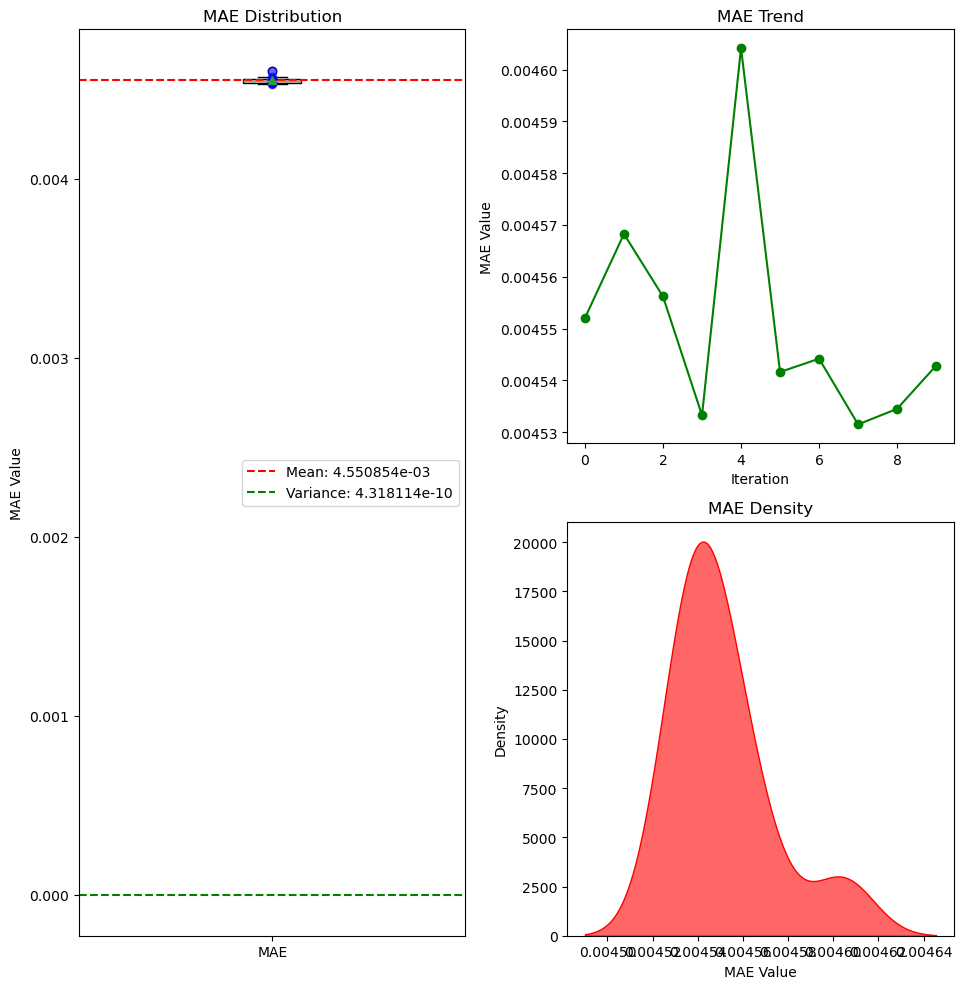

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.0003474675096572699, 0.00034551380968576395, 0.0003456119914500336, 0.00034643215962848164, 0.0003482464692616034, 0.00034732251896492643, 0.00034786904911505984, 0.00034651636775045287, 0.0003465702872030381, 0.0003479910345442392]
mean MSE: 3.469541e-04
Variance MSE: 8.468941e-13


/tmp/ipykernel_1420883/3394972535.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


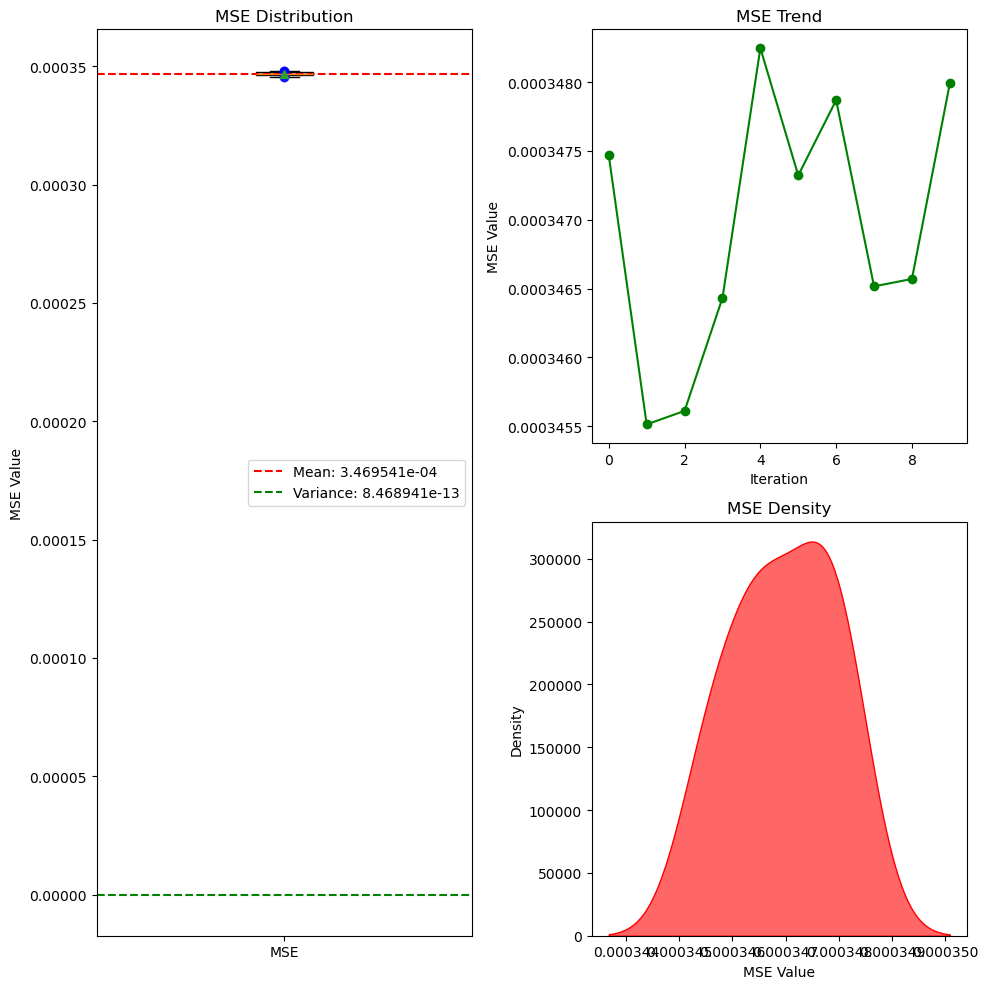

In [14]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[3.8747647e-05, 3.6476515e-05, 4.102243e-05, 0.000115292045, 3.9181454e-05, 4.041035e-05, 4.166289e-05, 8.033727e-05, 0.00010493814, 7.6377684e-05]
mean CHAOS: 6.144464e-05
Variance CHAOS: 8.256190e-10


/tmp/ipykernel_1420883/1804867946.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


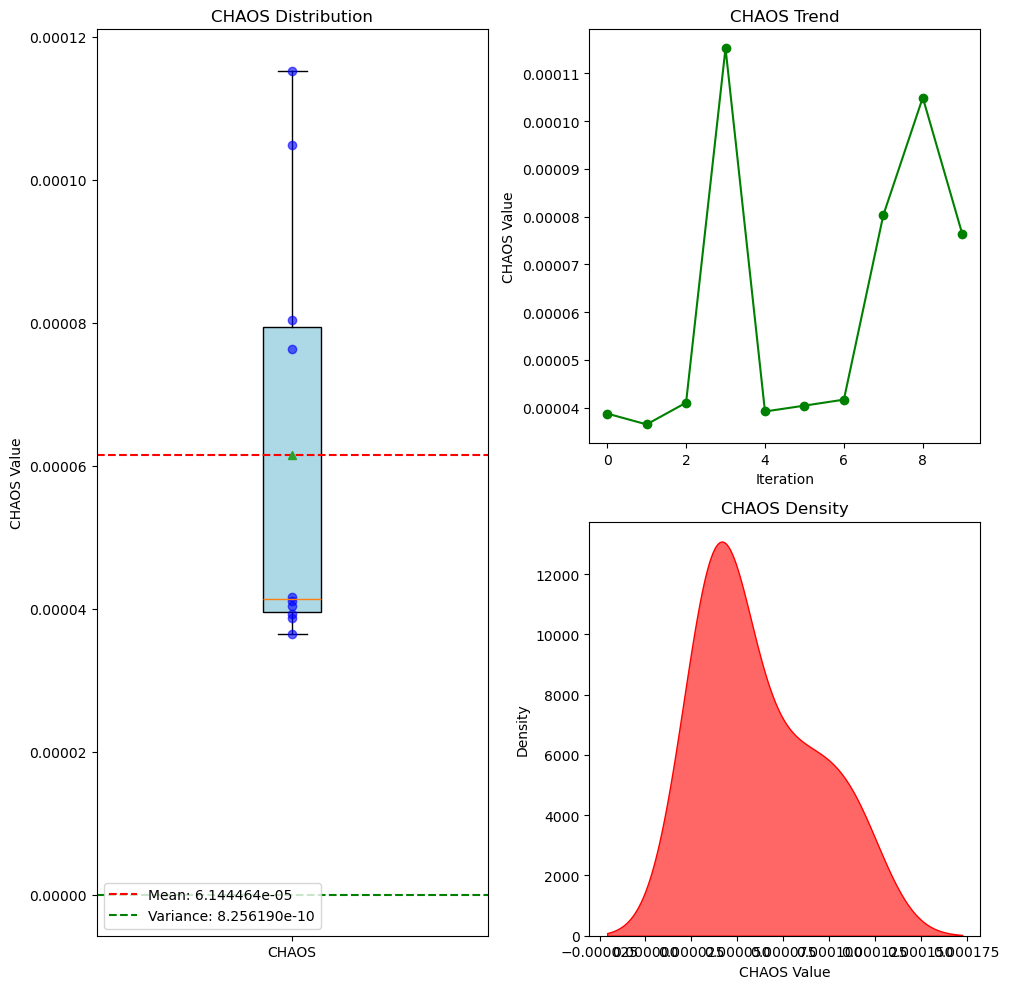

In [15]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = chaoss
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean CHAOS: %e' % (mean_error)) #打印误差
print('Variance CHAOS: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('CHAOS Distribution')
plt.ylabel('CHAOS Value')
plt.xticks([1], ['CHAOS'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('CHAOS Trend')
plt.ylabel('CHAOS Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('CHAOS Density')
plt.xlabel('CHAOS Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.00035228906, 0.0003552289, 0.00033793808, 0.00034767037, 0.000358426, 0.00034202018, 0.0003307365, 0.00035762403, 0.00034425, 0.00034342398]
mean RESIDUAL: 3.469607e-04
Variance RESIDUAL: 7.313151e-11


/tmp/ipykernel_1420883/2986457676.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


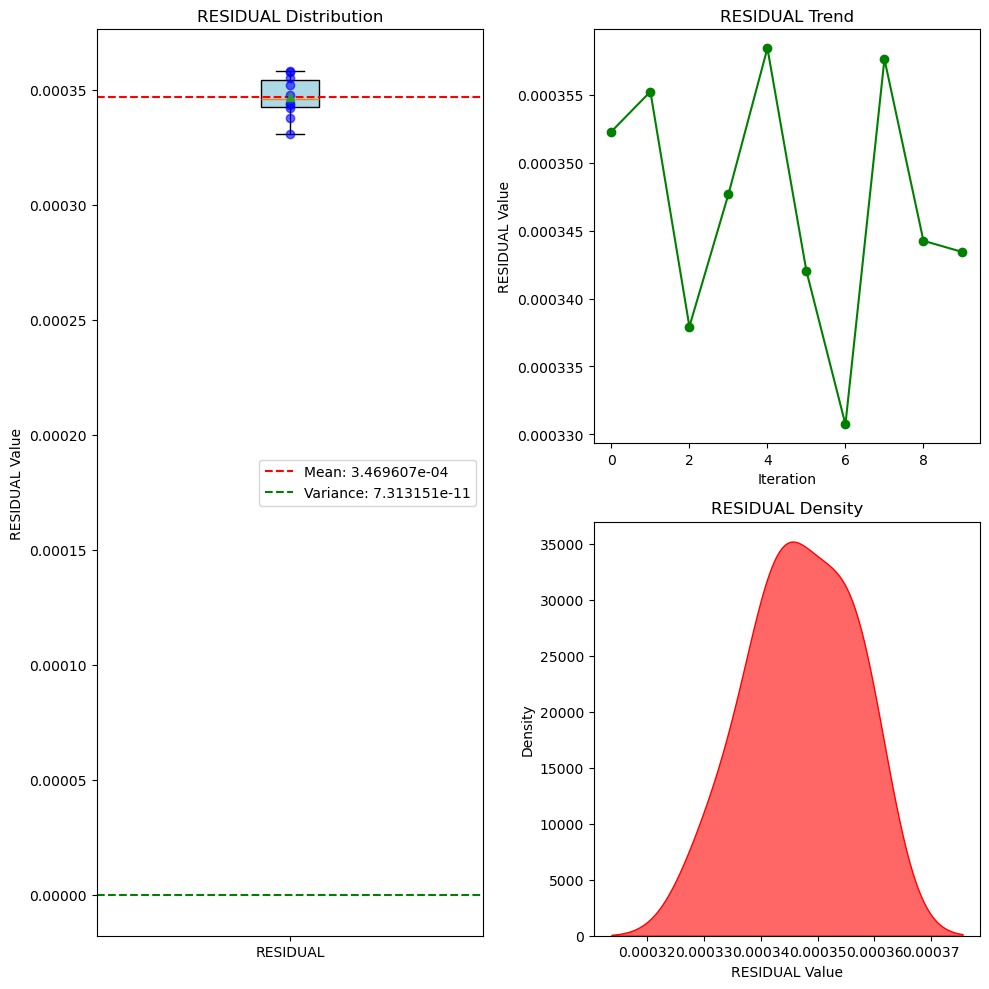

In [16]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = residuals
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean RESIDUAL: %e' % (mean_error)) #打印误差
print('Variance RESIDUAL: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('RESIDUAL Distribution')
plt.ylabel('RESIDUAL Value')
plt.xticks([1], ['RESIDUAL'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('RESIDUAL Trend')
plt.ylabel('RESIDUAL Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('RESIDUAL Density')
plt.xlabel('RESIDUAL Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [17]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

40000
[1.7958185e+03 1.7118284e+03 1.6422009e+03 ... 7.2450819e-03 6.9330987e-03
 6.4676246e-03]


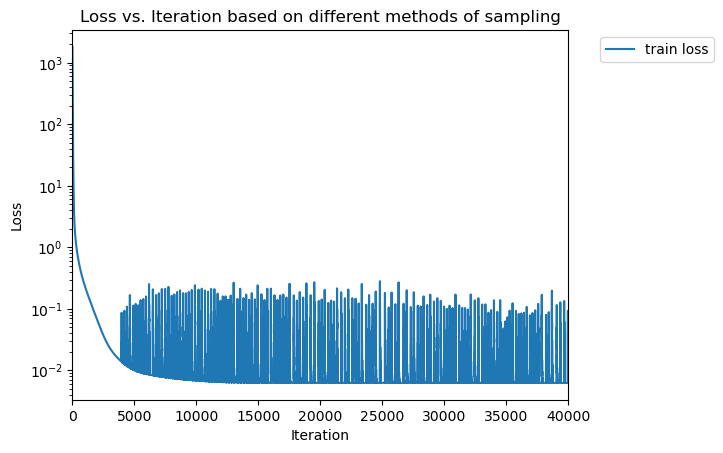

In [18]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,40000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

In [19]:
y_pred_df = pd.DataFrame(y_pred, columns = state_column_names)
print(y_pred_df.head())
print(y_pred_df.tail())
y_pred_df = get_system_performance(y_pred_df)
print(y_pred_df.head())
print(y_pred_df.tail())

    state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
0  0.758045  0.053048  0.094637  0.068864  0.006612  0.004819  0.008591   
1  0.758043  0.053048  0.094639  0.068864  0.006612  0.004819  0.008592   
2  0.758040  0.053047  0.094642  0.068864  0.006612  0.004818  0.008592   
3  0.758037  0.053047  0.094644  0.068864  0.006612  0.004818  0.008592   
4  0.758034  0.053047  0.094646  0.068864  0.006613  0.004818  0.008592   

    state_8   state_9  state_10  state_11  state_12  
0  0.004003  0.000593  0.000272  0.000487  0.000029  
1  0.004003  0.000593  0.000272  0.000487  0.000029  
2  0.004003  0.000593  0.000272  0.000487  0.000029  
3  0.004003  0.000594  0.000272  0.000487  0.000029  
4  0.004003  0.000594  0.000272  0.000488  0.000029  
      state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
495  0.757802  0.053042  0.094726  0.068891  0.006638  0.004824  0.008619   
496  0.757799  0.053042  0.094725  0.068892  0.006639  0.004824  0.0086

Text(0, 0.5, 'Probability')

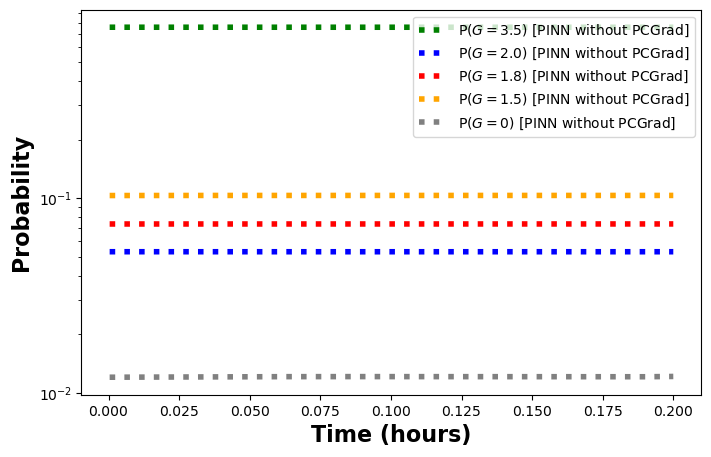

In [20]:
plt.figure(figsize=(8, 5)) #设置图形尺寸为8*5

sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_3.5'], label = r'P$\left(G=3.5 \right)$ [PINN without PCGrad]', 
             linewidth = 4, color = 'green', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_2.0'], label = r'P$\left(G=2.0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'blue', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.8'], label = r'P$\left(G=1.8 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'red', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.5'], label = r'P$\left(G=1.5 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'orange', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_0'], label = r'P$\left(G=0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'gray', linestyle='dotted')


plt.yscale('log') #设置y轴的刻度为对数刻度
plt.xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16) #设置x轴标签为Time (hours)，字体加粗，字体大小为16
plt.ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16) #设置y轴标签为Probability，字体加粗，字体大小为16

In [21]:
#解析解
eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')
laplace_solution_df = pd.read_csv('analytical_solution_by_laplace_method.csv')
print(eigenvector_solution_df.head())

    state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
0  0.989461  0.002719  0.003903  0.003874  0.000011  0.000011  0.000015   
1  0.979427  0.005285  0.007619  0.007508  0.000041  0.000041  0.000058   
2  0.969868  0.007706  0.011159  0.010919  0.000089  0.000087  0.000126   
3  0.960761  0.009993  0.014533  0.014121  0.000151  0.000147  0.000214   
4  0.952080  0.012153  0.017751  0.017129  0.000227  0.000219  0.000319   

    state_8       state_9      state_10      state_11      state_12  \
0  0.000005  4.199986e-08  1.479473e-08  2.123212e-08  5.835560e-11   
1  0.000021  3.151602e-07  1.117239e-07  1.610611e-07  8.690817e-10   
2  0.000045  9.982098e-07  3.560873e-07  5.156228e-07  4.096992e-09   
3  0.000077  2.221657e-06  7.974345e-07  1.159778e-06  1.206261e-08   
4  0.000115  4.076314e-06  1.472082e-06  2.150250e-06  2.744632e-08   

   system_3.5  system_2.0  system_1.8  system_1.5  system_0  
0    0.989461    0.002719    0.003885    0.003918  0.000016 

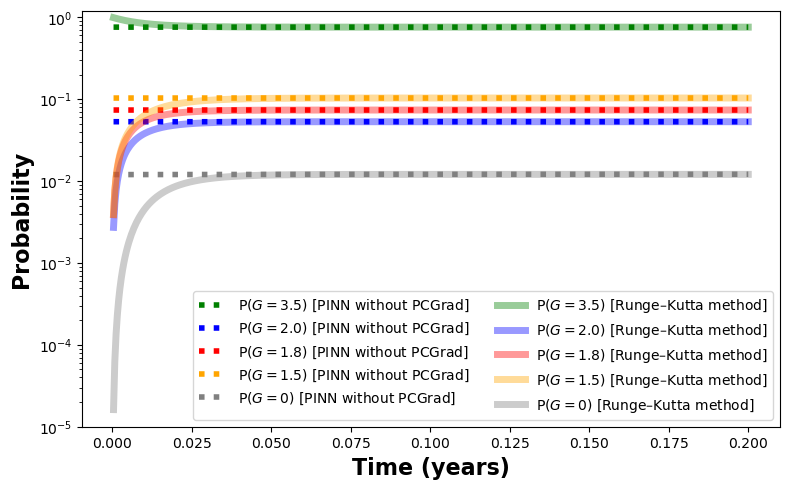

In [22]:
f, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_3.5'], label = r'P$\left(G=3.5 \right)$ [PINN without PCGrad]', 
             linewidth = 4, color = 'green', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_2.0'], label = r'P$\left(G=2.0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'blue', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.8'], label = r'P$\left(G=1.8 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'red', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.5'], label = r'P$\left(G=1.5 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'orange', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_0'], label = r'P$\left(G=0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'gray', linestyle='dotted')


sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_3.5'], 
             label = r'P$\left(G=3.5 \right)$ [Runge–Kutta method]',
             color = 'green', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_2.0'], 
             label = r'P$\left(G=2.0 \right)$ [Runge–Kutta method]',
             color = 'blue', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_1.8'], 
             label = r'P$\left(G=1.8 \right)$ [Runge–Kutta method]',
             color = 'red', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_1.5'], 
             label = r'P$\left(G=1.5 \right)$ [Runge–Kutta method]',
             color = 'orange', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_0'], 
             label = r'P$\left(G=0 \right)$ [Runge–Kutta method]',
             color = 'gray', alpha=0.4, dashes=True, linewidth = 5)



ax.legend(ncol=2, fontsize=10)
ax.set_yscale("log")
ax.set_ylim([1e-5, 1.2])
ax.set_xlabel("Time (years)", fontdict=dict(weight='bold'), fontsize=16)
ax.set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)



plt.tight_layout()

### 计算RMSE

In [23]:
y_diff_no_pcgrad_eigenvectors = eigenvector_solution_df - y_pred_df
y_diff_no_pcgrad_laplace = laplace_solution_df - y_pred_df

In [24]:
y_diff_no_pcgrad_eigenvectors['mse'] = y_diff_no_pcgrad_eigenvectors.apply(lambda x: x['system_3.5']**2 + x['system_2.0']**2 + x['system_1.8']**2 + 
                             x['system_1.5']**2 + x['system_0']**2, axis = 1)
y_diff_no_pcgrad_eigenvectors['rmse'] = y_diff_no_pcgrad_eigenvectors['mse'].apply(np.sqrt)

y_diff_no_pcgrad_laplace['mse'] = y_diff_no_pcgrad_laplace.apply(lambda x: x['system_3.5']**2 + x['system_2.0']**2 + x['system_1.8']**2 + 
                             x['system_1.5']**2 + x['system_0']**2, axis = 1)
y_diff_no_pcgrad_laplace['rmse'] = y_diff_no_pcgrad_laplace['mse'].apply(np.sqrt)

In [25]:
#这里的mse跟之前的MSE值不一样，其实是差了五倍，因为这里求均值是对500个数的和a除以500，而之前是对500*5个数的和（也是a）除以500*5
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_eigenvectors['mse']))
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_laplace['mse']))

RMSE of between PINN without PCGrad and the analytical solution is 0.001739955172721196
RMSE of between PINN without PCGrad and the analytical solution is 0.0017399551727211818


In [26]:
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_eigenvectors['rmse']))
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_laplace['rmse']))

RMSE of between PINN without PCGrad and the analytical solution is 0.01314564481514368
RMSE of between PINN without PCGrad and the analytical solution is 0.013145644815143229
